In [1]:
# Standard modules
import pdb
import sys
import os
import pickle
import emcee
import scipy
from scipy.integrate import quad
import decimal
import math
from scipy import special
import numpy as np
import pandas as pd
from lmfit import Parameters, minimize, fit_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append("..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

sigma_upper_limit = 3

In [2]:
# Function to import saved stacking results
def import_saved_pickles(pickle_fn):
    with open(pickle_fn, "rb") as file_path:
        encoding = pickle.load(file_path)
    return encoding

In [3]:
# Define Pickled Stacking Results File for Importing
pickle_filename = 'cosmos2020_nuvrj_1p5_2_2p5_3_3p5_background_atonce_farmer_bootstrap_100'
pickle_filename = "cosmos2020_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6p5_8p0_background_atonce_farmer_bootstrap_100"
pickle_path = os.path.join("..","test_data","pickles",pickle_filename)
pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities",pickle_filename)
path_pickle_file = os.path.join(pickle_path, pickle_filename+".pkl")
print(os.path.isfile(path_pickle_file))

True


In [4]:
# Import saved stacking results
simstack_object = import_saved_pickles(path_pickle_file)

In [5]:
# Import Catalog with SimstackWrapper
path_ini_file = os.path.join(pickle_path, "cosmos2020_alt_binning.ini")
print(path_ini_file,os.path.isfile(path_ini_file))
simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)

D:\pickles/simstack\stacked_flux_densities\cosmos2020_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6p5_8p0_background_atonce_farmer_bootstrap_100\cosmos2020_alt_binning.ini True


In [6]:
# Pass saved stacking object into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [7]:
# Call parse_results which creates converts the raw results into a results_dict for plotting/interpreting.
simstack_object.parse_results(catalog_object=simstack_catalog_object, estimate_mcmcs=False)

In [8]:
# SED measurements and bootstraps stored in sed_results_dict
sed_results_dict = simstack_object.results_dict['sed_bootstrap_results_dict']

In [9]:
sed_results_dict.keys()

dict_keys(['wavelengths', 'z_median', 'm_median', 'ngals', 'sed_fluxes_dict', 'std_fluxes_dict', 'sed_bootstrap_fluxes_dict'])

## Improve SED estimator to include survival function for upper limits

In [10]:
def mcmc_sed_estimator(x, y, yerr, theta, mcmc_iterations=2500, mcmc_discard=25):

    # Define non-detection as 1-sigma error below 0
    yerr_diag = np.diag(yerr)
    ind_nd = (y - np.sqrt(yerr_diag)) < 0

    # Split detections and non-detections (nd). Remove nd rows/columns from yerr matrix
    x  = np.array(x)
    wvs = x[ind_nd == False]
    fluxes = y[ind_nd == False]
    cov_fluxes = yerr
    if np.sum(ind_nd):
        for i in np.where(ind_nd)[::-1]:
            cov_fluxes = np.delete(cov_fluxes,i,axis=0)
            cov_fluxes = np.delete(cov_fluxes,i,axis=1)

        wvs_nd = x[ind_nd == True]
        fluxes_nd = y[ind_nd == True]
        dfluxes_nd = yerr_diag[ind_nd == True]
    else:
        wvs_nd=None
        fluxes_nd=None
        dfluxes_nd=None
        
    pos = np.array([theta[0], theta[1]]) + 1e-1 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        #nwalkers, ndim, log_probability_full, args=(wvs, fluxes, cov_fluxes, wvs_nd, fluxes_nd, dfluxes_nd)
        nwalkers, ndim, log_probability_informative, args=(theta, wvs, fluxes, cov_fluxes, wvs_nd, fluxes_nd, dfluxes_nd)
    )
    sampler.run_mcmc(pos, mcmc_iterations, progress=True)
    flat_samples = sampler.get_chain(discard=mcmc_discard, thin=15, flat=True)

    return flat_samples

In [11]:
def estimate_mcmc_sed(sed_bootstrap_dict, id_label, z_median=0,
                      mcmc_iterations=2500, mcmc_discard=25):

    if not z_median:
        z_label = id_label.split('_')[1:3]
        z_median = np.mean([float(i) for i in z_label])

    x = sed_bootstrap_dict['wavelengths']
    y = sed_bootstrap_dict['sed_fluxes_dict'][id_label]
    yerr = np.cov(sed_bootstrap_dict['sed_bootstrap_fluxes_dict'][id_label], rowvar=False)

    sed_params = simstack_object.fast_sed_fitter(x, y, yerr)

    Ain = sed_params['A'].value
    Aerr = sed_params['A'].stderr
    Tin = sed_params['T_observed'].value
    Terr = sed_params['T_observed'].stderr
    if Terr is None or Terr > Tin:
        Tin = (10 ** (1.2 + 0.1 * z_median)) / (1 + z_median)
        Terr = Tin
        Aerr = Ain
    else:
        Terr = np.min([np.max([Terr, 0.05*Tin]),Tin])

    theta0 = Ain, Tin, Aerr, Terr

    if np.isfinite(np.log(np.linalg.det(yerr))):
        flat_samples = mcmc_sed_estimator(x, y, yerr, theta0, mcmc_iterations=mcmc_iterations,
                                          mcmc_discard=mcmc_discard)
    else:
        return -np.inf

    return flat_samples, theta0

In [20]:
def log_likelihood_full(theta, x_d, y_d, cov_d, x_nd=None, y_nd=None, dy_nd=None):

    BETA_VALUE = 1.8
    ALPHA_VALUE = 2.0
    _sed_params = Parameters()
    _sed_params.add('A', value=theta[0], vary=True)
    _sed_params.add('T_observed', value=theta[1], vary=True)
    _sed_params.add('beta', value=BETA_VALUE, vary=False)
    _sed_params.add('alpha', value=ALPHA_VALUE, vary=False)

    #y_model_d = simstack_object.fast_lmfit_sed(_sed_params, x_d)
    y_model_d = simstack_object.fast_sed(_sed_params, x_d)

    # log likelihood for detections
    delta_y = y_d - y_model_d[0]
    ll_d = -0.5 * (np.matmul(delta_y, np.matmul(np.linalg.inv(cov_d), delta_y))
                   + len(y_d) * np.log(2 * np.pi)    
                   + np.log(np.linalg.det(cov_d)))

    # log likelihood for non-detections
    ll_nd = 0.
    if x_nd is not None:
        #y_model_nd = simstack_object.fast_lmfit_sed(_sed_params, x_nd)
        y_model_nd = simstack_object.fast_sed(_sed_params, x_nd)
        _integral_j = np.sqrt(np.pi/2*np.sqrt(dy_nd)) * (
            special.erf((np.sqrt(dy_nd) * sigma_upper_limit - y_model_nd[0])/np.sqrt(2*dy_nd)) + 
            special.erf((y_model_nd[0])/np.sqrt(2*dy_nd)))
        #ll_nd = -0.5 * np.sum(np.log(_integral_j))
        ll_nd = np.sum(np.log(_integral_j))
    else:
        pass

    #print(ll_d, ll_nd)
    if not np.isfinite(ll_d + ll_nd):
        return -np.inf

    return ll_d + ll_nd

def log_prior(theta):
    A, T = theta[0], theta[1]
    Amin = -42
    Amax = -28
    Amax = -20
    Tmin = 0.1
    Tmax = 32

    if Amin < A < Amax and Tmin < T < Tmax:
        return 0.0
    else:
        return -np.inf
    
def log_prior_informative(theta, theta0):
    A, T = theta
    A0, T0, sigma_A, sigma_T = theta0
    Amin = -42
    Amax = -25
    Tmin = 0.1
    Tmax = 35
    error_infl = 1.0
    #print(A, T, sigma_T)
    if Amin < A < Amax and Tmin < T < Tmax and sigma_T is not None:        
        lp = -0.5 * (np.sum((T - T0) ** 2 / (sigma_T * error_infl) ** 2)) + \
             np.log(1.0/(np.sqrt(2*np.pi)*(sigma_T * error_infl) ** 2))
        return lp
    #pdb.set_trace()
    return -np.inf

def log_probability_full(theta, x_d, y_d, cov_d, x_nd=None, y_nd=None, dy_nd=None):
    #lp = log_prior_informative(theta, theta0)
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(theta, x_d, y_d, cov_d, x_nd, y_nd, dy_nd)

def log_probability_informative(theta, theta0, x_d, y_d, cov_d, x_nd=None, y_nd=None, dy_nd=None):
    lp = log_prior_informative(theta, theta0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(theta, x_d, y_d, cov_d, x_nd, y_nd, dy_nd)

# Test Code on Data

In [18]:
def plot_test_mcmc_seds(self, mcmc_dict, flat_samples, theta0, id_label, bootstrap_dict=None, errors=('25', '75')):
    bin_keys = list(self.config_dict['parameter_names'].keys())
    wvs = mcmc_dict['wavelengths']
    wv_array = self.loggen(8, 1000, 100)
    ngals = mcmc_dict['ngals']
    z_med = mcmc_dict['z_median']
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    axs.text(9.0e0, 1e2, "Ngals={0:.0f}".format(ngals[id_label]))
    
    y = mcmc_dict['sed_fluxes_dict'][id_label]
    yerr = np.cov(mcmc_dict['sed_bootstrap_fluxes_dict'][id_label], rowvar=False)
    
    Ain, Tin, Aerr, Terr = theta0
    sed_params = Parameters()
    sed_params.add('A', value=Ain, vary=True)
    sed_params.add('T_observed', value=Tin, max=Tin*1.3, vary=True)
    sed_params.add('beta', value=1.8, vary=False)
    sed_params.add('alpha', value=2.0, vary=False)
    #sed_array =  self.fast_lmfit_sed(sed_params, wv_array)
    sed_array =  self.fast_sed(sed_params, wv_array)
    
    axs.plot(wv_array, sed_array[0] * 1e3, color='k', lw=0.5)
    
    if np.sum(y > 0):
        #prior_label = "A0={0:.1f}+-{1:.1f}, Trf0={2:.1f}+-{3:.1f}".format(Ain, Aerr, Tin * (1 + z_med[id_label]), Terr)
        try:
            prior_label = "A0={0:.1f}+-{1:.1f}, T0={2:.1f}+-{3:.1f} (Trf0={4:.1f})".format(Ain, Aerr, Tin, Terr, Tin * (1 + z_med[id_label]))
        except:
            prior_label = "A0={0:.1f}, T0={1:.1f}+-{2:.1f} (Trf0={3:.1f})".format(Ain, Tin, Terr, Tin * (1 + z_med[id_label]))
        axs.text(9.0e0, 1.75e2, prior_label)

        mcmc_out = [np.percentile(flat_samples[:, i], [float(errors[0]), 50, float(errors[1])])
                    for i in range(np.shape(flat_samples)[1])]
        mcmc_lo = self.graybody_fn([mcmc_out[0][0], mcmc_out[1][0]], wv_array)
        mcmc_50 = self.graybody_fn([mcmc_out[0][1], mcmc_out[1][1]], wv_array)
        mcmc_hi = self.graybody_fn([mcmc_out[0][2], mcmc_out[1][2]], wv_array)
        mcmc_label = "A={0:.1f}, Trf={1:.1f}".format(mcmc_out[0][1], mcmc_out[1][1] * (1 + z_med[id_label]))
        mcmc_label = "A={0:.1f}, T={1:.1f} (Trf={2:.1f})".format(mcmc_out[0][1], mcmc_out[1][1], mcmc_out[1][1] * (1 + z_med[id_label]))

        axs.plot(wv_array, mcmc_50[0] * 1e3, color='c', lw=0.9, label=mcmc_label)
        axs.plot(wv_array, mcmc_lo[0] * 1e3, ":", color='c', lw=0.8, label=None)
        axs.plot(wv_array, mcmc_hi[0] * 1e3, ":", color='c', lw=0.8, label=None)
        axs.fill_between(wv_array, mcmc_lo[0] * 1e3, mcmc_hi[0] * 1e3, facecolor='c',
                                 alpha=0.3, edgecolor='c')
    else:
        pdb.set_trace()
        
    for iwv, wv in enumerate(wvs):
        if wv in [24, 70]:
            color = 'b'
        elif wv in [100, 160]:
            color = 'g'
        elif wv in [250, 350, 500]:
            color = 'r'
        elif wv in [850]:
            color = 'y'

        if bootstrap_dict is not None:
            for iboot in range(len(bootstrap_dict['sed_bootstrap_fluxes_dict'][id_label.replace('.', 'p')])):
                yplot_boot = bootstrap_dict['sed_bootstrap_fluxes_dict'][id_label.replace('.', 'p')][iboot] * 1e3
                axs.scatter(wvs, yplot_boot, color=color, alpha=0.1)
        
        yerr_diag = np.sqrt(np.diag(yerr)[iwv])
        if y[iwv] - yerr_diag < 0:
            yplot = y[iwv]/yerr_diag * sigma_upper_limit
            yplot = yerr_diag * sigma_upper_limit
            uplims=True
            capsize=1
            axs.errorbar(wv, yplot * 1e3, yerr=np.sqrt(np.diag(yerr)[iwv]) * 1e3,
                             fmt="." + color, uplims=uplims)
        else:
            uplims=False
            yplot = y[iwv]
            capsize=0
            axs.scatter(wv, yplot * 1e3, marker='o', s=90, facecolors='none', edgecolors=color)
            axs.errorbar(wv, yplot * 1e3, yerr=np.sqrt(np.diag(yerr)[iwv]) * 1e3,
                             fmt="." + color, capsize=capsize,uplims=uplims)

    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_ylim([5e-3, 5e2])
    axs.legend(loc='upper left', frameon=False)
    axs.set_title(id_label)
    
    import corner
    corner.corner(flat_samples, color='k', smooth=1.1, quantiles=(0.025, 0.975),
                  plot_datapoints=False, fill_contours=False, bins=25, levels=(1-np.exp(-0.5),1-np.exp(-2.)),
                  truths=[mcmc_out[0][1], mcmc_out[1][1]], truth_color='r', 
                  labels=[r'$A$', r'$T$'], label_kwargs={'fontsize':20})
    plt.show()

In [21]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_6.5_8.0__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [01:02<00:00, 32.03it/s]


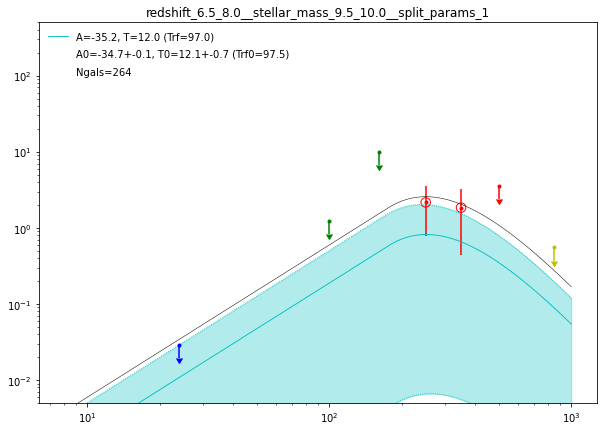

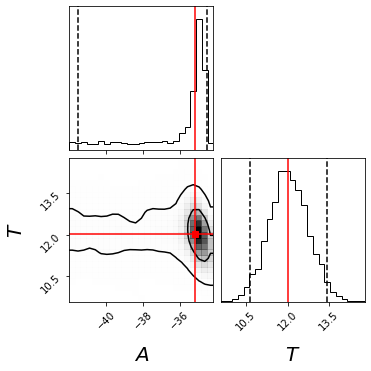

In [22]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

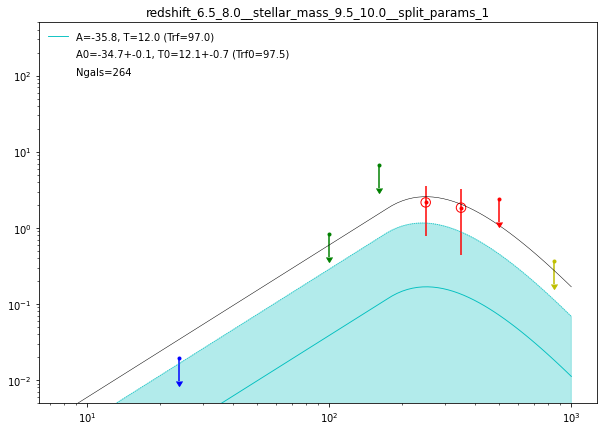

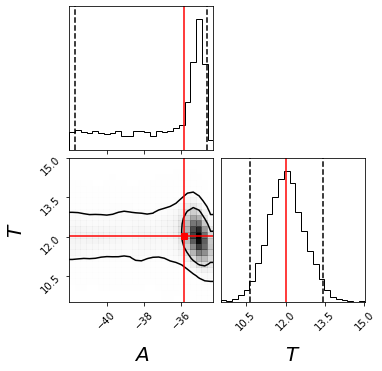

In [25]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [16]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_0.5_1.0__stellar_mass_9.5_10.0__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [00:57<00:00, 35.05it/s]


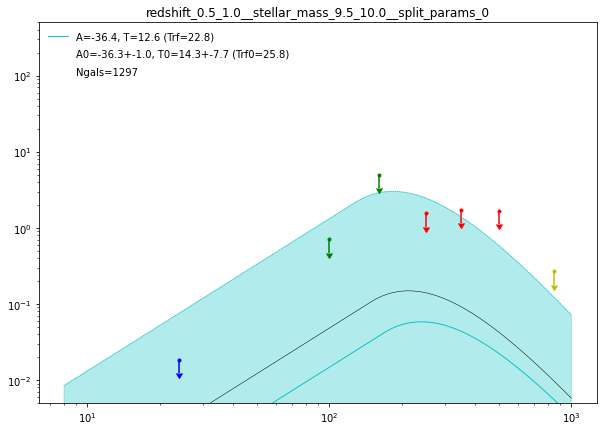

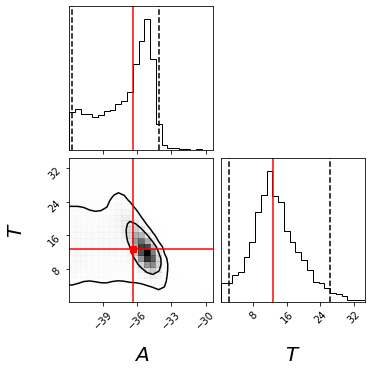

In [17]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

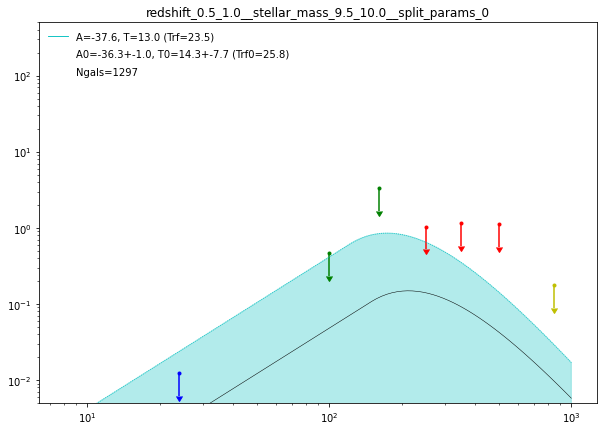

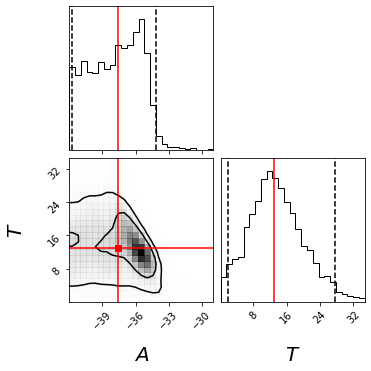

In [27]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [18]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_1.5_2.0__stellar_mass_10.0_10.5__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [00:54<00:00, 36.45it/s]


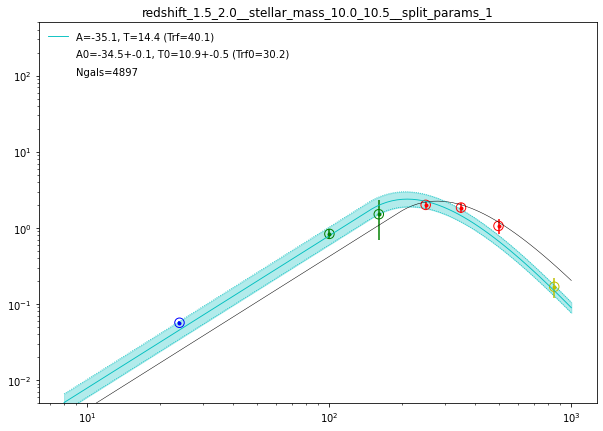

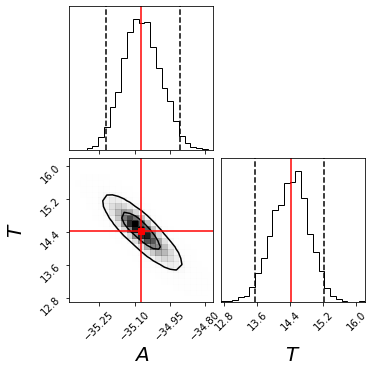

In [19]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

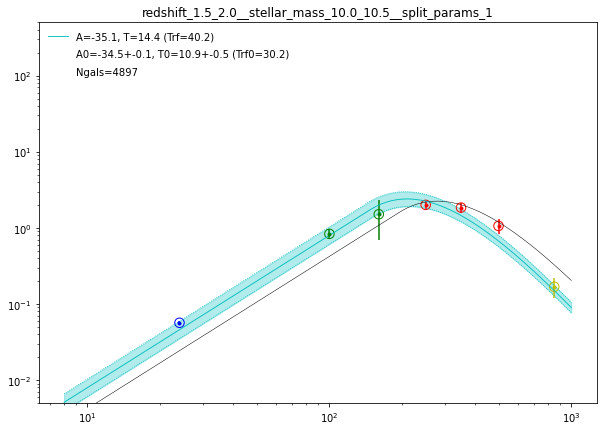

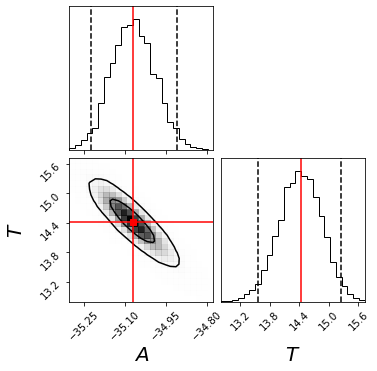

In [24]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [20]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_1.5_2.0__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [01:01<00:00, 32.59it/s]


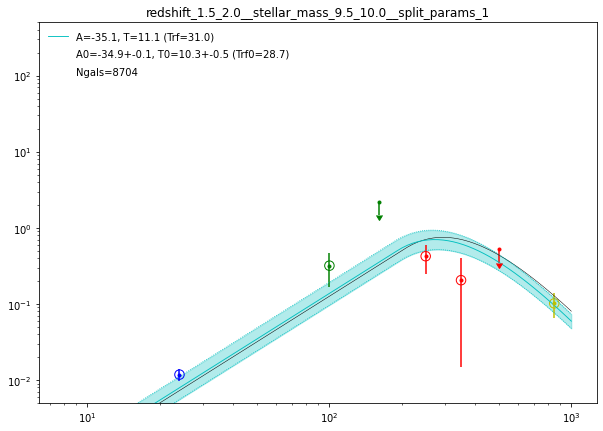

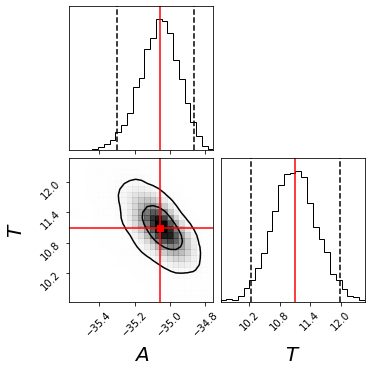

In [21]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

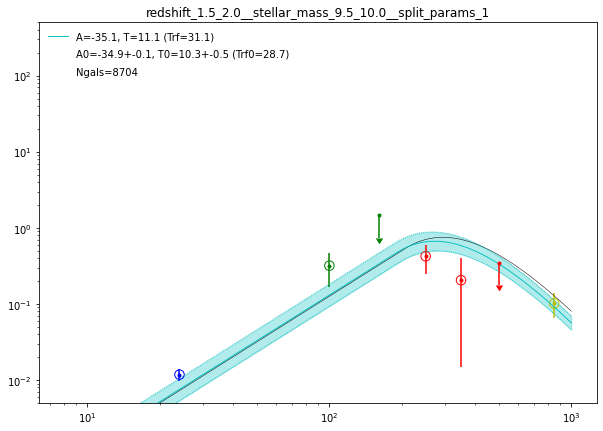

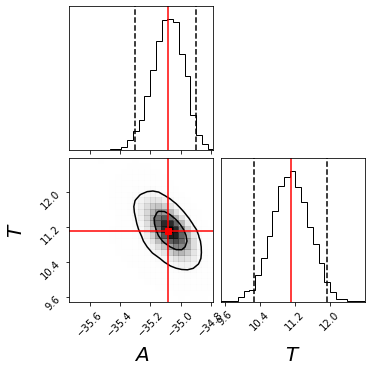

In [30]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

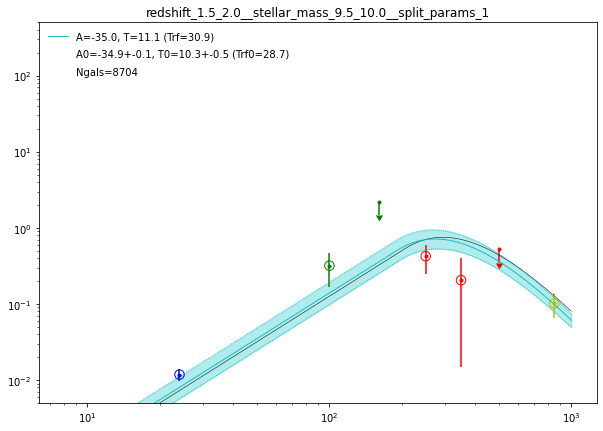

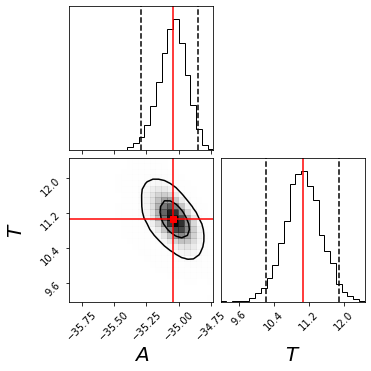

In [29]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [22]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_2.0_2.5__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [00:54<00:00, 36.40it/s]


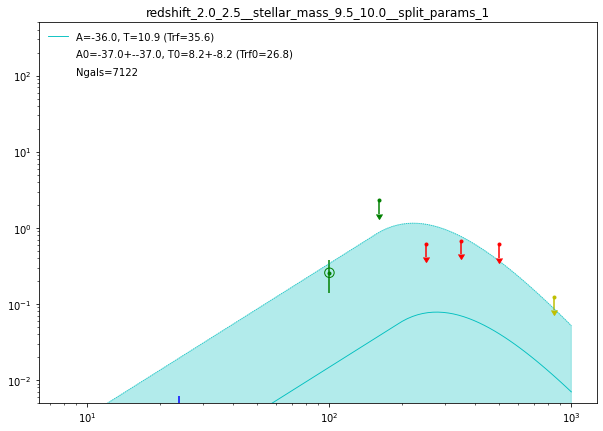

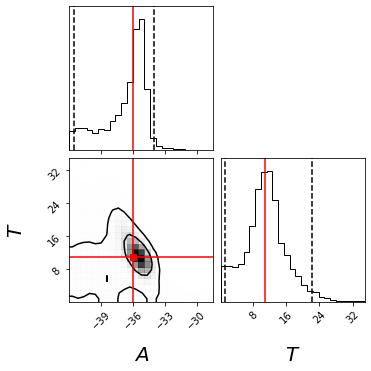

In [23]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

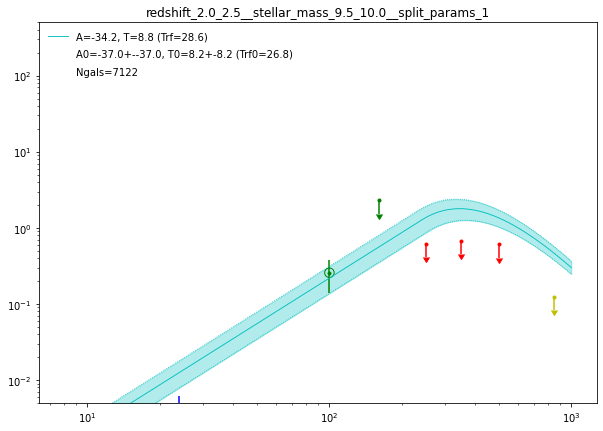

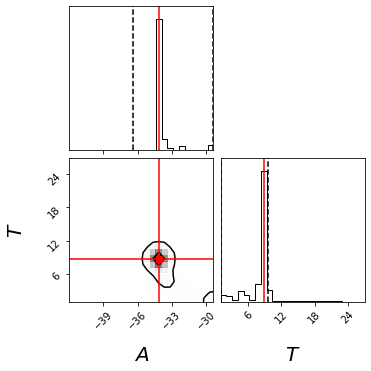

In [31]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [31]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_2.5_3.0__stellar_mass_9.5_10.0__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [00:59<00:00, 33.86it/s]


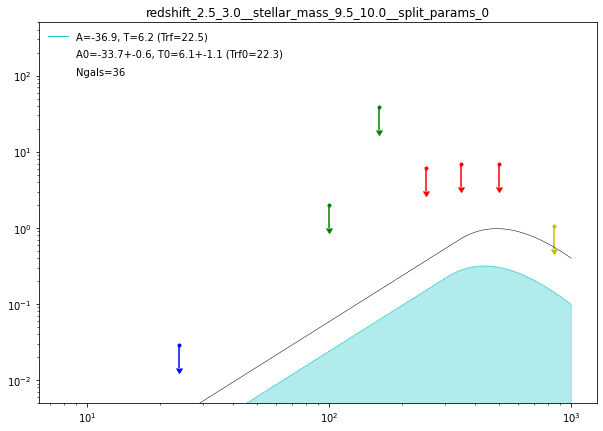

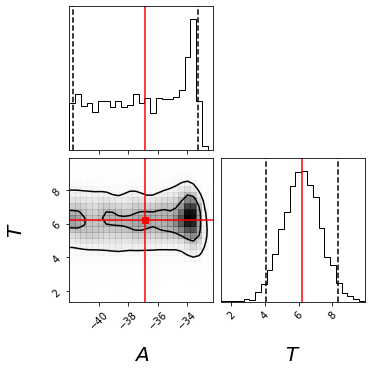

In [32]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [24]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_11.0_12.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=3000, mcmc_discard=200)

100%|██████████| 3000/3000 [01:24<00:00, 35.35it/s]


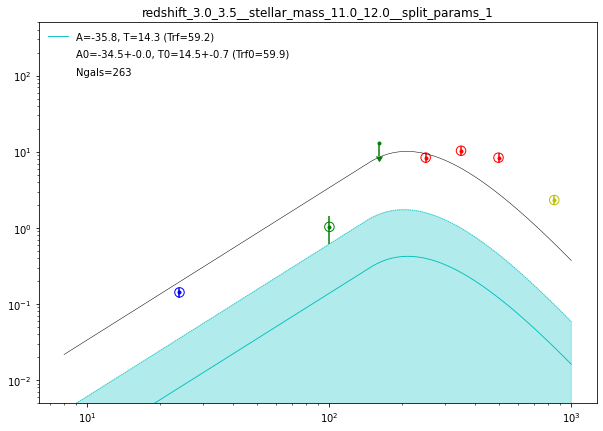

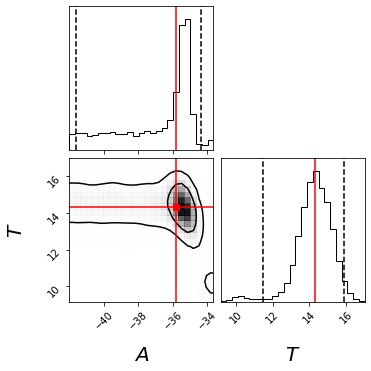

In [25]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

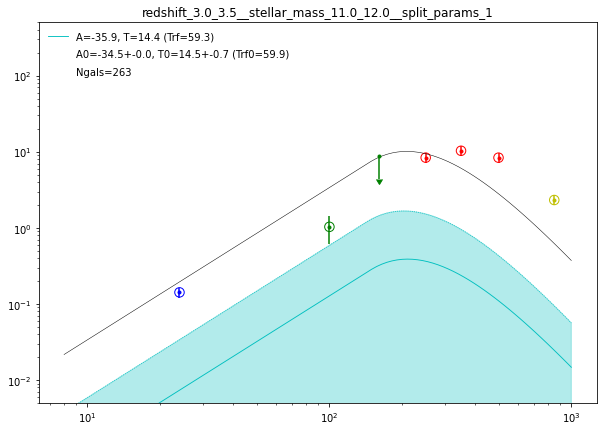

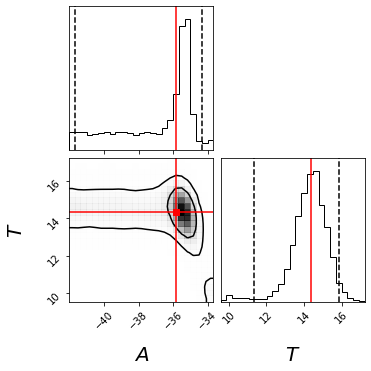

In [34]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [48]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.5_4.0__stellar_mass_11.0_12.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [01:01<00:00, 32.64it/s]


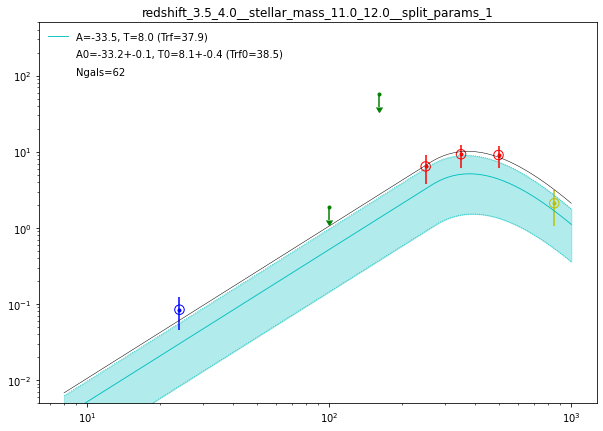

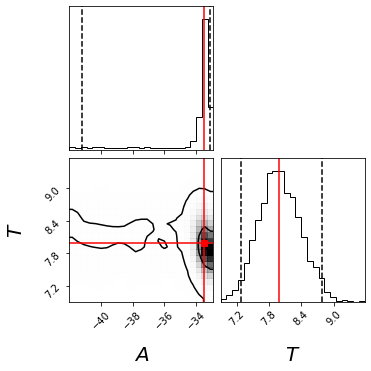

In [49]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [34]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_4.0_5.0__stellar_mass_9.5_10.0__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [00:57<00:00, 34.69it/s]


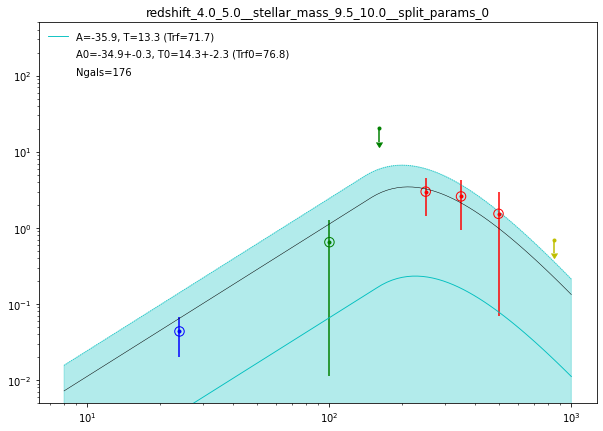

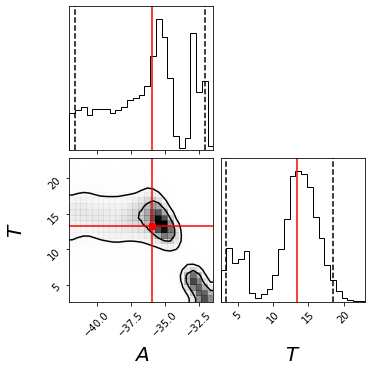

In [35]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [35]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_4.0_5.0__stellar_mass_10.0_10.5__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [01:02<00:00, 32.06it/s]


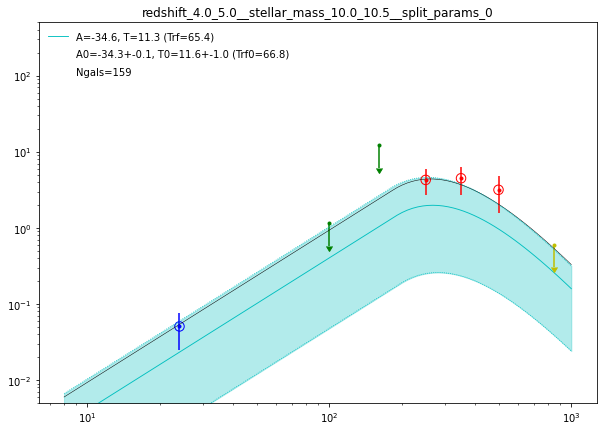

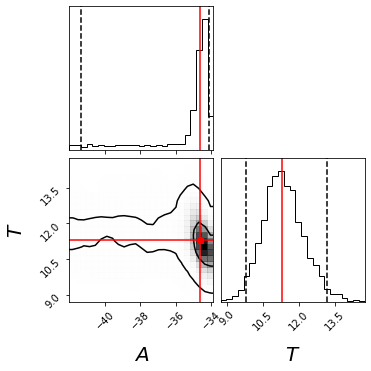

In [36]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

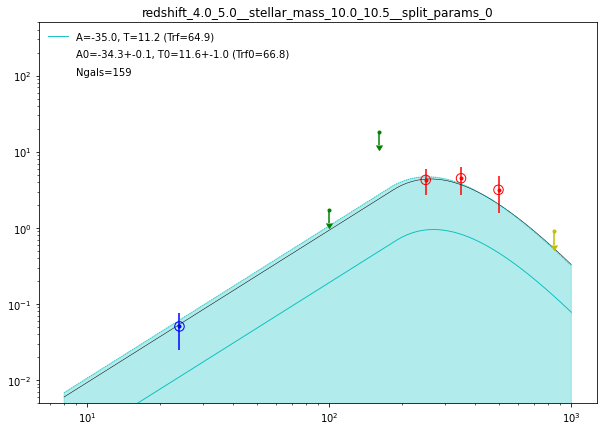

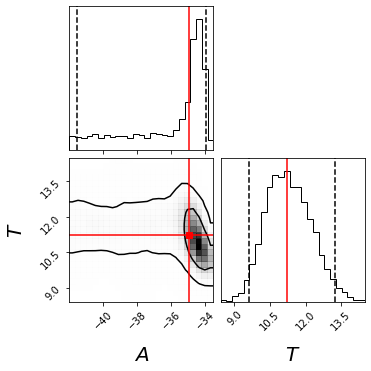

In [33]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [124]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_6.5_8.0__stellar_mass_11.0_12.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=150)

100%|██████████| 2000/2000 [01:00<00:00, 33.04it/s]


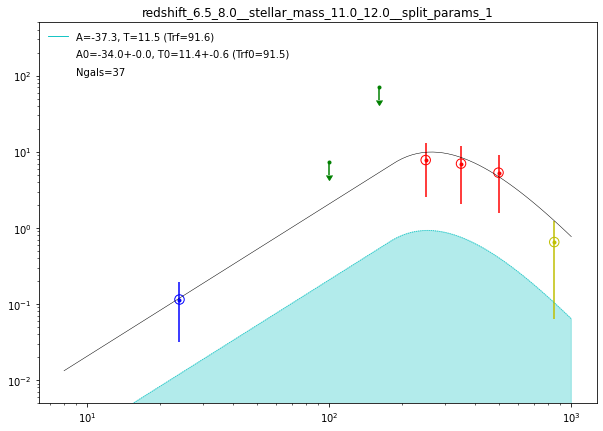

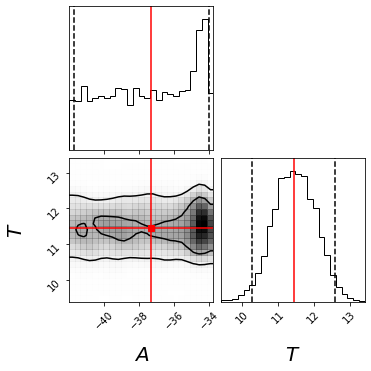

In [125]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [126]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_6.5_8.0__stellar_mass_10.5_11.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=150)

100%|██████████| 2000/2000 [01:01<00:00, 32.66it/s]


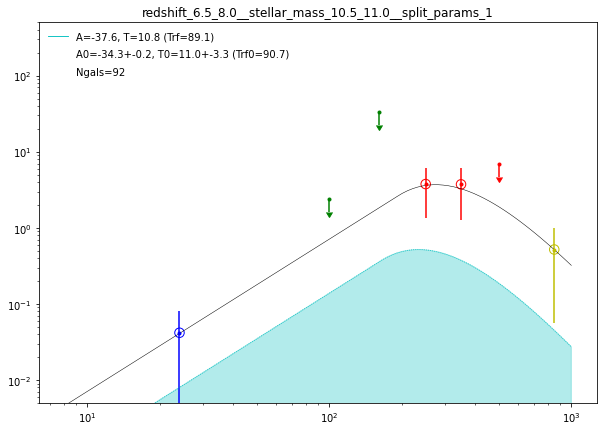

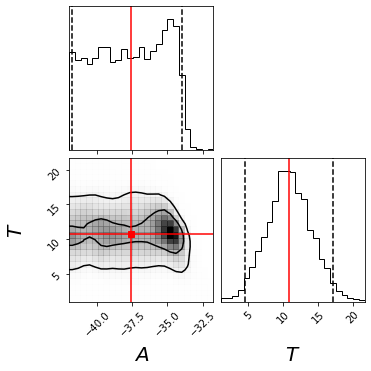

In [50]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [36]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=150)

100%|██████████| 2000/2000 [01:03<00:00, 31.42it/s]


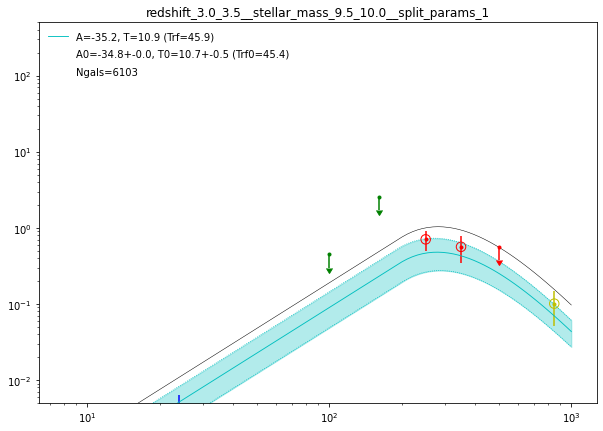

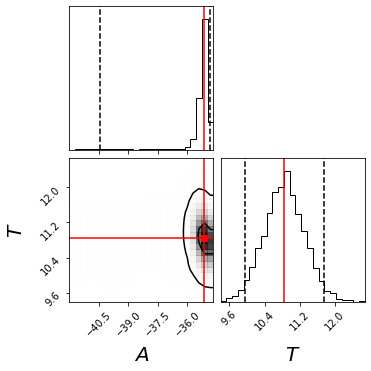

In [37]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [38]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_9.5_10.0__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=150)

100%|██████████| 2000/2000 [00:58<00:00, 34.31it/s]


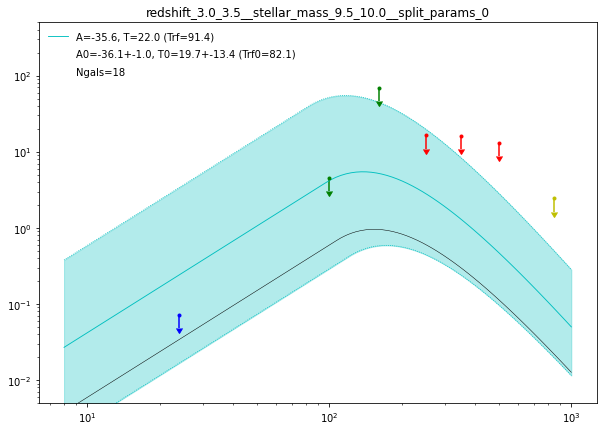

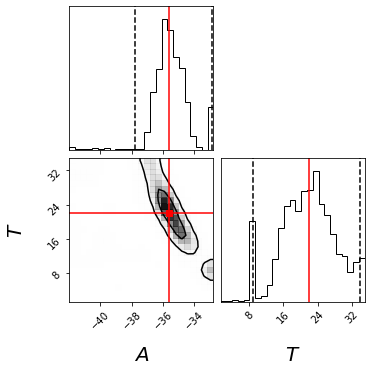

In [39]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [26]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_10.0_10.5__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=150)

100%|██████████| 2000/2000 [01:02<00:00, 31.82it/s]


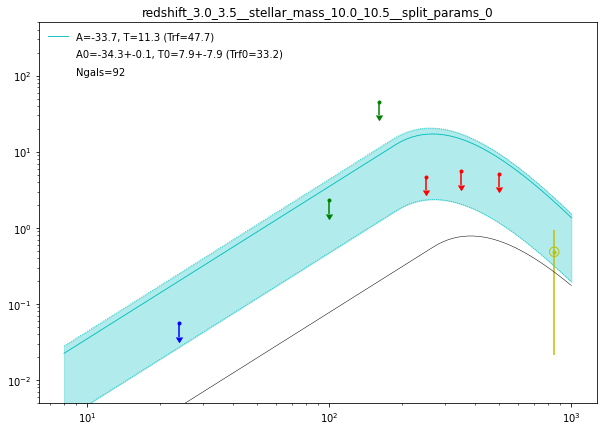

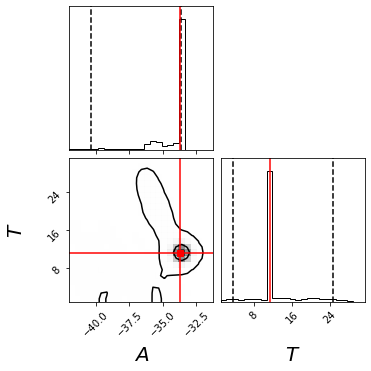

In [27]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [40]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_5.0_6.5__stellar_mass_10.0_10.5__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=150)

100%|██████████| 2000/2000 [01:01<00:00, 32.50it/s]


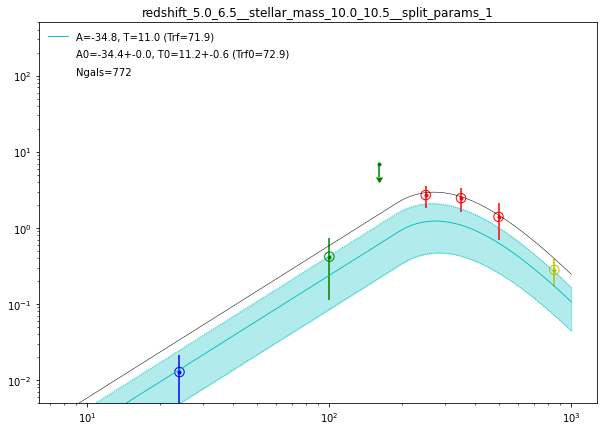

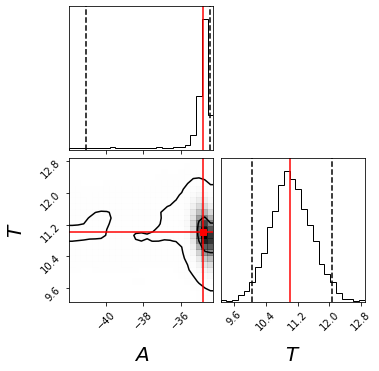

In [41]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

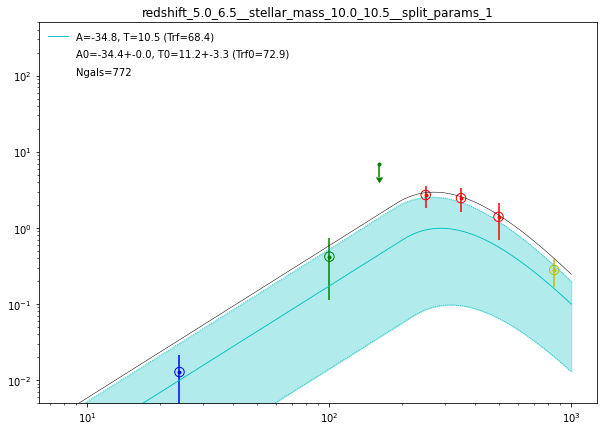

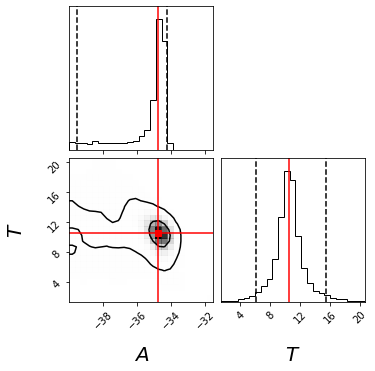

In [58]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [68]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_2.0_2.5__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=3000, mcmc_discard=300)

100%|██████████| 3000/3000 [01:30<00:00, 33.20it/s]


In [ ]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_2.0_2.5__stellar_mass_10.0_10.5__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=3000, mcmc_discard=300)

 53%|█████▎    | 1580/3000 [00:47<00:42, 33.72it/s]

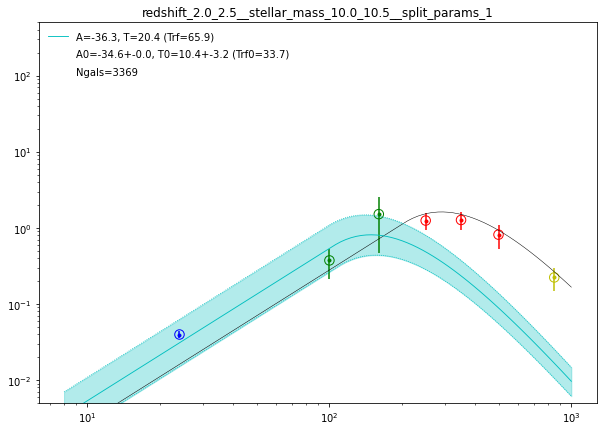

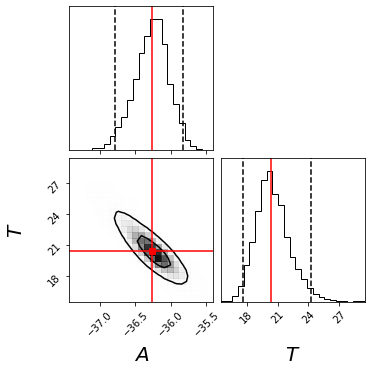

In [69]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

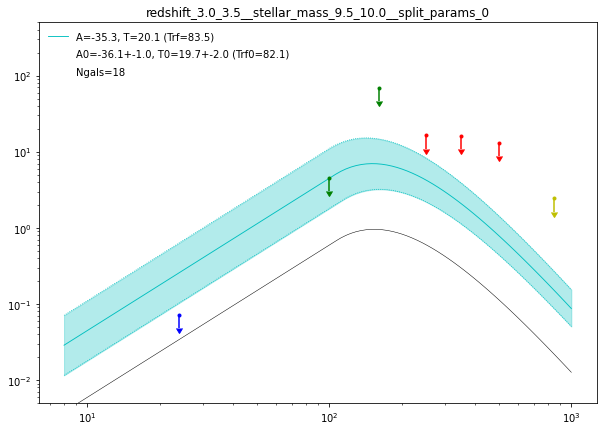

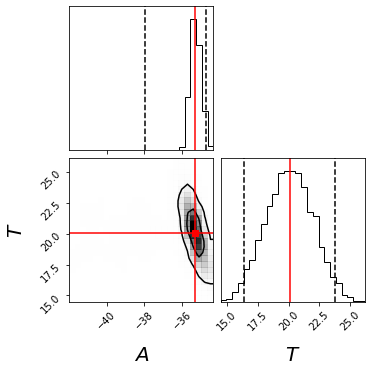

In [28]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

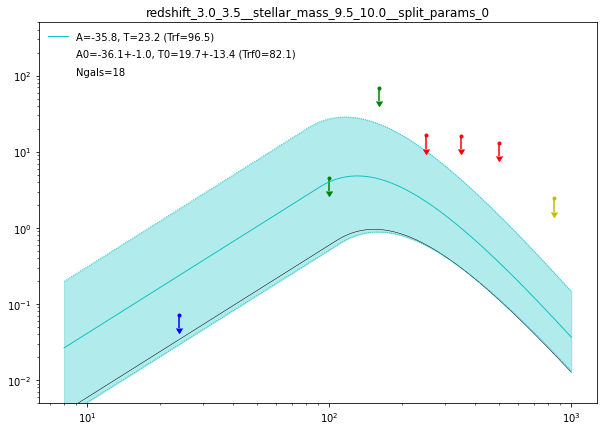

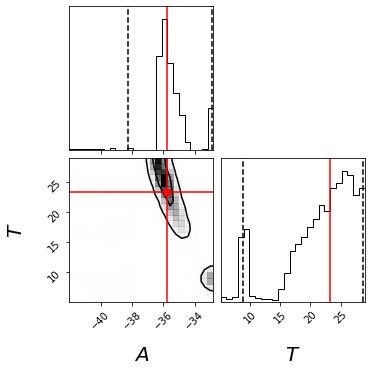

In [36]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

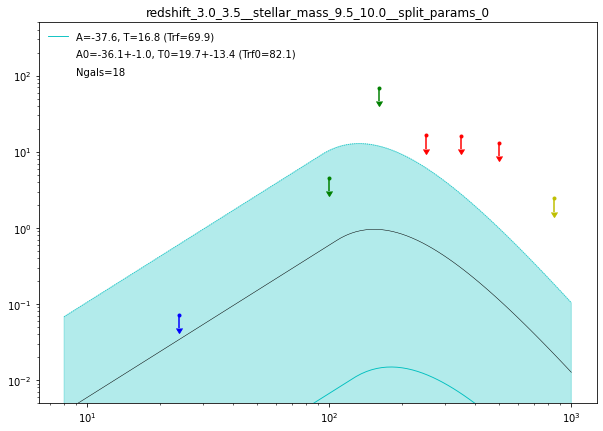

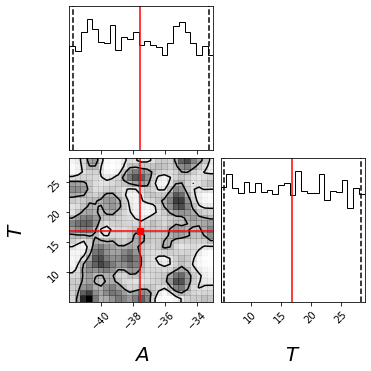

In [59]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

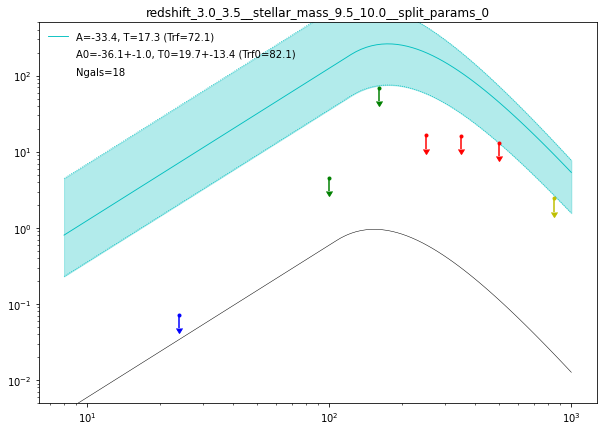

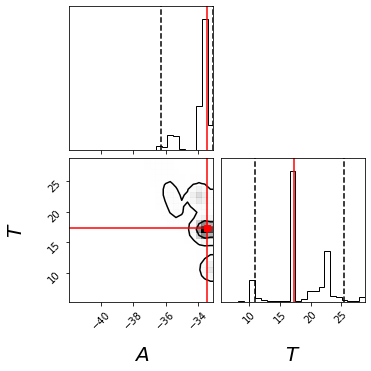

In [25]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

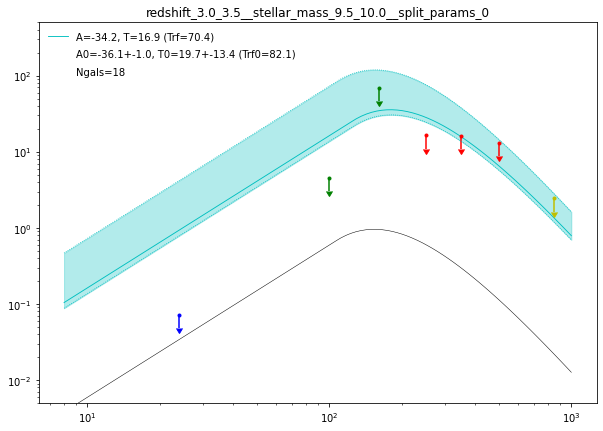

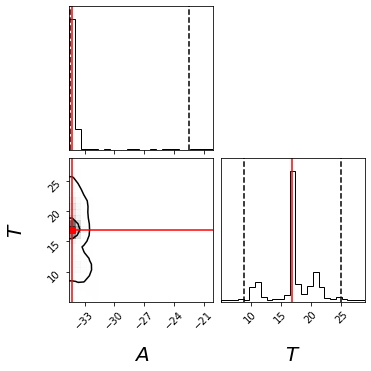

In [22]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

## z = 3-3.5

In [95]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_9.5_10.0__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=200)

A0=-36.1+-0.969, T0=19.7+-13.378
Aw=-36.1+-0.903, Tw=19.7+-0.494


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.88it/s]


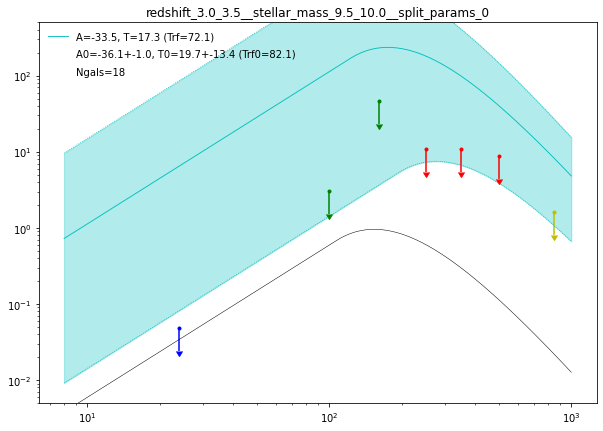

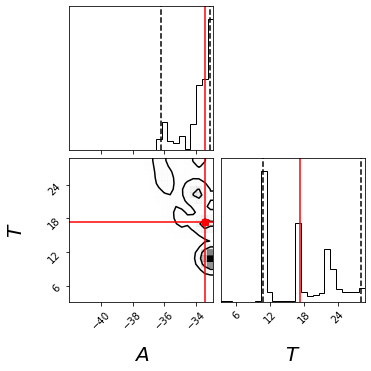

In [96]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [72]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_11.0_12.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=100)

100%|██████████| 1000/1000 [00:34<00:00, 29.37it/s]


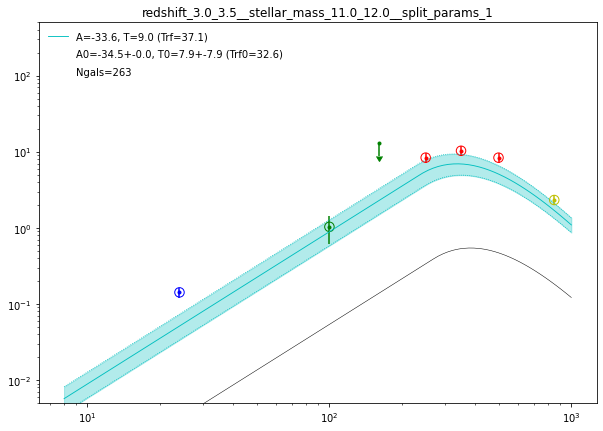

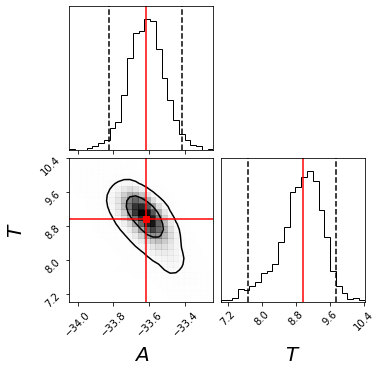

In [73]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

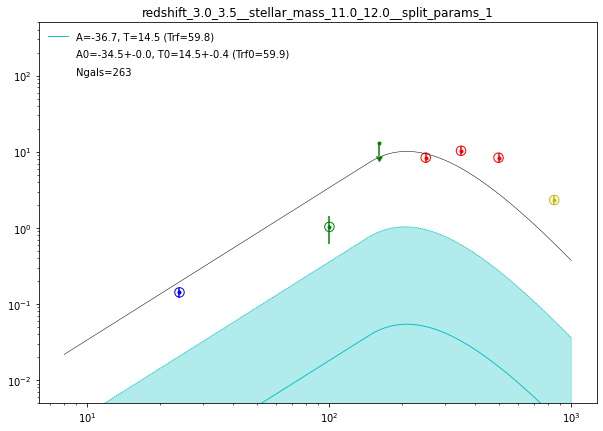

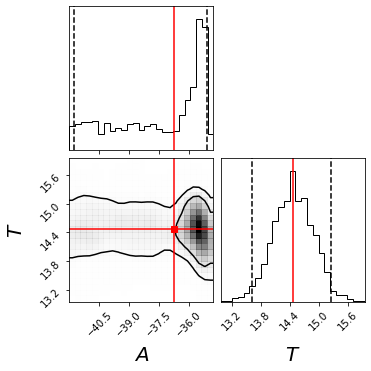

In [39]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

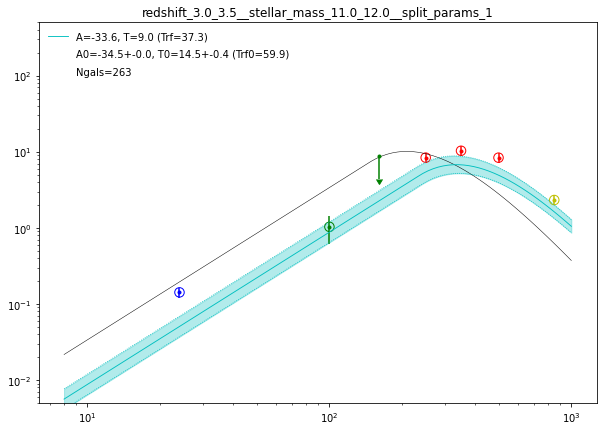

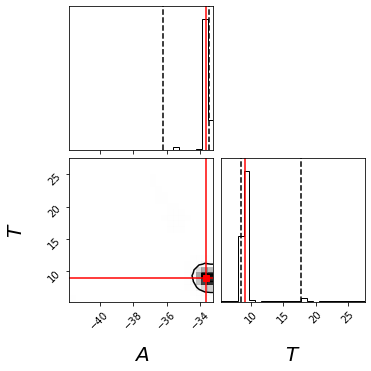

In [140]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [74]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=2000, mcmc_discard=200)

100%|██████████| 2000/2000 [01:02<00:00, 32.04it/s]


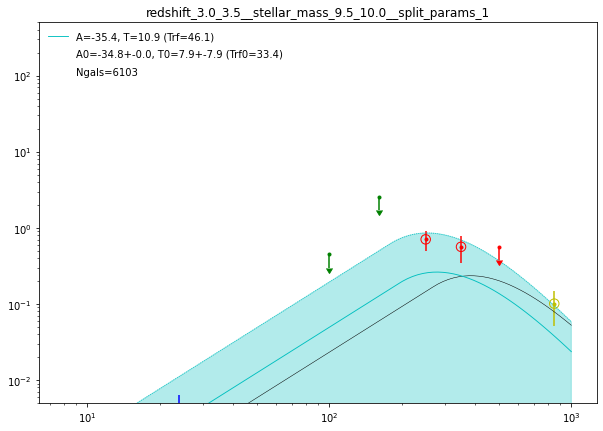

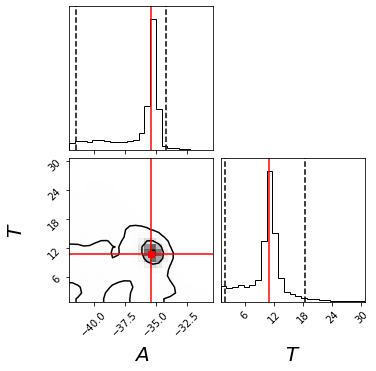

In [75]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [59]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=200)

A0=-34.8+-0.040, T0=10.7+-0.128
Aw=-34.8+-0.174, Tw=10.7+-0.128
emcee: Exception while calling your likelihood function:
  params: [-35.65124893  10.64674313]
  args: ((-34.819625160869805, 10.734279464494982, 0.04048734208375328, 0.12780153260546048), array([ 24., 250., 350., 850.]), array([3.83194691e-06, 7.06687198e-04, 5.63777748e-04, 1.01070849e-04]), array([[6.67473593e-12, 2.84947136e-10, 2.29095554e-10, 1.14535628e-11],
       [2.84947136e-10, 4.54966365e-08, 4.40690814e-08, 7.18042502e-10],
       [2.29095554e-10, 4.40690814e-08, 4.95337019e-08, 6.19260219e-10],
       [1.14535628e-11, 7.18042502e-10, 6.19260219e-10, 2.42153395e-09]]), array([100., 160., 500.]), array([ 6.93033995e-05, -3.50756302e-04,  1.37364062e-04]), array([2.25061833e-08, 7.19173963e-07, 3.59202059e-08]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\viero\anaconda3\envs\simstack\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-58-b5bd426cfcac>", line 163, in log_probability_full
    return lp + log_likelihood_full(theta, x_d, y_d, cov_d, x_nd, y_nd, dy_nd)
  File "<ipython-input-58-b5bd426cfcac>", line 105, in log_likelihood_full
    (math.erf((np.sqrt(dy_nd_j) * sigma_upper_limit - y_model_nd[j])/np.sqrt(2*dy_nd_j)) +
TypeError: only size-1 arrays can be converted to Python scalars


TypeError: only size-1 arrays can be converted to Python scalars

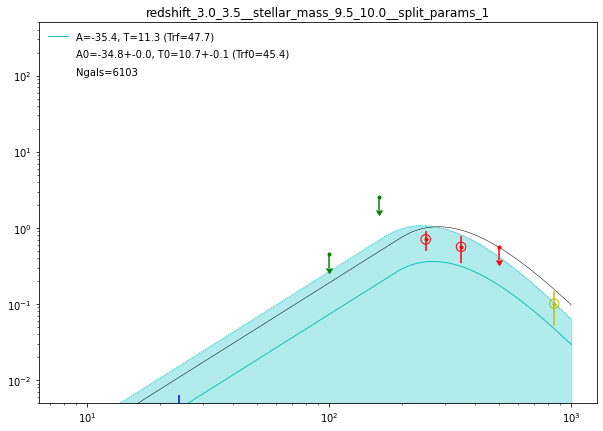

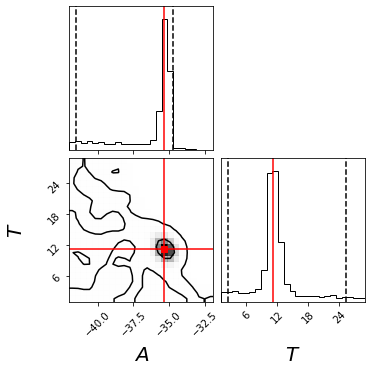

In [73]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

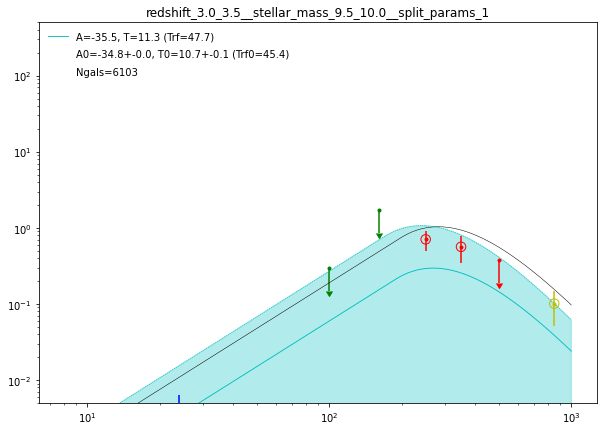

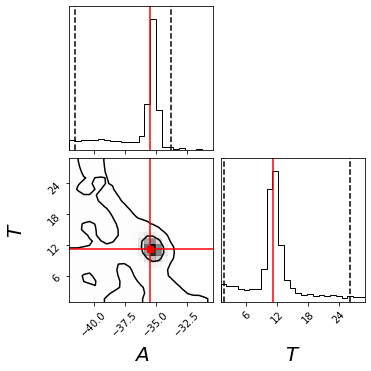

In [27]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [27]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_3.0_3.5__stellar_mass_9.5_10.0__split_params_0'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=200)

A0=-36.1+-0.969, T0=19.7+-13.378
Aw=-36.1+-0.903, Tw=19.7+-0.494
check ll_d and ll_nd: -0.0 -41.584734453672525
check ll_d and ll_nd: -0.0 -4698.216426517463
check ll_d and ll_nd: -0.0 -41.20191136262066
check ll_d and ll_nd: -0.0 -41.21654267281103
check ll_d and ll_nd: -0.0 -42.00200203480074
check ll_d and ll_nd: -0.0 -41.20289252943991
check ll_d and ll_nd: -0.0 -42.00659759100188
check ll_d and ll_nd: -0.0 -42.24738930241827
check ll_d and ll_nd: -0.0 -42.083653152230525
check ll_d and ll_nd: -0.0 -41.894301565648526
check ll_d and ll_nd: -0.0 -41.53715251680992
check ll_d and ll_nd: -0.0 -41.843002738116795
check ll_d and ll_nd: -0.0 -41.77480029175725
check ll_d and ll_nd: -0.0 -41.22939930292473
check ll_d and ll_nd: -0.0 -42.03948330184686
check ll_d and ll_nd: -0.0 -42.13901656350411
check ll_d and ll_nd: -0.0 -41.631617751407454
check ll_d and ll_nd: -0.0 -41.685660666647145
check ll_d and ll_nd: -0.0 -42.17629720546027
check ll_d and ll_nd: -0.0 -41.27954162140128
check ll_

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

check ll_d and ll_nd: -0.0 -41.69535219975097
check ll_d and ll_nd: -0.0 -94897.5612712234
check ll_d and ll_nd: -0.0 -41.46951395007558
check ll_d and ll_nd: -0.0 -46.45518855682994
check ll_d and ll_nd: -0.0 -41.267231726792886
check ll_d and ll_nd: -0.0 -42.268891390289966
check ll_d and ll_nd: -0.0 -42.09294443900715
check ll_d and ll_nd: -0.0 -41.661801206224624
check ll_d and ll_nd: -0.0 -42.08271061599759
check ll_d and ll_nd: -0.0 -41.59133680951525
check ll_d and ll_nd: -0.0 -41.641018793341246
check ll_d and ll_nd: -0.0 -42.05184338869486
check ll_d and ll_nd: -0.0 -54316.404704816676
check ll_d and ll_nd: -0.0 -42.21958966896415
check ll_d and ll_nd: -0.0 -7644.757542104413
check ll_d and ll_nd: -0.0 -42.28758630893126
check ll_d and ll_nd: -0.0 -41.52427863198494
check ll_d and ll_nd: -0.0 -41.69659040463342
check ll_d and ll_nd: -0.0 -41.89123178168301
check ll_d and ll_nd: -0.0 -42.10126843800519
check ll_d and ll_nd: -0.0 -42.07297379747448
check ll_d and ll_nd: -0.0 -42

  0%|                                                                                 | 1/1000 [00:00<09:31,  1.75it/s]

 -0.0 -42.29218204624086
check ll_d and ll_nd: -0.0 -41.74984020498919
check ll_d and ll_nd: -0.0 -42.826474784394264
check ll_d and ll_nd: -0.0 -41.727278429929555
check ll_d and ll_nd: -0.0 -99451.40221105433
check ll_d and ll_nd: -0.0 -41.75689015221744
check ll_d and ll_nd: -0.0 -41.26446948138594
check ll_d and ll_nd: -0.0 -42.28927731459637
check ll_d and ll_nd: -0.0 -42.092324197588184
check ll_d and ll_nd: -0.0 -42.089459182905
check ll_d and ll_nd: -0.0 -41.5289007985403
check ll_d and ll_nd: -0.0 -41.84232371182272
check ll_d and ll_nd: -0.0 -41.974547213165145
check ll_d and ll_nd: -0.0 -42.146871151474244
check ll_d and ll_nd: -0.0 -41.20241270203102
check ll_d and ll_nd: -0.0 -42.2864835875012
check ll_d and ll_nd: -0.0 -42.287310077338354
check ll_d and ll_nd: -0.0 -99.37156076041926
check ll_d and ll_nd: -0.0 -42.06611805962787
check ll_d and ll_nd: -0.0 -42.031826265194695
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.39467270125611
check ll_d and ll_nd

  0%|▏                                                                                | 2/1000 [00:01<10:11,  1.63it/s]

 -0.0 -49.107999843725175
check ll_d and ll_nd: -0.0 -41.7934642158178
check ll_d and ll_nd: -0.0 -280.41761601134095
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.25322768362382
check ll_d and ll_nd: -0.0 -430111.3199059468
check ll_d and ll_nd: -0.0 -41.241842990389664
check ll_d and ll_nd: -0.0 -41.16972182849534
check ll_d and ll_nd: -0.0 -41.43864102882555
check ll_d and ll_nd: -0.0 -41.61882046684518
check ll_d and ll_nd: -0.0 -42.29219317628915
check ll_d and ll_nd: -0.0 -42.1989993627591
check ll_d and ll_nd: -0.0 -42.16540071446198
check ll_d and ll_nd: -0.0 -42.07804102084717
check ll_d and ll_nd: -0.0 -41.885775196818685
check ll_d and ll_nd: -0.0 -42.24737578774071
check ll_d and ll_nd: -0.0 -3495.633029157418
check ll_d and ll_nd: -0.0 -42.29217383516749
check ll_d and ll_nd: -0.0 -41.19954641009052
check ll_d and ll_nd: -0.0 -158.26693365886982
check ll_d and ll_nd: -0.0 -42.252764173842834
check ll_d and ll_nd: -0.0 -42.28967789471846
check ll_d and ll_n

  0%|▏                                                                                | 3/1000 [00:01<09:53,  1.68it/s]

 -0.0 -41.92452468732955
check ll_d and ll_nd: -0.0 -41.28452072232858
check ll_d and ll_nd: -0.0 -267.1837200836343
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.29632199438021
check ll_d and ll_nd: -0.0 -42.28781499727013
check ll_d and ll_nd: -0.0 -42.0810244464523
check ll_d and ll_nd: -0.0 -42.20228449136045
check ll_d and ll_nd: -0.0 -42.01841019186466
check ll_d and ll_nd: -0.0 -42.15783244780334
check ll_d and ll_nd: -0.0 -41.50522238309641
check ll_d and ll_nd: -0.0 -43.68747505606822
check ll_d and ll_nd: -0.0 -47.34282101665662
check ll_d and ll_nd: -0.0 -42.29207968170608
check ll_d and ll_nd: -0.0 -42.27884038262062
check ll_d and ll_nd: -0.0 -42.51170151711465
check ll_d and ll_nd: -0.0 -41.70392529990866
check ll_d and ll_nd: -0.0 -41.73706755242711
check ll_d and ll_nd: -0.0 -15373.640182046942
check ll_d and ll_nd: -0.0 -41.75688611905231
check ll_d and ll_nd: -0.0 -41.99784459472229
check ll_d and ll_nd: -0.0 -42.2747148175873
check ll_d and ll_nd: -0

  0%|▎                                                                                | 4/1000 [00:02<09:22,  1.77it/s]

 -0.0 -42.28374933713369
check ll_d and ll_nd: -0.0 -42.284356045955846
check ll_d and ll_nd: -0.0 -41.72362072735973
check ll_d and ll_nd: -0.0 -41.30780425684695
check ll_d and ll_nd: -0.0 -41.798575031733975
check ll_d and ll_nd: -0.0 -42.29018053319199
check ll_d and ll_nd: -0.0 -41.23902838000244
check ll_d and ll_nd: -0.0 -41.90894205183237
check ll_d and ll_nd: -0.0 -93.73945616920612
check ll_d and ll_nd: -0.0 -161.04464063787913
check ll_d and ll_nd: -0.0 -42.02928412328582
check ll_d and ll_nd: -0.0 -42.28527706469844
check ll_d and ll_nd: -0.0 -41.43714971913017
check ll_d and ll_nd: -0.0 -42.292195953642874
check ll_d and ll_nd: -0.0 -42.271264989435466
check ll_d and ll_nd: -0.0 -42.27692645076187
check ll_d and ll_nd: -0.0 -41.96960518748067
check ll_d and ll_nd: -0.0 -41.55897803930058
check ll_d and ll_nd: -0.0 -42.03186811993911
check ll_d and ll_nd: -0.0 -41.767059496616085
check ll_d and ll_nd: -0.0 -41.90706332764692
check ll_d and ll_nd: -0.0 -42.197100827278085
ch

  0%|▍                                                                                | 5/1000 [00:02<09:17,  1.78it/s]

 -0.0 -41.20732995840605
check ll_d and ll_nd: -0.0 -42.19781514569162
check ll_d and ll_nd: -0.0 -42.292190261481004
check ll_d and ll_nd: -0.0 -4082.743834577708
check ll_d and ll_nd: -0.0 -41.35715853263597
check ll_d and ll_nd: -0.0 -1216.9725523781958
check ll_d and ll_nd: -0.0 -42.08962776082136
check ll_d and ll_nd: -0.0 -41.28348781199782
check ll_d and ll_nd: -0.0 -42.24187586791432
check ll_d and ll_nd: -0.0 -42.29012471929833
check ll_d and ll_nd: -0.0 -41.446383131694546
check ll_d and ll_nd: -0.0 -42.13131730869478
check ll_d and ll_nd: -0.0 -41.94912858727719
check ll_d and ll_nd: -0.0 -41.99035746124672
check ll_d and ll_nd: -0.0 -41.853611644227506
check ll_d and ll_nd: -0.0 -1228.7111447929303
check ll_d and ll_nd: -0.0 -42.291677207021806
check ll_d and ll_nd: -0.0 -42.25540295082718
check ll_d and ll_nd: -0.0 -42.291464231390606
check ll_d and ll_nd: -0.0 -41.94746117200937
check ll_d and ll_nd: -0.0 -41.49769171400335
check ll_d and ll_nd: -0.0 -41.30491889138753
ch

  1%|▍                                                                                | 6/1000 [00:03<09:14,  1.79it/s]

 -0.0 -16795.15023487513
check ll_d and ll_nd: -0.0 -41.95852351755458
check ll_d and ll_nd: -0.0 -42.216070873416534
check ll_d and ll_nd: -0.0 -42.18000819185204
check ll_d and ll_nd: -0.0 -41.190449299320726
check ll_d and ll_nd: -0.0 -41.34651764634365
check ll_d and ll_nd: -0.0 -41.764304725551845
check ll_d and ll_nd: -0.0 -42.25942851618315
check ll_d and ll_nd: -0.0 -42.27600538498498
check ll_d and ll_nd: -0.0 -42.11438471556142
check ll_d and ll_nd: -0.0 -42.16556713566812
check ll_d and ll_nd: -0.0 -42.07906939772895
check ll_d and ll_nd: -0.0 -41.33393604326285
check ll_d and ll_nd: -0.0 -42.2340698999124
check ll_d and ll_nd: -0.0 -105.94873521356863
check ll_d and ll_nd: -0.0 -42.29219552372828
check ll_d and ll_nd: -0.0 -43.49421277934568
check ll_d and ll_nd: -0.0 -41.61613100904383
check ll_d and ll_nd: -0.0 -42.93001039889691
check ll_d and ll_nd: -0.0 -41.730926909839894
check ll_d and ll_nd: -0.0 -41.24729615432746
check ll_d and ll_nd: -0.0 -42.29219535787253
check

  1%|▌                                                                                | 7/1000 [00:03<09:16,  1.78it/s]

 -0.0 -41.13469823621561
check ll_d and ll_nd: -0.0 -42.24397818822845
check ll_d and ll_nd: -0.0 -42.292121352359054
check ll_d and ll_nd: -0.0 -41.88943231190301
check ll_d and ll_nd: -0.0 -41.30038206074792
check ll_d and ll_nd: -0.0 -41.851989774547576
check ll_d and ll_nd: -0.0 -41.711030253051334
check ll_d and ll_nd: -0.0 -60.51443135347687
check ll_d and ll_nd: -0.0 -42.29219331105372
check ll_d and ll_nd: -0.0 -41.54941989213775
check ll_d and ll_nd: -0.0 -41.796139427371
check ll_d and ll_nd: -0.0 -42.16899880324495
check ll_d and ll_nd: -0.0 -42.27563768696939
check ll_d and ll_nd: -0.0 -42.29192569406659
check ll_d and ll_nd: -0.0 -41.711445603451324
check ll_d and ll_nd: -0.0 -42.29204551358686
check ll_d and ll_nd: -0.0 -41.15294360963081
check ll_d and ll_nd: -0.0 -76.44839486405739
check ll_d and ll_nd: -0.0 -47.000484753185546
check ll_d and ll_nd: -0.0 -41.695854576918606
check ll_d and ll_nd: -0.0 -41.83017951174135
check ll_d and ll_nd: -0.0 -6719.068060387341
check

  1%|▋                                                                                | 8/1000 [00:04<09:02,  1.83it/s]

 -0.0 -41.80657345726585
check ll_d and ll_nd: -0.0 -42.067496760031155
check ll_d and ll_nd: -0.0 -41.9340892755237
check ll_d and ll_nd: -0.0 -41.03404228621831
check ll_d and ll_nd: -0.0 -42.26931772005431
check ll_d and ll_nd: -0.0 -41.206892664189354
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292193338409696
check ll_d and ll_nd: -0.0 -42.27733690850823
check ll_d and ll_nd: -0.0 -41.26781479085375
check ll_d and ll_nd: -0.0 -42.28312033326589
check ll_d and ll_nd: -0.0 -42.21488661040209
check ll_d and ll_nd: -0.0 -41.31315713346318
check ll_d and ll_nd: -0.0 -42.23640742364966
check ll_d and ll_nd: -0.0 -42.29218061217191
check ll_d and ll_nd: -0.0 -41.517995746063164
check ll_d and ll_nd: -0.0 -42.087516135334546
check ll_d and ll_nd: -0.0 -41.47404371087519
check ll_d and ll_nd: -0.0 -41.406644344101245
check ll_d and ll_nd: -0.0 -41.376539788584125
check ll_d and ll_nd: -0.0 -42.28541327486573
check ll_d and ll_nd: -0.0 -42.2317800440772
check ll_d and ll_

  1%|▋                                                                                | 9/1000 [00:05<08:53,  1.86it/s]

 -0.0 -41.533065435146035
check ll_d and ll_nd: -0.0 -42.21389405587729
check ll_d and ll_nd: -0.0 -42.79415420458571
check ll_d and ll_nd: -0.0 -42.29168634327018
check ll_d and ll_nd: -0.0 -42.29101387385411
check ll_d and ll_nd: -0.0 -42.27452718313562
check ll_d and ll_nd: -0.0 -42.27288603791268
check ll_d and ll_nd: -0.0 -42.292197215829816
check ll_d and ll_nd: -0.0 -41.282540345345744
check ll_d and ll_nd: -0.0 -42.29218659441593
check ll_d and ll_nd: -0.0 -121.3244969225587
check ll_d and ll_nd:

  1%|▊                                                                               | 10/1000 [00:05<08:43,  1.89it/s]

 -0.0 -42.11785131260126
check ll_d and ll_nd: -0.0 -42.13155103239254
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.5285533567381
check ll_d and ll_nd: -0.0 -419.88772139770833
check ll_d and ll_nd: -0.0 -40.96398234361751
check ll_d and ll_nd: -0.0 -41.98788192823398
check ll_d and ll_nd: -0.0 -42.2921947446521
check ll_d and ll_nd: -0.0 -42.26110900199121
check ll_d and ll_nd: -0.0 -41.59654660830713
check ll_d and ll_nd: -0.0 -41.89621874894574
check ll_d and ll_nd: -0.0 -42.07846751894706
check ll_d and ll_nd: -0.0 -42.28473508160435
check ll_d and ll_nd: -0.0 -42.22309827935548
check ll_d and ll_nd: -0.0 -41.53050065617102
check ll_d and ll_nd: -0.0 -41.85217051903688
check ll_d and ll_nd: -0.0 -41.97378227864348
check ll_d and ll_nd: -0.0 -41.38489863293623
check ll_d and ll_nd: -0.0 -41.48004277377446
check ll_d and ll_nd: -0.0 -42.848367771397115
check ll_d and ll_nd: -0.0 -41.89858526932397
check ll_d and ll_nd: -0.0 -41.59376411291157
check ll_d and ll_nd: -

  1%|▉                                                                               | 11/1000 [00:06<08:45,  1.88it/s]

 -0.0 -42.28754209218792
check ll_d and ll_nd: -0.0 -42.292156995174494
check ll_d and ll_nd: -0.0 -42.26925141608284
check ll_d and ll_nd: -0.0 -42.177705626318385
check ll_d and ll_nd: -0.0 -42.291126193739665
check ll_d and ll_nd: -0.0 -42.277794462482674
check ll_d and ll_nd: -0.0 -42.292192294317374
check ll_d and ll_nd: -0.0 -41.967251994895605
check ll_d and ll_nd: -0.0 -41.42421592513862
check ll_d and ll_nd: -0.0 -41.517157846679126
check ll_d and ll_nd: -0.0 -42.29212452024473
check ll_d and ll_nd: -0.0 -41.26181172979027
check ll_d and ll_nd: -0.0 -41.899051734037364
check ll_d and ll_nd: -0.0 -42.002115531792114
check ll_d and ll_nd: -0.0 -42.29145545497489
check ll_d and ll_nd: -0.0 -42.29214861348193
check ll_d and ll_nd: -0.0 -42.28181184854916
check ll_d and ll_nd: -0.0 -41.616203787272575
check ll_d and ll_nd: -0.0 -42.10755419413639
check ll_d and ll_nd:

  1%|▉                                                                               | 12/1000 [00:06<08:26,  1.95it/s]

 -0.0 -42.148386609327225
check ll_d and ll_nd: -0.0 -42.291929870293
check ll_d and ll_nd: -0.0 -41.98944544780319
check ll_d and ll_nd: -0.0 -41.400901537894015
check ll_d and ll_nd: -0.0 -42.03155802277322
check ll_d and ll_nd: -0.0 -40.67505933562698
check ll_d and ll_nd: -0.0 -41.5382947795934
check ll_d and ll_nd: -0.0 -9415.262809850214
check ll_d and ll_nd: -0.0 -41.10679219219844
check ll_d and ll_nd: -0.0 -53.49504629982545
check ll_d and ll_nd: -0.0 -8418.763814256345
check ll_d and ll_nd: -0.0 -42.25360995206569
check ll_d and ll_nd: -0.0 -42.28127407224253
check ll_d and ll_nd: -0.0 -41.36987850626009
check ll_d and ll_nd: -0.0 -41.8890032211173
check ll_d and ll_nd: -0.0 -41.516159057971734
check ll_d and ll_nd: -0.0 -42.29218621599529
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.962968332449805
check ll_d and ll_nd: -0.0 -42.29219468153751
check ll_d and ll_nd: -0.0 -964525.2056099257
check ll_d and ll_nd: -0.0 -40.9054992216265
check ll_d and ll_nd: -0

  1%|█                                                                               | 13/1000 [00:07<08:33,  1.92it/s]

 -0.0 -42.28981128259527
check ll_d and ll_nd: -0.0 -42.29182555947736
check ll_d and ll_nd: -0.0 -41.37831183167678
check ll_d and ll_nd: -0.0 -42.102284501585316
check ll_d and ll_nd: -0.0 -42.292123640799325
check ll_d and ll_nd: -0.0 -42.2921461284537
check ll_d and ll_nd: -0.0 -42.29206291413514
check ll_d and ll_nd: -0.0 -42.95439841304596
check ll_d and ll_nd: -0.0 -42.03435571189129
check ll_d and ll_nd: -0.0 -40.92375638896802
check ll_d and ll_nd: -0.0 -41.35787236655859
check ll_d and ll_nd: -0.0 -42.77084369521111
check ll_d and ll_nd: -0.0 -41.20287118520302
check ll_d and ll_nd: -0.0 -41.21019962113186
check ll_d and ll_nd: -0.0 -42.2921886490392
check ll_d and ll_nd: -0.0 -42.06856681451848
check ll_d and ll_nd: -0.0 -37694.21875569317
check ll_d and ll_nd: -0.0 -178.01379585840704
check ll_d and ll_nd: -0.0 -41.35813858568657
check ll_d and ll_nd: -0.0 -41.70333954431237
check ll_d and ll_nd: -0.0 -42.25703429313499
check ll_d and ll_nd: -0.0 -67.39358558115627
check ll

  1%|█                                                                               | 14/1000 [00:07<08:39,  1.90it/s]

 -0.0 -41.9030080214161
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.27331961172253
check ll_d and ll_nd: -0.0 -41.107339337581124
check ll_d and ll_nd: -0.0 -42.292169755467256
check ll_d and ll_nd: -0.0 -42.2428617594696
check ll_d and ll_nd: -0.0 -42.15021658187135
check ll_d and ll_nd: -0.0 -41.543979464712905
check ll_d and ll_nd: -0.0 -41.386322187033315
check ll_d and ll_nd: -0.0 -42.1445731109618
check ll_d and ll_nd: -0.0 -41.870180232770245
check ll_d and ll_nd: -0.0 -41.78695407913439
check ll_d and ll_nd: -0.0 -42.292188490875105
check ll_d and ll_nd: -0.0 -42.271757301956455
check ll_d and ll_nd: -0.0 -41.20586777027462
check ll_d and ll_nd: -0.0 -41.57266125470589
check ll_d and ll_nd: -0.0 -40.80054278989026
check ll_d and ll_nd: -0.0 -41.18001007412336
check ll_d and ll_nd: -0.0 -42.29093369074913
check ll_d and ll_nd: -0.0 -41.789541655142614
check ll_d and ll_nd: -0.0 -42.28905860743571
check ll_d and ll_nd: -0.0 -42.29148154645813
check ll_d and ll_

  2%|█▏                                                                              | 15/1000 [00:08<08:40,  1.89it/s]

 -0.0 -42.29218714092949
check ll_d and ll_nd: -0.0 -42.29011404455858
check ll_d and ll_nd: -0.0 -42.282626615153795
check ll_d and ll_nd: -0.0 -42.292172497458196
check ll_d and ll_nd: -0.0 -51.52740835642013
check ll_d and ll_nd: -0.0 -41.421927071006664
check ll_d and ll_nd: -0.0 -47.59663267205621
check ll_d and ll_nd: -0.0 -41.088672540866824
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.284401654660606
check ll_d and ll_nd: -0.0 -42.29208396345697
check ll_d and ll_nd: -0.0 -42.20778306745422
check ll_d and ll_nd: -0.0 -42.05534284747137
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.284739221214856
check ll_d and ll_nd: -0.0 -42.29163562844462
check ll_d and ll_nd: -0.0 -42.28593712909757
check ll_d and ll_nd:

  2%|█▎                                                                              | 16/1000 [00:08<08:23,  1.95it/s]

 -0.0 -41.941008056055594
check ll_d and ll_nd: -0.0 -41.04617102678051
check ll_d and ll_nd: -0.0 -42.28990039247901
check ll_d and ll_nd: -0.0 -41.24653937203493
check ll_d and ll_nd: -0.0 -41.80122718026886
check ll_d and ll_nd: -0.0 -40.80835406259809
check ll_d and ll_nd: -0.0 -41.760880204275736
check ll_d and ll_nd: -0.0 -51.958955459349696
check ll_d and ll_nd: -0.0 -42.292043530557876
check ll_d and ll_nd: -0.0 -41.891563988084805
check ll_d and ll_nd: -0.0 -42.29219796808839
check ll_d and ll_nd: -0.0 -42.292196870363696
check ll_d and ll_nd: -0.0 -42.09224914205319
check ll_d and ll_nd: -0.0 -41.54960608592014
check ll_d and ll_nd: -0.0 -38646.39321746584
check ll_d and ll_nd: -0.0 -52.87462377973446
check ll_d and ll_nd: -0.0 -42.02045047850583
check ll_d and ll_nd: -0.0 -41.78834538372753
check ll_d and ll_nd: -0.0 -19786.159247269337
check ll_d and ll_nd: -0.0 -53.73574935755216
check ll_d and ll_nd: -0.0 -42.29198410966033
check ll_d and ll_nd: -0.0 -42.292189884440624
c

  2%|█▎                                                                              | 17/1000 [00:09<08:33,  1.91it/s]

 -0.0 -42.23620442365902
check ll_d and ll_nd: -0.0 -41.77789441318336
check ll_d and ll_nd: -0.0 -41.74094719291259
check ll_d and ll_nd: -0.0 -42.29219615088788
check ll_d and ll_nd: -0.0 -42.40762949879716
check ll_d and ll_nd: -0.0 -41.201833315274364
check ll_d and ll_nd: -0.0 -66.74282901129428
check ll_d and ll_nd: -0.0 -41.82116687426111
check ll_d and ll_nd: -0.0 -41.0941751677239
check ll_d and ll_nd: -0.0 -42.22649071639986
check ll_d and ll_nd: -0.0 -42.29192934692164
check ll_d and ll_nd: -0.0 -41.79130472441733
check ll_d and ll_nd: -0.0 -42.29187098650475
check ll_d and ll_nd: -0.0 -41.59898331802438
check ll_d and ll_nd:

  2%|█▍                                                                              | 18/1000 [00:09<08:14,  1.98it/s]

 -0.0 -42.20722043169241
check ll_d and ll_nd: -0.0 -42.19760847724905
check ll_d and ll_nd: -0.0 -42.11998175236205
check ll_d and ll_nd: -0.0 -42.29213556267797
check ll_d and ll_nd: -0.0 -41.79098731763766
check ll_d and ll_nd: -0.0 -43.29295988108125
check ll_d and ll_nd: -0.0 -40.83022883123756
check ll_d and ll_nd: -0.0 -42.29203702653826
check ll_d and ll_nd: -0.0 -42.24151688642959
check ll_d and ll_nd: -0.0 -41.634111072554816
check ll_d and ll_nd: -0.0 -41.467374767721964
check ll_d and ll_nd: -0.0 -42.29217879164313
check ll_d and ll_nd: -0.0 -42.19778494176258
check ll_d and ll_nd: -0.0 -42.28991980824527
check ll_d and ll_nd: -0.0 -41.73960820116097
check ll_d and ll_nd: -0.0 -42.28992053486214
check ll_d and ll_nd: -0.0 -10516.290335192567
check ll_d and ll_nd: -0.0 -41.277516540199734
check ll_d and ll_nd: -0.0 -45.02763448492584
check ll_d and ll_nd: -0.0 -42.11156020178055
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.38325510377768
check ll_d and ll_n

  2%|█▌                                                                              | 19/1000 [00:10<08:12,  1.99it/s]

 -0.0 -149.555775308887
check ll_d and ll_nd: -0.0 -41.59683642397902
check ll_d and ll_nd: -0.0 -42.26499047540009
check ll_d and ll_nd: -0.0 -42.29218269060291
check ll_d and ll_nd: -0.0 -42.11665400632209
check ll_d and ll_nd: -0.0 -42.29207903845978
check ll_d and ll_nd: -0.0 -42.244681764075764
check ll_d and ll_nd: -0.0 -41.8580777929334
check ll_d and ll_nd: -0.0 -42.2919542307085
check ll_d and ll_nd: -0.0 -41.35347612995469
check ll_d and ll_nd: -0.0 -42.24727644120885
check ll_d and ll_nd: -0.0 -42.05810020186952
check ll_d and ll_nd: -0.0 -41.95135461045818
check ll_d and ll_nd: -0.0 -41.241197474500794
check ll_d and ll_nd: -0.0 -41.04757425221723
check ll_d and ll_nd: -0.0 -42.29219195697343
check ll_d and ll_nd: -0.0 -42.29062339415792
check ll_d and ll_nd: -0.0 -42.292194798945495
check ll_d and ll_nd: -0.0 -42.00195394349783
check ll_d and ll_nd: -0.0 -42.283414447392566
check ll_d and ll_nd: -0.0 -41.45254798229087
check ll_d and ll_nd: -0.0 -40.74065890035077
check ll

  2%|█▌                                                                              | 20/1000 [00:10<07:53,  2.07it/s]

 -0.0 -41.230235336127905
check ll_d and ll_nd: -0.0 -42.26252345558584
check ll_d and ll_nd: -0.0 -42.284278991607394
check ll_d and ll_nd: -0.0 -42.28192056020655
check ll_d and ll_nd: -0.0 -42.29219521370368
check ll_d and ll_nd: -0.0 -41.5575536534997
check ll_d and ll_nd: -0.0 -42.29043621922369
check ll_d and ll_nd: -0.0 -42.24885159400291
check ll_d and ll_nd: -0.0 -47.65205245055731
check ll_d and ll_nd: -0.0 -41.269282007820145
check ll_d and ll_nd:

  2%|█▋                                                                              | 21/1000 [00:11<07:58,  2.04it/s]

 -0.0 -41.70792308837064
check ll_d and ll_nd: -0.0 -42.292196432778134
check ll_d and ll_nd: -0.0 -42.29178868106536
check ll_d and ll_nd: -0.0 -41.161400400784174
check ll_d and ll_nd: -0.0 -41.547325584249755
check ll_d and ll_nd: -0.0 -41.81622102987383
check ll_d and ll_nd: -0.0 -42.277432449784705
check ll_d and ll_nd: -0.0 -41.11926158374958
check ll_d and ll_nd: -0.0 -41.74530343753847
check ll_d and ll_nd: -0.0 -41.59519601781515
check ll_d and ll_nd: -0.0 -42.292198048862254
check ll_d and ll_nd: -0.0 -41.15297889817505
check ll_d and ll_nd: -0.0 -42.25994409223856
check ll_d and ll_nd: -0.0 -42.29214949862984
check ll_d and ll_nd: -0.0 -42.29219399431246
check ll_d and ll_nd: -0.0 -42.2685061278185
check ll_d and ll_nd: -0.0 -5885.776671620435
check ll_d and ll_nd: -0.0 -41.977851603930034
check ll_d and ll_nd: -0.0 -41.73939478058887
check ll_d and ll_nd: -0.0 -41.24801921576158
check ll_d and ll_nd: -0.0 -42.28181855269955
check ll_d and ll_nd: -0.0 -42.28084528512526
chec

  2%|█▊                                                                              | 22/1000 [00:11<08:06,  2.01it/s]

 -0.0 -40.859339753995414
check ll_d and ll_nd: -0.0 -42.03472578649646
check ll_d and ll_nd: -0.0 -42.28899089765637
check ll_d and ll_nd: -0.0 -42.28580183012512
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -91571.36924594289
check ll_d and ll_nd: -0.0 -41.225544539049466
check ll_d and ll_nd: -0.0 -41.0082254093343
check ll_d and ll_nd: -0.0 -198205.8926225769
check ll_d and ll_nd: -0.0 -42.29040658566395
check ll_d and ll_nd: -0.0 -42.29219584571414
check ll_d and ll_nd: -0.0 -42.285318794101165
check ll_d and ll_nd: -0.0 -41.21946745745439
check ll_d and ll_nd: -0.0 -41.635728081656666
check ll_d and ll_nd: -0.0 -41.29889747371597
check ll_d and ll_nd: -0.0 -42.2919626437118
check ll_d and ll_nd: -0.0 -41.688917659328474
check ll_d and ll_nd: -0.0 -42.289306417002365
check ll_d and ll_nd: -0.0 -40.488255712409845
check ll_d and ll_nd: -0.0 -38504.44823198801
check ll_d and ll_nd: -0.0 -42.202452584886174
check ll_d and ll_nd: -0.0 -41.12427418662815
check ll_d and ll

  2%|█▊                                                                              | 23/1000 [00:12<07:59,  2.04it/s]

 -0.0 -181.4826921234808
check ll_d and ll_nd: -0.0 -42.291806316386555
check ll_d and ll_nd: -0.0 -42.292197500692204
check ll_d and ll_nd: -0.0 -50.17879011490599
check ll_d and ll_nd: -0.0 -42.27526410478483
check ll_d and ll_nd: -0.0 -41.50756787944081
check ll_d and ll_nd: -0.0 -42.29219575951723
check ll_d and ll_nd: -0.0 -42.292193467634945
check ll_d and ll_nd: -0.0 -41.14166372881982
check ll_d and ll_nd: -0.0 -42.292148203518124
check ll_d and ll_nd: -0.0 -41.740668393712326
check ll_d and ll_nd: -0.0 -42.25016369826556
check ll_d and ll_nd: -0.0 -555.6568628409882
check ll_d and ll_nd: -0.0 -41.56636545201694
check ll_d and ll_nd: -0.0 -41.2575674913586
check ll_d and ll_nd: -0.0 -458.66672878826677
check ll_d and ll_nd: -0.0 -42.27647091828894
check ll_d and ll_nd: -0.0 -41.38886545821799
check ll_d and ll_nd: -0.0 -42.27450582437639
check ll_d and ll_nd: -0.0 -42.2919165339052
check ll_d and ll_nd: -0.0 -42.292192486170336
check ll_d and ll_nd: -0.0 -76.37338045462363
chec

  2%|█▉                                                                              | 24/1000 [00:12<08:17,  1.96it/s]

 -0.0 -41.20441294173283
check ll_d and ll_nd: -0.0 -42.17756111953637
check ll_d and ll_nd: -0.0 -41.641676104211996
check ll_d and ll_nd: -0.0 -42.21004940438562
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.205008026893644
check ll_d and ll_nd: -0.0 -42.20967710867391
check ll_d and ll_nd: -0.0 -42.27918875426749
check ll_d and ll_nd: -0.0 -41.60036600621646
check ll_d and ll_nd: -0.0 -42.291869451899984
check ll_d and ll_nd: -0.0 -41.612034644995695
check ll_d and ll_nd: -0.0 -42.29218470623407
check ll_d and ll_nd: -0.0 -41.405446489230314
check ll_d and ll_nd: -0.0 -41.737585995508724
check ll_d and ll_nd: -0.0 -42.05910518919133
check ll_d and ll_nd: -0.0 -42.018798115977745
check ll_d and ll_nd: -0.0 -41.10674922166069
check ll_d and ll_nd: -0.0 -42.27152437133756
check ll_d and ll_nd: -0.0 -42.29129002862991
check ll_d and ll_nd: -0.0 -41.3025516000975
check ll_d and ll_nd: -0.0 -41.22987507787107
check ll_d and ll_nd: -0.0 -42.292197998572945
check ll_d and l

  2%|██                                                                              | 25/1000 [00:13<09:52,  1.65it/s]

 -0.0 -42.23504443654223
check ll_d and ll_nd: -0.0 -61.888538617565466
check ll_d and ll_nd: -0.0 -41.85869851688928
check ll_d and ll_nd: -0.0 -42.00437306817039
check ll_d and ll_nd: -0.0 -42.212983117630074
check ll_d and ll_nd: -0.0 -170.40219091183667
check ll_d and ll_nd: -0.0 -42.29216440829518
check ll_d and ll_nd: -0.0 -42.21554179635136
check ll_d and ll_nd: -0.0 -41.2901188655593
check ll_d and ll_nd: -0.0 -42.28994031318882
check ll_d and ll_nd: -0.0 -41.55514943030809
check ll_d and ll_nd: -0.0 -41.651119741929804
check ll_d and ll_nd: -0.0 -42.29214329291248
check ll_d and ll_nd: -0.0 -42.29219177734361
check ll_d and ll_nd: -0.0 -41.163511130572104
check ll_d and ll_nd: -0.0 -42.29208833098041
check ll_d and ll_nd: -0.0 -47.35754321293847
check ll_d and ll_nd: -0.0 -42.2849596463368
check ll_d and ll_nd: -0.0 -64.23892407875174
check ll_d and ll_nd: -0.0 -91.79068019298767
check ll_d and ll_nd: -0.0 -42.27677170309436
check ll_d and ll_nd: -0.0 -41.570621353930505
check

  3%|██                                                                              | 26/1000 [00:13<09:22,  1.73it/s]

 -0.0 -410.88427117496076
check ll_d and ll_nd: -0.0 -45.85655430842666
check ll_d and ll_nd: -0.0 -42.17401788738899
check ll_d and ll_nd: -0.0 -42.21369064551779
check ll_d and ll_nd: -0.0 -41.536872272847404
check ll_d and ll_nd: -0.0 -42.28982699004222
check ll_d and ll_nd: -0.0 -41.639965620007345
check ll_d and ll_nd: -0.0 -41.18503629368934
check ll_d and ll_nd: -0.0 -42.29216497762899
check ll_d and ll_nd: -0.0 -46.461736026281876
check ll_d and ll_nd: -0.0 -42.292195133829985
check ll_d and ll_nd: -0.0 -42.26570566778766
check ll_d and ll_nd: -0.0 -40.311522248494434
check ll_d and ll_nd: -0.0 -41.49017809713399
check ll_d and ll_nd: -0.0 -42.035509581321335
check ll_d and ll_nd: -0.0 -42.10770796538543
check ll_d and ll_nd: -0.0 -40.25687169647742
check ll_d and ll_nd: -0.0 -7408.878269402071
check ll_d and ll_nd: -0.0 -42.292190678934816
check ll_d and ll_nd: -0.0 -42.291908940586104
check ll_d and ll_nd: -0.0 -40.92431886671656
check ll_d and ll_nd: -0.0 -42.28403169100341


  3%|██▏                                                                             | 27/1000 [00:14<09:02,  1.79it/s]

 -0.0 -41.79152542646612
check ll_d and ll_nd: -0.0 -42.29201431896976
check ll_d and ll_nd: -0.0 -42.15918635405794
check ll_d and ll_nd: -0.0 -1362.1855861596696
check ll_d and ll_nd: -0.0 -41.20191470043381
check ll_d and ll_nd: -0.0 -97.19301922411164
check ll_d and ll_nd: -0.0 -41.280256351670076
check ll_d and ll_nd: -0.0 -42.2412222216025
check ll_d and ll_nd: -0.0 -41.54949846968802
check ll_d and ll_nd: -0.0 -25762.438392893662
check ll_d and ll_nd: -0.0 -41.86002632040072
check ll_d and ll_nd: -0.0 -42.28973029226698
check ll_d and ll_nd: -0.0 -42.1042870261516
check ll_d and ll_nd: -0.0 -42.29190391864647
check ll_d and ll_nd: -0.0 -42.290630670917416
check ll_d and ll_nd:

  3%|██▏                                                                             | 28/1000 [00:14<08:35,  1.89it/s]

 -0.0 -42.016263513601636
check ll_d and ll_nd: -0.0 -42.29149783792777
check ll_d and ll_nd: -0.0 -42.27656915600577
check ll_d and ll_nd: -0.0 -42.01916739753614
check ll_d and ll_nd: -0.0 -42.10438555522242
check ll_d and ll_nd: -0.0 -39.67079817491561
check ll_d and ll_nd: -0.0 -42.292192995517865
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28583298066283
check ll_d and ll_nd: -0.0 -42.29208259135434
check ll_d and ll_nd: -0.0 -41.14547092672072
check ll_d and ll_nd: -0.0 -42.29218580396099
check ll_d and ll_nd: -0.0 -291.684423957821
check ll_d and ll_nd: -0.0 -39.683951718945224
check ll_d and ll_nd: -0.0 -41.98680491722892
check ll_d and ll_nd: -0.0 -1586.7388624966434
check ll_d and ll_nd: -0.0 -41.84673416208903
check ll_d and ll_nd: -0.0 -42.14675046035044
check ll_d and ll_nd: -0.0 -42.29168182341803
check ll_d and ll_nd: -0.0 -41.568274729240734
check ll_d and ll_nd: -0.0 -41.41963753668965
check ll_d and ll_nd: -0.0 -42.24443076238114
check ll_d and ll_n

  3%|██▎                                                                             | 29/1000 [00:15<08:28,  1.91it/s]

 -0.0 -42.292147718084344
check ll_d and ll_nd: -0.0 -43.26129281946612
check ll_d and ll_nd: -0.0 -42.29163156144042
check ll_d and ll_nd: -0.0 -41.92443944510193
check ll_d and ll_nd: -0.0 -42.08957582776269
check ll_d and ll_nd: -0.0 -41.0104100686376
check ll_d and ll_nd: -0.0 -403193.0775459987
check ll_d and ll_nd: -0.0 -41.986239461156735
check ll_d and ll_nd: -0.0 -41.31422532393789
check ll_d and ll_nd: -0.0 -42.289191576277226
check ll_d and ll_nd: -0.0 -41.50867188138955
check ll_d and ll_nd: -0.0 -42.29173152518239
check ll_d and ll_nd: -0.0 -41.05782708122709
check ll_d and ll_nd: -0.0 -42.24349832625707
check ll_d and ll_nd: -0.0 -42.28749629270315
check ll_d and ll_nd: -0.0 -39.97304924686277
check ll_d and ll_nd: -0.0 -42.04710006622622
check ll_d and ll_nd: -0.0 -41.25895588534781
check ll_d and ll_nd: -0.0 -41.456228106723415
check ll_d and ll_nd: -0.0 -40.9244096601116
check ll_d and ll_nd: -0.0 -42.28307077175165
check ll_d and ll_nd: -0.0 -42.292178144998275
check 

  3%|██▍                                                                             | 30/1000 [00:15<08:24,  1.92it/s]

 -0.0 -42.29206006779576
check ll_d and ll_nd: -0.0 -42.29160681635079
check ll_d and ll_nd: -0.0 -41.23680942366736
check ll_d and ll_nd: -0.0 -42.28667205271843
check ll_d and ll_nd: -0.0 -42.292195102251355
check ll_d and ll_nd: -0.0 -442.6944979300042
check ll_d and ll_nd: -0.0 -41.46146071138451
check ll_d and ll_nd: -0.0 -42.26812251883717
check ll_d and ll_nd: -0.0 -42.070000262278135
check ll_d and ll_nd: -0.0 -40.78437134927396
check ll_d and ll_nd: -0.0 -42.291333947553554
check ll_d and ll_nd: -0.0 -999022.3186529162
check ll_d and ll_nd: -0.0 -42.292178117530206
check ll_d and ll_nd: -0.0 -42.150781255994545
check ll_d and ll_nd: -0.0 -493.6380382658207
check ll_d and ll_nd: -0.0 -42.27940572353833
check ll_d and ll_nd: -0.0 -209.62751841046887
check ll_d and ll_nd: -0.0 -41.09591667171804
check ll_d and ll_nd: -0.0 -42.68592460914122
check ll_d and ll_nd: -0.0 -185.68473064386555
check ll_d and ll_nd: -0.0 -41.356215890012294
check ll_d and ll_nd: -0.0 -42.292008955240306


  3%|██▍                                                                             | 31/1000 [00:16<08:09,  1.98it/s]

 -0.0 -41.37793905672708
check ll_d and ll_nd: -0.0 -42.289890178828415
check ll_d and ll_nd: -0.0 -42.286104000186526
check ll_d and ll_nd: -0.0 -42.29218563399171
check ll_d and ll_nd: -0.0 -42.29167404216558
check ll_d and ll_nd: -0.0 -49.490884530481
check ll_d and ll_nd: -0.0 -42.25185451763768
check ll_d and ll_nd: -0.0 -42.02743664670536
check ll_d and ll_nd: -0.0 -42.2840679208728
check ll_d and ll_nd: -0.0 -42.12764174742131
check ll_d and ll_nd:

  3%|██▌                                                                             | 32/1000 [00:16<08:17,  1.95it/s]

 -0.0 -42.27086019170809
check ll_d and ll_nd: -0.0 -41.18284759075392
check ll_d and ll_nd: -0.0 -42.28401349972447
check ll_d and ll_nd: -0.0 -40.962111553189835
check ll_d and ll_nd: -0.0 -42.29205483540573
check ll_d and ll_nd: -0.0 -42.53308422191679
check ll_d and ll_nd: -0.0 -41.87955298644894
check ll_d and ll_nd: -0.0 -41.8095082874254
check ll_d and ll_nd: -0.0 -39.97774753003665
check ll_d and ll_nd: -0.0 -41.5999412020437
check ll_d and ll_nd: -0.0 -42.29209822633587
check ll_d and ll_nd: -0.0 -41.47680045944535
check ll_d and ll_nd: -0.0 -813.246992887089
check ll_d and ll_nd: -0.0 -42.19830580858047
check ll_d and ll_nd: -0.0 -41.12555861627766
check ll_d and ll_nd: -0.0 -42.28979089428313
check ll_d and ll_nd: -0.0 -42.290925032186394
check ll_d and ll_nd: -0.0 -40.12994302470858
check ll_d and ll_nd: -0.0 -42.17567842664677
check ll_d and ll_nd: -0.0 -41.14693322718749
check ll_d and ll_nd: -0.0 -42.29210467188705
check ll_d and ll_nd: -0.0 -53.21362124354587
check ll_d

  3%|██▋                                                                             | 33/1000 [00:17<08:08,  1.98it/s]

 -0.0 -42.2918315356906
check ll_d and ll_nd: -0.0 -42.29130939794474
check ll_d and ll_nd: -0.0 -42.28632776131512
check ll_d and ll_nd: -0.0 -39.86421342768415
check ll_d and ll_nd: -0.0 -42.28681050593536
check ll_d and ll_nd: -0.0 -42.26654569504982
check ll_d and ll_nd: -0.0 -42.22013538475506
check ll_d and ll_nd: -0.0 -42.291733707257016
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.198963653503064
check ll_d and ll_nd: -0.0 -42.28780508369699
check ll_d and ll_nd: -0.0 -40.67942266331254
check ll_d and ll_nd: -0.0 -42.29217599958195
check ll_d and ll_nd: -0.0 -41.73791371902895
check ll_d and ll_nd: -0.0 -42.29207519900083
check ll_d and ll_nd: -0.0 -42.268711645633445
check ll_d and ll_nd: -0.0 -42.291702536655954
check ll_d and ll_nd: -0.0 -41.339723126373585
check ll_d and ll_nd: -0.0 -42.22941368377171
check ll_d and ll_nd: -0.0 -41.089189722531835
check ll_d and ll_nd: -0.0 -42.292182873867404
check ll_d and ll_nd: -0.0 -42.290902632862256
check ll_d and l

  3%|██▋                                                                             | 34/1000 [00:17<08:11,  1.97it/s]

 -0.0 -42.29171695791069
check ll_d and ll_nd: -0.0 -41.228601871797146
check ll_d and ll_nd: -0.0 -41.550201414295074
check ll_d and ll_nd: -0.0 -40.634335178676174
check ll_d and ll_nd: -0.0 -40.050514893672116
check ll_d and ll_nd: -0.0 -42.29218917826897
check ll_d and ll_nd: -0.0 -42.29038372546752
check ll_d and ll_nd: -0.0 -42.29219732730854
check ll_d and ll_nd: -0.0 -39.993786907140624
check ll_d and ll_nd: -0.0 -42.16143127136235
check ll_d and ll_nd: -0.0 -40.724727033273496
check ll_d and ll_nd: -0.0 -42.289268904291866
check ll_d and ll_nd: -0.0 -42.29211689848206
check ll_d and ll_nd:

  4%|██▊                                                                             | 35/1000 [00:18<07:44,  2.08it/s]

 -0.0 -40.18106166572991
check ll_d and ll_nd: -0.0 -41.42877164081388
check ll_d and ll_nd: -0.0 -42.234595094512294
check ll_d and ll_nd: -0.0 -41.56121315863251
check ll_d and ll_nd: -0.0 -42.286993832668074
check ll_d and ll_nd: -0.0 -42.292110976421924
check ll_d and ll_nd: -0.0 -40.70695712124986
check ll_d and ll_nd: -0.0 -41.99035871771433
check ll_d and ll_nd: -0.0 -39.515578368805556
check ll_d and ll_nd: -0.0 -42.24310951467272
check ll_d and ll_nd: -0.0 -42.29104102610309
check ll_d and ll_nd: -0.0 -42.29211739845008
check ll_d and ll_nd: -0.0 -41.756784221426145
check ll_d and ll_nd: -0.0 -723.7214521783615
check ll_d and ll_nd: -0.0 -40.69496490906538
check ll_d and ll_nd: -0.0 -42.29161834789722
check ll_d and ll_nd: -0.0 -42.29219332812993
check ll_d and ll_nd: -0.0 -42.29217258289621
check ll_d and ll_nd: -0.0 -42.287859175719724
check ll_d and ll_nd: -0.0 -41.17748684009783
check ll_d and ll_nd: -0.0 -42.29043882592882
check ll_d and ll_nd: -0.0 -42.29156693673173
che

  4%|██▉                                                                             | 36/1000 [00:18<07:49,  2.05it/s]

 -0.0 -42.289337211659074
check ll_d and ll_nd: -0.0 -42.29212628282821
check ll_d and ll_nd: -0.0 -1287.8411661194125
check ll_d and ll_nd: -0.0 -41.61249259793991
check ll_d and ll_nd: -0.0 -42.2920899033528
check ll_d and ll_nd: -0.0 -42.29219797939475
check ll_d and ll_nd: -0.0 -41.55801144546879
check ll_d and ll_nd: -0.0 -41.21684418618339
check ll_d and ll_nd: -0.0 -42.29199817588305
check ll_d and ll_nd: -0.0 -42.2921973998204
check ll_d and ll_nd: -0.0 -42.29074734141226
check ll_d and ll_nd:

  4%|██▉                                                                             | 37/1000 [00:19<07:26,  2.16it/s]

 -0.0 -42.29003175448689
check ll_d and ll_nd: -0.0 -124.57721036455146
check ll_d and ll_nd: -0.0 -41.23115058777724
check ll_d and ll_nd: -0.0 -52.203519097483024
check ll_d and ll_nd: -0.0 -109.28838201858622
check ll_d and ll_nd: -0.0 -41.48817898211211
check ll_d and ll_nd: -0.0 -42.06047382318774
check ll_d and ll_nd: -0.0 -42.292190711193264
check ll_d and ll_nd: -0.0 -41.87092605175171
check ll_d and ll_nd: -0.0 -42.29025005319881
check ll_d and ll_nd: -0.0 -46.764713668496114
check ll_d and ll_nd: -0.0 -41.62848223504118
check ll_d and ll_nd: -0.0 -42.2515324174083
check ll_d and ll_nd: -0.0 -42.25333691033448
check ll_d and ll_nd: -0.0 -48.709718924667776
check ll_d and ll_nd: -0.0 -42.290672972546005
check ll_d and ll_nd: -0.0 -39.828693413697124
check ll_d and ll_nd: -0.0 -40.05126468150256
check ll_d and ll_nd: -0.0 -42.29209048281698
check ll_d and ll_nd: -0.0 -42.2629062387117
check ll_d and ll_nd: -0.0 -42.292146548724645
check ll_d and ll_nd: -0.0 -40.51476514424931
ch

  4%|███                                                                             | 38/1000 [00:19<07:17,  2.20it/s]

 -0.0 -42.28880832030269
check ll_d and ll_nd: -0.0 -41.10623815197647
check ll_d and ll_nd: -0.0 -41.465248024775065
check ll_d and ll_nd: -0.0 -137.99524027218484
check ll_d and ll_nd: -0.0 -42.27039252989253
check ll_d and ll_nd: -0.0 -42.292198049475
check ll_d and ll_nd: -0.0 -40.603021707147526
check ll_d and ll_nd: -0.0 -39.65436475380126
check ll_d and ll_nd: -0.0 -42.29201629046919
check ll_d and ll_nd: -0.0 -42.29041798929168
check ll_d and ll_nd: -0.0 -42.29219244084093
check ll_d and ll_nd: -0.0 -41.74584133712806
check ll_d and ll_nd: -0.0 -42.283104367818616
check ll_d and ll_nd: -0.0 -42.29215937650438
check ll_d and ll_nd: -0.0 -42.29219777915385
check ll_d and ll_nd: -0.0 -42.28750578846167
check ll_d and ll_nd: -0.0 -41.32931510802121
check ll_d and ll_nd: -0.0 -41.59776683416454
check ll_d and ll_nd: -0.0 -42.175025833523335
check ll_d and ll_nd: -0.0 -39.75387010766282
check ll_d and ll_nd: -0.0 -39.85933119002647
check ll_d and ll_nd: -0.0 -41.5784177557891
check l

  4%|███                                                                             | 39/1000 [00:20<07:25,  2.16it/s]

 -0.0 -42.28008574534104
check ll_d and ll_nd: -0.0 -40.885208681447395
check ll_d and ll_nd: -0.0 -42.289772093660886
check ll_d and ll_nd: -0.0 -42.094823775820444
check ll_d and ll_nd: -0.0 -21809.69745383896
check ll_d and ll_nd: -0.0 -42.291959010908485
check ll_d and ll_nd: -0.0 -39.59785120470148
check ll_d and ll_nd: -0.0 -42.292192475344464
check ll_d and ll_nd: -0.0 -41.84284511656578
check ll_d and ll_nd: -0.0 -42.22461801651002
check ll_d and ll_nd: -0.0 -42.292196719806896
check ll_d and ll_nd: -0.0 -40.393998293295695
check ll_d and ll_nd: -0.0 -42.28746565457776
check ll_d and ll_nd: -0.0 -41.91345234200789
check ll_d and ll_nd:

  4%|███▏                                                                            | 40/1000 [00:20<07:05,  2.26it/s]

 -0.0 -41.52881791066261
check ll_d and ll_nd: -0.0 -42.291372874571884
check ll_d and ll_nd: -0.0 -40.73712135380657
check ll_d and ll_nd: -0.0 -41.85460998348604
check ll_d and ll_nd: -0.0 -42.2309737073954
check ll_d and ll_nd: -0.0 -42.29217647415449
check ll_d and ll_nd: -0.0 -42.28777948555222
check ll_d and ll_nd: -0.0 -41.77110988211053
check ll_d and ll_nd: -0.0 -42.291702211103434
check ll_d and ll_nd: -0.0 -42.285359336338026
check ll_d and ll_nd: -0.0 -40.810393840880955
check ll_d and ll_nd: -0.0 -102.59679463471514
check ll_d and ll_nd: -0.0 -44.83047977362976
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.24793357393659
check ll_d and ll_nd: -0.0 -42.29204814359081
check ll_d and ll_nd: -0.0 -48.3665253982419
check ll_d and ll_nd: -0.0 -42.29219484526148
check ll_d and ll_nd: -0.0 -42.29219053205162
check ll_d and ll_nd: -0.0 -42.291919834478854
check ll_d and ll_nd: -0.0 -39.772597265373506
check ll_d and ll_nd: -0.0 -41.780567119039844
check ll_d and ll

  4%|███▎                                                                            | 41/1000 [00:21<07:09,  2.24it/s]

 -0.0 -42.08230078164107
check ll_d and ll_nd: -0.0 -39.85084991321201
check ll_d and ll_nd: -0.0 -42.25511135893313
check ll_d and ll_nd: -0.0 -42.29219746174041
check ll_d and ll_nd: -0.0 -42.29158622460723
check ll_d and ll_nd: -0.0 -42.29199191926629
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29195155364669
check ll_d and ll_nd: -0.0 -42.292197517680606
check ll_d and ll_nd: -0.0 -40.872978662177836
check ll_d and ll_nd:

  4%|███▎                                                                            | 42/1000 [00:21<06:46,  2.36it/s]

 -0.0 -42.286641871608886
check ll_d and ll_nd: -0.0 -41.542683891584744
check ll_d and ll_nd: -0.0 -41.44402998564037
check ll_d and ll_nd: -0.0 -42.29214772759123
check ll_d and ll_nd: -0.0 -42.00970709059677
check ll_d and ll_nd: -0.0 -41.77311575990926
check ll_d and ll_nd: -0.0 -42.29219538521682
check ll_d and ll_nd: -0.0 -43.52922121364702
check ll_d and ll_nd: -0.0 -42.210844173748335
check ll_d and ll_nd: -0.0 -42.29219790480185
check ll_d and ll_nd: -0.0 -42.24514572271249
check ll_d and ll_nd: -0.0 -41.470410995531864
check ll_d and ll_nd: -0.0 -41.892625262647186
check ll_d and ll_nd: -0.0 -22424.122239754724
check ll_d and ll_nd: -0.0 -42.29219801858587
check ll_d and ll_nd: -0.0 -41.80093662954485
check ll_d and ll_nd: -0.0 -42.2921836730695
check ll_d and ll_nd: -0.0 -41.834877208151894
check ll_d and ll_nd: -0.0 -42.287841274678634
check ll_d and ll_nd: -0.0 -40.96480378066998
check ll_d and ll_nd: -0.0 -75477.66146204411
check ll_d and ll_nd: -0.0 -42.28121132118252
ch

  4%|███▍                                                                            | 43/1000 [00:21<06:55,  2.30it/s]

 -0.0 -42.29218159488444
check ll_d and ll_nd: -0.0 -42.29209226283621
check ll_d and ll_nd: -0.0 -40.140733310586164
check ll_d and ll_nd: -0.0 -42.29213376796929
check ll_d and ll_nd: -0.0 -40.51322802332238
check ll_d and ll_nd: -0.0 -42.291536604364005
check ll_d and ll_nd: -0.0 -42.29133679151682
check ll_d and ll_nd: -0.0 -42.29219802805283
check ll_d and ll_nd: -0.0 -42.28653582257104
check ll_d and ll_nd: -0.0 -41.91687134124078
check ll_d and ll_nd: -0.0 -41.500160809092854
check ll_d and ll_nd: -0.0 -42.264646650620534
check ll_d and ll_nd: -0.0 -41.92965181525627
check ll_d and ll_nd: -0.0 -42.29219642302779
check ll_d and ll_nd: -0.0 -42.29219614206395
check ll_d and ll_nd: -0.0 -42.28737864186543
check ll_d and ll_nd: -0.0 -42.26921208612944
check ll_d and ll_nd: -0.0 -40.060836134538256
check ll_d and ll_nd: -0.0 -41.989073414646185
check ll_d and ll_nd: -0.0 -42.28933403874891
check ll_d and ll_nd: -0.0 -42.26840128197003
check ll_d and ll_nd: -0.0 -41.41185217392001
che

  4%|███▌                                                                            | 44/1000 [00:22<06:46,  2.35it/s]

 -0.0 -42.291507320807575
check ll_d and ll_nd: -0.0 -42.2921952750899
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.70395829938744
check ll_d and ll_nd: -0.0 -297568.77741082857
check ll_d and ll_nd: -0.0 -42.27476379185026
check ll_d and ll_nd: -0.0 -41.69258702994476
check ll_d and ll_nd: -0.0 -42.29214990880682
check ll_d and ll_nd: -0.0 -2937345.4791075354
check ll_d and ll_nd: -0.0 -41.824770519249434
check ll_d and ll_nd: -0.0 -42.27050106808773
check ll_d and ll_nd: -0.0 -42.29217984852194
check ll_d and ll_nd:

  4%|███▌                                                                            | 45/1000 [00:22<07:06,  2.24it/s]

 -0.0 -41.61841371303548
check ll_d and ll_nd: -0.0 -42.28349477106266
check ll_d and ll_nd: -0.0 -42.266803042603634
check ll_d and ll_nd: -0.0 -41.321269201349246
check ll_d and ll_nd: -0.0 -41.48551119313987
check ll_d and ll_nd: -0.0 -42.2770099471168
check ll_d and ll_nd: -0.0 -42.29037856274548
check ll_d and ll_nd: -0.0 -42.29219509639401
check ll_d and ll_nd: -0.0 -42.29218880498178
check ll_d and ll_nd: -0.0 -41.20103158972168
check ll_d and ll_nd: -0.0 -42.29219787682781
check ll_d and ll_nd: -0.0 -42.28621071807723
check ll_d and ll_nd: -0.0 -40.05077485231576
check ll_d and ll_nd: -0.0 -40.95131196741128
check ll_d and ll_nd: -0.0 -42.29157287373963
check ll_d and ll_nd: -0.0 -42.29219804951648
check ll_d and ll_nd: -0.0 -42.26581842968652
check ll_d and ll_nd: -0.0 -41.53242514637635
check ll_d and ll_nd: -0.0 -41.8119827445154
check ll_d and ll_nd: -0.0 -42.2883660437882
check ll_d and ll_nd: -0.0 -39.81287611186377
check ll_d and ll_nd: -0.0 -42.29219796997266
check ll_d

  5%|███▋                                                                            | 46/1000 [00:23<06:57,  2.28it/s]

 -0.0 -42.29213874191958
check ll_d and ll_nd: -0.0 -42.292195462790296
check ll_d and ll_nd: -0.0 -41.04029826019556
check ll_d and ll_nd: -0.0 -39.94244790644877
check ll_d and ll_nd: -0.0 -5940.024099328567
check ll_d and ll_nd: -0.0 -42.28832386099166
check ll_d and ll_nd: -0.0 -42.29219664501682
check ll_d and ll_nd: -0.0 -41.985676375944074
check ll_d and ll_nd: -0.0 -42.29219340230897
check ll_d and ll_nd: -0.0 -41.96343749946011
check ll_d and ll_nd: -0.0 -42.20326563606132
check ll_d and ll_nd: -0.0 -42.000010575821925
check ll_d and ll_nd: -0.0 -42.290328398760295
check ll_d and ll_nd: -0.0 -42.292197481195366
check ll_d and ll_nd:

  5%|███▊                                                                            | 47/1000 [00:23<06:28,  2.45it/s]

 -0.0 -42.26443263079527
check ll_d and ll_nd: -0.0 -44.603163134983326
check ll_d and ll_nd: -0.0 -42.20243412408951
check ll_d and ll_nd: -0.0 -40.9273207631948
check ll_d and ll_nd: -0.0 -41.756671378225576
check ll_d and ll_nd: -0.0 -42.292194932592444
check ll_d and ll_nd: -0.0 -41.668006211273976
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.267104539879966
check ll_d and ll_nd: -0.0 -42.2912050508838
check ll_d and ll_nd: -0.0 -42.1323426975146
check ll_d and ll_nd: -0.0 -42.29219800281884
check ll_d and ll_nd: -0.0 -42.289371672720904
check ll_d and ll_nd: -0.0 -40.48998714771877
check ll_d and ll_nd: -0.0 -42.291652169191416
check ll_d and ll_nd: -0.0 -41.01006636667505
check ll_d and ll_nd:

  5%|███▊                                                                            | 48/1000 [00:23<06:27,  2.46it/s]

 -0.0 -42.28864365560824
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.80364521767502
check ll_d and ll_nd: -0.0 -42.04554057525769
check ll_d and ll_nd: -0.0 -39.457105491095604
check ll_d and ll_nd: -0.0 -42.054282736021506
check ll_d and ll_nd: -0.0 -42.29218771251866
check ll_d and ll_nd: -0.0 -41.452690817647344
check ll_d and ll_nd: -0.0 -41.88049708564412
check ll_d and ll_nd: -0.0 -42.27829259715165
check ll_d and ll_nd: -0.0 -39.72718988584703
check ll_d and ll_nd: -0.0 -41.92034127232175
check ll_d and ll_nd: -0.0 -42.256156126304376
check ll_d and ll_nd: -0.0 -42.28803473202431
check ll_d and ll_nd: -0.0 -41.906643871025146
check ll_d and ll_nd: -0.0 -42.29213971578374
check ll_d and ll_nd: -0.0 -41.78329217141416
check ll_d and ll_nd: -0.0 -42.2921947043598
check ll_d and ll_nd: -0.0 -42.292180052668755
check ll_d and ll_nd: -0.0 -42.275516595916095
check ll_d and ll_nd: -0.0 -41.38755801793029
check ll_d and ll_nd: -0.0 -42.27105152162265
check ll_d and ll

  5%|███▉                                                                            | 49/1000 [00:24<06:38,  2.38it/s]

 -0.0 -42.28720672626109
check ll_d and ll_nd: -0.0 -42.29213018508582
check ll_d and ll_nd: -0.0 -40.614001844712
check ll_d and ll_nd: -0.0 -42.2921973420102
check ll_d and ll_nd: -0.0 -42.292148800609546
check ll_d and ll_nd: -0.0 -42.2887558987827
check ll_d and ll_nd: -0.0 -42.291889800759435
check ll_d and ll_nd: -0.0 -42.29219804247909
check ll_d and ll_nd: -0.0 -41.92953488588963
check ll_d and ll_nd: -0.0 -41.09822161285467
check ll_d and ll_nd: -0.0 -41.31430510377288
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd:

  5%|████                                                                            | 50/1000 [00:24<06:46,  2.34it/s]

 -0.0 -41.415552950071934
check ll_d and ll_nd: -0.0 -42.29219804172899
check ll_d and ll_nd: -0.0 -42.292166635116835
check ll_d and ll_nd: -0.0 -41.81533046677802
check ll_d and ll_nd: -0.0 -42.29217493682966
check ll_d and ll_nd: -0.0 -42.20962656529474
check ll_d and ll_nd: -0.0 -42.262932895917665
check ll_d and ll_nd: -0.0 -40.33811838922959
check ll_d and ll_nd: -0.0 -41.046355694879125
check ll_d and ll_nd: -0.0 -42.29219032210105
check ll_d and ll_nd: -0.0 -42.291906745791294
check ll_d and ll_nd: -0.0 -41.914257850007154
check ll_d and ll_nd: -0.0 -42.24665921388706
check ll_d and ll_nd: -0.0 -41.03787770034328
check ll_d and ll_nd: -0.0 -41.67784456910438
check ll_d and ll_nd: -0.0 -42.29139064759383
check ll_d and ll_nd: -0.0 -41.65383954190519
check ll_d and ll_nd: -0.0 -42.290957242593436
check ll_d and ll_nd: -0.0 -42.29166165867852
check ll_d and ll_nd: -0.0 -42.29102212348568
check ll_d and ll_nd: -0.0 -41.14495722590905
check ll_d and ll_nd: -0.0 -41.906427043891114
c

  5%|████                                                                            | 51/1000 [00:25<06:43,  2.35it/s]

 -0.0 -40.622717605673984
check ll_d and ll_nd: -0.0 -41.00748983605351
check ll_d and ll_nd: -0.0 -42.29199516928688
check ll_d and ll_nd: -0.0 -42.25169812087521
check ll_d and ll_nd: -0.0 -42.29219615348498
check ll_d and ll_nd: -0.0 -42.2921655127587
check ll_d and ll_nd: -0.0 -42.109207270169534
check ll_d and ll_nd: -0.0 -42.29219417144429
check ll_d and ll_nd: -0.0 -41.367218360487385
check ll_d and ll_nd: -0.0 -42.263732638528566
check ll_d and ll_nd: -0.0 -42.02666606450336
check ll_d and ll_nd: -0.0 -41.45265448453138
check ll_d and ll_nd: -0.0 -42.2921901695771
check ll_d and ll_nd: -0.0 -42.28747658462567
check ll_d and ll_nd: -0.0 -41.906944630617694
check ll_d and ll_nd: -0.0 -41.36431843660887
check ll_d and ll_nd: -0.0 -42.27427931232424
check ll_d and ll_nd: -0.0 -41.14901898546101
check ll_d and ll_nd: -0.0 -42.2920697588186
check ll_d and ll_nd: -0.0 -42.29214671626504
check ll_d and ll_nd: -0.0 -42.19783505299836
check ll_d and ll_nd: -0.0 -41.15807556222116
check l

  5%|████▏                                                                           | 52/1000 [00:25<06:51,  2.30it/s]

 -0.0 -42.26332348527402
check ll_d and ll_nd: -0.0 -42.29219771293825
check ll_d and ll_nd: -0.0 -42.24327038063957
check ll_d and ll_nd: -0.0 -41.996146582184046
check ll_d and ll_nd: -0.0 -41.745002174479694
check ll_d and ll_nd: -0.0 -41.58525698720508
check ll_d and ll_nd: -0.0 -5034.863261180733
check ll_d and ll_nd: -0.0 -42.11174453316012
check ll_d and ll_nd: -0.0 -754.0124840374938
check ll_d and ll_nd: -0.0 -42.179775588863265
check ll_d and ll_nd: -0.0 -42.292196073395324
check ll_d and ll_nd: -0.0 -42.29212932856249
check ll_d and ll_nd: -0.0 -42.29219323614212
check ll_d and ll_nd: -0.0 -41.767422219735884
check ll_d and ll_nd: -0.0 -42.29206630745759
check ll_d and ll_nd: -0.0 -42.285493089065085
check ll_d and ll_nd: -0.0 -42.28711732731231
check ll_d and ll_nd: -0.0 -145.10313514667905
check ll_d and ll_nd: -0.0 -41.18577546425692
check ll_d and ll_nd: -0.0 -42.099093806758574
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.1586817063703
check ll_d and l

  5%|████▏                                                                           | 53/1000 [00:26<07:14,  2.18it/s]

 -0.0 -42.292114717926324
check ll_d and ll_nd: -0.0 -41.141736380107936
check ll_d and ll_nd: -0.0 -42.29159364705286
check ll_d and ll_nd: -0.0 -1415.3070652395038
check ll_d and ll_nd: -0.0 -42.29068420797672
check ll_d and ll_nd: -0.0 -42.28734079894929
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219790726475
check ll_d and ll_nd: -0.0 -42.30813165511079
check ll_d and ll_nd: -0.0 -41.425024344404555
check ll_d and ll_nd: -0.0 -44.262055991843944
check ll_d and ll_nd: -0.0 -42.2921973858667
check ll_d and ll_nd: -0.0 -42.292197838930385
check ll_d and ll_nd: -0.0 -42.27472667890999
check ll_d and ll_nd: -0.0 -42.2920803140403
check ll_d and ll_nd: -0.0 -42.2566791717199
check ll_d and ll_nd: -0.0 -42.281062918964096
check ll_d and ll_nd: -0.0 -41.123896295662675
check ll_d and ll_nd: -0.0 -42.29211379086282
check ll_d and ll_nd: -0.0 -42.290065368671925
check ll_d and ll_nd: -0.0 -40.76432829887773
check ll_d and ll_nd: -0.0 -42.207623913081605
check ll_d and l

  5%|████▎                                                                           | 54/1000 [00:26<07:25,  2.12it/s]

 -0.0 -42.28850458768177
check ll_d and ll_nd: -0.0 -42.28815165207744
check ll_d and ll_nd: -0.0 -41.26453101062204
check ll_d and ll_nd: -0.0 -40.86960973699893
check ll_d and ll_nd: -0.0 -42.28795412827011
check ll_d and ll_nd: -0.0 -253.9193460183091
check ll_d and ll_nd: -0.0 -1402.7236792436606
check ll_d and ll_nd: -0.0 -42.27511106572396
check ll_d and ll_nd: -0.0 -42.29219652003355
check ll_d and ll_nd: -0.0 -41.59096361180323
check ll_d and ll_nd: -0.0 -42.11919665294868
check ll_d and ll_nd: -0.0 -42.29202728203961
check ll_d and ll_nd: -0.0 -41.571547445219586
check ll_d and ll_nd: -0.0 -40.98516753640155
check ll_d and ll_nd: -0.0 -42.098718820551596
check ll_d and ll_nd: -0.0 -42.2850217341865
check ll_d and ll_nd: -0.0 -42.21842438256335
check ll_d and ll_nd: -0.0 -44.372974078222214
check ll_d and ll_nd: -0.0 -42.236211982603486
check ll_d and ll_nd: -0.0 -42.29115853508719
check ll_d and ll_nd: -0.0 -41.784619112427606
check ll_d and ll_nd: -0.0 -41.1864586310588
check

  6%|████▍                                                                           | 55/1000 [00:27<07:19,  2.15it/s]

 -0.0 -42.23787872663027
check ll_d and ll_nd: -0.0 -41.965977685084496
check ll_d and ll_nd: -0.0 -41.20285128527534
check ll_d and ll_nd: -0.0 -42.29207901089404
check ll_d and ll_nd: -0.0 -42.117018012939845
check ll_d and ll_nd: -0.0 -39.3874211969671
check ll_d and ll_nd: -0.0 -42.25254874328178
check ll_d and ll_nd: -0.0 -42.24103924619962
check ll_d and ll_nd: -0.0 -42.290079972211096
check ll_d and ll_nd: -0.0 -42.29214530082579
check ll_d and ll_nd: -0.0 -2455.389383742656
check ll_d and ll_nd: -0.0 -42.094605231046444
check ll_d and ll_nd: -0.0 -41.898961883769054
check ll_d and ll_nd: -0.0 -42.272411818309294
check ll_d and ll_nd: -0.0 -41.459206044051314
check ll_d and ll_nd: -0.0 -42.28895587859251
check ll_d and ll_nd: -0.0 -42.281830861566824
check ll_d and ll_nd: -0.0 -42.29103793618442
check ll_d and ll_nd: -0.0 -42.137760949288676
check ll_d and ll_nd: -0.0 -41.608913034981285
check ll_d and ll_nd: -0.0 -10816.893602470362
check ll_d and ll_nd: -0.0 -40.43491719958995

  6%|████▍                                                                           | 56/1000 [00:27<07:22,  2.13it/s]

 -0.0 -42.16535131321391
check ll_d and ll_nd: -0.0 -48.362123012022415
check ll_d and ll_nd: -0.0 -42.19587447436918
check ll_d and ll_nd: -0.0 -42.28961996193636
check ll_d and ll_nd: -0.0 -41.700951752901666
check ll_d and ll_nd: -0.0 -40.8403109595005
check ll_d and ll_nd: -0.0 -42.089742539070805
check ll_d and ll_nd: -0.0 -39.81761800128146
check ll_d and ll_nd: -0.0 -42.28780376487743
check ll_d and ll_nd: -0.0 -41.21711289741615
check ll_d and ll_nd: -0.0 -42.290047456143874
check ll_d and ll_nd: -0.0 -42.29155102413111
check ll_d and ll_nd: -0.0 -41.12481749436934
check ll_d and ll_nd: -0.0 -42.19767247920588
check ll_d and ll_nd: -0.0 -41.228819882878845
check ll_d and ll_nd: -0.0 -42.29218764412251
check ll_d and ll_nd: -0.0 -42.138393800466574
check ll_d and ll_nd: -0.0 -42.29071591461872
check ll_d and ll_nd: -0.0 -40.633672552339924
check ll_d and ll_nd: -0.0 -42.24568051542333
check ll_d and ll_nd: -0.0 -42.2868621710699
check ll_d and ll_nd: -0.0 -42.038151916498755
che

  6%|████▌                                                                           | 57/1000 [00:28<07:01,  2.24it/s]

 -0.0 -42.08557934020173
check ll_d and ll_nd: -0.0 -41.41734315292053
check ll_d and ll_nd: -0.0 -32214.933014598853
check ll_d and ll_nd: -0.0 -42.289525236895706
check ll_d and ll_nd: -0.0 -42.2634662415419
check ll_d and ll_nd: -0.0 -42.28929300829839
check ll_d and ll_nd: -0.0 -41.27935256683424
check ll_d and ll_nd: -0.0 -42.29211684260769
check ll_d and ll_nd: -0.0 -42.29210128685013
check ll_d and ll_nd: -0.0 -42.123810949227305
check ll_d and ll_nd: -0.0 -40.29648491070793
check ll_d and ll_nd:

  6%|████▋                                                                           | 58/1000 [00:28<07:23,  2.12it/s]

 -0.0 -42.28939614353981
check ll_d and ll_nd: -0.0 -42.291456618433784
check ll_d and ll_nd: -0.0 -42.282582684846474
check ll_d and ll_nd: -0.0 -42.286794430316455
check ll_d and ll_nd: -0.0 -2212.889372188847
check ll_d and ll_nd: -0.0 -46.41062310637481
check ll_d and ll_nd: -0.0 -42.29153658419189
check ll_d and ll_nd: -0.0 -39.77333336433096
check ll_d and ll_nd: -0.0 -42.29219773461364
check ll_d and ll_nd: -0.0 -41.07224400970859
check ll_d and ll_nd: -0.0 -42.28704359324503
check ll_d and ll_nd: -0.0 -42.292143525579
check ll_d and ll_nd: -0.0 -42.273754816561436
check ll_d and ll_nd: -0.0 -42.03502621085688
check ll_d and ll_nd: -0.0 -42.27361896536295
check ll_d and ll_nd: -0.0 -41.096633674379994
check ll_d and ll_nd: -0.0 -42.29200606594869
check ll_d and ll_nd: -0.0 -42.08447371570268
check ll_d and ll_nd: -0.0 -42.05705114029756
check ll_d and ll_nd: -0.0 -41.90761501693197
check ll_d and ll_nd: -0.0 -42.089337275885
check ll_d and ll_nd: -0.0 -40.67345317394025
check ll

  6%|████▋                                                                           | 59/1000 [00:29<07:16,  2.15it/s]

 -0.0 -41.915645482428104
check ll_d and ll_nd: -0.0 -42.06270130427462
check ll_d and ll_nd: -0.0 -241844.30261763555
check ll_d and ll_nd: -0.0 -26423.00477414298
check ll_d and ll_nd: -0.0 -42.292175665489104
check ll_d and ll_nd: -0.0 -42.28556424626529
check ll_d and ll_nd: -0.0 -41.45620667757098
check ll_d and ll_nd: -0.0 -41.92474471325935
check ll_d and ll_nd: -0.0 -42.28938415830453
check ll_d and ll_nd: -0.0 -42.291042811328204
check ll_d and ll_nd: -0.0 -41.63036748228279
check ll_d and ll_nd:

  6%|████▊                                                                           | 60/1000 [00:29<07:12,  2.17it/s]

 -0.0 -40.972820744421604
check ll_d and ll_nd: -0.0 -41.69651959009901
check ll_d and ll_nd: -0.0 -143874.83881935856
check ll_d and ll_nd: -0.0 -42.29219030558075
check ll_d and ll_nd: -0.0 -426.32511015900775
check ll_d and ll_nd: -0.0 -40.03884391983869
check ll_d and ll_nd: -0.0 -41.93112209279602
check ll_d and ll_nd: -0.0 -42.29201544470777
check ll_d and ll_nd: -0.0 -42.05797830451658
check ll_d and ll_nd: -0.0 -42.28237784137401
check ll_d and ll_nd: -0.0 -41.11188205321506
check ll_d and ll_nd: -0.0 -42.06648809299336
check ll_d and ll_nd: -0.0 -42.29179525465352
check ll_d and ll_nd: -0.0 -42.20731858435607
check ll_d and ll_nd: -0.0 -42.17455474421436
check ll_d and ll_nd: -0.0 -41.19016063416331
check ll_d and ll_nd: -0.0 -42.291205369272085
check ll_d and ll_nd: -0.0 -42.29213157651711
check ll_d and ll_nd: -0.0 -42.29211924618265
check ll_d and ll_nd: -0.0 -42.030922722007304
check ll_d and ll_nd: -0.0 -42.29219804645987
check ll_d and ll_nd: -0.0 -42.28886154988406
chec

  6%|████▉                                                                           | 61/1000 [00:30<07:46,  2.01it/s]

 -0.0 -152.79333460115606
check ll_d and ll_nd: -0.0 -42.29081089639237
check ll_d and ll_nd: -0.0 -166834.86893162347
check ll_d and ll_nd: -0.0 -41.92860399770056
check ll_d and ll_nd: -0.0 -41.24858616626831
check ll_d and ll_nd: -0.0 -42.27701014429707
check ll_d and ll_nd: -0.0 -2149.591865731535
check ll_d and ll_nd: -0.0 -42.29219209916406
check ll_d and ll_nd: -0.0 -42.291554533292164
check ll_d and ll_nd: -0.0 -40.8355853916718
check ll_d and ll_nd: -0.0 -41.731326101851465
check ll_d and ll_nd: -0.0 -42.28631767724909
check ll_d and ll_nd: -0.0 -186.51424968618366
check ll_d and ll_nd: -0.0 -41.81734282050032
check ll_d and ll_nd: -0.0 -42.29215627709708
check ll_d and ll_nd: -0.0 -42.288885840338466
check ll_d and ll_nd: -0.0 -40.89488613750607
check ll_d and ll_nd: -0.0 -42.29124799224182
check ll_d and ll_nd: -0.0 -42.27698052251357
check ll_d and ll_nd: -0.0 -42.292194611718664
check ll_d and ll_nd: -0.0 -4749.317760492639
check ll_d and ll_nd: -0.0 -39.803158064957245
ch

  6%|████▉                                                                           | 62/1000 [00:30<07:45,  2.01it/s]

 -0.0 -40.83751948271926
check ll_d and ll_nd: -0.0 -42.268593170872656
check ll_d and ll_nd: -0.0 -40.99638844676548
check ll_d and ll_nd: -0.0 -42.29197229429962
check ll_d and ll_nd: -0.0 -42.247908988817336
check ll_d and ll_nd: -0.0 -40.60898168928273
check ll_d and ll_nd: -0.0 -42.23335431102097
check ll_d and ll_nd: -0.0 -42.29213765828119
check ll_d and ll_nd: -0.0 -42.213695684178816
check ll_d and ll_nd: -0.0 -42.28579304111406
check ll_d and ll_nd: -0.0 -41.162194864727816
check ll_d and ll_nd: -0.0 -21200.46924614636
check ll_d and ll_nd: -0.0 -193.1790086901979
check ll_d and ll_nd: -0.0 -42.27702599693997
check ll_d and ll_nd: -0.0 -40.36756535106369
check ll_d and ll_nd: -0.0 -40.63767503611898
check ll_d and ll_nd: -0.0 -42.272745574622874
check ll_d and ll_nd: -0.0 -41.30358626945362
check ll_d and ll_nd: -0.0 -42.09222563848319
check ll_d and ll_nd: -0.0 -42.29219654370406
check ll_d and ll_nd: -0.0 -42.29010912285311
check ll_d and ll_nd: -0.0 -42.281539040706825
che

  6%|█████                                                                           | 63/1000 [00:30<07:24,  2.11it/s]

 -0.0 -42.292104331834686
check ll_d and ll_nd: -0.0 -42.26821316272718
check ll_d and ll_nd: -0.0 -42.27274619516446
check ll_d and ll_nd: -0.0 -40.226479455022506
check ll_d and ll_nd: -0.0 -42.29056345635664
check ll_d and ll_nd: -0.0 -42.287846256613754
check ll_d and ll_nd: -0.0 -42.28800852742886
check ll_d and ll_nd: -0.0 -42.291946602525584
check ll_d and ll_nd: -0.0 -42.27850788325361
check ll_d and ll_nd: -0.0 -42.26783368868677
check ll_d and ll_nd: -0.0 -42.2712778592176
check ll_d and ll_nd: -0.0 -676451.7106208033
check ll_d and ll_nd: -0.0 -41.672339278560074
check ll_d and ll_nd:

  6%|█████                                                                           | 64/1000 [00:31<07:02,  2.21it/s]

 -0.0 -42.246352040360705
check ll_d and ll_nd: -0.0 -42.273420178041356
check ll_d and ll_nd: -0.0 -39.592136555863895
check ll_d and ll_nd: -0.0 -42.20727965728334
check ll_d and ll_nd: -0.0 -41.627299830299414
check ll_d and ll_nd: -0.0 -42.27616623069384
check ll_d and ll_nd: -0.0 -1476.2208176184138
check ll_d and ll_nd: -0.0 -129.93351076025692
check ll_d and ll_nd: -0.0 -40.495667635681116
check ll_d and ll_nd: -0.0 -39.425796780341784
check ll_d and ll_nd: -0.0 -40.999580365652974
check ll_d and ll_nd: -0.0 -42.291828750324676
check ll_d and ll_nd: -0.0 -42.27385413641211
check ll_d and ll_nd: -0.0 -41.32348768148643
check ll_d and ll_nd: -0.0 -39.7320441687609
check ll_d and ll_nd: -0.0 -42.292194460576
check ll_d and ll_nd: -0.0 -42.29219675569216
check ll_d and ll_nd: -0.0 -42.28215721806062
check ll_d and ll_nd: -0.0 -40.80004442579318
check ll_d and ll_nd: -0.0 -42.20951469525815
check ll_d and ll_nd: -0.0 -42.28765983940721
check ll_d and ll_nd:

  6%|█████▏                                                                          | 65/1000 [00:31<07:12,  2.16it/s]

 -0.0 -42.29088741427127
check ll_d and ll_nd: -0.0 -694387.8727912458
check ll_d and ll_nd: -0.0 -42.28681006005752
check ll_d and ll_nd: -0.0 -42.290891880479045
check ll_d and ll_nd: -0.0 -41.04031661385304
check ll_d and ll_nd: -0.0 -42.29012962856003
check ll_d and ll_nd: -0.0 -42.05842242588478
check ll_d and ll_nd: -0.0 -42.27349204611629
check ll_d and ll_nd: -0.0 -77.54784035536505
check ll_d and ll_nd: -0.0 -42.29171953395577
check ll_d and ll_nd: -0.0 -42.29214188755277
check ll_d and ll_nd: -0.0 -42.21732859977769
check ll_d and ll_nd: -0.0 -42.292147062354886
check ll_d and ll_nd: -0.0 -1045.0230558888352
check ll_d and ll_nd: -0.0 -663993.9402989616
check ll_d and ll_nd: -0.0 -42.289438240730405
check ll_d and ll_nd: -0.0 -40.374703753976355
check ll_d and ll_nd: -0.0 -42.206868242340576
check ll_d and ll_nd: -0.0 -42.24830188774625
check ll_d and ll_nd: -0.0 -41.69800473232045
check ll_d and ll_nd: -0.0 -42.2921944828989
check ll_d and ll_nd: -0.0 -41.908491404398426
che

  7%|█████▎                                                                          | 66/1000 [00:32<07:22,  2.11it/s]

 -0.0 -42.2917317517518
check ll_d and ll_nd: -0.0 -42.28641424604822
check ll_d and ll_nd: -0.0 -42.29178558975485
check ll_d and ll_nd: -0.0 -42.292140664459986
check ll_d and ll_nd: -0.0 -39.99729990497397
check ll_d and ll_nd: -0.0 -42.29135688685271
check ll_d and ll_nd: -0.0 -42.29219680408542
check ll_d and ll_nd: -0.0 -42.27294432321825
check ll_d and ll_nd: -0.0 -42.286474074157844
check ll_d and ll_nd: -0.0 -42.25137146586259
check ll_d and ll_nd: -0.0 -42.520173367874186
check ll_d and ll_nd: -0.0 -40.44649579869196
check ll_d and ll_nd: -0.0 -166609.66607799983
check ll_d and ll_nd: -0.0 -42.290857986149554
check ll_d and ll_nd:

  7%|█████▎                                                                          | 67/1000 [00:32<07:03,  2.20it/s]

 -0.0 -41.012063539939845
check ll_d and ll_nd: -0.0 -42.29219621223133
check ll_d and ll_nd: -0.0 -42.172149681647355
check ll_d and ll_nd: -0.0 -42.219685564845356
check ll_d and ll_nd: -0.0 -42.27033898327145
check ll_d and ll_nd: -0.0 -42.28463676667184
check ll_d and ll_nd: -0.0 -42.292182869022696
check ll_d and ll_nd: -0.0 -42.290975701149506
check ll_d and ll_nd: -0.0 -39.85885421487561
check ll_d and ll_nd: -0.0 -42.125070330090765
check ll_d and ll_nd: -0.0 -42.281711855869126
check ll_d and ll_nd: -0.0 -41.28295209265639
check ll_d and ll_nd: -0.0 -42.292191739545494
check ll_d and ll_nd: -0.0 -42.29214302333037
check ll_d and ll_nd: -0.0 -42.28992274747713
check ll_d and ll_nd: -0.0 -42.29198280539716
check ll_d and ll_nd: -0.0 -42.2764885644949
check ll_d and ll_nd: -0.0 -42.29193841749276
check ll_d and ll_nd: -0.0 -42.2908998955865
check ll_d and ll_nd: -0.0 -40.69885335655293
check ll_d and ll_nd: -0.0 -42.292197475904864
check ll_d and ll_nd: -0.0 -42.29219658409644
ch

  7%|█████▍                                                                          | 68/1000 [00:33<07:14,  2.15it/s]

 -0.0 -46.69593237687524
check ll_d and ll_nd: -0.0 -42.268841255689885
check ll_d and ll_nd: -0.0 -42.13238393463382
check ll_d and ll_nd: -0.0 -42.128405827058536
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.28288767536314
check ll_d and ll_nd: -0.0 -40.74492089143133
check ll_d and ll_nd: -0.0 -42.25902195294179
check ll_d and ll_nd: -0.0 -41.50552683946735
check ll_d and ll_nd: -0.0 -246.3198907079452
check ll_d and ll_nd: -0.0 -41.25179607024329
check ll_d and ll_nd: -0.0 -41.7318318380396
check ll_d and ll_nd: -0.0 -201657.74037931123
check ll_d and ll_nd: -0.0 -42.28478702656402
check ll_d and ll_nd: -0.0 -42.281186462627225
check ll_d and ll_nd: -0.0 -42.29092014904255
check ll_d and ll_nd: -0.0 -42.21936088537274
check ll_d and ll_nd: -0.0 -41.768490094366484
check ll_d and ll_nd:

  7%|█████▌                                                                          | 69/1000 [00:33<07:13,  2.15it/s]

 -0.0 -42.2921553899725
check ll_d and ll_nd: -0.0 -197.45725984108384
check ll_d and ll_nd: -0.0 -41.68132726181619
check ll_d and ll_nd: -0.0 -42.28476225437679
check ll_d and ll_nd: -0.0 -41.23668081259614
check ll_d and ll_nd: -0.0 -42.29219786903255
check ll_d and ll_nd: -0.0 -40.56926183309248
check ll_d and ll_nd: -0.0 -41.32559976904814
check ll_d and ll_nd: -0.0 -42.27689133175444
check ll_d and ll_nd: -0.0 -42.291852857541535
check ll_d and ll_nd: -0.0 -41.78494179850317
check ll_d and ll_nd: -0.0 -42.29204222819495
check ll_d and ll_nd: -0.0 -42.07291290012347
check ll_d and ll_nd: -0.0 -41.9271284907474
check ll_d and ll_nd: -0.0 -42.29211325150233
check ll_d and ll_nd: -0.0 -42.290853698426396
check ll_d and ll_nd: -0.0 -41.89182991261006
check ll_d and ll_nd: -0.0 -3496.946917447304
check ll_d and ll_nd: -0.0 -42.28347374234428
check ll_d and ll_nd: -0.0 -39.69363449262224
check ll_d and ll_nd: -0.0 -42.211664782576364
check ll_d and ll_nd: -0.0 -42.29203128230144
check l

  7%|█████▌                                                                          | 70/1000 [00:34<07:19,  2.11it/s]

 -0.0 -42.29138771387577
check ll_d and ll_nd: -0.0 -42.265541517078645
check ll_d and ll_nd: -0.0 -42.17807800320224
check ll_d and ll_nd: -0.0 -42.292038478675984
check ll_d and ll_nd: -0.0 -40.43939585782698
check ll_d and ll_nd: -0.0 -42.28890753266568
check ll_d and ll_nd: -0.0 -42.29138122649903
check ll_d and ll_nd: -0.0 -44.91926285712277
check ll_d and ll_nd: -0.0 -42.28612951033898
check ll_d and ll_nd: -0.0 -42.29219804039091
check ll_d and ll_nd: -0.0 -41.76805283578415
check ll_d and ll_nd: -0.0 -39.525390933407174
check ll_d and ll_nd: -0.0 -40.638593469671385
check ll_d and ll_nd: -0.0 -42.29097158446862
check ll_d and ll_nd: -0.0 -56.21667895168
check ll_d and ll_nd: -0.0 -42.28841750041245
check ll_d and ll_nd: -0.0 -40.57080685507804
check ll_d and ll_nd: -0.0 -42.29219659015636
check ll_d and ll_nd: -0.0 -42.29219513373483
check ll_d and ll_nd: -0.0 -42.21698023509086
check ll_d and ll_nd: -0.0 -42.28895784001318
check ll_d and ll_nd: -0.0 -42.29042840455615
check ll

  7%|█████▋                                                                          | 71/1000 [00:34<07:32,  2.05it/s]

 -0.0 -42.28977195777327
check ll_d and ll_nd: -0.0 -42.29219783464404
check ll_d and ll_nd: -0.0 -93.21680134526896
check ll_d and ll_nd: -0.0 -41.60834545576906
check ll_d and ll_nd: -0.0 -41.471880112661
check ll_d and ll_nd: -0.0 -42.27496005865796
check ll_d and ll_nd: -0.0 -42.292160767566
check ll_d and ll_nd: -0.0 -43.67013098163084
check ll_d and ll_nd: -0.0 -42.118763859510736
check ll_d and ll_nd: -0.0 -42.28822005733085
check ll_d and ll_nd: -0.0 -42.29052051157774
check ll_d and ll_nd: -0.0 -42.28989455107382
check ll_d and ll_nd: -0.0 -42.263479153657606
check ll_d and ll_nd: -0.0 -42.29219539568773
check ll_d and ll_nd: -0.0 -42.281862691491284
check ll_d and ll_nd: -0.0 -41.454060949807236
check ll_d and ll_nd: -0.0 -42.284923637896085
check ll_d and ll_nd: -0.0 -41.784791874060005
check ll_d and ll_nd: -0.0 -42.289189322920706
check ll_d and ll_nd: -0.0 -41.85762976942283
check ll_d and ll_nd: -0.0 -42.290806622267226
check ll_d and ll_nd: -0.0 -485.3673102441142
check

  7%|█████▊                                                                          | 72/1000 [00:35<07:21,  2.10it/s]

 -0.0 -41.80461510517224
check ll_d and ll_nd: -0.0 -39.59384680164373
check ll_d and ll_nd: -0.0 -41.8729769432344
check ll_d and ll_nd: -0.0 -41.64245220556812
check ll_d and ll_nd: -0.0 -42.29198091577696
check ll_d and ll_nd: -0.0 -39.67325778691856
check ll_d and ll_nd: -0.0 -54.05533352549365
check ll_d and ll_nd: -0.0 -42.29087418288837
check ll_d and ll_nd: -0.0 -41.66997218681304
check ll_d and ll_nd: -0.0 -42.29218093921365
check ll_d and ll_nd: -0.0 -42.27190383621204
check ll_d and ll_nd: -0.0 -42.29198581994469
check ll_d and ll_nd: -0.0 -42.23634324612255
check ll_d and ll_nd: -0.0 -42.26887319946106
check ll_d and ll_nd: -0.0 -30899.4177316879
check ll_d and ll_nd: -0.0 -42.28292250439984
check ll_d and ll_nd: -0.0 -46248.19533750346
check ll_d and ll_nd: -0.0 -40.71317850655349
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29104639841649
check ll_d and ll_nd: -0.0 -42.287094196139975
check ll_d and ll_nd: -0.0 -40.96238117313972
check ll_d and ll_nd: -0

  7%|█████▊                                                                          | 73/1000 [00:35<07:25,  2.08it/s]

 -0.0 -42.292194058427114
check ll_d and ll_nd: -0.0 -42.28711957053072
check ll_d and ll_nd: -0.0 -42.288461540585175
check ll_d and ll_nd: -0.0 -182.17338050033723
check ll_d and ll_nd: -0.0 -42.29219251709879
check ll_d and ll_nd: -0.0 -41.952673914794225
check ll_d and ll_nd: -0.0 -2437.818969465062
check ll_d and ll_nd: -0.0 -42.2880388962534
check ll_d and ll_nd: -0.0 -42.01378782201395
check ll_d and ll_nd: -0.0 -42.29122138848988
check ll_d and ll_nd: -0.0 -41.562663977967716
check ll_d and ll_nd: -0.0 -41.44879609391382
check ll_d and ll_nd: -0.0 -42.28990207386305
check ll_d and ll_nd: -0.0 -42.292198047125716
check ll_d and ll_nd: -0.0 -42.292160845134326
check ll_d and ll_nd: -0.0 -42.25177022791034
check ll_d and ll_nd: -0.0 -41.96909654822661
check ll_d and ll_nd: -0.0 -42.253403166806194
check ll_d and ll_nd: -0.0 -42.29200556303035
check ll_d and ll_nd: -0.0 -42.29197462839994
check ll_d and ll_nd: -0.0 -42.29189531025146
check ll_d and ll_nd: -0.0 -42.20829993810877
ch

  7%|█████▉                                                                          | 74/1000 [00:36<07:40,  2.01it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219507239501
check ll_d and ll_nd: -0.0 -42.26956424109825
check ll_d and ll_nd: -0.0 -39.604582112340374
check ll_d and ll_nd: -0.0 -223.53776419515327
check ll_d and ll_nd: -0.0 -42.29153936839846
check ll_d and ll_nd: -0.0 -41.48026200708202
check ll_d and ll_nd: -0.0 -42.28411252080556
check ll_d and ll_nd: -0.0 -42.2914052441765
check ll_d and ll_nd: -0.0 -42.28989801198013
check ll_d and ll_nd: -0.0 -42.292102662327494
check ll_d and ll_nd: -0.0 -40.51475203972476
check ll_d and ll_nd: -0.0 -42.28787082641218
check ll_d and ll_nd: -0.0 -39.61870113671711
check ll_d and ll_nd: -0.0 -42.28463294329814
check ll_d and ll_nd: -0.0 -89358.03310540359
check ll_d and ll_nd: -0.0 -42.54542504496943
check ll_d and ll_nd: -0.0 -41.07892088199375
check ll_d and ll_nd: -0.0 -39.43587354347109
check ll_d and ll_nd: -0.0 -42.228174635751856
check ll_d and ll_nd: -0.0 -42.291883435615176
check ll_d and ll_nd: -0.0 -40.894031267566
check ll_d and ll_nd:

  8%|██████                                                                          | 75/1000 [00:36<07:05,  2.17it/s]

 -0.0 -42.290031447437606
check ll_d and ll_nd: -0.0 -355968.35308082553
check ll_d and ll_nd: -0.0 -39.99521271155888
check ll_d and ll_nd: -0.0 -42.292188507650344
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.189638427491865
check ll_d and ll_nd: -0.0 -42.2732101060858
check ll_d and ll_nd: -0.0 -40.56498233162484
check ll_d and ll_nd: -0.0 -42.28761598929443
check ll_d and ll_nd: -0.0 -46.33756853583718
check ll_d and ll_nd: -0.0 -42.60420051163135
check ll_d and ll_nd: -0.0 -42.2921973487062
check ll_d and ll_nd: -0.0 -39.86714216040556
check ll_d and ll_nd: -0.0 -42.26329630786436
check ll_d and ll_nd: -0.0 -41.137107448312236
check ll_d and ll_nd: -0.0 -41.49999025590787
check ll_d and ll_nd: -0.0 -39.54918953164045
check ll_d and ll_nd: -0.0 -42.258814781866235
check ll_d and ll_nd: -0.0 -42.29199266364662
check ll_d and ll_nd: -0.0 -42.2792638062592
check ll_d and ll_nd: -0.0 -40.12573009992667
check ll_d and ll_nd: -0.0 -42.28676674572769
check ll_d and ll_nd

  8%|██████                                                                          | 76/1000 [00:36<06:50,  2.25it/s]

 -0.0 -39.67859821139632
check ll_d and ll_nd: -0.0 -42.292197310482265
check ll_d and ll_nd: -0.0 -39.80556673263784
check ll_d and ll_nd: -0.0 -42.27012760006603
check ll_d and ll_nd: -0.0 -42.28437236335687
check ll_d and ll_nd: -0.0 -42.109163460311876
check ll_d and ll_nd: -0.0 -42.26911255220557
check ll_d and ll_nd: -0.0 -428.529640183619
check ll_d and ll_nd: -0.0 -132.51273191457418
check ll_d and ll_nd: -0.0 -40.25145104313516
check ll_d and ll_nd: -0.0 -42.24858810683951
check ll_d and ll_nd: -0.0 -41.96015047047194
check ll_d and ll_nd: -0.0 -41.908089796450035
check ll_d and ll_nd: -0.0 -41.98438850172076
check ll_d and ll_nd: -0.0 -750766.4715102925
check ll_d and ll_nd: -0.0 -42.28676585445252
check ll_d and ll_nd: -0.0 -42.27913555723118
check ll_d and ll_nd: -0.0 -41.06020702101561
check ll_d and ll_nd: -0.0 -42.20769219719011
check ll_d and ll_nd: -0.0 -40.84604109174599
check ll_d and ll_nd: -0.0 -42.24809179537036
check ll_d and ll_nd: -0.0 -40.47742612972053
check 

  8%|██████▏                                                                         | 77/1000 [00:37<06:40,  2.31it/s]

 -0.0 -227.91600343603184
check ll_d and ll_nd: -0.0 -42.29218604372743
check ll_d and ll_nd: -0.0 -41.137411186957536
check ll_d and ll_nd: -0.0 -42.29218308594273
check ll_d and ll_nd: -0.0 -41.546008651863524
check ll_d and ll_nd: -0.0 -48.08443947392338
check ll_d and ll_nd: -0.0 -42.29210875412947
check ll_d and ll_nd: -0.0 -40.48101561524613
check ll_d and ll_nd: -0.0 -42.28038713695314
check ll_d and ll_nd: -0.0 -42.251713379197426
check ll_d and ll_nd: -0.0 -41.51531699464208
check ll_d and ll_nd: -0.0 -42.281627492026594
check ll_d and ll_nd: -0.0 -41.94262906395223
check ll_d and ll_nd: -0.0 -42.29183382790836
check ll_d and ll_nd: -0.0 -39.68788513263643
check ll_d and ll_nd: -0.0 -41.815529402533166
check ll_d and ll_nd: -0.0 -42.285017210251965
check ll_d and ll_nd: -0.0 -42.28935959646573
check ll_d and ll_nd: -0.0 -42.07746348977637
check ll_d and ll_nd: -0.0 -42.23091707127905
check ll_d and ll_nd: -0.0 -42.286903399897085
check ll_d and ll_nd: -0.0 -42.12560808564264
c

  8%|██████▏                                                                         | 78/1000 [00:37<07:03,  2.18it/s]

 -0.0 -42.1103459891288
check ll_d and ll_nd: -0.0 -56.97882123750572
check ll_d and ll_nd: -0.0 -42.28993470546826
check ll_d and ll_nd: -0.0 -40.25034966292075
check ll_d and ll_nd: -0.0 -46.78572728640361
check ll_d and ll_nd: -0.0 -42.29219794158185
check ll_d and ll_nd: -0.0 -42.291978278536604
check ll_d and ll_nd: -0.0 -469.84684531793073
check ll_d and ll_nd: -0.0 -42.28706157357347
check ll_d and ll_nd: -0.0 -40.86702549542683
check ll_d and ll_nd: -0.0 -42.00337373041485
check ll_d and ll_nd: -0.0 -42.166451324692105
check ll_d and ll_nd: -0.0 -39.72530468498631
check ll_d and ll_nd: -0.0 -40.62154246768544
check ll_d and ll_nd: -0.0 -42.29215101085332
check ll_d and ll_nd: -0.0 -42.292197873194766
check ll_d and ll_nd: -0.0 -42.25167648236675
check ll_d and ll_nd: -0.0 -41.47050578789793
check ll_d and ll_nd: -0.0 -42.28829386507313
check ll_d and ll_nd: -0.0 -41.822196079055374
check ll_d and ll_nd: -0.0 -41.71566011910954
check ll_d and ll_nd: -0.0 -95.49148006954238
check

  8%|██████▎                                                                         | 79/1000 [00:38<07:18,  2.10it/s]

 -0.0 -39.47991950331901
check ll_d and ll_nd: -0.0 -41.94822564182749
check ll_d and ll_nd: -0.0 -42.27632600200281
check ll_d and ll_nd: -0.0 -1638658.8976857031
check ll_d and ll_nd: -0.0 -224781.6098551445
check ll_d and ll_nd: -0.0 -42.24298770494233
check ll_d and ll_nd: -0.0 -42.53296766432525
check ll_d and ll_nd: -0.0 -42.02882757963384
check ll_d and ll_nd: -0.0 -41.885483463606874
check ll_d and ll_nd: -0.0 -42.22010463327998
check ll_d and ll_nd: -0.0 -42.29185223881796
check ll_d and ll_nd: -0.0 -48984.76103809895
check ll_d and ll_nd: -0.0 -42.27312019471384
check ll_d and ll_nd: -0.0 -42.289471583581964
check ll_d and ll_nd: -0.0 -39.85478397093497
check ll_d and ll_nd: -0.0 -40.222833883030475
check ll_d and ll_nd: -0.0 -42.292159435918315
check ll_d and ll_nd: -0.0 -42.29207062323762
check ll_d and ll_nd: -0.0 -42.28747624422249
check ll_d and ll_nd: -0.0 -42.28905667313193
check ll_d and ll_nd: -0.0 -42.29005804882305
check ll_d and ll_nd: -0.0 -242.64490654875894
che

  8%|██████▍                                                                         | 80/1000 [00:38<07:33,  2.03it/s]

 -0.0 -391.1123666520212
check ll_d and ll_nd: -0.0 -42.12880494608884
check ll_d and ll_nd: -0.0 -42.275947607866726
check ll_d and ll_nd: -0.0 -54.3039659386079
check ll_d and ll_nd: -0.0 -42.29217997434325
check ll_d and ll_nd: -0.0 -41.55492045277535
check ll_d and ll_nd: -0.0 -389.0215075337764
check ll_d and ll_nd: -0.0 -42.28900134263294
check ll_d and ll_nd: -0.0 -40.9053592562812
check ll_d and ll_nd: -0.0 -42.09705977323627
check ll_d and ll_nd: -0.0 -42.290647477842896
check ll_d and ll_nd: -0.0 -42.28901288996163
check ll_d and ll_nd: -0.0 -671.7766144039784
check ll_d and ll_nd: -0.0 -42.286830510195905
check ll_d and ll_nd: -0.0 -42.291861997199184
check ll_d and ll_nd: -0.0 -40.325909032554875
check ll_d and ll_nd: -0.0 -42.26770813901779
check ll_d and ll_nd: -0.0 -42.29162945379695
check ll_d and ll_nd: -0.0 -525.0653695097697
check ll_d and ll_nd: -0.0 -42.292172110184566
check ll_d and ll_nd: -0.0 -41.58788515612541
check ll_d and ll_nd: -0.0 -41.70348467863197
check

  8%|██████▍                                                                         | 81/1000 [00:39<07:52,  1.94it/s]

 -0.0 -42.16859429584946
check ll_d and ll_nd: -0.0 -42.29214450003633
check ll_d and ll_nd: -0.0 -42.171619277034104
check ll_d and ll_nd: -0.0 -25901.075598445685
check ll_d and ll_nd: -0.0 -42.078273724441175
check ll_d and ll_nd: -0.0 -42.10085906762226
check ll_d and ll_nd: -0.0 -41.88982100654704
check ll_d and ll_nd: -0.0 -40.964027740283726
check ll_d and ll_nd: -0.0 -110.2837384238862
check ll_d and ll_nd: -0.0 -41.98995181528311
check ll_d and ll_nd: -0.0 -42.29204893826392
check ll_d and ll_nd: -0.0 -40.98034672722152
check ll_d and ll_nd: -0.0 -42.27461230663463
check ll_d and ll_nd:

  8%|██████▌                                                                         | 82/1000 [00:40<07:47,  1.96it/s]

 -0.0 -42.28777924163307
check ll_d and ll_nd: -0.0 -42.29170499747125
check ll_d and ll_nd: -0.0 -8419.833223110096
check ll_d and ll_nd: -0.0 -39.63416951516416
check ll_d and ll_nd: -0.0 -42.29213205729866
check ll_d and ll_nd: -0.0 -40.2092801411424
check ll_d and ll_nd: -0.0 -42.292181511110016
check ll_d and ll_nd: -0.0 -42.27036996936677
check ll_d and ll_nd: -0.0 -41.55023298566691
check ll_d and ll_nd: -0.0 -42.29217913083428
check ll_d and ll_nd: -0.0 -43.556333102241865
check ll_d and ll_nd: -0.0 -42.150399583277576
check ll_d and ll_nd: -0.0 -41.969107044057225
check ll_d and ll_nd: -0.0 -42.29212137127138
check ll_d and ll_nd: -0.0 -39.7213646992807
check ll_d and ll_nd: -0.0 -42.257304541629395
check ll_d and ll_nd: -0.0 -41.22088022393867
check ll_d and ll_nd: -0.0 -39.52721041982683
check ll_d and ll_nd: -0.0 -42.29118475840952
check ll_d and ll_nd: -0.0 -42.29216635147415
check ll_d and ll_nd: -0.0 -42.264055304621955
check ll_d and ll_nd: -0.0 -41.9384352411251
check 

  8%|██████▋                                                                         | 83/1000 [00:40<07:53,  1.94it/s]

 -0.0 -41.825209065992794
check ll_d and ll_nd: -0.0 -42.28961769777373
check ll_d and ll_nd: -0.0 -42.291485420544696
check ll_d and ll_nd: -0.0 -39.89622439720313
check ll_d and ll_nd: -0.0 -42.291950915202406
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.88805003969702
check ll_d and ll_nd: -0.0 -42.146515570618035
check ll_d and ll_nd: -0.0 -41.7347570021449
check ll_d and ll_nd: -0.0 -500.3211758851562
check ll_d and ll_nd: -0.0 -42.29219804053103
check ll_d and ll_nd: -0.0 -41.76266527576617
check ll_d and ll_nd: -0.0 -41.11065003833531
check ll_d and ll_nd: -0.0 -42.28786379261432
check ll_d and ll_nd: -0.0 -42.287146533668356
check ll_d and ll_nd: -0.0 -66.00939552948105
check ll_d and ll_nd: -0.0 -41.900443361061676
check ll_d and ll_nd: -0.0 -42.29149572279434
check ll_d and ll_nd: -0.0 -42.29211044059307
check ll_d and ll_nd: -0.0 -550.2541470223797
check ll_d and ll_nd: -0.0 -42.29047168673646
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.7

  8%|██████▋                                                                         | 84/1000 [00:41<07:37,  2.00it/s]

 -0.0 -39.66808263724511
check ll_d and ll_nd: -0.0 -53.7797054738962
check ll_d and ll_nd: -0.0 -42.29219584030839
check ll_d and ll_nd: -0.0 -42.2721642936036
check ll_d and ll_nd: -0.0 -42.265907706327155
check ll_d and ll_nd: -0.0 -40.87898041942106
check ll_d and ll_nd: -0.0 -42.00768611097282
check ll_d and ll_nd: -0.0 -41.33623814981173
check ll_d and ll_nd: -0.0 -42.291573153085125
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -47.99993525190078
check ll_d and ll_nd: -0.0 -39.90286277525541
check ll_d and ll_nd: -0.0 -41.13386326231935
check ll_d and ll_nd: -0.0 -42.04553013445522
check ll_d and ll_nd: -0.0 -42.289693368590605
check ll_d and ll_nd: -0.0 -42.29175387418504
check ll_d and ll_nd: -0.0 -42.27083183186952
check ll_d and ll_nd: -0.0 -1299.2536129247685
check ll_d and ll_nd: -0.0 -42.1708538567671
check ll_d and ll_nd: -0.0 -42.29189956380752
check ll_d and ll_nd: -0.0 -42.28875345941649
check ll_d and ll_nd: -0.0 -42.292169480683185
check ll_d and ll_nd:

  8%|██████▊                                                                         | 85/1000 [00:41<07:42,  1.98it/s]

 -0.0 -42.24159091307528
check ll_d and ll_nd: -0.0 -42.29219804252416
check ll_d and ll_nd: -0.0 -275114.05191402376
check ll_d and ll_nd: -0.0 -263.9213491763254
check ll_d and ll_nd: -0.0 -91.42089521587626
check ll_d and ll_nd: -0.0 -42.15622560303368
check ll_d and ll_nd: -0.0 -42.146681620873636
check ll_d and ll_nd: -0.0 -42.29219803895015
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.283751760282534
check ll_d and ll_nd: -0.0 -42.28262163050866
check ll_d and ll_nd: -0.0 -41.625915074475905
check ll_d and ll_nd: -0.0 -50243.90634797961
check ll_d and ll_nd: -0.0 -42.25627991377919
check ll_d and ll_nd: -0.0 -42.29208834096485
check ll_d and ll_nd: -0.0 -42.29218932217085
check ll_d and ll_nd: -0.0 -41.97167991741654
check ll_d and ll_nd: -0.0 -42.291862339271916
check ll_d and ll_nd: -0.0 -42.235822272110084
check ll_d and ll_nd: -0.0 -43.28676783609308
check ll_d and ll_nd: -0.0 -42.29216582143969
check ll_d and ll_nd: -0.0 -40.41513009274436
check ll_d and ll

  9%|██████▉                                                                         | 86/1000 [00:42<07:52,  1.93it/s]

 -0.0 -41.505252797930794
check ll_d and ll_nd: -0.0 -42.28761363648177
check ll_d and ll_nd: -0.0 -42.292149026985875
check ll_d and ll_nd: -0.0 -43.72523033013285
check ll_d and ll_nd: -0.0 -53.13264707206077
check ll_d and ll_nd: -0.0 -42.210464740875466
check ll_d and ll_nd: -0.0 -42.28389395155322
check ll_d and ll_nd: -0.0 -42.20902813214278
check ll_d and ll_nd: -0.0 -40.39539038895886
check ll_d and ll_nd: -0.0 -41.624933388383496
check ll_d and ll_nd: -0.0 -42.29219804725862
check ll_d and ll_nd: -0.0 -42.292198021452634
check ll_d and ll_nd: -0.0 -40.94457082482422
check ll_d and ll_nd: -0.0 -41.881719466035506
check ll_d and ll_nd: -0.0 -42.29219795869832
check ll_d and ll_nd: -0.0 -46.9531536793877
check ll_d and ll_nd: -0.0 -42.04913679158478
check ll_d and ll_nd: -0.0 -42.29218598123504
check ll_d and ll_nd: -0.0 -42.28462205276419
check ll_d and ll_nd: -0.0 -8651.980973124491
check ll_d and ll_nd: -0.0 -40.562203699340024
check ll_d and ll_nd: -0.0 -42.29194974911268
che

  9%|██████▉                                                                         | 87/1000 [00:42<07:49,  1.94it/s]

 -0.0 -42.292191914279776
check ll_d and ll_nd: -0.0 -2702.586824238574
check ll_d and ll_nd: -0.0 -41.55571240687934
check ll_d and ll_nd: -0.0 -42.26305594301189
check ll_d and ll_nd: -0.0 -42.26486083942859
check ll_d and ll_nd: -0.0 -42.28866541640224
check ll_d and ll_nd: -0.0 -42.292132958456826
check ll_d and ll_nd: -0.0 -42.29210223736549
check ll_d and ll_nd: -0.0 -42.175184688013985
check ll_d and ll_nd: -0.0 -42.26738860184224
check ll_d and ll_nd: -0.0 -42.29104583507443
check ll_d and ll_nd: -0.0 -39.677014288327115
check ll_d and ll_nd: -0.0 -42.29106955546779
check ll_d and ll_nd: -0.0 -42.26367765153849
check ll_d and ll_nd: -0.0 -41.95527574933217
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -43.78209573598754
check ll_d and ll_nd: -0.0 -42.29200125145501
check ll_d and ll_nd: -0.0 -42.28962001564431
check ll_d and ll_nd: -0.0 -42.22511487266006
check ll_d and ll_nd: -0.0 -42.29196294825156
check ll_d and ll_nd: -0.0 -69660.27594135016
check ll_d and ll_n

  9%|███████                                                                         | 88/1000 [00:43<07:38,  1.99it/s]

 -0.0 -42.281996538836275
check ll_d and ll_nd: -0.0 -42.28794111663152
check ll_d and ll_nd: -0.0 -42.29219540411574
check ll_d and ll_nd: -0.0 -39.43363882202009
check ll_d and ll_nd: -0.0 -40.36794902873635
check ll_d and ll_nd: -0.0 -42.29204082559246
check ll_d and ll_nd: -0.0 -49.310353874168044
check ll_d and ll_nd: -0.0 -41.43585348167892
check ll_d and ll_nd: -0.0 -41.123563264939875
check ll_d and ll_nd: -0.0 -42.29218198199757
check ll_d and ll_nd: -0.0 -42.2920684465667
check ll_d and ll_nd: -0.0 -39.56468575097108
check ll_d and ll_nd: -0.0 -42.22098266144716
check ll_d and ll_nd: -0.0 -42.07735271213522
check ll_d and ll_nd: -0.0 -42.287541075396504
check ll_d and ll_nd: -0.0 -41.523763954284235
check ll_d and ll_nd: -0.0 -42.2920733109123
check ll_d and ll_nd: -0.0 -42.275475724898996
check ll_d and ll_nd: -0.0 -39.67031955369626
check ll_d and ll_nd: -0.0 -39.40879810489773
check ll_d and ll_nd: -0.0 -42.09071466640379
check ll_d and ll_nd: -0.0 -41.39228273097458
check

  9%|███████                                                                         | 89/1000 [00:43<07:24,  2.05it/s]

 -0.0 -42.292197676875205
check ll_d and ll_nd: -0.0 -42.0290752442228
check ll_d and ll_nd: -0.0 -42.29090996174049
check ll_d and ll_nd: -0.0 -42.25454700890788
check ll_d and ll_nd: -0.0 -42.291860265257924
check ll_d and ll_nd: -0.0 -41.04041665485518
check ll_d and ll_nd: -0.0 -42.283794182362335
check ll_d and ll_nd: -0.0 -42.266472668328966
check ll_d and ll_nd: -0.0 -40.77291132323794
check ll_d and ll_nd: -0.0 -42.0206025719401
check ll_d and ll_nd: -0.0 -40.97718135457771
check ll_d and ll_nd: -0.0 -42.28956161366242
check ll_d and ll_nd: -0.0 -42.18286084239679
check ll_d and ll_nd: -0.0 -42.284990262603664
check ll_d and ll_nd: -0.0 -41.53763930168044
check ll_d and ll_nd: -0.0 -40.705701697680425
check ll_d and ll_nd: -0.0 -39.379510665694994
check ll_d and ll_nd: -0.0 -39.47830006473483
check ll_d and ll_nd: -0.0 -41.006587178625935
check ll_d and ll_nd: -0.0 -40.13658383350624
check ll_d and ll_nd: -0.0 -39.76853765277045
check ll_d and ll_nd: -0.0 -42.291900598489526
ch

  9%|███████▏                                                                        | 90/1000 [00:43<06:56,  2.18it/s]

 -0.0 -42.29214826222771
check ll_d and ll_nd: -0.0 -42.28827072185456
check ll_d and ll_nd: -0.0 -42.29219537569286
check ll_d and ll_nd: -0.0 -195.31208010527686
check ll_d and ll_nd: -0.0 -42.23903857301809
check ll_d and ll_nd: -0.0 -40.75840313953718
check ll_d and ll_nd: -0.0 -203.178363091209
check ll_d and ll_nd: -0.0 -41.80931592377814
check ll_d and ll_nd: -0.0 -42.29123355937371
check ll_d and ll_nd: -0.0 -41.62945241156594
check ll_d and ll_nd: -0.0 -42.254760757303984
check ll_d and ll_nd: -0.0 -42.29140399417718
check ll_d and ll_nd: -0.0 -42.291837012758236
check ll_d and ll_nd: -0.0 -41.52264330518285
check ll_d and ll_nd:

  9%|███████▎                                                                        | 91/1000 [00:44<06:57,  2.18it/s]

 -0.0 -41.65683061175691
check ll_d and ll_nd: -0.0 -39.60515767343436
check ll_d and ll_nd: -0.0 -39.65426058466986
check ll_d and ll_nd: -0.0 -42.292096390454034
check ll_d and ll_nd: -0.0 -42.291752391337994
check ll_d and ll_nd: -0.0 -12987.367094233465
check ll_d and ll_nd: -0.0 -39.91159959481591
check ll_d and ll_nd: -0.0 -42.292197961258104
check ll_d and ll_nd: -0.0 -41.91761025133675
check ll_d and ll_nd: -0.0 -42.29046747174935
check ll_d and ll_nd: -0.0 -42.2596194625282
check ll_d and ll_nd: -0.0 -70.55208791685202
check ll_d and ll_nd: -0.0 -42.26051586905501
check ll_d and ll_nd: -0.0 -42.29194143007144
check ll_d and ll_nd: -0.0 -42.284507580635186
check ll_d and ll_nd: -0.0 -42.240583911366464
check ll_d and ll_nd: -0.0 -738.6774410544679
check ll_d and ll_nd: -0.0 -41.147209965503016
check ll_d and ll_nd: -0.0 -40.778348504403716
check ll_d and ll_nd: -0.0 -41.73893613929407
check ll_d and ll_nd: -0.0 -40.364503314572374
check ll_d and ll_nd: -0.0 -42.292197708938666


  9%|███████▎                                                                        | 92/1000 [00:44<07:11,  2.10it/s]

 -0.0 -42.23954780662448
check ll_d and ll_nd: -0.0 -41.49540240746974
check ll_d and ll_nd: -0.0 -41.68355669386047
check ll_d and ll_nd: -0.0 -269.9275187484919
check ll_d and ll_nd: -0.0 -41.8302583522401
check ll_d and ll_nd: -0.0 -40.62448961983927
check ll_d and ll_nd: -0.0 -42.292197468496056
check ll_d and ll_nd: -0.0 -42.16731301937716
check ll_d and ll_nd: -0.0 -42.28697422012228
check ll_d and ll_nd: -0.0 -40.843795257700414
check ll_d and ll_nd: -0.0 -42.040765567245856
check ll_d and ll_nd:

  9%|███████▍                                                                        | 93/1000 [00:45<07:03,  2.14it/s]

 -0.0 -42.287979326390165
check ll_d and ll_nd: -0.0 -42.292195489729416
check ll_d and ll_nd: -0.0 -39.4563617049144
check ll_d and ll_nd: -0.0 -40.37768978729297
check ll_d and ll_nd: -0.0 -42.2921894202458
check ll_d and ll_nd: -0.0 -42.180743068471095
check ll_d and ll_nd: -0.0 -42.29219805001833
check ll_d and ll_nd: -0.0 -42.08986370271594
check ll_d and ll_nd: -0.0 -42.287981901513554
check ll_d and ll_nd: -0.0 -42.29017140274709
check ll_d and ll_nd: -0.0 -42.13738128637863
check ll_d and ll_nd: -0.0 -42.23843351440493
check ll_d and ll_nd: -0.0 -42.29175626093592
check ll_d and ll_nd: -0.0 -42.26692859785141
check ll_d and ll_nd: -0.0 -49.00643111395283
check ll_d and ll_nd: -0.0 -42.289062771314526
check ll_d and ll_nd: -0.0 -42.28162314458113
check ll_d and ll_nd: -0.0 -41.67433863365496
check ll_d and ll_nd: -0.0 -40.76980498171742
check ll_d and ll_nd: -0.0 -42.29219804999473
check ll_d and ll_nd: -0.0 -42.292198039007204
check ll_d and ll_nd: -0.0 -42.23345399436098
check

  9%|███████▌                                                                        | 94/1000 [00:45<07:01,  2.15it/s]

 -0.0 -42.29172632254403
check ll_d and ll_nd: -0.0 -42.292197851545005
check ll_d and ll_nd: -0.0 -39.628917089516534
check ll_d and ll_nd: -0.0 -41.23345183808542
check ll_d and ll_nd: -0.0 -42.26264870675391
check ll_d and ll_nd: -0.0 -42.28428423643787
check ll_d and ll_nd: -0.0 -42.12624326953585
check ll_d and ll_nd: -0.0 -41.43836189552779
check ll_d and ll_nd: -0.0 -42.266443686798056
check ll_d and ll_nd: -0.0 -42.291547176710296
check ll_d and ll_nd: -0.0 -42.28839453580062
check ll_d and ll_nd: -0.0 -40.10085275868882
check ll_d and ll_nd: -0.0 -42.29208820734595
check ll_d and ll_nd: -0.0 -42.290997367548904
check ll_d and ll_nd: -0.0 -42.29192633354715
check ll_d and ll_nd: -0.0 -41.92280066286961
check ll_d and ll_nd: -0.0 -42.292198049196585
check ll_d and ll_nd: -0.0 -40.42804391235669
check ll_d and ll_nd: -0.0 -42.28956175939713
check ll_d and ll_nd: -0.0 -41.47580681186181
check ll_d and ll_nd: -0.0 -41.672723363332054
check ll_d and ll_nd: -0.0 -1700574.7536223938
c

 10%|███████▌                                                                        | 95/1000 [00:46<07:10,  2.10it/s]

 -0.0 -42.182182576972785
check ll_d and ll_nd: -0.0 -21520.704941650645
check ll_d and ll_nd: -0.0 -42.10669120196209
check ll_d and ll_nd: -0.0 -42.288724470566315
check ll_d and ll_nd: -0.0 -38691.761617127006
check ll_d and ll_nd: -0.0 -42.27456454536877
check ll_d and ll_nd: -0.0 -42.2921980254032
check ll_d and ll_nd: -0.0 -40.37214323692777
check ll_d and ll_nd: -0.0 -40.399506081791415
check ll_d and ll_nd: -0.0 -42.29179474075991
check ll_d and ll_nd: -0.0 -42.24584502481914
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.26675271293271
check ll_d and ll_nd: -0.0 -42.290587246681724
check ll_d and ll_nd: -0.0 -42.29219456116184
check ll_d and ll_nd: -0.0 -41.423977559937256
check ll_d and ll_nd: -0.0 -42.290881980456405
check ll_d and ll_nd: -0.0 -42.29214293118568
check ll_d and ll_nd: -0.0 -40.70592121738079
check ll_d and ll_nd: -0.0 -42.081185607745354
check ll_d and ll_nd: -0.0 -42.291347551211395
check ll_d and ll_nd: -0.0 -42.26691539926895
check ll_d and

 10%|███████▋                                                                        | 96/1000 [00:46<07:11,  2.10it/s]

 -0.0 -7606.419702041059
check ll_d and ll_nd: -0.0 -42.28990015670385
check ll_d and ll_nd: -0.0 -41.810127682472455
check ll_d and ll_nd: -0.0 -41.2651565866261
check ll_d and ll_nd: -0.0 -10800.599578025827
check ll_d and ll_nd: -0.0 -42.11241165436398
check ll_d and ll_nd: -0.0 -42.292197832464815
check ll_d and ll_nd: -0.0 -41.80881941784352
check ll_d and ll_nd: -0.0 -41.86599844369117
check ll_d and ll_nd: -0.0 -42.28872221945788
check ll_d and ll_nd: -0.0 -42.29195121907568
check ll_d and ll_nd: -0.0 -42.2920943512604
check ll_d and ll_nd: -0.0 -64.52037909322576
check ll_d and ll_nd: -0.0 -42.1770835882966
check ll_d and ll_nd:

 10%|███████▊                                                                        | 97/1000 [00:47<07:15,  2.07it/s]

 -0.0 -39.84756692250948
check ll_d and ll_nd: -0.0 -42.28698329129246
check ll_d and ll_nd: -0.0 -42.292198049921666
check ll_d and ll_nd: -0.0 -57.36101042497714
check ll_d and ll_nd: -0.0 -42.29219793255966
check ll_d and ll_nd: -0.0 -41.2638182069705
check ll_d and ll_nd: -0.0 -42.290382817179506
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219177287799
check ll_d and ll_nd: -0.0 -42.08228340069199
check ll_d and ll_nd: -0.0 -42.291868854322466
check ll_d and ll_nd: -0.0 -42.289050455772774
check ll_d and ll_nd: -0.0 -39.72647356370536
check ll_d and ll_nd: -0.0 -42.29219649203547
check ll_d and ll_nd: -0.0 -39.57202861464218
check ll_d and ll_nd: -0.0 -40.57631513501826
check ll_d and ll_nd: -0.0 -41.750347607494874
check ll_d and ll_nd: -0.0 -42.21802064182303
check ll_d and ll_nd: -0.0 -42.02476238584752
check ll_d and ll_nd: -0.0 -42.25809437394895
check ll_d and ll_nd: -0.0 -42.292197623632006
check ll_d and ll_nd: -0.0 -188.0801942988901
check ll_d and ll_

 10%|███████▊                                                                        | 98/1000 [00:47<07:07,  2.11it/s]

 -0.0 -42.18063376901299
check ll_d and ll_nd: -0.0 -56.17700236708482
check ll_d and ll_nd: -0.0 -42.29185569804356
check ll_d and ll_nd: -0.0 -42.29219802151951
check ll_d and ll_nd: -0.0 -42.28656764051403
check ll_d and ll_nd: -0.0 -41.544728554979265
check ll_d and ll_nd: -0.0 -42.2914329819967
check ll_d and ll_nd: -0.0 -42.12434988676253
check ll_d and ll_nd: -0.0 -17687.776518787843
check ll_d and ll_nd: -0.0 -41.66353297937946
check ll_d and ll_nd: -0.0 -42.292167116871816
check ll_d and ll_nd: -0.0 -196.27351635709329
check ll_d and ll_nd: -0.0 -42.29152019752466
check ll_d and ll_nd: -0.0 -15825.62432833099
check ll_d and ll_nd: -0.0 -41.27419361541024
check ll_d and ll_nd: -0.0 -42.18051108089365
check ll_d and ll_nd: -0.0 -42.29219802909075
check ll_d and ll_nd: -0.0 -42.29078126688758
check ll_d and ll_nd: -0.0 -42.29204301834548
check ll_d and ll_nd: -0.0 -42.29219353816716
check ll_d and ll_nd: -0.0 -42.292197762049156
check ll_d and ll_nd: -0.0 -41.467195593774846
chec

 10%|███████▉                                                                        | 99/1000 [00:48<06:58,  2.15it/s]

 -0.0 -39.413099432918465
check ll_d and ll_nd: -0.0 -42.292197523725484
check ll_d and ll_nd: -0.0 -41.40776645237033
check ll_d and ll_nd: -0.0 -41.3854493451928
check ll_d and ll_nd: -0.0 -41.956312630433956
check ll_d and ll_nd: -0.0 -42.29128812969517
check ll_d and ll_nd: -0.0 -42.29219797174532
check ll_d and ll_nd: -0.0 -41.95084713287388
check ll_d and ll_nd: -0.0 -42.29187597555712
check ll_d and ll_nd: -0.0 -41.70298506350688
check ll_d and ll_nd: -0.0 -41.643958373931746
check ll_d and ll_nd: -0.0 -42.292198031196754
check ll_d and ll_nd: -0.0 -42.29219804475594
check ll_d and ll_nd: -0.0 -42.29182600412814
check ll_d and ll_nd: -0.0 -40.039536215314854
check ll_d and ll_nd: -0.0 -44.88174066675575
check ll_d and ll_nd: -0.0 -42.292189972294715
check ll_d and ll_nd: -0.0 -69.93406195817522
check ll_d and ll_nd: -0.0 -42.28771557761676
check ll_d and ll_nd: -0.0 -42.07512130362878
check ll_d and ll_nd: -0.0 -42.28612239341558
check ll_d and ll_nd: -0.0 -42.29208019481735
che

 10%|███████▉                                                                       | 100/1000 [00:48<07:19,  2.05it/s]

 -0.0 -42.2917537835751
check ll_d and ll_nd: -0.0 -42.29219787511756
check ll_d and ll_nd: -0.0 -8793.763700832085
check ll_d and ll_nd: -0.0 -41.95900007372936
check ll_d and ll_nd: -0.0 -42.29219801970338
check ll_d and ll_nd: -0.0 -42.291449333429405
check ll_d and ll_nd: -0.0 -41.96008762273341
check ll_d and ll_nd: -0.0 -41.38204502996497
check ll_d and ll_nd: -0.0 -42.29025130941681
check ll_d and ll_nd: -0.0 -42.234909025543644
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921854116001
check ll_d and ll_nd: -0.0 -42.174062239904316
check ll_d and ll_nd: -0.0 -42.29202309270258
check ll_d and ll_nd: -0.0 -42.151840850580456
check ll_d and ll_nd: -0.0 -1649.752048939855
check ll_d and ll_nd: -0.0 -42.29219563380038
check ll_d and ll_nd: -0.0 -42.29217823058219
check ll_d and ll_nd: -0.0 -42.108310791244655
check ll_d and ll_nd: -0.0 -40.20610266030168
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292137288159864
check ll_d and ll_nd: -0.0 -41.96

 10%|███████▉                                                                       | 101/1000 [00:49<07:14,  2.07it/s]

 -0.0 -42.292194866763936
check ll_d and ll_nd: -0.0 -42.22913296437612
check ll_d and ll_nd: -0.0 -42.29179635532391
check ll_d and ll_nd: -0.0 -40.71363742756536
check ll_d and ll_nd: -0.0 -41.368347122179884
check ll_d and ll_nd: -0.0 -3246.8587141345447
check ll_d and ll_nd: -0.0 -41.78399959678849
check ll_d and ll_nd: -0.0 -42.29005787063
check ll_d and ll_nd: -0.0 -42.29219798867078
check ll_d and ll_nd: -0.0 -41.470449096668375
check ll_d and ll_nd: -0.0 -42.29201862176535
check ll_d and ll_nd: -0.0 -41.58940280688071
check ll_d and ll_nd: -0.0 -42.29219766345539
check ll_d and ll_nd: -0.0 -42.09521680480334
check ll_d and ll_nd: -0.0 -42.292191365156086
check ll_d and ll_nd: -0.0 -74.20885743942404
check ll_d and ll_nd: -0.0 -41.095784295596005
check ll_d and ll_nd: -0.0 -40.03691249806068
check ll_d and ll_nd: -0.0 -40.61743987998992
check ll_d and ll_nd: -0.0 -42.291857394424056
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.79418308597699
check ll_d and ll_n

 10%|████████                                                                       | 102/1000 [00:49<07:16,  2.06it/s]

 -0.0 -42.292196826247434
check ll_d and ll_nd: -0.0 -42.291885497367176
check ll_d and ll_nd: -0.0 -42.291424354700915
check ll_d and ll_nd: -0.0 -42.2883905375389
check ll_d and ll_nd: -0.0 -41.36027736389466
check ll_d and ll_nd: -0.0 -42.29219799825931
check ll_d and ll_nd: -0.0 -42.29070273248312
check ll_d and ll_nd: -0.0 -41.883209577751124
check ll_d and ll_nd: -0.0 -42.10096734078852
check ll_d and ll_nd: -0.0 -41.37241140725588
check ll_d and ll_nd: -0.0 -42.29218970002884
check ll_d and ll_nd: -0.0 -42.29214890063257
check ll_d and ll_nd: -0.0 -42.2916977914395
check ll_d and ll_nd: -0.0 -42.29219801426647
check ll_d and ll_nd: -0.0 -42.280845200581325
check ll_d and ll_nd: -0.0 -42.292184134953914
check ll_d and ll_nd:

 10%|████████▏                                                                      | 103/1000 [00:50<07:11,  2.08it/s]

 -0.0 -323741.9338135241
check ll_d and ll_nd: -0.0 -41.925446111779664
check ll_d and ll_nd: -0.0 -51973.933124125586
check ll_d and ll_nd: -0.0 -42.059237641622936
check ll_d and ll_nd: -0.0 -42.29126184099561
check ll_d and ll_nd: -0.0 -41.91017344575975
check ll_d and ll_nd: -0.0 -42.29216057974428
check ll_d and ll_nd: -0.0 -42.282999742353134
check ll_d and ll_nd: -0.0 -42.213176866259865
check ll_d and ll_nd: -0.0 -42.292178516746546
check ll_d and ll_nd: -0.0 -1268495.4742598801
check ll_d and ll_nd: -0.0 -41.56753440559326
check ll_d and ll_nd: -0.0 -42.29096393185439
check ll_d and ll_nd: -0.0 -42.292197475849065
check ll_d and ll_nd: -0.0 -42.89355643409178
check ll_d and ll_nd: -0.0 -975.6254968820848
check ll_d and ll_nd: -0.0 -42.27458417739262
check ll_d and ll_nd: -0.0 -41.82643807659217
check ll_d and ll_nd: -0.0 -47.61808259559853
check ll_d and ll_nd: -0.0 -42.29216273802507
check ll_d and ll_nd: -0.0 -42.29219764812281
check ll_d and ll_nd: -0.0 -42.28366571142757
c

 10%|████████▏                                                                      | 104/1000 [00:50<06:53,  2.17it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -41.711353947136814
check ll_d and ll_nd: -0.0 -42.292192701016894
check ll_d and ll_nd: -0.0 -39.87979979159463
check ll_d and ll_nd: -0.0 -42.26442027643744
check ll_d and ll_nd: -0.0 -42.259612264111475
check ll_d and ll_nd: -0.0 -41.14755522381288
check ll_d and ll_nd: -0.0 -42.277762533373135
check ll_d and ll_nd: -0.0 -42.29219376416014
check ll_d and ll_nd: -0.0 -42.292196271892266
check ll_d and ll_nd: -0.0 -51.138275156511085
check ll_d and ll_nd: -0.0 -42.29219366415916
check ll_d and ll_nd: -0.0 -41.81329490219679
check ll_d and ll_nd: -0.0 -41.223508743021036
check ll_d and ll_nd: -0.0 -42.15216313923277
check ll_d and ll_nd: -0.0 -42.03908761533472
check ll_d and ll_nd: -0.0 -42.29218522634865
check ll_d and ll_nd: -0.0 -42.27852761319764
check ll_d and ll_nd: -0.0 -41.25336235645945
check ll_d and ll_nd: -0.0 -42.29218482131662
check ll_d and ll_nd: -0.0 -41.771034321471085
check ll_d and ll_nd: -0.0 -42.25328863227586
check ll_d and 

 10%|████████▎                                                                      | 105/1000 [00:51<06:54,  2.16it/s]

 -0.0 -44.12217031008338
check ll_d and ll_nd: -0.0 -42.2921980144811
check ll_d and ll_nd: -0.0 -42.29219526551879
check ll_d and ll_nd: -0.0 -42.100573010729
check ll_d and ll_nd: -0.0 -42.29209325204666
check ll_d and ll_nd: -0.0 -42.27372408320703
check ll_d and ll_nd: -0.0 -42.149497591757424
check ll_d and ll_nd: -0.0 -41.53190666804074
check ll_d and ll_nd: -0.0 -101.30986779355597
check ll_d and ll_nd: -0.0 -42.29144751234472
check ll_d and ll_nd: -0.0 -42.29143859260057
check ll_d and ll_nd:

 11%|████████▎                                                                      | 106/1000 [00:51<06:59,  2.13it/s]

 -0.0 -42.25603926999534
check ll_d and ll_nd: -0.0 -40.77246569580542
check ll_d and ll_nd: -0.0 -39.9497157880889
check ll_d and ll_nd: -0.0 -42.292198041301546
check ll_d and ll_nd: -0.0 -41.758476226370014
check ll_d and ll_nd: -0.0 -41.78671060623148
check ll_d and ll_nd: -0.0 -41.77381483187141
check ll_d and ll_nd: -0.0 -42.26622184182556
check ll_d and ll_nd: -0.0 -41.56799499287424
check ll_d and ll_nd: -0.0 -41.21898594654689
check ll_d and ll_nd: -0.0 -42.29218800547782
check ll_d and ll_nd: -0.0 -41.99389109878905
check ll_d and ll_nd: -0.0 -41.10163692815664
check ll_d and ll_nd: -0.0 -42.29219747987105
check ll_d and ll_nd: -0.0 -42.29208782576208
check ll_d and ll_nd: -0.0 -42.29219788079941
check ll_d and ll_nd: -0.0 -39.58092909797776
check ll_d and ll_nd: -0.0 -42.29096585571209
check ll_d and ll_nd: -0.0 -42.04273671560429
check ll_d and ll_nd: -0.0 -39.48412395275177
check ll_d and ll_nd: -0.0 -42.292133385796404
check ll_d and ll_nd: -0.0 -42.27314938263774
check l

 11%|████████▍                                                                      | 107/1000 [00:51<06:40,  2.23it/s]

 -0.0 -42.08007190703778
check ll_d and ll_nd: -0.0 -339155.2476541887
check ll_d and ll_nd: -0.0 -42.29219324908277
check ll_d and ll_nd: -0.0 -42.187551486319755
check ll_d and ll_nd: -0.0 -41.58298393217636
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.79314726125891
check ll_d and ll_nd: -0.0 -42.29219758683299
check ll_d and ll_nd: -0.0 -41.935137696133225
check ll_d and ll_nd: -0.0 -42.275987834743404
check ll_d and ll_nd: -0.0 -42.289927135910894
check ll_d and ll_nd: -0.0 -41.19054947438678
check ll_d and ll_nd: -0.0 -41.540008703797575
check ll_d and ll_nd: -0.0 -43.52259657693504
check ll_d and ll_nd: -0.0 -42.292189516988245
check ll_d and ll_nd: -0.0 -42.121722199405134
check ll_d and ll_nd: -0.0 -40.97911959673607
check ll_d and ll_nd: -0.0 -42.29207848190754
check ll_d and ll_nd: -0.0 -41.92606142745314
check ll_d and ll_nd: -0.0 -42.29190536133523
check ll_d and ll_nd: -0.0 -42.29144126509151
check ll_d and ll_nd: -0.0 -42.117458345629615
check ll_d and 

 11%|████████▌                                                                      | 108/1000 [00:52<06:43,  2.21it/s]

 -0.0 -39.98463366917098
check ll_d and ll_nd: -0.0 -50.31422492867372
check ll_d and ll_nd: -0.0 -41.57524375514804
check ll_d and ll_nd: -0.0 -41.26210804283932
check ll_d and ll_nd: -0.0 -42.28904137973126
check ll_d and ll_nd: -0.0 -41.139598790996985
check ll_d and ll_nd: -0.0 -315.623513288874
check ll_d and ll_nd: -0.0 -42.291960720899816
check ll_d and ll_nd: -0.0 -42.292185239920634
check ll_d and ll_nd: -0.0 -42.292097977231265
check ll_d and ll_nd: -0.0 -42.262852164575456
check ll_d and ll_nd: -0.0 -42.29218977033032
check ll_d and ll_nd:

 11%|████████▌                                                                      | 109/1000 [00:52<06:40,  2.22it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.27157485318848
check ll_d and ll_nd: -0.0 -42.2921970825586
check ll_d and ll_nd: -0.0 -42.02940144893471
check ll_d and ll_nd: -0.0 -42.137897387391675
check ll_d and ll_nd: -0.0 -67.67996255436287
check ll_d and ll_nd: -0.0 -21692.826674982476
check ll_d and ll_nd: -0.0 -1192408.6385739516
check ll_d and ll_nd: -0.0 -42.292131589179334
check ll_d and ll_nd: -0.0 -41.16523874496532
check ll_d and ll_nd: -0.0 -42.285542309295266
check ll_d and ll_nd: -0.0 -42.18298137433362
check ll_d and ll_nd: -0.0 -39.44014145529091
check ll_d and ll_nd: -0.0 -59.923757386485775
check ll_d and ll_nd: -0.0 -42.29219678505431
check ll_d and ll_nd: -0.0 -42.29044912883897
check ll_d and ll_nd: -0.0 -41.26431245360384
check ll_d and ll_nd: -0.0 -93457.36623847074
check ll_d and ll_nd: -0.0 -42.14787597639956
check ll_d and ll_nd: -0.0 -42.29192354242977
check ll_d and ll_nd: -0.0 -41.57327072357081
check ll_d and ll_nd: -0.0 -41.49685392503319
check ll_d and ll_

 11%|████████▋                                                                      | 110/1000 [00:53<06:42,  2.21it/s]

 -0.0 -45.553554088582814
check ll_d and ll_nd: -0.0 -42.29201267389376
check ll_d and ll_nd: -0.0 -42.292109907388365
check ll_d and ll_nd: -0.0 -49.38540913196485
check ll_d and ll_nd: -0.0 -47.611762500676754
check ll_d and ll_nd: -0.0 -41.52039926585542
check ll_d and ll_nd: -0.0 -42.26787456424603
check ll_d and ll_nd: -0.0 -42.29219210877062
check ll_d and ll_nd: -0.0 -42.28293456861226
check ll_d and ll_nd: -0.0 -42.29217855036627
check ll_d and ll_nd: -0.0 -42.29219044217709
check ll_d and ll_nd: -0.0 -41.48442400108055
check ll_d and ll_nd: -0.0 -42.150686055049
check ll_d and ll_nd: -0.0 -42.29119797885981
check ll_d and ll_nd:

 11%|████████▊                                                                      | 111/1000 [00:53<06:54,  2.15it/s]

 -0.0 -41.50925094948299
check ll_d and ll_nd: -0.0 -42.292127577378245
check ll_d and ll_nd: -0.0 -42.29110820223531
check ll_d and ll_nd: -0.0 -141597.8535632345
check ll_d and ll_nd: -0.0 -41.67489324191207
check ll_d and ll_nd: -0.0 -42.292191967646914
check ll_d and ll_nd: -0.0 -42.25353151579632
check ll_d and ll_nd: -0.0 -40.46335399618388
check ll_d and ll_nd: -0.0 -41.688326355019505
check ll_d and ll_nd: -0.0 -42.279407079373414
check ll_d and ll_nd: -0.0 -42.29218632568956
check ll_d and ll_nd: -0.0 -42.25730629794296
check ll_d and ll_nd: -0.0 -42.24931900134588
check ll_d and ll_nd: -0.0 -42.2921945758273
check ll_d and ll_nd: -0.0 -42.266399597839516
check ll_d and ll_nd: -0.0 -42.27533693301521
check ll_d and ll_nd: -0.0 -42.29216295849281
check ll_d and ll_nd: -0.0 -39.344488109368896
check ll_d and ll_nd: -0.0 -42.29074665732419
check ll_d and ll_nd: -0.0 -42.1909642226986
check ll_d and ll_nd: -0.0 -42.2921903711918
check ll_d and ll_nd: -0.0 -39.81607609585042
check 

 11%|████████▊                                                                      | 112/1000 [00:54<07:04,  2.09it/s]

 -0.0 -46.08318184810466
check ll_d and ll_nd: -0.0 -42.283785049973275
check ll_d and ll_nd: -0.0 -42.292118887006716
check ll_d and ll_nd: -0.0 -65.93165288146687
check ll_d and ll_nd: -0.0 -42.08733704991211
check ll_d and ll_nd: -0.0 -42.29219794033325
check ll_d and ll_nd: -0.0 -42.292142427760794
check ll_d and ll_nd: -0.0 -42.1295885428961
check ll_d and ll_nd: -0.0 -42.234141548972254
check ll_d and ll_nd: -0.0 -41.793873751864545
check ll_d and ll_nd: -0.0 -42.22830728479956
check ll_d and ll_nd: -0.0 -42.292186180737424
check ll_d and ll_nd: -0.0 -39.665434796330345
check ll_d and ll_nd: -0.0 -42.29180836596968
check ll_d and ll_nd:

 11%|████████▉                                                                      | 113/1000 [00:54<07:10,  2.06it/s]

 -0.0 -42.286307067431196
check ll_d and ll_nd: -0.0 -39.46006826927342
check ll_d and ll_nd: -0.0 -39.424702099982326
check ll_d and ll_nd: -0.0 -42.292128898840225
check ll_d and ll_nd: -0.0 -88.25174176471987
check ll_d and ll_nd: -0.0 -498.90081600008904
check ll_d and ll_nd: -0.0 -42.281411530452715
check ll_d and ll_nd: -0.0 -42.29219802369502
check ll_d and ll_nd: -0.0 -42.29215806168492
check ll_d and ll_nd: -0.0 -42.2917349468159
check ll_d and ll_nd: -0.0 -42.292184355919005
check ll_d and ll_nd: -0.0 -42.200320665882174
check ll_d and ll_nd: -0.0 -42.28264745828655
check ll_d and ll_nd: -0.0 -42.29219123034403
check ll_d and ll_nd: -0.0 -42.271131813438714
check ll_d and ll_nd: -0.0 -39.39285475210137
check ll_d and ll_nd: -0.0 -42.2616743928358
check ll_d and ll_nd: -0.0 -41.50614802710763
check ll_d and ll_nd: -0.0 -42.03331774511005
check ll_d and ll_nd: -0.0 -42.29092463116912
check ll_d and ll_nd: -0.0 -41.13022521737191
check ll_d and ll_nd: -0.0 -41.71652735875881
che

 11%|█████████                                                                      | 114/1000 [00:55<07:09,  2.06it/s]

 -0.0 -42.28947094715342
check ll_d and ll_nd: -0.0 -42.29166866442314
check ll_d and ll_nd: -0.0 -42.146604572730716
check ll_d and ll_nd: -0.0 -42.28521116999916
check ll_d and ll_nd: -0.0 -42.292043291667866
check ll_d and ll_nd: -0.0 -42.19502319370491
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.27477725690479
check ll_d and ll_nd: -0.0 -72.68379901867485
check ll_d and ll_nd: -0.0 -42.288189097977984
check ll_d and ll_nd: -0.0 -41.95878945980821
check ll_d and ll_nd: -0.0 -42.25368776268265
check ll_d and ll_nd: -0.0 -42.29211788868528
check ll_d and ll_nd: -0.0 -41.7145807953264
check ll_d and ll_nd:

 12%|█████████                                                                      | 115/1000 [00:55<06:58,  2.11it/s]

 -0.0 -41.47607876753101
check ll_d and ll_nd: -0.0 -42.292002841511376
check ll_d and ll_nd: -0.0 -42.29205371053931
check ll_d and ll_nd: -0.0 -42.18806904236712
check ll_d and ll_nd: -0.0 -42.29171864526059
check ll_d and ll_nd: -0.0 -144.58972893752647
check ll_d and ll_nd: -0.0 -42.29208909556013
check ll_d and ll_nd: -0.0 -42.27954017234624
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29213841866612
check ll_d and ll_nd: -0.0 -40.018118515707584
check ll_d and ll_nd: -0.0 -41.48201295044668
check ll_d and ll_nd: -0.0 -42.291452803434744
check ll_d and ll_nd: -0.0 -42.29099812588131
check ll_d and ll_nd: -0.0 -42.2883572739007
check ll_d and ll_nd: -0.0 -42.241752691060825
check ll_d and ll_nd: -0.0 -42.184619690260895
check ll_d and ll_nd: -0.0 -42.29218114511271
check ll_d and ll_nd: -0.0 -39.39811206714568
check ll_d and ll_nd: -0.0 -42.263796845337446
check ll_d and ll_nd: -0.0 -42.29060176302239
check ll_d and ll_nd: -0.0 -42.27930570572972
check ll_d and ll

 12%|█████████▏                                                                     | 116/1000 [00:56<06:57,  2.12it/s]

 -0.0 -42.2914650456008
check ll_d and ll_nd: -0.0 -42.29124966624786
check ll_d and ll_nd: -0.0 -40.37095939002161
check ll_d and ll_nd: -0.0 -34611.898343511355
check ll_d and ll_nd: -0.0 -42.17177460240184
check ll_d and ll_nd: -0.0 -42.28876978687843
check ll_d and ll_nd: -0.0 -42.0235561338996
check ll_d and ll_nd: -0.0 -42.00686066031204
check ll_d and ll_nd: -0.0 -42.29214074901251
check ll_d and ll_nd: -0.0 -42.29147710681079
check ll_d and ll_nd: -0.0 -1688.8495502149742
check ll_d and ll_nd: -0.0 -42.29186687033759
check ll_d and ll_nd: -0.0 -42.2921954407337
check ll_d and ll_nd:

 12%|█████████▏                                                                     | 117/1000 [00:56<06:51,  2.15it/s]

 -0.0 -42.29199944074443
check ll_d and ll_nd: -0.0 -41.44496003503778
check ll_d and ll_nd: -0.0 -42.27418179822437
check ll_d and ll_nd: -0.0 -42.2921980489848
check ll_d and ll_nd: -0.0 -42.22216068328302
check ll_d and ll_nd: -0.0 -39.5521679113197
check ll_d and ll_nd: -0.0 -42.287818614672105
check ll_d and ll_nd: -0.0 -42.06348388828572
check ll_d and ll_nd: -0.0 -42.241862306195074
check ll_d and ll_nd: -0.0 -41.46920311195018
check ll_d and ll_nd: -0.0 -42.28900232927703
check ll_d and ll_nd: -0.0 -42.29219796939417
check ll_d and ll_nd: -0.0 -42.29218028294362
check ll_d and ll_nd: -0.0 -42.24862622360044
check ll_d and ll_nd: -0.0 -41.90818859259872
check ll_d and ll_nd: -0.0 -35312.59854524172
check ll_d and ll_nd: -0.0 -41.46486272701964
check ll_d and ll_nd: -0.0 -465912.63750138215
check ll_d and ll_nd: -0.0 -42.11319461908782
check ll_d and ll_nd: -0.0 -41.33078629549457
check ll_d and ll_nd: -0.0 -42.29219768313964
check ll_d and ll_nd: -0.0 -42.29219072323741
check ll

 12%|█████████▎                                                                     | 118/1000 [00:57<07:00,  2.10it/s]

 -0.0 -42.292185251865625
check ll_d and ll_nd: -0.0 -42.04585333955344
check ll_d and ll_nd: -0.0 -42.23525270236647
check ll_d and ll_nd: -0.0 -42.27116834869793
check ll_d and ll_nd: -0.0 -39.97691591332477
check ll_d and ll_nd: -0.0 -42.212726205902605
check ll_d and ll_nd: -0.0 -42.29163968457678
check ll_d and ll_nd: -0.0 -42.290711414719084
check ll_d and ll_nd: -0.0 -42.29216232176736
check ll_d and ll_nd: -0.0 -42.29086738566382
check ll_d and ll_nd: -0.0 -42.29058132166081
check ll_d and ll_nd: -0.0 -42.29214173822043
check ll_d and ll_nd: -0.0 -42.257510079213155
check ll_d and ll_nd: -0.0 -42.265966330816674
check ll_d and ll_nd: -0.0 -44.828805061985655
check ll_d and ll_nd: -0.0 -42.11588704394066
check ll_d and ll_nd: -0.0 -42.29214065138193
check ll_d and ll_nd:

 12%|█████████▍                                                                     | 119/1000 [00:57<06:51,  2.14it/s]

 -0.0 -41.076601557506585
check ll_d and ll_nd: -0.0 -42.12111605742513
check ll_d and ll_nd: -0.0 -42.2917365795445
check ll_d and ll_nd: -0.0 -42.29219499917097
check ll_d and ll_nd: -0.0 -42.097205951822964
check ll_d and ll_nd: -0.0 -42.2921979752
check ll_d and ll_nd: -0.0 -695.6876568102648
check ll_d and ll_nd: -0.0 -40.36316071001371
check ll_d and ll_nd: -0.0 -42.28903204464146
check ll_d and ll_nd: -0.0 -42.236139932578325
check ll_d and ll_nd: -0.0 -42.28302406923361
check ll_d and ll_nd: -0.0 -40.63758191743886
check ll_d and ll_nd: -0.0 -42.29219804803386
check ll_d and ll_nd: -0.0 -42.255955887028854
check ll_d and ll_nd: -0.0 -42.21976758327073
check ll_d and ll_nd: -0.0 -40.50926713889109
check ll_d and ll_nd: -0.0 -42.29117479927137
check ll_d and ll_nd: -0.0 -42.27343646210903
check ll_d and ll_nd: -0.0 -6775.80745475033
check ll_d and ll_nd: -0.0 -42.29219803410403
check ll_d and ll_nd: -0.0 -42.25727502188022
check ll_d and ll_nd: -0.0 -42.234791943767725
check ll_d

 12%|█████████▍                                                                     | 120/1000 [00:58<07:00,  2.09it/s]

 -0.0 -42.24553914786821
check ll_d and ll_nd: -0.0 -42.29206625070033
check ll_d and ll_nd: -0.0 -42.29219776169454
check ll_d and ll_nd: -0.0 -42.29188513451983
check ll_d and ll_nd: -0.0 -42.289011265017685
check ll_d and ll_nd: -0.0 -42.29219775717135
check ll_d and ll_nd: -0.0 -42.286323550786584
check ll_d and ll_nd: -0.0 -39.51576433509495
check ll_d and ll_nd: -0.0 -42.292198048975735
check ll_d and ll_nd: -0.0 -42.27383387497383
check ll_d and ll_nd: -0.0 -39.85391292822517
check ll_d and ll_nd: -0.0 -42.292197697994055
check ll_d and ll_nd: -0.0 -42.29203239461469
check ll_d and ll_nd: -0.0 -42.29219766750194
check ll_d and ll_nd: -0.0 -6317.477765784621
check ll_d and ll_nd: -0.0 -40.84496085990557
check ll_d and ll_nd: -0.0 -42.29212433104628
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29128058683106
check ll_d and ll_nd: -0.0 -42.28843675950965
check ll_d and ll_nd: -0.0 -42.281163400792614
check ll_d and ll_nd: -0.0 -42.04826389254309
check ll_d and ll_

 12%|█████████▌                                                                     | 121/1000 [00:58<07:02,  2.08it/s]

 -0.0 -42.292169849213714
check ll_d and ll_nd: -0.0 -42.1875241351118
check ll_d and ll_nd: -0.0 -42.26787191381372
check ll_d and ll_nd: -0.0 -42.29216986547663
check ll_d and ll_nd: -0.0 -42.28938458756057
check ll_d and ll_nd: -0.0 -41.89774321621739
check ll_d and ll_nd: -0.0 -42.292197715296716
check ll_d and ll_nd: -0.0 -42.28545500276822
check ll_d and ll_nd: -0.0 -42.29219605902706
check ll_d and ll_nd: -0.0 -42.27665560157553
check ll_d and ll_nd: -0.0 -42.203431192235826
check ll_d and ll_nd: -0.0 -41.504910542410045
check ll_d and ll_nd: -0.0 -42.12727204427095
check ll_d and ll_nd: -0.0 -42.254578731593114
check ll_d and ll_nd: -0.0 -42.292197612292455
check ll_d and ll_nd: -0.0 -42.29219800565444
check ll_d and ll_nd: -0.0 -39.49120583494262
check ll_d and ll_nd: -0.0 -42.292196933567446
check ll_d and ll_nd: -0.0 -42.29219675471327
check ll_d and ll_nd: -0.0 -41.18730044824795
check ll_d and ll_nd: -0.0 -39.434643122231954
check ll_d and ll_nd: -0.0 -46.589783632275555
c

 12%|█████████▋                                                                     | 122/1000 [00:59<07:07,  2.05it/s]

 -0.0 -42.288381717394735
check ll_d and ll_nd: -0.0 -41.1866494653287
check ll_d and ll_nd: -0.0 -42.26759425371809
check ll_d and ll_nd: -0.0 -40.67232881712378
check ll_d and ll_nd: -0.0 -40.19742224124064
check ll_d and ll_nd: -0.0 -86.05081848721757
check ll_d and ll_nd: -0.0 -40.07238918777165
check ll_d and ll_nd: -0.0 -42.29219523808004
check ll_d and ll_nd: -0.0 -42.27076885474724
check ll_d and ll_nd: -0.0 -42.19729562631477
check ll_d and ll_nd: -0.0 -42.2899579110441
check ll_d and ll_nd: -0.0 -41.43896522693352
check ll_d and ll_nd: -0.0 -42.29219800952745
check ll_d and ll_nd: -0.0 -42.288614107239084
check ll_d and ll_nd: -0.0 -42.278278700484925
check ll_d and ll_nd: -0.0 -40.48913363668378
check ll_d and ll_nd: -0.0 -48138.32700478309
check ll_d and ll_nd: -0.0 -75.37280131401809
check ll_d and ll_nd: -0.0 -41.945920331380265
check ll_d and ll_nd: -0.0 -42.29219799058871
check ll_d and ll_nd: -0.0 -41.633658601100294
check ll_d and ll_nd: -0.0 -42.291977861869505
check

 12%|█████████▋                                                                     | 123/1000 [00:59<07:08,  2.04it/s]

 -0.0 -42.29215201396597
check ll_d and ll_nd: -0.0 -70306.32048418556
check ll_d and ll_nd: -0.0 -67872.38812596435
check ll_d and ll_nd: -0.0 -42.292186312154406
check ll_d and ll_nd: -0.0 -41.34842311189105
check ll_d and ll_nd: -0.0 -42.292070834158096
check ll_d and ll_nd: -0.0 -42.292197609965484
check ll_d and ll_nd: -0.0 -1171.453298288424
check ll_d and ll_nd: -0.0 -4568.053232380856
check ll_d and ll_nd: -0.0 -42.05426104119101
check ll_d and ll_nd: -0.0 -42.29154366439316
check ll_d and ll_nd: -0.0 -42.16478537329873
check ll_d and ll_nd: -0.0 -42.29184652807173
check ll_d and ll_nd: -0.0 -42.29219732083042
check ll_d and ll_nd: -0.0 -750.1240721897981
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.90697398179561
check ll_d and ll_nd: -0.0 -41.768643070381444
check ll_d and ll_nd: -0.0 -42.2921980499639
check ll_d and ll_nd: -0.0 -42.23035583186909
check ll_d and ll_nd: -0.0 -42.29017477441422
check ll_d and ll_nd: -0.0 -39.34029769294962
check ll_d and ll_nd

 12%|█████████▊                                                                     | 124/1000 [01:00<07:13,  2.02it/s]

 -0.0 -41.96787867782754
check ll_d and ll_nd: -0.0 -42.29202761783804
check ll_d and ll_nd: -0.0 -42.26669343095022
check ll_d and ll_nd: -0.0 -42.291494605719336
check ll_d and ll_nd: -0.0 -42.29219577034377
check ll_d and ll_nd: -0.0 -41.9564870552067
check ll_d and ll_nd: -0.0 -39.3991050102216
check ll_d and ll_nd: -0.0 -44.41118665419982
check ll_d and ll_nd: -0.0 -42.11168997257334
check ll_d and ll_nd: -0.0 -41.43565204264297
check ll_d and ll_nd: -0.0 -42.29218662597343
check ll_d and ll_nd:

 12%|█████████▉                                                                     | 125/1000 [01:00<07:05,  2.06it/s]

 -0.0 -42.29072407447947
check ll_d and ll_nd: -0.0 -42.14195710111799
check ll_d and ll_nd: -0.0 -41.02509025946143
check ll_d and ll_nd: -0.0 -41.62106958248276
check ll_d and ll_nd: -0.0 -42.29175262355132
check ll_d and ll_nd: -0.0 -42.29194581953183
check ll_d and ll_nd: -0.0 -41.83711672973174
check ll_d and ll_nd: -0.0 -41.05243940795995
check ll_d and ll_nd: -0.0 -42.28778891948446
check ll_d and ll_nd: -0.0 -45.151320969697935
check ll_d and ll_nd: -0.0 -41.211474509367044
check ll_d and ll_nd: -0.0 -42.14908654121319
check ll_d and ll_nd: -0.0 -41.26515509819817
check ll_d and ll_nd: -0.0 -42.292196118000426
check ll_d and ll_nd: -0.0 -42.260885568029806
check ll_d and ll_nd: -0.0 -40.76291960189861
check ll_d and ll_nd: -0.0 -42.25105295383687
check ll_d and ll_nd: -0.0 -41.41083002884705
check ll_d and ll_nd: -0.0 -42.2855549286605
check ll_d and ll_nd: -0.0 -41.93419960951562
check ll_d and ll_nd: -0.0 -42.19274267596328
check ll_d and ll_nd: -0.0 -41.65249599314389
check 

 13%|█████████▉                                                                     | 126/1000 [01:00<06:49,  2.14it/s]

 -0.0 -1026.7882042989056
check ll_d and ll_nd: -0.0 -41.0662813128062
check ll_d and ll_nd: -0.0 -41.11066904954247
check ll_d and ll_nd: -0.0 -42.13411455712818
check ll_d and ll_nd: -0.0 -42.29219803420209
check ll_d and ll_nd: -0.0 -42.19708002623055
check ll_d and ll_nd: -0.0 -40.828639183893614
check ll_d and ll_nd: -0.0 -42.19729278762572
check ll_d and ll_nd: -0.0 -42.94976752524524
check ll_d and ll_nd: -0.0 -42.29217916092941
check ll_d and ll_nd: -0.0 -42.25480593018983
check ll_d and ll_nd: -0.0 -42.29219465678182
check ll_d and ll_nd: -0.0 -42.292183586116906
check ll_d and ll_nd: -0.0 -42.292156721544984
check ll_d and ll_nd: -0.0 -108.97892435171521
check ll_d and ll_nd: -0.0 -42.29219780609185
check ll_d and ll_nd: -0.0 -42.29077941379391
check ll_d and ll_nd: -0.0 -42.29173611361381
check ll_d and ll_nd: -0.0 -42.73843238545338
check ll_d and ll_nd: -0.0 -42.12442404435953
check ll_d and ll_nd: -0.0 -53.04930284861957
check ll_d and ll_nd: -0.0 -42.29210081722247
check

 13%|██████████                                                                     | 127/1000 [01:01<06:49,  2.13it/s]

 -0.0 -39.6577213604788
check ll_d and ll_nd: -0.0 -40.98635374124919
check ll_d and ll_nd: -0.0 -42.26105201270589
check ll_d and ll_nd: -0.0 -41.06126862263629
check ll_d and ll_nd: -0.0 -42.29195654803627
check ll_d and ll_nd: -0.0 -41.977114467263384
check ll_d and ll_nd: -0.0 -41.720687055524444
check ll_d and ll_nd: -0.0 -42.29218185641267
check ll_d and ll_nd: -0.0 -42.29219765505404
check ll_d and ll_nd: -0.0 -128.97394987245082
check ll_d and ll_nd: -0.0 -69.5584012366122
check ll_d and ll_nd: -0.0 -42.27557277774012
check ll_d and ll_nd: -0.0 -42.07294401750425
check ll_d and ll_nd: -0.0 -40.04313459414716
check ll_d and ll_nd: -0.0 -42.29218722152923
check ll_d and ll_nd: -0.0 -42.29143088690788
check ll_d and ll_nd: -0.0 -42.29219161439225
check ll_d and ll_nd: -0.0 -39.81835405311143
check ll_d and ll_nd: -0.0 -42.02055910419266
check ll_d and ll_nd: -0.0 -42.2921973193738
check ll_d and ll_nd: -0.0 -41.018273210784855
check ll_d and ll_nd: -0.0 -42.23355661071655
check ll

 13%|██████████                                                                     | 128/1000 [01:01<06:51,  2.12it/s]

 -0.0 -42.29188263155885
check ll_d and ll_nd: -0.0 -42.99159566156621
check ll_d and ll_nd: -0.0 -40.19757320751863
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.06570353832552
check ll_d and ll_nd: -0.0 -42.29195726164569
check ll_d and ll_nd: -0.0 -42.0112490126784
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29135865120611
check ll_d and ll_nd: -0.0 -41.627758624507145
check ll_d and ll_nd: -0.0 -42.18142194090621
check ll_d and ll_nd: -0.0 -42.07233217884168
check ll_d and ll_nd: -0.0 -284.02221241959387
check ll_d and ll_nd: -0.0 -42.29215573790398
check ll_d and ll_nd: -0.0 -42.292198020004676
check ll_d and ll_nd: -0.0 -40.029412770130946
check ll_d and ll_nd: -0.0 -40.31443022461603
check ll_d and ll_nd: -0.0 -42.291338328428374
check ll_d and ll_nd: -0.0 -39.95997376719069
check ll_d and ll_nd: -0.0 -42.29092196658507
check ll_d and ll_nd: -0.0 -42.29001452612761
check ll_d and ll_nd: -0.0 -41.44705057142248
check ll_d and ll_nd: -0.0 -42.28

 13%|██████████▏                                                                    | 129/1000 [01:02<06:43,  2.16it/s]

 -0.0 -42.29219701669847
check ll_d and ll_nd: -0.0 -39.393265662734024
check ll_d and ll_nd: -0.0 -41.68808193285692
check ll_d and ll_nd: -0.0 -42.9358685513737
check ll_d and ll_nd: -0.0 -42.28754614566509
check ll_d and ll_nd: -0.0 -42.23922659552298
check ll_d and ll_nd: -0.0 -42.29119882157606
check ll_d and ll_nd: -0.0 -42.144060582712164
check ll_d and ll_nd: -0.0 -41.2600938522236
check ll_d and ll_nd: -0.0 -42.292059911536924
check ll_d and ll_nd: -0.0 -42.26633008708674
check ll_d and ll_nd: -0.0 -41.986794789217306
check ll_d and ll_nd: -0.0 -1216.5295814310546
check ll_d and ll_nd: -0.0 -41.45368946648448
check ll_d and ll_nd: -0.0 -42.28890672717574
check ll_d and ll_nd: -0.0 -42.29201307534019
check ll_d and ll_nd: -0.0 -42.29218018912138
check ll_d and ll_nd: -0.0 -42.29219781231205
check ll_d and ll_nd: -0.0 -42.29153182093527
check ll_d and ll_nd: -0.0 -42.292197586402004
check ll_d and ll_nd: -0.0 -42.256556791886965
check ll_d and ll_nd: -0.0 -41.98179288959613
chec

 13%|██████████▎                                                                    | 130/1000 [01:02<06:49,  2.13it/s]

 -0.0 -42.29150103547254
check ll_d and ll_nd: -0.0 -42.19248206790101
check ll_d and ll_nd: -0.0 -42.29219800813165
check ll_d and ll_nd: -0.0 -39.87900663270692
check ll_d and ll_nd: -0.0 -43.868726346148215
check ll_d and ll_nd: -0.0 -42.29177817871454
check ll_d and ll_nd: -0.0 -396.3901669997547
check ll_d and ll_nd: -0.0 -42.28197301636726
check ll_d and ll_nd: -0.0 -42.290721408609485
check ll_d and ll_nd: -0.0 -42.19472598250202
check ll_d and ll_nd: -0.0 -42.231565629680404
check ll_d and ll_nd: -0.0 -42.292198022288176
check ll_d and ll_nd: -0.0 -42.289647271461135
check ll_d and ll_nd: -0.0 -42.29219770633243
check ll_d and ll_nd: -0.0 -42.2887895857649
check ll_d and ll_nd: -0.0 -42.292198043875985
check ll_d and ll_nd: -0.0 -42.2914323512425
check ll_d and ll_nd: -0.0 -41.178863953946944
check ll_d and ll_nd: -0.0 -40.94429979296358
check ll_d and ll_nd: -0.0 -42.29050138247151
check ll_d and ll_nd: -0.0 -42.29219794166744
check ll_d and ll_nd: -0.0 -42.20828690304977
chec

 13%|██████████▎                                                                    | 131/1000 [01:03<07:03,  2.05it/s]

 -0.0 -41.66945964973968
check ll_d and ll_nd: -0.0 -42.25905354690887
check ll_d and ll_nd: -0.0 -42.29219798483795
check ll_d and ll_nd: -0.0 -42.2921115028015
check ll_d and ll_nd: -0.0 -42.292198047020136
check ll_d and ll_nd: -0.0 -40.46093012356376
check ll_d and ll_nd: -0.0 -40.825212593806874
check ll_d and ll_nd: -0.0 -42.182099811046214
check ll_d and ll_nd: -0.0 -42.27721274695169
check ll_d and ll_nd: -0.0 -42.25167366687755
check ll_d and ll_nd: -0.0 -42.22523465312917
check ll_d and ll_nd: -0.0 -15409.432481879547
check ll_d and ll_nd: -0.0 -42.28103648488818
check ll_d and ll_nd:

 13%|██████████▍                                                                    | 132/1000 [01:03<06:59,  2.07it/s]

 -0.0 -42.16842437302008
check ll_d and ll_nd: -0.0 -42.25386264466089
check ll_d and ll_nd: -0.0 -42.29219766507576
check ll_d and ll_nd: -0.0 -42.292190849501054
check ll_d and ll_nd: -0.0 -42.29217656326258
check ll_d and ll_nd: -0.0 -40.91586994114496
check ll_d and ll_nd: -0.0 -42.288105263225034
check ll_d and ll_nd: -0.0 -42.2914217985481
check ll_d and ll_nd: -0.0 -42.28856540395246
check ll_d and ll_nd: -0.0 -39.505612096991015
check ll_d and ll_nd: -0.0 -41.691918104304946
check ll_d and ll_nd: -0.0 -40.68849565675217
check ll_d and ll_nd: -0.0 -42.29180598405816
check ll_d and ll_nd: -0.0 -41.78981014686901
check ll_d and ll_nd: -0.0 -42.2914006230806
check ll_d and ll_nd: -0.0 -42.2591533783977
check ll_d and ll_nd: -0.0 -42.290945318115035
check ll_d and ll_nd: -0.0 -41.49958597040218
check ll_d and ll_nd: -0.0 -39.87829451047927
check ll_d and ll_nd: -0.0 -41.2191245384729
check ll_d and ll_nd: -0.0 -42.29219794683269
check ll_d and ll_nd: -0.0 -42.279578964554865
check l

 13%|██████████▌                                                                    | 133/1000 [01:04<07:00,  2.06it/s]

 -0.0 -41.306988687864056
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219750578462
check ll_d and ll_nd: -0.0 -42.292198046097596
check ll_d and ll_nd: -0.0 -152.31973955881386
check ll_d and ll_nd: -0.0 -574.8192373132575
check ll_d and ll_nd: -0.0 -42.289996055278166
check ll_d and ll_nd: -0.0 -39.4670421939006
check ll_d and ll_nd: -0.0 -42.2882116715856
check ll_d and ll_nd: -0.0 -42.29160922384881
check ll_d and ll_nd: -0.0 -42.28986336542783
check ll_d and ll_nd: -0.0 -41.21896340571218
check ll_d and ll_nd: -0.0 -42.21918304289988
check ll_d and ll_nd: -0.0 -42.29219673180962
check ll_d and ll_nd: -0.0 -42.29217853374514
check ll_d and ll_nd: -0.0 -41.08059883344919
check ll_d and ll_nd: -0.0 -42.29219802141045
check ll_d and ll_nd: -0.0 -41.467390442120134
check ll_d and ll_nd: -0.0 -42.29198982263514
check ll_d and ll_nd: -0.0 -42.23407285981415
check ll_d and ll_nd: -0.0 -41.22483510936886
check ll_d and ll_nd: -0.0 -42.29219803915376
check ll_d and ll_nd

 13%|██████████▌                                                                    | 134/1000 [01:04<06:55,  2.08it/s]

 -0.0 -42.242880019061616
check ll_d and ll_nd: -0.0 -42.29219715681369
check ll_d and ll_nd: -0.0 -39.81812935072805
check ll_d and ll_nd: -0.0 -41.57350611327615
check ll_d and ll_nd: -0.0 -42.28880086172545
check ll_d and ll_nd: -0.0 -42.06797506872851
check ll_d and ll_nd: -0.0 -42.29138179436816
check ll_d and ll_nd: -0.0 -42.42431198841091
check ll_d and ll_nd: -0.0 -41.39662256213725
check ll_d and ll_nd: -0.0 -41.63661451618896
check ll_d and ll_nd: -0.0 -41.93414546901674
check ll_d and ll_nd: -0.0 -42.27687436732742
check ll_d and ll_nd: -0.0 -96.68417323954348
check ll_d and ll_nd: -0.0 -42.292182528054056
check ll_d and ll_nd: -0.0 -39.947197115068306
check ll_d and ll_nd:

 14%|██████████▋                                                                    | 135/1000 [01:05<06:55,  2.08it/s]

 -0.0 -42.292198001884046
check ll_d and ll_nd: -0.0 -40.75217071605956
check ll_d and ll_nd: -0.0 -42.26475990480762
check ll_d and ll_nd: -0.0 -42.20795053569212
check ll_d and ll_nd: -0.0 -40.160812364336095
check ll_d and ll_nd: -0.0 -42.110128688784854
check ll_d and ll_nd: -0.0 -42.28511940130961
check ll_d and ll_nd: -0.0 -42.10527948338914
check ll_d and ll_nd: -0.0 -42.29015530229851
check ll_d and ll_nd: -0.0 -42.28880933781997
check ll_d and ll_nd: -0.0 -41.46560188947639
check ll_d and ll_nd: -0.0 -42.29219376332759
check ll_d and ll_nd: -0.0 -42.27437381075418
check ll_d and ll_nd: -0.0 -42.292187984786146
check ll_d and ll_nd: -0.0 -165.04872772490387
check ll_d and ll_nd: -0.0 -40.99576286244167
check ll_d and ll_nd: -0.0 -42.292193156876266
check ll_d and ll_nd: -0.0 -40.04634989624789
check ll_d and ll_nd: -0.0 -42.107704811867016
check ll_d and ll_nd: -0.0 -41.387226293162115
check ll_d and ll_nd: -0.0 -41.8401592928124
check ll_d and ll_nd: -0.0 -42.290145159770546
c

 14%|██████████▋                                                                    | 136/1000 [01:05<06:49,  2.11it/s]

 -0.0 -42.29020451284735
check ll_d and ll_nd: -0.0 -41.41902440136758
check ll_d and ll_nd: -0.0 -42.29217650576001
check ll_d and ll_nd: -0.0 -41.15890823533925
check ll_d and ll_nd: -0.0 -42.28400713288117
check ll_d and ll_nd: -0.0 -42.11395259007173
check ll_d and ll_nd: -0.0 -42.292145249135196
check ll_d and ll_nd: -0.0 -42.29137142499253
check ll_d and ll_nd: -0.0 -42.29208035472703
check ll_d and ll_nd: -0.0 -242.81013532770973
check ll_d and ll_nd: -0.0 -42.29219804998831
check ll_d and ll_nd: -0.0 -42.292195830671574
check ll_d and ll_nd: -0.0 -42.29219802922156
check ll_d and ll_nd: -0.0 -40.517753729295556
check ll_d and ll_nd:

 14%|██████████▊                                                                    | 137/1000 [01:06<06:44,  2.14it/s]

 -0.0 -42.28262953280804
check ll_d and ll_nd: -0.0 -40.58705751960065
check ll_d and ll_nd: -0.0 -42.292185636933525
check ll_d and ll_nd: -0.0 -41.47586489681651
check ll_d and ll_nd: -0.0 -42.287113996524894
check ll_d and ll_nd: -0.0 -42.92154772818679
check ll_d and ll_nd: -0.0 -42.29219801126113
check ll_d and ll_nd: -0.0 -42.10802304069463
check ll_d and ll_nd: -0.0 -42.2882773128352
check ll_d and ll_nd: -0.0 -40.71715596769614
check ll_d and ll_nd: -0.0 -41.614589526645005
check ll_d and ll_nd: -0.0 -42.29142278869127
check ll_d and ll_nd: -0.0 -42.10397235482226
check ll_d and ll_nd: -0.0 -18896.39967812421
check ll_d and ll_nd: -0.0 -42.29216416905777
check ll_d and ll_nd: -0.0 -42.28981907041214
check ll_d and ll_nd: -0.0 -42.277528313784934
check ll_d and ll_nd: -0.0 -140768.31976794443
check ll_d and ll_nd: -0.0 -42.292194252555575
check ll_d and ll_nd: -0.0 -42.14795755580032
check ll_d and ll_nd: -0.0 -42.289248946242786
check ll_d and ll_nd: -0.0 -42.292173912186136
ch

 14%|██████████▉                                                                    | 138/1000 [01:06<06:41,  2.15it/s]

 -0.0 -39.84208742588966
check ll_d and ll_nd: -0.0 -42.292198049725876
check ll_d and ll_nd: -0.0 -42.29219766276483
check ll_d and ll_nd: -0.0 -40.58494252344322
check ll_d and ll_nd: -0.0 -42.26443925651951
check ll_d and ll_nd: -0.0 -42.08758806797853
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.41331172980804
check ll_d and ll_nd: -0.0 -42.27558702781022
check ll_d and ll_nd: -0.0 -42.23522426325713
check ll_d and ll_nd: -0.0 -42.289880762298864
check ll_d and ll_nd: -0.0 -42.292173226767574
check ll_d and ll_nd: -0.0 -42.2921713386426
check ll_d and ll_nd: -0.0 -40.57164146212041
check ll_d and ll_nd: -0.0 -76395.74518348598
check ll_d and ll_nd: -0.0 -45.531869534361114
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.24781563827824
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219789394477
check ll_d and ll_nd: -0.0 -42.28574502912588
check ll_d and ll_nd: -0.0 -42.2878141343424
check ll_d and ll_nd: -0.0 -42.28335219074752
che

 14%|██████████▉                                                                    | 139/1000 [01:07<06:38,  2.16it/s]

 -0.0 -42.292167427379795
check ll_d and ll_nd: -0.0 -42.29150704053289
check ll_d and ll_nd: -0.0 -42.291879890069254
check ll_d and ll_nd: -0.0 -42.292198032058174
check ll_d and ll_nd: -0.0 -42.08835205736978
check ll_d and ll_nd: -0.0 -42.291838704035044
check ll_d and ll_nd: -0.0 -42.29174507588084
check ll_d and ll_nd: -0.0 -42.24629060485465
check ll_d and ll_nd: -0.0 -18048.644127826283
check ll_d and ll_nd: -0.0 -42.291404342289965
check ll_d and ll_nd: -0.0 -42.287433545964966
check ll_d and ll_nd: -0.0 -42.292197683320275
check ll_d and ll_nd: -0.0 -71.87508827730193
check ll_d and ll_nd: -0.0 -42.29021281053771
check ll_d and ll_nd: -0.0 -42.29219804934573
check ll_d and ll_nd: -0.0 -42.291844100526134
check ll_d and ll_nd: -0.0 -42.26681401420843
check ll_d and ll_nd: -0.0 -42.27571892379604
check ll_d and ll_nd: -0.0 -42.29067850794029
check ll_d and ll_nd: -0.0 -42.290990008987265
check ll_d and ll_nd: -0.0 -143.97746721712815
check ll_d and ll_nd: -0.0 -40.6389993536773

 14%|███████████                                                                    | 140/1000 [01:07<06:45,  2.12it/s]

 -0.0 -42.29218642481786
check ll_d and ll_nd: -0.0 -41.15929527779859
check ll_d and ll_nd: -0.0 -41.64057944365667
check ll_d and ll_nd: -0.0 -42.40155343275808
check ll_d and ll_nd: -0.0 -42.29219804658026
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292122805135435
check ll_d and ll_nd: -0.0 -42.29181920402552
check ll_d and ll_nd: -0.0 -41.52672758878625
check ll_d and ll_nd: -0.0 -41.65470659604376
check ll_d and ll_nd: -0.0 -41.3668678983617
check ll_d and ll_nd: -0.0 -40.41507237559051
check ll_d and ll_nd: -0.0 -42.29219276053806
check ll_d and ll_nd: -0.0 -42.28806854438009
check ll_d and ll_nd: -0.0 -42.29043276619054
check ll_d and ll_nd: -0.0 -39.81563507328299
check ll_d and ll_nd: -0.0 -42.29219799695827
check ll_d and ll_nd: -0.0 -42.292197772660984
check ll_d and ll_nd: -0.0 -41.42996154022038
check ll_d and ll_nd: -0.0 -42.292191456496575
check ll_d and ll_nd: -0.0 -42.27703215707699
check ll_d and ll_nd: -0.0 -42.292069298521646
check ll_d and ll_nd

 14%|███████████▏                                                                   | 141/1000 [01:08<06:49,  2.10it/s]

 -0.0 -47.89451089376326
check ll_d and ll_nd: -0.0 -42.29122897826058
check ll_d and ll_nd: -0.0 -42.10091873004654
check ll_d and ll_nd: -0.0 -41.940456800526285
check ll_d and ll_nd: -0.0 -42.29205578036185
check ll_d and ll_nd: -0.0 -42.29199957150563
check ll_d and ll_nd: -0.0 -42.291986291094396
check ll_d and ll_nd: -0.0 -41.381029503525895
check ll_d and ll_nd: -0.0 -41.21446485950813
check ll_d and ll_nd: -0.0 -40.518748728107084
check ll_d and ll_nd: -0.0 -42.29190674590856
check ll_d and ll_nd: -0.0 -42.29219804981378
check ll_d and ll_nd: -0.0 -42.2921980484257
check ll_d and ll_nd: -0.0 -42.292174959654005
check ll_d and ll_nd: -0.0 -146.04969472017194
check ll_d and ll_nd: -0.0 -42.175418564914516
check ll_d and ll_nd: -0.0 -41.59536106494607
check ll_d and ll_nd: -0.0 -41.165714755027984
check ll_d and ll_nd: -0.0 -42.29218313941027
check ll_d and ll_nd: -0.0 -41.81712717594873
check ll_d and ll_nd: -0.0 -42.291315850326235
check ll_d and ll_nd: -0.0 -42.25805424636648
c

 14%|███████████▏                                                                   | 142/1000 [01:08<06:47,  2.11it/s]

 -0.0 -42.292190383083906
check ll_d and ll_nd: -0.0 -42.29216284306834
check ll_d and ll_nd: -0.0 -42.28932727818176
check ll_d and ll_nd: -0.0 -42.292197336648535
check ll_d and ll_nd: -0.0 -42.17990011972712
check ll_d and ll_nd: -0.0 -42.29209551063895
check ll_d and ll_nd: -0.0 -42.29207923850094
check ll_d and ll_nd: -0.0 -42.29184684446468
check ll_d and ll_nd: -0.0 -42.292175426009734
check ll_d and ll_nd: -0.0 -41.4947541855829
check ll_d and ll_nd: -0.0 -13502.094112800536
check ll_d and ll_nd: -0.0 -42.292158912420184
check ll_d and ll_nd: -0.0 -42.29209770500389
check ll_d and ll_nd: -0.0 -42.29218791369694
check ll_d and ll_nd: -0.0 -42.292156571909295
check ll_d and ll_nd: -0.0 -42.140433970048
check ll_d and ll_nd: -0.0 -42.2921975092767
check ll_d and ll_nd: -0.0 -42.212543015552235
check ll_d and ll_nd: -0.0 -42.37246663940839
check ll_d and ll_nd: -0.0 -42.29197126575359
check ll_d and ll_nd: -0.0 -609646.2121922364
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd

 14%|███████████▎                                                                   | 143/1000 [01:09<06:47,  2.10it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -41.914396423566
check ll_d and ll_nd: -0.0 -42.29210835551326
check ll_d and ll_nd: -0.0 -41.485353736361205
check ll_d and ll_nd: -0.0 -42.56306746730353
check ll_d and ll_nd: -0.0 -42.29218813117198
check ll_d and ll_nd: -0.0 -49.364211834114414
check ll_d and ll_nd: -0.0 -42.292191596797295
check ll_d and ll_nd: -0.0 -3619.6948317341166
check ll_d and ll_nd: -0.0 -42.29190517166281
check ll_d and ll_nd: -0.0 -42.29114112532902
check ll_d and ll_nd: -0.0 -42.273833595784566
check ll_d and ll_nd: -0.0 -42.29219765583454
check ll_d and ll_nd: -0.0 -42.292021087852305
check ll_d and ll_nd: -0.0 -42.292189937309836
check ll_d and ll_nd: -0.0 -41.182429337871824
check ll_d and ll_nd: -0.0 -40.7710067236224
check ll_d and ll_nd: -0.0 -42.26609855348076
check ll_d and ll_nd: -0.0 -41.84306174529516
check ll_d and ll_nd: -0.0 -42.08632343806272
check ll_d and ll_nd: -0.0 -42.123702971846726
check ll_d and ll_nd: -0.0 -810.6293791610262
check ll_d and ll

 14%|███████████▍                                                                   | 144/1000 [01:09<06:36,  2.16it/s]

 -0.0 -42.292198023115446
check ll_d and ll_nd: -0.0 -40.2124254741487
check ll_d and ll_nd: -0.0 -41.2018365080251
check ll_d and ll_nd: -0.0 -42.29212244795231
check ll_d and ll_nd: -0.0 -42.29102148464549
check ll_d and ll_nd: -0.0 -42.29086799527989
check ll_d and ll_nd: -0.0 -42.147594553324375
check ll_d and ll_nd: -0.0 -42.29210859334572
check ll_d and ll_nd: -0.0 -42.291539892059205
check ll_d and ll_nd: -0.0 -42.29180678782282
check ll_d and ll_nd: -0.0 -40.35171634866756
check ll_d and ll_nd: -0.0 -42.29218820329758
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29215696390067
check ll_d and ll_nd: -0.0 -42.27506284726196
check ll_d and ll_nd: -0.0 -42.290308642787664
check ll_d and ll_nd: -0.0 -11234.629783807619
check ll_d and ll_nd: -0.0 -42.29186676521693
check ll_d and ll_nd: -0.0 -41.46509583725719
check ll_d and ll_nd: -0.0 -41.46376858161387
check ll_d and ll_nd: -0.0 -42.292196262132485
check ll_d and ll_nd: -0.0 -42.291651689553134
check ll_d and ll_

 14%|███████████▍                                                                   | 145/1000 [01:09<06:22,  2.24it/s]

 -0.0 -42.29166033831
check ll_d and ll_nd: -0.0 -42.2191172354852
check ll_d and ll_nd: -0.0 -41.46048566425689
check ll_d and ll_nd: -0.0 -42.29150196311777
check ll_d and ll_nd: -0.0 -41.63334708386763
check ll_d and ll_nd: -0.0 -778681.0011006964
check ll_d and ll_nd: -0.0 -42.29192574588002
check ll_d and ll_nd: -0.0 -42.292193361838606
check ll_d and ll_nd: -0.0 -41.67206697874257
check ll_d and ll_nd: -0.0 -40.86399353555714
check ll_d and ll_nd: -0.0 -41.73423740434601
check ll_d and ll_nd: -0.0 -42.29219782130805
check ll_d and ll_nd:

 15%|███████████▌                                                                   | 146/1000 [01:10<06:13,  2.29it/s]

 -0.0 -42.2920630209357
check ll_d and ll_nd: -0.0 -42.292045317617166
check ll_d and ll_nd: -0.0 -40.8987513852944
check ll_d and ll_nd: -0.0 -41.12794720734978
check ll_d and ll_nd: -0.0 -41.780034513238945
check ll_d and ll_nd: -0.0 -42.291281446170686
check ll_d and ll_nd: -0.0 -42.1191985816898
check ll_d and ll_nd: -0.0 -42.291304188291036
check ll_d and ll_nd: -0.0 -41.91336581569153
check ll_d and ll_nd: -0.0 -42.28946272269063
check ll_d and ll_nd: -0.0 -42.29211952764772
check ll_d and ll_nd: -0.0 -42.29217681612851
check ll_d and ll_nd: -0.0 -42.29218761855158
check ll_d and ll_nd: -0.0 -67162.296148577
check ll_d and ll_nd: -0.0 -18492.944033817083
check ll_d and ll_nd: -0.0 -42.2853099246262
check ll_d and ll_nd: -0.0 -42.291906412032276
check ll_d and ll_nd: -0.0 -42.10009194929606
check ll_d and ll_nd: -0.0 -42.29161784100748
check ll_d and ll_nd: -0.0 -42.29210888073728
check ll_d and ll_nd: -0.0 -42.137305776699655
check ll_d and ll_nd: -0.0 -78.04752494872953
check ll

 15%|███████████▌                                                                   | 147/1000 [01:10<06:20,  2.24it/s]

 -0.0 -40.95026948688753
check ll_d and ll_nd: -0.0 -42.28836429255549
check ll_d and ll_nd: -0.0 -42.164742002248104
check ll_d and ll_nd: -0.0 -42.29213044906505
check ll_d and ll_nd: -0.0 -42.29172619086366
check ll_d and ll_nd: -0.0 -41.686639804820075
check ll_d and ll_nd: -0.0 -42.29018493610056
check ll_d and ll_nd: -0.0 -40.76876978518554
check ll_d and ll_nd: -0.0 -42.27799586086338
check ll_d and ll_nd: -0.0 -42.27899967654727
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218764538461
check ll_d and ll_nd: -0.0 -42.292190804377896
check ll_d and ll_nd: -0.0 -454211.7523887877
check ll_d and ll_nd: -0.0 -42.0766006401449
check ll_d and ll_nd: -0.0 -42.07705747629608
check ll_d and ll_nd: -0.0 -42.29219195345042
check ll_d and ll_nd: -0.0 -42.25637278099496
check ll_d and ll_nd: -0.0 -42.29213512666759
check ll_d and ll_nd: -0.0 -42.29159342122476
check ll_d and ll_nd: -0.0 -42.23126693585311
check ll_d and ll_nd: -0.0 -42.292167402452925
check ll_d and ll_nd

 15%|███████████▋                                                                   | 148/1000 [01:11<06:25,  2.21it/s]

check ll_d and ll_nd: -0.0 -41.37053931515479
check ll_d and ll_nd: -0.0 -42.29026932563212
check ll_d and ll_nd: -0.0 -42.28687355113856
check ll_d and ll_nd: -0.0 -42.02158232614546
check ll_d and ll_nd: -0.0 -42.29197672235435
check ll_d and ll_nd: -0.0 -42.291019502570165
check ll_d and ll_nd: -0.0 -42.259612876188484
check ll_d and ll_nd: -0.0 -42.292198039032364
check ll_d and ll_nd: -0.0 -42.292178328302754
check ll_d and ll_nd: -0.0 -2021.0814258586313
check ll_d and ll_nd: -0.0 -6817.68004300103
check ll_d and ll_nd: -0.0 -42.292162672701465
check ll_d and ll_nd: -0.0 -42.289635522747226
check ll_d and ll_nd: -0.0 -42.25721057150961
check ll_d and ll_nd: -0.0 -42.2921953218409
check ll_d and ll_nd: -0.0 -42.29214910618792
check ll_d and ll_nd: -0.0 -41.880924028524625
check ll_d and ll_nd: -0.0 -42.28589094786403
check ll_d and ll_nd: -0.0 -42.29165241696885
check ll_d and ll_nd: -0.0 -40.68712301048489
check ll_d and ll_nd: -0.0 -42.83905928280275
check ll_d and ll_nd: -0.0 -

 15%|███████████▊                                                                   | 149/1000 [01:11<06:26,  2.20it/s]

 -0.0 -42.09212505379727
check ll_d and ll_nd: -0.0 -42.2920735243619
check ll_d and ll_nd: -0.0 -42.28865590209051
check ll_d and ll_nd: -0.0 -268.98061444447353
check ll_d and ll_nd: -0.0 -40.64720878852661
check ll_d and ll_nd: -0.0 -767081.0135190771
check ll_d and ll_nd: -0.0 -42.29219775925732
check ll_d and ll_nd: -0.0 -42.29211509371859
check ll_d and ll_nd: -0.0 -42.29188717431899
check ll_d and ll_nd: -0.0 -41.54793656136219
check ll_d and ll_nd: -0.0 -42.292169075820446
check ll_d and ll_nd: -0.0 -42.29219773004138
check ll_d and ll_nd: -0.0 -42.18457931339434
check ll_d and ll_nd: -0.0 -12515.077112011095
check ll_d and ll_nd: -0.0 -42.29161824479448
check ll_d and ll_nd: -0.0 -42.21023330515832
check ll_d and ll_nd: -0.0 -42.292118837881816
check ll_d and ll_nd: -0.0 -42.29122796940789
check ll_d and ll_nd: -0.0 -41.999154967286756
check ll_d and ll_nd: -0.0 -42.29213977728822
check ll_d and ll_nd: -0.0 -41.35257015991895
check ll_d and ll_nd: -0.0 -42.29201843884909
check

 15%|███████████▊                                                                   | 150/1000 [01:12<06:23,  2.21it/s]

 -0.0 -40.43822509780148
check ll_d and ll_nd: -0.0 -40.84861348670693
check ll_d and ll_nd: -0.0 -42.29219709797921
check ll_d and ll_nd: -0.0 -1376.4643794207725
check ll_d and ll_nd: -0.0 -42.287758179636604
check ll_d and ll_nd: -0.0 -41.798151340902066
check ll_d and ll_nd: -0.0 -42.292184994712116
check ll_d and ll_nd: -0.0 -42.04361308184491
check ll_d and ll_nd: -0.0 -42.274680550252725
check ll_d and ll_nd: -0.0 -42.29219758791674
check ll_d and ll_nd: -0.0 -42.29218671976678
check ll_d and ll_nd: -0.0 -42.29173469906857
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.57957974378595
check ll_d and ll_nd: -0.0 -42.114186841339816
check ll_d and ll_nd: -0.0 -42.1912735068004
check ll_d and ll_nd: -0.0 -42.29145984895482
check ll_d and ll_nd: -0.0 -42.29215061806023
check ll_d and ll_nd: -0.0 -42.2902250897823
check ll_d and ll_nd: -0.0 -42.26885519072056
check ll_d and ll_nd: -0.0 -41.57004246935385
check ll_d and ll_nd: -0.0 -42.29218963260374
check ll_d and ll_n

 15%|███████████▉                                                                   | 151/1000 [01:12<06:35,  2.14it/s]

 -0.0 -42.29219718703996
check ll_d and ll_nd: -0.0 -40.19327696566114
check ll_d and ll_nd: -0.0 -42.29216091730856
check ll_d and ll_nd: -0.0 -42.292196948952
check ll_d and ll_nd: -0.0 -42.29206063527478
check ll_d and ll_nd: -0.0 -42.29216183389904
check ll_d and ll_nd: -0.0 -42.29087890203961
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.26348582386094
check ll_d and ll_nd: -0.0 -1352810.5089805778
check ll_d and ll_nd: -0.0 -42.29219798599797
check ll_d and ll_nd: -0.0 -42.292198049859415
check ll_d and ll_nd: -0.0 -41.49432268499948
check ll_d and ll_nd: -0.0 -42.29219804999719
check ll_d and ll_nd: -0.0 -44.280712143970845
check ll_d and ll_nd: -0.0 -41.45005603751943
check ll_d and ll_nd: -0.0 -42.29219741138693
check ll_d and ll_nd: -0.0 -41.311931149470084
check ll_d and ll_nd: -0.0 -42.286340994719865
check ll_d and ll_nd: -0.0 -40.65807616203476
check ll_d and ll_nd: -0.0 -42.24548730264355
check ll_d and ll_nd: -0.0 -42.29216338759077
check ll_d and ll_nd

 15%|████████████                                                                   | 152/1000 [01:13<06:48,  2.07it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292197750734566
check ll_d and ll_nd: -0.0 -1141.282114543613
check ll_d and ll_nd: -0.0 -42.22774257134459
check ll_d and ll_nd: -0.0 -42.292197861141844
check ll_d and ll_nd: -0.0 -40.881678073977994
check ll_d and ll_nd: -0.0 -42.29219796813304
check ll_d and ll_nd: -0.0 -42.29208228299313
check ll_d and ll_nd: -0.0 -42.28971716540126
check ll_d and ll_nd: -0.0 -42.292130429079165
check ll_d and ll_nd: -0.0 -134.86083922122444
check ll_d and ll_nd: -0.0 -42.08111441251497
check ll_d and ll_nd:

 15%|████████████                                                                   | 153/1000 [01:13<06:17,  2.24it/s]

 -0.0 -42.29219804974584
check ll_d and ll_nd: -0.0 -42.292116475536304
check ll_d and ll_nd: -0.0 -42.292170955015095
check ll_d and ll_nd: -0.0 -42.28982166727274
check ll_d and ll_nd: -0.0 -42.28919724635895
check ll_d and ll_nd: -0.0 -42.290486877678376
check ll_d and ll_nd: -0.0 -41.00862814113545
check ll_d and ll_nd: -0.0 -42.249125556583145
check ll_d and ll_nd: -0.0 -40.73179728729349
check ll_d and ll_nd: -0.0 -42.26432521034674
check ll_d and ll_nd: -0.0 -41.092426820887844
check ll_d and ll_nd: -0.0 -42.29219632084697
check ll_d and ll_nd: -0.0 -42.29219421270526
check ll_d and ll_nd: -0.0 -42.28676092086466
check ll_d and ll_nd: -0.0 -42.29219786727045
check ll_d and ll_nd: -0.0 -42.29161907142496
check ll_d and ll_nd: -0.0 -50.629959092616986
check ll_d and ll_nd: -0.0 -42.29186369747725
check ll_d and ll_nd: -0.0 -42.29219792193871
check ll_d and ll_nd: -0.0 -42.28968309698434
check ll_d and ll_nd: -0.0 -42.290947650533454
check ll_d and ll_nd: -0.0 -42.2921826801924
che

 15%|████████████▏                                                                  | 154/1000 [01:14<06:25,  2.20it/s]

 -0.0 -42.05270790751571
check ll_d and ll_nd: -0.0 -40.64628288726166
check ll_d and ll_nd: -0.0 -42.044110867070856
check ll_d and ll_nd: -0.0 -42.292198020146685
check ll_d and ll_nd: -0.0 -54.095184397728616
check ll_d and ll_nd: -0.0 -41.94970785141597
check ll_d and ll_nd: -0.0 -42.29219804935029
check ll_d and ll_nd: -0.0 -41.58221340009796
check ll_d and ll_nd: -0.0 -41.55557166226957
check ll_d and ll_nd: -0.0 -42.292104000291985
check ll_d and ll_nd: -0.0 -42.28616810088231
check ll_d and ll_nd: -0.0 -42.276127597166685
check ll_d and ll_nd: -0.0 -42.23611130676776
check ll_d and ll_nd: -0.0 -41.84471169440947
check ll_d and ll_nd: -0.0 -42.29217523357083
check ll_d and ll_nd: -0.0 -42.29219252306013
check ll_d and ll_nd: -0.0 -42.26119852200921
check ll_d and ll_nd: -0.0 -42.29213680756918
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.121128181136065
check ll_d and ll_nd: -0.0 -33698.265649282286
check ll_d and ll_nd: -0.0 -41.525318970909616
check ll_d and 

 16%|████████████▏                                                                  | 155/1000 [01:14<06:27,  2.18it/s]

 -0.0 -42.29219804926903
check ll_d and ll_nd: -0.0 -42.291588177267066
check ll_d and ll_nd: -0.0 -42.29216464295778
check ll_d and ll_nd: -0.0 -40.98180223317255
check ll_d and ll_nd: -0.0 -42.29214426759865
check ll_d and ll_nd: -0.0 -42.29194121593435
check ll_d and ll_nd: -0.0 -1082448.7677511496
check ll_d and ll_nd: -0.0 -41.01827668674336
check ll_d and ll_nd: -0.0 -42.292198026405465
check ll_d and ll_nd: -0.0 -41.44951189993608
check ll_d and ll_nd: -0.0 -42.29213412054464
check ll_d and ll_nd: -0.0 -41.660166713313544
check ll_d and ll_nd: -0.0 -41.09606841295998
check ll_d and ll_nd: -0.0 -42.29179982623679
check ll_d and ll_nd: -0.0 -42.29219798240291
check ll_d and ll_nd: -0.0 -42.29170581810556
check ll_d and ll_nd: -0.0 -41.65161368357229
check ll_d and ll_nd: -0.0 -42.29203908484026
check ll_d and ll_nd: -0.0 -42.29219662607664
check ll_d and ll_nd: -0.0 -41.59327855279868
check ll_d and ll_nd: -0.0 -42.1785765148118
check ll_d and ll_nd: -0.0 -26071.786130478627
check

 16%|████████████▎                                                                  | 156/1000 [01:14<06:21,  2.21it/s]

 -0.0 -39.60941206462225
check ll_d and ll_nd: -0.0 -41.98434794078883
check ll_d and ll_nd: -0.0 -42.29219788138669
check ll_d and ll_nd: -0.0 -42.29157190867004
check ll_d and ll_nd: -0.0 -40.9423199035283
check ll_d and ll_nd: -0.0 -42.292193071779266
check ll_d and ll_nd: -0.0 -42.291837468288094
check ll_d and ll_nd: -0.0 -42.29219733892112
check ll_d and ll_nd: -0.0 -42.19897995392459
check ll_d and ll_nd: -0.0 -192325.74453728355
check ll_d and ll_nd: -0.0 -41.98069829476248
check ll_d and ll_nd: -0.0 -2443316.9598864685
check ll_d and ll_nd: -0.0 -276055.5324222496
check ll_d and ll_nd: -0.0 -42.29204791795284
check ll_d and ll_nd: -0.0 -41.89655322889511
check ll_d and ll_nd: -0.0 -41.72036931806419
check ll_d and ll_nd: -0.0 -42.25823813271035
check ll_d and ll_nd: -0.0 -42.29200205451693
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.44889780954934
check ll_d and ll_nd: -0.0 -41.86850326558402
check ll_d and ll_nd: -0.0 -42.217180678693474
check ll_d and ll_n

 16%|████████████▍                                                                  | 157/1000 [01:15<06:33,  2.14it/s]

 -0.0 -42.29217768800396
check ll_d and ll_nd: -0.0 -42.29211514852433
check ll_d and ll_nd: -0.0 -42.29219805001428
check ll_d and ll_nd: -0.0 -42.29213226456496
check ll_d and ll_nd: -0.0 -42.292198050004544
check ll_d and ll_nd: -0.0 -41.015995452745265
check ll_d and ll_nd: -0.0 -42.22980204364923
check ll_d and ll_nd: -0.0 -42.28654694930564
check ll_d and ll_nd: -0.0 -47.810751935166046
check ll_d and ll_nd: -0.0 -42.045792121311706
check ll_d and ll_nd: -0.0 -42.275935163344336
check ll_d and ll_nd: -0.0 -42.29219598158423
check ll_d and ll_nd: -0.0 -42.18856835567584
check ll_d and ll_nd: -0.0 -42.29218801419743
check ll_d and ll_nd: -0.0 -42.268299489220965
check ll_d and ll_nd: -0.0 -321.3596247240794
check ll_d and ll_nd: -0.0 -42.2921964152737
check ll_d and ll_nd: -0.0 -42.29219804351363
check ll_d and ll_nd: -0.0 -42.29219041470517
check ll_d and ll_nd: -0.0 -42.29205945823169
check ll_d and ll_nd: -0.0 -42.071862196068125
check ll_d and ll_nd: -0.0 -42.29219724606095
che

 16%|████████████▍                                                                  | 158/1000 [01:15<06:47,  2.07it/s]

 -0.0 -42.08312879662307
check ll_d and ll_nd: -0.0 -42.29219795727349
check ll_d and ll_nd: -0.0 -42.2921980147155
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.20813103687856
check ll_d and ll_nd: -0.0 -42.292192106394886
check ll_d and ll_nd: -0.0 -42.2921140003496
check ll_d and ll_nd: -0.0 -39.40596844727724
check ll_d and ll_nd: -0.0 -40.45207272739135
check ll_d and ll_nd: -0.0 -42.291717071574865
check ll_d and ll_nd: -0.0 -42.29219800837001
check ll_d and ll_nd:

 16%|████████████▌                                                                  | 159/1000 [01:16<06:46,  2.07it/s]

 -0.0 -42.18953149911641
check ll_d and ll_nd: -0.0 -42.29214563123035
check ll_d and ll_nd: -0.0 -42.008499650371846
check ll_d and ll_nd: -0.0 -41.69636960347937
check ll_d and ll_nd: -0.0 -42.29219706246325
check ll_d and ll_nd: -0.0 -136.26357308974826
check ll_d and ll_nd: -0.0 -1486.4497752885761
check ll_d and ll_nd: -0.0 -42.29167351322482
check ll_d and ll_nd: -0.0 -41.671543918221225
check ll_d and ll_nd: -0.0 -40.91779797713244
check ll_d and ll_nd: -0.0 -42.29216157508722
check ll_d and ll_nd: -0.0 -42.29204949679458
check ll_d and ll_nd: -0.0 -42.29212242269238
check ll_d and ll_nd: -0.0 -40.115461973492614
check ll_d and ll_nd: -0.0 -42.18278675306649
check ll_d and ll_nd: -0.0 -41.8351152101655
check ll_d and ll_nd: -0.0 -42.292193591302876
check ll_d and ll_nd: -0.0 -42.144818190811804
check ll_d and ll_nd: -0.0 -42.29187179890385
check ll_d and ll_nd: -0.0 -42.290984004153565
check ll_d and ll_nd: -0.0 -41.48084077878773
check ll_d and ll_nd: -0.0 -42.093595915462444
c

 16%|████████████▋                                                                  | 160/1000 [01:16<06:43,  2.08it/s]

 -0.0 -41.872763087790005
check ll_d and ll_nd: -0.0 -42.29219272777616
check ll_d and ll_nd: -0.0 -42.292196295969994
check ll_d and ll_nd: -0.0 -41.898075514542754
check ll_d and ll_nd: -0.0 -40.450300389300175
check ll_d and ll_nd: -0.0 -42.291329971225565
check ll_d and ll_nd: -0.0 -41.952232271368906
check ll_d and ll_nd: -0.0 -42.29136745961213
check ll_d and ll_nd: -0.0 -42.29216876267335
check ll_d and ll_nd: -0.0 -41.07257583191807
check ll_d and ll_nd: -0.0 -42.292197952621976
check ll_d and ll_nd: -0.0 -42.29219587055232
check ll_d and ll_nd: -0.0 -42.29150970521051
check ll_d and ll_nd: -0.0 -42.29218485762161
check ll_d and ll_nd: -0.0 -41.35166914889716
check ll_d and ll_nd: -0.0 -42.28418400791523
check ll_d and ll_nd: -0.0 -42.292196904138066
check ll_d and ll_nd: -0.0 -42.29033691942468
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.864727020824816
check ll_d and ll_nd: -0.0 -42.27567241455636
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -

 16%|████████████▋                                                                  | 161/1000 [01:17<06:40,  2.09it/s]

 -0.0 -40.92233726306251
check ll_d and ll_nd: -0.0 -41.927468684701864
check ll_d and ll_nd: -0.0 -42.292197696078084
check ll_d and ll_nd: -0.0 -42.29218571211861
check ll_d and ll_nd: -0.0 -42.26030520556455
check ll_d and ll_nd: -0.0 -424.33033205055546
check ll_d and ll_nd: -0.0 -42.22668775287142
check ll_d and ll_nd: -0.0 -42.28268048324205
check ll_d and ll_nd: -0.0 -42.29205397799479
check ll_d and ll_nd: -0.0 -42.292198041391316
check ll_d and ll_nd: -0.0 -42.29219610190543
check ll_d and ll_nd: -0.0 -42.28836951166934
check ll_d and ll_nd: -0.0 -40.353667368479606
check ll_d and ll_nd: -0.0 -42.220815337047284
check ll_d and ll_nd: -0.0 -40.576487179387456
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29187021607496
check ll_d and ll_nd: -0.0 -42.29167236947045
check ll_d and ll_nd: -0.0 -42.29125643193879
check ll_d and ll_nd: -0.0 -714199.2519038201
check ll_d and ll_nd: -0.0 -42.11658479191362
check ll_d and ll_nd: -0.0 -42.29062932682385
check ll_d and l

 16%|████████████▊                                                                  | 162/1000 [01:17<06:54,  2.02it/s]

 -0.0 -42.222349394453346
check ll_d and ll_nd: -0.0 -42.29219781949514
check ll_d and ll_nd: -0.0 -41.938137870691826
check ll_d and ll_nd: -0.0 -42.29217489299711
check ll_d and ll_nd: -0.0 -42.292197909369484
check ll_d and ll_nd: -0.0 -42.286142475144324
check ll_d and ll_nd: -0.0 -42.28518458729948
check ll_d and ll_nd: -0.0 -42.248658745113985
check ll_d and ll_nd: -0.0 -42.29215556002139
check ll_d and ll_nd: -0.0 -42.291609743978
check ll_d and ll_nd: -0.0 -42.27370549326413
check ll_d and ll_nd: -0.0 -42.16444757334732
check ll_d and ll_nd: -0.0 -41.89337757778459
check ll_d and ll_nd: -0.0 -42.29219801297934
check ll_d and ll_nd: -0.0 -42.29219804998666
check ll_d and ll_nd: -0.0 -41.721237509612834
check ll_d and ll_nd: -0.0 -42.232762786597924
check ll_d and ll_nd: -0.0 -41.773607814673845
check ll_d and ll_nd: -0.0 -42.29128031708743
check ll_d and ll_nd: -0.0 -74221.47649467616
check ll_d and ll_nd: -0.0 -42.286020853371944
check ll_d and ll_nd: -0.0 -42.291966390015816
c

 16%|████████████▉                                                                  | 163/1000 [01:18<06:39,  2.10it/s]

 -0.0 -41.530617660504944
check ll_d and ll_nd: -0.0 -42.291795896108646
check ll_d and ll_nd: -0.0 -373377.20304261526
check ll_d and ll_nd: -0.0 -42.29211610255827
check ll_d and ll_nd: -0.0 -41.87405160059846
check ll_d and ll_nd: -0.0 -42.20636141368641
check ll_d and ll_nd: -0.0 -42.27765537560068
check ll_d and ll_nd: -0.0 -42.29156202738935
check ll_d and ll_nd: -0.0 -42.15508812568333
check ll_d and ll_nd: -0.0 -42.291569029418184
check ll_d and ll_nd: -0.0 -42.292162837817855
check ll_d and ll_nd: -0.0 -41.02541151969946
check ll_d and ll_nd: -0.0 -42.29211916085815
check ll_d and ll_nd: -0.0 -41.65221919406584
check ll_d and ll_nd: -0.0 -42.29215003789503
check ll_d and ll_nd: -0.0 -42.15016760153925
check ll_d and ll_nd: -0.0 -42.292197981253096
check ll_d and ll_nd: -0.0 -40.75555907127148
check ll_d and ll_nd: -0.0 -42.290671196822494
check ll_d and ll_nd: -0.0 -42.246723042555615
check ll_d and ll_nd: -0.0 -41.06886292142979
check ll_d and ll_nd: -0.0 -42.289874264547834


 16%|████████████▉                                                                  | 164/1000 [01:18<06:35,  2.11it/s]

 -0.0 -42.088640100367655
check ll_d and ll_nd: -0.0 -42.28962333779596
check ll_d and ll_nd: -0.0 -42.291148010830575
check ll_d and ll_nd: -0.0 -41.85583755514736
check ll_d and ll_nd: -0.0 -42.29119602524717
check ll_d and ll_nd: -0.0 -54.78154860515773
check ll_d and ll_nd: -0.0 -42.2921973106837
check ll_d and ll_nd: -0.0 -42.292196302257125
check ll_d and ll_nd: -0.0 -42.28985182308569
check ll_d and ll_nd: -0.0 -312.900643743596
check ll_d and ll_nd: -0.0 -377676.8910864242
check ll_d and ll_nd: -0.0 -42.29142029233618

 16%|█████████████                                                                  | 165/1000 [01:19<06:31,  2.13it/s]


check ll_d and ll_nd: -0.0 -42.25559862434761
check ll_d and ll_nd: -0.0 -42.26683388215663
check ll_d and ll_nd: -0.0 -42.29219798585996
check ll_d and ll_nd: -0.0 -42.29207002349884
check ll_d and ll_nd: -0.0 -42.29098223552723
check ll_d and ll_nd: -0.0 -42.2921980405334
check ll_d and ll_nd: -0.0 -42.29219804461321
check ll_d and ll_nd: -0.0 -98.96233638223117
check ll_d and ll_nd: -0.0 -42.232255874013866
check ll_d and ll_nd: -0.0 -58.21602002766507
check ll_d and ll_nd: -0.0 -41.91419948888129
check ll_d and ll_nd: -0.0 -42.274433058359904
check ll_d and ll_nd: -0.0 -42.29122010630259
check ll_d and ll_nd: -0.0 -41.30366638046051
check ll_d and ll_nd: -0.0 -41.71105587696697
check ll_d and ll_nd: -0.0 -42.291785686344504
check ll_d and ll_nd: -0.0 -42.29215572723802
check ll_d and ll_nd: -0.0 -42.292170629993244
check ll_d and ll_nd: -0.0 -42.048355993197866
check ll_d and ll_nd: -0.0 -42.09880911579277
check ll_d and ll_nd: -0.0 -42.038735244508445
check ll_d and ll_nd: -0.0 -

 17%|█████████████                                                                  | 166/1000 [01:19<06:08,  2.26it/s]

 -0.0 -42.292198004826744
check ll_d and ll_nd: -0.0 -917.8701405793865
check ll_d and ll_nd: -0.0 -42.279537389615214
check ll_d and ll_nd: -0.0 -39.839731542996375
check ll_d and ll_nd: -0.0 -41.07530830792452
check ll_d and ll_nd: -0.0 -42.28917609160401
check ll_d and ll_nd: -0.0 -39.9669219840286
check ll_d and ll_nd: -0.0 -42.29029032717784
check ll_d and ll_nd: -0.0 -42.23331552177358
check ll_d and ll_nd: -0.0 -42.29183110016872
check ll_d and ll_nd: -0.0 -42.29219804405088
check ll_d and ll_nd: -0.0 -42.1582013211749
check ll_d and ll_nd: -0.0 -42.212590025448264
check ll_d and ll_nd: -0.0 -42.29219737016952
check ll_d and ll_nd: -0.0 -39.83571338580873
check ll_d and ll_nd: -0.0 -40.13532479031158
check ll_d and ll_nd: -0.0 -311.93532695192124
check ll_d and ll_nd: -0.0 -42.2912535432317
check ll_d and ll_nd: -0.0 -42.292198020993524
check ll_d and ll_nd: -0.0 -42.29199213835099
check ll_d and ll_nd: -0.0 -42.254130224154615
check ll_d and ll_nd: -0.0 -42.176283439180274
chec

 17%|█████████████▏                                                                 | 167/1000 [01:20<06:12,  2.24it/s]

 -0.0 -42.292195432635296
check ll_d and ll_nd: -0.0 -42.291754221697424
check ll_d and ll_nd: -0.0 -42.20596057460488
check ll_d and ll_nd: -0.0 -42.292194531278625
check ll_d and ll_nd: -0.0 -42.28903353024764
check ll_d and ll_nd: -0.0 -40.5882308261332
check ll_d and ll_nd: -0.0 -40.00329020871323
check ll_d and ll_nd: -0.0 -42.2921980500094
check ll_d and ll_nd: -0.0 -42.27975047729997
check ll_d and ll_nd: -0.0 -42.27769255488408
check ll_d and ll_nd: -0.0 -41.90705102106229
check ll_d and ll_nd: -0.0 -42.2873370586792
check ll_d and ll_nd: -0.0 -42.29207461174041
check ll_d and ll_nd: -0.0 -42.29219307737733
check ll_d and ll_nd: -0.0 -42.291897346575254
check ll_d and ll_nd: -0.0 -42.292142112574844
check ll_d and ll_nd: -0.0 -42.29205240463764
check ll_d and ll_nd: -0.0 -42.155861992290156
check ll_d and ll_nd: -0.0 -42.135272083725525
check ll_d and ll_nd: -0.0 -42.29219494216738
check ll_d and ll_nd: -0.0 -42.28140165057731
check ll_d and ll_nd: -0.0 -42.292196329575866
chec

 17%|█████████████▎                                                                 | 168/1000 [01:20<06:22,  2.18it/s]

 -0.0 -42.28882214015468
check ll_d and ll_nd: -0.0 -42.27431377534625
check ll_d and ll_nd: -0.0 -42.249831359970315
check ll_d and ll_nd: -0.0 -42.28951725622787
check ll_d and ll_nd: -0.0 -42.23475993410666
check ll_d and ll_nd: -0.0 -42.29219804958149
check ll_d and ll_nd: -0.0 -42.286632096968575
check ll_d and ll_nd: -0.0 -42.28357689321841
check ll_d and ll_nd: -0.0 -40.51983363386589
check ll_d and ll_nd: -0.0 -42.29182213226959
check ll_d and ll_nd: -0.0 -42.292198049957804
check ll_d and ll_nd: -0.0 -40.141957209425655
check ll_d and ll_nd: -0.0 -40.614581454025824
check ll_d and ll_nd:

 17%|█████████████▎                                                                 | 169/1000 [01:21<06:28,  2.14it/s]

 -0.0 -42.29214428556053
check ll_d and ll_nd: -0.0 -42.194412498375456
check ll_d and ll_nd: -0.0 -42.29219783104133
check ll_d and ll_nd: -0.0 -41.24585659869796
check ll_d and ll_nd: -0.0 -42.2632966085177
check ll_d and ll_nd: -0.0 -42.29219796227703
check ll_d and ll_nd: -0.0 -41.28631061519655
check ll_d and ll_nd: -0.0 -42.2921935193132
check ll_d and ll_nd: -0.0 -824.8291883334732
check ll_d and ll_nd: -0.0 -40.04380935708839
check ll_d and ll_nd: -0.0 -42.28027935646983
check ll_d and ll_nd: -0.0 -42.2919932635007
check ll_d and ll_nd: -0.0 -54.00879530916964
check ll_d and ll_nd: -0.0 -42.27774256549252
check ll_d and ll_nd: -0.0 -42.292028243655714
check ll_d and ll_nd: -0.0 -42.28761699600761
check ll_d and ll_nd: -0.0 -42.291950981398124
check ll_d and ll_nd: -0.0 -147.5888065542409
check ll_d and ll_nd: -0.0 -42.22851703005172
check ll_d and ll_nd: -0.0 -42.25973331975208
check ll_d and ll_nd: -0.0 -41.85939466769219
check ll_d and ll_nd: -0.0 -40.26678707072412
check ll_

 17%|█████████████▍                                                                 | 170/1000 [01:21<06:19,  2.19it/s]

 -0.0 -41.98891463880988
check ll_d and ll_nd: -0.0 -42.18647334693418
check ll_d and ll_nd: -0.0 -42.284682104934916
check ll_d and ll_nd: -0.0 -42.29200854642372
check ll_d and ll_nd: -0.0 -42.226576221391994
check ll_d and ll_nd: -0.0 -42.291238231179015
check ll_d and ll_nd: -0.0 -42.29195098410522
check ll_d and ll_nd: -0.0 -42.29219804927911
check ll_d and ll_nd: -0.0 -42.282596844212954
check ll_d and ll_nd: -0.0 -42.260475108902305
check ll_d and ll_nd: -0.0 -42.24605202094831
check ll_d and ll_nd: -0.0 -42.21081268362916
check ll_d and ll_nd: -0.0 -42.29161153598457
check ll_d and ll_nd: -0.0 -10287.74367698148
check ll_d and ll_nd: -0.0 -42.292116677270634
check ll_d and ll_nd: -0.0 -42.29211713522034
check ll_d and ll_nd: -0.0 -41.6008147904046
check ll_d and ll_nd: -0.0 -42.29181562947044
check ll_d and ll_nd: -0.0 -42.291262937316375
check ll_d and ll_nd: -0.0 -41.8054452420034
check ll_d and ll_nd: -0.0 -41.80048304759356
check ll_d and ll_nd: -0.0 -42.29026210249024
chec

 17%|█████████████▌                                                                 | 171/1000 [01:21<06:13,  2.22it/s]

 -0.0 -42.25248595497348
check ll_d and ll_nd: -0.0 -82490.07854849283
check ll_d and ll_nd: -0.0 -42.262280184288365
check ll_d and ll_nd: -0.0 -42.14491871895192
check ll_d and ll_nd: -0.0 -42.29122166575019
check ll_d and ll_nd: -0.0 -42.15275735293176
check ll_d and ll_nd: -0.0 -42.2891929319197
check ll_d and ll_nd: -0.0 -42.284821119467665
check ll_d and ll_nd: -0.0 -42.29219804464541
check ll_d and ll_nd: -0.0 -41.78907500687129
check ll_d and ll_nd: -0.0 -42.29177144498716
check ll_d and ll_nd: -0.0 -42.29219279136562
check ll_d and ll_nd: -0.0 -42.08418070248281
check ll_d and ll_nd: -0.0 -42.19520350418151
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.13861759282247
check ll_d and ll_nd: -0.0 -140264.27883726312
check ll_d and ll_nd: -0.0 -42.29123846344338
check ll_d and ll_nd: -0.0 -42.292187053123016
check ll_d and ll_nd: -0.0 -41.80638338781347
check ll_d and ll_nd: -0.0 -42.27689913633609
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292

 17%|█████████████▌                                                                 | 172/1000 [01:22<06:25,  2.15it/s]

 -0.0 -42.292197071767966
check ll_d and ll_nd: -0.0 -92.39512470909973
check ll_d and ll_nd: -0.0 -42.28199564901544
check ll_d and ll_nd: -0.0 -42.29219176324391
check ll_d and ll_nd: -0.0 -42.249820912423175
check ll_d and ll_nd: -0.0 -42.15275880034278
check ll_d and ll_nd: -0.0 -42.291508962259414
check ll_d and ll_nd: -0.0 -42.292111616124394
check ll_d and ll_nd: -0.0 -42.29129672959619
check ll_d and ll_nd: -0.0 -42.292197779565704
check ll_d and ll_nd: -0.0 -42.29208124006088
check ll_d and ll_nd: -0.0 -42.29123377233295
check ll_d and ll_nd: -0.0 -41.929122675200716
check ll_d and ll_nd: -0.0 -42.29190207859875
check ll_d and ll_nd: -0.0 -42.29219742868876
check ll_d and ll_nd: -0.0 -42.29216830885118
check ll_d and ll_nd: -0.0 -42.292183335456386
check ll_d and ll_nd: -0.0 -42.29219265318921
check ll_d and ll_nd: -0.0 -42.24773507942992
check ll_d and ll_nd: -0.0 -42.291998452057456
check ll_d and ll_nd: -0.0 -42.25474351599622
check ll_d and ll_nd: -0.0 -42.29219650913556
c

 17%|█████████████▋                                                                 | 173/1000 [01:22<06:20,  2.17it/s]

 -0.0 -42.246313986857196
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.22307670594953
check ll_d and ll_nd: -0.0 -281.0921352896445
check ll_d and ll_nd: -0.0 -41.61090429600705
check ll_d and ll_nd: -0.0 -42.28761700235112
check ll_d and ll_nd: -0.0 -247525.94489026553
check ll_d and ll_nd: -0.0 -42.2918088778088
check ll_d and ll_nd: -0.0 -42.292195603382225
check ll_d and ll_nd: -0.0 -12872.741422277019
check ll_d and ll_nd: -0.0 -42.28183232861093
check ll_d and ll_nd: -0.0 -42.13031837419976
check ll_d and ll_nd: -0.0 -42.29219611817025
check ll_d and ll_nd: -0.0 -42.29219783471261
check ll_d and ll_nd: -0.0 -42.28743814441855
check ll_d and ll_nd: -0.0 -42.29219712405428
check ll_d and ll_nd: -0.0 -84.07444233678694
check ll_d and ll_nd: -0.0 -42.28906651464452
check ll_d and ll_nd: -0.0 -42.292183171711486
check ll_d and ll_nd: -0.0 -43.8599603678929
check ll_d and ll_nd: -0.0 -42.288094823314296
check ll_d and ll_nd: -0.0 -41.569551747522205
check ll_d and ll_

 17%|█████████████▋                                                                 | 174/1000 [01:23<06:15,  2.20it/s]

 -0.0 -42.29207471369671
check ll_d and ll_nd: -0.0 -42.01103948889242
check ll_d and ll_nd: -0.0 -42.29219562865754
check ll_d and ll_nd: -0.0 -42.291646409467496
check ll_d and ll_nd: -0.0 -41.50853002630608
check ll_d and ll_nd: -0.0 -513.6874074200714
check ll_d and ll_nd: -0.0 -42.29219596766681
check ll_d and ll_nd: -0.0 -2883.252562196004
check ll_d and ll_nd: -0.0 -42.2826383670698
check ll_d and ll_nd: -0.0 -41.99520612438838
check ll_d and ll_nd: -0.0 -42.2921367116077
check ll_d and ll_nd: -0.0 -42.286437836275894
check ll_d and ll_nd: -0.0 -42.256773254165324
check ll_d and ll_nd: -0.0 -42.29212068605273
check ll_d and ll_nd: -0.0 -42.228166624381785
check ll_d and ll_nd: -0.0 -42.29142078722794
check ll_d and ll_nd: -0.0 -42.292196142720684
check ll_d and ll_nd: -0.0 -42.284743762145794
check ll_d and ll_nd: -0.0 -42.29219734777324
check ll_d and ll_nd: -0.0 -42.29185515769403
check ll_d and ll_nd: -0.0 -41.33049257192064
check ll_d and ll_nd: -0.0 -42.292198006666524
chec

 18%|█████████████▊                                                                 | 175/1000 [01:23<06:08,  2.24it/s]

 -0.0 -41.5342270798455
check ll_d and ll_nd: -0.0 -42.255443950796
check ll_d and ll_nd: -0.0 -42.25166458963254
check ll_d and ll_nd: -0.0 -42.292193238514955
check ll_d and ll_nd: -0.0 -42.29219803828481
check ll_d and ll_nd: -0.0 -42.29219761109845
check ll_d and ll_nd: -0.0 -39.78490198746327
check ll_d and ll_nd: -0.0 -40.147738676291674
check ll_d and ll_nd: -0.0 -41.24562598310097
check ll_d and ll_nd: -0.0 -42.28738861530829
check ll_d and ll_nd: -0.0 -41.16189171814543
check ll_d and ll_nd: -0.0 -42.29211057610112
check ll_d and ll_nd: -0.0 -42.29219798539111
check ll_d and ll_nd: -0.0 -42.25095077801296
check ll_d and ll_nd: -0.0 -42.25419552043992
check ll_d and ll_nd: -0.0 -42.29190287555027
check ll_d and ll_nd: -0.0 -42.29090194380411
check ll_d and ll_nd: -0.0 -14432.809500978376
check ll_d and ll_nd: -0.0 -42.28921315110006
check ll_d and ll_nd: -0.0 -42.2062888428223
check ll_d and ll_nd: -0.0 -42.29219796966713
check ll_d and ll_nd: -0.0 -42.292058518063044
check ll_

 18%|█████████████▉                                                                 | 176/1000 [01:24<06:10,  2.22it/s]

 -0.0 -344.17550512380996
check ll_d and ll_nd: -0.0 -42.2877828009796
check ll_d and ll_nd: -0.0 -42.29218849973695
check ll_d and ll_nd: -0.0 -42.266673448616665
check ll_d and ll_nd: -0.0 -42.29218162946769
check ll_d and ll_nd: -0.0 -42.29218569355533
check ll_d and ll_nd: -0.0 -42.224732957717
check ll_d and ll_nd: -0.0 -42.29219710077135
check ll_d and ll_nd: -0.0 -42.29219696464945
check ll_d and ll_nd: -0.0 -42.28981150891106
check ll_d and ll_nd: -0.0 -42.14695059642413
check ll_d and ll_nd: -0.0 -42.29093485131169
check ll_d and ll_nd: -0.0 -40.141874639595294
check ll_d and ll_nd: -0.0 -42.292129908630216
check ll_d and ll_nd: -0.0 -41.83194499169019
check ll_d and ll_nd: -0.0 -73.55644784781765
check ll_d and ll_nd: -0.0 -42.08501296492379
check ll_d and ll_nd: -0.0 -42.28696085395661
check ll_d and ll_nd: -0.0 -42.29219251658817
check ll_d and ll_nd: -0.0 -42.25886745523362
check ll_d and ll_nd: -0.0 -42.282856775234265
check ll_d and ll_nd: -0.0 -42.29216447407476
check l

 18%|█████████████▉                                                                 | 177/1000 [01:24<06:16,  2.19it/s]

 -0.0 -42.098385760679434
check ll_d and ll_nd: -0.0 -40.68092070996199
check ll_d and ll_nd: -0.0 -42.291941353266296
check ll_d and ll_nd: -0.0 -42.29219595670214
check ll_d and ll_nd: -0.0 -42.292198038552456
check ll_d and ll_nd: -0.0 -42.28360584041272
check ll_d and ll_nd: -0.0 -42.292189649167334
check ll_d and ll_nd: -0.0 -42.292197592105104
check ll_d and ll_nd: -0.0 -42.233642764806625
check ll_d and ll_nd: -0.0 -42.16984352981879
check ll_d and ll_nd: -0.0 -42.292197797951054
check ll_d and ll_nd: -0.0 -42.26100636436312
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.290587216862555
check ll_d and ll_nd: -0.0 -41.82392931369117
check ll_d and ll_nd: -0.0 -41.442805585988275
check ll_d and ll_nd: -0.0 -42.292197895511535
check ll_d and ll_nd: -0.0 -42.29168831595888
check ll_d and ll_nd: -0.0 -42.29219588115674
check ll_d and ll_nd: -0.0 -42.29219747596156
check ll_d and ll_nd: -0.0 -41.33747954919045
check ll_d and ll_nd: -0.0 -41.07554061389282
check ll_d an

 18%|██████████████                                                                 | 178/1000 [01:25<06:12,  2.20it/s]

 -0.0 -40.905423789335686
check ll_d and ll_nd: -0.0 -41.76012322423205
check ll_d and ll_nd: -0.0 -449594.94348441536
check ll_d and ll_nd: -0.0 -41.387898922197685
check ll_d and ll_nd: -0.0 -42.29205092678776
check ll_d and ll_nd: -0.0 -42.25322727251935
check ll_d and ll_nd: -0.0 -42.29219804664974
check ll_d and ll_nd: -0.0 -42.29211201768644
check ll_d and ll_nd: -0.0 -42.26077195316034
check ll_d and ll_nd: -0.0 -42.29219762749833
check ll_d and ll_nd: -0.0 -42.29219793478879
check ll_d and ll_nd: -0.0 -48.02781164764884
check ll_d and ll_nd: -0.0 -41.86838506094045
check ll_d and ll_nd: -0.0 -40.49275632727554
check ll_d and ll_nd: -0.0 -42.29212395919276
check ll_d and ll_nd: -0.0 -41.93794512906447
check ll_d and ll_nd: -0.0 -42.290689141571335
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218270200638
check ll_d and ll_nd: -0.0 -42.282427931722566
check ll_d and ll_nd: -0.0 -42.2921704591762
check ll_d and ll_nd: -0.0 -41.79721742887371
check ll_d and ll_n

 18%|██████████████▏                                                                | 179/1000 [01:25<06:22,  2.15it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292191479858914
check ll_d and ll_nd: -0.0 -42.29211101306041
check ll_d and ll_nd: -0.0 -42.29219773837151
check ll_d and ll_nd: -0.0 -42.25203786396409
check ll_d and ll_nd: -0.0 -42.263833787762394
check ll_d and ll_nd: -0.0 -42.29218066419969
check ll_d and ll_nd: -0.0 -42.29219207743492
check ll_d and ll_nd: -0.0 -136.73136351981415
check ll_d and ll_nd: -0.0 -41.78783908587309
check ll_d and ll_nd: -0.0 -42.229534249255394
check ll_d and ll_nd: -0.0 -42.26062114620404
check ll_d and ll_nd: -0.0 -117266.10805437402
check ll_d and ll_nd: -0.0 -42.20434031351265
check ll_d and ll_nd: -0.0 -42.29207109235104
check ll_d and ll_nd: -0.0 -41.52088755140235
check ll_d and ll_nd: -0.0 -203.1396478470866
check ll_d and ll_nd: -0.0 -5078.469932355596
check ll_d and ll_nd: -0.0 -42.29219792642701
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292198026690045
check ll_d and ll_nd: -0.0 -42.29219804676251
check ll_d and ll_nd: -0.0 -42.

 18%|██████████████▏                                                                | 180/1000 [01:26<06:37,  2.06it/s]

 -0.0 -42.292196766968694
check ll_d and ll_nd: -0.0 -42.29219791587203
check ll_d and ll_nd: -0.0 -42.292135905531794
check ll_d and ll_nd: -0.0 -39.94204022058652
check ll_d and ll_nd: -0.0 -42.29012946505293
check ll_d and ll_nd: -0.0 -41.909043696250535
check ll_d and ll_nd: -0.0 -42.29210569897066
check ll_d and ll_nd: -0.0 -42.292192123935415
check ll_d and ll_nd: -0.0 -42.122394875594836
check ll_d and ll_nd: -0.0 -42.07459856680571
check ll_d and ll_nd: -0.0 -42.292163541676146
check ll_d and ll_nd: -0.0 -42.03972158033902
check ll_d and ll_nd: -0.0 -42.292197983529206
check ll_d and ll_nd: -0.0 -42.32179179208807
check ll_d and ll_nd: -0.0 -42.07027962780676
check ll_d and ll_nd: -0.0 -42.28066764526193
check ll_d and ll_nd: -0.0 -39.68721781663377
check ll_d and ll_nd: -0.0 -42.2921022221534
check ll_d and ll_nd: -0.0 -42.278835094971164
check ll_d and ll_nd: -0.0 -42.29219804795467
check ll_d and ll_nd: -0.0 -42.29219803562753
check ll_d and ll_nd: -0.0 -42.29219241102854
ch

 18%|██████████████▎                                                                | 181/1000 [01:26<06:45,  2.02it/s]

 -0.0 -39.64647036812695
check ll_d and ll_nd: -0.0 -42.29193455133915
check ll_d and ll_nd: -0.0 -42.239270914741134
check ll_d and ll_nd: -0.0 -48520.27976707068
check ll_d and ll_nd: -0.0 -42.291788904581864
check ll_d and ll_nd: -0.0 -1075.2433240490077
check ll_d and ll_nd: -0.0 -42.239952906740115
check ll_d and ll_nd: -0.0 -502.6491134866584
check ll_d and ll_nd: -0.0 -42.29193210290237
check ll_d and ll_nd: -0.0 -42.70506510338514
check ll_d and ll_nd: -0.0 -42.22184225693571
check ll_d and ll_nd: -0.0 -42.29216172186551
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28608994618716
check ll_d and ll_nd: -0.0 -66.39061182640087
check ll_d and ll_nd: -0.0 -42.007732312411804
check ll_d and ll_nd: -0.0 -42.2673097967854
check ll_d and ll_nd: -0.0 -39.965103714833354
check ll_d and ll_nd: -0.0 -42.235272068965614
check ll_d and ll_nd: -0.0 -41.18438830228362
check ll_d and ll_nd: -0.0 -41.99032688906595
check ll_d and ll_nd: -0.0 -42.27772774835568
check ll_d and ll

 18%|██████████████▍                                                                | 182/1000 [01:27<06:32,  2.09it/s]

 -0.0 -41.03916820355251
check ll_d and ll_nd: -0.0 -42.29203664956101
check ll_d and ll_nd: -0.0 -42.29202413500847
check ll_d and ll_nd: -0.0 -42.24144070062764
check ll_d and ll_nd: -0.0 -40.55198826334983
check ll_d and ll_nd: -0.0 -42.29039038084379
check ll_d and ll_nd: -0.0 -42.29219800194128
check ll_d and ll_nd: -0.0 -42.292084901306
check ll_d and ll_nd: -0.0 -900.4824849927662
check ll_d and ll_nd: -0.0 -41.80782477294291
check ll_d and ll_nd: -0.0 -42.28492883363295
check ll_d and ll_nd: -0.0 -42.292189778067794
check ll_d and ll_nd: -0.0 -42.292180633485316
check ll_d and ll_nd: -0.0 -42.28843660152799
check ll_d and ll_nd: -0.0 -42.292198049379344
check ll_d and ll_nd: -0.0 -42.102634173366845
check ll_d and ll_nd: -0.0 -42.292198049871786
check ll_d and ll_nd: -0.0 -42.29179003558846
check ll_d and ll_nd: -0.0 -47129.73403463032
check ll_d and ll_nd: -0.0 -42.292193043426046
check ll_d and ll_nd: -0.0 -42.29219383431814
check ll_d and ll_nd: -0.0 -42.290099779404756
chec

 18%|██████████████▍                                                                | 183/1000 [01:27<06:18,  2.16it/s]

 -0.0 -42.19631835769618
check ll_d and ll_nd: -0.0 -39.36696249632464
check ll_d and ll_nd: -0.0 -41.49219171334712
check ll_d and ll_nd: -0.0 -41.52912706089585
check ll_d and ll_nd: -0.0 -42.29219669247548
check ll_d and ll_nd: -0.0 -42.292073273557016
check ll_d and ll_nd: -0.0 -42.292197945057886
check ll_d and ll_nd: -0.0 -42.29219772176444
check ll_d and ll_nd: -0.0 -42.29219093738888
check ll_d and ll_nd: -0.0 -39.61205887805386
check ll_d and ll_nd: -0.0 -41.754200998898895
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28562081573271
check ll_d and ll_nd: -0.0 -42.2698257164044
check ll_d and ll_nd: -0.0 -41.453722974068796
check ll_d and ll_nd: -0.0 -42.29128235887721
check ll_d and ll_nd: -0.0 -42.28974154542664
check ll_d and ll_nd: -0.0 -42.29033287154131
check ll_d and ll_nd: -0.0 -1796.076791716257
check ll_d and ll_nd: -0.0 -42.29213914782405
check ll_d and ll_nd: -0.0 -41.33208759344359
check ll_d and ll_nd: -0.0 -41.95856894817747
check ll_d and ll_nd

 18%|██████████████▌                                                                | 184/1000 [01:28<06:23,  2.13it/s]

 -0.0 -42.278771371429016
check ll_d and ll_nd: -0.0 -41.972986439789636
check ll_d and ll_nd: -0.0 -42.29219804479972
check ll_d and ll_nd: -0.0 -97.2909833126217
check ll_d and ll_nd: -0.0 -42.05964363702835
check ll_d and ll_nd: -0.0 -39.82677709197158
check ll_d and ll_nd: -0.0 -42.13272487098956
check ll_d and ll_nd: -0.0 -41.624116088483284
check ll_d and ll_nd: -0.0 -42.29172380017557
check ll_d and ll_nd: -0.0 -42.28763715353435
check ll_d and ll_nd: -0.0 -42.27990264375543
check ll_d and ll_nd: -0.0 -42.292170681223126
check ll_d and ll_nd: -0.0 -42.278486821490986
check ll_d and ll_nd: -0.0 -40.785212391313905
check ll_d and ll_nd: -0.0 -42.292197135633494
check ll_d and ll_nd: -0.0 -42.19582267207888
check ll_d and ll_nd: -0.0 -42.29217754804429
check ll_d and ll_nd: -0.0 -42.29219725412603
check ll_d and ll_nd: -0.0 -5947.5175830056505
check ll_d and ll_nd: -0.0 -42.29219791322539
check ll_d and ll_nd: -0.0 -42.291578394973065
check ll_d and ll_nd: -0.0 -42.292197915205655


 18%|██████████████▌                                                                | 185/1000 [01:28<06:09,  2.20it/s]

 -0.0 -1333.3416202916721
check ll_d and ll_nd: -0.0 -42.290919510877906
check ll_d and ll_nd: -0.0 -42.29219517624174
check ll_d and ll_nd: -0.0 -40.2701606257091
check ll_d and ll_nd: -0.0 -42.2921978165634
check ll_d and ll_nd: -0.0 -316.0924088687507
check ll_d and ll_nd: -0.0 -273.27239691872677
check ll_d and ll_nd: -0.0 -42.292191917968296
check ll_d and ll_nd: -0.0 -440.5134400779086
check ll_d and ll_nd: -0.0 -41.24912817203277
check ll_d and ll_nd: -0.0 -41.44310746583738
check ll_d and ll_nd: -0.0 -40.161146913084124
check ll_d and ll_nd:

 19%|██████████████▋                                                                | 186/1000 [01:28<06:07,  2.21it/s]

 -0.0 -42.292151803057436
check ll_d and ll_nd: -0.0 -42.25529357906167
check ll_d and ll_nd: -0.0 -41.540399492684124
check ll_d and ll_nd: -0.0 -42.2917234780009
check ll_d and ll_nd: -0.0 -42.29200088652121
check ll_d and ll_nd: -0.0 -41.45005849999924
check ll_d and ll_nd: -0.0 -40.010916260542785
check ll_d and ll_nd: -0.0 -42.27773091816947
check ll_d and ll_nd: -0.0 -42.291351885908476
check ll_d and ll_nd: -0.0 -42.28947337471065
check ll_d and ll_nd: -0.0 -41.75882340446185
check ll_d and ll_nd: -0.0 -42.29219264581981
check ll_d and ll_nd: -0.0 -42.28829965769778
check ll_d and ll_nd: -0.0 -41.835180099737215
check ll_d and ll_nd: -0.0 -41.87896472396373
check ll_d and ll_nd: -0.0 -42.29219685443374
check ll_d and ll_nd: -0.0 -41.23681843634141
check ll_d and ll_nd: -0.0 -41.182994508210555
check ll_d and ll_nd: -0.0 -42.29219799419398
check ll_d and ll_nd: -0.0 -42.28127326193222
check ll_d and ll_nd: -0.0 -41.41508936148519
check ll_d and ll_nd: -0.0 -40.8559259723137
check

 19%|██████████████▊                                                                | 187/1000 [01:29<05:48,  2.33it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.218708086094644
check ll_d and ll_nd: -0.0 -50.87964700871042
check ll_d and ll_nd: -0.0 -61.980851645063474
check ll_d and ll_nd: -0.0 -197.48408438232485
check ll_d and ll_nd: -0.0 -41.22636122482685
check ll_d and ll_nd: -0.0 -42.282391409057496
check ll_d and ll_nd: -0.0 -41.32113560011084
check ll_d and ll_nd: -0.0 -5369.18318726972
check ll_d and ll_nd: -0.0 -42.292198044960735
check ll_d and ll_nd: -0.0 -41.56098354627143
check ll_d and ll_nd: -0.0 -42.29219795500112
check ll_d and ll_nd: -0.0 -41.99682897292307
check ll_d and ll_nd: -0.0 -42.23593467559175
check ll_d and ll_nd: -0.0 -42.29219778323538
check ll_d and ll_nd: -0.0 -42.07060977655528
check ll_d and ll_nd:

 19%|██████████████▊                                                                | 188/1000 [01:29<05:41,  2.38it/s]

 -0.0 -42.29211537995671
check ll_d and ll_nd: -0.0 -42.24778159676548
check ll_d and ll_nd: -0.0 -42.28189449883161
check ll_d and ll_nd: -0.0 -41.35384663658219
check ll_d and ll_nd: -0.0 -42.29219133306514
check ll_d and ll_nd: -0.0 -42.29219795334183
check ll_d and ll_nd: -0.0 -42.28816848647343
check ll_d and ll_nd: -0.0 -42.06992417227828
check ll_d and ll_nd: -0.0 -42.292180559848866
check ll_d and ll_nd: -0.0 -42.29179370756626
check ll_d and ll_nd: -0.0 -42.28420053186834
check ll_d and ll_nd: -0.0 -41.21539543307557
check ll_d and ll_nd: -0.0 -42.16469196886104
check ll_d and ll_nd: -0.0 -42.28399711830593
check ll_d and ll_nd: -0.0 -40.95841239887417
check ll_d and ll_nd: -0.0 -42.285793193333895
check ll_d and ll_nd: -0.0 -40.42227956465964
check ll_d and ll_nd: -0.0 -42.26986490274607
check ll_d and ll_nd: -0.0 -462.0977599807326
check ll_d and ll_nd: -0.0 -301.79692195992027
check ll_d and ll_nd: -0.0 -42.2920085807745
check ll_d and ll_nd: -0.0 -42.29208787126959
check l

 19%|██████████████▉                                                                | 189/1000 [01:30<05:50,  2.31it/s]

 -0.0 -42.290171128291185
check ll_d and ll_nd: -0.0 -42.2863076215878
check ll_d and ll_nd: -0.0 -40.56019079695447
check ll_d and ll_nd: -0.0 -41.67046998179619
check ll_d and ll_nd: -0.0 -42.27805501343141
check ll_d and ll_nd: -0.0 -42.290792294085925
check ll_d and ll_nd: -0.0 -41.842881970803795
check ll_d and ll_nd: -0.0 -42.228663262390214
check ll_d and ll_nd: -0.0 -41.367022729732255
check ll_d and ll_nd: -0.0 -41.36554885310604
check ll_d and ll_nd: -0.0 -42.287159669062774
check ll_d and ll_nd: -0.0 -42.29209052666821
check ll_d and ll_nd: -0.0 -41.66064504560851
check ll_d and ll_nd: -0.0 -40.321719676039436
check ll_d and ll_nd: -0.0 -42.291763037875995
check ll_d and ll_nd: -0.0 -42.29219232742203
check ll_d and ll_nd: -0.0 -42.26604915534499
check ll_d and ll_nd: -0.0 -41.896059120872536
check ll_d and ll_nd: -0.0 -39.44183361125428
check ll_d and ll_nd: -0.0 -42.231685190328676
check ll_d and ll_nd: -0.0 -39.44086234295681
check ll_d and ll_nd: -0.0 -42.292019792614276

 19%|███████████████                                                                | 190/1000 [01:30<06:06,  2.21it/s]

 -0.0 -42.14628116456059
check ll_d and ll_nd: -0.0 -69.87974400882142
check ll_d and ll_nd: -0.0 -1161.87066485159
check ll_d and ll_nd: -0.0 -42.292194350641395
check ll_d and ll_nd: -0.0 -41.73447912553178
check ll_d and ll_nd: -0.0 -42.29219804651288
check ll_d and ll_nd: -0.0 -42.05415295156674
check ll_d and ll_nd: -0.0 -42.270583281926534
check ll_d and ll_nd: -0.0 -42.27525365550203
check ll_d and ll_nd: -0.0 -42.29205906611057
check ll_d and ll_nd: -0.0 -41.941369546743374
check ll_d and ll_nd: -0.0 -72945.47488408939
check ll_d and ll_nd: -0.0 -1305.4169085988008
check ll_d and ll_nd: -0.0 -42.24722582624713
check ll_d and ll_nd: -0.0 -42.292137303105825
check ll_d and ll_nd: -0.0 -41.4421562606411
check ll_d and ll_nd: -0.0 -42.29219782438689
check ll_d and ll_nd: -0.0 -40.98125986236206
check ll_d and ll_nd: -0.0 -42.29219663062107
check ll_d and ll_nd: -0.0 -42.29213072025725
check ll_d and ll_nd: -0.0 -42.18817068834306
check ll_d and ll_nd: -0.0 -42.28565853142189
check 

 19%|███████████████                                                                | 191/1000 [01:31<05:57,  2.26it/s]

 -0.0 -42.28201065531962
check ll_d and ll_nd: -0.0 -41.425708127294435
check ll_d and ll_nd: -0.0 -41.268070374564985
check ll_d and ll_nd: -0.0 -42.292196913761586
check ll_d and ll_nd: -0.0 -42.2084672912569
check ll_d and ll_nd: -0.0 -42.29219782059431
check ll_d and ll_nd: -0.0 -42.29218614968984
check ll_d and ll_nd: -0.0 -42.29219793057515
check ll_d and ll_nd: -0.0 -42.29036222097164
check ll_d and ll_nd: -0.0 -42.29219621799706
check ll_d and ll_nd: -0.0 -42.27453739602244
check ll_d and ll_nd: -0.0 -42.291813918437626
check ll_d and ll_nd: -0.0 -41.94773691895966
check ll_d and ll_nd:

 19%|███████████████▏                                                               | 192/1000 [01:31<06:06,  2.21it/s]

 -0.0 -41.33472900647163
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219691391732
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292192512395644
check ll_d and ll_nd: -0.0 -42.28389557287299
check ll_d and ll_nd: -0.0 -42.29218897669853
check ll_d and ll_nd: -0.0 -42.18449603017065
check ll_d and ll_nd: -0.0 -43.34663858706461
check ll_d and ll_nd: -0.0 -42.2921564463072
check ll_d and ll_nd: -0.0 -42.291261900645814
check ll_d and ll_nd: -0.0 -42.29176037158214
check ll_d and ll_nd: -0.0 -42.29219786155748
check ll_d and ll_nd: -0.0 -41.38137873957722
check ll_d and ll_nd: -0.0 -42.2921736262393
check ll_d and ll_nd: -0.0 -41.76264195257402
check ll_d and ll_nd: -0.0 -41.701420871657206
check ll_d and ll_nd: -0.0 -39.76514763341458
check ll_d and ll_nd: -0.0 -42.203291647231836
check ll_d and ll_nd: -0.0 -42.29219782561143
check ll_d and ll_nd: -0.0 -41.28635349003995
check ll_d and ll_nd: -0.0 -42.29111424948462
check ll_d and ll_nd: -0.0 -42.2912

 19%|███████████████▏                                                               | 193/1000 [01:31<06:11,  2.17it/s]

 -0.0 -42.28476857735225
check ll_d and ll_nd: -0.0 -42.29218854957335
check ll_d and ll_nd: -0.0 -42.29219801434371
check ll_d and ll_nd: -0.0 -42.02597119753632
check ll_d and ll_nd: -0.0 -40.51861069477738
check ll_d and ll_nd: -0.0 -42.28886171717156
check ll_d and ll_nd: -0.0 -42.287135155404535
check ll_d and ll_nd: -0.0 -42.254614901824304
check ll_d and ll_nd: -0.0 -42.12790253522964
check ll_d and ll_nd: -0.0 -150.952043898124
check ll_d and ll_nd: -0.0 -42.20756431806011
check ll_d and ll_nd: -0.0 -41.323192950285765
check ll_d and ll_nd: -0.0 -42.28216285142349
check ll_d and ll_nd: -0.0 -42.24242506391094
check ll_d and ll_nd: -0.0 -41.81404373961409
check ll_d and ll_nd: -0.0 -42.29219352576389
check ll_d and ll_nd: -0.0 -42.29214905448859
check ll_d and ll_nd: -0.0 -42.26581969746203
check ll_d and ll_nd: -0.0 -42.25251060120114
check ll_d and ll_nd: -0.0 -40.423962350449735
check ll_d and ll_nd: -0.0 -41.372373675378576
check ll_d and ll_nd: -0.0 -42.29219775614732
check

 19%|███████████████▎                                                               | 194/1000 [01:32<05:59,  2.24it/s]

 -0.0 -42.29218747339979
check ll_d and ll_nd: -0.0 -40.832548850330674
check ll_d and ll_nd: -0.0 -424628.411654597
check ll_d and ll_nd: -0.0 -42.29154915014282
check ll_d and ll_nd: -0.0 -42.260766742415804
check ll_d and ll_nd: -0.0 -42.03657480721529
check ll_d and ll_nd: -0.0 -593086.0249723389
check ll_d and ll_nd: -0.0 -41.27494135948935
check ll_d and ll_nd: -0.0 -42.283526551733466
check ll_d and ll_nd: -0.0 -41.15167889140749
check ll_d and ll_nd: -0.0 -42.200284918861755
check ll_d and ll_nd: -0.0 -42.29219522221415
check ll_d and ll_nd: -0.0 -42.292186212603426
check ll_d and ll_nd:

 20%|███████████████▍                                                               | 195/1000 [01:32<05:43,  2.34it/s]

 -0.0 -41.21294375308169
check ll_d and ll_nd: -0.0 -41.338137563644295
check ll_d and ll_nd: -0.0 -1376.3535947280038
check ll_d and ll_nd: -0.0 -41.29038450984708
check ll_d and ll_nd: -0.0 -41.40010474037775
check ll_d and ll_nd: -0.0 -42.07942966752428
check ll_d and ll_nd: -0.0 -42.29219800123747
check ll_d and ll_nd: -0.0 -42.26220112904603
check ll_d and ll_nd: -0.0 -42.29167195182411
check ll_d and ll_nd: -0.0 -42.28412905049348
check ll_d and ll_nd: -0.0 -41.73555309367559
check ll_d and ll_nd: -0.0 -40.83354429248523
check ll_d and ll_nd: -0.0 -42.179791793353345
check ll_d and ll_nd: -0.0 -40.846128925251286
check ll_d and ll_nd: -0.0 -42.29184220643235
check ll_d and ll_nd: -0.0 -42.26436385093264
check ll_d and ll_nd: -0.0 -42.292197744761275
check ll_d and ll_nd: -0.0 -42.26103648630928
check ll_d and ll_nd: -0.0 -42.25994169314097
check ll_d and ll_nd: -0.0 -42.29191682913516
check ll_d and ll_nd: -0.0 -42.29219553914842
check ll_d and ll_nd: -0.0 -41.683196789850946
che

 20%|███████████████▍                                                               | 196/1000 [01:33<05:40,  2.36it/s]

 -0.0 -42.292198018838015
check ll_d and ll_nd: -0.0 -42.29219781929329
check ll_d and ll_nd: -0.0 -41.62203776185644
check ll_d and ll_nd: -0.0 -42.29027480965544
check ll_d and ll_nd: -0.0 -40.45219753557258
check ll_d and ll_nd: -0.0 -42.29207489577479
check ll_d and ll_nd: -0.0 -42.270829008726615
check ll_d and ll_nd: -0.0 -856.7295051363942
check ll_d and ll_nd: -0.0 -42.18692406136875
check ll_d and ll_nd: -0.0 -40.8451905962585
check ll_d and ll_nd: -0.0 -42.26993352129629
check ll_d and ll_nd: -0.0 -42.050494247995175
check ll_d and ll_nd: -0.0 -42.29219804735684
check ll_d and ll_nd: -0.0 -42.26562166838043
check ll_d and ll_nd: -0.0 -42.29219634627114
check ll_d and ll_nd: -0.0 -40.5172663067042
check ll_d and ll_nd: -0.0 -271770.24815022654
check ll_d and ll_nd: -0.0 -40.754847975483386
check ll_d and ll_nd: -0.0 -42.18485339562839
check ll_d and ll_nd: -0.0 -883056.1961033815
check ll_d and ll_nd: -0.0 -42.00230651471496
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd

 20%|███████████████▌                                                               | 197/1000 [01:33<05:55,  2.26it/s]

 -0.0 -42.28790215779231
check ll_d and ll_nd: -0.0 -44.655590233949134
check ll_d and ll_nd: -0.0 -41.505051091008305
check ll_d and ll_nd: -0.0 -42.29219783831532
check ll_d and ll_nd: -0.0 -42.291705899132374
check ll_d and ll_nd: -0.0 -42.29219800423677
check ll_d and ll_nd: -0.0 -42.06636757329062
check ll_d and ll_nd: -0.0 -41.5669032668523
check ll_d and ll_nd: -0.0 -42.29219213467104
check ll_d and ll_nd: -0.0 -40.756328645513456
check ll_d and ll_nd: -0.0 -41.693513041123666
check ll_d and ll_nd: -0.0 -42.29085352007965
check ll_d and ll_nd: -0.0 -42.26557375802629
check ll_d and ll_nd: -0.0 -41.71122521498428
check ll_d and ll_nd: -0.0 -42.25664090495554
check ll_d and ll_nd: -0.0 -40.90910361127933
check ll_d and ll_nd: -0.0 -42.292198035359995
check ll_d and ll_nd: -0.0 -42.2921652257632
check ll_d and ll_nd: -0.0 -42.23319481382163
check ll_d and ll_nd: -0.0 -42.19442863657899
check ll_d and ll_nd: -0.0 -42.233139924794955
check ll_d and ll_nd: -0.0 -42.29208932206178
chec

 20%|███████████████▋                                                               | 198/1000 [01:34<06:03,  2.20it/s]

 -0.0 -42.29219799886897
check ll_d and ll_nd: -0.0 -42.29219765907018
check ll_d and ll_nd: -0.0 -42.292185551785224
check ll_d and ll_nd: -0.0 -42.29198795163047
check ll_d and ll_nd: -0.0 -41.74336345969893
check ll_d and ll_nd: -0.0 -42.292102189151436
check ll_d and ll_nd: -0.0 -42.29219805001676
check ll_d and ll_nd: -0.0 -41.84876318828592
check ll_d and ll_nd: -0.0 -42.023698219578456
check ll_d and ll_nd: -0.0 -42.2425795162228
check ll_d and ll_nd: -0.0 -42.259319955886454
check ll_d and ll_nd: -0.0 -42.277312264326454
check ll_d and ll_nd: -0.0 -41.22968604990595
check ll_d and ll_nd: -0.0 -42.29219717393697
check ll_d and ll_nd: -0.0 -42.2921956590622
check ll_d and ll_nd: -0.0 -42.29219665764353
check ll_d and ll_nd: -0.0 -42.29210344963259
check ll_d and ll_nd: -0.0 -42.28121401722847
check ll_d and ll_nd: -0.0 -16947.55599838387
check ll_d and ll_nd: -0.0 -42.2921908701099
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.18421312549527
check ll_d and ll_nd:

 20%|███████████████▋                                                               | 199/1000 [01:34<06:09,  2.17it/s]

 -0.0 -286.31282795485424
check ll_d and ll_nd: -0.0 -42.29219804363866
check ll_d and ll_nd: -0.0 -42.29216063217993
check ll_d and ll_nd: -0.0 -42.1722606796667
check ll_d and ll_nd: -0.0 -42.27587802316873
check ll_d and ll_nd: -0.0 -42.2921846603662
check ll_d and ll_nd: -0.0 -42.29218946904166
check ll_d and ll_nd: -0.0 -41.6754060356891
check ll_d and ll_nd: -0.0 -42.292197959575255
check ll_d and ll_nd: -0.0 -42.21863248870188
check ll_d and ll_nd: -0.0 -19306.54260604244
check ll_d and ll_nd: -0.0 -40.336589315257456
check ll_d and ll_nd: -0.0 -42.15576457848902
check ll_d and ll_nd: -0.0 -42.29219801776905
check ll_d and ll_nd: -0.0 -41.727946516006654
check ll_d and ll_nd: -0.0 -42.29219285210992
check ll_d and ll_nd: -0.0 -42.29219789696165
check ll_d and ll_nd: -0.0 -42.2199421092862
check ll_d and ll_nd: -0.0 -522042.0683377401
check ll_d and ll_nd: -0.0 -42.292190944162115
check ll_d and ll_nd: -0.0 -42.29219546869227
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: 

 20%|███████████████▊                                                               | 200/1000 [01:35<06:19,  2.11it/s]

 -0.0 -42.18496565554594
check ll_d and ll_nd: -0.0 -41.27545135205217
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29162706732424
check ll_d and ll_nd: -0.0 -42.14638409112628
check ll_d and ll_nd: -0.0 -42.29219766670181
check ll_d and ll_nd: -0.0 -41.421894924366484
check ll_d and ll_nd: -0.0 -42.29219550232911
check ll_d and ll_nd: -0.0 -42.00371890014408
check ll_d and ll_nd: -0.0 -42.2552287018723
check ll_d and ll_nd: -0.0 -42.29013609902598
check ll_d and ll_nd:

 20%|███████████████▉                                                               | 201/1000 [01:35<06:09,  2.16it/s]

 -0.0 -80.36454122674355
check ll_d and ll_nd: -0.0 -42.2921922364915
check ll_d and ll_nd: -0.0 -42.29178248930046
check ll_d and ll_nd: -0.0 -42.224440452683105
check ll_d and ll_nd: -0.0 -42.27347166367763
check ll_d and ll_nd: -0.0 -42.292198049980406
check ll_d and ll_nd: -0.0 -42.292190603752
check ll_d and ll_nd: -0.0 -42.29219804991816
check ll_d and ll_nd: -0.0 -42.292171951249806
check ll_d and ll_nd: -0.0 -41.645675542132224
check ll_d and ll_nd: -0.0 -42.28866686397352
check ll_d and ll_nd: -0.0 -42.2875443725391
check ll_d and ll_nd: -0.0 -42.292187073388774
check ll_d and ll_nd: -0.0 -41.40644291175114
check ll_d and ll_nd: -0.0 -42.22634084046345
check ll_d and ll_nd: -0.0 -42.28891046942482
check ll_d and ll_nd: -0.0 -40.97257474129638
check ll_d and ll_nd: -0.0 -41.47976054073813
check ll_d and ll_nd: -0.0 -45.72299160116124
check ll_d and ll_nd: -0.0 -42.292015503869855
check ll_d and ll_nd: -0.0 -41.70255194090424
check ll_d and ll_nd: -0.0 -92.61286629999047
check l

 20%|███████████████▉                                                               | 202/1000 [01:36<05:59,  2.22it/s]

 -0.0 -42.29219341069862
check ll_d and ll_nd: -0.0 -42.11278967262422
check ll_d and ll_nd: -0.0 -41.34062693631474
check ll_d and ll_nd: -0.0 -42.21786542265291
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29185808378071
check ll_d and ll_nd: -0.0 -42.291979282394124
check ll_d and ll_nd: -0.0 -42.292197263334565
check ll_d and ll_nd: -0.0 -42.290701352480795
check ll_d and ll_nd: -0.0 -40.957356594252175
check ll_d and ll_nd: -0.0 -39.921949938760676
check ll_d and ll_nd: -0.0 -42.291306119891345
check ll_d and ll_nd: -0.0 -1798.288588335278
check ll_d and ll_nd: -0.0 -42.29217448190906
check ll_d and ll_nd: -0.0 -42.287527170435055
check ll_d and ll_nd: -0.0 -42.291563811307235
check ll_d and ll_nd: -0.0 -42.02116745442869
check ll_d and ll_nd: -0.0 -100.70159709568124
check ll_d and ll_nd: -0.0 -42.27798920856683
check ll_d and ll_nd:

 20%|████████████████                                                               | 203/1000 [01:36<05:39,  2.34it/s]

 -0.0 -42.29219731361911
check ll_d and ll_nd: -0.0 -41.070220754458894
check ll_d and ll_nd: -0.0 -42.29219701504603
check ll_d and ll_nd: -0.0 -47.92671264509826
check ll_d and ll_nd: -0.0 -41.480788868372514
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28028905375297
check ll_d and ll_nd: -0.0 -42.183007312587804
check ll_d and ll_nd: -0.0 -42.29057185075312
check ll_d and ll_nd: -0.0 -41.36508487832204
check ll_d and ll_nd: -0.0 -42.039119516269906
check ll_d and ll_nd: -0.0 -42.29034503701472
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2636592605125
check ll_d and ll_nd: -0.0 -42.171603312876684
check ll_d and ll_nd: -0.0 -42.29142819426362
check ll_d and ll_nd: -0.0 -42.292051115514205
check ll_d and ll_nd: -0.0 -42.278316579023915
check ll_d and ll_nd: -0.0 -41.80673924702458
check ll_d and ll_nd: -0.0 -41.7993774408742
check ll_d and ll_nd: -0.0 -141016.87733530512
check ll_d and ll_nd: -0.0 -42.29215536230705

 20%|████████████████                                                               | 204/1000 [01:36<05:48,  2.28it/s]

 -0.0 -42.2921337970172
check ll_d and ll_nd: -0.0 -42.196267112743016
check ll_d and ll_nd: -0.0 -42.29219662851654
check ll_d and ll_nd: -0.0 -41.11336340508529
check ll_d and ll_nd: -0.0 -42.292192218288704
check ll_d and ll_nd: -0.0 -41.033382429430404
check ll_d and ll_nd: -0.0 -42.29160614846987
check ll_d and ll_nd: -0.0 -42.11080418004213
check ll_d and ll_nd: -0.0 -78.79108826632734
check ll_d and ll_nd: -0.0 -42.256444578569386
check ll_d and ll_nd: -0.0 -39.47988569246429
check ll_d and ll_nd: -0.0 -42.29218572078655
check ll_d and ll_nd: -0.0 -1109.8173352827046
check ll_d and ll_nd:

 20%|████████████████▏                                                              | 205/1000 [01:37<05:49,  2.28it/s]

 -0.0 -42.29219408952401
check ll_d and ll_nd: -0.0 -42.29219738890282
check ll_d and ll_nd: -0.0 -41.36034293592318
check ll_d and ll_nd: -0.0 -263.0022156149929
check ll_d and ll_nd: -0.0 -42.29219805001709
check ll_d and ll_nd: -0.0 -45.46367175265024
check ll_d and ll_nd: -0.0 -42.220583270505166
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29002656211068
check ll_d and ll_nd: -0.0 -41.90804832631537
check ll_d and ll_nd: -0.0 -41.49859061487612
check ll_d and ll_nd: -0.0 -42.292191594693236
check ll_d and ll_nd: -0.0 -42.29218429767942
check ll_d and ll_nd: -0.0 -42.110712244858924
check ll_d and ll_nd: -0.0 -42.00763036899969
check ll_d and ll_nd: -0.0 -41.89778736372319
check ll_d and ll_nd: -0.0 -42.292196657111546
check ll_d and ll_nd: -0.0 -42.292192163538985
check ll_d and ll_nd: -0.0 -41.639743939057794
check ll_d and ll_nd: -0.0 -41.732103869052416
check ll_d and ll_nd: -0.0 -42.22346857191619
check ll_d and ll_nd:

 21%|████████████████▎                                                              | 206/1000 [01:37<06:05,  2.17it/s]

 -0.0 -42.2692867735419
check ll_d and ll_nd: -0.0 -42.29218643735206
check ll_d and ll_nd: -0.0 -39.830736308835796
check ll_d and ll_nd: -0.0 -42.292193312562375
check ll_d and ll_nd: -0.0 -42.29219720363278
check ll_d and ll_nd: -0.0 -41.44522287439406
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219804448904
check ll_d and ll_nd: -0.0 -42.280938705982535
check ll_d and ll_nd: -0.0 -42.29159981780268
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.19214129016091
check ll_d and ll_nd: -0.0 -46.34972906226705
check ll_d and ll_nd: -0.0 -41.944638812578525
check ll_d and ll_nd: -0.0 -42.28264444208576
check ll_d and ll_nd: -0.0 -41.51437075969519
check ll_d and ll_nd: -0.0 -42.291899577722454
check ll_d and ll_nd: -0.0 -42.29140730312324
check ll_d and ll_nd: -0.0 -42.29219720167501
check ll_d and ll_nd: -0.0 -42.13502968798471
check ll_d and ll_nd: -0.0 -42.29219751951932
check ll_d and ll_nd: -0.0 -42.206951256313516
check ll_d and ll_nd: -0.0 -42.2

 21%|████████████████▎                                                              | 207/1000 [01:38<06:03,  2.18it/s]

 -0.0 -42.28944776726393
check ll_d and ll_nd: -0.0 -42.29219714725187
check ll_d and ll_nd: -0.0 -42.29198040808957
check ll_d and ll_nd: -0.0 -41.77737747469149
check ll_d and ll_nd: -0.0 -42.29219746747783
check ll_d and ll_nd: -0.0 -283.32908800342983
check ll_d and ll_nd: -0.0 -41.21502130856855
check ll_d and ll_nd: -0.0 -42.292157388607954
check ll_d and ll_nd: -0.0 -625.3966371971753
check ll_d and ll_nd: -0.0 -41.950920617903265
check ll_d and ll_nd: -0.0 -42.29121864928235
check ll_d and ll_nd: -0.0 -42.291443039003354
check ll_d and ll_nd:

 21%|████████████████▍                                                              | 208/1000 [01:38<06:07,  2.16it/s]

 -0.0 -42.291823379174076
check ll_d and ll_nd: -0.0 -41.30944822157784
check ll_d and ll_nd: -0.0 -42.29219803419275
check ll_d and ll_nd: -0.0 -42.29177268426651
check ll_d and ll_nd: -0.0 -42.292198047207535
check ll_d and ll_nd: -0.0 -42.099780696108056
check ll_d and ll_nd: -0.0 -42.291992236379784
check ll_d and ll_nd: -0.0 -41.858470735093846
check ll_d and ll_nd: -0.0 -39.91500642946273
check ll_d and ll_nd: -0.0 -41.779789765345285
check ll_d and ll_nd: -0.0 -42.00625114467863
check ll_d and ll_nd: -0.0 -42.29214650469132
check ll_d and ll_nd: -0.0 -42.28788135246629
check ll_d and ll_nd: -0.0 -42.29219792269158
check ll_d and ll_nd: -0.0 -42.292198034691665
check ll_d and ll_nd: -0.0 -42.292181466332195
check ll_d and ll_nd: -0.0 -42.28140432480005
check ll_d and ll_nd: -0.0 -42.27694080069879
check ll_d and ll_nd: -0.0 -42.10439055222648
check ll_d and ll_nd: -0.0 -42.29219638305759
check ll_d and ll_nd: -0.0 -41.42986063468406
check ll_d and ll_nd: -0.0 -42.29211301753093
c

 21%|████████████████▌                                                              | 209/1000 [01:39<06:01,  2.19it/s]

 -0.0 -42.292111284297604
check ll_d and ll_nd: -0.0 -42.29184018672638
check ll_d and ll_nd: -0.0 -40.34575319541142
check ll_d and ll_nd: -0.0 -42.290968653328925
check ll_d and ll_nd: -0.0 -41.36694417058899
check ll_d and ll_nd: -0.0 -42.1260002908034
check ll_d and ll_nd: -0.0 -41.781076583539615
check ll_d and ll_nd: -0.0 -42.29165504514001
check ll_d and ll_nd: -0.0 -42.29219787073721
check ll_d and ll_nd: -0.0 -42.292197250147694
check ll_d and ll_nd: -0.0 -41.38968691449338
check ll_d and ll_nd: -0.0 -42.12706423842529
check ll_d and ll_nd: -0.0 -42.25273072528819
check ll_d and ll_nd:

 21%|████████████████▌                                                              | 210/1000 [01:39<05:57,  2.21it/s]

 -0.0 -39.84348924366872
check ll_d and ll_nd: -0.0 -42.27357494615741
check ll_d and ll_nd: -0.0 -42.29119055570981
check ll_d and ll_nd: -0.0 -41.533604827770944
check ll_d and ll_nd: -0.0 -42.289734500629194
check ll_d and ll_nd: -0.0 -42.28902719456658
check ll_d and ll_nd: -0.0 -42.29218273564718
check ll_d and ll_nd: -0.0 -42.29135649819282
check ll_d and ll_nd: -0.0 -51.91985158451875
check ll_d and ll_nd: -0.0 -42.29219660939592
check ll_d and ll_nd: -0.0 -42.291337203626725
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.149095748461775
check ll_d and ll_nd: -0.0 -42.29217497700136
check ll_d and ll_nd: -0.0 -42.21068909822097
check ll_d and ll_nd: -0.0 -41.290829158705016
check ll_d and ll_nd: -0.0 -42.227935624083
check ll_d and ll_nd: -0.0 -42.22959882908862
check ll_d and ll_nd: -0.0 -40.03243134368179
check ll_d and ll_nd: -0.0 -42.2921921424439
check ll_d and ll_nd: -0.0 -42.29219739245914
check ll_d and ll_nd: -0.0 -52.15189653765644
check ll_d and ll_nd:

 21%|████████████████▋                                                              | 211/1000 [01:40<05:58,  2.20it/s]

 -0.0 -42.27962709101987
check ll_d and ll_nd: -0.0 -42.291093173997815
check ll_d and ll_nd: -0.0 -42.29215709802606
check ll_d and ll_nd: -0.0 -40.56782054401189
check ll_d and ll_nd: -0.0 -18254.551598855836
check ll_d and ll_nd: -0.0 -39.820130636646184
check ll_d and ll_nd: -0.0 -42.166493561773294
check ll_d and ll_nd: -0.0 -43.42255054123848
check ll_d and ll_nd: -0.0 -42.29209734249569
check ll_d and ll_nd: -0.0 -42.292198049826666
check ll_d and ll_nd: -0.0 -41.48368226963854
check ll_d and ll_nd: -0.0 -42.292016025848056
check ll_d and ll_nd: -0.0 -41.33337347081035
check ll_d and ll_nd: -0.0 -41.98386009919946
check ll_d and ll_nd: -0.0 -42.290409995686076
check ll_d and ll_nd: -0.0 -42.2911306976235
check ll_d and ll_nd: -0.0 -42.29184578122661
check ll_d and ll_nd: -0.0 -42.29219792469508
check ll_d and ll_nd: -0.0 -42.25552436490725
check ll_d and ll_nd: -0.0 -41.819224775803555
check ll_d and ll_nd: -0.0 -168090.53238458312
check ll_d and ll_nd: -0.0 -42.176251261181825


 21%|████████████████▋                                                              | 212/1000 [01:40<05:46,  2.27it/s]

 -0.0 -42.28592643019468
check ll_d and ll_nd: -0.0 -42.21482811795718
check ll_d and ll_nd: -0.0 -42.12261455575177
check ll_d and ll_nd: -0.0 -41.92558973710746
check ll_d and ll_nd: -0.0 -42.292197580791886
check ll_d and ll_nd: -0.0 -41.56431316436144
check ll_d and ll_nd: -0.0 -42.29189731706232
check ll_d and ll_nd: -0.0 -42.277014763660596
check ll_d and ll_nd: -0.0 -42.27110575188105
check ll_d and ll_nd: -0.0 -29398.76790992568
check ll_d and ll_nd: -0.0 -42.29218952262853
check ll_d and ll_nd:

 21%|████████████████▊                                                              | 213/1000 [01:40<05:51,  2.24it/s]

 -0.0 -42.231292992786
check ll_d and ll_nd: -0.0 -42.29178627692447
check ll_d and ll_nd: -0.0 -42.126248658292454
check ll_d and ll_nd: -0.0 -42.292197786172174
check ll_d and ll_nd: -0.0 -42.290885707123394
check ll_d and ll_nd: -0.0 -42.292089621589554
check ll_d and ll_nd: -0.0 -42.292198029224224
check ll_d and ll_nd: -0.0 -42.288674203169215
check ll_d and ll_nd: -0.0 -42.29216319171626
check ll_d and ll_nd: -0.0 -42.20360638134456
check ll_d and ll_nd: -0.0 -39.87465200494419
check ll_d and ll_nd: -0.0 -43.10740259711065
check ll_d and ll_nd: -0.0 -140.91846803923676
check ll_d and ll_nd: -0.0 -42.28929070595311
check ll_d and ll_nd: -0.0 -41.368258456554955
check ll_d and ll_nd: -0.0 -42.27738583134416
check ll_d and ll_nd: -0.0 -42.292192478635044
check ll_d and ll_nd: -0.0 -42.292186273148126
check ll_d and ll_nd: -0.0 -42.292197980886044
check ll_d and ll_nd: -0.0 -42.292186232281885
check ll_d and ll_nd: -0.0 -5450.853505472322
check ll_d and ll_nd: -0.0 -42.29215934508642

 21%|████████████████▉                                                              | 214/1000 [01:41<05:50,  2.25it/s]

 -0.0 -41.31614735997756
check ll_d and ll_nd: -0.0 -42.2899040417163
check ll_d and ll_nd: -0.0 -42.292189189854135
check ll_d and ll_nd: -0.0 -42.29213674809026
check ll_d and ll_nd: -0.0 -41.740841879451025
check ll_d and ll_nd: -0.0 -42.29028899978929
check ll_d and ll_nd: -0.0 -42.292196342104994
check ll_d and ll_nd: -0.0 -133.76547905142567
check ll_d and ll_nd: -0.0 -41.522623442482825
check ll_d and ll_nd: -0.0 -41.855283015175715
check ll_d and ll_nd: -0.0 -41.674182183035285
check ll_d and ll_nd: -0.0 -42.26896317292428
check ll_d and ll_nd: -0.0 -42.292142961148144
check ll_d and ll_nd:

 22%|████████████████▉                                                              | 215/1000 [01:41<05:50,  2.24it/s]

 -0.0 -42.286679500602006
check ll_d and ll_nd: -0.0 -42.28992426808201
check ll_d and ll_nd: -0.0 -42.29146962620955
check ll_d and ll_nd: -0.0 -42.25544524953996
check ll_d and ll_nd: -0.0 -42.23615101191156
check ll_d and ll_nd: -0.0 -42.23832527433047
check ll_d and ll_nd: -0.0 -42.292129507439824
check ll_d and ll_nd: -0.0 -42.292198050010185
check ll_d and ll_nd: -0.0 -42.29219795722856
check ll_d and ll_nd: -0.0 -42.27420790292454
check ll_d and ll_nd: -0.0 -40.23178431713576
check ll_d and ll_nd: -0.0 -42.28738642072251
check ll_d and ll_nd: -0.0 -42.29003419208765
check ll_d and ll_nd: -0.0 -42.08115393812921
check ll_d and ll_nd: -0.0 -41.20122688894725
check ll_d and ll_nd: -0.0 -40.67040459353893
check ll_d and ll_nd: -0.0 -17125.706499553584
check ll_d and ll_nd: -0.0 -42.29210384497756
check ll_d and ll_nd: -0.0 -42.29214127484383
check ll_d and ll_nd: -0.0 -50.2635535382455
check ll_d and ll_nd: -0.0 -42.27780804528684
check ll_d and ll_nd: -0.0 -42.282832757053924
check

 22%|█████████████████                                                              | 216/1000 [01:42<05:52,  2.22it/s]

 -0.0 -42.124050725480195
check ll_d and ll_nd: -0.0 -6000.337765009134
check ll_d and ll_nd: -0.0 -41.067995821650506
check ll_d and ll_nd: -0.0 -41.55417494587971
check ll_d and ll_nd: -0.0 -42.21699168939286
check ll_d and ll_nd: -0.0 -41.32724975601255
check ll_d and ll_nd: -0.0 -42.29219800655369
check ll_d and ll_nd: -0.0 -41.69132250895503
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29217684574109
check ll_d and ll_nd: -0.0 -42.1502791270431
check ll_d and ll_nd: -0.0 -42.292196806369375
check ll_d and ll_nd: -0.0 -42.28973194414859
check ll_d and ll_nd: -0.0 -39.36202546352015
check ll_d and ll_nd: -0.0 -42.29210245744
check ll_d and ll_nd: -0.0 -41.759479040335094
check ll_d and ll_nd: -0.0 -41.23364000187212
check ll_d and ll_nd: -0.0 -42.292194342683885
check ll_d and ll_nd: -0.0 -42.24394813754591
check ll_d and ll_nd: -0.0 -42.29219804573391
check ll_d and ll_nd: -0.0 -41.6742949663357
check ll_d and ll_nd: -0.0 -41.43503457607122
check ll_d and ll_nd: -

 22%|█████████████████▏                                                             | 217/1000 [01:42<05:58,  2.18it/s]

 -0.0 -42.29219804971795
check ll_d and ll_nd: -0.0 -42.292196244800536
check ll_d and ll_nd: -0.0 -41.74490851568193
check ll_d and ll_nd: -0.0 -42.29202410435479
check ll_d and ll_nd: -0.0 -42.22888847144767
check ll_d and ll_nd: -0.0 -42.037246882663815
check ll_d and ll_nd: -0.0 -42.29219804583921
check ll_d and ll_nd: -0.0 -42.29215239879437
check ll_d and ll_nd: -0.0 -884.7259996880384
check ll_d and ll_nd: -0.0 -94.82724535169703
check ll_d and ll_nd: -0.0 -105.24204182466727
check ll_d and ll_nd: -0.0 -42.173747961456975
check ll_d and ll_nd: -0.0 -42.292186975477314
check ll_d and ll_nd:

 22%|█████████████████▏                                                             | 218/1000 [01:43<06:19,  2.06it/s]

 -0.0 -42.22434616831187
check ll_d and ll_nd: -0.0 -42.20303175930368
check ll_d and ll_nd: -0.0 -42.292198045290185
check ll_d and ll_nd: -0.0 -42.27915807955809
check ll_d and ll_nd: -0.0 -42.29219773497833
check ll_d and ll_nd: -0.0 -41.059862308999456
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.12779777048377
check ll_d and ll_nd: -0.0 -42.2920860741267
check ll_d and ll_nd: -0.0 -42.292188528319826
check ll_d and ll_nd: -0.0 -42.01104469216644
check ll_d and ll_nd: -0.0 -42.18026976029436
check ll_d and ll_nd: -0.0 -42.29219803267592
check ll_d and ll_nd: -0.0 -42.29207039651254
check ll_d and ll_nd: -0.0 -41.09916987728915
check ll_d and ll_nd: -0.0 -42.29008008760079
check ll_d and ll_nd: -0.0 -42.11366841296521
check ll_d and ll_nd: -0.0 -42.29219803107445
check ll_d and ll_nd: -0.0 -42.29207382125985
check ll_d and ll_nd: -0.0 -41.127814260556136
check ll_d and ll_nd: -0.0 -42.29169462793881
check ll_d and ll_nd: -0.0 -2290.410226962073
check ll_d and ll_nd

 22%|█████████████████▎                                                             | 219/1000 [01:43<06:14,  2.09it/s]

 -0.0 -39.597596687602454
check ll_d and ll_nd: -0.0 -42.29207242663258
check ll_d and ll_nd: -0.0 -42.065932634684515
check ll_d and ll_nd: -0.0 -42.291957564028124
check ll_d and ll_nd: -0.0 -43.13536979718984
check ll_d and ll_nd: -0.0 -42.291849734080785
check ll_d and ll_nd: -0.0 -42.25540939177894
check ll_d and ll_nd: -0.0 -41.127737055393695
check ll_d and ll_nd: -0.0 -42.19599268923086
check ll_d and ll_nd: -0.0 -42.29196534021043
check ll_d and ll_nd: -0.0 -41.239665832261096
check ll_d and ll_nd: -0.0 -42.289782347470926
check ll_d and ll_nd: -0.0 -42.27232806920849
check ll_d and ll_nd: -0.0 -41.8715065967609
check ll_d and ll_nd: -0.0 -42.29215793029484
check ll_d and ll_nd: -0.0 -41.01732640718812
check ll_d and ll_nd: -0.0 -42.29219795457803
check ll_d and ll_nd: -0.0 -42.29205996201423
check ll_d and ll_nd: -0.0 -41.31911402144994
check ll_d and ll_nd: -0.0 -42.27951257066537
check ll_d and ll_nd: -0.0 -133.6850238826299
check ll_d and ll_nd: -0.0 -42.29196766990708
che

 22%|█████████████████▍                                                             | 220/1000 [01:44<06:22,  2.04it/s]

 -0.0 -42.29218743798872
check ll_d and ll_nd: -0.0 -42.29180604436641
check ll_d and ll_nd: -0.0 -42.29185681737477
check ll_d and ll_nd: -0.0 -42.29219695880468
check ll_d and ll_nd: -0.0 -42.29219519307556
check ll_d and ll_nd: -0.0 -40.58787522798814
check ll_d and ll_nd: -0.0 -42.292088685189164
check ll_d and ll_nd: -0.0 -42.2918710998975
check ll_d and ll_nd: -0.0 -42.29214197152345
check ll_d and ll_nd: -0.0 -42.29201632947269
check ll_d and ll_nd: -0.0 -227.9443356085277
check ll_d and ll_nd: -0.0 -40745.60526456528
check ll_d and ll_nd: -0.0 -286.4636051170231
check ll_d and ll_nd: -0.0 -42.282459609816904
check ll_d and ll_nd: -0.0 -41.876860538591494
check ll_d and ll_nd: -0.0 -42.29218553112167
check ll_d and ll_nd: -0.0 -42.291906004174166
check ll_d and ll_nd: -0.0 -42.210799549237976
check ll_d and ll_nd: -0.0 -1006930.7156137603
check ll_d and ll_nd: -0.0 -41.80251934903707
check ll_d and ll_nd: -0.0 -42.28883558108661
check ll_d and ll_nd: -0.0 -41.63087593934876
chec

 22%|█████████████████▍                                                             | 221/1000 [01:44<06:03,  2.14it/s]

 -0.0 -479285.7519768461
check ll_d and ll_nd: -0.0 -41.07246717098632
check ll_d and ll_nd: -0.0 -42.291935491190884
check ll_d and ll_nd: -0.0 -42.168795567563976
check ll_d and ll_nd: -0.0 -42.29218944728279
check ll_d and ll_nd: -0.0 -42.182360943721854
check ll_d and ll_nd: -0.0 -42.29212855552678
check ll_d and ll_nd: -0.0 -42.292185945746944
check ll_d and ll_nd: -0.0 -42.284463757086634
check ll_d and ll_nd: -0.0 -169689.25730235063
check ll_d and ll_nd: -0.0 -41.236613629227804
check ll_d and ll_nd: -0.0 -42.20103986223211
check ll_d and ll_nd: -0.0 -42.133151809618646
check ll_d and ll_nd: -0.0 -42.08465634560967
check ll_d and ll_nd: -0.0 -42.29219344073146
check ll_d and ll_nd: -0.0 -42.29219766307454
check ll_d and ll_nd: -0.0 -42.29168147469693
check ll_d and ll_nd: -0.0 -42.29219803988247
check ll_d and ll_nd: -0.0 -41.04273836997984
check ll_d and ll_nd: -0.0 -42.291366307593044
check ll_d and ll_nd: -0.0 -42.29219194545718
check ll_d and ll_nd: -0.0 -42.29219039398903


 22%|█████████████████▌                                                             | 222/1000 [01:45<06:08,  2.11it/s]

 -0.0 -41.349226493806746
check ll_d and ll_nd: -0.0 -42.286570640107676
check ll_d and ll_nd: -0.0 -42.29197796193567
check ll_d and ll_nd: -0.0 -42.0612170494276
check ll_d and ll_nd: -0.0 -45.55862525919683
check ll_d and ll_nd: -0.0 -42.2920786906252
check ll_d and ll_nd: -0.0 -42.29219691108078
check ll_d and ll_nd: -0.0 -42.29120785011026
check ll_d and ll_nd: -0.0 -57969.5917762052
check ll_d and ll_nd: -0.0 -42.240257550386595
check ll_d and ll_nd: -0.0 -42.291097590585096
check ll_d and ll_nd: -0.0 -42.28157149447793
check ll_d and ll_nd: -0.0 -1020013.0687407121
check ll_d and ll_nd: -0.0 -42.285530278245446
check ll_d and ll_nd: -0.0 -42.22981818865454
check ll_d and ll_nd: -0.0 -42.28551877349892
check ll_d and ll_nd: -0.0 -42.292168845596436
check ll_d and ll_nd: -0.0 -42.273653686651514
check ll_d and ll_nd: -0.0 -42.29219311617817
check ll_d and ll_nd: -0.0 -42.28375726954206
check ll_d and ll_nd: -0.0 -42.29216047929169
check ll_d and ll_nd: -0.0 -42.292188157287534
che

 22%|█████████████████▌                                                             | 223/1000 [01:45<06:03,  2.14it/s]

 -0.0 -42.29219723049984
check ll_d and ll_nd: -0.0 -42.288896533349785
check ll_d and ll_nd: -0.0 -42.21445051596086
check ll_d and ll_nd: -0.0 -41.772701105811
check ll_d and ll_nd: -0.0 -42.29154395276887
check ll_d and ll_nd: -0.0 -42.28961041961998
check ll_d and ll_nd: -0.0 -42.286438126514255
check ll_d and ll_nd: -0.0 -42.29218088101484
check ll_d and ll_nd: -0.0 -47.72624087416365
check ll_d and ll_nd: -0.0 -53.502068349331665
check ll_d and ll_nd: -0.0 -42.29130723548247
check ll_d and ll_nd: -0.0 -42.2921913495411
check ll_d and ll_nd: -0.0 -42.29194801341663
check ll_d and ll_nd: -0.0 -41.101854404074
check ll_d and ll_nd: -0.0 -42.292197267737194
check ll_d and ll_nd: -0.0 -42.2921959315981
check ll_d and ll_nd: -0.0 -42.27275049387228
check ll_d and ll_nd: -0.0 -42.24922373421125
check ll_d and ll_nd: -0.0 -42.2921973892563
check ll_d and ll_nd: -0.0 -42.292129820284316
check ll_d and ll_nd: -0.0 -42.29219758678491
check ll_d and ll_nd: -0.0 -42.290419744495594
check ll_d

 22%|█████████████████▋                                                             | 224/1000 [01:46<06:15,  2.07it/s]

 -0.0 -42.22142867307395
check ll_d and ll_nd: -0.0 -42.695538182852346
check ll_d and ll_nd: -0.0 -42.2915861820391
check ll_d and ll_nd: -0.0 -42.26285883373508
check ll_d and ll_nd: -0.0 -42.29219246894924
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.73126922676437
check ll_d and ll_nd: -0.0 -42.08440701634177
check ll_d and ll_nd: -0.0 -42.292165108226456
check ll_d and ll_nd: -0.0 -42.189258590403654
check ll_d and ll_nd: -0.0 -42.29130340721438
check ll_d and ll_nd: -0.0 -42.29219803553291
check ll_d and ll_nd: -0.0 -41.193675604113785
check ll_d and ll_nd: -0.0 -42.081325693532506
check ll_d and ll_nd: -0.0 -42.29207021294934
check ll_d and ll_nd: -0.0 -42.29217254549125
check ll_d and ll_nd: -0.0 -42.29183720587719
check ll_d and ll_nd: -0.0 -42.29103755077111
check ll_d and ll_nd: -0.0 -42.28947664108044
check ll_d and ll_nd: -0.0 -42.2920387070622
check ll_d and ll_nd: -0.0 -42.29212935772059
check ll_d and ll_nd: -0.0 -42.291900575060644
check ll_d and ll_n

 22%|█████████████████▊                                                             | 225/1000 [01:46<05:59,  2.16it/s]

 -0.0 -42.29219768988959
check ll_d and ll_nd: -0.0 -42.26990507591154
check ll_d and ll_nd: -0.0 -42.29167662257033
check ll_d and ll_nd: -0.0 -42.28996092423218
check ll_d and ll_nd: -0.0 -42.29212206951216
check ll_d and ll_nd: -0.0 -42.28741548636644
check ll_d and ll_nd: -0.0 -41.156157931791455
check ll_d and ll_nd: -0.0 -41.875587872032824
check ll_d and ll_nd: -0.0 -16464.345857005523
check ll_d and ll_nd: -0.0 -42.285859480008384
check ll_d and ll_nd:

 23%|█████████████████▊                                                             | 226/1000 [01:47<05:53,  2.19it/s]

 -0.0 -42.29219692022284
check ll_d and ll_nd: -0.0 -42.02780473062975
check ll_d and ll_nd: -0.0 -42.01980257356311
check ll_d and ll_nd: -0.0 -69.05893565597201
check ll_d and ll_nd: -0.0 -42.29219095345629
check ll_d and ll_nd: -0.0 -42.28950874652627
check ll_d and ll_nd: -0.0 -42.29219480540161
check ll_d and ll_nd: -0.0 -42.29129791382621
check ll_d and ll_nd: -0.0 -42.26140141939314
check ll_d and ll_nd: -0.0 -42.29153940249457
check ll_d and ll_nd: -0.0 -41.258935483559654
check ll_d and ll_nd: -0.0 -42.29219744022934
check ll_d and ll_nd: -0.0 -42.2870671217412
check ll_d and ll_nd: -0.0 -41.408685455410264
check ll_d and ll_nd: -0.0 -42.27405902321927
check ll_d and ll_nd: -0.0 -42.28518857578874
check ll_d and ll_nd: -0.0 -42.29219535726298
check ll_d and ll_nd: -0.0 -42.2921850082612
check ll_d and ll_nd: -0.0 -42.2921962521509
check ll_d and ll_nd: -0.0 -42.29161690375234
check ll_d and ll_nd: -0.0 -42.29192692979715
check ll_d and ll_nd: -0.0 -20932.753424273364
check ll_

 23%|█████████████████▉                                                             | 227/1000 [01:47<05:54,  2.18it/s]

 -0.0 -42.032899899988884
check ll_d and ll_nd: -0.0 -42.26866535858214
check ll_d and ll_nd: -0.0 -42.29208470493237
check ll_d and ll_nd: -0.0 -42.29219772604789
check ll_d and ll_nd: -0.0 -42.29219415833843
check ll_d and ll_nd: -0.0 -42.29219686954305
check ll_d and ll_nd: -0.0 -41.799421408612154
check ll_d and ll_nd: -0.0 -42.07419266911608
check ll_d and ll_nd: -0.0 -42.29218804635293
check ll_d and ll_nd: -0.0 -42.29081231131172
check ll_d and ll_nd: -0.0 -42.28466452045489
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28853182897751
check ll_d and ll_nd: -0.0 -42.292142589606414
check ll_d and ll_nd: -0.0 -42.29216850698928
check ll_d and ll_nd: -0.0 -42.29212822093122
check ll_d and ll_nd: -0.0 -42.1484785744268
check ll_d and ll_nd: -0.0 -40.75632985627681
check ll_d and ll_nd: -0.0 -534.1180774552964
check ll_d and ll_nd: -0.0 -42.29217641933467
check ll_d and ll_nd: -0.0 -42.278024595688734
check ll_d and ll_nd: -0.0 -42.292035224278536
check ll_d and ll_n

 23%|██████████████████                                                             | 228/1000 [01:47<05:41,  2.26it/s]

 -0.0 -42.29181955770863
check ll_d and ll_nd: -0.0 -42.10977554857451
check ll_d and ll_nd: -0.0 -41.9399527939442
check ll_d and ll_nd: -0.0 -42.28961062606916
check ll_d and ll_nd: -0.0 -42.28312481374948
check ll_d and ll_nd: -0.0 -41.37634938702306
check ll_d and ll_nd: -0.0 -42.29218525605508
check ll_d and ll_nd: -0.0 -42.292192394916185
check ll_d and ll_nd: -0.0 -42.29219286761119
check ll_d and ll_nd: -0.0 -42.28835374262956
check ll_d and ll_nd: -0.0 -42.18938300050675
check ll_d and ll_nd: -0.0 -42.288437817547944
check ll_d and ll_nd: -0.0 -42.10777700360507
check ll_d and ll_nd: -0.0 -39.343732215581596
check ll_d and ll_nd: -0.0 -42.29219587316592
check ll_d and ll_nd:

 23%|██████████████████                                                             | 229/1000 [01:48<05:47,  2.22it/s]

 -0.0 -42.29219510588493
check ll_d and ll_nd: -0.0 -42.292198046103664
check ll_d and ll_nd: -0.0 -42.25350370473539
check ll_d and ll_nd: -0.0 -41.0343963837
check ll_d and ll_nd: -0.0 -42.29219804786623
check ll_d and ll_nd: -0.0 -42.17692301843071
check ll_d and ll_nd: -0.0 -40.93625277204994
check ll_d and ll_nd: -0.0 -42.281783031387796
check ll_d and ll_nd: -0.0 -42.29219699194343
check ll_d and ll_nd: -0.0 -42.29187453035536
check ll_d and ll_nd: -0.0 -42.29219680762632
check ll_d and ll_nd: -0.0 -42.29198646229038
check ll_d and ll_nd: -0.0 -41.87798665979878
check ll_d and ll_nd: -0.0 -42.291730292506465
check ll_d and ll_nd: -0.0 -42.291924630931156
check ll_d and ll_nd: -0.0 -388.4621477257754
check ll_d and ll_nd: -0.0 -41.875653222116135
check ll_d and ll_nd: -0.0 -42.292198001694224
check ll_d and ll_nd: -0.0 -40.92453512582834
check ll_d and ll_nd: -0.0 -42.29211227740212
check ll_d and ll_nd: -0.0 -42.29219521952115
check ll_d and ll_nd: -0.0 -42.291752061443766
check 

 23%|██████████████████▏                                                            | 230/1000 [01:48<06:02,  2.13it/s]

 -0.0 -41.2286433821879
check ll_d and ll_nd: -0.0 -42.292192405011384
check ll_d and ll_nd: -0.0 -42.292193243137255
check ll_d and ll_nd: -0.0 -42.26815153720629
check ll_d and ll_nd: -0.0 -42.29219436678831
check ll_d and ll_nd: -0.0 -41.05942417927205
check ll_d and ll_nd: -0.0 -42.292197872626204
check ll_d and ll_nd: -0.0 -42.292116846607506
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29042983563751
check ll_d and ll_nd: -0.0 -41.59266697031617
check ll_d and ll_nd: -0.0 -42.29219680237439
check ll_d and ll_nd: -0.0 -41.53716355354852
check ll_d and ll_nd: -0.0 -42.29219804998448
check ll_d and ll_nd: -0.0 -42.118300687036644
check ll_d and ll_nd: -0.0 -42.28974736980653
check ll_d and ll_nd: -0.0 -40.27456885142361
check ll_d and ll_nd: -0.0 -42.285481164685336
check ll_d and ll_nd: -0.0 -42.291547782736956
check ll_d and ll_nd: -0.0 -42.15220423961116
check ll_d and ll_nd:

 23%|██████████████████▏                                                            | 231/1000 [01:49<06:10,  2.08it/s]

 -0.0 -39.84186404419527
check ll_d and ll_nd: -0.0 -42.292094382999224
check ll_d and ll_nd: -0.0 -42.2921290793742
check ll_d and ll_nd: -0.0 -40.9463227965346
check ll_d and ll_nd: -0.0 -42.2921968737808
check ll_d and ll_nd: -0.0 -42.29018938250115
check ll_d and ll_nd: -0.0 -42.25929174008872
check ll_d and ll_nd: -0.0 -41.708104938998424
check ll_d and ll_nd: -0.0 -41.00101645453159
check ll_d and ll_nd: -0.0 -42.292179143324326
check ll_d and ll_nd: -0.0 -42.29219774374127
check ll_d and ll_nd: -0.0 -42.18128894505912
check ll_d and ll_nd: -0.0 -42.29200970219701
check ll_d and ll_nd: -0.0 -42.26942636244485
check ll_d and ll_nd: -0.0 -41.95305600219409
check ll_d and ll_nd: -0.0 -42.14814549476381
check ll_d and ll_nd: -0.0 -41.998745378181056
check ll_d and ll_nd: -0.0 -41.538848701264065
check ll_d and ll_nd: -0.0 -42.2921411995148
check ll_d and ll_nd: -0.0 -42.28616463842795
check ll_d and ll_nd: -0.0 -42.289638284586765
check ll_d and ll_nd: -0.0 -42.29218114439668
check l

 23%|██████████████████▎                                                            | 232/1000 [01:49<06:07,  2.09it/s]

 -0.0 -42.158509057442586
check ll_d and ll_nd: -0.0 -41.54870164682997
check ll_d and ll_nd: -0.0 -41.13468078687013
check ll_d and ll_nd: -0.0 -42.21059181512306
check ll_d and ll_nd: -0.0 -505.79674351115625
check ll_d and ll_nd: -0.0 -41.61692315259215
check ll_d and ll_nd: -0.0 -42.26067046450166
check ll_d and ll_nd: -0.0 -42.173557507283526
check ll_d and ll_nd: -0.0 -42.28961869377799
check ll_d and ll_nd: -0.0 -42.29219640627834
check ll_d and ll_nd: -0.0 -41.33394025195848
check ll_d and ll_nd: -0.0 -42.29219520894106
check ll_d and ll_nd: -0.0 -41.538584400666984
check ll_d and ll_nd: -0.0 -42.22318646284083
check ll_d and ll_nd: -0.0 -42.29219794245788
check ll_d and ll_nd: -0.0 -42.292186031038526
check ll_d and ll_nd: -0.0 -42.29215894579794
check ll_d and ll_nd: -0.0 -41.75357353489648
check ll_d and ll_nd: -0.0 -42.29179480617701
check ll_d and ll_nd: -0.0 -42.2594992610782
check ll_d and ll_nd: -0.0 -42.277388099951864
check ll_d and ll_nd: -0.0 -42.29119008560785
chec

 23%|██████████████████▍                                                            | 233/1000 [01:50<06:00,  2.13it/s]

 -0.0 -42.291961975404305
check ll_d and ll_nd: -0.0 -42.23803634450001
check ll_d and ll_nd: -0.0 -41.09994458064348
check ll_d and ll_nd: -0.0 -41.73447438525818
check ll_d and ll_nd: -0.0 -40.091203458396976
check ll_d and ll_nd: -0.0 -42.29217168517354
check ll_d and ll_nd: -0.0 -10297.915469451815
check ll_d and ll_nd: -0.0 -41.93944204391372
check ll_d and ll_nd: -0.0 -42.242639948144095
check ll_d and ll_nd: -0.0 -42.24697127743921
check ll_d and ll_nd: -0.0 -40.20806723278523
check ll_d and ll_nd: -0.0 -42.292197418338326
check ll_d and ll_nd: -0.0 -42.23793813583603
check ll_d and ll_nd: -0.0 -41.57276988837367
check ll_d and ll_nd: -0.0 -22747.62743466439
check ll_d and ll_nd: -0.0 -42.292197641276125
check ll_d and ll_nd: -0.0 -42.25274253757173
check ll_d and ll_nd: -0.0 -39.80767903306733
check ll_d and ll_nd: -0.0 -42.29217353929241
check ll_d and ll_nd: -0.0 -42.29218842695388
check ll_d and ll_nd: -0.0 -42.292182687864155
check ll_d and ll_nd: -0.0 -42.25365756685393
ch

 23%|██████████████████▍                                                            | 234/1000 [01:50<05:56,  2.15it/s]

 -0.0 -42.27144363492599
check ll_d and ll_nd: -0.0 -42.28998358893922
check ll_d and ll_nd: -0.0 -42.27311654498195
check ll_d and ll_nd: -0.0 -42.20795978783763
check ll_d and ll_nd: -0.0 -4492.085624641252
check ll_d and ll_nd: -0.0 -983791.8554434684
check ll_d and ll_nd: -0.0 -195.11636136321536
check ll_d and ll_nd: -0.0 -42.12897992360301
check ll_d and ll_nd: -0.0 -41.5972499421379
check ll_d and ll_nd: -0.0 -42.25655853616309
check ll_d and ll_nd: -0.0 -42.16532843573814
check ll_d and ll_nd: -0.0 -42.16317947104413
check ll_d and ll_nd: -0.0 -42.29219559767633
check ll_d and ll_nd: -0.0 -42.292198049875836
check ll_d and ll_nd: -0.0 -41.91503662829586
check ll_d and ll_nd: -0.0 -41.520350398533104
check ll_d and ll_nd: -0.0 -42.29219791209158
check ll_d and ll_nd: -0.0 -43.31555118325504
check ll_d and ll_nd: -0.0 -41.90973495006643
check ll_d and ll_nd: -0.0 -56.17606008366963
check ll_d and ll_nd: -0.0 -42.289306512379554
check ll_d and ll_nd: -0.0 -42.29218941404385
check 

 24%|██████████████████▌                                                            | 235/1000 [01:51<05:59,  2.13it/s]

 -0.0 -39.55168608461299
check ll_d and ll_nd: -0.0 -42.29110633323653
check ll_d and ll_nd: -0.0 -41.733223228429196
check ll_d and ll_nd: -0.0 -42.29063977290433
check ll_d and ll_nd: -0.0 -42.292196102283185
check ll_d and ll_nd: -0.0 -321316.1727974371
check ll_d and ll_nd: -0.0 -186940.3402226575
check ll_d and ll_nd: -0.0 -42.21027454423071
check ll_d and ll_nd: -0.0 -42.289837726027656
check ll_d and ll_nd: -0.0 -42.26242675042182
check ll_d and ll_nd: -0.0 -42.29171196309349
check ll_d and ll_nd: -0.0 -41.875307046759914
check ll_d and ll_nd: -0.0 -42.29219804422325
check ll_d and ll_nd: -0.0 -42.292173456714025
check ll_d and ll_nd: -0.0 -42.28174505587619
check ll_d and ll_nd: -0.0 -42.2921839586004
check ll_d and ll_nd: -0.0 -42.253786604571815
check ll_d and ll_nd: -0.0 -40.23584312122457
check ll_d and ll_nd: -0.0 -41.3341554995444
check ll_d and ll_nd: -0.0 -42.28873270367188
check ll_d and ll_nd: -0.0 -41.74076628241641
check ll_d and ll_nd: -0.0 -117.17646236249736
chec

 24%|██████████████████▋                                                            | 236/1000 [01:51<05:56,  2.15it/s]

 -0.0 -42.289609821198155
check ll_d and ll_nd: -0.0 -42.28553891390797
check ll_d and ll_nd: -0.0 -41.35246874950965
check ll_d and ll_nd: -0.0 -42.29219804947162
check ll_d and ll_nd: -0.0 -40.7119701707565
check ll_d and ll_nd: -0.0 -42.160647378198846
check ll_d and ll_nd: -0.0 -42.28861160115737
check ll_d and ll_nd: -0.0 -41.40457744089387
check ll_d and ll_nd: -0.0 -50.45512011994903
check ll_d and ll_nd: -0.0 -42.29219285097649
check ll_d and ll_nd: -0.0 -42.268021869020615
check ll_d and ll_nd: -0.0 -42.193841909605155
check ll_d and ll_nd: -0.0 -41.78659371876782
check ll_d and ll_nd: -0.0 -40.8460865037232
check ll_d and ll_nd: -0.0 -42.2918057855766
check ll_d and ll_nd: -0.0 -42.20115241707604
check ll_d and ll_nd: -0.0 -42.291963240644684
check ll_d and ll_nd: -0.0 -42.292198025769174
check ll_d and ll_nd: -0.0 -42.29219791887095
check ll_d and ll_nd: -0.0 -1364.1078883297766
check ll_d and ll_nd: -0.0 -42.11564218777075
check ll_d and ll_nd: -0.0 -42.225150868217334
chec

 24%|██████████████████▋                                                            | 237/1000 [01:52<05:51,  2.17it/s]

 -0.0 -42.29208068290515
check ll_d and ll_nd: -0.0 -42.18994249914974
check ll_d and ll_nd: -0.0 -42.286579671493286
check ll_d and ll_nd: -0.0 -42.292181219356145
check ll_d and ll_nd: -0.0 -42.01228524932998
check ll_d and ll_nd: -0.0 -42.26214637133149
check ll_d and ll_nd: -0.0 -41.92255961207378
check ll_d and ll_nd: -0.0 -40.53604870749533
check ll_d and ll_nd: -0.0 -40.63116093286631
check ll_d and ll_nd: -0.0 -42.29211835276815
check ll_d and ll_nd: -0.0 -42.292197746040216
check ll_d and ll_nd: -0.0 -42.286622805809586
check ll_d and ll_nd: -0.0 -41.34593154821682
check ll_d and ll_nd: -0.0 -42.17170634118277
check ll_d and ll_nd: -0.0 -42.29219797893736
check ll_d and ll_nd: -0.0 -41.85203036074389

 24%|██████████████████▊                                                            | 238/1000 [01:52<05:49,  2.18it/s]


check ll_d and ll_nd: -0.0 -41.475048990340845
check ll_d and ll_nd: -0.0 -225.5557911333343
check ll_d and ll_nd: -0.0 -42.27514557610439
check ll_d and ll_nd: -0.0 -42.224804522358525
check ll_d and ll_nd: -0.0 -42.206989024079476
check ll_d and ll_nd: -0.0 -42.28519455946743
check ll_d and ll_nd: -0.0 -42.29219792501747
check ll_d and ll_nd: -0.0 -42.28692322745042
check ll_d and ll_nd: -0.0 -42.109845057330006
check ll_d and ll_nd: -0.0 -42.25027153800344
check ll_d and ll_nd: -0.0 -40.77672535450564
check ll_d and ll_nd: -0.0 -42.292197507028845
check ll_d and ll_nd: -0.0 -42.29216790515579
check ll_d and ll_nd: -0.0 -42.29209249496735
check ll_d and ll_nd: -0.0 -42.292181883068565
check ll_d and ll_nd: -0.0 -41.55581184341599
check ll_d and ll_nd: -0.0 -42.04607553285215
check ll_d and ll_nd: -0.0 -42.27730374656674
check ll_d and ll_nd: -0.0 -41.595664016139615
check ll_d and ll_nd: -0.0 -42.29219737792954
check ll_d and ll_nd: -0.0 -42.22808633999102
check ll_d and ll_nd: -0.0

 24%|██████████████████▉                                                            | 239/1000 [01:53<06:09,  2.06it/s]

 -0.0 -42.2921587642701
check ll_d and ll_nd: -0.0 -42.16900985860946
check ll_d and ll_nd: -0.0 -42.292198049778605
check ll_d and ll_nd: -0.0 -42.292136492778376
check ll_d and ll_nd: -0.0 -42.29205313729451
check ll_d and ll_nd: -0.0 -41.529205160489674
check ll_d and ll_nd: -0.0 -42.3836479615656
check ll_d and ll_nd: -0.0 -41.99952815966075
check ll_d and ll_nd: -0.0 -42.29197301275254
check ll_d and ll_nd: -0.0 -42.29151669348896
check ll_d and ll_nd: -0.0 -42.281319377878255
check ll_d and ll_nd: -0.0 -41.27884948399472
check ll_d and ll_nd: -0.0 -42.29217274679478
check ll_d and ll_nd: -0.0 -41.14379492551378
check ll_d and ll_nd: -0.0 -40.65052528536828
check ll_d and ll_nd: -0.0 -42.276022394130834
check ll_d and ll_nd: -0.0 -42.29211629171329
check ll_d and ll_nd: -0.0 -41.57752184484499
check ll_d and ll_nd: -0.0 -41.9622186118561
check ll_d and ll_nd: -0.0 -40.180678912368165
check ll_d and ll_nd: -0.0 -42.29218268688939
check ll_d and ll_nd: -0.0 -42.29211056531908
check 

 24%|██████████████████▉                                                            | 240/1000 [01:53<06:04,  2.09it/s]

 -0.0 -42.292198037645115
check ll_d and ll_nd: -0.0 -42.29180044335932
check ll_d and ll_nd: -0.0 -41.718871628943745
check ll_d and ll_nd: -0.0 -42.29219740515257
check ll_d and ll_nd: -0.0 -42.292186824003835
check ll_d and ll_nd: -0.0 -42.291918127512474
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.286475089865995
check ll_d and ll_nd: -0.0 -42.29176270202013
check ll_d and ll_nd: -0.0 -42.29219801214552
check ll_d and ll_nd:

 24%|███████████████████                                                            | 241/1000 [01:54<06:05,  2.08it/s]

 -0.0 -42.2917613158608
check ll_d and ll_nd: -0.0 -42.2921952893441
check ll_d and ll_nd: -0.0 -41.212960932950566
check ll_d and ll_nd: -0.0 -40.60121727785579
check ll_d and ll_nd: -0.0 -42.27194170601919
check ll_d and ll_nd: -0.0 -42.29005854233035
check ll_d and ll_nd: -0.0 -42.15777607768316
check ll_d and ll_nd: -0.0 -42.29194877762197
check ll_d and ll_nd: -0.0 -42.11546529283073
check ll_d and ll_nd: -0.0 -42.28977925841414
check ll_d and ll_nd: -0.0 -42.28929878990152
check ll_d and ll_nd: -0.0 -41.94838442106442
check ll_d and ll_nd: -0.0 -42.291426110361144
check ll_d and ll_nd: -0.0 -42.2882902650229
check ll_d and ll_nd: -0.0 -42.29209635398387
check ll_d and ll_nd: -0.0 -41.35104042980868
check ll_d and ll_nd: -0.0 -42.22734094745097
check ll_d and ll_nd: -0.0 -42.292189030413816
check ll_d and ll_nd: -0.0 -42.29204640829098
check ll_d and ll_nd: -0.0 -44.259133040390935
check ll_d and ll_nd: -0.0 -41.93880444307064
check ll_d and ll_nd: -0.0 -42.2897774795424
check ll_

 24%|███████████████████                                                            | 242/1000 [01:54<05:57,  2.12it/s]

 -0.0 -200.51581370394968
check ll_d and ll_nd: -0.0 -42.29219628052316
check ll_d and ll_nd: -0.0 -42.29218976031786
check ll_d and ll_nd: -0.0 -42.093467585978935
check ll_d and ll_nd: -0.0 -42.29219424279002
check ll_d and ll_nd: -0.0 -42.29088083507608
check ll_d and ll_nd: -0.0 -42.28065678478825
check ll_d and ll_nd: -0.0 -41.80338892216601
check ll_d and ll_nd: -0.0 -42.07748469643243
check ll_d and ll_nd: -0.0 -42.29219801910525
check ll_d and ll_nd: -0.0 -41.736513676996005
check ll_d and ll_nd: -0.0 -40.8089980486076
check ll_d and ll_nd: -0.0 -42.29056451689444
check ll_d and ll_nd: -0.0 -42.175025632230565
check ll_d and ll_nd: -0.0 -40.120524811905085
check ll_d and ll_nd: -0.0 -42.292197299968905
check ll_d and ll_nd: -0.0 -42.291846964488414
check ll_d and ll_nd: -0.0 -42.29219124033825
check ll_d and ll_nd: -0.0 -42.292160374710775
check ll_d and ll_nd: -0.0 -42.221628446242924
check ll_d and ll_nd: -0.0 -42.29185451801808
check ll_d and ll_nd:

 24%|███████████████████▏                                                           | 243/1000 [01:55<05:58,  2.11it/s]

 -0.0 -42.291317602079644
check ll_d and ll_nd: -0.0 -42.28103032199935
check ll_d and ll_nd: -0.0 -42.26899034895132
check ll_d and ll_nd: -0.0 -42.29219560792046
check ll_d and ll_nd: -0.0 -44.0508698609519
check ll_d and ll_nd: -0.0 -42.29213021959326
check ll_d and ll_nd: -0.0 -41.82244186610028
check ll_d and ll_nd: -0.0 -42.29199009779887
check ll_d and ll_nd: -0.0 -110.15625075464304
check ll_d and ll_nd: -0.0 -42.28906003487283
check ll_d and ll_nd: -0.0 -42.09117093925516
check ll_d and ll_nd: -0.0 -42.28888198339254
check ll_d and ll_nd: -0.0 -42.22671434317572
check ll_d and ll_nd: -0.0 -42.29219542771284
check ll_d and ll_nd: -0.0 -1739.4326563126547
check ll_d and ll_nd: -0.0 -69.55175341012031
check ll_d and ll_nd: -0.0 -42.291475089449385
check ll_d and ll_nd: -0.0 -40.99162514241478
check ll_d and ll_nd: -0.0 -42.289795097676546
check ll_d and ll_nd: -0.0 -39.41967897622704
check ll_d and ll_nd: -0.0 -42.205603293252814
check ll_d and ll_nd: -0.0 -74.6927654975063
check

 24%|███████████████████▎                                                           | 244/1000 [01:55<05:54,  2.13it/s]

 -0.0 -42.28883222031307
check ll_d and ll_nd: -0.0 -42.275956517101264
check ll_d and ll_nd: -0.0 -42.29187898509987
check ll_d and ll_nd: -0.0 -41.14163918065452
check ll_d and ll_nd: -0.0 -101.01625945287158
check ll_d and ll_nd: -0.0 -42.29218985706575
check ll_d and ll_nd: -0.0 -42.170778790470905
check ll_d and ll_nd: -0.0 -42.291439081952895
check ll_d and ll_nd: -0.0 -55.527731400247866
check ll_d and ll_nd: -0.0 -42.29219447786086
check ll_d and ll_nd: -0.0 -42.29009876390202
check ll_d and ll_nd: -0.0 -42.284456914315534
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28721405054726
check ll_d and ll_nd: -0.0 -42.29212966219445
check ll_d and ll_nd:

 24%|███████████████████▎                                                           | 245/1000 [01:56<06:01,  2.09it/s]

 -0.0 -42.29055921370211
check ll_d and ll_nd: -0.0 -42.29201805059385
check ll_d and ll_nd: -0.0 -42.292194963718586
check ll_d and ll_nd: -0.0 -43.837449890019265
check ll_d and ll_nd: -0.0 -42.268025016834464
check ll_d and ll_nd: -0.0 -42.27392901784022
check ll_d and ll_nd: -0.0 -42.27390256869747
check ll_d and ll_nd: -0.0 -42.29210390390697
check ll_d and ll_nd: -0.0 -53.813149373588324
check ll_d and ll_nd: -0.0 -42.29219529476798
check ll_d and ll_nd: -0.0 -42.28479918157024
check ll_d and ll_nd: -0.0 -42.286701001200235
check ll_d and ll_nd: -0.0 -42.292190259167725
check ll_d and ll_nd: -0.0 -41.97427647747417
check ll_d and ll_nd: -0.0 -42.15992173627444
check ll_d and ll_nd: -0.0 -42.27010730092554
check ll_d and ll_nd: -0.0 -42.2728477529862
check ll_d and ll_nd: -0.0 -42.29219757925878
check ll_d and ll_nd: -0.0 -41.98285732827792
check ll_d and ll_nd: -0.0 -41.85267905097536
check ll_d and ll_nd: -0.0 -42.19475927301597
check ll_d and ll_nd: -0.0 -42.29126474138696
chec

 25%|███████████████████▍                                                           | 246/1000 [01:56<05:50,  2.15it/s]

 -0.0 -41.82902792603152
check ll_d and ll_nd: -0.0 -42.26060812213775
check ll_d and ll_nd: -0.0 -42.2838316509837
check ll_d and ll_nd: -0.0 -42.292072154680994
check ll_d and ll_nd: -0.0 -51.7448506616357
check ll_d and ll_nd: -0.0 -50.007572322299225
check ll_d and ll_nd: -0.0 -42.29219785000562
check ll_d and ll_nd: -0.0 -42.292193392333466
check ll_d and ll_nd: -0.0 -42.23428867271715
check ll_d and ll_nd: -0.0 -42.292167477267505
check ll_d and ll_nd: -0.0 -42.2920824832746
check ll_d and ll_nd: -0.0 -42.28965031547838
check ll_d and ll_nd: -0.0 -42.29195834885088
check ll_d and ll_nd: -0.0 -42.29219687160635
check ll_d and ll_nd: -0.0 -41.653051226661596
check ll_d and ll_nd: -0.0 -200.6870725119137
check ll_d and ll_nd: -0.0 -42.26559102380819
check ll_d and ll_nd: -0.0 -42.2855594690494
check ll_d and ll_nd: -0.0 -51.323890205461026
check ll_d and ll_nd: -0.0 -42.29205677047406
check ll_d and ll_nd: -0.0 -51.41360517017192
check ll_d and ll_nd: -0.0 -42.29213867669946
check l

 25%|███████████████████▌                                                           | 247/1000 [01:56<05:50,  2.15it/s]

 -0.0 -42.29203994529247
check ll_d and ll_nd: -0.0 -42.22466107911387
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29197266210039
check ll_d and ll_nd: -0.0 -42.26128827049244
check ll_d and ll_nd: -0.0 -42.108662072199664
check ll_d and ll_nd: -0.0 -42.29193571979483
check ll_d and ll_nd: -0.0 -57.28262909519687
check ll_d and ll_nd: -0.0 -42.29219477628363
check ll_d and ll_nd: -0.0 -42.29219261974144
check ll_d and ll_nd: -0.0 -42.29219799219518
check ll_d and ll_nd: -0.0 -42.289882043063336
check ll_d and ll_nd:

 25%|███████████████████▌                                                           | 248/1000 [01:57<05:54,  2.12it/s]

 -0.0 -42.267214713141854
check ll_d and ll_nd: -0.0 -42.29204997049147
check ll_d and ll_nd: -0.0 -42.292198010509395
check ll_d and ll_nd: -0.0 -42.24027514002734
check ll_d and ll_nd: -0.0 -42.29219478660734
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.287092018874304
check ll_d and ll_nd: -0.0 -42.28956247006178
check ll_d and ll_nd: -0.0 -42.29213763407443
check ll_d and ll_nd: -0.0 -42.29197933139158
check ll_d and ll_nd: -0.0 -42.29218977362616
check ll_d and ll_nd: -0.0 -41.56797409202328
check ll_d and ll_nd: -0.0 -42.288868530015165
check ll_d and ll_nd: -0.0 -42.29219749197251
check ll_d and ll_nd: -0.0 -41.3903659768223
check ll_d and ll_nd: -0.0 -40.9804604889297
check ll_d and ll_nd: -0.0 -42.29218458609352
check ll_d and ll_nd: -0.0 -42.29219577994352
check ll_d and ll_nd: -0.0 -42.29034905150786
check ll_d and ll_nd: -0.0 -41.402545766680916
check ll_d and ll_nd: -0.0 -124.89591111519694
check ll_d and ll_nd: -0.0 -42.280190001391674
check ll_d and ll_

 25%|███████████████████▋                                                           | 249/1000 [01:57<05:53,  2.13it/s]

 -0.0 -42.28749298277812
check ll_d and ll_nd: -0.0 -42.29198458140728
check ll_d and ll_nd: -0.0 -42.2921962766998
check ll_d and ll_nd: -0.0 -42.28476533701048
check ll_d and ll_nd: -0.0 -42.292149013391295
check ll_d and ll_nd: -0.0 -74.95706780864424
check ll_d and ll_nd: -0.0 -42.29122542659059
check ll_d and ll_nd: -0.0 -39.75086782386499
check ll_d and ll_nd: -0.0 -41.36971867960546
check ll_d and ll_nd: -0.0 -128.03435103311054
check ll_d and ll_nd: -0.0 -42.29096629464947
check ll_d and ll_nd: -0.0 -42.29111297020226
check ll_d and ll_nd: -0.0 -40.89052393901366
check ll_d and ll_nd: -0.0 -42.291454638688265
check ll_d and ll_nd: -0.0 -41.361192878281884
check ll_d and ll_nd: -0.0 -42.22320289455313
check ll_d and ll_nd: -0.0 -42.285253891142816
check ll_d and ll_nd: -0.0 -42.19760826412019
check ll_d and ll_nd: -0.0 -42.23080781533273
check ll_d and ll_nd: -0.0 -41.11903653034137
check ll_d and ll_nd: -0.0 -16036.784047216739
check ll_d and ll_nd: -0.0 -42.29131758600848
chec

 25%|███████████████████▊                                                           | 250/1000 [01:58<05:39,  2.21it/s]

 -0.0 -42.28888596868286
check ll_d and ll_nd: -0.0 -42.25201350291271
check ll_d and ll_nd: -0.0 -42.292178899897856
check ll_d and ll_nd: -0.0 -42.12236009171105
check ll_d and ll_nd: -0.0 -41.363924824992594
check ll_d and ll_nd: -0.0 -40.89718155233914
check ll_d and ll_nd: -0.0 -236.37606757266116
check ll_d and ll_nd: -0.0 -41.52449408731686
check ll_d and ll_nd: -0.0 -42.29219805001641
check ll_d and ll_nd: -0.0 -42.28939413199749
check ll_d and ll_nd: -0.0 -42.2917346471845
check ll_d and ll_nd: -0.0 -42.278826422237366
check ll_d and ll_nd: -0.0 -42.27482484585136
check ll_d and ll_nd: -0.0 -42.26779058028796
check ll_d and ll_nd: -0.0 -41.568567744234976
check ll_d and ll_nd: -0.0 -42.28922599003275
check ll_d and ll_nd: -0.0 -42.26837931521083
check ll_d and ll_nd: -0.0 -41.94418021093125
check ll_d and ll_nd: -0.0 -42.29092210300208
check ll_d and ll_nd: -0.0 -42.29139018146301
check ll_d and ll_nd: -0.0 -41.37206694296311
check ll_d and ll_nd: -0.0 -41.17703623261813
check

 25%|███████████████████▊                                                           | 251/1000 [01:58<05:28,  2.28it/s]

 -0.0 -41.46078373078881
check ll_d and ll_nd: -0.0 -39.793230903050286
check ll_d and ll_nd: -0.0 -42.292103999661485
check ll_d and ll_nd: -0.0 -42.291908477457156
check ll_d and ll_nd: -0.0 -41.37639904220469
check ll_d and ll_nd: -0.0 -42.23207229572347
check ll_d and ll_nd: -0.0 -42.28952643065509
check ll_d and ll_nd: -0.0 -42.29219804999857
check ll_d and ll_nd: -0.0 -42.285124744550004
check ll_d and ll_nd: -0.0 -42.0814033358577
check ll_d and ll_nd: -0.0 -42.29141157356539
check ll_d and ll_nd: -0.0 -41.45068994701684
check ll_d and ll_nd: -0.0 -42.291764046300926
check ll_d and ll_nd: -0.0 -42.29219509485273
check ll_d and ll_nd: -0.0 -42.292137336577355
check ll_d and ll_nd: -0.0 -41.87475919483071
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -53.07608083424816
check ll_d and ll_nd: -0.0 -42.29219784133355
check ll_d and ll_nd: -0.0 -41.88595681734071
check ll_d and ll_nd:

 25%|███████████████████▉                                                           | 252/1000 [01:59<05:37,  2.22it/s]

 -0.0 -42.29217586318075
check ll_d and ll_nd: -0.0 -42.28905691870512
check ll_d and ll_nd: -0.0 -42.13521288326521
check ll_d and ll_nd: -0.0 -42.29204046455937
check ll_d and ll_nd: -0.0 -42.23330732051673
check ll_d and ll_nd: -0.0 -42.25882716215456
check ll_d and ll_nd: -0.0 -109.38303742207297
check ll_d and ll_nd: -0.0 -1336.734030904011
check ll_d and ll_nd: -0.0 -41.46632517904509
check ll_d and ll_nd: -0.0 -42.29194697744222
check ll_d and ll_nd: -0.0 -42.2917830186889
check ll_d and ll_nd: -0.0 -42.290312392524804
check ll_d and ll_nd: -0.0 -42.29174800688926
check ll_d and ll_nd: -0.0 -41.72296191475841
check ll_d and ll_nd: -0.0 -42.218269873344774
check ll_d and ll_nd: -0.0 -42.29210435069019
check ll_d and ll_nd:

 25%|███████████████████▉                                                           | 253/1000 [01:59<05:23,  2.31it/s]

 -0.0 -42.29219147728337
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.100514508414726
check ll_d and ll_nd: -0.0 -42.29219805001017
check ll_d and ll_nd: -0.0 -42.292194428603175
check ll_d and ll_nd: -0.0 -41.84629351628461
check ll_d and ll_nd: -0.0 -42.28061257813919
check ll_d and ll_nd: -0.0 -42.20596628090773
check ll_d and ll_nd: -0.0 -41.741421323859235
check ll_d and ll_nd: -0.0 -42.292182943080846
check ll_d and ll_nd: -0.0 -40.61192093587527
check ll_d and ll_nd: -0.0 -42.2921067598915
check ll_d and ll_nd: -0.0 -2232.4307200024264
check ll_d and ll_nd: -0.0 -42.292166485059326
check ll_d and ll_nd: -0.0 -41.62639699530982
check ll_d and ll_nd: -0.0 -626.7088288222741
check ll_d and ll_nd: -0.0 -41.50283864331689
check ll_d and ll_nd: -0.0 -42.29219804992514
check ll_d and ll_nd: -0.0 -42.292194012474994
check ll_d and ll_nd: -0.0 -42.29201764036486
check ll_d and ll_nd: -0.0 -42.29198942345487
check ll_d and ll_nd: -0.0 -42.29218169177696
check ll_d and ll

 25%|████████████████████                                                           | 254/1000 [02:00<05:38,  2.20it/s]

 -0.0 -42.27520968111167
check ll_d and ll_nd: -0.0 -41.45781010568096
check ll_d and ll_nd: -0.0 -42.288542979414004
check ll_d and ll_nd: -0.0 -42.29215278995696
check ll_d and ll_nd: -0.0 -42.29219672942814
check ll_d and ll_nd: -0.0 -42.27896503657972
check ll_d and ll_nd: -0.0 -42.2919962555174
check ll_d and ll_nd: -0.0 -42.29214353984692
check ll_d and ll_nd: -0.0 -42.29214405129944
check ll_d and ll_nd: -0.0 -41.374704811376446
check ll_d and ll_nd: -0.0 -41.848336192828704
check ll_d and ll_nd: -0.0 -41.834133729893836
check ll_d and ll_nd: -0.0 -42.290167976731496
check ll_d and ll_nd: -0.0 -240.48422551502676
check ll_d and ll_nd: -0.0 -42.29217252774022
check ll_d and ll_nd: -0.0 -41.59683507634793
check ll_d and ll_nd: -0.0 -42.054899799609686
check ll_d and ll_nd: -0.0 -42.2921891804975
check ll_d and ll_nd: -0.0 -41.80351906420005
check ll_d and ll_nd: -0.0 -42.292094445767994
check ll_d and ll_nd: -0.0 -39.894846498464425
check ll_d and ll_nd: -0.0 -42.27547369763745
ch

 26%|████████████████████▏                                                          | 255/1000 [02:00<05:47,  2.15it/s]

 -0.0 -42.292190242633716
check ll_d and ll_nd: -0.0 -42.29184511295155
check ll_d and ll_nd: -0.0 -42.29219765033792
check ll_d and ll_nd: -0.0 -41.26710452048906
check ll_d and ll_nd: -0.0 -42.13890212838408
check ll_d and ll_nd: -0.0 -42.29215239729275
check ll_d and ll_nd: -0.0 -51965.74973605419
check ll_d and ll_nd: -0.0 -41.518864713465874
check ll_d and ll_nd: -0.0 -52.206822569217806
check ll_d and ll_nd: -0.0 -42.29113477524433
check ll_d and ll_nd: -0.0 -42.28972133528613
check ll_d and ll_nd: -0.0 -42.26042428636813
check ll_d and ll_nd: -0.0 -42.29218260365075
check ll_d and ll_nd: -0.0 -42.186251301108605
check ll_d and ll_nd: -0.0 -41.188574653470766
check ll_d and ll_nd:

 26%|████████████████████▏                                                          | 256/1000 [02:00<05:29,  2.26it/s]

 -0.0 -41.81926572186577
check ll_d and ll_nd: -0.0 -164.52125346642626
check ll_d and ll_nd: -0.0 -40.06654627632404
check ll_d and ll_nd: -0.0 -42.29099458866652
check ll_d and ll_nd: -0.0 -41.01539472956635
check ll_d and ll_nd: -0.0 -43.967655895657714
check ll_d and ll_nd: -0.0 -42.17961319387763
check ll_d and ll_nd: -0.0 -42.287282781966525
check ll_d and ll_nd: -0.0 -42.292154643030926
check ll_d and ll_nd: -0.0 -42.292198049837495
check ll_d and ll_nd: -0.0 -42.292197471300334
check ll_d and ll_nd: -0.0 -1091865.183379
check ll_d and ll_nd: -0.0 -42.29200563610913
check ll_d and ll_nd: -0.0 -145.59996320447527
check ll_d and ll_nd: -0.0 -41.16990431691304
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.286254933548065
check ll_d and ll_nd: -0.0 -42.29208982717547
check ll_d and ll_nd: -0.0 -40.25442361390381
check ll_d and ll_nd: -0.0 -42.21569200127812
check ll_d and ll_nd: -0.0 -42.29219803933771
check ll_d and ll_nd: -0.0 -42.28996554994892
check ll_d and ll_

 26%|████████████████████▎                                                          | 257/1000 [02:01<05:32,  2.24it/s]

check ll_d and ll_nd: -0.0 -40.695993415132406
check ll_d and ll_nd: -0.0 -42.290241579969184
check ll_d and ll_nd: -0.0 -42.172330096560714
check ll_d and ll_nd: -0.0 -41.00101296106886
check ll_d and ll_nd: -0.0 -41.65043309180959
check ll_d and ll_nd: -0.0 -40.957701350068305
check ll_d and ll_nd: -0.0 -42.29174104414721
check ll_d and ll_nd: -0.0 -42.291234191038555
check ll_d and ll_nd: -0.0 -42.28874380278845
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29180563289314
check ll_d and ll_nd: -0.0 -42.00973223061105
check ll_d and ll_nd: -0.0 -42.25861747547089
check ll_d and ll_nd: -0.0 -41.940695842783924
check ll_d and ll_nd: -0.0 -42.27541363199972
check ll_d and ll_nd: -0.0 -2886.4657378125935
check ll_d and ll_nd: -0.0 -47.57960866031686
check ll_d and ll_nd: -0.0 -41.89255498900572
check ll_d and ll_nd: -0.0 -42.29210895612467
check ll_d and ll_nd: -0.0 -42.28290684776195
check ll_d and ll_nd: -0.0 -42.29219708151057
check ll_d and ll_nd: -0.0 -42.8930737647

 26%|████████████████████▍                                                          | 258/1000 [02:01<05:38,  2.19it/s]

 -0.0 -42.28560631878598
check ll_d and ll_nd: -0.0 -42.29117753511829
check ll_d and ll_nd: -0.0 -42.21379488504195
check ll_d and ll_nd: -0.0 -41.27261618653068
check ll_d and ll_nd: -0.0 -41.54805836959932
check ll_d and ll_nd: -0.0 -41.65645730219754
check ll_d and ll_nd: -0.0 -41.02261747974765
check ll_d and ll_nd: -0.0 -42.19237449167263
check ll_d and ll_nd: -0.0 -41.381294255025274
check ll_d and ll_nd: -0.0 -42.27162751906565
check ll_d and ll_nd: -0.0 -43.16372438919636
check ll_d and ll_nd: -0.0 -40.58466856689354
check ll_d and ll_nd: -0.0 -42.291969502319205
check ll_d and ll_nd: -0.0 -42.29114607470752
check ll_d and ll_nd: -0.0 -40.55747642461532
check ll_d and ll_nd: -0.0 -42.29198716518192
check ll_d and ll_nd: -0.0 -11852.562430516622
check ll_d and ll_nd: -0.0 -41.348560545103126
check ll_d and ll_nd: -0.0 -42.29189912263115
check ll_d and ll_nd: -0.0 -42.29192369658052
check ll_d and ll_nd: -0.0 -42.24807583544169
check ll_d and ll_nd: -0.0 -41.12458785616559
check

 26%|████████████████████▍                                                          | 259/1000 [02:02<05:35,  2.21it/s]

 -0.0 -42.03388081954135
check ll_d and ll_nd: -0.0 -42.29216132504774
check ll_d and ll_nd: -0.0 -42.29180492388813
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -685.6038091869285
check ll_d and ll_nd: -0.0 -42.29116515750891
check ll_d and ll_nd: -0.0 -42.28939795473718
check ll_d and ll_nd: -0.0 -41.8368369921666
check ll_d and ll_nd: -0.0 -41.95313450047722
check ll_d and ll_nd: -0.0 -41.2596048941925
check ll_d and ll_nd: -0.0 -58.76361239258822
check ll_d and ll_nd: -0.0 -41.89185827682797
check ll_d and ll_nd: -0.0 -42.29219542624019
check ll_d and ll_nd: -0.0 -40.954644242647646
check ll_d and ll_nd:

 26%|████████████████████▌                                                          | 260/1000 [02:02<05:34,  2.21it/s]

 -0.0 -42.29123490852649
check ll_d and ll_nd: -0.0 -40.4096862805967
check ll_d and ll_nd: -0.0 -41.54725925938209
check ll_d and ll_nd: -0.0 -42.28785414368709
check ll_d and ll_nd: -0.0 -39.80485884133374
check ll_d and ll_nd: -0.0 -42.29217489353164
check ll_d and ll_nd: -0.0 -42.29064285583743
check ll_d and ll_nd: -0.0 -42.27301067846963
check ll_d and ll_nd: -0.0 -251.47825389603656
check ll_d and ll_nd: -0.0 -42.28780885274999
check ll_d and ll_nd: -0.0 -42.25162087294164
check ll_d and ll_nd: -0.0 -42.292179841984506
check ll_d and ll_nd: -0.0 -42.29180078562984
check ll_d and ll_nd: -0.0 -41.350967027976324
check ll_d and ll_nd: -0.0 -42.29187517129256
check ll_d and ll_nd: -0.0 -12987.7918107449
check ll_d and ll_nd: -0.0 -41.2389984361139
check ll_d and ll_nd: -0.0 -42.220869005558775
check ll_d and ll_nd: -0.0 -40.8522482116906
check ll_d and ll_nd: -0.0 -42.26535910135245
check ll_d and ll_nd: -0.0 -41.33141762586378
check ll_d and ll_nd: -0.0 -42.292189967084624
check ll

 26%|████████████████████▌                                                          | 261/1000 [02:03<05:29,  2.24it/s]

 -0.0 -42.196991385452414
check ll_d and ll_nd: -0.0 -42.28797980022032
check ll_d and ll_nd: -0.0 -41.353960863992185
check ll_d and ll_nd: -0.0 -40.02964864982686
check ll_d and ll_nd: -0.0 -42.17517823725882
check ll_d and ll_nd: -0.0 -41.39757752402871
check ll_d and ll_nd: -0.0 -42.292161324601196
check ll_d and ll_nd: -0.0 -42.26643509289143
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.11050899932399
check ll_d and ll_nd: -0.0 -42.29219333830391
check ll_d and ll_nd: -0.0 -42.10079194209231
check ll_d and ll_nd: -0.0 -42.292196626402166
check ll_d and ll_nd:

 26%|████████████████████▋                                                          | 262/1000 [02:03<05:36,  2.19it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -93.11702405261718
check ll_d and ll_nd: -0.0 -42.22493720198879
check ll_d and ll_nd: -0.0 -41.20937187683094
check ll_d and ll_nd: -0.0 -42.2917457346166
check ll_d and ll_nd: -0.0 -125625.56208311675
check ll_d and ll_nd: -0.0 -41.96308566700039
check ll_d and ll_nd: -0.0 -40.1438156981808
check ll_d and ll_nd: -0.0 -42.247504625951976
check ll_d and ll_nd: -0.0 -42.29214749565795
check ll_d and ll_nd: -0.0 -42.04914446031924
check ll_d and ll_nd: -0.0 -42.29218922263887
check ll_d and ll_nd: -0.0 -42.03501612084297
check ll_d and ll_nd: -0.0 -42.27526219339279
check ll_d and ll_nd: -0.0 -42.292197985849704
check ll_d and ll_nd: -0.0 -43.069127439983006
check ll_d and ll_nd: -0.0 -42.29110882778538
check ll_d and ll_nd: -0.0 -41.388290998807456
check ll_d and ll_nd: -0.0 -42.29087900196062
check ll_d and ll_nd: -0.0 -42.29188669139713
check ll_d and ll_nd: -0.0 -42.20805066949464
check ll_d and ll_nd: -0.0 -40.66864846824814
check ll_d and ll_nd

 26%|████████████████████▊                                                          | 263/1000 [02:04<05:43,  2.15it/s]

-0.0 -42.27946901414125
check ll_d and ll_nd: -0.0 -41.98832613749426
check ll_d and ll_nd: -0.0 -39.466653529198254
check ll_d and ll_nd: -0.0 -41.84105349905644
check ll_d and ll_nd: -0.0 -41.63223981977221
check ll_d and ll_nd: -0.0 -42.2918765489572
check ll_d and ll_nd: -0.0 -42.28727950191687
check ll_d and ll_nd: -0.0 -40.91992108905487
check ll_d and ll_nd: -0.0 -42.29218706002219
check ll_d and ll_nd: -0.0 -42.17780233955638
check ll_d and ll_nd: -0.0 -42.29215301039144
check ll_d and ll_nd: -0.0 -42.29219770389972
check ll_d and ll_nd: -0.0 -41.08067074152647
check ll_d and ll_nd: -0.0 -57185.698253598865
check ll_d and ll_nd: -0.0 -41.99254700532821
check ll_d and ll_nd: -0.0 -42.290813671193774
check ll_d and ll_nd: -0.0 -42.12090378214714
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.07886901188192
check ll_d and ll_nd: -0.0 -42.29219763593526
check ll_d and ll_nd: -0.0 -42.29217639738489
check ll_d and ll_nd:

 26%|████████████████████▊                                                          | 264/1000 [02:04<05:37,  2.18it/s]

 -0.0 -41.0663014676218
check ll_d and ll_nd: -0.0 -42.07594720919707
check ll_d and ll_nd: -0.0 -44739.68489144057
check ll_d and ll_nd: -0.0 -41.62993918964958
check ll_d and ll_nd: -0.0 -42.29219803067969
check ll_d and ll_nd: -0.0 -57.34476695609918
check ll_d and ll_nd: -0.0 -39.57942777970519
check ll_d and ll_nd: -0.0 -44.802752341028096
check ll_d and ll_nd: -0.0 -42.28812229070793
check ll_d and ll_nd: -0.0 -42.29153281619237
check ll_d and ll_nd: -0.0 -54.151787125603775
check ll_d and ll_nd: -0.0 -41.424121160942875
check ll_d and ll_nd: -0.0 -42.29214775302103
check ll_d and ll_nd: -0.0 -42.291716297217874
check ll_d and ll_nd: -0.0 -41.134248551548545
check ll_d and ll_nd: -0.0 -42.281479572323875
check ll_d and ll_nd: -0.0 -42.28302752972346
check ll_d and ll_nd: -0.0 -1506.1941497785838
check ll_d and ll_nd: -0.0 -42.20698292046834
check ll_d and ll_nd: -0.0 -42.28778173893046
check ll_d and ll_nd: -0.0 -180812.94458148465
check ll_d and ll_nd: -0.0 -41.860183911415895
c

 26%|████████████████████▉                                                          | 265/1000 [02:05<05:28,  2.24it/s]

 -0.0 -41.52927558042738
check ll_d and ll_nd: -0.0 -42.29173055322276
check ll_d and ll_nd: -0.0 -42.29219779963454
check ll_d and ll_nd: -0.0 -67.25849395374124
check ll_d and ll_nd: -0.0 -41.34274758109971
check ll_d and ll_nd: -0.0 -41.16178706091073
check ll_d and ll_nd: -0.0 -42.27961879614265
check ll_d and ll_nd: -0.0 -52.672762507584586
check ll_d and ll_nd: -0.0 -41.79623344608862
check ll_d and ll_nd: -0.0 -41.437451455357575
check ll_d and ll_nd: -0.0 -40.9757599393985
check ll_d and ll_nd: -0.0 -42.266913365972485
check ll_d and ll_nd: -0.0 -42.291963816362674
check ll_d and ll_nd: -0.0 -41.92556090665609
check ll_d and ll_nd: -0.0 -41.96942995920284
check ll_d and ll_nd: -0.0 -42.24322341048339
check ll_d and ll_nd: -0.0 -41.512351501055925
check ll_d and ll_nd: -0.0 -40.99882490989605
check ll_d and ll_nd: -0.0 -42.28507253641652
check ll_d and ll_nd: -0.0 -41.95365136475024
check ll_d and ll_nd: -0.0 -48.38550759566635
check ll_d and ll_nd: -0.0 -42.16440041159845
check

 27%|█████████████████████                                                          | 266/1000 [02:05<05:19,  2.30it/s]

 -0.0 -42.148994545667755
check ll_d and ll_nd: -0.0 -41.43962906796159
check ll_d and ll_nd: -0.0 -42.29219670350923
check ll_d and ll_nd: -0.0 -42.27958715980138
check ll_d and ll_nd: -0.0 -41.61502031174824
check ll_d and ll_nd: -0.0 -41.41585968024004
check ll_d and ll_nd: -0.0 -42.29217389558857
check ll_d and ll_nd: -0.0 -42.23236509675577
check ll_d and ll_nd: -0.0 -41.68487342569446
check ll_d and ll_nd: -0.0 -42.29219797150032
check ll_d and ll_nd: -0.0 -40.96172559239453
check ll_d and ll_nd: -0.0 -39.46449278596966
check ll_d and ll_nd: -0.0 -42.28920103854043
check ll_d and ll_nd: -0.0 -41.64739683250838
check ll_d and ll_nd: -0.0 -41.04972958055613
check ll_d and ll_nd: -0.0 -42.292194776917
check ll_d and ll_nd: -0.0 -42.291902895617895
check ll_d and ll_nd: -0.0 -40.497460792984505
check ll_d and ll_nd: -0.0 -145.99586497347985
check ll_d and ll_nd: -0.0 -41.34622889505663
check ll_d and ll_nd: -0.0 -42.29201342883208
check ll_d and ll_nd: -0.0 -42.292197552192356
check 

 27%|█████████████████████                                                          | 267/1000 [02:05<05:25,  2.25it/s]

 -0.0 -42.2917387315822
check ll_d and ll_nd: -0.0 -41.7130834803378
check ll_d and ll_nd: -0.0 -41.43741740869051
check ll_d and ll_nd: -0.0 -40.74214122750908
check ll_d and ll_nd: -0.0 -42.26844910363465
check ll_d and ll_nd: -0.0 -42.281549769711496
check ll_d and ll_nd: -0.0 -42.29219060605147
check ll_d and ll_nd: -0.0 -42.27640834818452
check ll_d and ll_nd: -0.0 -41.36242870642529
check ll_d and ll_nd: -0.0 -42.2910824084374
check ll_d and ll_nd: -0.0 -162.4500107192064
check ll_d and ll_nd: -0.0 -42.10030332307299
check ll_d and ll_nd: -0.0 -42.20683508398244
check ll_d and ll_nd: -0.0 -42.289367528019255
check ll_d and ll_nd: -0.0 -46815.169134008574
check ll_d and ll_nd: -0.0 -42.21230889910933
check ll_d and ll_nd: -0.0 -41.65505640551133
check ll_d and ll_nd: -0.0 -41.70862701462603
check ll_d and ll_nd: -0.0 -42.244161962261785
check ll_d and ll_nd: -0.0 -42.29207622226556
check ll_d and ll_nd: -0.0 -41.84714223073181
check ll_d and ll_nd: -0.0 -41.32109419434162
check ll

 27%|█████████████████████▏                                                         | 268/1000 [02:06<05:37,  2.17it/s]

 -0.0 -42.25197360358734
check ll_d and ll_nd: -0.0 -42.28348629413625
check ll_d and ll_nd: -0.0 -42.292198025525295
check ll_d and ll_nd: -0.0 -42.29218574363831
check ll_d and ll_nd: -0.0 -40.36259686195184
check ll_d and ll_nd: -0.0 -42.28031727800401
check ll_d and ll_nd: -0.0 -41.6914752644687
check ll_d and ll_nd: -0.0 -41.37561826622837
check ll_d and ll_nd: -0.0 -42.291051930194
check ll_d and ll_nd: -0.0 -42.29187818882705
check ll_d and ll_nd: -0.0 -42.1267224870181
check ll_d and ll_nd: -0.0 -40.656998774105546
check ll_d and ll_nd: -0.0 -42.18394494599729
check ll_d and ll_nd: -0.0 -42.29214828023351
check ll_d and ll_nd: -0.0 -42.24891862274916
check ll_d and ll_nd: -0.0 -373519.5408687675
check ll_d and ll_nd: -0.0 -42.22538786628365
check ll_d and ll_nd: -0.0 -42.28815133504053
check ll_d and ll_nd: -0.0 -42.24673671489326
check ll_d and ll_nd: -0.0 -42.26807527980421
check ll_d and ll_nd: -0.0 -41.27448206094371
check ll_d and ll_nd: -0.0 -42.292195775338236
check ll_d

 27%|█████████████████████▎                                                         | 269/1000 [02:06<05:34,  2.19it/s]

 -0.0 -41.75740867046704
check ll_d and ll_nd: -0.0 -42.285984521174
check ll_d and ll_nd: -0.0 -216.57721715840086
check ll_d and ll_nd: -0.0 -40.87208108706519
check ll_d and ll_nd: -0.0 -42.292167851507976
check ll_d and ll_nd: -0.0 -40.174689893987136
check ll_d and ll_nd: -0.0 -42.27436038003291
check ll_d and ll_nd: -0.0 -39.412862273530244
check ll_d and ll_nd: -0.0 -42.29218394309172
check ll_d and ll_nd: -0.0 -42.291794585441
check ll_d and ll_nd: -0.0 -42.29162069643792
check ll_d and ll_nd: -0.0 -42.289678482216466
check ll_d and ll_nd: -0.0 -42.29152926600089
check ll_d and ll_nd: -0.0 -42.29218245972396
check ll_d and ll_nd: -0.0 -41.24210314604667
check ll_d and ll_nd:

 27%|█████████████████████▎                                                         | 270/1000 [02:07<05:29,  2.22it/s]

 -0.0 -42.23961412908683
check ll_d and ll_nd: -0.0 -46.127935086619445
check ll_d and ll_nd: -0.0 -42.2896513155411
check ll_d and ll_nd: -0.0 -42.023112361791384
check ll_d and ll_nd: -0.0 -41.54533884847336
check ll_d and ll_nd: -0.0 -41.95258652392993
check ll_d and ll_nd: -0.0 -41.475555319902654
check ll_d and ll_nd: -0.0 -42.28012121637914
check ll_d and ll_nd: -0.0 -41.914224661272655
check ll_d and ll_nd: -0.0 -1028.8366605246574
check ll_d and ll_nd: -0.0 -42.20667573165832
check ll_d and ll_nd: -0.0 -42.08907626405905
check ll_d and ll_nd: -0.0 -41.15137204727057
check ll_d and ll_nd: -0.0 -42.292197959611215
check ll_d and ll_nd: -0.0 -42.059030620199366
check ll_d and ll_nd: -0.0 -42.291870635462224
check ll_d and ll_nd: -0.0 -41.98241718416713
check ll_d and ll_nd: -0.0 -3318.262533049467
check ll_d and ll_nd: -0.0 -42.2910724837606
check ll_d and ll_nd: -0.0 -42.28703414303978
check ll_d and ll_nd: -0.0 -42.29219779149613
check ll_d and ll_nd: -0.0 -42.291857929165644
ch

 27%|█████████████████████▍                                                         | 271/1000 [02:07<05:18,  2.29it/s]

 -0.0 -42.29216285453278
check ll_d and ll_nd: -0.0 -42.21255685441931
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.798907147278655
check ll_d and ll_nd: -0.0 -42.28315126423933
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.55464107810461
check ll_d and ll_nd: -0.0 -42.00764954897047
check ll_d and ll_nd: -0.0 -1753.2343960295877
check ll_d and ll_nd: -0.0 -42.292132995047375
check ll_d and ll_nd: -0.0 -42.28768626035536
check ll_d and ll_nd: -0.0 -42.29063292270392
check ll_d and ll_nd: -0.0 -700.742840027302
check ll_d and ll_nd: -0.0 -41.58657442160742
check ll_d and ll_nd: -0.0 -41.36811510156049
check ll_d and ll_nd: -0.0 -42.187915528875685
check ll_d and ll_nd: -0.0 -42.2845416965024
check ll_d and ll_nd: -0.0 -197.62062889544995
check ll_d and ll_nd: -0.0 -41.14985483609479
check ll_d and ll_nd: -0.0 -42.292194685287676
check ll_d and ll_nd: -0.0 -42.292140553887975
check ll_d and ll_nd: -0.0 -40.7166506183785
check ll_d and ll_nd: -0.0 -41.84

 27%|█████████████████████▍                                                         | 272/1000 [02:08<05:10,  2.35it/s]

 -0.0 -42.29217626644122
check ll_d and ll_nd: -0.0 -52.986270788978075
check ll_d and ll_nd: -0.0 -41.6600097095279
check ll_d and ll_nd: -0.0 -41.51394896310648
check ll_d and ll_nd: -0.0 -41.69834275973586
check ll_d and ll_nd: -0.0 -42.29213823620448
check ll_d and ll_nd: -0.0 -42.276690608516105
check ll_d and ll_nd: -0.0 -42.29144876900111
check ll_d and ll_nd: -0.0 -42.28958984611208
check ll_d and ll_nd: -0.0 -42.064622589864626
check ll_d and ll_nd: -0.0 -42.243665498475025
check ll_d and ll_nd: -0.0 -41.6071916992901
check ll_d and ll_nd: -0.0 -41.65092015554119
check ll_d and ll_nd: -0.0 -42.29132543134004
check ll_d and ll_nd: -0.0 -42.291883014414736
check ll_d and ll_nd: -0.0 -1440435.2204678168
check ll_d and ll_nd: -0.0 -42.11676974694487
check ll_d and ll_nd: -0.0 -41.17705774445556
check ll_d and ll_nd: -0.0 -42.29218719199787
check ll_d and ll_nd: -0.0 -42.29214930640797
check ll_d and ll_nd: -0.0 -40.605874982079925
check ll_d and ll_nd: -0.0 -42.292188894293616
che

 27%|█████████████████████▌                                                         | 273/1000 [02:08<05:10,  2.34it/s]

 -0.0 -42.143500760837135
check ll_d and ll_nd: -0.0 -42.23590642557971
check ll_d and ll_nd: -0.0 -41.95278554224271
check ll_d and ll_nd: -0.0 -42.23613105785794
check ll_d and ll_nd: -0.0 -42.23861671226351
check ll_d and ll_nd: -0.0 -41.43321459800645
check ll_d and ll_nd: -0.0 -137.29204106340384
check ll_d and ll_nd: -0.0 -42.292195735411866
check ll_d and ll_nd: -0.0 -42.247283747837876
check ll_d and ll_nd: -0.0 -42.29219769042059
check ll_d and ll_nd: -0.0 -42.28796342332987
check ll_d and ll_nd: -0.0 -42.289152788192546
check ll_d and ll_nd: -0.0 -42.29219514635219
check ll_d and ll_nd: -0.0 -42.28810184233424
check ll_d and ll_nd: -0.0 -42.17924963653904
check ll_d and ll_nd: -0.0 -42.291555735318255
check ll_d and ll_nd: -0.0 -41.497332361666984
check ll_d and ll_nd: -0.0 -41.334108156975375
check ll_d and ll_nd: -0.0 -41.250594691579174
check ll_d and ll_nd: -0.0 -42.29217740808568
check ll_d and ll_nd: -0.0 -42.29167815460337
check ll_d and ll_nd:

 27%|█████████████████████▋                                                         | 274/1000 [02:08<05:23,  2.25it/s]

 -0.0 -42.29199580731453
check ll_d and ll_nd: -0.0 -42.25242438520946
check ll_d and ll_nd: -0.0 -161525.5918989478
check ll_d and ll_nd: -0.0 -40.80624868652676
check ll_d and ll_nd: -0.0 -42.29214968995231
check ll_d and ll_nd: -0.0 -234586.70533069156
check ll_d and ll_nd: -0.0 -42.291278203961
check ll_d and ll_nd: -0.0 -41.38512861155302
check ll_d and ll_nd: -0.0 -41.41487168244059
check ll_d and ll_nd: -0.0 -41.81888335957524
check ll_d and ll_nd: -0.0 -42.16767953492636
check ll_d and ll_nd: -0.0 -42.29197553793324
check ll_d and ll_nd: -0.0 -42.292172591299384
check ll_d and ll_nd: -0.0 -42.29170700522152
check ll_d and ll_nd: -0.0 -42.28184279850573
check ll_d and ll_nd: -0.0 -42.29219714492451
check ll_d and ll_nd: -0.0 -42.046084644670074
check ll_d and ll_nd: -0.0 -42.264944420174814
check ll_d and ll_nd: -0.0 -41.925025976051025
check ll_d and ll_nd: -0.0 -40.94168963036717
check ll_d and ll_nd: -0.0 -41.816465930627956
check ll_d and ll_nd: -0.0 -41.16046161018331
check

 28%|█████████████████████▋                                                         | 275/1000 [02:09<05:22,  2.25it/s]

 -0.0 -41.56117899240263
check ll_d and ll_nd: -0.0 -40.599548085772405
check ll_d and ll_nd: -0.0 -42.292007096510865
check ll_d and ll_nd: -0.0 -42.073225874477394
check ll_d and ll_nd: -0.0 -42.29218927814665
check ll_d and ll_nd: -0.0 -40.31423151086001
check ll_d and ll_nd: -0.0 -41.90684919032677
check ll_d and ll_nd: -0.0 -41.485325148034775
check ll_d and ll_nd: -0.0 -42.29219804753059
check ll_d and ll_nd: -0.0 -42.29217970889649
check ll_d and ll_nd: -0.0 -42.29156379335223
check ll_d and ll_nd: -0.0 -42.28939317425654
check ll_d and ll_nd: -0.0 -42.28350020909623
check ll_d and ll_nd: -0.0 -42.284706404368876
check ll_d and ll_nd: -0.0 -42.28963515716914
check ll_d and ll_nd: -0.0 -42.291664670525186
check ll_d and ll_nd: -0.0 -41.83569470263212
check ll_d and ll_nd: -0.0 -119.436340953233
check ll_d and ll_nd: -0.0 -41.54131661742935
check ll_d and ll_nd: -0.0 -41.35531014445694
check ll_d and ll_nd:

 28%|█████████████████████▊                                                         | 276/1000 [02:09<05:10,  2.33it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.246411352292554
check ll_d and ll_nd: -0.0 -42.08079640247076
check ll_d and ll_nd: -0.0 -43.133797980583296
check ll_d and ll_nd: -0.0 -42.29183969453977
check ll_d and ll_nd: -0.0 -42.28936704025604
check ll_d and ll_nd: -0.0 -41.60177569565092
check ll_d and ll_nd: -0.0 -54.4807235502427
check ll_d and ll_nd: -0.0 -2667.2934844058805
check ll_d and ll_nd: -0.0 -42.292197920700524
check ll_d and ll_nd: -0.0 -5210456.600640126
check ll_d and ll_nd: -0.0 -42.223224519107156
check ll_d and ll_nd: -0.0 -42.29219762150638
check ll_d and ll_nd: -0.0 -42.2330691165276
check ll_d and ll_nd: -0.0 -42.20815973816746
check ll_d and ll_nd: -0.0 -42.29217148381369
check ll_d and ll_nd: -0.0 -41.50408252813037
check ll_d and ll_nd: -0.0 -40.96252570792358
check ll_d and ll_nd: -0.0 -42.25853328999625
check ll_d and ll_nd: -0.0 -41.31098690910569
check ll_d and ll_nd: -0.0 -41.24919811261273
check ll_d and ll_nd: -0.0 -41.357650009202935
check ll_d and ll_n

 28%|█████████████████████▉                                                         | 277/1000 [02:10<05:12,  2.32it/s]

 -0.0 -42.288691254796824
check ll_d and ll_nd: -0.0 -42.16277108297585
check ll_d and ll_nd: -0.0 -42.29219047660042
check ll_d and ll_nd: -0.0 -41.398522276479554
check ll_d and ll_nd: -0.0 -57.83730275325314
check ll_d and ll_nd: -0.0 -42.292197953116386
check ll_d and ll_nd: -0.0 -42.27180007395684
check ll_d and ll_nd: -0.0 -42.29219309265386
check ll_d and ll_nd: -0.0 -42.2825984326127
check ll_d and ll_nd: -0.0 -42.20856534059742
check ll_d and ll_nd: -0.0 -42.0883208331339
check ll_d and ll_nd: -0.0 -42.26723956012695
check ll_d and ll_nd: -0.0 -41.733951548485905
check ll_d and ll_nd:

 28%|█████████████████████▉                                                         | 278/1000 [02:10<05:04,  2.37it/s]

 -0.0 -42.286147261626354
check ll_d and ll_nd: -0.0 -40.38661889945163
check ll_d and ll_nd: -0.0 -41.361336083523
check ll_d and ll_nd: -0.0 -41.4768436429211
check ll_d and ll_nd: -0.0 -42.23808488194113
check ll_d and ll_nd: -0.0 -42.2912397505707
check ll_d and ll_nd: -0.0 -42.26447718064828
check ll_d and ll_nd: -0.0 -42.29137128974338
check ll_d and ll_nd: -0.0 -42.286161088989154
check ll_d and ll_nd: -0.0 -42.29206376020573
check ll_d and ll_nd: -0.0 -42.28084094040279
check ll_d and ll_nd: -0.0 -40.40883113646648
check ll_d and ll_nd: -0.0 -42.2921910475316
check ll_d and ll_nd: -0.0 -41.46848133989731
check ll_d and ll_nd: -0.0 -42.28958633623029
check ll_d and ll_nd: -0.0 -42.06117701402468
check ll_d and ll_nd: -0.0 -42.07182005370379
check ll_d and ll_nd: -0.0 -41.42905153047337
check ll_d and ll_nd: -0.0 -42.15289828321945
check ll_d and ll_nd: -0.0 -42.229279672171394
check ll_d and ll_nd: -0.0 -42.29213988790295
check ll_d and ll_nd: -0.0 -42.23440713862192
check ll_d 

 28%|██████████████████████                                                         | 279/1000 [02:11<05:22,  2.24it/s]

 -0.0 -41.39783851410263
check ll_d and ll_nd: -0.0 -42.29155459909734
check ll_d and ll_nd: -0.0 -42.28944797758714
check ll_d and ll_nd: -0.0 -42.292197215236584
check ll_d and ll_nd: -0.0 -41.49309313372878
check ll_d and ll_nd: -0.0 -42.183817092601444
check ll_d and ll_nd: -0.0 -42.29185133090554
check ll_d and ll_nd: -0.0 -41.21846556426467
check ll_d and ll_nd: -0.0 -42.29218786939235
check ll_d and ll_nd: -0.0 -41.743307609454945
check ll_d and ll_nd: -0.0 -42.288562343316194
check ll_d and ll_nd: -0.0 -42.27051143599105
check ll_d and ll_nd: -0.0 -42.12891261090237
check ll_d and ll_nd: -0.0 -42.2832751031136
check ll_d and ll_nd: -0.0 -42.248342334274255
check ll_d and ll_nd: -0.0 -42.27934937239663
check ll_d and ll_nd: -0.0 -42.28791990744097
check ll_d and ll_nd: -0.0 -42.292099194586314
check ll_d and ll_nd: -0.0 -42.29218825860937
check ll_d and ll_nd: -0.0 -42.125672499236764
check ll_d and ll_nd: -0.0 -42.292105020131594
check ll_d and ll_nd: -0.0 -42.25577180892877
ch

 28%|██████████████████████                                                         | 280/1000 [02:11<05:23,  2.22it/s]

 -0.0 -41.41028270757991
check ll_d and ll_nd: -0.0 -42.292005842534074
check ll_d and ll_nd: -0.0 -42.271663100768635
check ll_d and ll_nd: -0.0 -42.291363322522706
check ll_d and ll_nd: -0.0 -42.29214663695565
check ll_d and ll_nd: -0.0 -42.29217522221985
check ll_d and ll_nd: -0.0 -41.551925067261884
check ll_d and ll_nd: -0.0 -42.15596358476092
check ll_d and ll_nd: -0.0 -42.29219243884937
check ll_d and ll_nd: -0.0 -67.16100052874978
check ll_d and ll_nd: -0.0 -42.16369696847418
check ll_d and ll_nd: -0.0 -42.192660285700995
check ll_d and ll_nd: -0.0 -41.93898808148521
check ll_d and ll_nd: -0.0 -42.27130491570631
check ll_d and ll_nd: -0.0 -42.29214420007378
check ll_d and ll_nd: -0.0 -42.29205869332988
check ll_d and ll_nd: -0.0 -67.7118978872061
check ll_d and ll_nd: -0.0 -42.25269353715182
check ll_d and ll_nd: -0.0 -42.29121606716092
check ll_d and ll_nd: -0.0 -42.29198924434516
check ll_d and ll_nd: -0.0 -42.29171001846327
check ll_d and ll_nd: -0.0 -42.29219530657061
check

 28%|██████████████████████▏                                                        | 281/1000 [02:12<05:10,  2.32it/s]

 -0.0 -42.040570836369255
check ll_d and ll_nd: -0.0 -41.581883847171554
check ll_d and ll_nd: -0.0 -42.292188701073236
check ll_d and ll_nd: -0.0 -42.46666853821711
check ll_d and ll_nd: -0.0 -40.94453362846787
check ll_d and ll_nd: -0.0 -42.2921976447483
check ll_d and ll_nd: -0.0 -42.232444550276725
check ll_d and ll_nd: -0.0 -42.29188261518996
check ll_d and ll_nd: -0.0 -42.21196679188303
check ll_d and ll_nd: -0.0 -42.289958212620846
check ll_d and ll_nd: -0.0 -42.28933038485383
check ll_d and ll_nd: -0.0 -42.24447076880037
check ll_d and ll_nd: -0.0 -41.83608932447294
check ll_d and ll_nd: -0.0 -42.29162097611357
check ll_d and ll_nd:

 28%|██████████████████████▎                                                        | 282/1000 [02:12<04:59,  2.39it/s]

 -0.0 -42.27177053668085
check ll_d and ll_nd: -0.0 -42.27851109972781
check ll_d and ll_nd: -0.0 -256.63386573400817
check ll_d and ll_nd: -0.0 -41.819993091888996
check ll_d and ll_nd: -0.0 -42.28930448721437
check ll_d and ll_nd: -0.0 -42.29066931586864
check ll_d and ll_nd: -0.0 -42.13129781663145
check ll_d and ll_nd: -0.0 -42.109803409869514
check ll_d and ll_nd: -0.0 -42.291881138827485
check ll_d and ll_nd: -0.0 -41.796462698346204
check ll_d and ll_nd: -0.0 -19061.97073037333
check ll_d and ll_nd: -0.0 -41.967424830009826
check ll_d and ll_nd: -0.0 -42.16141840247436
check ll_d and ll_nd: -0.0 -261393.92979664143
check ll_d and ll_nd: -0.0 -42.22791338143416
check ll_d and ll_nd: -0.0 -42.22077203278223
check ll_d and ll_nd: -0.0 -41.35471646108775
check ll_d and ll_nd: -0.0 -42.29216965690981
check ll_d and ll_nd: -0.0 -41.206796073417195
check ll_d and ll_nd: -0.0 -42.29186096892688
check ll_d and ll_nd: -0.0 -42.29219788020825
check ll_d and ll_nd: -0.0 -42.100681376271424


 28%|██████████████████████▎                                                        | 283/1000 [02:12<05:05,  2.35it/s]

 -0.0 -41.7073959712422
check ll_d and ll_nd: -0.0 -42.289994148182515
check ll_d and ll_nd: -0.0 -42.26202970576983
check ll_d and ll_nd: -0.0 -42.292116028584594
check ll_d and ll_nd: -0.0 -42.292017165301516
check ll_d and ll_nd: -0.0 -42.151805453106405
check ll_d and ll_nd: -0.0 -42.26626880335417
check ll_d and ll_nd: -0.0 -42.28496649593288
check ll_d and ll_nd: -0.0 -42.08764149678032
check ll_d and ll_nd: -0.0 -42.2893751030328
check ll_d and ll_nd: -0.0 -41.064127925352985
check ll_d and ll_nd: -0.0 -42.292197793517246
check ll_d and ll_nd: -0.0 -42.29217762148269
check ll_d and ll_nd: -0.0 -42.12142327019275
check ll_d and ll_nd: -0.0 -42.29139482049678
check ll_d and ll_nd: -0.0 -39.57164483004326
check ll_d and ll_nd: -0.0 -42.28757601604874
check ll_d and ll_nd: -0.0 -41.43623891661739
check ll_d and ll_nd: -0.0 -42.2497756715026
check ll_d and ll_nd: -0.0 -42.22916880135991
check ll_d and ll_nd: -0.0 -42.27038819544863
check ll_d and ll_nd: -0.0 -41.979299577510496
check

 28%|██████████████████████▍                                                        | 284/1000 [02:13<05:11,  2.30it/s]

 -0.0 -41.83128632821354
check ll_d and ll_nd: -0.0 -42.26868029156073
check ll_d and ll_nd: -0.0 -42.35723301867716
check ll_d and ll_nd: -0.0 -41.560367877687035
check ll_d and ll_nd: -0.0 -42.29219778596607
check ll_d and ll_nd: -0.0 -42.29219780884429
check ll_d and ll_nd: -0.0 -42.291784730893724
check ll_d and ll_nd: -0.0 -39.46556225415467
check ll_d and ll_nd: -0.0 -42.227808747070505
check ll_d and ll_nd: -0.0 -42.28731257348829
check ll_d and ll_nd: -0.0 -42.29215106353793
check ll_d and ll_nd: -0.0 -42.26719443764088
check ll_d and ll_nd: -0.0 -41.29585783539948
check ll_d and ll_nd:

 28%|██████████████████████▌                                                        | 285/1000 [02:13<05:10,  2.31it/s]

 -0.0 -41.77582189262651
check ll_d and ll_nd: -0.0 -42.271354167636055
check ll_d and ll_nd: -0.0 -39.822201847181205
check ll_d and ll_nd: -0.0 -43.35860606060536
check ll_d and ll_nd: -0.0 -90224.25866673235
check ll_d and ll_nd: -0.0 -41.29263629428361
check ll_d and ll_nd: -0.0 -4866.30045085186
check ll_d and ll_nd: -0.0 -41.5081918361776
check ll_d and ll_nd: -0.0 -42.291897914979884
check ll_d and ll_nd: -0.0 -42.29219799795921
check ll_d and ll_nd: -0.0 -41.706093483222745
check ll_d and ll_nd: -0.0 -42.29219800381539
check ll_d and ll_nd: -0.0 -42.283902489643346
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.288543823613146
check ll_d and ll_nd: -0.0 -42.22859316068565
check ll_d and ll_nd: -0.0 -93527.52289203113
check ll_d and ll_nd: -0.0 -41.38430604310764
check ll_d and ll_nd: -0.0 -41.58003553387347
check ll_d and ll_nd: -0.0 -42.292164767305735
check ll_d and ll_nd: -0.0 -42.29205898046201
check ll_d and ll_nd: -0.0 -42.2

 29%|██████████████████████▌                                                        | 286/1000 [02:14<05:14,  2.27it/s]

 -0.0 -796.1472506443471
check ll_d and ll_nd: -0.0 -40.78650971739468
check ll_d and ll_nd: -0.0 -42.29134121358828
check ll_d and ll_nd: -0.0 -42.292197859329384
check ll_d and ll_nd: -0.0 -41.95948058643301
check ll_d and ll_nd: -0.0 -42.19625394070689
check ll_d and ll_nd: -0.0 -41.82381443691787
check ll_d and ll_nd: -0.0 -42.29219715158998
check ll_d and ll_nd: -0.0 -42.15844863340368
check ll_d and ll_nd: -0.0 -42.27397201311559
check ll_d and ll_nd: -0.0 -40.21319389696217
check ll_d and ll_nd: -0.0 -41.49130395431129
check ll_d and ll_nd: -0.0 -42.2921980498671
check ll_d and ll_nd: -0.0 -41.39093050787771
check ll_d and ll_nd: -0.0 -42.252739120037546
check ll_d and ll_nd: -0.0 -41.58714652123258
check ll_d and ll_nd: -0.0 -41.8675563131078
check ll_d and ll_nd: -0.0 -42.29219073083635
check ll_d and ll_nd: -0.0 -41.80017860455138
check ll_d and ll_nd: -0.0 -42.28882161051273
check ll_d and ll_nd: -0.0 -41.28047259086529
check ll_d and ll_nd: -0.0 -42.12270451975074
check ll_

 29%|██████████████████████▋                                                        | 287/1000 [02:14<05:10,  2.29it/s]

 -0.0 -40.872208058610966
check ll_d and ll_nd: -0.0 -42.2742652051591
check ll_d and ll_nd: -0.0 -42.29215038580127
check ll_d and ll_nd: -0.0 -42.29127639382022
check ll_d and ll_nd: -0.0 -42.27896836401858
check ll_d and ll_nd: -0.0 -42.21227000292563
check ll_d and ll_nd: -0.0 -42.292148015448504
check ll_d and ll_nd: -0.0 -41.1548543473865
check ll_d and ll_nd: -0.0 -42.28003789189968
check ll_d and ll_nd: -0.0 -42.271349043510696
check ll_d and ll_nd: -0.0 -42.28976049921626
check ll_d and ll_nd: -0.0 -39.605162031117764
check ll_d and ll_nd: -0.0 -42.24101102373318
check ll_d and ll_nd: -0.0 -42.29219235277155
check ll_d and ll_nd: -0.0 -42.29117406449995
check ll_d and ll_nd: -0.0 -363.88231670720177
check ll_d and ll_nd: -0.0 -42.29219404108152
check ll_d and ll_nd:

 29%|██████████████████████▊                                                        | 288/1000 [02:15<05:04,  2.34it/s]

 -0.0 -42.01914006616536
check ll_d and ll_nd: -0.0 -41.40934785628361
check ll_d and ll_nd: -0.0 -129.09002137423764
check ll_d and ll_nd: -0.0 -41.509304818898336
check ll_d and ll_nd: -0.0 -42.28882023654697
check ll_d and ll_nd: -0.0 -42.14041776111698
check ll_d and ll_nd: -0.0 -42.29219225937363
check ll_d and ll_nd: -0.0 -42.28027393336839
check ll_d and ll_nd: -0.0 -42.29204022250158
check ll_d and ll_nd: -0.0 -42.28390398088272
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218774525064
check ll_d and ll_nd: -0.0 -42.29219012580165
check ll_d and ll_nd: -0.0 -42.23568942720743
check ll_d and ll_nd: -0.0 -41.32050260885338
check ll_d and ll_nd: -0.0 -51257.376134067104
check ll_d and ll_nd: -0.0 -41.54603027994456
check ll_d and ll_nd: -0.0 -4255.981832722942
check ll_d and ll_nd: -0.0 -42.01385768927187
check ll_d and ll_nd: -0.0 -42.29218518313226
check ll_d and ll_nd: -0.0 -42.290894709125425
check ll_d and ll_nd: -0.0 -42.26411970169388
check ll_d and ll_n

 29%|██████████████████████▊                                                        | 289/1000 [02:15<04:57,  2.39it/s]

 -0.0 -42.29219420859374
check ll_d and ll_nd: -0.0 -41.716163903830925
check ll_d and ll_nd: -0.0 -42.292186046108476
check ll_d and ll_nd: -0.0 -41.73180756408226
check ll_d and ll_nd: -0.0 -41.352973690236475
check ll_d and ll_nd: -0.0 -42.29219704786059
check ll_d and ll_nd: -0.0 -42.286158628036944
check ll_d and ll_nd: -0.0 -42.292197392817954
check ll_d and ll_nd: -0.0 -42.29214974448459
check ll_d and ll_nd: -0.0 -39.754529356579894
check ll_d and ll_nd: -0.0 -44.9986023814875
check ll_d and ll_nd: -0.0 -42.01417132224314
check ll_d and ll_nd:

 29%|██████████████████████▉                                                        | 290/1000 [02:15<04:49,  2.46it/s]

 -0.0 -42.29215638345198
check ll_d and ll_nd: -0.0 -42.06413374091983
check ll_d and ll_nd: -0.0 -41.51498152181432
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -2375.5882604342414
check ll_d and ll_nd: -0.0 -1836382.4554371298
check ll_d and ll_nd: -0.0 -41.227177264498124
check ll_d and ll_nd: -0.0 -41.826535397558644
check ll_d and ll_nd: -0.0 -40.064561654324166
check ll_d and ll_nd: -0.0 -42.29200358465945
check ll_d and ll_nd: -0.0 -42.2909137259193
check ll_d and ll_nd: -0.0 -40.831388317672335
check ll_d and ll_nd: -0.0 -42.29219402977618
check ll_d and ll_nd: -0.0 -55.68150365770425
check ll_d and ll_nd: -0.0 -54.36249742577489
check ll_d and ll_nd: -0.0 -41.20741748188356
check ll_d and ll_nd: -0.0 -42.28977978091422
check ll_d and ll_nd: -0.0 -39.908260990796876
check ll_d and ll_nd: -0.0 -42.28976830421209
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.198978925897976
check ll_d and ll_nd: -0.0 -42.292197934021885
check ll_d and ll_nd: -0.0 -4

 29%|██████████████████████▉                                                        | 291/1000 [02:16<04:50,  2.44it/s]

 -0.0 -12868.98489166714
check ll_d and ll_nd: -0.0 -41.66576043487831
check ll_d and ll_nd: -0.0 -42.290646211340125
check ll_d and ll_nd: -0.0 -42.29219489338986
check ll_d and ll_nd: -0.0 -41.928781321569645
check ll_d and ll_nd: -0.0 -555.4881141199776
check ll_d and ll_nd: -0.0 -42.2797201143684
check ll_d and ll_nd: -0.0 -59.79484298522068
check ll_d and ll_nd: -0.0 -41.66068734871395
check ll_d and ll_nd: -0.0 -41.99956010181528
check ll_d and ll_nd: -0.0 -42.29218491432124
check ll_d and ll_nd: -0.0 -41.663938888600065
check ll_d and ll_nd: -0.0 -42.29218573327914
check ll_d and ll_nd: -0.0 -42.292197462089256
check ll_d and ll_nd: -0.0 -41.099759094384616
check ll_d and ll_nd: -0.0 -41.50209894731925
check ll_d and ll_nd: -0.0 -42.29170618608091
check ll_d and ll_nd: -0.0 -42.2718300546281
check ll_d and ll_nd: -0.0 -40.87169161285131
check ll_d and ll_nd: -0.0 -42.054811672012285
check ll_d and ll_nd: -0.0 -42.29219448674972
check ll_d and ll_nd: -0.0 -42.291773802436055
chec

 29%|███████████████████████                                                        | 292/1000 [02:16<04:59,  2.36it/s]

 -0.0 -42.292185506923055
check ll_d and ll_nd: -0.0 -42.29219421311115
check ll_d and ll_nd: -0.0 -40.203725199973306
check ll_d and ll_nd: -0.0 -39.6090076907964
check ll_d and ll_nd: -0.0 -115.773584858997
check ll_d and ll_nd: -0.0 -41.43772315134362
check ll_d and ll_nd: -0.0 -42.292195195004155
check ll_d and ll_nd: -0.0 -42.25155105751989
check ll_d and ll_nd: -0.0 -41.37216510386618
check ll_d and ll_nd: -0.0 -42.289545242456
check ll_d and ll_nd: -0.0 -42.29218672544843
check ll_d and ll_nd: -0.0 -42.17607761010598
check ll_d and ll_nd:

 29%|███████████████████████▏                                                       | 293/1000 [02:17<05:02,  2.34it/s]

 -0.0 -42.29219793950823
check ll_d and ll_nd: -0.0 -42.28988037018189
check ll_d and ll_nd: -0.0 -41.50676560719977
check ll_d and ll_nd: -0.0 -42.292191217646575
check ll_d and ll_nd: -0.0 -42.291204541568604
check ll_d and ll_nd: -0.0 -41.44576080462552
check ll_d and ll_nd: -0.0 -42.291374390998605
check ll_d and ll_nd: -0.0 -42.29219770156623
check ll_d and ll_nd: -0.0 -40.08531142458864
check ll_d and ll_nd: -0.0 -42.29111717197372
check ll_d and ll_nd: -0.0 -42.71345134997928
check ll_d and ll_nd: -0.0 -42.031933460309546
check ll_d and ll_nd: -0.0 -42.29219273491025
check ll_d and ll_nd: -0.0 -100.88619215555423
check ll_d and ll_nd: -0.0 -6052.481395758505
check ll_d and ll_nd: -0.0 -41.96854756864329
check ll_d and ll_nd: -0.0 -39.88338066680476
check ll_d and ll_nd: -0.0 -42.291803466359156
check ll_d and ll_nd: -0.0 -40.6758670793176
check ll_d and ll_nd: -0.0 -41.581639912926335
check ll_d and ll_nd:

 29%|███████████████████████▏                                                       | 294/1000 [02:17<05:07,  2.30it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.27618255079218
check ll_d and ll_nd: -0.0 -40.830584723028316
check ll_d and ll_nd: -0.0 -42.160499599586
check ll_d and ll_nd: -0.0 -42.289404626080234
check ll_d and ll_nd: -0.0 -42.29218568285894
check ll_d and ll_nd: -0.0 -39.445645381652646
check ll_d and ll_nd: -0.0 -42.292189948946294
check ll_d and ll_nd: -0.0 -56.32580766578761
check ll_d and ll_nd: -0.0 -41.16092270859143
check ll_d and ll_nd: -0.0 -41.62272867916398
check ll_d and ll_nd: -0.0 -40.48021961271445
check ll_d and ll_nd: -0.0 -42.2821926465508
check ll_d and ll_nd: -0.0 -42.236622507866436
check ll_d and ll_nd: -0.0 -42.29099417271375
check ll_d and ll_nd: -0.0 -42.1664366456484
check ll_d and ll_nd: -0.0 -42.29024280872368
check ll_d and ll_nd: -0.0 -42.29218647659523
check ll_d and ll_nd: -0.0 -40.78264442216935
check ll_d and ll_nd: -0.0 -42.29211476360577
check ll_d and ll_nd: -0.0 -42.291400889075426


 30%|███████████████████████▎                                                       | 295/1000 [02:18<05:11,  2.26it/s]

check ll_d and ll_nd: -0.0 -40.697739266290554
check ll_d and ll_nd: -0.0 -41.73790583396104
check ll_d and ll_nd: -0.0 -42.28761807715384
check ll_d and ll_nd: -0.0 -41.43190999314307
check ll_d and ll_nd: -0.0 -40.18911959162621
check ll_d and ll_nd: -0.0 -41.51486348608908
check ll_d and ll_nd: -0.0 -43.73077246261605
check ll_d and ll_nd: -0.0 -42.29201794888783
check ll_d and ll_nd: -0.0 -40.50692331021148
check ll_d and ll_nd: -0.0 -42.289244495383315
check ll_d and ll_nd: -0.0 -42.289987155887744
check ll_d and ll_nd: -0.0 -39.753789254145865
check ll_d and ll_nd: -0.0 -42.29218350012515
check ll_d and ll_nd: -0.0 -41.01209841635336
check ll_d and ll_nd: -0.0 -42.103376575226385
check ll_d and ll_nd: -0.0 -40.48039421564793
check ll_d and ll_nd: -0.0 -42.29216467258681
check ll_d and ll_nd: -0.0 -42.240590164086505
check ll_d and ll_nd: -0.0 -42.09583418282232
check ll_d and ll_nd: -0.0 -41.56741804950601
check ll_d and ll_nd: -0.0 -42.29219022452374
check ll_d and ll_nd: -0.0 -

 30%|███████████████████████▍                                                       | 296/1000 [02:18<05:13,  2.25it/s]

 -0.0 -42.292193980589516
check ll_d and ll_nd: -0.0 -41.56292062141935
check ll_d and ll_nd: -0.0 -42.29200975505655
check ll_d and ll_nd: -0.0 -42.12170402435361
check ll_d and ll_nd: -0.0 -42.29176801975108
check ll_d and ll_nd: -0.0 -42.29212810460397
check ll_d and ll_nd: -0.0 -42.29089298838826
check ll_d and ll_nd: -0.0 -42.29219757797499
check ll_d and ll_nd: -0.0 -41.86144111454837
check ll_d and ll_nd: -0.0 -42.292198036166006
check ll_d and ll_nd: -0.0 -41.787711479254156
check ll_d and ll_nd: -0.0 -39.79981129518069
check ll_d and ll_nd: -0.0 -42.292189087552394
check ll_d and ll_nd: -0.0 -41.967715332354565
check ll_d and ll_nd: -0.0 -40.972168853699394
check ll_d and ll_nd: -0.0 -42.242165998569746
check ll_d and ll_nd: -0.0 -41.55183519414196
check ll_d and ll_nd: -0.0 -97.63207766283435
check ll_d and ll_nd: -0.0 -42.28857117849423
check ll_d and ll_nd: -0.0 -42.29216458936943
check ll_d and ll_nd: -0.0 -41.11776810114692
check ll_d and ll_nd: -0.0 -42.28064928274518
ch

 30%|███████████████████████▍                                                       | 297/1000 [02:18<05:17,  2.21it/s]

 -0.0 -42.260515197260574
check ll_d and ll_nd: -0.0 -42.29157954835731
check ll_d and ll_nd: -0.0 -42.285131051735895
check ll_d and ll_nd: -0.0 -42.17654364104948
check ll_d and ll_nd: -0.0 -42.291553784431336
check ll_d and ll_nd: -0.0 -42.29195447530197
check ll_d and ll_nd: -0.0 -42.270571938125194
check ll_d and ll_nd: -0.0 -73.42779307311733
check ll_d and ll_nd: -0.0 -41.583886905901444
check ll_d and ll_nd: -0.0 -41.909903709268725
check ll_d and ll_nd: -0.0 -42.28770435157753
check ll_d and ll_nd: -0.0 -42.29167052557811
check ll_d and ll_nd: -0.0 -41.91186671589345
check ll_d and ll_nd: -0.0 -42.29140532274673
check ll_d and ll_nd: -0.0 -42.19788024248195
check ll_d and ll_nd: -0.0 -42.247007904464056
check ll_d and ll_nd: -0.0 -41.48919736229921
check ll_d and ll_nd: -0.0 -42.06702589361505
check ll_d and ll_nd: -0.0 -42.078248578525866
check ll_d and ll_nd: -0.0 -40.473814047438424
check ll_d and ll_nd: -0.0 -41.43061336963622
check ll_d and ll_nd: -0.0 -716.6447713147784


 30%|███████████████████████▌                                                       | 298/1000 [02:19<05:27,  2.14it/s]

 -0.0 -42.28964142825296
check ll_d and ll_nd: -0.0 -49.17364444652963
check ll_d and ll_nd: -0.0 -42.29216838843227
check ll_d and ll_nd: -0.0 -42.178929864141054
check ll_d and ll_nd: -0.0 -44.387438528144344
check ll_d and ll_nd: -0.0 -42.291583695364146
check ll_d and ll_nd: -0.0 -42.289834338961825
check ll_d and ll_nd: -0.0 -42.27809193880823
check ll_d and ll_nd: -0.0 -42.29098541719622
check ll_d and ll_nd: -0.0 -42.29012194951686
check ll_d and ll_nd: -0.0 -40.68078533795922
check ll_d and ll_nd: -0.0 -42.29004464149587
check ll_d and ll_nd: -0.0 -42.29219798488898
check ll_d and ll_nd: -0.0 -42.280582910623444
check ll_d and ll_nd: -0.0 -42.23830814117883
check ll_d and ll_nd: -0.0 -42.29025749576172
check ll_d and ll_nd: -0.0 -42.29213070667197
check ll_d and ll_nd: -0.0 -41.75216570119711
check ll_d and ll_nd: -0.0 -42.29219799812198
check ll_d and ll_nd: -0.0 -39.85411156407346
check ll_d and ll_nd: -0.0 -42.28977304194362
check ll_d and ll_nd: -0.0 -42.28619068265528
chec

 30%|███████████████████████▌                                                       | 299/1000 [02:19<05:27,  2.14it/s]

 -0.0 -42.289625719813145
check ll_d and ll_nd: -0.0 -50.44717607544048
check ll_d and ll_nd: -0.0 -41.78067271538923
check ll_d and ll_nd: -0.0 -41.903360721242386
check ll_d and ll_nd: -0.0 -42.292111020730474
check ll_d and ll_nd: -0.0 -42.292134069983796
check ll_d and ll_nd: -0.0 -103.87984554100353
check ll_d and ll_nd: -0.0 -42.29219709880006
check ll_d and ll_nd: -0.0 -42.29219799907964
check ll_d and ll_nd: -0.0 -42.28964054499536
check ll_d and ll_nd: -0.0 -42.28299107830449
check ll_d and ll_nd: -0.0 -471773.0636437107
check ll_d and ll_nd: -0.0 -42.29128123247634
check ll_d and ll_nd: -0.0 -41.92247198182461
check ll_d and ll_nd: -0.0 -42.29108446016042
check ll_d and ll_nd: -0.0 -42.28477539791561
check ll_d and ll_nd: -0.0 -42.26933521524974
check ll_d and ll_nd: -0.0 -42.29211101822787
check ll_d and ll_nd: -0.0 -41.062211951043075
check ll_d and ll_nd: -0.0 -42.28593399618886
check ll_d and ll_nd: -0.0 -42.29219092465305
check ll_d and ll_nd: -0.0 -42.29114707660701
che

 30%|███████████████████████▋                                                       | 300/1000 [02:20<05:23,  2.16it/s]

 -0.0 -41.335094505396164
check ll_d and ll_nd: -0.0 -42.29200756588155
check ll_d and ll_nd: -0.0 -42.28716397442298
check ll_d and ll_nd: -0.0 -42.286960576865866
check ll_d and ll_nd: -0.0 -41.743995941552214
check ll_d and ll_nd: -0.0 -42.13674718145135
check ll_d and ll_nd: -0.0 -117.85517190828077
check ll_d and ll_nd: -0.0 -42.28356540329146
check ll_d and ll_nd: -0.0 -42.284999173358074
check ll_d and ll_nd: -0.0 -41.20625545789297
check ll_d and ll_nd: -0.0 -42.12150188396444
check ll_d and ll_nd: -0.0 -42.29145818934516
check ll_d and ll_nd: -0.0 -42.29219792446651
check ll_d and ll_nd: -0.0 -42.29195306311446
check ll_d and ll_nd: -0.0 -41.81187643080009
check ll_d and ll_nd: -0.0 -42.29166418841662
check ll_d and ll_nd: -0.0 -42.28853068139791
check ll_d and ll_nd: -0.0 -352.3691403070801
check ll_d and ll_nd: -0.0 -42.289082213117254
check ll_d and ll_nd: -0.0 -42.29217857166972
check ll_d and ll_nd: -0.0 -42.28228834657582
check ll_d and ll_nd: -0.0 -42.29076519391913
che

 30%|███████████████████████▊                                                       | 301/1000 [02:20<05:21,  2.18it/s]

 -0.0 -42.15768892906065
check ll_d and ll_nd: -0.0 -42.07739316586448
check ll_d and ll_nd: -0.0 -42.290962075554134
check ll_d and ll_nd: -0.0 -380.6972346681487
check ll_d and ll_nd: -0.0 -42.28367318700139
check ll_d and ll_nd: -0.0 -41.173997344471466
check ll_d and ll_nd: -0.0 -42.292197533224275
check ll_d and ll_nd: -0.0 -42.29109651438956
check ll_d and ll_nd: -0.0 -41.90612140101622
check ll_d and ll_nd: -0.0 -40.87846604782817
check ll_d and ll_nd: -0.0 -42.29219801896066
check ll_d and ll_nd: -0.0 -1381.584915490383
check ll_d and ll_nd:

 30%|███████████████████████▊                                                       | 302/1000 [02:21<05:14,  2.22it/s]

 -0.0 -42.29216241638785
check ll_d and ll_nd: -0.0 -42.29219616979658
check ll_d and ll_nd: -0.0 -42.25841593777246
check ll_d and ll_nd: -0.0 -42.24767011855183
check ll_d and ll_nd: -0.0 -42.29121973715779
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29074153521669
check ll_d and ll_nd: -0.0 -43.50117277918483
check ll_d and ll_nd: -0.0 -42.29219382538238
check ll_d and ll_nd: -0.0 -42.29210704909482
check ll_d and ll_nd: -0.0 -42.233844073753744
check ll_d and ll_nd: -0.0 -42.28856618284127
check ll_d and ll_nd: -0.0 -40.182251064762184
check ll_d and ll_nd: -0.0 -42.29190766284097
check ll_d and ll_nd: -0.0 -42.29205686120405
check ll_d and ll_nd: -0.0 -42.23325874338614
check ll_d and ll_nd: -0.0 -99.20009135538558
check ll_d and ll_nd: -0.0 -41.43018468362363
check ll_d and ll_nd: -0.0 -41.2767311624931
check ll_d and ll_nd: -0.0 -42.29181445554213
check ll_d and ll_nd: -0.0 -42.14198945223169
check ll_d and ll_nd:

 30%|███████████████████████▉                                                       | 303/1000 [02:21<04:57,  2.34it/s]

 -0.0 -42.29197235286156
check ll_d and ll_nd: -0.0 -53.42463817217999
check ll_d and ll_nd: -0.0 -42.29219791546752
check ll_d and ll_nd: -0.0 -223.00475461593481
check ll_d and ll_nd: -0.0 -42.29219746237548
check ll_d and ll_nd: -0.0 -42.28399756455827
check ll_d and ll_nd: -0.0 -41.19203097752207
check ll_d and ll_nd: -0.0 -42.29179004027007
check ll_d and ll_nd: -0.0 -41.5159205155769
check ll_d and ll_nd: -0.0 -41.87979232161987
check ll_d and ll_nd: -0.0 -42.04408922605552
check ll_d and ll_nd: -0.0 -42.292183565186335
check ll_d and ll_nd: -0.0 -42.292197930295025
check ll_d and ll_nd: -0.0 -45.21953488422469
check ll_d and ll_nd: -0.0 -42.266660900367086
check ll_d and ll_nd: -0.0 -42.29137975683106
check ll_d and ll_nd: -0.0 -40.770369181767975
check ll_d and ll_nd: -0.0 -42.29217524533734
check ll_d and ll_nd: -0.0 -42.29200580173896
check ll_d and ll_nd: -0.0 -40.371778594862164
check ll_d and ll_nd: -0.0 -42.28836176424236
check ll_d and ll_nd: -0.0 -41.80897874128165
chec

 30%|████████████████████████                                                       | 304/1000 [02:22<05:09,  2.25it/s]

 -0.0 -40.55616990388703
check ll_d and ll_nd: -0.0 -42.05379279807451
check ll_d and ll_nd: -0.0 -42.29072093745341
check ll_d and ll_nd: -0.0 -42.2787916568367
check ll_d and ll_nd: -0.0 -42.292117070409674
check ll_d and ll_nd: -0.0 -42.292198045205545
check ll_d and ll_nd: -0.0 -42.079886793606626
check ll_d and ll_nd: -0.0 -42.288490483734265
check ll_d and ll_nd: -0.0 -42.291049730399536
check ll_d and ll_nd: -0.0 -42.271933430564985
check ll_d and ll_nd: -0.0 -41.61995634974858
check ll_d and ll_nd: -0.0 -39.5485901026081
check ll_d and ll_nd: -0.0 -42.19420250024998
check ll_d and ll_nd: -0.0 -42.14008468682808
check ll_d and ll_nd: -0.0 -42.26498902557895
check ll_d and ll_nd: -0.0 -42.29184012096005
check ll_d and ll_nd: -0.0 -42.2921980251973
check ll_d and ll_nd: -0.0 -41.76680576100367
check ll_d and ll_nd: -0.0 -40.586619807300956
check ll_d and ll_nd: -0.0 -40.79940297852106
check ll_d and ll_nd: -0.0 -42.29216548249525
check ll_d and ll_nd: -0.0 -42.287268893886605
chec

 30%|████████████████████████                                                       | 305/1000 [02:22<05:07,  2.26it/s]

 -0.0 -40.43141936542746
check ll_d and ll_nd: -0.0 -42.206685189499474
check ll_d and ll_nd: -0.0 -40.42125921953553
check ll_d and ll_nd: -0.0 -42.292171054729096
check ll_d and ll_nd: -0.0 -42.28928530891722
check ll_d and ll_nd: -0.0 -42.2898130473272
check ll_d and ll_nd: -0.0 -42.145296558548324
check ll_d and ll_nd: -0.0 -41.7096424640584
check ll_d and ll_nd: -0.0 -42.29076422564614
check ll_d and ll_nd: -0.0 -42.28014793138522
check ll_d and ll_nd: -0.0 -42.29218730827289
check ll_d and ll_nd: -0.0 -42.29119695301293
check ll_d and ll_nd: -0.0 -42.292196617524404
check ll_d and ll_nd: -0.0 -42.29156701766626
check ll_d and ll_nd:

 31%|████████████████████████▏                                                      | 306/1000 [02:23<05:14,  2.21it/s]

 -0.0 -42.017923742545406
check ll_d and ll_nd: -0.0 -41.38077272616442
check ll_d and ll_nd: -0.0 -42.29219793932765
check ll_d and ll_nd: -0.0 -3993230.9462698153
check ll_d and ll_nd: -0.0 -42.29200294957891
check ll_d and ll_nd: -0.0 -42.11653806230926
check ll_d and ll_nd: -0.0 -42.2901904725211
check ll_d and ll_nd: -0.0 -49.387937932718785
check ll_d and ll_nd: -0.0 -42.29203151342629
check ll_d and ll_nd: -0.0 -40.65471693094302
check ll_d and ll_nd: -0.0 -42.28009355930485
check ll_d and ll_nd: -0.0 -42.29199933862947
check ll_d and ll_nd: -0.0 -42.05649749310803
check ll_d and ll_nd: -0.0 -42.29211738124348
check ll_d and ll_nd: -0.0 -42.29219558351884
check ll_d and ll_nd: -0.0 -41.84074884542149
check ll_d and ll_nd: -0.0 -42.29212034272067
check ll_d and ll_nd: -0.0 -42.12799228505917
check ll_d and ll_nd: -0.0 -42.290365154100485
check ll_d and ll_nd: -0.0 -42.282476905883634
check ll_d and ll_nd: -0.0 -42.29174467822658
check ll_d and ll_nd: -0.0 -42.28969081809214
check

 31%|████████████████████████▎                                                      | 307/1000 [02:23<05:17,  2.18it/s]

 -0.0 -41.84596822912492
check ll_d and ll_nd: -0.0 -42.29215589556816
check ll_d and ll_nd: -0.0 -42.291869475658046
check ll_d and ll_nd: -0.0 -42.29184647735384
check ll_d and ll_nd: -0.0 -42.29101802908632
check ll_d and ll_nd: -0.0 -42.292197639176216
check ll_d and ll_nd: -0.0 -42.23531226895466
check ll_d and ll_nd: -0.0 -42.20980342520999
check ll_d and ll_nd: -0.0 -42.29219648975485
check ll_d and ll_nd: -0.0 -41.21201052358158
check ll_d and ll_nd: -0.0 -39.7607058949224
check ll_d and ll_nd: -0.0 -42.292197554888205
check ll_d and ll_nd: -0.0 -41.85280155173019
check ll_d and ll_nd: -0.0 -39.92462173559042


 31%|████████████████████████▎                                                      | 308/1000 [02:23<05:22,  2.15it/s]

check ll_d and ll_nd: -0.0 -42.285872499472724
check ll_d and ll_nd: -0.0 -42.29219426008248
check ll_d and ll_nd: -0.0 -56.903136844743905
check ll_d and ll_nd: -0.0 -42.29041477086588
check ll_d and ll_nd: -0.0 -42.29209540505757
check ll_d and ll_nd: -0.0 -41.97481405927765
check ll_d and ll_nd: -0.0 -42.24330015412219
check ll_d and ll_nd: -0.0 -39.373730624536236
check ll_d and ll_nd: -0.0 -42.29219770973751
check ll_d and ll_nd: -0.0 -41.816327344743364
check ll_d and ll_nd: -0.0 -42.28364484034225
check ll_d and ll_nd: -0.0 -42.284780747481925
check ll_d and ll_nd: -0.0 -42.259471903140444
check ll_d and ll_nd: -0.0 -42.29198045284699
check ll_d and ll_nd: -0.0 -42.263808537223554
check ll_d and ll_nd: -0.0 -41.38410068249397
check ll_d and ll_nd: -0.0 -1621.7702575811277
check ll_d and ll_nd: -0.0 -42.292042230015
check ll_d and ll_nd: -0.0 -41.743697290570786
check ll_d and ll_nd: -0.0 -40.74188677326383
check ll_d and ll_nd: -0.0 -42.292197643879405
check ll_d and ll_nd: -0.0

 31%|████████████████████████▍                                                      | 309/1000 [02:24<05:22,  2.14it/s]

 -0.0 -40.914109085744336
check ll_d and ll_nd: -0.0 -42.29218598080253
check ll_d and ll_nd: -0.0 -51.94711742622109
check ll_d and ll_nd: -0.0 -374903.5387375317
check ll_d and ll_nd: -0.0 -42.29219107295548
check ll_d and ll_nd: -0.0 -41.38599064895788
check ll_d and ll_nd: -0.0 -42.29219486989605
check ll_d and ll_nd: -0.0 -41.25577291227705
check ll_d and ll_nd: -0.0 -42.29167667594343
check ll_d and ll_nd: -0.0 -42.2900840131057
check ll_d and ll_nd: -0.0 -42.00386662202793
check ll_d and ll_nd: -0.0 -41.84791515461983
check ll_d and ll_nd: -0.0 -42.292197880001474
check ll_d and ll_nd: -0.0 -42.292147073778565
check ll_d and ll_nd: -0.0 -42.291901581219086
check ll_d and ll_nd:

 31%|████████████████████████▍                                                      | 310/1000 [02:24<05:29,  2.10it/s]

 -0.0 -40.65967761092121
check ll_d and ll_nd: -0.0 -42.29219363153055
check ll_d and ll_nd: -0.0 -41.67013879171744
check ll_d and ll_nd: -0.0 -42.292193538192784
check ll_d and ll_nd: -0.0 -42.29219768556941
check ll_d and ll_nd: -0.0 -42.28925762825159
check ll_d and ll_nd: -0.0 -42.29203481831522
check ll_d and ll_nd: -0.0 -41.84926799264285
check ll_d and ll_nd: -0.0 -42.29206768030731
check ll_d and ll_nd: -0.0 -42.24849292414107
check ll_d and ll_nd: -0.0 -42.28603108179216
check ll_d and ll_nd: -0.0 -40.897402116472676
check ll_d and ll_nd: -0.0 -42.27388300537668
check ll_d and ll_nd: -0.0 -42.29186430653853
check ll_d and ll_nd: -0.0 -42.28796544003019
check ll_d and ll_nd: -0.0 -42.27127555956828
check ll_d and ll_nd: -0.0 -11203.715102434278
check ll_d and ll_nd: -0.0 -102123.56021874215
check ll_d and ll_nd: -0.0 -1465973.6875221995
check ll_d and ll_nd: -0.0 -40.824777818037326
check ll_d and ll_nd: -0.0 -42.29217285418133
check ll_d and ll_nd: -0.0 -42.2656459280089
chec

 31%|████████████████████████▌                                                      | 311/1000 [02:25<05:31,  2.08it/s]

 -0.0 -42.291911658482796
check ll_d and ll_nd: -0.0 -42.10928685583334
check ll_d and ll_nd: -0.0 -42.29219329322533
check ll_d and ll_nd: -0.0 -11227.497226638307
check ll_d and ll_nd: -0.0 -42.10442872187098
check ll_d and ll_nd: -0.0 -42.29218513996601
check ll_d and ll_nd: -0.0 -42.17400987829512
check ll_d and ll_nd: -0.0 -4307.753549491671
check ll_d and ll_nd: -0.0 -150.85864129439162
check ll_d and ll_nd: -0.0 -40.858152645343516
check ll_d and ll_nd: -0.0 -5392.722378704164
check ll_d and ll_nd: -0.0 -42.292197289737025
check ll_d and ll_nd: -0.0 -42.27776257174316
check ll_d and ll_nd: -0.0 -16249.736961014825
check ll_d and ll_nd: -0.0 -42.29219799879779
check ll_d and ll_nd: -0.0 -42.29219682640649
check ll_d and ll_nd: -0.0 -42.24985659085762
check ll_d and ll_nd: -0.0 -7337.146954458423
check ll_d and ll_nd: -0.0 -42.291784506206106
check ll_d and ll_nd: -0.0 -713.5072114986749
check ll_d and ll_nd:

 31%|████████████████████████▋                                                      | 312/1000 [02:25<05:15,  2.18it/s]

 -0.0 -42.292180358223405
check ll_d and ll_nd: -0.0 -42.07479526072126
check ll_d and ll_nd: -0.0 -42.289750718706856
check ll_d and ll_nd: -0.0 -185549.10430853852
check ll_d and ll_nd: -0.0 -42.29219280076547
check ll_d and ll_nd: -0.0 -42.27789633139811
check ll_d and ll_nd: -0.0 -42.157802313150626
check ll_d and ll_nd: -0.0 -42.29143570618824
check ll_d and ll_nd: -0.0 -41.9002573631601
check ll_d and ll_nd: -0.0 -42.28386245332572
check ll_d and ll_nd: -0.0 -42.18764976561882
check ll_d and ll_nd: -0.0 -42.2920839819965
check ll_d and ll_nd: -0.0 -43.63287342239938
check ll_d and ll_nd: -0.0 -42.29219758491611
check ll_d and ll_nd: -0.0 -42.29087879004839
check ll_d and ll_nd: -0.0 -42.265814440347725
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -1265.6994566735416
check ll_d and ll_nd: -0.0 -41.32256604904077
check ll_d and ll_nd: -0.0 -42.29219675221512
check ll_d and ll_nd: -0.0 -39.90308951926245
check ll_d and ll_nd: -0.0 -42.288123388896
check ll_d and ll_nd:

 31%|████████████████████████▋                                                      | 313/1000 [02:26<05:06,  2.24it/s]

 -0.0 -42.038410890302494
check ll_d and ll_nd: -0.0 -42.27700840021137
check ll_d and ll_nd: -0.0 -42.131057504776194
check ll_d and ll_nd: -0.0 -42.29219726955843
check ll_d and ll_nd: -0.0 -42.29218474113159
check ll_d and ll_nd: -0.0 -42.21955540503899
check ll_d and ll_nd: -0.0 -39.440891866447124
check ll_d and ll_nd: -0.0 -42.29217580396899
check ll_d and ll_nd: -0.0 -131850.40230128437
check ll_d and ll_nd: -0.0 -42.291099587502444
check ll_d and ll_nd: -0.0 -41.87626318137666
check ll_d and ll_nd: -0.0 -42.29219056061561
check ll_d and ll_nd: -0.0 -39.40541135294381
check ll_d and ll_nd: -0.0 -42.29219574483247
check ll_d and ll_nd: -0.0 -115.08004723731129
check ll_d and ll_nd: -0.0 -40.712512899015074
check ll_d and ll_nd: -0.0 -84095.55260417487
check ll_d and ll_nd: -0.0 -42.29200005209533
check ll_d and ll_nd: -0.0 -42.04540654741658
check ll_d and ll_nd: -0.0 -42.2792123258735
check ll_d and ll_nd: -0.0 -42.29219568277687
check ll_d and ll_nd: -0.0 -41.77492180174802
che

 31%|████████████████████████▊                                                      | 314/1000 [02:26<05:06,  2.23it/s]

 -0.0 -42.29219387166831
check ll_d and ll_nd: -0.0 -39.989217623966546
check ll_d and ll_nd: -0.0 -42.29214471572595
check ll_d and ll_nd: -0.0 -41.95133229911467
check ll_d and ll_nd: -0.0 -42.28195877361905
check ll_d and ll_nd: -0.0 -42.292198050017014
check ll_d and ll_nd: -0.0 -43.28051623718982
check ll_d and ll_nd: -0.0 -42.18111561528188
check ll_d and ll_nd: -0.0 -39.53539528629305
check ll_d and ll_nd: -0.0 -42.292196768983324
check ll_d and ll_nd: -0.0 -42.29219676006211
check ll_d and ll_nd: -0.0 -42.2920901758295
check ll_d and ll_nd: -0.0 -40.92243553550932
check ll_d and ll_nd: -0.0 -41.96803705010111
check ll_d and ll_nd: -0.0 -42.29219187809632
check ll_d and ll_nd: -0.0 -41.54754515517959
check ll_d and ll_nd: -0.0 -39.90872782470841
check ll_d and ll_nd: -0.0 -42.23970098838388
check ll_d and ll_nd: -0.0 -42.28834828326584
check ll_d and ll_nd: -0.0 -42.29219049950733
check ll_d and ll_nd: -0.0 -41.387274691440346
check ll_d and ll_nd: -0.0 -42.29082669776707
check 

 32%|████████████████████████▉                                                      | 315/1000 [02:27<05:25,  2.10it/s]

 -0.0 -42.292155492282824
check ll_d and ll_nd: -0.0 -42.29191698953824
check ll_d and ll_nd: -0.0 -41.45415952215154
check ll_d and ll_nd: -0.0 -42.26564960432766
check ll_d and ll_nd: -0.0 -39.37513120185032
check ll_d and ll_nd: -0.0 -42.29219707022792
check ll_d and ll_nd: -0.0 -755.9107392316621
check ll_d and ll_nd: -0.0 -62.167423409892635
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.03058332755062
check ll_d and ll_nd: -0.0 -42.16781144233571
check ll_d and ll_nd: -0.0 -42.29217419693803
check ll_d and ll_nd: -0.0 -42.18464278104038
check ll_d and ll_nd: -0.0 -42.29219208880702
check ll_d and ll_nd: -0.0 -110.14124242559137
check ll_d and ll_nd: -0.0 -42.291474157900566
check ll_d and ll_nd: -0.0 -40.18031542889929
check ll_d and ll_nd: -0.0 -40.58374941672689
check ll_d and ll_nd: -0.0 -42.29217218649433
check ll_d and ll_nd: -0.0 -42.29083693639862
check ll_d and ll_nd: -0.0 -42.29055889314928
check ll_d and ll_nd:

 32%|████████████████████████▉                                                      | 316/1000 [02:27<05:21,  2.13it/s]

 -0.0 -39.69319238408362
check ll_d and ll_nd: -0.0 -82.59553034809687
check ll_d and ll_nd: -0.0 -53.06515503166325
check ll_d and ll_nd: -0.0 -41.588501198318156
check ll_d and ll_nd: -0.0 -42.29219762795552
check ll_d and ll_nd: -0.0 -42.2921974030692
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -295.9646910372766
check ll_d and ll_nd: -0.0 -42.29218395744805
check ll_d and ll_nd: -0.0 -42.26258426114981
check ll_d and ll_nd: -0.0 -42.29206015282498
check ll_d and ll_nd: -0.0 -41.8261435652455
check ll_d and ll_nd: -0.0 -42.29217587122021
check ll_d and ll_nd: -0.0 -42.292184933242154
check ll_d and ll_nd: -0.0 -41.975476808959606
check ll_d and ll_nd: -0.0 -42.23681330251584
check ll_d and ll_nd: -0.0 -42.29038675834179
check ll_d and ll_nd: -0.0 -41.056541080259905
check ll_d and ll_nd: -0.0 -40.77471626276916
check ll_d and ll_nd: -0.0 -42.29219726053016
check ll_d and ll_nd: -0.0 -40.12439976346537
check ll_d and ll_nd: -0.0 -42.268771136820035
check ll_d and ll_nd

 32%|█████████████████████████                                                      | 317/1000 [02:28<05:08,  2.21it/s]

 -0.0 -41.01068976959555
check ll_d and ll_nd: -0.0 -42.190130847785596
check ll_d and ll_nd: -0.0 -42.29219399584784
check ll_d and ll_nd: -0.0 -42.292190142612526
check ll_d and ll_nd: -0.0 -42.29219392434439
check ll_d and ll_nd: -0.0 -42.289068253281485
check ll_d and ll_nd: -0.0 -42.29219799610072
check ll_d and ll_nd: -0.0 -41.458879385672084
check ll_d and ll_nd: -0.0 -45.35249606805776
check ll_d and ll_nd: -0.0 -42.29204889568583
check ll_d and ll_nd: -0.0 -40.04653870818761
check ll_d and ll_nd: -0.0 -41.451475686748566
check ll_d and ll_nd:

 32%|█████████████████████████                                                      | 318/1000 [02:28<05:17,  2.15it/s]

 -0.0 -41.778476033830714
check ll_d and ll_nd: -0.0 -42.29190024101138
check ll_d and ll_nd: -0.0 -42.158436411206566
check ll_d and ll_nd: -0.0 -42.29210635504415
check ll_d and ll_nd: -0.0 -41.36160626873867
check ll_d and ll_nd: -0.0 -736126.8802027617
check ll_d and ll_nd: -0.0 -41.8287907029919
check ll_d and ll_nd: -0.0 -412659.388155744
check ll_d and ll_nd: -0.0 -2072802.3358231038
check ll_d and ll_nd: -0.0 -40.117068913870675
check ll_d and ll_nd: -0.0 -42.28741893060846
check ll_d and ll_nd: -0.0 -42.29219618346484
check ll_d and ll_nd: -0.0 -42.292196980421664
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2913475104752
check ll_d and ll_nd: -0.0 -41.24820431586582
check ll_d and ll_nd: -0.0 -42.29219804998836
check ll_d and ll_nd: -0.0 -39.761981186566125
check ll_d and ll_nd: -0.0 -42.28714637888146
check ll_d and ll_nd: -0.0 -42.29215561590226
check ll_d and ll_nd: -0.0 -174.6935255216591
check ll_d and ll_nd: -0.0 -42.158

 32%|█████████████████████████▏                                                     | 319/1000 [02:29<05:26,  2.09it/s]

 -0.0 -42.292197228628474
check ll_d and ll_nd: -0.0 -39.54482672010857
check ll_d and ll_nd: -0.0 -42.292197958504346
check ll_d and ll_nd: -0.0 -42.292197319177866
check ll_d and ll_nd: -0.0 -40.22127988352688
check ll_d and ll_nd: -0.0 -42.29219764582939
check ll_d and ll_nd: -0.0 -42.20400853589468
check ll_d and ll_nd: -0.0 -41.60324285481808
check ll_d and ll_nd: -0.0 -42.16923704319584
check ll_d and ll_nd: -0.0 -42.253809090493384
check ll_d and ll_nd: -0.0 -314.4413368013613
check ll_d and ll_nd: -0.0 -42.29217664548399
check ll_d and ll_nd: -0.0 -42.292196932688555
check ll_d and ll_nd: -0.0 -42.29219803832447
check ll_d and ll_nd: -0.0 -41.85069637521936
check ll_d and ll_nd: -0.0 -42.29187808183158
check ll_d and ll_nd: -0.0 -42.125985853505625
check ll_d and ll_nd: -0.0 -42.26011431056076
check ll_d and ll_nd: -0.0 -42.292198048973994
check ll_d and ll_nd: -0.0 -40.329621779227914
check ll_d and ll_nd: -0.0 -42.222601308926414
check ll_d and ll_nd: -0.0 -42.292127443304246

 32%|█████████████████████████▎                                                     | 320/1000 [02:29<05:30,  2.06it/s]

 -0.0 -42.292197661604476
check ll_d and ll_nd: -0.0 -40.12010613761981
check ll_d and ll_nd: -0.0 -39.86362861178956
check ll_d and ll_nd: -0.0 -41.119226635589776
check ll_d and ll_nd: -0.0 -42.16711312056784
check ll_d and ll_nd: -0.0 -42.16010972458144
check ll_d and ll_nd: -0.0 -42.292168358488226
check ll_d and ll_nd: -0.0 -42.291986403788925
check ll_d and ll_nd: -0.0 -42.2892002626932
check ll_d and ll_nd: -0.0 -40.20262966121387
check ll_d and ll_nd: -0.0 -42.292155866036964
check ll_d and ll_nd: -0.0 -42.287483161663296
check ll_d and ll_nd: -0.0 -18741.716241539005
check ll_d and ll_nd: -0.0 -42.292137008494784
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291935825994415
check ll_d and ll_nd: -0.0 -41.22933031316083
check ll_d and ll_nd: -0.0 -41.21697317850037
check ll_d and ll_nd: -0.0 -42.292197793269644
check ll_d and ll_nd: -0.0 -42.29179576447937
check ll_d and ll_nd: -0.0 -520.5230520485634
check ll_d and ll_nd: -0.0 -42.281621083170066
check ll_d an

 32%|█████████████████████████▎                                                     | 321/1000 [02:30<05:34,  2.03it/s]

 -0.0 -42.29182595402508
check ll_d and ll_nd: -0.0 -54.48855928929575
check ll_d and ll_nd: -0.0 -115.02082233826093
check ll_d and ll_nd: -0.0 -41.330971419003376
check ll_d and ll_nd: -0.0 -42.29182340469452
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -46.18252556336843
check ll_d and ll_nd: -0.0 -42.283503905453095
check ll_d and ll_nd: -0.0 -42.27008289249072
check ll_d and ll_nd: -0.0 -39.565983546898224
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292198049694754
check ll_d and ll_nd: -0.0 -42.292196706645996
check ll_d and ll_nd: -0.0 -42.29219178891812
check ll_d and ll_nd: -0.0 -42.291998874982674
check ll_d and ll_nd: -0.0 -42.29176920166778
check ll_d and ll_nd: -0.0 -41.74080045657158
check ll_d and ll_nd: -0.0 -42.29219801680712
check ll_d and ll_nd: -0.0 -42.152112545421836
check ll_d and ll_nd: -0.0 -42.28095975257713
check ll_d and ll_nd: -0.0 -42.29219804917315
check ll_d and ll_nd: -0.0 -40.327798689062014
check ll_d and ll_nd: -0.0 -

 32%|█████████████████████████▍                                                     | 322/1000 [02:30<05:40,  1.99it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.23283518911013
check ll_d and ll_nd: -0.0 -42.292198049822076
check ll_d and ll_nd: -0.0 -42.20836271973292
check ll_d and ll_nd: -0.0 -39.781797534376615
check ll_d and ll_nd: -0.0 -42.29217313143413
check ll_d and ll_nd: -0.0 -42.29215683196331
check ll_d and ll_nd: -0.0 -181976.52822893806
check ll_d and ll_nd: -0.0 -42.090481974530526
check ll_d and ll_nd: -0.0 -39.65943477739376
check ll_d and ll_nd: -0.0 -42.29216777981368
check ll_d and ll_nd: -0.0 -42.29052615532063
check ll_d and ll_nd: -0.0 -41.43844770839776
check ll_d and ll_nd: -0.0 -42.29219654870914
check ll_d and ll_nd: -0.0 -40.67308197707611
check ll_d and ll_nd: -0.0 -41.70566103461829
check ll_d and ll_nd: -0.0 -41.31525532756357
check ll_d and ll_nd: -0.0 -42.29181729520817
check ll_d and ll_nd: -0.0 -41.404387221735526
check ll_d and ll_nd: -0.0 -42.24112120750362
check ll_d and ll_nd: -0.0 -41.868616965696965
check ll_d and ll_nd: -0.0 -42.1858698406454
check ll_d and ll_

 32%|█████████████████████████▌                                                     | 323/1000 [02:31<05:34,  2.02it/s]

 -0.0 -39.85673492218397
check ll_d and ll_nd: -0.0 -41.07150682113056
check ll_d and ll_nd: -0.0 -42.292196678004515
check ll_d and ll_nd: -0.0 -42.29219804944294
check ll_d and ll_nd: -0.0 -41.518587898441695
check ll_d and ll_nd: -0.0 -40.69151953301244
check ll_d and ll_nd: -0.0 -42.29219804991685
check ll_d and ll_nd: -0.0 -39.9145999780429
check ll_d and ll_nd: -0.0 -42.292188194086734
check ll_d and ll_nd: -0.0 -40.208493132149236
check ll_d and ll_nd: -0.0 -42.29218926314963
check ll_d and ll_nd: -0.0 -39.645567808452036
check ll_d and ll_nd: -0.0 -41.81548992236513
check ll_d and ll_nd: -0.0 -42.29219764676661
check ll_d and ll_nd: -0.0 -295727.152393993
check ll_d and ll_nd: -0.0 -42.2918202689594
check ll_d and ll_nd: -0.0 -42.29211647802888
check ll_d and ll_nd: -0.0 -41.82248774130286
check ll_d and ll_nd: -0.0 -42.29219631679515
check ll_d and ll_nd: -0.0 -822483.6154768497
check ll_d and ll_nd: -0.0 -42.24482858997311
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd:

 32%|█████████████████████████▌                                                     | 324/1000 [02:31<05:27,  2.06it/s]

 -0.0 -42.29219354079577
check ll_d and ll_nd: -0.0 -39.659178266106075
check ll_d and ll_nd: -0.0 -42.184514367955764
check ll_d and ll_nd: -0.0 -42.17694791244263
check ll_d and ll_nd: -0.0 -42.291714532478416
check ll_d and ll_nd: -0.0 -39.431271456284236
check ll_d and ll_nd: -0.0 -42.291884627862274
check ll_d and ll_nd: -0.0 -42.26139447675059
check ll_d and ll_nd: -0.0 -39.534210909424004
check ll_d and ll_nd: -0.0 -41.61978783731366
check ll_d and ll_nd: -0.0 -42.29203238888662
check ll_d and ll_nd: -0.0 -42.29208671117772
check ll_d and ll_nd: -0.0 -40.291750790965125
check ll_d and ll_nd: -0.0 -39.39646203347268
check ll_d and ll_nd: -0.0 -42.253084827534444
check ll_d and ll_nd: -0.0 -41.82419725469176
check ll_d and ll_nd: -0.0 -41.680744492119125
check ll_d and ll_nd: -0.0 -42.29219764488696
check ll_d and ll_nd: -0.0 -42.29219746043536
check ll_d and ll_nd: -0.0 -42.204911803461336
check ll_d and ll_nd: -0.0 -66301.88246753559
check ll_d and ll_nd: -0.0 -inf
check ll_d an

 32%|█████████████████████████▋                                                     | 325/1000 [02:32<05:27,  2.06it/s]

 -0.0 -42.292195280625336
check ll_d and ll_nd: -0.0 -42.29068940396377
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.05816819044914
check ll_d and ll_nd: -0.0 -41.4904884537528
check ll_d and ll_nd: -0.0 -41.32343938346123
check ll_d and ll_nd: -0.0 -42.291451417915845
check ll_d and ll_nd: -0.0 -194.30799359561482
check ll_d and ll_nd: -0.0 -42.292191831541494
check ll_d and ll_nd: -0.0 -1291170.7541214218
check ll_d and ll_nd: -0.0 -39.39900658415588
check ll_d and ll_nd:

 33%|█████████████████████████▊                                                     | 326/1000 [02:32<05:10,  2.17it/s]

 -0.0 -77.00432965277729
check ll_d and ll_nd: -0.0 -42.19298425011542
check ll_d and ll_nd: -0.0 -41.557365692861325
check ll_d and ll_nd: -0.0 -41.56043373936234
check ll_d and ll_nd: -0.0 -42.288955093822686
check ll_d and ll_nd: -0.0 -39.54744618435787
check ll_d and ll_nd: -0.0 -42.29219710439183
check ll_d and ll_nd: -0.0 -41.45338709641137
check ll_d and ll_nd: -0.0 -41.868094581093494
check ll_d and ll_nd: -0.0 -42.26111094603691
check ll_d and ll_nd: -0.0 -41.42838618591321
check ll_d and ll_nd: -0.0 -42.28792365075554
check ll_d and ll_nd: -0.0 -42.29219802017038
check ll_d and ll_nd: -0.0 -42.20452085478207
check ll_d and ll_nd: -0.0 -42.29219804986482
check ll_d and ll_nd: -0.0 -42.29204929175597
check ll_d and ll_nd: -0.0 -39.443532787964116
check ll_d and ll_nd: -0.0 -42.2920233900858
check ll_d and ll_nd: -0.0 -42.28275352269612
check ll_d and ll_nd: -0.0 -41.62331223171345
check ll_d and ll_nd: -0.0 -42.29076253965395
check ll_d and ll_nd: -0.0 -40.00028068044297
check 

 33%|█████████████████████████▊                                                     | 327/1000 [02:32<05:02,  2.22it/s]

 -0.0 -42.291321676088685
check ll_d and ll_nd: -0.0 -42.288594819280334
check ll_d and ll_nd: -0.0 -24545.188957190145
check ll_d and ll_nd: -0.0 -4982.442290377334
check ll_d and ll_nd: -0.0 -42.29218229966373
check ll_d and ll_nd: -0.0 -41.94714258172763
check ll_d and ll_nd: -0.0 -42.29219552798691
check ll_d and ll_nd: -0.0 -39.75612693623058
check ll_d and ll_nd: -0.0 -42.25769650702051
check ll_d and ll_nd: -0.0 -42.28684639078327
check ll_d and ll_nd: -0.0 -39.83729026387182
check ll_d and ll_nd: -0.0 -39.395370522667385
check ll_d and ll_nd: -0.0 -42.238847784966204
check ll_d and ll_nd: -0.0 -42.29219773984722
check ll_d and ll_nd: -0.0 -42.29219804969617
check ll_d and ll_nd: -0.0 -41.946695765957166
check ll_d and ll_nd: -0.0 -42.292197487080884
check ll_d and ll_nd: -0.0 -41.223573922116415
check ll_d and ll_nd: -0.0 -71.93143055018682
check ll_d and ll_nd: -0.0 -42.29219554294657
check ll_d and ll_nd:

 33%|█████████████████████████▉                                                     | 328/1000 [02:33<05:03,  2.21it/s]

 -0.0 -42.29179543783856
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29085233311467
check ll_d and ll_nd: -0.0 -40.968886020555104
check ll_d and ll_nd: -0.0 -39.79793896812115
check ll_d and ll_nd: -0.0 -42.29110610975751
check ll_d and ll_nd: -0.0 -42.061252771487965
check ll_d and ll_nd: -0.0 -4339861.412011233
check ll_d and ll_nd: -0.0 -42.29070747754401
check ll_d and ll_nd: -0.0 -42.292196790613716
check ll_d and ll_nd: -0.0 -40.99368403999936
check ll_d and ll_nd: -0.0 -40.1520842825554
check ll_d and ll_nd: -0.0 -40.34228237879553
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921710259616
check ll_d and ll_nd: -0.0 -42.242579412164126
check ll_d and ll_nd: -0.0 -40.78216443235477
check ll_d and ll_nd: -0.0 -41.66215723249955
check ll_d and ll_nd: -0.0 -42.2921980345417
check ll_d and ll_nd: -0.0 -42.29219167082906
check ll_d and ll_nd: -0.0 -42.26665809012092
check ll_d and ll_nd: -0.0 -42.29212936106851
check ll_d and ll_nd: -0.0 -42.28631

 33%|█████████████████████████▉                                                     | 329/1000 [02:33<05:09,  2.17it/s]

check ll_d and ll_nd: -0.0 -41.756754700447075
check ll_d and ll_nd: -0.0 -42.2908079696522
check ll_d and ll_nd: -0.0 -42.28157308286636
check ll_d and ll_nd: -0.0 -42.2921432588452
check ll_d and ll_nd: -0.0 -42.29219739512816
check ll_d and ll_nd: -0.0 -40.354130175579265
check ll_d and ll_nd: -0.0 -40.92112647751448
check ll_d and ll_nd: -0.0 -44.67412217197355
check ll_d and ll_nd: -0.0 -6414.309144240989
check ll_d and ll_nd: -0.0 -42.291558186064755
check ll_d and ll_nd: -0.0 -42.26422070631095
check ll_d and ll_nd: -0.0 -42.292196852020496
check ll_d and ll_nd:

 33%|██████████████████████████                                                     | 330/1000 [02:34<05:04,  2.20it/s]

 -0.0 -49.31904342170441
check ll_d and ll_nd: -0.0 -42.292031371258965
check ll_d and ll_nd: -0.0 -43.685682784449895
check ll_d and ll_nd: -0.0 -42.291786682453164
check ll_d and ll_nd: -0.0 -41.165692964877906
check ll_d and ll_nd: -0.0 -41.7579523350008
check ll_d and ll_nd: -0.0 -42.2902549710328
check ll_d and ll_nd: -0.0 -40.88387723909847
check ll_d and ll_nd: -0.0 -78.58443358400783
check ll_d and ll_nd: -0.0 -40.60524188432478
check ll_d and ll_nd: -0.0 -406.79533672497814
check ll_d and ll_nd: -0.0 -41.43617443913099
check ll_d and ll_nd: -0.0 -41.47749068740869
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.641583997320616
check ll_d and ll_nd: -0.0 -42.28164995730433
check ll_d and ll_nd: -0.0 -178833.07967672212
check ll_d and ll_nd: -0.0 -42.289711720154166
check ll_d and ll_nd: -0.0 -42.29066928918847
check ll_d and ll_nd: -0.0 -41.67958372795004
check ll_d and ll_nd: -0.0 -42.29100225892115
check ll_d and ll_nd: -0.0 -41.05257099025254
check ll_d and ll

 33%|██████████████████████████▏                                                    | 331/1000 [02:34<04:57,  2.25it/s]

 -0.0 -39.664948302886856
check ll_d and ll_nd: -0.0 -39.33444715772869
check ll_d and ll_nd: -0.0 -42.292197653396265
check ll_d and ll_nd: -0.0 -40.068440799149315
check ll_d and ll_nd: -0.0 -41.7451264932653
check ll_d and ll_nd: -0.0 -42.29126452521244
check ll_d and ll_nd: -0.0 -42.29219794478609
check ll_d and ll_nd: -0.0 -41.879138173706856
check ll_d and ll_nd: -0.0 -42.284897531580526
check ll_d and ll_nd: -0.0 -40.81376040471503
check ll_d and ll_nd: -0.0 -42.29219678931793
check ll_d and ll_nd: -0.0 -42.048888649232204
check ll_d and ll_nd: -0.0 -39.923883188526894
check ll_d and ll_nd: -0.0 -42.02912914308105
check ll_d and ll_nd: -0.0 -42.29036310121522
check ll_d and ll_nd:

 33%|██████████████████████████▏                                                    | 332/1000 [02:35<04:58,  2.24it/s]

 -0.0 -42.292198037765885
check ll_d and ll_nd: -0.0 -40.40887310574691
check ll_d and ll_nd: -0.0 -39.340125280595714
check ll_d and ll_nd: -0.0 -40.66940740529813
check ll_d and ll_nd: -0.0 -42.29219803704716
check ll_d and ll_nd: -0.0 -41.504019124360404
check ll_d and ll_nd: -0.0 -42.29219776012147
check ll_d and ll_nd: -0.0 -42.13217561191922
check ll_d and ll_nd: -0.0 -41.966534666565416
check ll_d and ll_nd: -0.0 -262.6590136875644
check ll_d and ll_nd: -0.0 -42.29170465046907
check ll_d and ll_nd: -0.0 -39.67518529729471
check ll_d and ll_nd: -0.0 -42.29118432580015
check ll_d and ll_nd: -0.0 -41.41627206203412
check ll_d and ll_nd: -0.0 -42.29165373794699
check ll_d and ll_nd: -0.0 -2799.279111120327
check ll_d and ll_nd: -0.0 -41.40533021624845
check ll_d and ll_nd: -0.0 -42.22516495169129
check ll_d and ll_nd: -0.0 -42.28766608480211
check ll_d and ll_nd: -0.0 -41.718976894120416
check ll_d and ll_nd: -0.0 -40.522369574208014
check ll_d and ll_nd: -0.0 -41.79114362745173
che

 33%|██████████████████████████▎                                                    | 333/1000 [02:35<04:53,  2.27it/s]

 -0.0 -39.749926126464885
check ll_d and ll_nd: -0.0 -40.874503647105556
check ll_d and ll_nd: -0.0 -42.29184040218021
check ll_d and ll_nd: -0.0 -52216.06895681986
check ll_d and ll_nd: -0.0 -42.2505286058333
check ll_d and ll_nd: -0.0 -41.31230528264148
check ll_d and ll_nd: -0.0 -41.365919895656816
check ll_d and ll_nd: -0.0 -42.29209804351859
check ll_d and ll_nd: -0.0 -42.29219334523336
check ll_d and ll_nd: -0.0 -42.292197901448596
check ll_d and ll_nd: -0.0 -42.2467823346446
check ll_d and ll_nd: -0.0 -41.92826738630767
check ll_d and ll_nd: -0.0 -42.28976579842239
check ll_d and ll_nd: -0.0 -53.334065707434114
check ll_d and ll_nd: -0.0 -42.29135106717617
check ll_d and ll_nd: -0.0 -198.20778676724626
check ll_d and ll_nd: -0.0 -40.028324803228735
check ll_d and ll_nd: -0.0 -42.292198021101555
check ll_d and ll_nd: -0.0 -42.29219804996797
check ll_d and ll_nd: -0.0 -42.17819002578061
check ll_d and ll_nd: -0.0 -41.52357591002594
check ll_d and ll_nd: -0.0 -40.248667527647235
ch

 33%|██████████████████████████▍                                                    | 334/1000 [02:36<05:03,  2.19it/s]

 -0.0 -42.29219804306182
check ll_d and ll_nd: -0.0 -41.36380827449669
check ll_d and ll_nd: -0.0 -42.29218248254174
check ll_d and ll_nd: -0.0 -42.29139967366454
check ll_d and ll_nd: -0.0 -41.701220483158956
check ll_d and ll_nd: -0.0 -42.26359545972065
check ll_d and ll_nd: -0.0 -64.26422869829159
check ll_d and ll_nd: -0.0 -40.23801802748869
check ll_d and ll_nd: -0.0 -42.28286705763456
check ll_d and ll_nd: -0.0 -1991.8884080088899
check ll_d and ll_nd: -0.0 -42.26131939633546
check ll_d and ll_nd: -0.0 -42.2803134825039
check ll_d and ll_nd: -0.0 -587.2354426817532
check ll_d and ll_nd: -0.0 -42.28994485059714
check ll_d and ll_nd: -0.0 -42.292164298651336
check ll_d and ll_nd: -0.0 -42.286868753322196
check ll_d and ll_nd: -0.0 -41.932857438821785
check ll_d and ll_nd: -0.0 -46480.5919003316
check ll_d and ll_nd: -0.0 -42.292105471924955
check ll_d and ll_nd: -0.0 -42.291219067627495
check ll_d and ll_nd: -0.0 -40.933364464266695
check ll_d and ll_nd: -0.0 -42.28900584694378
che

 34%|██████████████████████████▍                                                    | 335/1000 [02:36<05:02,  2.20it/s]

 -0.0 -42.009422193561406
check ll_d and ll_nd: -0.0 -42.290059814895606
check ll_d and ll_nd: -0.0 -41.7276418151139
check ll_d and ll_nd: -0.0 -182.2867325978858
check ll_d and ll_nd: -0.0 -42.27371160606592
check ll_d and ll_nd: -0.0 -42.29134080956737
check ll_d and ll_nd: -0.0 -86328.37982213352
check ll_d and ll_nd: -0.0 -42.29204196964753
check ll_d and ll_nd: -0.0 -42.29092603618341
check ll_d and ll_nd: -0.0 -42.083302821863974
check ll_d and ll_nd: -0.0 -40.11755869929037
check ll_d and ll_nd: -0.0 -42.29049549891265
check ll_d and ll_nd: -0.0 -40.67538842033565
check ll_d and ll_nd: -0.0 -41.843996116475076
check ll_d and ll_nd: -0.0 -42.29204136798994
check ll_d and ll_nd: -0.0 -41.784345142636845
check ll_d and ll_nd: -0.0 -42.289393302543914
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292144897868305
check ll_d and ll_nd: -0.0 -123.55508047614772
check ll_d and ll_nd: -0.0 -42.29219709513426
check ll_d and ll_nd: -0.0 -42.291750067510925
check ll_d and 

 34%|██████████████████████████▌                                                    | 336/1000 [02:36<04:50,  2.28it/s]

 -0.0 -57.84917259518049
check ll_d and ll_nd: -0.0 -41.63901337541991
check ll_d and ll_nd: -0.0 -42.29209591061323
check ll_d and ll_nd: -0.0 -42.28341831506021
check ll_d and ll_nd: -0.0 -42.29213862499413
check ll_d and ll_nd: -0.0 -2330.8067645545884
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.4189189966235
check ll_d and ll_nd: -0.0 -42.290984228583156
check ll_d and ll_nd: -0.0 -42.292196383600896
check ll_d and ll_nd: -0.0 -42.292197605902196
check ll_d and ll_nd:

 34%|██████████████████████████▌                                                    | 337/1000 [02:37<04:59,  2.21it/s]

 -0.0 -41.449325235120696
check ll_d and ll_nd: -0.0 -42.29061535147087
check ll_d and ll_nd: -0.0 -42.292094026723774
check ll_d and ll_nd: -0.0 -42.27830178807196
check ll_d and ll_nd: -0.0 -42.288520739129225
check ll_d and ll_nd: -0.0 -41.82402548008346
check ll_d and ll_nd: -0.0 -42.292176289791456
check ll_d and ll_nd: -0.0 -42.28761352063546
check ll_d and ll_nd: -0.0 -42.29124219469014
check ll_d and ll_nd: -0.0 -42.15999518057379
check ll_d and ll_nd: -0.0 -41.911383075729674
check ll_d and ll_nd: -0.0 -42.284481680072474
check ll_d and ll_nd: -0.0 -42.26960156161064
check ll_d and ll_nd: -0.0 -41.79597376309574
check ll_d and ll_nd: -0.0 -41.319335452016865
check ll_d and ll_nd: -0.0 -40.375148668935225
check ll_d and ll_nd: -0.0 -42.29219670607729
check ll_d and ll_nd: -0.0 -42.29215509619617
check ll_d and ll_nd: -0.0 -42.07999029858857
check ll_d and ll_nd: -0.0 -42.259121734005355
check ll_d and ll_nd: -0.0 -42.29182590348695
check ll_d and ll_nd: -0.0 -42.176127929962675

 34%|██████████████████████████▋                                                    | 338/1000 [02:37<04:54,  2.24it/s]

 -0.0 -41.80099127879162
check ll_d and ll_nd: -0.0 -42.2920880430532
check ll_d and ll_nd: -0.0 -42.29219608469643
check ll_d and ll_nd: -0.0 -42.29219803551422
check ll_d and ll_nd: -0.0 -41.94819059554493
check ll_d and ll_nd: -0.0 -42.12885021470936
check ll_d and ll_nd: -0.0 -42.29217497242803
check ll_d and ll_nd: -0.0 -40.46667965959985
check ll_d and ll_nd: -0.0 -42.02620080315342
check ll_d and ll_nd: -0.0 -42.14555325158556
check ll_d and ll_nd: -0.0 -42.292156240457395
check ll_d and ll_nd: -0.0 -46.98060488544382
check ll_d and ll_nd: -0.0 -42.281661453597145
check ll_d and ll_nd: -0.0 -42.292168915150306
check ll_d and ll_nd: -0.0 -42.26645917704456
check ll_d and ll_nd: -0.0 -42.24221210107692
check ll_d and ll_nd: -0.0 -42.28158047676379
check ll_d and ll_nd: -0.0 -41.50628919274991
check ll_d and ll_nd: -0.0 -42.272917094048964
check ll_d and ll_nd: -0.0 -42.2920286180934
check ll_d and ll_nd: -0.0 -42.22206899948383
check ll_d and ll_nd: -0.0 -42.10836371696705
check l

 34%|██████████████████████████▊                                                    | 339/1000 [02:38<04:56,  2.23it/s]

 -0.0 -42.29218709827678
check ll_d and ll_nd: -0.0 -42.291160506942035
check ll_d and ll_nd: -0.0 -42.29216461802791
check ll_d and ll_nd: -0.0 -42.015437556550935
check ll_d and ll_nd: -0.0 -42.19937399662111
check ll_d and ll_nd: -0.0 -42.29217334041524
check ll_d and ll_nd: -0.0 -41.564518480621814
check ll_d and ll_nd: -0.0 -42.292163850886425
check ll_d and ll_nd: -0.0 -42.287803828209235
check ll_d and ll_nd: -0.0 -42.28200052568465
check ll_d and ll_nd: -0.0 -41.04031125481806
check ll_d and ll_nd:

 34%|██████████████████████████▊                                                    | 340/1000 [02:38<04:41,  2.34it/s]

 -0.0 -42.184905127737885
check ll_d and ll_nd: -0.0 -41.41578396151272
check ll_d and ll_nd: -0.0 -42.26463615144409
check ll_d and ll_nd: -0.0 -43.009096821558856
check ll_d and ll_nd: -0.0 -42.29022952642569
check ll_d and ll_nd: -0.0 -42.29219804962965
check ll_d and ll_nd: -0.0 -42.1030633288539
check ll_d and ll_nd: -0.0 -42.29205898517136
check ll_d and ll_nd: -0.0 -42.287862419083275
check ll_d and ll_nd: -0.0 -41.467069695533525
check ll_d and ll_nd: -0.0 -42.29189185330769
check ll_d and ll_nd: -0.0 -41.528001272346756
check ll_d and ll_nd: -0.0 -55.283252976432145
check ll_d and ll_nd: -0.0 -40.76582487026207
check ll_d and ll_nd: -0.0 -42.292099848472816
check ll_d and ll_nd: -0.0 -41.65920263865102
check ll_d and ll_nd: -0.0 -42.102997495965084
check ll_d and ll_nd: -0.0 -42.25198501495113
check ll_d and ll_nd: -0.0 -41.80933584495083
check ll_d and ll_nd: -0.0 -42.29100961617682
check ll_d and ll_nd: -0.0 -42.010350199695274
check ll_d and ll_nd: -0.0 -41.15044011763021
c

 34%|██████████████████████████▉                                                    | 341/1000 [02:39<04:43,  2.32it/s]

 -0.0 -42.18470952993003
check ll_d and ll_nd: -0.0 -42.29182905340649
check ll_d and ll_nd: -0.0 -41.00725729477948
check ll_d and ll_nd: -0.0 -40.35822519217569
check ll_d and ll_nd: -0.0 -39.75303287972286
check ll_d and ll_nd: -0.0 -42.291970198849356
check ll_d and ll_nd: -0.0 -41.6222834328965
check ll_d and ll_nd: -0.0 -42.292198039667234
check ll_d and ll_nd: -0.0 -41.87552470258732
check ll_d and ll_nd: -0.0 -42.29219781825274
check ll_d and ll_nd: -0.0 -41.83454324920489
check ll_d and ll_nd: -0.0 -41.46224137924644
check ll_d and ll_nd: -0.0 -41.55947386111318
check ll_d and ll_nd: -0.0 -40.74845799675486
check ll_d and ll_nd: -0.0 -42.292173782246806
check ll_d and ll_nd: -0.0 -42.291651823875824
check ll_d and ll_nd: -0.0 -42.27997804918743
check ll_d and ll_nd: -0.0 -42.2082623276039
check ll_d and ll_nd: -0.0 -39.6114071208818
check ll_d and ll_nd: -0.0 -42.292154704150946
check ll_d and ll_nd: -0.0 -42.2920739922984
check ll_d and ll_nd: -0.0 -42.27263187739439
check ll

 34%|███████████████████████████                                                    | 342/1000 [02:39<04:39,  2.35it/s]

 -0.0 -42.292196886520095
check ll_d and ll_nd: -0.0 -42.29181870557062
check ll_d and ll_nd: -0.0 -42.29218404714131
check ll_d and ll_nd: -0.0 -42.29219784471322
check ll_d and ll_nd: -0.0 -41.76522027895921
check ll_d and ll_nd: -0.0 -42.292197205464134
check ll_d and ll_nd: -0.0 -42.189974518517204
check ll_d and ll_nd: -0.0 -42.28488352324535
check ll_d and ll_nd: -0.0 -42.15896287903423
check ll_d and ll_nd: -0.0 -39.992557194336825
check ll_d and ll_nd: -0.0 -41.904053807930254
check ll_d and ll_nd: -0.0 -213.99871422634953
check ll_d and ll_nd: -0.0 -42.29219778672294
check ll_d and ll_nd: -0.0 -41.660086183856706
check ll_d and ll_nd: -0.0 -42.28805990078852
check ll_d and ll_nd: -0.0 -116721.4094101825
check ll_d and ll_nd: -0.0 -39.87943161010547
check ll_d and ll_nd: -0.0 -75.22305790834434
check ll_d and ll_nd: -0.0 -40.17621982742211
check ll_d and ll_nd: -0.0 -42.28082382682029
check ll_d and ll_nd: -0.0 -42.29151985953279
check ll_d and ll_nd: -0.0 -41.405626939603046
c

 34%|███████████████████████████                                                    | 343/1000 [02:39<04:40,  2.34it/s]

 -0.0 -42.23207997496068
check ll_d and ll_nd: -0.0 -41.59171825932905
check ll_d and ll_nd: -0.0 -41.6494367804809
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.44404538148457
check ll_d and ll_nd: -0.0 -42.29219541382022
check ll_d and ll_nd: -0.0 -40.331015232416576
check ll_d and ll_nd: -0.0 -40.68316294424468
check ll_d and ll_nd: -0.0 -42.29218956715585
check ll_d and ll_nd: -0.0 -42.29219751533985
check ll_d and ll_nd:

 34%|███████████████████████████▏                                                   | 344/1000 [02:40<04:30,  2.42it/s]

 -0.0 -232966.04125565407
check ll_d and ll_nd: -0.0 -42.2921964957158
check ll_d and ll_nd: -0.0 -42.29219804523564
check ll_d and ll_nd: -0.0 -42.19328866160902
check ll_d and ll_nd: -0.0 -4681.499152472568
check ll_d and ll_nd: -0.0 -42.2863797387373
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -227.81633863074356
check ll_d and ll_nd: -0.0 -41.47122286866315
check ll_d and ll_nd: -0.0 -42.292192505554006
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292187851893864
check ll_d and ll_nd: -0.0 -811022.2889182093
check ll_d and ll_nd: -0.0 -42.292197490070464
check ll_d and ll_nd: -0.0 -42.286342061097976
check ll_d and ll_nd: -0.0 -39.453832846128954
check ll_d and ll_nd: -0.0 -41.759827965098346
check ll_d and ll_nd: -0.0 -377.5863739780914
check ll_d and ll_nd: -0.0 -41.65602808537212
check ll_d and ll_nd: -0.0 -42.288523374688765
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29191619871648
check ll_d and ll_nd: -0.0 -41.1796341148621

 34%|███████████████████████████▎                                                   | 345/1000 [02:40<04:44,  2.30it/s]

 -0.0 -41.00486776062968
check ll_d and ll_nd: -0.0 -42.29176145582352
check ll_d and ll_nd: -0.0 -41.879705969105345
check ll_d and ll_nd: -0.0 -42.29219802525638
check ll_d and ll_nd: -0.0 -42.29219804833302
check ll_d and ll_nd: -0.0 -42.1922402881098
check ll_d and ll_nd: -0.0 -202.81381967776917
check ll_d and ll_nd: -0.0 -41.63770456469271
check ll_d and ll_nd: -0.0 -41.66504755251336
check ll_d and ll_nd: -0.0 -42.29219778381722
check ll_d and ll_nd: -0.0 -42.2913314791784
check ll_d and ll_nd: -0.0 -40.68358318992039
check ll_d and ll_nd: -0.0 -42.29215539369184
check ll_d and ll_nd: -0.0 -40.95381352530666
check ll_d and ll_nd: -0.0 -42.28921833912319
check ll_d and ll_nd: -0.0 -41.2045288743291
check ll_d and ll_nd: -0.0 -42.29219804999537
check ll_d and ll_nd: -0.0 -42.22910686703743
check ll_d and ll_nd: -0.0 -40.36239232354328
check ll_d and ll_nd: -0.0 -42.2555354627062
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.70378918944513
check ll_d and ll_nd: -0.

 35%|███████████████████████████▎                                                   | 346/1000 [02:41<04:49,  2.26it/s]

 -0.0 -42.21847934822382
check ll_d and ll_nd: -0.0 -42.291864361588836
check ll_d and ll_nd: -0.0 -42.25523526525598
check ll_d and ll_nd: -0.0 -41.89498641316597
check ll_d and ll_nd: -0.0 -42.29201265499334
check ll_d and ll_nd: -0.0 -41.97575972465057
check ll_d and ll_nd: -0.0 -42.20325267140398
check ll_d and ll_nd: -0.0 -42.29219800967337
check ll_d and ll_nd: -0.0 -42.20535661791
check ll_d and ll_nd: -0.0 -42.29202961515321
check ll_d and ll_nd: -0.0 -40.38221150319862
check ll_d and ll_nd: -0.0 -42.11261266668449
check ll_d and ll_nd: -0.0 -46.702483844894424
check ll_d and ll_nd: -0.0 -41.826052872654586
check ll_d and ll_nd: -0.0 -42.292092182116406
check ll_d and ll_nd: -0.0 -6723.254375945056
check ll_d and ll_nd: -0.0 -101.45498791297173
check ll_d and ll_nd: -0.0 -39.47917508354743
check ll_d and ll_nd: -0.0 -778314.2815563584
check ll_d and ll_nd: -0.0 -41.92752116264397
check ll_d and ll_nd: -0.0 -42.28421155492231
check ll_d and ll_nd: -0.0 -39.482192891221224
check 

 35%|███████████████████████████▍                                                   | 347/1000 [02:41<05:01,  2.16it/s]

 -0.0 -41.21649279955141
check ll_d and ll_nd: -0.0 -41.43157310355918
check ll_d and ll_nd: -0.0 -42.29219741770798
check ll_d and ll_nd: -0.0 -42.29219753358699
check ll_d and ll_nd: -0.0 -41.28049694179475
check ll_d and ll_nd: -0.0 -131.84784970699246
check ll_d and ll_nd: -0.0 -42.288529419074536
check ll_d and ll_nd: -0.0 -41.43429257156352
check ll_d and ll_nd: -0.0 -42.29006567257503
check ll_d and ll_nd: -0.0 -49.13009814736982
check ll_d and ll_nd: -0.0 -41.59125608896999
check ll_d and ll_nd: -0.0 -41.50867056553144
check ll_d and ll_nd:

 35%|███████████████████████████▍                                                   | 348/1000 [02:42<05:03,  2.15it/s]

 -0.0 -61124.69667514327
check ll_d and ll_nd: -0.0 -42.292080091672304
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29209014054235
check ll_d and ll_nd: -0.0 -42.28439084834544
check ll_d and ll_nd: -0.0 -42.2495506762634
check ll_d and ll_nd: -0.0 -42.2904201287765
check ll_d and ll_nd: -0.0 -41.71612127464577
check ll_d and ll_nd: -0.0 -42.29218809132476
check ll_d and ll_nd: -0.0 -2890.1774028540904
check ll_d and ll_nd: -0.0 -41.450274562042544
check ll_d and ll_nd: -0.0 -42.29020062152084
check ll_d and ll_nd: -0.0 -42.23416260334788
check ll_d and ll_nd: -0.0 -41.218974076942196
check ll_d and ll_nd: -0.0 -42.27921616285775
check ll_d and ll_nd: -0.0 -110312.60267149255
check ll_d and ll_nd: -0.0 -42.29219803131845
check ll_d and ll_nd: -0.0 -185.8124835830544
check ll_d and ll_nd: -0.0 -41.095399239335165
check ll_d and ll_nd: -0.0 -42.28988539450481
check ll_d and ll_nd: -0.0 -41.869898726805154
check ll_d and ll_nd: -0.0 -41.564357239224506
check ll_d and ll

 35%|███████████████████████████▌                                                   | 349/1000 [02:42<05:03,  2.15it/s]

 -0.0 -366.55515905569064
check ll_d and ll_nd: -0.0 -42.292197999958745
check ll_d and ll_nd: -0.0 -42.29164379627463
check ll_d and ll_nd: -0.0 -42.27037549073502
check ll_d and ll_nd: -0.0 -41.053922987813046
check ll_d and ll_nd: -0.0 -41.641665843639146
check ll_d and ll_nd: -0.0 -42.29213934124754
check ll_d and ll_nd: -0.0 -40.46973496763545
check ll_d and ll_nd: -0.0 -42.292198049867835
check ll_d and ll_nd: -0.0 -42.21206502887293
check ll_d and ll_nd: -0.0 -41.612704480407984
check ll_d and ll_nd: -0.0 -41.55609762408237
check ll_d and ll_nd: -0.0 -41.99365844964603
check ll_d and ll_nd: -0.0 -42.26115288106897
check ll_d and ll_nd: -0.0 -42.25075810518352
check ll_d and ll_nd: -0.0 -42.28748652738416
check ll_d and ll_nd: -0.0 -42.22259735992802
check ll_d and ll_nd: -0.0 -41.012326677076494
check ll_d and ll_nd: -0.0 -42.28282220822487
check ll_d and ll_nd: -0.0 -445410.12894287833
check ll_d and ll_nd: -0.0 -244320.0131698128
check ll_d and ll_nd: -0.0 -42.256435073554854


 35%|███████████████████████████▋                                                   | 350/1000 [02:43<04:57,  2.18it/s]

 -0.0 -42.29219804335576
check ll_d and ll_nd: -0.0 -41.48759474097972
check ll_d and ll_nd: -0.0 -42.20507922309372
check ll_d and ll_nd: -0.0 -52.23548462608928
check ll_d and ll_nd: -0.0 -42.29219297140496
check ll_d and ll_nd: -0.0 -42.08857073069238
check ll_d and ll_nd: -0.0 -42.07136701813636
check ll_d and ll_nd: -0.0 -42.28974728502602
check ll_d and ll_nd: -0.0 -39.42705363491723
check ll_d and ll_nd: -0.0 -42.22024790085022
check ll_d and ll_nd: -0.0 -42.23664703102949
check ll_d and ll_nd: -0.0 -42.29219767898835
check ll_d and ll_nd: -0.0 -41.60083036558785
check ll_d and ll_nd: -0.0 -42.19364881455413
check ll_d and ll_nd: -0.0 -41.38874251518837
check ll_d and ll_nd: -0.0 -42.250520654947735
check ll_d and ll_nd: -0.0 -41.46803193514039
check ll_d and ll_nd: -0.0 -42.89893870991261
check ll_d and ll_nd: -0.0 -40.69452882986922
check ll_d and ll_nd: -0.0 -42.292198002242
check ll_d and ll_nd: -0.0 -39.481668416648695
check ll_d and ll_nd: -0.0 -41.5277457325963
check ll_d

 35%|███████████████████████████▋                                                   | 351/1000 [02:43<04:49,  2.24it/s]

 -0.0 -42.189742915774936
check ll_d and ll_nd: -0.0 -42.29219799869276
check ll_d and ll_nd: -0.0 -41.765513255903485
check ll_d and ll_nd: -0.0 -42.23458625116262
check ll_d and ll_nd: -0.0 -44.21823147145044
check ll_d and ll_nd: -0.0 -42.03685507312911
check ll_d and ll_nd: -0.0 -39.43900921465169
check ll_d and ll_nd: -0.0 -42.24456503227849
check ll_d and ll_nd: -0.0 -42.29100910342677
check ll_d and ll_nd: -0.0 -42.290132195836215
check ll_d and ll_nd: -0.0 -42.29210530302934
check ll_d and ll_nd:

 35%|███████████████████████████▊                                                   | 352/1000 [02:44<04:54,  2.20it/s]

 -0.0 -42.24867433136448
check ll_d and ll_nd: -0.0 -41.757297500304055
check ll_d and ll_nd: -0.0 -48.19626233974259
check ll_d and ll_nd: -0.0 -42.292144165930466
check ll_d and ll_nd: -0.0 -41.24776669118819
check ll_d and ll_nd: -0.0 -72.17665315976319
check ll_d and ll_nd: -0.0 -56.1096117138376
check ll_d and ll_nd: -0.0 -42.2904530217113
check ll_d and ll_nd: -0.0 -42.29219792748736
check ll_d and ll_nd: -0.0 -39.903226184418266
check ll_d and ll_nd: -0.0 -42.13887735382952
check ll_d and ll_nd: -0.0 -42.20199449704847
check ll_d and ll_nd: -0.0 -39.93044495181059
check ll_d and ll_nd: -0.0 -42.29219801475349
check ll_d and ll_nd: -0.0 -41.68817099716456
check ll_d and ll_nd: -0.0 -42.01222593117914
check ll_d and ll_nd: -0.0 -42.292148268162435
check ll_d and ll_nd: -0.0 -41.64775905152297
check ll_d and ll_nd: -0.0 -42.2918617797625
check ll_d and ll_nd: -0.0 -42.29219803981939
check ll_d and ll_nd: -0.0 -41.8400270052383
check ll_d and ll_nd: -0.0 -42.292086064125435
check ll

 35%|███████████████████████████▉                                                   | 353/1000 [02:44<05:02,  2.14it/s]

 -0.0 -41.42495748111072
check ll_d and ll_nd: -0.0 -42.29219790892467
check ll_d and ll_nd: -0.0 -191.84950331659186
check ll_d and ll_nd: -0.0 -42.281504990994314
check ll_d and ll_nd: -0.0 -41.96074497457466
check ll_d and ll_nd: -0.0 -746.5779911881342
check ll_d and ll_nd: -0.0 -6814.582934711496
check ll_d and ll_nd: -0.0 -42.23890180973486
check ll_d and ll_nd: -0.0 -42.070582819891605
check ll_d and ll_nd: -0.0 -41.89329227320805
check ll_d and ll_nd: -0.0 -15728.366871333781
check ll_d and ll_nd: -0.0 -41.138178117952286
check ll_d and ll_nd: -0.0 -42.066014928746995
check ll_d and ll_nd: -0.0 -42.29219804990648
check ll_d and ll_nd: -0.0 -42.28130404942122
check ll_d and ll_nd: -0.0 -42.03464637878152
check ll_d and ll_nd: -0.0 -42.07752560487917
check ll_d and ll_nd: -0.0 -39.69399169718216
check ll_d and ll_nd: -0.0 -42.292197952604546
check ll_d and ll_nd: -0.0 -42.29193253021894
check ll_d and ll_nd: -0.0 -41.96018892310678
check ll_d and ll_nd:

 35%|███████████████████████████▉                                                   | 354/1000 [02:44<04:51,  2.21it/s]

 -0.0 -41.72158899174588
check ll_d and ll_nd: -0.0 -40.6858650606497
check ll_d and ll_nd: -0.0 -57.41264795134542
check ll_d and ll_nd: -0.0 -41.498564078809025
check ll_d and ll_nd: -0.0 -42.28071677192783
check ll_d and ll_nd: -0.0 -41.581249483907186
check ll_d and ll_nd: -0.0 -40.821420788272434
check ll_d and ll_nd: -0.0 -42.290974314820126
check ll_d and ll_nd: -0.0 -42.15624709704233
check ll_d and ll_nd: -0.0 -41.82729699460062
check ll_d and ll_nd: -0.0 -42.288080579788414
check ll_d and ll_nd: -0.0 -41.95951758122715
check ll_d and ll_nd: -0.0 -39.63579704224865
check ll_d and ll_nd: -0.0 -42.29136177893275
check ll_d and ll_nd: -0.0 -42.292197273561165
check ll_d and ll_nd: -0.0 -40.81489856035605
check ll_d and ll_nd: -0.0 -42.29183293796251
check ll_d and ll_nd: -0.0 -40.20264636741544
check ll_d and ll_nd: -0.0 -41.36522226055501
check ll_d and ll_nd: -0.0 -42.28077260693141
check ll_d and ll_nd: -0.0 -41.966707283427816
check ll_d and ll_nd: -0.0 -42.24397026034785
che

 36%|████████████████████████████                                                   | 355/1000 [02:45<04:57,  2.17it/s]

 -0.0 -41.077129022547965
check ll_d and ll_nd: -0.0 -42.10213912094406
check ll_d and ll_nd: -0.0 -40.874447267203024
check ll_d and ll_nd: -0.0 -40.40840449482156
check ll_d and ll_nd: -0.0 -42.292197242712724
check ll_d and ll_nd: -0.0 -41.34118128866048
check ll_d and ll_nd: -0.0 -42.29079302705311
check ll_d and ll_nd: -0.0 -42.28339475021237
check ll_d and ll_nd: -0.0 -42.02967450590716
check ll_d and ll_nd: -0.0 -42.11550415765245
check ll_d and ll_nd: -0.0 -40.21150909010324
check ll_d and ll_nd: -0.0 -41.28005839974049
check ll_d and ll_nd: -0.0 -42.29184977447766
check ll_d and ll_nd: -0.0 -41.493971424938806
check ll_d and ll_nd: -0.0 -88.18385096713307
check ll_d and ll_nd: -0.0 -40.27219486222586
check ll_d and ll_nd: -0.0 -42.292197194512006
check ll_d and ll_nd: -0.0 -39.69350852973028
check ll_d and ll_nd: -0.0 -42.07738679176283
check ll_d and ll_nd: -0.0 -41.725936449334846
check ll_d and ll_nd: -0.0 -40.2072478395215
check ll_d and ll_nd: -0.0 -42.29170942914982
chec

 36%|████████████████████████████                                                   | 356/1000 [02:45<04:58,  2.16it/s]

 -0.0 -42.287357123133994
check ll_d and ll_nd: -0.0 -42.29138490791035
check ll_d and ll_nd: -0.0 -272.48321789012493
check ll_d and ll_nd: -0.0 -41.682166677771875
check ll_d and ll_nd: -0.0 -39.735665546856296
check ll_d and ll_nd: -0.0 -42.28893628207889
check ll_d and ll_nd: -0.0 -40.2094356027547
check ll_d and ll_nd: -0.0 -41.90314707656687
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219529165918
check ll_d and ll_nd: -0.0 -42.25459730429793
check ll_d and ll_nd: -0.0 -108263.22047373366
check ll_d and ll_nd: -0.0 -42.0803471937762
check ll_d and ll_nd: -0.0 -42.2916984471492
check ll_d and ll_nd: -0.0 -41.782934637546006
check ll_d and ll_nd: -0.0 -41.780098729208184
check ll_d and ll_nd:

 36%|████████████████████████████▏                                                  | 357/1000 [02:46<04:44,  2.26it/s]

 -0.0 -526269.9401421734
check ll_d and ll_nd: -0.0 -69.70909343652549
check ll_d and ll_nd: -0.0 -42.28731143862428
check ll_d and ll_nd: -0.0 -41.84960381076501
check ll_d and ll_nd: -0.0 -42.27378292658636
check ll_d and ll_nd: -0.0 -42.12205787139183
check ll_d and ll_nd: -0.0 -42.29219790716181
check ll_d and ll_nd: -0.0 -42.071418766374556
check ll_d and ll_nd: -0.0 -42.29219804935429
check ll_d and ll_nd: -0.0 -41.530502304933236
check ll_d and ll_nd: -0.0 -63.7321629862075
check ll_d and ll_nd: -0.0 -41.67435627895743
check ll_d and ll_nd: -0.0 -19464.931947724835
check ll_d and ll_nd: -0.0 -41.70208661903124
check ll_d and ll_nd: -0.0 -41.82331260104162
check ll_d and ll_nd: -0.0 -42.291679551728926
check ll_d and ll_nd: -0.0 -41.403825214482765
check ll_d and ll_nd: -0.0 -42.268815205468165
check ll_d and ll_nd: -0.0 -40.46376718022176
check ll_d and ll_nd: -0.0 -41.82434980784001
check ll_d and ll_nd: -0.0 -42.292198047809485
check ll_d and ll_nd: -0.0 -295423.3562132111
che

 36%|████████████████████████████▎                                                  | 358/1000 [02:46<04:31,  2.36it/s]

 -0.0 -42.17696261913423
check ll_d and ll_nd: -0.0 -42.29195729170383
check ll_d and ll_nd: -0.0 -41.61003929886047
check ll_d and ll_nd: -0.0 -42.29219793357365
check ll_d and ll_nd: -0.0 -41.49166856175321
check ll_d and ll_nd: -0.0 -42.29199600380999
check ll_d and ll_nd: -0.0 -42.01924904491664
check ll_d and ll_nd: -0.0 -42.22659332320037
check ll_d and ll_nd: -0.0 -42.275592899176495
check ll_d and ll_nd: -0.0 -3255.9181858837037
check ll_d and ll_nd: -0.0 -249.1261144297033
check ll_d and ll_nd: -0.0 -42.29219804530159
check ll_d and ll_nd: -0.0 -42.292025046548346
check ll_d and ll_nd: -0.0 -41.2409964727568
check ll_d and ll_nd: -0.0 -40.95216615385653
check ll_d and ll_nd: -0.0 -41.484375335403996
check ll_d and ll_nd: -0.0 -42.29092761956941
check ll_d and ll_nd: -0.0 -40.58356218859133
check ll_d and ll_nd: -0.0 -41.285398505814875
check ll_d and ll_nd: -0.0 -569.2286698941207
check ll_d and ll_nd: -0.0 -42.29214272018344
check ll_d and ll_nd: -0.0 -41.90697581770025
check

 36%|████████████████████████████▎                                                  | 359/1000 [02:47<04:36,  2.32it/s]

 -0.0 -42.25149311237342
check ll_d and ll_nd: -0.0 -42.19267352782433
check ll_d and ll_nd: -0.0 -40.30007135061565
check ll_d and ll_nd: -0.0 -42.281665998034015
check ll_d and ll_nd: -0.0 -41.95674557411062
check ll_d and ll_nd: -0.0 -40.650070283796545
check ll_d and ll_nd: -0.0 -42.291904023151396
check ll_d and ll_nd: -0.0 -42.07859770033896
check ll_d and ll_nd: -0.0 -1604877.9781024256
check ll_d and ll_nd: -0.0 -42.292136562851766
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.635381813251804
check ll_d and ll_nd: -0.0 -40.56548817999567
check ll_d and ll_nd:

 36%|████████████████████████████▍                                                  | 360/1000 [02:47<04:27,  2.39it/s]

 -0.0 -42.223729924120185
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.09219344133113
check ll_d and ll_nd: -0.0 -40.51057404451232
check ll_d and ll_nd: -0.0 -42.56920226522503
check ll_d and ll_nd: -0.0 -41.20905271052224
check ll_d and ll_nd: -0.0 -42.29219773215894
check ll_d and ll_nd: -0.0 -825599.5686448452
check ll_d and ll_nd: -0.0 -41.45669393530695
check ll_d and ll_nd: -0.0 -42.27641174314954
check ll_d and ll_nd: -0.0 -41.60765059870681
check ll_d and ll_nd: -0.0 -42.23008382178106
check ll_d and ll_nd: -0.0 -42.28578009648407
check ll_d and ll_nd: -0.0 -41.196462975564046
check ll_d and ll_nd: -0.0 -40.972660175671535
check ll_d and ll_nd: -0.0 -42.291710523872986
check ll_d and ll_nd: -0.0 -41.960616942733495
check ll_d and ll_nd: -0.0 -41.569465346526044
check ll_d and ll_nd: -0.0 -42.1172708714051
check ll_d and ll_nd: -0.0 -42.29219801825783
check ll_d and ll_nd: -0.0 -40.8203051064095
check ll_d and ll_nd: -0.0 -42.291992154761616
check ll_d and ll_

 36%|████████████████████████████▌                                                  | 361/1000 [02:47<04:31,  2.35it/s]

 -0.0 -41.311837114831356
check ll_d and ll_nd: -0.0 -39.90701727987283
check ll_d and ll_nd: -0.0 -42.292198042524745
check ll_d and ll_nd: -0.0 -41.48460727800953
check ll_d and ll_nd: -0.0 -42.29048348150517
check ll_d and ll_nd: -0.0 -39.539782191092925
check ll_d and ll_nd: -0.0 -42.141268892947046
check ll_d and ll_nd: -0.0 -42.28537142580907
check ll_d and ll_nd: -0.0 -42.284945381524786
check ll_d and ll_nd: -0.0 -42.281630528097224
check ll_d and ll_nd: -0.0 -42.28915858572255
check ll_d and ll_nd: -0.0 -42.29182601276431
check ll_d and ll_nd: -0.0 -41.18566165440064
check ll_d and ll_nd: -0.0 -42.29184340306455
check ll_d and ll_nd: -0.0 -40.85730741194348
check ll_d and ll_nd: -0.0 -39.941727473479496
check ll_d and ll_nd: -0.0 -42.292197935343566
check ll_d and ll_nd: -0.0 -42.29219772210679
check ll_d and ll_nd: -0.0 -39.39247720521844
check ll_d and ll_nd: -0.0 -39.8723712652458
check ll_d and ll_nd: -0.0 -42.29195847795947
check ll_d and ll_nd: -0.0 -42.285541453094304
c

 36%|████████████████████████████▌                                                  | 362/1000 [02:48<04:41,  2.26it/s]

 -0.0 -39.966984473738144
check ll_d and ll_nd: -0.0 -39.55597937339332
check ll_d and ll_nd: -0.0 -41.133064108748535
check ll_d and ll_nd: -0.0 -42.29219492276168
check ll_d and ll_nd: -0.0 -41.730264959913114
check ll_d and ll_nd: -0.0 -41.79502942509936
check ll_d and ll_nd: -0.0 -42.28814941390359
check ll_d and ll_nd: -0.0 -41.47713091963077
check ll_d and ll_nd: -0.0 -40.33313255962544
check ll_d and ll_nd: -0.0 -42.29219364113275
check ll_d and ll_nd: -0.0 -39.970839048375495
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.462937938066425
check ll_d and ll_nd: -0.0 -41.09411353968479
check ll_d and ll_nd: -0.0 -41.859565739621466
check ll_d and ll_nd: -0.0 -41.26371352678001
check ll_d and ll_nd: -0.0 -42.29219776722441
check ll_d and ll_nd: -0.0 -42.29219353005852
check ll_d and ll_nd: -0.0 -40.535258062990124
check ll_d and ll_nd: -0.0 -41.504835405392676
check ll_d and ll_nd: -0.0 -41.541253121998444
check ll_d and ll_nd: -0.0 -40.549425075339045
check ll_d an

 36%|████████████████████████████▋                                                  | 363/1000 [02:48<04:47,  2.22it/s]

 -0.0 -42.29097108170212
check ll_d and ll_nd: -0.0 -41.970931340940915
check ll_d and ll_nd: -0.0 -42.25200583880613
check ll_d and ll_nd: -0.0 -42.29219441796495
check ll_d and ll_nd: -0.0 -39.84355912679774
check ll_d and ll_nd: -0.0 -4880.48958530919
check ll_d and ll_nd: -0.0 -42.29115690839629
check ll_d and ll_nd: -0.0 -39.47727492975877
check ll_d and ll_nd: -0.0 -41.05981343295882
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.62510313393088
check ll_d and ll_nd: -0.0 -42.2921980426691
check ll_d and ll_nd: -0.0 -40.71970455908397
check ll_d and ll_nd: -0.0 -42.290498116769385
check ll_d and ll_nd: -0.0 -42.273064101112666
check ll_d and ll_nd: -0.0 -41.138766681341174
check ll_d and ll_nd: -0.0 -4844.248898693468
check ll_d and ll_nd: -0.0 -42.29197749778207
check ll_d and ll_nd: -0.0 -39.37457894534107
check ll_d and ll_nd: -0.0 -42.291749482647404
check ll_d and ll_nd: -0.0 -40.48635788908561
check ll_d and ll_nd: -0.0 -41.6443498643149
check ll_d and ll_nd:

 36%|████████████████████████████▊                                                  | 364/1000 [02:49<04:56,  2.15it/s]

 -0.0 -42.29216602875211
check ll_d and ll_nd: -0.0 -42.29219789306517
check ll_d and ll_nd: -0.0 -42.23753719108235
check ll_d and ll_nd: -0.0 -39.518092133635676
check ll_d and ll_nd: -0.0 -42.219394979569145
check ll_d and ll_nd: -0.0 -42.267046861954405
check ll_d and ll_nd: -0.0 -39.587730952298294
check ll_d and ll_nd: -0.0 -509209.49166183465
check ll_d and ll_nd: -0.0 -42.29217275188881
check ll_d and ll_nd: -0.0 -39.822809645459174
check ll_d and ll_nd: -0.0 -42.29205262966512
check ll_d and ll_nd: -0.0 -42.29209032138437
check ll_d and ll_nd: -0.0 -42.290810488987134
check ll_d and ll_nd: -0.0 -40.40190849927944
check ll_d and ll_nd: -0.0 -42.14836718414488
check ll_d and ll_nd: -0.0 -42.29219803962849
check ll_d and ll_nd:

 36%|████████████████████████████▊                                                  | 365/1000 [02:49<04:53,  2.16it/s]

 -0.0 -42.240474169310616
check ll_d and ll_nd: -0.0 -41.20255783869122
check ll_d and ll_nd: -0.0 -42.270201337378275
check ll_d and ll_nd: -0.0 -42.15159068158995
check ll_d and ll_nd: -0.0 -42.259683679448564
check ll_d and ll_nd: -0.0 -42.28369341633557
check ll_d and ll_nd: -0.0 -3099085.0819723285
check ll_d and ll_nd: -0.0 -42.16661472448908
check ll_d and ll_nd: -0.0 -42.057409863576886
check ll_d and ll_nd: -0.0 -41.865657907381745
check ll_d and ll_nd: -0.0 -39.774392672542064
check ll_d and ll_nd: -0.0 -40.51505574195512
check ll_d and ll_nd: -0.0 -42.29215644996921
check ll_d and ll_nd: -0.0 -41.304645303631006
check ll_d and ll_nd: -0.0 -40.26879883400816
check ll_d and ll_nd: -0.0 -42.29214552965844
check ll_d and ll_nd: -0.0 -41.15861621949388
check ll_d and ll_nd: -0.0 -42.288077333673755
check ll_d and ll_nd: -0.0 -82324.58154273227
check ll_d and ll_nd: -0.0 -41.35329735387498
check ll_d and ll_nd: -0.0 -482.22808886506374
check ll_d and ll_nd: -0.0 -42.20696863816145

 37%|████████████████████████████▉                                                  | 366/1000 [02:50<04:45,  2.22it/s]

 -0.0 -42.29203434352473
check ll_d and ll_nd: -0.0 -30706.602018829966
check ll_d and ll_nd: -0.0 -42.27739772029192
check ll_d and ll_nd: -0.0 -42.29217207623533
check ll_d and ll_nd: -0.0 -42.187638686181444
check ll_d and ll_nd: -0.0 -42.29214502112269
check ll_d and ll_nd: -0.0 -42.15036356186267
check ll_d and ll_nd: -0.0 -42.292116255417845
check ll_d and ll_nd: -0.0 -42.29043178933789
check ll_d and ll_nd: -0.0 -42.28508635096344
check ll_d and ll_nd: -0.0 -42.28941254124106
check ll_d and ll_nd: -0.0 -40.43128237754611
check ll_d and ll_nd: -0.0 -57.80125789660193
check ll_d and ll_nd: -0.0 -42.16648593199668
check ll_d and ll_nd: -0.0 -40.537911248788376
check ll_d and ll_nd: -0.0 -42.292123452353984
check ll_d and ll_nd: -0.0 -42.292117949831415
check ll_d and ll_nd: -0.0 -42.28625995802285
check ll_d and ll_nd: -0.0 -42.01773715347426
check ll_d and ll_nd: -0.0 -42.07131642877588
check ll_d and ll_nd: -0.0 -42.291646810580914
check ll_d and ll_nd: -0.0 -42.29219496705477
ch

 37%|████████████████████████████▉                                                  | 367/1000 [02:50<04:59,  2.11it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29094431526383
check ll_d and ll_nd: -0.0 -42.256302162164765
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.46507428570396
check ll_d and ll_nd: -0.0 -42.29218225437993
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.03606308414278
check ll_d and ll_nd: -0.0 -42.29219748079709
check ll_d and ll_nd: -0.0 -433.8389523665933
check ll_d and ll_nd: -0.0 -40.59764748780579
check ll_d and ll_nd: -0.0 -42.291756056848506
check ll_d and ll_nd: -0.0 -82.34144107609707
check ll_d and ll_nd: -0.0 -39.907280929789344
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.24892595010539
check ll_d and ll_nd: -0.0 -40.998455607373415
check ll_d and ll_nd: -0.0 -42.29207145244174
check ll_d and ll_nd: -0.0 -42.292185294018054
check ll_d and ll_nd: -0.0 -42.24284294681362
check ll_d and ll_nd: -0.0 -41.82354335023945
check ll_d and ll_nd: -0.0 -42.29219465498258
check ll_d and ll_nd:

 37%|█████████████████████████████                                                  | 368/1000 [02:51<05:10,  2.04it/s]

 -0.0 -42.289851612944794
check ll_d and ll_nd: -0.0 -41.254536078891896
check ll_d and ll_nd: -0.0 -39.79062995884813
check ll_d and ll_nd: -0.0 -41.05139252861682
check ll_d and ll_nd: -0.0 -42.292133985804156
check ll_d and ll_nd: -0.0 -41.50737330888707
check ll_d and ll_nd: -0.0 -42.291839276766865
check ll_d and ll_nd: -0.0 -42.29067995636477
check ll_d and ll_nd: -0.0 -42.26544778620686
check ll_d and ll_nd: -0.0 -42.29219787989407
check ll_d and ll_nd: -0.0 -41.65646016816096
check ll_d and ll_nd: -0.0 -42.28854745979265
check ll_d and ll_nd: -0.0 -42.16205337478048
check ll_d and ll_nd: -0.0 -41.89643944584684
check ll_d and ll_nd: -0.0 -1347.6838252516268
check ll_d and ll_nd: -0.0 -42.28834883692468
check ll_d and ll_nd: -0.0 -42.29219206329865
check ll_d and ll_nd: -0.0 -6825.30901564801
check ll_d and ll_nd: -0.0 -41.64798126181152
check ll_d and ll_nd: -0.0 -42.02079233088732
check ll_d and ll_nd: -0.0 -42.29218980459046
check ll_d and ll_nd: -0.0 -42.2548717543907
check 

 37%|█████████████████████████████▏                                                 | 369/1000 [02:51<05:10,  2.03it/s]

 -0.0 -33638.166406454555
check ll_d and ll_nd: -0.0 -42.29218874821515
check ll_d and ll_nd: -0.0 -39.76629821810384
check ll_d and ll_nd: -0.0 -41.48447379519596
check ll_d and ll_nd: -0.0 -41.56662815617245
check ll_d and ll_nd: -0.0 -4590.55358429341
check ll_d and ll_nd: -0.0 -41.857940893499105
check ll_d and ll_nd: -0.0 -42.29161620507543
check ll_d and ll_nd: -0.0 -43.539099483475724
check ll_d and ll_nd: -0.0 -44.08588689760496
check ll_d and ll_nd: -0.0 -42.292172788813275
check ll_d and ll_nd: -0.0 -49.41656910095867
check ll_d and ll_nd: -0.0 -42.27881901157916
check ll_d and ll_nd: -0.0 -42.08663571451996
check ll_d and ll_nd: -0.0 -42.292068883208366
check ll_d and ll_nd: -0.0 -42.2674258383322
check ll_d and ll_nd: -0.0 -42.29215661185713
check ll_d and ll_nd: -0.0 -319.27930584841386
check ll_d and ll_nd: -0.0 -40.67316226050665
check ll_d and ll_nd: -0.0 -42.29219799723183
check ll_d and ll_nd: -0.0 -42.286952156124826
check ll_d and ll_nd: -0.0 -42.29219389489653
chec

 37%|█████████████████████████████▏                                                 | 370/1000 [02:52<05:21,  1.96it/s]

 -0.0 -41.16011280474163
check ll_d and ll_nd: -0.0 -42.2315273593698
check ll_d and ll_nd: -0.0 -42.25258172137557
check ll_d and ll_nd: -0.0 -40.16237646008907
check ll_d and ll_nd: -0.0 -42.134154169572575
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.029518946211056
check ll_d and ll_nd: -0.0 -57.859710167778225
check ll_d and ll_nd: -0.0 -41.00471997393309
check ll_d and ll_nd: -0.0 -42.28690813157606
check ll_d and ll_nd: -0.0 -42.288181156817885
check ll_d and ll_nd: -0.0 -42.089505569622006
check ll_d and ll_nd: -0.0 -40.07107743375803
check ll_d and ll_nd: -0.0 -42.291036264066015
check ll_d and ll_nd: -0.0 -40.38006391410361
check ll_d and ll_nd: -0.0 -42.29219284623572
check ll_d and ll_nd: -0.0 -42.19271638966859
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.5687540544365
check ll_d and ll_nd: -0.0 -42.29053221262128
check ll_d and ll_nd: -0.0 -42.29204005908982
check ll_d and ll_nd: -0.0 -42.09217660102681
check ll_d and ll_nd: -0.0 -39.47

 37%|█████████████████████████████▎                                                 | 371/1000 [02:52<05:03,  2.07it/s]

 -0.0 -41.8483966779855
check ll_d and ll_nd: -0.0 -12869.437053987627
check ll_d and ll_nd: -0.0 -42.290605279838616
check ll_d and ll_nd: -0.0 -40.16063593721852
check ll_d and ll_nd: -0.0 -42.29023713716202
check ll_d and ll_nd: -0.0 -42.29219797891082
check ll_d and ll_nd: -0.0 -42.25408883783355
check ll_d and ll_nd: -0.0 -41.48117569518873
check ll_d and ll_nd: -0.0 -41.33198790628719
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28976811281902
check ll_d and ll_nd: -0.0 -41.97566983876825
check ll_d and ll_nd: -0.0 -41.79519528861812
check ll_d and ll_nd: -0.0 -42.29038307105271
check ll_d and ll_nd: -0.0 -41.01733861677479
check ll_d and ll_nd: -0.0 -42.275722827747316
check ll_d and ll_nd: -0.0 -42.292192955222035
check ll_d and ll_nd: -0.0 -39.35323067775196
check ll_d and ll_nd: -0.0 -41.469668869183806
check ll_d and ll_nd: -0.0 -42.2891131589767
check ll_d and ll_nd: -0.0 -41.16509944812402
check ll_d and ll_nd: -0.0 -40.671096116803945
check ll_d and ll_n

 37%|█████████████████████████████▍                                                 | 372/1000 [02:53<04:57,  2.11it/s]

 -0.0 -41.92912333553044
check ll_d and ll_nd: -0.0 -41.96008550334507
check ll_d and ll_nd: -0.0 -42.292192979077726
check ll_d and ll_nd: -0.0 -42.29219115463769
check ll_d and ll_nd: -0.0 -40.828880822457535
check ll_d and ll_nd: -0.0 -42.28207773251742
check ll_d and ll_nd: -0.0 -135498.91441079858
check ll_d and ll_nd: -0.0 -42.1188624714268
check ll_d and ll_nd: -0.0 -41.49771810041191
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -75.05566190733316
check ll_d and ll_nd: -0.0 -42.29096992942378
check ll_d and ll_nd: -0.0 -42.257850321328746
check ll_d and ll_nd: -0.0 -41.0554900162294
check ll_d and ll_nd: -0.0 -42.29196513622588
check ll_d and ll_nd: -0.0 -42.29219788907133
check ll_d and ll_nd: -0.0 -40.75766590317296
check ll_d and ll_nd: -0.0 -40.153363407752465
check ll_d and ll_nd: -0.0 -42.12730512416879
check ll_d and ll_nd: -0.0 -42.292102786695
check ll_d and ll_nd: -0.0 -39.47288256254978
check ll_d and ll_nd: -0.0 -8910.78026538213
check ll_d and ll_nd:

 37%|█████████████████████████████▍                                                 | 373/1000 [02:53<04:56,  2.11it/s]

 -0.0 -42.29219356468869
check ll_d and ll_nd: -0.0 -40.75053639594944
check ll_d and ll_nd: -0.0 -41.81209461968405
check ll_d and ll_nd: -0.0 -41.98261022772502
check ll_d and ll_nd: -0.0 -41.414821218114525
check ll_d and ll_nd: -0.0 -42.29203004299258
check ll_d and ll_nd: -0.0 -41.906153126977216
check ll_d and ll_nd: -0.0 -42.292089312535076
check ll_d and ll_nd: -0.0 -73.49323198728595
check ll_d and ll_nd: -0.0 -41.18329411531682
check ll_d and ll_nd: -0.0 -42.277574777829095
check ll_d and ll_nd: -0.0 -42.292198049460275
check ll_d and ll_nd: -0.0 -39.889563782985554
check ll_d and ll_nd: -0.0 -39.818643566010266
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd:

 37%|█████████████████████████████▌                                                 | 374/1000 [02:54<04:57,  2.11it/s]

 -0.0 -39.66815908974611
check ll_d and ll_nd: -0.0 -40.682480053386755
check ll_d and ll_nd: -0.0 -41.28412550118447
check ll_d and ll_nd: -0.0 -42.28900439624829
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -62.488617860142995
check ll_d and ll_nd: -0.0 -42.29219299455877
check ll_d and ll_nd: -0.0 -42.29218953047927
check ll_d and ll_nd: -0.0 -39.78983524483115
check ll_d and ll_nd: -0.0 -43.909425810823066
check ll_d and ll_nd: -0.0 -42.290404175783365
check ll_d and ll_nd: -0.0 -41.352857398995205
check ll_d and ll_nd: -0.0 -40.67024423675957
check ll_d and ll_nd: -0.0 -42.29216200747346
check ll_d and ll_nd: -0.0 -42.291605614213424
check ll_d and ll_nd: -0.0 -40.56593476124256
check ll_d and ll_nd: -0.0 -42.29219248405381
check ll_d and ll_nd: -0.0 -42.29209726335475
check ll_d and ll_nd: -0.0 -42.291507260691645
check ll_d and ll_nd: -0.0 -42.29219482087987
check ll_d and ll_nd: -0.0 -80.65340167647787
check ll_d and ll_nd: -0.0 -42.27193719164972
check ll_d and l

 38%|█████████████████████████████▋                                                 | 375/1000 [02:54<05:04,  2.05it/s]

 -0.0 -42.29202776082564
check ll_d and ll_nd: -0.0 -116.55801622286909
check ll_d and ll_nd: -0.0 -42.0296557068857
check ll_d and ll_nd: -0.0 -42.22820000977618
check ll_d and ll_nd: -0.0 -41.9987140932871
check ll_d and ll_nd: -0.0 -39.879089527443796
check ll_d and ll_nd: -0.0 -42.291469202023606
check ll_d and ll_nd: -0.0 -39.44992181111307
check ll_d and ll_nd: -0.0 -42.29219802115815
check ll_d and ll_nd: -0.0 -40.58588177579256
check ll_d and ll_nd: -0.0 -40.66679377276856
check ll_d and ll_nd: -0.0 -42.29204687622074
check ll_d and ll_nd: -0.0 -42.292049890422454
check ll_d and ll_nd: -0.0 -42.29147356801605
check ll_d and ll_nd: -0.0 -42.29207336253836
check ll_d and ll_nd: -0.0 -42.25116609484622
check ll_d and ll_nd: -0.0 -42.034559884915126
check ll_d and ll_nd: -0.0 -42.27292435064671
check ll_d and ll_nd: -0.0 -41.72338972180163
check ll_d and ll_nd: -0.0 -42.292102911667676
check ll_d and ll_nd: -0.0 -42.27531606341081
check ll_d and ll_nd: -0.0 -42.29219609198657
check

 38%|█████████████████████████████▋                                                 | 376/1000 [02:55<05:04,  2.05it/s]

 -0.0 -39.407809793419375
check ll_d and ll_nd: -0.0 -225.54984720381728
check ll_d and ll_nd: -0.0 -54.547249050513486
check ll_d and ll_nd: -0.0 -42.29219796421222
check ll_d and ll_nd: -0.0 -45.44836698569279
check ll_d and ll_nd: -0.0 -40.52135434976024
check ll_d and ll_nd: -0.0 -41.16753995293045
check ll_d and ll_nd: -0.0 -42.27150641656621
check ll_d and ll_nd: -0.0 -42.29218951976386
check ll_d and ll_nd: -0.0 -42.28493806544692
check ll_d and ll_nd: -0.0 -42.29165747806677
check ll_d and ll_nd: -0.0 -39.47422249686293
check ll_d and ll_nd: -0.0 -42.291074425448556
check ll_d and ll_nd: -0.0 -42.29198166421274
check ll_d and ll_nd: -0.0 -42.1444357823115
check ll_d and ll_nd: -0.0 -39.41583118559887
check ll_d and ll_nd: -0.0 -755516.7251819993
check ll_d and ll_nd: -0.0 -42.04046227232896
check ll_d and ll_nd: -0.0 -40.99702870474037
check ll_d and ll_nd: -0.0 -42.28167950427498
check ll_d and ll_nd: -0.0 -41.28126985948798
check ll_d and ll_nd: -0.0 -40.260651996482196
check

 38%|█████████████████████████████▊                                                 | 377/1000 [02:55<05:05,  2.04it/s]

 -0.0 -42.29219154722046
check ll_d and ll_nd: -0.0 -42.69302495152651
check ll_d and ll_nd: -0.0 -41.00408643615054
check ll_d and ll_nd: -0.0 -42.29053737468204
check ll_d and ll_nd: -0.0 -42.2565476151639
check ll_d and ll_nd: -0.0 -41.965866772841984
check ll_d and ll_nd: -0.0 -42.292197711223125
check ll_d and ll_nd: -0.0 -42.292198008543245
check ll_d and ll_nd: -0.0 -42.02084063933533
check ll_d and ll_nd: -0.0 -42.24191740761962
check ll_d and ll_nd: -0.0 -42.29219532953351
check ll_d and ll_nd: -0.0 -40.518549745092685
check ll_d and ll_nd: -0.0 -42.167272132780994
check ll_d and ll_nd: -0.0 -42.29050528371985
check ll_d and ll_nd: -0.0 -42.29205997639369
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.155247361904856
check ll_d and ll_nd: -0.0 -39.654826422266275
check ll_d and ll_nd: -0.0 -41.752838091496685
check ll_d and ll_nd: -0.0 -42.02096199119997
check ll_d and ll_nd: -0.0 -42.29104709688199
check ll_d and ll_nd: -0.0 -40

 38%|█████████████████████████████▊                                                 | 378/1000 [02:56<05:03,  2.05it/s]

 -0.0 -42.2921358626059
check ll_d and ll_nd: -0.0 -40.710038541481474
check ll_d and ll_nd: -0.0 -42.29219804532933
check ll_d and ll_nd: -0.0 -40.39357589550686
check ll_d and ll_nd: -0.0 -42.223312530293256
check ll_d and ll_nd: -0.0 -42.292186327920575
check ll_d and ll_nd: -0.0 -41.4961479388127
check ll_d and ll_nd: -0.0 -39.98123559411806
check ll_d and ll_nd: -0.0 -40.767289595698884
check ll_d and ll_nd: -0.0 -42.28615030884446
check ll_d and ll_nd: -0.0 -42.29082144832762
check ll_d and ll_nd: -0.0 -39.39297182808109
check ll_d and ll_nd: -0.0 -42.29219754377404
check ll_d and ll_nd: -0.0 -42.29216684509365
check ll_d and ll_nd: -0.0 -42.292185337548396
check ll_d and ll_nd: -0.0 -41.72771222300994
check ll_d and ll_nd: -0.0 -42.29219800590842
check ll_d and ll_nd: -0.0 -88.25027942908507
check ll_d and ll_nd: -0.0 -41.676895026773806
check ll_d and ll_nd: -0.0 -42.198259679050345
check ll_d and ll_nd: -0.0 -42.292016658995244
check ll_d and ll_nd: -0.0 -45.10158828710311
che

 38%|█████████████████████████████▉                                                 | 379/1000 [02:56<05:10,  2.00it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.24340686787189
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.19382567019826
check ll_d and ll_nd: -0.0 -42.28916006448692
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -157291.71187007186
check ll_d and ll_nd: -0.0 -42.29151714947434
check ll_d and ll_nd: -0.0 -39.51512799498563
check ll_d and ll_nd: -0.0 -41.04661132739683
check ll_d and ll_nd: -0.0 -42.250975297638846
check ll_d and ll_nd: -0.0 -42.29218706979424
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291696983452205
check ll_d and ll_nd: -0.0 -71521.34869381809
check ll_d and ll_nd: -0.0 -42.28177035007322
check ll_d and ll_nd: -0.0 -42.04277842250153
check ll_d and ll_nd: -0.0 -42.188332154985616
check ll_d and ll_nd: -0.0 -4717.841331573
check ll_d and ll_nd: -0.0 -42.25710924739237
check ll_d and ll_nd: -0.0 -39.489219250924805
check ll_d and ll_nd: -0.0 -41.534890907644595
check ll_d and ll_nd: -0.0 -42

 38%|██████████████████████████████                                                 | 380/1000 [02:57<05:10,  2.00it/s]

 -0.0 -337565.68052691565
check ll_d and ll_nd: -0.0 -40.83907788554615
check ll_d and ll_nd: -0.0 -42.29219801072946
check ll_d and ll_nd: -0.0 -42.2918579887855
check ll_d and ll_nd: -0.0 -42.67748910089329
check ll_d and ll_nd: -0.0 -44.37336528524446
check ll_d and ll_nd: -0.0 -41.4404618106209
check ll_d and ll_nd: -0.0 -42.29218346786695
check ll_d and ll_nd: -0.0 -845808.5818753055
check ll_d and ll_nd: -0.0 -43.67858327826107
check ll_d and ll_nd: -0.0 -42.283619619081136
check ll_d and ll_nd: -0.0 -42.292197858785805
check ll_d and ll_nd: -0.0 -42.29217838035161
check ll_d and ll_nd: -0.0 -41.95204269872113
check ll_d and ll_nd: -0.0 -42.29219732887195
check ll_d and ll_nd: -0.0 -42.26519188086723
check ll_d and ll_nd: -0.0 -40.22832189761906
check ll_d and ll_nd: -0.0 -42.247211651074124
check ll_d and ll_nd: -0.0 -42.29161441465656
check ll_d and ll_nd: -0.0 -42.29141356848612
check ll_d and ll_nd: -0.0 -42.28492097133824
check ll_d and ll_nd: -0.0 -42.29206996164865
check l

 38%|██████████████████████████████                                                 | 381/1000 [02:57<05:09,  2.00it/s]

 -0.0 -42.07374584780578
check ll_d and ll_nd: -0.0 -41.146372159724805
check ll_d and ll_nd: -0.0 -42.20283430913919
check ll_d and ll_nd: -0.0 -42.28067824059683
check ll_d and ll_nd: -0.0 -40.67038331602657
check ll_d and ll_nd: -0.0 -42.29209858044712
check ll_d and ll_nd: -0.0 -151451.56368013663
check ll_d and ll_nd: -0.0 -42.29217179956016
check ll_d and ll_nd: -0.0 -40.56253410474041
check ll_d and ll_nd: -0.0 -45.11419164835027
check ll_d and ll_nd: -0.0 -41.04292388200244
check ll_d and ll_nd: -0.0 -40.64553950695665
check ll_d and ll_nd: -0.0 -42.29158546502911
check ll_d and ll_nd: -0.0 -504790.11069146096
check ll_d and ll_nd: -0.0 -7155.403564609642
check ll_d and ll_nd: -0.0 -1043.8246362478608
check ll_d and ll_nd: -0.0 -47.40255668700229
check ll_d and ll_nd: -0.0 -41.613335314822436
check ll_d and ll_nd: -0.0 -959.9200913019823
check ll_d and ll_nd: -0.0 -42.29065980594835
check ll_d and ll_nd: -0.0 -40.66286452955368
check ll_d and ll_nd: -0.0 -42.2817067625901
check

 38%|██████████████████████████████▏                                                | 382/1000 [02:58<05:14,  1.97it/s]

 -0.0 -42.285973169555774
check ll_d and ll_nd: -0.0 -42.29219313713288
check ll_d and ll_nd: -0.0 -42.292186242520756
check ll_d and ll_nd: -0.0 -42.29219804956727
check ll_d and ll_nd: -0.0 -42.24708882788851
check ll_d and ll_nd: -0.0 -42.174102135471124
check ll_d and ll_nd: -0.0 -42.29219657071344
check ll_d and ll_nd: -0.0 -42.29219091498685
check ll_d and ll_nd: -0.0 -41.480019659070635
check ll_d and ll_nd: -0.0 -42.292196035208455
check ll_d and ll_nd: -0.0 -42.29219599814807
check ll_d and ll_nd: -0.0 -41.79951148727873
check ll_d and ll_nd: -0.0 -41.68120755679487


 38%|██████████████████████████████▎                                                | 383/1000 [02:58<05:02,  2.04it/s]

check ll_d and ll_nd: -0.0 -39.37031128009582
check ll_d and ll_nd: -0.0 -42.29182248366565
check ll_d and ll_nd: -0.0 -42.28953355849197
check ll_d and ll_nd: -0.0 -43.2675388942382
check ll_d and ll_nd: -0.0 -39.9052656632698
check ll_d and ll_nd: -0.0 -44.14578895602619
check ll_d and ll_nd: -0.0 -42.29201636807778
check ll_d and ll_nd: -0.0 -40.17401437783071
check ll_d and ll_nd: -0.0 -40.089668264698105
check ll_d and ll_nd: -0.0 -42.29219077444251
check ll_d and ll_nd: -0.0 -39.45297636799744
check ll_d and ll_nd: -0.0 -42.17141575417962
check ll_d and ll_nd: -0.0 -42.04423041536995
check ll_d and ll_nd: -0.0 -42.096189369333246
check ll_d and ll_nd: -0.0 -41.51091859172515
check ll_d and ll_nd: -0.0 -40.98973195101515
check ll_d and ll_nd: -0.0 -42.24868767615929
check ll_d and ll_nd: -0.0 -42.26644199574884
check ll_d and ll_nd: -0.0 -42.07281865453213
check ll_d and ll_nd: -0.0 -39.94469179872865
check ll_d and ll_nd: -0.0 -39.64138185828102
check ll_d and ll_nd: -0.0 -41.839

 38%|██████████████████████████████▎                                                | 384/1000 [02:59<05:08,  1.99it/s]

 -0.0 -42.292196156852405
check ll_d and ll_nd: -0.0 -40.68334187315248
check ll_d and ll_nd: -0.0 -41.91680316498202
check ll_d and ll_nd: -0.0 -42.292193599216795
check ll_d and ll_nd: -0.0 -42.292189059533634
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.43569349102198
check ll_d and ll_nd: -0.0 -42.292188630644674
check ll_d and ll_nd: -0.0 -41.77240656533097
check ll_d and ll_nd: -0.0 -42.15447865020656
check ll_d and ll_nd: -0.0 -42.17617506967471
check ll_d and ll_nd: -0.0 -40.25075695430385
check ll_d and ll_nd: -0.0 -42.29219782912588
check ll_d and ll_nd: -0.0 -40.955662798424754
check ll_d and ll_nd: -0.0 -42.28593062684616
check ll_d and ll_nd: -0.0 -41.71607620056531
check ll_d and ll_nd: -0.0 -42.29219740039337
check ll_d and ll_nd: -0.0 -42.224192189003176
check ll_d and ll_nd: -0.0 -41.95015068026868
check ll_d and ll_nd: -0.0 -42.22147466493319
check ll_d and ll_nd: -0.0 -39.964013260393536
check ll_d and ll_nd: -0.0 -39.79375718421779
check ll_d and l

 38%|██████████████████████████████▍                                                | 385/1000 [02:59<05:11,  1.98it/s]

 -0.0 -42.29125016957264
check ll_d and ll_nd: -0.0 -66.1561394950317
check ll_d and ll_nd: -0.0 -2789.8629672776237
check ll_d and ll_nd: -0.0 -42.2921768411603
check ll_d and ll_nd: -0.0 -40.70518733113441
check ll_d and ll_nd: -0.0 -42.292063038145095
check ll_d and ll_nd: -0.0 -42.29003515035502
check ll_d and ll_nd: -0.0 -39.4700738499065
check ll_d and ll_nd: -0.0 -42.29217797796662
check ll_d and ll_nd: -0.0 -39.349233445454544
check ll_d and ll_nd: -0.0 -42.28544716140681
check ll_d and ll_nd: -0.0 -42.27629805568237
check ll_d and ll_nd: -0.0 -42.29219344912877
check ll_d and ll_nd: -0.0 -41.02704839187768
check ll_d and ll_nd: -0.0 -39.645929876882654
check ll_d and ll_nd: -0.0 -41.63769021780869
check ll_d and ll_nd: -0.0 -42.29185212948187
check ll_d and ll_nd: -0.0 -42.291712478154075
check ll_d and ll_nd: -0.0 -42.29218603567048
check ll_d and ll_nd: -0.0 -42.29219804866359
check ll_d and ll_nd: -0.0 -43.255913783454865
check ll_d and ll_nd: -0.0 -42.28551142566305
check 

 39%|██████████████████████████████▍                                                | 386/1000 [03:00<05:03,  2.02it/s]

 -0.0 -42.292148725339004
check ll_d and ll_nd: -0.0 -39.79808044697059
check ll_d and ll_nd: -0.0 -41.97622228366227
check ll_d and ll_nd: -0.0 -41.09082370869606
check ll_d and ll_nd: -0.0 -40.58459411864182
check ll_d and ll_nd: -0.0 -41.69032902244052
check ll_d and ll_nd: -0.0 -42.19984301738321
check ll_d and ll_nd: -0.0 -42.29145879337472
check ll_d and ll_nd: -0.0 -39.95701450727916
check ll_d and ll_nd: -0.0 -42.24250871625448
check ll_d and ll_nd: -0.0 -42.29219797259875
check ll_d and ll_nd: -0.0 -40.03839626394295
check ll_d and ll_nd: -0.0 -79806.4827462676
check ll_d and ll_nd: -0.0 -39.4412864567404
check ll_d and ll_nd: -0.0 -42.24794387199924
check ll_d and ll_nd: -0.0 -42.29200235333273
check ll_d and ll_nd: -0.0 -42.29094227744089
check ll_d and ll_nd: -0.0 -39.34132692834058
check ll_d and ll_nd: -0.0 -41.728314001654425
check ll_d and ll_nd: -0.0 -42.29219694055576
check ll_d and ll_nd: -0.0 -42.28028043319653
check ll_d and ll_nd: -0.0 -42.26802908578363
check ll_

 39%|██████████████████████████████▌                                                | 387/1000 [03:00<04:55,  2.07it/s]

 -0.0 -42.271256064450355
check ll_d and ll_nd: -0.0 -39.743948394465995
check ll_d and ll_nd: -0.0 -40.82139967019709
check ll_d and ll_nd: -0.0 -42.292197088493694
check ll_d and ll_nd: -0.0 -41.307719493896165
check ll_d and ll_nd: -0.0 -42.126386935187824
check ll_d and ll_nd: -0.0 -42.28359723986639
check ll_d and ll_nd: -0.0 -455128.7405835823
check ll_d and ll_nd: -0.0 -17410.91930974048
check ll_d and ll_nd: -0.0 -41.231995414252644
check ll_d and ll_nd: -0.0 -107748.3977695152
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.25386036821032
check ll_d and ll_nd: -0.0 -40.61569675953268
check ll_d and ll_nd: -0.0 -42.26566053624826
check ll_d and ll_nd: -0.0 -41.010238144753174
check ll_d and ll_nd: -0.0 -42.245579268669644
check ll_d and ll_nd: -0.0 -42.292197357706684
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.26187481409801
check ll_d and ll_nd: -0.0 -41.930222173923056
check ll_d and ll_nd: -0.0 -42.29219805001862
check ll_d and ll_nd:

 39%|██████████████████████████████▋                                                | 388/1000 [03:01<04:52,  2.09it/s]

 -0.0 -42.29219732277132
check ll_d and ll_nd: -0.0 -42.29214734025437
check ll_d and ll_nd: -0.0 -42.12519968718587
check ll_d and ll_nd: -0.0 -42.09024206118446
check ll_d and ll_nd: -0.0 -40.818688354426584
check ll_d and ll_nd: -0.0 -42.29066708863723
check ll_d and ll_nd: -0.0 -41.40500251651302
check ll_d and ll_nd: -0.0 -42.29216438767987
check ll_d and ll_nd: -0.0 -39.84192488774612
check ll_d and ll_nd: -0.0 -42.28691155548336
check ll_d and ll_nd: -0.0 -40.63936003152914
check ll_d and ll_nd: -0.0 -42.29219640069329
check ll_d and ll_nd: -0.0 -50.258777382845835
check ll_d and ll_nd: -0.0 -42.21277535615624
check ll_d and ll_nd: -0.0 -42.292145746516894
check ll_d and ll_nd: -0.0 -39.96805323146613
check ll_d and ll_nd: -0.0 -41.424484537770766
check ll_d and ll_nd: -0.0 -41.02349662156588
check ll_d and ll_nd: -0.0 -42.250295255245526
check ll_d and ll_nd: -0.0 -42.29219798667235
check ll_d and ll_nd: -0.0 -42.292197683641334
check ll_d and ll_nd: -0.0 -40.179095700887736
ch

 39%|██████████████████████████████▋                                                | 389/1000 [03:01<04:44,  2.15it/s]

 -0.0 -40.562248116164376
check ll_d and ll_nd: -0.0 -42.29200334685094
check ll_d and ll_nd: -0.0 -40.955890393101626
check ll_d and ll_nd: -0.0 -42.281598539910206
check ll_d and ll_nd: -0.0 -40.312329135938995
check ll_d and ll_nd: -0.0 -42.28380892557836
check ll_d and ll_nd: -0.0 -42.18245045963544
check ll_d and ll_nd: -0.0 -42.28963808253619
check ll_d and ll_nd: -0.0 -41.48399718800245
check ll_d and ll_nd: -0.0 -39.96616198246713
check ll_d and ll_nd: -0.0 -42.29219803155833
check ll_d and ll_nd: -0.0 -42.292196469830124
check ll_d and ll_nd: -0.0 -40.15372769280202
check ll_d and ll_nd: -0.0 -41.98797594403101
check ll_d and ll_nd: -0.0 -42.2753660535592
check ll_d and ll_nd: -0.0 -183.0061810829245
check ll_d and ll_nd: -0.0 -535.36364346333
check ll_d and ll_nd: -0.0 -42.07702736446689
check ll_d and ll_nd: -0.0 -42.29219805001505
check ll_d and ll_nd: -0.0 -42.29149668224683
check ll_d and ll_nd: -0.0 -42.20025909426896
check ll_d and ll_nd: -0.0 -41.34023914465316
check l

 39%|██████████████████████████████▊                                                | 390/1000 [03:02<04:45,  2.13it/s]

 -0.0 -42.01986125792922
check ll_d and ll_nd: -0.0 -42.28879700304943
check ll_d and ll_nd: -0.0 -39.740718588281005
check ll_d and ll_nd: -0.0 -42.29219788910418
check ll_d and ll_nd: -0.0 -42.28840957951725
check ll_d and ll_nd: -0.0 -42.37892035833532
check ll_d and ll_nd: -0.0 -42.29218588053153
check ll_d and ll_nd: -0.0 -39.93617552553781
check ll_d and ll_nd: -0.0 -42.292122525504645
check ll_d and ll_nd: -0.0 -40.88981999209283
check ll_d and ll_nd: -0.0 -40.400352008812696
check ll_d and ll_nd: -0.0 -3004.2741359880447
check ll_d and ll_nd: -0.0 -42.29219800869638
check ll_d and ll_nd: -0.0 -2870.7649996773657
check ll_d and ll_nd: -0.0 -39.940224137645835
check ll_d and ll_nd: -0.0 -42.29213779490506
check ll_d and ll_nd: -0.0 -40.81685788739614
check ll_d and ll_nd: -0.0 -42.29219802957648
check ll_d and ll_nd: -0.0 -42.430527983703385
check ll_d and ll_nd: -0.0 -59.42067981802174
check ll_d and ll_nd: -0.0 -41.586675338306904
check ll_d and ll_nd: -0.0 -40.129166273620825


 39%|██████████████████████████████▉                                                | 391/1000 [03:02<04:41,  2.17it/s]

 -0.0 -42.27609663020338
check ll_d and ll_nd: -0.0 -42.06376269822405
check ll_d and ll_nd: -0.0 -42.29215393533041
check ll_d and ll_nd: -0.0 -42.292196492303646
check ll_d and ll_nd: -0.0 -42.28408460540739
check ll_d and ll_nd: -0.0 -42.286253732466335
check ll_d and ll_nd: -0.0 -41.5459011225972
check ll_d and ll_nd: -0.0 -42.292197543853916
check ll_d and ll_nd: -0.0 -39.725275322118605
check ll_d and ll_nd: -0.0 -42.22581581200983
check ll_d and ll_nd: -0.0 -42.29219733681185
check ll_d and ll_nd: -0.0 -42.25376989189465
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.99052788969726
check ll_d and ll_nd: -0.0 -39.98004410818171
check ll_d and ll_nd: -0.0 -41.49443801035279
check ll_d and ll_nd: -0.0 -42.292197527584
check ll_d and ll_nd: -0.0 -42.10617661064198
check ll_d and ll_nd: -0.0 -42.26953861202123
check ll_d and ll_nd: -0.0 -42.29166020592634
check ll_d and ll_nd: -0.0 -1196379.9751296737
check ll_d and ll_nd: -0.0 -42.25525907325434
check ll_d and ll_nd:

 39%|██████████████████████████████▉                                                | 392/1000 [03:02<04:39,  2.18it/s]

 -0.0 -1107.8800730664857
check ll_d and ll_nd: -0.0 -39.74644215561073
check ll_d and ll_nd: -0.0 -42.29217242630676
check ll_d and ll_nd: -0.0 -42.29219803948559
check ll_d and ll_nd: -0.0 -42.29219671647371
check ll_d and ll_nd: -0.0 -39.755599072831096
check ll_d and ll_nd: -0.0 -42.29219797213349
check ll_d and ll_nd: -0.0 -42.29197657728908
check ll_d and ll_nd: -0.0 -42.03966888171993
check ll_d and ll_nd: -0.0 -42.11355863265598
check ll_d and ll_nd: -0.0 -41.9818476947842
check ll_d and ll_nd: -0.0 -42.24509213612521
check ll_d and ll_nd: -0.0 -40.473733604941955
check ll_d and ll_nd: -0.0 -39.85839208566075
check ll_d and ll_nd: -0.0 -41.28502941039499
check ll_d and ll_nd: -0.0 -39.93630751866517
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.18107548763271
check ll_d and ll_nd: -0.0 -42.29076983976647
check ll_d and ll_nd: -0.0 -41.875843839218604
check ll_d and ll_nd: -0.0 -42.26677315744405
check ll_d and ll_nd: -0.0 -39.35405057531135
check ll_d and ll_nd

 39%|███████████████████████████████                                                | 393/1000 [03:03<04:41,  2.16it/s]

 -0.0 -40.82381299185149
check ll_d and ll_nd: -0.0 -42.22262608489997
check ll_d and ll_nd: -0.0 -42.29219790600954
check ll_d and ll_nd: -0.0 -42.29193198785923
check ll_d and ll_nd: -0.0 -41.73055236091895
check ll_d and ll_nd: -0.0 -14572.614466484583
check ll_d and ll_nd: -0.0 -42.29219733019121
check ll_d and ll_nd: -0.0 -144144.82897615412
check ll_d and ll_nd: -0.0 -8260.531448996386
check ll_d and ll_nd: -0.0 -40.31778881944758
check ll_d and ll_nd: -0.0 -42.267165193868934
check ll_d and ll_nd: -0.0 -42.29219792749497
check ll_d and ll_nd: -0.0 -41.29463416261493
check ll_d and ll_nd: -0.0 -42.268249952374354
check ll_d and ll_nd: -0.0 -40.39413115055806
check ll_d and ll_nd: -0.0 -42.03559882597427
check ll_d and ll_nd: -0.0 -41.21490417230885
check ll_d and ll_nd: -0.0 -42.29219540493113
check ll_d and ll_nd: -0.0 -40.45600820922815
check ll_d and ll_nd: -0.0 -41.276608732754546
check ll_d and ll_nd: -0.0 -40.952140266665566
check ll_d and ll_nd: -0.0 -42.29219743952272
che

 39%|███████████████████████████████▏                                               | 394/1000 [03:03<04:52,  2.08it/s]

 -0.0 -39.90828288480303
check ll_d and ll_nd: -0.0 -41.617410470498704
check ll_d and ll_nd: -0.0 -41.84155037535717
check ll_d and ll_nd: -0.0 -41.87397575140128
check ll_d and ll_nd: -0.0 -42.29218546552619
check ll_d and ll_nd: -0.0 -42.2808293075118
check ll_d and ll_nd: -0.0 -42.29191519223308
check ll_d and ll_nd: -0.0 -40.86126431306093
check ll_d and ll_nd: -0.0 -41.69293935700908
check ll_d and ll_nd: -0.0 -42.291893971502624
check ll_d and ll_nd: -0.0 -40.011307503439525
check ll_d and ll_nd: -0.0 -40.38065999326837
check ll_d and ll_nd: -0.0 -42.29217189069135
check ll_d and ll_nd: -0.0 -39.36000501168153
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29209225159432
check ll_d and ll_nd: -0.0 -42.28586977466529
check ll_d and ll_nd: -0.0 -42.29189931092958
check ll_d and ll_nd: -0.0 -41.964085219818045
check ll_d and ll_nd: -0.0 -2132.916422721842
check ll_d and ll_nd: -0.0 -42.29211871403243
check ll_d and ll_nd: -0.0 -42.181085111222416
check ll_d and ll_n

 40%|███████████████████████████████▏                                               | 395/1000 [03:04<05:00,  2.01it/s]

 -0.0 -42.29140667456987
check ll_d and ll_nd: -0.0 -42.29219803181967
check ll_d and ll_nd: -0.0 -101.17597747805334
check ll_d and ll_nd: -0.0 -41.53798783323354
check ll_d and ll_nd: -0.0 -19531.452670491264
check ll_d and ll_nd: -0.0 -41.30299090964442
check ll_d and ll_nd: -0.0 -42.17897522163893
check ll_d and ll_nd: -0.0 -42.26274138290278
check ll_d and ll_nd: -0.0 -42.262628176784034
check ll_d and ll_nd: -0.0 -42.291928060604214
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.26827714592094
check ll_d and ll_nd: -0.0 -40.984037794808145
check ll_d and ll_nd: -0.0 -5243.153837609014
check ll_d and ll_nd: -0.0 -41.34509583098305
check ll_d and ll_nd: -0.0 -41.871144426065854
check ll_d and ll_nd: -0.0 -42.29216748263176
check ll_d and ll_nd: -0.0 -39.909773610514485
check ll_d and ll_nd: -0.0 -41.99906497615957
check ll_d and ll_nd: -0.0 -42.274260343871376
check ll_d and ll_nd: -0.0 -41.13561918656117
check ll_d and ll_nd: -0.0 -42.18339150545346
check ll_d and 

 40%|███████████████████████████████▎                                               | 396/1000 [03:04<04:53,  2.06it/s]

 -0.0 -40.43446399748354
check ll_d and ll_nd: -0.0 -42.292198042929776
check ll_d and ll_nd: -0.0 -50.24654546663951
check ll_d and ll_nd: -0.0 -42.204394951877795
check ll_d and ll_nd: -0.0 -41.298517535006496
check ll_d and ll_nd: -0.0 -42.022527702285615
check ll_d and ll_nd: -0.0 -42.292197758445255
check ll_d and ll_nd: -0.0 -42.260137854317556
check ll_d and ll_nd: -0.0 -42.28962250419309
check ll_d and ll_nd: -0.0 -41.1516124613164
check ll_d and ll_nd: -0.0 -41.2792103944197
check ll_d and ll_nd: -0.0 -42.292198040589085
check ll_d and ll_nd: -0.0 -42.29219794421029
check ll_d and ll_nd: -0.0 -42.292197020771695
check ll_d and ll_nd: -0.0 -116.35767792555829
check ll_d and ll_nd: -0.0 -42.256391107520265
check ll_d and ll_nd: -0.0 -41.51104085334457
check ll_d and ll_nd: -0.0 -39.837086990966014
check ll_d and ll_nd: -0.0 -42.29082446483512
check ll_d and ll_nd: -0.0 -42.28062802704308
check ll_d and ll_nd: -0.0 -41.56021050130499
check ll_d and ll_nd: -0.0 -42.29209017066632


 40%|███████████████████████████████▎                                               | 397/1000 [03:05<04:52,  2.07it/s]

 -0.0 -41.335117269287764
check ll_d and ll_nd: -0.0 -42.0168019808974
check ll_d and ll_nd: -0.0 -53.56124276281449
check ll_d and ll_nd: -0.0 -42.16610282047006
check ll_d and ll_nd: -0.0 -42.291379198277916
check ll_d and ll_nd: -0.0 -42.29182086194761
check ll_d and ll_nd: -0.0 -40.97257204243413
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218710395566
check ll_d and ll_nd: -0.0 -42.29219483691391
check ll_d and ll_nd: -0.0 -42.27275134906529
check ll_d and ll_nd: -0.0 -46.604763858433174
check ll_d and ll_nd: -0.0 -40.5718920040378
check ll_d and ll_nd: -0.0 -41.19356153124518
check ll_d and ll_nd: -0.0 -42.29206731911087
check ll_d and ll_nd: -0.0 -42.10537573440824
check ll_d and ll_nd: -0.0 -39.730935916143686
check ll_d and ll_nd: -0.0 -42.291231392845475
check ll_d and ll_nd: -0.0 -42.291425395725604
check ll_d and ll_nd: -0.0 -40.934434258761094
check ll_d and ll_nd: -0.0 -42.265673677766166
check ll_d and ll_nd: -0.0 -42.

 40%|███████████████████████████████▍                                               | 398/1000 [03:05<04:52,  2.06it/s]

 -0.0 -42.26930184167239
check ll_d and ll_nd: -0.0 -42.2914742799248
check ll_d and ll_nd: -0.0 -41.836671496692766
check ll_d and ll_nd: -0.0 -42.29219800412615
check ll_d and ll_nd: -0.0 -42.291887155950945
check ll_d and ll_nd: -0.0 -40.6268365662151
check ll_d and ll_nd: -0.0 -41.29288147600863
check ll_d and ll_nd: -0.0 -4424.090647257993
check ll_d and ll_nd: -0.0 -42.292197862612184
check ll_d and ll_nd: -0.0 -41.99558353368109
check ll_d and ll_nd: -0.0 -40.407465880331756
check ll_d and ll_nd: -0.0 -41.699744124576455
check ll_d and ll_nd: -0.0 -41.378091267980885
check ll_d and ll_nd: -0.0 -42.069916522278525
check ll_d and ll_nd: -0.0 -42.29109790995773
check ll_d and ll_nd: -0.0 -42.2668477643717
check ll_d and ll_nd: -0.0 -42.292050307432746
check ll_d and ll_nd: -0.0 -42.03945157096315
check ll_d and ll_nd: -0.0 -42.29097506179475
check ll_d and ll_nd: -0.0 -41.235029921506815
check ll_d and ll_nd: -0.0 -41.425280549087184
check ll_d and ll_nd: -0.0 -42.28928952055797
ch

 40%|███████████████████████████████▌                                               | 399/1000 [03:06<04:53,  2.05it/s]

 -0.0 -40.560389103064196
check ll_d and ll_nd: -0.0 -41.46802769564027
check ll_d and ll_nd: -0.0 -42.292148332473886
check ll_d and ll_nd: -0.0 -42.292195867359
check ll_d and ll_nd: -0.0 -42.291644268213105
check ll_d and ll_nd: -0.0 -41.44223504521794
check ll_d and ll_nd: -0.0 -100.10730743568809
check ll_d and ll_nd: -0.0 -42.292197985968066
check ll_d and ll_nd: -0.0 -42.292137834077096
check ll_d and ll_nd: -0.0 -40.57001854431475
check ll_d and ll_nd: -0.0 -40.50221084898168
check ll_d and ll_nd: -0.0 -42.29036271850626
check ll_d and ll_nd: -0.0 -42.29180693528782
check ll_d and ll_nd: -0.0 -41.191778118417155
check ll_d and ll_nd: -0.0 -41.002073286454376
check ll_d and ll_nd: -0.0 -40.175350272621465
check ll_d and ll_nd: -0.0 -40.979622722314986
check ll_d and ll_nd: -0.0 -39.93770693349915
check ll_d and ll_nd: -0.0 -41.3106209024431
check ll_d and ll_nd: -0.0 -42.292116788010496
check ll_d and ll_nd: -0.0 -41.620735758877935
check ll_d and ll_nd: -0.0 -42.21859312522003


 40%|███████████████████████████████▌                                               | 400/1000 [03:06<04:44,  2.11it/s]

 -0.0 -44.60049323733682
check ll_d and ll_nd: -0.0 -41.93724177622689
check ll_d and ll_nd: -0.0 -40.296178216743726
check ll_d and ll_nd: -0.0 -39.64806545612565
check ll_d and ll_nd: -0.0 -40.78965337056735
check ll_d and ll_nd: -0.0 -42.29218972658303
check ll_d and ll_nd: -0.0 -42.201651387910594
check ll_d and ll_nd: -0.0 -42.27813390176908
check ll_d and ll_nd: -0.0 -40.20546745800703
check ll_d and ll_nd: -0.0 -42.15190836281567
check ll_d and ll_nd: -0.0 -42.29219722126504
check ll_d and ll_nd: -0.0 -42.29219750535142
check ll_d and ll_nd:

 40%|███████████████████████████████▋                                               | 401/1000 [03:07<04:40,  2.14it/s]

 -0.0 -40.543250957729775
check ll_d and ll_nd: -0.0 -9115.46253904847
check ll_d and ll_nd: -0.0 -42.7295051200359
check ll_d and ll_nd: -0.0 -41.83241675085583
check ll_d and ll_nd: -0.0 -42.29219804392073
check ll_d and ll_nd: -0.0 -42.29219801897951
check ll_d and ll_nd: -0.0 -42.29219756037976
check ll_d and ll_nd: -0.0 -40.881678988950796
check ll_d and ll_nd: -0.0 -42.290299834277675
check ll_d and ll_nd: -0.0 -42.29219724318993
check ll_d and ll_nd: -0.0 -40.80299474868275
check ll_d and ll_nd: -0.0 -40.6410956256554
check ll_d and ll_nd: -0.0 -42.29218815575149
check ll_d and ll_nd: -0.0 -42.292131960835846
check ll_d and ll_nd: -0.0 -42.291993526451456
check ll_d and ll_nd: -0.0 -41.14110199624832
check ll_d and ll_nd: -0.0 -42.29219779780405
check ll_d and ll_nd: -0.0 -42.292195464060214
check ll_d and ll_nd: -0.0 -42.29214559022735
check ll_d and ll_nd: -0.0 -279.59807889045754
check ll_d and ll_nd: -0.0 -42.00486841843209
check ll_d and ll_nd: -0.0 -41.385747417787
check l

 40%|███████████████████████████████▊                                               | 402/1000 [03:07<04:42,  2.12it/s]

 -0.0 -26840.22365408922
check ll_d and ll_nd: -0.0 -759759.5107949328
check ll_d and ll_nd: -0.0 -46.01453847529275
check ll_d and ll_nd: -0.0 -178462.43501949406
check ll_d and ll_nd: -0.0 -41.11626950409818
check ll_d and ll_nd: -0.0 -41.51808335018551
check ll_d and ll_nd: -0.0 -42.28824213610183
check ll_d and ll_nd: -0.0 -42.02520693722513
check ll_d and ll_nd: -0.0 -45.561269865422155
check ll_d and ll_nd: -0.0 -42.29204437479267
check ll_d and ll_nd: -0.0 -42.779195673537274
check ll_d and ll_nd:

 40%|███████████████████████████████▊                                               | 403/1000 [03:08<04:40,  2.13it/s]

 -0.0 -42.23367040028878
check ll_d and ll_nd: -0.0 -42.290113329728456
check ll_d and ll_nd: -0.0 -41.777984224171334
check ll_d and ll_nd: -0.0 -42.29218864364201
check ll_d and ll_nd: -0.0 -42.292198034390836
check ll_d and ll_nd: -0.0 -40.14277874155833
check ll_d and ll_nd: -0.0 -39.782589735856924
check ll_d and ll_nd: -0.0 -42.28985375686471
check ll_d and ll_nd: -0.0 -42.28903216392817
check ll_d and ll_nd: -0.0 -42.29121508309248
check ll_d and ll_nd: -0.0 -41.539488500412254
check ll_d and ll_nd: -0.0 -42.292195540839806
check ll_d and ll_nd: -0.0 -46.56191957984593
check ll_d and ll_nd: -0.0 -42.29219776024469
check ll_d and ll_nd: -0.0 -40.64039893137994
check ll_d and ll_nd: -0.0 -42.28905913897489
check ll_d and ll_nd: -0.0 -58.57534309983684
check ll_d and ll_nd: -0.0 -42.29219500741918
check ll_d and ll_nd: -0.0 -1741.3216882216075
check ll_d and ll_nd: -0.0 -2149072.0182406004
check ll_d and ll_nd: -0.0 -42.2814849968353
check ll_d and ll_nd: -0.0 -42.1544707879793
che

 40%|███████████████████████████████▉                                               | 404/1000 [03:08<04:51,  2.05it/s]

 -0.0 -42.274904769053954
check ll_d and ll_nd: -0.0 -41.455388199966976
check ll_d and ll_nd: -0.0 -41.24835038437942
check ll_d and ll_nd: -0.0 -42.28475381970227
check ll_d and ll_nd: -0.0 -42.28938044850224
check ll_d and ll_nd: -0.0 -42.29145369283148
check ll_d and ll_nd: -0.0 -42.16922810556355
check ll_d and ll_nd: -0.0 -41.9263941444106
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.22678984083009
check ll_d and ll_nd: -0.0 -42.13574934826152
check ll_d and ll_nd: -0.0 -42.2921959880289
check ll_d and ll_nd: -0.0 -41.885807044507565
check ll_d and ll_nd: -0.0 -42.413338628739965
check ll_d and ll_nd: -0.0 -10002.449144782478
check ll_d and ll_nd: -0.0 -41.45275956963963
check ll_d and ll_nd: -0.0 -4849.318486440203
check ll_d and ll_nd: -0.0 -42.2921856340171
check ll_d and ll_nd: -0.0 -42.28770183462827
check ll_d and ll_nd: -0.0 -41.83064638219891
check ll_d and ll_nd: -0.0 -79.93895669344029
check ll_d and ll_nd: -0.0 -41.612071668761686
check ll_d and ll_nd

 40%|███████████████████████████████▉                                               | 405/1000 [03:09<05:05,  1.94it/s]

 -0.0 -39.977875360670026
check ll_d and ll_nd: -0.0 -40.88102218072857
check ll_d and ll_nd: -0.0 -42.29114959642366
check ll_d and ll_nd: -0.0 -41.16638735156744
check ll_d and ll_nd: -0.0 -42.29215113320981
check ll_d and ll_nd: -0.0 -42.25738019162052
check ll_d and ll_nd: -0.0 -42.2843475557589
check ll_d and ll_nd: -0.0 -42.29218736929029
check ll_d and ll_nd: -0.0 -42.13735643636585
check ll_d and ll_nd: -0.0 -640.1997753636325
check ll_d and ll_nd: -0.0 -42.27328985397266
check ll_d and ll_nd: -0.0 -41.971728233883915
check ll_d and ll_nd: -0.0 -41.73419658083169
check ll_d and ll_nd: -0.0 -46.12251189844885
check ll_d and ll_nd:

 41%|████████████████████████████████                                               | 406/1000 [03:09<05:03,  1.96it/s]

 -0.0 -42.29208853515793
check ll_d and ll_nd: -0.0 -42.291904138874976
check ll_d and ll_nd: -0.0 -69636.97126396734
check ll_d and ll_nd: -0.0 -41.30255561831184
check ll_d and ll_nd: -0.0 -42.29219795425709
check ll_d and ll_nd: -0.0 -18134.563713155658
check ll_d and ll_nd: -0.0 -42.107001168174065
check ll_d and ll_nd: -0.0 -42.2884220199583
check ll_d and ll_nd: -0.0 -42.292165485214994
check ll_d and ll_nd: -0.0 -42.02314987217504
check ll_d and ll_nd: -0.0 -75.60621396775058
check ll_d and ll_nd: -0.0 -42.27908797750499
check ll_d and ll_nd: -0.0 -41.215460469660336
check ll_d and ll_nd: -0.0 -41.56314656107197
check ll_d and ll_nd: -0.0 -39.62882360577293
check ll_d and ll_nd: -0.0 -971.1895356305474
check ll_d and ll_nd: -0.0 -42.29218439210864
check ll_d and ll_nd: -0.0 -42.25992957041011
check ll_d and ll_nd: -0.0 -42.27450859693932
check ll_d and ll_nd: -0.0 -42.292165318995025
check ll_d and ll_nd: -0.0 -41.28378473694117
check ll_d and ll_nd: -0.0 -41.91079570035523
chec

 41%|████████████████████████████████▏                                              | 407/1000 [03:10<05:20,  1.85it/s]

 -0.0 -41.5660241339129
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.122099840149986
check ll_d and ll_nd: -0.0 -41.37184947177859
check ll_d and ll_nd: -0.0 -42.25576504509831
check ll_d and ll_nd: -0.0 -41.224868863097306
check ll_d and ll_nd: -0.0 -48.35254038405932
check ll_d and ll_nd: -0.0 -1467.9132086664401
check ll_d and ll_nd: -0.0 -42.285773265748965
check ll_d and ll_nd: -0.0 -42.030811344398685
check ll_d and ll_nd:

 41%|████████████████████████████████▏                                              | 408/1000 [03:10<04:59,  1.98it/s]

 -0.0 -42.28377341703224
check ll_d and ll_nd: -0.0 -42.28832173307584
check ll_d and ll_nd: -0.0 -41.88958367013134
check ll_d and ll_nd: -0.0 -142.36218669349165
check ll_d and ll_nd: -0.0 -42.29109645949637
check ll_d and ll_nd: -0.0 -40.64293548286977
check ll_d and ll_nd: -0.0 -42.2920714253091
check ll_d and ll_nd: -0.0 -41.99073309298701
check ll_d and ll_nd: -0.0 -42.12737379604961
check ll_d and ll_nd: -0.0 -42.292197228749394
check ll_d and ll_nd: -0.0 -42.243152394637555
check ll_d and ll_nd: -0.0 -41.505848105329825
check ll_d and ll_nd: -0.0 -41.13408315756484
check ll_d and ll_nd: -0.0 -39.76751630043639
check ll_d and ll_nd: -0.0 -39.648075174728646
check ll_d and ll_nd: -0.0 -41.456256673828904
check ll_d and ll_nd: -0.0 -42.29030808759179
check ll_d and ll_nd: -0.0 -42.251567787740434
check ll_d and ll_nd: -0.0 -42.281259687831685
check ll_d and ll_nd: -0.0 -41.517359062991794
check ll_d and ll_nd: -0.0 -42.291868205019796
check ll_d and ll_nd: -0.0 -43.79795969144736


 41%|████████████████████████████████▎                                              | 409/1000 [03:11<05:12,  1.89it/s]

 -0.0 -1720.9215100810432
check ll_d and ll_nd: -0.0 -42.21964886119339
check ll_d and ll_nd: -0.0 -41.63329174746433
check ll_d and ll_nd: -0.0 -42.292084797514704
check ll_d and ll_nd: -0.0 -41.46753299415734
check ll_d and ll_nd: -0.0 -41.7277620047886
check ll_d and ll_nd: -0.0 -41.51978995069785
check ll_d and ll_nd: -0.0 -42.28461927083655
check ll_d and ll_nd: -0.0 -42.28031909560332
check ll_d and ll_nd: -0.0 -41.81465346620526
check ll_d and ll_nd: -0.0 -41.30821006222081
check ll_d and ll_nd: -0.0 -40.41110511341296
check ll_d and ll_nd: -0.0 -42.170303219370226
check ll_d and ll_nd: -0.0 -42.28227232882493
check ll_d and ll_nd: -0.0 -43.51453612477574
check ll_d and ll_nd: -0.0 -41.45347360748373
check ll_d and ll_nd: -0.0 -41.668108345008115
check ll_d and ll_nd: -0.0 -42.28532708353077
check ll_d and ll_nd:

 41%|████████████████████████████████▍                                              | 410/1000 [03:12<05:08,  1.91it/s]

 -0.0 -41.8699649846099
check ll_d and ll_nd: -0.0 -41.366292958630936
check ll_d and ll_nd: -0.0 -42.292195887276755
check ll_d and ll_nd: -0.0 -42.26355997636587
check ll_d and ll_nd: -0.0 -41.81247622909711
check ll_d and ll_nd: -0.0 -42.29218923109025
check ll_d and ll_nd: -0.0 -42.20019033031551
check ll_d and ll_nd: -0.0 -41.71034901621672
check ll_d and ll_nd: -0.0 -41.39867427628005
check ll_d and ll_nd: -0.0 -42.19751495421274
check ll_d and ll_nd: -0.0 -42.29093233793837
check ll_d and ll_nd: -0.0 -42.292198040764504
check ll_d and ll_nd: -0.0 -42.22277043308991
check ll_d and ll_nd: -0.0 -42.263078846761246
check ll_d and ll_nd: -0.0 -42.29185988468027
check ll_d and ll_nd: -0.0 -42.29145169594155
check ll_d and ll_nd: -0.0 -42.5155822692441
check ll_d and ll_nd: -0.0 -42.291086193145105
check ll_d and ll_nd: -0.0 -40.83997629776815
check ll_d and ll_nd: -0.0 -42.29219784454176
check ll_d and ll_nd: -0.0 -42.292042260047644
check ll_d and ll_nd: -0.0 -40.572562948938895
chec

 41%|████████████████████████████████▍                                              | 411/1000 [03:12<05:16,  1.86it/s]

 -0.0 -40.39018615045185
check ll_d and ll_nd: -0.0 -42.09775754143935
check ll_d and ll_nd: -0.0 -42.292165099993355
check ll_d and ll_nd: -0.0 -42.268089923515454
check ll_d and ll_nd: -0.0 -42.09198475249363
check ll_d and ll_nd: -0.0 -42.14313236410174
check ll_d and ll_nd: -0.0 -41.76414702228665
check ll_d and ll_nd: -0.0 -9405.529018805919
check ll_d and ll_nd: -0.0 -39.78290827309091
check ll_d and ll_nd: -0.0 -41.81293026679286
check ll_d and ll_nd: -0.0 -42.26867928397903
check ll_d and ll_nd: -0.0 -42.257454670495974
check ll_d and ll_nd: -0.0 -42.29219793288385
check ll_d and ll_nd: -0.0 -41.937714957703506
check ll_d and ll_nd:

 41%|████████████████████████████████▌                                              | 412/1000 [03:13<05:04,  1.93it/s]

 -0.0 -42.29152266685131
check ll_d and ll_nd: -0.0 -42.28364289797481
check ll_d and ll_nd: -0.0 -42.292003042161475
check ll_d and ll_nd: -0.0 -41.203691017832696
check ll_d and ll_nd: -0.0 -42.14297832049516
check ll_d and ll_nd: -0.0 -41.214404829903266
check ll_d and ll_nd: -0.0 -42.2921661619061
check ll_d and ll_nd: -0.0 -42.17319321730937
check ll_d and ll_nd: -0.0 -42.29219802819257
check ll_d and ll_nd: -0.0 -42.28946368994551
check ll_d and ll_nd: -0.0 -42.29195520300372
check ll_d and ll_nd: -0.0 -40.84093560753283
check ll_d and ll_nd: -0.0 -42.27481915891126
check ll_d and ll_nd: -0.0 -42.12829696942521
check ll_d and ll_nd: -0.0 -42.29219379841567
check ll_d and ll_nd: -0.0 -39.73744036845322
check ll_d and ll_nd: -0.0 -40.40221299232564
check ll_d and ll_nd: -0.0 -40.185940851561455
check ll_d and ll_nd: -0.0 -42.292138107113296
check ll_d and ll_nd: -0.0 -42.2919992886974
check ll_d and ll_nd: -0.0 -41.63493848318277
check ll_d and ll_nd: -0.0 -42.107862715160586
check

 41%|████████████████████████████████▋                                              | 413/1000 [03:13<05:09,  1.90it/s]

 -0.0 -42.08608009411938
check ll_d and ll_nd: -0.0 -42.29162890001781
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.15336820159691
check ll_d and ll_nd: -0.0 -42.292184464895705
check ll_d and ll_nd: -0.0 -42.28954969341106
check ll_d and ll_nd: -0.0 -42.26945200311166
check ll_d and ll_nd: -0.0 -42.28168613652186
check ll_d and ll_nd: -0.0 -39.60729409523322
check ll_d and ll_nd: -0.0 -41.066650517736875
check ll_d and ll_nd: -0.0 -42.28725267091528
check ll_d and ll_nd: -0.0 -51715.873419780124
check ll_d and ll_nd: -0.0 -42.29219133361035
check ll_d and ll_nd: -0.0 -42.155752566462866
check ll_d and ll_nd: -0.0 -42.290367243844834
check ll_d and ll_nd: -0.0 -40.11355846739972
check ll_d and ll_nd: -0.0 -42.20103280614352
check ll_d and ll_nd: -0.0 -42.29218232445669
check ll_d and ll_nd: -0.0 -42.13630293870489
check ll_d and ll_nd: -0.0 -42.192727258244844
check ll_d and ll_nd: -0.0 -41.26303678072103
check ll_d and ll_nd: -0.0 -42.271826769760075
check ll_d and l

 41%|████████████████████████████████▋                                              | 414/1000 [03:14<05:18,  1.84it/s]

 -0.0 -41.98766332331223
check ll_d and ll_nd: -0.0 -42.29219086411374
check ll_d and ll_nd: -0.0 -42.10369794034863
check ll_d and ll_nd: -0.0 -42.21619028568181
check ll_d and ll_nd: -0.0 -42.07408079791573
check ll_d and ll_nd: -0.0 -42.292183528156755
check ll_d and ll_nd: -0.0 -42.28739377698588
check ll_d and ll_nd: -0.0 -41.6427074237934
check ll_d and ll_nd: -0.0 -42.29216917237484
check ll_d and ll_nd: -0.0 -41.006808426844586
check ll_d and ll_nd: -0.0 -44.22335712849238
check ll_d and ll_nd: -0.0 -41.81142045020958
check ll_d and ll_nd: -0.0 -42.29219459990927
check ll_d and ll_nd: -0.0 -3726.4469070795676
check ll_d and ll_nd: -0.0 -42.03501960163939
check ll_d and ll_nd: -0.0 -42.291502083055605
check ll_d and ll_nd: -0.0 -42.29099691668114
check ll_d and ll_nd: -0.0 -42.29217583261067
check ll_d and ll_nd:

 42%|████████████████████████████████▊                                              | 415/1000 [03:14<05:13,  1.87it/s]

 -0.0 -41.611570349058994
check ll_d and ll_nd: -0.0 -41.53802387428638
check ll_d and ll_nd: -0.0 -42.29177545038093
check ll_d and ll_nd: -0.0 -41.24937639470728
check ll_d and ll_nd: -0.0 -44.74944941392253
check ll_d and ll_nd: -0.0 -39.807009424873144
check ll_d and ll_nd: -0.0 -40.59499913715913
check ll_d and ll_nd: -0.0 -42.2891577474824
check ll_d and ll_nd: -0.0 -41.38794291086298
check ll_d and ll_nd: -0.0 -42.29203937272282
check ll_d and ll_nd: -0.0 -40.21120100712892
check ll_d and ll_nd: -0.0 -42.10069304194975
check ll_d and ll_nd: -0.0 -42.287544963284724
check ll_d and ll_nd: -0.0 -42.283133941908886
check ll_d and ll_nd: -0.0 -41.932881796654065
check ll_d and ll_nd: -0.0 -42.29219803480098
check ll_d and ll_nd: -0.0 -42.281454549142886
check ll_d and ll_nd: -0.0 -41.86780064871683
check ll_d and ll_nd: -0.0 -42.292183387684275
check ll_d and ll_nd: -0.0 -42.29216820412036
check ll_d and ll_nd: -0.0 -39.88580492149245
check ll_d and ll_nd: -0.0 -41.5114773974929
chec

 42%|████████████████████████████████▊                                              | 416/1000 [03:15<05:14,  1.85it/s]

 -0.0 -42.292156474774956
check ll_d and ll_nd: -0.0 -41.97426474466633
check ll_d and ll_nd: -0.0 -42.292193887998586
check ll_d and ll_nd: -0.0 -42.29204312921605
check ll_d and ll_nd: -0.0 -40.684958436356894
check ll_d and ll_nd: -0.0 -40.44681809572606
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29199071374748
check ll_d and ll_nd: -0.0 -42.23785508107361
check ll_d and ll_nd: -0.0 -42.292129780702496
check ll_d and ll_nd: -0.0 -42.2881436187091
check ll_d and ll_nd: -0.0 -42.28981023110932
check ll_d and ll_nd: -0.0 -41.822260369614206
check ll_d and ll_nd: -0.0 -42.265735076250614
check ll_d and ll_nd: -0.0 -42.25851068610893
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -73.99357678021241
check ll_d and ll_nd: -0.0 -42.29015612678228
check ll_d and ll_nd: -0.0 -98568.60808914037
check ll_d and ll_nd: -0.0 -41.139927403379126
check ll_d and ll_nd: -0.0 -42.28712667993543
check ll_d and ll_nd: -0.0 -42.29206624121265
check ll_d and ll_nd: -0.0 -41.

 42%|████████████████████████████████▉                                              | 417/1000 [03:15<05:09,  1.89it/s]

 -0.0 -42.28797529809979
check ll_d and ll_nd: -0.0 -42.29218582700322
check ll_d and ll_nd: -0.0 -44.27425850077876
check ll_d and ll_nd: -0.0 -42.29204264914195
check ll_d and ll_nd: -0.0 -45.474218708320905
check ll_d and ll_nd: -0.0 -91722.22480448736
check ll_d and ll_nd: -0.0 -42.29219695934693
check ll_d and ll_nd: -0.0 -42.24063085417695
check ll_d and ll_nd: -0.0 -42.28191550856778
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.25232883698399
check ll_d and ll_nd: -0.0 -40.52519723540329
check ll_d and ll_nd: -0.0 -42.26674825891898
check ll_d and ll_nd: -0.0 -42.28867484812276
check ll_d and ll_nd: -0.0 -41.40887749922141
check ll_d and ll_nd: -0.0 -42.24899145557256
check ll_d and ll_nd: -0.0 -42.12626224165502
check ll_d and ll_nd: -0.0 -42.292182580793266
check ll_d and ll_nd: -0.0 -41.49330003353755
check ll_d and ll_nd: -0.0 -42.28999588728908
check ll_d and ll_nd: -0.0 -42.29219786075366
check ll_d and ll_nd: -0.0 -159.00920207489278
check ll_d and ll_nd

 42%|█████████████████████████████████                                              | 418/1000 [03:16<05:23,  1.80it/s]

 -0.0 -42.28804551474301
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.48455975525427
check ll_d and ll_nd: -0.0 -42.29063963546366
check ll_d and ll_nd: -0.0 -39.62642825023995
check ll_d and ll_nd: -0.0 -42.1321092659902
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.48436468920133
check ll_d and ll_nd: -0.0 -40.79920322075796
check ll_d and ll_nd: -0.0 -42.25172671416984
check ll_d and ll_nd: -0.0 -42.290523639848146
check ll_d and ll_nd: -0.0 -42.28703473422445
check ll_d and ll_nd: -0.0 -42.29217451351023
check ll_d and ll_nd: -0.0 -42.26022368461078
check ll_d and ll_nd: -0.0 -42.283349379584386
check ll_d and ll_nd: -0.0 -41.961577431934145
check ll_d and ll_nd: -0.0 -42.03856826137633
check ll_d and ll_nd: -0.0 -42.28545520281108
check ll_d and ll_nd: -0.0 -42.29219784957825
check ll_d and ll_nd: -0.0 -42.18271217304159
check ll_d and ll_nd: -0.0 -42.292198039906424
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.87088085597406
ch

 42%|█████████████████████████████████                                              | 419/1000 [03:16<05:22,  1.80it/s]

 -0.0 -42.28295724441735
check ll_d and ll_nd: -0.0 -42.13793892082721
check ll_d and ll_nd: -0.0 -42.28711637121092
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29215623304298
check ll_d and ll_nd: -0.0 -42.290768687351196
check ll_d and ll_nd: -0.0 -41.95648030551438
check ll_d and ll_nd: -0.0 -41.317757901676444
check ll_d and ll_nd: -0.0 -41.10151471176601
check ll_d and ll_nd: -0.0 -66.69337926326925
check ll_d and ll_nd: -0.0 -42.161928956584134
check ll_d and ll_nd: -0.0 -1185453.7141813869
check ll_d and ll_nd: -0.0 -42.29198167237537
check ll_d and ll_nd: -0.0 -42.28589447522484
check ll_d and ll_nd: -0.0 -42.29214967996241
check ll_d and ll_nd: -0.0 -41.24243602658117
check ll_d and ll_nd: -0.0 -42.29088747571836
check ll_d and ll_nd: -0.0 -40.23701723477866
check ll_d and ll_nd: -0.0 -42.24299745212392
check ll_d and ll_nd: -0.0 -41.3222108389279
check ll_d and ll_nd: -0.0 -42.13513000135659
check ll_d and ll_nd: -0.0 -42.28740726456812
check ll_d and ll_nd

 42%|█████████████████████████████████▏                                             | 420/1000 [03:17<05:18,  1.82it/s]

 -0.0 -42.287035848332124
check ll_d and ll_nd: -0.0 -520.9104948918883
check ll_d and ll_nd: -0.0 -40.524905687388596
check ll_d and ll_nd: -0.0 -42.29211640611599
check ll_d and ll_nd: -0.0 -40.44113271894597
check ll_d and ll_nd: -0.0 -42.11062709354976
check ll_d and ll_nd: -0.0 -42.29207846728934
check ll_d and ll_nd: -0.0 -2627.276694801435
check ll_d and ll_nd: -0.0 -42.28530602638057
check ll_d and ll_nd: -0.0 -42.292145189943156
check ll_d and ll_nd: -0.0 -42.29219278573193
check ll_d and ll_nd: -0.0 -42.13242904166417
check ll_d and ll_nd: -0.0 -41.390426485184854
check ll_d and ll_nd: -0.0 -42.29219799986944
check ll_d and ll_nd: -0.0 -42.292195778556255
check ll_d and ll_nd: -0.0 -41.92672459654585
check ll_d and ll_nd: -0.0 -40.5287640686178
check ll_d and ll_nd: -0.0 -42.230201400919306
check ll_d and ll_nd: -0.0 -62194.33646020854
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28814076669334
check ll_d and ll_nd: -0.0 -40.127047658721565
check ll_d and ll

 42%|█████████████████████████████████▎                                             | 421/1000 [03:17<05:15,  1.84it/s]

 -0.0 -42.040672823868164
check ll_d and ll_nd: -0.0 -41.92177881043791
check ll_d and ll_nd: -0.0 -42.28223538747078
check ll_d and ll_nd: -0.0 -42.172674475165984
check ll_d and ll_nd: -0.0 -42.10440277758535
check ll_d and ll_nd: -0.0 -41.24827452734172
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.89989012440204
check ll_d and ll_nd: -0.0 -41.68313884972822
check ll_d and ll_nd: -0.0 -42.268536996859396
check ll_d and ll_nd: -0.0 -41.5501747663064
check ll_d and ll_nd: -0.0 -42.292197963121005
check ll_d and ll_nd: -0.0 -42.283839020284006
check ll_d and ll_nd: -0.0 -42.29215566706147
check ll_d and ll_nd: -0.0 -42.29014293886659
check ll_d and ll_nd: -0.0 -42.2037770674133
check ll_d and ll_nd: -0.0 -42.2778086140401
check ll_d and ll_nd: -0.0 -42.10560940927475
check ll_d and ll_nd: -0.0 -1429.468111110607
check ll_d and ll_nd: -0.0 -42.29219473880352
check ll_d and ll_nd: -0.0 -42.25205779798906
check ll_d and ll_nd: -0.0 -42.29219708911573
check ll_d and ll_nd:

 42%|█████████████████████████████████▎                                             | 422/1000 [03:18<05:06,  1.89it/s]

 -0.0 -507.79750680796974
check ll_d and ll_nd: -0.0 -43.28466123643811
check ll_d and ll_nd: -0.0 -42.292196220743335
check ll_d and ll_nd: -0.0 -42.29219799312314
check ll_d and ll_nd: -0.0 -40.491360497199935
check ll_d and ll_nd: -0.0 -42.29183707400716
check ll_d and ll_nd: -0.0 -42.29219366308066
check ll_d and ll_nd: -0.0 -42.292170710213064
check ll_d and ll_nd: -0.0 -42.29219781880114
check ll_d and ll_nd: -0.0 -4489.824731282226
check ll_d and ll_nd: -0.0 -42.29131590894883
check ll_d and ll_nd: -0.0 -42.24694511883982
check ll_d and ll_nd: -0.0 -41.95078718004026
check ll_d and ll_nd: -0.0 -42.27080507738852
check ll_d and ll_nd: -0.0 -42.16488267319306
check ll_d and ll_nd: -0.0 -2268.1468156028304
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.867609665512155
check ll_d and ll_nd: -0.0 -41.29305370526133
check ll_d and ll_nd: -0.0 -505.47124698846864
check ll_d and ll_nd: -0.0 -42.24368730198968
check ll_d and ll_nd: -0.0 -42.24273862753075
check ll_d and l

 42%|█████████████████████████████████▍                                             | 423/1000 [03:19<05:13,  1.84it/s]

 -0.0 -15824.115187455422
check ll_d and ll_nd: -0.0 -42.29131881367344
check ll_d and ll_nd: -0.0 -42.14685488212615
check ll_d and ll_nd: -0.0 -41.79904686920802
check ll_d and ll_nd: -0.0 -42.29219797085404
check ll_d and ll_nd: -0.0 -53.993980911510434
check ll_d and ll_nd: -0.0 -42.292197281745544
check ll_d and ll_nd: -0.0 -42.10721556690401
check ll_d and ll_nd: -0.0 -42.24488653850922
check ll_d and ll_nd: -0.0 -42.16441514800283
check ll_d and ll_nd: -0.0 -41.33304599934384
check ll_d and ll_nd: -0.0 -41.60304162621208
check ll_d and ll_nd: -0.0 -42.190113556523414
check ll_d and ll_nd: -0.0 -42.29213649513653
check ll_d and ll_nd: -0.0 -54487.57174915246
check ll_d and ll_nd: -0.0 -44.47680879171483
check ll_d and ll_nd: -0.0 -42.292197625378385
check ll_d and ll_nd: -0.0 -42.2905000781294
check ll_d and ll_nd: -0.0 -42.26519959791088
check ll_d and ll_nd: -0.0 -5068.586417197677
check ll_d and ll_nd: -0.0 -40.686578570742114
check ll_d and ll_nd: -0.0 -42.292194301988665
che

 42%|█████████████████████████████████▍                                             | 424/1000 [03:19<04:55,  1.95it/s]

 -0.0 -51.268047245006485
check ll_d and ll_nd: -0.0 -41.28734743456091
check ll_d and ll_nd: -0.0 -42.2921942893095
check ll_d and ll_nd: -0.0 -42.292196956889775
check ll_d and ll_nd: -0.0 -42.29219529020278
check ll_d and ll_nd: -0.0 -41.62418985771764
check ll_d and ll_nd: -0.0 -1406.3879398626461
check ll_d and ll_nd: -0.0 -39.56471195792399
check ll_d and ll_nd: -0.0 -42.29216063478447
check ll_d and ll_nd: -0.0 -2195.4948022980884
check ll_d and ll_nd: -0.0 -42.29197135452083
check ll_d and ll_nd: -0.0 -41.22267102100351
check ll_d and ll_nd: -0.0 -42.22748554533757
check ll_d and ll_nd: -0.0 -41.95991671014466
check ll_d and ll_nd: -0.0 -42.29147653249519
check ll_d and ll_nd: -0.0 -42.088076137841995
check ll_d and ll_nd: -0.0 -42.28164608018936
check ll_d and ll_nd: -0.0 -16263.61402273435
check ll_d and ll_nd: -0.0 -18801.286293578738
check ll_d and ll_nd: -0.0 -103.75769616745988
check ll_d and ll_nd: -0.0 -40.30814437517745
check ll_d and ll_nd: -0.0 -41.44237489835155
che

 42%|█████████████████████████████████▌                                             | 425/1000 [03:20<04:54,  1.95it/s]

 -0.0 -42.292198005048895
check ll_d and ll_nd: -0.0 -42.28816595210935
check ll_d and ll_nd: -0.0 -3716.264321790288
check ll_d and ll_nd: -0.0 -42.284817949364346
check ll_d and ll_nd: -0.0 -40.10525213877199
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -87.06954102744554
check ll_d and ll_nd: -0.0 -41.41198541370355
check ll_d and ll_nd: -0.0 -42.25558836282403
check ll_d and ll_nd: -0.0 -42.29219723377726
check ll_d and ll_nd: -0.0 -42.203178158912365
check ll_d and ll_nd: -0.0 -42.29212470148831
check ll_d and ll_nd: -0.0 -42.29196412832463
check ll_d and ll_nd: -0.0 -5397.622544290674
check ll_d and ll_nd: -0.0 -42.28574140491358
check ll_d and ll_nd: -0.0 -42.292160042777425
check ll_d and ll_nd: -0.0 -42.29219801916452
check ll_d and ll_nd: -0.0 -41.323100638111626
check ll_d and ll_nd: -0.0 -42.28591239173285
check ll_d and ll_nd: -0.0 -40.121316801153704
check ll_d and ll_nd: -0.0 -39.53814063115013
check ll_d and ll_nd: -0.0 -42.28365199556055
check ll_d and ll

 43%|█████████████████████████████████▋                                             | 426/1000 [03:20<05:02,  1.90it/s]

 -0.0 -42.2919505764972
check ll_d and ll_nd: -0.0 -42.29217248586083
check ll_d and ll_nd: -0.0 -41.203100408749755
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.286245988100085
check ll_d and ll_nd: -0.0 -41.21561362504539
check ll_d and ll_nd: -0.0 -42.29164610102046
check ll_d and ll_nd: -0.0 -42.292190256898074
check ll_d and ll_nd: -0.0 -42.2921391022249
check ll_d and ll_nd: -0.0 -40.994911342344636
check ll_d and ll_nd: -0.0 -467.8125680699148
check ll_d and ll_nd: -0.0 -42.21928699694684
check ll_d and ll_nd: -0.0 -42.29219804543659
check ll_d and ll_nd: -0.0 -67.02795519215653
check ll_d and ll_nd: -0.0 -42.28962557959177
check ll_d and ll_nd: -0.0 -41.18466234160231
check ll_d and ll_nd: -0.0 -42.10709850789914
check ll_d and ll_nd: -0.0 -42.28892558652632
check ll_d and ll_nd: -0.0 -42.13890318251851
check ll_d and ll_nd: -0.0 -42.29219570530964
check ll_d and ll_nd: -0.0 -42.27565464625942
check ll_d and ll_nd: -0.0 -40.25332600796095
check ll_d and ll_nd:

 43%|█████████████████████████████████▋                                             | 427/1000 [03:21<04:46,  2.00it/s]

 -0.0 -2642.5905183976256
check ll_d and ll_nd: -0.0 -41.266897663852546
check ll_d and ll_nd: -0.0 -42.28247805856094
check ll_d and ll_nd: -0.0 -40.482242673069535
check ll_d and ll_nd: -0.0 -42.292198045846575
check ll_d and ll_nd: -0.0 -42.0751819838484
check ll_d and ll_nd: -0.0 -40.332422679573206
check ll_d and ll_nd: -0.0 -42.28907878069158
check ll_d and ll_nd: -0.0 -41.96407994285457
check ll_d and ll_nd: -0.0 -122.30301127249923
check ll_d and ll_nd: -0.0 -42.29015077829621
check ll_d and ll_nd: -0.0 -42.2921978909118
check ll_d and ll_nd: -0.0 -42.804622257496305
check ll_d and ll_nd: -0.0 -42.14553560292475
check ll_d and ll_nd: -0.0 -41.24333970455868
check ll_d and ll_nd: -0.0 -42.291859091321285
check ll_d and ll_nd: -0.0 -42.27741584020094
check ll_d and ll_nd: -0.0 -41.34564904123622
check ll_d and ll_nd: -0.0 -40.42865438002887
check ll_d and ll_nd: -0.0 -42.056153634799344
check ll_d and ll_nd: -0.0 -42.2921979718272
check ll_d and ll_nd: -0.0 -42.19993335618801
che

 43%|█████████████████████████████████▊                                             | 428/1000 [03:21<04:47,  1.99it/s]

 -0.0 -42.285647907630626
check ll_d and ll_nd: -0.0 -42.292197693374895
check ll_d and ll_nd: -0.0 -42.126688685262934
check ll_d and ll_nd: -0.0 -42.29219804986236
check ll_d and ll_nd: -0.0 -41.200403351337954
check ll_d and ll_nd: -0.0 -42.29207577241513
check ll_d and ll_nd: -0.0 -40.04583290254193
check ll_d and ll_nd: -0.0 -42.29219801211035
check ll_d and ll_nd: -0.0 -40.91617016132791
check ll_d and ll_nd: -0.0 -42.29219670993814
check ll_d and ll_nd: -0.0 -42.29219775202568
check ll_d and ll_nd: -0.0 -41.589877067443545
check ll_d and ll_nd: -0.0 -42.28218047395138
check ll_d and ll_nd: -0.0 -42.29210689998063
check ll_d and ll_nd: -0.0 -42.29219798002017
check ll_d and ll_nd: -0.0 -42.29218609022776
check ll_d and ll_nd: -0.0 -42.29031586638959
check ll_d and ll_nd: -0.0 -42.292025598055
check ll_d and ll_nd: -0.0 -42.28240427954632
check ll_d and ll_nd: -0.0 -40.53230666441215
check ll_d and ll_nd: -0.0 -41.945422558052556
check ll_d and ll_nd: -0.0 -42.092838670666474
chec

 43%|█████████████████████████████████▉                                             | 429/1000 [03:22<04:53,  1.95it/s]

 -0.0 -42.29219756961393
check ll_d and ll_nd: -0.0 -41.7870239752045
check ll_d and ll_nd: -0.0 -42.29191757590916
check ll_d and ll_nd: -0.0 -42.28381489022742
check ll_d and ll_nd: -0.0 -42.288679252032566
check ll_d and ll_nd: -0.0 -42.2918119841203
check ll_d and ll_nd: -0.0 -42.28892212641174
check ll_d and ll_nd: -0.0 -42.156314459054954
check ll_d and ll_nd: -0.0 -41.738876337497594
check ll_d and ll_nd: -0.0 -42.29219362454773
check ll_d and ll_nd: -0.0 -91.49230676772025
check ll_d and ll_nd: -0.0 -42.2921795715668
check ll_d and ll_nd: -0.0 -42.28862372556913
check ll_d and ll_nd: -0.0 -42.292071014080555
check ll_d and ll_nd: -0.0 -42.28585125076307
check ll_d and ll_nd: -0.0 -42.29219317646518
check ll_d and ll_nd: -0.0 -42.28887357390265
check ll_d and ll_nd: -0.0 -42.29213530582501
check ll_d and ll_nd: -0.0 -42.29166639933887
check ll_d and ll_nd: -0.0 -41.39526095245057
check ll_d and ll_nd: -0.0 -42.29219633125565
check ll_d and ll_nd: -0.0 -42.28411070240225
check ll

 43%|█████████████████████████████████▉                                             | 430/1000 [03:22<04:44,  2.01it/s]

 -0.0 -42.28555101245767
check ll_d and ll_nd: -0.0 -41.825910472049316
check ll_d and ll_nd: -0.0 -42.08613112001938
check ll_d and ll_nd: -0.0 -41.73386132508263
check ll_d and ll_nd: -0.0 -42.29218122449863
check ll_d and ll_nd: -0.0 -1056.255236303933
check ll_d and ll_nd: -0.0 -42.292196640171326
check ll_d and ll_nd: -0.0 -42.292146165202126
check ll_d and ll_nd: -0.0 -42.28346682730533
check ll_d and ll_nd: -0.0 -42.29205934869246
check ll_d and ll_nd: -0.0 -39.50677383165637
check ll_d and ll_nd: -0.0 -42.29212522557736
check ll_d and ll_nd: -0.0 -42.28539481680729
check ll_d and ll_nd: -0.0 -216.30382635811944
check ll_d and ll_nd: -0.0 -42.291230704396135
check ll_d and ll_nd: -0.0 -42.18960861926737
check ll_d and ll_nd: -0.0 -41.834053303289785
check ll_d and ll_nd: -0.0 -42.24404679336058
check ll_d and ll_nd: -0.0 -42.27339719480987
check ll_d and ll_nd: -0.0 -42.28992577480382
check ll_d and ll_nd: -0.0 -54.92889930921909
check ll_d and ll_nd: -0.0 -42.28741195876684
che

 43%|██████████████████████████████████                                             | 431/1000 [03:23<04:39,  2.03it/s]

 -0.0 -40.19491137343525
check ll_d and ll_nd: -0.0 -42.28855122768458
check ll_d and ll_nd: -0.0 -42.287057458581145
check ll_d and ll_nd: -0.0 -42.2921930407394
check ll_d and ll_nd: -0.0 -1382.6501176188171
check ll_d and ll_nd: -0.0 -42.29187861914367
check ll_d and ll_nd: -0.0 -140696.7224089447
check ll_d and ll_nd: -0.0 -41.371727844844564
check ll_d and ll_nd: -0.0 -42.290422899202824
check ll_d and ll_nd: -0.0 -42.291558010117306
check ll_d and ll_nd: -0.0 -42.191937252074
check ll_d and ll_nd: -0.0 -42.29212934036937
check ll_d and ll_nd: -0.0 -42.287088517423314
check ll_d and ll_nd: -0.0 -42.21597345843025
check ll_d and ll_nd: -0.0 -40.82628153279005
check ll_d and ll_nd: -0.0 -42.28686142750895
check ll_d and ll_nd: -0.0 -42.250256475036004
check ll_d and ll_nd: -0.0 -42.28387616824958
check ll_d and ll_nd: -0.0 -42.07168699893329
check ll_d and ll_nd: -0.0 -42.29169164098559
check ll_d and ll_nd: -0.0 -42.29198508257045
check ll_d and ll_nd: -0.0 -41.03475802013612
check

 43%|██████████████████████████████████▏                                            | 432/1000 [03:23<04:44,  2.00it/s]

 -0.0 -129.06608163342122
check ll_d and ll_nd: -0.0 -42.292087848174205
check ll_d and ll_nd: -0.0 -42.29060455042025
check ll_d and ll_nd: -0.0 -42.02992371031847
check ll_d and ll_nd: -0.0 -553.2466881445836
check ll_d and ll_nd: -0.0 -42.29167683950709
check ll_d and ll_nd: -0.0 -161.83050442515787
check ll_d and ll_nd: -0.0 -42.277595368957975
check ll_d and ll_nd: -0.0 -42.29219753345804
check ll_d and ll_nd: -0.0 -42.29109732384441
check ll_d and ll_nd: -0.0 -42.29219787240402
check ll_d and ll_nd: -0.0 -39.40496668253732
check ll_d and ll_nd: -0.0 -41.53165977133605
check ll_d and ll_nd: -0.0 -42.290063179091085
check ll_d and ll_nd: -0.0 -42.292057124418456
check ll_d and ll_nd: -0.0 -42.23985398367129
check ll_d and ll_nd: -0.0 -42.18175083164774
check ll_d and ll_nd: -0.0 -42.239882113445766
check ll_d and ll_nd: -0.0 -42.29208297555634
check ll_d and ll_nd: -0.0 -41.31104986123534
check ll_d and ll_nd: -0.0 -40.41371466686372
check ll_d and ll_nd: -0.0 -42.29214869195424
ch

 43%|██████████████████████████████████▏                                            | 433/1000 [03:24<04:45,  1.99it/s]

 -0.0 -41.973045619064045
check ll_d and ll_nd: -0.0 -42.291976146409276
check ll_d and ll_nd: -0.0 -41.50606269543729
check ll_d and ll_nd: -0.0 -42.29185533810626
check ll_d and ll_nd: -0.0 -42.292077495549535
check ll_d and ll_nd: -0.0 -42.19619460061643
check ll_d and ll_nd: -0.0 -42.29219643576869
check ll_d and ll_nd: -0.0 -42.25337862406423
check ll_d and ll_nd: -0.0 -42.29219804344983
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28748614698061
check ll_d and ll_nd: -0.0 -42.29127142114951
check ll_d and ll_nd: -0.0 -41.77756388634722
check ll_d and ll_nd: -0.0 -42.05448166807662
check ll_d and ll_nd: -0.0 -42.25631294362057
check ll_d and ll_nd: -0.0 -42.291925349404224
check ll_d and ll_nd: -0.0 -41.49858654237723
check ll_d and ll_nd: -0.0 -42.286576063946995
check ll_d and ll_nd: -0.0 -42.27373917124432
check ll_d and ll_nd: -0.0 -41.39226655535457
check ll_d and ll_nd: -0.0 -42.292197774516495
check ll_d and ll_nd: -0.0 -41.40838444059283
check ll_d and ll

 43%|██████████████████████████████████▎                                            | 434/1000 [03:24<04:43,  2.00it/s]

 -0.0 -42.29219716221157
check ll_d and ll_nd: -0.0 -42.01163408590588
check ll_d and ll_nd: -0.0 -42.2466504647333
check ll_d and ll_nd: -0.0 -42.12136029803171
check ll_d and ll_nd: -0.0 -42.17829143225619
check ll_d and ll_nd: -0.0 -3411.476760979301
check ll_d and ll_nd: -0.0 -42.28814544657081
check ll_d and ll_nd: -0.0 -42.285507877389996
check ll_d and ll_nd: -0.0 -42.28586174243913
check ll_d and ll_nd: -0.0 -42.29219380940897
check ll_d and ll_nd: -0.0 -42.29219612821133
check ll_d and ll_nd: -0.0 -42.28768990767536
check ll_d and ll_nd: -0.0 -42.2127325493518
check ll_d and ll_nd: -0.0 -42.292166476905464
check ll_d and ll_nd: -0.0 -42.119253176629115
check ll_d and ll_nd: -0.0 -42.277626103562994
check ll_d and ll_nd: -0.0 -42.27639268226376
check ll_d and ll_nd: -0.0 -42.02250404199401
check ll_d and ll_nd: -0.0 -41.88278756048135
check ll_d and ll_nd: -0.0 -40.07698886179621
check ll_d and ll_nd: -0.0 -42.29218403139317
check ll_d and ll_nd: -0.0 -41.65851682604942
check l

 44%|██████████████████████████████████▎                                            | 435/1000 [03:24<04:32,  2.07it/s]

 -0.0 -42.01184982884315
check ll_d and ll_nd: -0.0 -42.12334581739887
check ll_d and ll_nd: -0.0 -42.292173112734794
check ll_d and ll_nd: -0.0 -44.00424564712917
check ll_d and ll_nd: -0.0 -42.292198049408455
check ll_d and ll_nd: -0.0 -42.271348878231095
check ll_d and ll_nd: -0.0 -42.29216553976696
check ll_d and ll_nd: -0.0 -42.23418723130356
check ll_d and ll_nd: -0.0 -41.913840338193495
check ll_d and ll_nd: -0.0 -42.292195097375284
check ll_d and ll_nd: -0.0 -42.28440519911412
check ll_d and ll_nd:

 44%|██████████████████████████████████▍                                            | 436/1000 [03:25<04:23,  2.14it/s]

 -0.0 -42.212010520588045
check ll_d and ll_nd: -0.0 -40.99860365958042
check ll_d and ll_nd: -0.0 -42.18112856985982
check ll_d and ll_nd: -0.0 -40.23236977113053
check ll_d and ll_nd: -0.0 -54.52724889862515
check ll_d and ll_nd: -0.0 -42.292194881383224
check ll_d and ll_nd: -0.0 -41.999141293904025
check ll_d and ll_nd: -0.0 -42.29219333583965
check ll_d and ll_nd: -0.0 -1562.8275949341744
check ll_d and ll_nd: -0.0 -39.918369935840616
check ll_d and ll_nd: -0.0 -42.29219804990019
check ll_d and ll_nd: -0.0 -42.27024441452633
check ll_d and ll_nd: -0.0 -42.27469811561534
check ll_d and ll_nd: -0.0 -42.15017008560879
check ll_d and ll_nd: -0.0 -42.22566287265588
check ll_d and ll_nd: -0.0 -42.217762441195795
check ll_d and ll_nd: -0.0 -5374.069050355978
check ll_d and ll_nd: -0.0 -41.64215693506293
check ll_d and ll_nd: -0.0 -41.86335836110461
check ll_d and ll_nd: -0.0 -42.292197357481264
check ll_d and ll_nd: -0.0 -39.95048920640278
check ll_d and ll_nd: -0.0 -42.292059881506326
c

 44%|██████████████████████████████████▌                                            | 437/1000 [03:25<04:11,  2.24it/s]

 -0.0 -45.101536458615975
check ll_d and ll_nd: -0.0 -42.02474733684146
check ll_d and ll_nd: -0.0 -53.32548470591626
check ll_d and ll_nd: -0.0 -454.7399359567821
check ll_d and ll_nd: -0.0 -42.29208058169562
check ll_d and ll_nd: -0.0 -42.08862733654418
check ll_d and ll_nd: -0.0 -42.292196519565195
check ll_d and ll_nd: -0.0 -42.29219552561329
check ll_d and ll_nd: -0.0 -42.11311329023024
check ll_d and ll_nd: -0.0 -42.18403831034276
check ll_d and ll_nd: -0.0 -42.111978802667174
check ll_d and ll_nd: -0.0 -42.16161800791416
check ll_d and ll_nd: -0.0 -42.29217462644307
check ll_d and ll_nd: -0.0 -42.247186206531055
check ll_d and ll_nd: -0.0 -42.29084599190511
check ll_d and ll_nd: -0.0 -42.29203054996969
check ll_d and ll_nd: -0.0 -42.2921949727705
check ll_d and ll_nd: -0.0 -41.90913706589559
check ll_d and ll_nd: -0.0 -42.292025319438125
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28257581028269
check ll_d and ll_nd: -0.0 -42.291792459442924
check ll_d and ll_

 44%|██████████████████████████████████▌                                            | 438/1000 [03:26<04:13,  2.21it/s]

 -0.0 -41.95372651313818
check ll_d and ll_nd: -0.0 -42.03879335059557
check ll_d and ll_nd: -0.0 -42.29218427625702
check ll_d and ll_nd: -0.0 -253.99712042259446
check ll_d and ll_nd: -0.0 -42.20743134710939
check ll_d and ll_nd: -0.0 -42.22544648918942
check ll_d and ll_nd: -0.0 -42.27628070148752
check ll_d and ll_nd: -0.0 -40.868373525689286
check ll_d and ll_nd: -0.0 -47.189639183930396
check ll_d and ll_nd: -0.0 -42.291358181199584
check ll_d and ll_nd: -0.0 -42.26958898320049
check ll_d and ll_nd: -0.0 -42.25980412301894
check ll_d and ll_nd: -0.0 -42.292197161838125
check ll_d and ll_nd: -0.0 -42.15396917619811
check ll_d and ll_nd: -0.0 -956156.1938412933
check ll_d and ll_nd: -0.0 -42.25102968005635
check ll_d and ll_nd: -0.0 -42.292198001231355
check ll_d and ll_nd: -0.0 -42.29158130617121
check ll_d and ll_nd: -0.0 -42.28868054728647
check ll_d and ll_nd: -0.0 -42.165503806704876
check ll_d and ll_nd: -0.0 -42.07148852902939
check ll_d and ll_nd: -0.0 -42.45081563312619
ch

 44%|██████████████████████████████████▋                                            | 439/1000 [03:26<04:07,  2.26it/s]

 -0.0 -42.08203005939408
check ll_d and ll_nd: -0.0 -61.64307959650639
check ll_d and ll_nd: -0.0 -42.29194327410933
check ll_d and ll_nd: -0.0 -42.29219782011527
check ll_d and ll_nd: -0.0 -42.20467585622197
check ll_d and ll_nd: -0.0 -42.282127797844154
check ll_d and ll_nd: -0.0 -42.03013158430868
check ll_d and ll_nd: -0.0 -42.29190581979475
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28941546038574
check ll_d and ll_nd: -0.0 -41.48924334185986
check ll_d and ll_nd: -0.0 -42.29219709008636
check ll_d and ll_nd: -0.0 -17306.734476256566
check ll_d and ll_nd: -0.0 -42.29219074517888
check ll_d and ll_nd: -0.0 -42.29218265553355
check ll_d and ll_nd: -0.0 -42.289927731435164
check ll_d and ll_nd: -0.0 -42.215136982209316
check ll_d and ll_nd: -0.0 -2007.2234589364832
check ll_d and ll_nd: -0.0 -42.163153091877305
check ll_d and ll_nd: -0.0 -41.805387889582185
check ll_d and ll_nd: -0.0 -42.26462656848359
check ll_d and ll_nd: -0.0 -42.27607579878432
check ll_d and l

 44%|██████████████████████████████████▊                                            | 440/1000 [03:27<04:19,  2.16it/s]

 -0.0 -42.211809639092515
check ll_d and ll_nd: -0.0 -42.29219636176798
check ll_d and ll_nd: -0.0 -42.060945448299755
check ll_d and ll_nd: -0.0 -42.29162126283801
check ll_d and ll_nd: -0.0 -39.62241458118694
check ll_d and ll_nd: -0.0 -42.22485158400532
check ll_d and ll_nd: -0.0 -42.27870723168488
check ll_d and ll_nd: -0.0 -8592.869452286806
check ll_d and ll_nd: -0.0 -42.28937812343811
check ll_d and ll_nd: -0.0 -41.23827495768457
check ll_d and ll_nd: -0.0 -42.29037094573052
check ll_d and ll_nd: -0.0 -42.29219664085658
check ll_d and ll_nd: -0.0 -41.422794183548305
check ll_d and ll_nd: -0.0 -39.79561058208266
check ll_d and ll_nd: -0.0 -42.29179312797434
check ll_d and ll_nd: -0.0 -42.27402932747897
check ll_d and ll_nd: -0.0 -42.277675301768745
check ll_d and ll_nd: -0.0 -42.291527615986695
check ll_d and ll_nd: -0.0 -42.28036823736436
check ll_d and ll_nd: -0.0 -40.825214739933806
check ll_d and ll_nd: -0.0 -42.2921531862123
check ll_d and ll_nd: -0.0 -39.917240585623304
che

 44%|██████████████████████████████████▊                                            | 441/1000 [03:27<04:13,  2.21it/s]

 -0.0 -42.221402183827635
check ll_d and ll_nd: -0.0 -50.304337091785804
check ll_d and ll_nd: -0.0 -42.02634051354605
check ll_d and ll_nd: -0.0 -40.14972526603073
check ll_d and ll_nd: -0.0 -42.291859572143764
check ll_d and ll_nd: -0.0 -42.29203210981713
check ll_d and ll_nd: -0.0 -42.291647565317184
check ll_d and ll_nd: -0.0 -42.29214053108172
check ll_d and ll_nd: -0.0 -42.290864690968824
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29213254843468
check ll_d and ll_nd: -0.0 -42.29218638471015
check ll_d and ll_nd: -0.0 -42.290060101769924
check ll_d and ll_nd: -0.0 -41.68289470758592
check ll_d and ll_nd: -0.0 -41.01397575785898
check ll_d and ll_nd: -0.0 -42.29195261185711
check ll_d and ll_nd: -0.0 -42.27077355577408
check ll_d and ll_nd: -0.0 -42.29219644135665
check ll_d and ll_nd: -0.0 -41.65858485808111
check ll_d and ll_nd: -0.0 -42.15560279246599
check ll_d and ll_nd: -0.0 -42.29178814308106
check ll_d and ll_nd: -0.0 -42.28877961553184
check ll_d and ll

 44%|██████████████████████████████████▉                                            | 442/1000 [03:28<04:08,  2.25it/s]

 -0.0 -42.25629023338349
check ll_d and ll_nd: -0.0 -66537.47046823011
check ll_d and ll_nd: -0.0 -42.93106071882219
check ll_d and ll_nd: -0.0 -42.29217165353415
check ll_d and ll_nd: -0.0 -42.29058984715819
check ll_d and ll_nd: -0.0 -42.292197517988
check ll_d and ll_nd: -0.0 -77.0130054863642
check ll_d and ll_nd: -0.0 -42.281917523912036
check ll_d and ll_nd: -0.0 -41.86936632664943
check ll_d and ll_nd: -0.0 -40.11035199749359
check ll_d and ll_nd: -0.0 -41.42522247246219
check ll_d and ll_nd: -0.0 -42.281532731123846
check ll_d and ll_nd: -0.0 -42.11104885817991
check ll_d and ll_nd: -0.0 -40.08120204403589
check ll_d and ll_nd: -0.0 -42.29216723678674
check ll_d and ll_nd: -0.0 -42.292037409634645
check ll_d and ll_nd: -0.0 -42.231330494752456
check ll_d and ll_nd: -0.0 -42.28012419836764
check ll_d and ll_nd: -0.0 -42.299318444463744
check ll_d and ll_nd: -0.0 -42.29198916598121
check ll_d and ll_nd: -0.0 -42.28552348659088
check ll_d and ll_nd: -0.0 -42.291676277842114
check 

 44%|██████████████████████████████████▉                                            | 443/1000 [03:28<04:13,  2.20it/s]

 -0.0 -42.291604547165235
check ll_d and ll_nd: -0.0 -42.1033882259064
check ll_d and ll_nd: -0.0 -39.89669656083268
check ll_d and ll_nd: -0.0 -42.26800071169824
check ll_d and ll_nd: -0.0 -42.015027554563574
check ll_d and ll_nd: -0.0 -41.749981926797865
check ll_d and ll_nd: -0.0 -41.36208187251968
check ll_d and ll_nd: -0.0 -42.292195582898856
check ll_d and ll_nd: -0.0 -42.279152926596545
check ll_d and ll_nd: -0.0 -42.29208107630267
check ll_d and ll_nd: -0.0 -42.29218468457916
check ll_d and ll_nd: -0.0 -42.28104619007717
check ll_d and ll_nd: -0.0 -42.00132699456372
check ll_d and ll_nd: -0.0 -42.292041716093834
check ll_d and ll_nd:

 44%|███████████████████████████████████                                            | 444/1000 [03:28<04:11,  2.21it/s]

 -0.0 -42.07573382135334
check ll_d and ll_nd: -0.0 -42.29219263695651
check ll_d and ll_nd: -0.0 -42.29216245531131
check ll_d and ll_nd: -0.0 -570179.8292450687
check ll_d and ll_nd: -0.0 -42.29181792736748
check ll_d and ll_nd: -0.0 -42.29213794766464
check ll_d and ll_nd: -0.0 -39.81720066638012
check ll_d and ll_nd: -0.0 -42.2910493255429
check ll_d and ll_nd: -0.0 -42.229254611201114
check ll_d and ll_nd: -0.0 -42.27432625848779
check ll_d and ll_nd: -0.0 -42.22045020157595
check ll_d and ll_nd: -0.0 -44630.38327728524
check ll_d and ll_nd: -0.0 -42.25043275486607
check ll_d and ll_nd: -0.0 -42.219767102602276
check ll_d and ll_nd: -0.0 -42.29217341090809
check ll_d and ll_nd: -0.0 -39.92898152106688
check ll_d and ll_nd: -0.0 -42.214497082479326
check ll_d and ll_nd: -0.0 -42.29037526937519
check ll_d and ll_nd: -0.0 -39.87806386954971
check ll_d and ll_nd: -0.0 -42.29178670680528
check ll_d and ll_nd: -0.0 -42.29156761784178
check ll_d and ll_nd: -0.0 -42.27793889652575
check l

 44%|███████████████████████████████████▏                                           | 445/1000 [03:29<04:05,  2.26it/s]

 -0.0 -42.27734986524505
check ll_d and ll_nd: -0.0 -42.29217928428371
check ll_d and ll_nd: -0.0 -42.26927632658584
check ll_d and ll_nd: -0.0 -42.28747695994421
check ll_d and ll_nd: -0.0 -42.06271756025242
check ll_d and ll_nd: -0.0 -3421.488150099267
check ll_d and ll_nd: -0.0 -777.9011872355072
check ll_d and ll_nd: -0.0 -42.28548633370435
check ll_d and ll_nd: -0.0 -42.29213208379737
check ll_d and ll_nd: -0.0 -281.4092377947888
check ll_d and ll_nd: -0.0 -42.2919430827239
check ll_d and ll_nd: -0.0 -42.29219763433453
check ll_d and ll_nd: -0.0 -40.7425039772681
check ll_d and ll_nd: -0.0 -39.392379276923855
check ll_d and ll_nd: -0.0 -41.12568710906706
check ll_d and ll_nd: -0.0 -42.29099544535646
check ll_d and ll_nd: -0.0 -42.28805728382118
check ll_d and ll_nd: -0.0 -42.24745358229868
check ll_d and ll_nd: -0.0 -42.290805656810576
check ll_d and ll_nd: -0.0 -42.292197260226544
check ll_d and ll_nd: -0.0 -40.64659039725842
check ll_d and ll_nd: -0.0 -41.889056649748845
check l

 45%|███████████████████████████████████▏                                           | 446/1000 [03:29<03:54,  2.36it/s]

 -0.0 -42.14822494277096
check ll_d and ll_nd: -0.0 -42.29214120771239
check ll_d and ll_nd: -0.0 -42.291580891646866
check ll_d and ll_nd: -0.0 -42.28844042666492
check ll_d and ll_nd: -0.0 -42.2810306597167
check ll_d and ll_nd: -0.0 -42.2921629281133
check ll_d and ll_nd: -0.0 -39.46203493400039
check ll_d and ll_nd: -0.0 -42.215214249553775
check ll_d and ll_nd: -0.0 -42.27156688181066
check ll_d and ll_nd: -0.0 -42.28473376197532
check ll_d and ll_nd: -0.0 -40.13659223519602
check ll_d and ll_nd: -0.0 -42.036065378417725
check ll_d and ll_nd: -0.0 -42.1051517514897
check ll_d and ll_nd: -0.0 -42.29151922934662
check ll_d and ll_nd: -0.0 -42.29218051137353
check ll_d and ll_nd: -0.0 -41.81245644863135
check ll_d and ll_nd: -0.0 -228.61600290488303
check ll_d and ll_nd: -0.0 -42.29219648274266
check ll_d and ll_nd: -0.0 -42.26984019570581
check ll_d and ll_nd: -0.0 -41.56139557302001
check ll_d and ll_nd: -0.0 -42.28529661162133
check ll_d and ll_nd: -0.0 -48.835182111121966
check l

 45%|███████████████████████████████████▎                                           | 447/1000 [03:30<03:59,  2.31it/s]

 -0.0 -42.292089105236876
check ll_d and ll_nd: -0.0 -42.28799561858561
check ll_d and ll_nd: -0.0 -42.29215868905657
check ll_d and ll_nd: -0.0 -42.29020131991199
check ll_d and ll_nd: -0.0 -42.292072677530804
check ll_d and ll_nd: -0.0 -42.29112711730037
check ll_d and ll_nd: -0.0 -41.29688554489954
check ll_d and ll_nd: -0.0 -40.24772707074025
check ll_d and ll_nd: -0.0 -41.22903585217715
check ll_d and ll_nd: -0.0 -610.3643778416309
check ll_d and ll_nd: -0.0 -40.645239335450064
check ll_d and ll_nd: -0.0 -42.29022209248612
check ll_d and ll_nd: -0.0 -42.291352762487904
check ll_d and ll_nd: -0.0 -42.2921978291492
check ll_d and ll_nd: -0.0 -42.28800489273541
check ll_d and ll_nd: -0.0 -41.869510727460415
check ll_d and ll_nd: -0.0 -41.85408827962203
check ll_d and ll_nd: -0.0 -42.291899509180524
check ll_d and ll_nd: -0.0 -42.291185568926565
check ll_d and ll_nd: -0.0 -42.25721713866766
check ll_d and ll_nd: -0.0 -40.30124902564706
check ll_d and ll_nd: -0.0 -42.04040229001795
che

 45%|███████████████████████████████████▍                                           | 448/1000 [03:30<04:08,  2.22it/s]

 -0.0 -42.176800456610565
check ll_d and ll_nd: -0.0 -42.29218925553653
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.288552425058484
check ll_d and ll_nd: -0.0 -42.29216200842734
check ll_d and ll_nd: -0.0 -42.05199926113499
check ll_d and ll_nd: -0.0 -43042.85284883524
check ll_d and ll_nd: -0.0 -42.28152282575612
check ll_d and ll_nd: -0.0 -904861.7590010198
check ll_d and ll_nd: -0.0 -42.1589472594461
check ll_d and ll_nd: -0.0 -41.01971919139969
check ll_d and ll_nd: -0.0 -42.29194246944178
check ll_d and ll_nd: -0.0 -42.29126598850027
check ll_d and ll_nd: -0.0 -42.1182708971968
check ll_d and ll_nd: -0.0 -42.29219798776664
check ll_d and ll_nd: -0.0 -42.198206727689225
check ll_d and ll_nd: -0.0 -42.27505742834958
check ll_d and ll_nd: -0.0 -39.467071241142676
check ll_d and ll_nd: -0.0 -42.29219255247813
check ll_d and ll_nd: -0.0 -41.837180446914175
check ll_d and ll_nd: -0.0 -41.05794787988123
check ll_d and ll_nd: -0.0 -42.08552651544598
check ll_d and ll_nd

 45%|███████████████████████████████████▍                                           | 449/1000 [03:31<04:09,  2.21it/s]

 -0.0 -42.22822188091162
check ll_d and ll_nd: -0.0 -42.292196962361764
check ll_d and ll_nd: -0.0 -42.28357925464716
check ll_d and ll_nd: -0.0 -42.29205223799714
check ll_d and ll_nd: -0.0 -42.290498861957154
check ll_d and ll_nd: -0.0 -42.25729525916591
check ll_d and ll_nd: -0.0 -41.55945504244085
check ll_d and ll_nd: -0.0 -42.2844853144501
check ll_d and ll_nd: -0.0 -41.55776068905901
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.26867649382683
check ll_d and ll_nd: -0.0 -42.29211517737296
check ll_d and ll_nd: -0.0 -42.11305190022385
check ll_d and ll_nd: -0.0 -42.21722680284666
check ll_d and ll_nd: -0.0 -42.13422964846518
check ll_d and ll_nd: -0.0 -42.29219645077907
check ll_d and ll_nd: -0.0 -42.29219608782195
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.18179504676224
check ll_d and ll_nd: -0.0 -42.292198032502085
check ll_d and ll_nd: -0.0 -42.28647212458607
check ll_d and ll_nd: -0.0 -41.2452136893118
check ll_d and ll_nd: -0.0 -42.27610

 45%|███████████████████████████████████▌                                           | 450/1000 [03:31<04:22,  2.10it/s]

 -0.0 -42.24324772117579
check ll_d and ll_nd: -0.0 -42.291523688245455
check ll_d and ll_nd: -0.0 -42.28463126436854
check ll_d and ll_nd: -0.0 -41.4599349144635
check ll_d and ll_nd: -0.0 -41.38535067816964
check ll_d and ll_nd: -0.0 -46.55703819334905
check ll_d and ll_nd: -0.0 -42.291852970748124
check ll_d and ll_nd: -0.0 -41.42791216660948
check ll_d and ll_nd: -0.0 -41.62527371933791
check ll_d and ll_nd: -0.0 -42.292197819345134
check ll_d and ll_nd: -0.0 -41.54326158331366
check ll_d and ll_nd: -0.0 -865.2271594437399
check ll_d and ll_nd: -0.0 -42.228547404844846
check ll_d and ll_nd:

 45%|███████████████████████████████████▋                                           | 451/1000 [03:32<04:20,  2.11it/s]

 -0.0 -42.27071424959902
check ll_d and ll_nd: -0.0 -42.292066387595284
check ll_d and ll_nd: -0.0 -42.29125920271272
check ll_d and ll_nd: -0.0 -137252.47800642668
check ll_d and ll_nd: -0.0 -40.920020215203074
check ll_d and ll_nd: -0.0 -41.14571832020492
check ll_d and ll_nd: -0.0 -126.193154528372
check ll_d and ll_nd: -0.0 -42.291858325745125
check ll_d and ll_nd: -0.0 -42.288748483379116
check ll_d and ll_nd: -0.0 -42.2920951793147
check ll_d and ll_nd: -0.0 -42.29212035776052
check ll_d and ll_nd: -0.0 -41.9107533361544
check ll_d and ll_nd: -0.0 -40.564104111363925
check ll_d and ll_nd: -0.0 -42.28013490871867
check ll_d and ll_nd: -0.0 -42.29015245467601
check ll_d and ll_nd: -0.0 -246.61748605800963
check ll_d and ll_nd: -0.0 -41.31270626387274
check ll_d and ll_nd: -0.0 -42.27745535409692
check ll_d and ll_nd: -0.0 -41.245938666511044
check ll_d and ll_nd: -0.0 -41.216204108480696
check ll_d and ll_nd: -0.0 -42.29178990832577
check ll_d and ll_nd: -0.0 -42.28171894346873
che

 45%|███████████████████████████████████▋                                           | 452/1000 [03:32<04:20,  2.11it/s]

 -0.0 -41.5059177731136
check ll_d and ll_nd: -0.0 -42.07505316719527
check ll_d and ll_nd: -0.0 -42.29214993837827
check ll_d and ll_nd: -0.0 -41.847814466776725
check ll_d and ll_nd: -0.0 -42.27018732516501
check ll_d and ll_nd: -0.0 -42.29099343315865
check ll_d and ll_nd: -0.0 -42.08306441580683
check ll_d and ll_nd: -0.0 -42.29219604246479
check ll_d and ll_nd: -0.0 -39.67583419478218
check ll_d and ll_nd: -0.0 -42.29219769095474
check ll_d and ll_nd: -0.0 -41.16476764605918
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -794.4096573096735
check ll_d and ll_nd: -0.0 -42.28829498642049
check ll_d and ll_nd: -0.0 -42.2891344442573
check ll_d and ll_nd: -0.0 -42.292197593337185
check ll_d and ll_nd: -0.0 -42.28659659016359
check ll_d and ll_nd: -0.0 -41.79183607067078
check ll_d and ll_nd: -0.0 -42.267790747284586
check ll_d and ll_nd: -0.0 -42.28894434248876
check ll_d and ll_nd:

 45%|███████████████████████████████████▊                                           | 453/1000 [03:33<04:04,  2.24it/s]

 -0.0 -44.70854069794761
check ll_d and ll_nd: -0.0 -42.29189317502916
check ll_d and ll_nd: -0.0 -42.28528828269593
check ll_d and ll_nd: -0.0 -42.2081601732146
check ll_d and ll_nd: -0.0 -42.28950734665324
check ll_d and ll_nd: -0.0 -43.59807243779367
check ll_d and ll_nd: -0.0 -42.041754079504734
check ll_d and ll_nd: -0.0 -42.2921618505212
check ll_d and ll_nd: -0.0 -42.292195714687345
check ll_d and ll_nd: -0.0 -42.29074626108006
check ll_d and ll_nd: -0.0 -40.509102110093686
check ll_d and ll_nd: -0.0 -41.05581647474347
check ll_d and ll_nd: -0.0 -40.435199692262245
check ll_d and ll_nd: -0.0 -42.29173361483487
check ll_d and ll_nd: -0.0 -42.292072109365996
check ll_d and ll_nd: -0.0 -42.25188459479769
check ll_d and ll_nd: -0.0 -42.290608827277524
check ll_d and ll_nd: -0.0 -42.29217574440349
check ll_d and ll_nd: -0.0 -42.287801207975065
check ll_d and ll_nd: -0.0 -41.537845071143764
check ll_d and ll_nd: -0.0 -41.933909210926046
check ll_d and ll_nd: -0.0 -42.28508520611836
ch

 45%|███████████████████████████████████▊                                           | 454/1000 [03:33<04:11,  2.17it/s]

 -0.0 -41.742844323202306
check ll_d and ll_nd: -0.0 -40.031209924288824
check ll_d and ll_nd: -0.0 -42.29219804580002
check ll_d and ll_nd: -0.0 -42.29210429919032
check ll_d and ll_nd: -0.0 -42.288260045914
check ll_d and ll_nd: -0.0 -41.517036279467405
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -151.7116516076258
check ll_d and ll_nd: -0.0 -42.153519562907356
check ll_d and ll_nd: -0.0 -42.29188186348916
check ll_d and ll_nd: -0.0 -333906.3185486771
check ll_d and ll_nd: -0.0 -42.26724247012312
check ll_d and ll_nd: -0.0 -40.8446192770465
check ll_d and ll_nd: -0.0 -42.29217787995454
check ll_d and ll_nd: -0.0 -42.21982918770742
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.26917568420417
check ll_d and ll_nd:

 46%|███████████████████████████████████▉                                           | 455/1000 [03:33<04:02,  2.25it/s]

 -0.0 -40.58599277343021
check ll_d and ll_nd: -0.0 -65.33922623635212
check ll_d and ll_nd: -0.0 -41.00379602885822
check ll_d and ll_nd: -0.0 -42.167097686731196
check ll_d and ll_nd: -0.0 -42.292194864520965
check ll_d and ll_nd: -0.0 -42.29219804532794
check ll_d and ll_nd: -0.0 -41.37230726724658
check ll_d and ll_nd: -0.0 -42.285762342412625
check ll_d and ll_nd: -0.0 -42.29218119105855
check ll_d and ll_nd: -0.0 -42.28912042890549
check ll_d and ll_nd: -0.0 -42.29215955887465
check ll_d and ll_nd: -0.0 -40.551176701277186
check ll_d and ll_nd: -0.0 -42.24261186556179
check ll_d and ll_nd: -0.0 -41.52725357215387
check ll_d and ll_nd: -0.0 -41.01461203908852
check ll_d and ll_nd: -0.0 -42.2919929565004
check ll_d and ll_nd: -0.0 -41.77806065596086
check ll_d and ll_nd: -0.0 -42.292198039991824
check ll_d and ll_nd: -0.0 -41.438319876545826
check ll_d and ll_nd: -0.0 -42.28304039930569
check ll_d and ll_nd: -0.0 -97.79075815179672
check ll_d and ll_nd: -0.0 -42.29211929223392
chec

 46%|████████████████████████████████████                                           | 456/1000 [03:34<04:01,  2.25it/s]

 -0.0 -42.285782904389976
check ll_d and ll_nd: -0.0 -42.18236160311341
check ll_d and ll_nd: -0.0 -42.2638296129356
check ll_d and ll_nd: -0.0 -40.37834931106439
check ll_d and ll_nd: -0.0 -42.286103399676406
check ll_d and ll_nd: -0.0 -42.2918685230265
check ll_d and ll_nd: -0.0 -42.292198025848286
check ll_d and ll_nd: -0.0 -42.24088225746349
check ll_d and ll_nd: -0.0 -42.02327085440789
check ll_d and ll_nd: -0.0 -42.29219778905366
check ll_d and ll_nd: -0.0 -42.28598923197398
check ll_d and ll_nd: -0.0 -42.288862926599094
check ll_d and ll_nd: -0.0 -42.24851684427806
check ll_d and ll_nd: -0.0 -42.292163931344945
check ll_d and ll_nd: -0.0 -42.292043424964525
check ll_d and ll_nd: -0.0 -42.240663609612284
check ll_d and ll_nd: -0.0 -42.23623365923109
check ll_d and ll_nd: -0.0 -40.74253582491098
check ll_d and ll_nd: -0.0 -42.28503415247554
check ll_d and ll_nd: -0.0 -39.97373206634211
check ll_d and ll_nd: -0.0 -41.53319924183887
check ll_d and ll_nd: -0.0 -40.851262288553954
che

 46%|████████████████████████████████████                                           | 457/1000 [03:34<04:02,  2.24it/s]

 -0.0 -41.68685322469775
check ll_d and ll_nd: -0.0 -41.48526225103148
check ll_d and ll_nd: -0.0 -42.24617325196019
check ll_d and ll_nd: -0.0 -40.7711297636564
check ll_d and ll_nd: -0.0 -42.29219772485994
check ll_d and ll_nd: -0.0 -42.16464586640436
check ll_d and ll_nd: -0.0 -42.2921971979796
check ll_d and ll_nd: -0.0 -42.291957950278544
check ll_d and ll_nd: -0.0 -42.29026258587175
check ll_d and ll_nd: -0.0 -42.28152139888418
check ll_d and ll_nd: -0.0 -42.29219805001279
check ll_d and ll_nd: -0.0 -42.26370242895181
check ll_d and ll_nd: -0.0 -42.2921980302503
check ll_d and ll_nd: -0.0 -42.02701047557851
check ll_d and ll_nd: -0.0 -42.271553678290694
check ll_d and ll_nd: -0.0 -42.22164933917735
check ll_d and ll_nd: -0.0 -41.072396215788054
check ll_d and ll_nd: -0.0 -42.29218697655981
check ll_d and ll_nd: -0.0 -42.2853410837156
check ll_d and ll_nd: -0.0 -39.88718291722295
check ll_d and ll_nd: -0.0 -42.28740612539832
check ll_d and ll_nd: -0.0 -41.98650141732207
check ll_d

 46%|████████████████████████████████████▏                                          | 458/1000 [03:35<04:16,  2.12it/s]

 -0.0 -42.289843729740504
check ll_d and ll_nd: -0.0 -42.29213571776376
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291606476914275
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219802845908
check ll_d and ll_nd: -0.0 -1122.8403967801826
check ll_d and ll_nd: -0.0 -42.28722225625648
check ll_d and ll_nd: -0.0 -42.29219369537411
check ll_d and ll_nd: -0.0 -42.29215603664749
check ll_d and ll_nd: -0.0 -42.290388845726966
check ll_d and ll_nd: -0.0 -42.27308110349344
check ll_d and ll_nd:

 46%|████████████████████████████████████▎                                          | 459/1000 [03:35<04:06,  2.19it/s]

 -0.0 -42.29203695589614
check ll_d and ll_nd: -0.0 -40.717350692900496
check ll_d and ll_nd: -0.0 -6059.473670962503
check ll_d and ll_nd: -0.0 -41.68030881785941
check ll_d and ll_nd: -0.0 -151537.10262254628
check ll_d and ll_nd: -0.0 -42.292196843378306
check ll_d and ll_nd: -0.0 -39.87699699146175
check ll_d and ll_nd: -0.0 -41.907744845349
check ll_d and ll_nd: -0.0 -42.29193533138338
check ll_d and ll_nd: -0.0 -41.331209633902745
check ll_d and ll_nd: -0.0 -40.9379762475353
check ll_d and ll_nd: -0.0 -42.29219805001858
check ll_d and ll_nd: -0.0 -42.292197453155474
check ll_d and ll_nd: -0.0 -42.268511044295785
check ll_d and ll_nd: -0.0 -41.88102393419104
check ll_d and ll_nd: -0.0 -737919.675564423
check ll_d and ll_nd: -0.0 -42.23808531775766
check ll_d and ll_nd: -0.0 -52.30603785021309
check ll_d and ll_nd: -0.0 -42.2919041363936
check ll_d and ll_nd: -0.0 -42.27672242347782
check ll_d and ll_nd: -0.0 -42.28043144427141
check ll_d and ll_nd: -0.0 -47854.39881465803
check ll

 46%|████████████████████████████████████▎                                          | 460/1000 [03:36<04:09,  2.16it/s]

 -0.0 -42.292194398959985
check ll_d and ll_nd: -0.0 -40.00142032454496
check ll_d and ll_nd: -0.0 -42.29193465589839
check ll_d and ll_nd: -0.0 -40.39603623534166
check ll_d and ll_nd: -0.0 -42.19768977027834
check ll_d and ll_nd: -0.0 -42.25163201443038
check ll_d and ll_nd: -0.0 -41.445324842679085
check ll_d and ll_nd: -0.0 -41.06949794063943
check ll_d and ll_nd: -0.0 -42.292043850407254
check ll_d and ll_nd: -0.0 -42.292171323443775
check ll_d and ll_nd: -0.0 -42.292194646216686
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.27615756464169
check ll_d and ll_nd: -0.0 -42.289400844511874
check ll_d and ll_nd: -0.0 -42.123548008356494
check ll_d and ll_nd: -0.0 -42.291798839134415
check ll_d and ll_nd: -0.0 -42.28975497789736
check ll_d and ll_nd: -0.0 -42.218550969788865
check ll_d and ll_nd: -0.0 -42.241749037760655
check ll_d and ll_nd: -0.0 -41.030483343384276
check ll_d and ll_nd: -0.0 -41.66133750606015
check ll_d and ll_nd: -0.0 -40.4808499031931
check ll_d an

 46%|████████████████████████████████████▍                                          | 461/1000 [03:36<04:23,  2.04it/s]

 -0.0 -42.29219744534569
check ll_d and ll_nd: -0.0 -42.29219559262365
check ll_d and ll_nd: -0.0 -42.27747011038304
check ll_d and ll_nd: -0.0 -42.07587513092231
check ll_d and ll_nd: -0.0 -42.284861772190496
check ll_d and ll_nd: -0.0 -41.633283038578874
check ll_d and ll_nd: -0.0 -42.29216737491193
check ll_d and ll_nd: -0.0 -42.17403858281371
check ll_d and ll_nd: -0.0 -40.53774568222626
check ll_d and ll_nd: -0.0 -42.29219716054942
check ll_d and ll_nd: -0.0 -42.29219693216714
check ll_d and ll_nd: -0.0 -41.443862517193196
check ll_d and ll_nd: -0.0 -42.292197442395825
check ll_d and ll_nd: -0.0 -42.29204216360315
check ll_d and ll_nd: -0.0 -41.91739086201359
check ll_d and ll_nd: -0.0 -42.29212403580304
check ll_d and ll_nd: -0.0 -42.29127450279791
check ll_d and ll_nd: -0.0 -42.28510446353931
check ll_d and ll_nd: -0.0 -42.292012010262056
check ll_d and ll_nd: -0.0 -42.22003415900893
check ll_d and ll_nd: -0.0 -41.94103404592704
check ll_d and ll_nd: -0.0 -257.6413996867822
chec

 46%|████████████████████████████████████▍                                          | 462/1000 [03:37<04:39,  1.92it/s]

 -0.0 -42.18283931207424
check ll_d and ll_nd: -0.0 -42.28963224506488
check ll_d and ll_nd: -0.0 -42.28342467618005
check ll_d and ll_nd: -0.0 -39.78535744545568
check ll_d and ll_nd: -0.0 -42.29219804040071
check ll_d and ll_nd: -0.0 -42.29185183294736
check ll_d and ll_nd: -0.0 -40.0173417637507
check ll_d and ll_nd: -0.0 -40.60863344598533
check ll_d and ll_nd: -0.0 -42.02647154735918
check ll_d and ll_nd: -0.0 -42.2921914712475
check ll_d and ll_nd: -0.0 -42.29094731208267
check ll_d and ll_nd: -0.0 -42.29209374505021
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219743898
check ll_d and ll_nd: -0.0 -41.219303739081816
check ll_d and ll_nd: -0.0 -42.28803054813713
check ll_d and ll_nd: -0.0 -42.291908775612754
check ll_d and ll_nd: -0.0 -42.29219751963416
check ll_d and ll_nd: -0.0 -42.29096780586383
check ll_d and ll_nd: -0.0 -42.27837634632769
check ll_d and ll_nd: -0.0 -42.291747354767125
check ll_d and ll_nd: -0.0 -39.74550758338193
check ll_d and ll_nd: -0.

 46%|████████████████████████████████████▌                                          | 463/1000 [03:38<04:56,  1.81it/s]

 -0.0 -42.29210411773954
check ll_d and ll_nd: -0.0 -41.240734852583536
check ll_d and ll_nd: -0.0 -42.258849996632435
check ll_d and ll_nd: -0.0 -40.24130515306169
check ll_d and ll_nd: -0.0 -42.291241748663964
check ll_d and ll_nd: -0.0 -42.29219802482246
check ll_d and ll_nd: -0.0 -42.29213552866294
check ll_d and ll_nd: -0.0 -40.17679673136312
check ll_d and ll_nd: -0.0 -42.29219659154755
check ll_d and ll_nd: -0.0 -39.88976118613558
check ll_d and ll_nd: -0.0 -42.29219673684511
check ll_d and ll_nd: -0.0 -42.27758424004126
check ll_d and ll_nd: -0.0 -42.04777841199192
check ll_d and ll_nd: -0.0 -40.193751733978644
check ll_d and ll_nd: -0.0 -41.66884852263255
check ll_d and ll_nd: -0.0 -42.289639978276156
check ll_d and ll_nd: -0.0 -41.86341810590731
check ll_d and ll_nd: -0.0 -42.214957323766605
check ll_d and ll_nd: -0.0 -42.292069052090355
check ll_d and ll_nd: -0.0 -3955.1034404165166
check ll_d and ll_nd: -0.0 -42.29219676453304
check ll_d and ll_nd: -0.0 -57.22486367812293
c

 46%|████████████████████████████████████▋                                          | 464/1000 [03:38<04:46,  1.87it/s]

 -0.0 -42.288197129389935
check ll_d and ll_nd: -0.0 -302.88008861913266
check ll_d and ll_nd: -0.0 -528.914637797467
check ll_d and ll_nd: -0.0 -42.286815986329906
check ll_d and ll_nd: -0.0 -41.1329374080312
check ll_d and ll_nd: -0.0 -81072.73303844365
check ll_d and ll_nd: -0.0 -42.29219802911513
check ll_d and ll_nd: -0.0 -42.29191781576443
check ll_d and ll_nd: -0.0 -42.29110048050124
check ll_d and ll_nd: -0.0 -40.67533443801722
check ll_d and ll_nd: -0.0 -70.1653008821073
check ll_d and ll_nd: -0.0 -42.15863843293028
check ll_d and ll_nd: -0.0 -41.843005800664876
check ll_d and ll_nd: -0.0 -41.039423574104674
check ll_d and ll_nd: -0.0 -42.23047484883683
check ll_d and ll_nd: -0.0 -42.29217526525058
check ll_d and ll_nd: -0.0 -42.29218093216902
check ll_d and ll_nd: -0.0 -42.16460899884197
check ll_d and ll_nd: -0.0 -42.29219785213954
check ll_d and ll_nd: -0.0 -42.29219620473822
check ll_d and ll_nd: -0.0 -39.98167822117511
check ll_d and ll_nd: -0.0 -40.77229396224772
check l

 46%|████████████████████████████████████▋                                          | 465/1000 [03:39<04:49,  1.85it/s]

 -0.0 -42.28621081494439
check ll_d and ll_nd: -0.0 -42.26848519485253
check ll_d and ll_nd: -0.0 -40.44305112145415
check ll_d and ll_nd: -0.0 -42.28883151188658
check ll_d and ll_nd: -0.0 -42.29214313850227
check ll_d and ll_nd: -0.0 -42.29164690868348
check ll_d and ll_nd: -0.0 -42.24411613145491
check ll_d and ll_nd: -0.0 -42.288649849682386
check ll_d and ll_nd: -0.0 -41.92316782421946
check ll_d and ll_nd: -0.0 -42.29219772236393
check ll_d and ll_nd: -0.0 -39.935808189095624
check ll_d and ll_nd: -0.0 -42.29219742354671
check ll_d and ll_nd: -0.0 -41.927572839443904
check ll_d and ll_nd: -0.0 -42.249662511515105
check ll_d and ll_nd: -0.0 -42.29109199401864
check ll_d and ll_nd: -0.0 -42.29219800268228
check ll_d and ll_nd: -0.0 -42.10531339428309
check ll_d and ll_nd: -0.0 -42.21294829523752
check ll_d and ll_nd: -0.0 -42.773052049843855
check ll_d and ll_nd: -0.0 -42.262967367434236
check ll_d and ll_nd: -0.0 -42.291166264896276
check ll_d and ll_nd: -0.0 -42.29218818135448
ch

 47%|████████████████████████████████████▊                                          | 466/1000 [03:39<04:46,  1.87it/s]

 -0.0 -40.422254613184734
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29210422705356
check ll_d and ll_nd: -0.0 -42.136482927473054
check ll_d and ll_nd: -0.0 -42.291646574272576
check ll_d and ll_nd: -0.0 -51.73361575906852
check ll_d and ll_nd: -0.0 -42.292194338016415
check ll_d and ll_nd: -0.0 -42.292197893022006
check ll_d and ll_nd: -0.0 -41.441974797942514
check ll_d and ll_nd: -0.0 -42.29213641763429
check ll_d and ll_nd: -0.0 -42.29219374269414
check ll_d and ll_nd: -0.0 -42.291984796678825
check ll_d and ll_nd: -0.0 -42.2906510772526
check ll_d and ll_nd: -0.0 -40.39633155162354
check ll_d and ll_nd: -0.0 -42.19428892045508
check ll_d and ll_nd: -0.0 -40.54183481889513
check ll_d and ll_nd: -0.0 -40.35478706213926
check ll_d and ll_nd: -0.0 -42.27970617651205
check ll_d and ll_nd: -0.0 -40.243970549774104
check ll_d and ll_nd: -0.0 -42.2099702249816
check ll_d and ll_nd: -0.0 -42.291685328398984
check ll_d and ll_nd: -0.0 -41.0895590709231
check ll_d and ll

 47%|████████████████████████████████████▉                                          | 467/1000 [03:40<04:42,  1.89it/s]

 -0.0 -42.29043202981184
check ll_d and ll_nd: -0.0 -42.29181260808432
check ll_d and ll_nd: -0.0 -42.29219719385129
check ll_d and ll_nd: -0.0 -42.28719903090949
check ll_d and ll_nd: -0.0 -42.29091659643254
check ll_d and ll_nd: -0.0 -42.288754175900245
check ll_d and ll_nd: -0.0 -193150.76914842162
check ll_d and ll_nd: -0.0 -41.29211863427793
check ll_d and ll_nd: -0.0 -42.29217674021161
check ll_d and ll_nd: -0.0 -42.29219482917127
check ll_d and ll_nd: -0.0 -41.873640996071536
check ll_d and ll_nd: -0.0 -42.2904631335367
check ll_d and ll_nd: -0.0 -42.29216873318398
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28011910639307
check ll_d and ll_nd: -0.0 -42.268622949047796
check ll_d and ll_nd: -0.0 -41.93562763007469
check ll_d and ll_nd: -0.0 -42.274436993250625
check ll_d and ll_nd: -0.0 -42.290096991370696
check ll_d and ll_nd: -0.0 -42.098493641400964
check ll_d and ll_nd: -0.0 -42.2832859354962
check ll_d and ll_nd: -0.0 -42.272647344669465
check ll_d and ll

 47%|████████████████████████████████████▉                                          | 468/1000 [03:40<04:36,  1.92it/s]

 -0.0 -42.19182336478504
check ll_d and ll_nd: -0.0 -42.08173266681829
check ll_d and ll_nd: -0.0 -42.292157883579335
check ll_d and ll_nd: -0.0 -41.54204161812593
check ll_d and ll_nd: -0.0 -42.292095240484656
check ll_d and ll_nd: -0.0 -42.2884858542588
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29211300624563
check ll_d and ll_nd: -0.0 -42.292197704506
check ll_d and ll_nd: -0.0 -42.2911845984098
check ll_d and ll_nd: -0.0 -42.29204841213908
check ll_d and ll_nd: -0.0 -42.27205252085534
check ll_d and ll_nd: -0.0 -40.45239697576454
check ll_d and ll_nd: -0.0 -42.246117335921056
check ll_d and ll_nd: -0.0 -42.122535095066446
check ll_d and ll_nd: -0.0 -42.28895065949222
check ll_d and ll_nd: -0.0 -42.258097302284995
check ll_d and ll_nd: -0.0 -42.29142950493373
check ll_d and ll_nd: -0.0 -42.1151265552292
check ll_d and ll_nd: -0.0 -42.292186014902384
check ll_d and ll_nd: -0.0 -42.27798029688791
check ll_d and ll_nd: -0.0 -42.291990430454575
check ll_d and ll_nd:

 47%|█████████████████████████████████████                                          | 469/1000 [03:41<04:52,  1.82it/s]

 -0.0 -42.25477326816634
check ll_d and ll_nd: -0.0 -41.57790873793874
check ll_d and ll_nd: -0.0 -40.87124693758932
check ll_d and ll_nd: -0.0 -42.29219653701979
check ll_d and ll_nd: -0.0 -42.263320894835424
check ll_d and ll_nd: -0.0 -42.292193315696956
check ll_d and ll_nd: -0.0 -40.9969506003516
check ll_d and ll_nd: -0.0 -42.29219082865749
check ll_d and ll_nd: -0.0 -40.08857869840069
check ll_d and ll_nd: -0.0 -40.83544861575034
check ll_d and ll_nd: -0.0 -42.2540221679937
check ll_d and ll_nd: -0.0 -42.292102042801574
check ll_d and ll_nd: -0.0 -42.29219032738939
check ll_d and ll_nd: -0.0 -42.28178477144144
check ll_d and ll_nd: -0.0 -42.15903133156326
check ll_d and ll_nd: -0.0 -42.995436202665644
check ll_d and ll_nd: -0.0 -42.23514904798894
check ll_d and ll_nd: -0.0 -41.19979423108275
check ll_d and ll_nd: -0.0 -42.01319786766206
check ll_d and ll_nd: -0.0 -42.290591042680234
check ll_d and ll_nd: -0.0 -42.28210444985006
check ll_d and ll_nd: -0.0 -42.29208259428265
check 

 47%|█████████████████████████████████████▏                                         | 470/1000 [03:41<04:59,  1.77it/s]

-0.0 -42.29219634656459
check ll_d and ll_nd: -0.0 -41.037179168505595
check ll_d and ll_nd: -0.0 -42.25684532511579
check ll_d and ll_nd: -0.0 -42.284592544274034
check ll_d and ll_nd: -0.0 -42.29019633587951
check ll_d and ll_nd: -0.0 -42.2920345692889
check ll_d and ll_nd: -0.0 -42.29215558705363
check ll_d and ll_nd: -0.0 -42.29218689843191
check ll_d and ll_nd: -0.0 -42.29216932904038
check ll_d and ll_nd: -0.0 -42.27874969566826
check ll_d and ll_nd: -0.0 -42.26564509003875
check ll_d and ll_nd: -0.0 -40.1023321676677
check ll_d and ll_nd: -0.0 -53407.83106544316
check ll_d and ll_nd: -0.0 -42.291488654179865
check ll_d and ll_nd: -0.0 -42.29219116604994
check ll_d and ll_nd: -0.0 -42.29178649297257
check ll_d and ll_nd: -0.0 -42.29219107357708
check ll_d and ll_nd: -0.0 -42.29206489487242
check ll_d and ll_nd: -0.0 -42.214395074945685
check ll_d and ll_nd: -0.0 -42.291737300428636
check ll_d and ll_nd: -0.0 -42.29207074039297
check ll_d and ll_nd: -0.0 -41.998756328922006
check 

 47%|█████████████████████████████████████▏                                         | 471/1000 [03:42<04:51,  1.81it/s]

 -0.0 -41.194124014094314
check ll_d and ll_nd: -0.0 -42.292196106242024
check ll_d and ll_nd: -0.0 -41.547800041617165
check ll_d and ll_nd: -0.0 -40.207730530149554
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292171188768044
check ll_d and ll_nd: -0.0 -42.29216489876532
check ll_d and ll_nd: -0.0 -42.292198048438216
check ll_d and ll_nd: -0.0 -42.292072184830374
check ll_d and ll_nd: -0.0 -42.1412999773465
check ll_d and ll_nd: -0.0 -65.68815995571737
check ll_d and ll_nd: -0.0 -42.11352204510461
check ll_d and ll_nd: -0.0 -42.291848455415355
check ll_d and ll_nd: -0.0 -42.2921277546108
check ll_d and ll_nd: -0.0 -41.455442843625924
check ll_d and ll_nd: -0.0 -42.2921950777892
check ll_d and ll_nd: -0.0 -42.29200064849217
check ll_d and ll_nd: -0.0 -302.91078991995903
check ll_d and ll_nd: -0.0 -39.4419091709996
check ll_d and ll_nd: -0.0 -42.2920580271646
check ll_d and ll_nd: -0.0 -42.29141679026819
check ll_d and ll_nd: -0.0 -42.29219804983852
check ll_d and ll_

 47%|█████████████████████████████████████▎                                         | 472/1000 [03:42<04:38,  1.89it/s]

 -0.0 -41.182638589349516
check ll_d and ll_nd: -0.0 -41.15023808130969
check ll_d and ll_nd: -0.0 -42.291612171791265
check ll_d and ll_nd: -0.0 -42.2791450196375
check ll_d and ll_nd: -0.0 -41.515803502067456
check ll_d and ll_nd: -0.0 -42.28990729986961
check ll_d and ll_nd: -0.0 -42.208827324080616
check ll_d and ll_nd: -0.0 -42.29219795540029
check ll_d and ll_nd: -0.0 -44.85319807908311
check ll_d and ll_nd: -0.0 -6247.143580641257
check ll_d and ll_nd: -0.0 -41.340508554373656
check ll_d and ll_nd: -0.0 -40.39952892819568
check ll_d and ll_nd: -0.0 -42.29219312218052
check ll_d and ll_nd: -0.0 -42.29209180096543
check ll_d and ll_nd: -0.0 -42.29177702423699
check ll_d and ll_nd: -0.0 -41.71775266668224
check ll_d and ll_nd: -0.0 -40.549606794203875
check ll_d and ll_nd: -0.0 -41.634701986978925
check ll_d and ll_nd: -0.0 -42.16466404499302
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.289743884313125
check ll_d and ll_nd: -0.0 -42.271477669644746
check ll_d and 

 47%|█████████████████████████████████████▎                                         | 473/1000 [03:43<04:29,  1.95it/s]

 -0.0 -42.28058223081294
check ll_d and ll_nd: -0.0 -42.292171523413984
check ll_d and ll_nd: -0.0 -42.28122947979412
check ll_d and ll_nd: -0.0 -42.29208761987888
check ll_d and ll_nd: -0.0 -42.292031886042274
check ll_d and ll_nd: -0.0 -41.795954825165865
check ll_d and ll_nd: -0.0 -41.64368551080112
check ll_d and ll_nd: -0.0 -41.801058574118414
check ll_d and ll_nd: -0.0 -42.292186576618974
check ll_d and ll_nd: -0.0 -42.09604788382679
check ll_d and ll_nd: -0.0 -42.285979412082185
check ll_d and ll_nd: -0.0 -41.85674128954954
check ll_d and ll_nd: -0.0 -42.23480041180323
check ll_d and ll_nd: -0.0 -40.761199626773276
check ll_d and ll_nd: -0.0 -42.29219804806603
check ll_d and ll_nd: -0.0 -42.28933282827626
check ll_d and ll_nd: -0.0 -41.39054085997342
check ll_d and ll_nd: -0.0 -41.89840891141194
check ll_d and ll_nd: -0.0 -41.05556238160856
check ll_d and ll_nd: -0.0 -40.7323443317384
check ll_d and ll_nd: -0.0 -42.29187417741157
check ll_d and ll_nd: -0.0 -42.29214711134212
che

 47%|█████████████████████████████████████▍                                         | 474/1000 [03:43<04:19,  2.03it/s]

 -0.0 -42.29206128373294
check ll_d and ll_nd: -0.0 -42.205091056276316
check ll_d and ll_nd: -0.0 -205.01748216421564
check ll_d and ll_nd: -0.0 -582.4946864995574
check ll_d and ll_nd: -0.0 -42.29219755022742
check ll_d and ll_nd: -0.0 -157.1302294059091
check ll_d and ll_nd: -0.0 -42.29219804875018
check ll_d and ll_nd: -0.0 -40.34526767005555
check ll_d and ll_nd: -0.0 -41.819384759323526
check ll_d and ll_nd: -0.0 -42.282487142714764
check ll_d and ll_nd: -0.0 -44.91147010975361
check ll_d and ll_nd: -0.0 -40.27590593049567
check ll_d and ll_nd:

 48%|█████████████████████████████████████▌                                         | 475/1000 [03:44<04:27,  1.97it/s]

 -0.0 -42.29007833018586
check ll_d and ll_nd: -0.0 -42.29219694347243
check ll_d and ll_nd: -0.0 -42.29182604828415
check ll_d and ll_nd: -0.0 -42.29219596593002
check ll_d and ll_nd: -0.0 -172325.87538009803
check ll_d and ll_nd: -0.0 -42.86630394612145
check ll_d and ll_nd: -0.0 -133653.2520052349
check ll_d and ll_nd: -0.0 -42.29166042093357
check ll_d and ll_nd: -0.0 -42.29193545301665
check ll_d and ll_nd: -0.0 -42.292191263486565
check ll_d and ll_nd: -0.0 -2063.776291579948
check ll_d and ll_nd: -0.0 -42.292171204343006
check ll_d and ll_nd: -0.0 -42.28987158392113
check ll_d and ll_nd: -0.0 -42.289949056970016
check ll_d and ll_nd: -0.0 -42.052343861937544
check ll_d and ll_nd: -0.0 -42.29208975510187
check ll_d and ll_nd: -0.0 -42.29212917286494
check ll_d and ll_nd: -0.0 -41.593633136942046
check ll_d and ll_nd: -0.0 -41.43675150541463
check ll_d and ll_nd: -0.0 -42.291826767934964
check ll_d and ll_nd: -0.0 -42.21479846056893
check ll_d and ll_nd: -0.0 -41.88763641024859
ch

 48%|█████████████████████████████████████▌                                         | 476/1000 [03:44<04:25,  1.97it/s]

 -0.0 -42.29217454651921
check ll_d and ll_nd: -0.0 -32411.41508392611
check ll_d and ll_nd: -0.0 -42.28576778012291
check ll_d and ll_nd: -0.0 -41.611027606683955
check ll_d and ll_nd: -0.0 -120823.32104587558
check ll_d and ll_nd: -0.0 -42.29194332784379
check ll_d and ll_nd: -0.0 -42.292187823557086
check ll_d and ll_nd: -0.0 -39.95825003026556
check ll_d and ll_nd: -0.0 -42.273891319679194
check ll_d and ll_nd: -0.0 -40.92900354106321
check ll_d and ll_nd: -0.0 -39.459379808159525
check ll_d and ll_nd: -0.0 -42.166033913411596
check ll_d and ll_nd: -0.0 -42.29219714842281
check ll_d and ll_nd: -0.0 -42.29218349948637
check ll_d and ll_nd: -0.0 -42.29218671452954
check ll_d and ll_nd: -0.0 -41.674459751688914
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218636673261
check ll_d and ll_nd: -0.0 -42.24599790699355
check ll_d and ll_nd: -0.0 -40.27315697533628
check ll_d and ll_nd: -0.0 -41.94025472283994
check ll_d and ll_nd: -0.0 -41.92912222151573
check ll_d and l

 48%|█████████████████████████████████████▋                                         | 477/1000 [03:45<04:22,  1.99it/s]

 -0.0 -42.28813299082749
check ll_d and ll_nd: -0.0 -41.06170427615961
check ll_d and ll_nd: -0.0 -42.292036643056285
check ll_d and ll_nd: -0.0 -39.67503390117909
check ll_d and ll_nd: -0.0 -41.53842380103144
check ll_d and ll_nd: -0.0 -42.28293054489662
check ll_d and ll_nd: -0.0 -42.2921876130589
check ll_d and ll_nd: -0.0 -42.29201877074405
check ll_d and ll_nd: -0.0 -42.24420218771033
check ll_d and ll_nd: -0.0 -42.291011969213855
check ll_d and ll_nd: -0.0 -3675.934854543071
check ll_d and ll_nd: -0.0 -42.291866422380345
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291726791429234
check ll_d and ll_nd: -0.0 -42.288905152785865
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.792601819605586
check ll_d and ll_nd: -0.0 -42.29021519998338
check ll_d and ll_nd: -0.0 -42.292196125935746
check ll_d and ll_nd: -0.0 -40.975237369711714
check ll_d and ll_nd: -0.0 -40.78068429974451
check ll_d and ll_nd: -0.0 -41.23410360450481
check ll_d and ll_nd: -0.0 -48

 48%|█████████████████████████████████████▊                                         | 478/1000 [03:45<04:27,  1.95it/s]

 -0.0 -42.289894493394875
check ll_d and ll_nd: -0.0 -42.29214251508397
check ll_d and ll_nd: -0.0 -42.292162508107886
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29162769209893
check ll_d and ll_nd: -0.0 -42.252052611889326
check ll_d and ll_nd: -0.0 -41.530092679315324
check ll_d and ll_nd: -0.0 -40.353935509447766
check ll_d and ll_nd: -0.0 -42.292197677412545
check ll_d and ll_nd: -0.0 -42.292194327982216
check ll_d and ll_nd: -0.0 -42.29058489385495
check ll_d and ll_nd: -0.0 -40.94301379640588
check ll_d and ll_nd: -0.0 -55.382776388673676
check ll_d and ll_nd: -0.0 -42.29188120761646
check ll_d and ll_nd: -0.0 -42.292029593693655
check ll_d and ll_nd: -0.0 -41.19083864392709
check ll_d and ll_nd: -0.0 -203558.5471412939
check ll_d and ll_nd: -0.0 -42.01357677488588
check ll_d and ll_nd: -0.0 -42.29219800177162
check ll_d and ll_nd: -0.0 -54.41928295872012
check ll_d and ll_nd: -0.0 -42.29052018826058
check ll_d and ll_nd: -0.0 -42.2921976271875
check ll_d and 

 48%|█████████████████████████████████████▊                                         | 479/1000 [03:46<04:20,  2.00it/s]

 -0.0 -40.46326519175385
check ll_d and ll_nd: -0.0 -42.26887844002478
check ll_d and ll_nd: -0.0 -41.41154296938585
check ll_d and ll_nd: -0.0 -40.917219454023126
check ll_d and ll_nd: -0.0 -42.29205511577592
check ll_d and ll_nd: -0.0 -41.58903408132588
check ll_d and ll_nd: -0.0 -41.018098184691475
check ll_d and ll_nd: -0.0 -42.29219764234287
check ll_d and ll_nd: -0.0 -42.29219804178834
check ll_d and ll_nd: -0.0 -42.29210227918978
check ll_d and ll_nd: -0.0 -42.29218353707416
check ll_d and ll_nd: -0.0 -42.29212633756807
check ll_d and ll_nd: -0.0 -41.870754056352794
check ll_d and ll_nd: -0.0 -56.33426171053257
check ll_d and ll_nd: -0.0 -42.29159850283821
check ll_d and ll_nd: -0.0 -40.48616059383876
check ll_d and ll_nd: -0.0 -984609.1784469341
check ll_d and ll_nd: -0.0 -45.64394057552546
check ll_d and ll_nd: -0.0 -42.292195495008414
check ll_d and ll_nd: -0.0 -42.29164838589291
check ll_d and ll_nd: -0.0 -40.967442907529076
check ll_d and ll_nd: -0.0 -42.29201331536726
chec

 48%|█████████████████████████████████████▉                                         | 480/1000 [03:46<04:15,  2.03it/s]

 -0.0 -39.433953569994
check ll_d and ll_nd: -0.0 -42.08768221912309
check ll_d and ll_nd: -0.0 -42.289247586054564
check ll_d and ll_nd: -0.0 -41.95965357850736
check ll_d and ll_nd: -0.0 -42.24151522205256
check ll_d and ll_nd: -0.0 -40.464130089924424
check ll_d and ll_nd: -0.0 -42.29219767174638
check ll_d and ll_nd: -0.0 -42.292149911319186
check ll_d and ll_nd: -0.0 -41.197637979825494
check ll_d and ll_nd: -0.0 -42.29195590326953
check ll_d and ll_nd: -0.0 -393.7580455348707
check ll_d and ll_nd: -0.0 -41.062873856567194
check ll_d and ll_nd: -0.0 -41.5348210993082
check ll_d and ll_nd: -0.0 -42.29203592283989
check ll_d and ll_nd: -0.0 -42.292198022578496
check ll_d and ll_nd:

 48%|█████████████████████████████████████▉                                         | 481/1000 [03:47<04:14,  2.04it/s]

 -0.0 -513423.3633291827
check ll_d and ll_nd: -0.0 -42.291421158135904
check ll_d and ll_nd: -0.0 -42.23739093083259
check ll_d and ll_nd: -0.0 -42.29214433532515
check ll_d and ll_nd: -0.0 -42.27628931107314
check ll_d and ll_nd: -0.0 -42.29219553393772
check ll_d and ll_nd: -0.0 -43.47388001819941
check ll_d and ll_nd: -0.0 -44.63177656571656
check ll_d and ll_nd: -0.0 -42.07937342692883
check ll_d and ll_nd: -0.0 -42.292197211485274
check ll_d and ll_nd: -0.0 -42.29219804998884
check ll_d and ll_nd: -0.0 -42.21189283970218
check ll_d and ll_nd: -0.0 -42.29219793160718
check ll_d and ll_nd: -0.0 -42.29216815796066
check ll_d and ll_nd: -0.0 -41.321516880519866
check ll_d and ll_nd: -0.0 -178836.9697137124
check ll_d and ll_nd: -0.0 -42.217524675577856
check ll_d and ll_nd: -0.0 -40.510314281535486
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921980492882
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.72728254634551
check ll_d and ll_nd: -0.0 -14565

 48%|██████████████████████████████████████                                         | 482/1000 [03:47<03:56,  2.19it/s]

 -0.0 -42.031148288993315
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -21432.77564010398
check ll_d and ll_nd: -0.0 -42.29219252408344
check ll_d and ll_nd: -0.0 -42.248454279585225
check ll_d and ll_nd: -0.0 -422.87462363687547
check ll_d and ll_nd: -0.0 -50.834315485660824
check ll_d and ll_nd: -0.0 -76173.41640811918
check ll_d and ll_nd: -0.0 -42.291936314256574
check ll_d and ll_nd: -0.0 -44.23788679293759
check ll_d and ll_nd: -0.0 -42.29219708130482
check ll_d and ll_nd: -0.0 -42.29219522006185
check ll_d and ll_nd:

 48%|██████████████████████████████████████▏                                        | 483/1000 [03:48<03:50,  2.24it/s]

 -0.0 -42.29134472479844
check ll_d and ll_nd: -0.0 -42.269471026809036
check ll_d and ll_nd: -0.0 -42.04217750999659
check ll_d and ll_nd: -0.0 -57.57793433576423
check ll_d and ll_nd: -0.0 -43.12172196836355
check ll_d and ll_nd: -0.0 -42.2921980495011
check ll_d and ll_nd: -0.0 -41.14272409917179
check ll_d and ll_nd: -0.0 -67.37627368451419
check ll_d and ll_nd: -0.0 -42.26384616270997
check ll_d and ll_nd: -0.0 -42.29024501983517
check ll_d and ll_nd: -0.0 -42.28828071877133
check ll_d and ll_nd: -0.0 -42.29219788663742
check ll_d and ll_nd: -0.0 -42.292188866757165
check ll_d and ll_nd: -0.0 -41.143216615730196
check ll_d and ll_nd: -0.0 -37837.72207055806
check ll_d and ll_nd: -0.0 -42.25733979600782
check ll_d and ll_nd: -0.0 -42.29219199848057
check ll_d and ll_nd: -0.0 -52.29190492374994
check ll_d and ll_nd: -0.0 -42.292198048924895
check ll_d and ll_nd: -0.0 -48.34331485027427
check ll_d and ll_nd: -0.0 -170943.5863319615
check ll_d and ll_nd: -0.0 -42.29176209482229
check 

 48%|██████████████████████████████████████▏                                        | 484/1000 [03:48<03:52,  2.22it/s]

 -0.0 -42.29183092372593
check ll_d and ll_nd: -0.0 -41.44470303853489
check ll_d and ll_nd: -0.0 -41.899448755755756
check ll_d and ll_nd: -0.0 -42.272930116849714
check ll_d and ll_nd: -0.0 -42.29142430049549
check ll_d and ll_nd: -0.0 -42.29219502996315
check ll_d and ll_nd: -0.0 -42.28323695024878
check ll_d and ll_nd: -0.0 -42.29219801266338
check ll_d and ll_nd: -0.0 -40.645031677180874
check ll_d and ll_nd: -0.0 -41.84975745056718
check ll_d and ll_nd: -0.0 -41.61336110121009
check ll_d and ll_nd: -0.0 -42.29219779216638
check ll_d and ll_nd: -0.0 -42.29219778610903
check ll_d and ll_nd: -0.0 -42.29219804941757
check ll_d and ll_nd: -0.0 -42.007421719154806
check ll_d and ll_nd: -0.0 -42.252149803973474
check ll_d and ll_nd: -0.0 -42.27995049973529
check ll_d and ll_nd: -0.0 -40.706834403426186
check ll_d and ll_nd: -0.0 -42.29023332301688
check ll_d and ll_nd: -0.0 -42.29219769335413
check ll_d and ll_nd: -0.0 -42.29201846163424
check ll_d and ll_nd: -0.0 -42.29116304391505
che

 48%|██████████████████████████████████████▎                                        | 485/1000 [03:48<03:54,  2.20it/s]

 -0.0 -42.29215483965117
check ll_d and ll_nd: -0.0 -41.143537889866636
check ll_d and ll_nd: -0.0 -42.290473085849754
check ll_d and ll_nd: -0.0 -42.26173705019617
check ll_d and ll_nd: -0.0 -40.77651793865548
check ll_d and ll_nd: -0.0 -51.328360922546835
check ll_d and ll_nd: -0.0 -42.29198722211547
check ll_d and ll_nd: -0.0 -42.25397578928691
check ll_d and ll_nd: -0.0 -42.292178879243146
check ll_d and ll_nd: -0.0 -42.26175580618722
check ll_d and ll_nd: -0.0 -42.292197241008964
check ll_d and ll_nd: -0.0 -42.29171435281819
check ll_d and ll_nd: -0.0 -41.47012706117596
check ll_d and ll_nd: -0.0 -42.29218449175146
check ll_d and ll_nd: -0.0 -42.283677845300126
check ll_d and ll_nd: -0.0 -42.292196807928995
check ll_d and ll_nd: -0.0 -42.2921741584301
check ll_d and ll_nd: -0.0 -42.28102457032648
check ll_d and ll_nd: -0.0 -42.29219804999941
check ll_d and ll_nd: -0.0 -41.49007093810544
check ll_d and ll_nd: -0.0 -42.29131832700535
check ll_d and ll_nd: -0.0 -40.580249350559605
ch

 49%|██████████████████████████████████████▍                                        | 486/1000 [03:49<04:10,  2.05it/s]

 -0.0 -42.29219002598449
check ll_d and ll_nd: -0.0 -42.29219777013783
check ll_d and ll_nd: -0.0 -2854.807846359954
check ll_d and ll_nd: -0.0 -42.167636130844755
check ll_d and ll_nd: -0.0 -42.28836354826789
check ll_d and ll_nd: -0.0 -42.196223153246365
check ll_d and ll_nd: -0.0 -42.29219805001748
check ll_d and ll_nd: -0.0 -40.8487149383974
check ll_d and ll_nd: -0.0 -42.185997175970876
check ll_d and ll_nd: -0.0 -42.29177274845803
check ll_d and ll_nd: -0.0 -42.27679015586404
check ll_d and ll_nd: -0.0 -42.29219791440195
check ll_d and ll_nd: -0.0 -607.1933044146581
check ll_d and ll_nd: -0.0 -42.29219607596989
check ll_d and ll_nd: -0.0 -42.292128668677876
check ll_d and ll_nd: -0.0 -41.64856517779339
check ll_d and ll_nd: -0.0 -42.19192292654752
check ll_d and ll_nd: -0.0 -5279.486025697936
check ll_d and ll_nd: -0.0 -42.29154662977588
check ll_d and ll_nd: -0.0 -41.49022129278413
check ll_d and ll_nd: -0.0 -42.29191625805437
check ll_d and ll_nd: -0.0 -39.91004253871251
check 

 49%|██████████████████████████████████████▍                                        | 487/1000 [03:50<04:12,  2.03it/s]

 -0.0 -42.29219804963335
check ll_d and ll_nd: -0.0 -10085.737203656628
check ll_d and ll_nd: -0.0 -42.29219774439503
check ll_d and ll_nd: -0.0 -42.29219778630355
check ll_d and ll_nd: -0.0 -40.985083560832244
check ll_d and ll_nd: -0.0 -42.26461099302976
check ll_d and ll_nd: -0.0 -321.40414570308013
check ll_d and ll_nd: -0.0 -42.29020009365781
check ll_d and ll_nd: -0.0 -42.208985496473574
check ll_d and ll_nd: -0.0 -42.289353140216974
check ll_d and ll_nd: -0.0 -42.25343876940852
check ll_d and ll_nd: -0.0 -42.29016752578493
check ll_d and ll_nd: -0.0 -41.95563595479303
check ll_d and ll_nd: -0.0 -42.29218131854434
check ll_d and ll_nd: -0.0 -42.29219776568277
check ll_d and ll_nd: -0.0 -42.29219760440767
check ll_d and ll_nd: -0.0 -42.279336130092936
check ll_d and ll_nd: -0.0 -32961.898475940754
check ll_d and ll_nd: -0.0 -41.069552166526925
check ll_d and ll_nd: -0.0 -42.2908900621427
check ll_d and ll_nd: -0.0 -42.29055300485156
check ll_d and ll_nd: -0.0 -42.29219788119245
ch

 49%|██████████████████████████████████████▌                                        | 488/1000 [03:50<04:11,  2.04it/s]

 -0.0 -50.58155540001914
check ll_d and ll_nd: -0.0 -40.76074792832025
check ll_d and ll_nd: -0.0 -42.29126125134548
check ll_d and ll_nd: -0.0 -42.29219780820143
check ll_d and ll_nd: -0.0 -814.1929522069897
check ll_d and ll_nd: -0.0 -42.2731665726016
check ll_d and ll_nd: -0.0 -42.292196864327295
check ll_d and ll_nd: -0.0 -42.28118874932014
check ll_d and ll_nd: -0.0 -42.29208417996113
check ll_d and ll_nd: -0.0 -42.15063585315808
check ll_d and ll_nd: -0.0 -40.95890751434448
check ll_d and ll_nd: -0.0 -42.290377898776576
check ll_d and ll_nd:

 49%|██████████████████████████████████████▋                                        | 489/1000 [03:50<04:03,  2.10it/s]

 -0.0 -42.29145417947858
check ll_d and ll_nd: -0.0 -41.771703587305055
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28431964018942
check ll_d and ll_nd: -0.0 -40.93586690384141
check ll_d and ll_nd: -0.0 -42.292197937490954
check ll_d and ll_nd: -0.0 -42.292134338529735
check ll_d and ll_nd: -0.0 -2376.0680484173045
check ll_d and ll_nd: -0.0 -17639.329706051478
check ll_d and ll_nd: -0.0 -41.54596703120949
check ll_d and ll_nd: -0.0 -42.29219694867067
check ll_d and ll_nd: -0.0 -42.2803367335048
check ll_d and ll_nd: -0.0 -42.29215723480568
check ll_d and ll_nd: -0.0 -40.81469941906051
check ll_d and ll_nd: -0.0 -40.733150776510854
check ll_d and ll_nd: -0.0 -42.29134478948466
check ll_d and ll_nd: -0.0 -42.25853480187702
check ll_d and ll_nd: -0.0 -42.28978419451869
check ll_d and ll_nd: -0.0 -42.292198046235114
check ll_d and ll_nd: -0.0 -42.292197561026015
check ll_d and ll_nd: -0.0 -42.283698692467134
check ll_d and ll_nd: -0.0 -42.1255792938274
check ll_d and l

 49%|██████████████████████████████████████▋                                        | 490/1000 [03:51<03:41,  2.30it/s]

 -0.0 -118132.72040912516
check ll_d and ll_nd: -0.0 -42.29215997342453
check ll_d and ll_nd: -0.0 -41.588430125548676
check ll_d and ll_nd: -0.0 -42.29189492231617
check ll_d and ll_nd: -0.0 -42.260413439868415
check ll_d and ll_nd: -0.0 -40.850954048182814
check ll_d and ll_nd: -0.0 -42.29217269968666
check ll_d and ll_nd: -0.0 -41.32357227464986
check ll_d and ll_nd: -0.0 -42.28885589226461
check ll_d and ll_nd: -0.0 -42.20435713583379
check ll_d and ll_nd: -0.0 -41.7868770461603
check ll_d and ll_nd: -0.0 -42.2575858576807
check ll_d and ll_nd: -0.0 -42.22727561525344
check ll_d and ll_nd: -0.0 -42.449704282641726
check ll_d and ll_nd: -0.0 -1398.6105743765547
check ll_d and ll_nd: -0.0 -42.29219721680115
check ll_d and ll_nd: -0.0 -42.29075919759665
check ll_d and ll_nd: -0.0 -41.3051710532848
check ll_d and ll_nd:

 49%|██████████████████████████████████████▊                                        | 491/1000 [03:51<03:38,  2.33it/s]

 -0.0 -42.28723439588593
check ll_d and ll_nd: -0.0 -41.83886719611862
check ll_d and ll_nd: -0.0 -42.29156301571042
check ll_d and ll_nd: -0.0 -42.29186966257445
check ll_d and ll_nd: -0.0 -42.0603443807752
check ll_d and ll_nd: -0.0 -42.2921980246041
check ll_d and ll_nd: -0.0 -41.52077518086966
check ll_d and ll_nd: -0.0 -42.29194820207351
check ll_d and ll_nd: -0.0 -42.29214311001823
check ll_d and ll_nd: -0.0 -42.2921977513126
check ll_d and ll_nd: -0.0 -42.23870769609928
check ll_d and ll_nd: -0.0 -41.20619717388645
check ll_d and ll_nd: -0.0 -42.263578819586414
check ll_d and ll_nd: -0.0 -41.94576364321166
check ll_d and ll_nd: -0.0 -14389.765264755155
check ll_d and ll_nd: -0.0 -41.73895606263681
check ll_d and ll_nd: -0.0 -42.28976476888297
check ll_d and ll_nd: -0.0 -42.25845326762698
check ll_d and ll_nd: -0.0 -42.29219805000874
check ll_d and ll_nd: -0.0 -42.29175950723632
check ll_d and ll_nd: -0.0 -42.292194462520655
check ll_d and ll_nd: -0.0 -41.917397338064866
check ll

 49%|██████████████████████████████████████▊                                        | 492/1000 [03:52<03:38,  2.33it/s]

 -0.0 -18404.897238992173
check ll_d and ll_nd: -0.0 -42.29216716914639
check ll_d and ll_nd: -0.0 -42.29209544184421
check ll_d and ll_nd: -0.0 -42.227389660050605
check ll_d and ll_nd: -0.0 -42.292197871291265
check ll_d and ll_nd: -0.0 -41.5652270587863
check ll_d and ll_nd: -0.0 -40.3687853692343
check ll_d and ll_nd: -0.0 -42.29219804518065
check ll_d and ll_nd: -0.0 -39.89617334237921
check ll_d and ll_nd: -0.0 -42.292052569987774
check ll_d and ll_nd: -0.0 -41.78360814057479
check ll_d and ll_nd: -0.0 -42.291589860898746
check ll_d and ll_nd: -0.0 -42.291527544447966
check ll_d and ll_nd: -0.0 -259.1822298996309
check ll_d and ll_nd: -0.0 -42.29213593747499
check ll_d and ll_nd: -0.0 -42.289203564815224
check ll_d and ll_nd: -0.0 -1562.1094542718834
check ll_d and ll_nd: -0.0 -42.28223529119186
check ll_d and ll_nd: -0.0 -41.58627738544011
check ll_d and ll_nd: -0.0 -42.29218648456179
check ll_d and ll_nd: -0.0 -42.227163924841
check ll_d and ll_nd: -0.0 -39.99180405935663
check

 49%|██████████████████████████████████████▉                                        | 493/1000 [03:52<03:44,  2.26it/s]

 -0.0 -42.292197748941526
check ll_d and ll_nd: -0.0 -42.292098554075
check ll_d and ll_nd: -0.0 -42.28306600007342
check ll_d and ll_nd: -0.0 -42.292187485011596
check ll_d and ll_nd: -0.0 -42.29219799663376
check ll_d and ll_nd: -0.0 -42.29216413494469
check ll_d and ll_nd: -0.0 -42.29049022541089
check ll_d and ll_nd: -0.0 -41.60562431045859
check ll_d and ll_nd: -0.0 -940.7526446934575
check ll_d and ll_nd: -0.0 -42.13683727856528
check ll_d and ll_nd: -0.0 -103.94255829508876
check ll_d and ll_nd: -0.0 -42.28836428497689
check ll_d and ll_nd: -0.0 -40.178261396262045
check ll_d and ll_nd:

 49%|███████████████████████████████████████                                        | 494/1000 [03:53<03:48,  2.21it/s]

 -0.0 -42.28146653478215
check ll_d and ll_nd: -0.0 -41.878527086939116
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29180431813359
check ll_d and ll_nd: -0.0 -42.26336970746318
check ll_d and ll_nd: -0.0 -42.29173997250551
check ll_d and ll_nd: -0.0 -40.28354496057224
check ll_d and ll_nd: -0.0 -42.29182076454058
check ll_d and ll_nd: -0.0 -42.29219445754871
check ll_d and ll_nd: -0.0 -42.29097384320255
check ll_d and ll_nd: -0.0 -42.29219751615887
check ll_d and ll_nd: -0.0 -42.28409847535399
check ll_d and ll_nd: -0.0 -42.29219754034055
check ll_d and ll_nd: -0.0 -42.29020291101246
check ll_d and ll_nd: -0.0 -42.2918103901218
check ll_d and ll_nd: -0.0 -42.29133039591251
check ll_d and ll_nd: -0.0 -42.292198019524754
check ll_d and ll_nd: -0.0 -42.26563852476917
check ll_d and ll_nd: -0.0 -42.282548307084255
check ll_d and ll_nd: -0.0 -42.29216560900652
check ll_d and ll_nd: -0.0 -42.29219462559563
check ll_d and ll_nd: -0.0 -40.34330067841204
check ll_d and ll_nd:

 50%|███████████████████████████████████████                                        | 495/1000 [03:53<03:51,  2.18it/s]

 -0.0 -41.39475657230055
check ll_d and ll_nd: -0.0 -40.20621430774344
check ll_d and ll_nd: -0.0 -42.28132859738865
check ll_d and ll_nd: -0.0 -42.29175480101559
check ll_d and ll_nd: -0.0 -42.28992303941328
check ll_d and ll_nd: -0.0 -42.29219804996297
check ll_d and ll_nd: -0.0 -42.22990330579094
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218880268031
check ll_d and ll_nd: -0.0 -42.29219622876731
check ll_d and ll_nd: -0.0 -42.291824785770764
check ll_d and ll_nd: -0.0 -42.29196364952588
check ll_d and ll_nd: -0.0 -42.29018249463471
check ll_d and ll_nd: -0.0 -42.290393113987044
check ll_d and ll_nd: -0.0 -40.182508219247545
check ll_d and ll_nd: -0.0 -42.284895050106186
check ll_d and ll_nd: -0.0 -42.2911092125159
check ll_d and ll_nd: -0.0 -42.29200751853824
check ll_d and ll_nd: -0.0 -40.2600343437657
check ll_d and ll_nd: -0.0 -42.290849908070896
check ll_d and ll_nd: -0.0 -42.28980522147398
check ll_d and ll_nd: -0.0 -42.292141804510344
check ll_d and ll_n

 50%|███████████████████████████████████████▏                                       | 496/1000 [03:54<03:50,  2.18it/s]

 -0.0 -42.01415996451985
check ll_d and ll_nd: -0.0 -11552.06232224424
check ll_d and ll_nd: -0.0 -42.241037996794184
check ll_d and ll_nd: -0.0 -70.27468514631884
check ll_d and ll_nd: -0.0 -41.945189949088274
check ll_d and ll_nd: -0.0 -42.29160814674712
check ll_d and ll_nd: -0.0 -41.410114624844496
check ll_d and ll_nd: -0.0 -42.29035908401127
check ll_d and ll_nd: -0.0 -42.291561637216816
check ll_d and ll_nd: -0.0 -42.29218485550993
check ll_d and ll_nd: -0.0 -42.28542664474379
check ll_d and ll_nd: -0.0 -42.29008015745772
check ll_d and ll_nd: -0.0 -42.29216857075795
check ll_d and ll_nd: -0.0 -41.855120733117964
check ll_d and ll_nd: -0.0 -42.292139177676965
check ll_d and ll_nd: -0.0 -42.29219302935782
check ll_d and ll_nd: -0.0 -42.27643539805117
check ll_d and ll_nd: -0.0 -42.19769399119562
check ll_d and ll_nd: -0.0 -42.29107736115888
check ll_d and ll_nd: -0.0 -41.50500268574564
check ll_d and ll_nd: -0.0 -42.28985496114265
check ll_d and ll_nd: -0.0 -42.29200960252921
che

 50%|███████████████████████████████████████▎                                       | 497/1000 [03:54<03:56,  2.12it/s]

 -0.0 -42.24490209667988
check ll_d and ll_nd: -0.0 -40.739133590418405
check ll_d and ll_nd: -0.0 -42.06403758129353
check ll_d and ll_nd: -0.0 -42.292191835486335
check ll_d and ll_nd: -0.0 -42.29018251932342
check ll_d and ll_nd: -0.0 -41.181379177062325
check ll_d and ll_nd: -0.0 -42.10215545240029
check ll_d and ll_nd: -0.0 -42.292198046066055
check ll_d and ll_nd: -0.0 -42.28596717873114
check ll_d and ll_nd: -0.0 -42.29219602606757
check ll_d and ll_nd: -0.0 -42.29219617371376
check ll_d and ll_nd: -0.0 -42.29219801969165
check ll_d and ll_nd: -0.0 -42.291033225156205
check ll_d and ll_nd: -0.0 -42.29027978077477
check ll_d and ll_nd: -0.0 -42.06667507745124
check ll_d and ll_nd: -0.0 -42.29217038806304
check ll_d and ll_nd: -0.0 -42.28987563024826
check ll_d and ll_nd: -0.0 -42.29138124295219
check ll_d and ll_nd: -0.0 -42.29219555108495
check ll_d and ll_nd: -0.0 -41.41424160643754
check ll_d and ll_nd: -0.0 -42.27568384023361
check ll_d and ll_nd: -0.0 -42.29212754466346
chec

 50%|███████████████████████████████████████▎                                       | 498/1000 [03:55<04:00,  2.09it/s]

 -0.0 -42.292193883610295
check ll_d and ll_nd: -0.0 -42.289695353063024
check ll_d and ll_nd: -0.0 -42.28173240466085
check ll_d and ll_nd: -0.0 -42.29219804992231
check ll_d and ll_nd: -0.0 -42.29080566990686
check ll_d and ll_nd: -0.0 -42.29219735858562
check ll_d and ll_nd: -0.0 -42.29219732395157
check ll_d and ll_nd: -0.0 -42.29195370312529
check ll_d and ll_nd: -0.0 -41.43918704941386
check ll_d and ll_nd: -0.0 -42.29218531553049
check ll_d and ll_nd: -0.0 -916.3074603582318
check ll_d and ll_nd: -0.0 -42.24645662904003
check ll_d and ll_nd: -0.0 -42.28514565245794
check ll_d and ll_nd: -0.0 -42.19161457873022
check ll_d and ll_nd: -0.0 -42.29217430011877
check ll_d and ll_nd: -0.0 -42.22204257130891
check ll_d and ll_nd: -0.0 -42.27673875108636
check ll_d and ll_nd: -0.0 -42.28891827607478
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.284993013859
check ll_d and ll_nd: -0.0 -42.29219781412637
check ll_d and ll_nd: -0.0 -42.35237439780267
check ll_d and ll_nd: -

 50%|███████████████████████████████████████▍                                       | 499/1000 [03:55<03:50,  2.17it/s]

 -0.0 -42.292197668270376
check ll_d and ll_nd: -0.0 -42.291043112734144
check ll_d and ll_nd: -0.0 -42.288921547955354
check ll_d and ll_nd: -0.0 -42.292118545371736
check ll_d and ll_nd: -0.0 -42.292197771313035
check ll_d and ll_nd: -0.0 -42.29216139067871
check ll_d and ll_nd: -0.0 -42.26904473946383
check ll_d and ll_nd: -0.0 -41.47493957076986
check ll_d and ll_nd: -0.0 -42.29219286635859
check ll_d and ll_nd: -0.0 -41.36965037128657
check ll_d and ll_nd: -0.0 -42.29219617717627
check ll_d and ll_nd: -0.0 -42.28317610313256
check ll_d and ll_nd: -0.0 -179107.4633278899
check ll_d and ll_nd: -0.0 -42.292196432992974
check ll_d and ll_nd: -0.0 -3747.4643233130414
check ll_d and ll_nd: -0.0 -42.2904605876622
check ll_d and ll_nd: -0.0 -42.29191966334646
check ll_d and ll_nd: -0.0 -42.236235253496616
check ll_d and ll_nd: -0.0 -42.292147198292746
check ll_d and ll_nd: -0.0 -41.489274806021974
check ll_d and ll_nd: -0.0 -42.288002762445906
check ll_d and ll_nd: -0.0 -42.29114893363338

 50%|███████████████████████████████████████▌                                       | 500/1000 [03:55<03:53,  2.14it/s]

 -0.0 -42.247704223746325
check ll_d and ll_nd: -0.0 -42.29214528331533
check ll_d and ll_nd: -0.0 -42.29219114187338
check ll_d and ll_nd: -0.0 -41.49120771295973
check ll_d and ll_nd: -0.0 -42.29219804999017
check ll_d and ll_nd: -0.0 -42.292102854872
check ll_d and ll_nd: -0.0 -42.29217768216423
check ll_d and ll_nd: -0.0 -42.2814851629741
check ll_d and ll_nd: -0.0 -42.149244039194805
check ll_d and ll_nd: -0.0 -39.978898553014915
check ll_d and ll_nd: -0.0 -42.29215995201424
check ll_d and ll_nd: -0.0 -42.17048016253287
check ll_d and ll_nd: -0.0 -100451.54587518303
check ll_d and ll_nd: -0.0 -42.29047748103379
check ll_d and ll_nd: -0.0 -42.29133080833298
check ll_d and ll_nd:

 50%|███████████████████████████████████████▌                                       | 501/1000 [03:56<03:53,  2.14it/s]

 -0.0 -42.29219389827721
check ll_d and ll_nd: -0.0 -41.970747242888436
check ll_d and ll_nd: -0.0 -42.292197992230726
check ll_d and ll_nd: -0.0 -42.21930911034971
check ll_d and ll_nd: -0.0 -42.28205657857282
check ll_d and ll_nd: -0.0 -42.29161713489057
check ll_d and ll_nd: -0.0 -42.02016301296267
check ll_d and ll_nd: -0.0 -42.29219655053929
check ll_d and ll_nd: -0.0 -41.433243117075165
check ll_d and ll_nd: -0.0 -42.292187471606155
check ll_d and ll_nd: -0.0 -42.290261279299955
check ll_d and ll_nd: -0.0 -40.971719025252874
check ll_d and ll_nd: -0.0 -42.29218853902412
check ll_d and ll_nd: -0.0 -42.292190339108764
check ll_d and ll_nd: -0.0 -41.46419930375794
check ll_d and ll_nd: -0.0 -42.29211770410044
check ll_d and ll_nd: -0.0 -42.29218872343771
check ll_d and ll_nd: -0.0 -42.22522337072218
check ll_d and ll_nd: -0.0 -42.291905543688266
check ll_d and ll_nd: -0.0 -42.29218932714139
check ll_d and ll_nd: -0.0 -40.70397209839352
check ll_d and ll_nd: -0.0 -42.292189768701
che

 50%|███████████████████████████████████████▋                                       | 502/1000 [03:56<03:51,  2.15it/s]

 -0.0 -42.29042021148227
check ll_d and ll_nd: -0.0 -42.238381140636974
check ll_d and ll_nd: -0.0 -42.151416583354425
check ll_d and ll_nd: -0.0 -42.28727228459772
check ll_d and ll_nd: -0.0 -42.27216964404041
check ll_d and ll_nd: -0.0 -42.29219613648781
check ll_d and ll_nd: -0.0 -42.292198048868315
check ll_d and ll_nd: -0.0 -1227993.3319668402
check ll_d and ll_nd: -0.0 -42.29186247590709
check ll_d and ll_nd: -0.0 -42.290372081460035
check ll_d and ll_nd:

 50%|███████████████████████████████████████▋                                       | 503/1000 [03:57<03:51,  2.15it/s]

 -0.0 -42.29219501034331
check ll_d and ll_nd: -0.0 -42.29218787331908
check ll_d and ll_nd: -0.0 -40.947122112929726
check ll_d and ll_nd: -0.0 -42.292191321216585
check ll_d and ll_nd: -0.0 -42.291428181967056
check ll_d and ll_nd: -0.0 -42.2910560929451
check ll_d and ll_nd: -0.0 -42.292190148888864
check ll_d and ll_nd: -0.0 -42.27340718631616
check ll_d and ll_nd: -0.0 -5782.4290519661645
check ll_d and ll_nd: -0.0 -42.29166339166368
check ll_d and ll_nd: -0.0 -42.284369177806674
check ll_d and ll_nd: -0.0 -41.82945460309999
check ll_d and ll_nd: -0.0 -42.29219613580929
check ll_d and ll_nd: -0.0 -42.133678198210426
check ll_d and ll_nd: -0.0 -42.29215844880986
check ll_d and ll_nd: -0.0 -41.78978901881697
check ll_d and ll_nd: -0.0 -42.292179879729325
check ll_d and ll_nd: -0.0 -42.29144954440497
check ll_d and ll_nd: -0.0 -42.292188636194915
check ll_d and ll_nd: -0.0 -42.2909106588437
check ll_d and ll_nd: -0.0 -42.18627762015243
check ll_d and ll_nd: -0.0 -42.26194028566107
ch

 50%|███████████████████████████████████████▊                                       | 504/1000 [03:57<03:48,  2.17it/s]

 -0.0 -42.23498991080716
check ll_d and ll_nd: -0.0 -42.290656290187904
check ll_d and ll_nd: -0.0 -102.01113742598488
check ll_d and ll_nd: -0.0 -40.30189110116196
check ll_d and ll_nd: -0.0 -42.292193720377824
check ll_d and ll_nd: -0.0 -42.292193027455184
check ll_d and ll_nd: -0.0 -42.29193820363949
check ll_d and ll_nd: -0.0 -42.292180171031184
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.24149589108239
check ll_d and ll_nd: -0.0 -42.147304157448104
check ll_d and ll_nd: -0.0 -42.28799806347321
check ll_d and ll_nd: -0.0 -66.96519271354423
check ll_d and ll_nd: -0.0 -42.29219804998592
check ll_d and ll_nd: -0.0 -41.51228976668156
check ll_d and ll_nd:

 50%|███████████████████████████████████████▉                                       | 505/1000 [03:58<03:51,  2.14it/s]

 -0.0 -42.291114957817726
check ll_d and ll_nd: -0.0 -42.29219804910183
check ll_d and ll_nd: -0.0 -42.292041553946405
check ll_d and ll_nd: -0.0 -42.29182853041581
check ll_d and ll_nd: -0.0 -41.28787369612892
check ll_d and ll_nd: -0.0 -42.05299012291647
check ll_d and ll_nd: -0.0 -42.292195653581764
check ll_d and ll_nd: -0.0 -42.29213925835302
check ll_d and ll_nd: -0.0 -42.29219254831516
check ll_d and ll_nd: -0.0 -42.2921980457908
check ll_d and ll_nd: -0.0 -41.88617470818994
check ll_d and ll_nd: -0.0 -42.28258369152241
check ll_d and ll_nd: -0.0 -48.34702586066603
check ll_d and ll_nd: -0.0 -42.292188587402926
check ll_d and ll_nd: -0.0 -42.2888223369508
check ll_d and ll_nd: -0.0 -40.75204591173749
check ll_d and ll_nd: -0.0 -42.292191461498355
check ll_d and ll_nd: -0.0 -1647.4835832106512
check ll_d and ll_nd: -0.0 -42.082615170627086
check ll_d and ll_nd: -0.0 -41.571698665565755
check ll_d and ll_nd: -0.0 -42.29150490342361
check ll_d and ll_nd: -0.0 -42.291981930362475
ch

 51%|███████████████████████████████████████▉                                       | 506/1000 [03:58<03:47,  2.17it/s]

 -0.0 -42.28895423065272
check ll_d and ll_nd: -0.0 -40.413442127217735
check ll_d and ll_nd: -0.0 -42.2908356757004
check ll_d and ll_nd: -0.0 -42.29218707441837
check ll_d and ll_nd: -0.0 -42.29205456591229
check ll_d and ll_nd: -0.0 -42.290597820934394
check ll_d and ll_nd: -0.0 -40.916334402487664
check ll_d and ll_nd: -0.0 -41.45484191281486
check ll_d and ll_nd: -0.0 -42.28006927276129
check ll_d and ll_nd: -0.0 -42.292172359837295
check ll_d and ll_nd: -0.0 -41.7370179670397
check ll_d and ll_nd: -0.0 -42.284218197891974
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291797715244286
check ll_d and ll_nd: -0.0 -42.29219804267763
check ll_d and ll_nd: -0.0 -137.8850914892535
check ll_d and ll_nd: -0.0 -42.29185963545755
check ll_d and ll_nd: -0.0 -41.324966542946385
check ll_d and ll_nd: -0.0 -42.27710917820704
check ll_d and ll_nd: -0.0 -42.29219543746775
check ll_d and ll_nd: -0.0 -42.27911579629698
check ll_d and ll_nd: -0.0 -42.292198036921924
check ll_d and ll

 51%|████████████████████████████████████████                                       | 507/1000 [03:59<03:51,  2.13it/s]

 -0.0 -41.346050261541095
check ll_d and ll_nd: -0.0 -41.320050366707385
check ll_d and ll_nd: -0.0 -42.29219800046416
check ll_d and ll_nd: -0.0 -42.13364473163627
check ll_d and ll_nd: -0.0 -42.29171625884186
check ll_d and ll_nd: -0.0 -42.27064188133096
check ll_d and ll_nd: -0.0 -42.28954741207689
check ll_d and ll_nd: -0.0 -22757.928524558367
check ll_d and ll_nd: -0.0 -42.29163097676875
check ll_d and ll_nd: -0.0 -42.29214735529094
check ll_d and ll_nd:

 51%|████████████████████████████████████████▏                                      | 508/1000 [03:59<03:48,  2.16it/s]

 -0.0 -42.29219790503049
check ll_d and ll_nd: -0.0 -41.46061045496161
check ll_d and ll_nd: -0.0 -42.280653847820346
check ll_d and ll_nd: -0.0 -42.29219803911187
check ll_d and ll_nd: -0.0 -41.843200160486276
check ll_d and ll_nd: -0.0 -46.1296253896634
check ll_d and ll_nd: -0.0 -42.29193558820516
check ll_d and ll_nd: -0.0 -42.292170605216924
check ll_d and ll_nd: -0.0 -40.82654267113904
check ll_d and ll_nd: -0.0 -42.29218320965933
check ll_d and ll_nd: -0.0 -103.55051954757216
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29132846944037
check ll_d and ll_nd: -0.0 -41.83454896044435
check ll_d and ll_nd: -0.0 -45.60201413351918
check ll_d and ll_nd: -0.0 -42.29219804999571
check ll_d and ll_nd: -0.0 -42.2907675697439
check ll_d and ll_nd: -0.0 -42.29219772725085
check ll_d and ll_nd: -0.0 -42.21711329130423
check ll_d and ll_nd: -0.0 -42.28520149648859
check ll_d and ll_nd: -0.0 -42.20506124131372
check ll_d and ll_nd: -0.0 -42.15889998601762
check ll_d and ll_nd:

 51%|████████████████████████████████████████▏                                      | 509/1000 [04:00<03:42,  2.20it/s]

 -0.0 -40.91446416140973
check ll_d and ll_nd: -0.0 -42.28276954952141
check ll_d and ll_nd: -0.0 -42.29190718757094
check ll_d and ll_nd: -0.0 -41.493423393545896
check ll_d and ll_nd: -0.0 -42.29219796871543
check ll_d and ll_nd: -0.0 -42.258500296347805
check ll_d and ll_nd: -0.0 -42.291465826412335
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218765842126
check ll_d and ll_nd: -0.0 -42.29219661096865
check ll_d and ll_nd: -0.0 -42.29219703272214
check ll_d and ll_nd: -0.0 -41.705027295419704
check ll_d and ll_nd: -0.0 -41.77776163428723
check ll_d and ll_nd: -0.0 -56.93745609929086
check ll_d and ll_nd: -0.0 -41.334517662128476
check ll_d and ll_nd: -0.0 -41.84092150452218
check ll_d and ll_nd: -0.0 -42.2920867188349
check ll_d and ll_nd: -0.0 -41.676233305487344
check ll_d and ll_nd: -0.0 -42.292197875360706
check ll_d and ll_nd: -0.0 -42.28967679588901
check ll_d and ll_nd: -0.0 -42.28993440514344
check ll_d and ll_nd: -0.0 -42.27277790180607
check ll_d and ll

 51%|████████████████████████████████████████▎                                      | 510/1000 [04:00<03:48,  2.14it/s]

 -0.0 -282.36695994231275
check ll_d and ll_nd: -0.0 -42.292196751599505
check ll_d and ll_nd: -0.0 -42.29124125878182
check ll_d and ll_nd: -0.0 -48.49438089559839
check ll_d and ll_nd: -0.0 -42.29219797878191
check ll_d and ll_nd: -0.0 -42.27992341891205
check ll_d and ll_nd: -0.0 -3470.4419320945517
check ll_d and ll_nd: -0.0 -42.288757797532305
check ll_d and ll_nd: -0.0 -42.265382411419615
check ll_d and ll_nd: -0.0 -40.38098011422793
check ll_d and ll_nd: -0.0 -3979.994358856484
check ll_d and ll_nd: -0.0 -42.252468012094134
check ll_d and ll_nd: -0.0 -42.291602841638976
check ll_d and ll_nd: -0.0 -42.28860331907448
check ll_d and ll_nd: -0.0 -42.27297266976088
check ll_d and ll_nd: -0.0 -42.29093174786903
check ll_d and ll_nd: -0.0 -71.57230718554358
check ll_d and ll_nd: -0.0 -42.291884884104604
check ll_d and ll_nd: -0.0 -42.269261213424834
check ll_d and ll_nd: -0.0 -60.22196205452249
check ll_d and ll_nd: -0.0 -42.29218928005193
check ll_d and ll_nd: -0.0

 51%|████████████████████████████████████████▎                                      | 511/1000 [04:01<03:44,  2.17it/s]

 -42.27769370696943
check ll_d and ll_nd: -0.0 -42.292191844261886
check ll_d and ll_nd: -0.0 -42.287327698626974
check ll_d and ll_nd: -0.0 -42.29219743870982
check ll_d and ll_nd: -0.0 -546.8100344730374
check ll_d and ll_nd: -0.0 -42.28408996635244
check ll_d and ll_nd: -0.0 -42.28545883878465
check ll_d and ll_nd: -0.0 -41.57899193038397
check ll_d and ll_nd: -0.0 -459.80249664143065
check ll_d and ll_nd: -0.0 -41.86394958106065
check ll_d and ll_nd: -0.0 -42.29216144952272
check ll_d and ll_nd: -0.0 -42.290471798515064
check ll_d and ll_nd: -0.0 -42.29219597725405
check ll_d and ll_nd: -0.0 -41.49321072588528
check ll_d and ll_nd: -0.0 -42.548051900956835
check ll_d and ll_nd: -0.0 -42.63802137639882
check ll_d and ll_nd: -0.0 -23918.27394937217
check ll_d and ll_nd: -0.0 -42.292022764788435
check ll_d and ll_nd: -0.0 -42.292188802017435
check ll_d and ll_nd: -0.0 -42.241995925486165
check ll_d and ll_nd: -0.0 -42.29219656798592
check ll_d and ll_nd: -0.0 -42.29219802528031
check 

 51%|████████████████████████████████████████▍                                      | 512/1000 [04:01<03:43,  2.19it/s]

 -0.0 -41.80556823010117
check ll_d and ll_nd: -0.0 -42.292195287154385
check ll_d and ll_nd: -0.0 -42.292107305267
check ll_d and ll_nd: -0.0 -42.29151155617228
check ll_d and ll_nd: -0.0 -42.21056903870151
check ll_d and ll_nd: -0.0 -42.2921748259797
check ll_d and ll_nd: -0.0 -42.29218245769934
check ll_d and ll_nd: -0.0 -42.29219779582255
check ll_d and ll_nd: -0.0 -42.29201396713765
check ll_d and ll_nd: -0.0 -42.292197251350856
check ll_d and ll_nd: -0.0 -42.29208728705128
check ll_d and ll_nd: -0.0 -41.8225358174459
check ll_d and ll_nd: -0.0 -42.291884518434365
check ll_d and ll_nd: -0.0 -44.0833025060259
check ll_d and ll_nd: -0.0 -42.47152064181179
check ll_d and ll_nd: -0.0 -45.64226638955314
check ll_d and ll_nd: -0.0 -42.290927623084464
check ll_d and ll_nd: -0.0 -39.84483050803189
check ll_d and ll_nd: -0.0 -14670.344861233645
check ll_d and ll_nd: -0.0 -41.21297053690012
check ll_d and ll_nd: -0.0 -42.290059030657886
check ll_d and ll_nd: -0.0 -5428.295959751553
check ll

 51%|████████████████████████████████████████▌                                      | 513/1000 [04:01<03:42,  2.19it/s]

 -0.0 -41.09587196314813
check ll_d and ll_nd: -0.0 -42.29219777379849
check ll_d and ll_nd: -0.0 -42.292094132351124
check ll_d and ll_nd: -0.0 -138529.48399878567
check ll_d and ll_nd: -0.0 -41.98233151403559
check ll_d and ll_nd: -0.0 -42.29219667177318
check ll_d and ll_nd: -0.0 -41.776207228293856
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.289863688071314
check ll_d and ll_nd: -0.0 -42.29077541933767
check ll_d and ll_nd: -0.0 -40.78067672136707
check ll_d and ll_nd: -0.0 -42.292010150995026
check ll_d and ll_nd:

 51%|████████████████████████████████████████▌                                      | 514/1000 [04:02<03:42,  2.19it/s]

 -0.0 -42.292051161096936
check ll_d and ll_nd: -0.0 -41.02870987820434
check ll_d and ll_nd: -0.0 -40.72378540523556
check ll_d and ll_nd: -0.0 -42.28330925390307
check ll_d and ll_nd: -0.0 -42.29219333068008
check ll_d and ll_nd: -0.0 -42.292174777465846
check ll_d and ll_nd: -0.0 -42.29218899584061
check ll_d and ll_nd: -0.0 -42.292197253690155
check ll_d and ll_nd: -0.0 -39.38646696800788
check ll_d and ll_nd: -0.0 -42.13405106760389
check ll_d and ll_nd: -0.0 -42.27349209633295
check ll_d and ll_nd: -0.0 -41.007974208092904
check ll_d and ll_nd: -0.0 -42.29219775364666
check ll_d and ll_nd: -0.0 -40.491382531006074
check ll_d and ll_nd: -0.0 -42.292173380379765
check ll_d and ll_nd: -0.0 -42.29219730372088
check ll_d and ll_nd: -0.0 -42.29211690837691
check ll_d and ll_nd: -0.0 -42.29219721077211
check ll_d and ll_nd: -0.0 -42.29219473399104
check ll_d and ll_nd: -0.0 -42.13466090111519
check ll_d and ll_nd: -0.0 -42.292122890176174
check ll_d and ll_nd: -0.0 -40.39132376884294
ch

 52%|████████████████████████████████████████▋                                      | 515/1000 [04:02<03:38,  2.22it/s]

 -0.0 -42.29219056808399
check ll_d and ll_nd: -0.0 -50.28167822432849
check ll_d and ll_nd: -0.0 -42.03775028871891
check ll_d and ll_nd: -0.0 -41.247355552188836
check ll_d and ll_nd: -0.0 -41.728988795538584
check ll_d and ll_nd: -0.0 -42.29202337903766
check ll_d and ll_nd: -0.0 -4135.07169331805
check ll_d and ll_nd: -0.0 -42.28812361728108
check ll_d and ll_nd: -0.0 -2694.931048477448
check ll_d and ll_nd: -0.0 -42.291179963520115
check ll_d and ll_nd: -0.0 -4825.3706330213645
check ll_d and ll_nd: -0.0 -42.29219508803557
check ll_d and ll_nd: -0.0 -42.29219088801346
check ll_d and ll_nd: -0.0 -42.189267301308426
check ll_d and ll_nd: -0.0 -51072.319833238515
check ll_d and ll_nd: -0.0 -42.29204737430369
check ll_d and ll_nd: -0.0 -95.47547241275794
check ll_d and ll_nd: -0.0 -40.624308938677764
check ll_d and ll_nd: -0.0 -42.29131823850437
check ll_d and ll_nd: -0.0 -42.29198310841194
check ll_d and ll_nd: -0.0 -42.29219011540049
check ll_d and ll_nd: -0.0 -42.29211838875768
che

 52%|████████████████████████████████████████▊                                      | 516/1000 [04:03<03:39,  2.20it/s]

 -0.0 -42.29218613702955
check ll_d and ll_nd: -0.0 -42.22330082681753
check ll_d and ll_nd: -0.0 -42.29219111310378
check ll_d and ll_nd: -0.0 -42.29219287456144
check ll_d and ll_nd: -0.0 -41.451039093964894
check ll_d and ll_nd: -0.0 -79.21115400425253
check ll_d and ll_nd: -0.0 -42.29208250612962
check ll_d and ll_nd: -0.0 -40.18811381789192
check ll_d and ll_nd: -0.0 -18436.06139219886
check ll_d and ll_nd: -0.0 -42.289818115209215
check ll_d and ll_nd: -0.0 -42.29219635400162
check ll_d and ll_nd: -0.0 -41.865014748342745
check ll_d and ll_nd: -0.0 -41.751578378979936
check ll_d and ll_nd: -0.0 -41.97932431099624
check ll_d and ll_nd: -0.0 -42.29219752526859
check ll_d and ll_nd: -0.0 -42.289434152065226
check ll_d and ll_nd: -0.0 -56.85415627847659
check ll_d and ll_nd: -0.0 -42.279515186466156
check ll_d and ll_nd: -0.0 -39.945208498810985
check ll_d and ll_nd: -0.0 -42.292190442002195
check ll_d and ll_nd: -0.0 -42.29218596687203
check ll_d and ll_nd: -0.0 -39.39776114679225
c

 52%|████████████████████████████████████████▊                                      | 517/1000 [04:03<03:36,  2.23it/s]

 -0.0 -42.198702623156265
check ll_d and ll_nd: -0.0 -42.291612317992275
check ll_d and ll_nd: -0.0 -41.42361913042032
check ll_d and ll_nd: -0.0 -39.93572500351959
check ll_d and ll_nd: -0.0 -42.2921925854142
check ll_d and ll_nd: -0.0 -42.266929125275055
check ll_d and ll_nd: -0.0 -42.21991038663836
check ll_d and ll_nd: -0.0 -41.7029875793786
check ll_d and ll_nd: -0.0 -42.2921439483193
check ll_d and ll_nd: -0.0 -40.89154376807642
check ll_d and ll_nd: -0.0 -42.29186912775956
check ll_d and ll_nd: -0.0 -42.29219800981785
check ll_d and ll_nd: -0.0 -40.20955228048259
check ll_d and ll_nd: -0.0 -42.28538160616961
check ll_d and ll_nd: -0.0 -42.29007847059252
check ll_d and ll_nd: -0.0 -42.291223816573016
check ll_d and ll_nd: -0.0 -42.29219750130987
check ll_d and ll_nd: -0.0 -42.29217430705246
check ll_d and ll_nd: -0.0 -281500.4402509873
check ll_d and ll_nd: -0.0 -41.84890445423192
check ll_d and ll_nd: -0.0 -42.29219798081079
check ll_d and ll_nd: -0.0 -42.1005368035472
check ll_

 52%|████████████████████████████████████████▉                                      | 518/1000 [04:04<03:41,  2.18it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29114177056384
check ll_d and ll_nd: -0.0 -42.291964275990665
check ll_d and ll_nd: -0.0 -42.29219802048031
check ll_d and ll_nd: -0.0 -42.29212575629252
check ll_d and ll_nd: -0.0 -42.00362334238188
check ll_d and ll_nd: -0.0 -39.86722559259182
check ll_d and ll_nd: -0.0 -41.65016091139883
check ll_d and ll_nd: -0.0 -42.29219804987362
check ll_d and ll_nd: -0.0 -42.2921885643364
check ll_d and ll_nd: -0.0 -42.29218620104095
check ll_d and ll_nd: -0.0 -42.29217823111468
check ll_d and ll_nd: -0.0 -41.405949133823185
check ll_d and ll_nd: -0.0 -108187.16168981524
check ll_d and ll_nd: -0.0 -152441.07419741186
check ll_d and ll_nd: -0.0 -2063844.5940112183
check ll_d and ll_nd: -0.0 -40.03878507397305
check ll_d and ll_nd: -0.0 -41.81445815979654
check ll_d and ll_nd: -0.0 -42.291896875482465
check ll_d and ll_nd: -0.0 -42.29192659767495
check ll_d and ll_nd: -0.0 -42.21067308669088
check ll_d and ll_nd: -0.0 -41.79280900551031
check ll_d and ll_

 52%|█████████████████████████████████████████                                      | 519/1000 [04:04<03:44,  2.14it/s]

 -0.0 -42.29216199428168
check ll_d and ll_nd: -0.0 -39.745589551738966
check ll_d and ll_nd: -0.0 -42.29112118835858
check ll_d and ll_nd: -0.0 -42.2921395257117
check ll_d and ll_nd: -0.0 -42.70635654252502
check ll_d and ll_nd: -0.0 -41.97659239078525
check ll_d and ll_nd: -0.0 -42.29216206016278
check ll_d and ll_nd: -0.0 -41.903911780911656
check ll_d and ll_nd: -0.0 -41.94364595144419
check ll_d and ll_nd: -0.0 -41.92316984704704
check ll_d and ll_nd: -0.0 -42.29204790490259
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.19305320123822
check ll_d and ll_nd:

 52%|█████████████████████████████████████████                                      | 520/1000 [04:05<03:44,  2.14it/s]

 -0.0 -42.292163799491526
check ll_d and ll_nd: -0.0 -42.22283437242541
check ll_d and ll_nd: -0.0 -42.29176349414662
check ll_d and ll_nd: -0.0 -39.570843649584404
check ll_d and ll_nd: -0.0 -42.29135283570907
check ll_d and ll_nd: -0.0 -40.71234877975145
check ll_d and ll_nd: -0.0 -25872.264171407303
check ll_d and ll_nd: -0.0 -42.29218496905246
check ll_d and ll_nd: -0.0 -42.29219502467657
check ll_d and ll_nd: -0.0 -42.29076802351675
check ll_d and ll_nd: -0.0 -42.292148557622035
check ll_d and ll_nd: -0.0 -42.259095985528454
check ll_d and ll_nd: -0.0 -42.2911688359906
check ll_d and ll_nd: -0.0 -42.291836982828194
check ll_d and ll_nd: -0.0 -42.29219805001801
check ll_d and ll_nd: -0.0 -44.87164487080152
check ll_d and ll_nd: -0.0 -42.29204651512008
check ll_d and ll_nd: -0.0 -42.292149615681645
check ll_d and ll_nd: -0.0 -42.29219802272415
check ll_d and ll_nd: -0.0 -111.71325711163404
check ll_d and ll_nd: -0.0 -42.29204548582472
check ll_d and ll_nd: -0.0 -42.2904323490421
che

 52%|█████████████████████████████████████████▏                                     | 521/1000 [04:05<03:45,  2.12it/s]

 -0.0 -42.29219446634987
check ll_d and ll_nd: -0.0 -39.58969221494365
check ll_d and ll_nd: -0.0 -42.292149971961095
check ll_d and ll_nd: -0.0 -42.29147424391288
check ll_d and ll_nd: -0.0 -42.27583350696696
check ll_d and ll_nd: -0.0 -41.24873063512664
check ll_d and ll_nd: -0.0 -42.290398799877686
check ll_d and ll_nd: -0.0 -42.29219343676502
check ll_d and ll_nd: -0.0 -42.29218471012325
check ll_d and ll_nd: -0.0 -42.292038030841894
check ll_d and ll_nd: -0.0 -42.28943129219756
check ll_d and ll_nd: -0.0 -42.291570821970026
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292197961079175
check ll_d and ll_nd: -0.0 -42.292196706145475
check ll_d and ll_nd: -0.0 -40.09660867613225
check ll_d and ll_nd: -0.0 -41.02302332734731
check ll_d and ll_nd: -0.0 -42.29217274331168
check ll_d and ll_nd: -0.0 -42.29219803411351
check ll_d and ll_nd: -0.0 -41.76175997305148
check ll_d and ll_nd: -0.0 -42.29100564197803
check ll_d and ll_nd: -0.0 -41.11557517890802
check ll_d and ll

 52%|█████████████████████████████████████████▏                                     | 522/1000 [04:06<03:50,  2.08it/s]

 -0.0 -42.29219790662682
check ll_d and ll_nd: -0.0 -39.69586281621587
check ll_d and ll_nd: -0.0 -42.29219803160748
check ll_d and ll_nd: -0.0 -42.292077798706515
check ll_d and ll_nd: -0.0 -42.292177216801385
check ll_d and ll_nd: -0.0 -39.490772108976564
check ll_d and ll_nd: -0.0 -40.09902894750347
check ll_d and ll_nd: -0.0 -42.03332226330583
check ll_d and ll_nd: -0.0 -42.29219769239377
check ll_d and ll_nd: -0.0 -42.2288595088452
check ll_d and ll_nd: -0.0 -41.99657392525479
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -464.84568270219887
check ll_d and ll_nd: -0.0 -42.29219805001571
check ll_d and ll_nd: -0.0 -42.292198049888064
check ll_d and ll_nd: -0.0 -42.292197561627965
check ll_d and ll_nd: -0.0 -42.292079641317734
check ll_d and ll_nd: -0.0 -41.4862039334813
check ll_d and ll_nd: -0.0 -42.291601548642355
check ll_d and ll_nd: -0.0 -40.89247702410189
check ll_d and ll_nd: -0.0 -39.53142477421753
check ll_d and ll_nd: -0.0 -42.29219804983699
check ll_d and ll

 52%|█████████████████████████████████████████▎                                     | 523/1000 [04:06<03:44,  2.12it/s]

 -0.0 -147.47490302032787
check ll_d and ll_nd: -0.0 -42.2921977136506
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.00103123961081
check ll_d and ll_nd: -0.0 -39.55745543035997
check ll_d and ll_nd: -0.0 -42.29216417752576
check ll_d and ll_nd: -0.0 -42.292198043906645
check ll_d and ll_nd: -0.0 -42.292177286020966
check ll_d and ll_nd: -0.0 -42.29218221280229
check ll_d and ll_nd: -0.0 -42.29219793397972
check ll_d and ll_nd: -0.0 -42.28521637324746
check ll_d and ll_nd: -0.0 -42.29219774654908
check ll_d and ll_nd: -0.0 -42.29219642429203
check ll_d and ll_nd: -0.0 -39.88533734810654
check ll_d and ll_nd: -0.0 -42.29219231839216
check ll_d and ll_nd: -0.0 -41.69648091308585
check ll_d and ll_nd: -0.0 -42.29219740670729
check ll_d and ll_nd: -0.0 -72.29140664311541
check ll_d and ll_nd: -0.0 -42.29181182239208
check ll_d and ll_nd: -0.0 -40.80800995918483
check ll_d and ll_nd: -0.0 -50.74112634520252
check ll_d and ll_nd: -0.0 -42.292067395796856
check ll_d and ll_nd

 52%|█████████████████████████████████████████▍                                     | 524/1000 [04:07<03:49,  2.08it/s]

 -0.0 -44.74146023430912
check ll_d and ll_nd: -0.0 -42.29219805000306
check ll_d and ll_nd: -0.0 -39.41794009615462
check ll_d and ll_nd: -0.0 -42.29219016819964
check ll_d and ll_nd: -0.0 -42.29161391179127
check ll_d and ll_nd: -0.0 -40.6102353995807
check ll_d and ll_nd: -0.0 -42.292192450604766
check ll_d and ll_nd: -0.0 -42.29213803189758
check ll_d and ll_nd: -0.0 -42.0987383165854
check ll_d and ll_nd: -0.0 -42.292195227029936
check ll_d and ll_nd: -0.0 -42.292198032691076
check ll_d and ll_nd: -0.0 -42.14490295734514
check ll_d and ll_nd: -0.0 -42.19240173041261
check ll_d and ll_nd: -0.0 -42.29219804971004
check ll_d and ll_nd: -0.0 -39.34615255064723
check ll_d and ll_nd: -0.0 -42.29215510236551
check ll_d and ll_nd: -0.0 -42.29137238968515
check ll_d and ll_nd: -0.0 -41.241552683593596
check ll_d and ll_nd: -0.0 -42.292196594277115
check ll_d and ll_nd: -0.0 -42.292181989911676
check ll_d and ll_nd: -0.0 -41.85527155669039
check ll_d and ll_nd: -0.0 -39.732214412971985
chec

 52%|█████████████████████████████████████████▍                                     | 525/1000 [04:07<03:44,  2.11it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.09421769530519
check ll_d and ll_nd: -0.0 -42.292182602189584
check ll_d and ll_nd: -0.0 -42.2921980456537
check ll_d and ll_nd: -0.0 -42.29205205503287
check ll_d and ll_nd: -0.0 -42.246658654762264
check ll_d and ll_nd: -0.0 -40.11093333254807
check ll_d and ll_nd: -0.0 -42.292195336254196
check ll_d and ll_nd: -0.0 -41.9429012494143
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219760542695
check ll_d and ll_nd: -0.0 -42.29215769756402
check ll_d and ll_nd: -0.0 -41.645157473509045
check ll_d and ll_nd: -0.0 -42.292197066405684
check ll_d and ll_nd:

 53%|█████████████████████████████████████████▌                                     | 526/1000 [04:07<03:37,  2.18it/s]

 -0.0 -42.29219724343378
check ll_d and ll_nd: -0.0 -42.28252957158399
check ll_d and ll_nd: -0.0 -42.29217567271751
check ll_d and ll_nd: -0.0 -42.29174839739572
check ll_d and ll_nd: -0.0 -42.2921874210744
check ll_d and ll_nd: -0.0 -42.29219803320351
check ll_d and ll_nd: -0.0 -42.28823350637048
check ll_d and ll_nd: -0.0 -41.006414454854756
check ll_d and ll_nd: -0.0 -39.42057858756001
check ll_d and ll_nd: -0.0 -42.292198048598735
check ll_d and ll_nd: -0.0 -42.96321510800823
check ll_d and ll_nd: -0.0 -42.29157623115909
check ll_d and ll_nd: -0.0 -42.34064093171138
check ll_d and ll_nd: -0.0 -40.25021393585254
check ll_d and ll_nd: -0.0 -42.29219804910517
check ll_d and ll_nd: -0.0 -42.289790609343214
check ll_d and ll_nd: -0.0 -42.29219585578656
check ll_d and ll_nd: -0.0 -2251504.732295313
check ll_d and ll_nd: -0.0 -39.53299578443904
check ll_d and ll_nd: -0.0 -42.292198049126654
check ll_d and ll_nd: -0.0 -40.375839957315215
check ll_d and ll_nd: -0.0 -42.292198046320465
chec

 53%|█████████████████████████████████████████▋                                     | 527/1000 [04:08<03:31,  2.24it/s]

 -0.0 -42.234739337472334
check ll_d and ll_nd: -0.0 -42.29219796009635
check ll_d and ll_nd: -0.0 -42.292168676015436
check ll_d and ll_nd: -0.0 -42.220426463481715
check ll_d and ll_nd: -0.0 -42.291886092358176
check ll_d and ll_nd: -0.0 -41.54568905119193
check ll_d and ll_nd: -0.0 -40.10983530337796
check ll_d and ll_nd: -0.0 -42.29219762365723
check ll_d and ll_nd: -0.0 -42.19530094891868
check ll_d and ll_nd: -0.0 -123.9908139149987
check ll_d and ll_nd: -0.0 -41.487409723565094
check ll_d and ll_nd: -0.0 -42.27195919240228
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.766548962335975
check ll_d and ll_nd: -0.0 -42.292094109600434
check ll_d and ll_nd: -0.0 -40.707249474931785
check ll_d and ll_nd: -0.0 -41.841956739680946
check ll_d and ll_nd: -0.0 -42.28946060530303
check ll_d and ll_nd: -0.0 -42.29219755403153
check ll_d and ll_nd: -0.0 -42.29144552262183
check ll_d and ll_nd: -0.0 -42.29062313165907
check ll_d and ll_nd: -0.0 -42.289951014348276
check ll_d an

 53%|█████████████████████████████████████████▋                                     | 528/1000 [04:08<03:38,  2.16it/s]

 -0.0 -40.952611374416435
check ll_d and ll_nd: -0.0 -42.284048087076265
check ll_d and ll_nd: -0.0 -42.2915560470717
check ll_d and ll_nd: -0.0 -72.50771279366086
check ll_d and ll_nd: -0.0 -40.92591960697015
check ll_d and ll_nd: -0.0 -36334.01052741268
check ll_d and ll_nd: -0.0 -42.292195715494344
check ll_d and ll_nd: -0.0 -42.28994287290926
check ll_d and ll_nd: -0.0 -42.29219497734825
check ll_d and ll_nd: -0.0 -652.6683518918761
check ll_d and ll_nd: -0.0 -42.178914837721635
check ll_d and ll_nd: -0.0 -41.02926421352432
check ll_d and ll_nd: -0.0 -42.2921653753513
check ll_d and ll_nd: -0.0 -40.349732501034524
check ll_d and ll_nd: -0.0 -42.292197378484374
check ll_d and ll_nd: -0.0 -42.288658181739606
check ll_d and ll_nd: -0.0 -41.83736108994236
check ll_d and ll_nd: -0.0 -40.989376894826556
check ll_d and ll_nd: -0.0 -42.29189947799911
check ll_d and ll_nd: -0.0 -42.27799915445448
check ll_d and ll_nd: -0.0 -42.06693392274047
check ll_d and ll_nd: -0.0 -42.254581465229265
ch

 53%|█████████████████████████████████████████▊                                     | 529/1000 [04:09<03:40,  2.13it/s]

 -0.0 -42.27076251858678
check ll_d and ll_nd: -0.0 -42.29219668094733
check ll_d and ll_nd: -0.0 -27821.684552763716
check ll_d and ll_nd: -0.0 -39.53983837229153
check ll_d and ll_nd: -0.0 -42.28890443911752
check ll_d and ll_nd: -0.0 -42.29185934996521
check ll_d and ll_nd: -0.0 -42.29219643290974
check ll_d and ll_nd: -0.0 -41.14428773974446
check ll_d and ll_nd: -0.0 -39.91641890559306
check ll_d and ll_nd: -0.0 -42.2918630242017
check ll_d and ll_nd: -0.0 -42.290529513624115
check ll_d and ll_nd: -0.0 -42.292182231559046
check ll_d and ll_nd: -0.0 -41.405326769788196
check ll_d and ll_nd: -0.0 -42.291892568359
check ll_d and ll_nd: -0.0 -41.41979130300094
check ll_d and ll_nd: -0.0 -42.207233412506824
check ll_d and ll_nd: -0.0 -42.26180522740276
check ll_d and ll_nd: -0.0 -41.69932547392262
check ll_d and ll_nd: -0.0 -42.29218689384907
check ll_d and ll_nd: -0.0 -40.741537005469596
check ll_d and ll_nd: -0.0 -42.29219804998916
check ll_d and ll_nd: -0.0 -30438.074198452618
check

 53%|█████████████████████████████████████████▊                                     | 530/1000 [04:09<03:59,  1.96it/s]

 -0.0 -42.16539793337809
check ll_d and ll_nd: -0.0 -42.28550810668472
check ll_d and ll_nd: -0.0 -42.29219554207031
check ll_d and ll_nd: -0.0 -42.2903411477552
check ll_d and ll_nd: -0.0 -42.29219484482029
check ll_d and ll_nd: -0.0 -42.2915676620804
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219752377735
check ll_d and ll_nd: -0.0 -214.53102799465051
check ll_d and ll_nd: -0.0 -42.292110866834165
check ll_d and ll_nd: -0.0 -178.93476257909862

 53%|█████████████████████████████████████████▉                                     | 531/1000 [04:10<03:44,  2.09it/s]


check ll_d and ll_nd: -0.0 -42.2531143231007
check ll_d and ll_nd: -0.0 -42.589383476940874
check ll_d and ll_nd: -0.0 -41.97990988894563
check ll_d and ll_nd: -0.0 -42.29217303805625
check ll_d and ll_nd: -0.0 -40.97833931147129
check ll_d and ll_nd: -0.0 -40.127957917789836
check ll_d and ll_nd: -0.0 -42.292190106774335
check ll_d and ll_nd: -0.0 -40.13589996875206
check ll_d and ll_nd: -0.0 -42.12626850622209
check ll_d and ll_nd: -0.0 -42.284004141497135
check ll_d and ll_nd: -0.0 -42.59920888281656
check ll_d and ll_nd: -0.0 -42.29168306609541
check ll_d and ll_nd: -0.0 -42.292193244110265
check ll_d and ll_nd: -0.0 -40.114053739719616
check ll_d and ll_nd: -0.0 -41.724731415400385
check ll_d and ll_nd: -0.0 -42.29213749834457
check ll_d and ll_nd: -0.0 -42.29219456484371
check ll_d and ll_nd: -0.0 -41.20216936868179
check ll_d and ll_nd: -0.0 -42.28555094950765
check ll_d and ll_nd: -0.0 -39.44713989259811
check ll_d and ll_nd: -0.0 -40.96521894954887
check ll_d and ll_nd: -0.0 

 53%|██████████████████████████████████████████                                     | 532/1000 [04:10<03:30,  2.22it/s]

 -0.0 -42.280063681604936
check ll_d and ll_nd: -0.0 -42.28359127330629
check ll_d and ll_nd: -0.0 -42.29215012775031
check ll_d and ll_nd: -0.0 -42.29219671888019
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.11314606413992
check ll_d and ll_nd: -0.0 -63.942057967296805
check ll_d and ll_nd: -0.0 -42.29172430791127
check ll_d and ll_nd: -0.0 -41.12053290016972
check ll_d and ll_nd:

 53%|██████████████████████████████████████████                                     | 533/1000 [04:11<03:44,  2.08it/s]

 -0.0 -42.29034194286534
check ll_d and ll_nd: -0.0 -42.29219701435001
check ll_d and ll_nd: -0.0 -42.25169740878944
check ll_d and ll_nd: -0.0 -42.23124410299727
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2902763707194
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292195074070555
check ll_d and ll_nd: -0.0 -41.628245190726744
check ll_d and ll_nd: -0.0 -42.26435116706683
check ll_d and ll_nd: -0.0 -42.29219320209496
check ll_d and ll_nd: -0.0 -41.88342485001789
check ll_d and ll_nd: -0.0 -42.073029457262386
check ll_d and ll_nd: -0.0 -42.29216102089974
check ll_d and ll_nd: -0.0 -41.70385334456346
check ll_d and ll_nd: -0.0 -42.29214020256668
check ll_d and ll_nd: -0.0 -453.5696068404318
check ll_d and ll_nd: -0.0 -42.29219805000895
check ll_d and ll_nd: -0.0 -40.578121367067006
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28633912662596
check ll_d and ll_nd: -0.0 -132.884053938613
check ll_d and ll_nd: -0.0 -42.292178127586524
ch

 53%|██████████████████████████████████████████▏                                    | 534/1000 [04:11<03:47,  2.05it/s]

 -0.0 -42.2921980458796
check ll_d and ll_nd: -0.0 -55.074780948873325
check ll_d and ll_nd: -0.0 -42.292197965790024
check ll_d and ll_nd: -0.0 -507.37946396702915
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29147278377727
check ll_d and ll_nd: -0.0 -42.29015338401772
check ll_d and ll_nd: -0.0 -42.231918327049776
check ll_d and ll_nd: -0.0 -42.16682369641687
check ll_d and ll_nd: -0.0 -40.613176545661275
check ll_d and ll_nd: -0.0 -223.82730026648892
check ll_d and ll_nd: -0.0 -42.29031777964506
check ll_d and ll_nd: -0.0 -42.772871832800206
check ll_d and ll_nd: -0.0 -42.225765937037
check ll_d and ll_nd: -0.0 -42.29182358044699
check ll_d and ll_nd: -0.0 -42.22193795126202
check ll_d and ll_nd: -0.0 -42.29219698395426
check ll_d and ll_nd: -0.0 -42.28474671898533
check ll_d and ll_nd: -0.0 -41.56885517480262
check ll_d and ll_nd: -0.0 -42.29189156329748
check ll_d and ll_nd: -0.0 -58.46791872148589
check ll_d and ll_nd: -0.0 -58.17436886992633
check ll_d and ll_n

 54%|██████████████████████████████████████████▎                                    | 535/1000 [04:12<03:38,  2.12it/s]

 -0.0 -81.8014114311504
check ll_d and ll_nd: -0.0 -39250.443100024095
check ll_d and ll_nd: -0.0 -41.51384278949784
check ll_d and ll_nd: -0.0 -42.28873487049971
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28766443089693
check ll_d and ll_nd: -0.0 -41.30288713709594
check ll_d and ll_nd: -0.0 -42.29219798638
check ll_d and ll_nd: -0.0 -35388.80356939207
check ll_d and ll_nd: -0.0 -40.68325076566669
check ll_d and ll_nd: -0.0 -42.29214898613325
check ll_d and ll_nd: -0.0 -42.09997727697654
check ll_d and ll_nd: -0.0 -42.170123959618735
check ll_d and ll_nd: -0.0 -42.153447919242176
check ll_d and ll_nd: -0.0 -1294.3997596600723
check ll_d and ll_nd: -0.0 -42.29147349239867
check ll_d and ll_nd: -0.0 -42.279498783252066
check ll_d and ll_nd: -0.0 -42.292126610079954
check ll_d and ll_nd: -0.0 -42.18503455155025
check ll_d and ll_nd: -0.0 -42.29219799714543
check ll_d and ll_nd: -0.0 -42.11993268753076
check ll_d and ll_nd: -0.0 -42.29208518595345
check ll_d and ll_nd:

 54%|██████████████████████████████████████████▎                                    | 536/1000 [04:12<03:37,  2.13it/s]

 -0.0 -40.74112207968327
check ll_d and ll_nd: -0.0 -42.291184134694106
check ll_d and ll_nd: -0.0 -113.51728335406271
check ll_d and ll_nd: -0.0 -42.21214797208796
check ll_d and ll_nd: -0.0 -42.29219122732892
check ll_d and ll_nd: -0.0 -42.26540872070812
check ll_d and ll_nd: -0.0 -42.29218905992572
check ll_d and ll_nd: -0.0 -42.28826057770448
check ll_d and ll_nd: -0.0 -31669.463625751465
check ll_d and ll_nd: -0.0 -606669.2602827444
check ll_d and ll_nd: -0.0 -40.22544851832368
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219800740019
check ll_d and ll_nd: -0.0 -40.679906770999494
check ll_d and ll_nd: -0.0 -42.26883332741734
check ll_d and ll_nd: -0.0 -42.15827665356668
check ll_d and ll_nd: -0.0 -41.63966332017429
check ll_d and ll_nd: -0.0 -42.08162964154454
check ll_d and ll_nd: -0.0 -42.28194193586089
check ll_d and ll_nd: -0.0 -41.70228913269641
check ll_d and ll_nd: -0.0 -42.29219786915206
check ll_d and ll_nd: -0.0 -41.4947977461829
check ll_d and ll_nd

 54%|██████████████████████████████████████████▍                                    | 537/1000 [04:13<03:40,  2.10it/s]

 -0.0 -41.51494647897461
check ll_d and ll_nd: -0.0 -42.290437687318324
check ll_d and ll_nd: -0.0 -42.292164980121676
check ll_d and ll_nd: -0.0 -249.32223646330547
check ll_d and ll_nd: -0.0 -42.291598978025554
check ll_d and ll_nd: -0.0 -42.29214682028251
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.92599217453236
check ll_d and ll_nd: -0.0 -41.289403463782634
check ll_d and ll_nd: -0.0 -42.17398756062277
check ll_d and ll_nd: -0.0 -41.831221706306636
check ll_d and ll_nd: -0.0 -42.0446550723437
check ll_d and ll_nd: -0.0 -42.292198048692924
check ll_d and ll_nd: -0.0 -40.074706871930076
check ll_d and ll_nd: -0.0 -74.73204199715727
check ll_d and ll_nd: -0.0 -42.29085898053839
check ll_d and ll_nd: -0.0 -42.291613292484556
check ll_d and ll_nd:

 54%|██████████████████████████████████████████▌                                    | 538/1000 [04:13<03:32,  2.17it/s]

 -0.0 -40.98811505378765
check ll_d and ll_nd: -0.0 -42.167010341236924
check ll_d and ll_nd: -0.0 -42.18728526887481
check ll_d and ll_nd: -0.0 -42.29219639307749
check ll_d and ll_nd: -0.0 -40.48944378773721
check ll_d and ll_nd: -0.0 -42.21038319616058
check ll_d and ll_nd: -0.0 -42.292160018130126
check ll_d and ll_nd: -0.0 -41.3260505867664
check ll_d and ll_nd: -0.0 -42.29217389119377
check ll_d and ll_nd: -0.0 -40.62490942191687
check ll_d and ll_nd: -0.0 -42.29219683973097
check ll_d and ll_nd: -0.0 -42.090203113389556
check ll_d and ll_nd: -0.0 -42.17582147364455
check ll_d and ll_nd: -0.0 -42.0477676465507
check ll_d and ll_nd: -0.0 -41.82935500803066
check ll_d and ll_nd: -0.0 -42.29060739264397
check ll_d and ll_nd: -0.0 -42.29124963925595
check ll_d and ll_nd: -0.0 -41.26541985859566
check ll_d and ll_nd: -0.0 -42.2783898770598
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.094273698167555
check ll_d and ll_nd: -0.0 -42.29196213064861
check ll_d and ll_nd: 

 54%|██████████████████████████████████████████▌                                    | 539/1000 [04:14<03:30,  2.19it/s]

 -0.0 -41.76054303402704
check ll_d and ll_nd: -0.0 -328.3964445229139
check ll_d and ll_nd: -0.0 -40.70061052104997
check ll_d and ll_nd: -0.0 -42.292039354471775
check ll_d and ll_nd: -0.0 -41.55630666861533
check ll_d and ll_nd: -0.0 -42.28904585472052
check ll_d and ll_nd: -0.0 -40.66345373388482
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29196638209722
check ll_d and ll_nd: -0.0 -42.16001610981466
check ll_d and ll_nd: -0.0 -42.29219617164142
check ll_d and ll_nd: -0.0 -42.29218692948269
check ll_d and ll_nd: -0.0 -42.28770102978313
check ll_d and ll_nd: -0.0 -42.087997299629
check ll_d and ll_nd: -0.0 -1033.619386052438
check ll_d and ll_nd: -0.0 -42.28807333682803
check ll_d and ll_nd: -0.0 -41.456104347499895
check ll_d and ll_nd: -0.0 -42.292188475665306
check ll_d and ll_nd: -0.0 -42.175162093701125
check ll_d and ll_nd: -0.0 -42.25644724445186
check ll_d and ll_nd: -0.0 -42.29216785155796
check ll_d and ll_nd: -0.0 -41.17917954101257
check ll_d and ll_nd:

 54%|██████████████████████████████████████████▋                                    | 540/1000 [04:14<03:31,  2.18it/s]

 -0.0 -42.291725938771215
check ll_d and ll_nd: -0.0 -42.085047512555114
check ll_d and ll_nd: -0.0 -42.290689546253205
check ll_d and ll_nd: -0.0 -41.954489185239524
check ll_d and ll_nd: -0.0 -42.2877899123258
check ll_d and ll_nd: -0.0 -954.4551089588842
check ll_d and ll_nd: -0.0 -42.2726007630783
check ll_d and ll_nd: -0.0 -135.34398794315237
check ll_d and ll_nd: -0.0 -42.27181402268231
check ll_d and ll_nd: -0.0 -42.29219800415004
check ll_d and ll_nd: -0.0 -42.1783670237371
check ll_d and ll_nd:

 54%|██████████████████████████████████████████▋                                    | 541/1000 [04:15<03:38,  2.10it/s]

 -0.0 -41.163405465861665
check ll_d and ll_nd: -0.0 -42.29219709592915
check ll_d and ll_nd: -0.0 -42.29211469079812
check ll_d and ll_nd: -0.0 -40.12104470503621
check ll_d and ll_nd: -0.0 -40.12145515745067
check ll_d and ll_nd: -0.0 -42.29127452195292
check ll_d and ll_nd: -0.0 -42.20335802327617
check ll_d and ll_nd: -0.0 -42.29198776835609
check ll_d and ll_nd: -0.0 -42.8209663447123
check ll_d and ll_nd: -0.0 -42.29219684969797
check ll_d and ll_nd: -0.0 -40.86250373362365
check ll_d and ll_nd: -0.0 -42.99496884001367
check ll_d and ll_nd: -0.0 -42.28942194352746
check ll_d and ll_nd: -0.0 -42.07454434665415
check ll_d and ll_nd: -0.0 -40.60113245452775
check ll_d and ll_nd: -0.0 -42.29219668238037
check ll_d and ll_nd: -0.0 -42.292191475042145
check ll_d and ll_nd: -0.0 -41.5662478249277
check ll_d and ll_nd: -0.0 -41.550031952321945
check ll_d and ll_nd: -0.0 -41.2990160302175
check ll_d and ll_nd: -0.0 -42.26530099714158
check ll_d and ll_nd: -0.0 -41.856039506765434
check ll

 54%|██████████████████████████████████████████▊                                    | 542/1000 [04:15<03:39,  2.08it/s]

 -0.0 -42.292166555049775
check ll_d and ll_nd: -0.0 -42.29160526529789
check ll_d and ll_nd: -0.0 -40.21422408761174
check ll_d and ll_nd: -0.0 -41.02816521838354
check ll_d and ll_nd: -0.0 -42.25646538247198
check ll_d and ll_nd: -0.0 -42.29212670397378
check ll_d and ll_nd: -0.0 -577.436957270348
check ll_d and ll_nd: -0.0 -42.292196126259995
check ll_d and ll_nd: -0.0 -42.25414878352892
check ll_d and ll_nd: -0.0 -39.866626965211566
check ll_d and ll_nd: -0.0 -42.282362821150755
check ll_d and ll_nd: -0.0 -5778.2311465997645
check ll_d and ll_nd: -0.0 -40.853967147582
check ll_d and ll_nd: -0.0 -42.29219794144277
check ll_d and ll_nd: -0.0 -42.10595151725212
check ll_d and ll_nd: -0.0 -42.29187885825789
check ll_d and ll_nd: -0.0 -41.521512657529
check ll_d and ll_nd: -0.0 -42.27090597424855
check ll_d and ll_nd: -0.0 -42.274881974660005
check ll_d and ll_nd: -0.0 -42.27467580547591
check ll_d and ll_nd: -0.0 -40.66185918848062
check ll_d and ll_nd: -0.0 -65.28710026505303
check ll

 54%|██████████████████████████████████████████▉                                    | 543/1000 [04:15<03:32,  2.15it/s]

 -0.0 -42.29219804531414
check ll_d and ll_nd: -0.0 -42.064335714605456
check ll_d and ll_nd: -0.0 -40.88905614252836
check ll_d and ll_nd: -0.0 -42.2654906534274
check ll_d and ll_nd: -0.0 -42.292065705215215
check ll_d and ll_nd: -0.0 -42.26162189544368
check ll_d and ll_nd: -0.0 -40.28919564398269
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29183967331471
check ll_d and ll_nd: -0.0 -42.28621829043507
check ll_d and ll_nd: -0.0 -42.292197912724426
check ll_d and ll_nd: -0.0 -42.29219789538854
check ll_d and ll_nd:

 54%|██████████████████████████████████████████▉                                    | 544/1000 [04:16<03:27,  2.20it/s]

 -0.0 -42.29059390237817
check ll_d and ll_nd: -0.0 -41.09036436465584
check ll_d and ll_nd: -0.0 -41.3970585989964
check ll_d and ll_nd: -0.0 -42.29219735503908
check ll_d and ll_nd: -0.0 -42.28306374295149
check ll_d and ll_nd: -0.0 -178150.31572995675
check ll_d and ll_nd: -0.0 -218499.5085645872
check ll_d and ll_nd: -0.0 -42.29219674436735
check ll_d and ll_nd: -0.0 -41.802096937628576
check ll_d and ll_nd: -0.0 -42.2288646181352
check ll_d and ll_nd: -0.0 -39.730458781587316
check ll_d and ll_nd: -0.0 -42.29219212499739
check ll_d and ll_nd: -0.0 -42.22423338665376
check ll_d and ll_nd: -0.0 -42.24219471262978
check ll_d and ll_nd: -0.0 -41.32832274414892
check ll_d and ll_nd: -0.0 -42.24186542035086
check ll_d and ll_nd: -0.0 -42.292163796189726
check ll_d and ll_nd: -0.0 -42.292169157800366
check ll_d and ll_nd: -0.0 -579.3041486736905
check ll_d and ll_nd: -0.0 -40.14659293518578
check ll_d and ll_nd: -0.0 -39.91070898717406
check ll_d and ll_nd: -0.0 -42.29198445893107
check 

 55%|███████████████████████████████████████████                                    | 545/1000 [04:16<03:32,  2.14it/s]

 -0.0 -42.29219795005015
check ll_d and ll_nd: -0.0 -42.98766560875521
check ll_d and ll_nd: -0.0 -26434.029830839754
check ll_d and ll_nd: -0.0 -42.27846714960014
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29217311143447
check ll_d and ll_nd: -0.0 -42.29219779763243
check ll_d and ll_nd: -0.0 -42.14740971662097
check ll_d and ll_nd: -0.0 -41.81582628474907
check ll_d and ll_nd: -0.0 -794.2396680238244
check ll_d and ll_nd: -0.0 -3747.8819046990284
check ll_d and ll_nd: -0.0 -42.29215668063807
check ll_d and ll_nd: -0.0 -42.2921937661296
check ll_d and ll_nd: -0.0 -41.526093909927305
check ll_d and ll_nd: -0.0 -42.18585603529902
check ll_d and ll_nd: -0.0 -39.773258397718735
check ll_d and ll_nd: -0.0 -42.29219709570912
check ll_d and ll_nd: -0.0 -42.27826201452895
check ll_d and ll_nd: -0.0 -42.29219802135919
check ll_d and ll_nd: -0.0 -42.29219804984549
check ll_d and ll_nd: -0.0 -42.079314766299525
check ll_d and ll_nd: -0.0 -42.23720836010366
check ll_d and ll_n

 55%|███████████████████████████████████████████▏                                   | 546/1000 [04:17<03:39,  2.07it/s]

 -0.0 -42.03587571174275
check ll_d and ll_nd: -0.0 -41.41014882426658
check ll_d and ll_nd: -0.0 -40.136706850146886
check ll_d and ll_nd: -0.0 -42.292198047027355
check ll_d and ll_nd: -0.0 -42.29108031541712
check ll_d and ll_nd: -0.0 -42.29218310701988
check ll_d and ll_nd: -0.0 -41.65931027768016
check ll_d and ll_nd: -0.0 -41.244798317841244
check ll_d and ll_nd: -0.0 -42.29201716295707
check ll_d and ll_nd: -0.0 -41.664835954323976
check ll_d and ll_nd: -0.0 -42.291737152975564
check ll_d and ll_nd: -0.0 -42.284336670986306
check ll_d and ll_nd: -0.0 -42.24801522317392
check ll_d and ll_nd: -0.0 -41.85819257386697
check ll_d and ll_nd: -0.0 -42.291535494510896
check ll_d and ll_nd: -0.0 -42.29183215484608
check ll_d and ll_nd:

 55%|███████████████████████████████████████████▏                                   | 547/1000 [04:17<03:29,  2.16it/s]

 -0.0 -42.060244742341574
check ll_d and ll_nd: -0.0 -42.17312201460326
check ll_d and ll_nd: -0.0 -42.29218521525864
check ll_d and ll_nd: -0.0 -42.24967417731394
check ll_d and ll_nd: -0.0 -40.95612375843575
check ll_d and ll_nd: -0.0 -39.93815166980843
check ll_d and ll_nd: -0.0 -92.09688549950222
check ll_d and ll_nd: -0.0 -42.29166061215397
check ll_d and ll_nd: -0.0 -42.29219141633785
check ll_d and ll_nd: -0.0 -41.30762524140952
check ll_d and ll_nd: -0.0 -42.29219804468247
check ll_d and ll_nd: -0.0 -42.29219804902401
check ll_d and ll_nd: -0.0 -42.280799143436504
check ll_d and ll_nd: -0.0 -42.29166454965567
check ll_d and ll_nd: -0.0 -41.688016428902564
check ll_d and ll_nd: -0.0 -42.28579541393589
check ll_d and ll_nd: -0.0 -41.06633340660375
check ll_d and ll_nd: -0.0 -42.292197822889946
check ll_d and ll_nd: -0.0 -41.519652051101396
check ll_d and ll_nd: -0.0 -40.43862200378149
check ll_d and ll_nd: -0.0 -41.08701075959204
check ll_d and ll_nd: -0.0 -41.29415150150708
chec

 55%|███████████████████████████████████████████▎                                   | 548/1000 [04:18<03:26,  2.19it/s]

 -0.0 -40.87688710541266
check ll_d and ll_nd: -0.0 -42.27458066409693
check ll_d and ll_nd: -0.0 -42.080040152553586
check ll_d and ll_nd: -0.0 -42.28772912172191
check ll_d and ll_nd: -0.0 -42.182092682987765
check ll_d and ll_nd: -0.0 -42.289250172254164
check ll_d and ll_nd: -0.0 -42.292195449555706
check ll_d and ll_nd: -0.0 -4165.508645953456
check ll_d and ll_nd: -0.0 -41.768987938078155
check ll_d and ll_nd: -0.0 -41.07923752235814
check ll_d and ll_nd: -0.0 -42.511424014019276
check ll_d and ll_nd: -0.0 -39.632774468488186
check ll_d and ll_nd: -0.0 -42.29219766952885
check ll_d and ll_nd: -0.0 -42.26483634616579
check ll_d and ll_nd: -0.0 -42.09837877877496
check ll_d and ll_nd: -0.0 -42.292197341457694
check ll_d and ll_nd: -0.0 -41.98530382001026
check ll_d and ll_nd: -0.0 -42.22674519215717
check ll_d and ll_nd: -0.0 -42.29219706251697
check ll_d and ll_nd: -0.0 -42.2797966818205
check ll_d and ll_nd: -0.0 -5108.796797321036
check ll_d and ll_nd: -0.0 -42.260991689333125
c

 55%|███████████████████████████████████████████▎                                   | 549/1000 [04:18<03:17,  2.29it/s]

 -0.0 -42.29217268485515
check ll_d and ll_nd: -0.0 -42.286457053435
check ll_d and ll_nd: -0.0 -41.88262474873772
check ll_d and ll_nd: -0.0 -42.220533104858205
check ll_d and ll_nd: -0.0 -42.24838359434774
check ll_d and ll_nd: -0.0 -41.06098274281122
check ll_d and ll_nd: -0.0 -42.290900653129455
check ll_d and ll_nd: -0.0 -40.2355320489097
check ll_d and ll_nd: -0.0 -40.725484343253385
check ll_d and ll_nd: -0.0 -42.256322307627315
check ll_d and ll_nd: -0.0 -42.29176607170381
check ll_d and ll_nd: -0.0 -42.292195916529536
check ll_d and ll_nd:

 55%|███████████████████████████████████████████▍                                   | 550/1000 [04:19<03:28,  2.16it/s]

 -0.0 -42.28997635403606
check ll_d and ll_nd: -0.0 -41.56301572584926
check ll_d and ll_nd: -0.0 -42.29206393674595
check ll_d and ll_nd: -0.0 -42.28609735214951
check ll_d and ll_nd: -0.0 -41.21270831469488
check ll_d and ll_nd: -0.0 -42.2799189950449
check ll_d and ll_nd: -0.0 -664.1046405191156
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.585666962630306
check ll_d and ll_nd: -0.0 -42.29177654125859
check ll_d and ll_nd: -0.0 -40.635465664305976
check ll_d and ll_nd: -0.0 -42.28995114508768
check ll_d and ll_nd: -0.0 -42.28675471956905
check ll_d and ll_nd: -0.0 -42.29219804929987
check ll_d and ll_nd: -0.0 -42.292165547822776
check ll_d and ll_nd: -0.0 -42.28230077616874
check ll_d and ll_nd: -0.0 -42.21147063400105
check ll_d and ll_nd: -0.0 -42.27996086423908
check ll_d and ll_nd: -0.0 -42.290090690030965
check ll_d and ll_nd: -0.0 -42.18733194742042
check ll_d and ll_nd: -0.0 -58.21059321995581
check ll_d and ll_nd: -0.0 -39.4063491685357
check ll_d and ll_nd:

 55%|███████████████████████████████████████████▌                                   | 551/1000 [04:19<03:37,  2.06it/s]

 -0.0 -42.28167558327569
check ll_d and ll_nd: -0.0 -41.13339709967105
check ll_d and ll_nd: -0.0 -41.737127480727146
check ll_d and ll_nd: -0.0 -42.29134967616634
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.287430559367756
check ll_d and ll_nd: -0.0 -42.29010972671507
check ll_d and ll_nd: -0.0 -59.69392063307178
check ll_d and ll_nd: -0.0 -2048530.997196482
check ll_d and ll_nd: -0.0 -42.264603404641974
check ll_d and ll_nd: -0.0 -41.74981387952324
check ll_d and ll_nd: -0.0 -39.5793029081414
check ll_d and ll_nd: -0.0 -42.29219682701013
check ll_d and ll_nd: -0.0 -42.2857257104196
check ll_d and ll_nd: -0.0 -42.29219379500767
check ll_d and ll_nd: -0.0 -42.28758451941086
check ll_d and ll_nd: -0.0 -41.17813205718835
check ll_d and ll_nd: -0.0 -42.22663118815786
check ll_d and ll_nd: -0.0 -42.292195726590826
check ll_d and ll_nd: -0.0 -40.63961161676287
check ll_d and ll_nd: -0.0 -42.29219782301728
check ll_d and ll_nd: -0.0 -42.28934188328752
check ll_d and ll_nd:

 55%|███████████████████████████████████████████▌                                   | 552/1000 [04:20<03:45,  1.98it/s]

 -0.0 -42.25530144778506
check ll_d and ll_nd: -0.0 -42.29201614064931
check ll_d and ll_nd: -0.0 -42.27235232726186
check ll_d and ll_nd: -0.0 -41.000413497935526
check ll_d and ll_nd: -0.0 -42.163993928364356
check ll_d and ll_nd: -0.0 -1386.802169982218
check ll_d and ll_nd: -0.0 -41.943274947972995
check ll_d and ll_nd: -0.0 -42.2921881500593
check ll_d and ll_nd: -0.0 -42.28937140863196
check ll_d and ll_nd: -0.0 -42.29219681740908
check ll_d and ll_nd: -0.0 -42.29183421908413
check ll_d and ll_nd: -0.0 -41.25095070481348
check ll_d and ll_nd: -0.0 -62.59591221407691
check ll_d and ll_nd: -0.0 -41.784750003932416
check ll_d and ll_nd: -0.0 -42.29114579474521
check ll_d and ll_nd: -0.0 -41.314889917430605
check ll_d and ll_nd: -0.0 -42.12100863732193
check ll_d and ll_nd: -0.0 -40.76456659024941
check ll_d and ll_nd: -0.0 -40.76729281688938
check ll_d and ll_nd: -0.0 -42.26531776802548
check ll_d and ll_nd: -0.0 -42.203126245647816
check ll_d and ll_nd: -0.0 -42.29219798916615
chec

 55%|███████████████████████████████████████████▋                                   | 553/1000 [04:20<03:44,  1.99it/s]

 -0.0 -42.29219759939719
check ll_d and ll_nd: -0.0 -42.26113052213158
check ll_d and ll_nd: -0.0 -41.88054460842828
check ll_d and ll_nd: -0.0 -42.291826664152914
check ll_d and ll_nd: -0.0 -41.31369749237622
check ll_d and ll_nd: -0.0 -42.29183281696686
check ll_d and ll_nd: -0.0 -42.227603712582436
check ll_d and ll_nd: -0.0 -42.27018226408954
check ll_d and ll_nd: -0.0 -42.065126568619874
check ll_d and ll_nd: -0.0 -42.29219559767192
check ll_d and ll_nd: -0.0 -42.20903927804837
check ll_d and ll_nd: -0.0 -57.33308519671402
check ll_d and ll_nd: -0.0 -42.292198008379955
check ll_d and ll_nd: -0.0 -42.292164974308186
check ll_d and ll_nd: -0.0 -42.26742345691823
check ll_d and ll_nd: -0.0 -42.29219585525398
check ll_d and ll_nd: -0.0 -40.79964960629949
check ll_d and ll_nd: -0.0 -42.29219804964848
check ll_d and ll_nd: -0.0 -42.29219313825157
check ll_d and ll_nd: -0.0 -42.238952244412076
check ll_d and ll_nd: -0.0 -42.07840570462332
check ll_d and ll_nd: -0.0 -42.27481529585434
che

 55%|███████████████████████████████████████████▊                                   | 554/1000 [04:21<03:43,  1.99it/s]

 -0.0 -54.52381954823807
check ll_d and ll_nd: -0.0 -42.26016826786446
check ll_d and ll_nd: -0.0 -42.24769336797365
check ll_d and ll_nd: -0.0 -42.06990985921427
check ll_d and ll_nd: -0.0 -41.288805882085036
check ll_d and ll_nd: -0.0 -42.281939392099545
check ll_d and ll_nd: -0.0 -41.17128479819924
check ll_d and ll_nd: -0.0 -42.26441065885796
check ll_d and ll_nd: -0.0 -40.76513640796496
check ll_d and ll_nd: -0.0 -41.30043382027167
check ll_d and ll_nd: -0.0 -42.27821766731325
check ll_d and ll_nd: -0.0 -42.292179369643804
check ll_d and ll_nd: -0.0 -42.29214813761434
check ll_d and ll_nd: -0.0 -42.281842634795495
check ll_d and ll_nd: -0.0 -40.653162155595794
check ll_d and ll_nd: -0.0 -42.291898256618644
check ll_d and ll_nd: -0.0 -42.26762078921156
check ll_d and ll_nd: -0.0 -42.01871822212418
check ll_d and ll_nd: -0.0 -42.2919853197006
check ll_d and ll_nd: -0.0 -42.159782562453586
check ll_d and ll_nd: -0.0 -41.946706895323274
check ll_d and ll_nd: -0.0 -42.061564820173786
c

 56%|███████████████████████████████████████████▊                                   | 555/1000 [04:21<03:45,  1.97it/s]

 -0.0 -41.370010999939566
check ll_d and ll_nd: -0.0 -41.58200119134976
check ll_d and ll_nd: -0.0 -519.0223480430581
check ll_d and ll_nd: -0.0 -42.29218995094884
check ll_d and ll_nd: -0.0 -41.37465481055187
check ll_d and ll_nd: -0.0 -42.292192758504314
check ll_d and ll_nd: -0.0 -41.821754092071345
check ll_d and ll_nd: -0.0 -41.24715575455753
check ll_d and ll_nd: -0.0 -41.89278267744221
check ll_d and ll_nd: -0.0 -42.27316160079147
check ll_d and ll_nd: -0.0 -40.729432553463575
check ll_d and ll_nd: -0.0 -42.291510293705706
check ll_d and ll_nd: -0.0 -41.08279381508422
check ll_d and ll_nd: -0.0 -42.29219804980422
check ll_d and ll_nd: -0.0 -42.29151118374248
check ll_d and ll_nd: -0.0 -41.78184942724029
check ll_d and ll_nd: -0.0 -42.292198044874354
check ll_d and ll_nd: -0.0 -42.1852664780649
check ll_d and ll_nd: -0.0 -99.85790048572088
check ll_d and ll_nd: -0.0 -42.290316051320076
check ll_d and ll_nd: -0.0 -42.125480354856194
check ll_d and ll_nd: -0.0 -42.27743755680245
ch

 56%|███████████████████████████████████████████▉                                   | 556/1000 [04:22<03:44,  1.98it/s]

 -0.0 -41.995156277518966
check ll_d and ll_nd: -0.0 -41.89876205293271
check ll_d and ll_nd: -0.0 -42.23671000436694
check ll_d and ll_nd: -0.0 -42.146240722331555
check ll_d and ll_nd: -0.0 -42.292171648478984
check ll_d and ll_nd: -0.0 -41.8270562250359
check ll_d and ll_nd: -0.0 -42.19223327842279
check ll_d and ll_nd: -0.0 -42.29219804644501
check ll_d and ll_nd: -0.0 -42.28843735455977
check ll_d and ll_nd: -0.0 -42.163072171333475
check ll_d and ll_nd: -0.0 -42.28385165905728
check ll_d and ll_nd: -0.0 -42.1695880266504
check ll_d and ll_nd: -0.0 -1455.8026968435272
check ll_d and ll_nd: -0.0 -41.51536807873642
check ll_d and ll_nd: -0.0 -42.292161235195124
check ll_d and ll_nd: -0.0 -42.27631428900161
check ll_d and ll_nd: -0.0 -42.07270504966724
check ll_d and ll_nd: -0.0 -42.183016568196905
check ll_d and ll_nd: -0.0 -42.2920724311995
check ll_d and ll_nd: -0.0 -41.09073638769567
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219768586107
check ll_d and ll_n

 56%|████████████████████████████████████████████                                   | 557/1000 [04:22<03:43,  1.98it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219803855846
check ll_d and ll_nd: -0.0 -42.29219677057043
check ll_d and ll_nd: -0.0 -41.73629067636162
check ll_d and ll_nd: -0.0 -40.09022050283752
check ll_d and ll_nd: -0.0 -42.29215631761874
check ll_d and ll_nd: -0.0 -42.1385508006302
check ll_d and ll_nd: -0.0 -42.29064602697488
check ll_d and ll_nd: -0.0 -42.287377707085135
check ll_d and ll_nd: -0.0 -42.29182055563801
check ll_d and ll_nd: -0.0 -41.80554384566187
check ll_d and ll_nd: -0.0 -41.46164849754829
check ll_d and ll_nd: -0.0 -42.29219804997072
check ll_d and ll_nd: -0.0 -41.819911126851686
check ll_d and ll_nd: -0.0 -42.24223132311984
check ll_d and ll_nd: -0.0 -42.289142561802294
check ll_d and ll_nd: -0.0 -1885812.4632417322
check ll_d and ll_nd: -0.0 -42.29219504560543
check ll_d and ll_nd: -0.0 -42.291874056554875
check ll_d and ll_nd: -0.0 -3760.2326123582084
check ll_d and ll_nd: -0.0 -563829.3927694435
check ll_d and ll_nd: -0.0 -41.41689673643324
check ll_d and ll_

 56%|████████████████████████████████████████████                                   | 558/1000 [04:23<03:32,  2.08it/s]

 -0.0 -41.10071517014104
check ll_d and ll_nd: -0.0 -42.2577396397061
check ll_d and ll_nd: -0.0 -42.29219731417751
check ll_d and ll_nd: -0.0 -42.29034344715735
check ll_d and ll_nd: -0.0 -41.814058682998485
check ll_d and ll_nd: -0.0 -42.00682506546247
check ll_d and ll_nd: -0.0 -42.29219803793338
check ll_d and ll_nd: -0.0 -42.23184422173672
check ll_d and ll_nd: -0.0 -42.160452769509085
check ll_d and ll_nd: -0.0 -42.249264351109524
check ll_d and ll_nd: -0.0 -188.4070059901971
check ll_d and ll_nd: -0.0 -47.39384746612578
check ll_d and ll_nd: -0.0 -42.274294836310574
check ll_d and ll_nd: -0.0 -42.08598154077885
check ll_d and ll_nd: -0.0 -42.05172825693688
check ll_d and ll_nd: -0.0 -41.108902318830914
check ll_d and ll_nd: -0.0 -101.38469737747471
check ll_d and ll_nd: -0.0 -41.51581100308038
check ll_d and ll_nd: -0.0 -42.29215142097151
check ll_d and ll_nd: -0.0 -42.29218638825603
check ll_d and ll_nd: -0.0 -41.97905768588348
check ll_d and ll_nd: -0.0 -42.53646869161979
chec

 56%|████████████████████████████████████████████▏                                  | 559/1000 [04:23<03:25,  2.15it/s]

 -0.0 -41.10773325672356
check ll_d and ll_nd: -0.0 -42.29212790526536
check ll_d and ll_nd: -0.0 -42.29219804931156
check ll_d and ll_nd: -0.0 -42.29208325593135
check ll_d and ll_nd: -0.0 -41.37709592357361
check ll_d and ll_nd: -0.0 -42.2919309404585
check ll_d and ll_nd: -0.0 -42.118750713390746
check ll_d and ll_nd: -0.0 -41.785708095407664
check ll_d and ll_nd: -0.0 -42.07994795608093
check ll_d and ll_nd: -0.0 -42.29207697743892
check ll_d and ll_nd: -0.0 -42.252185450873924
check ll_d and ll_nd: -0.0 -42.002918803568036
check ll_d and ll_nd: -0.0 -42.25794533970341
check ll_d and ll_nd: -0.0 -41.502753467268434
check ll_d and ll_nd: -0.0 -41.75809334827931
check ll_d and ll_nd: -0.0 -60199.81400441402
check ll_d and ll_nd: -0.0 -42.29218452122876
check ll_d and ll_nd:

 56%|████████████████████████████████████████████▏                                  | 560/1000 [04:24<03:14,  2.26it/s]

 -0.0 -41.929909592248556
check ll_d and ll_nd: -0.0 -41.28990117750458
check ll_d and ll_nd: -0.0 -41.48134426884138
check ll_d and ll_nd: -0.0 -41.76135210188758
check ll_d and ll_nd: -0.0 -42.29218717908441
check ll_d and ll_nd: -0.0 -42.20009157815026
check ll_d and ll_nd: -0.0 -42.29219695404901
check ll_d and ll_nd: -0.0 -42.286050541101105
check ll_d and ll_nd: -0.0 -42.29219617065442
check ll_d and ll_nd: -0.0 -43.822969503041634
check ll_d and ll_nd: -0.0 -47.49132793954981
check ll_d and ll_nd: -0.0 -42.29010797071301
check ll_d and ll_nd: -0.0 -42.17336609188437
check ll_d and ll_nd: -0.0 -42.29125528176013
check ll_d and ll_nd: -0.0 -42.29218580692806
check ll_d and ll_nd: -0.0 -41.14537997808659
check ll_d and ll_nd: -0.0 -42.292198048804266
check ll_d and ll_nd: -0.0 -42.19944848323864
check ll_d and ll_nd: -0.0 -42.291224154101755
check ll_d and ll_nd: -0.0 -42.14550251410849
check ll_d and ll_nd: -0.0 -61436.70277278083
check ll_d and ll_nd:

 56%|████████████████████████████████████████████▎                                  | 561/1000 [04:24<03:03,  2.39it/s]

 -0.0 -42.277009636655606
check ll_d and ll_nd: -0.0 -42.28267984798274
check ll_d and ll_nd: -0.0 -584.9554760371929
check ll_d and ll_nd: -0.0 -40.780592142265824
check ll_d and ll_nd: -0.0 -42.153284289504796
check ll_d and ll_nd: -0.0 -41.24218322255611
check ll_d and ll_nd: -0.0 -42.85516350483597
check ll_d and ll_nd: -0.0 -42.266570217691566
check ll_d and ll_nd: -0.0 -40.50813064965657
check ll_d and ll_nd: -0.0 -42.29218435850588
check ll_d and ll_nd: -0.0 -42.29197612339505
check ll_d and ll_nd: -0.0 -177219.5542746244
check ll_d and ll_nd: -0.0 -41.16068376880557
check ll_d and ll_nd: -0.0 -42.27402864798183
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.95681883708687
check ll_d and ll_nd: -0.0 -42.233055489740664
check ll_d and ll_nd: -0.0 -42.29219804886591
check ll_d and ll_nd: -0.0 -41.93146302913374
check ll_d and ll_nd: -0.0 -42.288634906365466
check ll_d and ll_nd: -0.0 -42.16549360934413
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.

 56%|████████████████████████████████████████████▍                                  | 562/1000 [04:24<03:04,  2.38it/s]

 -0.0 -41.52058363839387
check ll_d and ll_nd: -0.0 -42.29038738236702
check ll_d and ll_nd: -0.0 -42.29219375215234
check ll_d and ll_nd: -0.0 -42.292155251600704
check ll_d and ll_nd: -0.0 -42.043008135470856
check ll_d and ll_nd: -0.0 -46.08878116290958
check ll_d and ll_nd: -0.0 -206.48176807254103
check ll_d and ll_nd: -0.0 -39.47563897448193
check ll_d and ll_nd: -0.0 -42.07288732625878
check ll_d and ll_nd: -0.0 -42.29218034572674
check ll_d and ll_nd: -0.0 -42.29219800770773
check ll_d and ll_nd: -0.0 -42.29111194494818
check ll_d and ll_nd: -0.0 -42.91026725419916
check ll_d and ll_nd: -0.0 -42.27785556681181
check ll_d and ll_nd: -0.0 -42.288647869421425
check ll_d and ll_nd: -0.0 -42.29207556669923
check ll_d and ll_nd: -0.0 -42.291668243582784
check ll_d and ll_nd: -0.0 -53.51987074453026
check ll_d and ll_nd: -0.0 -41.744916123251045
check ll_d and ll_nd: -0.0 -41.80580738400088
check ll_d and ll_nd: -0.0 -42.05783958760526
check ll_d and ll_nd: -0.0 -42.291672267747714
ch

 56%|████████████████████████████████████████████▍                                  | 563/1000 [04:25<03:13,  2.26it/s]

 -0.0 -40.711574970292226
check ll_d and ll_nd: -0.0 -41.92561839196443
check ll_d and ll_nd: -0.0 -42.292146530273186
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.74870481573843
check ll_d and ll_nd: -0.0 -41.24323737352492
check ll_d and ll_nd: -0.0 -105.1203600495197
check ll_d and ll_nd: -0.0 -4789975.819874592
check ll_d and ll_nd: -0.0 -42.239454130994126
check ll_d and ll_nd: -0.0 -42.2920234310658
check ll_d and ll_nd: -0.0 -41.259357462298006
check ll_d and ll_nd: -0.0 -40.33084140787905
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.252570447061
check ll_d and ll_nd: -0.0 -42.29215221407918
check ll_d and ll_nd: -0.0 -42.11041950439684
check ll_d and ll_nd: -0.0 -41.461464333051914
check ll_d and ll_nd: -0.0 -42.24458931215158
check ll_d and ll_nd: -0.0 -42.27292760220795
check ll_d and ll_nd: -0.0 -41.77907305549387
check ll_d and ll_nd: -0.0 -42.2921926327852
check ll_d and ll_nd: -0.0 -41.74034969173482
check ll_d and ll_nd: -0.0 -42.27936

 56%|████████████████████████████████████████████▌                                  | 564/1000 [04:25<03:12,  2.27it/s]

 -0.0 -42.26660495366659
check ll_d and ll_nd: -0.0 -41.86799995732299
check ll_d and ll_nd: -0.0 -41.4348926733576
check ll_d and ll_nd: -0.0 -67.46052200031954
check ll_d and ll_nd: -0.0 -42.27981599020196
check ll_d and ll_nd: -0.0 -42.29219796656163
check ll_d and ll_nd: -0.0 -39.57559398772408
check ll_d and ll_nd: -0.0 -40.517692239519945
check ll_d and ll_nd: -0.0 -41.04977047550774
check ll_d and ll_nd: -0.0 -42.29096016952991
check ll_d and ll_nd:

 56%|████████████████████████████████████████████▋                                  | 565/1000 [04:26<03:15,  2.23it/s]

 -0.0 -41.25786879635176
check ll_d and ll_nd: -0.0 -42.98908250233986
check ll_d and ll_nd: -0.0 -42.12568207630141
check ll_d and ll_nd: -0.0 -42.29072963727293
check ll_d and ll_nd: -0.0 -42.29214765258597
check ll_d and ll_nd: -0.0 -61.049562802310064
check ll_d and ll_nd: -0.0 -41.5262531161425
check ll_d and ll_nd: -0.0 -42.27021506177435
check ll_d and ll_nd: -0.0 -42.29219494197314
check ll_d and ll_nd: -0.0 -42.29171604424315
check ll_d and ll_nd: -0.0 -42.11226482307276
check ll_d and ll_nd: -0.0 -42.29219796303118
check ll_d and ll_nd: -0.0 -40.886743004569745
check ll_d and ll_nd: -0.0 -42.292195771457486
check ll_d and ll_nd: -0.0 -42.26981166606428
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.23648066763771
check ll_d and ll_nd: -0.0 -42.41643496267406
check ll_d and ll_nd: -0.0 -42.29219784528612
check ll_d and ll_nd: -0.0 -41.93649611734543
check ll_d and ll_nd: -0.0 -40.908308992284944
check ll_d and ll_nd: -0.0 -44.803379053785775
check ll_d and ll_n

 57%|████████████████████████████████████████████▋                                  | 566/1000 [04:26<03:18,  2.19it/s]

 -0.0 -42.2920956553908
check ll_d and ll_nd: -0.0 -1282.2592810047884
check ll_d and ll_nd: -0.0 -89.5015657270335
check ll_d and ll_nd: -0.0 -42.12066264157133
check ll_d and ll_nd: -0.0 -42.17674478071997
check ll_d and ll_nd: -0.0 -42.292169569727655
check ll_d and ll_nd: -0.0 -42.22209122874158
check ll_d and ll_nd: -0.0 -42.28634737124402
check ll_d and ll_nd: -0.0 -41.24088309278524
check ll_d and ll_nd: -0.0 -2680.9909355006826
check ll_d and ll_nd: -0.0 -42.29159755615565
check ll_d and ll_nd: -0.0 -41.6859233681378
check ll_d and ll_nd: -0.0 -40.84959732867351
check ll_d and ll_nd: -0.0 -42.289466632893166
check ll_d and ll_nd: -0.0 -42.228126200023475
check ll_d and ll_nd:

 57%|████████████████████████████████████████████▊                                  | 567/1000 [04:27<03:18,  2.18it/s]

 -0.0 -42.291518964861396
check ll_d and ll_nd: -0.0 -39.937504802354866
check ll_d and ll_nd: -0.0 -42.29061578171469
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.9832663169065
check ll_d and ll_nd: -0.0 -42.285269154229105
check ll_d and ll_nd: -0.0 -42.16405092193707
check ll_d and ll_nd: -0.0 -42.29219745792423
check ll_d and ll_nd: -0.0 -42.2921979783203
check ll_d and ll_nd: -0.0 -42.03774185994561
check ll_d and ll_nd: -0.0 -41.6073029266679
check ll_d and ll_nd: -0.0 -1292.1216448554142
check ll_d and ll_nd: -0.0 -42.29120822025083
check ll_d and ll_nd: -0.0 -42.256547541442195
check ll_d and ll_nd: -0.0 -2027957.9500248337
check ll_d and ll_nd: -0.0 -40.957559135698816
check ll_d and ll_nd: -0.0 -40.69918343968423
check ll_d and ll_nd: -0.0 -42.29211767206162
check ll_d and ll_nd: -0.0 -42.27703987227164
check ll_d and ll_nd: -0.0 -42.28714837392407
check ll_d and ll_nd: -0.0 -42.27400708517869
check ll_d and ll_nd: -0.0 -41.94336667139611
check ll_d and ll_n

 57%|████████████████████████████████████████████▊                                  | 568/1000 [04:27<03:22,  2.13it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -40.16883080235051
check ll_d and ll_nd: -0.0 -42.29219802961998
check ll_d and ll_nd: -0.0 -42.26384103482697
check ll_d and ll_nd: -0.0 -25088.543756382012
check ll_d and ll_nd: -0.0 -42.29171589710861
check ll_d and ll_nd: -0.0 -42.292026834514324
check ll_d and ll_nd: -0.0 -42.18183825762489
check ll_d and ll_nd: -0.0 -42.25909115955854
check ll_d and ll_nd: -0.0 -42.29208070968474
check ll_d and ll_nd: -0.0 -101.26217188580691
check ll_d and ll_nd: -0.0 -41.407240499515176
check ll_d and ll_nd: -0.0 -41.300304420175806
check ll_d and ll_nd: -0.0 -40.20625011484315
check ll_d and ll_nd: -0.0 -42.29150930294019
check ll_d and ll_nd: -0.0 -42.28008608559504
check ll_d and ll_nd: -0.0 -41.41971412181566
check ll_d and ll_nd: -0.0 -40.600768306654444
check ll_d and ll_nd: -0.0 -42.292069560920574
check ll_d and ll_nd: -0.0 -40.99256402951497
check ll_d and ll_nd: -0.0 -42.29205656613006
check ll_d and ll_nd: -0.0 -41.61854619235137
check ll_d and l

 57%|████████████████████████████████████████████▉                                  | 569/1000 [04:28<03:22,  2.12it/s]

 -0.0 -40.69405959492535
check ll_d and ll_nd: -0.0 -48.62174988564931
check ll_d and ll_nd: -0.0 -42.29219800432046
check ll_d and ll_nd: -0.0 -42.27933402355296
check ll_d and ll_nd: -0.0 -45.65759660392901
check ll_d and ll_nd: -0.0 -42.29219804780639
check ll_d and ll_nd: -0.0 -41.54635741562049
check ll_d and ll_nd: -0.0 -41.56841960015159
check ll_d and ll_nd: -0.0 -41.39918894829476
check ll_d and ll_nd: -0.0 -52.432657049316326
check ll_d and ll_nd: -0.0 -39.4892286563328
check ll_d and ll_nd: -0.0 -42.2026738146288
check ll_d and ll_nd: -0.0 -40.32177406037157
check ll_d and ll_nd: -0.0 -42.290788822235385
check ll_d and ll_nd: -0.0 -42.292197962917705
check ll_d and ll_nd: -0.0 -41.01079078994303
check ll_d and ll_nd: -0.0 -42.27790844420389
check ll_d and ll_nd: -0.0 -48.03741391134181
check ll_d and ll_nd: -0.0 -41.93301242065015
check ll_d and ll_nd: -0.0 -41.83791795525568
check ll_d and ll_nd: -0.0 -42.2908431434918
check ll_d and ll_nd: -0.0 -41.58270941107351
check ll_

 57%|█████████████████████████████████████████████                                  | 570/1000 [04:28<03:16,  2.18it/s]

 -0.0 -42.29218108569278
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -420.88757682413006
check ll_d and ll_nd: -0.0 -42.29219805001079
check ll_d and ll_nd: -0.0 -871487.0835125549
check ll_d and ll_nd: -0.0 -40.35269422774153
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28873428694048
check ll_d and ll_nd: -0.0 -41.46930348228672
check ll_d and ll_nd: -0.0 -42.29212224794592
check ll_d and ll_nd: -0.0 -42.285894594247814
check ll_d and ll_nd: -0.0 -42.290452442297706
check ll_d and ll_nd: -0.0 -45.74220262511498
check ll_d and ll_nd: -0.0 -42.29031209006523
check ll_d and ll_nd: -0.0 -41.57106231546602
check ll_d and ll_nd: -0.0 -41.64526553675925
check ll_d and ll_nd: -0.0 -42.29119461991423
check ll_d and ll_nd: -0.0 -42.29219616303337
check ll_d and ll_nd: -0.0 -42.29219804988685
check ll_d and ll_nd: -0.0 -54.23946681428015
check ll_d and ll_nd: -0.0 -42.28882526579528
check ll_d and ll_nd: -0.0 -42.292198046031956
check ll_d and ll_nd:

 57%|█████████████████████████████████████████████                                  | 571/1000 [04:29<03:14,  2.21it/s]

 -0.0 -41.39253334230392
check ll_d and ll_nd: -0.0 -42.29046392440789
check ll_d and ll_nd: -0.0 -41.96937374611241
check ll_d and ll_nd: -0.0 -41.2998241842738
check ll_d and ll_nd: -0.0 -42.29176816417774
check ll_d and ll_nd: -0.0 -41.53437018811529
check ll_d and ll_nd: -0.0 -41.46510211581088
check ll_d and ll_nd: -0.0 -42.29219672775365
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.9742328765379
check ll_d and ll_nd: -0.0 -42.29210328173968
check ll_d and ll_nd:

 57%|█████████████████████████████████████████████▏                                 | 572/1000 [04:29<03:15,  2.19it/s]

 -0.0 -41.494422380126345
check ll_d and ll_nd: -0.0 -42.29198824953494
check ll_d and ll_nd: -0.0 -44.293332802236485
check ll_d and ll_nd: -0.0 -42.2900839875883
check ll_d and ll_nd: -0.0 -1811.0744262274973
check ll_d and ll_nd: -0.0 -41.80124081236982
check ll_d and ll_nd: -0.0 -42.070146422738596
check ll_d and ll_nd: -0.0 -41.485299681308945
check ll_d and ll_nd: -0.0 -41.43618664275601
check ll_d and ll_nd: -0.0 -39.355844135370624
check ll_d and ll_nd: -0.0 -42.28889310491324
check ll_d and ll_nd: -0.0 -42.29218852706976
check ll_d and ll_nd: -0.0 -42.292150188859516
check ll_d and ll_nd: -0.0 -41.53347019269992
check ll_d and ll_nd: -0.0 -41.61194994008159
check ll_d and ll_nd: -0.0 -42.29215099183742
check ll_d and ll_nd: -0.0 -42.292198049870166
check ll_d and ll_nd: -0.0 -40.9218731868733
check ll_d and ll_nd: -0.0 -41.88646244469473
check ll_d and ll_nd: -0.0 -41.47746064391082
check ll_d and ll_nd: -0.0 -42.292016465856584
check ll_d and ll_nd: -0.0 -41.309375059827694
c

 57%|█████████████████████████████████████████████▎                                 | 573/1000 [04:29<03:16,  2.17it/s]

 -0.0 -42.19856913321355
check ll_d and ll_nd: -0.0 -41.62478980834702
check ll_d and ll_nd: -0.0 -42.27385525186304
check ll_d and ll_nd: -0.0 -42.292197618668496
check ll_d and ll_nd: -0.0 -40.94786571235534
check ll_d and ll_nd: -0.0 -41.118973164818335
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29059020465979
check ll_d and ll_nd: -0.0 -42.290004891452725
check ll_d and ll_nd: -0.0 -42.29053977324395
check ll_d and ll_nd: -0.0 -41.859690053981616
check ll_d and ll_nd: -0.0 -42.29180866225834
check ll_d and ll_nd: -0.0 -40.79048412027294
check ll_d and ll_nd: -0.0 -42.27083775203943
check ll_d and ll_nd: -0.0 -42.29219374610282
check ll_d and ll_nd: -0.0 -41.786816123446876
check ll_d and ll_nd: -0.0 -41.20700043270156
check ll_d and ll_nd: -0.0 -40.06404036424164
check ll_d and ll_nd: -0.0 -42.136560351850264
check ll_d and ll_nd: -0.0 -41.36882600715872
check ll_d and ll_nd: -0.0 -42.2921519661974
check ll_d and ll_nd: -0.0 -41.46009023442646
check ll_d and ll_

 57%|█████████████████████████████████████████████▎                                 | 574/1000 [04:30<03:17,  2.16it/s]

 -0.0 -86.77207972711234
check ll_d and ll_nd: -0.0 -42.26928494844108
check ll_d and ll_nd: -0.0 -42.292008099991804
check ll_d and ll_nd: -0.0 -41.87196229525021
check ll_d and ll_nd: -0.0 -42.29217194005593
check ll_d and ll_nd: -0.0 -42.286633585458674
check ll_d and ll_nd: -0.0 -897.9043687492554
check ll_d and ll_nd: -0.0 -41.03760767322109
check ll_d and ll_nd: -0.0 -41.96320537234502
check ll_d and ll_nd: -0.0 -42.28823634986931
check ll_d and ll_nd: -0.0 -42.29204476527289
check ll_d and ll_nd: -0.0 -40.428625901057174
check ll_d and ll_nd: -0.0 -40.543966125739914
check ll_d and ll_nd: -0.0 -41.94332099785292
check ll_d and ll_nd: -0.0 -41.60612803970177
check ll_d and ll_nd: -0.0 -78.60008706602639
check ll_d and ll_nd: -0.0 -43.19193194706293
check ll_d and ll_nd: -0.0 -42.292173346420185
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28987625439881
check ll_d and ll_nd: -0.0 -40.916135441084045
check ll_d and ll_nd: -0.0 -41.055096874022496
check ll_d and l

 57%|█████████████████████████████████████████████▍                                 | 575/1000 [04:30<03:23,  2.08it/s]

 -0.0 -42.29103367216829
check ll_d and ll_nd: -0.0 -42.29080343086296
check ll_d and ll_nd: -0.0 -42.292167869235044
check ll_d and ll_nd: -0.0 -42.29219802625638
check ll_d and ll_nd: -0.0 -12749.600274117656
check ll_d and ll_nd: -0.0 -42.28216021511128
check ll_d and ll_nd: -0.0 -42.27044743973613
check ll_d and ll_nd: -0.0 -42.286005484949314
check ll_d and ll_nd: -0.0 -41.871808803267044
check ll_d and ll_nd: -0.0 -42.20746961896029
check ll_d and ll_nd: -0.0 -42.004743116639666
check ll_d and ll_nd: -0.0 -42.29217969833633
check ll_d and ll_nd: -0.0 -42.1067029845597
check ll_d and ll_nd: -0.0 -41.42201045555152
check ll_d and ll_nd: -0.0 -40.51908413697053
check ll_d and ll_nd: -0.0 -42.2921609508265
check ll_d and ll_nd: -0.0 -39.622742206419936
check ll_d and ll_nd: -0.0 -42.29219747317296
check ll_d and ll_nd: -0.0 -42.09120387155547
check ll_d and ll_nd: -0.0 -42.253525810948105
check ll_d and ll_nd: -0.0 -42.29194650000116
check ll_d and ll_nd: -0.0 -42.28974071006054
chec

 58%|█████████████████████████████████████████████▌                                 | 576/1000 [04:31<03:25,  2.07it/s]

 -0.0 -136057.71881157692
check ll_d and ll_nd: -0.0 -42.26876580707012
check ll_d and ll_nd: -0.0 -42.29207868104534
check ll_d and ll_nd: -0.0 -40.95914879259956
check ll_d and ll_nd: -0.0 -42.019674387786736
check ll_d and ll_nd: -0.0 -41.746292820213334
check ll_d and ll_nd: -0.0 -42.24441362365978
check ll_d and ll_nd: -0.0 -41.83198728400037
check ll_d and ll_nd: -0.0 -42.146863348484025
check ll_d and ll_nd: -0.0 -42.286680439597326
check ll_d and ll_nd: -0.0 -42.289458829912164
check ll_d and ll_nd: -0.0 -1855.2668665618007
check ll_d and ll_nd: -0.0 -41.971728078742274
check ll_d and ll_nd: -0.0 -42.24859336416679
check ll_d and ll_nd: -0.0 -41.98137821020063
check ll_d and ll_nd: -0.0 -42.29218736589946
check ll_d and ll_nd: -0.0 -41.68526441548544
check ll_d and ll_nd: -0.0 -42.29158384655823
check ll_d and ll_nd: -0.0 -42.29048016484375
check ll_d and ll_nd: -0.0 -72.9067610547171
check ll_d and ll_nd: -0.0 -42.292167730247485
check ll_d and ll_nd: -0.0 -42.28999017794308
c

 58%|█████████████████████████████████████████████▌                                 | 577/1000 [04:32<03:37,  1.95it/s]

 -0.0 -42.29172280373259
check ll_d and ll_nd: -0.0 -41.24898571484038
check ll_d and ll_nd: -0.0 -42.23162357129651
check ll_d and ll_nd: -0.0 -42.28735130021106
check ll_d and ll_nd: -0.0 -42.292196375611404
check ll_d and ll_nd: -0.0 -41.00820155872924
check ll_d and ll_nd: -0.0 -42.290753409170414
check ll_d and ll_nd: -0.0 -39.90031853101795
check ll_d and ll_nd: -0.0 -40.29857525368223
check ll_d and ll_nd: -0.0 -42.28085070723828
check ll_d and ll_nd: -0.0 -42.29195516952442
check ll_d and ll_nd: -0.0 -42.27677693776146
check ll_d and ll_nd: -0.0 -40.330786894859216
check ll_d and ll_nd: -0.0 -42.28961676605759
check ll_d and ll_nd:

 58%|█████████████████████████████████████████████▋                                 | 578/1000 [04:32<03:37,  1.94it/s]

 -0.0 -42.2908511414975
check ll_d and ll_nd: -0.0 -39.690601116319364
check ll_d and ll_nd: -0.0 -42.29207202626971
check ll_d and ll_nd: -0.0 -41.091084282406236
check ll_d and ll_nd: -0.0 -42.29219578663442
check ll_d and ll_nd: -0.0 -41.55323915637004
check ll_d and ll_nd: -0.0 -42.29215469317901
check ll_d and ll_nd: -0.0 -41.37890875549753
check ll_d and ll_nd: -0.0 -561.8754257190287
check ll_d and ll_nd: -0.0 -42.243991770759564
check ll_d and ll_nd: -0.0 -42.29219804598156
check ll_d and ll_nd: -0.0 -42.05707087401766
check ll_d and ll_nd: -0.0 -42.02182639144939
check ll_d and ll_nd: -0.0 -42.2310414697007
check ll_d and ll_nd: -0.0 -41.98268488947426
check ll_d and ll_nd: -0.0 -41.8840086415051
check ll_d and ll_nd: -0.0 -42.237709811371175
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.217151561642304
check ll_d and ll_nd: -0.0 -42.29186704681893
check ll_d and ll_nd: -0.0 -401.1983606057136
check ll_d and ll_nd: -0.0 -inf
che

 58%|█████████████████████████████████████████████▋                                 | 579/1000 [04:33<04:00,  1.75it/s]

 -0.0 -42.29179936496927
check ll_d and ll_nd: -0.0 -42.20481155265783
check ll_d and ll_nd: -0.0 -42.292193487068836
check ll_d and ll_nd: -0.0 -42.29143524905369
check ll_d and ll_nd: -0.0 -41.979713141567835
check ll_d and ll_nd: -0.0 -42.29202207002376
check ll_d and ll_nd: -0.0 -76.3489319226324
check ll_d and ll_nd: -0.0 -41.57134566106538
check ll_d and ll_nd: -0.0 -42.292190514936685
check ll_d and ll_nd: -0.0 -42.175786385380235
check ll_d and ll_nd: -0.0 -44.10754301593826
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.152813817613826
check ll_d and ll_nd: -0.0 -42.28382942039634
check ll_d and ll_nd: -0.0 -41.87054012899558
check ll_d and ll_nd: -0.0 -9271.962544263915
check ll_d and ll_nd: -0.0 -42.2622530139527
check ll_d and ll_nd: -0.0 -42.29219583040371
check ll_d and ll_nd: -0.0 -6030.317275414054
check ll_d and ll_nd: -0.0 -40.61318293001645
check ll_d and ll_nd: -0.0 -42.29198586947126
check ll_d and ll_nd: -0.0 -41.270168681334056
check ll_d and ll_n

 58%|█████████████████████████████████████████████▊                                 | 580/1000 [04:33<04:07,  1.69it/s]

 -0.0 -39.64399887715127
check ll_d and ll_nd: -0.0 -42.07966453890523
check ll_d and ll_nd: -0.0 -42.23238435386748
check ll_d and ll_nd: -0.0 -42.29182657803847
check ll_d and ll_nd: -0.0 -42.265177871466356
check ll_d and ll_nd: -0.0 -42.283276035187335
check ll_d and ll_nd: -0.0 -40.87921092679634
check ll_d and ll_nd: -0.0 -42.009715699418294
check ll_d and ll_nd: -0.0 -42.29188207652529
check ll_d and ll_nd: -0.0 -40.84937941210743
check ll_d and ll_nd: -0.0 -41.27035228325305
check ll_d and ll_nd: -0.0 -41.6931819567902
check ll_d and ll_nd: -0.0 -42.265514612301345
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.997725275978894
check ll_d and ll_nd: -0.0 -42.26580090365809
check ll_d and ll_nd: -0.0 -59.49004199697774
check ll_d and ll_nd: -0.0 -42.18830939671454
check ll_d and ll_nd: -0.0 -42.29219802776366
check ll_d and ll_nd: -0.0 -40.814427067506344
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292198044679786
check ll_d and ll_nd: -0.0 -42.

 58%|█████████████████████████████████████████████▉                                 | 581/1000 [04:34<03:56,  1.77it/s]

 -0.0 -42.292157775006736
check ll_d and ll_nd: -0.0 -40.94569322087583
check ll_d and ll_nd: -0.0 -40.69023443523456
check ll_d and ll_nd: -0.0 -42.27588735128175
check ll_d and ll_nd: -0.0 -42.29219563993357
check ll_d and ll_nd: -0.0 -41.84213313258031
check ll_d and ll_nd: -0.0 -42.29156704431556
check ll_d and ll_nd: -0.0 -41.0892562694035
check ll_d and ll_nd: -0.0 -42.28237197106165
check ll_d and ll_nd: -0.0 -42.29219804501066
check ll_d and ll_nd: -0.0 -42.110028956162125
check ll_d and ll_nd: -0.0 -42.28883153498456
check ll_d and ll_nd: -0.0 -42.246251108062324
check ll_d and ll_nd: -0.0 -42.29218501619036
check ll_d and ll_nd: -0.0 -42.00506456130651
check ll_d and ll_nd: -0.0 -42.29219804993889
check ll_d and ll_nd: -0.0 -41.74044309304183
check ll_d and ll_nd: -0.0 -42.291210041398344
check ll_d and ll_nd: -0.0 -41.3516041851476
check ll_d and ll_nd: -0.0 -41.979496052531445
check ll_d and ll_nd:

 58%|█████████████████████████████████████████████▉                                 | 582/1000 [04:34<03:58,  1.75it/s]

 -0.0 -42.28447963175795
check ll_d and ll_nd: -0.0 -42.263743901918666
check ll_d and ll_nd: -0.0 -41.97823144383388
check ll_d and ll_nd: -0.0 -40.941777864013076
check ll_d and ll_nd: -0.0 -41.784782705401234
check ll_d and ll_nd: -0.0 -42.28294754694831
check ll_d and ll_nd: -0.0 -42.288340520704075
check ll_d and ll_nd: -0.0 -42.17668624158126
check ll_d and ll_nd: -0.0 -42.244541092072524
check ll_d and ll_nd: -0.0 -403178.835020119
check ll_d and ll_nd: -0.0 -41.95510793595179
check ll_d and ll_nd: -0.0 -42.29111914839777
check ll_d and ll_nd: -0.0 -41.736328675337276
check ll_d and ll_nd: -0.0 -39.82095122697756
check ll_d and ll_nd: -0.0 -39.73916127512037
check ll_d and ll_nd: -0.0 -42.29219395469801
check ll_d and ll_nd: -0.0 -42.29144661295052
check ll_d and ll_nd: -0.0 -41.97012001527306
check ll_d and ll_nd: -0.0 -42.283821617414155
check ll_d and ll_nd: -0.0 -42.1814709690889
check ll_d and ll_nd: -0.0 -42.2898587717838
check ll_d and ll_nd: -0.0 -42.292142478819876
chec

 58%|██████████████████████████████████████████████                                 | 583/1000 [04:35<04:07,  1.68it/s]

 -0.0 -42.292109677585465
check ll_d and ll_nd: -0.0 -42.28788748405832
check ll_d and ll_nd: -0.0 -42.29219804078935
check ll_d and ll_nd: -0.0 -42.251760041168446
check ll_d and ll_nd: -0.0 -42.11596762284812
check ll_d and ll_nd: -0.0 -42.27299109231787
check ll_d and ll_nd: -0.0 -42.29215050367497
check ll_d and ll_nd: -0.0 -2187.692504119703
check ll_d and ll_nd: -0.0 -40.89037174738523
check ll_d and ll_nd:

 58%|██████████████████████████████████████████████▏                                | 584/1000 [04:36<04:04,  1.70it/s]

 -0.0 -42.28764355586212
check ll_d and ll_nd: -0.0 -42.29161108298948
check ll_d and ll_nd: -0.0 -46.610063776771234
check ll_d and ll_nd: -0.0 -42.27258563822757
check ll_d and ll_nd: -0.0 -42.292179308857804
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.20582105515538
check ll_d and ll_nd: -0.0 -41.28723675354337
check ll_d and ll_nd: -0.0 -42.27330849629291
check ll_d and ll_nd: -0.0 -42.29216803307105
check ll_d and ll_nd: -0.0 -40.76879160128881
check ll_d and ll_nd: -0.0 -42.28027924667646
check ll_d and ll_nd: -0.0 -42.2921913108421
check ll_d and ll_nd: -0.0 -42.29219693265206
check ll_d and ll_nd: -0.0 -44.497858956955575
check ll_d and ll_nd: -0.0 -42.28149073872578
check ll_d and ll_nd: -0.0 -40.15547237506681
check ll_d and ll_nd: -0.0 -42.292134574618636
check ll_d and ll_nd: -0.0 -42.29166464642433
check ll_d and ll_nd: -0.0 -40.87408902593274
check ll_d and ll_nd: -0.0 -41.03818027367364
check ll_d and ll_nd: -0.0 -42.240964878807276
check ll_d and ll_n

 58%|██████████████████████████████████████████████▏                                | 585/1000 [04:36<04:04,  1.69it/s]

 -0.0 -42.290929174531854
check ll_d and ll_nd: -0.0 -41.789428077730975
check ll_d and ll_nd: -0.0 -42.21631458169036
check ll_d and ll_nd: -0.0 -42.29106444950943
check ll_d and ll_nd: -0.0 -42.291915867766015
check ll_d and ll_nd: -0.0 -42.04534364883423
check ll_d and ll_nd: -0.0 -42.29127804894655
check ll_d and ll_nd: -0.0 -42.29136956355035
check ll_d and ll_nd: -0.0 -42.25302122332993
check ll_d and ll_nd: -0.0 -42.239256389050105
check ll_d and ll_nd: -0.0 -42.26935540573659
check ll_d and ll_nd: -0.0 -42.29219589593025
check ll_d and ll_nd: -0.0 -10424.282522401052
check ll_d and ll_nd: -0.0 -41.66983610071871
check ll_d and ll_nd: -0.0 -42.25908475062165
check ll_d and ll_nd: -0.0 -40.146771231936846
check ll_d and ll_nd: -0.0 -42.29218089580177
check ll_d and ll_nd: -0.0 -39.724977966309915
check ll_d and ll_nd: -0.0 -42.29213042756064
check ll_d and ll_nd: -0.0 -42.28759117543079
check ll_d and ll_nd: -0.0 -40.40097150212569
check ll_d and ll_nd: -0.0 -40.67775563411343
ch

 59%|██████████████████████████████████████████████▎                                | 586/1000 [04:37<04:01,  1.71it/s]

 -0.0 -119.65140180274045
check ll_d and ll_nd: -0.0 -42.2918473913456
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29163100302933
check ll_d and ll_nd: -0.0 -42.292197774925185
check ll_d and ll_nd: -0.0 -40.6346168655598
check ll_d and ll_nd: -0.0 -42.29219803715134
check ll_d and ll_nd: -0.0 -42.27470408290293
check ll_d and ll_nd: -0.0 -42.292075346682616
check ll_d and ll_nd: -0.0 -42.29215156851895
check ll_d and ll_nd: -0.0 -42.21319124986043
check ll_d and ll_nd: -0.0 -39.63445799532993
check ll_d and ll_nd: -0.0 -42.290242637234165
check ll_d and ll_nd: -0.0 -41.03201679105066
check ll_d and ll_nd: -0.0 -42.24980658494082
check ll_d and ll_nd: -0.0 -42.013456386616355
check ll_d and ll_nd: -0.0 -42.29118137274432
check ll_d and ll_nd: -0.0 -42.29216856328583
check ll_d and ll_nd: -0.0 -42.29205001457662
check ll_d and ll_nd: -0.0 -42.25785258490469
check ll_d and ll_nd: -0.0 -25102.26183375396
check ll_d and ll_nd: -0.0 -42.00664463369451
check ll_d and ll_nd

 59%|██████████████████████████████████████████████▎                                | 587/1000 [04:37<03:55,  1.75it/s]

 -0.0 -42.2921980498852
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -52.66946828119269
check ll_d and ll_nd: -0.0 -42.29214181447153
check ll_d and ll_nd: -0.0 -39.553945218992084
check ll_d and ll_nd: -0.0 -42.291769738413365
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29189670480164
check ll_d and ll_nd: -0.0 -42.19703274153845
check ll_d and ll_nd: -0.0 -39.611575338112466
check ll_d and ll_nd: -0.0 -42.0048422743773
check ll_d and ll_nd: -0.0 -40.701029147195484
check ll_d and ll_nd: -0.0 -42.292194376653896
check ll_d and ll_nd: -0.0 -42.29219804659225
check ll_d and ll_nd: -0.0 -42.29219475973795
check ll_d and ll_nd:

 59%|██████████████████████████████████████████████▍                                | 588/1000 [04:38<03:44,  1.83it/s]

 -0.0 -42.292197933316025
check ll_d and ll_nd: -0.0 -42.291131065006255
check ll_d and ll_nd: -0.0 -42.29090367855146
check ll_d and ll_nd: -0.0 -42.29178325644906
check ll_d and ll_nd: -0.0 -42.290914462126985
check ll_d and ll_nd: -0.0 -42.12330118374931
check ll_d and ll_nd: -0.0 -42.29219457027817
check ll_d and ll_nd: -0.0 -40.537215690566754
check ll_d and ll_nd: -0.0 -42.14720774870641
check ll_d and ll_nd: -0.0 -42.291869279685606
check ll_d and ll_nd: -0.0 -42.18832381880444
check ll_d and ll_nd: -0.0 -40.885329451397936
check ll_d and ll_nd: -0.0 -41.33544175447249
check ll_d and ll_nd: -0.0 -42.292169326232475
check ll_d and ll_nd: -0.0 -42.27963316431259
check ll_d and ll_nd: -0.0 -40.00099191531481
check ll_d and ll_nd: -0.0 -42.291978628241935
check ll_d and ll_nd: -0.0 -42.292175689408154
check ll_d and ll_nd: -0.0 -42.004211978274334
check ll_d and ll_nd: -0.0 -42.29210211711739
check ll_d and ll_nd: -0.0 -39.87554967135551
check ll_d and ll_nd: -0.0 -42.26107121589908

 59%|██████████████████████████████████████████████▌                                | 589/1000 [04:38<03:34,  1.91it/s]

check ll_d and ll_nd: -0.0 -41.5670580440672
check ll_d and ll_nd: -0.0 -42.28931315593046
check ll_d and ll_nd: -0.0 -42.288060360643485
check ll_d and ll_nd: -0.0 -42.29219369634463
check ll_d and ll_nd: -0.0 -42.16849926662789
check ll_d and ll_nd: -0.0 -42.28385500066526
check ll_d and ll_nd: -0.0 -39.60386813839178
check ll_d and ll_nd: -0.0 -42.07845324461697
check ll_d and ll_nd: -0.0 -42.29215224456646
check ll_d and ll_nd: -0.0 -42.054060907491724
check ll_d and ll_nd: -0.0 -42.291979856658216
check ll_d and ll_nd: -0.0 -42.291522266177914
check ll_d and ll_nd: -0.0 -42.29143814636597
check ll_d and ll_nd: -0.0 -42.29217348874929
check ll_d and ll_nd: -0.0 -42.29219804758268
check ll_d and ll_nd: -0.0 -42.14654770293781
check ll_d and ll_nd: -0.0 -42.29203761138919
check ll_d and ll_nd: -0.0 -41.73756889482058
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219161350579
check ll_d and ll_nd: -0.0 -42.28353333551424
check ll_d and ll_nd: -0.0 -42.27494022335784

 59%|██████████████████████████████████████████████▌                                | 590/1000 [04:39<03:29,  1.96it/s]

 -0.0 -41.40268337632504
check ll_d and ll_nd: -0.0 -42.29215651599185
check ll_d and ll_nd: -0.0 -41.68297878615521
check ll_d and ll_nd: -0.0 -42.2884582299444
check ll_d and ll_nd: -0.0 -42.29207713466206
check ll_d and ll_nd: -0.0 -42.14804621730917
check ll_d and ll_nd: -0.0 -44.82059210512385
check ll_d and ll_nd: -0.0 -39.41993631821802
check ll_d and ll_nd: -0.0 -40.415878983421905
check ll_d and ll_nd: -0.0 -42.29179440689695
check ll_d and ll_nd: -0.0 -42.281429455721515
check ll_d and ll_nd: -0.0 -42.16961919283633
check ll_d and ll_nd: -0.0 -41.52732028780647
check ll_d and ll_nd: -0.0 -42.29034378315783
check ll_d and ll_nd:

 59%|██████████████████████████████████████████████▋                                | 591/1000 [04:39<03:15,  2.10it/s]

 -0.0 -41.74315692198717
check ll_d and ll_nd: -0.0 -42.29199415178607
check ll_d and ll_nd: -0.0 -340.4461266506418
check ll_d and ll_nd: -0.0 -40.80153462477551
check ll_d and ll_nd: -0.0 -42.26911302692995
check ll_d and ll_nd: -0.0 -42.292067371687736
check ll_d and ll_nd: -0.0 -710.1441746234267
check ll_d and ll_nd: -0.0 -42.288597059004616
check ll_d and ll_nd: -0.0 -40.05783807488136
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291503827808945
check ll_d and ll_nd: -0.0 -40.06114105782651
check ll_d and ll_nd: -0.0 -42.21654211710151
check ll_d and ll_nd: -0.0 -42.20402576734676
check ll_d and ll_nd: -0.0 -41.78397025889299
check ll_d and ll_nd: -0.0 -42.289756749545255
check ll_d and ll_nd:

 59%|██████████████████████████████████████████████▊                                | 592/1000 [04:40<03:14,  2.10it/s]

 -0.0 -39.45033372510053
check ll_d and ll_nd: -0.0 -42.26535632405179
check ll_d and ll_nd: -0.0 -42.2846644794877
check ll_d and ll_nd: -0.0 -42.29210324893093
check ll_d and ll_nd: -0.0 -42.2917425178525
check ll_d and ll_nd: -0.0 -41.94193272849229
check ll_d and ll_nd: -0.0 -42.196594030940986
check ll_d and ll_nd: -0.0 -42.29217442667061
check ll_d and ll_nd: -0.0 -42.230330502680694
check ll_d and ll_nd: -0.0 -40.82443918098768
check ll_d and ll_nd: -0.0 -42.292172383068625
check ll_d and ll_nd: -0.0 -42.268489535776915
check ll_d and ll_nd: -0.0 -42.233719597308585
check ll_d and ll_nd: -0.0 -40.119594716119884
check ll_d and ll_nd: -0.0 -42.29216249939189
check ll_d and ll_nd: -0.0 -42.28994150945891
check ll_d and ll_nd: -0.0 -457859.00867354695
check ll_d and ll_nd: -0.0 -40.66645306867376
check ll_d and ll_nd: -0.0 -42.2839976127887
check ll_d and ll_nd: -0.0 -42.2921935087677
check ll_d and ll_nd: -0.0 -41.667620015325554
check ll_d and ll_nd:

 59%|██████████████████████████████████████████████▊                                | 593/1000 [04:40<03:02,  2.23it/s]

 -0.0 -42.29213213317184
check ll_d and ll_nd: -0.0 -42.27560394181803
check ll_d and ll_nd: -0.0 -42.292181188383644
check ll_d and ll_nd: -0.0 -42.29213429761594
check ll_d and ll_nd: -0.0 -42.28944478106997
check ll_d and ll_nd: -0.0 -42.19295876972669
check ll_d and ll_nd: -0.0 -42.290837411604
check ll_d and ll_nd: -0.0 -41.82268740463464
check ll_d and ll_nd: -0.0 -42.145638155058776
check ll_d and ll_nd: -0.0 -42.22058419588916
check ll_d and ll_nd: -0.0 -42.21833113615858
check ll_d and ll_nd: -0.0 -41.671135331178675
check ll_d and ll_nd: -0.0 -42.27122214562268
check ll_d and ll_nd: -0.0 -41.49177603410592
check ll_d and ll_nd: -0.0 -42.292188364177775
check ll_d and ll_nd: -0.0 -42.29214113094089
check ll_d and ll_nd: -0.0 -40.99566226613549
check ll_d and ll_nd: -0.0 -42.29023764948392
check ll_d and ll_nd: -0.0 -42.29127953923321
check ll_d and ll_nd: -0.0 -41.77881343623831
check ll_d and ll_nd: -0.0 -39.57675055012044
check ll_d and ll_nd: -0.0 -42.231628554225495
check 

 59%|██████████████████████████████████████████████▉                                | 594/1000 [04:40<02:50,  2.38it/s]

 -0.0 -42.29218707912019
check ll_d and ll_nd: -0.0 -42.292190074946895
check ll_d and ll_nd: -0.0 -42.249556425544995
check ll_d and ll_nd: -0.0 -42.28257095379001
check ll_d and ll_nd: -0.0 -42.29197088804119
check ll_d and ll_nd: -0.0 -41.64335392624675
check ll_d and ll_nd: -0.0 -42.29218995849412
check ll_d and ll_nd: -0.0 -49.88681400046817
check ll_d and ll_nd: -0.0 -40.558423905917124
check ll_d and ll_nd: -0.0 -41.960449162030045
check ll_d and ll_nd: -0.0 -42.25979033394553
check ll_d and ll_nd: -0.0 -42.292185925744654
check ll_d and ll_nd: -0.0 -42.29001947066877
check ll_d and ll_nd: -0.0 -1946.5421742799863
check ll_d and ll_nd: -0.0 -40.48032412795072
check ll_d and ll_nd: -0.0 -42.29219804990782
check ll_d and ll_nd: -0.0 -41.9559694760631
check ll_d and ll_nd: -0.0 -42.29170714040791
check ll_d and ll_nd: -0.0 -42.292193845425935
check ll_d and ll_nd: -0.0 -42.18928906503353
check ll_d and ll_nd: -0.0 -42.29219799179238
check ll_d and ll_nd:

 60%|███████████████████████████████████████████████                                | 595/1000 [04:41<02:52,  2.35it/s]

 -0.0 -42.29029058483585
check ll_d and ll_nd: -0.0 -42.29218942143661
check ll_d and ll_nd: -0.0 -42.292174734592805
check ll_d and ll_nd: -0.0 -42.29007356756306
check ll_d and ll_nd: -0.0 -42.2852019093352
check ll_d and ll_nd: -0.0 -42.29219185659771
check ll_d and ll_nd: -0.0 -42.291339546432766
check ll_d and ll_nd: -0.0 -41.486503567187825
check ll_d and ll_nd: -0.0 -42.291918194815445
check ll_d and ll_nd: -0.0 -40.34242420758213
check ll_d and ll_nd: -0.0 -40.28732115241584
check ll_d and ll_nd: -0.0 -284.9593424946456
check ll_d and ll_nd: -0.0 -42.162001095705705
check ll_d and ll_nd: -0.0 -42.19168056895289
check ll_d and ll_nd: -0.0 -42.29204108867637
check ll_d and ll_nd: -0.0 -41.70641951421034
check ll_d and ll_nd: -0.0 -42.29211505895166
check ll_d and ll_nd: -0.0 -159.68844919546217
check ll_d and ll_nd: -0.0 -42.97318763903026
check ll_d and ll_nd: -0.0 -42.29186300503489
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219050622754
check ll_d and ll_

 60%|███████████████████████████████████████████████                                | 596/1000 [04:41<02:47,  2.41it/s]

 -0.0 -42.29187283004523
check ll_d and ll_nd: -0.0 -269.3897814397532
check ll_d and ll_nd: -0.0 -42.184551292145976
check ll_d and ll_nd: -0.0 -42.28822590047227
check ll_d and ll_nd: -0.0 -41.85175029258924
check ll_d and ll_nd: -0.0 -42.2844169959897
check ll_d and ll_nd: -0.0 -41.26789280527997
check ll_d and ll_nd: -0.0 -42.290941570846336
check ll_d and ll_nd: -0.0 -42.29219681262906
check ll_d and ll_nd: -0.0 -450.3105746179155
check ll_d and ll_nd: -0.0 -42.29200225649529
check ll_d and ll_nd: -0.0 -42.2918586187496
check ll_d and ll_nd: -0.0 -42.29219800898002
check ll_d and ll_nd: -0.0 -40.49473393244718
check ll_d and ll_nd: -0.0 -42.29159338467568
check ll_d and ll_nd: -0.0 -42.24642290832311
check ll_d and ll_nd: -0.0 -41.77783521784994
check ll_d and ll_nd: -0.0 -40.74666762408544
check ll_d and ll_nd: -0.0 -42.29219797798749
check ll_d and ll_nd: -0.0 -42.290679202556746
check ll_d and ll_nd:

 60%|███████████████████████████████████████████████▏                               | 597/1000 [04:42<02:48,  2.39it/s]

 -0.0 -42.29214862690835
check ll_d and ll_nd: -0.0 -42.287437865159404
check ll_d and ll_nd: -0.0 -42.14917304514319
check ll_d and ll_nd: -0.0 -39.830596489390224
check ll_d and ll_nd: -0.0 -42.29182217427891
check ll_d and ll_nd: -0.0 -42.28678180821736
check ll_d and ll_nd: -0.0 -41.63702442536309
check ll_d and ll_nd: -0.0 -42.29216485673558
check ll_d and ll_nd: -0.0 -42.15967073710873
check ll_d and ll_nd: -0.0 -41.269416519816026
check ll_d and ll_nd: -0.0 -41117.19719896626
check ll_d and ll_nd: -0.0 -41.64099080174886
check ll_d and ll_nd: -0.0 -40.70463898527445
check ll_d and ll_nd: -0.0 -42.291795338700524
check ll_d and ll_nd: -0.0 -42.191687546001795
check ll_d and ll_nd: -0.0 -42.24347778813288
check ll_d and ll_nd: -0.0 -42.238660629707866
check ll_d and ll_nd: -0.0 -41.56872919873214
check ll_d and ll_nd: -0.0 -42.292188775732626
check ll_d and ll_nd: -0.0 -41.23472817754673
check ll_d and ll_nd: -0.0 -42.281709399688985
check ll_d and ll_nd: -0.0 -48.469865045462285


 60%|███████████████████████████████████████████████▏                               | 598/1000 [04:42<02:45,  2.42it/s]

 -0.0 -42.265701877427105
check ll_d and ll_nd: -0.0 -39.80847192925158
check ll_d and ll_nd: -0.0 -41.82345782351965
check ll_d and ll_nd: -0.0 -41.282639330910165
check ll_d and ll_nd: -0.0 -42.292198048821014
check ll_d and ll_nd: -0.0 -42.29164059092421
check ll_d and ll_nd: -0.0 -1579.7006081038078
check ll_d and ll_nd: -0.0 -41.88851319146835
check ll_d and ll_nd: -0.0 -40.94221911033033
check ll_d and ll_nd: -0.0 -42.29180333864299
check ll_d and ll_nd: -0.0 -42.29193636543065
check ll_d and ll_nd: -0.0 -42.25647779710173
check ll_d and ll_nd: -0.0 -42.292196799519786
check ll_d and ll_nd: -0.0 -42.2921979544819
check ll_d and ll_nd: -0.0 -42.29219521714977
check ll_d and ll_nd: -0.0 -41.31789001443984
check ll_d and ll_nd: -0.0 -40.91166781099745
check ll_d and ll_nd: -0.0 -42.29030297282528
check ll_d and ll_nd: -0.0 -42.29219801520843
check ll_d and ll_nd: -0.0 -40.58804205177966
check ll_d and ll_nd: -0.0 -42.28987263106765
check ll_d and ll_nd: -0.0 -42.29156180227484
check

 60%|███████████████████████████████████████████████▎                               | 599/1000 [04:43<02:46,  2.41it/s]

 -0.0 -42.292197919962156
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.90226473683453
check ll_d and ll_nd: -0.0 -48.25166423863948
check ll_d and ll_nd: -0.0 -41.12035106251172
check ll_d and ll_nd: -0.0 -42.269011910559044
check ll_d and ll_nd: -0.0 -40.6653212612937
check ll_d and ll_nd: -0.0 -42.2830006428474
check ll_d and ll_nd: -0.0 -42.29156167792013
check ll_d and ll_nd: -0.0 -109.06602559573962
check ll_d and ll_nd: -0.0 -41.848117572995044
check ll_d and ll_nd: -0.0 -400.0487555959404
check ll_d and ll_nd: -0.0 -40.450530287430475
check ll_d and ll_nd: -0.0 -42.29219803812972
check ll_d and ll_nd: -0.0 -39.65135497312391
check ll_d and ll_nd: -0.0 -42.29219110319016
check ll_d and ll_nd: -0.0 -42.29211746479237
check ll_d and ll_nd: -0.0 -128054.33052001464
check ll_d and ll_nd: -0.0 -41.731152027618286
check ll_d and ll_nd: -0.0 -42.24337815150278
check ll_d and ll_nd: -0.0 -42.290184318911514
check ll_d and ll_nd: -0.0 -40.94192345970977
check ll_d and ll

 60%|███████████████████████████████████████████████▍                               | 600/1000 [04:43<02:49,  2.35it/s]

 -0.0 -42.28956661416975
check ll_d and ll_nd: -0.0 -42.29219795992041
check ll_d and ll_nd: -0.0 -41.07673953445344
check ll_d and ll_nd: -0.0 -42.26251988827604
check ll_d and ll_nd: -0.0 -37517.671145728185
check ll_d and ll_nd: -0.0 -3061.3577495945024
check ll_d and ll_nd: -0.0 -42.284939562035106
check ll_d and ll_nd: -0.0 -42.29219803440904
check ll_d and ll_nd: -0.0 -42.29126431549188
check ll_d and ll_nd: -0.0 -42.28997640998089
check ll_d and ll_nd: -0.0 -51.34736955732916
check ll_d and ll_nd: -0.0 -378379.73850182403
check ll_d and ll_nd: -0.0 -42.28344100712741
check ll_d and ll_nd: -0.0 -42.28225576061441
check ll_d and ll_nd: -0.0 -42.292196234406894
check ll_d and ll_nd: -0.0 -41.86112459307482
check ll_d and ll_nd: -0.0 -39.67743704594208
check ll_d and ll_nd: -0.0 -42.03995696077393
check ll_d and ll_nd: -0.0 -42.29195951303246
check ll_d and ll_nd: -0.0 -42.27968608181616
check ll_d and ll_nd: -0.0 -42.292194415472075
check ll_d and ll_nd: -0.0 -42.29215228627768
che

 60%|███████████████████████████████████████████████▍                               | 601/1000 [04:43<02:55,  2.28it/s]

 -0.0 -145.34111503301364
check ll_d and ll_nd: -0.0 -39.8057163661448
check ll_d and ll_nd: -0.0 -42.29174996427787
check ll_d and ll_nd: -0.0 -42.29219674114002
check ll_d and ll_nd: -0.0 -67.05113642171105
check ll_d and ll_nd: -0.0 -42.292090505123426
check ll_d and ll_nd: -0.0 -40.733815392425605
check ll_d and ll_nd: -0.0 -41.98060937820502
check ll_d and ll_nd: -0.0 -104.68289795434205
check ll_d and ll_nd: -0.0 -42.2921980500167
check ll_d and ll_nd: -0.0 -42.29210141447073
check ll_d and ll_nd: -0.0 -41.47654729776976
check ll_d and ll_nd: -0.0 -41.887506933172624
check ll_d and ll_nd: -0.0 -41.29542424081819
check ll_d and ll_nd: -0.0 -42.292173590295455
check ll_d and ll_nd: -0.0 -42.254609800555016
check ll_d and ll_nd: -0.0 -42.29214626685697
check ll_d and ll_nd: -0.0 -42.292194850806816
check ll_d and ll_nd: -0.0 -40.25379091872013
check ll_d and ll_nd: -0.0 -41.260375501099155
check ll_d and ll_nd: -0.0 -42.29219625717984
check ll_d and ll_nd: -0.0 -42.28852627935576
ch

 60%|███████████████████████████████████████████████▌                               | 602/1000 [04:44<03:02,  2.19it/s]

check ll_d and ll_nd: -0.0 -42.20453402145901
check ll_d and ll_nd: -0.0 -42.01842964986112
check ll_d and ll_nd: -0.0 -42.29219350725207
check ll_d and ll_nd: -0.0 -42.29219786467455
check ll_d and ll_nd: -0.0 -42.29219376477535
check ll_d and ll_nd: -0.0 -395.7366013697569
check ll_d and ll_nd: -0.0 -42.29205692851019
check ll_d and ll_nd: -0.0 -42.2921979826203
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.635021291434654
check ll_d and ll_nd: -0.0 -42.206334597397515
check ll_d and ll_nd: -0.0 -42.292159800925525
check ll_d and ll_nd: -0.0 -42.288394607208176
check ll_d and ll_nd: -0.0 -41.5433452526548
check ll_d and ll_nd:

 60%|███████████████████████████████████████████████▋                               | 603/1000 [04:44<03:02,  2.18it/s]

 -0.0 -42.268478218634044
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2907652756332
check ll_d and ll_nd: -0.0 -41.47682802892632
check ll_d and ll_nd: -0.0 -42.288988307425306
check ll_d and ll_nd: -0.0 -42.29219804879533
check ll_d and ll_nd: -0.0 -42.985951720476564
check ll_d and ll_nd: -0.0 -43.95460122776642
check ll_d and ll_nd: -0.0 -42.29216228050777
check ll_d and ll_nd: -0.0 -42.28599635468706
check ll_d and ll_nd: -0.0 -39.37749492743958
check ll_d and ll_nd: -0.0 -42.292195615997834
check ll_d and ll_nd: -0.0 -42.27993561851131
check ll_d and ll_nd: -0.0 -42.29215486666404
check ll_d and ll_nd: -0.0 -42.24255947312678
check ll_d and ll_nd: -0.0 -550.1447312736409
check ll_d and ll_nd: -0.0 -40.453526582263024
check ll_d and ll_nd: -0.0 -42.2920431370945
check ll_d and ll_nd: -0.0 -42.29219797757839
check ll_d and ll_nd: -0.0 -5208.3152207121575
check ll_d and ll_nd: -0.0 -2158656.258926404
check ll_d and ll_nd: -0.0 -42.292175835849385
check ll_d and ll_

 60%|███████████████████████████████████████████████▋                               | 604/1000 [04:45<03:05,  2.13it/s]

 -0.0 -42.292197896738564
check ll_d and ll_nd: -0.0 -63.37062217705619
check ll_d and ll_nd: -0.0 -945709.1749169154
check ll_d and ll_nd: -0.0 -42.292197995059446
check ll_d and ll_nd: -0.0 -41.72768731073475
check ll_d and ll_nd: -0.0 -42.292153621955954
check ll_d and ll_nd: -0.0 -42.1140275277864
check ll_d and ll_nd: -0.0 -41.4093095022104
check ll_d and ll_nd: -0.0 -39.59333159049933
check ll_d and ll_nd: -0.0 -42.29213509672149
check ll_d and ll_nd: -0.0 -42.2920868637193
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.24123852054508
check ll_d and ll_nd: -0.0 -41.881330001411136
check ll_d and ll_nd: -0.0 -41.91151663457509
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -120.53053304887287
check ll_d and ll_nd: -0.0 -42.29207755543384
check ll_d and ll_nd: -0.0 -42.29208226303309
check ll_d and ll_nd: -0.0 -42.25733603236914
check ll_d and ll_nd: -0.0 -45.582033967361575
check ll_d and ll_nd: -0.0 -42.29218194291707
check ll_d and ll_nd: -0.0 -42.285

 60%|███████████████████████████████████████████████▊                               | 605/1000 [04:45<03:16,  2.01it/s]

 -0.0 -41.53738371218425
check ll_d and ll_nd: -0.0 -42.29219796687303
check ll_d and ll_nd: -0.0 -83.0130860558118
check ll_d and ll_nd: -0.0 -1088414.2447618307
check ll_d and ll_nd: -0.0 -42.29144948848982
check ll_d and ll_nd: -0.0 -42.28756818692982
check ll_d and ll_nd: -0.0 -42.29219804976884
check ll_d and ll_nd: -0.0 -42.281417864550356
check ll_d and ll_nd: -0.0 -40.66158668686764
check ll_d and ll_nd: -0.0 -41.14253891730627
check ll_d and ll_nd: -0.0 -40.75144425923578
check ll_d and ll_nd: -0.0 -42.27800057500325
check ll_d and ll_nd: -0.0 -42.29217660973792
check ll_d and ll_nd: -0.0 -41.47871206619024
check ll_d and ll_nd: -0.0 -42.29059026248012
check ll_d and ll_nd: -0.0 -42.29200275002223
check ll_d and ll_nd: -0.0 -39.86046697266404
check ll_d and ll_nd: -0.0 -42.2918705139887
check ll_d and ll_nd: -0.0 -42.13353763642096
check ll_d and ll_nd: -0.0 -42.29219804755786
check ll_d and ll_nd: -0.0 -42.28708476771458
check ll_d and ll_nd: -0.0 -42.29217452142006
check ll_

 61%|███████████████████████████████████████████████▊                               | 606/1000 [04:46<03:21,  1.95it/s]

 -0.0 -40.832187751676564
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -14696.578598441443
check ll_d and ll_nd: -0.0 -42.28491763757249
check ll_d and ll_nd: -0.0 -42.248585933705876
check ll_d and ll_nd: -0.0 -42.29219780813675
check ll_d and ll_nd: -0.0 -667.0937184134325
check ll_d and ll_nd: -0.0 -5740.057335072308
check ll_d and ll_nd: -0.0 -42.29213509020141
check ll_d and ll_nd: -0.0 -41.26520658575935
check ll_d and ll_nd: -0.0 -42.28705259255853
check ll_d and ll_nd: -0.0 -42.292196239308
check ll_d and ll_nd: -0.0 -40.01810927831144
check ll_d and ll_nd:

 61%|███████████████████████████████████████████████▉                               | 607/1000 [04:46<03:17,  1.99it/s]

 -0.0 -51.406460255818246
check ll_d and ll_nd: -0.0 -42.264579606559394
check ll_d and ll_nd: -0.0 -42.29178502789385
check ll_d and ll_nd: -0.0 -42.25182995131838
check ll_d and ll_nd: -0.0 -42.28030966655563
check ll_d and ll_nd: -0.0 -39.92072089481871
check ll_d and ll_nd: -0.0 -42.29219744894096
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218682648021
check ll_d and ll_nd: -0.0 -42.29216998912195
check ll_d and ll_nd: -0.0 -39.645849740299695
check ll_d and ll_nd: -0.0 -42.29219690061366
check ll_d and ll_nd: -0.0 -42.26744234354629
check ll_d and ll_nd: -0.0 -40.26575744363145
check ll_d and ll_nd: -0.0 -42.29210973537708
check ll_d and ll_nd: -0.0 -39.51195721399774
check ll_d and ll_nd: -0.0 -42.29219759149668
check ll_d and ll_nd: -0.0 -314732.9090334969
check ll_d and ll_nd: -0.0 -42.29219056881149
check ll_d and ll_nd: -0.0 -42.289167800564364
check ll_d and ll_nd: -0.0 -42.292197499656986
check ll_d and ll_nd: -0.0 -42.21019748953371
check ll_d and ll_

 61%|████████████████████████████████████████████████                               | 608/1000 [04:47<03:21,  1.94it/s]

 -0.0 -42.29219786281141
check ll_d and ll_nd: -0.0 -42.29218292603693
check ll_d and ll_nd: -0.0 -42.10413337897812
check ll_d and ll_nd: -0.0 -41.66034545254914
check ll_d and ll_nd: -0.0 -42.29217170341415
check ll_d and ll_nd: -0.0 -44.61293464181563
check ll_d and ll_nd: -0.0 -42.28420851345119
check ll_d and ll_nd: -0.0 -41.77159397391073
check ll_d and ll_nd: -0.0 -42.29180082368307
check ll_d and ll_nd: -0.0 -42.292197925175884
check ll_d and ll_nd: -0.0 -44995.12022717379
check ll_d and ll_nd: -0.0 -42.29147703129514
check ll_d and ll_nd: -0.0 -42.191248406302755
check ll_d and ll_nd: -0.0 -42.29219764379604
check ll_d and ll_nd: -0.0 -42.29046916603425
check ll_d and ll_nd: -0.0 -40.71673866160695
check ll_d and ll_nd: -0.0 -41.11016694372879
check ll_d and ll_nd: -0.0 -42.29203652290077
check ll_d and ll_nd: -0.0 -41.149815648545236
check ll_d and ll_nd: -0.0 -42.85810614559107
check ll_d and ll_nd: -0.0 -42.06549000321374
check ll_d and ll_nd: -0.0 -42.29219763393677
check 

 61%|████████████████████████████████████████████████                               | 609/1000 [04:47<03:13,  2.02it/s]

 -0.0 -42.292175687043866
check ll_d and ll_nd: -0.0 -42.292197926336826
check ll_d and ll_nd: -0.0 -39.588878730277365
check ll_d and ll_nd: -0.0 -42.20292836539391
check ll_d and ll_nd: -0.0 -42.29169373070632
check ll_d and ll_nd: -0.0 -42.29218740641809
check ll_d and ll_nd: -0.0 -42.29218673910936
check ll_d and ll_nd: -0.0 -42.2919348588402
check ll_d and ll_nd: -0.0 -42.235358630640484
check ll_d and ll_nd: -0.0 -42.062551580903055
check ll_d and ll_nd: -0.0 -42.28073227781832
check ll_d and ll_nd: -0.0 -42.29216040732718
check ll_d and ll_nd: -0.0 -42.23380307417754
check ll_d and ll_nd:

 61%|████████████████████████████████████████████████▏                              | 610/1000 [04:48<03:09,  2.05it/s]

 -0.0 -41.08799041908179
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29149982229309
check ll_d and ll_nd: -0.0 -42.154419151696196
check ll_d and ll_nd: -0.0 -42.05164616715321
check ll_d and ll_nd: -0.0 -41.26012465429611
check ll_d and ll_nd: -0.0 -42.28313766679647
check ll_d and ll_nd: -0.0 -41.398951901929834
check ll_d and ll_nd: -0.0 -2904.40091182539
check ll_d and ll_nd: -0.0 -42.29148422902504
check ll_d and ll_nd: -0.0 -16236.900374583007
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28323490124725
check ll_d and ll_nd: -0.0 -40.88869954681717
check ll_d and ll_nd: -0.0 -42.18603159659955
check ll_d and ll_nd: -0.0 -42.291218213138855
check ll_d and ll_nd: -0.0 -42.292198007984844
check ll_d and ll_nd: -0.0 -39.9046357265546
check ll_d and ll_nd: -0.0 -42.28995330741257
check ll_d and ll_nd: -0.0 -42.292145687645196
check ll_d and ll_nd: -0.0 -40.90310432940284
check ll_d and ll_nd: -0.0 -41.528861040258896
check ll_d and ll_nd: -0.0 -42.8

 61%|████████████████████████████████████████████████▎                              | 611/1000 [04:48<03:16,  1.98it/s]

 -0.0 -42.29158818378466
check ll_d and ll_nd: -0.0 -41.108941655834315
check ll_d and ll_nd: -0.0 -42.29044605641197
check ll_d and ll_nd: -0.0 -42.29175994464861
check ll_d and ll_nd: -0.0 -42.29218768043279
check ll_d and ll_nd: -0.0 -61.06341143279923
check ll_d and ll_nd: -0.0 -40.74218528434808
check ll_d and ll_nd: -0.0 -42.24625370721142
check ll_d and ll_nd: -0.0 -41.177294942790205
check ll_d and ll_nd: -0.0 -42.24599850680426
check ll_d and ll_nd: -0.0 -42.87469212756215
check ll_d and ll_nd: -0.0 -42.292182770080565
check ll_d and ll_nd: -0.0 -42.29219308570705
check ll_d and ll_nd: -0.0 -42.29016955897524
check ll_d and ll_nd: -0.0 -42.29219762804139
check ll_d and ll_nd: -0.0 -42.28832232744066
check ll_d and ll_nd: -0.0 -217524.53899898438
check ll_d and ll_nd: -0.0 -40.49307091261098
check ll_d and ll_nd: -0.0 -42.22270064469633
check ll_d and ll_nd: -0.0 -42.10844147161704
check ll_d and ll_nd: -0.0 -40.287695905233306
check ll_d and ll_nd: -0.0 -42.291629381852985
che

 61%|████████████████████████████████████████████████▎                              | 612/1000 [04:49<03:21,  1.93it/s]

 -0.0 -42.29219802282738
check ll_d and ll_nd: -0.0 -42.28137764962779
check ll_d and ll_nd: -0.0 -42.292196943709556
check ll_d and ll_nd: -0.0 -42.29218663495606
check ll_d and ll_nd: -0.0 -39.84113956458933
check ll_d and ll_nd: -0.0 -40.86366847904871
check ll_d and ll_nd: -0.0 -43.55682480754781
check ll_d and ll_nd: -0.0 -41.981628911752566
check ll_d and ll_nd: -0.0 -42.292014773094145
check ll_d and ll_nd: -0.0 -42.292193337182056
check ll_d and ll_nd: -0.0 -42.29206220296953
check ll_d and ll_nd: -0.0 -42.264017962083074
check ll_d and ll_nd: -0.0 -42.29017827499631
check ll_d and ll_nd: -0.0 -42.29219773173175
check ll_d and ll_nd: -0.0 -41.35939651749669
check ll_d and ll_nd: -0.0 -48.803358365855416
check ll_d and ll_nd: -0.0 -40.707009003092686
check ll_d and ll_nd: -0.0 -40.463166153618836
check ll_d and ll_nd: -0.0 -48.253559001529595
check ll_d and ll_nd: -0.0 -42.292194837827154
check ll_d and ll_nd: -0.0 -40.58398272402082
check ll_d and ll_nd: -0.0 -42.22361274078594

 61%|████████████████████████████████████████████████▍                              | 613/1000 [04:50<03:14,  1.99it/s]

 -0.0 -41.62206887320346
check ll_d and ll_nd: -0.0 -42.292189637104116
check ll_d and ll_nd: -0.0 -42.29219444042537
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292197916797946
check ll_d and ll_nd: -0.0 -42.292186882036674
check ll_d and ll_nd: -0.0 -42.29219405574321
check ll_d and ll_nd: -0.0 -42.231127643839784
check ll_d and ll_nd: -0.0 -42.29218937858783
check ll_d and ll_nd: -0.0 -42.169684167503895
check ll_d and ll_nd: -0.0 -1195.1786415494028
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -16148.3060523574
check ll_d and ll_nd: -0.0 -42.292096610363146
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219720571357
check ll_d and ll_nd: -0.0 -42.28521882361303
check ll_d and ll_nd: -0.0 -42.292197374804324
check ll_d and ll_nd: -0.0 -42.216424243312176
check ll_d and ll_nd: -0.0 -40.68348869318498
check ll_d and ll_nd:

 61%|████████████████████████████████████████████████▌                              | 614/1000 [04:50<04:00,  1.60it/s]

 -0.0 -41.14155398564792
check ll_d and ll_nd: -0.0 -42.29194251277694
check ll_d and ll_nd: -0.0 -42.291890160592466
check ll_d and ll_nd: -0.0 -42.29219387149272
check ll_d and ll_nd: -0.0 -40.90667633180128
check ll_d and ll_nd: -0.0 -39.61459257702714
check ll_d and ll_nd: -0.0 -42.174458704245325
check ll_d and ll_nd: -0.0 -42.29214802811298
check ll_d and ll_nd: -0.0 -42.28901419451061
check ll_d and ll_nd: -0.0 -42.26865580022616
check ll_d and ll_nd: -0.0 -40.287862123795335
check ll_d and ll_nd: -0.0 -40.07449363712937
check ll_d and ll_nd: -0.0 -42.292180979508146
check ll_d and ll_nd: -0.0 -41.76097675151139
check ll_d and ll_nd:

 62%|████████████████████████████████████████████████▌                              | 615/1000 [04:51<03:43,  1.72it/s]

 -0.0 -40.01406986861461
check ll_d and ll_nd: -0.0 -41.243972627308224
check ll_d and ll_nd: -0.0 -40.763844426398215
check ll_d and ll_nd: -0.0 -42.29142500753387
check ll_d and ll_nd: -0.0 -42.2921977608319
check ll_d and ll_nd: -0.0 -39.48749134336598
check ll_d and ll_nd: -0.0 -42.25147745857291
check ll_d and ll_nd: -0.0 -42.291726151882614
check ll_d and ll_nd: -0.0 -41.7849728661259
check ll_d and ll_nd: -0.0 -41.6918972510379
check ll_d and ll_nd: -0.0 -40.02679739557799
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219716759018
check ll_d and ll_nd: -0.0 -41.73004343871052
check ll_d and ll_nd: -0.0 -42.292193608906395
check ll_d and ll_nd: -0.0 -42.292182485268
check ll_d and ll_nd: -0.0 -42.29219484227356
check ll_d and ll_nd: -0.0 -39.38100320797989
check ll_d and ll_nd: -0.0 -42.2921705609694
check ll_d and ll_nd: -0.0 -40.58020898061642
check ll_d and ll_nd: -0.0 -42.25734268517722
check ll_d and ll_nd: -0.0 -42.29219764850708
check ll_d and ll_nd: -0.

 62%|████████████████████████████████████████████████▋                              | 616/1000 [04:51<03:27,  1.85it/s]

 -0.0 -40.501654813055424
check ll_d and ll_nd: -0.0 -41.49040606424815
check ll_d and ll_nd: -0.0 -42.29129676806244
check ll_d and ll_nd: -0.0 -11985.878585355218
check ll_d and ll_nd: -0.0 -41.072719002071864
check ll_d and ll_nd: -0.0 -42.292181737644185
check ll_d and ll_nd: -0.0 -41.270778133841794
check ll_d and ll_nd: -0.0 -42.29219804946122
check ll_d and ll_nd: -0.0 -42.29214714747504
check ll_d and ll_nd: -0.0 -725.3517745180683
check ll_d and ll_nd: -0.0 -42.29214530492463
check ll_d and ll_nd: -0.0 -39.38786684728235
check ll_d and ll_nd: -0.0 -42.292197725522165
check ll_d and ll_nd: -0.0 -42.29214129709316
check ll_d and ll_nd: -0.0 -42.292197627881016
check ll_d and ll_nd: -0.0 -42.291978519241255
check ll_d and ll_nd: -0.0 -111081.57322218243
check ll_d and ll_nd: -0.0 -40.898786903049185
check ll_d and ll_nd: -0.0 -42.292197912421265
check ll_d and ll_nd: -0.0 -42.29080195513295
check ll_d and ll_nd: -0.0 -41.21948259391195
check ll_d and ll_nd: -0.0 -inf
check ll_d a

 62%|████████████████████████████████████████████████▋                              | 617/1000 [04:52<03:25,  1.87it/s]

 -0.0 -41.250529616161
check ll_d and ll_nd: -0.0 -42.29215549971052
check ll_d and ll_nd: -0.0 -42.29136705553513
check ll_d and ll_nd: -0.0 -42.291953524962864
check ll_d and ll_nd: -0.0 -40.75544907045433
check ll_d and ll_nd: -0.0 -42.291848315385415
check ll_d and ll_nd: -0.0 -42.29212919723595
check ll_d and ll_nd: -0.0 -1415.206316755544
check ll_d and ll_nd: -0.0 -42.23618974452244
check ll_d and ll_nd: -0.0 -42.28844271635632
check ll_d and ll_nd: -0.0 -42.29216923593563
check ll_d and ll_nd: -0.0 -41.34168004018699
check ll_d and ll_nd: -0.0 -42.29216180289758
check ll_d and ll_nd: -0.0 -40.56647703395576
check ll_d and ll_nd: -0.0 -40.88123494407763
check ll_d and ll_nd: -0.0 -42.29219762270462
check ll_d and ll_nd: -0.0 -42.292170704459345
check ll_d and ll_nd: -0.0 -42.050056398584445
check ll_d and ll_nd: -0.0 -42.29131634823315
check ll_d and ll_nd: -0.0 -40.37070984237963
check ll_d and ll_nd: -0.0 -42.285796730363664
check ll_d and ll_nd: -0.0 -42.288485517573996
check

 62%|████████████████████████████████████████████████▊                              | 618/1000 [04:52<03:13,  1.97it/s]

 -0.0 -39.9877012154311
check ll_d and ll_nd: -0.0 -50429.58180715576
check ll_d and ll_nd: -0.0 -42.292198049985004
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218923315615
check ll_d and ll_nd: -0.0 -42.291941183707166
check ll_d and ll_nd: -0.0 -42.29218906330668
check ll_d and ll_nd: -0.0 -102.27751451566601
check ll_d and ll_nd: -0.0 -42.702077899242596
check ll_d and ll_nd: -0.0 -42.2921316616734
check ll_d and ll_nd: -0.0 -42.2921672814115
check ll_d and ll_nd: -0.0 -42.28610733080243
check ll_d and ll_nd:

 62%|████████████████████████████████████████████████▉                              | 619/1000 [04:53<03:07,  2.03it/s]

 -0.0 -3392.4979305346924
check ll_d and ll_nd: -0.0 -39.51075385614802
check ll_d and ll_nd: -0.0 -42.29039350499727
check ll_d and ll_nd: -0.0 -42.28102668557847
check ll_d and ll_nd: -0.0 -40.905220664628025
check ll_d and ll_nd: -0.0 -42.29216648990552
check ll_d and ll_nd: -0.0 -42.29219800555669
check ll_d and ll_nd: -0.0 -42.292120408581944
check ll_d and ll_nd: -0.0 -42.29219785297054
check ll_d and ll_nd: -0.0 -41.102664661489115
check ll_d and ll_nd: -0.0 -42.29150407915686
check ll_d and ll_nd: -0.0 -42.29180808490803
check ll_d and ll_nd: -0.0 -39.94512166372002
check ll_d and ll_nd: -0.0 -14728.102584936954
check ll_d and ll_nd: -0.0 -42.287893861546266
check ll_d and ll_nd: -0.0 -41.04312568694245
check ll_d and ll_nd: -0.0 -42.292068270214344
check ll_d and ll_nd: -0.0 -42.121474785799855
check ll_d and ll_nd: -0.0 -42.29219763403633
check ll_d and ll_nd: -0.0 -40.81594077781392
check ll_d and ll_nd: -0.0 -42.21620640594526
check ll_d and ll_nd: -0.0 -40.26523454323599
c

 62%|████████████████████████████████████████████████▉                              | 620/1000 [04:53<03:11,  1.98it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.287713937891446
check ll_d and ll_nd: -0.0 -42.29219669622935
check ll_d and ll_nd: -0.0 -42.292191662949946
check ll_d and ll_nd: -0.0 -42.292186826475884
check ll_d and ll_nd: -0.0 -42.24784873182586
check ll_d and ll_nd: -0.0 -42.292139450930016
check ll_d and ll_nd: -0.0 -42.28945927040974
check ll_d and ll_nd: -0.0 -39.84125578099493
check ll_d and ll_nd: -0.0 -42.29205768512052
check ll_d and ll_nd: -0.0 -42.29204655403229
check ll_d and ll_nd: -0.0 -41.44095011218086
check ll_d and ll_nd: -0.0 -42.29218466728538
check ll_d and ll_nd: -0.0 -40.58346338810971
check ll_d and ll_nd: -0.0 -42.13426250032077
check ll_d and ll_nd: -0.0 -42.292188175843286
check ll_d and ll_nd: -0.0 -42.291197956524
check ll_d and ll_nd: -0.0 -42.29217244203122
check ll_d and ll_nd: -0.0 -42.290380663009145
check ll_d and ll_nd: -0.0 -42.292193994694905
check ll_d and ll_nd: -0.0 -42.291971764098605
check ll_d and ll_nd: -0.0 -40.100101006476066
check ll_d and l

 62%|█████████████████████████████████████████████████                              | 621/1000 [04:54<03:03,  2.06it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29215482540308
check ll_d and ll_nd: -0.0 -42.12337275590509
check ll_d and ll_nd: -0.0 -42.2920886953068
check ll_d and ll_nd: -0.0 -42.18356664773316
check ll_d and ll_nd: -0.0 -42.292193055010614
check ll_d and ll_nd: -0.0 -42.20295359089127
check ll_d and ll_nd: -0.0 -42.292197960163044
check ll_d and ll_nd: -0.0 -42.28862673880312
check ll_d and ll_nd: -0.0 -42.29219795757028
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.27394948223149
check ll_d and ll_nd: -0.0 -42.29002437769577
check ll_d and ll_nd: -0.0 -42.28627613988471
check ll_d and ll_nd: -0.0 -42.29219379388734
check ll_d and ll_nd: -0.0 -46.87723894854807
check ll_d and ll_nd:

 62%|█████████████████████████████████████████████████▏                             | 622/1000 [04:54<03:03,  2.06it/s]

 -0.0 -42.29075621181475
check ll_d and ll_nd: -0.0 -109154.16807880066
check ll_d and ll_nd: -0.0 -42.29138587836315
check ll_d and ll_nd: -0.0 -42.29030295543508
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -312326.4742234681
check ll_d and ll_nd: -0.0 -42.29070540868832
check ll_d and ll_nd: -0.0 -41.5631556848219
check ll_d and ll_nd: -0.0 -42.29219704144158
check ll_d and ll_nd: -0.0 -42.29219063095537
check ll_d and ll_nd: -0.0 -42.29206350262443
check ll_d and ll_nd: -0.0 -44.976897926498054
check ll_d and ll_nd: -0.0 -42.29207943750765
check ll_d and ll_nd: -0.0 -42.2611510858305
check ll_d and ll_nd: -0.0 -41.71916994806741
check ll_d and ll_nd: -0.0 -42.27808815070369
check ll_d and ll_nd: -0.0 -42.292170115958406
check ll_d and ll_nd: -0.0 -40.967215477994856
check ll_d and ll_nd: -0.0 -40.24771704276424
check ll_d and ll_nd: -0.0 -42.28857059844167
check ll_d and ll_nd: -0.0 -39.594543536091535
check ll_d and ll_nd: -0.0 -41.764945332656346
check ll_d and ll_n

 62%|█████████████████████████████████████████████████▏                             | 623/1000 [04:55<03:06,  2.03it/s]

 -0.0 -40.560152157119695
check ll_d and ll_nd: -0.0 -40.050326573137326
check ll_d and ll_nd: -0.0 -180.2360292723982
check ll_d and ll_nd: -0.0 -42.39208515723091
check ll_d and ll_nd: -0.0 -40.97362343019068
check ll_d and ll_nd: -0.0 -42.01138323036868
check ll_d and ll_nd: -0.0 -55.357575661075174
check ll_d and ll_nd: -0.0 -40.75175530671961
check ll_d and ll_nd: -0.0 -42.28809540074566
check ll_d and ll_nd: -0.0 -42.2863489753245
check ll_d and ll_nd: -0.0 -42.28686703863708
check ll_d and ll_nd: -0.0 -42.2921957679552
check ll_d and ll_nd: -0.0 -42.29207407657059
check ll_d and ll_nd: -0.0 -40.407240353802464
check ll_d and ll_nd: -0.0 -42.290126067636066
check ll_d and ll_nd: -0.0 -42.292161511526345
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd:

 62%|█████████████████████████████████████████████████▎                             | 624/1000 [04:55<03:05,  2.03it/s]

 -0.0 -42.29214629632467
check ll_d and ll_nd: -0.0 -42.29219769062235
check ll_d and ll_nd: -0.0 -40.32983959920877
check ll_d and ll_nd: -0.0 -1013552.1983274426
check ll_d and ll_nd: -0.0 -42.291928778707565
check ll_d and ll_nd: -0.0 -40.31758574087332
check ll_d and ll_nd: -0.0 -1613352.395555301
check ll_d and ll_nd: -0.0 -39.44513826867253
check ll_d and ll_nd: -0.0 -42.29216417917823
check ll_d and ll_nd: -0.0 -42.255437053997404
check ll_d and ll_nd: -0.0 -43.48753690148616
check ll_d and ll_nd: -0.0 -40.048318117079546
check ll_d and ll_nd: -0.0 -42.29216671194735
check ll_d and ll_nd: -0.0 -21143.21413099211
check ll_d and ll_nd: -0.0 -42.29216162716765
check ll_d and ll_nd: -0.0 -42.29097409170135
check ll_d and ll_nd: -0.0 -42.29218537559964
check ll_d and ll_nd: -0.0 -42.29091089128942
check ll_d and ll_nd: -0.0 -42.292198049496406
check ll_d and ll_nd: -0.0 -209.58338839540824
check ll_d and ll_nd: -0.0 -40.520532290619464
check ll_d and ll_nd:

 62%|█████████████████████████████████████████████████▍                             | 625/1000 [04:56<02:58,  2.10it/s]

 -0.0 -42.29106411354918
check ll_d and ll_nd: -0.0 -42.28331532769775
check ll_d and ll_nd: -0.0 -42.28723241274465
check ll_d and ll_nd: -0.0 -39.68718264403448
check ll_d and ll_nd: -0.0 -42.29187827105281
check ll_d and ll_nd: -0.0 -42.27792492221226
check ll_d and ll_nd: -0.0 -41.394823657513925
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.01671226512222
check ll_d and ll_nd: -0.0 -40.298913594798556
check ll_d and ll_nd: -0.0 -42.29219646361173
check ll_d and ll_nd: -0.0 -42.2921940703301
check ll_d and ll_nd: -0.0 -42.291864794187354
check ll_d and ll_nd: -0.0 -40.25234786159493
check ll_d and ll_nd: -0.0 -42.29206481933858
check ll_d and ll_nd: -0.0 -41.89460688650665
check ll_d and ll_nd: -0.0 -243.8231799343357
check ll_d and ll_nd: -0.0 -42.29197002389149
check ll_d and ll_nd: -0.0 -333.37639916074556
check ll_d and ll_nd: -0.0 -40.660340096818395
check ll_d and ll_nd: -0.0 -42.12478513672219
check ll_d and ll_nd: -0.0 -42.21442445582022
check ll_d and ll_n

 63%|█████████████████████████████████████████████████▍                             | 626/1000 [04:56<02:58,  2.10it/s]

 -0.0 -42.29219798959933
check ll_d and ll_nd: -0.0 -42.24161694945073
check ll_d and ll_nd: -0.0 -42.29197369130404
check ll_d and ll_nd: -0.0 -820.286071808291
check ll_d and ll_nd: -0.0 -42.29219745365324
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28030045163874
check ll_d and ll_nd: -0.0 -40.26968281697785
check ll_d and ll_nd: -0.0 -42.291994657086676
check ll_d and ll_nd: -0.0 -42.12481581784802
check ll_d and ll_nd: -0.0 -39.774902443076485
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29213355315933
check ll_d and ll_nd: -0.0 -41.845222860400334
check ll_d and ll_nd: -0.0 -42.25477439310254
check ll_d and ll_nd: -0.0 -42.29214313770809
check ll_d and ll_nd: -0.0 -39.681808345776005
check ll_d and ll_nd: -0.0 -40.801435206954956
check ll_d and ll_nd: -0.0 -42.29052023883761
check ll_d and ll_nd: -0.0 -42.09820271314729
check ll_d and ll_nd: -0.0 -42.2921980482824
check ll_d and ll_nd: -0.0 -42.29217879372484
check ll_d and ll_nd: -0.0 -41.350

 63%|█████████████████████████████████████████████████▌                             | 627/1000 [04:57<02:52,  2.16it/s]

 -0.0 -42.21376830054354
check ll_d and ll_nd: -0.0 -42.21087119314284
check ll_d and ll_nd: -0.0 -42.28616770401994
check ll_d and ll_nd: -0.0 -42.27727090420831
check ll_d and ll_nd: -0.0 -964.101277171197
check ll_d and ll_nd: -0.0 -42.2921980091922
check ll_d and ll_nd: -0.0 -42.29186400319514
check ll_d and ll_nd: -0.0 -40.19809186265883
check ll_d and ll_nd: -0.0 -42.144633096339945
check ll_d and ll_nd: -0.0 -42.256798433029964
check ll_d and ll_nd: -0.0 -42.29001848867488
check ll_d and ll_nd: -0.0 -42.29205883918626
check ll_d and ll_nd: -0.0 -42.292192189362176
check ll_d and ll_nd: -0.0 -42.16612942749505
check ll_d and ll_nd:

 63%|█████████████████████████████████████████████████▌                             | 628/1000 [04:57<02:49,  2.20it/s]

 -0.0 -41.523130406487
check ll_d and ll_nd: -0.0 -390.97076396330584
check ll_d and ll_nd: -0.0 -42.24737463922408
check ll_d and ll_nd: -0.0 -42.29219533595411
check ll_d and ll_nd: -0.0 -42.28822299497862
check ll_d and ll_nd: -0.0 -40.50422410498642
check ll_d and ll_nd: -0.0 -42.29217367648815
check ll_d and ll_nd: -0.0 -40.86214651392987
check ll_d and ll_nd: -0.0 -42.25730837120312
check ll_d and ll_nd: -0.0 -42.28599099298235
check ll_d and ll_nd: -0.0 -42.291255458998776
check ll_d and ll_nd: -0.0 -42.01838207827618
check ll_d and ll_nd: -0.0 -42.28999105391264
check ll_d and ll_nd: -0.0 -42.292198047468915
check ll_d and ll_nd: -0.0 -42.292194820471074
check ll_d and ll_nd: -0.0 -42.24883420167899
check ll_d and ll_nd: -0.0 -121.73013157394662
check ll_d and ll_nd: -0.0 -41.88278169251807
check ll_d and ll_nd: -0.0 -42.29202778198824
check ll_d and ll_nd: -0.0 -42.28843703814854
check ll_d and ll_nd: -0.0 -41.630684150007575
check ll_d and ll_nd: -0.0 -42.292183608915025
chec

 63%|█████████████████████████████████████████████████▋                             | 629/1000 [04:57<02:45,  2.24it/s]

 -0.0 -42.292056393922515
check ll_d and ll_nd: -0.0 -42.12948641877159
check ll_d and ll_nd: -0.0 -42.29219782666652
check ll_d and ll_nd: -0.0 -41.90259662718783
check ll_d and ll_nd: -0.0 -41.800057358950326
check ll_d and ll_nd: -0.0 -42.29212225212065
check ll_d and ll_nd: -0.0 -42.29219319636293
check ll_d and ll_nd: -0.0 -42.29216907869058
check ll_d and ll_nd: -0.0 -39.415891768563554
check ll_d and ll_nd: -0.0 -42.189405789100746
check ll_d and ll_nd: -0.0 -42.29029998606083
check ll_d and ll_nd: -0.0 -41.540979035433345
check ll_d and ll_nd: -0.0 -42.2776819468885
check ll_d and ll_nd:

 63%|█████████████████████████████████████████████████▊                             | 630/1000 [04:58<02:40,  2.30it/s]

 -0.0 -42.2089247298611
check ll_d and ll_nd: -0.0 -42.282995058374226
check ll_d and ll_nd: -0.0 -39.89928741571769
check ll_d and ll_nd: -0.0 -41.79119328712093
check ll_d and ll_nd: -0.0 -42.28994844885138
check ll_d and ll_nd: -0.0 -42.292189910536834
check ll_d and ll_nd: -0.0 -42.283751209921476
check ll_d and ll_nd: -0.0 -42.292198015980865
check ll_d and ll_nd: -0.0 -39.84790827535071
check ll_d and ll_nd: -0.0 -42.160280918562066
check ll_d and ll_nd: -0.0 -42.292008600146424
check ll_d and ll_nd: -0.0 -42.09627346057442
check ll_d and ll_nd: -0.0 -42.292197810900205
check ll_d and ll_nd:

 63%|█████████████████████████████████████████████████▊                             | 631/1000 [04:58<02:35,  2.37it/s]

 -0.0 -39.68315943204365
check ll_d and ll_nd: -0.0 -42.291930585633054
check ll_d and ll_nd: -0.0 -42.29219615090905
check ll_d and ll_nd: -0.0 -42.2860132493974
check ll_d and ll_nd: -0.0 -2925.564604531647
check ll_d and ll_nd: -0.0 -42.28427933963669
check ll_d and ll_nd: -0.0 -42.27072396168522
check ll_d and ll_nd: -0.0 -40.73013334593192
check ll_d and ll_nd: -0.0 -42.19527521023412
check ll_d and ll_nd: -0.0 -42.10374109261848
check ll_d and ll_nd: -0.0 -42.28908126591153
check ll_d and ll_nd: -0.0 -1296.681474669758
check ll_d and ll_nd: -0.0 -42.29216840670334
check ll_d and ll_nd: -0.0 -41.33368401899642
check ll_d and ll_nd: -0.0 -42.286259546258904
check ll_d and ll_nd: -0.0 -42.292197395872904
check ll_d and ll_nd: -0.0 -42.03043745486219
check ll_d and ll_nd: -0.0 -42.28619794212603
check ll_d and ll_nd: -0.0 -40.43263261040472
check ll_d and ll_nd: -0.0 -42.29213066182102
check ll_d and ll_nd: -0.0 -42.199164638702705
check ll_d and ll_nd: -0.0 -42.14775267955743
check 

 63%|█████████████████████████████████████████████████▉                             | 632/1000 [04:59<02:43,  2.24it/s]

 -0.0 -41.756729478786035
check ll_d and ll_nd: -0.0 -42.29219658422866
check ll_d and ll_nd: -0.0 -42.292196462627516
check ll_d and ll_nd: -0.0 -42.28664586511619
check ll_d and ll_nd: -0.0 -34110.3850294124
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.57516949437489
check ll_d and ll_nd: -0.0 -42.29049960564282
check ll_d and ll_nd: -0.0 -42.29217657092759
check ll_d and ll_nd: -0.0 -39.868602511697745
check ll_d and ll_nd: -0.0 -42.29180919690987
check ll_d and ll_nd: -0.0 -42.29189304992683
check ll_d and ll_nd: -0.0 -42.29212201638686
check ll_d and ll_nd: -0.0 -42.28684834310202
check ll_d and ll_nd: -0.0 -42.291663406242385
check ll_d and ll_nd: -0.0 -41.495790303565464
check ll_d and ll_nd: -0.0 -1375294.5033696326
check ll_d and ll_nd: -0.0 -42.292078409652696
check ll_d and ll_nd: -0.0 -42.26943897288764
check ll_d and ll_nd: -0.0 -42.28565232121047
check ll_d and ll_nd: -0.0 -42.29201586868108
check ll_d and ll_nd: -0.0 -42.249301510502306
check ll_d and l

 63%|██████████████████████████████████████████████████                             | 633/1000 [04:59<02:46,  2.21it/s]

 -0.0 -42.256816750159544
check ll_d and ll_nd: -0.0 -42.28912699986359
check ll_d and ll_nd: -0.0 -42.27906516917071
check ll_d and ll_nd: -0.0 -49.50982317686115
check ll_d and ll_nd: -0.0 -41.36966407981187
check ll_d and ll_nd: -0.0 -42.29192479814234
check ll_d and ll_nd: -0.0 -42.292022461884116
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219764371829
check ll_d and ll_nd: -0.0 -54.432404634985964
check ll_d and ll_nd: -0.0 -42.29208240329206
check ll_d and ll_nd: -0.0 -42.291034816813095
check ll_d and ll_nd: -0.0 -41.95625088081796
check ll_d and ll_nd: -0.0 -40.648046442637806
check ll_d and ll_nd: -0.0 -42.29175364166135
check ll_d and ll_nd: -0.0 -42.284978884152636
check ll_d and ll_nd: -0.0 -42.29144131208092
check ll_d and ll_nd: -0.0 -74789.61408593386
check ll_d and ll_nd: -0.0 -39.89131947509702
check ll_d and ll_nd: -0.0 -41.75483796243881
check ll_d and ll_nd: -0.0 -42.29217710107901
check ll_d and ll_nd: -0.0 -41.49660391258691
check ll_d and ll

 63%|██████████████████████████████████████████████████                             | 634/1000 [05:00<02:45,  2.21it/s]

 -0.0 -42.28967893894767
check ll_d and ll_nd: -0.0 -42.29219225939198
check ll_d and ll_nd: -0.0 -42.2921971394028
check ll_d and ll_nd: -0.0 -41.69440437703385
check ll_d and ll_nd: -0.0 -41.80597545764732
check ll_d and ll_nd: -0.0 -46.613486132915284
check ll_d and ll_nd: -0.0 -42.29219686809568
check ll_d and ll_nd: -0.0 -10826.829656359965
check ll_d and ll_nd: -0.0 -42.29219581370309
check ll_d and ll_nd: -0.0 -42.29062254732306
check ll_d and ll_nd: -0.0 -42.2920444614054
check ll_d and ll_nd: -0.0 -42.2921980462028
check ll_d and ll_nd: -0.0 -72585.94880756996
check ll_d and ll_nd: -0.0 -42.285057785877875
check ll_d and ll_nd: -0.0 -41.85048787525355
check ll_d and ll_nd: -0.0 -42.292083106902204
check ll_d and ll_nd: -0.0 -42.29172507091817
check ll_d and ll_nd: -0.0 -41.62534563649321
check ll_d and ll_nd: -0.0 -42.29219805001703
check ll_d and ll_nd: -0.0 -39.62549283379005
check ll_d and ll_nd: -0.0 -42.28555462053029
check ll_d and ll_nd: -0.0 -52.0313673134883
check ll_

 64%|██████████████████████████████████████████████████▏                            | 635/1000 [05:00<02:37,  2.32it/s]

 -0.0 -42.29219439344036
check ll_d and ll_nd: -0.0 -42.29219445101977
check ll_d and ll_nd: -0.0 -42.27155225129734
check ll_d and ll_nd: -0.0 -42.270107160907955
check ll_d and ll_nd: -0.0 -42.292170256089136
check ll_d and ll_nd: -0.0 -42.292188651427566
check ll_d and ll_nd: -0.0 -42.291919209917765
check ll_d and ll_nd: -0.0 -2662.798766032994
check ll_d and ll_nd: -0.0 -42.292025057434145
check ll_d and ll_nd: -0.0 -41.143192042445655
check ll_d and ll_nd: -0.0 -41.22202853340171
check ll_d and ll_nd: -0.0 -42.28736121764645
check ll_d and ll_nd: -0.0 -42.29219704529566
check ll_d and ll_nd: -0.0 -52.627366066876256
check ll_d and ll_nd: -0.0 -41.587043323704876
check ll_d and ll_nd:

 64%|██████████████████████████████████████████████████▏                            | 636/1000 [05:00<02:35,  2.34it/s]

 -0.0 -39.3987330618125
check ll_d and ll_nd: -0.0 -42.291029169017136
check ll_d and ll_nd: -0.0 -42.2921281868196
check ll_d and ll_nd: -0.0 -42.090225972799
check ll_d and ll_nd: -0.0 -389.66987147983275
check ll_d and ll_nd: -0.0 -40.45260868087037
check ll_d and ll_nd: -0.0 -42.29219804035016
check ll_d and ll_nd: -0.0 -396.7098941340475
check ll_d and ll_nd: -0.0 -42.292130238677665
check ll_d and ll_nd: -0.0 -42.292197887351314
check ll_d and ll_nd: -0.0 -42.29205014763178
check ll_d and ll_nd: -0.0 -41.621070936202855
check ll_d and ll_nd: -0.0 -465.342161947339
check ll_d and ll_nd: -0.0 -42.07839368046664
check ll_d and ll_nd: -0.0 -42.2921980372136
check ll_d and ll_nd: -0.0 -42.29219063889441
check ll_d and ll_nd: -0.0 -42.28780312569659
check ll_d and ll_nd: -0.0 -42.29182782220441
check ll_d and ll_nd: -0.0 -41.22226276397599
check ll_d and ll_nd: -0.0 -9228.662029059047
check ll_d and ll_nd: -0.0 -42.27598607995428
check ll_d and ll_nd: -0.0 -42.281453194129334
check ll_

 64%|██████████████████████████████████████████████████▎                            | 637/1000 [05:01<02:36,  2.33it/s]

 -0.0 -39.66936239074193
check ll_d and ll_nd: -0.0 -42.29172973593878
check ll_d and ll_nd: -0.0 -42.29215099733388
check ll_d and ll_nd: -0.0 -42.20708166560418
check ll_d and ll_nd: -0.0 -40.05288033265015
check ll_d and ll_nd: -0.0 -42.29088013478878
check ll_d and ll_nd: -0.0 -121683.83023532313
check ll_d and ll_nd: -0.0 -42.29217958528808
check ll_d and ll_nd: -0.0 -42.29219576651954
check ll_d and ll_nd: -0.0 -42.29212305096789
check ll_d and ll_nd: -0.0 -24823.473131258634
check ll_d and ll_nd: -0.0 -41.557213214470984
check ll_d and ll_nd: -0.0 -42.29219804568543
check ll_d and ll_nd: -0.0 -42.292129178046075
check ll_d and ll_nd: -0.0 -42.292173138978164
check ll_d and ll_nd: -0.0 -42.272563982690244
check ll_d and ll_nd: -0.0 -42.292190528945746
check ll_d and ll_nd: -0.0 -232.31976692816724
check ll_d and ll_nd: -0.0 -42.257190751044135
check ll_d and ll_nd: -0.0 -42.28621016642428
check ll_d and ll_nd: -0.0 -41.48564864528851
check ll_d and ll_nd: -0.0 -42.29218186707111


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [05:01<02:47,  2.16it/s]

 -0.0 -42.292186860059246
check ll_d and ll_nd: -0.0 -42.28998022461318
check ll_d and ll_nd: -0.0 -42.29219415977246
check ll_d and ll_nd: -0.0 -42.08131278757111
check ll_d and ll_nd: -0.0 -39.713170897849956
check ll_d and ll_nd: -0.0 -42.29084147738979
check ll_d and ll_nd: -0.0 -42.29219559482694
check ll_d and ll_nd: -0.0 -42.2912851681529
check ll_d and ll_nd: -0.0 -42.156059193887344
check ll_d and ll_nd: -0.0 -2429.21849898088
check ll_d and ll_nd: -0.0 -42.29218167753264
check ll_d and ll_nd: -0.0 -41.353794942439656
check ll_d and ll_nd: -0.0 -42.2897665589006
check ll_d and ll_nd: -0.0 -42.29212512935956
check ll_d and ll_nd: -0.0 -41.18952520646117
check ll_d and ll_nd: -0.0 -42.291580750054806
check ll_d and ll_nd: -0.0 -41.576579488656414
check ll_d and ll_nd: -0.0 -42.030835597792056
check ll_d and ll_nd: -0.0 -42.29028199652884
check ll_d and ll_nd: -0.0 -255354.69579093848
check ll_d and ll_nd: -0.0 -42.175238583706594
check ll_d and ll_nd: -0.0 -42.292197671812524
ch

 64%|██████████████████████████████████████████████████▍                            | 639/1000 [05:02<02:41,  2.23it/s]

 -0.0 -42.29208474480728
check ll_d and ll_nd: -0.0 -42.05188600014135
check ll_d and ll_nd: -0.0 -42.03044087981831
check ll_d and ll_nd: -0.0 -42.29192481293674
check ll_d and ll_nd: -0.0 -42.292198049015376
check ll_d and ll_nd: -0.0 -42.000659346068886
check ll_d and ll_nd: -0.0 -41.04525200815605
check ll_d and ll_nd: -0.0 -42.0671506278155
check ll_d and ll_nd: -0.0 -42.29219795897217
check ll_d and ll_nd: -0.0 -42.15539361259591
check ll_d and ll_nd: -0.0 -40.63503578197425
check ll_d and ll_nd: -0.0 -42.29219298102054
check ll_d and ll_nd: -0.0 -42.292182450985855
check ll_d and ll_nd: -0.0 -42.29218221826911
check ll_d and ll_nd: -0.0 -42.29219804645351
check ll_d and ll_nd: -0.0 -40.39408622721321
check ll_d and ll_nd: -0.0 -42.29209050398751
check ll_d and ll_nd: -0.0 -42.27425296482443
check ll_d and ll_nd: -0.0 -42.29207350730975
check ll_d and ll_nd: -0.0 -41.85298874687969
check ll_d and ll_nd: -0.0 -42.068316267874415
check ll_d and ll_nd: -0.0 -42.29194301309094
check 

 64%|██████████████████████████████████████████████████▌                            | 640/1000 [05:02<02:44,  2.19it/s]

 -0.0 -41.63952978066935
check ll_d and ll_nd: -0.0 -42.28375333990773
check ll_d and ll_nd: -0.0 -42.29214821589916
check ll_d and ll_nd: -0.0 -42.292194598770116
check ll_d and ll_nd: -0.0 -42.26706496646233
check ll_d and ll_nd: -0.0 -42.142870691034304
check ll_d and ll_nd: -0.0 -42.2918082269095
check ll_d and ll_nd: -0.0 -42.292196996656344
check ll_d and ll_nd: -0.0 -42.28493549162169
check ll_d and ll_nd: -0.0 -42.291660105866676
check ll_d and ll_nd: -0.0 -40.51698077741631
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292188497696245
check ll_d and ll_nd: -0.0 -41.39977160073389
check ll_d and ll_nd: -0.0 -42.26863092497433
check ll_d and ll_nd: -0.0 -40.59922412978569
check ll_d and ll_nd: -0.0 -42.292173420531284
check ll_d and ll_nd: -0.0 -42.291936017024824
check ll_d and ll_nd: -0.0 -42.2921307893571
check ll_d and ll_nd: -0.0 -42.19823517239486
check ll_d and ll_nd: -0.0 -42.25615866386012
check ll_d and ll_nd: -0.0 -41.19310564082595
check ll_d and ll_

 64%|██████████████████████████████████████████████████▋                            | 641/1000 [05:03<02:42,  2.21it/s]

 -0.0 -42.29215560923656
check ll_d and ll_nd: -0.0 -42.2635300705533
check ll_d and ll_nd: -0.0 -258.93568587512385
check ll_d and ll_nd: -0.0 -41.97741289089171
check ll_d and ll_nd: -0.0 -42.29218278540696
check ll_d and ll_nd: -0.0 -42.15905013501673
check ll_d and ll_nd: -0.0 -42.29174239574693
check ll_d and ll_nd: -0.0 -42.21441140374074
check ll_d and ll_nd: -0.0 -42.292198049874024
check ll_d and ll_nd: -0.0 -42.2738025042402
check ll_d and ll_nd: -0.0 -41.394248957035366
check ll_d and ll_nd: -0.0 -42.292192088978865
check ll_d and ll_nd:

 64%|██████████████████████████████████████████████████▋                            | 642/1000 [05:03<02:39,  2.25it/s]

 -0.0 -42.213711232616724
check ll_d and ll_nd: -0.0 -42.291598054160794
check ll_d and ll_nd: -0.0 -42.292179748242084
check ll_d and ll_nd: -0.0 -40.834730554755716
check ll_d and ll_nd: -0.0 -41.29010375049096
check ll_d and ll_nd: -0.0 -42.292174674314445
check ll_d and ll_nd: -0.0 -42.29211111985105
check ll_d and ll_nd: -0.0 -42.28806348918569
check ll_d and ll_nd: -0.0 -42.280948790625295
check ll_d and ll_nd: -0.0 -41.10526240977943
check ll_d and ll_nd: -0.0 -42.2757078620889
check ll_d and ll_nd: -0.0 -42.24661740579873
check ll_d and ll_nd: -0.0 -42.01360313219005
check ll_d and ll_nd: -0.0 -42.29202520295649
check ll_d and ll_nd: -0.0 -42.18734494453227
check ll_d and ll_nd: -0.0 -41.97298165808791
check ll_d and ll_nd: -0.0 -41.60330802050131
check ll_d and ll_nd: -0.0 -41.28977867844156
check ll_d and ll_nd: -0.0 -42.11030588021835
check ll_d and ll_nd: -0.0 -42.29201826172214
check ll_d and ll_nd: -0.0 -42.292134493527364
check ll_d and ll_nd: -0.0 -42.28105657563242
che

 64%|██████████████████████████████████████████████████▊                            | 643/1000 [05:04<02:45,  2.16it/s]

 -0.0 -42.292197922805656
check ll_d and ll_nd: -0.0 -42.28304160643426
check ll_d and ll_nd: -0.0 -60.029231295954155
check ll_d and ll_nd: -0.0 -42.29218263053664
check ll_d and ll_nd: -0.0 -42.29219063254895
check ll_d and ll_nd: -0.0 -42.29186772780554
check ll_d and ll_nd: -0.0 -42.29187769504719
check ll_d and ll_nd: -0.0 -42.291018080554494
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.237506883272744
check ll_d and ll_nd: -0.0 -41.67005608036991
check ll_d and ll_nd: -0.0 -41.2307596006565
check ll_d and ll_nd: -0.0 -42.29219136651538
check ll_d and ll_nd: -0.0 -42.29211710043728
check ll_d and ll_nd: -0.0 -42.13856132319996
check ll_d and ll_nd: -0.0 -40.6650299307548
check ll_d and ll_nd: -0.0 -42.29208867131791
check ll_d and ll_nd: -0.0 -42.292181160901336
check ll_d and ll_nd: -0.0 -369942.6316854547
check ll_d and ll_nd: -0.0 -42.292032861203296
check ll_d and ll_nd: -0.0 -1140.6352910177027
check ll_d and ll_nd: -0.0 -41.518647341869034
check ll_d and ll

 64%|██████████████████████████████████████████████████▉                            | 644/1000 [05:04<02:42,  2.19it/s]

 -0.0 -42.292170694119804
check ll_d and ll_nd: -0.0 -7670.240782725202
check ll_d and ll_nd: -0.0 -42.292185864606196
check ll_d and ll_nd: -0.0 -40.860856454797194
check ll_d and ll_nd: -0.0 -41.11818149674499
check ll_d and ll_nd: -0.0 -42.2921979597977
check ll_d and ll_nd: -0.0 -42.29207510040281
check ll_d and ll_nd: -0.0 -44.35222267004099
check ll_d and ll_nd: -0.0 -154649.7589446864
check ll_d and ll_nd: -0.0 -42.05928665043247
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29215546713685
check ll_d and ll_nd: -0.0 -42.05095841082824
check ll_d and ll_nd: -0.0 -42.29216114829073
check ll_d and ll_nd: -0.0 -42.29219803554787
check ll_d and ll_nd: -0.0 -41.20132384484765
check ll_d and ll_nd:

 64%|██████████████████████████████████████████████████▉                            | 645/1000 [05:05<02:40,  2.21it/s]

 -0.0 -42.23528321656359
check ll_d and ll_nd: -0.0 -42.29219683754389
check ll_d and ll_nd: -0.0 -42.29216534880563
check ll_d and ll_nd: -0.0 -42.27999341270922
check ll_d and ll_nd: -0.0 -42.29209107293384
check ll_d and ll_nd: -0.0 -42.292007906589674
check ll_d and ll_nd: -0.0 -41.02812221026684
check ll_d and ll_nd: -0.0 -42.291910569385216
check ll_d and ll_nd: -0.0 -41.515407490326325
check ll_d and ll_nd: -0.0 -42.28765129506155
check ll_d and ll_nd: -0.0 -83087.54231823178
check ll_d and ll_nd: -0.0 -40.89295305626419
check ll_d and ll_nd: -0.0 -42.23545031214553
check ll_d and ll_nd: -0.0 -42.29212079075592
check ll_d and ll_nd: -0.0 -44.55021158929867
check ll_d and ll_nd: -0.0 -42.21962905775876
check ll_d and ll_nd: -0.0 -42.292188163445324
check ll_d and ll_nd: -0.0 -42.28703676799452
check ll_d and ll_nd: -0.0 -40.92062566240094
check ll_d and ll_nd: -0.0 -42.28983600077441
check ll_d and ll_nd: -0.0 -42.15149030696798
check ll_d and ll_nd: -0.0 -42.27587384256845
check

 65%|███████████████████████████████████████████████████                            | 646/1000 [05:05<02:42,  2.18it/s]

 -0.0 -454353.4679652523
check ll_d and ll_nd: -0.0 -42.247024491033
check ll_d and ll_nd: -0.0 -42.292043645017316
check ll_d and ll_nd: -0.0 -40.09307438716415
check ll_d and ll_nd: -0.0 -42.28044789570657
check ll_d and ll_nd: -0.0 -41.56966316469672
check ll_d and ll_nd: -0.0 -42.291764421638746
check ll_d and ll_nd: -0.0 -42.25100820291032
check ll_d and ll_nd: -0.0 -42.29023175485582
check ll_d and ll_nd: -0.0 -42.29146449016058
check ll_d and ll_nd: -0.0 -42.29186373518901
check ll_d and ll_nd: -0.0 -40.92797914138297
check ll_d and ll_nd: -0.0 -42.253741310060484
check ll_d and ll_nd: -0.0 -42.29219569342386
check ll_d and ll_nd: -0.0 -42.26952881951191
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29180175344013
check ll_d and ll_nd: -0.0 -232.43355388522718
check ll_d and ll_nd: -0.0 -7349.93671822068
check ll_d and ll_nd: -0.0 -42.29190575818485
check ll_d and ll_nd: -0.0 -42.292178257204
check ll_d and ll_nd: -0.0 -41.39418780261964
check ll_d and ll_nd: -0

 65%|███████████████████████████████████████████████████                            | 647/1000 [05:05<02:39,  2.21it/s]

 -0.0 -42.28543618922379
check ll_d and ll_nd: -0.0 -42.28799162825126
check ll_d and ll_nd: -0.0 -39.56272977174643
check ll_d and ll_nd: -0.0 -41.663532505985316
check ll_d and ll_nd: -0.0 -41.40928550694403
check ll_d and ll_nd: -0.0 -42.16530834210356
check ll_d and ll_nd: -0.0 -42.291775549656634
check ll_d and ll_nd: -0.0 -42.22274962152496
check ll_d and ll_nd: -0.0 -42.23856896123152
check ll_d and ll_nd: -0.0 -42.12688945528129
check ll_d and ll_nd: -0.0 -42.29219766182074
check ll_d and ll_nd: -0.0 -42.29218614565049
check ll_d and ll_nd: -0.0 -42.292097952015084
check ll_d and ll_nd: -0.0 -42.29215415125873
check ll_d and ll_nd: -0.0 -42.29219799647335
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.27295648243506
check ll_d and ll_nd: -0.0 -42.27857161439936
check ll_d and ll_nd: -0.0 -42.29216022156805
check ll_d and ll_nd: -0.0 -42.26909217466165
check ll_d and ll_nd: -0.0 -42.2904974077924
check ll_d and ll_nd: -0.0 -41.55851941769251
check ll_d and ll_nd:

 65%|███████████████████████████████████████████████████▏                           | 648/1000 [05:06<02:36,  2.25it/s]

 -0.0 -40.36977323001607
check ll_d and ll_nd: -0.0 -42.29219169898966
check ll_d and ll_nd: -0.0 -42.29194502671253
check ll_d and ll_nd: -0.0 -42.07332881954419
check ll_d and ll_nd: -0.0 -42.29105256909031
check ll_d and ll_nd: -0.0 -41.79993903300045
check ll_d and ll_nd: -0.0 -41.905342002134994
check ll_d and ll_nd: -0.0 -42.284997128246914
check ll_d and ll_nd: -0.0 -42.01546342433574
check ll_d and ll_nd: -0.0 -42.2796750735735
check ll_d and ll_nd: -0.0 -72.00370663950982
check ll_d and ll_nd: -0.0 -42.29141198769457
check ll_d and ll_nd: -0.0 -42.292197998879836
check ll_d and ll_nd: -0.0 -42.29213428172601
check ll_d and ll_nd: -0.0 -8206.262817057292
check ll_d and ll_nd: -0.0 -39.37383613991108
check ll_d and ll_nd: -0.0 -42.29219803566718
check ll_d and ll_nd: -0.0 -827.4699228300985
check ll_d and ll_nd: -0.0 -42.23221592314055
check ll_d and ll_nd: -0.0 -42.289847748023156
check ll_d and ll_nd: -0.0 -42.29190151634368
check ll_d and ll_nd: -0.0 -40.0122935698212
check l

 65%|███████████████████████████████████████████████████▎                           | 649/1000 [05:06<02:33,  2.28it/s]

 -0.0 -41.75633837566927
check ll_d and ll_nd: -0.0 -42.149043265104304
check ll_d and ll_nd: -0.0 -40.42958546215472
check ll_d and ll_nd: -0.0 -41.98801343640716
check ll_d and ll_nd: -0.0 -42.2900677725662
check ll_d and ll_nd: -0.0 -39.87630452317777
check ll_d and ll_nd: -0.0 -40.569898084359274
check ll_d and ll_nd: -0.0 -42.25854809746692
check ll_d and ll_nd: -0.0 -42.292041333953826
check ll_d and ll_nd: -0.0 -40.74911071672288
check ll_d and ll_nd: -0.0 -42.29219773170503
check ll_d and ll_nd:

 65%|███████████████████████████████████████████████████▎                           | 650/1000 [05:07<02:30,  2.32it/s]

 -0.0 -41.21606348147123
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29216473424267
check ll_d and ll_nd: -0.0 -41.398796738663435
check ll_d and ll_nd: -0.0 -41.786392392162156
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219170026284
check ll_d and ll_nd: -0.0 -42.2915116452608
check ll_d and ll_nd: -0.0 -42.2921976109411
check ll_d and ll_nd: -0.0 -41.91617421905448
check ll_d and ll_nd: -0.0 -42.292149393128085
check ll_d and ll_nd: -0.0 -41.15960422531131
check ll_d and ll_nd: -0.0 -42.26076774430914
check ll_d and ll_nd: -0.0 -42.02870636454723
check ll_d and ll_nd: -0.0 -42.108220073925814
check ll_d and ll_nd: -0.0 -42.29147334385493
check ll_d and ll_nd: -0.0 -39.96264107131268
check ll_d and ll_nd: -0.0 -42.29071522265054
check ll_d and ll_nd: -0.0 -42.25027312160829
check ll_d and ll_nd: -0.0 -42.29212537479141
check ll_d and ll_nd:

 65%|███████████████████████████████████████████████████▍                           | 651/1000 [05:07<02:26,  2.39it/s]

 -0.0 -42.29215031171704
check ll_d and ll_nd: -0.0 -42.288767028182626
check ll_d and ll_nd: -0.0 -42.29183246994589
check ll_d and ll_nd: -0.0 -43.148273577734294
check ll_d and ll_nd: -0.0 -137.8155747834761
check ll_d and ll_nd: -0.0 -42.11335937241967
check ll_d and ll_nd: -0.0 -42.29180528897508
check ll_d and ll_nd: -0.0 -42.29026634064921
check ll_d and ll_nd: -0.0 -41.699789002665455
check ll_d and ll_nd: -0.0 -1081.5017522666421
check ll_d and ll_nd: -0.0 -42.29219735417041
check ll_d and ll_nd: -0.0 -42.282982705463525
check ll_d and ll_nd: -0.0 -39.481037726460954
check ll_d and ll_nd: -0.0 -41.9114990355569
check ll_d and ll_nd: -0.0 -42.2921874368507
check ll_d and ll_nd: -0.0 -42.256837175790636
check ll_d and ll_nd: -0.0 -42.20641827253686
check ll_d and ll_nd: -0.0 -41.606547022037134
check ll_d and ll_nd: -0.0 -240.27247829955053
check ll_d and ll_nd: -0.0 -42.292195933318524
check ll_d and ll_nd: -0.0 -42.292089234942964
check ll_d and ll_nd: -0.0 -42.292198046080706

 65%|███████████████████████████████████████████████████▌                           | 652/1000 [05:08<02:34,  2.26it/s]

 -0.0 -42.26799843130759
check ll_d and ll_nd: -0.0 -42.29218589475612
check ll_d and ll_nd: -0.0 -42.24712016924155
check ll_d and ll_nd: -0.0 -42.280800503615886
check ll_d and ll_nd: -0.0 -42.13573738164391
check ll_d and ll_nd: -0.0 -41.046347519760744
check ll_d and ll_nd: -0.0 -42.27253047708003
check ll_d and ll_nd: -0.0 -42.291554386259186
check ll_d and ll_nd: -0.0 -42.291666178873214
check ll_d and ll_nd: -0.0 -42.272508201493956
check ll_d and ll_nd: -0.0 -41.736512666853294
check ll_d and ll_nd: -0.0 -41.83880033280172
check ll_d and ll_nd: -0.0 -41.49041018042961
check ll_d and ll_nd: -0.0 -40.80314226766659
check ll_d and ll_nd: -0.0 -42.292198048796706
check ll_d and ll_nd: -0.0 -40.42509410127396
check ll_d and ll_nd: -0.0 -42.25747279031945
check ll_d and ll_nd: -0.0 -42.29219520079244
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29207032341213
check ll_d and ll_nd: -0.0 -42.29218853093639
check ll_d and ll_nd: -0.0 -42.29164779696855
check ll_d and l

 65%|███████████████████████████████████████████████████▌                           | 653/1000 [05:08<02:42,  2.14it/s]

 -0.0 -42.29219800180887
check ll_d and ll_nd: -0.0 -42.27638857635669
check ll_d and ll_nd: -0.0 -42.2881039083384
check ll_d and ll_nd: -0.0 -42.291170407321715
check ll_d and ll_nd: -0.0 -42.29204004364754
check ll_d and ll_nd: -0.0 -42.09230318956199
check ll_d and ll_nd: -0.0 -41.93463930103442
check ll_d and ll_nd: -0.0 -42.25414513601652
check ll_d and ll_nd: -0.0 -42.29121725645798
check ll_d and ll_nd: -0.0 -42.28862707514243
check ll_d and ll_nd: -0.0 -42.29219379307077
check ll_d and ll_nd: -0.0 -42.29188948253482
check ll_d and ll_nd: -0.0 -42.29177767304759
check ll_d and ll_nd: -0.0 -42.29219792502555
check ll_d and ll_nd: -0.0 -42.292160649597164
check ll_d and ll_nd: -0.0 -39.42728752981765
check ll_d and ll_nd:

 65%|███████████████████████████████████████████████████▋                           | 654/1000 [05:09<02:46,  2.07it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29192235896865
check ll_d and ll_nd: -0.0 -42.21830795341603
check ll_d and ll_nd: -0.0 -42.28467075391925
check ll_d and ll_nd: -0.0 -42.07561471311395
check ll_d and ll_nd: -0.0 -3345.733697173698
check ll_d and ll_nd: -0.0 -46.83693601123516
check ll_d and ll_nd: -0.0 -41.72805934558955
check ll_d and ll_nd: -0.0 -42.211054006787684
check ll_d and ll_nd: -0.0 -42.29217958588961
check ll_d and ll_nd: -0.0 -42.29169398614361
check ll_d and ll_nd: -0.0 -41.50221056464861
check ll_d and ll_nd: -0.0 -42.289766044871264
check ll_d and ll_nd: -0.0 -42.29219801582351
check ll_d and ll_nd: -0.0 -42.2810607673582
check ll_d and ll_nd: -0.0 -42.28617941579779
check ll_d and ll_nd: -0.0 -42.29208839096075
check ll_d and ll_nd: -0.0 -42.290558265962716
check ll_d and ll_nd: -0.0 -42.29204774303956
check ll_d and ll_nd: -0.0 -42.12566187614823
check ll_d and ll_nd: -0.0 -41.82864281945053
check ll_d and ll_nd: -0.0 -41.75357193253715
check ll_d and ll_nd:

 66%|███████████████████████████████████████████████████▋                           | 655/1000 [05:09<02:40,  2.16it/s]

 -0.0 -747.2676970845487
check ll_d and ll_nd: -0.0 -41.971294404701446
check ll_d and ll_nd: -0.0 -40.40570702074598
check ll_d and ll_nd: -0.0 -42.00244900668595
check ll_d and ll_nd: -0.0 -42.28186775928947
check ll_d and ll_nd: -0.0 -42.292111303435746
check ll_d and ll_nd: -0.0 -42.29218914947903
check ll_d and ll_nd: -0.0 -42.28490594246229
check ll_d and ll_nd: -0.0 -42.28981793309897
check ll_d and ll_nd: -0.0 -42.86481584354267
check ll_d and ll_nd: -0.0 -42.28948915470996
check ll_d and ll_nd: -0.0 -42.29216863495411
check ll_d and ll_nd: -0.0 -41.93373403094973
check ll_d and ll_nd: -0.0 -42.13444916642925
check ll_d and ll_nd: -0.0 -42.29213069078167
check ll_d and ll_nd: -0.0 -42.07067307178047
check ll_d and ll_nd: -0.0 -42.275012554157705
check ll_d and ll_nd: -0.0 -42.29192413932665
check ll_d and ll_nd: -0.0 -42.26696475989468
check ll_d and ll_nd: -0.0 -42.292177309545735
check ll_d and ll_nd: -0.0 -42.29203346202053
check ll_d and ll_nd: -0.0 -466.6524055719765
check

 66%|███████████████████████████████████████████████████▊                           | 656/1000 [05:10<02:41,  2.13it/s]

 -0.0 -51.688411877380965
check ll_d and ll_nd: -0.0 -42.24952563056364
check ll_d and ll_nd: -0.0 -41.831507734053474
check ll_d and ll_nd: -0.0 -41.315179247743046
check ll_d and ll_nd: -0.0 -42.29218317257375
check ll_d and ll_nd: -0.0 -42.272311314840096
check ll_d and ll_nd: -0.0 -41.64830742233867
check ll_d and ll_nd: -0.0 -48.08040209542227
check ll_d and ll_nd: -0.0 -42.113473777546076
check ll_d and ll_nd: -0.0 -42.288717701631406
check ll_d and ll_nd: -0.0 -41.09178239616241
check ll_d and ll_nd: -0.0 -42.28845681602247
check ll_d and ll_nd: -0.0 -42.292071322079536
check ll_d and ll_nd: -0.0 -42.29219804992632
check ll_d and ll_nd: -0.0 -42.251153765619264
check ll_d and ll_nd: -0.0 -41.84793756556759
check ll_d and ll_nd: -0.0 -41.847199407510615
check ll_d and ll_nd: -0.0 -42.252514605594214
check ll_d and ll_nd: -0.0 -42.289868123610276
check ll_d and ll_nd: -0.0 -42.21785551901212
check ll_d and ll_nd: -0.0 -42.291706143888206
check ll_d and ll_nd: -0.0 -42.286605729526

 66%|███████████████████████████████████████████████████▉                           | 657/1000 [05:10<02:33,  2.23it/s]

 -0.0 -42.29210140194158
check ll_d and ll_nd: -0.0 -42.28414849351733
check ll_d and ll_nd: -0.0 -42.067059594437495
check ll_d and ll_nd: -0.0 -42.22820462403504
check ll_d and ll_nd: -0.0 -42.27742171172351
check ll_d and ll_nd: -0.0 -42.291710681615484
check ll_d and ll_nd: -0.0 -41.31387223444774
check ll_d and ll_nd: -0.0 -41.503855346546196
check ll_d and ll_nd: -0.0 -42.292192638211404
check ll_d and ll_nd: -0.0 -42.291105757457856
check ll_d and ll_nd: -0.0 -42.28827718407311
check ll_d and ll_nd: -0.0 -41.337701114055854
check ll_d and ll_nd: -0.0 -42.29184197149821
check ll_d and ll_nd: -0.0 -42.29219733925806
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28560419316826
check ll_d and ll_nd: -0.0 -40.82559515811929
check ll_d and ll_nd: -0.0 -40.02699323009999
check ll_d and ll_nd: -0.0 -42.29092841858785
check ll_d and ll_nd: -0.0 -42.18237793395221
check ll_d and ll_nd: -0.0 -42.292047349571
check ll_d and ll_nd: -0.0 -42.29215264386054
check ll_d and ll_n

 66%|███████████████████████████████████████████████████▉                           | 658/1000 [05:10<02:36,  2.19it/s]

 -0.0 -42.29217152703748
check ll_d and ll_nd: -0.0 -42.12018495099608
check ll_d and ll_nd: -0.0 -42.29218990650626
check ll_d and ll_nd: -0.0 -42.136369169780075
check ll_d and ll_nd: -0.0 -40.741159515132104
check ll_d and ll_nd: -0.0 -42.23243068644912
check ll_d and ll_nd: -0.0 -42.25046689685541
check ll_d and ll_nd: -0.0 -42.28883935693907
check ll_d and ll_nd: -0.0 -42.27297309829464
check ll_d and ll_nd: -0.0 -42.284701345431785
check ll_d and ll_nd: -0.0 -42.29194577933272
check ll_d and ll_nd: -0.0 -42.2883016925069
check ll_d and ll_nd:

 66%|████████████████████████████████████████████████████                           | 659/1000 [05:11<02:37,  2.17it/s]

 -0.0 -42.29157202464947
check ll_d and ll_nd: -0.0 -42.29005228352043
check ll_d and ll_nd: -0.0 -42.283207226161934
check ll_d and ll_nd: -0.0 -41.953457709747234
check ll_d and ll_nd: -0.0 -42.28579056998768
check ll_d and ll_nd: -0.0 -41.61064629312269
check ll_d and ll_nd: -0.0 -40.002206130196946
check ll_d and ll_nd: -0.0 -42.04639998740235
check ll_d and ll_nd: -0.0 -42.29158287060954
check ll_d and ll_nd: -0.0 -41.78322538948185
check ll_d and ll_nd: -0.0 -42.292002135298645
check ll_d and ll_nd: -0.0 -42.67212793668744
check ll_d and ll_nd: -0.0 -41.514156535980746
check ll_d and ll_nd: -0.0 -42.291944318523505
check ll_d and ll_nd: -0.0 -42.29213784854252
check ll_d and ll_nd: -0.0 -41.98621244573158
check ll_d and ll_nd: -0.0 -42.24107413150559
check ll_d and ll_nd: -0.0 -5907.350422473179
check ll_d and ll_nd: -0.0 -42.04878598313153
check ll_d and ll_nd: -0.0 -40.24134055542633
check ll_d and ll_nd: -0.0 -42.409024794032135
check ll_d and ll_nd: -0.0 -41.724962249395865
c

 66%|████████████████████████████████████████████████████▏                          | 660/1000 [05:11<02:34,  2.21it/s]

 -0.0 -42.28825857880164
check ll_d and ll_nd: -0.0 -42.29198432419332
check ll_d and ll_nd: -0.0 -42.29206223808835
check ll_d and ll_nd: -0.0 -42.28684749056358
check ll_d and ll_nd: -0.0 -424.5757502653608
check ll_d and ll_nd: -0.0 -41.26471463341876
check ll_d and ll_nd: -0.0 -40.00903551730262
check ll_d and ll_nd: -0.0 -42.292034172960726
check ll_d and ll_nd: -0.0 -42.287045784203094
check ll_d and ll_nd: -0.0 -40.68830393108843
check ll_d and ll_nd: -0.0 -42.08342499923714
check ll_d and ll_nd: -0.0 -42.292196070082525
check ll_d and ll_nd: -0.0 -42.29162830196018
check ll_d and ll_nd: -0.0 -48.189237356229796
check ll_d and ll_nd: -0.0 -42.28877587171562
check ll_d and ll_nd: -0.0 -41.766368619955585
check ll_d and ll_nd: -0.0 -42.28080446256929
check ll_d and ll_nd:

 66%|████████████████████████████████████████████████████▏                          | 661/1000 [05:12<02:33,  2.21it/s]

 -0.0 -39.91651619213612
check ll_d and ll_nd: -0.0 -42.29219800799255
check ll_d and ll_nd: -0.0 -40.63647442617886
check ll_d and ll_nd: -0.0 -42.29207975330358
check ll_d and ll_nd: -0.0 -42.28451875517129
check ll_d and ll_nd: -0.0 -41.78662686152323
check ll_d and ll_nd: -0.0 -42.291804030558154
check ll_d and ll_nd: -0.0 -42.28442200895795
check ll_d and ll_nd: -0.0 -42.282557250294545
check ll_d and ll_nd: -0.0 -42.292196547031544
check ll_d and ll_nd: -0.0 -42.291476083182445
check ll_d and ll_nd: -0.0 -42.29203599683984
check ll_d and ll_nd: -0.0 -42.26230974295135
check ll_d and ll_nd: -0.0 -40.127830754721415
check ll_d and ll_nd: -0.0 -42.29172535169282
check ll_d and ll_nd: -0.0 -42.29181556861429
check ll_d and ll_nd: -0.0 -42.286344202728564
check ll_d and ll_nd: -0.0 -42.291039680716295
check ll_d and ll_nd: -0.0 -41.951768368722426
check ll_d and ll_nd: -0.0 -41.71919921323994
check ll_d and ll_nd: -0.0 -41.947564922544544
check ll_d and ll_nd: -0.0 -42.29219765279069


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [05:12<02:37,  2.15it/s]


check ll_d and ll_nd: -0.0 -21609.02620370941
check ll_d and ll_nd: -0.0 -41.74832693333053
check ll_d and ll_nd: -0.0 -42.29201684446374
check ll_d and ll_nd: -0.0 -42.2607329045835
check ll_d and ll_nd: -0.0 -42.29211114247857
check ll_d and ll_nd: -0.0 -42.195533192621276
check ll_d and ll_nd: -0.0 -42.292060648101824
check ll_d and ll_nd: -0.0 -42.21145116808868
check ll_d and ll_nd: -0.0 -41.41349709299932
check ll_d and ll_nd: -0.0 -42.19230365355859
check ll_d and ll_nd: -0.0 -41.83552265344748
check ll_d and ll_nd: -0.0 -40.801138880165745
check ll_d and ll_nd: -0.0 -42.292114479753316
check ll_d and ll_nd: -0.0 -41.739468329630476
check ll_d and ll_nd: -0.0 -40.4302952167112
check ll_d and ll_nd: -0.0 -148420.75661757684
check ll_d and ll_nd: -0.0 -42.2900757201354
check ll_d and ll_nd: -0.0 -674099.9487325604
check ll_d and ll_nd: -0.0 -42.29213647423416
check ll_d and ll_nd: -0.0 -42.28950412097386
check ll_d and ll_nd: -0.0 -49.79792928087505
check ll_d and ll_nd:

 66%|████████████████████████████████████████████████████▍                          | 663/1000 [05:13<02:44,  2.05it/s]

 -0.0 -42.2914557726774
check ll_d and ll_nd: -0.0 -42.20945806150414
check ll_d and ll_nd: -0.0 -42.29050625436173
check ll_d and ll_nd: -0.0 -45.76952787849274
check ll_d and ll_nd: -0.0 -42.28863027389221
check ll_d and ll_nd: -0.0 -42.2920140295432
check ll_d and ll_nd: -0.0 -42.28200455583217
check ll_d and ll_nd: -0.0 -40.822983653966546
check ll_d and ll_nd: -0.0 -47.75465017986352
check ll_d and ll_nd: -0.0 -42.29039726511297
check ll_d and ll_nd: -0.0 -42.29219787489727
check ll_d and ll_nd: -0.0 -42.29219691140154
check ll_d and ll_nd: -0.0 -41.78583975647746
check ll_d and ll_nd: -0.0 -42.25523009922175
check ll_d and ll_nd: -0.0 -42.29201131188874
check ll_d and ll_nd: -0.0 -42.22074183626743
check ll_d and ll_nd: -0.0 -42.29218326042826
check ll_d and ll_nd: -0.0 -42.2921847015915
check ll_d and ll_nd: -0.0 -136.8794544509585
check ll_d and ll_nd: -0.0 -42.10027193488629
check ll_d and ll_nd: -0.0 -43.778989335668925
check ll_d and ll_nd: -0.0 -40.601190802855626
check ll_

 66%|████████████████████████████████████████████████████▍                          | 664/1000 [05:13<02:46,  2.01it/s]

 -0.0 -42.2630569212322
check ll_d and ll_nd: -0.0 -42.29217339107591
check ll_d and ll_nd: -0.0 -41.71511357787466
check ll_d and ll_nd: -0.0 -42.29219759370631
check ll_d and ll_nd: -0.0 -42.21099209296007
check ll_d and ll_nd: -0.0 -8102.695741892393
check ll_d and ll_nd: -0.0 -42.2864706944431
check ll_d and ll_nd: -0.0 -41.52610708768806
check ll_d and ll_nd: -0.0 -59.88520058969
check ll_d and ll_nd: -0.0 -41.99162688297558
check ll_d and ll_nd: -0.0 -41.28452193307631
check ll_d and ll_nd: -0.0 -42.292195889944175
check ll_d and ll_nd: -0.0 -42.29217725804145
check ll_d and ll_nd: -0.0 -42.291839918408876
check ll_d and ll_nd: -0.0 -42.29212500577703
check ll_d and ll_nd: -0.0 -42.2918768923585
check ll_d and ll_nd: -0.0 -40.935001811380744
check ll_d and ll_nd: -0.0 -42.289623853009935
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.0625606476446
check ll_d and ll_nd: -0.0 -41.77573456380859
check ll_d and ll_nd: -0.0 -42.28055240614857
check ll_d and ll_nd: -0.0

 66%|████████████████████████████████████████████████████▌                          | 665/1000 [05:14<02:43,  2.05it/s]

 -0.0 -41.42779714113466
check ll_d and ll_nd: -0.0 -42.292002346116114
check ll_d and ll_nd: -0.0 -41.297323462728684
check ll_d and ll_nd: -0.0 -42.29127525685391
check ll_d and ll_nd: -0.0 -42.111747836667384
check ll_d and ll_nd: -0.0 -42.29219803753387
check ll_d and ll_nd: -0.0 -40.57417970356761
check ll_d and ll_nd: -0.0 -41.85491967109657
check ll_d and ll_nd: -0.0 -42.274256597687554
check ll_d and ll_nd: -0.0 -41.85942389712803
check ll_d and ll_nd: -0.0 -42.157084008300416
check ll_d and ll_nd: -0.0 -42.292184225219074
check ll_d and ll_nd:

 67%|████████████████████████████████████████████████████▌                          | 666/1000 [05:14<02:35,  2.15it/s]

 -0.0 -42.207513555830516
check ll_d and ll_nd: -0.0 -42.29219125581352
check ll_d and ll_nd: -0.0 -42.2740634574277
check ll_d and ll_nd: -0.0 -42.29217601005517
check ll_d and ll_nd: -0.0 -114.20308372782316
check ll_d and ll_nd: -0.0 -42.549969827167125
check ll_d and ll_nd: -0.0 -39.91266724280336
check ll_d and ll_nd: -0.0 -40.94586014414683
check ll_d and ll_nd: -0.0 -42.29204023890779
check ll_d and ll_nd: -0.0 -42.283139661161286
check ll_d and ll_nd: -0.0 -40.72401061290593
check ll_d and ll_nd: -0.0 -42.28423100686753
check ll_d and ll_nd: -0.0 -42.29217629283682
check ll_d and ll_nd: -0.0 -81568.93252965616
check ll_d and ll_nd: -0.0 -42.2905634646882
check ll_d and ll_nd: -0.0 -41.32753130408151
check ll_d and ll_nd: -0.0 -42.21605471416385
check ll_d and ll_nd: -0.0 -42.2921634671169
check ll_d and ll_nd: -0.0 -42.2861524385361
check ll_d and ll_nd: -0.0 -41.29544014444182
check ll_d and ll_nd:

 67%|████████████████████████████████████████████████████▋                          | 667/1000 [05:15<02:27,  2.25it/s]

 -0.0 -42.29219745178509
check ll_d and ll_nd: -0.0 -42.292194791792
check ll_d and ll_nd: -0.0 -42.473498362726914
check ll_d and ll_nd: -0.0 -42.29115278861944
check ll_d and ll_nd: -0.0 -50.077672974145365
check ll_d and ll_nd: -0.0 -41.94687343718706
check ll_d and ll_nd: -0.0 -40.1571865978066
check ll_d and ll_nd: -0.0 -42.15472715866256
check ll_d and ll_nd: -0.0 -39.97487478994959
check ll_d and ll_nd: -0.0 -40.73134471504909
check ll_d and ll_nd: -0.0 -42.28979287211966
check ll_d and ll_nd: -0.0 -42.254665423189046
check ll_d and ll_nd: -0.0 -4563.766581636798
check ll_d and ll_nd: -0.0 -42.10508010033804
check ll_d and ll_nd: -0.0 -40.16355600920589
check ll_d and ll_nd: -0.0 -42.29219764424198
check ll_d and ll_nd: -0.0 -42.285040018822436
check ll_d and ll_nd: -0.0 -41.94762620379424
check ll_d and ll_nd: -0.0 -42.286580857894336
check ll_d and ll_nd: -0.0 -41.4478693097303
check ll_d and ll_nd: -0.0 -41.68491245754231
check ll_d and ll_nd: -0.0 -42.29219739268135
check ll

 67%|████████████████████████████████████████████████████▊                          | 668/1000 [05:15<02:21,  2.35it/s]

 -0.0 -41.352314036784605
check ll_d and ll_nd: -0.0 -42.291975554698546
check ll_d and ll_nd: -0.0 -42.292151433499335
check ll_d and ll_nd: -0.0 -41.19710377544758
check ll_d and ll_nd: -0.0 -106859.3252899215
check ll_d and ll_nd: -0.0 -42.29095927220637
check ll_d and ll_nd: -0.0 -42.29056326032598
check ll_d and ll_nd: -0.0 -41.57000393428149
check ll_d and ll_nd: -0.0 -460303.59364052955
check ll_d and ll_nd: -0.0 -42.29215168461635
check ll_d and ll_nd: -0.0 -42.29209696878974
check ll_d and ll_nd: -0.0 -42.291315727491146
check ll_d and ll_nd: -0.0 -42.28487268118055
check ll_d and ll_nd: -0.0 -42.07581955325798
check ll_d and ll_nd: -0.0 -42.29219799659481
check ll_d and ll_nd: -0.0 -42.26857668323483
check ll_d and ll_nd: -0.0 -42.29219206179733
check ll_d and ll_nd: -0.0 -41.84459484320725
check ll_d and ll_nd: -0.0 -310.94265964527096
check ll_d and ll_nd: -0.0 -42.15209086262108
check ll_d and ll_nd: -0.0 -40.402976589673244
check ll_d and ll_nd: -0.0 -42.292068376104424
c

 67%|████████████████████████████████████████████████████▊                          | 669/1000 [05:15<02:22,  2.32it/s]

 -0.0 -853406.4826024823
check ll_d and ll_nd: -0.0 -41.14627336731327
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.164137978356926
check ll_d and ll_nd: -0.0 -41.707007882825664
check ll_d and ll_nd: -0.0 -42.286809570062516
check ll_d and ll_nd: -0.0 -42.27988087039786
check ll_d and ll_nd: -0.0 -40.89569786521404
check ll_d and ll_nd: -0.0 -40.27109263407897
check ll_d and ll_nd: -0.0 -42.29217077499856
check ll_d and ll_nd: -0.0 -286.1798309206392
check ll_d and ll_nd: -0.0 -39.72128016212926
check ll_d and ll_nd:

 67%|████████████████████████████████████████████████████▉                          | 670/1000 [05:16<02:15,  2.43it/s]

 -0.0 -42.292073819578924
check ll_d and ll_nd: -0.0 -41.2798814936406
check ll_d and ll_nd: -0.0 -42.29217383250648
check ll_d and ll_nd: -0.0 -42.29219470997997
check ll_d and ll_nd: -0.0 -82.94423275335308
check ll_d and ll_nd: -0.0 -41.72007895834211
check ll_d and ll_nd: -0.0 -42.28853397055142
check ll_d and ll_nd: -0.0 -42.2837606011342
check ll_d and ll_nd: -0.0 -42.292197761443745
check ll_d and ll_nd: -0.0 -40.61724204977861
check ll_d and ll_nd: -0.0 -42.29218764024555
check ll_d and ll_nd: -0.0 -39.793782171892296
check ll_d and ll_nd: -0.0 -42.28569258385411
check ll_d and ll_nd: -0.0 -42.026114745884264
check ll_d and ll_nd: -0.0 -41.183340859359234
check ll_d and ll_nd: -0.0 -41.46637195201196
check ll_d and ll_nd: -0.0 -42.29192549588607
check ll_d and ll_nd: -0.0 -52.970408003283524
check ll_d and ll_nd: -0.0 -42.29219363732634
check ll_d and ll_nd: -0.0 -56.22095692453993
check ll_d and ll_nd: -0.0 -41.93759331190129
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_n

 67%|█████████████████████████████████████████████████████                          | 671/1000 [05:16<02:19,  2.36it/s]

 -0.0 -42.29204428800826
check ll_d and ll_nd: -0.0 -42.290915805423815
check ll_d and ll_nd: -0.0 -49009.39915253803
check ll_d and ll_nd: -0.0 -42.28993054846809
check ll_d and ll_nd: -0.0 -60.28345991007457
check ll_d and ll_nd: -0.0 -42.292197587376485
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921125482485
check ll_d and ll_nd: -0.0 -42.29184103457479
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.235653070703265
check ll_d and ll_nd: -0.0 -42.28939089205295
check ll_d and ll_nd: -0.0 -42.29219670841809
check ll_d and ll_nd: -0.0 -42.285612365212316
check ll_d and ll_nd: -0.0 -42.29079744063549
check ll_d and ll_nd: -0.0 -45.169108058501834
check ll_d and ll_nd: -0.0 -42.29219752074535
check ll_d and ll_nd: -0.0 -41.35808484034082
check ll_d and ll_nd: -0.0 -42.165126712555676
check ll_d and ll_nd: -0.0 -42.29205921860394
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.03447729987875
check ll_d and ll_nd: -0.0 -41.77459094113798


 67%|█████████████████████████████████████████████████████                          | 672/1000 [05:17<02:28,  2.21it/s]

 -0.0 -42.29219067070101
check ll_d and ll_nd: -0.0 -42.28953624361261
check ll_d and ll_nd: -0.0 -42.292170420546654
check ll_d and ll_nd: -0.0 -42.16139251624574
check ll_d and ll_nd: -0.0 -42.267269577942976
check ll_d and ll_nd: -0.0 -49.20738256527993
check ll_d and ll_nd: -0.0 -42.29215618387203
check ll_d and ll_nd: -0.0 -42.29219782895964
check ll_d and ll_nd: -0.0 -105.40541617426663
check ll_d and ll_nd: -0.0 -42.24807079144671
check ll_d and ll_nd: -0.0 -42.22698878071588
check ll_d and ll_nd: -0.0 -42.24625336905103
check ll_d and ll_nd: -0.0 -42.28279304038085
check ll_d and ll_nd: -0.0 -62309.1305423165
check ll_d and ll_nd: -0.0 -40.97311737008378
check ll_d and ll_nd: -0.0 -42.2921848624714
check ll_d and ll_nd: -0.0 -4867.486249532212
check ll_d and ll_nd: -0.0 -42.292197306971985
check ll_d and ll_nd: -0.0 -42.175412017107284
check ll_d and ll_nd: -0.0 -41.13152882971509
check ll_d and ll_nd: -0.0 -42.29213313995347
check ll_d and ll_nd: -0.0 -41.350986678036605
check

 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [05:17<02:31,  2.17it/s]

 -0.0 -42.28606370884949
check ll_d and ll_nd: -0.0 -42.29142452154409
check ll_d and ll_nd: -0.0 -39.64830774162794
check ll_d and ll_nd: -0.0 -42.29212054293261
check ll_d and ll_nd: -0.0 -42.29216234653788
check ll_d and ll_nd: -0.0 -40.797079022373005
check ll_d and ll_nd: -0.0 -41.65083476700179
check ll_d and ll_nd: -0.0 -42.182580361663085
check ll_d and ll_nd: -0.0 -1603.609118055233
check ll_d and ll_nd: -0.0 -42.21903653992073
check ll_d and ll_nd: -0.0 -40.085817668358416
check ll_d and ll_nd: -0.0 -42.2920376102496
check ll_d and ll_nd: -0.0 -40.93130674798968
check ll_d and ll_nd: -0.0 -42.29204415311552
check ll_d and ll_nd: -0.0 -41.95795697351443
check ll_d and ll_nd: -0.0 -42.29025029724062
check ll_d and ll_nd: -0.0 -42.26535897616292
check ll_d and ll_nd:

 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [05:18<02:30,  2.17it/s]

 -0.0 -42.28329961641427
check ll_d and ll_nd: -0.0 -39.34436063648995
check ll_d and ll_nd: -0.0 -41.48702542287596
check ll_d and ll_nd: -0.0 -42.29164351369917
check ll_d and ll_nd: -0.0 -39.7386576437445
check ll_d and ll_nd: -0.0 -42.28822788312809
check ll_d and ll_nd: -0.0 -42.29202526946141
check ll_d and ll_nd: -0.0 -42.29207461388407
check ll_d and ll_nd: -0.0 -42.292100177157245
check ll_d and ll_nd: -0.0 -41.71310285862511
check ll_d and ll_nd: -0.0 -41.78558424144661
check ll_d and ll_nd: -0.0 -42.29132994975666
check ll_d and ll_nd: -0.0 -42.29218021200839
check ll_d and ll_nd: -0.0 -42.261810190719835
check ll_d and ll_nd: -0.0 -41.34047038140752
check ll_d and ll_nd: -0.0 -42.28635190406588
check ll_d and ll_nd: -0.0 -41.90787496931651
check ll_d and ll_nd: -0.0 -41.90442211683732
check ll_d and ll_nd: -0.0 -41.61096669490085
check ll_d and ll_nd: -0.0 -42.27196867571421
check ll_d and ll_nd: -0.0 -42.28502641661577
check ll_d and ll_nd: -0.0 -41.867008261354286
check l

 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [05:18<02:31,  2.15it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28959994097287
check ll_d and ll_nd: -0.0 -5522.500533174412
check ll_d and ll_nd: -0.0 -42.180922294318165
check ll_d and ll_nd: -0.0 -42.292171068946196
check ll_d and ll_nd: -0.0 -40.32141344242579
check ll_d and ll_nd: -0.0 -51.96359512748967
check ll_d and ll_nd: -0.0 -42.17796246943462
check ll_d and ll_nd: -0.0 -42.28714239833869
check ll_d and ll_nd: -0.0 -42.28518933340219
check ll_d and ll_nd: -0.0 -42.25096302073926
check ll_d and ll_nd: -0.0 -39.36761450277387
check ll_d and ll_nd: -0.0 -42.29212231196542
check ll_d and ll_nd: -0.0 -42.28769615328925
check ll_d and ll_nd: -0.0 -42.14991170613651
check ll_d and ll_nd: -0.0 -39.90394675506655
check ll_d and ll_nd: -0.0 -42.29211128163077
check ll_d and ll_nd: -0.0 -40.70676892789619
check ll_d and ll_nd: -0.0 -41.352197273866494
check ll_d and ll_nd: -0.0 -39.934770545662886
check ll_d and ll_nd: -0.0 -42.15058754354776
check ll_d and ll_nd: -0.0 -41.794669928012354
check ll_d and ll_

 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [05:19<02:27,  2.20it/s]

 -0.0 -42.12501017511693
check ll_d and ll_nd: -0.0 -42.270345817046085
check ll_d and ll_nd: -0.0 -39.3364983003748
check ll_d and ll_nd: -0.0 -42.14355910529832
check ll_d and ll_nd: -0.0 -42.29206164232247
check ll_d and ll_nd: -0.0 -42.29135692506535
check ll_d and ll_nd: -0.0 -41.39095380880289
check ll_d and ll_nd: -0.0 -41.98667090494148
check ll_d and ll_nd: -0.0 -202707.91650541814
check ll_d and ll_nd: -0.0 -42.29154220704764
check ll_d and ll_nd: -0.0 -42.288554444153334
check ll_d and ll_nd: -0.0 -42.29010985127562
check ll_d and ll_nd: -0.0 -41.73669747390764
check ll_d and ll_nd: -0.0 -42.29215670903767
check ll_d and ll_nd:

 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [05:19<02:24,  2.24it/s]

 -0.0 -41.678784651787524
check ll_d and ll_nd: -0.0 -41.56313861213424
check ll_d and ll_nd: -0.0 -42.292197989993895
check ll_d and ll_nd: -0.0 -42.196788338664085
check ll_d and ll_nd: -0.0 -42.10969732739072
check ll_d and ll_nd: -0.0 -42.292104273640945
check ll_d and ll_nd: -0.0 -42.28821377491653
check ll_d and ll_nd: -0.0 -42.22576094758091
check ll_d and ll_nd: -0.0 -42.29217812358503
check ll_d and ll_nd: -0.0 -42.29219454494021
check ll_d and ll_nd: -0.0 -42.277250519190034
check ll_d and ll_nd: -0.0 -42.13347300963249
check ll_d and ll_nd: -0.0 -40.60941685452944
check ll_d and ll_nd: -0.0 -40.72798084694732
check ll_d and ll_nd: -0.0 -158.30550160754962
check ll_d and ll_nd: -0.0 -42.18201059702471
check ll_d and ll_nd: -0.0 -41.09589804121613
check ll_d and ll_nd: -0.0 -41.900034519652394
check ll_d and ll_nd: -0.0 -42.29203540223128
check ll_d and ll_nd: -0.0 -42.29205238653879
check ll_d and ll_nd: -0.0 -41.49286780846107
check ll_d and ll_nd: -0.0 -41.12025843045706
ch

 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [05:20<02:25,  2.22it/s]

 -0.0 -39.54751642623181
check ll_d and ll_nd: -0.0 -42.27883335398321
check ll_d and ll_nd: -0.0 -42.04844315621331
check ll_d and ll_nd: -0.0 -40.55472087537826
check ll_d and ll_nd: -0.0 -77091.64972685186
check ll_d and ll_nd: -0.0 -42.458182231331236
check ll_d and ll_nd: -0.0 -42.283957702413446
check ll_d and ll_nd: -0.0 -41.593726112666374
check ll_d and ll_nd: -0.0 -42.28290151301866
check ll_d and ll_nd: -0.0 -42.29219503248106
check ll_d and ll_nd: -0.0 -42.29180375826259
check ll_d and ll_nd: -0.0 -42.29203956580764
check ll_d and ll_nd: -0.0 -41.54448453286347
check ll_d and ll_nd: -0.0 -42.289304097250906
check ll_d and ll_nd: -0.0 -39.43583391408271
check ll_d and ll_nd: -0.0 -42.29212607193875
check ll_d and ll_nd: -0.0 -41.18683951230346
check ll_d and ll_nd: -0.0 -40.49335941486937
check ll_d and ll_nd: -0.0 -42.29219802570736
check ll_d and ll_nd: -0.0 -42.292197809087625
check ll_d and ll_nd: -0.0 -41.63098692953894
check ll_d and ll_nd: -0.0 -42.279442872029946
che

 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [05:20<02:33,  2.09it/s]

 -0.0 -1595.3333049391201
check ll_d and ll_nd: -0.0 -479.62211751526695
check ll_d and ll_nd: -0.0 -42.07807884189093
check ll_d and ll_nd: -0.0 -1016.949085824022
check ll_d and ll_nd: -0.0 -42.27132715458033
check ll_d and ll_nd: -0.0 -42.191687950684845
check ll_d and ll_nd: -0.0 -42.29072867511661
check ll_d and ll_nd: -0.0 -42.16365261553451
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.7480206669828
check ll_d and ll_nd: -0.0 -42.292069540169564
check ll_d and ll_nd: -0.0 -2885.1659058213977
check ll_d and ll_nd: -0.0 -42.28450666639879
check ll_d and ll_nd: -0.0 -42.2918586534886
check ll_d and ll_nd: -0.0 -42.231111768648496
check ll_d and ll_nd: -0.0 -41.57581937102573
check ll_d and ll_nd: -0.0 -39.63251771671477
check ll_d and ll_nd: -0.0 -42.29211227380894
check ll_d and ll_nd: -0.0 -39.49818398648174
check ll_d and ll_nd: -0.0 -42.29143364694807
check ll_d and ll_nd: -0.0 -42.2556603596921
check ll_d and ll_nd: -0.0 -41.602350413035715
check ll_d and ll_n

 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [05:21<02:35,  2.06it/s]

 -0.0 -42.25946036604849
check ll_d and ll_nd: -0.0 -40.634116658652225
check ll_d and ll_nd: -0.0 -39.69896562921982
check ll_d and ll_nd: -0.0 -42.2921862628028
check ll_d and ll_nd: -0.0 -42.29216679442499
check ll_d and ll_nd: -0.0 -40.2493417702463
check ll_d and ll_nd: -0.0 -42.29188855401859
check ll_d and ll_nd: -0.0 -41.028627591204
check ll_d and ll_nd: -0.0 -347.14245839811565
check ll_d and ll_nd: -0.0 -42.29068727393982
check ll_d and ll_nd: -0.0 -42.28139669921899
check ll_d and ll_nd: -0.0 -42.291580778188795
check ll_d and ll_nd: -0.0 -42.26945809351247
check ll_d and ll_nd: -0.0 -39.60729701436917
check ll_d and ll_nd: -0.0 -42.28948636329197
check ll_d and ll_nd: -0.0 -42.2919304411744
check ll_d and ll_nd: -0.0 -42.24348457278176
check ll_d and ll_nd: -0.0 -42.29219799431183
check ll_d and ll_nd: -0.0 -42.289126143752085
check ll_d and ll_nd: -0.0 -44.86935316994911
check ll_d and ll_nd: -0.0 -42.29199379267986
check ll_d and ll_nd: -0.0 -42.28534304621827
check ll_d

 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [05:21<02:37,  2.03it/s]

 -0.0 -42.29219623518285
check ll_d and ll_nd: -0.0 -42.290953407899046
check ll_d and ll_nd: -0.0 -42.2921966077317
check ll_d and ll_nd: -0.0 -41.885081145718104
check ll_d and ll_nd: -0.0 -41.593609200999694
check ll_d and ll_nd: -0.0 -40.620509295994054
check ll_d and ll_nd: -0.0 -39.564086678754016
check ll_d and ll_nd: -0.0 -42.29219585068592
check ll_d and ll_nd: -0.0 -41.4932699827193
check ll_d and ll_nd: -0.0 -42.29216682587278
check ll_d and ll_nd: -0.0 -42.292170239599244
check ll_d and ll_nd: -0.0 -41.84736395788421
check ll_d and ll_nd: -0.0 -42.20801769777745
check ll_d and ll_nd: -0.0 -42.291782891698205
check ll_d and ll_nd: -0.0 -42.29055038457811
check ll_d and ll_nd: -0.0 -42.291603776435785
check ll_d and ll_nd: -0.0 -42.29219713095977
check ll_d and ll_nd: -0.0 -41.13494637745808
check ll_d and ll_nd: -0.0 -39.40180495627075
check ll_d and ll_nd: -0.0 -41.63705648679163
check ll_d and ll_nd: -0.0 -40.34371840935906
check ll_d and ll_nd: -0.0 -40.135285526689465
ch

 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [05:22<02:38,  2.01it/s]

 -0.0 -42.29219731919974
check ll_d and ll_nd: -0.0 -42.29144209695449
check ll_d and ll_nd: -0.0 -42.290700025487816
check ll_d and ll_nd: -0.0 -41.56251394204682
check ll_d and ll_nd: -0.0 -42.1775899339923
check ll_d and ll_nd: -0.0 -42.28327500842924
check ll_d and ll_nd: -0.0 -41.495358769644966
check ll_d and ll_nd: -0.0 -42.2919054585355
check ll_d and ll_nd: -0.0 -42.292105697227996
check ll_d and ll_nd: -0.0 -42.29214432115895
check ll_d and ll_nd: -0.0 -28433.416375809753
check ll_d and ll_nd: -0.0 -42.29136899364225
check ll_d and ll_nd: -0.0 -42.29219778905464
check ll_d and ll_nd: -0.0 -944.3194773173554
check ll_d and ll_nd: -0.0 -41.44257834770779
check ll_d and ll_nd: -0.0 -42.29208868252047
check ll_d and ll_nd: -0.0 -42.27535437230414
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292196797041484
check ll_d and ll_nd: -0.0 -42.45966642038752
check ll_d and ll_nd: -0.0 -41.76565771643353
check ll_d and ll_nd: -0.0 -42.29205136901911
check ll_d and ll_nd

 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [05:22<02:39,  1.99it/s]

 -0.0 -41.652401633605066
check ll_d and ll_nd: -0.0 -42.291872747567794
check ll_d and ll_nd: -0.0 -42.291832527658464
check ll_d and ll_nd: -0.0 -42.28914683523398
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.259064121921234
check ll_d and ll_nd: -0.0 -41.59275425321256
check ll_d and ll_nd: -0.0 -41.611791405119995
check ll_d and ll_nd: -0.0 -42.291865695581556
check ll_d and ll_nd: -0.0 -817284.1663456314
check ll_d and ll_nd: -0.0 -42.29194086852208
check ll_d and ll_nd: -0.0 -41.7114839397553
check ll_d and ll_nd: -0.0 -42.29219287411414
check ll_d and ll_nd: -0.0 -42.29147793339839
check ll_d and ll_nd: -0.0 -40.98677530201308
check ll_d and ll_nd: -0.0 -42.290351980272646
check ll_d and ll_nd: -0.0 -42.29214996528971
check ll_d and ll_nd: -0.0 -42.29201328811738
check ll_d and ll_nd: -0.0 -41.255149713734696
check ll_d and ll_nd: -0.0 -1347.5789205695746
check ll_d and ll_nd: -0.0 -76.55119419899609
check ll_d and ll_nd: -0.0 -42.14747591843763
check ll_d and 

 68%|██████████████████████████████████████████████████████                         | 684/1000 [05:23<02:39,  1.98it/s]

 -0.0 -42.29218913318998
check ll_d and ll_nd: -0.0 -41.6264993113482
check ll_d and ll_nd: -0.0 -42.2771616009575
check ll_d and ll_nd: -0.0 -64.15818817303622
check ll_d and ll_nd: -0.0 -42.29140315758574
check ll_d and ll_nd: -0.0 -42.289401447379106
check ll_d and ll_nd: -0.0 -42.29219748894977
check ll_d and ll_nd: -0.0 -41.622471077469406
check ll_d and ll_nd: -0.0 -42.29208586334224
check ll_d and ll_nd: -0.0 -41.59040024728252
check ll_d and ll_nd: -0.0 -27505.893539821034
check ll_d and ll_nd: -0.0 -47.924034224776285
check ll_d and ll_nd: -0.0 -42.28571289554055
check ll_d and ll_nd: -0.0 -42.03801917824046
check ll_d and ll_nd: -0.0 -42.29219658711671
check ll_d and ll_nd: -0.0 -42.06990731559832
check ll_d and ll_nd: -0.0 -42.29174565615382
check ll_d and ll_nd: -0.0 -42.292050637326696
check ll_d and ll_nd: -0.0 -42.22911709320925
check ll_d and ll_nd:

 68%|██████████████████████████████████████████████████████                         | 685/1000 [05:23<02:33,  2.05it/s]

 -0.0 -41.36862499665757
check ll_d and ll_nd: -0.0 -41.14765347568356
check ll_d and ll_nd: -0.0 -41.635160957368406
check ll_d and ll_nd: -0.0 -42.292185570698194
check ll_d and ll_nd: -0.0 -66.02138790648715
check ll_d and ll_nd: -0.0 -2800.3267479163896
check ll_d and ll_nd: -0.0 -42.29219460975753
check ll_d and ll_nd: -0.0 -40.70009235590225
check ll_d and ll_nd: -0.0 -42.29219804998044
check ll_d and ll_nd: -0.0 -42.04624502358753
check ll_d and ll_nd: -0.0 -42.291195300868075
check ll_d and ll_nd: -0.0 -42.289892386168354
check ll_d and ll_nd: -0.0 -39.62022978863219
check ll_d and ll_nd: -0.0 -42.29128853692278
check ll_d and ll_nd: -0.0 -42.29213027664672
check ll_d and ll_nd: -0.0 -42.201229184311124
check ll_d and ll_nd: -0.0 -42.291672843118306
check ll_d and ll_nd: -0.0 -41.84852042364797
check ll_d and ll_nd: -0.0 -41.934927095663056
check ll_d and ll_nd: -0.0 -42.27341095735835
check ll_d and ll_nd: -0.0 -40.42472615494522
check ll_d and ll_nd: -0.0 -42.29219545418562
c

 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [05:24<02:35,  2.02it/s]

 -0.0 -42.29157009715455
check ll_d and ll_nd: -0.0 -46.72219351281629
check ll_d and ll_nd: -0.0 -476.3411411629267
check ll_d and ll_nd: -0.0 -42.29201453108735
check ll_d and ll_nd: -0.0 -42.29219785930963
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.280189284557906
check ll_d and ll_nd: -0.0 -41.87038940509137
check ll_d and ll_nd: -0.0 -42.29218199765898
check ll_d and ll_nd: -0.0 -42.288970212778516
check ll_d and ll_nd: -0.0 -42.28556848689922
check ll_d and ll_nd: -0.0 -42.29205720812556
check ll_d and ll_nd: -0.0 -40.683646330353454
check ll_d and ll_nd: -0.0 -44.85335017617861
check ll_d and ll_nd: -0.0 -42.29219480685276
check ll_d and ll_nd: -0.0 -42.29218744918395
check ll_d and ll_nd: -0.0 -42.149022872362146
check ll_d and ll_nd: -0.0 -42.292197334628526
check ll_d and ll_nd: -0.0 -42.29075948627716
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29201795787107
check ll_d and ll_nd: -0.0 -42.291997066121276
check ll_d and ll_nd: -0.0 -42.

 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [05:24<02:30,  2.08it/s]

 -0.0 -42.28817788544
check ll_d and ll_nd: -0.0 -42.21112513141503
check ll_d and ll_nd: -0.0 -50.26705704750134
check ll_d and ll_nd: -0.0 -42.28550600998421
check ll_d and ll_nd: -0.0 -42.20453179444191
check ll_d and ll_nd: -0.0 -42.29212317486905
check ll_d and ll_nd: -0.0 -42.29208230541615
check ll_d and ll_nd: -0.0 -41.698006183902
check ll_d and ll_nd: -0.0 -41.36136744052824
check ll_d and ll_nd: -0.0 -42.29214954354832
check ll_d and ll_nd: -0.0 -42.292195906120654
check ll_d and ll_nd: -0.0 -42.207689707288864
check ll_d and ll_nd: -0.0 -42.14962793229133
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29209152717352
check ll_d and ll_nd: -0.0 -41.361740887367716
check ll_d and ll_nd: -0.0 -41.22408770146942
check ll_d and ll_nd: -0.0 -41.266512896352445
check ll_d and ll_nd: -0.0 -42.29219674191527
check ll_d and ll_nd: -0.0 -42.29219797953421
check ll_d and ll_nd: -0.0 -41.56397043751586
check ll_d and ll_nd: -0.0 -42.28299385664435
check ll_d and ll_nd: -0

 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [05:24<02:27,  2.12it/s]

 -0.0 -42.29117018424096
check ll_d and ll_nd: -0.0 -42.12686973441541
check ll_d and ll_nd: -0.0 -42.2814398213896
check ll_d and ll_nd: -0.0 -42.29038641426087
check ll_d and ll_nd: -0.0 -41.236694015469496
check ll_d and ll_nd: -0.0 -41.343670011113375
check ll_d and ll_nd: -0.0 -42.29216931808164
check ll_d and ll_nd: -0.0 -42.29219643073085
check ll_d and ll_nd: -0.0 -49.07672960201508
check ll_d and ll_nd: -0.0 -42.291872739544274
check ll_d and ll_nd: -0.0 -42.29208198594893
check ll_d and ll_nd: -0.0 -42.292195674424576
check ll_d and ll_nd: -0.0 -42.25498173566369
check ll_d and ll_nd:

 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [05:25<02:25,  2.14it/s]

 -0.0 -42.012422920032215
check ll_d and ll_nd: -0.0 -41.74206357993277
check ll_d and ll_nd: -0.0 -42.246042751676114
check ll_d and ll_nd: -0.0 -42.21778959834424
check ll_d and ll_nd: -0.0 -42.289765240802204
check ll_d and ll_nd: -0.0 -1638238.3136629132
check ll_d and ll_nd: -0.0 -42.28746219026433
check ll_d and ll_nd: -0.0 -42.232579630417796
check ll_d and ll_nd: -0.0 -42.29217772842152
check ll_d and ll_nd: -0.0 -42.24098406041602
check ll_d and ll_nd: -0.0 -42.16431252837667
check ll_d and ll_nd: -0.0 -39.5260000550507
check ll_d and ll_nd: -0.0 -42.29219256521085
check ll_d and ll_nd: -0.0 -217.9260048101234
check ll_d and ll_nd: -0.0 -42.29127726186108
check ll_d and ll_nd: -0.0 -42.29164013469906
check ll_d and ll_nd: -0.0 -41.44377604076995
check ll_d and ll_nd: -0.0 -41.05733417737458
check ll_d and ll_nd: -0.0 -42.289812197195815
check ll_d and ll_nd: -0.0 -42.202925362307305
check ll_d and ll_nd: -0.0 -42.29219693136811
check ll_d and ll_nd: -0.0 -42.20423742590057
che

 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [05:25<02:15,  2.28it/s]

 -0.0 -42.252224096505635
check ll_d and ll_nd: -0.0 -42.29214523267603
check ll_d and ll_nd: -0.0 -41.607568559481486
check ll_d and ll_nd: -0.0 -42.29219804929397
check ll_d and ll_nd: -0.0 -40.91886100593138
check ll_d and ll_nd: -0.0 -42.27968976025854
check ll_d and ll_nd: -0.0 -41.18468904286195
check ll_d and ll_nd: -0.0 -42.29216087342094
check ll_d and ll_nd: -0.0 -611853.6116132245
check ll_d and ll_nd: -0.0 -42.10093968715711
check ll_d and ll_nd: -0.0 -42.29206068470011
check ll_d and ll_nd: -0.0 -42.29187594365226
check ll_d and ll_nd: -0.0 -41.877611002581375
check ll_d and ll_nd: -0.0 -9844.75104942431
check ll_d and ll_nd: -0.0 -42.136462560554094
check ll_d and ll_nd: -0.0 -42.22739283610173
check ll_d and ll_nd: -0.0 -552443.4939546216
check ll_d and ll_nd: -0.0 -42.29004195831311
check ll_d and ll_nd: -0.0 -40.7837677283207
check ll_d and ll_nd: -0.0 -42.27826444513877
check ll_d and ll_nd: -0.0 -42.29005639018044
check ll_d and ll_nd: -0.0 -42.20961111717922
check l

 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [05:26<02:11,  2.34it/s]

 -0.0 -42.29219771411981
check ll_d and ll_nd: -0.0 -42.27529891215396
check ll_d and ll_nd: -0.0 -42.29219742402229
check ll_d and ll_nd: -0.0 -41.90434437743932
check ll_d and ll_nd: -0.0 -40.93571117611603
check ll_d and ll_nd: -0.0 -42.29214709134578
check ll_d and ll_nd: -0.0 -42.25831895233236
check ll_d and ll_nd: -0.0 -42.29139049924528
check ll_d and ll_nd: -0.0 -175401.19584738518
check ll_d and ll_nd: -0.0 -42.29204862918873
check ll_d and ll_nd: -0.0 -42.29219075194324
check ll_d and ll_nd: -0.0 -42.284121806173296
check ll_d and ll_nd: -0.0 -42.292116009550504
check ll_d and ll_nd: -0.0 -41.03917940908747
check ll_d and ll_nd: -0.0 -42.22085310050179
check ll_d and ll_nd: -0.0 -42.291784825768595
check ll_d and ll_nd: -0.0 -41.89232292262705
check ll_d and ll_nd: -0.0 -41.372997115284214
check ll_d and ll_nd: -0.0 -44.077677851277585
check ll_d and ll_nd: -0.0 -41.95028329485896
check ll_d and ll_nd: -0.0 -42.27438918638585
check ll_d and ll_nd: -0.0 -42.23800918123242
che

 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [05:26<02:03,  2.49it/s]

 -0.0 -8596.791731295985
check ll_d and ll_nd: -0.0 -39.40338128881091
check ll_d and ll_nd: -0.0 -41.75472521742794
check ll_d and ll_nd: -0.0 -42.28025946309898
check ll_d and ll_nd: -0.0 -42.29208780519723
check ll_d and ll_nd: -0.0 -42.2910313003843
check ll_d and ll_nd: -0.0 -42.08730672411177
check ll_d and ll_nd: -0.0 -40.2848873229498
check ll_d and ll_nd: -0.0 -41.93789651651362
check ll_d and ll_nd: -0.0 -42.27795119770524
check ll_d and ll_nd: -0.0 -42.292197560438176
check ll_d and ll_nd:

 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [05:26<02:01,  2.53it/s]

 -0.0 -42.29206269709697
check ll_d and ll_nd: -0.0 -42.257411492927865
check ll_d and ll_nd: -0.0 -42.24530155392276
check ll_d and ll_nd: -0.0 -42.29219751035043
check ll_d and ll_nd: -0.0 -42.24244856261876
check ll_d and ll_nd: -0.0 -42.24704691264424
check ll_d and ll_nd: -0.0 -42.29217819874803
check ll_d and ll_nd: -0.0 -39.92564051873744
check ll_d and ll_nd: -0.0 -41.60918635703909
check ll_d and ll_nd: -0.0 -42.234938330199796
check ll_d and ll_nd: -0.0 -13425.422782434158
check ll_d and ll_nd: -0.0 -42.29120109165643
check ll_d and ll_nd: -0.0 -42.292039489081105
check ll_d and ll_nd: -0.0 -740.1983201143836
check ll_d and ll_nd: -0.0 -40.48114988753476
check ll_d and ll_nd: -0.0 -717.8255307563675
check ll_d and ll_nd: -0.0 -42.2908596910038
check ll_d and ll_nd: -0.0 -42.29208050358874
check ll_d and ll_nd: -0.0 -42.292198049238095
check ll_d and ll_nd: -0.0 -42.25354963082813
check ll_d and ll_nd: -0.0 -42.125386403851806
check ll_d and ll_nd: -0.0 -42.290641985375494
che

 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [05:27<02:03,  2.47it/s]

 -0.0 -42.27945998732978
check ll_d and ll_nd: -0.0 -42.29219774240502
check ll_d and ll_nd: -0.0 -42.292189492735695
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29218127499921
check ll_d and ll_nd: -0.0 -42.28933433301022
check ll_d and ll_nd: -0.0 -42.291711687217344
check ll_d and ll_nd: -0.0 -40.64904195725828
check ll_d and ll_nd: -0.0 -213.962690508675
check ll_d and ll_nd: -0.0 -42.28979303822808
check ll_d and ll_nd: -0.0 -42.29219098730621
check ll_d and ll_nd: -0.0 -42.2861945677963
check ll_d and ll_nd: -0.0 -54637.98205114779
check ll_d and ll_nd: -0.0 -42.042159042250546
check ll_d and ll_nd: -0.0 -42.29218197608991
check ll_d and ll_nd: -0.0 -42.006970697134705
check ll_d and ll_nd:

 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [05:27<02:03,  2.47it/s]

 -0.0 -41.57681342490664
check ll_d and ll_nd: -0.0 -42.28095997536154
check ll_d and ll_nd: -0.0 -42.29065900658476
check ll_d and ll_nd: -0.0 -40.04855007622223
check ll_d and ll_nd: -0.0 -42.14500581269039
check ll_d and ll_nd: -0.0 -42.28906457028582
check ll_d and ll_nd: -0.0 -42.29219651988279
check ll_d and ll_nd: -0.0 -6885.546328145754
check ll_d and ll_nd: -0.0 -41.935391238314715
check ll_d and ll_nd: -0.0 -40.31044921272124
check ll_d and ll_nd: -0.0 -42.282814752380126
check ll_d and ll_nd: -0.0 -42.082190561738244
check ll_d and ll_nd: -0.0 -41.43938769288279
check ll_d and ll_nd: -0.0 -42.18548617216272
check ll_d and ll_nd: -0.0 -42.12236252610502
check ll_d and ll_nd: -0.0 -42.29173604511342
check ll_d and ll_nd: -0.0 -97.09566872867053
check ll_d and ll_nd: -0.0 -42.25315727273967
check ll_d and ll_nd: -0.0 -41.12814823563591
check ll_d and ll_nd: -0.0 -42.28992867256564
check ll_d and ll_nd: -0.0 -42.29193647849341
check ll_d and ll_nd: -0.0 -42.29215224899416
check 

 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [05:28<02:07,  2.38it/s]

 -0.0 -42.27972441121467
check ll_d and ll_nd: -0.0 -118317.25428699398
check ll_d and ll_nd: -0.0 -42.282084992545826
check ll_d and ll_nd: -0.0 -42.16882799749191
check ll_d and ll_nd: -0.0 -42.2778987592001
check ll_d and ll_nd: -0.0 -42.21749814656315
check ll_d and ll_nd: -0.0 -42.23573749938139
check ll_d and ll_nd: -0.0 -42.29012035489692
check ll_d and ll_nd: -0.0 -42.29218284023931
check ll_d and ll_nd: -0.0 -46.27687082564772
check ll_d and ll_nd: -0.0 -42.014521318262595
check ll_d and ll_nd: -0.0 -42.291822802311785
check ll_d and ll_nd:

 70%|███████████████████████████████████████████████████████                        | 697/1000 [05:28<02:08,  2.35it/s]

 -0.0 -42.29119762615486
check ll_d and ll_nd: -0.0 -42.291620891569806
check ll_d and ll_nd: -0.0 -42.24034929609907
check ll_d and ll_nd: -0.0 -70.07176693612175
check ll_d and ll_nd: -0.0 -42.28483131932306
check ll_d and ll_nd: -0.0 -42.29219597842935
check ll_d and ll_nd: -0.0 -42.29219804994687
check ll_d and ll_nd: -0.0 -41.498604043817416
check ll_d and ll_nd: -0.0 -40.26017328058367
check ll_d and ll_nd: -0.0 -41.198461150824066
check ll_d and ll_nd: -0.0 -42.286924517622566
check ll_d and ll_nd: -0.0 -42.10289186745976
check ll_d and ll_nd: -0.0 -41.953973781013055
check ll_d and ll_nd: -0.0 -41.60154973908715
check ll_d and ll_nd: -0.0 -42.28057892006193
check ll_d and ll_nd: -0.0 -139.98376099974848
check ll_d and ll_nd: -0.0 -42.291653781505396
check ll_d and ll_nd: -0.0 -42.291870197875284
check ll_d and ll_nd: -0.0 -44.56079080551693
check ll_d and ll_nd: -0.0 -42.29191608764413
check ll_d and ll_nd: -0.0 -42.29218498056147
check ll_d and ll_nd: -0.0 -42.292191182367134


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [05:29<02:08,  2.34it/s]

 -0.0 -42.29214072961108
check ll_d and ll_nd: -0.0 -42.20663352092804
check ll_d and ll_nd: -0.0 -42.291765955025994
check ll_d and ll_nd: -0.0 -50.00916318169807
check ll_d and ll_nd: -0.0 -42.04995025537621
check ll_d and ll_nd: -0.0 -42.29149732654625
check ll_d and ll_nd: -0.0 -40.351760792454115
check ll_d and ll_nd: -0.0 -42.23006832768664
check ll_d and ll_nd: -0.0 -42.29136851173375
check ll_d and ll_nd: -0.0 -42.291896284591175
check ll_d and ll_nd: -0.0 -42.29218473904132
check ll_d and ll_nd: -0.0 -42.292197396407204
check ll_d and ll_nd: -0.0 -42.290158672328566
check ll_d and ll_nd:

 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [05:29<02:14,  2.24it/s]

 -0.0 -42.220942884514955
check ll_d and ll_nd: -0.0 -42.292188357120445
check ll_d and ll_nd: -0.0 -42.28388593741222
check ll_d and ll_nd: -0.0 -222.04268882923947
check ll_d and ll_nd: -0.0 -42.17669193924186
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.267473543459964
check ll_d and ll_nd: -0.0 -42.29175861715089
check ll_d and ll_nd: -0.0 -42.292147641032834
check ll_d and ll_nd: -0.0 -40.24248015637269
check ll_d and ll_nd: -0.0 -42.292196646373434
check ll_d and ll_nd: -0.0 -42.25399665563515
check ll_d and ll_nd: -0.0 -42.08682724739814
check ll_d and ll_nd: -0.0 -42.29218975976445
check ll_d and ll_nd: -0.0 -41.81911526773152
check ll_d and ll_nd: -0.0 -42.25158865949911
check ll_d and ll_nd: -0.0 -42.13746093704116
check ll_d and ll_nd: -0.0 -42.29217735249179
check ll_d and ll_nd: -0.0 -42.019229784220634
check ll_d and ll_nd: -0.0 -42.28871611023164
check ll_d and ll_nd: -0.0 -42.29003234382058
check ll_d and ll_nd: -0.0 -40.821540523265824
check ll_d and 

 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [05:30<02:14,  2.23it/s]

 -0.0 -42.26410276122484
check ll_d and ll_nd: -0.0 -42.274216361183406
check ll_d and ll_nd: -0.0 -41.183978036832116
check ll_d and ll_nd: -0.0 -40.521829201334434
check ll_d and ll_nd: -0.0 -42.27766673606505
check ll_d and ll_nd: -0.0 -515.4686065092122
check ll_d and ll_nd: -0.0 -39.86999677224629
check ll_d and ll_nd: -0.0 -42.28476338710836
check ll_d and ll_nd: -0.0 -42.27684628819714
check ll_d and ll_nd: -0.0 -41.47579906521781
check ll_d and ll_nd: -0.0 -42.29219754150874
check ll_d and ll_nd: -0.0 -42.29207431600538
check ll_d and ll_nd: -0.0 -41.89683516966943
check ll_d and ll_nd: -0.0 -48.51271882081179
check ll_d and ll_nd: -0.0 -41.860340173202985
check ll_d and ll_nd: -0.0 -42.29192712884088
check ll_d and ll_nd: -0.0 -47.194587058116745
check ll_d and ll_nd: -0.0 -42.25473675687433
check ll_d and ll_nd: -0.0 -41.76879113184359
check ll_d and ll_nd: -0.0 -42.29219805001259
check ll_d and ll_nd: -0.0 -42.29036201236108
check ll_d and ll_nd: -0.0 -40.411080724639206
che

 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [05:30<02:13,  2.23it/s]

 -0.0 -42.292197638119816
check ll_d and ll_nd: -0.0 -42.277135167149495
check ll_d and ll_nd: -0.0 -39.96114726532798
check ll_d and ll_nd: -0.0 -42.292136823325045
check ll_d and ll_nd: -0.0 -31139.02778937715
check ll_d and ll_nd: -0.0 -42.27236599080115
check ll_d and ll_nd: -0.0 -42.29185511568231
check ll_d and ll_nd: -0.0 -42.29213174827443
check ll_d and ll_nd: -0.0 -42.06837113968937
check ll_d and ll_nd: -0.0 -41.548775928183034
check ll_d and ll_nd: -0.0 -42.27829891301539
check ll_d and ll_nd: -0.0 -42.02596793028572
check ll_d and ll_nd: -0.0 -42.28959322610584
check ll_d and ll_nd: -0.0 -42.266299065240986
check ll_d and ll_nd: -0.0 -42.2650368645009
check ll_d and ll_nd: -0.0 -19281.22408784878
check ll_d and ll_nd: -0.0 -42.01040330666037
check ll_d and ll_nd: -0.0 -42.28595105333387
check ll_d and ll_nd: -0.0 -42.275424503745214
check ll_d and ll_nd: -0.0 -49.66593605305155
check ll_d and ll_nd: -0.0 -42.29219803988639
check ll_d and ll_nd: -0.0 -42.29219191073802
chec

 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [05:30<02:17,  2.17it/s]

 -0.0 -42.29218330833147
check ll_d and ll_nd: -0.0 -42.29158218825142
check ll_d and ll_nd: -0.0 -55.23522352398587
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.48092387258396
check ll_d and ll_nd: -0.0 -42.292179444621965
check ll_d and ll_nd: -0.0 -43.20417993096724
check ll_d and ll_nd: -0.0 -42.2916661968192
check ll_d and ll_nd: -0.0 -41.96624645301941
check ll_d and ll_nd: -0.0 -42.29186949595823
check ll_d and ll_nd: -0.0 -42.29174218293918
check ll_d and ll_nd: -0.0 -42.29212610213685
check ll_d and ll_nd: -0.0 -41.426624291821675
check ll_d and ll_nd: -0.0 -42.28505853847909
check ll_d and ll_nd: -0.0 -42.276224334182295
check ll_d and ll_nd: -0.0 -42.29177189643142
check ll_d and ll_nd: -0.0 -42.28572330511621
check ll_d and ll_nd: -0.0 -42.283459477737836
check ll_d and ll_nd: -0.0 -42.04482426216933
check ll_d and ll_nd: -0.0 -42.229187806693204
check ll_d and ll_nd: -0.0 -42.05241620788918
check ll_d and ll_nd: -0.0 -42.14307717731502
check ll_d and ll_n

 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [05:31<02:16,  2.18it/s]

 -0.0 -42.29206308444858
check ll_d and ll_nd: -0.0 -280.4184809607603
check ll_d and ll_nd: -0.0 -42.288123592574614
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291051374406706
check ll_d and ll_nd: -0.0 -40.60028214969057
check ll_d and ll_nd: -0.0 -42.28283275723422
check ll_d and ll_nd: -0.0 -46.72028949431338
check ll_d and ll_nd: -0.0 -42.04841445374104
check ll_d and ll_nd: -0.0 -42.29186214813523
check ll_d and ll_nd: -0.0 -42.29219799646794
check ll_d and ll_nd: -0.0 -42.21738232711383
check ll_d and ll_nd: -0.0 -39.46670711700106
check ll_d and ll_nd: -0.0 -41.91998447737637
check ll_d and ll_nd: -0.0 -40.2298697689701
check ll_d and ll_nd: -0.0 -42.29076348640749
check ll_d and ll_nd: -0.0 -42.127332941268094
check ll_d and ll_nd: -0.0 -42.27941260189937
check ll_d and ll_nd: -0.0 -40.65340626356635
check ll_d and ll_nd: -0.0 -42.2921908154018
check ll_d and ll_nd:

 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [05:31<02:21,  2.09it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2595632108079
check ll_d and ll_nd: -0.0 -42.29146499355854
check ll_d and ll_nd: -0.0 -42.29219639033147
check ll_d and ll_nd: -0.0 -42.05651485504472
check ll_d and ll_nd: -0.0 -42.28880002165522
check ll_d and ll_nd: -0.0 -42.292140223063
check ll_d and ll_nd: -0.0 -42.284974315053084
check ll_d and ll_nd: -0.0 -41.169279883300966
check ll_d and ll_nd: -0.0 -42.23828816070108
check ll_d and ll_nd: -0.0 -42.21989580624414
check ll_d and ll_nd: -0.0 -1304.565579530795
check ll_d and ll_nd: -0.0 -42.167031174344
check ll_d and ll_nd: -0.0 -42.257636151016506
check ll_d and ll_nd: -0.0 -42.224867514710596
check ll_d and ll_nd: -0.0 -42.28228781679441
check ll_d and ll_nd: -0.0 -41.8775431433123
check ll_d and ll_nd: -0.0 -40.2563938362851
check ll_d and ll_nd: -0.0 -42.28114322213385
check ll_d and ll_nd: -0.0 -42.29215614057846
check ll_d and ll_nd: -0.0 -42.29143576531772
check ll_d and ll_nd: -0.0 -42.1974223637831
check ll_d and ll_nd: -0.0 

 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [05:32<02:22,  2.07it/s]

 -0.0 -39.820874335279015
check ll_d and ll_nd: -0.0 -42.29057390009809
check ll_d and ll_nd: -0.0 -42.194773458778805
check ll_d and ll_nd: -0.0 -42.2919004274171
check ll_d and ll_nd: -0.0 -42.29216070611573
check ll_d and ll_nd: -0.0 -39.456437476210844
check ll_d and ll_nd: -0.0 -42.02268361206075
check ll_d and ll_nd: -0.0 -42.29219102267797
check ll_d and ll_nd: -0.0 -42.27291271608271
check ll_d and ll_nd: -0.0 -42.28970353786364
check ll_d and ll_nd: -0.0 -100.43491949662726
check ll_d and ll_nd: -0.0 -42.29158589296071
check ll_d and ll_nd: -0.0 -40.93529584800488
check ll_d and ll_nd: -0.0 -42.2920541829912
check ll_d and ll_nd: -0.0 -42.29216018897693
check ll_d and ll_nd: -0.0 -41.091380743081686
check ll_d and ll_nd: -0.0 -39.53609866206878
check ll_d and ll_nd: -0.0 -42.28868186293185
check ll_d and ll_nd: -0.0 -42.29043990392072
check ll_d and ll_nd: -0.0 -41.30177262102984
check ll_d and ll_nd: -0.0 -42.194814780841725
check ll_d and ll_nd: -0.0 -40.98434952839928
check

 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [05:32<02:18,  2.12it/s]

 -0.0 -42.29219133634953
check ll_d and ll_nd: -0.0 -41.829348291224285
check ll_d and ll_nd: -0.0 -42.18241635392204
check ll_d and ll_nd: -0.0 -42.28641598469298
check ll_d and ll_nd: -0.0 -42.29219643982079
check ll_d and ll_nd: -0.0 -42.20971805862085
check ll_d and ll_nd: -0.0 -42.275661012956604
check ll_d and ll_nd: -0.0 -41.88775737945954
check ll_d and ll_nd: -0.0 -42.292174218533276
check ll_d and ll_nd: -0.0 -42.27591869577111
check ll_d and ll_nd: -0.0 -40.351333987694524
check ll_d and ll_nd: -0.0 -7662.87383037298
check ll_d and ll_nd: -0.0 -42.28297243424909
check ll_d and ll_nd: -0.0 -41.952532051071685
check ll_d and ll_nd: -0.0 -42.29218419226183
check ll_d and ll_nd: -0.0 -40.98631168854246
check ll_d and ll_nd: -0.0 -40.97809800935375
check ll_d and ll_nd: -0.0 -42.204670849699326
check ll_d and ll_nd: -0.0 -42.29219352482664
check ll_d and ll_nd: -0.0 -41.618982882710185
check ll_d and ll_nd: -0.0 -42.29219781553306
check ll_d and ll_nd: -0.0 -42.292194266612995
ch

 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [05:33<02:09,  2.26it/s]

 -0.0 -42.29210758254851
check ll_d and ll_nd: -0.0 -41.859343194245014
check ll_d and ll_nd: -0.0 -41.261975061947275
check ll_d and ll_nd: -0.0 -42.2866391391681
check ll_d and ll_nd: -0.0 -42.17641967284426
check ll_d and ll_nd: -0.0 -42.292198033043135
check ll_d and ll_nd: -0.0 -41.73053511193594
check ll_d and ll_nd: -0.0 -42.27304246302255
check ll_d and ll_nd: -0.0 -42.29219618308918
check ll_d and ll_nd: -0.0 -53.83948847399532
check ll_d and ll_nd: -0.0 -41.694660822651166
check ll_d and ll_nd: -0.0 -42.16813733767481
check ll_d and ll_nd: -0.0 -42.17975864799321
check ll_d and ll_nd: -0.0 -42.28909044563039
check ll_d and ll_nd: -0.0 -42.292167368101055
check ll_d and ll_nd: -0.0 -41.59975330841651
check ll_d and ll_nd: -0.0 -42.29208108509275
check ll_d and ll_nd: -0.0 -42.16371989632529
check ll_d and ll_nd: -0.0 -40.87805862139954
check ll_d and ll_nd: -0.0 -41.90057366986375
check ll_d and ll_nd: -0.0 -42.2921944365516
check ll_d and ll_nd: -0.0 -42.28934904449065
check 

 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [05:33<02:06,  2.31it/s]

 -0.0 -42.12687987937259
check ll_d and ll_nd: -0.0 -42.2448017768744
check ll_d and ll_nd: -0.0 -7917.995246184516
check ll_d and ll_nd: -0.0 -42.27291026493431
check ll_d and ll_nd: -0.0 -40.752376111435915
check ll_d and ll_nd: -0.0 -17967.612301159654
check ll_d and ll_nd: -0.0 -41.77362981073873
check ll_d and ll_nd: -0.0 -41.852502243244814
check ll_d and ll_nd: -0.0 -42.243179702815404
check ll_d and ll_nd: -0.0 -42.28883501174507
check ll_d and ll_nd: -0.0 -41.62430641298212
check ll_d and ll_nd: -0.0 -39.672624889796396
check ll_d and ll_nd: -0.0 -42.27881744029432
check ll_d and ll_nd: -0.0 -42.28947381949972
check ll_d and ll_nd: -0.0 -42.2869540889233
check ll_d and ll_nd: -0.0 -42.27985972884124
check ll_d and ll_nd: -0.0 -41.73235650788937
check ll_d and ll_nd: -0.0 -42.292187858223244
check ll_d and ll_nd: -0.0 -41.631532660328574
check ll_d and ll_nd: -0.0 -42.27564862192541
check ll_d and ll_nd: -0.0 -42.29188933970767
check ll_d and ll_nd: -0.0 -42.28360436199715
chec

 71%|████████████████████████████████████████████████████████                       | 709/1000 [05:34<02:04,  2.34it/s]

 -0.0 -41.473718231915385
check ll_d and ll_nd: -0.0 -50.94361839753972
check ll_d and ll_nd: -0.0 -42.283993683809406
check ll_d and ll_nd: -0.0 -41.38518687542402
check ll_d and ll_nd: -0.0 -41.105908512510084
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219751297427
check ll_d and ll_nd: -0.0 -44.479358540306876
check ll_d and ll_nd: -0.0 -42.10045823885023
check ll_d and ll_nd: -0.0 -42.08482730138282
check ll_d and ll_nd: -0.0 -41.845248885099906
check ll_d and ll_nd: -0.0 -40.922404341021064
check ll_d and ll_nd: -0.0 -39.87440183977255
check ll_d and ll_nd: -0.0 -42.29216364084543
check ll_d and ll_nd: -0.0 -42.24180938051014
check ll_d and ll_nd: -0.0 -42.13628279538734
check ll_d and ll_nd: -0.0 -41.38841604493335
check ll_d and ll_nd: -0.0 -42.29212610790489
check ll_d and ll_nd: -0.0 -42.234129882057346
check ll_d and ll_nd: -0.0 -41.499662517701836
check ll_d and ll_nd: -0.0 -42.28674306729301
check ll_d and ll_nd: -0.0 -42.159559117851664
check ll_d and

 71%|████████████████████████████████████████████████████████                       | 710/1000 [05:34<02:07,  2.28it/s]

 -0.0 -42.96641955164115
check ll_d and ll_nd: -0.0 -42.28450520521077
check ll_d and ll_nd: -0.0 -41.512465273759226
check ll_d and ll_nd: -0.0 -42.28799819894959
check ll_d and ll_nd: -0.0 -42.292197851030885
check ll_d and ll_nd: -0.0 -41.462359408517635
check ll_d and ll_nd: -0.0 -42.29219795116517
check ll_d and ll_nd: -0.0 -42.292189725020535
check ll_d and ll_nd: -0.0 -42.25063090814078
check ll_d and ll_nd: -0.0 -40.770458439700214
check ll_d and ll_nd: -0.0 -61.61224806634473
check ll_d and ll_nd: -0.0 -42.29166152379807
check ll_d and ll_nd: -0.0 -42.21496495459413
check ll_d and ll_nd: -0.0 -42.292169177116016
check ll_d and ll_nd: -0.0 -42.2808897038862
check ll_d and ll_nd: -0.0 -42.27907786239421
check ll_d and ll_nd: -0.0 -42.27834801279151
check ll_d and ll_nd: -0.0 -42.27826697187905
check ll_d and ll_nd: -0.0 -42.21022738511617
check ll_d and ll_nd: -0.0 -42.29216273079734
check ll_d and ll_nd: -0.0 -40.54067103763
check ll_d and ll_nd: -0.0 -42.29156199416675
check l

 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [05:35<02:09,  2.23it/s]

 -0.0 -41.20558276457659
check ll_d and ll_nd: -0.0 -39.70853382001371
check ll_d and ll_nd: -0.0 -42.29215881705515
check ll_d and ll_nd: -0.0 -42.29218961028212
check ll_d and ll_nd: -0.0 -54.41570231698243
check ll_d and ll_nd: -0.0 -42.28571171803735
check ll_d and ll_nd: -0.0 -42.100973904547175
check ll_d and ll_nd: -0.0 -42.25414849365125
check ll_d and ll_nd: -0.0 -40.78478475886082
check ll_d and ll_nd: -0.0 -42.29175861510588
check ll_d and ll_nd: -0.0 -42.255877634326836
check ll_d and ll_nd: -0.0 -42.29110287996375
check ll_d and ll_nd: -0.0 -42.13766653686495
check ll_d and ll_nd: -0.0 -42.292197930225065
check ll_d and ll_nd: -0.0 -42.27370106694804
check ll_d and ll_nd: -0.0 -42.29171814383349
check ll_d and ll_nd: -0.0 -42.01879715033863
check ll_d and ll_nd: -0.0 -42.26982759993424
check ll_d and ll_nd: -0.0 -42.29219803875152
check ll_d and ll_nd: -0.0 -42.29219761868424
check ll_d and ll_nd: -0.0 -257.764206770344
check ll_d and ll_nd: -0.0 -42.29216795380446
check l

 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [05:35<02:05,  2.29it/s]

check ll_d and ll_nd: -0.0 -41.217502797080954
check ll_d and ll_nd: -0.0 -40.791186582835145
check ll_d and ll_nd: -0.0 -42.29201135465355
check ll_d and ll_nd: -0.0 -42.29215653996032
check ll_d and ll_nd: -0.0 -40.63841803968817
check ll_d and ll_nd: -0.0 -42.288479946634084
check ll_d and ll_nd: -0.0 -42.246490260279614
check ll_d and ll_nd: -0.0 -42.29219254992239
check ll_d and ll_nd: -0.0 -41.893085780296985
check ll_d and ll_nd: -0.0 -40.04342756294011
check ll_d and ll_nd:

 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [05:35<02:10,  2.21it/s]

 -0.0 -41.82776371844151
check ll_d and ll_nd: -0.0 -39.99565577919617
check ll_d and ll_nd: -0.0 -42.2920809558581
check ll_d and ll_nd: -0.0 -41.186919675717526
check ll_d and ll_nd: -0.0 -42.2921980031915
check ll_d and ll_nd: -0.0 -42.264541103111895
check ll_d and ll_nd: -0.0 -42.291559350911584
check ll_d and ll_nd: -0.0 -42.292196601485585
check ll_d and ll_nd: -0.0 -671.6569907413317
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.288654518205966
check ll_d and ll_nd: -0.0 -42.03877721688808
check ll_d and ll_nd: -0.0 -42.29215944616478
check ll_d and ll_nd: -0.0 -42.290560665437006
check ll_d and ll_nd: -0.0 -41.6765634390341
check ll_d and ll_nd: -0.0 -42.292012277879266
check ll_d and ll_nd: -0.0 -42.174143018709245
check ll_d and ll_nd: -0.0 -102.75006701804669
check ll_d and ll_nd: -0.0 -42.29209147992663
check ll_d and ll_nd: -0.0 -42.11990986259177
check ll_d and ll_nd: -0.0 -40.66501023297773
check ll_d and ll_nd: -0.0 -42.288222361676596
check ll_d and l

 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [05:36<02:10,  2.19it/s]

 -0.0 -42.11683951513584
check ll_d and ll_nd: -0.0 -42.290617826773534
check ll_d and ll_nd: -0.0 -67.91128201041465
check ll_d and ll_nd: -0.0 -42.29210836669442
check ll_d and ll_nd: -0.0 -42.245302170329005
check ll_d and ll_nd: -0.0 -39.94430535977569
check ll_d and ll_nd: -0.0 -42.29216529238458
check ll_d and ll_nd: -0.0 -42.28836371106123
check ll_d and ll_nd: -0.0 -42.292099889711224
check ll_d and ll_nd: -0.0 -41.66160752332674
check ll_d and ll_nd: -0.0 -42.11725127261409
check ll_d and ll_nd: -0.0 -42.29219612900497
check ll_d and ll_nd: -0.0 -651509.8703719102
check ll_d and ll_nd:

 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [05:36<02:07,  2.24it/s]

 -0.0 -40.92274284104162
check ll_d and ll_nd: -0.0 -42.29217777747783
check ll_d and ll_nd: -0.0 -41.15568213109345
check ll_d and ll_nd: -0.0 -42.29073458289051
check ll_d and ll_nd: -0.0 -41.87000568444398
check ll_d and ll_nd: -0.0 -42.27579538460881
check ll_d and ll_nd: -0.0 -42.292198050002334
check ll_d and ll_nd: -0.0 -42.2921073011152
check ll_d and ll_nd: -0.0 -42.07341959162663
check ll_d and ll_nd: -0.0 -41.81898135197583
check ll_d and ll_nd: -0.0 -42.29219804127444
check ll_d and ll_nd: -0.0 -42.29176149757369
check ll_d and ll_nd: -0.0 -42.1789071630879
check ll_d and ll_nd: -0.0 -98829.65996937627
check ll_d and ll_nd: -0.0 -39.83602063186335
check ll_d and ll_nd: -0.0 -47.342765845467724
check ll_d and ll_nd: -0.0 -39.700016560583066
check ll_d and ll_nd: -0.0 -42.112970448836364
check ll_d and ll_nd: -0.0 -42.288261303918446
check ll_d and ll_nd: -0.0 -40.85868489095815
check ll_d and ll_nd: -0.0 -42.29219383655586
check ll_d and ll_nd: -0.0 -42.26079917009268
check 

 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [05:37<02:10,  2.18it/s]

 -0.0 -42.29086867869292
check ll_d and ll_nd: -0.0 -41.101324865840205
check ll_d and ll_nd: -0.0 -42.290866546289394
check ll_d and ll_nd: -0.0 -39.62837396075196
check ll_d and ll_nd: -0.0 -42.08857503403359
check ll_d and ll_nd: -0.0 -3690.98821671926
check ll_d and ll_nd: -0.0 -42.2920165056582
check ll_d and ll_nd: -0.0 -42.14164275730149
check ll_d and ll_nd: -0.0 -42.289483880478606
check ll_d and ll_nd: -0.0 -40.72229574954066
check ll_d and ll_nd: -0.0 -42.290495478274465
check ll_d and ll_nd: -0.0 -42.29219340576695
check ll_d and ll_nd: -0.0 -42.16088906039802
check ll_d and ll_nd: -0.0 -595733.6322728398
check ll_d and ll_nd: -0.0 -42.28269374457685
check ll_d and ll_nd: -0.0 -42.292182354379236
check ll_d and ll_nd: -0.0 -42.28825107697933
check ll_d and ll_nd: -0.0 -41.65412311951565
check ll_d and ll_nd: -0.0 -41.81087726445834
check ll_d and ll_nd: -0.0 -40.26229487430644
check ll_d and ll_nd: -0.0 -44.44682413649334
check ll_d and ll_nd: -0.0 -42.29219508578413
check 

 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [05:37<02:10,  2.16it/s]

 -0.0 -42.288748613021454
check ll_d and ll_nd: -0.0 -42.291140695332956
check ll_d and ll_nd: -0.0 -42.27674878545707
check ll_d and ll_nd: -0.0 -42.129944815704164
check ll_d and ll_nd: -0.0 -41.36670999522811
check ll_d and ll_nd: -0.0 -42.29217885506289
check ll_d and ll_nd: -0.0 -42.29218097300544
check ll_d and ll_nd: -0.0 -40.09210896450312
check ll_d and ll_nd: -0.0 -42.187475162169775
check ll_d and ll_nd: -0.0 -20790.634913319467
check ll_d and ll_nd: -0.0 -39.69959535711959
check ll_d and ll_nd:

 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [05:38<02:13,  2.12it/s]

 -0.0 -42.2920465895013
check ll_d and ll_nd: -0.0 -42.29069392599347
check ll_d and ll_nd: -0.0 -42.27786471829241
check ll_d and ll_nd: -0.0 -42.0870084705594
check ll_d and ll_nd: -0.0 -42.116090434984095
check ll_d and ll_nd: -0.0 -42.29219797867727
check ll_d and ll_nd: -0.0 -42.28594388843773
check ll_d and ll_nd: -0.0 -2452.419661000589
check ll_d and ll_nd: -0.0 -42.29130467230094
check ll_d and ll_nd: -0.0 -1744.2878224302615
check ll_d and ll_nd: -0.0 -40.76745590228755
check ll_d and ll_nd: -0.0 -41.12030417514173
check ll_d and ll_nd: -0.0 -42.2920831491469
check ll_d and ll_nd: -0.0 -42.29219804979604
check ll_d and ll_nd: -0.0 -80.51100917967385
check ll_d and ll_nd: -0.0 -42.29217515510567
check ll_d and ll_nd: -0.0 -41.804492308764864
check ll_d and ll_nd: -0.0 -41.885634235589464
check ll_d and ll_nd: -0.0 -42.29218905123152
check ll_d and ll_nd: -0.0 -42.29219731553202
check ll_d and ll_nd: -0.0 -42.29213207917588
check ll_d and ll_nd: -0.0 -42.20595669074138
check ll

 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [05:38<02:16,  2.05it/s]

 -0.0 -422360.1717812292
check ll_d and ll_nd: -0.0 -41.26402350575117
check ll_d and ll_nd: -0.0 -42.10081133114565
check ll_d and ll_nd: -0.0 -41.861355424469764
check ll_d and ll_nd: -0.0 -151.47091941249607
check ll_d and ll_nd: -0.0 -42.26787398981497
check ll_d and ll_nd: -0.0 -42.29109229109396
check ll_d and ll_nd: -0.0 -42.292139795527255
check ll_d and ll_nd: -0.0 -42.29219658681094
check ll_d and ll_nd: -0.0 -42.292197165772336
check ll_d and ll_nd: -0.0 -42.29213068565746
check ll_d and ll_nd: -0.0 -39.9362290355541
check ll_d and ll_nd: -0.0 -41.51746612938375
check ll_d and ll_nd: -0.0 -42.292193813355645
check ll_d and ll_nd: -0.0 -42.174603493025316
check ll_d and ll_nd: -0.0 -41.67469612526469
check ll_d and ll_nd: -0.0 -42.29219751057881
check ll_d and ll_nd: -0.0 -42.20810947706212
check ll_d and ll_nd: -0.0 -42.292197679680704
check ll_d and ll_nd: -0.0 -43.09861543079722
check ll_d and ll_nd: -0.0 -41.81431483398892
check ll_d and ll_nd: -0.0 -42.27909425754348
che

 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [05:39<02:19,  2.00it/s]

 -0.0 -40.89891855430317
check ll_d and ll_nd: -0.0 -42.292143493224216
check ll_d and ll_nd: -0.0 -41.4563251196512
check ll_d and ll_nd: -0.0 -939.5849492118385
check ll_d and ll_nd: -0.0 -132737.25124672023
check ll_d and ll_nd: -0.0 -42.29049946105138
check ll_d and ll_nd: -0.0 -42.292190882543636
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2226634892709
check ll_d and ll_nd: -0.0 -42.29215578185428
check ll_d and ll_nd: -0.0 -42.292193532091495
check ll_d and ll_nd: -0.0 -42.29200188374411
check ll_d and ll_nd: -0.0 -41.20283869772433
check ll_d and ll_nd: -0.0 -42.06718359898882
check ll_d and ll_nd: -0.0 -116.9140948755259
check ll_d and ll_nd: -0.0 -42.29209742931416
check ll_d and ll_nd: -0.0 -42.29219775761648
check ll_d and ll_nd: -0.0 -41.409719468051975
check ll_d and ll_nd: -0.0 -41.54716025773313
check ll_d and ll_nd: -0.0 -59.84873073935717
check ll_d and ll_nd: -0.0 -42.29219756472982
check ll_d and ll_nd: -0.0 -283430.24389978277
check ll_d and ll_n

 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [05:39<02:17,  2.02it/s]

 -0.0 -40.69276661341112
check ll_d and ll_nd: -0.0 -42.29219799865308
check ll_d and ll_nd: -0.0 -40.12208305875156
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.77123898769438
check ll_d and ll_nd: -0.0 -40.93916375812928
check ll_d and ll_nd: -0.0 -42.0569561425364
check ll_d and ll_nd: -0.0 -40.1641402076298
check ll_d and ll_nd: -0.0 -66.03529250858269
check ll_d and ll_nd: -0.0 -39.81826913548244
check ll_d and ll_nd: -0.0 -42.09964766326864
check ll_d and ll_nd: -0.0 -42.29219772753227
check ll_d and ll_nd: -0.0 -42.29219632589029
check ll_d and ll_nd: -0.0 -42.29219138641642
check ll_d and ll_nd: -0.0 -153.19349861953918
check ll_d and ll_nd: -0.0 -39.68184674413657
check ll_d and ll_nd: -0.0 -42.2921979299076
check ll_d and ll_nd: -0.0 -42.29219804516505
check ll_d and ll_nd: -0.0 -41.56684430579293
check ll_d and ll_nd: -0.0 -39.816369629223594
check ll_d and ll_nd: -0.0 -41.65030488724432
check ll_d and ll_nd: -0.0 -40.96000306216139
check ll_d and ll_nd: -0

 72%|█████████████████████████████████████████████████████████                      | 722/1000 [05:40<02:09,  2.14it/s]

 -0.0 -42.03289258046878
check ll_d and ll_nd: -0.0 -42.29216718853232
check ll_d and ll_nd: -0.0 -41.67039365293217
check ll_d and ll_nd: -0.0 -42.28266408591636
check ll_d and ll_nd: -0.0 -41.354120344780036
check ll_d and ll_nd: -0.0 -41.518817563979624
check ll_d and ll_nd: -0.0 -41.56561657640921
check ll_d and ll_nd: -0.0 -42.29212470016334
check ll_d and ll_nd: -0.0 -41.78539951710448
check ll_d and ll_nd: -0.0 -42.29218935001366
check ll_d and ll_nd: -0.0 -39.537964429229085
check ll_d and ll_nd: -0.0 -41.150767755811
check ll_d and ll_nd:

 72%|█████████████████████████████████████████████████████████                      | 723/1000 [05:40<02:02,  2.25it/s]

 -0.0 -41.30591845859474
check ll_d and ll_nd: -0.0 -42.05975840918515
check ll_d and ll_nd: -0.0 -41.81263748345721
check ll_d and ll_nd: -0.0 -42.292196621292895
check ll_d and ll_nd: -0.0 -40.16557314110264
check ll_d and ll_nd: -0.0 -41.10175254652968
check ll_d and ll_nd: -0.0 -42.17604356361514
check ll_d and ll_nd: -0.0 -40.17693026029804
check ll_d and ll_nd: -0.0 -41.683947633301415
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.03999058882721
check ll_d and ll_nd: -0.0 -41.568807445277876
check ll_d and ll_nd: -0.0 -55301.49842876122
check ll_d and ll_nd: -0.0 -41.82957435452376
check ll_d and ll_nd: -0.0 -42.24486930558123
check ll_d and ll_nd: -0.0 -42.29219799524317
check ll_d and ll_nd: -0.0 -42.29219804922456
check ll_d and ll_nd: -0.0 -42.292191873837936
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -57.49375869226315
check ll_d and ll_nd: -0.0 -41.98208279607329
check ll_d and ll_nd: -0.0 -39.82772477652798
check ll_d and ll_nd: -0.0 -42.29

 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [05:41<02:09,  2.13it/s]

 -0.0 -42.292187942507745
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292196367595224
check ll_d and ll_nd: -0.0 -41.841585810122695
check ll_d and ll_nd: -0.0 -42.29219761097286
check ll_d and ll_nd: -0.0 -41.57938558058215
check ll_d and ll_nd: -0.0 -41.43492016352129
check ll_d and ll_nd: -0.0 -42.2699855190361
check ll_d and ll_nd: -0.0 -42.2913136586269
check ll_d and ll_nd: -0.0 -41.871150446079994
check ll_d and ll_nd: -0.0 -42.29219760956907
check ll_d and ll_nd: -0.0 -124.87794201811253
check ll_d and ll_nd: -0.0 -42.29209419163237
check ll_d and ll_nd: -0.0 -42.0148297512102
check ll_d and ll_nd: -0.0 -41.7066419904051
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29129688771305
check ll_d and ll_nd: -0.0 -42.29219213327648
check ll_d and ll_nd: -0.0 -75.67535500827171
check ll_d and ll_nd: -0.0 -42.25224842381522
check ll_d and ll_nd: -0.0 -42.27160382434016
check ll_d and ll_nd: -0.0 -42.286284452872934
check ll_d and ll_nd: -0.0 -inf
che

 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [05:41<02:12,  2.08it/s]

 -0.0 -41.995676551109376
check ll_d and ll_nd: -0.0 -42.29195200487766
check ll_d and ll_nd: -0.0 -40.45174743387204
check ll_d and ll_nd: -0.0 -40.10211836164955
check ll_d and ll_nd: -0.0 -41.05648089251034
check ll_d and ll_nd: -0.0 -41.94853876118094
check ll_d and ll_nd: -0.0 -42.29219757545486
check ll_d and ll_nd: -0.0 -41.96228184360191
check ll_d and ll_nd: -0.0 -42.292089342975046
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -60.09133356768803
check ll_d and ll_nd: -0.0 -41.096469881188334
check ll_d and ll_nd: -0.0 -40.789357656589964
check ll_d and ll_nd: -0.0 -42.29219728217934
check ll_d and ll_nd: -0.0 -42.29189594721983
check ll_d and ll_nd: -0.0 -73.64272634674724
check ll_d and ll_nd: -0.0 -42.260885813291395
check ll_d and ll_nd: -0.0 -42.292144503213365
check ll_d and ll_nd: -0.0 -41.06684218149415
check ll_d and ll_nd: -0.0 -40.695661809056894
check ll_d and ll_nd: -0.0 -41.64757227766869
check ll_d and ll_nd: -0.0 -41.26859648520933
check ll_d and l

 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [05:42<02:11,  2.08it/s]

 -0.0 -332.38776965385705
check ll_d and ll_nd: -0.0 -42.284947258666634
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.40859536830563
check ll_d and ll_nd: -0.0 -42.29217653042247
check ll_d and ll_nd: -0.0 -272560.55193010933
check ll_d and ll_nd: -0.0 -41.24365131383028
check ll_d and ll_nd: -0.0 -40.383425495731544
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.34552649257348
check ll_d and ll_nd:

 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [05:42<02:10,  2.09it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292152920040095
check ll_d and ll_nd: -0.0 -42.290491884488105
check ll_d and ll_nd: -0.0 -42.279427066002704
check ll_d and ll_nd: -0.0 -42.292054146817286
check ll_d and ll_nd: -0.0 -39.81862714421698
check ll_d and ll_nd: -0.0 -41.274522392600026
check ll_d and ll_nd: -0.0 -41.77853963969783
check ll_d and ll_nd: -0.0 -42.292198040634645
check ll_d and ll_nd: -0.0 -41.18853464187052
check ll_d and ll_nd: -0.0 -41.28088305742798
check ll_d and ll_nd: -0.0 -42.29219795294009
check ll_d and ll_nd: -0.0 -42.290457615117134
check ll_d and ll_nd: -0.0 -42.2283533309857
check ll_d and ll_nd: -0.0 -42.28363970558139
check ll_d and ll_nd: -0.0 -42.292197030579175
check ll_d and ll_nd: -0.0 -42.29059466109442
check ll_d and ll_nd: -0.0 -47.277829233516485
check ll_d and ll_nd: -0.0 -42.2921979680664
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.79599441003158
check ll_d and ll_nd: -0.0 -41.7712936811042

 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [05:43<02:16,  2.00it/s]

 -0.0 -41.32454940536616
check ll_d and ll_nd: -0.0 -42.290292566603625
check ll_d and ll_nd: -0.0 -41.59191465843122
check ll_d and ll_nd: -0.0 -45.79059345735021
check ll_d and ll_nd: -0.0 -42.18322220108424
check ll_d and ll_nd: -0.0 -42.28671231804145
check ll_d and ll_nd: -0.0 -42.29217837785454
check ll_d and ll_nd: -0.0 -42.292194719392946
check ll_d and ll_nd: -0.0 -42.291559326916904
check ll_d and ll_nd: -0.0 -42.26577516673432
check ll_d and ll_nd: -0.0 -40.972576467257795
check ll_d and ll_nd: -0.0 -42.291249010645494
check ll_d and ll_nd: -0.0 -40.425989056020306
check ll_d and ll_nd: -0.0 -228.2452552499207
check ll_d and ll_nd: -0.0 -41.88099469906745
check ll_d and ll_nd: -0.0 -42.292179848226375
check ll_d and ll_nd: -0.0 -41.16257949576643
check ll_d and ll_nd: -0.0 -40.14278303573684
check ll_d and ll_nd: -0.0 -58.374773569697965
check ll_d and ll_nd: -0.0 -41.97629029008681
check ll_d and ll_nd: -0.0 -42.28283698925459
check ll_d and ll_nd: -0.0 -42.2894596967719
ch

 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [05:43<02:13,  2.03it/s]

 -0.0 -42.29219096152609
check ll_d and ll_nd: -0.0 -42.29215190506095
check ll_d and ll_nd: -0.0 -39.91369735748152
check ll_d and ll_nd: -0.0 -41.63788746907949
check ll_d and ll_nd: -0.0 -41.40668283472849
check ll_d and ll_nd: -0.0 -42.292074643580406
check ll_d and ll_nd: -0.0 -41.562626859306306
check ll_d and ll_nd: -0.0 -42.29219567776076
check ll_d and ll_nd: -0.0 -42.292068956692205
check ll_d and ll_nd: -0.0 -41.759116551885526
check ll_d and ll_nd: -0.0 -42.29219722209837
check ll_d and ll_nd: -0.0 -41.8232102636208
check ll_d and ll_nd: -0.0 -42.29097740814578
check ll_d and ll_nd: -0.0 -42.235622500994296
check ll_d and ll_nd: -0.0 -41.76075085523234
check ll_d and ll_nd: -0.0 -42.29219796119468
check ll_d and ll_nd: -0.0 -42.16293647726346
check ll_d and ll_nd: -0.0 -39.68813101578499
check ll_d and ll_nd: -0.0 -41.75476723407607
check ll_d and ll_nd: -0.0 -42.292072567017684
check ll_d and ll_nd: -0.0 -42.29217993259427
check ll_d and ll_nd: -0.0 -42.292194250913326
che

 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [05:44<02:14,  2.01it/s]

 -0.0 -41.809857742609545
check ll_d and ll_nd: -0.0 -41.311530187008664
check ll_d and ll_nd: -0.0 -42.292190631350024
check ll_d and ll_nd: -0.0 -40.01697746774311
check ll_d and ll_nd: -0.0 -41.17985996633983
check ll_d and ll_nd: -0.0 -20728.755349046016
check ll_d and ll_nd: -0.0 -41.87627883457777
check ll_d and ll_nd: -0.0 -42.291581195301866
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28054249642921
check ll_d and ll_nd: -0.0 -44.66052904771962
check ll_d and ll_nd: -0.0 -42.24329149583018
check ll_d and ll_nd: -0.0 -42.292198046804806
check ll_d and ll_nd: -0.0 -42.29056769148235
check ll_d and ll_nd: -0.0 -41.13288780758812
check ll_d and ll_nd: -0.0 -315.1422960463175
check ll_d and ll_nd: -0.0 -41.591945974117266
check ll_d and ll_nd: -0.0 -41.730586148037744
check ll_d and ll_nd: -0.0 -42.285058020658504
check ll_d and ll_nd: -0.0 -41.93687908509395
check ll_d and ll_nd: -0.0 -41.055037206502035
check ll_d and ll_nd: -0.0 -126.24003532060088
check ll_d a

 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [05:44<02:10,  2.06it/s]

 -0.0 -42.29073109991501
check ll_d and ll_nd: -0.0 -42.291948976281276
check ll_d and ll_nd: -0.0 -42.29219435947672
check ll_d and ll_nd: -0.0 -42.29120913711263
check ll_d and ll_nd: -0.0 -40.91952575551367
check ll_d and ll_nd: -0.0 -42.23026039972841
check ll_d and ll_nd: -0.0 -42.291971543935034
check ll_d and ll_nd: -0.0 -42.28990416700606
check ll_d and ll_nd: -0.0 -42.29217973473482
check ll_d and ll_nd: -0.0 -42.29219786617645
check ll_d and ll_nd: -0.0 -41.40143061900541
check ll_d and ll_nd: -0.0 -42.29219689019257
check ll_d and ll_nd: -0.0 -40.46406598715589
check ll_d and ll_nd: -0.0 -42.29219784445756
check ll_d and ll_nd: -0.0 -41.40111776514706
check ll_d and ll_nd: -0.0 -42.11879925656304
check ll_d and ll_nd: -0.0 -42.29198920359511
check ll_d and ll_nd: -0.0 -42.25773869501817
check ll_d and ll_nd: -0.0 -42.291788317908185
check ll_d and ll_nd: -0.0 -42.26620764813369
check ll_d and ll_nd: -0.0 -42.29174387328219
check ll_d and ll_nd: -0.0 -42.29219718908901
check 

 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [05:45<02:11,  2.03it/s]

 -0.0 -42.10061392053819
check ll_d and ll_nd: -0.0 -41.18721775119777
check ll_d and ll_nd: -0.0 -42.21661256768767
check ll_d and ll_nd: -0.0 -42.29006901477858
check ll_d and ll_nd: -0.0 -42.29219498120593
check ll_d and ll_nd: -0.0 -41.90824560665378
check ll_d and ll_nd: -0.0 -42.29218118496678
check ll_d and ll_nd: -0.0 -41.50867933166617
check ll_d and ll_nd: -0.0 -42.292160029343975
check ll_d and ll_nd: -0.0 -42.141591787511615
check ll_d and ll_nd: -0.0 -41.38992924569357
check ll_d and ll_nd: -0.0 -42.261271587830755
check ll_d and ll_nd: -0.0 -40.98742103050449
check ll_d and ll_nd: -0.0 -42.29219567762693
check ll_d and ll_nd: -0.0 -40.806876118611285
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28097580898006
check ll_d and ll_nd: -0.0 -42.29182936444967
check ll_d and ll_nd: -0.0 -42.28841675757171
check ll_d and ll_nd: -0.0 -42.2921979240634
check ll_d and ll_nd: -0.0 -42.23682813744884
check ll_d and ll_nd: -0.0 -40.49061472642324
check ll_d and ll_nd

 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [05:45<02:10,  2.05it/s]

 -0.0 -43.611478901991816
check ll_d and ll_nd: -0.0 -42.28933581432908
check ll_d and ll_nd: -0.0 -42.29218797833057
check ll_d and ll_nd: -0.0 -48.43643699213941
check ll_d and ll_nd: -0.0 -42.27765714310343
check ll_d and ll_nd: -0.0 -56.60291808551045
check ll_d and ll_nd: -0.0 -42.25840311878283
check ll_d and ll_nd: -0.0 -42.29219562913665
check ll_d and ll_nd: -0.0 -42.24892071208353
check ll_d and ll_nd: -0.0 -42.29215418300541
check ll_d and ll_nd: -0.0 -42.2921942276757
check ll_d and ll_nd: -0.0 -41.9519539364375
check ll_d and ll_nd: -0.0 -42.00877396193411
check ll_d and ll_nd: -0.0 -42.06014121570459
check ll_d and ll_nd: -0.0 -42.292113091988426
check ll_d and ll_nd: -0.0 -41.51740155279225
check ll_d and ll_nd: -0.0 -41.16193113611974
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29172331741381
check ll_d and ll_nd: -0.0 -42.292194278376414
check ll_d and ll_nd: -0.0 -42.29211548311781
check ll_d and ll_nd: -0.0 -42.29215767703494
check ll_d and ll_nd: 

 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [05:46<02:08,  2.06it/s]

-39.9194317996393
check ll_d and ll_nd: -0.0 -42.232390583862816
check ll_d and ll_nd: -0.0 -42.291661296117354
check ll_d and ll_nd: -0.0 -61.54777550916901
check ll_d and ll_nd: -0.0 -42.08011028679799
check ll_d and ll_nd: -0.0 -42.29219373975828
check ll_d and ll_nd: -0.0 -42.283932634939575
check ll_d and ll_nd: -0.0 -41.61238259385077
check ll_d and ll_nd: -0.0 -42.29211824586228
check ll_d and ll_nd: -0.0 -42.29219486823973
check ll_d and ll_nd: -0.0 -42.29187267346213
check ll_d and ll_nd: -0.0 -293.4900819650501
check ll_d and ll_nd: -0.0 -42.000542152067055
check ll_d and ll_nd: -0.0 -41.52942791599336
check ll_d and ll_nd: -0.0 -42.292099398908675
check ll_d and ll_nd: -0.0 -42.28155882604401
check ll_d and ll_nd: -0.0 -42.291547015944495
check ll_d and ll_nd: -0.0 -41.93679683827003
check ll_d and ll_nd: -0.0 -42.29041929916426
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.23252798458855
check ll_d and ll_nd: -0.0 -27993.172048710356
check ll_d and ll_nd: -

 74%|██████████████████████████████████████████████████████████                     | 735/1000 [05:46<02:07,  2.08it/s]

 -0.0 -42.246864159324794
check ll_d and ll_nd: -0.0 -42.292126687157534
check ll_d and ll_nd: -0.0 -42.292197275553406
check ll_d and ll_nd: -0.0 -42.292195818806356
check ll_d and ll_nd: -0.0 -42.292197453134946
check ll_d and ll_nd: -0.0 -13413.847302384533
check ll_d and ll_nd: -0.0 -42.131280314763714
check ll_d and ll_nd: -0.0 -41.38697067208254
check ll_d and ll_nd: -0.0 -42.25803327704467
check ll_d and ll_nd: -0.0 -42.29219724858734
check ll_d and ll_nd: -0.0 -41.64917262962016
check ll_d and ll_nd: -0.0 -42.292197974977505
check ll_d and ll_nd: -0.0 -42.2921739572862
check ll_d and ll_nd: -0.0 -42.222247096732744
check ll_d and ll_nd: -0.0 -42.29032935601019
check ll_d and ll_nd: -0.0 -42.27598745526428
check ll_d and ll_nd: -0.0 -42.29219608274655
check ll_d and ll_nd: -0.0 -42.28241291972065
check ll_d and ll_nd: -0.0 -41.852181730781666
check ll_d and ll_nd: -0.0 -42.29219803715545
check ll_d and ll_nd: -0.0 -1156336.2795516457
check ll_d and ll_nd: -0.0 -845.2895326880829

 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [05:46<02:07,  2.08it/s]

 -0.0 -41.48617131569124
check ll_d and ll_nd: -0.0 -42.43700972383252
check ll_d and ll_nd: -0.0 -42.25984517159763
check ll_d and ll_nd: -0.0 -42.29167817136381
check ll_d and ll_nd: -0.0 -42.292187061873825
check ll_d and ll_nd: -0.0 -42.29215498759695
check ll_d and ll_nd: -0.0 -42.29201776327846
check ll_d and ll_nd: -0.0 -41.82532850265728
check ll_d and ll_nd: -0.0 -42.29219804917019
check ll_d and ll_nd: -0.0 -41.48951488529618
check ll_d and ll_nd: -0.0 -42.2714539512695
check ll_d and ll_nd: -0.0 -42.28372216375491
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219747810472
check ll_d and ll_nd: -0.0 -42.15605118725908
check ll_d and ll_nd: -0.0 -42.29218320201242
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.48802430686808
check ll_d and ll_nd: -0.0 -5768.608750720744
check ll_d and ll_nd: -0.0 -42.26299317401766
check ll_d and ll_nd: -0.0 -44.309445928543425
check ll_d and ll_nd: -0.0 -41.670740959235346
check ll_d and ll_nd: -0.0 -42.2921

 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [05:47<02:09,  2.03it/s]

 -0.0 -42.28816111123442
check ll_d and ll_nd: -0.0 -42.292015498107205
check ll_d and ll_nd: -0.0 -42.29187916358122
check ll_d and ll_nd: -0.0 -51.11877893275468
check ll_d and ll_nd: -0.0 -42.1462145473025
check ll_d and ll_nd: -0.0 -42.28937996640473
check ll_d and ll_nd: -0.0 -42.29219755239219
check ll_d and ll_nd: -0.0 -42.292190988477465
check ll_d and ll_nd: -0.0 -42.28615185211033
check ll_d and ll_nd: -0.0 -42.29219533452084
check ll_d and ll_nd: -0.0 -42.292198006642344
check ll_d and ll_nd: -0.0 -42.29219805000431
check ll_d and ll_nd: -0.0 -41.67099004943164
check ll_d and ll_nd: -0.0 -42.28855129131882
check ll_d and ll_nd: -0.0 -41.14023097374106
check ll_d and ll_nd: -0.0 -42.27220573586285
check ll_d and ll_nd: -0.0 -42.292193415534726
check ll_d and ll_nd: -0.0 -42.29163036488285
check ll_d and ll_nd: -0.0 -42.2921191223608
check ll_d and ll_nd: -0.0 -42.292191847211804
check ll_d and ll_nd: -0.0 -42.29219736841213
check ll_d and ll_nd: -0.0 -41.32915287373272
check 

 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [05:47<02:05,  2.08it/s]

 -0.0 -42.03995952965026
check ll_d and ll_nd: -0.0 -42.29218524935165
check ll_d and ll_nd: -0.0 -45.8842155714
check ll_d and ll_nd: -0.0 -123.41653102432065
check ll_d and ll_nd: -0.0 -42.29170257038257
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219247748726
check ll_d and ll_nd: -0.0 -42.292187127991625
check ll_d and ll_nd: -0.0 -42.29219598030578
check ll_d and ll_nd: -0.0 -42.291820723267804
check ll_d and ll_nd: -0.0 -41.83460336963367
check ll_d and ll_nd: -0.0 -42.12890293187499
check ll_d and ll_nd: -0.0 -42.030379635307995
check ll_d and ll_nd: -0.0 -42.29219279629457
check ll_d and ll_nd: -0.0 -42.26875314994901
check ll_d and ll_nd: -0.0 -42.2921980481304
check ll_d and ll_nd: -0.0 -42.22842947381051
check ll_d and ll_nd: -0.0 -42.29087401726294
check ll_d and ll_nd: -0.0 -42.18679084838377
check ll_d and ll_nd: -0.0 -1461.1418878898749
check ll_d and ll_nd: -0.0 -42.29211059245674
check ll_d and ll_nd: -0.0 -62.02264537854443
check ll_d and ll_nd: -

 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [05:48<02:04,  2.09it/s]

 -0.0 -42.02457306771995
check ll_d and ll_nd: -0.0 -42.29161565418401
check ll_d and ll_nd: -0.0 -42.292185080625444
check ll_d and ll_nd: -0.0 -42.29219692118149
check ll_d and ll_nd: -0.0 -41.58640917054061
check ll_d and ll_nd: -0.0 -42.11341480633048
check ll_d and ll_nd: -0.0 -42.29204233086918
check ll_d and ll_nd: -0.0 -41.55678310575928
check ll_d and ll_nd: -0.0 -42.29218981489924
check ll_d and ll_nd: -0.0 -42.29219731690978
check ll_d and ll_nd: -0.0 -42.29219804995233
check ll_d and ll_nd: -0.0 -41.84153467290876
check ll_d and ll_nd: -0.0 -42.012288359429185
check ll_d and ll_nd: -0.0 -42.292192747899165
check ll_d and ll_nd: -0.0 -41.94376849610809
check ll_d and ll_nd: -0.0 -40.544664625231306
check ll_d and ll_nd: -0.0 -2675.9279922525166
check ll_d and ll_nd: -0.0 -42.29202552437602
check ll_d and ll_nd: -0.0 -42.29217940121079
check ll_d and ll_nd: -0.0 -42.29219301427187
check ll_d and ll_nd: -0.0 -42.018022939779826
check ll_d and ll_nd: -0.0 -42.18625846666883
che

 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [05:48<01:57,  2.21it/s]

 -0.0 -41.653268872608756
check ll_d and ll_nd: -0.0 -42.29219373891835
check ll_d and ll_nd: -0.0 -42.26594366233335
check ll_d and ll_nd: -0.0 -42.292198049934235
check ll_d and ll_nd: -0.0 -42.28851034380834
check ll_d and ll_nd: -0.0 -41.66201091491306
check ll_d and ll_nd: -0.0 -39.99815160868102
check ll_d and ll_nd: -0.0 -40.9889524108567
check ll_d and ll_nd: -0.0 -42.29218464942236
check ll_d and ll_nd: -0.0 -42.28972073973489
check ll_d and ll_nd: -0.0 -42.29219641221537
check ll_d and ll_nd: -0.0 -325.9424881817496
check ll_d and ll_nd: -0.0 -42.291720747506965
check ll_d and ll_nd: -0.0 -41.86573536130454
check ll_d and ll_nd: -0.0 -41.515640280709405
check ll_d and ll_nd: -0.0 -42.29219139799624
check ll_d and ll_nd: -0.0 -42.25776449419999
check ll_d and ll_nd: -0.0 -42.14569876798665
check ll_d and ll_nd: -0.0 -42.29219788553975
check ll_d and ll_nd: -0.0 -42.291796994091335
check ll_d and ll_nd: -0.0 -42.29217805724626
check ll_d and ll_nd: -0.0 -39.983481326334676
chec

 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [05:49<01:54,  2.26it/s]

 -0.0 -42.29219709655639
check ll_d and ll_nd: -0.0 -42.29217826650957
check ll_d and ll_nd: -0.0 -42.29214453625701
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.43540636412329
check ll_d and ll_nd: -0.0 -40.777271581758136
check ll_d and ll_nd: -0.0 -42.27846154126437
check ll_d and ll_nd: -0.0 -42.00646995320446
check ll_d and ll_nd: -0.0 -42.29182306475414
check ll_d and ll_nd: -0.0 -40.713110044854915
check ll_d and ll_nd: -0.0 -42.29218990781253
check ll_d and ll_nd:

 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [05:49<01:53,  2.27it/s]

 -0.0 -41.462703309093015
check ll_d and ll_nd: -0.0 -42.29218997851049
check ll_d and ll_nd: -0.0 -42.29197238078558
check ll_d and ll_nd: -0.0 -42.11459889333689
check ll_d and ll_nd: -0.0 -42.29202720710779
check ll_d and ll_nd: -0.0 -42.25052323887295
check ll_d and ll_nd: -0.0 -42.29119701091805
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29212235052058
check ll_d and ll_nd: -0.0 -42.289890992121464
check ll_d and ll_nd: -0.0 -42.292195961042744
check ll_d and ll_nd: -0.0 -7778.433784553214
check ll_d and ll_nd: -0.0 -41.34304437980771
check ll_d and ll_nd: -0.0 -42.29216081831813
check ll_d and ll_nd: -0.0 -42.28985791813446
check ll_d and ll_nd: -0.0 -40.9610970157466
check ll_d and ll_nd: -0.0 -39.81484901994339
check ll_d and ll_nd: -0.0 -42.2920864647636
check ll_d and ll_nd: -0.0 -42.29173824789969
check ll_d and ll_nd: -0.0 -42.29197309038423
check ll_d and ll_nd: -0.0 -40.005005132324705
check ll_d and ll_nd: -0.0 -42.29120138046957
check ll_d and ll_nd:

 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [05:50<01:59,  2.16it/s]

 -0.0 -41.615400648235656
check ll_d and ll_nd: -0.0 -40.727900640731114
check ll_d and ll_nd: -0.0 -40.73856808155482
check ll_d and ll_nd: -0.0 -42.19020867168131
check ll_d and ll_nd: -0.0 -133.52844426869416
check ll_d and ll_nd: -0.0 -41.645496752906276
check ll_d and ll_nd: -0.0 -42.291443251209486
check ll_d and ll_nd: -0.0 -42.292197832100484
check ll_d and ll_nd: -0.0 -42.29167697933278
check ll_d and ll_nd: -0.0 -42.29202817652772
check ll_d and ll_nd: -0.0 -42.288159508487105
check ll_d and ll_nd: -0.0 -42.29003411176755
check ll_d and ll_nd: -0.0 -41.85897280969039
check ll_d and ll_nd: -0.0 -42.166386312013515
check ll_d and ll_nd: -0.0 -42.29175676714422
check ll_d and ll_nd: -0.0 -40.630993048543424
check ll_d and ll_nd: -0.0 -42.29218206306901
check ll_d and ll_nd: -0.0 -42.29218434788161
check ll_d and ll_nd: -0.0 -42.27994333473395
check ll_d and ll_nd: -0.0 -41.42856017469155
check ll_d and ll_nd: -0.0 -42.29157290928697
check ll_d and ll_nd: -0.0 -41.23832913701015


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [05:50<01:58,  2.16it/s]

 -0.0 -42.078980853775505
check ll_d and ll_nd: -0.0 -42.29190477286494
check ll_d and ll_nd: -0.0 -42.2914946942033
check ll_d and ll_nd: -0.0 -42.22826606578459
check ll_d and ll_nd: -0.0 -42.137466830414716
check ll_d and ll_nd: -0.0 -42.29218848946906
check ll_d and ll_nd: -0.0 -94.19480723503615
check ll_d and ll_nd: -0.0 -42.28984133640029
check ll_d and ll_nd: -0.0 -42.29219369803457
check ll_d and ll_nd: -0.0 -42.292183704692505
check ll_d and ll_nd: -0.0 -40.91569271600216
check ll_d and ll_nd: -0.0 -41.96325462192442
check ll_d and ll_nd: -0.0 -41.08013587929288
check ll_d and ll_nd: -0.0 -42.29198637281976
check ll_d and ll_nd: -0.0 -42.29186185443841
check ll_d and ll_nd: -0.0 -42.29219168117914
check ll_d and ll_nd: -0.0 -42.286505771188104
check ll_d and ll_nd: -0.0 -42.28686180982484
check ll_d and ll_nd: -0.0 -42.292196244442216
check ll_d and ll_nd: -0.0 -42.2889105107921
check ll_d and ll_nd: -0.0 -42.292065760993694
check ll_d and ll_nd: -0.0 -41.34554659892159
check

 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [05:51<02:00,  2.12it/s]

 -0.0 -42.288030876817935
check ll_d and ll_nd: -0.0 -42.20036531949023
check ll_d and ll_nd: -0.0 -42.29118092924373
check ll_d and ll_nd: -0.0 -42.292196731286055
check ll_d and ll_nd: -0.0 -32742.605737513742
check ll_d and ll_nd: -0.0 -42.29219763175436
check ll_d and ll_nd: -0.0 -42.28642563856566
check ll_d and ll_nd: -0.0 -42.282669384970134
check ll_d and ll_nd: -0.0 -42.081721041125384
check ll_d and ll_nd: -0.0 -41.32732145067144
check ll_d and ll_nd: -0.0 -42.290748079001624
check ll_d and ll_nd: -0.0 -39.8078562989724
check ll_d and ll_nd: -0.0 -42.29216445385974
check ll_d and ll_nd: -0.0 -42.292195936278
check ll_d and ll_nd: -0.0 -42.29219798867392
check ll_d and ll_nd: -0.0 -21669.986696421565
check ll_d and ll_nd: -0.0 -42.29217387615509
check ll_d and ll_nd: -0.0 -42.29219783083396
check ll_d and ll_nd: -0.0 -42.290795926490645
check ll_d and ll_nd: -0.0 -42.29219062734316
check ll_d and ll_nd: -0.0 -42.292173042213555
check ll_d and ll_nd: -0.0 -42.02522548908861
che

 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [05:51<02:01,  2.09it/s]

 -0.0 -46.70729752050073
check ll_d and ll_nd: -0.0 -42.2921805680033
check ll_d and ll_nd: -0.0 -40.56055324177581
check ll_d and ll_nd: -0.0 -42.290446973867446
check ll_d and ll_nd: -0.0 -42.29029007895859
check ll_d and ll_nd: -0.0 -42.292155303737104
check ll_d and ll_nd: -0.0 -708017.2144216052
check ll_d and ll_nd: -0.0 -42.29214125775303
check ll_d and ll_nd: -0.0 -42.29201508220369
check ll_d and ll_nd: -0.0 -41.9012762436288
check ll_d and ll_nd: -0.0 -41.88176685948635
check ll_d and ll_nd: -0.0 -42.27498852038986
check ll_d and ll_nd: -0.0 -41.83584632026517
check ll_d and ll_nd: -0.0 -42.29140583922472
check ll_d and ll_nd: -0.0 -41.93370745360185
check ll_d and ll_nd: -0.0 -42.29219319891633
check ll_d and ll_nd: -0.0 -42.03195853528737
check ll_d and ll_nd: -0.0 -42.09812747160149
check ll_d and ll_nd: -0.0 -40.0291837899272
check ll_d and ll_nd: -0.0 -42.29219804626309
check ll_d and ll_nd: -0.0 -42.29202458502294
check ll_d and ll_nd: -0.0 -42.291991175167276
check ll_

 75%|███████████████████████████████████████████████████████████                    | 747/1000 [05:52<01:55,  2.19it/s]

 -0.0 -41.50213209217415
check ll_d and ll_nd: -0.0 -42.292197696466445
check ll_d and ll_nd: -0.0 -42.28554748015688
check ll_d and ll_nd: -0.0 -42.2860529030058
check ll_d and ll_nd: -0.0 -42.29120388169382
check ll_d and ll_nd: -0.0 -42.29219804295952
check ll_d and ll_nd: -0.0 -42.27462076030326
check ll_d and ll_nd: -0.0 -42.29219565383755
check ll_d and ll_nd: -0.0 -42.17174315198223
check ll_d and ll_nd: -0.0 -42.266803809660765
check ll_d and ll_nd: -0.0 -42.17313334719215
check ll_d and ll_nd: -0.0 -42.14542346440399
check ll_d and ll_nd: -0.0 -39.738841958275266
check ll_d and ll_nd: -0.0 -42.28064047785435
check ll_d and ll_nd: -0.0 -42.291369478687336
check ll_d and ll_nd: -0.0 -41.3683510143262
check ll_d and ll_nd: -0.0 -42.29219644830655
check ll_d and ll_nd: -0.0 -42.26912456974052
check ll_d and ll_nd: -0.0 -42.292103553582294
check ll_d and ll_nd: -0.0 -42.29206678850609
check ll_d and ll_nd: -0.0 -42.25595764298484
check ll_d and ll_nd: -0.0 -40.84139676938331
check 

 75%|███████████████████████████████████████████████████████████                    | 748/1000 [05:52<01:56,  2.17it/s]

 -0.0 -41.86213512460009
check ll_d and ll_nd: -0.0 -41.01033870671577
check ll_d and ll_nd: -0.0 -42.05120067204482
check ll_d and ll_nd: -0.0 -42.29219789167945
check ll_d and ll_nd: -0.0 -42.2921977800699
check ll_d and ll_nd: -0.0 -42.28974460698446
check ll_d and ll_nd: -0.0 -42.29135563338699
check ll_d and ll_nd: -0.0 -42.29219770356605
check ll_d and ll_nd: -0.0 -42.29209572493079
check ll_d and ll_nd: -0.0 -42.2921863729421
check ll_d and ll_nd: -0.0 -2921846.3551477287
check ll_d and ll_nd: -0.0 -42.29219661749757
check ll_d and ll_nd: -0.0 -42.292198031480254
check ll_d and ll_nd: -0.0 -41.7690376260865
check ll_d and ll_nd: -0.0 -41.75617729914349
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.289346925593065
check ll_d and ll_nd: -0.0 -42.29035679625131
check ll_d and ll_nd: -0.0 -84.3885482586642
check ll_d and ll_nd: -0.0 -42.286225187919214
check ll_d and ll_nd: -0.0 -42.29180192496254
check ll_d and ll_nd: -0.0 -42.028111668987535
check ll_d and ll_nd: 

 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [05:53<01:57,  2.14it/s]

 -0.0 -46.12015632791827
check ll_d and ll_nd: -0.0 -42.29219702363218
check ll_d and ll_nd: -0.0 -42.292197824972966
check ll_d and ll_nd: -0.0 -42.24994039247119
check ll_d and ll_nd: -0.0 -42.23385952342301
check ll_d and ll_nd: -0.0 -42.29123362462833
check ll_d and ll_nd: -0.0 -41.46170261302332
check ll_d and ll_nd: -0.0 -42.27920926465441
check ll_d and ll_nd: -0.0 -41.9517912415951
check ll_d and ll_nd: -0.0 -45.698596226405336
check ll_d and ll_nd: -0.0 -42.292130523311954
check ll_d and ll_nd: -0.0 -40.85351829256999
check ll_d and ll_nd: -0.0 -88855.94959790773
check ll_d and ll_nd: -0.0 -42.291614024055505
check ll_d and ll_nd: -0.0 -42.29118431051687
check ll_d and ll_nd: -0.0 -42.25718559366527
check ll_d and ll_nd: -0.0 -42.291872210143936
check ll_d and ll_nd: -0.0 -42.29216303595046
check ll_d and ll_nd: -0.0 -42.27527907994529
check ll_d and ll_nd: -0.0 -42.29219804969673
check ll_d and ll_nd: -0.0 -40.820253847614985
check ll_d and ll_nd: -0.0 -42.292158773809
check 

 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [05:53<01:55,  2.17it/s]

 -0.0 -42.2917721080762
check ll_d and ll_nd: -0.0 -42.15797284077136
check ll_d and ll_nd: -0.0 -41.187850950651004
check ll_d and ll_nd: -0.0 -42.29214269960025
check ll_d and ll_nd: -0.0 -42.29214915422916
check ll_d and ll_nd: -0.0 -42.292155231920766
check ll_d and ll_nd: -0.0 -42.23981663066873
check ll_d and ll_nd: -0.0 -41.332114251695224
check ll_d and ll_nd: -0.0 -42.289671919302165
check ll_d and ll_nd: -0.0 -42.29219124578496
check ll_d and ll_nd: -0.0 -42.29211423846148
check ll_d and ll_nd: -0.0 -42.29219731033052
check ll_d and ll_nd: -0.0 -42.29178687657684
check ll_d and ll_nd: -0.0 -42.29057071672113
check ll_d and ll_nd: -0.0 -42.29219407683925
check ll_d and ll_nd: -0.0 -41.9423775920244
check ll_d and ll_nd: -0.0 -42.29219803548
check ll_d and ll_nd: -0.0 -41.8698183849259
check ll_d and ll_nd: -0.0 -42.199517443998474
check ll_d and ll_nd: -0.0 -47.561910908274406
check ll_d and ll_nd: -0.0 -42.18570937753642
check ll_d and ll_nd: -0.0 -42.292180698102904
check ll

 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [05:53<01:55,  2.16it/s]

 -0.0 -42.282591610674885
check ll_d and ll_nd: -0.0 -42.28049612243169
check ll_d and ll_nd: -0.0 -42.29216425673068
check ll_d and ll_nd: -0.0 -42.29045145185468
check ll_d and ll_nd: -0.0 -41.69745263439138
check ll_d and ll_nd: -0.0 -42.29219803516486
check ll_d and ll_nd: -0.0 -42.26145716168681
check ll_d and ll_nd: -0.0 -42.27883170196862
check ll_d and ll_nd: -0.0 -42.287872615631464
check ll_d and ll_nd: -0.0 -42.292189360109305
check ll_d and ll_nd: -0.0 -42.13814377963723
check ll_d and ll_nd: -0.0 -41.87153815615998
check ll_d and ll_nd: -0.0 -41.67913447171509
check ll_d and ll_nd: -0.0 -41.11192209869802
check ll_d and ll_nd: -0.0 -42.29219771073586
check ll_d and ll_nd: -0.0 -42.292197932248804
check ll_d and ll_nd: -0.0 -42.29219478617088
check ll_d and ll_nd: -0.0 -42.04358475298267
check ll_d and ll_nd: -0.0 -41.13903852454136
check ll_d and ll_nd: -0.0 -42.29217694512168
check ll_d and ll_nd: -0.0 -42.19032762937876
check ll_d and ll_nd: -0.0 -310761.61524539674
chec

 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [05:54<01:56,  2.13it/s]

 -0.0 -42.292136287411346
check ll_d and ll_nd: -0.0 -42.019978959627196
check ll_d and ll_nd: -0.0 -48.40225869018809
check ll_d and ll_nd: -0.0 -42.193980655948245
check ll_d and ll_nd: -0.0 -42.29215677409121
check ll_d and ll_nd: -0.0 -41.97813833797161
check ll_d and ll_nd: -0.0 -41.483985518538724
check ll_d and ll_nd: -0.0 -42.29218625125929
check ll_d and ll_nd: -0.0 -42.27755595766527
check ll_d and ll_nd: -0.0 -42.25654247692619
check ll_d and ll_nd: -0.0 -40.90595703196733
check ll_d and ll_nd: -0.0 -42.26967620103243
check ll_d and ll_nd: -0.0 -42.264540825813334
check ll_d and ll_nd: -0.0 -42.29218639495993
check ll_d and ll_nd: -0.0 -42.09678921955152
check ll_d and ll_nd: -0.0 -42.292193991223186
check ll_d and ll_nd: -0.0 -240.00411952738133
check ll_d and ll_nd: -0.0 -42.29190772497499
check ll_d and ll_nd: -0.0 -42.24252908305776
check ll_d and ll_nd: -0.0 -42.292105115811644
check ll_d and ll_nd: -0.0 -42.288565861854245
check ll_d and ll_nd: -0.0 -42.27666986362745


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [05:54<01:57,  2.11it/s]


check ll_d and ll_nd: -0.0 -42.29216755295682
check ll_d and ll_nd: -0.0 -42.17152451988076
check ll_d and ll_nd: -0.0 -41.694574168730796
check ll_d and ll_nd: -0.0 -42.289466197391334
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29178354324476
check ll_d and ll_nd: -0.0 -42.292159038941655
check ll_d and ll_nd: -0.0 -41.18695745849145
check ll_d and ll_nd: -0.0 -42.29213734073285
check ll_d and ll_nd: -0.0 -41.49984070593452
check ll_d and ll_nd: -0.0 -42.174175768276726
check ll_d and ll_nd: -0.0 -220584.26178746595
check ll_d and ll_nd: -0.0 -41.12664458916579
check ll_d and ll_nd: -0.0 -41.105205346955835
check ll_d and ll_nd: -0.0 -42.29215707569675
check ll_d and ll_nd: -0.0 -41.87718422403506
check ll_d and ll_nd: -0.0 -62.60342485296028
check ll_d and ll_nd: -0.0 -42.09060677812535
check ll_d and ll_nd: -0.0 -42.292098246330966
check ll_d and ll_nd: -0.0 -42.0264575321056
check ll_d and ll_nd: -0.0 -42.29219391651489
check ll_d and ll_nd: -0.0 -42.0528232999

 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [05:55<01:53,  2.17it/s]

 -0.0 -42.292134193201406
check ll_d and ll_nd: -0.0 -42.241103531729564
check ll_d and ll_nd: -0.0 -41.5046890928847
check ll_d and ll_nd: -0.0 -39.70899733131922
check ll_d and ll_nd: -0.0 -42.287700996465155
check ll_d and ll_nd: -0.0 -42.289564536281006
check ll_d and ll_nd: -0.0 -41.97283296447737
check ll_d and ll_nd: -0.0 -42.292185470301185
check ll_d and ll_nd: -0.0 -42.291952488715914
check ll_d and ll_nd: -0.0 -40.41211885200796
check ll_d and ll_nd: -0.0 -41.37339744783664
check ll_d and ll_nd: -0.0 -41.70877497848608
check ll_d and ll_nd: -0.0 -100.36924572658577
check ll_d and ll_nd: -0.0 -41.85330430344717
check ll_d and ll_nd: -0.0 -42.29181370326687
check ll_d and ll_nd: -0.0 -42.23177689062623
check ll_d and ll_nd: -0.0 -42.29210908993855
check ll_d and ll_nd: -0.0 -41.49254451190525
check ll_d and ll_nd: -0.0 -42.26841625868079
check ll_d and ll_nd: -0.0 -42.2921741503382
check ll_d and ll_nd: -0.0 -42.291326695927154
check ll_d and ll_nd: -0.0 -42.24280123804219
che

 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [05:55<01:58,  2.07it/s]

check ll_d and ll_nd: -0.0 -42.20158227106551
check ll_d and ll_nd: -0.0 -39.654279974495395
check ll_d and ll_nd: -0.0 -42.26192784733843
check ll_d and ll_nd: -0.0 -40.28986864709261
check ll_d and ll_nd: -0.0 -40.635492951873005
check ll_d and ll_nd: -0.0 -41.968890151347736
check ll_d and ll_nd: -0.0 -41.39336083142704
check ll_d and ll_nd: -0.0 -42.29175693956323
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.34884771243179
check ll_d and ll_nd: -0.0 -41.030562392221874
check ll_d and ll_nd: -0.0 -42.29211020920222
check ll_d and ll_nd: -0.0 -41.89573941873963
check ll_d and ll_nd: -0.0 -42.172905125627096
check ll_d and ll_nd: -0.0 -42.29219794725854
check ll_d and ll_nd: -0.0 -42.29219406343874
check ll_d and ll_nd: -0.0 -42.291765523891634
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -44.5841768257543
check ll_d and ll_nd: -0.0 -42.29205627261461
check ll_d and ll_nd: -0.0 -42.29217717035189
check ll_d and ll_nd: -0.0 -42.29201422061816
check ll_d 

 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [05:56<01:55,  2.11it/s]

 -0.0 -41.82551397493637
check ll_d and ll_nd: -0.0 -441.40760526765257
check ll_d and ll_nd: -0.0 -42.29217274920475
check ll_d and ll_nd: -0.0 -42.29217984424188
check ll_d and ll_nd: -0.0 -42.291800384241654
check ll_d and ll_nd: -0.0 -330.6717749363244
check ll_d and ll_nd: -0.0 -42.291837559608396
check ll_d and ll_nd: -0.0 -41.50368727350002
check ll_d and ll_nd: -0.0 -42.27518424591509
check ll_d and ll_nd: -0.0 -42.280981856976055
check ll_d and ll_nd: -0.0 -41.27331347496482
check ll_d and ll_nd: -0.0 -42.280482045080355
check ll_d and ll_nd: -0.0 -42.291958316139834
check ll_d and ll_nd: -0.0 -53.73331379930096
check ll_d and ll_nd: -0.0 -41.75634670818963
check ll_d and ll_nd: -0.0 -42.29219800052494
check ll_d and ll_nd: -0.0 -42.2900632326787
check ll_d and ll_nd: -0.0 -42.240057872101104
check ll_d and ll_nd: -0.0 -39.79642160085433
check ll_d and ll_nd: -0.0 -42.2918123452808
check ll_d and ll_nd: -0.0 -42.04156826368795
check ll_d and ll_nd: -0.0 -45611.07867246567
chec

 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [05:56<01:54,  2.12it/s]

 -0.0 -41.82568298418086
check ll_d and ll_nd: -0.0 -820469.805750702
check ll_d and ll_nd: -0.0 -42.07143908905283
check ll_d and ll_nd: -0.0 -42.29219540849219
check ll_d and ll_nd: -0.0 -42.292197934298734
check ll_d and ll_nd: -0.0 -39.557826578034565
check ll_d and ll_nd: -0.0 -42.29219772444386
check ll_d and ll_nd: -0.0 -42.28919296683785
check ll_d and ll_nd: -0.0 -42.22113952627284
check ll_d and ll_nd: -0.0 -81.12666814456935
check ll_d and ll_nd: -0.0 -42.29219776001188
check ll_d and ll_nd: -0.0 -42.0833728222933
check ll_d and ll_nd: -0.0 -42.08495229258435
check ll_d and ll_nd: -0.0 -40.861343020616125
check ll_d and ll_nd: -0.0 -42.08347438425686
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29142254145703
check ll_d and ll_nd: -0.0 -42.155042891414375
check ll_d and ll_nd: -0.0 -42.09479429562657
check ll_d and ll_nd: -0.0 -39.9010022750421
check ll_d and ll_nd: -0.0 -42.28335592096985
check ll_d and ll_nd: -0.0 -42.16173608372258
check ll_d and ll_nd: 

 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [05:57<01:54,  2.12it/s]

 -0.0 -41.29278967392815
check ll_d and ll_nd: -0.0 -42.29132991899359
check ll_d and ll_nd: -0.0 -42.29214954129508
check ll_d and ll_nd: -0.0 -42.29196041611849
check ll_d and ll_nd: -0.0 -42.292191117821226
check ll_d and ll_nd: -0.0 -41.54926815294757
check ll_d and ll_nd: -0.0 -42.29160142609765
check ll_d and ll_nd: -0.0 -42.29217926345624
check ll_d and ll_nd: -0.0 -42.13517265037246
check ll_d and ll_nd: -0.0 -42.29219034507702
check ll_d and ll_nd: -0.0 -41.97458973366295
check ll_d and ll_nd: -0.0 -40.43432627251403
check ll_d and ll_nd: -0.0 -40.13175608897545
check ll_d and ll_nd: -0.0 -41.27471439699762
check ll_d and ll_nd: -0.0 -42.29201484283983
check ll_d and ll_nd: -0.0 -41.60013960936699
check ll_d and ll_nd: -0.0 -42.292150433674614
check ll_d and ll_nd: -0.0 -42.29176593630178
check ll_d and ll_nd: -0.0 -42.292197645443665
check ll_d and ll_nd: -0.0 -42.09331400969709
check ll_d and ll_nd: -0.0 -41.275166893461765
check ll_d and ll_nd: -0.0 -42.291598710088365
chec

 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [05:57<02:00,  2.00it/s]

 -0.0 -42.29136080018999
check ll_d and ll_nd: -0.0 -41.60302059005036
check ll_d and ll_nd: -0.0 -41.552704280081734
check ll_d and ll_nd: -0.0 -42.29078670551487
check ll_d and ll_nd: -0.0 -42.292173473152864
check ll_d and ll_nd: -0.0 -42.12470342597528
check ll_d and ll_nd: -0.0 -42.25520004804843
check ll_d and ll_nd: -0.0 -42.292197920860374
check ll_d and ll_nd: -0.0 -41.95620186438933
check ll_d and ll_nd: -0.0 -42.292196916474495
check ll_d and ll_nd: -0.0 -42.28655629097057
check ll_d and ll_nd: -0.0 -41.651125034130644
check ll_d and ll_nd: -0.0 -41.9763079274246
check ll_d and ll_nd: -0.0 -41.04848704110443
check ll_d and ll_nd: -0.0 -42.2733721512652
check ll_d and ll_nd: -0.0 -42.28354043753975
check ll_d and ll_nd: -0.0 -42.292144443422295
check ll_d and ll_nd: -0.0 -42.29205948507814
check ll_d and ll_nd: -0.0 -42.29219047013854
check ll_d and ll_nd: -0.0 -42.291114399094106
check ll_d and ll_nd: -0.0 -42.27695169132954
check ll_d and ll_nd: -0.0 -42.29123406324029
chec

 76%|████████████████████████████████████████████████████████████                   | 760/1000 [05:58<02:01,  1.98it/s]

 -0.0 -41.00158468658147
check ll_d and ll_nd: -0.0 -40.84686433647606
check ll_d and ll_nd: -0.0 -41.49956980020902
check ll_d and ll_nd: -0.0 -42.28965960422646
check ll_d and ll_nd: -0.0 -42.2242575646255
check ll_d and ll_nd: -0.0 -41.77294209129478
check ll_d and ll_nd: -0.0 -173185.2700078931
check ll_d and ll_nd: -0.0 -42.29219804857138
check ll_d and ll_nd: -0.0 -41.93761184768464
check ll_d and ll_nd: -0.0 -42.29178432387851
check ll_d and ll_nd: -0.0 -42.13224307467021
check ll_d and ll_nd: -0.0 -40.09442343614689
check ll_d and ll_nd: -0.0 -42.149143174044575
check ll_d and ll_nd: -0.0 -40.98764246684046
check ll_d and ll_nd: -0.0 -42.29149439904016
check ll_d and ll_nd: -0.0 -40.791827828607566
check ll_d and ll_nd: -0.0 -42.291577796333726
check ll_d and ll_nd: -0.0 -42.29022220039996
check ll_d and ll_nd: -0.0 -42.29218680393711
check ll_d and ll_nd: -0.0 -41.15606164502013
check ll_d and ll_nd: -0.0 -42.29219803135593
check ll_d and ll_nd: -0.0 -42.29213795713082
check l

 76%|████████████████████████████████████████████████████████████                   | 761/1000 [05:58<01:57,  2.04it/s]

 -0.0 -42.29219741360674
check ll_d and ll_nd: -0.0 -7516.794663165483
check ll_d and ll_nd: -0.0 -42.203030986337225
check ll_d and ll_nd: -0.0 -59.79439946040828
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.89182623718372
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.18290441084582
check ll_d and ll_nd: -0.0 -39.80718036672367
check ll_d and ll_nd: -0.0 -42.291064987523775
check ll_d and ll_nd: -0.0 -42.2564915289757
check ll_d and ll_nd: -0.0 -42.292188389632656
check ll_d and ll_nd: -0.0 -42.291586581790284
check ll_d and ll_nd: -0.0 -42.28900864518295
check ll_d and ll_nd: -0.0 -42.292196960770625
check ll_d and ll_nd: -0.0 -39.99075429163386
check ll_d and ll_nd: -0.0 -41.57390561821877
check ll_d and ll_nd: -0.0 -41.01417384158031
check ll_d and ll_nd: -0.0 -42.29108293027883
check ll_d and ll_nd: -0.0 -41.96004431908836
check ll_d and ll_nd: -0.0 -42.29216142012416
check ll_d and ll_nd:

 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [05:59<01:56,  2.04it/s]

 -0.0 -42.287032468481904
check ll_d and ll_nd: -0.0 -41.05553349400046
check ll_d and ll_nd: -0.0 -42.292197637262944
check ll_d and ll_nd: -0.0 -39.53853277211516
check ll_d and ll_nd: -0.0 -42.29184814106755
check ll_d and ll_nd: -0.0 -42.29217095275739
check ll_d and ll_nd: -0.0 -41.51725056366281
check ll_d and ll_nd: -0.0 -42.289922113458665
check ll_d and ll_nd: -0.0 -42.29218434362387
check ll_d and ll_nd: -0.0 -39.938907760605964
check ll_d and ll_nd: -0.0 -41.991126736797135
check ll_d and ll_nd: -0.0 -17376.64623091204
check ll_d and ll_nd: -0.0 -42.29113484742611
check ll_d and ll_nd: -0.0 -42.52743048129574
check ll_d and ll_nd: -0.0 -42.29219502027951
check ll_d and ll_nd: -0.0 -42.292171979388094
check ll_d and ll_nd: -0.0 -41.69769501896604
check ll_d and ll_nd: -0.0 -42.291952011002586
check ll_d and ll_nd: -0.0 -41.94814601755735
check ll_d and ll_nd: -0.0 -42.29208809579987
check ll_d and ll_nd: -0.0 -42.29189492712221
check ll_d and ll_nd: -0.0 -42.253711358942766
c

 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [05:59<01:55,  2.06it/s]

 -0.0 -42.28774192038947
check ll_d and ll_nd: -0.0 -43.97325729411903
check ll_d and ll_nd: -0.0 -42.14174685743046
check ll_d and ll_nd: -0.0 -42.290002985120495
check ll_d and ll_nd: -0.0 -42.29053393281832
check ll_d and ll_nd: -0.0 -42.291123103009916
check ll_d and ll_nd: -0.0 -41.0672281020595
check ll_d and ll_nd: -0.0 -42.29034170953996
check ll_d and ll_nd: -0.0 -42.292190762483585
check ll_d and ll_nd: -0.0 -40.6955063296979
check ll_d and ll_nd: -0.0 -53.76930505655503
check ll_d and ll_nd: -0.0 -41.23967282307234
check ll_d and ll_nd: -0.0 -139365.45623419434
check ll_d and ll_nd: -0.0 -42.292104936684325
check ll_d and ll_nd: -0.0 -42.24221314783209
check ll_d and ll_nd: -0.0 -42.29219367421988
check ll_d and ll_nd: -0.0 -42.29133066296761
check ll_d and ll_nd: -0.0 -42.290591360143246
check ll_d and ll_nd: -0.0 -15916.219215584271
check ll_d and ll_nd: -0.0 -42.29218963089308
check ll_d and ll_nd: -0.0 -42.289888535194315
check ll_d and ll_nd: -0.0 -42.292190853014915
ch

 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [06:00<02:14,  1.75it/s]

check ll_d and ll_nd: -0.0 -41.27208879339976
check ll_d and ll_nd: -0.0 -42.291989272993746
check ll_d and ll_nd: -0.0 -42.29084000375475
check ll_d and ll_nd: -0.0 -42.11935692906176
check ll_d and ll_nd: -0.0 -41.76764808795677
check ll_d and ll_nd: -0.0 -39.61296028275352
check ll_d and ll_nd: -0.0 -42.29209814045184
check ll_d and ll_nd: -0.0 -42.29199091215917
check ll_d and ll_nd: -0.0 -42.29122444424284
check ll_d and ll_nd: -0.0 -42.29219452767553
check ll_d and ll_nd: -0.0 -42.28602642792754
check ll_d and ll_nd: -0.0 -42.28773754102163
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -45.105002400961205
check ll_d and ll_nd: -0.0 -42.291115344815545
check ll_d and ll_nd: -0.0 -42.29219325010973
check ll_d and ll_nd: -0.0 -86.16591676443699
check ll_d and ll_nd: -0.0 -39.91892073921758
check ll_d and ll_nd: -0.0 -42.2921973220856
check ll_d and ll_nd: -0.0 -41.656872056727686
check ll_d and ll_nd: -0.0 -40.17995519389405
check ll_d and ll_nd: -0.0 -49.86123258435749

 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [06:01<02:15,  1.74it/s]

 -0.0 -41.81375961807015
check ll_d and ll_nd: -0.0 -42.23639574902007
check ll_d and ll_nd: -0.0 -42.29219741504727
check ll_d and ll_nd: -0.0 -42.29218715010472
check ll_d and ll_nd: -0.0 -42.29022784614959
check ll_d and ll_nd: -0.0 -42.2921980442168
check ll_d and ll_nd: -0.0 -42.29215783987198
check ll_d and ll_nd: -0.0 -42.29219779217963
check ll_d and ll_nd: -0.0 -41.593317237945676
check ll_d and ll_nd: -0.0 -42.23741338622978
check ll_d and ll_nd: -0.0 -40.05483026518334
check ll_d and ll_nd: -0.0 -42.29219406247612
check ll_d and ll_nd: -0.0 -156.33309294575977
check ll_d and ll_nd: -0.0 -41.698098814314974
check ll_d and ll_nd: -0.0 -42.29219789188635
check ll_d and ll_nd: -0.0 -42.29212745616181
check ll_d and ll_nd: -0.0 -42.29219470610228
check ll_d and ll_nd: -0.0 -42.28803803617917
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.255346996048296
check ll_d and ll_nd: -0.0 -42.29198647228283
check ll_d and ll_nd: -0.0 -42.262896111848406
check ll_d and ll_n

 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [06:01<02:08,  1.82it/s]

 -0.0 -2490.6015884728163
check ll_d and ll_nd: -0.0 -4093.7745150119235
check ll_d and ll_nd: -0.0 -41.841646712743035
check ll_d and ll_nd: -0.0 -42.262222170245174
check ll_d and ll_nd: -0.0 -42.292068722506905
check ll_d and ll_nd: -0.0 -41.14414258777725
check ll_d and ll_nd: -0.0 -41.202911448460455
check ll_d and ll_nd: -0.0 -42.284302556259135
check ll_d and ll_nd: -0.0 -42.29219692833579
check ll_d and ll_nd: -0.0 -41.14517521926118
check ll_d and ll_nd: -0.0 -42.29218279678347
check ll_d and ll_nd: -0.0 -41.6013692801479
check ll_d and ll_nd: -0.0 -47.7439642768639
check ll_d and ll_nd: -0.0 -41.27583119998139
check ll_d and ll_nd: -0.0 -39.70249172414423
check ll_d and ll_nd: -0.0 -506.5302139113868
check ll_d and ll_nd: -0.0 -42.291568263308996
check ll_d and ll_nd: -0.0 -180.18162263426197
check ll_d and ll_nd: -0.0 -42.29219801145165
check ll_d and ll_nd: -0.0 -42.290080553874944
check ll_d and ll_nd: -0.0 -42.29219783614687
check ll_d and ll_nd: -0.0 -42.29219802257443
c

 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [06:02<02:01,  1.91it/s]

 -0.0 -42.29200275423311
check ll_d and ll_nd: -0.0 -42.29219521896427
check ll_d and ll_nd: -0.0 -42.275991074633
check ll_d and ll_nd: -0.0 -42.29129204823637
check ll_d and ll_nd: -0.0 -41.30161060149023
check ll_d and ll_nd: -0.0 -40.0575231017511
check ll_d and ll_nd: -0.0 -42.29138781992807
check ll_d and ll_nd: -0.0 -41.722608097644766
check ll_d and ll_nd: -0.0 -40.927073045010246
check ll_d and ll_nd: -0.0 -40.4002909742364
check ll_d and ll_nd: -0.0 -42.28871585428488
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921869732941
check ll_d and ll_nd: -0.0 -42.29075562237958
check ll_d and ll_nd: -0.0 -42.29154720997386
check ll_d and ll_nd: -0.0 -42.29219792273169
check ll_d and ll_nd: -0.0 -41.18841467908386
check ll_d and ll_nd: -0.0 -42.27073846653185
check ll_d and ll_nd: -0.0 -42.29219777822652
check ll_d and ll_nd: -0.0 -40.36228270432031
check ll_d and ll_nd: -0.0 -41.76178460028386
check ll_d and ll_nd: -0.0 -42.26420729328698
check ll_d and ll_nd: -0.0

 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [06:02<01:59,  1.95it/s]

 -0.0 -42.29219397008787
check ll_d and ll_nd: -0.0 -42.28818222304664
check ll_d and ll_nd: -0.0 -4820.371712643659
check ll_d and ll_nd: -0.0 -42.292197686896316
check ll_d and ll_nd: -0.0 -41.77307320037189
check ll_d and ll_nd: -0.0 -42.29219708511878
check ll_d and ll_nd: -0.0 -42.292198043653386
check ll_d and ll_nd: -0.0 -39.80729477692064
check ll_d and ll_nd: -0.0 -42.08771803654823
check ll_d and ll_nd: -0.0 -42.288755727068214
check ll_d and ll_nd: -0.0 -41.88711090111291
check ll_d and ll_nd: -0.0 -41.60389099775461
check ll_d and ll_nd: -0.0 -41.785652282595585
check ll_d and ll_nd: -0.0 -734.6914481674055
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.25517539723564
check ll_d and ll_nd: -0.0 -42.22175378265344
check ll_d and ll_nd: -0.0 -42.292196006237305
check ll_d and ll_nd: -0.0 -41.076832309048505
check ll_d and ll_nd: -0.0 -42.292198020426895
check ll_d and ll_nd: -0.0 -42.29214410543039
check ll_d and ll_nd: -0.0 -1532.4966047658777
check ll_d and 

 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [06:02<01:53,  2.04it/s]

 -0.0 -42.29214316254458
check ll_d and ll_nd: -0.0 -42.292197933437066
check ll_d and ll_nd: -0.0 -1673.0285841951786
check ll_d and ll_nd: -0.0 -40.64177706825643
check ll_d and ll_nd: -0.0 -42.292188246519515
check ll_d and ll_nd: -0.0 -42.29218800538436
check ll_d and ll_nd: -0.0 -76.27678063031807
check ll_d and ll_nd: -0.0 -42.147986328314126
check ll_d and ll_nd: -0.0 -42.29215645596408
check ll_d and ll_nd: -0.0 -3952.8547425917004
check ll_d and ll_nd: -0.0 -41.64443676930575
check ll_d and ll_nd: -0.0 -39.61742839871309
check ll_d and ll_nd: -0.0 -49.7539244964707
check ll_d and ll_nd: -0.0 -42.289941543511084
check ll_d and ll_nd: -0.0 -41.90111042614051
check ll_d and ll_nd: -0.0 -42.29219797500264
check ll_d and ll_nd: -0.0 -42.29216872470558
check ll_d and ll_nd: -0.0 -42.14494380383802
check ll_d and ll_nd: -0.0 -42.29219129986646
check ll_d and ll_nd: -0.0 -40.61462218335072
check ll_d and ll_nd: -0.0 -41.818010371165975
check ll_d and ll_nd: -0.0 -42.292161241636755
ch

 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [06:03<01:47,  2.13it/s]

 -0.0 -42.29219678752781
check ll_d and ll_nd: -0.0 -43.87039585282005
check ll_d and ll_nd: -0.0 -98.40193170798227
check ll_d and ll_nd: -0.0 -41.43893272078971
check ll_d and ll_nd: -0.0 -40.217816596401484
check ll_d and ll_nd: -0.0 -40.845751217206846
check ll_d and ll_nd: -0.0 -624931.9330364198
check ll_d and ll_nd: -0.0 -41.591866985706865
check ll_d and ll_nd: -0.0 -42.29218062871283
check ll_d and ll_nd: -0.0 -42.29219794892464
check ll_d and ll_nd: -0.0 -42.28802203380146
check ll_d and ll_nd:

 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [06:03<01:46,  2.16it/s]

 -0.0 -41.09310065915112
check ll_d and ll_nd: -0.0 -41.60505622553509
check ll_d and ll_nd: -0.0 -40.58538457909336
check ll_d and ll_nd: -0.0 -41.6629004378483
check ll_d and ll_nd: -0.0 -42.29219794113441
check ll_d and ll_nd: -0.0 -42.240552516807334
check ll_d and ll_nd: -0.0 -42.29181480092195
check ll_d and ll_nd: -0.0 -41.70048631069998
check ll_d and ll_nd: -0.0 -41.709750687685755
check ll_d and ll_nd: -0.0 -42.2670702838397
check ll_d and ll_nd: -0.0 -42.23640927724666
check ll_d and ll_nd: -0.0 -42.28841408962322
check ll_d and ll_nd: -0.0 -41.2354531525203
check ll_d and ll_nd: -0.0 -42.29216050129059
check ll_d and ll_nd: -0.0 -42.29218795641409
check ll_d and ll_nd: -0.0 -42.29219804726425
check ll_d and ll_nd: -0.0 -702.1778997642376
check ll_d and ll_nd: -0.0 -41.53507857319284
check ll_d and ll_nd: -0.0 -41.65102025045101
check ll_d and ll_nd: -0.0 -41.84029654448215
check ll_d and ll_nd: -0.0 -39.73180135728156
check ll_d and ll_nd: -0.0 -41.47338878071084
check ll_d

 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [06:04<01:43,  2.21it/s]

 -0.0 -42.24897399742416
check ll_d and ll_nd: -0.0 -42.29191507927929
check ll_d and ll_nd: -0.0 -42.27896398824804
check ll_d and ll_nd: -0.0 -245718.3690949733
check ll_d and ll_nd: -0.0 -42.26680991956729
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.749146217586826
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.338507284053726
check ll_d and ll_nd: -0.0 -42.29219464997434
check ll_d and ll_nd: -0.0 -41.67699411924729
check ll_d and ll_nd: -0.0 -40.607632458433066
check ll_d and ll_nd: -0.0 -88913.55175163175
check ll_d and ll_nd: -0.0 -42.29214293260331
check ll_d and ll_nd: -0.0 -42.284818616180104
check ll_d and ll_nd: -0.0 -42.25238387541927
check ll_d and ll_nd: -0.0 -42.29219804854317
check ll_d and ll_nd: -0.0 -41.93299154738774
check ll_d and ll_nd: -0.0 -42.29119364042014
check ll_d and ll_nd: -0.0 -42.29217601237286
check ll_d and ll_nd: -0.0 -44.43117454351243
check ll_d and ll_nd: -0.0 -42.20018220468222
check ll_d and ll_nd: -0.0 -41.50

 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [06:05<02:10,  1.74it/s]

check ll_d and ll_nd: -0.0 -126.07021262140097
check ll_d and ll_nd: -0.0 -376.92599321562034
check ll_d and ll_nd: -0.0 -42.29219140009191
check ll_d and ll_nd: -0.0 -40.95097922735327
check ll_d and ll_nd: -0.0 -48.11182655444382
check ll_d and ll_nd: -0.0 -42.29218455645254
check ll_d and ll_nd: -0.0 -41.82565517742597
check ll_d and ll_nd: -0.0 -39.63368998720539
check ll_d and ll_nd: -0.0 -41.34530711804679
check ll_d and ll_nd: -0.0 -42.29219287525608
check ll_d and ll_nd: -0.0 -42.26268301219665
check ll_d and ll_nd: -0.0 -6371.457080975879
check ll_d and ll_nd: -0.0 -42.29178041063905
check ll_d and ll_nd: -0.0 -42.20397483610153
check ll_d and ll_nd: -0.0 -42.29219804999195
check ll_d and ll_nd: -0.0 -40.68038594035342
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -45.20661660393533
check ll_d and ll_nd: -0.0 -42.27477664018874
check ll_d and ll_nd: -0.0 -41.011389487884074
check ll_d and ll_nd: -0.0 -818.0463653570393
check ll_d and ll_nd: -0.0 -42.2083592699726


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [06:05<02:11,  1.72it/s]

 -0.0 -41.25269447242702
check ll_d and ll_nd: -0.0 -42.13640048787996
check ll_d and ll_nd: -0.0 -41.569777324623146
check ll_d and ll_nd: -0.0 -42.29136762173868
check ll_d and ll_nd: -0.0 -42.29182870086928
check ll_d and ll_nd: -0.0 -41.603024974720775
check ll_d and ll_nd: -0.0 -42.038075263992155
check ll_d and ll_nd: -0.0 -42.29219764620174
check ll_d and ll_nd: -0.0 -40.019825179700874
check ll_d and ll_nd: -0.0 -42.2921974262236
check ll_d and ll_nd: -0.0 -1182.6726352288365
check ll_d and ll_nd: -0.0 -41.49674718340929
check ll_d and ll_nd: -0.0 -42.253699712702186
check ll_d and ll_nd: -0.0 -41.04259831339544
check ll_d and ll_nd: -0.0 -40.517262285740514
check ll_d and ll_nd: -0.0 -42.29176987670388
check ll_d and ll_nd: -0.0 -42.29181537442835
check ll_d and ll_nd: -0.0 -42.29219804999028
check ll_d and ll_nd: -0.0 -42.29217787500915
check ll_d and ll_nd: -0.0 -40.84043639452594
check ll_d and ll_nd: -0.0 -42.29219775648783
check ll_d and ll_nd: -0.0 -42.29011998399268
che

 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [06:06<02:02,  1.83it/s]

 -0.0 -39.38695726899336
check ll_d and ll_nd: -0.0 -40.85875427633673
check ll_d and ll_nd: -0.0 -41.1027988419853
check ll_d and ll_nd: -0.0 -40.8806482316744
check ll_d and ll_nd: -0.0 -42.29164829828996
check ll_d and ll_nd: -0.0 -42.29020013616278
check ll_d and ll_nd: -0.0 -42.12676718598031
check ll_d and ll_nd: -0.0 -40.882276666593285
check ll_d and ll_nd: -0.0 -42.2920942038767
check ll_d and ll_nd: -0.0 -39.985373492910625
check ll_d and ll_nd: -0.0 -42.261252153383836
check ll_d and ll_nd: -0.0 -86.67629276080402
check ll_d and ll_nd: -0.0 -41.526012075910856
check ll_d and ll_nd: -0.0 -41.896742771458925
check ll_d and ll_nd: -0.0 -42.290396382758054
check ll_d and ll_nd: -0.0 -1077.9227077552564
check ll_d and ll_nd: -0.0 -41.05212510919356
check ll_d and ll_nd: -0.0 -39.94701756718989
check ll_d and ll_nd: -0.0 -40.93818525271894
check ll_d and ll_nd: -0.0 -42.288420488541945
check ll_d and ll_nd: -0.0 -42.17991940048495
check ll_d and ll_nd: -0.0 -42.27603915963347
chec

 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [06:06<01:53,  1.97it/s]

 -0.0 -41.959938039081344
check ll_d and ll_nd: -0.0 -321077.22241550335
check ll_d and ll_nd: -0.0 -42.110440326176864
check ll_d and ll_nd: -0.0 -42.00806646434329
check ll_d and ll_nd: -0.0 -42.292196793734675
check ll_d and ll_nd: -0.0 -49.80399772503217
check ll_d and ll_nd: -0.0 -41.68035907085648
check ll_d and ll_nd: -0.0 -41.20177681674315
check ll_d and ll_nd: -0.0 -41.876443390100725
check ll_d and ll_nd: -0.0 -42.26302457371237
check ll_d and ll_nd: -0.0 -42.25425654476927
check ll_d and ll_nd: -0.0 -42.28906032608922
check ll_d and ll_nd: -0.0 -42.01904007963418
check ll_d and ll_nd: -0.0 -79790.95539300544
check ll_d and ll_nd: -0.0 -42.248093048288546
check ll_d and ll_nd: -0.0 -42.29198640314552
check ll_d and ll_nd: -0.0 -42.28961376344307
check ll_d and ll_nd: -0.0 -42.292197831194336
check ll_d and ll_nd: -0.0 -42.291097114124895
check ll_d and ll_nd: -0.0 -42.725950181234865
check ll_d and ll_nd: -0.0 -60.89221141437938
check ll_d and ll_nd: -0.0 -42.29219790114658


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [06:07<01:53,  1.96it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.287954467225426
check ll_d and ll_nd: -0.0 -41.783887806334064
check ll_d and ll_nd: -0.0 -41.27461415558381
check ll_d and ll_nd: -0.0 -42.29176863003082
check ll_d and ll_nd: -0.0 -42.23256028406521
check ll_d and ll_nd: -0.0 -42.29099000799334
check ll_d and ll_nd: -0.0 -42.29214373185023
check ll_d and ll_nd: -0.0 -45.459926032252525
check ll_d and ll_nd: -0.0 -42.21055352728516
check ll_d and ll_nd: -0.0 -42.29218429670775
check ll_d and ll_nd: -0.0 -41.24130614830452
check ll_d and ll_nd: -0.0 -39.40295604097044
check ll_d and ll_nd: -0.0 -41.55404250854191
check ll_d and ll_nd: -0.0 -41.381931241163635
check ll_d and ll_nd: -0.0 -190.30099303028976
check ll_d and ll_nd: -0.0 -42.29219052205234
check ll_d and ll_nd: -0.0 -42.29209845313841
check ll_d and ll_nd: -0.0 -42.28548346774767
check ll_d and ll_nd: -0.0 -42.29101216279659
check ll_d and ll_nd: -0.0 -54.90771377290001
check ll_d and ll_nd: -0.0 -42.17660897696234
check ll_d and ll_

 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [06:07<01:48,  2.04it/s]

 -0.0 -42.28037844932833
check ll_d and ll_nd: -0.0 -41.46644450612446
check ll_d and ll_nd: -0.0 -42.269568690194006
check ll_d and ll_nd: -0.0 -42.29218286639628
check ll_d and ll_nd: -0.0 -41.78828394834794
check ll_d and ll_nd: -0.0 -42.265074415142266
check ll_d and ll_nd: -0.0 -39.90372563757225
check ll_d and ll_nd: -0.0 -42.17723662318467
check ll_d and ll_nd: -0.0 -39.59940938640314
check ll_d and ll_nd: -0.0 -41.837241982869486
check ll_d and ll_nd: -0.0 -42.28418841406091
check ll_d and ll_nd: -0.0 -42.261054096365555
check ll_d and ll_nd: -0.0 -42.28795649948054
check ll_d and ll_nd: -0.0 -42.29219788908698
check ll_d and ll_nd: -0.0 -42.29172266497458
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292197960181284
check ll_d and ll_nd: -0.0 -42.29219804359353
check ll_d and ll_nd: -0.0 -42.27015878620304
check ll_d and ll_nd: -0.0 -40.693135913157874
check ll_d and ll_nd: -0.0 -42.29218059911797
check ll_d and ll_nd: -0.0 -39.44043386560648
check ll_d and ll

 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [06:08<01:47,  2.05it/s]

 -0.0 -41.195002400319304
check ll_d and ll_nd: -0.0 -42.231264803595494
check ll_d and ll_nd: -0.0 -42.292197674998725
check ll_d and ll_nd: -0.0 -41.602371196331354
check ll_d and ll_nd: -0.0 -42.253148620535455
check ll_d and ll_nd: -0.0 -42.29219759184343
check ll_d and ll_nd: -0.0 -41.57581510692117
check ll_d and ll_nd: -0.0 -42.291710612745945
check ll_d and ll_nd: -0.0 -41.482470172699685
check ll_d and ll_nd: -0.0 -40.14380154812016
check ll_d and ll_nd: -0.0 -42.28556342602112
check ll_d and ll_nd: -0.0 -43.53970297468045
check ll_d and ll_nd: -0.0 -42.284565279371044
check ll_d and ll_nd: -0.0 -42.2918757648805
check ll_d and ll_nd: -0.0 -42.291510181443
check ll_d and ll_nd: -0.0 -42.292163777230954
check ll_d and ll_nd: -0.0 -41.7693282171236
check ll_d and ll_nd: -0.0 -42.29019108367629
check ll_d and ll_nd: -0.0 -40.11311725286766
check ll_d and ll_nd: -0.0 -42.291157804173416
check ll_d and ll_nd: -0.0 -41.92453787625649
check ll_d and ll_nd: -0.0 -63.6020362094698
chec

 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [06:08<01:45,  2.09it/s]

 -0.0 -42.28827994829285
check ll_d and ll_nd: -0.0 -42.29219765134146
check ll_d and ll_nd: -0.0 -41.582626798341785
check ll_d and ll_nd: -0.0 -42.292079623532416
check ll_d and ll_nd: -0.0 -42.29148840516239
check ll_d and ll_nd: -0.0 -666441.6611022131
check ll_d and ll_nd: -0.0 -41.79467776176868
check ll_d and ll_nd: -0.0 -40.165493372232504
check ll_d and ll_nd: -0.0 -42.291874430932964
check ll_d and ll_nd: -0.0 -49.84899320446205
check ll_d and ll_nd: -0.0 -42.2920152081065
check ll_d and ll_nd:

 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [06:08<01:39,  2.20it/s]

 -0.0 -41.71582631224055
check ll_d and ll_nd: -0.0 -57.424056936148936
check ll_d and ll_nd: -0.0 -42.2878823729879
check ll_d and ll_nd: -0.0 -42.03541338454316
check ll_d and ll_nd: -0.0 -42.29217826697545
check ll_d and ll_nd: -0.0 -42.279164588142876
check ll_d and ll_nd: -0.0 -42.292145914290636
check ll_d and ll_nd: -0.0 -42.2915622892
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.289144866354334
check ll_d and ll_nd: -0.0 -40.973180742154966
check ll_d and ll_nd: -0.0 -42.28377899355871
check ll_d and ll_nd: -0.0 -42.292193201964665
check ll_d and ll_nd: -0.0 -42.41106204128005
check ll_d and ll_nd: -0.0 -39.57510484537959
check ll_d and ll_nd: -0.0 -42.22855861967419
check ll_d and ll_nd: -0.0 -40.273248264525044
check ll_d and ll_nd: -0.0 -42.84113379658298
check ll_d and ll_nd: -0.0 -42.29214361730095
check ll_d and ll_nd: -0.0 -42.29136001557645
check ll_d and ll_nd: -0.0 -42.27925171363402
check ll_d and ll_nd: -0.0 -42.29206720537818
check ll_d and ll_nd:

 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [06:09<01:38,  2.21it/s]

 -0.0 -334.77061424257965
check ll_d and ll_nd: -0.0 -42.29218109699973
check ll_d and ll_nd: -0.0 -42.27799452828512
check ll_d and ll_nd: -0.0 -40.499320182540714
check ll_d and ll_nd: -0.0 -40.97623312723008
check ll_d and ll_nd: -0.0 -42.292196599990376
check ll_d and ll_nd: -0.0 -42.2608038567934
check ll_d and ll_nd: -0.0 -41.822549643724514
check ll_d and ll_nd: -0.0 -42.29219802847502
check ll_d and ll_nd: -0.0 -39.711638384167856
check ll_d and ll_nd: -0.0 -41.16468928045945
check ll_d and ll_nd: -0.0 -42.12205851821735
check ll_d and ll_nd:

 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [06:09<01:35,  2.28it/s]

 -0.0 -42.08610402272231
check ll_d and ll_nd: -0.0 -42.29213484410131
check ll_d and ll_nd: -0.0 -42.28761612593104
check ll_d and ll_nd: -0.0 -40.37111615091484
check ll_d and ll_nd: -0.0 -42.29187902496856
check ll_d and ll_nd: -0.0 -42.29219784230208
check ll_d and ll_nd: -0.0 -42.2920785626763
check ll_d and ll_nd: -0.0 -45466.215675750966
check ll_d and ll_nd: -0.0 -39.4951978276707
check ll_d and ll_nd: -0.0 -42.12726566371759
check ll_d and ll_nd: -0.0 -42.28785890996134
check ll_d and ll_nd: -0.0 -42.29187003308785
check ll_d and ll_nd: -0.0 -42.28011101297501
check ll_d and ll_nd: -0.0 -42.264034420142124
check ll_d and ll_nd: -0.0 -42.11974880130501
check ll_d and ll_nd: -0.0 -41.14181284128736
check ll_d and ll_nd: -0.0 -42.02941075695402
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.53641295825101
check ll_d and ll_nd: -0.0 -42.292172328588606
check ll_d and ll_nd: -0.0 -42.29163235600312
check ll_d and ll_nd: -0.0 -42.277367518865994
check ll_d and ll_nd:

 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [06:10<01:35,  2.26it/s]

 -0.0 -41.01734065342841
check ll_d and ll_nd: -0.0 -43.67550254740027
check ll_d and ll_nd: -0.0 -42.15085810759376
check ll_d and ll_nd: -0.0 -40.1476009874098
check ll_d and ll_nd: -0.0 -51.85202173325922
check ll_d and ll_nd: -0.0 -42.288701386533695
check ll_d and ll_nd: -0.0 -42.28651462010217
check ll_d and ll_nd: -0.0 -42.2921980230563
check ll_d and ll_nd: -0.0 -42.27481609597407
check ll_d and ll_nd: -0.0 -42.29211309245012
check ll_d and ll_nd: -0.0 -41.4358862182494
check ll_d and ll_nd: -0.0 -42.29197245865072
check ll_d and ll_nd: -0.0 -42.29209478756862
check ll_d and ll_nd: -0.0 -173.749092474109
check ll_d and ll_nd: -0.0 -42.168840681037125
check ll_d and ll_nd: -0.0 -39.651197569326484
check ll_d and ll_nd: -0.0 -3672683.2430193806
check ll_d and ll_nd: -0.0 -42.29159055602145
check ll_d and ll_nd: -0.0 -42.28647071531556
check ll_d and ll_nd: -0.0 -42.13314214290392
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.27871142461288
check ll_d and ll_nd: -

 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [06:10<01:34,  2.27it/s]

 -0.0 -42.2921971661662
check ll_d and ll_nd: -0.0 -40.394547032309795
check ll_d and ll_nd: -0.0 -583906.941985963
check ll_d and ll_nd: -0.0 -42.26304745142181
check ll_d and ll_nd: -0.0 -379751.3640796317
check ll_d and ll_nd: -0.0 -42.29138890093324
check ll_d and ll_nd: -0.0 -42.24630367575301
check ll_d and ll_nd: -0.0 -42.26863627239803
check ll_d and ll_nd: -0.0 -42.28849618880117
check ll_d and ll_nd: -0.0 -41.634963889755696
check ll_d and ll_nd: -0.0 -42.29043102282241
check ll_d and ll_nd: -0.0 -42.29217261707103
check ll_d and ll_nd: -0.0 -42.1364806026063
check ll_d and ll_nd: -0.0 -42.217782625356726
check ll_d and ll_nd: -0.0 -42.29214932740227
check ll_d and ll_nd: -0.0 -40.68163481426265
check ll_d and ll_nd: -0.0 -98.86153904795981
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.281646623747065
check ll_d and ll_nd: -0.0 -40.20431053009452
check ll_d and ll_nd: -0.0 -42.2921418434989
check ll_d and ll_nd: -0.0 -41.56767292557266


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [06:11<01:36,  2.21it/s]

check ll_d and ll_nd: -0.0 -42.2921940773959
check ll_d and ll_nd: -0.0 -42.28459570921945
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.57388056912346
check ll_d and ll_nd: -0.0 -42.2746062024222
check ll_d and ll_nd:

 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [06:11<01:55,  1.85it/s]

 -0.0 -42.256665610770064
check ll_d and ll_nd: -0.0 -42.29218402379157
check ll_d and ll_nd: -0.0 -40.49025922593727
check ll_d and ll_nd: -0.0 -42.28634830466003
check ll_d and ll_nd: -0.0 -42.29219705283196
check ll_d and ll_nd: -0.0 -42.292187191604086
check ll_d and ll_nd: -0.0 -40.49803191280804
check ll_d and ll_nd: -0.0 -42.14995916529388
check ll_d and ll_nd: -0.0 -42.2860495498349
check ll_d and ll_nd: -0.0 -41.73176376501885
check ll_d and ll_nd: -0.0 -1193.4748455582883
check ll_d and ll_nd: -0.0 -41.957269740441866
check ll_d and ll_nd: -0.0 -40.66862425809478
check ll_d and ll_nd: -0.0 -40.2558998822273
check ll_d and ll_nd: -0.0 -42.29179690387418
check ll_d and ll_nd: -0.0 -42.291498022538654
check ll_d and ll_nd: -0.0 -42.094852975684105
check ll_d and ll_nd: -0.0 -41.680958728654126
check ll_d and ll_nd: -0.0 -42.29219615365113
check ll_d and ll_nd: -0.0 -42.52418847148198
check ll_d and ll_nd: -0.0 -42.09123797129239
check ll_d and ll_nd: -0.0 -42.189753034455975
che

 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [06:12<02:19,  1.52it/s]

 -0.0 -44.39653522624411
check ll_d and ll_nd: -0.0 -40.99018437087933
check ll_d and ll_nd: -0.0 -42.29219786648201
check ll_d and ll_nd: -0.0 -42.20565456072103
check ll_d and ll_nd: -0.0 -42.29172855788168
check ll_d and ll_nd: -0.0 -42.1613910905664
check ll_d and ll_nd: -0.0 -42.28875919174395
check ll_d and ll_nd: -0.0 -42.28698269919966
check ll_d and ll_nd: -0.0 -42.292197371883546
check ll_d and ll_nd: -0.0 -42.29219592871374
check ll_d and ll_nd: -0.0 -41.99871355205064
check ll_d and ll_nd: -0.0 -42.2921972139317
check ll_d and ll_nd: -0.0 -41.46529708854789
check ll_d and ll_nd: -0.0 -42.09891541735782
check ll_d and ll_nd: -0.0 -40.579415254532606
check ll_d and ll_nd: -0.0 -42.17244834111638
check ll_d and ll_nd: -0.0 -42.29185973756168
check ll_d and ll_nd: -0.0 -42.29184192283562
check ll_d and ll_nd: -0.0 -42.18167966949489
check ll_d and ll_nd: -0.0 -42.29192153324541
check ll_d and ll_nd: -0.0 -40.30099637934001
check ll_d and ll_nd: -0.0 -42.292197988838076
check ll

 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [06:13<02:06,  1.67it/s]

 -0.0 -40.46260781506254
check ll_d and ll_nd: -0.0 -42.29130960195556
check ll_d and ll_nd: -0.0 -42.291979422830956
check ll_d and ll_nd: -0.0 -42.265454234171685
check ll_d and ll_nd: -0.0 -42.20024538189754
check ll_d and ll_nd: -0.0 -42.284791196802004
check ll_d and ll_nd: -0.0 -42.13859762539047
check ll_d and ll_nd: -0.0 -42.29219614759698
check ll_d and ll_nd: -0.0 -40.502735163361564
check ll_d and ll_nd: -0.0 -42.29206290279177
check ll_d and ll_nd: -0.0 -41.42879611467918
check ll_d and ll_nd: -0.0 -42.08981876701279
check ll_d and ll_nd: -0.0 -42.2530340321867
check ll_d and ll_nd: -0.0 -41.378773743950674
check ll_d and ll_nd: -0.0 -42.290406434996925
check ll_d and ll_nd: -0.0 -42.288664491052145
check ll_d and ll_nd:

 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [06:13<01:55,  1.81it/s]

 -0.0 -41.73354233759427
check ll_d and ll_nd: -0.0 -42.29182749200738
check ll_d and ll_nd: -0.0 -41.52283977384695
check ll_d and ll_nd: -0.0 -41.80247930427771
check ll_d and ll_nd: -0.0 -42.292109972099986
check ll_d and ll_nd: -0.0 -42.21381763928442
check ll_d and ll_nd: -0.0 -42.29219473073693
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.87180424803733
check ll_d and ll_nd: -0.0 -41.975013521741616
check ll_d and ll_nd: -0.0 -42.290816278162474
check ll_d and ll_nd: -0.0 -42.29196789940509
check ll_d and ll_nd: -0.0 -42.2779151333954
check ll_d and ll_nd: -0.0 -52.54859502199412
check ll_d and ll_nd: -0.0 -41.19404496645241
check ll_d and ll_nd: -0.0 -42.28642919883557
check ll_d and ll_nd: -0.0 -87.9579318696518
check ll_d and ll_nd: -0.0 -41.354489040495025
check ll_d and ll_nd: -0.0 -42.287841127034945
check ll_d and ll_nd: -0.0 -41.578799774260055
check ll_d and ll_nd: -0.0 -42.292026078503206
check ll_d and ll_nd: -0.0 -42.292158153183735
check ll_d and ll

 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [06:14<02:14,  1.55it/s]

 -0.0 -42.29036391621248
check ll_d and ll_nd: -0.0 -42.26251989866313
check ll_d and ll_nd: -0.0 -42.29093376628994
check ll_d and ll_nd: -0.0 -42.28742733057603
check ll_d and ll_nd: -0.0 -42.29217859169635
check ll_d and ll_nd: -0.0 -50.9801531240989
check ll_d and ll_nd: -0.0 -1387.8640698120798
check ll_d and ll_nd: -0.0 -41.94692143233762
check ll_d and ll_nd: -0.0 -41.29456484951786
check ll_d and ll_nd: -0.0 -42.28968699071973
check ll_d and ll_nd: -0.0 -42.2918752493349
check ll_d and ll_nd: -0.0 -42.29076124795768
check ll_d and ll_nd: -0.0 -40011.450675069354
check ll_d and ll_nd: -0.0 -42.18838471606305
check ll_d and ll_nd: -0.0 -42.14211816859607
check ll_d and ll_nd: -0.0 -42.29218914673456
check ll_d and ll_nd: -0.0 -42.27205990621067
check ll_d and ll_nd: -0.0 -42.29219801824699
check ll_d and ll_nd: -0.0 -41.636036614005306
check ll_d and ll_nd: -0.0 -40.28907087335642
check ll_d and ll_nd: -0.0 -42.292194754398515
check ll_d and ll_nd: -0.0 -10211.230186630239
check 

 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [06:15<02:05,  1.66it/s]

 -0.0 -42.29218767555049
check ll_d and ll_nd: -0.0 -42.29206917960423
check ll_d and ll_nd: -0.0 -41.72371232748505
check ll_d and ll_nd: -0.0 -3714.071957625848
check ll_d and ll_nd: -0.0 -42.278900084706315
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.945066183015875
check ll_d and ll_nd: -0.0 -41.54333288322107
check ll_d and ll_nd: -0.0 -42.29217808806436
check ll_d and ll_nd: -0.0 -41.448461574028364
check ll_d and ll_nd: -0.0 -42.29064722445101
check ll_d and ll_nd: -0.0 -42.222174012450985
check ll_d and ll_nd: -0.0 -41.52775024969858
check ll_d and ll_nd: -0.0 -42.28158358607568
check ll_d and ll_nd: -0.0 -42.09491644829217
check ll_d and ll_nd: -0.0 -42.29168772411701
check ll_d and ll_nd: -0.0 -41.367699238808676
check ll_d and ll_nd: -0.0 -42.29219241673838
check ll_d and ll_nd: -0.0 -41.570687854762724
check ll_d and ll_nd: -0.0 -42.292160168856626
check ll_d and ll_nd: -0.0 -41.45490582590989
check ll_d and ll_nd: -0.0 -42

 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [06:15<01:57,  1.76it/s]

 -0.0 -42.25565911590469
check ll_d and ll_nd: -0.0 -42.292197373202214
check ll_d and ll_nd: -0.0 -42.29219224067269
check ll_d and ll_nd: -0.0 -41.22940677514759
check ll_d and ll_nd: -0.0 -42.28878358239726
check ll_d and ll_nd: -0.0 -42.069004178115556
check ll_d and ll_nd: -0.0 -42.280573208933575
check ll_d and ll_nd: -0.0 -40.8558320285054
check ll_d and ll_nd: -0.0 -41.43741277200996
check ll_d and ll_nd: -0.0 -42.292019180436014
check ll_d and ll_nd: -0.0 -41.58426322514132
check ll_d and ll_nd: -0.0 -42.2921978455209
check ll_d and ll_nd: -0.0 -42.133871057146095
check ll_d and ll_nd: -0.0 -42.284514613974316
check ll_d and ll_nd: -0.0 -40.73303707884309
check ll_d and ll_nd: -0.0 -42.29218767602583
check ll_d and ll_nd: -0.0 -42.06604484286521
check ll_d and ll_nd: -0.0 -40.33586657558352
check ll_d and ll_nd: -0.0 -42.2921907005545
check ll_d and ll_nd: -0.0 -1668.3725697953375
check ll_d and ll_nd: -0.0 -39.79684516351115
check ll_d and ll_nd: -0.0 -41.51804705652667
check

 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [06:16<01:52,  1.83it/s]

 -0.0 -42.285602087716214
check ll_d and ll_nd: -0.0 -42.26653026546207
check ll_d and ll_nd: -0.0 -42.29219804659836
check ll_d and ll_nd: -0.0 -42.292197420300525
check ll_d and ll_nd: -0.0 -41.29759521008189
check ll_d and ll_nd: -0.0 -42.291774100773644
check ll_d and ll_nd: -0.0 -42.19085065668416
check ll_d and ll_nd: -0.0 -42.27807422559186
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.892754733461715
check ll_d and ll_nd: -0.0 -42.269389199467355
check ll_d and ll_nd: -0.0 -42.29219561925244
check ll_d and ll_nd: -0.0 -42.29217259036828
check ll_d and ll_nd: -0.0 -42.29215121374507
check ll_d and ll_nd: -0.0 -41.482509047314224
check ll_d and ll_nd: -0.0 -42.29179859585007
check ll_d and ll_nd: -0.0 -41.53308786642745
check ll_d and ll_nd: -0.0 -40.300047039807204
check ll_d and ll_nd: -0.0 -54.01305806392217
check ll_d and ll_nd: -0.0 -42.29171533178335
check ll_d and ll_nd: -0.0 -41.677794932220536
check ll_d and ll_nd: -0.0 -42.26361949723233
check ll_d and 

 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [06:16<01:43,  1.98it/s]

 -0.0 -42.2921899675949
check ll_d and ll_nd: -0.0 -41.97839970319154
check ll_d and ll_nd: -0.0 -41.48261758711581
check ll_d and ll_nd: -0.0 -42.29177278895566
check ll_d and ll_nd: -0.0 -42.273235079817645
check ll_d and ll_nd: -0.0 -307.09293454591796
check ll_d and ll_nd: -0.0 -42.292191363519734
check ll_d and ll_nd: -0.0 -42.29187718973223
check ll_d and ll_nd: -0.0 -41.59766047245928
check ll_d and ll_nd: -0.0 -40.49185137701963
check ll_d and ll_nd: -0.0 -42.2918293856341
check ll_d and ll_nd: -0.0 -42.29098842820705
check ll_d and ll_nd: -0.0 -42.292176047286254
check ll_d and ll_nd: -0.0 -42.29190087051718
check ll_d and ll_nd: -0.0 -42.21226285616916
check ll_d and ll_nd: -0.0 -42.29219253995311
check ll_d and ll_nd: -0.0 -42.28802662897391
check ll_d and ll_nd: -0.0 -41.72398406898974
check ll_d and ll_nd: -0.0 -41.56750316696958
check ll_d and ll_nd: -0.0 -42.20071801172457
check ll_d and ll_nd: -0.0 -42.29199208453005
check ll_d and ll_nd: -0.0 -42.29219539309372
check l

 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [06:16<01:40,  2.04it/s]

 -0.0 -42.28891595450365
check ll_d and ll_nd: -0.0 -13587.903208859736
check ll_d and ll_nd: -0.0 -41.85145727905504
check ll_d and ll_nd: -0.0 -41.24019809329746
check ll_d and ll_nd: -0.0 -42.29023169268669
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.119759869466854
check ll_d and ll_nd: -0.0 -42.154535314785285
check ll_d and ll_nd: -0.0 -42.29174299566364
check ll_d and ll_nd: -0.0 -42.29022504603791
check ll_d and ll_nd: -0.0 -42.291900160800765
check ll_d and ll_nd: -0.0 -75.86357662806151
check ll_d and ll_nd: -0.0 -42.29151994109741
check ll_d and ll_nd: -0.0 -40.64427339757396
check ll_d and ll_nd: -0.0 -42.203017249166
check ll_d and ll_nd: -0.0 -42.29219535704577
check ll_d and ll_nd: -0.0 -42.292196973602906
check ll_d and ll_nd: -0.0 -42.29211630929735
check ll_d and ll_nd: -0.0 -42.045324528978455
check ll_d and ll_nd: -0.0 -41.663919864120516
check ll_d and ll_nd: -0.0 -42.29123697147186
check ll_d and ll_nd: -0.0 -41.730179122153245
check ll_d and ll

 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [06:17<02:05,  1.62it/s]

 -0.0 -59.813202706987155
check ll_d and ll_nd: -0.0 -42.29215798708192
check ll_d and ll_nd: -0.0 -41.904206616431615
check ll_d and ll_nd: -0.0 -42.29215540758569
check ll_d and ll_nd: -0.0 -494.5188455387704
check ll_d and ll_nd: -0.0 -42.29218798637683
check ll_d and ll_nd: -0.0 -42.2676840716255
check ll_d and ll_nd: -0.0 -41.92479455168429
check ll_d and ll_nd: -0.0 -40.86096043041795
check ll_d and ll_nd: -0.0 -41.01827945780247
check ll_d and ll_nd: -0.0 -42.12373165927262
check ll_d and ll_nd: -0.0 -42.29205055668311
check ll_d and ll_nd: -0.0 -42.29216281717381
check ll_d and ll_nd: -0.0 -42.29219735350523
check ll_d and ll_nd: -0.0 -41.728031262645096
check ll_d and ll_nd: -0.0 -42.27472458023981
check ll_d and ll_nd: -0.0 -42.285938785702584
check ll_d and ll_nd: -0.0 -42.29197790343288
check ll_d and ll_nd: -0.0 -41.14951751545597
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.484184461397795
check ll_d and ll_nd: -0.0 -42.26624539079866
check ll_d and ll_n

 80%|███████████████████████████████████████████████████████████████                | 798/1000 [06:18<02:02,  1.65it/s]

 -0.0 -42.05932213252004
check ll_d and ll_nd: -0.0 -42.280237418531826
check ll_d and ll_nd: -0.0 -42.28913668524907
check ll_d and ll_nd: -0.0 -42.103461717797444
check ll_d and ll_nd: -0.0 -42.29114230788984
check ll_d and ll_nd: -0.0 -42.29214180474864
check ll_d and ll_nd: -0.0 -41.63154164111994
check ll_d and ll_nd: -0.0 -42.16612699394542
check ll_d and ll_nd: -0.0 -205.1669052097684
check ll_d and ll_nd: -0.0 -42.29216297850619
check ll_d and ll_nd: -0.0 -42.274025660964156
check ll_d and ll_nd: -0.0 -42.29193579046324
check ll_d and ll_nd: -0.0 -42.291207831340806
check ll_d and ll_nd: -0.0 -42.20834008763286
check ll_d and ll_nd: -0.0 -40.44480848006041
check ll_d and ll_nd: -0.0 -41.94040812869453
check ll_d and ll_nd: -0.0 -42.292066461381395
check ll_d and ll_nd: -0.0 -10641.662213013817
check ll_d and ll_nd: -0.0 -42.29197694702271
check ll_d and ll_nd: -0.0 -42.291469827338034
check ll_d and ll_nd: -0.0 -42.29217543423866
check ll_d and ll_nd: -0.0 -42.29105525053375
ch

 80%|███████████████████████████████████████████████████████████████                | 799/1000 [06:18<01:56,  1.72it/s]

 -0.0 -42.290953068866216
check ll_d and ll_nd: -0.0 -42.17592543814848
check ll_d and ll_nd: -0.0 -42.29150402806756
check ll_d and ll_nd: -0.0 -2944489.0822625128
check ll_d and ll_nd: -0.0 -42.26729976180432
check ll_d and ll_nd: -0.0 -42.269913149863974
check ll_d and ll_nd: -0.0 -41.796130396789195
check ll_d and ll_nd: -0.0 -42.292081477712884
check ll_d and ll_nd: -0.0 -42.290438629035734
check ll_d and ll_nd: -0.0 -42.29219376901078
check ll_d and ll_nd: -0.0 -42.17121951552511
check ll_d and ll_nd: -0.0 -42.292170356444814
check ll_d and ll_nd: -0.0 -42.29219664724951
check ll_d and ll_nd: -0.0 -42.28845966373682
check ll_d and ll_nd: -0.0 -42.29218128211015
check ll_d and ll_nd: -0.0 -42.291063704524944
check ll_d and ll_nd: -0.0 -41.481635346880424
check ll_d and ll_nd: -0.0 -42.29098636995209
check ll_d and ll_nd: -0.0 -42.19789355660195
check ll_d and ll_nd: -0.0 -42.23959204178207
check ll_d and ll_nd: -0.0 -42.29218086167049
check ll_d and ll_nd: -0.0 -42.19610194778576


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [06:19<01:54,  1.75it/s]

 -0.0 -42.19100568675167
check ll_d and ll_nd: -0.0 -42.29192662136869
check ll_d and ll_nd: -0.0 -41.604073329591955
check ll_d and ll_nd: -0.0 -41.52086716608143
check ll_d and ll_nd: -0.0 -42.2921937416846
check ll_d and ll_nd: -0.0 -42.19521751779157
check ll_d and ll_nd: -0.0 -41.14327801420133
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -570736.4463642102
check ll_d and ll_nd: -0.0 -42.26907064523663
check ll_d and ll_nd: -0.0 -42.29219109772194
check ll_d and ll_nd: -0.0 -41.58321107467575
check ll_d and ll_nd: -0.0 -42.291141412432516
check ll_d and ll_nd: -0.0 -42.28418595172394
check ll_d and ll_nd: -0.0 -42.29218878932256
check ll_d and ll_nd: -0.0 -42.01185823996224
check ll_d and ll_nd: -0.0 -41.386202662039096
check ll_d and ll_nd: -0.0 -42.291481220133875
check ll_d and ll_nd: -0.0 -42.29216485951721
check ll_d and ll_nd: -0.0 -42.28872035677256
check ll_d and ll_nd: -0.0 -42.29063764585521
check ll_d and ll_nd: -0.0 -42.2921592864062
check ll_d and ll_nd:

 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [06:20<01:50,  1.81it/s]

 -0.0 -42.2921980245181
check ll_d and ll_nd: -0.0 -41.61019588013552
check ll_d and ll_nd: -0.0 -42.29218975183211
check ll_d and ll_nd: -0.0 -42.20959983828459
check ll_d and ll_nd: -0.0 -41.32794671703383
check ll_d and ll_nd: -0.0 -42.178676204214185
check ll_d and ll_nd: -0.0 -40.528300963058356
check ll_d and ll_nd: -0.0 -42.28937551230767
check ll_d and ll_nd: -0.0 -42.29219624790212
check ll_d and ll_nd: -0.0 -42.29015975220419
check ll_d and ll_nd: -0.0 -42.29219725312554
check ll_d and ll_nd: -0.0 -42.24958742373361
check ll_d and ll_nd: -0.0 -42.290967868661376
check ll_d and ll_nd: -0.0 -42.29190640414358
check ll_d and ll_nd: -0.0 -42.22292592870492
check ll_d and ll_nd: -0.0 -41.87987372633724
check ll_d and ll_nd: -0.0 -41.370795156786066
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.91658171274184
check ll_d and ll_nd: -0.0 -40.807896009574094
check ll_d and ll_nd: -0.0 -42.29219678419443
check ll_d and ll_nd: -0.0 -42.269220692852436
check ll_d and ll_

 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [06:20<01:46,  1.85it/s]

 -0.0 -42.2915090920258
check ll_d and ll_nd: -0.0 -41.80543003217406
check ll_d and ll_nd: -0.0 -42.29215279641554
check ll_d and ll_nd: -0.0 -41.86451391806458
check ll_d and ll_nd: -0.0 -42.26584161255612
check ll_d and ll_nd: -0.0 -42.29124535982293
check ll_d and ll_nd: -0.0 -41.742776360249536
check ll_d and ll_nd: -0.0 -42.280947767610996
check ll_d and ll_nd: -0.0 -39.694849850531035
check ll_d and ll_nd: -0.0 -40.9223372632286
check ll_d and ll_nd: -0.0 -129.99973345122555
check ll_d and ll_nd: -0.0 -42.1662217622893
check ll_d and ll_nd: -0.0 -42.29202424759131
check ll_d and ll_nd: -0.0 -42.291278031610396
check ll_d and ll_nd:

 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [06:20<01:38,  1.99it/s]

 -0.0 -41.88997479608362
check ll_d and ll_nd: -0.0 -42.29219647190916
check ll_d and ll_nd: -0.0 -42.262281232311814
check ll_d and ll_nd: -0.0 -42.29049027327172
check ll_d and ll_nd: -0.0 -41.761426861310895
check ll_d and ll_nd: -0.0 -42.15316271054502
check ll_d and ll_nd: -0.0 -1390957.6281158417
check ll_d and ll_nd: -0.0 -42.27748614020988
check ll_d and ll_nd: -0.0 -41.01518171403737
check ll_d and ll_nd: -0.0 -17324.926950406894
check ll_d and ll_nd: -0.0 -42.19350225881164
check ll_d and ll_nd: -0.0 -41.996938205929574
check ll_d and ll_nd: -0.0 -42.26900911248874
check ll_d and ll_nd: -0.0 -42.292054005193194
check ll_d and ll_nd: -0.0 -42.29219785412181
check ll_d and ll_nd: -0.0 -42.29216788320072
check ll_d and ll_nd: -0.0 -42.28583209157482
check ll_d and ll_nd: -0.0 -41.4899872385735
check ll_d and ll_nd: -0.0 -153.65386383753562
check ll_d and ll_nd: -0.0 -42.24282070761339
check ll_d and ll_nd: -0.0 -415.4817583078346
check ll_d and ll_nd: -0.0 -42.29216379300801
che

 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [06:21<01:32,  2.13it/s]

 -0.0 -42.25992840188872
check ll_d and ll_nd: -0.0 -42.292177893199515
check ll_d and ll_nd: -0.0 -42.29219051795993
check ll_d and ll_nd: -0.0 -40.03764291390082
check ll_d and ll_nd: -0.0 -42.070954864075134
check ll_d and ll_nd: -0.0 -42.15738042899993
check ll_d and ll_nd: -0.0 -42.29219634989255
check ll_d and ll_nd: -0.0 -42.292172490687086
check ll_d and ll_nd: -0.0 -42.292195385071636
check ll_d and ll_nd: -0.0 -42.25127271540714
check ll_d and ll_nd: -0.0 -42.28962162834871
check ll_d and ll_nd: -0.0 -42.252138513187376
check ll_d and ll_nd:

 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [06:21<01:26,  2.25it/s]

 -0.0 -42.2921785228361
check ll_d and ll_nd: -0.0 -42.28989538551288
check ll_d and ll_nd: -0.0 -39.79514242990299
check ll_d and ll_nd: -0.0 -1615.9431886633142
check ll_d and ll_nd: -0.0 -40.88388625935476
check ll_d and ll_nd: -0.0 -41.970753145716586
check ll_d and ll_nd: -0.0 -42.1431772029577
check ll_d and ll_nd: -0.0 -42.29191057656104
check ll_d and ll_nd: -0.0 -42.181704496069024
check ll_d and ll_nd: -0.0 -42.29219538076202
check ll_d and ll_nd: -0.0 -42.122223507067474
check ll_d and ll_nd: -0.0 -42.29215855346432
check ll_d and ll_nd: -0.0 -42.286871857322694
check ll_d and ll_nd: -0.0 -41.516786761235274
check ll_d and ll_nd: -0.0 -42.19170602884756
check ll_d and ll_nd: -0.0 -39.549101433390554
check ll_d and ll_nd: -0.0 -79.28810931373893
check ll_d and ll_nd: -0.0 -42.280319181735216
check ll_d and ll_nd: -0.0 -54.22202429147001
check ll_d and ll_nd: -0.0 -42.29219172786955
check ll_d and ll_nd: -0.0 -42.2492188652916
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_

 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [06:22<01:32,  2.10it/s]

 -0.0 -42.283060893664064
check ll_d and ll_nd: -0.0 -52.29426071380989
check ll_d and ll_nd: -0.0 -42.29216167630868
check ll_d and ll_nd: -0.0 -113.66920096833717
check ll_d and ll_nd: -0.0 -87.8468645050621
check ll_d and ll_nd: -0.0 -42.188295919357195
check ll_d and ll_nd: -0.0 -42.285106666088986
check ll_d and ll_nd: -0.0 -42.25121691878601
check ll_d and ll_nd: -0.0 -42.2921348484229
check ll_d and ll_nd: -0.0 -42.11929935937394
check ll_d and ll_nd: -0.0 -41.54039510515845
check ll_d and ll_nd:

 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [06:22<01:26,  2.24it/s]

 -0.0 -42.292164057341154
check ll_d and ll_nd: -0.0 -42.24404263417006
check ll_d and ll_nd: -0.0 -42.29219293328022
check ll_d and ll_nd: -0.0 -41.76612124648567
check ll_d and ll_nd: -0.0 -41.75895464419072
check ll_d and ll_nd: -0.0 -42.156991024222194
check ll_d and ll_nd: -0.0 -42.139307061446075
check ll_d and ll_nd: -0.0 -42.279929290861
check ll_d and ll_nd: -0.0 -42.29155899400339
check ll_d and ll_nd: -0.0 -42.29217998317948
check ll_d and ll_nd: -0.0 -42.29219798958841
check ll_d and ll_nd: -0.0 -42.28762401504629
check ll_d and ll_nd: -0.0 -42.29216667875527
check ll_d and ll_nd: -0.0 -42.27092489260878
check ll_d and ll_nd: -0.0 -42.25348731844585
check ll_d and ll_nd: -0.0 -42.236873708396004
check ll_d and ll_nd: -0.0 -4759.71695486799
check ll_d and ll_nd: -0.0 -41.95358917927129
check ll_d and ll_nd: -0.0 -42.23150152497544
check ll_d and ll_nd: -0.0 -42.292187676326456
check ll_d and ll_nd: -0.0 -42.29214447689235
check ll_d and ll_nd: -0.0 -42.29217687576749
check l

 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [06:23<01:23,  2.29it/s]

 -0.0 -42.291100131704894
check ll_d and ll_nd: -0.0 -42.18049017546898
check ll_d and ll_nd: -0.0 -42.283406784682164
check ll_d and ll_nd: -0.0 -42.292198048292846
check ll_d and ll_nd: -0.0 -42.1394663332175
check ll_d and ll_nd: -0.0 -42.29214716620566
check ll_d and ll_nd: -0.0 -42.27036995827225
check ll_d and ll_nd: -0.0 -42.29219078007376
check ll_d and ll_nd: -0.0 -42.22783646528838
check ll_d and ll_nd: -0.0 -42.19398413528272
check ll_d and ll_nd: -0.0 -53.55113443375067
check ll_d and ll_nd: -0.0 -42.65950474596797
check ll_d and ll_nd: -0.0 -42.28192012985179
check ll_d and ll_nd: -0.0 -42.183346103374376
check ll_d and ll_nd: -0.0 -42.283672858396905
check ll_d and ll_nd: -0.0 -42.29180025186951
check ll_d and ll_nd: -0.0 -42.2228452045926
check ll_d and ll_nd: -0.0 -42.29112237844433
check ll_d and ll_nd: -0.0 -518.2645473202502
check ll_d and ll_nd: -0.0 -39.761743799064654
check ll_d and ll_nd: -0.0 -42.00638253042041
check ll_d and ll_nd: -0.0 -41.6078085572186
check 

 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [06:23<01:23,  2.30it/s]

 -0.0 -42.29219695767311
check ll_d and ll_nd: -0.0 -42.20256425434637
check ll_d and ll_nd: -0.0 -39.959053689714885
check ll_d and ll_nd: -0.0 -41.83223615839568
check ll_d and ll_nd: -0.0 -42.26181780865643
check ll_d and ll_nd: -0.0 -42.06883946973495
check ll_d and ll_nd: -0.0 -42.29219080821018
check ll_d and ll_nd: -0.0 -42.290240449366415
check ll_d and ll_nd: -0.0 -42.29161824130148
check ll_d and ll_nd: -0.0 -42.29218172254688
check ll_d and ll_nd: -0.0 -42.236391344084424
check ll_d and ll_nd: -0.0 -42.26692785846639
check ll_d and ll_nd: -0.0 -42.29219170035146
check ll_d and ll_nd: -0.0 -42.29204799105765
check ll_d and ll_nd: -0.0 -42.26819589186714
check ll_d and ll_nd: -0.0 -42.13126759282712
check ll_d and ll_nd: -0.0 -42.16982163712551
check ll_d and ll_nd: -0.0 -41.3732014948045
check ll_d and ll_nd: -0.0 -42.530397344628255
check ll_d and ll_nd: -0.0 -42.28951213840822
check ll_d and ll_nd: -0.0 -42.286844252604574
check ll_d and ll_nd: -0.0 -42.29182253899868
check

 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [06:23<01:22,  2.29it/s]

 -0.0 -42.28677901429629
check ll_d and ll_nd: -0.0 -42.26324327050902
check ll_d and ll_nd: -0.0 -42.29219805001303
check ll_d and ll_nd: -0.0 -41.69367467180847
check ll_d and ll_nd: -0.0 -39.81366426780549
check ll_d and ll_nd: -0.0 -42.25836409215908
check ll_d and ll_nd: -0.0 -42.13495403402888
check ll_d and ll_nd: -0.0 -42.29219781290587
check ll_d and ll_nd: -0.0 -44.49904231646459
check ll_d and ll_nd: -0.0 -42.23613667758161
check ll_d and ll_nd: -0.0 -42.29172734386332
check ll_d and ll_nd: -0.0 -42.29146651571713
check ll_d and ll_nd: -0.0 -42.27476223888811
check ll_d and ll_nd: -0.0 -42.29219186377022
check ll_d and ll_nd: -0.0 -42.27211058769366
check ll_d and ll_nd: -0.0 -42.29219726293555
check ll_d and ll_nd: -0.0 -42.00023961526127
check ll_d and ll_nd: -0.0 -42.29215507262057
check ll_d and ll_nd: -0.0 -42.16498699796837
check ll_d and ll_nd: -0.0 -40.61314046060944
check ll_d and ll_nd: -0.0 -42.267862671956635
check ll_d and ll_nd: -0.0 -42.292176857967334
check l

 81%|████████████████████████████████████████████████████████████████               | 811/1000 [06:24<01:26,  2.19it/s]

 -0.0 -42.22677154954513
check ll_d and ll_nd: -0.0 -42.29219121121228
check ll_d and ll_nd: -0.0 -42.29218770234132
check ll_d and ll_nd: -0.0 -42.171136129957745
check ll_d and ll_nd: -0.0 -42.29219803832147
check ll_d and ll_nd: -0.0 -42.262969700602156
check ll_d and ll_nd: -0.0 -42.27335712896007
check ll_d and ll_nd: -0.0 -42.26482236465529
check ll_d and ll_nd: -0.0 -40.47328761952425
check ll_d and ll_nd: -0.0 -42.29159192012517
check ll_d and ll_nd: -0.0 -42.28995593412375
check ll_d and ll_nd: -0.0 -42.29128400977723
check ll_d and ll_nd: -0.0 -42.170757863472176
check ll_d and ll_nd: -0.0 -42.29219805001521
check ll_d and ll_nd: -0.0 -42.28691937139978
check ll_d and ll_nd: -0.0 -42.28009141933889
check ll_d and ll_nd: -0.0 -42.29184899873307
check ll_d and ll_nd: -0.0 -42.29153633992229
check ll_d and ll_nd: -0.0 -41.59930136295721
check ll_d and ll_nd: -0.0 -42.23213771352421
check ll_d and ll_nd: -0.0 -42.29219449136178
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd

 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [06:24<01:28,  2.12it/s]

 -0.0 -42.27887210582246
check ll_d and ll_nd: -0.0 -42.29219804575403
check ll_d and ll_nd: -0.0 -42.29150827937887
check ll_d and ll_nd: -0.0 -42.28827583153064
check ll_d and ll_nd: -0.0 -42.25246231555326
check ll_d and ll_nd: -0.0 -42.24636335647444
check ll_d and ll_nd: -0.0 -602.9499262345337
check ll_d and ll_nd: -0.0 -42.238393138863636
check ll_d and ll_nd: -0.0 -42.270081214126144
check ll_d and ll_nd: -0.0 -42.29208113412652
check ll_d and ll_nd: -0.0 -42.29214557716943
check ll_d and ll_nd: -0.0 -42.19706895086973
check ll_d and ll_nd: -0.0 -42.10423305768504
check ll_d and ll_nd: -0.0 -42.17211782201803
check ll_d and ll_nd: -0.0 -42.29219213256702
check ll_d and ll_nd: -0.0 -42.28626735873684
check ll_d and ll_nd: -0.0 -42.2902974878954
check ll_d and ll_nd: -0.0 -42.24396585038216
check ll_d and ll_nd: -0.0 -42.29219791601074
check ll_d and ll_nd: -0.0 -42.28883884902776
check ll_d and ll_nd: -0.0 -42.28657301784542
check ll_d and ll_nd: -0.0 -42.27901535556231
check ll

 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [06:25<01:28,  2.12it/s]

 -0.0 -42.29218639754266
check ll_d and ll_nd: -0.0 -41.33861551979129
check ll_d and ll_nd: -0.0 -42.25124921824592
check ll_d and ll_nd: -0.0 -42.24583571174934
check ll_d and ll_nd: -0.0 -41.83347497019179
check ll_d and ll_nd: -0.0 -42.29216256070872
check ll_d and ll_nd: -0.0 -42.29175414411446
check ll_d and ll_nd: -0.0 -42.29218859501772
check ll_d and ll_nd: -0.0 -40.989184611399246
check ll_d and ll_nd: -0.0 -40.9694465512654
check ll_d and ll_nd: -0.0 -42.268925833656816
check ll_d and ll_nd: -0.0 -42.29219785653365
check ll_d and ll_nd: -0.0 -42.28661447894707
check ll_d and ll_nd: -0.0 -42.29200026045593
check ll_d and ll_nd: -0.0 -42.22672046301443
check ll_d and ll_nd: -0.0 -42.28065290318587
check ll_d and ll_nd: -0.0 -42.283430233460145
check ll_d and ll_nd: -0.0 -42.29185797998563
check ll_d and ll_nd: -0.0 -42.28057414981741
check ll_d and ll_nd: -0.0 -40.856885443752105
check ll_d and ll_nd: -0.0 -42.292145167348195
check ll_d and ll_nd: -0.0 -42.29218452972285
check

 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [06:25<01:28,  2.11it/s]

 -0.0 -42.23047233149826
check ll_d and ll_nd: -0.0 -2352.901010079635
check ll_d and ll_nd: -0.0 -42.29083239701135
check ll_d and ll_nd: -0.0 -42.27674748101414
check ll_d and ll_nd: -0.0 -42.29219758112998
check ll_d and ll_nd: -0.0 -42.22222221430485
check ll_d and ll_nd: -0.0 -42.292192200925335
check ll_d and ll_nd: -0.0 -42.290029260451035
check ll_d and ll_nd: -0.0 -42.13699530962291
check ll_d and ll_nd: -0.0 -42.25676280196693
check ll_d and ll_nd: -0.0 -42.28314387755788
check ll_d and ll_nd: -0.0 -42.29218629076429
check ll_d and ll_nd: -0.0 -42.27145520984927
check ll_d and ll_nd: -0.0 -42.29211879979111
check ll_d and ll_nd: -0.0 -42.292089540859195
check ll_d and ll_nd: -0.0 -42.27582354964398
check ll_d and ll_nd: -0.0 -42.292133771779994
check ll_d and ll_nd: -0.0 -42.25986361858272
check ll_d and ll_nd: -0.0 -42.14312063615884
check ll_d and ll_nd: -0.0 -42.292198042824204
check ll_d and ll_nd: -0.0 -45.99021285277517
check ll_d and ll_nd: -0.0 -42.23529226787228
chec

 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [06:26<01:23,  2.23it/s]

 -0.0 -42.19191235452755
check ll_d and ll_nd: -0.0 -42.29219804065786
check ll_d and ll_nd: -0.0 -42.222526923666685
check ll_d and ll_nd: -0.0 -42.292192940802686
check ll_d and ll_nd: -0.0 -41.65511576744602
check ll_d and ll_nd: -0.0 -42.29219340065768
check ll_d and ll_nd: -0.0 -41.39391154295785
check ll_d and ll_nd: -0.0 -42.20546134400609
check ll_d and ll_nd: -0.0 -42.286853710413155
check ll_d and ll_nd: -0.0 -42.201337099529624
check ll_d and ll_nd: -0.0 -42.291743538063955
check ll_d and ll_nd: -0.0 -42.29217917644241
check ll_d and ll_nd: -0.0 -41.79136873579794
check ll_d and ll_nd:

 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [06:26<01:21,  2.25it/s]

 -0.0 -42.292141708591444
check ll_d and ll_nd: -0.0 -42.292193934060585
check ll_d and ll_nd: -0.0 -42.25835308042098
check ll_d and ll_nd: -0.0 -42.16068649766762
check ll_d and ll_nd: -0.0 -226699.66041567177
check ll_d and ll_nd: -0.0 -42.25332040707612
check ll_d and ll_nd: -0.0 -42.264863545878306
check ll_d and ll_nd: -0.0 -42.29219299012224
check ll_d and ll_nd: -0.0 -42.15439787946715
check ll_d and ll_nd: -0.0 -1756.3718172881704
check ll_d and ll_nd: -0.0 -42.29153364723509
check ll_d and ll_nd: -0.0 -42.292159042062366
check ll_d and ll_nd: -0.0 -42.291045985928385
check ll_d and ll_nd: -0.0 -42.23007209178629
check ll_d and ll_nd: -0.0 -41.30234049579107
check ll_d and ll_nd: -0.0 -42.288208040162985
check ll_d and ll_nd: -0.0 -434.7433870811198
check ll_d and ll_nd: -0.0 -40.78858977690854
check ll_d and ll_nd: -0.0 -41.47982493132916
check ll_d and ll_nd: -0.0 -42.25144850293494
check ll_d and ll_nd: -0.0 -42.292196116156575
check ll_d and ll_nd: -0.0 -42.29219705587042


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [06:27<01:40,  1.82it/s]

check ll_d and ll_nd: -0.0 -42.22989146097231
check ll_d and ll_nd: -0.0 -42.02365498278323
check ll_d and ll_nd: -0.0 -42.291800982848095
check ll_d and ll_nd: -0.0 -41.34157920396273
check ll_d and ll_nd: -0.0 -42.10317064411177
check ll_d and ll_nd: -0.0 -42.29218799591118
check ll_d and ll_nd: -0.0 -42.29208409351323
check ll_d and ll_nd: -0.0 -42.292185549912304
check ll_d and ll_nd: -0.0 -42.28655015480837
check ll_d and ll_nd: -0.0 -41.06149892480033
check ll_d and ll_nd: -0.0 -42.17872965193398
check ll_d and ll_nd: -0.0 -42.268141521978535
check ll_d and ll_nd: -0.0 -42.29219546026712
check ll_d and ll_nd: -0.0 -41.393916694863805
check ll_d and ll_nd: -0.0 -62.550201619798806
check ll_d and ll_nd: -0.0 -41.998685320194056
check ll_d and ll_nd: -0.0 -42.29189128680995
check ll_d and ll_nd: -0.0 -42.291537000366326
check ll_d and ll_nd: -0.0 -102.8758752404903
check ll_d and ll_nd: -0.0 -42.2875946489388
check ll_d and ll_nd: -0.0 -40.964068340059725
check ll_d and ll_nd: -0.0 

 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [06:28<01:39,  1.84it/s]

 -0.0 -42.24911054482005
check ll_d and ll_nd: -0.0 -42.291821274047734
check ll_d and ll_nd: -0.0 -42.29219803205172
check ll_d and ll_nd: -0.0 -41.37217422488432
check ll_d and ll_nd: -0.0 -42.267436872393404
check ll_d and ll_nd: -0.0 -49.21163075119612
check ll_d and ll_nd: -0.0 -42.07782229598816
check ll_d and ll_nd: -0.0 -42.29110984379433
check ll_d and ll_nd: -0.0 -42.29219679814241
check ll_d and ll_nd: -0.0 -42.29219804750678
check ll_d and ll_nd: -0.0 -39.892318737997236
check ll_d and ll_nd: -0.0 -42.19503382961638
check ll_d and ll_nd: -0.0 -42.292155824521586
check ll_d and ll_nd: -0.0 -42.291548663215565
check ll_d and ll_nd: -0.0 -42.29122247828606
check ll_d and ll_nd: -0.0 -42.29204929898908
check ll_d and ll_nd: -0.0 -42.290068757714245
check ll_d and ll_nd: -0.0 -42.17497580475392
check ll_d and ll_nd: -0.0 -42.29219801732564
check ll_d and ll_nd: -0.0 -42.29210674276307
check ll_d and ll_nd: -0.0 -42.292189756867636
check ll_d and ll_nd: -0.0 -42.290687698794066
c

 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [06:28<01:37,  1.86it/s]

 -0.0 -42.26352771606469
check ll_d and ll_nd: -0.0 -41.91367060234787
check ll_d and ll_nd: -0.0 -42.29219575481196
check ll_d and ll_nd: -0.0 -42.29166437021418
check ll_d and ll_nd: -0.0 -42.29109306189324
check ll_d and ll_nd: -0.0 -42.291104742197554
check ll_d and ll_nd: -0.0 -41.622222436094695
check ll_d and ll_nd: -0.0 -41.53031630233149
check ll_d and ll_nd: -0.0 -41.33491129026124
check ll_d and ll_nd: -0.0 -42.29218012672441
check ll_d and ll_nd: -0.0 -42.29189311597555
check ll_d and ll_nd: -0.0 -40.87700340627879
check ll_d and ll_nd: -0.0 -39.62433687202892
check ll_d and ll_nd: -0.0 -40.97543371302357
check ll_d and ll_nd: -0.0 -42.27080212801039
check ll_d and ll_nd: -0.0 -42.292197081177505
check ll_d and ll_nd: -0.0 -42.29219801680257
check ll_d and ll_nd: -0.0 -41.52298008196135
check ll_d and ll_nd: -0.0 -42.29219024087404
check ll_d and ll_nd: -0.0 -42.29203484675517
check ll_d and ll_nd: -0.0 -42.291704288111035
check ll_d and ll_nd: -0.0 -4094.997903554915
check

 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [06:29<01:31,  1.96it/s]

 -0.0 -42.28777042024108
check ll_d and ll_nd: -0.0 -39.88978291542516
check ll_d and ll_nd: -0.0 -42.15876197862502
check ll_d and ll_nd: -0.0 -42.29168274070251
check ll_d and ll_nd: -0.0 -42.253854800105735
check ll_d and ll_nd: -0.0 -42.98158019104323
check ll_d and ll_nd: -0.0 -42.292196318289456
check ll_d and ll_nd: -0.0 -42.292196642039606
check ll_d and ll_nd: -0.0 -42.29191193677933
check ll_d and ll_nd: -0.0 -61734.94538199683
check ll_d and ll_nd: -0.0 -41.08794885997165
check ll_d and ll_nd: -0.0 -40.306225876831746
check ll_d and ll_nd: -0.0 -41.970234694496
check ll_d and ll_nd: -0.0 -42.292197124369594
check ll_d and ll_nd: -0.0 -42.29219804149777
check ll_d and ll_nd: -0.0 -40.854461780983065
check ll_d and ll_nd: -0.0 -42.29135847111949
check ll_d and ll_nd: -0.0 -42.29218111004256
check ll_d and ll_nd: -0.0 -42.290602461979674
check ll_d and ll_nd: -0.0 -42.29219804999731
check ll_d and ll_nd: -0.0 -42.2694067692232
check ll_d and ll_nd: -0.0 -41.19603286272476
check

 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [06:29<01:26,  2.06it/s]

 -0.0 -42.29219247787531
check ll_d and ll_nd: -0.0 -42.29219722151333
check ll_d and ll_nd: -0.0 -41.90466949067946
check ll_d and ll_nd: -0.0 -42.292191440117925
check ll_d and ll_nd: -0.0 -42.29165608842948
check ll_d and ll_nd: -0.0 -42.29173051322909
check ll_d and ll_nd: -0.0 -41.5744174042523
check ll_d and ll_nd: -0.0 -42.292067404928055
check ll_d and ll_nd: -0.0 -40.70942681487845
check ll_d and ll_nd: -0.0 -40.3911246142689
check ll_d and ll_nd: -0.0 -40.558312618171186
check ll_d and ll_nd: -0.0 -42.292195364273475
check ll_d and ll_nd: -0.0 -42.29219703223519
check ll_d and ll_nd: -0.0 -42.292198049961534
check ll_d and ll_nd: -0.0 -42.292198049956134
check ll_d and ll_nd: -0.0 -41.014149513768345
check ll_d and ll_nd: -0.0 -42.29207962153183
check ll_d and ll_nd:

 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [06:29<01:24,  2.11it/s]

 -0.0 -42.29204662422924
check ll_d and ll_nd: -0.0 -39.94367168452111
check ll_d and ll_nd: -0.0 -42.265056933882775
check ll_d and ll_nd: -0.0 -42.2664486625609
check ll_d and ll_nd: -0.0 -40.771919881249644
check ll_d and ll_nd: -0.0 -42.29219540889345
check ll_d and ll_nd: -0.0 -42.291243850124665
check ll_d and ll_nd: -0.0 -42.29210235893957
check ll_d and ll_nd: -0.0 -42.29219202033443
check ll_d and ll_nd: -0.0 -41.272577872782996
check ll_d and ll_nd: -0.0 -39.663562604550876
check ll_d and ll_nd: -0.0 -42.88780398580839
check ll_d and ll_nd: -0.0 -42.2879002714088
check ll_d and ll_nd: -0.0 -39.89987412941304
check ll_d and ll_nd: -0.0 -42.291026935101016
check ll_d and ll_nd: -0.0 -42.29056426195095
check ll_d and ll_nd: -0.0 -41.21554552557391
check ll_d and ll_nd: -0.0 -42.28764107345723
check ll_d and ll_nd: -0.0 -42.29201945193491
check ll_d and ll_nd: -0.0 -143.65933807909852
check ll_d and ll_nd: -0.0 -39.84638455894367
check ll_d and ll_nd: -0.0 -285.41453036086955
che

 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [06:30<01:20,  2.20it/s]

 -0.0 -42.21343451469938
check ll_d and ll_nd: -0.0 -42.26883918084349
check ll_d and ll_nd: -0.0 -42.28362229052006
check ll_d and ll_nd: -0.0 -42.29110305241484
check ll_d and ll_nd: -0.0 -40.191495028807864
check ll_d and ll_nd: -0.0 -42.29219649914247
check ll_d and ll_nd: -0.0 -42.29218872838209
check ll_d and ll_nd: -0.0 -40.84665529179418
check ll_d and ll_nd: -0.0 -42.29219633163529
check ll_d and ll_nd: -0.0 -42.29219771378264
check ll_d and ll_nd: -0.0 -39.976362858192395
check ll_d and ll_nd: -0.0 -41.67844456788674
check ll_d and ll_nd: -0.0 -40.31682680549761
check ll_d and ll_nd: -0.0 -42.26559098455823
check ll_d and ll_nd: -0.0 -42.26721202713375
check ll_d and ll_nd: -0.0 -42.262988716628186
check ll_d and ll_nd: -0.0 -40.732772847857426
check ll_d and ll_nd: -0.0 -43.119606675886686
check ll_d and ll_nd: -0.0 -1161.8848224740627
check ll_d and ll_nd: -0.0 -42.29219361651118
check ll_d and ll_nd: -0.0 -40.319044238810726
check ll_d and ll_nd: -0.0 -42.29215822571329
ch

 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [06:30<01:18,  2.23it/s]

 -0.0 -42.29219799781056
check ll_d and ll_nd: -0.0 -39.95123089940835
check ll_d and ll_nd: -0.0 -42.291512669725265
check ll_d and ll_nd: -0.0 -42.28996346640592
check ll_d and ll_nd: -0.0 -42.27501435241535
check ll_d and ll_nd: -0.0 -42.29170960475482
check ll_d and ll_nd: -0.0 -42.28498533542033
check ll_d and ll_nd: -0.0 -42.28854668675156
check ll_d and ll_nd: -0.0 -42.27982780573868
check ll_d and ll_nd: -0.0 -42.29219548166152
check ll_d and ll_nd: -0.0 -41.451033840556036
check ll_d and ll_nd: -0.0 -42.27283977809749
check ll_d and ll_nd: -0.0 -42.29161303456193
check ll_d and ll_nd: -0.0 -42.231890591746726
check ll_d and ll_nd: -0.0 -42.29219767007096
check ll_d and ll_nd: -0.0 -1532.5976630263926
check ll_d and ll_nd: -0.0 -42.28906984140388
check ll_d and ll_nd: -0.0 -42.095495642531574
check ll_d and ll_nd: -0.0 -42.292178522095554
check ll_d and ll_nd: -0.0 -40.832291330454694
check ll_d and ll_nd: -0.0 -42.29202775999167
check ll_d and ll_nd: -0.0 -161.80816388751117
c

 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [06:31<01:17,  2.26it/s]

 -0.0 -978.618858047615
check ll_d and ll_nd: -0.0 -42.29219636895393
check ll_d and ll_nd: -0.0 -210.79542738522431
check ll_d and ll_nd: -0.0 -42.255382514741484
check ll_d and ll_nd: -0.0 -42.29127202794709
check ll_d and ll_nd: -0.0 -42.273331238158995
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921931214366
check ll_d and ll_nd: -0.0 -42.238945394378604
check ll_d and ll_nd: -0.0 -42.291957301381785
check ll_d and ll_nd: -0.0 -42.29006932850246
check ll_d and ll_nd: -0.0 -40.8391973539444
check ll_d and ll_nd: -0.0 -42.29215810944448
check ll_d and ll_nd: -0.0 -40.50760595469577
check ll_d and ll_nd: -0.0 -41.61437490622499
check ll_d and ll_nd: -0.0 -42.291591567767256
check ll_d and ll_nd: -0.0 -42.252879528490155
check ll_d and ll_nd: -0.0 -49.8077521427684
check ll_d and ll_nd: -0.0 -42.289879637342096
check ll_d and ll_nd: -0.0 -42.28826235393841
check ll_d and ll_nd: -0.0 -42.28982997631477
check ll_d and ll_nd: -0.0 -42.07979181578935
check ll_d and ll_n

 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [06:31<01:20,  2.17it/s]

 -0.0 -42.27265575614679
check ll_d and ll_nd: -0.0 -41.253150651856245
check ll_d and ll_nd: -0.0 -42.289843346943705
check ll_d and ll_nd: -0.0 -42.29218227988468
check ll_d and ll_nd: -0.0 -41.077948559252626
check ll_d and ll_nd: -0.0 -42.29218585510975
check ll_d and ll_nd: -0.0 -42.29198988617338
check ll_d and ll_nd: -0.0 -42.292189722015415
check ll_d and ll_nd: -0.0 -40.85300499407108
check ll_d and ll_nd: -0.0 -42.29219767762766
check ll_d and ll_nd: -0.0 -42.285766284590025
check ll_d and ll_nd: -0.0 -42.29216370284193
check ll_d and ll_nd: -0.0 -40.09455328547216
check ll_d and ll_nd: -0.0 -42.29167613665216
check ll_d and ll_nd:

 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [06:32<01:15,  2.28it/s]

 -0.0 -42.28862251077182
check ll_d and ll_nd: -0.0 -42.28247043331581
check ll_d and ll_nd: -0.0 -40.386822772903336
check ll_d and ll_nd: -0.0 -41.760207066826375
check ll_d and ll_nd: -0.0 -42.29215128631587
check ll_d and ll_nd: -0.0 -24220.51323356054
check ll_d and ll_nd: -0.0 -40.81380397654999
check ll_d and ll_nd: -0.0 -42.29219653944055
check ll_d and ll_nd: -0.0 -42.29110252855123
check ll_d and ll_nd: -0.0 -42.28884679006371
check ll_d and ll_nd: -0.0 -41.28796151117649
check ll_d and ll_nd: -0.0 -42.29219791556618
check ll_d and ll_nd: -0.0 -214.141742901223
check ll_d and ll_nd: -0.0 -42.0734027910445
check ll_d and ll_nd: -0.0 -42.29219804976762
check ll_d and ll_nd: -0.0 -41.552203740077175
check ll_d and ll_nd: -0.0 -42.02396914076121
check ll_d and ll_nd: -0.0 -41.07454666649072
check ll_d and ll_nd: -0.0 -42.28252498005274
check ll_d and ll_nd: -0.0 -42.290182292209316
check ll_d and ll_nd: -0.0 -42.292037651784455
check ll_d and ll_nd: -0.0 -41.583618864752296
check

 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [06:32<01:34,  1.81it/s]

check ll_d and ll_nd: -0.0 -42.29219231705716
check ll_d and ll_nd: -0.0 -39.705075589056975
check ll_d and ll_nd: -0.0 -39.39489066732066
check ll_d and ll_nd: -0.0 -41.75517745328886
check ll_d and ll_nd: -0.0 -42.29204457366049
check ll_d and ll_nd: -0.0 -41.59890405407576
check ll_d and ll_nd: -0.0 -42.19876567816701
check ll_d and ll_nd: -0.0 -42.28487728938897
check ll_d and ll_nd: -0.0 -42.24333313046457
check ll_d and ll_nd: -0.0 -42.29219804990268
check ll_d and ll_nd: -0.0 -42.29219730901248
check ll_d and ll_nd: -0.0 -42.29219782778882
check ll_d and ll_nd: -0.0 -115.09866735881027
check ll_d and ll_nd: -0.0 -41.7293574311458
check ll_d and ll_nd: -0.0 -42.29198714996113
check ll_d and ll_nd: -0.0 -42.26931344674186
check ll_d and ll_nd: -0.0 -40.74717927233342
check ll_d and ll_nd: -0.0 -42.29105421700013
check ll_d and ll_nd: -0.0 -767.6458123325676
check ll_d and ll_nd: -0.0 -42.08433688193238
check ll_d and ll_nd: -0.0 -42.292193859367416
check ll_d and ll_nd: -0.0 -7994

 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [06:33<01:30,  1.88it/s]

 -0.0 -40.91117008821681
check ll_d and ll_nd: -0.0 -42.291693617102716
check ll_d and ll_nd: -0.0 -42.29217676450138
check ll_d and ll_nd: -0.0 -41.59994718843609
check ll_d and ll_nd: -0.0 -42.25682112564536
check ll_d and ll_nd: -0.0 -42.279200534022976
check ll_d and ll_nd: -0.0 -42.29219797640009
check ll_d and ll_nd: -0.0 -42.44217614599218
check ll_d and ll_nd: -0.0 -42.29214114992313
check ll_d and ll_nd: -0.0 -41.9527023955953
check ll_d and ll_nd: -0.0 -42.2921980356099
check ll_d and ll_nd: -0.0 -54.33170356686762
check ll_d and ll_nd: -0.0 -42.29217669424325
check ll_d and ll_nd: -0.0 -42.29216342888613
check ll_d and ll_nd: -0.0 -42.01860435520096
check ll_d and ll_nd: -0.0 -42.29215228138321
check ll_d and ll_nd: -0.0 -137.2439118997068
check ll_d and ll_nd: -0.0 -41.121640704461726
check ll_d and ll_nd: -0.0 -42.292172660749515
check ll_d and ll_nd: -0.0 -42.27920407698353
check ll_d and ll_nd: -0.0 -40.51317491847781
check ll_d and ll_nd: -0.0 -42.29217409926793
check l

 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [06:33<01:26,  1.97it/s]

 -0.0 -41.54978417669448
check ll_d and ll_nd: -0.0 -42.29219787181755
check ll_d and ll_nd: -0.0 -42.2127215978168
check ll_d and ll_nd: -0.0 -42.29207511463767
check ll_d and ll_nd: -0.0 -40.01329448417738
check ll_d and ll_nd: -0.0 -42.29115015683369
check ll_d and ll_nd: -0.0 -41.745457508675585
check ll_d and ll_nd: -0.0 -42.2921863169254
check ll_d and ll_nd: -0.0 -188688.33097009253
check ll_d and ll_nd: -0.0 -42.27514429330913
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.55354177642384
check ll_d and ll_nd: -0.0 -42.292117933033815
check ll_d and ll_nd: -0.0 -42.29219804999814
check ll_d and ll_nd: -0.0 -42.292198049549356
check ll_d and ll_nd: -0.0 -41.565139583168616
check ll_d and ll_nd: -0.0 -42.20739411216469
check ll_d and ll_nd: -0.0 -42.15859595243353
check ll_d and ll_nd: -0.0 -42.29170900654804
check ll_d and ll_nd: -0.0 -42.29215311523809
check ll_d and ll_nd: -0.0 -42.29210015895962
check ll_d and ll_nd: -0.0 -39.415153141533686
check ll_d and ll_n

 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [06:34<01:24,  2.00it/s]

 -0.0 -41.40647662304459
check ll_d and ll_nd: -0.0 -42.291124067862356
check ll_d and ll_nd: -0.0 -42.21890233093485
check ll_d and ll_nd: -0.0 -42.292192823415206
check ll_d and ll_nd: -0.0 -42.29219782614295
check ll_d and ll_nd: -0.0 -42.29196903727068
check ll_d and ll_nd: -0.0 -52.095063142924346
check ll_d and ll_nd: -0.0 -40.7169337676605
check ll_d and ll_nd: -0.0 -40.02009841336347
check ll_d and ll_nd: -0.0 -39.58909952146595
check ll_d and ll_nd: -0.0 -42.11352378578901
check ll_d and ll_nd: -0.0 -42.25655391328907
check ll_d and ll_nd: -0.0 -42.292120178541495
check ll_d and ll_nd: -0.0 -42.264739138984474
check ll_d and ll_nd: -0.0 -42.29211792724207
check ll_d and ll_nd: -0.0 -42.292184719128514
check ll_d and ll_nd: -0.0 -42.2719950266863
check ll_d and ll_nd: -0.0 -184045.62610933714
check ll_d and ll_nd: -0.0 -42.197633413013364
check ll_d and ll_nd: -0.0 -42.29213569505767
check ll_d and ll_nd: -0.0 -42.253972260459975
check ll_d and ll_nd: -0.0 -42.29194268136743
ch

 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [06:34<01:20,  2.08it/s]

check ll_d and ll_nd: -0.0 -39.37836399538685
check ll_d and ll_nd: -0.0 -42.03475591193612
check ll_d and ll_nd: -0.0 -42.29216162202066
check ll_d and ll_nd: -0.0 -40.84402406821057
check ll_d and ll_nd: -0.0 -1276.4896578216403
check ll_d and ll_nd: -0.0 -42.29219780453636
check ll_d and ll_nd: -0.0 -212637.4622200298
check ll_d and ll_nd: -0.0 -41.56952288429834
check ll_d and ll_nd: -0.0 -42.2843961834497
check ll_d and ll_nd: -0.0 -42.27689693579586
check ll_d and ll_nd: -0.0 -42.29219797425322
check ll_d and ll_nd: -0.0 -42.2916129719863
check ll_d and ll_nd: -0.0 -39.87784052924565
check ll_d and ll_nd: -0.0 -41.72226001139433
check ll_d and ll_nd: -0.0 -42.29219412384754
check ll_d and ll_nd: -0.0 -42.269956809820954
check ll_d and ll_nd: -0.0 -42.292139788104926
check ll_d and ll_nd: -0.0 -42.279780815727705
check ll_d and ll_nd: -0.0 -41.66030803747613
check ll_d and ll_nd: -0.0 -39.60113183108396
check ll_d and ll_nd: -0.0 -42.28807117457243
check ll_d and ll_nd: -0.0 -42.2

 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [06:35<01:38,  1.70it/s]

 -0.0 -42.09014535431027
check ll_d and ll_nd: -0.0 -42.29219399996333
check ll_d and ll_nd: -0.0 -45.854527661213346
check ll_d and ll_nd: -0.0 -42.29218790369457
check ll_d and ll_nd: -0.0 -42.292173276316895
check ll_d and ll_nd: -0.0 -42.28857946655341
check ll_d and ll_nd: -0.0 -39.41185786508662
check ll_d and ll_nd: -0.0 -42.03968139524088
check ll_d and ll_nd: -0.0 -42.28609183793259
check ll_d and ll_nd: -0.0 -42.29218047966416
check ll_d and ll_nd: -0.0 -42.29205086345184
check ll_d and ll_nd: -0.0 -42.122766604940246
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.20895156086424
check ll_d and ll_nd: -0.0 -42.29195618665511
check ll_d and ll_nd: -0.0 -41.25191657082713
check ll_d and ll_nd: -0.0 -41.40010059787995
check ll_d and ll_nd: -0.0 -42.21676755079734
check ll_d and ll_nd: -0.0 -42.29217183799284
check ll_d and ll_nd: -0.0 -482.5683374344195
check ll_d and ll_nd:

 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [06:36<01:34,  1.76it/s]

 -0.0 -42.292195635003964
check ll_d and ll_nd: -0.0 -39.58523925978212
check ll_d and ll_nd: -0.0 -41.908149345332816
check ll_d and ll_nd: -0.0 -42.210135087452855
check ll_d and ll_nd: -0.0 -42.291912308078295
check ll_d and ll_nd: -0.0 -41.89188705456732
check ll_d and ll_nd: -0.0 -43.70725867386508
check ll_d and ll_nd: -0.0 -42.29209847352406
check ll_d and ll_nd: -0.0 -42.292179179205036
check ll_d and ll_nd: -0.0 -39.4966201635702
check ll_d and ll_nd: -0.0 -40.7629548544552
check ll_d and ll_nd: -0.0 -41.169955481916
check ll_d and ll_nd: -0.0 -42.29094548779127
check ll_d and ll_nd: -0.0 -41.7581680868699
check ll_d and ll_nd: -0.0 -42.292196684836384
check ll_d and ll_nd: -0.0 -42.29204105470741
check ll_d and ll_nd: -0.0 -40.69486158947582
check ll_d and ll_nd: -0.0 -42.155678832701376
check ll_d and ll_nd: -0.0 -41.70088965247477
check ll_d and ll_nd: -0.0 -42.2921723044262
check ll_d and ll_nd: -0.0 -42.28632829309984
check ll_d and ll_nd: -0.0 -39.59611726963576
check ll

 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [06:36<01:27,  1.88it/s]

 -0.0 -41.94923096331031
check ll_d and ll_nd: -0.0 -42.28321189002043
check ll_d and ll_nd: -0.0 -42.15095239856698
check ll_d and ll_nd: -0.0 -42.26893694054095
check ll_d and ll_nd: -0.0 -42.29169582161322
check ll_d and ll_nd: -0.0 -15203.086612295794
check ll_d and ll_nd: -0.0 -41.938831595607645
check ll_d and ll_nd: -0.0 -42.27717934055043
check ll_d and ll_nd: -0.0 -44.08098749624849
check ll_d and ll_nd: -0.0 -41.20051574970961
check ll_d and ll_nd: -0.0 -1068853.5689618415
check ll_d and ll_nd: -0.0 -42.29219803968374
check ll_d and ll_nd: -0.0 -42.21403715050545
check ll_d and ll_nd: -0.0 -42.27020806076631
check ll_d and ll_nd: -0.0 -42.283952465346665
check ll_d and ll_nd: -0.0 -42.245417527434185
check ll_d and ll_nd: -0.0 -42.2916484130157
check ll_d and ll_nd: -0.0 -42.283865233672195
check ll_d and ll_nd: -0.0 -42.2921571636089
check ll_d and ll_nd: -0.0 -42.142519709746175
check ll_d and ll_nd: -0.0 -41.189757452020615
check ll_d and ll_nd: -0.0 -42.289484929022194
ch

 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [06:36<01:21,  2.00it/s]

 -0.0 -58930.71252758651
check ll_d and ll_nd: -0.0 -42.25005870488007
check ll_d and ll_nd: -0.0 -41.6122486274173
check ll_d and ll_nd: -0.0 -40.08263854681313
check ll_d and ll_nd: -0.0 -42.292196840625614
check ll_d and ll_nd: -0.0 -42.29215863310875
check ll_d and ll_nd: -0.0 -39.67937735285115
check ll_d and ll_nd: -0.0 -42.21484759284751
check ll_d and ll_nd: -0.0 -42.02638456204345
check ll_d and ll_nd: -0.0 -41.76503830714702
check ll_d and ll_nd: -0.0 -41.742070250468274
check ll_d and ll_nd: -0.0 -42.29102923834717
check ll_d and ll_nd:

 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [06:37<01:29,  1.83it/s]

 -0.0 -41.11661377316297
check ll_d and ll_nd: -0.0 -130.36283068212146
check ll_d and ll_nd: -0.0 -42.29215292782527
check ll_d and ll_nd: -0.0 -42.29217649577736
check ll_d and ll_nd: -0.0 -42.287834215176964
check ll_d and ll_nd: -0.0 -40.529889162205876
check ll_d and ll_nd: -0.0 -41.88284498254217
check ll_d and ll_nd: -0.0 -42.277985821087
check ll_d and ll_nd: -0.0 -42.292197108104205
check ll_d and ll_nd: -0.0 -42.25932625049132
check ll_d and ll_nd: -0.0 -42.27738570314987
check ll_d and ll_nd: -0.0 -42.28832966502183
check ll_d and ll_nd: -0.0 -40.27418305081997
check ll_d and ll_nd: -0.0 -42.15126532832686
check ll_d and ll_nd: -0.0 -41.47276660447025
check ll_d and ll_nd: -0.0 -42.292160482258105
check ll_d and ll_nd: -0.0 -42.08600728081235
check ll_d and ll_nd: -0.0 -42.29219592277943
check ll_d and ll_nd: -0.0 -41.3848274650553
check ll_d and ll_nd: -0.0 -42.27656404746545
check ll_d and ll_nd: -0.0 -42.29217824062598
check ll_d and ll_nd: -0.0 -42.29120394519411
check l

 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [06:38<01:38,  1.64it/s]

 -0.0 -42.29208703736252
check ll_d and ll_nd: -0.0 -596.809313593044
check ll_d and ll_nd: -0.0 -42.23238093145346
check ll_d and ll_nd: -0.0 -3041749.541977646
check ll_d and ll_nd: -0.0 -42.21894681212364
check ll_d and ll_nd: -0.0 -41.94892690879055
check ll_d and ll_nd: -0.0 -42.24940441567595
check ll_d and ll_nd: -0.0 -2103.9618490652692
check ll_d and ll_nd: -0.0 -42.2182002905634
check ll_d and ll_nd: -0.0 -42.29219373706372
check ll_d and ll_nd: -0.0 -42.24166449905033
check ll_d and ll_nd: -0.0 -42.292181860409215
check ll_d and ll_nd: -0.0 -41.713776447185325
check ll_d and ll_nd: -0.0 -40.63368723958032
check ll_d and ll_nd: -0.0 -42.29219804827979
check ll_d and ll_nd: -0.0 -42.29198076729669
check ll_d and ll_nd: -0.0 -42.35455170946473
check ll_d and ll_nd: -0.0 -42.27877092659077
check ll_d and ll_nd: -0.0 -42.29198141793951
check ll_d and ll_nd: -0.0 -42.29136772797178
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29212542582022
check ll_d and ll_nd: 

 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [06:38<01:33,  1.71it/s]

check ll_d and ll_nd: -0.0 -42.662528133736885
check ll_d and ll_nd: -0.0 -40.43533981663692
check ll_d and ll_nd: -0.0 -42.26672141106535
check ll_d and ll_nd: -0.0 -42.174327041256475
check ll_d and ll_nd: -0.0 -41.53742544562429
check ll_d and ll_nd: -0.0 -270.68109536057545
check ll_d and ll_nd: -0.0 -42.20856629943926
check ll_d and ll_nd: -0.0 -94.55631201853409
check ll_d and ll_nd: -0.0 -42.29219361792939
check ll_d and ll_nd: -0.0 -42.28903889585538
check ll_d and ll_nd: -0.0 -103.02561023379484
check ll_d and ll_nd: -0.0 -42.29132130499667
check ll_d and ll_nd: -0.0 -42.291988352646264
check ll_d and ll_nd: -0.0 -42.27347498923106
check ll_d and ll_nd: -0.0 -77.76864068283012
check ll_d and ll_nd: -0.0 -42.29042565602043
check ll_d and ll_nd: -0.0 -40.652368889240456
check ll_d and ll_nd: -0.0 -42.2910376942861
check ll_d and ll_nd: -0.0 -21951.38891037863
check ll_d and ll_nd: -0.0 -42.265071139513
check ll_d and ll_nd: -0.0 -42.284908656222775
check ll_d and ll_nd: -0.0 -41

 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [06:39<01:24,  1.89it/s]

 -0.0 -42.28756769357598
check ll_d and ll_nd: -0.0 -42.255031581636885
check ll_d and ll_nd: -0.0 -41.70583382329507
check ll_d and ll_nd: -0.0 -41.35167933075788
check ll_d and ll_nd: -0.0 -42.239239351110676
check ll_d and ll_nd: -0.0 -42.292151299120555
check ll_d and ll_nd: -0.0 -42.2921975467898
check ll_d and ll_nd: -0.0 -61.37668518617126
check ll_d and ll_nd: -0.0 -42.292099028232684
check ll_d and ll_nd: -0.0 -42.29198938234539
check ll_d and ll_nd: -0.0 -42.177376955269025
check ll_d and ll_nd: -0.0 -42.24748229481879
check ll_d and ll_nd: -0.0 -42.29099645396604
check ll_d and ll_nd: -0.0 -41.66631209635496
check ll_d and ll_nd: -0.0 -41.99663762027802
check ll_d and ll_nd: -0.0 -42.29180848632869
check ll_d and ll_nd: -0.0 -42.241172131472524
check ll_d and ll_nd: -0.0 -42.29210690762715
check ll_d and ll_nd: -0.0 -42.29217507061644
check ll_d and ll_nd: -0.0 -42.292164611707165
check ll_d and ll_nd: -0.0 -41.7051754731772
check ll_d and ll_nd: -0.0 -40.494971694315495
che

 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [06:39<01:22,  1.92it/s]

 -0.0 -42.29219798849906
check ll_d and ll_nd: -0.0 -77.4488674501805
check ll_d and ll_nd: -0.0 -42.283609786633505
check ll_d and ll_nd: -0.0 -40.52581480179686
check ll_d and ll_nd: -0.0 -42.196579277723856
check ll_d and ll_nd: -0.0 -42.2920962349292
check ll_d and ll_nd: -0.0 -1115.6978599157
check ll_d and ll_nd: -0.0 -42.292195484903594
check ll_d and ll_nd: -0.0 -42.29190269935625
check ll_d and ll_nd: -0.0 -42.166942647476205
check ll_d and ll_nd: -0.0 -42.25951897420525
check ll_d and ll_nd: -0.0 -41.97803452996334
check ll_d and ll_nd: -0.0 -42.291913687440186
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.87932634680292
check ll_d and ll_nd: -0.0 -42.29215822800748
check ll_d and ll_nd: -0.0 -41.779809930208366
check ll_d and ll_nd: -0.0 -42.25696484062283
check ll_d and ll_nd: -0.0 -42.29186048268481
check ll_d and ll_nd: -0.0 -41.780576764584644
check ll_d and ll_nd: -0.0 -42.5537186624249
check ll_d and ll_nd: -0.0 -41.2375245981848
check ll_d and ll_nd: 

 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [06:40<01:20,  1.96it/s]

check ll_d and ll_nd: -0.0 -42.2356559216323
check ll_d and ll_nd: -0.0 -42.291960840581375
check ll_d and ll_nd: -0.0 -41.552925306807246
check ll_d and ll_nd: -0.0 -42.26574109786771
check ll_d and ll_nd: -0.0 -41.35901615510733
check ll_d and ll_nd: -0.0 -42.25618134041662
check ll_d and ll_nd: -0.0 -42.29209050783399
check ll_d and ll_nd: -0.0 -41.447374175313804
check ll_d and ll_nd: -0.0 -41.81753215559206
check ll_d and ll_nd: -0.0 -41.960498762788816
check ll_d and ll_nd: -0.0 -42.23647247984213
check ll_d and ll_nd: -0.0 -42.02665962079171
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2904744915848
check ll_d and ll_nd: -0.0 -42.29196238830036
check ll_d and ll_nd: -0.0 -41.6112058406282
check ll_d and ll_nd: -0.0 -42.29196017637542
check ll_d and ll_nd: -0.0 -40.50635399648931
check ll_d and ll_nd: -0.0 -39.98556493506427
check ll_d and ll_nd: -0.0 -41.26032419499581
check ll_d and ll_nd: -0.0 -42.29197650104322
check ll_d and ll_nd: -0.0 -inf
check ll_d and 

 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [06:40<01:20,  1.95it/s]

 -0.0 -42.29197765031316
check ll_d and ll_nd: -0.0 -41.31072443496886
check ll_d and ll_nd: -0.0 -42.28018321955875
check ll_d and ll_nd: -0.0 -40.94932863990489
check ll_d and ll_nd: -0.0 -42.29214924326632
check ll_d and ll_nd: -0.0 -42.287678228507104
check ll_d and ll_nd: -0.0 -42.29219595017676
check ll_d and ll_nd: -0.0 -42.2896829345143
check ll_d and ll_nd: -0.0 -42.291999317739744
check ll_d and ll_nd: -0.0 -42.292128616835534
check ll_d and ll_nd: -0.0 -42.291796679729615
check ll_d and ll_nd: -0.0 -39.40404937443694
check ll_d and ll_nd: -0.0 -40.70317421646742
check ll_d and ll_nd: -0.0 -42.25627347163173
check ll_d and ll_nd: -0.0 -42.292164412120805
check ll_d and ll_nd: -0.0 -76.5646983435169
check ll_d and ll_nd: -0.0 -42.272619560564365
check ll_d and ll_nd: -0.0 -41.853235696796744
check ll_d and ll_nd: -0.0 -41.04139889126435
check ll_d and ll_nd: -0.0 -42.29216687336492
check ll_d and ll_nd: -0.0 -42.292197312713085
check ll_d and ll_nd: -0.0 -41.95699790229124
che

 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [06:41<01:22,  1.88it/s]

 -0.0 -42.292191058883134
check ll_d and ll_nd: -0.0 -41.45738350153416
check ll_d and ll_nd: -0.0 -42.29035121777306
check ll_d and ll_nd: -0.0 -40.62518945178908
check ll_d and ll_nd: -0.0 -42.270584485581615
check ll_d and ll_nd: -0.0 -42.292184010039065
check ll_d and ll_nd: -0.0 -42.26318672818487
check ll_d and ll_nd: -0.0 -42.29067336049422
check ll_d and ll_nd: -0.0 -42.29207027235277
check ll_d and ll_nd: -0.0 -42.29219716129819
check ll_d and ll_nd: -0.0 -41.78198489864487
check ll_d and ll_nd: -0.0 -42.222362306943275
check ll_d and ll_nd: -0.0 -42.267469482522486
check ll_d and ll_nd: -0.0 -42.29114029165359
check ll_d and ll_nd: -0.0 -426.240674394993
check ll_d and ll_nd: -0.0 -42.29216966511793
check ll_d and ll_nd: -0.0 -40.57400121037025
check ll_d and ll_nd: -0.0 -42.29219799228485
check ll_d and ll_nd: -0.0 -74.70413099621395
check ll_d and ll_nd: -0.0 -40.05634062315783
check ll_d and ll_nd: -0.0 -45.29602727270122
check ll_d and ll_nd: -0.0 -42.27607726112393
check

 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [06:42<01:39,  1.56it/s]

 -0.0 -150.7892366109057
check ll_d and ll_nd: -0.0 -42.12901400584729
check ll_d and ll_nd: -0.0 -40.95039752695613
check ll_d and ll_nd: -0.0 -40.935905234228805
check ll_d and ll_nd: -0.0 -42.291968859186824
check ll_d and ll_nd: -0.0 -40.3044998559397
check ll_d and ll_nd: -0.0 -41.06341726133542
check ll_d and ll_nd: -0.0 -41.4748022984046
check ll_d and ll_nd: -0.0 -42.28089396556231
check ll_d and ll_nd: -0.0 -42.29211847307222
check ll_d and ll_nd: -0.0 -42.29208442485685
check ll_d and ll_nd: -0.0 -42.29212254637088
check ll_d and ll_nd: -0.0 -39.402483045139206
check ll_d and ll_nd: -0.0 -42.292169938683806
check ll_d and ll_nd: -0.0 -42.292186705395906
check ll_d and ll_nd: -0.0 -41.5750327746853
check ll_d and ll_nd: -0.0 -42.291852477916905
check ll_d and ll_nd: -0.0 -41.214088592832226
check ll_d and ll_nd: -0.0 -42.29202597440769
check ll_d and ll_nd: -0.0 -42.125985460662584
check ll_d and ll_nd: -0.0 -42.291975242359435
check ll_d and ll_nd: -0.0 -39.99485846605247
che

 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [06:42<01:32,  1.66it/s]

 -0.0 -41.766694902111375
check ll_d and ll_nd: -0.0 -41.0939795824718
check ll_d and ll_nd: -0.0 -40.0109250958824
check ll_d and ll_nd: -0.0 -42.29215685493345
check ll_d and ll_nd: -0.0 -42.292181347572026
check ll_d and ll_nd: -0.0 -40.951461630036235
check ll_d and ll_nd: -0.0 -41.17743959561299
check ll_d and ll_nd: -0.0 -42.29214808451199
check ll_d and ll_nd: -0.0 -42.277711850178854
check ll_d and ll_nd: -0.0 -42.290254913679455
check ll_d and ll_nd: -0.0 -42.292154509771514
check ll_d and ll_nd: -0.0 -42.29210711079029
check ll_d and ll_nd: -0.0 -39.77573769373866
check ll_d and ll_nd: -0.0 -42.26649856688611
check ll_d and ll_nd: -0.0 -42.01460444681728
check ll_d and ll_nd: -0.0 -42.29197485754695
check ll_d and ll_nd: -0.0 -42.2921846051879
check ll_d and ll_nd: -0.0 -41.367657949903844
check ll_d and ll_nd: -0.0 -42.1394244917665
check ll_d and ll_nd: -0.0 -40.504378016328275
check ll_d and ll_nd: -0.0 -42.29210219681916
check ll_d and ll_nd: -0.0 -41.9173737481963
check 

 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [06:43<01:24,  1.82it/s]

 -0.0 -42.29216845931825
check ll_d and ll_nd: -0.0 -42.21929684451064
check ll_d and ll_nd: -0.0 -42.29219782785206
check ll_d and ll_nd: -0.0 -42.27542886787265
check ll_d and ll_nd: -0.0 -42.29216118068417
check ll_d and ll_nd: -0.0 -42.2837969655001
check ll_d and ll_nd: -0.0 -42.136999873797684
check ll_d and ll_nd: -0.0 -41.49669235659031
check ll_d and ll_nd: -0.0 -689.7847775500329
check ll_d and ll_nd: -0.0 -42.29214858522459
check ll_d and ll_nd: -0.0 -1405.6877495489841
check ll_d and ll_nd: -0.0 -41.533591633473264
check ll_d and ll_nd: -0.0 -41.50666033541043
check ll_d and ll_nd:

 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [06:43<01:19,  1.91it/s]

 -0.0 -42.292052261102654
check ll_d and ll_nd: -0.0 -42.292107731364055
check ll_d and ll_nd: -0.0 -42.29219631624102
check ll_d and ll_nd: -0.0 -52.49692052625329
check ll_d and ll_nd: -0.0 -42.29215353359629
check ll_d and ll_nd: -0.0 -42.08525164148817
check ll_d and ll_nd: -0.0 -42.06213640397461
check ll_d and ll_nd: -0.0 -42.2919208676567
check ll_d and ll_nd: -0.0 -42.28532363481332
check ll_d and ll_nd: -0.0 -42.26231581529601
check ll_d and ll_nd: -0.0 -23732.688119330698
check ll_d and ll_nd: -0.0 -40.79127716854363
check ll_d and ll_nd: -0.0 -42.29186586852474
check ll_d and ll_nd: -0.0 -41.54934593278603
check ll_d and ll_nd: -0.0 -42.29196433245861
check ll_d and ll_nd: -0.0 -42.29215109937444
check ll_d and ll_nd: -0.0 -42.159882755135385
check ll_d and ll_nd: -0.0 -42.28794347406122
check ll_d and ll_nd: -0.0 -42.29212289494249
check ll_d and ll_nd: -0.0 -42.28938503292605
check ll_d and ll_nd: -0.0 -42.29213908972774
check ll_d and ll_nd: -0.0 -41.77644377155934
check 

 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [06:44<01:17,  1.95it/s]

 -0.0 -41.27318390765115
check ll_d and ll_nd: -0.0 -40.61898167165617
check ll_d and ll_nd: -0.0 -41.30598083645348
check ll_d and ll_nd: -0.0 -386.6591324298932
check ll_d and ll_nd: -0.0 -41.95353820191953
check ll_d and ll_nd: -0.0 -42.29219636738134
check ll_d and ll_nd: -0.0 -42.29001429873862
check ll_d and ll_nd: -0.0 -42.1926787069936
check ll_d and ll_nd: -0.0 -235465.04757032136
check ll_d and ll_nd: -0.0 -42.29127476745366
check ll_d and ll_nd: -0.0 -42.26883012823073
check ll_d and ll_nd: -0.0 -42.10480403573508
check ll_d and ll_nd: -0.0 -42.23756548904277
check ll_d and ll_nd: -0.0 -50.02535019559328
check ll_d and ll_nd: -0.0 -56.633767865181554
check ll_d and ll_nd: -0.0 -42.29213507892076
check ll_d and ll_nd: -0.0 -42.2920269036263
check ll_d and ll_nd: -0.0 -41.69463712442828
check ll_d and ll_nd: -0.0 -42.290279963203716
check ll_d and ll_nd: -0.0 -94.40651279713717
check ll_d and ll_nd: -0.0 -42.212354680718434
check ll_d and ll_nd: -0.0 -42.292165349062905
check 

 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [06:44<01:17,  1.94it/s]

check ll_d and ll_nd: -0.0 -42.29219804939575
check ll_d and ll_nd: -0.0 -42.186168550303556
check ll_d and ll_nd: -0.0 -42.29216855613063
check ll_d and ll_nd: -0.0 -42.26366828343653
check ll_d and ll_nd: -0.0 -41.16731287222471
check ll_d and ll_nd: -0.0 -42.2756614468195
check ll_d and ll_nd: -0.0 -42.27808008089288
check ll_d and ll_nd: -0.0 -42.29219023919811
check ll_d and ll_nd: -0.0 -41.40975478131992
check ll_d and ll_nd:

 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [06:45<01:24,  1.75it/s]

 -0.0 -41.532536457619685
check ll_d and ll_nd: -0.0 -42.16506470822581
check ll_d and ll_nd: -0.0 -39.98912043386199
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29203680379169
check ll_d and ll_nd: -0.0 -42.2921825458254
check ll_d and ll_nd: -0.0 -41.8340425207798
check ll_d and ll_nd: -0.0 -42.29210992644542
check ll_d and ll_nd: -0.0 -53.803121181138536
check ll_d and ll_nd: -0.0 -42.29200082745675
check ll_d and ll_nd: -0.0 -41.486351499995514
check ll_d and ll_nd: -0.0 -41.509508834188225
check ll_d and ll_nd: -0.0 -42.273310635723895
check ll_d and ll_nd: -0.0 -42.29215640570607
check ll_d and ll_nd: -0.0 -41.57922981333181
check ll_d and ll_nd: -0.0 -42.29213360979418
check ll_d and ll_nd: -0.0 -42.25826750164948
check ll_d and ll_nd: -0.0 -42.2895398102273
check ll_d and ll_nd: -0.0 -42.26865438107167
check ll_d and ll_nd: -0.0 -42.17675185257978
check ll_d and ll_nd: -0.0 -1923299.3488116073
check ll_d and ll_nd: -0.0 -41.477899197803026
check ll_d and ll_n

 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [06:45<01:17,  1.91it/s]

 -0.0 -42.27700459322107
check ll_d and ll_nd: -0.0 -42.29219202690248
check ll_d and ll_nd: -0.0 -42.281065464804534
check ll_d and ll_nd: -0.0 -42.29214329256392
check ll_d and ll_nd: -0.0 -41.48096150355286
check ll_d and ll_nd: -0.0 -41.19750937339974
check ll_d and ll_nd: -0.0 -42.29219711122197
check ll_d and ll_nd: -0.0 -42.29219805001362
check ll_d and ll_nd: -0.0 -42.29171488057915
check ll_d and ll_nd: -0.0 -42.29205662696157
check ll_d and ll_nd: -0.0 -42.29193105110042
check ll_d and ll_nd: -0.0 -42.281780062156244
check ll_d and ll_nd: -0.0 -40.87399197767221
check ll_d and ll_nd: -0.0 -42.20504202967922
check ll_d and ll_nd: -0.0 -41.15820932741675
check ll_d and ll_nd: -0.0 -42.23916980969918
check ll_d and ll_nd: -0.0 -42.29218871543414
check ll_d and ll_nd: -0.0 -42.23217054653061
check ll_d and ll_nd: -0.0 -41.71890248403756
check ll_d and ll_nd: -0.0 -42.11383141377254
check ll_d and ll_nd: -0.0 -42.29156776805103
check ll_d and ll_nd: -0.0 -42.291396724300846
check 

 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [06:46<01:11,  2.04it/s]

 -0.0 -42.05715725923618
check ll_d and ll_nd: -0.0 -42.29154494769906
check ll_d and ll_nd: -0.0 -41.48390312917156
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.19470468158941
check ll_d and ll_nd: -0.0 -42.27132096236472
check ll_d and ll_nd: -0.0 -361.541233707323
check ll_d and ll_nd: -0.0 -41.31650566680617
check ll_d and ll_nd: -0.0 -41.18428126591881
check ll_d and ll_nd: -0.0 -41.85859398544127
check ll_d and ll_nd: -0.0 -41.408340923971096
check ll_d and ll_nd: -0.0 -42.291507101300766
check ll_d and ll_nd: -0.0 -42.29045235663891
check ll_d and ll_nd: -0.0 -42.29217413222886
check ll_d and ll_nd: -0.0 -42.29216095975718
check ll_d and ll_nd: -0.0 -42.29170253850767
check ll_d and ll_nd: -0.0 -42.290549955926494
check ll_d and ll_nd: -0.0 -42.29144061453667
check ll_d and ll_nd: -0.0 -42.29218865304377
check ll_d and ll_nd: -0.0 -42.22289956251354
check ll_d and ll_nd: -0.0 -41.567212862993486
check ll_d and ll_nd: -0.0 -42.29216069748295
check ll_d and ll_nd

 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [06:46<01:09,  2.10it/s]

 -0.0 -42.29219803535416
check ll_d and ll_nd: -0.0 -42.29182331420197
check ll_d and ll_nd: -0.0 -42.29218369156989
check ll_d and ll_nd: -0.0 -42.29212924014051
check ll_d and ll_nd: -0.0 -42.290708992847385
check ll_d and ll_nd: -0.0 -42.29205299337668
check ll_d and ll_nd: -0.0 -87.06285809710442
check ll_d and ll_nd: -0.0 -784.2715234451169
check ll_d and ll_nd: -0.0 -42.0282485273896
check ll_d and ll_nd: -0.0 -40.567308494141734
check ll_d and ll_nd: -0.0 -42.24542012223093
check ll_d and ll_nd: -0.0 -40.84176076362023
check ll_d and ll_nd: -0.0 -41.83198937003086
check ll_d and ll_nd: -0.0 -42.29219277177416
check ll_d and ll_nd: -0.0 -42.28357352362644
check ll_d and ll_nd: -0.0 -41.41451158667375
check ll_d and ll_nd: -0.0 -40.82899842599616
check ll_d and ll_nd: -0.0 -42.29219537553745
check ll_d and ll_nd: -0.0 -42.2708000736476
check ll_d and ll_nd: -0.0 -39.975411911689456
check ll_d and ll_nd: -0.0 -42.25236478160631
check ll_d and ll_nd: -0.0 -42.292187979819936
check l

 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [06:47<01:07,  2.15it/s]

 -0.0 -42.29219006247184
check ll_d and ll_nd: -0.0 -42.28313481621883
check ll_d and ll_nd: -0.0 -42.286996569807876
check ll_d and ll_nd: -0.0 -42.29218459314983
check ll_d and ll_nd: -0.0 -42.28786649933146
check ll_d and ll_nd: -0.0 -42.29219459690091
check ll_d and ll_nd: -0.0 -57.12236128547249
check ll_d and ll_nd: -0.0 -41.38422501402053
check ll_d and ll_nd: -0.0 -42.26977696122276
check ll_d and ll_nd: -0.0 -42.29209081242452
check ll_d and ll_nd: -0.0 -42.29218365104339
check ll_d and ll_nd: -0.0 -41.69952333860418
check ll_d and ll_nd: -0.0 -41.3704308615808
check ll_d and ll_nd:

 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [06:47<01:03,  2.25it/s]

 -0.0 -59160.314442668416
check ll_d and ll_nd: -0.0 -39.68949498285601
check ll_d and ll_nd: -0.0 -42.29212487851955
check ll_d and ll_nd: -0.0 -39.889134460646275
check ll_d and ll_nd: -0.0 -42.27720463863926
check ll_d and ll_nd: -0.0 -41.78430086050084
check ll_d and ll_nd: -0.0 -42.11034276046129
check ll_d and ll_nd: -0.0 -42.018343502218
check ll_d and ll_nd: -0.0 -42.277994048800444
check ll_d and ll_nd: -0.0 -42.2899963715257
check ll_d and ll_nd: -0.0 -42.292177731412956
check ll_d and ll_nd: -0.0 -41.18904951779098
check ll_d and ll_nd: -0.0 -42.28579838920029
check ll_d and ll_nd: -0.0 -42.29186577318662
check ll_d and ll_nd: -0.0 -42.29063391935097
check ll_d and ll_nd: -0.0 -43.10590358848697
check ll_d and ll_nd: -0.0 -42.29064066323771
check ll_d and ll_nd: -0.0 -42.292189009361664
check ll_d and ll_nd: -0.0 -152.95478241153967
check ll_d and ll_nd: -0.0 -42.21380406932929
check ll_d and ll_nd: -0.0 -41.4528184849642
check ll_d and ll_nd: -0.0 -42.29216274204542
check l

 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [06:47<01:06,  2.16it/s]

 -0.0 -42.28686607185802
check ll_d and ll_nd: -0.0 -42.287433408575346
check ll_d and ll_nd: -0.0 -42.28372396190298
check ll_d and ll_nd: -0.0 -42.29211656736555
check ll_d and ll_nd: -0.0 -42.291713670482295
check ll_d and ll_nd: -0.0 -42.29219319302026
check ll_d and ll_nd: -0.0 -42.2914153089057
check ll_d and ll_nd: -0.0 -42.286579258837726
check ll_d and ll_nd: -0.0 -41.9497468923474
check ll_d and ll_nd: -0.0 -42.290791652384605
check ll_d and ll_nd: -0.0 -41.637835479628855
check ll_d and ll_nd: -0.0 -39.37988665374823
check ll_d and ll_nd:

 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [06:48<01:04,  2.22it/s]

 -0.0 -42.286760852828536
check ll_d and ll_nd: -0.0 -42.291927383094055
check ll_d and ll_nd: -0.0 -57.68626845585938
check ll_d and ll_nd: -0.0 -42.29192817924585
check ll_d and ll_nd: -0.0 -127.08960104506848
check ll_d and ll_nd: -0.0 -42.21310650765981
check ll_d and ll_nd: -0.0 -4736.421935649909
check ll_d and ll_nd: -0.0 -42.292178229352935
check ll_d and ll_nd: -0.0 -42.29116980472061
check ll_d and ll_nd: -0.0 -41.87924609570616
check ll_d and ll_nd: -0.0 -41.34111686376148
check ll_d and ll_nd: -0.0 -42.28959104021219
check ll_d and ll_nd: -0.0 -40.91004732645376
check ll_d and ll_nd: -0.0 -42.28650111085345
check ll_d and ll_nd: -0.0 -42.229805369883344
check ll_d and ll_nd: -0.0 -42.28662484381657
check ll_d and ll_nd: -0.0 -42.292197753262876
check ll_d and ll_nd: -0.0 -44.055566891374156
check ll_d and ll_nd: -0.0 -42.282898064415164
check ll_d and ll_nd: -0.0 -40.56486002123141
check ll_d and ll_nd: -0.0 -42.02080462574039
check ll_d and ll_nd: -0.0 -41.98735146441095
c

 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [06:49<01:25,  1.64it/s]

check ll_d and ll_nd: -0.0 -41.751015916441304
check ll_d and ll_nd: -0.0 -42.292192405676516
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292189647691686
check ll_d and ll_nd: -0.0 -87380.12574382321
check ll_d and ll_nd: -0.0 -40.555724131337236
check ll_d and ll_nd: -0.0 -42.29216987294381
check ll_d and ll_nd: -0.0 -42.289726933584824
check ll_d and ll_nd: -0.0 -41.63900429846332
check ll_d and ll_nd: -0.0 -13590.879038806754
check ll_d and ll_nd: -0.0 -42.29215635199107
check ll_d and ll_nd: -0.0 -42.12045171669818
check ll_d and ll_nd: -0.0 -42.2921936166443
check ll_d and ll_nd: -0.0 -42.270864263017515
check ll_d and ll_nd: -0.0 -42.2796172865248
check ll_d and ll_nd: -0.0 -42.27334271022845
check ll_d and ll_nd: -0.0 -60189.156913860905
check ll_d and ll_nd: -0.0 -42.29219804876906
check ll_d and ll_nd: -0.0 -42.29219035333221
check ll_d and ll_nd: -0.0 -41.17848499973783
check ll_d and ll_nd: -0.0 -42.29175089016868
check ll_d and ll_nd: -0.0 -41.89313531428

 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [06:49<01:21,  1.71it/s]

 -0.0 -41.437428295420176
check ll_d and ll_nd: -0.0 -42.19209235576521
check ll_d and ll_nd: -0.0 -42.29219262493259
check ll_d and ll_nd: -0.0 -40.85663280158163
check ll_d and ll_nd: -0.0 -42.061359011009124
check ll_d and ll_nd: -0.0 -42.29180367710848
check ll_d and ll_nd: -0.0 -71.40129813288264
check ll_d and ll_nd: -0.0 -42.29143026536175
check ll_d and ll_nd: -0.0 -42.29219803620359
check ll_d and ll_nd: -0.0 -41.292090122633574
check ll_d and ll_nd: -0.0 -39.398652499518995
check ll_d and ll_nd:

 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [06:50<01:17,  1.80it/s]

 -0.0 -42.2912882944594
check ll_d and ll_nd: -0.0 -42.27169803492194
check ll_d and ll_nd: -0.0 -42.1930279030307
check ll_d and ll_nd: -0.0 -42.288525470952436
check ll_d and ll_nd: -0.0 -42.29217447644518
check ll_d and ll_nd: -0.0 -72.94927967649355
check ll_d and ll_nd: -0.0 -42.00861546368898
check ll_d and ll_nd: -0.0 -42.29219791768149
check ll_d and ll_nd: -0.0 -41.441730744176304
check ll_d and ll_nd: -0.0 -39.60444739703257
check ll_d and ll_nd: -0.0 -42.26571521862178
check ll_d and ll_nd: -0.0 -42.28479825111503
check ll_d and ll_nd: -0.0 -42.21148405163399
check ll_d and ll_nd: -0.0 -42.2918463659409
check ll_d and ll_nd: -0.0 -42.289487790126806
check ll_d and ll_nd: -0.0 -791.5087787476557
check ll_d and ll_nd: -0.0 -42.292195339670926
check ll_d and ll_nd: -0.0 -42.28701194336732
check ll_d and ll_nd: -0.0 -42.275451987838736
check ll_d and ll_nd: -0.0 -41.79028929842848
check ll_d and ll_nd: -0.0 -42.29219804999087
check ll_d and ll_nd: -0.0 -1087.9238020762168
check 

 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [06:50<01:13,  1.88it/s]

 -0.0 -41.69763043781524
check ll_d and ll_nd: -0.0 -41.9462732796315
check ll_d and ll_nd: -0.0 -42.290517602469684
check ll_d and ll_nd: -0.0 -41.50058081839455
check ll_d and ll_nd: -0.0 -42.28994638815868
check ll_d and ll_nd: -0.0 -52.23319291776796
check ll_d and ll_nd: -0.0 -42.29216932988128
check ll_d and ll_nd: -0.0 -41.64980895274348
check ll_d and ll_nd: -0.0 -40.921372780983866
check ll_d and ll_nd: -0.0 -42.29219804686716
check ll_d and ll_nd: -0.0 -42.28319601660653
check ll_d and ll_nd: -0.0 -42.27710266698951
check ll_d and ll_nd: -0.0 -41.560864264928604
check ll_d and ll_nd: -0.0 -42.29217050152028
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.87966318267133
check ll_d and ll_nd: -0.0 -42.29200080435247
check ll_d and ll_nd: -0.0 -42.29170670584833
check ll_d and ll_nd: -0.0 -42.27894334542755
check ll_d and ll_nd: -0.0 -41.389923433973884
check ll_d and ll_nd: -0.0 -42.27268341998058
check ll_d and ll_nd: -0.0 -42.29218345797493
check ll_d and ll_nd

 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [06:51<01:10,  1.94it/s]

 -0.0 -42.29136572972368
check ll_d and ll_nd: -0.0 -42.29219804992346
check ll_d and ll_nd: -0.0 -39.43756770233445
check ll_d and ll_nd: -0.0 -42.218705047182596
check ll_d and ll_nd: -0.0 -42.29217091806444
check ll_d and ll_nd: -0.0 -41.649981920464135
check ll_d and ll_nd: -0.0 -42.21528948123285
check ll_d and ll_nd: -0.0 -42.29216391104205
check ll_d and ll_nd: -0.0 -50.533088428132544
check ll_d and ll_nd: -0.0 -39.45609282221934
check ll_d and ll_nd: -0.0 -39.87626246350153
check ll_d and ll_nd: -0.0 -42.29218126832651
check ll_d and ll_nd: -0.0 -42.29194419110379
check ll_d and ll_nd: -0.0 -42.15857744114198
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.491197561179916
check ll_d and ll_nd: -0.0 -42.230592393164706
check ll_d and ll_nd: -0.0 -972.7327578636798
check ll_d and ll_nd: -0.0 -42.25846135902052
check ll_d and ll_nd: -0.0 -42.286981931225995
check ll_d and ll_nd: -0.0 -42.29219748262982
check ll_d and ll_nd: -0.0 -42.29219796032766
check ll_d and ll

 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [06:51<01:04,  2.10it/s]

check ll_d and ll_nd: -0.0 -40.430568617860274
check ll_d and ll_nd: -0.0 -42.292156886380205
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292108966044395
check ll_d and ll_nd: -0.0 -40.66468127947001
check ll_d and ll_nd: -0.0 -42.27483945870551
check ll_d and ll_nd: -0.0 -42.29219497358805
check ll_d and ll_nd: -0.0 -40.43022219096167
check ll_d and ll_nd: -0.0 -42.285674223478374
check ll_d and ll_nd: -0.0 -42.29219169530525
check ll_d and ll_nd: -0.0 -42.29147329813602
check ll_d and ll_nd:

 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [06:52<01:04,  2.08it/s]

 -0.0 -41.91618658647494
check ll_d and ll_nd: -0.0 -41.395662274302424
check ll_d and ll_nd: -0.0 -42.292188806308566
check ll_d and ll_nd: -0.0 -29098.945911298302
check ll_d and ll_nd: -0.0 -42.292197750312155
check ll_d and ll_nd: -0.0 -42.291364388837636
check ll_d and ll_nd: -0.0 -42.29219788603199
check ll_d and ll_nd: -0.0 -41.93669498894147
check ll_d and ll_nd: -0.0 -42.08397193271085
check ll_d and ll_nd: -0.0 -42.11585502596747
check ll_d and ll_nd: -0.0 -42.29213337414591
check ll_d and ll_nd: -0.0 -42.25627962507088
check ll_d and ll_nd: -0.0 -42.2876372317379
check ll_d and ll_nd: -0.0 -42.292172070397584
check ll_d and ll_nd: -0.0 -1067.084388250424
check ll_d and ll_nd: -0.0 -40.435328401373035
check ll_d and ll_nd: -0.0 -40.88203759036364
check ll_d and ll_nd: -0.0 -42.29217928858872
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -20798.762161055456
check ll_d and ll_nd: -0.0 -42.292192725087
check ll_d and ll_nd: -0.0 -42.02027140941374
check ll_d and ll_

 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [06:52<01:05,  2.06it/s]

 -0.0 -42.26610611201939
check ll_d and ll_nd: -0.0 -42.29217235224114
check ll_d and ll_nd: -0.0 -41.229883586636575
check ll_d and ll_nd: -0.0 -42.292074554597136
check ll_d and ll_nd: -0.0 -42.28674504260158
check ll_d and ll_nd: -0.0 -42.21899484981737
check ll_d and ll_nd: -0.0 -41.42725082136431
check ll_d and ll_nd: -0.0 -42.29219802913409
check ll_d and ll_nd: -0.0 -41.079714137191644
check ll_d and ll_nd: -0.0 -1131.4846929467762
check ll_d and ll_nd: -0.0 -42.29219804974089
check ll_d and ll_nd: -0.0 -42.29218647685199
check ll_d and ll_nd: -0.0 -42.29213221080963
check ll_d and ll_nd: -0.0 -41.724351442016
check ll_d and ll_nd: -0.0 -42.29219797868757
check ll_d and ll_nd: -0.0 -42.29218293270127
check ll_d and ll_nd: -0.0 -251014.09464082
check ll_d and ll_nd: -0.0 -41.34318009084753
check ll_d and ll_nd: -0.0 -42.29204680972581
check ll_d and ll_nd: -0.0 -41.5825787580343
check ll_d and ll_nd: -0.0 -42.29187841205364
check ll_d and ll_nd: -0.0 -42.29208318676082
check ll_d

 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [06:53<01:17,  1.71it/s]

check ll_d and ll_nd: -0.0 -42.292158069686906
check ll_d and ll_nd: -0.0 -42.292197906034694
check ll_d and ll_nd: -0.0 -42.21688897736759
check ll_d and ll_nd: -0.0 -41.18531278994235
check ll_d and ll_nd: -0.0 -41.36604740560855
check ll_d and ll_nd: -0.0 -42.29219339913986
check ll_d and ll_nd: -0.0 -42.29214909548437
check ll_d and ll_nd: -0.0 -97.83706721383342
check ll_d and ll_nd: -0.0 -448615.483840551
check ll_d and ll_nd: -0.0 -42.29217001780058
check ll_d and ll_nd: -0.0 -41.84987182461423
check ll_d and ll_nd: -0.0 -42.28508740727839
check ll_d and ll_nd: -0.0 -42.282926861347576
check ll_d and ll_nd: -0.0 -42.2918281038812
check ll_d and ll_nd: -0.0 -4349.653076729795
check ll_d and ll_nd: -0.0 -42.231452630795225
check ll_d and ll_nd: -0.0 -42.29219805001017
check ll_d and ll_nd: -0.0 -41.458248480271884
check ll_d and ll_nd: -0.0 -41.89125718476361
check ll_d and ll_nd: -0.0 -42.29218916964101
check ll_d and ll_nd: -0.0 -128623.44423561673
check ll_d and ll_nd: -0.0 -42

 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [06:54<01:15,  1.75it/s]

 -0.0 -42.29215584765922
check ll_d and ll_nd: -0.0 -42.292186227670086
check ll_d and ll_nd: -0.0 -41.75756088312818
check ll_d and ll_nd: -0.0 -42.29208697840016
check ll_d and ll_nd: -0.0 -42.29219658359869
check ll_d and ll_nd: -0.0 -42.29131690738447
check ll_d and ll_nd: -0.0 -41.07310703108286
check ll_d and ll_nd: -0.0 -120.03441153293383
check ll_d and ll_nd: -0.0 -42.29043062819525
check ll_d and ll_nd: -0.0 -42.243841444888325
check ll_d and ll_nd: -0.0 -42.289023496237654
check ll_d and ll_nd: -0.0 -42.2887236488518
check ll_d and ll_nd: -0.0 -64.36434811576777
check ll_d and ll_nd: -0.0 -42.218168661493074
check ll_d and ll_nd: -0.0 -41.91173505099661
check ll_d and ll_nd: -0.0 -42.29117348726584
check ll_d and ll_nd: -0.0 -42.292197473538806
check ll_d and ll_nd: -0.0 -41.36878274297519
check ll_d and ll_nd: -0.0 -42.29219388730279
check ll_d and ll_nd: -0.0 -42.29216468453996
check ll_d and ll_nd: -0.0 -41.80079010451455
check ll_d and ll_nd: -0.0 -42.226687331280246
che

 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [06:54<01:12,  1.82it/s]

 -0.0 -42.292187607581766
check ll_d and ll_nd: -0.0 -42.25887322439242
check ll_d and ll_nd: -0.0 -42.28654244856662
check ll_d and ll_nd: -0.0 -42.26380781600851
check ll_d and ll_nd: -0.0 -42.28220217061506
check ll_d and ll_nd: -0.0 -42.29205470181323
check ll_d and ll_nd: -0.0 -42.291202898855744
check ll_d and ll_nd: -0.0 -42.29206787487339
check ll_d and ll_nd: -0.0 -42.714072544267545
check ll_d and ll_nd: -0.0 -3813.0120044040987
check ll_d and ll_nd: -0.0 -62.206020243720964
check ll_d and ll_nd: -0.0 -42.29216377599258
check ll_d and ll_nd: -0.0 -41.37765094703939
check ll_d and ll_nd: -0.0 -42.22953050072762
check ll_d and ll_nd: -0.0 -42.2898505845743
check ll_d and ll_nd: -0.0 -42.292178063709024
check ll_d and ll_nd: -0.0 -41.06435679498522
check ll_d and ll_nd: -0.0 -42.28822939090727
check ll_d and ll_nd: -0.0 -42.29218512225651
check ll_d and ll_nd: -0.0 -41.15796571322998
check ll_d and ll_nd: -0.0 -42.25947662855127
check ll_d and ll_nd: -0.0 -42.292159782697176
che

 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [06:55<01:10,  1.85it/s]

 -0.0 -42.29219805000196
check ll_d and ll_nd: -0.0 -42.29219682844909
check ll_d and ll_nd: -0.0 -42.28192646739129
check ll_d and ll_nd: -0.0 -42.29218300370624
check ll_d and ll_nd: -0.0 -42.062220034000234
check ll_d and ll_nd: -0.0 -42.290451057904505
check ll_d and ll_nd: -0.0 -42.263274359103995
check ll_d and ll_nd: -0.0 -42.231676285720745
check ll_d and ll_nd: -0.0 -42.162281999871404
check ll_d and ll_nd: -0.0 -42.27785871338602
check ll_d and ll_nd: -0.0 -40.62769881994689
check ll_d and ll_nd: -0.0 -42.291885899026575
check ll_d and ll_nd: -0.0 -42.731330852126874
check ll_d and ll_nd: -0.0 -42.29219303623157
check ll_d and ll_nd: -0.0 -41.56597426360567
check ll_d and ll_nd: -0.0 -42.29123134529482
check ll_d and ll_nd: -0.0 -42.288075393400646
check ll_d and ll_nd: -0.0 -42.28385819920322
check ll_d and ll_nd: -0.0 -42.29218375897415
check ll_d and ll_nd: -0.0 -42.29052048542567
check ll_d and ll_nd: -0.0 -42.241689052070825
check ll_d and ll_nd: -0.0 -41.89646227152123


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [06:55<01:05,  1.97it/s]

 -0.0 -151.5530324336631
check ll_d and ll_nd: -0.0 -42.28970799419603
check ll_d and ll_nd: -0.0 -42.15770798722021
check ll_d and ll_nd: -0.0 -42.292193315840876
check ll_d and ll_nd: -0.0 -41.34941216615904
check ll_d and ll_nd: -0.0 -42.283291877895465
check ll_d and ll_nd: -0.0 -42.2834538171022
check ll_d and ll_nd: -0.0 -41.133733443300294
check ll_d and ll_nd: -0.0 -42.28993018739885
check ll_d and ll_nd: -0.0 -42.26341359408153
check ll_d and ll_nd: -0.0 -42.29215787596678
check ll_d and ll_nd: -0.0 -42.2481771759758
check ll_d and ll_nd: -0.0 -42.2841583275803
check ll_d and ll_nd: -0.0 -1235.1079357794058
check ll_d and ll_nd: -0.0 -42.2569199125666
check ll_d and ll_nd: -0.0 -42.17074804874149
check ll_d and ll_nd: -0.0 -42.2921977606371
check ll_d and ll_nd: -0.0 -42.29200842848292
check ll_d and ll_nd: -0.0 -42.29215839755628
check ll_d and ll_nd: -0.0 -41.645713819689504
check ll_d and ll_nd: -0.0 -42.2921840089448
check ll_d and ll_nd: -0.0 -42.27970947240952
check ll_d

 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [06:56<01:05,  1.97it/s]

 -0.0 -42.29205363413513
check ll_d and ll_nd: -0.0 -42.292150207949476
check ll_d and ll_nd: -0.0 -42.29147883273627
check ll_d and ll_nd: -0.0 -42.291587526963916
check ll_d and ll_nd: -0.0 -42.29152565158777
check ll_d and ll_nd: -0.0 -42.291735843584064
check ll_d and ll_nd: -0.0 -41.08525795709227
check ll_d and ll_nd: -0.0 -42.291571002208705
check ll_d and ll_nd: -0.0 -41.13501978485821
check ll_d and ll_nd: -0.0 -40.4922825114904
check ll_d and ll_nd:

 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [06:56<01:00,  2.10it/s]

 -0.0 -5718.744321937819
check ll_d and ll_nd: -0.0 -42.29219544275187
check ll_d and ll_nd: -0.0 -42.183187250771944
check ll_d and ll_nd: -0.0 -1146.4449828690329
check ll_d and ll_nd: -0.0 -42.291939770724056
check ll_d and ll_nd: -0.0 -42.29213274396407
check ll_d and ll_nd: -0.0 -42.20578397036074
check ll_d and ll_nd: -0.0 -42.060814911875156
check ll_d and ll_nd: -0.0 -42.277886093569286
check ll_d and ll_nd: -0.0 -51.476898735259326
check ll_d and ll_nd: -0.0 -42.284545028137714
check ll_d and ll_nd: -0.0 -42.29210128460812
check ll_d and ll_nd: -0.0 -42.29205088205424
check ll_d and ll_nd: -0.0 -40.14333074294945
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292198046419905
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.810811641467595
check ll_d and ll_nd: -0.0 -42.29142905691638
check ll_d and ll_nd: -0.0 -42.292091527415835
check ll_d and ll_nd: -0.0 -42.29178091968151
check ll_d and ll_nd: -0.0 -41.1663179061623
check ll_d and ll_nd: -0.0 -

 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [06:56<01:01,  2.06it/s]

 -0.0 -42.29217085482688
check ll_d and ll_nd: -0.0 -42.29203163387125
check ll_d and ll_nd: -0.0 -43.6162199575822
check ll_d and ll_nd: -0.0 -42.292198050004096
check ll_d and ll_nd: -0.0 -42.29192906183072
check ll_d and ll_nd: -0.0 -42.23743339881175
check ll_d and ll_nd: -0.0 -42.25936031254959
check ll_d and ll_nd: -0.0 -42.29209132794947
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921979308959
check ll_d and ll_nd: -0.0 -40.507573329360014
check ll_d and ll_nd: -0.0 -110.727948503849
check ll_d and ll_nd: -0.0 -40.989014547093156
check ll_d and ll_nd: -0.0 -42.05204765128047
check ll_d and ll_nd: -0.0 -332.0000666069848
check ll_d and ll_nd: -0.0 -42.292068253494975
check ll_d and ll_nd: -0.0 -42.286327348219324
check ll_d and ll_nd: -0.0 -42.20381537229636
check ll_d and ll_nd: -0.0 -42.292167528524445
check ll_d and ll_nd: -0.0 -366110.3321208154
check ll_d and ll_nd: -0.0 -42.29122553201004
check ll_d and ll_nd: -0.0 -42.213799697209
check ll_d and ll_nd: 

 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [06:57<00:57,  2.19it/s]

 -0.0 -41.861059309845594
check ll_d and ll_nd: -0.0 -42.26008307578124
check ll_d and ll_nd: -0.0 -42.28491581803554
check ll_d and ll_nd: -0.0 -42.29205410670583
check ll_d and ll_nd: -0.0 -1133.1036143283834
check ll_d and ll_nd: -0.0 -41.2027877049524
check ll_d and ll_nd: -0.0 -42.29198983456626
check ll_d and ll_nd: -0.0 -42.28964550151048
check ll_d and ll_nd: -0.0 -42.292162776690894
check ll_d and ll_nd: -0.0 -530.1470235774956
check ll_d and ll_nd: -0.0 -130.1440193393221
check ll_d and ll_nd: -0.0 -42.29219805000706
check ll_d and ll_nd:

 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [06:57<00:54,  2.28it/s]

 -0.0 -42.29155925568528
check ll_d and ll_nd: -0.0 -42.29191964821931
check ll_d and ll_nd: -0.0 -42.25628066707305
check ll_d and ll_nd: -0.0 -42.2912863949758
check ll_d and ll_nd: -0.0 -42.09631318226064
check ll_d and ll_nd: -0.0 -625476.0813889707
check ll_d and ll_nd: -0.0 -42.289064477217664
check ll_d and ll_nd: -0.0 -42.187660829861954
check ll_d and ll_nd: -0.0 -40.924396684897914
check ll_d and ll_nd: -0.0 -41.26782098628743
check ll_d and ll_nd: -0.0 -41.41845687067626
check ll_d and ll_nd: -0.0 -40.71108437033756
check ll_d and ll_nd: -0.0 -41.53118461291099
check ll_d and ll_nd: -0.0 -42.291856688243136
check ll_d and ll_nd: -0.0 -15482.233826975196
check ll_d and ll_nd: -0.0 -41.92562897588384
check ll_d and ll_nd: -0.0 -42.289342848343765
check ll_d and ll_nd: -0.0 -42.236666397747975
check ll_d and ll_nd: -0.0 -81620.30772966369
check ll_d and ll_nd: -0.0 -42.28942602113584
check ll_d and ll_nd: -0.0 -473.1074804078052
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll

 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [06:58<00:51,  2.38it/s]

 -0.0 -42.291577196913764
check ll_d and ll_nd: -0.0 -41.01344655151394
check ll_d and ll_nd: -0.0 -41.096279421387244
check ll_d and ll_nd: -0.0 -56.6719877827063
check ll_d and ll_nd: -0.0 -42.29210697975443
check ll_d and ll_nd: -0.0 -42.292178273549226
check ll_d and ll_nd: -0.0 -42.29219781966921
check ll_d and ll_nd: -0.0 -42.249285330175574
check ll_d and ll_nd: -0.0 -42.0189541905217
check ll_d and ll_nd: -0.0 -42.29190700360819
check ll_d and ll_nd: -0.0 -42.29219784483463
check ll_d and ll_nd: -0.0 -137.69900236536768
check ll_d and ll_nd: -0.0 -41.0483855853145
check ll_d and ll_nd: -0.0 -42.29217208406693
check ll_d and ll_nd: -0.0 -41.85582760678461
check ll_d and ll_nd: -0.0 -77474.01515158163
check ll_d and ll_nd: -0.0 -40.40737204889697
check ll_d and ll_nd: -0.0 -42.25218418255344
check ll_d and ll_nd: -0.0 -42.29219804995739
check ll_d and ll_nd: -0.0 -42.29186789648784
check ll_d and ll_nd: -0.0 -42.26889798085899
check ll_d and ll_nd: -0.0 -42.28765874744121
check l

 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [06:58<00:51,  2.38it/s]

 -0.0 -39.601079148253135
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.27552380457682
check ll_d and ll_nd: -0.0 -42.29219173372214
check ll_d and ll_nd: -0.0 -42.283631009683766
check ll_d and ll_nd: -0.0 -42.272020287759545
check ll_d and ll_nd: -0.0 -42.2145581040265
check ll_d and ll_nd: -0.0 -42.291619749725044
check ll_d and ll_nd: -0.0 -41.44781066279127
check ll_d and ll_nd: -0.0 -42.285889120702244
check ll_d and ll_nd: -0.0 -259.9194387131623
check ll_d and ll_nd: -0.0 -42.292195502456266
check ll_d and ll_nd: -0.0 -42.291814956186585
check ll_d and ll_nd: -0.0 -41.65473928070851
check ll_d and ll_nd: -0.0 -40.69301582995451
check ll_d and ll_nd: -0.0 -40.95480580397795
check ll_d and ll_nd:

 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [06:58<00:50,  2.39it/s]

 -0.0 -42.29219803286643
check ll_d and ll_nd: -0.0 -42.279535920579576
check ll_d and ll_nd: -0.0 -42.29074214303511
check ll_d and ll_nd: -0.0 -42.291035228439426
check ll_d and ll_nd: -0.0 -42.29086976931088
check ll_d and ll_nd: -0.0 -74.5072911188089
check ll_d and ll_nd: -0.0 -42.29086276572341
check ll_d and ll_nd: -0.0 -40.428372999318235
check ll_d and ll_nd: -0.0 -42.29160433055401
check ll_d and ll_nd: -0.0 -41.87447048358584
check ll_d and ll_nd: -0.0 -42.22401448052857
check ll_d and ll_nd: -0.0 -41.292875276077226
check ll_d and ll_nd: -0.0 -42.288540731076644
check ll_d and ll_nd: -0.0 -635.8859774262382
check ll_d and ll_nd: -0.0 -42.286765130226655
check ll_d and ll_nd: -0.0 -42.1090373443374
check ll_d and ll_nd: -0.0 -42.29217573182426
check ll_d and ll_nd: -0.0 -42.290318073533925
check ll_d and ll_nd: -0.0 -41.80831479357179
check ll_d and ll_nd: -0.0 -42.292160403434124
check ll_d and ll_nd: -0.0 -1220251.3694269655
check ll_d and ll_nd: -0.0 -42.288041851987884
c

 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [06:59<00:51,  2.32it/s]

 -0.0 -42.29219707315514
check ll_d and ll_nd: -0.0 -42.29219580482726
check ll_d and ll_nd: -0.0 -42.29218428390868
check ll_d and ll_nd: -0.0 -41.61749598140815
check ll_d and ll_nd: -0.0 -42.249109455098804
check ll_d and ll_nd: -0.0 -41.52313189177542
check ll_d and ll_nd: -0.0 -42.29198252417814
check ll_d and ll_nd: -0.0 -41.43629326637559
check ll_d and ll_nd: -0.0 -42.28639197294758
check ll_d and ll_nd: -0.0 -42.29219543015255
check ll_d and ll_nd: -0.0 -42.291152222393926
check ll_d and ll_nd: -0.0 -42.29219694843782
check ll_d and ll_nd: -0.0 -42.29149083573406
check ll_d and ll_nd: -0.0 -42.07383812337241
check ll_d and ll_nd: -0.0 -171670.1921189333
check ll_d and ll_nd:

 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [06:59<00:50,  2.34it/s]

 -0.0 -42.28421967845443
check ll_d and ll_nd: -0.0 -41.008261957622636
check ll_d and ll_nd: -0.0 -42.28816790099691
check ll_d and ll_nd: -0.0 -42.292198038033284
check ll_d and ll_nd: -0.0 -42.28030782470006
check ll_d and ll_nd: -0.0 -42.291276799524425
check ll_d and ll_nd: -0.0 -41.39865268607603
check ll_d and ll_nd: -0.0 -40.97622743513936
check ll_d and ll_nd: -0.0 -42.29218825423898
check ll_d and ll_nd: -0.0 -42.29096922485895
check ll_d and ll_nd: -0.0 -41.87299915695406
check ll_d and ll_nd: -0.0 -7795.050470499749
check ll_d and ll_nd: -0.0 -42.232102941652755
check ll_d and ll_nd: -0.0 -42.2690304112266
check ll_d and ll_nd: -0.0 -456.8586214043278
check ll_d and ll_nd: -0.0 -42.114899469856404
check ll_d and ll_nd: -0.0 -42.27798633921864
check ll_d and ll_nd: -0.0 -41.97107480027864
check ll_d and ll_nd: -0.0 -42.29042392162285
check ll_d and ll_nd: -0.0 -42.29211059480313
check ll_d and ll_nd: -0.0 -42.291308204102656
check ll_d and ll_nd: -0.0 -42.06342313516866
chec

 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [07:00<00:50,  2.34it/s]

 -0.0 -1419844.2337349888
check ll_d and ll_nd: -0.0 -42.19122344223983
check ll_d and ll_nd: -0.0 -42.07842601695798
check ll_d and ll_nd: -0.0 -41.74155235567419
check ll_d and ll_nd: -0.0 -42.29219702187681
check ll_d and ll_nd: -0.0 -42.27057268212967
check ll_d and ll_nd: -0.0 -42.290263253664605
check ll_d and ll_nd: -0.0 -42.28948168983048
check ll_d and ll_nd: -0.0 -41.80275682163122
check ll_d and ll_nd: -0.0 -42.2834768013134
check ll_d and ll_nd: -0.0 -42.291879260681114
check ll_d and ll_nd: -0.0 -42.287797363451475
check ll_d and ll_nd: -0.0 -42.292189637515015
check ll_d and ll_nd:

 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [07:00<00:49,  2.36it/s]

 -0.0 -42.18801738060275
check ll_d and ll_nd: -0.0 -42.28314873527403
check ll_d and ll_nd: -0.0 -42.28605224083148
check ll_d and ll_nd: -0.0 -42.292196099915074
check ll_d and ll_nd: -0.0 -42.07093325475674
check ll_d and ll_nd: -0.0 -42.292197952633195
check ll_d and ll_nd: -0.0 -42.291977514535816
check ll_d and ll_nd: -0.0 -42.043389548960896
check ll_d and ll_nd: -0.0 -41.68310049102976
check ll_d and ll_nd: -0.0 -42.23760549987988
check ll_d and ll_nd: -0.0 -42.28470795270494
check ll_d and ll_nd: -0.0 -4259.084004646243
check ll_d and ll_nd: -0.0 -42.29219804829693
check ll_d and ll_nd: -0.0 -42.22180018168181
check ll_d and ll_nd: -0.0 -42.29175650339493
check ll_d and ll_nd: -0.0 -42.19390892601807
check ll_d and ll_nd: -0.0 -42.291673862047205
check ll_d and ll_nd: -0.0 -42.25669843640477
check ll_d and ll_nd: -0.0 -41.86415641968114
check ll_d and ll_nd: -0.0 -40.44383156233197
check ll_d and ll_nd: -0.0 -42.28558175904361
check ll_d and ll_nd:

 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [07:01<00:49,  2.35it/s]

 -0.0 -42.292172010275145
check ll_d and ll_nd: -0.0 -42.232878278853796
check ll_d and ll_nd: -0.0 -42.29219804502213
check ll_d and ll_nd: -0.0 -41.37666195822393
check ll_d and ll_nd: -0.0 -1505113.711535051
check ll_d and ll_nd: -0.0 -42.292185183589275
check ll_d and ll_nd: -0.0 -42.28952974878959
check ll_d and ll_nd: -0.0 -41.82918407895351
check ll_d and ll_nd: -0.0 -41.99827791882556
check ll_d and ll_nd: -0.0 -40.34257680184613
check ll_d and ll_nd: -0.0 -42.025397427635106
check ll_d and ll_nd: -0.0 -3813.9202240627847
check ll_d and ll_nd: -0.0 -42.29113888193369
check ll_d and ll_nd: -0.0 -42.28941947814652
check ll_d and ll_nd: -0.0 -42.288329464844196
check ll_d and ll_nd: -0.0 -59.597376215280235
check ll_d and ll_nd: -0.0 -41.95367478245781
check ll_d and ll_nd: -0.0 -41.76888891517428
check ll_d and ll_nd: -0.0 -42.29218394789868
check ll_d and ll_nd: -0.0 -42.29164610922791
check ll_d and ll_nd: -0.0 -41.990919176191994
check ll_d and ll_nd: -0.0 -42.29148006815036
c

 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [07:01<00:48,  2.38it/s]

 -0.0 -41.84382617780678
check ll_d and ll_nd: -0.0 -42.09973974115049
check ll_d and ll_nd: -0.0 -42.291400779071694
check ll_d and ll_nd: -0.0 -42.21123892347772
check ll_d and ll_nd: -0.0 -94881.29967118631
check ll_d and ll_nd: -0.0 -42.29198256104968
check ll_d and ll_nd: -0.0 -39.649624037946126
check ll_d and ll_nd: -0.0 -42.28738370826244
check ll_d and ll_nd: -0.0 -42.29219348336497
check ll_d and ll_nd: -0.0 -42.284588523068265
check ll_d and ll_nd: -0.0 -42.29217716956317
check ll_d and ll_nd: -0.0 -41.4179221706765
check ll_d and ll_nd: -0.0 -42.28097095267433
check ll_d and ll_nd: -0.0 -42.28984958858486
check ll_d and ll_nd: -0.0 -41.51079037604813
check ll_d and ll_nd: -0.0 -42.291645561198244
check ll_d and ll_nd: -0.0 -42.291672301579595
check ll_d and ll_nd: -0.0 -39.749811336560846
check ll_d and ll_nd: -0.0 -42.284179981384604
check ll_d and ll_nd: -0.0 -42.29204994774847
check ll_d and ll_nd: -0.0 -42.292197409933145
check ll_d and ll_nd:

 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [07:01<00:44,  2.54it/s]

 -0.0 -42.29200283078376
check ll_d and ll_nd: -0.0 -41.375788539716815
check ll_d and ll_nd: -0.0 -42.052814952452394
check ll_d and ll_nd: -0.0 -246.57257058969458
check ll_d and ll_nd: -0.0 -42.29212483282148
check ll_d and ll_nd: -0.0 -40.44949654220454
check ll_d and ll_nd: -0.0 -39.465988517164355
check ll_d and ll_nd: -0.0 -42.26977705877646
check ll_d and ll_nd: -0.0 -45.516942656609686
check ll_d and ll_nd: -0.0 -42.12403425019529
check ll_d and ll_nd: -0.0 -42.291954377186315
check ll_d and ll_nd: -0.0 -42.28144004523607
check ll_d and ll_nd: -0.0 -42.29033630187356
check ll_d and ll_nd: -0.0 -41.98808249833615
check ll_d and ll_nd: -0.0 -42.12081992788113
check ll_d and ll_nd: -0.0 -42.2916113666335
check ll_d and ll_nd: -0.0 -40.08456089238897
check ll_d and ll_nd: -0.0 -42.29179726649817
check ll_d and ll_nd: -0.0 -42.29219313911753
check ll_d and ll_nd: -0.0 -42.289899228491436
check ll_d and ll_nd: -0.0 -612.0557343096564
check ll_d and ll_nd: -0.0 -42.27935731132998
che

 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [07:02<00:45,  2.49it/s]

 -0.0 -40.91809306791783
check ll_d and ll_nd: -0.0 -42.19917284841404
check ll_d and ll_nd: -0.0 -42.292196541417326
check ll_d and ll_nd: -0.0 -42.20531228997794
check ll_d and ll_nd: -0.0 -42.290807008619886
check ll_d and ll_nd: -0.0 -40.50308211908484
check ll_d and ll_nd: -0.0 -41.48485194851899
check ll_d and ll_nd: -0.0 -42.29215270138138
check ll_d and ll_nd: -0.0 -42.283158324708594
check ll_d and ll_nd: -0.0 -42.291755147527425
check ll_d and ll_nd: -0.0 -42.291657134593265
check ll_d and ll_nd: -0.0 -41.20208854204799
check ll_d and ll_nd: -0.0 -42.28331879659508
check ll_d and ll_nd: -0.0 -42.29207137399576
check ll_d and ll_nd: -0.0 -42.21302605925926
check ll_d and ll_nd: -0.0 -41.24521519389755
check ll_d and ll_nd: -0.0 -94.9146506770788
check ll_d and ll_nd: -0.0 -43.99528860664053
check ll_d and ll_nd: -0.0 -42.28480459415797
check ll_d and ll_nd: -0.0 -42.29197211569641
check ll_d and ll_nd: -0.0 -40.47567937062083
check ll_d and ll_nd: -0.0 -42.29219731672898
check

 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [07:02<00:47,  2.36it/s]

 -0.0 -42.292191035734106
check ll_d and ll_nd: -0.0 -25860.76047252994
check ll_d and ll_nd: -0.0 -42.226350035649574
check ll_d and ll_nd: -0.0 -42.29219804988784
check ll_d and ll_nd: -0.0 -41.202754944718954
check ll_d and ll_nd: -0.0 -42.28855580910634
check ll_d and ll_nd: -0.0 -42.292056946207616
check ll_d and ll_nd: -0.0 -42.153327495356464
check ll_d and ll_nd: -0.0 -42.29206222323359
check ll_d and ll_nd: -0.0 -42.28643457191578
check ll_d and ll_nd: -0.0 -40.34300514068983
check ll_d and ll_nd: -0.0 -42.291740351452056
check ll_d and ll_nd: -0.0 -42.29219534908512
check ll_d and ll_nd: -0.0 -41.45858978848466
check ll_d and ll_nd:

 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [07:03<00:48,  2.28it/s]

 -0.0 -41.188460697274934
check ll_d and ll_nd: -0.0 -42.291968394079646
check ll_d and ll_nd: -0.0 -42.2921954737007
check ll_d and ll_nd: -0.0 -42.292193350115895
check ll_d and ll_nd: -0.0 -42.29189694582183
check ll_d and ll_nd: -0.0 -41.8387136762958
check ll_d and ll_nd: -0.0 -42.27184445389657
check ll_d and ll_nd: -0.0 -42.18370019887221
check ll_d and ll_nd: -0.0 -40.443983767206554
check ll_d and ll_nd: -0.0 -42.28506112182266
check ll_d and ll_nd: -0.0 -42.28360709003143
check ll_d and ll_nd: -0.0 -42.29217708992642
check ll_d and ll_nd: -0.0 -42.29166355992928
check ll_d and ll_nd: -0.0 -42.083217744202685
check ll_d and ll_nd: -0.0 -41.67888243616747
check ll_d and ll_nd: -0.0 -41.674406839631374
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -756.5715932496399
check ll_d and ll_nd: -0.0 -42.07832553129783
check ll_d and ll_nd: -0.0 -104.00914419057149
check ll_d and ll_nd: -0.0 -224006.8890256954
check ll_d and ll_nd: -0.0 -480913.03410987527
check ll_d and ll

 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [07:03<00:49,  2.24it/s]

 -0.0 -40.457630439081726
check ll_d and ll_nd: -0.0 -42.291994071948196
check ll_d and ll_nd: -0.0 -42.29206841003039
check ll_d and ll_nd: -0.0 -42.29153762674103
check ll_d and ll_nd: -0.0 -42.29190478731361
check ll_d and ll_nd: -0.0 -42.29197327535327
check ll_d and ll_nd: -0.0 -41.49589594782168
check ll_d and ll_nd: -0.0 -42.29218305730087
check ll_d and ll_nd: -0.0 -45.533305170711515
check ll_d and ll_nd: -0.0 -42.292196874588825
check ll_d and ll_nd: -0.0 -41.67005032973551
check ll_d and ll_nd: -0.0 -42.291892145259354
check ll_d and ll_nd: -0.0 -42.29167597276326
check ll_d and ll_nd: -0.0 -42.10210799320569
check ll_d and ll_nd: -0.0 -42.27190581094286
check ll_d and ll_nd: -0.0 -41.65286210959622
check ll_d and ll_nd: -0.0 -42.28776608377588
check ll_d and ll_nd: -0.0 -41.41461261726983
check ll_d and ll_nd: -0.0 -42.29190649899419
check ll_d and ll_nd: -0.0 -41.252072443014775
check ll_d and ll_nd: -0.0 -42.22927114473339
check ll_d and ll_nd: -0.0 -42.29219745880636
che

 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [07:04<00:47,  2.31it/s]

 -0.0 -42.29215941149649
check ll_d and ll_nd: -0.0 -42.291701293737226
check ll_d and ll_nd: -0.0 -42.2411344488024
check ll_d and ll_nd: -0.0 -42.2731785747851
check ll_d and ll_nd: -0.0 -42.29219804950119
check ll_d and ll_nd: -0.0 -1923.5906381454415
check ll_d and ll_nd: -0.0 -278.33890662264855
check ll_d and ll_nd: -0.0 -42.29208094666809
check ll_d and ll_nd: -0.0 -42.2918872142337
check ll_d and ll_nd: -0.0 -41.97678102692179
check ll_d and ll_nd: -0.0 -41.08049907048788
check ll_d and ll_nd: -0.0 -42.29219291652358
check ll_d and ll_nd: -0.0 -65.02336298801987
check ll_d and ll_nd: -0.0 -42.29191959621416
check ll_d and ll_nd: -0.0 -42.2919229263785
check ll_d and ll_nd: -0.0 -42.28984746188209
check ll_d and ll_nd: -0.0 -41.31027456545044
check ll_d and ll_nd: -0.0 -42.2619234520037
check ll_d and ll_nd: -0.0 -42.2920775745939
check ll_d and ll_nd: -0.0 -42.291727304105464
check ll_d and ll_nd: -0.0 -42.29151179462992
check ll_d and ll_nd:

 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [07:04<00:46,  2.34it/s]

 -0.0 -41.67442582640066
check ll_d and ll_nd: -0.0 -80.77906038336243
check ll_d and ll_nd: -0.0 -42.291207836327764
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292191606497
check ll_d and ll_nd: -0.0 -42.29217867493147
check ll_d and ll_nd: -0.0 -39.47085808570379
check ll_d and ll_nd: -0.0 -42.18195632417889
check ll_d and ll_nd: -0.0 -43.003212577149085
check ll_d and ll_nd: -0.0 -42.28441243961258
check ll_d and ll_nd: -0.0 -41.51553276790547
check ll_d and ll_nd: -0.0 -42.28506316894296
check ll_d and ll_nd: -0.0 -42.268690348055046
check ll_d and ll_nd: -0.0 -41.574513314550245
check ll_d and ll_nd: -0.0 -42.292193157735774
check ll_d and ll_nd: -0.0 -42.29216288096907
check ll_d and ll_nd: -0.0 -4235.601100048694
check ll_d and ll_nd: -0.0 -42.13027742763536
check ll_d and ll_nd: -0.0 -42.28347656584618
check ll_d and ll_nd: -0.0 -42.29219291189757
check ll_d and ll_nd: -0.0 -42.2921736122863
check ll_d and ll_nd: -0.0 -42.126365644838955
check ll_d and ll_nd

 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [07:04<00:45,  2.37it/s]

 -0.0 -42.292006968972444
check ll_d and ll_nd: -0.0 -42.29148966082335
check ll_d and ll_nd: -0.0 -42.291903471175175
check ll_d and ll_nd: -0.0 -41.75259651373734
check ll_d and ll_nd: -0.0 -42.29052060724861
check ll_d and ll_nd: -0.0 -42.2921688467261
check ll_d and ll_nd: -0.0 -42.29219710970405
check ll_d and ll_nd: -0.0 -42.285664875831365
check ll_d and ll_nd: -0.0 -42.29217979510624
check ll_d and ll_nd: -0.0 -42.279413002254486
check ll_d and ll_nd: -0.0 -41.230537014682845
check ll_d and ll_nd: -0.0 -42.29035530759866
check ll_d and ll_nd: -0.0 -42.291956822350386
check ll_d and ll_nd: -0.0 -42.291923454252064
check ll_d and ll_nd: -0.0 -42.2898705346029
check ll_d and ll_nd: -0.0 -42.29187000744141
check ll_d and ll_nd: -0.0 -59.643637051714876
check ll_d and ll_nd: -0.0 -42.29211023241869
check ll_d and ll_nd: -0.0 -42.24620446540807
check ll_d and ll_nd: -0.0 -40.673441531664466
check ll_d and ll_nd: -0.0 -42.29218965840336
check ll_d and ll_nd: -0.0 -42.2648799840193
che

 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [07:05<00:45,  2.34it/s]

 -0.0 -42.292146424853
check ll_d and ll_nd: -0.0 -39.723250111630136
check ll_d and ll_nd: -0.0 -42.292123933564
check ll_d and ll_nd: -0.0 -42.292073059356234
check ll_d and ll_nd: -0.0 -41.711244815889515
check ll_d and ll_nd: -0.0 -41.76288645951331
check ll_d and ll_nd: -0.0 -42.29218584141938
check ll_d and ll_nd: -0.0 -42.291898381534295
check ll_d and ll_nd: -0.0 -42.13119882224876
check ll_d and ll_nd: -0.0 -51.129016961882634
check ll_d and ll_nd: -0.0 -42.292012011255984
check ll_d and ll_nd: -0.0 -40.24282755222875
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29212941251929
check ll_d and ll_nd: -0.0 -42.29211443994203
check ll_d and ll_nd: -0.0 -42.2921969359208
check ll_d and ll_nd: -0.0 -42.27779897950317
check ll_d and ll_nd: -0.0 -33337.08122062819
check ll_d and ll_nd: -0.0 -41.45871649232991
check ll_d and ll_nd: -0.0 -41.45991038325829
check ll_d and ll_nd: -0.0 -42.29207544968222
check ll_d and ll_nd: -0.0 -41.31276074540882
check ll_d and ll_nd: 

 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [07:05<00:45,  2.30it/s]

 -0.0 -42.20870368184374
check ll_d and ll_nd: -0.0 -229526.26796316862
check ll_d and ll_nd: -0.0 -42.29219436243244
check ll_d and ll_nd: -0.0 -42.29219740099885
check ll_d and ll_nd: -0.0 -41.48447126475393
check ll_d and ll_nd: -0.0 -42.29219652838045
check ll_d and ll_nd: -0.0 -42.19203241680893
check ll_d and ll_nd: -0.0 -40.61795467476585
check ll_d and ll_nd: -0.0 -42.291666279281
check ll_d and ll_nd: -0.0 -42.29199565929939
check ll_d and ll_nd: -0.0 -42.29097901646797
check ll_d and ll_nd: -0.0 -42.279634995859304
check ll_d and ll_nd: -0.0 -42.292137759338445
check ll_d and ll_nd: -0.0 -42.29173768915359
check ll_d and ll_nd: -0.0 -24644.913693917784
check ll_d and ll_nd: -0.0 -42.29212721437118
check ll_d and ll_nd: -0.0 -42.25643103737681
check ll_d and ll_nd: -0.0 -42.28736573032798
check ll_d and ll_nd: -0.0 -42.202517162828606
check ll_d and ll_nd: -0.0 -42.2917065037925
check ll_d and ll_nd: -0.0 -41.2292563119415
check ll_d and ll_nd: -0.0 -42.29083856500883
check ll

 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [07:06<00:45,  2.27it/s]

 -0.0 -42.292167567727276
check ll_d and ll_nd: -0.0 -41.64450362060953
check ll_d and ll_nd: -0.0 -42.29219758138959
check ll_d and ll_nd: -0.0 -41.6791361464367
check ll_d and ll_nd: -0.0 -42.29164422299942
check ll_d and ll_nd: -0.0 -42.292196998078076
check ll_d and ll_nd: -0.0 -42.29219588674027
check ll_d and ll_nd: -0.0 -42.26616494036264
check ll_d and ll_nd: -0.0 -41.67606126915787
check ll_d and ll_nd: -0.0 -42.29219706204454
check ll_d and ll_nd: -0.0 -42.29219506031359
check ll_d and ll_nd: -0.0 -42.29200763534246
check ll_d and ll_nd: -0.0 -42.10913850739767
check ll_d and ll_nd: -0.0 -42.24777245995765
check ll_d and ll_nd: -0.0 -42.292091242758026
check ll_d and ll_nd: -0.0 -40.89975807612524
check ll_d and ll_nd: -0.0 -41.305168249776926
check ll_d and ll_nd: -0.0 -42.29212379091216
check ll_d and ll_nd: -0.0 -41.69166918603068
check ll_d and ll_nd: -0.0 -42.1343508880326
check ll_d and ll_nd: -0.0 -42.290871006763375
check ll_d and ll_nd: -0.0 -42.29037465726676
check 

 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [07:06<00:44,  2.29it/s]

 -0.0 -42.2921980310569
check ll_d and ll_nd: -0.0 -42.29126796063596
check ll_d and ll_nd: -0.0 -42.292072144850586
check ll_d and ll_nd: -0.0 -41.89578920777121
check ll_d and ll_nd: -0.0 -42.292197793133596
check ll_d and ll_nd: -0.0 -41.434238745809665
check ll_d and ll_nd: -0.0 -42.14008645488994
check ll_d and ll_nd: -0.0 -42.29219803460021
check ll_d and ll_nd: -0.0 -42.29219802301185
check ll_d and ll_nd: -0.0 -41.66251558348459
check ll_d and ll_nd: -0.0 -42.292198046892096
check ll_d and ll_nd: -0.0 -42.28404296474612
check ll_d and ll_nd: -0.0 -42.292180889013785
check ll_d and ll_nd: -0.0 -42.29211628935775
check ll_d and ll_nd: -0.0 -42.21252760653368
check ll_d and ll_nd: -0.0 -42.29200669482576
check ll_d and ll_nd: -0.0 -42.29202979587724
check ll_d and ll_nd: -0.0 -42.29219329756487
check ll_d and ll_nd: -0.0 -42.289198224553274
check ll_d and ll_nd: -0.0 -41.070219438482965
check ll_d and ll_nd: -0.0 -42.28693213857976
check ll_d and ll_nd: -0.0 -42.28934130081414
che

 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [07:07<00:44,  2.27it/s]

 -0.0 -42.292191844817125
check ll_d and ll_nd: -0.0 -40.1020997053512
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.72425478662588
check ll_d and ll_nd: -0.0 -42.29219279736778
check ll_d and ll_nd: -0.0 -42.15512983733141
check ll_d and ll_nd: -0.0 -42.292046684569705
check ll_d and ll_nd: -0.0 -42.23926055728402
check ll_d and ll_nd: -0.0 -42.0287776439968
check ll_d and ll_nd: -0.0 -41.25263596574705
check ll_d and ll_nd: -0.0 -42.29218746410792
check ll_d and ll_nd: -0.0 -42.29191463895519
check ll_d and ll_nd: -0.0 -42.24704152664459
check ll_d and ll_nd: -0.0 -42.0849551992689
check ll_d and ll_nd: -0.0 -42.2897877892419
check ll_d and ll_nd:

 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [07:07<00:42,  2.37it/s]

 -0.0 -42.28523009276526
check ll_d and ll_nd: -0.0 -41.78817198150247
check ll_d and ll_nd: -0.0 -42.29219410491864
check ll_d and ll_nd: -0.0 -246.88603872711616
check ll_d and ll_nd: -0.0 -42.29212106229009
check ll_d and ll_nd: -0.0 -55.00042074823217
check ll_d and ll_nd: -0.0 -42.16214558682336
check ll_d and ll_nd: -0.0 -42.292192121165336
check ll_d and ll_nd: -0.0 -39.83255959449551
check ll_d and ll_nd: -0.0 -41.39759313738501
check ll_d and ll_nd: -0.0 -42.28139170832612
check ll_d and ll_nd: -0.0 -42.28807470457575
check ll_d and ll_nd: -0.0 -42.288510615684224
check ll_d and ll_nd: -0.0 -42.29191059250024
check ll_d and ll_nd: -0.0 -42.28996649071628
check ll_d and ll_nd: -0.0 -40.96242738532809
check ll_d and ll_nd: -0.0 -41.80405553727104
check ll_d and ll_nd: -0.0 -42.292186377975774
check ll_d and ll_nd: -0.0 -41.48042667232933
check ll_d and ll_nd: -0.0 -42.29218620376365
check ll_d and ll_nd: -0.0 -42.29209645895233
check ll_d and ll_nd: -0.0 -42.14716978320497
check

 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [07:07<00:43,  2.31it/s]

 -0.0 -42.288837993530564
check ll_d and ll_nd: -0.0 -42.267178255840804
check ll_d and ll_nd: -0.0 -42.292098402234686
check ll_d and ll_nd: -0.0 -42.29208627813198
check ll_d and ll_nd: -0.0 -41.056200233766404
check ll_d and ll_nd: -0.0 -41.8461546908036
check ll_d and ll_nd: -0.0 -42.29219802441418
check ll_d and ll_nd: -0.0 -42.16305814336026
check ll_d and ll_nd: -0.0 -39.70190956944836
check ll_d and ll_nd: -0.0 -41.66921473127316
check ll_d and ll_nd: -0.0 -42.110930021641664
check ll_d and ll_nd: -0.0 -42.29216468181271
check ll_d and ll_nd: -0.0 -42.013707394309534
check ll_d and ll_nd: -0.0 -42.29217302197958
check ll_d and ll_nd: -0.0 -42.15752782956575
check ll_d and ll_nd: -0.0 -42.264793273916666
check ll_d and ll_nd: -0.0 -39.558544227907994
check ll_d and ll_nd: -0.0 -42.29196796438425
check ll_d and ll_nd: -0.0 -42.13684332205581
check ll_d and ll_nd: -0.0 -41.49765135345341
check ll_d and ll_nd: -0.0 -42.28373007238333
check ll_d and ll_nd: -0.0 -42.29187695261441
ch

 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [07:08<00:42,  2.33it/s]

 -0.0 -42.289104018351196
check ll_d and ll_nd: -0.0 -42.285187941075726
check ll_d and ll_nd: -0.0 -42.29155809616627
check ll_d and ll_nd: -0.0 -42.292192834731615
check ll_d and ll_nd: -0.0 -42.024984196631564
check ll_d and ll_nd: -0.0 -42.29219139788831
check ll_d and ll_nd: -0.0 -42.29219321918328
check ll_d and ll_nd: -0.0 -42.29219570124162
check ll_d and ll_nd: -0.0 -42.2848512864305
check ll_d and ll_nd: -0.0 -41.47698666945101
check ll_d and ll_nd: -0.0 -42.29217927875068
check ll_d and ll_nd:

 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [07:08<00:43,  2.28it/s]

 -0.0 -42.292156479828215
check ll_d and ll_nd: -0.0 -42.09120466931634
check ll_d and ll_nd: -0.0 -42.29182463761969
check ll_d and ll_nd: -0.0 -42.270138870191275
check ll_d and ll_nd: -0.0 -42.29219797665813
check ll_d and ll_nd: -0.0 -42.2075638001665
check ll_d and ll_nd: -0.0 -42.003873387605154
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29182490641341
check ll_d and ll_nd: -0.0 -42.218691041433765
check ll_d and ll_nd: -0.0 -42.28999225266167
check ll_d and ll_nd: -0.0 -42.249072350346246
check ll_d and ll_nd: -0.0 -42.20511627140405
check ll_d and ll_nd: -0.0 -3596.1960142028693
check ll_d and ll_nd: -0.0 -39.901818350860864
check ll_d and ll_nd: -0.0 -42.28288890722392
check ll_d and ll_nd: -0.0 -42.27898713145304
check ll_d and ll_nd: -0.0 -41.867605671063984
check ll_d and ll_nd: -0.0 -42.29219079714688
check ll_d and ll_nd: -0.0 -41.56914324704446
check ll_d and ll_nd: -0.0 -42.281226697347115
check ll_d and ll_nd: -0.0 -42.29219731495298
check ll_d and 

 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [07:09<00:42,  2.26it/s]

 -0.0 -42.03353127442342
check ll_d and ll_nd: -0.0 -39.650937442774435
check ll_d and ll_nd: -0.0 -41.0294314580896
check ll_d and ll_nd: -0.0 -42.12703810249415
check ll_d and ll_nd: -0.0 -42.131595979340354
check ll_d and ll_nd: -0.0 -42.29218959717265
check ll_d and ll_nd: -0.0 -42.29219621897541
check ll_d and ll_nd: -0.0 -42.29219787522496
check ll_d and ll_nd: -0.0 -42.29143551001708
check ll_d and ll_nd: -0.0 -42.098420625525264
check ll_d and ll_nd: -0.0 -144.47427132086676
check ll_d and ll_nd: -0.0 -42.27929189400237
check ll_d and ll_nd: -0.0 -42.29216735567634
check ll_d and ll_nd: -0.0 -41.573078892475195
check ll_d and ll_nd: -0.0 -42.14058824059506
check ll_d and ll_nd: -0.0 -39.60745878376432
check ll_d and ll_nd: -0.0 -41.6022683239567
check ll_d and ll_nd: -0.0 -41.48240391413245
check ll_d and ll_nd: -0.0 -42.29219364079817
check ll_d and ll_nd: -0.0 -42.29209836245434
check ll_d and ll_nd: -0.0 -42.27928818284119
check ll_d and ll_nd: -0.0 -42.29219744291339
check 

 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [07:09<00:41,  2.31it/s]

 -0.0 -42.21205553609235
check ll_d and ll_nd: -0.0 -42.29215231716291
check ll_d and ll_nd: -0.0 -42.13306891565321
check ll_d and ll_nd: -0.0 -49.05007180866928
check ll_d and ll_nd: -0.0 -42.290951762692394
check ll_d and ll_nd: -0.0 -42.29219331542456
check ll_d and ll_nd: -0.0 -43.476776518356594
check ll_d and ll_nd: -0.0 -153.5247108094036
check ll_d and ll_nd: -0.0 -42.23816090734738
check ll_d and ll_nd: -0.0 -41.95460441770522
check ll_d and ll_nd: -0.0 -42.291327743927134
check ll_d and ll_nd: -0.0 -42.292186508222194
check ll_d and ll_nd: -0.0 -41.18189141361624
check ll_d and ll_nd: -0.0 -41.22199537193894
check ll_d and ll_nd: -0.0 -42.14002463402309
check ll_d and ll_nd: -0.0 -42.29219761341974
check ll_d and ll_nd: -0.0 -42.292108102435705
check ll_d and ll_nd: -0.0 -42.28762993577336
check ll_d and ll_nd: -0.0 -42.29217509718806
check ll_d and ll_nd: -0.0 -41.541744487800926
check ll_d and ll_nd: -0.0 -42.2724905322873
check ll_d and ll_nd: -0.0 -42.27888716035685
chec

 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [07:10<00:39,  2.41it/s]

 -0.0 -42.29049384846007
check ll_d and ll_nd: -0.0 -41.81528150568572
check ll_d and ll_nd: -0.0 -42.23916309492837
check ll_d and ll_nd: -0.0 -42.292159394894306
check ll_d and ll_nd: -0.0 -42.132695006226164
check ll_d and ll_nd: -0.0 -42.292197297126904
check ll_d and ll_nd: -0.0 -41.93424780364574
check ll_d and ll_nd: -0.0 -42.2536382551586
check ll_d and ll_nd: -0.0 -42.281742456489276
check ll_d and ll_nd: -0.0 -41.652571658792894
check ll_d and ll_nd: -0.0 -42.28890726549467
check ll_d and ll_nd: -0.0 -41.28780053339847
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.39761482604608
check ll_d and ll_nd: -0.0 -42.13746265265825
check ll_d and ll_nd: -0.0 -111.76534616410493
check ll_d and ll_nd: -0.0 -42.292173481601345
check ll_d and ll_nd: -0.0 -42.29117106500308
check ll_d and ll_nd: -0.0 -42.2921974630723
check ll_d and ll_nd: -0.0 -41.08009125114104
check ll_d and ll_nd: -0.0 -42.29212289438219
check ll_d and ll_nd: -0.0 -42.195967865219096
check ll_d and ll

 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [07:10<00:39,  2.36it/s]

 -0.0 -42.29217034858595
check ll_d and ll_nd: -0.0 -42.29197929121926
check ll_d and ll_nd: -0.0 -41.8088307638268
check ll_d and ll_nd: -0.0 -42.29219116114536
check ll_d and ll_nd: -0.0 -39.72537551755416
check ll_d and ll_nd: -0.0 -42.2805908928119
check ll_d and ll_nd: -0.0 -42.28271597255509
check ll_d and ll_nd: -0.0 -42.26454759243248
check ll_d and ll_nd: -0.0 -41.68529202989192
check ll_d and ll_nd: -0.0 -42.05237776979776
check ll_d and ll_nd: -0.0 -41.95991842753884
check ll_d and ll_nd: -0.0 -42.292127223539815
check ll_d and ll_nd: -0.0 -42.29128420857987
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.30839472112035
check ll_d and ll_nd: -0.0 -42.25380712252918
check ll_d and ll_nd: -0.0 -42.29219749412592
check ll_d and ll_nd: -0.0 -42.215847555867946
check ll_d and ll_nd: -0.0 -41.75184472823234
check ll_d and ll_nd: -0.0 -42.29025998049009
check ll_d and ll_nd: -0.0 -42.292165873146345
check ll_d and ll_nd: -0.0 -42.29164861161858
check ll_d and ll_nd: 

 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [07:11<00:40,  2.27it/s]

 -0.0 -42.29219112150496
check ll_d and ll_nd: -0.0 -42.29219778058662
check ll_d and ll_nd: -0.0 -41.34164228818576
check ll_d and ll_nd: -0.0 -42.06411650852457
check ll_d and ll_nd: -0.0 -42.29219802640224
check ll_d and ll_nd: -0.0 -42.292191476514546
check ll_d and ll_nd: -0.0 -52.25122416986011
check ll_d and ll_nd: -0.0 -42.2921955459083
check ll_d and ll_nd: -0.0 -41.32494589012401
check ll_d and ll_nd: -0.0 -41.706728498357954
check ll_d and ll_nd: -0.0 -42.252424449771446
check ll_d and ll_nd: -0.0 -42.13152388997037
check ll_d and ll_nd: -0.0 -40.91597475226396
check ll_d and ll_nd: -0.0 -42.29219800588249
check ll_d and ll_nd:

 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [07:11<00:38,  2.37it/s]

 -0.0 -196.66323814013288
check ll_d and ll_nd: -0.0 -42.292097526313256
check ll_d and ll_nd: -0.0 -41.432082441972355
check ll_d and ll_nd: -0.0 -42.291942376289654
check ll_d and ll_nd: -0.0 -42.23771828147191
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.279441793317815
check ll_d and ll_nd: -0.0 -47.72547538278897
check ll_d and ll_nd: -0.0 -42.289984049346955
check ll_d and ll_nd: -0.0 -42.292083289505506
check ll_d and ll_nd: -0.0 -42.29219324988866
check ll_d and ll_nd: -0.0 -42.204770262435574
check ll_d and ll_nd: -0.0 -42.18323903521602
check ll_d and ll_nd: -0.0 -40.77698138207214
check ll_d and ll_nd: -0.0 -41.03291412672047
check ll_d and ll_nd: -0.0 -42.26094599557443
check ll_d and ll_nd: -0.0 -290.5898127451121
check ll_d and ll_nd: -0.0 -42.29171842792723
check ll_d and ll_nd: -0.0 -42.28886147445032
check ll_d and ll_nd: -0.0 -41.81916407994866
check ll_d and ll_nd: -0.0 -41.88723540156215
check ll_d and ll_nd: -0.0 -155.6985382617468
check ll_d and 

 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [07:11<00:39,  2.31it/s]

 -0.0 -41.68732251398968
check ll_d and ll_nd: -0.0 -42.28772505607819
check ll_d and ll_nd: -0.0 -42.292190252749634
check ll_d and ll_nd: -0.0 -42.292074439324104
check ll_d and ll_nd: -0.0 -42.184615419253255
check ll_d and ll_nd: -0.0 -50.60247381603892
check ll_d and ll_nd: -0.0 -42.26265322325204
check ll_d and ll_nd: -0.0 -42.2013362805805
check ll_d and ll_nd: -0.0 -42.2583883752405
check ll_d and ll_nd: -0.0 -42.88711823935972
check ll_d and ll_nd: -0.0 -66749.14261622624
check ll_d and ll_nd: -0.0 -42.292190893662706
check ll_d and ll_nd: -0.0 -41.09936310181977
check ll_d and ll_nd:

 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [07:12<00:38,  2.33it/s]

 -0.0 -42.29194380675903
check ll_d and ll_nd: -0.0 -41.807109962202546
check ll_d and ll_nd: -0.0 -41.451361962109054
check ll_d and ll_nd: -0.0 -42.145359786366555
check ll_d and ll_nd: -0.0 -42.291815361793326
check ll_d and ll_nd: -0.0 -42.29065718300719
check ll_d and ll_nd: -0.0 -41.97827222696714
check ll_d and ll_nd: -0.0 -42.29219062806304
check ll_d and ll_nd: -0.0 -55439.681759034
check ll_d and ll_nd: -0.0 -42.29195352499684
check ll_d and ll_nd: -0.0 -42.29218364630692
check ll_d and ll_nd: -0.0 -42.29209964565283
check ll_d and ll_nd: -0.0 -42.26636825724123
check ll_d and ll_nd: -0.0 -42.29217781108315
check ll_d and ll_nd: -0.0 -42.290304057145434
check ll_d and ll_nd: -0.0 -42.28977316782707
check ll_d and ll_nd: -0.0 -42.29219795509516
check ll_d and ll_nd: -0.0 -42.2905896543569
check ll_d and ll_nd: -0.0 -42.29217342945077
check ll_d and ll_nd: -0.0 -45.81178394341176
check ll_d and ll_nd: -0.0 -42.29219252448386
check ll_d and ll_nd: -0.0 -42.292173795440405
check 

 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [07:12<00:41,  2.15it/s]

 -0.0 -42.29219714158813
check ll_d and ll_nd: -0.0 -41.818418832285005
check ll_d and ll_nd: -0.0 -41.618209569194875
check ll_d and ll_nd: -0.0 -40.33710748259523
check ll_d and ll_nd: -0.0 -82.31408709217786
check ll_d and ll_nd: -0.0 -42.415396959956716
check ll_d and ll_nd: -0.0 -43.110207895410795
check ll_d and ll_nd: -0.0 -42.29219780348705
check ll_d and ll_nd: -0.0 -42.10791794571091
check ll_d and ll_nd: -0.0 -42.29216005010177
check ll_d and ll_nd: -0.0 -41.366173164596354
check ll_d and ll_nd: -0.0 -42.28987336019095
check ll_d and ll_nd: -0.0 -42.16204778072925
check ll_d and ll_nd: -0.0 -42.29153799611063
check ll_d and ll_nd: -0.0 -4267.945196884774
check ll_d and ll_nd: -0.0 -42.29143363782843
check ll_d and ll_nd: -0.0 -42.27701850151841
check ll_d and ll_nd: -0.0 -42.173986562692725
check ll_d and ll_nd: -0.0 -156.25778960520208
check ll_d and ll_nd: -0.0 -42.292198040496984
check ll_d and ll_nd: -0.0 -42.290088592549
check ll_d and ll_nd:

 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [07:13<00:42,  2.08it/s]

 -0.0 -41.12375362983575
check ll_d and ll_nd: -0.0 -19722.064055243365
check ll_d and ll_nd: -0.0 -42.28940762987557
check ll_d and ll_nd: -0.0 -42.17939686991654
check ll_d and ll_nd: -0.0 -42.276493363374236
check ll_d and ll_nd: -0.0 -53.70968318306202
check ll_d and ll_nd: -0.0 -41.992368674623464
check ll_d and ll_nd: -0.0 -42.29211077814816
check ll_d and ll_nd: -0.0 -2384.435388915725
check ll_d and ll_nd: -0.0 -42.242142986091885
check ll_d and ll_nd: -0.0 -42.292174317674885
check ll_d and ll_nd: -0.0 -42.29219804793861
check ll_d and ll_nd: -0.0 -41.445714017857455
check ll_d and ll_nd: -0.0 -42.292152088467866
check ll_d and ll_nd: -0.0 -42.29182649172154
check ll_d and ll_nd: -0.0 -44.12741454977688
check ll_d and ll_nd: -0.0 -42.29067324222525
check ll_d and ll_nd: -0.0 -42.268073529418515
check ll_d and ll_nd: -0.0 -42.292195630478155
check ll_d and ll_nd: -0.0 -41.71811799984127
check ll_d and ll_nd: -0.0 -127.19491376071505
check ll_d and ll_nd: -0.0 -42.28980011878036

 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [07:13<00:42,  2.06it/s]

 -0.0 -41.01107145462318
check ll_d and ll_nd: -0.0 -42.217729257957984
check ll_d and ll_nd: -0.0 -42.286028150868766
check ll_d and ll_nd: -0.0 -42.29219633144361
check ll_d and ll_nd: -0.0 -41.12786105592144
check ll_d and ll_nd: -0.0 -42.29196067947567
check ll_d and ll_nd: -0.0 -42.29067124464604
check ll_d and ll_nd: -0.0 -42.29219804876472
check ll_d and ll_nd: -0.0 -41.22621243881349
check ll_d and ll_nd: -0.0 -42.290401907784094
check ll_d and ll_nd: -0.0 -42.29219804170321
check ll_d and ll_nd: -0.0 -41.64035498115337
check ll_d and ll_nd: -0.0 -41.95663155921866
check ll_d and ll_nd: -0.0 -41.83095313356348
check ll_d and ll_nd: -0.0 -42.214046137772655
check ll_d and ll_nd: -0.0 -41.353781359061415
check ll_d and ll_nd: -0.0 -42.29219762574085
check ll_d and ll_nd: -0.0 -42.29184766752248
check ll_d and ll_nd: -0.0 -40.4294368952649
check ll_d and ll_nd: -0.0 -42.292165723413895
check ll_d and ll_nd: -0.0 -41.79348747125328
check ll_d and ll_nd: -0.0 -42.292041811724886
che

 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [07:14<00:42,  2.02it/s]

 -0.0 -42.29218683220128
check ll_d and ll_nd: -0.0 -42.292116994647195
check ll_d and ll_nd: -0.0 -42.23481586120128
check ll_d and ll_nd: -0.0 -42.2833487973198
check ll_d and ll_nd: -0.0 -41.33125116938699
check ll_d and ll_nd: -0.0 -42.26994790732057
check ll_d and ll_nd: -0.0 -42.2921746370662
check ll_d and ll_nd: -0.0 -41.140169981789036
check ll_d and ll_nd: -0.0 -42.292198029113976
check ll_d and ll_nd: -0.0 -42.280842021571246
check ll_d and ll_nd: -0.0 -41.42234058939991
check ll_d and ll_nd: -0.0 -42.292065262420024
check ll_d and ll_nd: -0.0 -44.92435514619835
check ll_d and ll_nd: -0.0 -41.65928258694778
check ll_d and ll_nd: -0.0 -42.29049368665438
check ll_d and ll_nd: -0.0 -41.697765448771904
check ll_d and ll_nd: -0.0 -42.29219411484631
check ll_d and ll_nd: -0.0 -42.276186716286624
check ll_d and ll_nd: -0.0 -42.292197012075164
check ll_d and ll_nd: -0.0 -39.85297691110663
check ll_d and ll_nd: -0.0 -42.29219796799392
check ll_d and ll_nd: -0.0 -48.108721304645016
ch

 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [07:14<00:43,  1.96it/s]

 -0.0 -42.291173325045534
check ll_d and ll_nd: -0.0 -42.29202160335515
check ll_d and ll_nd: -0.0 -41.78425145822804
check ll_d and ll_nd: -0.0 -42.29135838952663
check ll_d and ll_nd: -0.0 -42.29219804971123
check ll_d and ll_nd: -0.0 -40.57634406472653
check ll_d and ll_nd: -0.0 -40.08140661500719
check ll_d and ll_nd: -0.0 -42.2914063304932
check ll_d and ll_nd: -0.0 -42.11622768311111
check ll_d and ll_nd: -0.0 -42.28489439761626
check ll_d and ll_nd: -0.0 -42.29219782372819
check ll_d and ll_nd: -0.0 -42.291957655744994
check ll_d and ll_nd: -0.0 -41.51086728449026
check ll_d and ll_nd: -0.0 -41.76607037455883
check ll_d and ll_nd: -0.0 -42.058290814976154
check ll_d and ll_nd: -0.0 -41.4016572788855
check ll_d and ll_nd: -0.0 -40.5089148181183
check ll_d and ll_nd: -0.0 -41.65076080393628
check ll_d and ll_nd: -0.0 -42.28704156895596
check ll_d and ll_nd: -0.0 -39.63288526947349
check ll_d and ll_nd: -0.0 -42.292114391668306
check ll_d and ll_nd: -0.0 -42.27363732738911
check ll

 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [07:15<00:42,  1.98it/s]

 -0.0 -41.39093178441305
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -45.32943069179521
check ll_d and ll_nd: -0.0 -21276.10536077205
check ll_d and ll_nd: -0.0 -42.06061365071593
check ll_d and ll_nd: -0.0 -42.292151165298606
check ll_d and ll_nd: -0.0 -42.2921979063835
check ll_d and ll_nd: -0.0 -42.288957726172896
check ll_d and ll_nd: -0.0 -42.25900273361601
check ll_d and ll_nd: -0.0 -42.237729070788035
check ll_d and ll_nd: -0.0 -41.838395148141046
check ll_d and ll_nd: -0.0 -42.14307393832102
check ll_d and ll_nd: -0.0 -42.29219555910765
check ll_d and ll_nd: -0.0 -44.36702100166424
check ll_d and ll_nd: -0.0 -42.29219797009651
check ll_d and ll_nd: -0.0 -42.29203827241108
check ll_d and ll_nd: -0.0 -1056878.7128393163
check ll_d and ll_nd: -0.0 -42.292188157308566
check ll_d and ll_nd: -0.0 -42.292198048890526
check ll_d and ll_nd: -0.0 -39.99390572526522
check ll_d and ll_nd: -0.0 -41.88953273558431
check ll_d and ll_nd: -0.0 -39.40220606826699
check ll_d and ll

 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [07:15<00:40,  2.04it/s]

 -0.0 -42.20288070421597
check ll_d and ll_nd: -0.0 -41.78471344844257
check ll_d and ll_nd: -0.0 -42.292197219069074
check ll_d and ll_nd: -0.0 -42.263592958875456
check ll_d and ll_nd: -0.0 -42.17251616607702
check ll_d and ll_nd: -0.0 -41.13126208083869
check ll_d and ll_nd: -0.0 -40.94202687051231
check ll_d and ll_nd: -0.0 -41.5599371718363
check ll_d and ll_nd: -0.0 -42.29219340133917
check ll_d and ll_nd: -0.0 -42.2893787898678
check ll_d and ll_nd: -0.0 -42.29216319337949
check ll_d and ll_nd: -0.0 -42.292180081551784
check ll_d and ll_nd: -0.0 -41.742003871210635
check ll_d and ll_nd: -0.0 -222915.13576787736
check ll_d and ll_nd: -0.0 -42.292197896211086
check ll_d and ll_nd: -0.0 -62.714409459531566
check ll_d and ll_nd: -0.0 -42.292188150254226
check ll_d and ll_nd: -0.0 -41.43208405608913
check ll_d and ll_nd: -0.0 -41.53465120212852
check ll_d and ll_nd: -0.0 -41.57979114081655
check ll_d and ll_nd: -0.0 -42.29218316454078
check ll_d and ll_nd: -0.0 -818.727601385912
chec

 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [07:16<00:39,  2.08it/s]

 -0.0 -42.2921931315925
check ll_d and ll_nd: -0.0 -42.29219794756847
check ll_d and ll_nd: -0.0 -42.29075549422518
check ll_d and ll_nd: -0.0 -42.29219804973812
check ll_d and ll_nd: -0.0 -41.678144547553934
check ll_d and ll_nd: -0.0 -42.292157040275335
check ll_d and ll_nd: -0.0 -42.29117513935791
check ll_d and ll_nd: -0.0 -42.26971337916565
check ll_d and ll_nd: -0.0 -42.283343756640576
check ll_d and ll_nd: -0.0 -41.84666832121711
check ll_d and ll_nd: -0.0 -41.93471468431491
check ll_d and ll_nd: -0.0 -42.29212946268386
check ll_d and ll_nd: -0.0 -42.08436027229034
check ll_d and ll_nd: -0.0 -41.29575428162625
check ll_d and ll_nd: -0.0 -39.54298267899954
check ll_d and ll_nd:

 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [07:16<00:37,  2.15it/s]

 -0.0 -41.56948161092338
check ll_d and ll_nd: -0.0 -41.23571816652057
check ll_d and ll_nd: -0.0 -42.26133598408991
check ll_d and ll_nd: -0.0 -41.426793760218594
check ll_d and ll_nd: -0.0 -39.79350712589726
check ll_d and ll_nd: -0.0 -42.29218942769457
check ll_d and ll_nd: -0.0 -40.75877522227848
check ll_d and ll_nd: -0.0 -42.29039658043074
check ll_d and ll_nd: -0.0 -42.292198049878664
check ll_d and ll_nd: -0.0 -41.63212233107924
check ll_d and ll_nd: -0.0 -42.29219804999412
check ll_d and ll_nd: -0.0 -42.29184617829613
check ll_d and ll_nd: -0.0 -42.2920521212451
check ll_d and ll_nd: -0.0 -42.292187961143185
check ll_d and ll_nd: -0.0 -42.151335677218164
check ll_d and ll_nd: -0.0 -41.07192499128218
check ll_d and ll_nd: -0.0 -42.29065143610576
check ll_d and ll_nd: -0.0 -42.28957791529451
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.37641625812067
check ll_d and ll_nd: -0.0 -42.29219797646627
check ll_d and ll_nd: -0.0 -42.28867850908815
check ll_d and ll_nd

 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [07:17<00:36,  2.17it/s]

 -0.0 -41.44334561930362
check ll_d and ll_nd: -0.0 -42.2917673465049
check ll_d and ll_nd: -0.0 -682.9788908820296
check ll_d and ll_nd: -0.0 -42.29219804933191
check ll_d and ll_nd: -0.0 -42.291955172143
check ll_d and ll_nd: -0.0 -42.29019857836723
check ll_d and ll_nd: -0.0 -39.38516571294332
check ll_d and ll_nd: -0.0 -1355.8853000082793
check ll_d and ll_nd: -0.0 -42.29219357788973
check ll_d and ll_nd: -0.0 -41.83090074189646
check ll_d and ll_nd: -0.0 -42.29212642626901
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -55682.55528879985
check ll_d and ll_nd: -0.0 -41.80356759908506
check ll_d and ll_nd: -0.0 -42.292193423789975
check ll_d and ll_nd: -0.0 -41.76170970495024
check ll_d and ll_nd: -0.0 -41.73248471000438
check ll_d and ll_nd: -0.0 -42.292194991691034
check ll_d and ll_nd: -0.0 -42.29219804373237
check ll_d and ll_nd: -0.0 -41.51525728345413
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.00095515774951
check ll_d and ll_nd: -0.0 -41.827317

 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [07:17<00:38,  2.05it/s]

 -0.0 -42.2921946683045
check ll_d and ll_nd: -0.0 -42.28925904077646
check ll_d and ll_nd: -0.0 -47.906388519631776
check ll_d and ll_nd: -0.0 -42.2921355510192
check ll_d and ll_nd: -0.0 -42.2921124602196
check ll_d and ll_nd: -0.0 -42.28591467993208
check ll_d and ll_nd: -0.0 -42.29163117379663
check ll_d and ll_nd: -0.0 -42.227551291919674
check ll_d and ll_nd: -0.0 -42.29078587095411
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29219766962894
check ll_d and ll_nd: -0.0 -235.14982157539302
check ll_d and ll_nd: -0.0 -41.9047558922566
check ll_d and ll_nd: -0.0 -42.2859618045524
check ll_d and ll_nd: -0.0 -42.24720572440548
check ll_d and ll_nd: -0.0 -42.28000136917952
check ll_d and ll_nd: -0.0 -40.77292666739276
check ll_d and ll_nd: -0.0 -42.292198046055255
check ll_d and ll_nd: -0.0 -42.072045644690725
check ll_d and ll_nd: -0.0 -42.291881301749775
check ll_d and ll_nd: -0.0 -42.29219478357811
check ll_d and ll_nd: -0.0 -42.270112371976246
check ll_d and ll_nd:

 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [07:18<00:38,  2.04it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -90.33366729339922
check ll_d and ll_nd: -0.0 -42.29208164071029
check ll_d and ll_nd: -0.0 -41.92792062645252
check ll_d and ll_nd: -0.0 -42.28846467952901
check ll_d and ll_nd: -0.0 -93086.98061050197
check ll_d and ll_nd: -0.0 -42.21548022816751
check ll_d and ll_nd: -0.0 -42.29219397212714
check ll_d and ll_nd: -0.0 -42.02849370382856
check ll_d and ll_nd: -0.0 -42.29094478878743
check ll_d and ll_nd: -0.0 -42.2921946468642
check ll_d and ll_nd: -0.0 -42.2921980499664
check ll_d and ll_nd: -0.0 -40.3596284745211
check ll_d and ll_nd: -0.0 -41.941315649910486
check ll_d and ll_nd: -0.0 -138.15840241731587
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.154077277056516
check ll_d and ll_nd: -0.0 -41.40985697291179
check ll_d and ll_nd: -0.0 -42.29219804141018
check ll_d and ll_nd: -0.0 -10767.137823436766
check ll_d and ll_nd:

 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [07:18<00:37,  2.03it/s]

 -0.0 -42.287966510374744
check ll_d and ll_nd: -0.0 -42.04387846365363
check ll_d and ll_nd: -0.0 -42.08456430114077
check ll_d and ll_nd: -0.0 -42.28598972647644
check ll_d and ll_nd: -0.0 -42.2921729869507
check ll_d and ll_nd: -0.0 -42.26493211467225
check ll_d and ll_nd: -0.0 -40.30271257367798
check ll_d and ll_nd: -0.0 -41.373641142841734
check ll_d and ll_nd: -0.0 -42.29219708364746
check ll_d and ll_nd: -0.0 -42.29217972256345
check ll_d and ll_nd: -0.0 -42.288406758135466
check ll_d and ll_nd: -0.0 -42.18722279185404
check ll_d and ll_nd: -0.0 -15903.085316009201
check ll_d and ll_nd: -0.0 -41.64478909662435
check ll_d and ll_nd: -0.0 -42.292197866660246
check ll_d and ll_nd: -0.0 -42.29217988912179
check ll_d and ll_nd: -0.0 -41.46311978255936
check ll_d and ll_nd: -0.0 -39.95043788449886
check ll_d and ll_nd: -0.0 -41.155051670876865
check ll_d and ll_nd: -0.0 -42.291391144195764
check ll_d and ll_nd: -0.0 -42.292196820206044
check ll_d and ll_nd: -0.0 -78445.1986298948
che

 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [07:19<00:36,  2.06it/s]

 -0.0 -40.326782070655895
check ll_d and ll_nd: -0.0 -41.136577772484145
check ll_d and ll_nd: -0.0 -42.29167962428164
check ll_d and ll_nd: -0.0 -41.415910729469005
check ll_d and ll_nd: -0.0 -42.29217026395956
check ll_d and ll_nd: -0.0 -41.646870719717256
check ll_d and ll_nd: -0.0 -42.2909773579236
check ll_d and ll_nd: -0.0 -42.28541260236653
check ll_d and ll_nd: -0.0 -42.28925017625283
check ll_d and ll_nd: -0.0 -42.29219642551027
check ll_d and ll_nd: -0.0 -42.28786020452824
check ll_d and ll_nd: -0.0 -42.282737847448765
check ll_d and ll_nd: -0.0 -42.29170354325981
check ll_d and ll_nd: -0.0 -41.07310810625015
check ll_d and ll_nd: -0.0 -41.83901376051621
check ll_d and ll_nd: -0.0 -41.96372704700536
check ll_d and ll_nd: -0.0 -42.17374875085814
check ll_d and ll_nd: -0.0 -42.29160996144264
check ll_d and ll_nd: -0.0 -42.248728249989014
check ll_d and ll_nd: -0.0 -17723.277101022602
check ll_d and ll_nd: -0.0 -41.92323445849132
check ll_d and ll_nd: -0.0 -42.29219800345615
che

 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [07:19<00:36,  2.07it/s]

 -0.0 -42.25979347655477
check ll_d and ll_nd: -0.0 -42.29219699256476
check ll_d and ll_nd: -0.0 -40.35080274053785
check ll_d and ll_nd: -0.0 -41.88075931975121
check ll_d and ll_nd: -0.0 -78.6106241654247
check ll_d and ll_nd: -0.0 -42.29212141029781
check ll_d and ll_nd: -0.0 -41.26446398762593
check ll_d and ll_nd: -0.0 -41.86418523042539
check ll_d and ll_nd: -0.0 -42.28902527753512
check ll_d and ll_nd: -0.0 -41.875111912685966
check ll_d and ll_nd: -0.0 -42.292197991130614
check ll_d and ll_nd: -0.0 -41.904060747670314
check ll_d and ll_nd: -0.0 -41.14491378409893
check ll_d and ll_nd: -0.0 -42.26687071114489
check ll_d and ll_nd: -0.0 -41.22477582904643
check ll_d and ll_nd: -0.0 -39.86127140325103
check ll_d and ll_nd: -0.0 -42.29219741272337
check ll_d and ll_nd: -0.0 -42.28431831917796
check ll_d and ll_nd: -0.0 -42.267787618501025
check ll_d and ll_nd: -0.0 -42.29219785561349
check ll_d and ll_nd: -0.0 -42.29182718371919
check ll_d and ll_nd: -0.0 -42.28819278863452
check 

 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [07:20<00:35,  2.08it/s]

 -0.0 -46.06141057477278
check ll_d and ll_nd: -0.0 -42.28764005498632
check ll_d and ll_nd: -0.0 -42.29219644230906
check ll_d and ll_nd: -0.0 -42.280162719551804
check ll_d and ll_nd: -0.0 -98.08075440437766
check ll_d and ll_nd: -0.0 -40.251710215171855
check ll_d and ll_nd: -0.0 -42.260808192851655
check ll_d and ll_nd: -0.0 -41.93826105354604
check ll_d and ll_nd: -0.0 -42.29216798121264
check ll_d and ll_nd: -0.0 -42.18929255756602
check ll_d and ll_nd: -0.0 -40.61364189943912
check ll_d and ll_nd: -0.0 -42.29185874815156
check ll_d and ll_nd: -0.0 -40.258264275707816
check ll_d and ll_nd: -0.0 -42.089155170249015
check ll_d and ll_nd: -0.0 -41.80250187710108
check ll_d and ll_nd: -0.0 -42.29212546054757
check ll_d and ll_nd: -0.0 -42.25055231581309
check ll_d and ll_nd: -0.0 -41.76626231359885
check ll_d and ll_nd: -0.0 -42.29219752202613
check ll_d and ll_nd: -0.0 -42.110986378894935
check ll_d and ll_nd: -0.0 -42.291347399562895
check ll_d and ll_nd: -0.0 -42.27599631038583
ch

 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [07:20<00:34,  2.09it/s]

 -0.0 -42.27843200259563
check ll_d and ll_nd: -0.0 -41.8802440193294
check ll_d and ll_nd: -0.0 -39.84951503801493
check ll_d and ll_nd: -0.0 -40.85764376696107
check ll_d and ll_nd: -0.0 -41.856051519432064
check ll_d and ll_nd: -0.0 -41.86680508247437
check ll_d and ll_nd: -0.0 -42.29219794419461
check ll_d and ll_nd: -0.0 -42.29106820703761
check ll_d and ll_nd: -0.0 -174.2176667127749
check ll_d and ll_nd: -0.0 -42.1590277774366
check ll_d and ll_nd: -0.0 -42.29203189331979
check ll_d and ll_nd: -0.0 -42.29171610096495
check ll_d and ll_nd: -0.0 -41.99920708254732
check ll_d and ll_nd: -0.0 -42.23627221698612
check ll_d and ll_nd: -0.0 -42.27651007289086
check ll_d and ll_nd: -0.0 -42.2094124947828
check ll_d and ll_nd:

 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [07:21<00:42,  1.68it/s]

 -0.0 -42.20908203969956
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.28086313078397
check ll_d and ll_nd: -0.0 -149502.82163088134
check ll_d and ll_nd: -0.0 -42.279834433093555
check ll_d and ll_nd: -0.0 -41.73395037143621
check ll_d and ll_nd: -0.0 -41.52729158642807
check ll_d and ll_nd: -0.0 -42.288285255800886
check ll_d and ll_nd: -0.0 -42.23533953497902
check ll_d and ll_nd: -0.0 -42.2165880602421
check ll_d and ll_nd: -0.0 -42.164697130498574
check ll_d and ll_nd: -0.0 -41.13320799934633
check ll_d and ll_nd: -0.0 -47.87869860696569
check ll_d and ll_nd:

 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [07:21<00:38,  1.84it/s]

 -0.0 -42.28897515208445
check ll_d and ll_nd: -0.0 -42.241301549440536
check ll_d and ll_nd: -0.0 -42.292196441364425
check ll_d and ll_nd: -0.0 -42.16725755159911
check ll_d and ll_nd: -0.0 -42.292198035871365
check ll_d and ll_nd: -0.0 -41.63824661100519
check ll_d and ll_nd: -0.0 -42.292147931389664
check ll_d and ll_nd: -0.0 -42.19577649652167
check ll_d and ll_nd: -0.0 -42.25570424383321
check ll_d and ll_nd: -0.0 -41.78090362650434
check ll_d and ll_nd: -0.0 -42440.55827836128
check ll_d and ll_nd: -0.0 -42.20007458404212
check ll_d and ll_nd: -0.0 -40.516819591716136
check ll_d and ll_nd: -0.0 -42.2756959608184
check ll_d and ll_nd: -0.0 -42.292197973744486
check ll_d and ll_nd: -0.0 -40.251467420138006
check ll_d and ll_nd: -0.0 -77388.66571102438
check ll_d and ll_nd: -0.0 -42.184292532692965
check ll_d and ll_nd: -0.0 -42.26441176697992
check ll_d and ll_nd: -0.0 -42.2921423532261
check ll_d and ll_nd: -0.0 -42.26551158064972
check ll_d and ll_nd: -0.0 -42050.19836109766
che

 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [07:22<00:36,  1.90it/s]

 -0.0 -42.26960268349408
check ll_d and ll_nd: -0.0 -41.89677081718428
check ll_d and ll_nd: -0.0 -722135.3918760294
check ll_d and ll_nd: -0.0 -42.28032215014729
check ll_d and ll_nd: -0.0 -42.28788489740922
check ll_d and ll_nd: -0.0 -44.58480863724458
check ll_d and ll_nd: -0.0 -42.289677052851545
check ll_d and ll_nd: -0.0 -42.29219769088249
check ll_d and ll_nd: -0.0 -41.46233325912289
check ll_d and ll_nd: -0.0 -42.28979202720325
check ll_d and ll_nd: -0.0 -42.048735153892075
check ll_d and ll_nd: -0.0 -40.540076834173966
check ll_d and ll_nd: -0.0 -40.99183058150626
check ll_d and ll_nd: -0.0 -42.72475906605846
check ll_d and ll_nd: -0.0 -42.25178374114683
check ll_d and ll_nd: -0.0 -41.5954161375995
check ll_d and ll_nd: -0.0 -42.258391512928206
check ll_d and ll_nd: -0.0 -42.28895765562993
check ll_d and ll_nd: -0.0 -42.23816727551183
check ll_d and ll_nd: -0.0 -42.2921975809357
check ll_d and ll_nd: -0.0 -40.943467621653795
check ll_d and ll_nd: -0.0 -42.06886625332601
check 

 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [07:22<00:35,  1.96it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -42.035821119791166
check ll_d and ll_nd: -0.0 -76.98278254137227
check ll_d and ll_nd: -0.0 -41.56601612280586
check ll_d and ll_nd: -0.0 -42.29211856370837
check ll_d and ll_nd: -0.0 -42.28921231775455
check ll_d and ll_nd: -0.0 -40.68040666319124
check ll_d and ll_nd: -0.0 -42.15452090786362
check ll_d and ll_nd: -0.0 -42.29219677447131
check ll_d and ll_nd: -0.0 -42.28915820554648
check ll_d and ll_nd: -0.0 -41.79123817944301
check ll_d and ll_nd: -0.0 -42.28839858283295
check ll_d and ll_nd: -0.0 -42.19818814966004
check ll_d and ll_nd: -0.0 -42.28239681412384
check ll_d and ll_nd: -0.0 -42.29219804442074
check ll_d and ll_nd: -0.0 -42.23452242028493
check ll_d and ll_nd: -0.0 -42.29219727949609
check ll_d and ll_nd: -0.0 -41.88138276236493
check ll_d and ll_nd: -0.0 -41.58329002317579
check ll_d and ll_nd: -0.0 -41.97613527723833
check ll_d and ll_nd: -0.0 -42.25769902789323
check ll_d and ll_nd: -0.0 -17443.728120263822
check ll_d and ll_nd:

 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [07:23<00:33,  2.03it/s]

 -0.0 -103.97555599807298
check ll_d and ll_nd: -0.0 -41.996242777035555
check ll_d and ll_nd: -0.0 -42.285252944666226
check ll_d and ll_nd: -0.0 -6659.335401107834
check ll_d and ll_nd: -0.0 -42.006491940327365
check ll_d and ll_nd: -0.0 -42.16463942129548
check ll_d and ll_nd: -0.0 -42.267146875692234
check ll_d and ll_nd: -0.0 -41.332967352730414
check ll_d and ll_nd: -0.0 -42.29219692533398
check ll_d and ll_nd: -0.0 -253796.89469939744
check ll_d and ll_nd: -0.0 -42.129725890928334
check ll_d and ll_nd: -0.0 -42.29219803828737
check ll_d and ll_nd: -0.0 -41.029007248349345
check ll_d and ll_nd: -0.0 -42.28994801730589
check ll_d and ll_nd: -0.0 -41.36535668734454
check ll_d and ll_nd: -0.0 -41.936661005698575
check ll_d and ll_nd: -0.0 -42.2594050682937
check ll_d and ll_nd: -0.0 -42.286098956974485
check ll_d and ll_nd: -0.0 -42.20810252331221
check ll_d and ll_nd: -0.0 -42.29219535216688
check ll_d and ll_nd: -0.0 -39.498142495936655
check ll_d and ll_nd: -0.0 -42.2982036712548

 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [07:23<00:32,  2.09it/s]

 -0.0 -39.61143454768524
check ll_d and ll_nd: -0.0 -42.28287297264107
check ll_d and ll_nd: -0.0 -42.29128614924444
check ll_d and ll_nd: -0.0 -40.723467888724855
check ll_d and ll_nd: -0.0 -2182834.2755668797
check ll_d and ll_nd: -0.0 -42.285584308264795
check ll_d and ll_nd: -0.0 -42.165919224766405
check ll_d and ll_nd: -0.0 -42.253707267290906
check ll_d and ll_nd: -0.0 -42.19508815801433
check ll_d and ll_nd: -0.0 -41.937073372578155
check ll_d and ll_nd: -0.0 -39.671321143056836
check ll_d and ll_nd: -0.0 -42.29219804563762
check ll_d and ll_nd: -0.0 -42.1619291242335
check ll_d and ll_nd: -0.0 -42.078856487564195
check ll_d and ll_nd: -0.0 -42.29182738355565
check ll_d and ll_nd: -0.0 -42.288506608196414
check ll_d and ll_nd: -0.0 -42.29218918415658
check ll_d and ll_nd: -0.0 -41.458719724354225
check ll_d and ll_nd: -0.0 -40.59830988306477
check ll_d and ll_nd: -0.0 -858.3098540821405
check ll_d and ll_nd: -0.0 -42.29219803438128
check ll_d and ll_nd: -0.0 -41.842611350805484

 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [07:24<00:31,  2.07it/s]

 -0.0 -42.16127936831457
check ll_d and ll_nd: -0.0 -42.29219531898358
check ll_d and ll_nd: -0.0 -42.292197192166036
check ll_d and ll_nd: -0.0 -41.29480491421995
check ll_d and ll_nd: -0.0 -41.03189425519121
check ll_d and ll_nd: -0.0 -42.29082974050743
check ll_d and ll_nd: -0.0 -44.21408720061823
check ll_d and ll_nd: -0.0 -42.29198885831351
check ll_d and ll_nd: -0.0 -42.2707151873766
check ll_d and ll_nd: -0.0 -42.27945692573266
check ll_d and ll_nd: -0.0 -42.266875283301225
check ll_d and ll_nd: -0.0 -39.88386113216854
check ll_d and ll_nd: -0.0 -39.68884360568305
check ll_d and ll_nd: -0.0 -41.31508304972037
check ll_d and ll_nd: -0.0 -42.2921980386337
check ll_d and ll_nd: -0.0 -39.92981152037882
check ll_d and ll_nd: -0.0 -42.29215159522155
check ll_d and ll_nd: -0.0 -42.07239510893412
check ll_d and ll_nd: -0.0 -42.292116637963275
check ll_d and ll_nd: -0.0 -42.29219720828043
check ll_d and ll_nd: -0.0 -41.12235064605763
check ll_d and ll_nd: -0.0 -42.28616313910502
check ll

 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [07:24<00:30,  2.16it/s]

 -0.0 -42.01811618712822
check ll_d and ll_nd: -0.0 -42.29219536965525
check ll_d and ll_nd: -0.0 -44.682308768602724
check ll_d and ll_nd: -0.0 -41.97035345245629
check ll_d and ll_nd: -0.0 -55.69077078300164
check ll_d and ll_nd: -0.0 -115.2064836069675
check ll_d and ll_nd: -0.0 -42.28195213261179
check ll_d and ll_nd: -0.0 -40.67266386781499
check ll_d and ll_nd: -0.0 -40.44452634208786
check ll_d and ll_nd: -0.0 -42.02155386960877
check ll_d and ll_nd: -0.0 -46.61310064535458
check ll_d and ll_nd: -0.0 -39.48268799568075
check ll_d and ll_nd: -0.0 -41.35600689475475
check ll_d and ll_nd: -0.0 -43.70923263373476
check ll_d and ll_nd: -0.0 -39.898243456334264
check ll_d and ll_nd: -0.0 -42.2921920404372
check ll_d and ll_nd: -0.0 -41.96590668223468
check ll_d and ll_nd: -0.0 -42.29205119669051
check ll_d and ll_nd: -0.0 -42.29060578041586
check ll_d and ll_nd: -0.0 -43.23080366553369
check ll_d and ll_nd: -0.0 -42.237093319767645
check ll_d and ll_nd: -0.0 -42.292197980885284
check 

 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [07:25<00:29,  2.19it/s]

 -0.0 -40.67661384482434
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292179139543805
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.480668502285326
check ll_d and ll_nd: -0.0 -26448.228044102292
check ll_d and ll_nd: -0.0 -42.28414558521789
check ll_d and ll_nd: -0.0 -42.267479067488246
check ll_d and ll_nd: -0.0 -39.43965303404449
check ll_d and ll_nd: -0.0 -41.4481780489722
check ll_d and ll_nd: -0.0 -39.84321331446738
check ll_d and ll_nd: -0.0 -42.289400140257044
check ll_d and ll_nd: -0.0 -42.29056629636627
check ll_d and ll_nd: -0.0 -41.44778711825745
check ll_d and ll_nd: -0.0 -42.27712987275018
check ll_d and ll_nd: -0.0 -42.239298866711735
check ll_d and ll_nd: -0.0 -42.07472364282948
check ll_d and ll_nd: -0.0 -41.03100719361235
check ll_d and ll_nd: -0.0 -41.65828348826872
check ll_d and ll_nd: -0.0 -42.292187731774426
check ll_d and ll_nd: -0.0 -42.27964800334149
check ll_d and ll_nd: -0.0 -41.31387490616489
check ll_d and ll_nd: -0.0 -42.

 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [07:25<00:29,  2.13it/s]

 -0.0 -inf
check ll_d and ll_nd: -0.0 -70.28602980676013
check ll_d and ll_nd: -0.0 -42.259677855756316
check ll_d and ll_nd: -0.0 -42.292144758191334
check ll_d and ll_nd: -0.0 -42.29213882659001
check ll_d and ll_nd: -0.0 -41.41961744749166
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.77803244518185
check ll_d and ll_nd: -0.0 -40.30653601509934
check ll_d and ll_nd: -0.0 -42.092872739687806
check ll_d and ll_nd: -0.0 -42.29151866448152
check ll_d and ll_nd: -0.0 -42.29203143174156
check ll_d and ll_nd: -0.0 -40.029354160823885
check ll_d and ll_nd: -0.0 -42.26908660834284
check ll_d and ll_nd: -0.0 -42.29028358694034
check ll_d and ll_nd: -0.0 -344.08111871830675
check ll_d and ll_nd: -0.0 -42.16828576106927
check ll_d and ll_nd: -0.0 -42.292031374241674
check ll_d and ll_nd: -0.0 -41.73138640133278
check ll_d and ll_nd: -0.0 -42.2921868882544
check ll_d and ll_nd: -0.0 -41.72859585342085
check ll_d and ll_nd: -0.0 -41.941907523227975
check ll_d and ll_nd: -0.0 -42.

 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [07:26<00:28,  2.15it/s]

 -0.0 -42.292197684033916
check ll_d and ll_nd: -0.0 -41.34553056476119
check ll_d and ll_nd: -0.0 -42.28400949996982
check ll_d and ll_nd: -0.0 -41.868468943438884
check ll_d and ll_nd: -0.0 -42.29214074550856
check ll_d and ll_nd: -0.0 -42.28721167196178
check ll_d and ll_nd: -0.0 -42.291353098875206
check ll_d and ll_nd: -0.0 -41.58064574105386
check ll_d and ll_nd: -0.0 -42.29219802105503
check ll_d and ll_nd: -0.0 -42.186525378311146
check ll_d and ll_nd: -0.0 -42.29219790196005
check ll_d and ll_nd: -0.0 -42.292144354020266
check ll_d and ll_nd: -0.0 -39.714573040863286
check ll_d and ll_nd: -0.0 -41.836382863592135
check ll_d and ll_nd: -0.0 -41.430549331303595
check ll_d and ll_nd: -0.0 -429.9310444798585
check ll_d and ll_nd: -0.0 -39.870471659948564
check ll_d and ll_nd: -0.0 -42.17793161522019
check ll_d and ll_nd: -0.0 -39.3643933838369
check ll_d and ll_nd: -0.0 -42.29219788161288
check ll_d and ll_nd: -0.0 -17657.751001083572
check ll_d and ll_nd: -0.0 -42.29206522416521


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [07:26<00:28,  2.16it/s]

 -0.0 -41.92622882382422
check ll_d and ll_nd: -0.0 -41.41981918864889
check ll_d and ll_nd: -0.0 -42.29164521206499
check ll_d and ll_nd: -0.0 -42.29163768348318
check ll_d and ll_nd: -0.0 -42.06415028715741
check ll_d and ll_nd: -0.0 -83.42831335739226
check ll_d and ll_nd: -0.0 -41.45237868913562
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -39.44780065867226
check ll_d and ll_nd: -0.0 -41.98407291660321
check ll_d and ll_nd: -0.0 -41.29446766880842
check ll_d and ll_nd: -0.0 -42.29219333208098
check ll_d and ll_nd: -0.0 -42.290359904734096
check ll_d and ll_nd: -0.0 -41.2593702315332
check ll_d and ll_nd: -0.0 -40.23733729110828
check ll_d and ll_nd: -0.0 -41.589981180701955
check ll_d and ll_nd: -0.0 -42.249917206294995
check ll_d and ll_nd: -0.0 -42.29215637160241
check ll_d and ll_nd: -0.0 -42.29219804487425
check ll_d and ll_nd: -0.0 -42.2921880547824
check ll_d and ll_nd: -0.0 -42.2920812930463
check ll_d and ll_nd: -0.0 -42.292194704332644
check ll_d and ll_nd: 

 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [07:27<00:28,  2.10it/s]

 -0.0 -41.61182171573672
check ll_d and ll_nd: -0.0 -42.292020986111794
check ll_d and ll_nd: -0.0 -41.83436288117817
check ll_d and ll_nd: -0.0 -40.851839159994505
check ll_d and ll_nd: -0.0 -42.19656360630824
check ll_d and ll_nd: -0.0 -42.2921876718653
check ll_d and ll_nd: -0.0 -42.20173048962863
check ll_d and ll_nd: -0.0 -42.29218961318632
check ll_d and ll_nd: -0.0 -42.29167777086066
check ll_d and ll_nd: -0.0 -42.292198049833814
check ll_d and ll_nd: -0.0 -39.517607355513384
check ll_d and ll_nd: -0.0 -42.29219804984396
check ll_d and ll_nd: -0.0 -42.292140445295175
check ll_d and ll_nd: -0.0 -40.24779542879951
check ll_d and ll_nd: -0.0 -41.483129365040526
check ll_d and ll_nd: -0.0 -41.428923062438805
check ll_d and ll_nd: -0.0 -1133191.9633677502
check ll_d and ll_nd: -0.0 -42.292180190381515
check ll_d and ll_nd: -0.0 -102.27741531656856
check ll_d and ll_nd: -0.0 -42.25766694696215
check ll_d and ll_nd: -0.0 -42.29210094340507
check ll_d and ll_nd: -0.0 -41.70353364498735


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [07:27<00:27,  2.16it/s]

 -0.0 -42.29169790829109
check ll_d and ll_nd: -0.0 -42.29219046538445
check ll_d and ll_nd: -0.0 -42.292198049317264
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.795402763732866
check ll_d and ll_nd: -0.0 -41.82267568033113
check ll_d and ll_nd: -0.0 -42.292198047554066
check ll_d and ll_nd: -0.0 -42.29215060803064
check ll_d and ll_nd: -0.0 -42.29209655039793
check ll_d and ll_nd: -0.0 -42.29210449494312
check ll_d and ll_nd: -0.0 -42.29219688720187
check ll_d and ll_nd: -0.0 -41.43399928295269
check ll_d and ll_nd: -0.0 -42.29193575661816
check ll_d and ll_nd: -0.0 -41.96750552680162
check ll_d and ll_nd: -0.0 -42.27939549553276
check ll_d and ll_nd: -0.0 -41.70431308445913
check ll_d and ll_nd: -0.0 -39.91439231035518
check ll_d and ll_nd: -0.0 -42.28659902465221
check ll_d and ll_nd: -0.0 -41.385547750813686
check ll_d and ll_nd: -0.0 -42.194342156785076
check ll_d and ll_nd: -0.0 -42.29021082781726
check ll_d and ll_nd: -0.0 -41.838537222709775
check ll_d and ll

 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [07:27<00:25,  2.25it/s]

 -0.0 -41.783629882009855
check ll_d and ll_nd: -0.0 -42.24577400272974
check ll_d and ll_nd: -0.0 -42.29210778557244
check ll_d and ll_nd: -0.0 -42.29219777833734
check ll_d and ll_nd: -0.0 -41.30061324970625
check ll_d and ll_nd: -0.0 -1162.5578575598142
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.179992443344695
check ll_d and ll_nd: -0.0 -39.75910745823237
check ll_d and ll_nd: -0.0 -41.63925599362255
check ll_d and ll_nd: -0.0 -46047.86371399617
check ll_d and ll_nd: -0.0 -42.2919179440906
check ll_d and ll_nd: -0.0 -41.91220059084527
check ll_d and ll_nd: -0.0 -42.29184699588827
check ll_d and ll_nd: -0.0 -41.24482171558081
check ll_d and ll_nd: -0.0 -13648.366048708673
check ll_d and ll_nd: -0.0 -42.292086357687246
check ll_d and ll_nd: -0.0 -42.29218815903976
check ll_d and ll_nd: -0.0 -41.60850450110559
check ll_d and ll_nd: -0.0 -42.21181435978507
check ll_d and ll_nd: -0.0 -42.29219804983255
check ll_d and ll_nd: -0.0 -41.648434589087614
check ll_d and ll_

 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [07:28<00:25,  2.24it/s]

 -0.0 -40.32286600492007
check ll_d and ll_nd: -0.0 -42.28937572844799
check ll_d and ll_nd: -0.0 -42.27367187717211
check ll_d and ll_nd: -0.0 -41.41393183011876
check ll_d and ll_nd: -0.0 -51.26071566731473
check ll_d and ll_nd: -0.0 -42.06532461977281
check ll_d and ll_nd: -0.0 -41.61533683979856
check ll_d and ll_nd: -0.0 -41.304143542209566
check ll_d and ll_nd: -0.0 -41.2849558354759
check ll_d and ll_nd: -0.0 -42.291961379767756
check ll_d and ll_nd: -0.0 -42.29219797301064
check ll_d and ll_nd: -0.0 -40.6293503633324
check ll_d and ll_nd: -0.0 -42.23784126204464
check ll_d and ll_nd: -0.0 -42.292197909198734
check ll_d and ll_nd: -0.0 -42.292195469605694
check ll_d and ll_nd:

 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [07:29<00:32,  1.70it/s]

 -0.0 -42.292197683366254
check ll_d and ll_nd: -0.0 -39.463102485392554
check ll_d and ll_nd: -0.0 -42.28581548208547
check ll_d and ll_nd: -0.0 -3451.8001108572557
check ll_d and ll_nd: -0.0 -42.26968901165493
check ll_d and ll_nd: -0.0 -42.292198046367474
check ll_d and ll_nd: -0.0 -41.272997424453244
check ll_d and ll_nd: -0.0 -42.292183614109454
check ll_d and ll_nd: -0.0 -39.966169140303776
check ll_d and ll_nd: -0.0 -42.29219788557823
check ll_d and ll_nd: -0.0 -42.0822644363083
check ll_d and ll_nd: -0.0 -40.54409327129765
check ll_d and ll_nd: -0.0 -42.19769343865703
check ll_d and ll_nd: -0.0 -40.352582937325764
check ll_d and ll_nd: -0.0 -42.292157262586144
check ll_d and ll_nd: -0.0 -42.268447246282626
check ll_d and ll_nd: -0.0 -41.31295279707849
check ll_d and ll_nd: -0.0 -42.176605760517276
check ll_d and ll_nd: -0.0 -4537.015437703533
check ll_d and ll_nd: -0.0 -42.27517111096768
check ll_d and ll_nd: -0.0 -42.29219701313442
check ll_d and ll_nd: -0.0 -inf
check ll_d an

 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [07:29<00:31,  1.77it/s]

 -0.0 -41.93531024319461
check ll_d and ll_nd: -0.0 -431.2191440765816
check ll_d and ll_nd: -0.0 -42.29219067077479
check ll_d and ll_nd: -0.0 -42.29219804995647
check ll_d and ll_nd: -0.0 -44.83427625462326
check ll_d and ll_nd: -0.0 -42.26606983601876
check ll_d and ll_nd: -0.0 -41.83905511820093
check ll_d and ll_nd: -0.0 -42.291868545307636
check ll_d and ll_nd: -0.0 -42.29164103084938
check ll_d and ll_nd: -0.0 -42.292139761863474
check ll_d and ll_nd: -0.0 -39.596257292431126
check ll_d and ll_nd: -0.0 -42.25165223374977
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.26213233525666
check ll_d and ll_nd: -0.0 -18442.969850376427
check ll_d and ll_nd: -0.0 -41.78202373744149
check ll_d and ll_nd: -0.0 -42.28908968115357
check ll_d and ll_nd: -0.0 -42.052494400693064
check ll_d and ll_nd: -0.0 -42.209974661860855
check ll_d and ll_nd: -0.0 -42.29215607600637
check ll_d and ll_nd: -0.0 -42.29178768592542
check ll_d and ll_nd: -0.0 -42.28947199228543
check ll_d and ll

 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [07:30<00:28,  1.87it/s]

 -0.0 -40.62650081213695
check ll_d and ll_nd: -0.0 -42.281008813614655
check ll_d and ll_nd: -0.0 -41.652900380311166
check ll_d and ll_nd: -0.0 -42.29197561036017
check ll_d and ll_nd: -0.0 -42.29184875731906
check ll_d and ll_nd: -0.0 -175.63632787020248
check ll_d and ll_nd: -0.0 -41.416331594916294
check ll_d and ll_nd: -0.0 -42.291718923701325
check ll_d and ll_nd: -0.0 -41.095786208722544
check ll_d and ll_nd: -0.0 -42.198474438348114
check ll_d and ll_nd: -0.0 -41.05567272830708
check ll_d and ll_nd: -0.0 -2839.4184538365016
check ll_d and ll_nd: -0.0 -42.21064328184574
check ll_d and ll_nd: -0.0 -41.20076130875831
check ll_d and ll_nd: -0.0 -42.292197856811
check ll_d and ll_nd: -0.0 -527.869070167423
check ll_d and ll_nd: -0.0 -42.29171892111859
check ll_d and ll_nd: -0.0 -39.798004938700714
check ll_d and ll_nd: -0.0 -42.29009857412125
check ll_d and ll_nd: -0.0 -11419.005273269866
check ll_d and ll_nd:

 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [07:30<00:28,  1.83it/s]

 -0.0 -42.289386554855575
check ll_d and ll_nd: -0.0 -41.284998644660206
check ll_d and ll_nd: -0.0 -42.29219447443646
check ll_d and ll_nd: -0.0 -42.20731065046549
check ll_d and ll_nd: -0.0 -42.29219080422719
check ll_d and ll_nd: -0.0 -42.287429803347344
check ll_d and ll_nd: -0.0 -40.772920450552185
check ll_d and ll_nd: -0.0 -42.29199615844671
check ll_d and ll_nd: -0.0 -40.36398085305651
check ll_d and ll_nd: -0.0 -42.283498258392584
check ll_d and ll_nd: -0.0 -40.29281733350784
check ll_d and ll_nd: -0.0 -42.28169134950896
check ll_d and ll_nd: -0.0 -41.36282664555623
check ll_d and ll_nd: -0.0 -426674.9235069987
check ll_d and ll_nd: -0.0 -42.29219777257527
check ll_d and ll_nd: -0.0 -42.12558940406386
check ll_d and ll_nd: -0.0 -42.26211145737856
check ll_d and ll_nd: -0.0 -42.188243243213634
check ll_d and ll_nd: -0.0 -42.285578132800964
check ll_d and ll_nd: -0.0 -42.291957203312805
check ll_d and ll_nd: -0.0 -42.291300021574806
check ll_d and ll_nd: -0.0 -41.55199812204835


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [07:31<00:27,  1.90it/s]

 -0.0 -41.59214464802105
check ll_d and ll_nd: -0.0 -43.36825708611297
check ll_d and ll_nd: -0.0 -41.215379498062454
check ll_d and ll_nd: -0.0 -42.292119999327724
check ll_d and ll_nd: -0.0 -42.291957122906176
check ll_d and ll_nd: -0.0 -42.76759000002609
check ll_d and ll_nd: -0.0 -41.77618570401377
check ll_d and ll_nd: -0.0 -42.278839676637574
check ll_d and ll_nd: -0.0 -42.29219792862844
check ll_d and ll_nd: -0.0 -39.78063561227265
check ll_d and ll_nd: -0.0 -41.52557517122537
check ll_d and ll_nd:

 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [07:31<00:26,  1.93it/s]

 -0.0 -42.29203308775948
check ll_d and ll_nd: -0.0 -42.29219795458218
check ll_d and ll_nd: -0.0 -42.2606521334653
check ll_d and ll_nd: -0.0 -41.6745589799493
check ll_d and ll_nd: -0.0 -41.366247722677606
check ll_d and ll_nd: -0.0 -42.28409200173775
check ll_d and ll_nd: -0.0 -42.2869408787053
check ll_d and ll_nd: -0.0 -42.29189557922231
check ll_d and ll_nd: -0.0 -42.283970350867776
check ll_d and ll_nd: -0.0 -39.73738762611865
check ll_d and ll_nd: -0.0 -79933.45202619997
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921887935234
check ll_d and ll_nd: -0.0 -42.107595360383
check ll_d and ll_nd: -0.0 -41.34927426430677
check ll_d and ll_nd: -0.0 -42.20737932980568
check ll_d and ll_nd: -0.0 -42.149142049586786
check ll_d and ll_nd: -0.0 -42.29133842308373
check ll_d and ll_nd: -0.0 -39.80617017878612
check ll_d and ll_nd: -0.0 -42.29117787237614
check ll_d and ll_nd: -0.0 -41.274145261883305
check ll_d and ll_nd: -0.0 -41.507740777178554
check ll_d and ll_nd: -0

 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [07:32<00:26,  1.90it/s]

 -0.0 -41.52593166763886
check ll_d and ll_nd: -0.0 -42.21538904588567
check ll_d and ll_nd: -0.0 -42.29136915149436
check ll_d and ll_nd: -0.0 -41.221540594085
check ll_d and ll_nd: -0.0 -66.06349819223946
check ll_d and ll_nd: -0.0 -42.29219704937338
check ll_d and ll_nd: -0.0 -42.221679976104674
check ll_d and ll_nd: -0.0 -40.42954688500436
check ll_d and ll_nd: -0.0 -42.29201974623599
check ll_d and ll_nd: -0.0 -42.29219802828861
check ll_d and ll_nd: -0.0 -42.29219013650222
check ll_d and ll_nd: -0.0 -42.26627420150632
check ll_d and ll_nd: -0.0 -63523.433322157536
check ll_d and ll_nd: -0.0 -40.95906504573331
check ll_d and ll_nd: -0.0 -42.27780919440007
check ll_d and ll_nd: -0.0 -1534.9228412675002
check ll_d and ll_nd: -0.0 -42.29219789198124
check ll_d and ll_nd: -0.0 -41.791642302523016
check ll_d and ll_nd: -0.0 -40.61248247720037
check ll_d and ll_nd: -0.0 -42.2647957104048
check ll_d and ll_nd: -0.0 -42.29219667424828
check ll_d and ll_nd: -0.0 -42.25941039605366
check ll

 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [07:32<00:24,  1.98it/s]

 -0.0 -41.3129756247976
check ll_d and ll_nd: -0.0 -42.18290134552045
check ll_d and ll_nd: -0.0 -42.292079906670985
check ll_d and ll_nd: -0.0 -41.07227266821656
check ll_d and ll_nd: -0.0 -42.29219616571443
check ll_d and ll_nd: -0.0 -1467752.5048230253
check ll_d and ll_nd: -0.0 -42.24678692705906
check ll_d and ll_nd: -0.0 -42.276874853837334
check ll_d and ll_nd: -0.0 -42.29219110990583
check ll_d and ll_nd: -0.0 -42.24088386661654
check ll_d and ll_nd: -0.0 -42.29193124067063
check ll_d and ll_nd: -0.0 -42.29207147012918
check ll_d and ll_nd: -0.0 -42.29165632794214
check ll_d and ll_nd: -0.0 -42.2920101809877
check ll_d and ll_nd: -0.0 -42.23365254727794
check ll_d and ll_nd: -0.0 -42.28873031279053
check ll_d and ll_nd: -0.0 -42.292197754077264
check ll_d and ll_nd: -0.0 -42.279959500675425
check ll_d and ll_nd: -0.0 -41.83668951553482
check ll_d and ll_nd: -0.0 -40.780067616484786
check ll_d and ll_nd: -0.0 -42.292044993406364
check ll_d and ll_nd: -0.0 -42.29197753291475
chec

 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [07:33<00:23,  2.03it/s]

 -0.0 -41.11752200128264
check ll_d and ll_nd: -0.0 -42.087896704234396
check ll_d and ll_nd: -0.0 -42.291366643899906
check ll_d and ll_nd: -0.0 -42.292195376780256
check ll_d and ll_nd: -0.0 -41.60476159925027
check ll_d and ll_nd: -0.0 -42.28814427395186
check ll_d and ll_nd: -0.0 -42.28857669570094
check ll_d and ll_nd: -0.0 -41.000879766988625
check ll_d and ll_nd: -0.0 -42.29203283360745
check ll_d and ll_nd: -0.0 -42.216225339223875
check ll_d and ll_nd: -0.0 -42.29204463930086
check ll_d and ll_nd: -0.0 -42.29170511980787
check ll_d and ll_nd: -0.0 -42.29096130291373
check ll_d and ll_nd: -0.0 -42.28264892836901
check ll_d and ll_nd: -0.0 -41.78982811578395
check ll_d and ll_nd: -0.0 -40.71514569442632
check ll_d and ll_nd: -0.0 -42.197437439015296
check ll_d and ll_nd: -0.0 -41.78317280156058
check ll_d and ll_nd: -0.0 -2729.064171586973
check ll_d and ll_nd: -0.0 -42.28024297515293
check ll_d and ll_nd: -0.0 -42.29216053182934
check ll_d and ll_nd: -0.0 -42.16114828034499
che

 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [07:33<00:22,  2.10it/s]

 -0.0 -42.14050526028856
check ll_d and ll_nd: -0.0 -41.53933709057178
check ll_d and ll_nd: -0.0 -42.29012342099171
check ll_d and ll_nd: -0.0 -42.29219800852992
check ll_d and ll_nd: -0.0 -42.292023923742946
check ll_d and ll_nd: -0.0 -42.29219626576399
check ll_d and ll_nd: -0.0 -42.238590643762954
check ll_d and ll_nd: -0.0 -42.291983460092936
check ll_d and ll_nd: -0.0 -78.95514917126212
check ll_d and ll_nd: -0.0 -42.291878622215805
check ll_d and ll_nd: -0.0 -42.050653500734505
check ll_d and ll_nd: -0.0 -42.223610598135984
check ll_d and ll_nd: -0.0 -41.378866506441135
check ll_d and ll_nd: -0.0 -42.29219795737791
check ll_d and ll_nd: -0.0 -42.29212348889092
check ll_d and ll_nd: -0.0 -41.47557302037513
check ll_d and ll_nd: -0.0 -4557.241695307719
check ll_d and ll_nd: -0.0 -42.29219804982063
check ll_d and ll_nd: -0.0 -42.284180573134876
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.047373578479444
check ll_d and ll_nd: -0.0 -121.69101540251516
check ll_d an

 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [07:34<00:22,  2.03it/s]

 -0.0 -42.2902139967072
check ll_d and ll_nd: -0.0 -42.29191198050058
check ll_d and ll_nd: -0.0 -41.168566796176904
check ll_d and ll_nd: -0.0 -42.29203549091114
check ll_d and ll_nd: -0.0 -42.292012808290345
check ll_d and ll_nd: -0.0 -42.08419345571167
check ll_d and ll_nd: -0.0 -42.19323559668182
check ll_d and ll_nd: -0.0 -42.28942157968076
check ll_d and ll_nd: -0.0 -42.271206042825966
check ll_d and ll_nd: -0.0 -42.29209061576121
check ll_d and ll_nd: -0.0 -42.255083639837295
check ll_d and ll_nd: -0.0 -42.2358542913494
check ll_d and ll_nd: -0.0 -42.29219667263157
check ll_d and ll_nd: -0.0 -41.54352596592392
check ll_d and ll_nd: -0.0 -42.29219565534444
check ll_d and ll_nd: -0.0 -42.2367642395511
check ll_d and ll_nd: -0.0 -42.00242573972352
check ll_d and ll_nd: -0.0 -42.29198610917802
check ll_d and ll_nd: -0.0 -41.99258583150804
check ll_d and ll_nd: -0.0 -42.29213469725187
check ll_d and ll_nd: -0.0 -42.21023710608911
check ll_d and ll_nd: -0.0 -42.29219801185201
check ll

 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [07:34<00:21,  2.06it/s]

 -0.0 -42.104699239118304
check ll_d and ll_nd: -0.0 -42.20006976391339
check ll_d and ll_nd: -0.0 -42.29074149693747
check ll_d and ll_nd: -0.0 -40.932677143477896
check ll_d and ll_nd: -0.0 -42.29217426562362
check ll_d and ll_nd: -0.0 -42.292197466139314
check ll_d and ll_nd: -0.0 -42.29216438908798
check ll_d and ll_nd: -0.0 -41.34968151828726
check ll_d and ll_nd: -0.0 -42.29218673129924
check ll_d and ll_nd: -0.0 -39.48989487628121
check ll_d and ll_nd: -0.0 -42.287447501478894
check ll_d and ll_nd: -0.0 -42.271461417054596
check ll_d and ll_nd: -0.0 -42.29011714758589
check ll_d and ll_nd: -0.0 -42.29215785072074
check ll_d and ll_nd: -0.0 -41.478194008300946
check ll_d and ll_nd: -0.0 -41.43585044783695
check ll_d and ll_nd: -0.0 -42.29055272434604
check ll_d and ll_nd: -0.0 -42.236637803715595
check ll_d and ll_nd: -0.0 -42.29138093082474
check ll_d and ll_nd: -0.0 -5280.535422035787
check ll_d and ll_nd: -0.0 -42.2921849172659
check ll_d and ll_nd: -0.0 -41.894056201935065
ch

 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [07:35<00:20,  2.12it/s]

 -0.0 -42.291884210565065
check ll_d and ll_nd: -0.0 -42.12636390187267
check ll_d and ll_nd: -0.0 -174.8923352812705
check ll_d and ll_nd: -0.0 -42.29209832796831
check ll_d and ll_nd: -0.0 -42.29029653193625
check ll_d and ll_nd: -0.0 -42.29105639481995
check ll_d and ll_nd: -0.0 -41.453860103701814
check ll_d and ll_nd: -0.0 -42.263902701954876
check ll_d and ll_nd: -0.0 -42.29219246655843
check ll_d and ll_nd: -0.0 -42.050115911518766
check ll_d and ll_nd: -0.0 -41.806820500274995
check ll_d and ll_nd: -0.0 -42.292184689742186
check ll_d and ll_nd: -0.0 -42.26814766845401
check ll_d and ll_nd: -0.0 -42.28987636044271
check ll_d and ll_nd: -0.0 -42.27174904346616
check ll_d and ll_nd: -0.0 -42.286425036112824
check ll_d and ll_nd: -0.0 -41.41883155336129
check ll_d and ll_nd: -0.0 -41.90294833487333
check ll_d and ll_nd: -0.0 -42.2921492542848
check ll_d and ll_nd: -0.0 -42.29069632096245
check ll_d and ll_nd: -0.0 -41.40834230580865
check ll_d and ll_nd: -0.0 -42.291417752014524
ch

 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [07:35<00:19,  2.20it/s]

 -0.0 -42.288397348786624
check ll_d and ll_nd: -0.0 -42.25722623600398
check ll_d and ll_nd: -0.0 -41.88962233939241
check ll_d and ll_nd: -0.0 -42.27663781653641
check ll_d and ll_nd: -0.0 -50.502545751309526
check ll_d and ll_nd: -0.0 -42.291404008529916
check ll_d and ll_nd: -0.0 -42.29215835242005
check ll_d and ll_nd: -0.0 -42.1015608176728
check ll_d and ll_nd: -0.0 -39.599733193112
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.79507125694481
check ll_d and ll_nd: -0.0 -42.2920961662125
check ll_d and ll_nd: -0.0 -41.444524725855125
check ll_d and ll_nd: -0.0 -42.28850685785727
check ll_d and ll_nd: -0.0 -42.29206084007137
check ll_d and ll_nd: -0.0 -1869.6923449279104
check ll_d and ll_nd: -0.0 -42.27911596519188
check ll_d and ll_nd: -0.0 -115356.26837223483
check ll_d and ll_nd: -0.0 -42.29218377135296
check ll_d and ll_nd: -0.0 -42.29219643126679
check ll_d and ll_nd: -0.0 -49.81569820725043
check ll_d and ll_nd: -0.0 -42.289988391219076
check ll_d and ll_nd

 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [07:35<00:19,  2.17it/s]

 -0.0 -42.27546814243785
check ll_d and ll_nd: -0.0 -42.292195234318314
check ll_d and ll_nd: -0.0 -42.289598766381275
check ll_d and ll_nd: -0.0 -42.29083719515356
check ll_d and ll_nd: -0.0 -42.29194548254955
check ll_d and ll_nd: -0.0 -41.44450621467196
check ll_d and ll_nd: -0.0 -42.05110684092924
check ll_d and ll_nd: -0.0 -42.2919364449271
check ll_d and ll_nd: -0.0 -42.291648968646925
check ll_d and ll_nd: -0.0 -42.01510344924215
check ll_d and ll_nd: -0.0 -40.50234035977477
check ll_d and ll_nd: -0.0 -42.29206013080347
check ll_d and ll_nd: -0.0 -42.22346808307315
check ll_d and ll_nd: -0.0 -810.173215404197
check ll_d and ll_nd: -0.0 -42.292154358275646
check ll_d and ll_nd: -0.0 -42.29191954810731
check ll_d and ll_nd: -0.0 -41.946805317495745
check ll_d and ll_nd: -0.0 -42.398745737975375
check ll_d and ll_nd: -0.0 -40.29962211849231
check ll_d and ll_nd: -0.0 -42.29005985728848
check ll_d and ll_nd: -0.0 -41.264425996029765
check ll_d and ll_nd: -0.0 -41.94475945968869
chec

 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [07:36<00:19,  2.09it/s]

 -0.0 -41.05944468541605
check ll_d and ll_nd: -0.0 -42.26368771785285
check ll_d and ll_nd: -0.0 -42.29206949441897
check ll_d and ll_nd: -0.0 -41.697072831635666
check ll_d and ll_nd: -0.0 -41.89785666615078
check ll_d and ll_nd: -0.0 -42.29217678255804
check ll_d and ll_nd: -0.0 -42.22289133504854
check ll_d and ll_nd: -0.0 -42.292198042812515
check ll_d and ll_nd: -0.0 -42.10876355383934
check ll_d and ll_nd: -0.0 -42.29219734399229
check ll_d and ll_nd: -0.0 -42.28958743770096
check ll_d and ll_nd: -0.0 -42.29090458261955
check ll_d and ll_nd: -0.0 -41.8178689246653
check ll_d and ll_nd: -0.0 -42.22760888197932
check ll_d and ll_nd: -0.0 -41.69975077869511
check ll_d and ll_nd: -0.0 -42.28069307491517
check ll_d and ll_nd: -0.0 -42.058487819764856
check ll_d and ll_nd: -0.0 -42.090410241792725
check ll_d and ll_nd: -0.0 -42.21129271658016
check ll_d and ll_nd: -0.0 -42.29219803445003
check ll_d and ll_nd: -0.0 -42.17305420128053
check ll_d and ll_nd: -0.0 -6767.189030792574
check 

 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [07:37<00:19,  2.04it/s]

 -0.0 -41.29017087755254
check ll_d and ll_nd: -0.0 -41.91271039163673
check ll_d and ll_nd: -0.0 -42.228136004804455
check ll_d and ll_nd: -0.0 -39.92723498155286
check ll_d and ll_nd: -0.0 -41.19187162931519
check ll_d and ll_nd: -0.0 -42.290064677399066
check ll_d and ll_nd: -0.0 -40.46367092791271
check ll_d and ll_nd: -0.0 -42.29219716318821
check ll_d and ll_nd: -0.0 -41.777380714499344
check ll_d and ll_nd: -0.0 -42.257263534698374
check ll_d and ll_nd: -0.0 -42.23001663637738
check ll_d and ll_nd: -0.0 -42.292104699883396
check ll_d and ll_nd: -0.0 -1734420.6610158905
check ll_d and ll_nd: -0.0 -42.29127030520558
check ll_d and ll_nd: -0.0 -39.59811813719611
check ll_d and ll_nd: -0.0 -42.28271458792396
check ll_d and ll_nd: -0.0 -42.208455924947756
check ll_d and ll_nd: -0.0 -41.889797690338376
check ll_d and ll_nd: -0.0 -42.093056862458276
check ll_d and ll_nd: -0.0 -954421.3606616678
check ll_d and ll_nd: -0.0 -42.28409470753053
check ll_d and ll_nd: -0.0 -41.858844824832495

 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [07:37<00:19,  2.01it/s]

 -0.0 -40.992388145853255
check ll_d and ll_nd: -0.0 -42.29218950630532
check ll_d and ll_nd: -0.0 -41.97393453338644
check ll_d and ll_nd: -0.0 -41.904370027077576
check ll_d and ll_nd: -0.0 -41.934860362239476
check ll_d and ll_nd: -0.0 -42.21873988879363
check ll_d and ll_nd: -0.0 -42.19442132459078
check ll_d and ll_nd: -0.0 -42.29213992810113
check ll_d and ll_nd: -0.0 -42.287600824268
check ll_d and ll_nd: -0.0 -41.97125377084729
check ll_d and ll_nd: -0.0 -41.62913571137601
check ll_d and ll_nd: -0.0 -42.29212170994231
check ll_d and ll_nd: -0.0 -42.29219344133702
check ll_d and ll_nd: -0.0 -42.24231777750188
check ll_d and ll_nd: -0.0 -75.24023058126491
check ll_d and ll_nd: -0.0 -40.82905663238663
check ll_d and ll_nd: -0.0 -42.27801011562687
check ll_d and ll_nd: -0.0 -42.261538336937726
check ll_d and ll_nd: -0.0 -41.02432233362556
check ll_d and ll_nd: -0.0 -42.09698228152161
check ll_d and ll_nd: -0.0 -42.2921948658016
check ll_d and ll_nd: -0.0 -42.250451098287044
check l

 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [07:38<00:19,  1.96it/s]

 -0.0 -42.29209333352542
check ll_d and ll_nd: -0.0 -42.29219743573846
check ll_d and ll_nd: -0.0 -42.2921980187369
check ll_d and ll_nd: -0.0 -42.11682351120295
check ll_d and ll_nd: -0.0 -42.29219699256085
check ll_d and ll_nd: -0.0 -42.286611662809605
check ll_d and ll_nd: -0.0 -42.12561776492179
check ll_d and ll_nd: -0.0 -40.9557775444805
check ll_d and ll_nd: -0.0 -41.17331950112373
check ll_d and ll_nd: -0.0 -42.292198009462155
check ll_d and ll_nd: -0.0 -41.90458686269555
check ll_d and ll_nd: -0.0 -41.35681600838191
check ll_d and ll_nd: -0.0 -54.97326339543967
check ll_d and ll_nd: -0.0 -42.23531050120099
check ll_d and ll_nd: -0.0 -42.28469792513313
check ll_d and ll_nd: -0.0 -42.28541629741534
check ll_d and ll_nd: -0.0 -42.28755032387558
check ll_d and ll_nd: -0.0 -42.28318481876898
check ll_d and ll_nd: -0.0 -43.12775443393025
check ll_d and ll_nd: -0.0 -42.29217727826074
check ll_d and ll_nd: -0.0 -42.28487216216385
check ll_d and ll_nd: -0.0 -42.18983900752524
check ll_

 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [07:38<00:18,  1.99it/s]

 -0.0 -42.29219748373877
check ll_d and ll_nd: -0.0 -42.29219780560226
check ll_d and ll_nd: -0.0 -42.29180096974582
check ll_d and ll_nd: -0.0 -42.29209036536788
check ll_d and ll_nd: -0.0 -42.28864740686839
check ll_d and ll_nd: -0.0 -42.28609716827071
check ll_d and ll_nd: -0.0 -42.21099655813015
check ll_d and ll_nd: -0.0 -48798.43130621443
check ll_d and ll_nd: -0.0 -41.563487561305145
check ll_d and ll_nd: -0.0 -42.078870857328866
check ll_d and ll_nd: -0.0 -42.290041812123185
check ll_d and ll_nd: -0.0 -41.240954483556685
check ll_d and ll_nd: -0.0 -41.326038491005136
check ll_d and ll_nd: -0.0 -42.282805636462
check ll_d and ll_nd: -0.0 -99051.9812497214
check ll_d and ll_nd: -0.0 -39.6231671857695
check ll_d and ll_nd: -0.0 -42.291972001172724
check ll_d and ll_nd: -0.0 -42.135249981718005
check ll_d and ll_nd: -0.0 -61.16595225331042
check ll_d and ll_nd: -0.0 -58.84120892654831
check ll_d and ll_nd: -0.0 -41.17725618386189
check ll_d and ll_nd: -0.0 -41.431603819106556
check

 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [07:38<00:17,  2.08it/s]

 -0.0 -42.23750044552061
check ll_d and ll_nd: -0.0 -42.29219729112442
check ll_d and ll_nd: -0.0 -41.992960975605406
check ll_d and ll_nd: -0.0 -42.29150326823049
check ll_d and ll_nd: -0.0 -41.87828812751505
check ll_d and ll_nd: -0.0 -41.50682778411485
check ll_d and ll_nd: -0.0 -42.02309991828005
check ll_d and ll_nd: -0.0 -9590.340500052274
check ll_d and ll_nd: -0.0 -42.29219804993975
check ll_d and ll_nd: -0.0 -41.890183447639096
check ll_d and ll_nd: -0.0 -88247.18757248328
check ll_d and ll_nd: -0.0 -41.4693032402496
check ll_d and ll_nd: -0.0 -41.56280186642827
check ll_d and ll_nd: -0.0 -42.29218297576332
check ll_d and ll_nd: -0.0 -42.14034264921089
check ll_d and ll_nd: -0.0 -41.676265415747466
check ll_d and ll_nd: -0.0 -42.292097852160914
check ll_d and ll_nd: -0.0 -42.29110759902403
check ll_d and ll_nd: -0.0 -42.291503300560734
check ll_d and ll_nd: -0.0 -42.2921277474943
check ll_d and ll_nd: -0.0 -42.25020199849177
check ll_d and ll_nd: -0.0 -42.28045977957436
check 

 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [07:39<00:16,  2.06it/s]

 -0.0 -42.28601065975762
check ll_d and ll_nd: -0.0 -42.12015990047076
check ll_d and ll_nd: -0.0 -42.29219798462771
check ll_d and ll_nd: -0.0 -41.85503786059939
check ll_d and ll_nd: -0.0 -42.28986801698025
check ll_d and ll_nd: -0.0 -42.2920971746296
check ll_d and ll_nd: -0.0 -42.12784690867885
check ll_d and ll_nd: -0.0 -42.29107899857644
check ll_d and ll_nd: -0.0 -42.119007940403826
check ll_d and ll_nd: -0.0 -42.29214876644139
check ll_d and ll_nd: -0.0 -40.02208032683598
check ll_d and ll_nd: -0.0 -42.27533014202068
check ll_d and ll_nd: -0.0 -42.29015564787395
check ll_d and ll_nd: -0.0 -40.6532466214294
check ll_d and ll_nd: -0.0 -42.037256718637686
check ll_d and ll_nd: -0.0 -42.260840130800176
check ll_d and ll_nd: -0.0 -42.25801610590645
check ll_d and ll_nd: -0.0 -42.29219239052442
check ll_d and ll_nd: -0.0 -42.29218911927617
check ll_d and ll_nd: -0.0 -42.2912703859371
check ll_d and ll_nd: -0.0 -41.648552055616925
check ll_d and ll_nd: -0.0 -42.0938785496725
check ll_

 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [07:39<00:15,  2.17it/s]

 -0.0 -42.292151405640396
check ll_d and ll_nd: -0.0 -42.110309080404676
check ll_d and ll_nd: -0.0 -42.29008870372149
check ll_d and ll_nd: -0.0 -41.60659247972734
check ll_d and ll_nd: -0.0 -42.58448878193977
check ll_d and ll_nd: -0.0 -42.26963985314936
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.97695948881754
check ll_d and ll_nd: -0.0 -42.29215875779678
check ll_d and ll_nd: -0.0 -41.93900180777155
check ll_d and ll_nd: -0.0 -40.86669636120962
check ll_d and ll_nd: -0.0 -41.724129310285676
check ll_d and ll_nd: -0.0 -41.306874264311965
check ll_d and ll_nd: -0.0 -42.17404969491982
check ll_d and ll_nd: -0.0 -42.210171923679994
check ll_d and ll_nd: -0.0 -42.29218515716144
check ll_d and ll_nd: -0.0 -42.291485700491044
check ll_d and ll_nd: -0.0 -42.248172730061405
check ll_d and ll_nd: -0.0 -42.29121834309077
check ll_d and ll_nd: -0.0 -40.30318252385707
check ll_d and ll_nd: -0.0 -42.28859850007787
check ll_d and ll_nd: -0.0 -41.834992585518386
check ll_d and 

 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [07:40<00:15,  2.19it/s]

 -0.0 -42.292197806223854
check ll_d and ll_nd: -0.0 -42.18848778035698
check ll_d and ll_nd: -0.0 -42.29219656598918
check ll_d and ll_nd: -0.0 -41.95893729192311
check ll_d and ll_nd: -0.0 -42.29215402540455
check ll_d and ll_nd: -0.0 -42.24282969682729
check ll_d and ll_nd: -0.0 -40.305611064460194
check ll_d and ll_nd: -0.0 -42.29168781898551
check ll_d and ll_nd: -0.0 -42.28912394979612
check ll_d and ll_nd: -0.0 -42.29169468177575
check ll_d and ll_nd: -0.0 -42.26741017157063
check ll_d and ll_nd: -0.0 -41.229687907841885
check ll_d and ll_nd: -0.0 -40.21005917390677
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd:

 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [07:40<00:14,  2.15it/s]

 -0.0 -42.2344938989503
check ll_d and ll_nd: -0.0 -42.292136791193165
check ll_d and ll_nd: -0.0 -42.29216687897051
check ll_d and ll_nd: -0.0 -41.32448022460326
check ll_d and ll_nd: -0.0 -42.29217129113102
check ll_d and ll_nd: -0.0 -42.2912147765844
check ll_d and ll_nd: -0.0 -42.28966478409525
check ll_d and ll_nd: -0.0 -40.57353322315501
check ll_d and ll_nd: -0.0 -46.00433479180131
check ll_d and ll_nd: -0.0 -1307.6784087352457
check ll_d and ll_nd: -0.0 -42.2921980386441
check ll_d and ll_nd: -0.0 -41.39785776733659
check ll_d and ll_nd: -0.0 -8620.333061281748
check ll_d and ll_nd: -0.0 -42.28252503412517
check ll_d and ll_nd: -0.0 -42.2906973389429
check ll_d and ll_nd: -0.0 -42.28951371899413
check ll_d and ll_nd: -0.0 -41.77620711908919
check ll_d and ll_nd: -0.0 -42.292184343174014
check ll_d and ll_nd: -0.0 -42.29078957792383
check ll_d and ll_nd: -0.0 -41.27872638349299
check ll_d and ll_nd: -0.0 -41.99772530381669
check ll_d and ll_nd: -0.0 -366.9054586505983
check ll_d

 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [07:41<00:13,  2.22it/s]

 -0.0 -42.29219673996511
check ll_d and ll_nd: -0.0 -42.74644525595103
check ll_d and ll_nd: -0.0 -42.29150990356922
check ll_d and ll_nd: -0.0 -42.28576373834762
check ll_d and ll_nd: -0.0 -42.292191491897796
check ll_d and ll_nd: -0.0 -42.08374228869778
check ll_d and ll_nd: -0.0 -42.28878867972639
check ll_d and ll_nd: -0.0 -40.889617935257014
check ll_d and ll_nd: -0.0 -42.29184829071648
check ll_d and ll_nd: -0.0 -41.400112495532454
check ll_d and ll_nd: -0.0 -42.288018912475856
check ll_d and ll_nd: -0.0 -41.58220131037316
check ll_d and ll_nd: -0.0 -42.29213912639373
check ll_d and ll_nd: -0.0 -41.50338459173808
check ll_d and ll_nd: -0.0 -42.29016253384003
check ll_d and ll_nd: -0.0 -42.2921972555059
check ll_d and ll_nd: -0.0 -42.281157561297995
check ll_d and ll_nd: -0.0 -42.02751073491751
check ll_d and ll_nd: -0.0 -42.29095456156498
check ll_d and ll_nd: -0.0 -401.15246381642044
check ll_d and ll_nd: -0.0 -40.830358023282116
check ll_d and ll_nd: -0.0 -41.7223896703366
chec

 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [07:41<00:13,  2.21it/s]

 -0.0 -42.29219779204472
check ll_d and ll_nd: -0.0 -42.2359116326094
check ll_d and ll_nd: -0.0 -41.95757995846793
check ll_d and ll_nd: -0.0 -42.29196320671457
check ll_d and ll_nd: -0.0 -41.24955471529838
check ll_d and ll_nd: -0.0 -41.327709230619135
check ll_d and ll_nd: -0.0 -41.60432355466619
check ll_d and ll_nd: -0.0 -41.4116351857903
check ll_d and ll_nd: -0.0 -42.15648234887788
check ll_d and ll_nd: -0.0 -42.29218777341264
check ll_d and ll_nd: -0.0 -42.23446027225567
check ll_d and ll_nd: -0.0 -42.24895780458674
check ll_d and ll_nd: -0.0 -42.209152606387384
check ll_d and ll_nd: -0.0 -166.09928703785442
check ll_d and ll_nd: -0.0 -42.289924459712424
check ll_d and ll_nd: -0.0 -41.94527962688025
check ll_d and ll_nd: -0.0 -42.287528974007614
check ll_d and ll_nd: -0.0 -42.29175796650061
check ll_d and ll_nd: -0.0 -42.1154009731333
check ll_d and ll_nd: -0.0 -40.85990481853655
check ll_d and ll_nd: -0.0 -40.635250324806314
check ll_d and ll_nd: -0.0 -42.29219803362872
check 

 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [07:42<00:13,  2.17it/s]

 -0.0 -42.29219129454123
check ll_d and ll_nd: -0.0 -42.291993375043255
check ll_d and ll_nd: -0.0 -42.18087860636614
check ll_d and ll_nd: -0.0 -42.29219247302242
check ll_d and ll_nd: -0.0 -42.29205140346319
check ll_d and ll_nd: -0.0 -41.89179845499164
check ll_d and ll_nd: -0.0 -42.29216351998999
check ll_d and ll_nd: -0.0 -42.20548106592333
check ll_d and ll_nd: -0.0 -40.579708196939634
check ll_d and ll_nd: -0.0 -42.20357777908582
check ll_d and ll_nd: -0.0 -42.24480620788116
check ll_d and ll_nd: -0.0 -42.29213005245824
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.716644043949344
check ll_d and ll_nd: -0.0 -42.29213463775802
check ll_d and ll_nd: -0.0 -42.28939904906238
check ll_d and ll_nd: -0.0 -42.27175630245715
check ll_d and ll_nd: -0.0 -1920.684029074897
check ll_d and ll_nd: -0.0 -42.27539122373497
check ll_d and ll_nd: -0.0 -42.29149312250736
check ll_d and ll_nd: -0.0 -42.29219444798226
check ll_d and ll_nd: -0.0 -41.9992422132124
check ll_d and ll_nd:

 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [07:42<00:13,  2.13it/s]

 -0.0 -41.59236957906761
check ll_d and ll_nd: -0.0 -40.3968967441112
check ll_d and ll_nd: -0.0 -42.29219789954789
check ll_d and ll_nd: -0.0 -42.279759913862904
check ll_d and ll_nd: -0.0 -42.288421083332295
check ll_d and ll_nd: -0.0 -42.28723502871026
check ll_d and ll_nd: -0.0 -42.29185536206102
check ll_d and ll_nd: -0.0 -41.95823846569111
check ll_d and ll_nd: -0.0 -41.79449325057078
check ll_d and ll_nd: -0.0 -42.28826023599768
check ll_d and ll_nd: -0.0 -42.292195241471525
check ll_d and ll_nd: -0.0 -43.85561879302647
check ll_d and ll_nd: -0.0 -41.3761099456232
check ll_d and ll_nd: -0.0 -42.29098065764633
check ll_d and ll_nd: -0.0 -42.264656641824644
check ll_d and ll_nd: -0.0 -42.21051823212755
check ll_d and ll_nd: -0.0 -4133.956897852543
check ll_d and ll_nd: -0.0 -42.27533849065557
check ll_d and ll_nd: -0.0 -42.28702718846552
check ll_d and ll_nd: -0.0 -40.7163369674647
check ll_d and ll_nd: -0.0 -42.10213792444692
check ll_d and ll_nd: -0.0 -42.2921825665103
check ll_

 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [07:43<00:12,  2.15it/s]

 -0.0 -42.26206678848614
check ll_d and ll_nd: -0.0 -42.29217205603052
check ll_d and ll_nd: -0.0 -42.28519083203125
check ll_d and ll_nd: -0.0 -42.1298784341966
check ll_d and ll_nd: -0.0 -42.29207239846442
check ll_d and ll_nd: -0.0 -42.090057226005214
check ll_d and ll_nd: -0.0 -42.28958595856887
check ll_d and ll_nd: -0.0 -42.291987718597305
check ll_d and ll_nd: -0.0 -42.29219537211516
check ll_d and ll_nd: -0.0 -41.28861577385225
check ll_d and ll_nd: -0.0 -42.28693249915529
check ll_d and ll_nd: -0.0 -84.60696002978362
check ll_d and ll_nd: -0.0 -40.25592687370913
check ll_d and ll_nd:

 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [07:43<00:12,  2.15it/s]

 -0.0 -42.292195999876476
check ll_d and ll_nd: -0.0 -41.55288456278934
check ll_d and ll_nd: -0.0 -41.72386831569458
check ll_d and ll_nd: -0.0 -42.28876453427258
check ll_d and ll_nd: -0.0 -42.020029009138725
check ll_d and ll_nd: -0.0 -42.29218024932476
check ll_d and ll_nd: -0.0 -42.28839939470017
check ll_d and ll_nd: -0.0 -40.32077117676759
check ll_d and ll_nd: -0.0 -42.29211377027576
check ll_d and ll_nd: -0.0 -40.54481796295929
check ll_d and ll_nd: -0.0 -45.92546721649109
check ll_d and ll_nd: -0.0 -41.997122895990735
check ll_d and ll_nd: -0.0 -41.701054137999535
check ll_d and ll_nd: -0.0 -42.27086987125192
check ll_d and ll_nd: -0.0 -42.29171466728799
check ll_d and ll_nd: -0.0 -42.28646704550318
check ll_d and ll_nd: -0.0 -42.29184990857611
check ll_d and ll_nd: -0.0 -40.95808544595086
check ll_d and ll_nd: -0.0 -44.43696167523123
check ll_d and ll_nd: -0.0 -42.29159555203981
check ll_d and ll_nd: -0.0 -42.28928369445694
check ll_d and ll_nd: -0.0 -42.292198048479804
chec

 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [07:44<00:12,  2.05it/s]

 -0.0 -42.2921939610511
check ll_d and ll_nd: -0.0 -45.264893634534545
check ll_d and ll_nd: -0.0 -42.28949033333082
check ll_d and ll_nd: -0.0 -40.8319533131989
check ll_d and ll_nd: -0.0 -42.28851367700224
check ll_d and ll_nd: -0.0 -41.95074539831081
check ll_d and ll_nd: -0.0 -41.65756317889546
check ll_d and ll_nd: -0.0 -40.971279697856986
check ll_d and ll_nd: -0.0 -42.189351679913955
check ll_d and ll_nd: -0.0 -42.29206233116177
check ll_d and ll_nd: -0.0 -42.29213286990312
check ll_d and ll_nd: -0.0 -42.28735572326443
check ll_d and ll_nd: -0.0 -42.292073225319164
check ll_d and ll_nd: -0.0 -42.27822332653036
check ll_d and ll_nd: -0.0 -42.2918166490811
check ll_d and ll_nd: -0.0 -42.2153167021722
check ll_d and ll_nd: -0.0 -42.20681939710661
check ll_d and ll_nd: -0.0 -39.47078216756635
check ll_d and ll_nd: -0.0 -40.7156399298363
check ll_d and ll_nd: -0.0 -42.29208849791305
check ll_d and ll_nd:

 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [07:44<00:11,  2.02it/s]

 -0.0 -42.23151700258361
check ll_d and ll_nd: -0.0 -42.24499380683085
check ll_d and ll_nd: -0.0 -47.86726826194877
check ll_d and ll_nd: -0.0 -42.292197168570084
check ll_d and ll_nd: -0.0 -42.29192166880716
check ll_d and ll_nd: -0.0 -40.86535766059784
check ll_d and ll_nd: -0.0 -41.77054496187714
check ll_d and ll_nd: -0.0 -42.28539536908899
check ll_d and ll_nd: -0.0 -41.80895861026953
check ll_d and ll_nd: -0.0 -45.27776160818726
check ll_d and ll_nd: -0.0 -42.28824912429563
check ll_d and ll_nd: -0.0 -42.292190594769146
check ll_d and ll_nd: -0.0 -42.29219668413886
check ll_d and ll_nd: -0.0 -42.10148944629424
check ll_d and ll_nd: -0.0 -41.75440531270764
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -40.651765913350125
check ll_d and ll_nd: -0.0 -42.292063431765385
check ll_d and ll_nd: -0.0 -42.29205705520679
check ll_d and ll_nd: -0.0 -42.265242236971574
check ll_d and ll_nd: -0.0 -42.292194319038025
check ll_d and ll_nd: -0.0 -84.96379182256993
check ll_d and ll

 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [07:45<00:11,  2.01it/s]

 -0.0 -40.523190906729866
check ll_d and ll_nd: -0.0 -42.292197132570436
check ll_d and ll_nd: -0.0 -8203.49348544883
check ll_d and ll_nd: -0.0 -42.29032753086409
check ll_d and ll_nd: -0.0 -42.29211063797061
check ll_d and ll_nd: -0.0 -42.292197853626206
check ll_d and ll_nd: -0.0 -42.29206343221881
check ll_d and ll_nd: -0.0 -42.29219194240249
check ll_d and ll_nd: -0.0 -42.290950788419266
check ll_d and ll_nd: -0.0 -42.29217401415099
check ll_d and ll_nd: -0.0 -42.2921980240657
check ll_d and ll_nd: -0.0 -41.65442179724223
check ll_d and ll_nd: -0.0 -254.9500311964282
check ll_d and ll_nd: -0.0 -47.244146397764204
check ll_d and ll_nd: -0.0 -41.18175292849064
check ll_d and ll_nd: -0.0 -42.29200903549214
check ll_d and ll_nd: -0.0 -41.64554368461343
check ll_d and ll_nd: -0.0 -42.2748506274803
check ll_d and ll_nd: -0.0 -42.2921970408836
check ll_d and ll_nd: -0.0 -3824.012893095311
check ll_d and ll_nd: -0.0 -42.2891595026563
check ll_d and ll_nd: -0.0 -42.292114760052144
check ll

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [07:45<00:10,  2.04it/s]

 -0.0 -42.29182131484886
check ll_d and ll_nd: -0.0 -42.281336988009464
check ll_d and ll_nd: -0.0 -252.23070668356144
check ll_d and ll_nd: -0.0 -41.7642432659144
check ll_d and ll_nd: -0.0 -41.51945755179494
check ll_d and ll_nd: -0.0 -40.994973906671746
check ll_d and ll_nd: -0.0 -42.292110184412515
check ll_d and ll_nd: -0.0 -42.26929080145671
check ll_d and ll_nd: -0.0 -42.29162165327549
check ll_d and ll_nd: -0.0 -42.25080746172905
check ll_d and ll_nd: -0.0 -42.29218584394506
check ll_d and ll_nd: -0.0 -41.68250552406365
check ll_d and ll_nd: -0.0 -42.291735508383084
check ll_d and ll_nd: -0.0 -41.5403245332943
check ll_d and ll_nd: -0.0 -42.10322125591284
check ll_d and ll_nd: -0.0 -42.29203564653602
check ll_d and ll_nd: -0.0 -41.84183618993679
check ll_d and ll_nd: -0.0 -41.43459718236051
check ll_d and ll_nd:

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [07:46<00:09,  2.10it/s]

 -0.0 -105.06523001973181
check ll_d and ll_nd: -0.0 -70.8514849801588
check ll_d and ll_nd: -0.0 -48.573347087409694
check ll_d and ll_nd: -0.0 -42.291468318144595
check ll_d and ll_nd: -0.0 -41.615588684149174
check ll_d and ll_nd: -0.0 -39.45960711812921
check ll_d and ll_nd: -0.0 -64.51385988176189
check ll_d and ll_nd: -0.0 -42.2917426247327
check ll_d and ll_nd: -0.0 -42.282796311129445
check ll_d and ll_nd: -0.0 -40.48116587718823
check ll_d and ll_nd: -0.0 -42.29219804508117
check ll_d and ll_nd: -0.0 -41.506091386337225
check ll_d and ll_nd: -0.0 -42.29205286021036
check ll_d and ll_nd: -0.0 -1483.3688635092744
check ll_d and ll_nd: -0.0 -42.28985136584683
check ll_d and ll_nd: -0.0 -42.15150846819169
check ll_d and ll_nd: -0.0 -42.29194760499409
check ll_d and ll_nd: -0.0 -42.292190884164924
check ll_d and ll_nd: -0.0 -40.76687476054729
check ll_d and ll_nd: -0.0 -39.97060276390435
check ll_d and ll_nd: -0.0 -41.85168804688836
check ll_d and ll_nd:

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [07:46<00:09,  2.20it/s]

 -0.0 -41.62894794059857
check ll_d and ll_nd: -0.0 -41.435786328532835
check ll_d and ll_nd: -0.0 -42.291040114890706
check ll_d and ll_nd: -0.0 -42.12721388760183
check ll_d and ll_nd: -0.0 -42.29213717332259
check ll_d and ll_nd: -0.0 -41.64786575716087
check ll_d and ll_nd: -0.0 -42.27223113263394
check ll_d and ll_nd: -0.0 -42.279333737710076
check ll_d and ll_nd: -0.0 -42.28725607545931
check ll_d and ll_nd: -0.0 -41.56662768818988
check ll_d and ll_nd: -0.0 -42.2921968384115
check ll_d and ll_nd: -0.0 -39.632326208031635
check ll_d and ll_nd: -0.0 -42.292033678460825
check ll_d and ll_nd: -0.0 -41.960058370796226
check ll_d and ll_nd: -0.0 -42.28896965259533
check ll_d and ll_nd: -0.0 -40.645583115788874
check ll_d and ll_nd: -0.0 -42.29102478830761
check ll_d and ll_nd: -0.0 -43.821321361730845
check ll_d and ll_nd: -0.0 -42.28482798333461
check ll_d and ll_nd: -0.0 -42.29219214416004
check ll_d and ll_nd: -0.0 -58.54889244073118
check ll_d and ll_nd: -0.0 -42.29219791092147
ch

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [07:46<00:08,  2.25it/s]

 -0.0 -42.28290798906249
check ll_d and ll_nd: -0.0 -42.29219804884233
check ll_d and ll_nd: -0.0 -42.15632473375954
check ll_d and ll_nd: -0.0 -42.29113318329802
check ll_d and ll_nd: -0.0 -42.235676160594565
check ll_d and ll_nd: -0.0 -41.717010372666394
check ll_d and ll_nd: -0.0 -42.22033459584622
check ll_d and ll_nd: -0.0 -41.46229132900702
check ll_d and ll_nd: -0.0 -2281663.290752337
check ll_d and ll_nd: -0.0 -40.84264723453217
check ll_d and ll_nd: -0.0 -42.29219767424513
check ll_d and ll_nd: -0.0 -172.9654256401705
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29197759373529
check ll_d and ll_nd: -0.0 -45.30192201659159
check ll_d and ll_nd: -0.0 -42.292190079449384
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.358764531466385
check ll_d and ll_nd: -0.0 -42.2921896781035
check ll_d and ll_nd: -0.0 -42.27519430335055
check ll_d and ll_nd: -0.0 -42.2917762877926
check ll_d and ll_nd: -0.0 -41.67043697220332
check ll_d and ll_nd: -0.0 -42.2914

 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [07:47<00:08,  2.20it/s]

 -0.0 -42.22126360017782
check ll_d and ll_nd: -0.0 -41.83679311883447
check ll_d and ll_nd: -0.0 -41.74169377157836
check ll_d and ll_nd: -0.0 -42.292197542343686
check ll_d and ll_nd: -0.0 -42.292190022814246
check ll_d and ll_nd: -0.0 -42.110414218186335
check ll_d and ll_nd: -0.0 -42.29219672917176
check ll_d and ll_nd: -0.0 -42.29219804941222
check ll_d and ll_nd: -0.0 -42.269458457566905
check ll_d and ll_nd: -0.0 -42.27204192935764
check ll_d and ll_nd: -0.0 -42.29213615534701
check ll_d and ll_nd: -0.0 -42.292196588012125
check ll_d and ll_nd: -0.0 -47.11252950604044
check ll_d and ll_nd: -0.0 -42.28527553742419
check ll_d and ll_nd: -0.0 -42.292198049977166
check ll_d and ll_nd: -0.0 -42.08488808639508
check ll_d and ll_nd: -0.0 -42.211366859395845
check ll_d and ll_nd: -0.0 -41.73988627327704
check ll_d and ll_nd: -0.0 -42.290455354132476
check ll_d and ll_nd: -0.0 -40.54129234309295
check ll_d and ll_nd: -0.0 -42.02763587390459
check ll_d and ll_nd: -0.0 -inf
check ll_d and 

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [07:47<00:07,  2.20it/s]

 -0.0 -42.292139465093776
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292198050013965
check ll_d and ll_nd: -0.0 -42.29219804914841
check ll_d and ll_nd: -0.0 -42.29218585092757
check ll_d and ll_nd: -0.0 -39.481484798831175
check ll_d and ll_nd: -0.0 -42.27857118460442
check ll_d and ll_nd: -0.0 -42.259487666517394
check ll_d and ll_nd: -0.0 -42.29219417902451
check ll_d and ll_nd: -0.0 -42.07220183419368
check ll_d and ll_nd:

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [07:48<00:07,  2.07it/s]

 -0.0 -41.51331451694394
check ll_d and ll_nd: -0.0 -41.1201968171873
check ll_d and ll_nd: -0.0 -41.42925176357148
check ll_d and ll_nd: -0.0 -112897.58452581409
check ll_d and ll_nd: -0.0 -42.29213548951054
check ll_d and ll_nd: -0.0 -42.291790169564436
check ll_d and ll_nd: -0.0 -42.29183919741977
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.1139268099819
check ll_d and ll_nd: -0.0 -42.22874737898333
check ll_d and ll_nd: -0.0 -42.19422775701958
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.25100502598278
check ll_d and ll_nd: -0.0 -41.73976493703022
check ll_d and ll_nd: -0.0 -41.68857089263349
check ll_d and ll_nd: -0.0 -46.675744478067905
check ll_d and ll_nd: -0.0 -41.2972265594127
check ll_d and ll_nd: -0.0 -41.399687507156194
check ll_d and ll_nd: -0.0 -42.292198049999996
check ll_d and ll_nd: -0.0 -42.292178507828055
check ll_d and ll_nd: -0.0 -41.77298567109244
check ll_d and ll_nd:

 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [07:48<00:07,  2.13it/s]

 -0.0 -42.21445757328625
check ll_d and ll_nd: -0.0 -54.64373709261788
check ll_d and ll_nd: -0.0 -42.0502936585301
check ll_d and ll_nd: -0.0 -58.492513365745396
check ll_d and ll_nd: -0.0 -41.62230623978438
check ll_d and ll_nd: -0.0 -42.287639564394794
check ll_d and ll_nd: -0.0 -40.786638348302596
check ll_d and ll_nd: -0.0 -443.0901206920526
check ll_d and ll_nd: -0.0 -42.06617661597164
check ll_d and ll_nd: -0.0 -42.29219794390576
check ll_d and ll_nd: -0.0 -42.29213860850484
check ll_d and ll_nd: -0.0 -42.138131561942096
check ll_d and ll_nd: -0.0 -40.18605516405801
check ll_d and ll_nd: -0.0 -42.288425473927
check ll_d and ll_nd: -0.0 -42.25761824618035
check ll_d and ll_nd: -0.0 -41.08730429119683
check ll_d and ll_nd: -0.0 -42.29218871567662
check ll_d and ll_nd: -0.0 -42.249631399851964
check ll_d and ll_nd: -0.0 -41.19136105608825
check ll_d and ll_nd: -0.0 -42.29206220071105
check ll_d and ll_nd: -0.0 -42.29219241610629
check ll_d and ll_nd: -0.0 -42.163847095362804
check 

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [07:49<00:06,  2.06it/s]

 -0.0 -42.292173695679224
check ll_d and ll_nd: -0.0 -41.21198051248426
check ll_d and ll_nd: -0.0 -40.2246953931634
check ll_d and ll_nd: -0.0 -42.15131610353406
check ll_d and ll_nd: -0.0 -41.14526375675929
check ll_d and ll_nd: -0.0 -42.75382719514706
check ll_d and ll_nd: -0.0 -41.735494877792696
check ll_d and ll_nd: -0.0 -375619.37628429994
check ll_d and ll_nd: -0.0 -42.292198035897556
check ll_d and ll_nd: -0.0 -42.29015668991634
check ll_d and ll_nd: -0.0 -42.29219736576721
check ll_d and ll_nd:

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [07:49<00:06,  2.10it/s]

 -0.0 -117.10516900320661
check ll_d and ll_nd: -0.0 -42.29185349824245
check ll_d and ll_nd: -0.0 -42.239482268876834
check ll_d and ll_nd: -0.0 -42.287150333920785
check ll_d and ll_nd: -0.0 -42.2088006831512
check ll_d and ll_nd: -0.0 -42.29219467111923
check ll_d and ll_nd: -0.0 -39.34423305337408
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.2921971431973
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.290684233976904
check ll_d and ll_nd: -0.0 -41.982103115405884
check ll_d and ll_nd: -0.0 -42.292198049880284
check ll_d and ll_nd: -0.0 -154553.78591819122
check ll_d and ll_nd: -0.0 -42.29219793546517
check ll_d and ll_nd: -0.0 -42.29211241888955
check ll_d and ll_nd: -0.0 -3501.7176089103054
check ll_d and ll_nd: -0.0 -39.99264958065234
check ll_d and ll_nd: -0.0 -41.369712224428135
check ll_d and ll_nd: -0.0 -41.6913444797964
check ll_d and ll_nd: -0.0 -41.499182599747364
check ll_d and ll_nd: -0.0 -42.2920345765501

 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [07:50<00:05,  2.11it/s]

 -0.0 -39.52045869678279
check ll_d and ll_nd: -0.0 -42.28462696195202
check ll_d and ll_nd: -0.0 -39.35568158440108
check ll_d and ll_nd: -0.0 -1342.6945750768098
check ll_d and ll_nd: -0.0 -41.79956237073894
check ll_d and ll_nd: -0.0 -42.275298194969395
check ll_d and ll_nd: -0.0 -42.291899605979154
check ll_d and ll_nd: -0.0 -42.292187159677944
check ll_d and ll_nd: -0.0 -42.05544161781535
check ll_d and ll_nd: -0.0 -42.29219727953732
check ll_d and ll_nd: -0.0 -42.290033983659626
check ll_d and ll_nd: -0.0 -42.292198006089826
check ll_d and ll_nd: -0.0 -42.292107428195216
check ll_d and ll_nd: -0.0 -544.6025778940998
check ll_d and ll_nd: -0.0 -41.925112460231325
check ll_d and ll_nd: -0.0 -42.29219670218297
check ll_d and ll_nd:

 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [07:50<00:05,  2.01it/s]

 -0.0 -41.571878927737494
check ll_d and ll_nd: -0.0 -42.2921979701124
check ll_d and ll_nd: -0.0 -42.29208867651954
check ll_d and ll_nd: -0.0 -42.28988233229217
check ll_d and ll_nd: -0.0 -42.29211321146858
check ll_d and ll_nd: -0.0 -42.2921980486231
check ll_d and ll_nd: -0.0 -40.210728504154915
check ll_d and ll_nd: -0.0 -42.29219789516047
check ll_d and ll_nd: -0.0 -41.82424968791608
check ll_d and ll_nd: -0.0 -42.29219804862773
check ll_d and ll_nd: -0.0 -167.22162522424796
check ll_d and ll_nd: -0.0 -42.28496089855209
check ll_d and ll_nd: -0.0 -41.361835679780945
check ll_d and ll_nd: -0.0 -41.37747985516181
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29210299855826
check ll_d and ll_nd: -0.0 -43.34014368313809
check ll_d and ll_nd: -0.0 -42.13283758903209
check ll_d and ll_nd: -0.0 -5187.382996365861
check ll_d and ll_nd: -0.0 -42.292197691430225
check ll_d and ll_nd: -0.0 -42.291886334385325
check ll_d and ll_nd: -0.0 -39.635809998693254
check ll_d and ll_

 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [07:51<00:04,  2.05it/s]

 -0.0 -41.21805685194375
check ll_d and ll_nd: -0.0 -42.272492376765314
check ll_d and ll_nd: -0.0 -41.56697063205148
check ll_d and ll_nd: -0.0 -42.27462719856659
check ll_d and ll_nd: -0.0 -42.27662286486593
check ll_d and ll_nd: -0.0 -42.29212542858847
check ll_d and ll_nd: -0.0 -40.67431011783466
check ll_d and ll_nd: -0.0 -42.21664814106044
check ll_d and ll_nd: -0.0 -40.636576301457694
check ll_d and ll_nd: -0.0 -42.289569558654016
check ll_d and ll_nd: -0.0 -42.292198035173264
check ll_d and ll_nd: -0.0 -42.29201750149541
check ll_d and ll_nd: -0.0 -42.29213895560409
check ll_d and ll_nd: -0.0 -42.29135951647771
check ll_d and ll_nd: -0.0 -42.2921946072302
check ll_d and ll_nd: -0.0 -41.52049610697135
check ll_d and ll_nd: -0.0 -42.266591494515566
check ll_d and ll_nd: -0.0 -40.99480162890907
check ll_d and ll_nd: -0.0 -41.04956261049976
check ll_d and ll_nd: -0.0 -41.15865830592066
check ll_d and ll_nd: -0.0 -67.60274685321215
check ll_d and ll_nd: -0.0 -42.29218043899874
check

 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [07:51<00:04,  2.00it/s]

 -0.0 -42.292051007116704
check ll_d and ll_nd: -0.0 -41.371542086214305
check ll_d and ll_nd: -0.0 -42.29218076429059
check ll_d and ll_nd: -0.0 -42.29219600875498
check ll_d and ll_nd: -0.0 -41.76899008265303
check ll_d and ll_nd: -0.0 -42.25698723875995
check ll_d and ll_nd: -0.0 -42.28858004726802
check ll_d and ll_nd: -0.0 -42.29219799342193
check ll_d and ll_nd: -0.0 -42.292197369600444
check ll_d and ll_nd: -0.0 -41.79052703426475
check ll_d and ll_nd: -0.0 -41.81305348422926
check ll_d and ll_nd: -0.0 -42.290950848155305
check ll_d and ll_nd: -0.0 -41.53038047834425
check ll_d and ll_nd: -0.0 -42.292196540184904
check ll_d and ll_nd: -0.0 -42.28958514669104
check ll_d and ll_nd: -0.0 -54911.31927171028
check ll_d and ll_nd: -0.0 -41.65405942267105
check ll_d and ll_nd:

 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [07:52<00:03,  2.07it/s]

 -0.0 -42.192323393382445
check ll_d and ll_nd: -0.0 -42.292062186665206
check ll_d and ll_nd: -0.0 -280.6905652640601
check ll_d and ll_nd: -0.0 -42.292198043138306
check ll_d and ll_nd: -0.0 -40.68850082628971
check ll_d and ll_nd: -0.0 -42.29219800897166
check ll_d and ll_nd: -0.0 -42.21649216640203
check ll_d and ll_nd: -0.0 -7100.1517941630045
check ll_d and ll_nd: -0.0 -42.29164643956449
check ll_d and ll_nd: -0.0 -42.28372764934455
check ll_d and ll_nd: -0.0 -40.16837408266226
check ll_d and ll_nd: -0.0 -42.29047872367049
check ll_d and ll_nd: -0.0 -41.5188973202361
check ll_d and ll_nd: -0.0 -42.27075950855719
check ll_d and ll_nd: -0.0 -42.292198036123054
check ll_d and ll_nd: -0.0 -42.27651177989579
check ll_d and ll_nd: -0.0 -42.292194549822355
check ll_d and ll_nd: -0.0 -42.29217779376426
check ll_d and ll_nd: -0.0 -42.29218794802325
check ll_d and ll_nd: -0.0 -39.95059214766288
check ll_d and ll_nd: -0.0 -39.616264762840146
check ll_d and ll_nd: -0.0 -41.29829526229238
che

 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [07:52<00:03,  2.14it/s]

 -0.0 -78.39442350192991
check ll_d and ll_nd: -0.0 -42.292194019750646
check ll_d and ll_nd: -0.0 -42.292197864981894
check ll_d and ll_nd: -0.0 -42.27505535126076
check ll_d and ll_nd: -0.0 -41.136996175306585
check ll_d and ll_nd: -0.0 -42.17080162425316
check ll_d and ll_nd: -0.0 -763716.9954905517
check ll_d and ll_nd: -0.0 -42.09829643099962
check ll_d and ll_nd: -0.0 -42.292161649945925
check ll_d and ll_nd: -0.0 -41.278720676876205
check ll_d and ll_nd: -0.0 -130.48340111337927
check ll_d and ll_nd: -0.0 -41.561174941857544
check ll_d and ll_nd: -0.0 -42.09254987141469
check ll_d and ll_nd: -0.0 -42.242951956041175
check ll_d and ll_nd: -0.0 -41.80268862351404
check ll_d and ll_nd: -0.0 -42.292198047768274
check ll_d and ll_nd: -0.0 -42.18111650119232
check ll_d and ll_nd: -0.0 -42.181016968112296
check ll_d and ll_nd: -0.0 -42.28787909835827
check ll_d and ll_nd: -0.0 -42.292197934279955
check ll_d and ll_nd: -0.0 -42.292193324981774
check ll_d and ll_nd: -0.0 -40.442560563485

 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [07:53<00:02,  2.20it/s]

 -0.0 -48.08695579367879
check ll_d and ll_nd: -0.0 -41.50262893371888
check ll_d and ll_nd: -0.0 -41.934207802005574
check ll_d and ll_nd: -0.0 -42.2921979489459
check ll_d and ll_nd: -0.0 -41.91660112747357
check ll_d and ll_nd: -0.0 -42.223114940583464
check ll_d and ll_nd: -0.0 -12962.528889271833
check ll_d and ll_nd: -0.0 -42.25143328193401
check ll_d and ll_nd: -0.0 -42.27846909774463
check ll_d and ll_nd: -0.0 -40.872950875498795
check ll_d and ll_nd: -0.0 -42.29052162574658
check ll_d and ll_nd: -0.0 -41.35019727865466
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.29133513916978
check ll_d and ll_nd:

100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [07:53<00:02,  2.23it/s]

 -0.0 -40.61161985992592
check ll_d and ll_nd: -0.0 -42.2774427796995
check ll_d and ll_nd: -0.0 -42.177380824842416
check ll_d and ll_nd: -0.0 -41.9504461023624
check ll_d and ll_nd: -0.0 -74736.47606867847
check ll_d and ll_nd: -0.0 -42.29152803057731
check ll_d and ll_nd: -0.0 -40.05990673851842
check ll_d and ll_nd: -0.0 -41.055379527755235
check ll_d and ll_nd: -0.0 -42.27259453198509
check ll_d and ll_nd: -0.0 -41.68168787248174
check ll_d and ll_nd: -0.0 -42.292198049562536
check ll_d and ll_nd: -0.0 -42.291172517109395
check ll_d and ll_nd: -0.0 -41.82274331243099
check ll_d and ll_nd: -0.0 -42.29219804984287
check ll_d and ll_nd: -0.0 -42.29219106821733
check ll_d and ll_nd: -0.0 -41.154650015538834
check ll_d and ll_nd: -0.0 -41.921915840299576
check ll_d and ll_nd: -0.0 -42.149807203262604
check ll_d and ll_nd: -0.0 -42.25271162552601
check ll_d and ll_nd: -0.0 -42.24754572924521
check ll_d and ll_nd:

100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [07:53<00:01,  2.26it/s]

 -0.0 -42.07376401084096
check ll_d and ll_nd: -0.0 -42.27826093888155
check ll_d and ll_nd: -0.0 -41.25844726574621
check ll_d and ll_nd: -0.0 -41.67478466987117
check ll_d and ll_nd: -0.0 -40.75041705084988
check ll_d and ll_nd: -0.0 -42.292194283111535
check ll_d and ll_nd: -0.0 -42.29219408623603
check ll_d and ll_nd: -0.0 -1484.1019692181462
check ll_d and ll_nd: -0.0 -42.25485929168159
check ll_d and ll_nd: -0.0 -41.32533209905143
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.205085198092924
check ll_d and ll_nd: -0.0 -41.28143237890367
check ll_d and ll_nd: -0.0 -42.292197792178115
check ll_d and ll_nd: -0.0 -42.29215235142989
check ll_d and ll_nd: -0.0 -42.283889400355996
check ll_d and ll_nd: -0.0 -42.29215556669377
check ll_d and ll_nd: -0.0 -737149.1470421575
check ll_d and ll_nd: -0.0 -42.26919061549695
check ll_d and ll_nd: -0.0 -41.589658558438536
check ll_d and ll_nd: -0.0 -42.29219659648314
check ll_d and ll_nd: -0.0 -41.33853356771601
check ll_d and ll

100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [07:54<00:01,  2.24it/s]

 -0.0 -42.29219757893759
check ll_d and ll_nd: -0.0 -40.891803965574624
check ll_d and ll_nd: -0.0 -40.08340790836601
check ll_d and ll_nd: -0.0 -42.29199651421146
check ll_d and ll_nd: -0.0 -42.290103618536136
check ll_d and ll_nd: -0.0 -41.33190196644609
check ll_d and ll_nd: -0.0 -39.58593771434259
check ll_d and ll_nd: -0.0 -42.29218366839602
check ll_d and ll_nd: -0.0 -41.08616648572741
check ll_d and ll_nd: -0.0 -41.7523522264257
check ll_d and ll_nd: -0.0 -41.28847885208079
check ll_d and ll_nd: -0.0 -42.290893630316305
check ll_d and ll_nd: -0.0 -42.2921978637982
check ll_d and ll_nd: -0.0 -41.353875862092465
check ll_d and ll_nd: -0.0 -42.291908525770836
check ll_d and ll_nd: -0.0 -41.4532712375537
check ll_d and ll_nd:

100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [07:54<00:00,  2.29it/s]

 -0.0 -42.23342871307113
check ll_d and ll_nd: -0.0 -14296.132061261082
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.292196406342086
check ll_d and ll_nd: -0.0 -42.20410966195456
check ll_d and ll_nd: -0.0 -775.7625448806449
check ll_d and ll_nd: -0.0 -42.118496985457554
check ll_d and ll_nd: -0.0 -40.00341312453393
check ll_d and ll_nd: -0.0 -40.979274383080856
check ll_d and ll_nd: -0.0 -42.2920536561701
check ll_d and ll_nd: -0.0 -39.65377959109478
check ll_d and ll_nd: -0.0 -42.29219603645787
check ll_d and ll_nd: -0.0 -42.29219759685217
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.85499265426247
check ll_d and ll_nd: -0.0 -41.58665675901852
check ll_d and ll_nd: -0.0 -42.25282995390569
check ll_d and ll_nd: -0.0 -42.20140583282547
check ll_d and ll_nd: -0.0 -41.5200042020691
check ll_d and ll_nd: -0.0 -42.292198046991636
check ll_d and ll_nd: -0.0 -41.64872500640213
check ll_d and ll_nd: -0.0 -132750.84233556062
check ll_d and ll_nd: -0.0 -42.21

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [07:55<00:00,  2.19it/s]

 -0.0 -42.28582526559532
check ll_d and ll_nd: -0.0 -42.292055036216375
check ll_d and ll_nd: -0.0 -42.29183232943177
check ll_d and ll_nd: -0.0 -42.29181224475611
check ll_d and ll_nd: -0.0 -42.28423349731167
check ll_d and ll_nd: -0.0 -42.292197687340106
check ll_d and ll_nd: -0.0 -42.28339535779194
check ll_d and ll_nd: -0.0 -41.40573690217775
check ll_d and ll_nd: -0.0 -42.2921974877658
check ll_d and ll_nd: -0.0 -42.281325112803316
check ll_d and ll_nd: -0.0 -41.61666272837945
check ll_d and ll_nd: -0.0 -41.77299771386027
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -41.57491432547256
check ll_d and ll_nd: -0.0 -39.86912282755337
check ll_d and ll_nd: -0.0 -7528.9735187399865
check ll_d and ll_nd: -0.0 -41.87008429892682
check ll_d and ll_nd:

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:55<00:00,  2.10it/s]

 -0.0 -41.29144441290249
check ll_d and ll_nd: -0.0 -42.290616093058276
check ll_d and ll_nd: -0.0 -42.29219597999339
check ll_d and ll_nd: -0.0 -42.291473195243384
check ll_d and ll_nd: -0.0 -42.29219804886036
check ll_d and ll_nd: -0.0 -42.28786182683158
check ll_d and ll_nd: -0.0 -42.292198049024506
check ll_d and ll_nd: -0.0 -41.652244066228626
check ll_d and ll_nd: -0.0 -42.29219630981298
check ll_d and ll_nd: -0.0 -41.39518481632968
check ll_d and ll_nd: -0.0 -42.18989448312862
check ll_d and ll_nd: -0.0 -42.291888228426906
check ll_d and ll_nd: -0.0 -42.28913193114788
check ll_d and ll_nd: -0.0 -42.198722391301125
check ll_d and ll_nd: -0.0 -inf
check ll_d and ll_nd: -0.0 -42.291214745354814


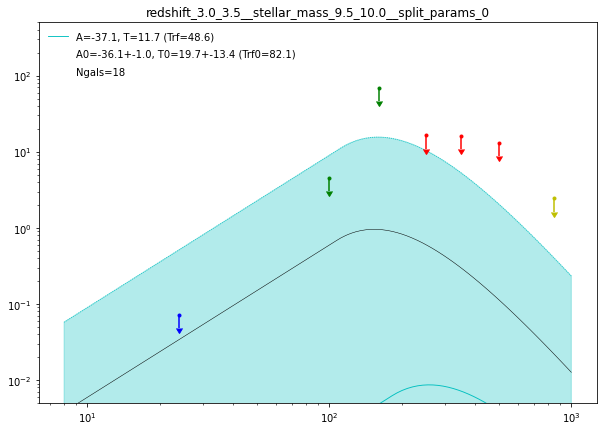

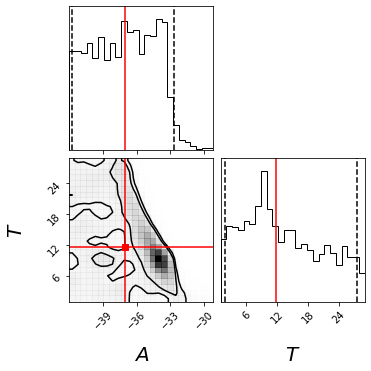

In [28]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

## z = 2.5-3

In [30]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_2.5_3.0__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=100)

A0=-34.7+-0.063, T0=10.9+-0.232
Aw=-34.7+-0.174, Tw=10.9+-0.232


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.53it/s]


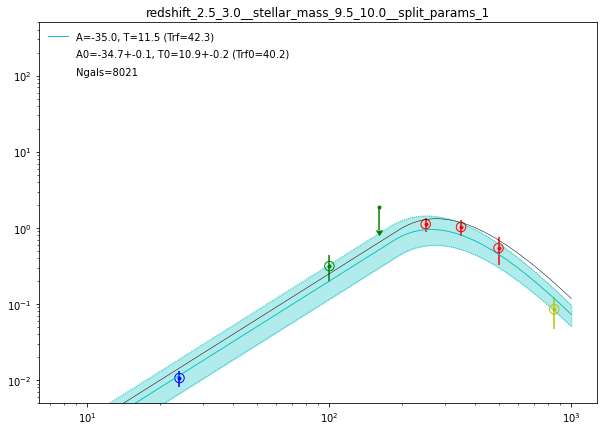

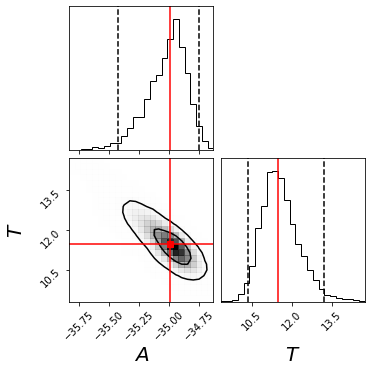

In [31]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

## z = 2-2.5

In [29]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_1.5_2.0__stellar_mass_9.5_10.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=250)

A0=-34.9+-0.072, T0=10.3+-0.232
Aw=-34.9+-0.174, Tw=10.3+-0.232
check ll_d and ll_nd: -3607.1501864458073 -624.0141831279232
check ll_d and ll_nd: 2.5929484777992613 -20.268339721220038
check ll_d and ll_nd: -634.9030991465572 -132.39890910515766
check ll_d and ll_nd: 27.31353530660095 -15.096769074743358
check ll_d and ll_nd: 23.472814858902293 -15.42296592453503
check ll_d and ll_nd: -159.8490432830774 -49.41799934519565
check ll_d and ll_nd: 28.21276829059854 -15.043755920947703
check ll_d and ll_nd: 35.42325410263137 -14.684657111871815
check ll_d and ll_nd: 27.280386508447084 -15.131379697445702
check ll_d and ll_nd: 26.948470641660688 -16.419933670629355
check ll_d and ll_nd: 26.53842971916894 -15.184094342536465
check ll_d and ll_nd: 30.710608781111517 -14.806503871003747
check ll_d and ll_nd: -92.81814171764282 -37.38814454656433
check ll_d and ll_nd: 12.401917102913238 -18.941746820479622
check ll_d and ll_nd: 31.74243286259373 -14.7819762091163
check ll_d and ll_nd: 23.661911

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

check ll_d and ll_nd: -6270.612999399612 -1024.9277935003622
check ll_d and ll_nd: 29.474533892104553 -14.94045566604115
check ll_d and ll_nd: 26.355814226587185 -15.190839147642667
check ll_d and ll_nd: 27.55909001677869 -15.110438998676688
check ll_d and ll_nd: 34.04299595857925 -15.147930687631053
check ll_d and ll_nd: 23.757212336099286 -15.399870535772326
check ll_d and ll_nd: 31.370888892919744 -14.77498971423488
check ll_d and ll_nd: -120.43216359574464 -42.21237292601622
check ll_d and ll_nd: -18.606825223785698 -24.724133381328276
check ll_d and ll_nd: 24.192134898119836 -15.354435284919894
check ll_d and ll_nd: 35.26357552028169 -14.707682706938124
check ll_d and ll_nd: 27.498219177116752 -15.107715252068449
check ll_d and ll_nd: -1242.016883884244 -267.67654024170554
check ll_d and ll_nd: -22768.936944217006 -5266.425926050047
check ll_d and ll_nd: 32.49398922023953 -14.816288041614811
check ll_d and ll_nd: 35.3191752736273 -14.704829754021723
check ll_d and ll_nd: 29.604348

  0%|                                                                                 | 1/1000 [00:00<03:19,  5.01it/s]

 -66.42548860459345 -33.865968036163174
check ll_d and ll_nd: 24.068997900336413 -15.373486135338355
check ll_d and ll_nd: -66.37996853786547 -34.08229252332657
check ll_d and ll_nd: -30923.377113421837 -6676.492965459732
check ll_d and ll_nd: 24.217804080939185 -15.362353863304683
check ll_d and ll_nd: 35.920060939404706 -14.660353152009474
check ll_d and ll_nd: 23.8081754043816 -16.958364357930698
check ll_d and ll_nd: 23.686581405024874 -15.405642643787047
check ll_d and ll_nd: 35.16168223899309 -15.029242992292318
check ll_d and ll_nd: 34.60558995549134 -14.760317990355727
check ll_d and ll_nd: 26.517444673352095 -15.165765044768623
check ll_d and ll_nd: 32.07001977890344 -14.777935158439515
check ll_d and ll_nd: 31.629033184314878 -14.729680408510283
check ll_d and ll_nd: 29.914426654358152 -14.899209630167796
check ll_d and ll_nd: -480.1995636149227 -113.65731137062187
check ll_d and ll_nd: -319.1343875384269 -89.02386440457471
check ll_d and ll_nd: 32.677224041052085 -14.8325127

  0%|▏                                                                                | 2/1000 [00:00<03:20,  4.97it/s]

 -624.8775153856229 -126.93940384987415
check ll_d and ll_nd: 27.557945046155265 -15.098709179904535
check ll_d and ll_nd: 31.59749614986702 -15.345644200115421
check ll_d and ll_nd: 26.513605865341834 -15.172365159848823
check ll_d and ll_nd: 26.54393366534931 -15.181304388170132
check ll_d and ll_nd: 30.68676009431395 -14.897761734573722
check ll_d and ll_nd: 29.33897254062426 -14.900470288454926
check ll_d and ll_nd: 27.974744692253953 -15.046732306401934
check ll_d and ll_nd: 34.734178822245084 -14.794204871977897
check ll_d and ll_nd: 29.968644738312392 -14.913436025498761
check ll_d and ll_nd: 24.300434369057136 -15.352727776044514
check ll_d and ll_nd: 26.517828821063933 -15.164808527237131
check ll_d and ll_nd: 26.085685682214454 -15.126879738394706
check ll_d and ll_nd: 30.764003194041553 -14.837158838171575
check ll_d and ll_nd: 29.654188835205325 -14.947532137723593
check ll_d and ll_nd: 35.72015419177899 -14.660602937157723
check ll_d and ll_nd: 34.730271231261014 -14.67737

  0%|▏                                                                                | 3/1000 [00:00<03:23,  4.90it/s]

 33.897998180160585 -14.711680841433466
check ll_d and ll_nd: 34.81118917052662 -14.686484582918137
check ll_d and ll_nd: 26.297273197190343 -15.189043578245318
check ll_d and ll_nd: 0.46311778450760244 -19.82164729138348
check ll_d and ll_nd: -49453.25339595112 -8544.514962866288
check ll_d and ll_nd: 34.89424014769047 -14.673564885612326
check ll_d and ll_nd: 39.168196612096054 -14.59219824069925
check ll_d and ll_nd: 31.613497844304675 -14.855911697365254
check ll_d and ll_nd: 26.439615500530227 -15.191251307844343
check ll_d and ll_nd: 31.5526116414455 -14.755236308982354
check ll_d and ll_nd: 26.93953856333961 -15.144215181877627
check ll_d and ll_nd: 26.99646469401536 -15.12917397164167
check ll_d and ll_nd: 30.60013988220644 -14.921816395200558
check ll_d and ll_nd: 29.035037630364 -14.884942739029603
check ll_d and ll_nd: 34.52340144493987 -14.76222310797382
check ll_d and ll_nd: 36.198459905543565 -14.667554987611963
check ll_d and ll_nd: -1066.8794430964542 -196.4974175665998

  0%|▎                                                                                | 4/1000 [00:00<03:24,  4.87it/s]

 30.271435672719207 -14.90546836900451
check ll_d and ll_nd: -1378.6592538646144 -283.88090871487856
check ll_d and ll_nd: 33.071027013732646 -14.73191270269791
check ll_d and ll_nd: 34.6362219396137 -14.84044070282367
check ll_d and ll_nd: 29.005055480597008 -15.24635807688707
check ll_d and ll_nd: -141.1451951350464 -44.528486499559094
check ll_d and ll_nd: -1481.4149547432228 -290.6908262531474
check ll_d and ll_nd: 34.075974506552456 -14.97442706403475
check ll_d and ll_nd: 39.71640494715143 -14.58162042001407
check ll_d and ll_nd: 33.1349401869082 -15.360340325999694
check ll_d and ll_nd: 35.05525064723621 -15.051975901153225
check ll_d and ll_nd: 37.935022645192035 -14.680529367997803
check ll_d and ll_nd: 28.08671464895944 -15.046484764407431
check ll_d and ll_nd: -338.740449630213 -84.29817921896047
check ll_d and ll_nd: 25.52349012351001 -15.273114922930207
check ll_d and ll_nd: -430.157551218323 -103.62253563925424
check ll_d and ll_nd: 35.66678720575695 -14.669438249380878
c

  0%|▍                                                                                | 5/1000 [00:01<03:37,  4.58it/s]

 25.502942580951956 -15.262545199377278
check ll_d and ll_nd: 32.39880549888473 -14.728786318244708
check ll_d and ll_nd: 30.368629420614035 -14.857801995953029
check ll_d and ll_nd: 30.18793361087124 -14.784089571925023
check ll_d and ll_nd: 31.880044775891204 -15.64741417290149
check ll_d and ll_nd: 28.323842954930022 -14.991117627677493
check ll_d and ll_nd: 32.28498597421838 -14.786946927095704
check ll_d and ll_nd: 34.06217205849467 -14.841908125493802
check ll_d and ll_nd: 36.17638965694349 -14.829650955896405
check ll_d and ll_nd: 33.92769869030613 -14.698516471692008
check ll_d and ll_nd: -152.1704315036416 -50.45461886556977
check ll_d and ll_nd: -328.40116950567034 -76.6524684375329
check ll_d and ll_nd: 35.09367673194381 -14.671349814054366
check ll_d and ll_nd: 31.519294273053948 -15.143173110531707
check ll_d and ll_nd: 39.82814100347838 -14.5765589424475
check ll_d and ll_nd: 30.638698689473216 -14.912669803335813
check ll_d and ll_nd: -174.7148882441359 -56.7588637694758

  1%|▍                                                                                | 6/1000 [00:01<03:42,  4.47it/s]

 33.7016043639249 -14.703661373129801
check ll_d and ll_nd: 29.109160232098247 -14.976363752961547
check ll_d and ll_nd: 30.40524517915908 -14.934897895562319
check ll_d and ll_nd: 35.747664454248905 -14.971943512144833
check ll_d and ll_nd: 34.750111083457625 -14.682495288196286
check ll_d and ll_nd: 35.75588781711011 -14.66223471038374
check ll_d and ll_nd: 36.17179741609855 -14.830222367898276
check ll_d and ll_nd: 31.455550751661427 -15.355066540562305
check ll_d and ll_nd: 33.973605054525976 -14.75511640609793
check ll_d and ll_nd: -174.14754030501408 -55.56122309694627
check ll_d and ll_nd: -255.08872431859984 -63.15375402955287
check ll_d and ll_nd: 38.06365532679884 -14.665305741471231
check ll_d and ll_nd: 33.217482088723656 -14.722655312460706
check ll_d and ll_nd: 23.447312345974098 -15.42517002066652
check ll_d and ll_nd: 39.65848091203863 -14.584772227003295
check ll_d and ll_nd: 24.803599764031045 -15.329305104467544
check ll_d and ll_nd: 35.230901240679486 -14.6888794918

  1%|▌                                                                                | 7/1000 [00:01<03:39,  4.53it/s]

 -6722.053330220088 -1352.9889210342296
check ll_d and ll_nd: 33.38732845812273 -14.701470136625776
check ll_d and ll_nd: 36.299276256798585 -14.813036874300249
check ll_d and ll_nd: 27.07552893283767 -16.285135010628
check ll_d and ll_nd: 29.614549510862084 -14.940878013191295
check ll_d and ll_nd: 31.40597354599507 -14.757388971896116
check ll_d and ll_nd: 30.55436368450254 -14.8308465283604
check ll_d and ll_nd: 36.05740017067271 -14.663595236487811
check ll_d and ll_nd: 36.60890660056283 -14.790514400089918
check ll_d and ll_nd: 34.89905983227779 -14.674568110459063
check ll_d and ll_nd: 29.193667627409127 -15.486767258041834
check ll_d and ll_nd: 3.9123352017653232 -20.107170256446487
check ll_d and ll_nd: -4200.828251349398 -629.8228710823819
check ll_d and ll_nd: 38.86089460024944 -14.693470832143507
check ll_d and ll_nd: 29.354176961505566 -14.923955008982027
check ll_d and ll_nd: 23.55411033195073 -15.415833014618904
check ll_d and ll_nd: 40.77457320660819 -14.547681029083403


  1%|▋                                                                                | 8/1000 [00:01<03:34,  4.63it/s]

 36.303115479416135 -14.674162403285816
check ll_d and ll_nd: 36.73053441680022 -14.781687713335854
check ll_d and ll_nd: -7469.177331728315 -1544.9197957643455
check ll_d and ll_nd: 37.95823375696828 -14.70229841940392
check ll_d and ll_nd: 28.426634070817293 -14.96243609056982
check ll_d and ll_nd: -113021.5169141028 -19993.09791605238
check ll_d and ll_nd: 33.53148901936821 -15.267886625704424
check ll_d and ll_nd: 33.88832595805414 -15.041370633160533
check ll_d and ll_nd: 23.423570254323838 -15.42739981034406
check ll_d and ll_nd: 41.45365510151896 -14.505177893185142
check ll_d and ll_nd: 33.02683312710522 -14.74852383566261
check ll_d and ll_nd: 34.906956447263326 -14.74770598950747
check ll_d and ll_nd: 33.06857354981181 -14.700908606238073
check ll_d and ll_nd: 36.44454126697735 -14.802462374108263
check ll_d and ll_nd: 30.100535828909372 -14.900711832193593
check ll_d and ll_nd: 34.30852767298495 -14.717820704496992
check ll_d and ll_nd: 33.017638254291285 -14.725473428739527

  1%|▋                                                                                | 9/1000 [00:01<03:31,  4.69it/s]

 34.85121890762395 -14.673923382099566
check ll_d and ll_nd: -9951.493219896363 -2013.8404072318365
check ll_d and ll_nd: -8323.536312647426 -1488.6871689377776
check ll_d and ll_nd: 36.61785678840524 -14.665113849423658
check ll_d and ll_nd: 15.043229630769417 -18.27364034560631
check ll_d and ll_nd: 35.36032782382214 -14.788652386796679
check ll_d and ll_nd: 40.46354500417364 -14.56549595909456
check ll_d and ll_nd: -73.15770639019706 -33.59439851453086
check ll_d and ll_nd: -16.177456465758546 -24.312930965661348
check ll_d and ll_nd: -7.662063744897111 -19.64918711026778
check ll_d and ll_nd: 30.53587402214899 -14.781976012570269
check ll_d and ll_nd: 27.712629507829096 -15.089936680696741
check ll_d and ll_nd: 38.06914880131899 -14.687160947426825
check ll_d and ll_nd: 35.51793143073195 -14.710993670138796
check ll_d and ll_nd: 29.912622535085113 -14.915642364543551
check ll_d and ll_nd: 24.063520778005547 -15.377646523440095
check ll_d and ll_nd: 31.907568337697445 -15.2891009983

  1%|▊                                                                               | 10/1000 [00:02<03:28,  4.76it/s]

 37.10974146123077 -14.638144547491674
check ll_d and ll_nd: -12.197529620665335 -23.329837934939263
check ll_d and ll_nd: 35.02312447412213 -14.776182650690693
check ll_d and ll_nd: -114.39276799887355 -41.88101318566303
check ll_d and ll_nd: 40.31844520307064 -14.567125843805432
check ll_d and ll_nd: -6.241949881804295 -21.886093404343566
check ll_d and ll_nd: 31.22253660470922 -14.851579729294034
check ll_d and ll_nd: 37.71385480638092 -14.715408494403997
check ll_d and ll_nd: 29.34247009158036 -14.91663373813022
check ll_d and ll_nd: 25.224347742837505 -15.260801643912888
check ll_d and ll_nd: 34.82891593035349 -14.675227550038723
check ll_d and ll_nd: 34.1479636242581 -14.688917153962127
check ll_d and ll_nd: 34.195662223182005 -14.684519479329518
check ll_d and ll_nd: -89.38328416679948 -36.61542640210084
check ll_d and ll_nd: 37.62555780740961 -14.773282793795044
check ll_d and ll_nd: 37.23124501365528 -14.636727965655123
check ll_d and ll_nd: 34.65483265653819 -14.9954398865982

  1%|▉                                                                               | 11/1000 [00:02<03:27,  4.77it/s]

 37.958989910707224 -14.634399623493845
check ll_d and ll_nd: 35.199966606277954 -14.69957973560879
check ll_d and ll_nd: 37.66663077069217 -14.753096777198605
check ll_d and ll_nd: 36.052047592013466 -14.913515997224874
check ll_d and ll_nd: -343.36516775554077 -70.00217952695743
check ll_d and ll_nd: 31.910435514647503 -14.815227346650058
check ll_d and ll_nd: 23.419216839981132 -15.427805147081074
check ll_d and ll_nd: 35.81253684325712 -14.826660463989457
check ll_d and ll_nd: 34.27825510621926 -14.685371472034758
check ll_d and ll_nd: 36.354734423852 -14.941649927647472
check ll_d and ll_nd: 35.452720818661334 -14.708157113814032
check ll_d and ll_nd: 30.305815853143255 -14.87774863839614
check ll_d and ll_nd: 32.114395533260556 -14.819434792800244
check ll_d and ll_nd: 34.649644774490454 -14.67690988149004
check ll_d and ll_nd: 35.562651814541624 -14.667024267459475
check ll_d and ll_nd: 38.46788274929863 -14.766459406535873
check ll_d and ll_nd: 36.1605425501899 -14.652615636626

  1%|▉                                                                               | 12/1000 [00:02<03:25,  4.80it/s]

 -3740.8632939170734 -685.9026093047754
check ll_d and ll_nd: 34.768921883344795 -14.794343421908543
check ll_d and ll_nd: 37.67116656107234 -14.753793743036773
check ll_d and ll_nd: 36.959791660409046 -14.63777922494732
check ll_d and ll_nd: 23.475252978725013 -15.422495877390741
check ll_d and ll_nd: 35.747605122016495 -14.693522215417474
check ll_d and ll_nd: 39.810267588986896 -14.573568601282307
check ll_d and ll_nd: -19.04264638589681 -24.24106434835802
check ll_d and ll_nd: 30.569416357391127 -14.90294325431505
check ll_d and ll_nd: 28.350831137592856 -15.015170260114832
check ll_d and ll_nd: 37.10322733505579 -14.767226281771228
check ll_d and ll_nd: 28.254196435766094 -15.044618603430449
check ll_d and ll_nd: 19.930831687142856 -14.945838740964742
check ll_d and ll_nd: 34.8322314606461 -14.680899439535326
check ll_d and ll_nd: -431.91115897638775 -112.64736923203202
check ll_d and ll_nd: 30.98757445236242 -14.925382976675166
check ll_d and ll_nd: 37.60667437435089 -14.77110751

  1%|█                                                                               | 13/1000 [00:02<03:32,  4.65it/s]

 37.12223718803228 -14.875465697423968
check ll_d and ll_nd: 23.435080904056612 -15.426344654825064
check ll_d and ll_nd: 33.82196226936097 -15.15794783651876
check ll_d and ll_nd: 31.29334523947 -14.767311168734867
check ll_d and ll_nd: 36.049613077689855 -14.6953594477005
check ll_d and ll_nd: 35.50693978526587 -14.695370124306644
check ll_d and ll_nd: 38.17401136568957 -14.777060918329989
check ll_d and ll_nd: 36.52201370934112 -14.645543014863538
check ll_d and ll_nd: 37.15768292454454 -14.633252568120009
check ll_d and ll_nd: 38.047930129175384 -14.623160285617823
check ll_d and ll_nd: 35.35764829967401 -14.69041386130979
check ll_d and ll_nd: 39.83477764772239 -14.72201423191795
check ll_d and ll_nd: 33.680371411848924 -14.705072189685186
check ll_d and ll_nd: 30.81669510215809 -14.864108455245283
check ll_d and ll_nd: 33.74409445328707 -14.691218177954298
check ll_d and ll_nd: 36.63375948239613 -14.955037285221758
check ll_d and ll_nd: 38.058685399675724 -14.68673011941606
check

  1%|█                                                                               | 14/1000 [00:02<03:30,  4.69it/s]

 23.419139863281277 -15.427812916690211
check ll_d and ll_nd: 41.02192267994883 -14.431467915016238
check ll_d and ll_nd: -9.895769141228648 -20.261879858019395
check ll_d and ll_nd: 37.73689808695982 -14.858587095278025
check ll_d and ll_nd: 34.87134801335925 -14.873105688998308
check ll_d and ll_nd: 33.75289904679447 -15.162197611521087
check ll_d and ll_nd: 35.99958441441454 -14.66984214141344
check ll_d and ll_nd: 35.10311483477996 -14.669639539930365
check ll_d and ll_nd: -343.3131864593088 -84.56679045023773
check ll_d and ll_nd: 37.62237953713529 -14.741333840491379
check ll_d and ll_nd: 36.709429223060695 -14.98279644301277
check ll_d and ll_nd: 11.836041151828603 -19.043848190861194
check ll_d and ll_nd: 38.64039097285236 -14.60463400321871
check ll_d and ll_nd: 41.731207816004 -14.540586829260373
check ll_d and ll_nd: 23.42078637637111 -15.427660584293644
check ll_d and ll_nd: 33.76163130587467 -14.702850682339625
check ll_d and ll_nd: 42.53487646670837 -14.4429289165436
chec

  2%|█▏                                                                              | 15/1000 [00:03<03:31,  4.65it/s]

 35.83109644212574 -14.69306291420611
check ll_d and ll_nd: -5782.244943845374 -1163.920350674972
check ll_d and ll_nd: 30.77370117294744 -15.83095754117446
check ll_d and ll_nd: 30.70522333632254 -14.867590794318165
check ll_d and ll_nd: 35.10205246492075 -15.047566486131064
check ll_d and ll_nd: 33.689963784080625 -15.280189952395752
check ll_d and ll_nd: 37.709989742418735 -14.86076852044575
check ll_d and ll_nd: 34.86231844003488 -14.71991943231453
check ll_d and ll_nd: 35.69552017001295 -14.659790044317287
check ll_d and ll_nd: 35.464307193182854 -14.6683502287866
check ll_d and ll_nd: 23.51607422148806 -15.417450544279218
check ll_d and ll_nd: 37.45662494151237 -14.726735448566524
check ll_d and ll_nd: 36.22932565623019 -14.952081284929815
check ll_d and ll_nd: 38.26203884026507 -14.634649060905115
check ll_d and ll_nd: 29.085338826365902 -15.061460957386847
check ll_d and ll_nd: 40.54843882937331 -14.557268720013605
check ll_d and ll_nd: 35.35076420660074 -14.682989289235778
che

  2%|█▎                                                                              | 16/1000 [00:03<03:27,  4.74it/s]

 30.515710359666475 -14.957708171715423
check ll_d and ll_nd: 35.73064447396033 -15.008417365331493
check ll_d and ll_nd: 24.7970559710097 -15.30952525986497
check ll_d and ll_nd: 39.51842861129114 -14.633135278800665
check ll_d and ll_nd: 32.432414950094966 -14.899058074498722
check ll_d and ll_nd: 41.702657714990785 -14.537007537922172
check ll_d and ll_nd: 23.421307954871306 -15.427618271894655
check ll_d and ll_nd: 33.95213710203213 -14.695793953860917
check ll_d and ll_nd: 38.21270198252723 -14.749030283523638
check ll_d and ll_nd: 39.444277084265856 -14.6660609480351
check ll_d and ll_nd: 32.77818202812678 -14.707054301303112
check ll_d and ll_nd: 13.910016802751088 -18.205156973439948
check ll_d and ll_nd: 7.935595128329837 -16.02048758701007
check ll_d and ll_nd: 32.490715715999045 -14.80340037728835
check ll_d and ll_nd: 36.158128336969334 -14.667856741804224
check ll_d and ll_nd: 30.774543504592813 -14.854402404191678
check ll_d and ll_nd: 24.18053534239471 -15.36899554872022

  2%|█▎                                                                              | 17/1000 [00:03<03:26,  4.77it/s]

 -4919171.023735803 -1010990.7888297607
check ll_d and ll_nd: 34.02401865505193 -14.692641189083155
check ll_d and ll_nd: 40.14281263346118 -14.41966426755231
check ll_d and ll_nd: 31.751086490853787 -14.76919463390821
check ll_d and ll_nd: 38.157492591334474 -14.673422037843231
check ll_d and ll_nd: 31.931852515892007 -14.731539543898343
check ll_d and ll_nd: 37.08105767632459 -14.699175227315692
check ll_d and ll_nd: 36.29569594534094 -14.879802266631525
check ll_d and ll_nd: 35.83309085044043 -14.967159087933194
check ll_d and ll_nd: 24.5764092212539 -15.344292919814164
check ll_d and ll_nd: -6174.044518025728 -1457.4002679440418
check ll_d and ll_nd: 38.27206028714781 -14.702536892779412
check ll_d and ll_nd: 36.003503192790774 -14.974104721849763
check ll_d and ll_nd: -261513533.57309252 -inf
check ll_d and ll_nd: -1354.663494943468 -165.4820027691027
check ll_d and ll_nd: 38.05671894300042 -14.818012329678503
check ll_d and ll_nd: 36.46644089164924 -14.682861563853818
check ll_d 

  2%|█▍                                                                              | 18/1000 [00:03<03:25,  4.79it/s]

 42.78924569076976 -14.588302416141918
check ll_d and ll_nd: 26.77381727470752 -15.056283867277692
check ll_d and ll_nd: 37.40347054935931 -14.710349834467518
check ll_d and ll_nd: 37.95264721598983 -14.782042074446878
check ll_d and ll_nd: 36.50132585681318 -14.76040242036007
check ll_d and ll_nd: 38.71767292057574 -14.603002247760333
check ll_d and ll_nd: 28.76039362480299 -14.955766941351163
check ll_d and ll_nd: 37.922144764702274 -14.683920423053692
check ll_d and ll_nd: 35.23273009676468 -14.818914717782016
check ll_d and ll_nd: 33.14579114252934 -14.686138009112733
check ll_d and ll_nd: 35.37703317276265 -14.737248161984299
check ll_d and ll_nd: 41.41590057213001 -14.52516950826613
check ll_d and ll_nd: 32.813901287827484 -15.36377450525688
check ll_d and ll_nd: 33.7480679309916 -14.69145405315663
check ll_d and ll_nd: 42.59312643685992 -14.61341461713331
check ll_d and ll_nd: 37.45904669885114 -14.86952258471812
check ll_d and ll_nd: 27.425118580549253 -15.110912852315762
check

  2%|█▌                                                                              | 19/1000 [00:04<03:26,  4.74it/s]

 37.96522750084819 -14.646443237435491
check ll_d and ll_nd: 34.37242280909248 -14.718600487946224
check ll_d and ll_nd: 38.711185273085604 -14.613049508727977
check ll_d and ll_nd: 32.37659889449006 -15.067802091227747
check ll_d and ll_nd: -5879.869438258873 -1126.8813725055545
check ll_d and ll_nd: 36.77633090917588 -14.668782818642962
check ll_d and ll_nd: 36.899179141303655 -14.638472875840051
check ll_d and ll_nd: 35.20749591397574 -14.823924393221091
check ll_d and ll_nd: 39.73996933457161 -14.63192522390644
check ll_d and ll_nd: 38.95117686046861 -14.686169829265811
check ll_d and ll_nd: 37.51336074330212 -14.690411717442393
check ll_d and ll_nd: 41.73359319899514 -14.540932420595329
check ll_d and ll_nd: 31.560016350005178 -14.835553985691
check ll_d and ll_nd: 23.419230500411214 -15.427804150907178
check ll_d and ll_nd: 33.92289334430572 -14.688212789262572
check ll_d and ll_nd: 23.419151750937463 -15.427812276321664
check ll_d and ll_nd: 37.7463298804671 -14.831985940048948


  2%|█▌                                                                              | 20/1000 [00:04<03:26,  4.74it/s]

 25.859958781582655 -15.08155331063159
check ll_d and ll_nd: 38.35078364223759 -14.786319782677662
check ll_d and ll_nd: 36.888949368289445 -14.638476250678597
check ll_d and ll_nd: 42.21451490379593 -14.486067148326377
check ll_d and ll_nd: 36.182090480911675 -14.813363813664985
check ll_d and ll_nd: 41.3456440852957 -14.617801087073662
check ll_d and ll_nd: 34.017038807667475 -15.264762467784493
check ll_d and ll_nd: 23.41919146887352 -15.427807929268507
check ll_d and ll_nd: 38.543701182898445 -14.606316851535302
check ll_d and ll_nd: 42.98167509738611 -14.574454498735571
check ll_d and ll_nd: 31.677828281288416 -14.83002661605245
check ll_d and ll_nd: 34.634256630272546 -14.678193610444637
check ll_d and ll_nd: 38.522945528991286 -14.618396809630807
check ll_d and ll_nd: 40.47745526205494 -14.561194502474073
check ll_d and ll_nd: 36.044117844795906 -14.773924955208976
check ll_d and ll_nd: 30.697105122354184 -14.978753971638167
check ll_d and ll_nd: 31.127756483714688 -14.981356963

  2%|█▋                                                                              | 21/1000 [00:04<03:27,  4.72it/s]

 33.985340233663386 -14.845721537074468
check ll_d and ll_nd: 39.79202803900286 -14.594025757849494
check ll_d and ll_nd: 31.016540944735 -15.147745559055256
check ll_d and ll_nd: 39.0500046229572 -14.631116895788047
check ll_d and ll_nd: 37.18475719985429 -14.79012534869528
check ll_d and ll_nd: 36.75601141770517 -14.868924782434478
check ll_d and ll_nd: 43.27176221619168 -14.58994295712072
check ll_d and ll_nd: 25.73574440819973 -14.823566213185812
check ll_d and ll_nd: 32.509847687401816 -15.481009493611024
check ll_d and ll_nd: 27.543939288807913 -15.046181697234221
check ll_d and ll_nd: 35.81648182245294 -14.657679617503423
check ll_d and ll_nd: 36.239081589244606 -14.65634442252789
check ll_d and ll_nd: 37.53047590822921 -14.779589098281921
check ll_d and ll_nd: 8.832051527325653 -18.95357705448685
check ll_d and ll_nd: 33.809979378588764 -14.845899903966844
check ll_d and ll_nd: 40.24547301199087 -14.613160553111426
check ll_d and ll_nd: 34.380381422522795 -14.935739897427943
ch

  2%|█▊                                                                              | 22/1000 [00:04<03:23,  4.80it/s]

 38.79294485306751 -14.603968518683402
check ll_d and ll_nd: 31.46062708736123 -15.57494872924137
check ll_d and ll_nd: 29.577978632452222 -14.999343550177137
check ll_d and ll_nd: 39.87758932644789 -14.593929159771985
check ll_d and ll_nd: 36.16042299869022 -14.967375259248314
check ll_d and ll_nd: 23.53064729583906 -15.422763554039735
check ll_d and ll_nd: 37.067653761141926 -14.62658983733826
check ll_d and ll_nd: 35.22143568605753 -14.73941394895129
check ll_d and ll_nd: 23.433529306288918 -15.426530986623884
check ll_d and ll_nd: 23.4199513402882 -15.427749948181884
check ll_d and ll_nd: 42.780871849273964 -14.536930883162276
check ll_d and ll_nd: 36.207498840639346 -15.052815403975707
check ll_d and ll_nd: 38.9039898450157 -14.706249134749962
check ll_d and ll_nd: 31.46293898426409 -14.841593555945469
check ll_d and ll_nd: 33.795974882433285 -15.121612076649196
check ll_d and ll_nd: 38.3903123921972 -14.629039161017813
check ll_d and ll_nd: 39.77388785910725 -14.580359884524107
c

  2%|█▊                                                                              | 23/1000 [00:04<03:24,  4.77it/s]

 36.967038714300465 -14.637778297356878
check ll_d and ll_nd: 39.06393926361403 -14.630986562602114
check ll_d and ll_nd: 36.61678018538588 -14.78303381030834
check ll_d and ll_nd: 43.22829303227268 -14.592532870969938
check ll_d and ll_nd: 32.6014705436988 -14.914481185539138
check ll_d and ll_nd: 41.683019259288685 -14.745126057805994
check ll_d and ll_nd: 43.038422180088155 -14.557688476538235
check ll_d and ll_nd: 39.6609770789229 -14.411358989509335
check ll_d and ll_nd: -2999817130794.7173 -inf
check ll_d and ll_nd: 35.29077743976822 -14.669302557941036
check ll_d and ll_nd: 39.858821998639534 -14.596846097658569
check ll_d and ll_nd: 37.33110657313841 -14.65083370091546
check ll_d and ll_nd: 32.049508208342225 -15.028299452508941
check ll_d and ll_nd: 40.145250638117474 -14.583403789102164
check ll_d and ll_nd: 32.03860492286532 -14.8994466462854
check ll_d and ll_nd: 36.98771620500557 -14.676440907281894
check ll_d and ll_nd: -27080694.102043483 -557541.4064377594
check ll_d an

  2%|█▉                                                                              | 24/1000 [00:05<03:23,  4.79it/s]

 29.241425546690014 -14.877756613161054
check ll_d and ll_nd: 36.76380768585154 -14.67819011454761
check ll_d and ll_nd: 6.464906452944177 -16.444762318881473
check ll_d and ll_nd: 40.83471814686705 -14.561237836987042
check ll_d and ll_nd: 17.47882603515537 -15.243282590100417
check ll_d and ll_nd: 37.59314018901279 -14.637367468370597
check ll_d and ll_nd: 25.0147974978006 -15.23393104034306
check ll_d and ll_nd: 40.9955134531449 -14.550876002920873
check ll_d and ll_nd: 40.18226406626589 -14.587512814854211
check ll_d and ll_nd: 40.772790165924015 -14.545260466496249
check ll_d and ll_nd: 36.611665285511634 -14.658374638541204
check ll_d and ll_nd: 23.493520694178805 -15.423907312853832
check ll_d and ll_nd: -2.736650885048242 -14.368870862451484
check ll_d and ll_nd: 35.04595902807684 -15.21141321117151
check ll_d and ll_nd: 40.393130999034035 -14.400009309142835
check ll_d and ll_nd: 34.2019751459968 -14.78960774844992
check ll_d and ll_nd: 34.97789471774446 -14.679690555753975
ch

  2%|██                                                                              | 25/1000 [00:05<03:28,  4.68it/s]

 34.62014753619181 -14.79778202251217
check ll_d and ll_nd: 36.127959188296046 -14.77572455255387
check ll_d and ll_nd: 39.12404396744679 -14.640325070075587
check ll_d and ll_nd: 40.95452151401932 -14.536427760156318
check ll_d and ll_nd: 40.571255506700886 -14.560741876139481
check ll_d and ll_nd: 40.76902672743842 -14.66353547294946
check ll_d and ll_nd: 37.267012491299624 -14.69184671522355
check ll_d and ll_nd: 33.385292578938376 -14.738568543607462
check ll_d and ll_nd: 41.6185735356142 -14.617036877097853
check ll_d and ll_nd: 33.90394803783505 -15.26327211024897
check ll_d and ll_nd: 27.355646012793827 -15.095652566616867
check ll_d and ll_nd: 37.75894168285549 -14.621514623827075
check ll_d and ll_nd: 40.55109326674719 -14.565210274296426
check ll_d and ll_nd: 41.605155348297004 -14.60721625785967
check ll_d and ll_nd: 38.30558738906915 -14.621419675708232
check ll_d and ll_nd: 41.46014600166333 -14.511022842600813
check ll_d and ll_nd: 32.44294487498193 -14.997505700381339
ch

  3%|██                                                                              | 26/1000 [00:05<03:24,  4.76it/s]

 39.669469370614934 -14.577506814832116
check ll_d and ll_nd: 36.699371705364186 -14.644317847006477
check ll_d and ll_nd: 24.223117195078515 -14.841648743653176
check ll_d and ll_nd: 30.768073492220623 -14.890013428277992
check ll_d and ll_nd: 34.38618161180791 -14.69031005489914
check ll_d and ll_nd: 40.55595659881932 -14.556309640285612
check ll_d and ll_nd: 40.3170445235074 -14.558612961241794
check ll_d and ll_nd: 42.172354971171146 -14.4295211559012
check ll_d and ll_nd: 25.354755024191796 -15.263765822437993
check ll_d and ll_nd: -19423070530.717964 -inf
check ll_d and ll_nd: 33.44709564266843 -15.416168490377338
check ll_d and ll_nd: 33.82818277974525 -14.689518687299907
check ll_d and ll_nd: -6.99823303496288 -16.648386399740737
check ll_d and ll_nd: 37.20455181435754 -14.867470480814447
check ll_d and ll_nd: 41.75077975940434 -14.668813386156422
check ll_d and ll_nd: 29.341409593751166 -14.965741227873568
check ll_d and ll_nd: 40.04625334103807 -14.571056501392972
check ll_d 

  3%|██▏                                                                             | 27/1000 [00:05<03:23,  4.78it/s]

 35.53586898479645 -14.664807408631017
check ll_d and ll_nd: 40.3209369258541 -14.5795401034324
check ll_d and ll_nd: 37.483790152637326 -14.67612020830107
check ll_d and ll_nd: 27.25039048294795 -15.307264341451443
check ll_d and ll_nd: 41.8757605424271 -14.426486573389784
check ll_d and ll_nd: 40.07076006274687 -14.567521708224366
check ll_d and ll_nd: 29.768443186247314 -14.951677278800691
check ll_d and ll_nd: 23.42309033958493 -15.42749255703762
check ll_d and ll_nd: 41.11911980878676 -14.95316846624706
check ll_d and ll_nd: 40.43355786815438 -14.476661098170032
check ll_d and ll_nd: 36.82612378403175 -14.7721688206788
check ll_d and ll_nd: 40.06558093714299 -14.586336882739982
check ll_d and ll_nd: 36.01412876596442 -14.655925746426014
check ll_d and ll_nd: 39.2063833933718 -14.397627933049876
check ll_d and ll_nd: 37.83975684838774 -14.623368808093037
check ll_d and ll_nd: 36.1891351115264 -14.672175893112119
check ll_d and ll_nd: 39.90080691033539 -14.827880347009142
check ll_d

  3%|██▏                                                                             | 28/1000 [00:05<03:26,  4.72it/s]

 37.614384480051484 -15.014267684452905
check ll_d and ll_nd: 36.66294921476867 -14.645261691199925
check ll_d and ll_nd: 29.74825757410632 -14.869971912535938
check ll_d and ll_nd: 42.67221173218476 -14.512583840033633
check ll_d and ll_nd: 40.37168630375444 -14.56706219347224
check ll_d and ll_nd: 41.96377566382687 -14.50255677466501
check ll_d and ll_nd: 33.78915525218984 -14.980690884680051
check ll_d and ll_nd: 41.013519009945824 -14.559471067483578
check ll_d and ll_nd: 26.980762173579183 -14.755849933845337
check ll_d and ll_nd: 36.89223200184091 -14.93759269961779
check ll_d and ll_nd: 23.49929110301964 -15.422282385358896
check ll_d and ll_nd: 38.32066460910306 -14.623840147612299
check ll_d and ll_nd: 38.93481057011772 -14.716652075621884
check ll_d and ll_nd: 38.494626018891715 -14.726444908276909
check ll_d and ll_nd: 40.85371640461865 -14.680840799977174
check ll_d and ll_nd: 26.95821286960907 -14.411618333944517
check ll_d and ll_nd: 31.292668953218826 -14.772546971631563

  3%|██▎                                                                             | 29/1000 [00:06<03:21,  4.81it/s]

 38.093211245165016 -14.791888016161087
check ll_d and ll_nd: 41.984303525835955 -14.696386933842966
check ll_d and ll_nd: 40.805555648231525 -14.50505972972897
check ll_d and ll_nd: 38.38114470506469 -14.696054602945138
check ll_d and ll_nd: 38.47159373108799 -14.64997293342276
check ll_d and ll_nd: 36.70950416462516 -14.965509742858881
check ll_d and ll_nd: 37.00210508517851 -14.722831661969156
check ll_d and ll_nd: 23.421526941291106 -15.427653425791291
check ll_d and ll_nd: 35.838452694142404 -15.281947467090136
check ll_d and ll_nd: 37.12469985259161 -14.934083535563698
check ll_d and ll_nd: 36.43978415549492 -14.649695059557294
check ll_d and ll_nd: 34.28701260839784 -14.701145146864551
check ll_d and ll_nd: 27.07630319426785 -15.69753190191912
check ll_d and ll_nd: 40.444701670775146 -14.784185955067134
check ll_d and ll_nd: 38.01687063166502 -14.61615699155486
check ll_d and ll_nd: 37.052762325531944 -14.635270067166342
check ll_d and ll_nd: 35.05747964246879 -14.76896974414031

  3%|██▍                                                                             | 30/1000 [00:06<03:28,  4.65it/s]

 40.32224576071546 -14.583820661694812
check ll_d and ll_nd: 36.86543606675818 -14.647582049267594
check ll_d and ll_nd: 42.878947238921114 -14.538733266377207
check ll_d and ll_nd: 41.30340228499575 -14.647457151513482
check ll_d and ll_nd: 29.861513788052484 -14.746400138305422
check ll_d and ll_nd: 11.510330012030906 -15.184045279729885
check ll_d and ll_nd: 40.17194059132725 -14.561102149278806
check ll_d and ll_nd: -2116717208.2527564 -inf
check ll_d and ll_nd: 42.68147677856294 -14.51279724841891
check ll_d and ll_nd: 36.927894274279126 -14.902461803724123
check ll_d and ll_nd: 40.38642426659098 -14.74257630606986
check ll_d and ll_nd: 23.472637377283565 -15.42498854830669
check ll_d and ll_nd: 43.05013287762452 -14.536375999280837
check ll_d and ll_nd: 35.32674493122987 -14.66631109698736
check ll_d and ll_nd: 37.80928095546426 -14.793420255628432
check ll_d and ll_nd: 41.4200368203847 -14.669198020700868
check ll_d and ll_nd: 42.6340812425763 -14.447998202188476
check ll_d and 

  3%|██▍                                                                             | 31/1000 [00:06<03:26,  4.69it/s]

 40.69014670427296 -14.665817331950498
check ll_d and ll_nd: 25.620027860346422 -15.305098791655997
check ll_d and ll_nd: 41.85980937742595 -14.596590128411245
check ll_d and ll_nd: 32.638414613751564 -14.814248294479086
check ll_d and ll_nd: 41.62521216519714 -14.693601121433495
check ll_d and ll_nd: 23.419302285007923 -15.427806796555327
check ll_d and ll_nd: 23.43465669747932 -15.426522302500576
check ll_d and ll_nd: 36.10312281016243 -14.859326441454673
check ll_d and ll_nd: 41.812223303135035 -14.868587278664862
check ll_d and ll_nd: 39.88732467478273 -14.571496040199465
check ll_d and ll_nd: 36.83217662990541 -14.94494345725274
check ll_d and ll_nd: 37.61219951114026 -14.625152326263642
check ll_d and ll_nd: 37.2191176252048 -14.63469264057046
check ll_d and ll_nd: 35.28151010943503 -14.740460237935192
check ll_d and ll_nd: 42.8122931953819 -14.524100752358258
check ll_d and ll_nd: 36.912364773385995 -14.838035952461553
check ll_d and ll_nd: 39.59700732770324 -14.626313161324983


  3%|██▌                                                                             | 32/1000 [00:06<03:24,  4.73it/s]

 31.69678397878075 -15.685669776537917
check ll_d and ll_nd: 41.53838814757249 -14.578904126077658
check ll_d and ll_nd: 42.42326168059223 -14.436561195121229
check ll_d and ll_nd: -3068572207.391581 -inf
check ll_d and ll_nd: 37.56508331600799 -14.627090809964553
check ll_d and ll_nd: 42.29893659685956 -14.794907632529704
check ll_d and ll_nd: 36.415837074915046 -14.653118454370148
check ll_d and ll_nd: 42.11698715459785 -14.462025556440075
check ll_d and ll_nd: 43.0009994883196 -14.504306898796887
check ll_d and ll_nd: 36.78295661610716 -14.924910223465826
check ll_d and ll_nd: 35.62528849654281 -15.04152873131103
check ll_d and ll_nd: 23.45833766160365 -15.424687701157305
check ll_d and ll_nd: 43.02542836438074 -14.490058054999148
check ll_d and ll_nd: 35.235806454168724 -14.667727015998103
check ll_d and ll_nd: 39.41369255192501 -14.617843481206677
check ll_d and ll_nd: 34.721148886221485 -15.234093268348762
check ll_d and ll_nd: 23.77890874208799 -15.423376278825923
check ll_d and

  3%|██▋                                                                             | 33/1000 [00:06<03:20,  4.82it/s]

 38.87931146810726 -14.622595593104773
check ll_d and ll_nd: 40.14989029806895 -14.5523139155256
check ll_d and ll_nd: 39.53321556353404 -14.61974066027761
check ll_d and ll_nd: -2948.052656112522 -167.2995837104836
check ll_d and ll_nd: 35.0141739874438 -14.879740753309605
check ll_d and ll_nd: 42.38903079534676 -14.604590538440874
check ll_d and ll_nd: 38.39989421365475 -14.773762708021485
check ll_d and ll_nd: 35.03280382692729 -15.197295788838677
check ll_d and ll_nd: 23.41925653499419 -15.427801993642223
check ll_d and ll_nd: 42.64095093080965 -14.775337961247898
check ll_d and ll_nd: 17.933977400134857 -16.44451172967073
check ll_d and ll_nd: 41.942479742202295 -14.447812185025446
check ll_d and ll_nd: 38.12272004785012 -14.617084853163519
check ll_d and ll_nd: 43.211719584447806 -14.639394208272634
check ll_d and ll_nd: 42.72732846562039 -14.473132467576573
check ll_d and ll_nd: 41.78822582342436 -14.456255320515904
check ll_d and ll_nd: 27.90035895302395 -14.828324744120899
che

  3%|██▋                                                                             | 34/1000 [00:07<03:17,  4.88it/s]

 38.54777096122605 -14.629180802316473
check ll_d and ll_nd: 40.44606772419213 -14.523378953018003
check ll_d and ll_nd: 43.166240427472495 -14.528124871948382
check ll_d and ll_nd: 32.73612228069985 -15.062013692411579
check ll_d and ll_nd: 42.20698517035221 -14.633996102379495
check ll_d and ll_nd: 43.06499983768058 -14.496494261920612
check ll_d and ll_nd: 20.889554051941197 -16.14971456222477
check ll_d and ll_nd: 41.77966972945673 -14.473361180940593
check ll_d and ll_nd: 23.438219144602428 -15.426237048547062
check ll_d and ll_nd: 38.31746827013846 -14.781632368799936
check ll_d and ll_nd: 39.46080109281529 -14.589123852543711
check ll_d and ll_nd: 38.19455778450506 -14.6129197509879
check ll_d and ll_nd: 16.410338622890485 -16.7719585880476
check ll_d and ll_nd: 41.94950511669019 -14.427396933083347
check ll_d and ll_nd: 41.759369043870194 -14.523974274970161
check ll_d and ll_nd: 28.60326768725356 -14.809499078975367
check ll_d and ll_nd: 37.11374270895622 -14.671344532116631
c

  4%|██▊                                                                             | 35/1000 [00:07<03:19,  4.83it/s]

 42.81682210402138 -14.495024017002361
check ll_d and ll_nd: 30.95758624959271 -14.494799901868522
check ll_d and ll_nd: 41.962881063721035 -14.55812239963295
check ll_d and ll_nd: 37.31131921283797 -14.91162533934179
check ll_d and ll_nd: 43.172225428012936 -14.521747138372742
check ll_d and ll_nd: 43.24565287590518 -14.5953759508594
check ll_d and ll_nd: 42.92546410641286 -14.502702158343713
check ll_d and ll_nd: -448.7413243043173 -17.469459776906824
check ll_d and ll_nd: 40.383235844955 -14.396137861510066
check ll_d and ll_nd: 41.02219398248418 -14.52760367593078
check ll_d and ll_nd: 27.91090339357393 -14.773575688042245
check ll_d and ll_nd: 37.329996040901115 -14.634559292176913
check ll_d and ll_nd: 35.68667858284111 -14.660080937901988
check ll_d and ll_nd: 42.923440152196186 -14.67618819076871
check ll_d and ll_nd: 34.77855858750742 -14.685533451268583
check ll_d and ll_nd: -40967172.9797982 -552720.5709559391
check ll_d and ll_nd: 42.22475486296161 -14.441686841367531
check

  4%|██▉                                                                             | 36/1000 [00:07<03:17,  4.87it/s]

 41.02517529326304 -14.59160912370145
check ll_d and ll_nd: 43.0490045067153 -14.502653846905787
check ll_d and ll_nd: 40.22148797185385 -14.616723770072102
check ll_d and ll_nd: 38.36491982868018 -14.672491670109963
check ll_d and ll_nd: -3942286.0672601894 -89491.5834235987
check ll_d and ll_nd: 9.26984252288267 -16.36318572837176
check ll_d and ll_nd: 43.19398646423336 -14.532621921154252
check ll_d and ll_nd: 41.29672792601278 -14.40603085880996
check ll_d and ll_nd: 42.27695746539503 -14.454824226381241
check ll_d and ll_nd: 41.51871098571772 -14.526880439552617
check ll_d and ll_nd: 41.13142882454944 -14.55128103123929
check ll_d and ll_nd: 42.86580233177967 -14.523881942428183
check ll_d and ll_nd: 29.299590907929847 -15.966592168202826
check ll_d and ll_nd: 37.24483246294618 -14.90216956575198
check ll_d and ll_nd: 31.40755831776829 -14.933607769644247
check ll_d and ll_nd: 41.06227639135583 -14.534126210278231
check ll_d and ll_nd: 42.76482471382754 -14.61296761698243
check ll

  4%|██▉                                                                             | 37/1000 [00:07<03:21,  4.77it/s]

 42.57118026399742 -14.509357516281153
check ll_d and ll_nd: 24.662118507287246 -16.398613792357118
check ll_d and ll_nd: 42.50205778121523 -14.516285175833326
check ll_d and ll_nd: 38.612419446365635 -14.662449802834864
check ll_d and ll_nd: 43.13698224078286 -14.65276074191574
check ll_d and ll_nd: 43.26163566779927 -14.581429464414635
check ll_d and ll_nd: 35.922068583375406 -14.950317062045666
check ll_d and ll_nd: 41.11775877980824 -14.414378474218575
check ll_d and ll_nd: 41.1677344205914 -14.535769478638095
check ll_d and ll_nd: 39.78515933673575 -14.607740512697301
check ll_d and ll_nd: 40.40887582520453 -14.558763045762165
check ll_d and ll_nd: 42.10121121000341 -14.444683690946931
check ll_d and ll_nd: 42.471413679787744 -14.492745676873293
check ll_d and ll_nd: 30.345442861620754 -14.749899182329994
check ll_d and ll_nd: 42.80149558761517 -14.519026862195812
check ll_d and ll_nd: 38.59770763969218 -14.679326757454614
check ll_d and ll_nd: 42.83849609510921 -14.47045598372685

  4%|███                                                                             | 38/1000 [00:08<03:22,  4.75it/s]

 39.93729999556268 -14.64678131087926
check ll_d and ll_nd: 43.03703665390894 -14.697558983670064
check ll_d and ll_nd: 43.26057427046982 -14.621660986019451
check ll_d and ll_nd: 38.340478593006864 -14.599420728567244
check ll_d and ll_nd: 42.81711307908398 -14.478929007767736
check ll_d and ll_nd: 41.740549358870375 -14.492786220684412
check ll_d and ll_nd: 34.12499200499179 -14.695797932015067
check ll_d and ll_nd: 43.190759931826925 -14.539165836711575
check ll_d and ll_nd: 23.447803042493156 -15.426399610245237
check ll_d and ll_nd: 41.02384725565621 -14.512813368394024
check ll_d and ll_nd: 40.819413221664426 -14.986785090291072
check ll_d and ll_nd: 41.07934370429797 -14.557178574261606
check ll_d and ll_nd: 42.89180534293359 -14.527229668567816
check ll_d and ll_nd: 27.49013049455125 -14.570047120383883
check ll_d and ll_nd: 42.60106178072681 -14.772377922884782
check ll_d and ll_nd: 33.79268517836121 -14.80523005262555
check ll_d and ll_nd: 43.24437717768734 -14.60215544311412

  4%|███                                                                             | 39/1000 [00:08<03:24,  4.70it/s]

 42.861943555118756 -14.48379644592227
check ll_d and ll_nd: 36.23209040643265 -14.652606570952347
check ll_d and ll_nd: 38.586562885172484 -14.64515953630797
check ll_d and ll_nd: 42.69592183151791 -14.648659317670367
check ll_d and ll_nd: 42.871836307576984 -14.48933691446905
check ll_d and ll_nd: 39.03632781309477 -14.677445944671016
check ll_d and ll_nd: 42.077205486026344 -14.44442014338885
check ll_d and ll_nd: 42.79882666343065 -14.747840011433674
check ll_d and ll_nd: 43.07817349911889 -14.686925770768287
check ll_d and ll_nd: 43.12345265029723 -14.674290577295668
check ll_d and ll_nd: 23.41946492350898 -15.427799517845528
check ll_d and ll_nd: 41.83457647452115 -14.545723110347549
check ll_d and ll_nd: 43.29480801601104 -14.572213758930925
check ll_d and ll_nd: 40.414183201370065 -14.573407017310288
check ll_d and ll_nd: 40.59601418354788 -14.533529216399852
check ll_d and ll_nd: 40.243717405718826 -15.044226600450418
check ll_d and ll_nd: 39.946874534557054 -14.46286488047488

  4%|███▏                                                                            | 40/1000 [00:08<03:24,  4.70it/s]

 38.83014096084886 -14.621574625996821
check ll_d and ll_nd: 36.981043454963796 -14.67986975570933
check ll_d and ll_nd: 42.76231093616578 -14.574657712263942
check ll_d and ll_nd: 42.979697139491336 -14.507994795184525
check ll_d and ll_nd: -741.9975695296984 -20.978684637212883
check ll_d and ll_nd: 42.647721498823124 -14.772307291567813
check ll_d and ll_nd: 41.20052242228994 -14.477290958923783
check ll_d and ll_nd: 32.74330755145348 -15.319711443320763
check ll_d and ll_nd: 40.74102250932573 -14.659299482565608
check ll_d and ll_nd: 21.129480432328617 -15.167204511590402
check ll_d and ll_nd: 42.50152342224191 -14.582911946637314
check ll_d and ll_nd: -58121445174.37503 -inf
check ll_d and ll_nd: 35.27797492433059 -15.168936181286751
check ll_d and ll_nd: 42.65201387318469 -14.467803316798086
check ll_d and ll_nd: 39.868716515595715 -14.62350891564856
check ll_d and ll_nd: 33.671046139354885 -14.702084016118775
check ll_d and ll_nd: 36.581157896747634 -14.748031875832236
check ll_

  4%|███▎                                                                            | 41/1000 [00:08<03:35,  4.44it/s]

 41.33526194429812 -14.491367765845808
check ll_d and ll_nd: 41.36455848617658 -14.920979110638662
check ll_d and ll_nd: 41.35173384366787 -14.559755832536972
check ll_d and ll_nd: 42.303145973548766 -14.527741568890718
check ll_d and ll_nd: 40.42435983418222 -14.570146109001993
check ll_d and ll_nd: 43.0454731567864 -14.49799489823031
check ll_d and ll_nd: 39.872712097785445 -14.617939348768212
check ll_d and ll_nd: 42.01152876472197 -14.452917393497433
check ll_d and ll_nd: 41.905313150198296 -14.66724735907697
check ll_d and ll_nd: 24.878752719134745 -15.386629693990187
check ll_d and ll_nd: 42.8917873070889 -14.608417264263004
check ll_d and ll_nd: 43.21071666746005 -14.611437878647983
check ll_d and ll_nd: 23.419131980144254 -15.427813725985743
check ll_d and ll_nd: 39.739895318765136 -15.04486683137769
check ll_d and ll_nd: 40.373555886453076 -14.683220006207028
check ll_d and ll_nd: 42.42671363192491 -14.498445538269163
check ll_d and ll_nd: 42.39468731832324 -14.602641277468427

  4%|███▎                                                                            | 42/1000 [00:08<03:36,  4.43it/s]

 39.53328460092438 -14.611446496788883
check ll_d and ll_nd: 36.08932532969388 -14.71136162077822
check ll_d and ll_nd: 42.75844067294879 -14.502109652303872
check ll_d and ll_nd: 41.0535123893886 -14.709464395244318
check ll_d and ll_nd: 42.45020377995465 -14.555945948538005
check ll_d and ll_nd: 42.921791114419186 -14.681463011369768
check ll_d and ll_nd: 42.025436360410936 -14.453032980473289
check ll_d and ll_nd: 42.73019511716205 -14.758855198532551
check ll_d and ll_nd: 24.62093842556442 -15.387788996435248
check ll_d and ll_nd: 42.48403858073973 -14.445229209788376
check ll_d and ll_nd: 43.2310652750115 -14.525430909652219
check ll_d and ll_nd: 27.40669089023497 -15.39785102828175
check ll_d and ll_nd: 39.98633504526428 -14.578314256364257
check ll_d and ll_nd: 42.389432228335636 -14.725442186955135
check ll_d and ll_nd: 41.64301417180299 -14.559607891672037
check ll_d and ll_nd: 42.125342574941115 -14.520728199992563
check ll_d and ll_nd: 37.2860136092049 -14.639271523031201
ch

  4%|███▍                                                                            | 43/1000 [00:09<03:43,  4.28it/s]

 42.04131579248588 -14.844895416030303
check ll_d and ll_nd: 40.53187290796626 -14.674357818202093
check ll_d and ll_nd: 43.19616273298581 -14.628437607130264
check ll_d and ll_nd: 42.86381390325806 -14.645276917548024
check ll_d and ll_nd: 41.15653509669141 -14.615626997832624
check ll_d and ll_nd: 40.42102402117749 -14.392445330857369
check ll_d and ll_nd: 42.43713677584945 -14.55129609104438
check ll_d and ll_nd: 40.56208991305087 -14.640918898188362
check ll_d and ll_nd: 43.12763040996826 -14.556785931937897
check ll_d and ll_nd: 43.2710914742182 -14.543641062077974
check ll_d and ll_nd: 43.25111879156184 -14.594083956909353
check ll_d and ll_nd: 42.86777476347625 -14.733074228762362
check ll_d and ll_nd: 23.515712200748222 -15.422767677985078
check ll_d and ll_nd: 43.17512848713062 -14.633079867211249
check ll_d and ll_nd: 42.15936553982689 -14.427406523139435
check ll_d and ll_nd: 40.514350323713245 -14.553891300753381
check ll_d and ll_nd: 43.13878402634694 -14.501794533942753
c

  4%|███▌                                                                            | 44/1000 [00:09<03:47,  4.21it/s]

 42.81664334700586 -14.67084629409651
check ll_d and ll_nd: 42.63143908889888 -14.569518349881323
check ll_d and ll_nd: 43.06190119447967 -14.500099933204371
check ll_d and ll_nd: 41.66700989681906 -14.561923368241548
check ll_d and ll_nd: 43.13741068496748 -14.51138372056816
check ll_d and ll_nd: 43.140996517757 -14.635423509783976
check ll_d and ll_nd: 37.48056983792684 -14.887653781726577
check ll_d and ll_nd: 42.346287007089174 -14.472154786555858
check ll_d and ll_nd: 43.20381328502608 -14.618631078992019
check ll_d and ll_nd: 36.544740906925696 -14.50405771236914
check ll_d and ll_nd: 42.80678778756793 -14.710396161125226
check ll_d and ll_nd: 40.4665835957105 -14.668688097649856
check ll_d and ll_nd: 42.812930370235634 -14.661348373565826
check ll_d and ll_nd: 41.98867258011241 -14.63696645042909
check ll_d and ll_nd: 43.0939725976104 -14.523142624564036
check ll_d and ll_nd: 43.128722350586195 -14.49995074482602
check ll_d and ll_nd: 41.22046295665811 -14.43433974479263
check l

  4%|███▌                                                                            | 45/1000 [00:09<03:41,  4.32it/s]

 41.70365758653486 -14.564793606508996
check ll_d and ll_nd: 42.42034930265724 -14.7991689372653
check ll_d and ll_nd: 33.18005402264642 -14.739931682249278
check ll_d and ll_nd: 39.691436747939704 -14.723783066530967
check ll_d and ll_nd: 43.20770821141461 -14.524115663743318
check ll_d and ll_nd: 43.193613668903474 -14.644816239339054
check ll_d and ll_nd: 42.963423937839494 -14.64398804465559
check ll_d and ll_nd: 23.419143306992567 -15.427812367377118
check ll_d and ll_nd: 42.68403677851551 -14.766916163430015
check ll_d and ll_nd: 41.64554445182664 -14.633792849774814
check ll_d and ll_nd: 41.25214709921181 -14.938274851368238
check ll_d and ll_nd: 43.00940963616237 -14.529685863530151
check ll_d and ll_nd: 41.952007219556634 -14.66114907621515
check ll_d and ll_nd: 42.626161351719006 -14.685263906629734
check ll_d and ll_nd: 42.90165926926977 -14.49251534074271
check ll_d and ll_nd: 43.173975300179215 -14.509851789214398
check ll_d and ll_nd: 41.34401181146296 -14.82472622405568


  5%|███▋                                                                            | 46/1000 [00:09<03:41,  4.31it/s]

 43.14593108861408 -14.504071483187275
check ll_d and ll_nd: 40.56411953429036 -14.39347859533238
check ll_d and ll_nd: 41.25832159165527 -14.942502995571743
check ll_d and ll_nd: 29.709710167303776 -14.744266901381266
check ll_d and ll_nd: 41.69626865666214 -14.76810228167404
check ll_d and ll_nd: 43.21221044637797 -14.520405074172293
check ll_d and ll_nd: 42.16372576012533 -14.453276677393031
check ll_d and ll_nd: 25.405306777728704 -15.345631443691062
check ll_d and ll_nd: 31.708156014932573 -15.685784455411092
check ll_d and ll_nd: 39.77422157754711 -14.751669985911354
check ll_d and ll_nd: -473.6711385436822 -17.891732763830106
check ll_d and ll_nd: 39.8475743450599 -14.777729747405754
check ll_d and ll_nd: 41.09780606297214 -14.963593346508498
check ll_d and ll_nd: 23.634051594846586 -15.414638802467369
check ll_d and ll_nd: 42.34349146700503 -14.777297465155762
check ll_d and ll_nd: 23.662879692025953 -15.42043901141905
check ll_d and ll_nd: 42.21612376490252 -14.834529828648344

  5%|███▊                                                                            | 47/1000 [00:10<03:29,  4.55it/s]

 42.19610322926516 -14.483934999411499
check ll_d and ll_nd: 29.23297412699639 -15.359285140499711
check ll_d and ll_nd: -96912.9022174866 -494.0707616213821
check ll_d and ll_nd: 42.45065733389727 -14.487470082925864
check ll_d and ll_nd: 43.224681524557994 -14.583395767189286
check ll_d and ll_nd: 40.269190632136876 -14.771476702000147
check ll_d and ll_nd: 40.705002774407305 -14.795837353695662
check ll_d and ll_nd: 42.702948779702545 -14.763985020964409
check ll_d and ll_nd: 41.576596572780005 -14.636378837601562
check ll_d and ll_nd: 42.76365036515609 -14.743141159720047
check ll_d and ll_nd: 43.00666543530646 -14.540790910649694
check ll_d and ll_nd: 40.173328837829324 -14.592816535126104
check ll_d and ll_nd: 42.94631317362102 -14.56621233664691
check ll_d and ll_nd: 25.414787204637342 -15.348692272938404
check ll_d and ll_nd: 42.79928661622276 -14.47382959843086
check ll_d and ll_nd: 41.57090221868743 -14.914692673392377
check ll_d and ll_nd: 40.44601868069355 -14.4269610456954

  5%|███▊                                                                            | 48/1000 [00:10<03:21,  4.72it/s]

 38.32435435198228 -14.60955684089797
check ll_d and ll_nd: 43.25782194132836 -14.620723627389385
check ll_d and ll_nd: 42.59814731457307 -14.493045227095632
check ll_d and ll_nd: 42.03457674373114 -14.472877665028243
check ll_d and ll_nd: 43.273328326177115 -14.600149902694564
check ll_d and ll_nd: 43.211910279433326 -14.5905585958266
check ll_d and ll_nd: 41.10773628812217 -14.754488544058919
check ll_d and ll_nd: 40.86843453196591 -14.492719564834541
check ll_d and ll_nd: 23.440208227782104 -15.427048806999917
check ll_d and ll_nd: 43.15878925793832 -14.506815734691614
check ll_d and ll_nd: 23.426490643929828 -15.42738364927503
check ll_d and ll_nd: 42.421982526777754 -14.807293287939402
check ll_d and ll_nd: 40.07488510680044 -14.65992737740504
check ll_d and ll_nd: 43.03951797302519 -14.693969912524384
check ll_d and ll_nd: 41.194836908692935 -14.525926682918733
check ll_d and ll_nd: 42.33880973436894 -14.56604521676324
check ll_d and ll_nd: 42.94310566371239 -14.565993257833462
c

  5%|███▉                                                                            | 49/1000 [00:10<03:17,  4.82it/s]

 35.56050147706763 -14.982504104993755
check ll_d and ll_nd: 43.15369165508951 -14.591988912145293
check ll_d and ll_nd: 40.31540162801588 -14.460417548426607
check ll_d and ll_nd: 41.77966859471266 -14.48154556087472
check ll_d and ll_nd: 29.739168104680537 -15.275606409841888
check ll_d and ll_nd: 40.148171345365114 -15.03059936873949
check ll_d and ll_nd: 40.89985477096103 -14.767434158043026
check ll_d and ll_nd: 40.574584421722015 -14.50379057861078
check ll_d and ll_nd: 42.63862069779816 -14.75716629970194
check ll_d and ll_nd: 43.080351584029685 -14.502031081971221
check ll_d and ll_nd: 41.87839704066401 -14.879846424071898
check ll_d and ll_nd: 42.236530632383094 -14.620228267940439
check ll_d and ll_nd: 42.713045012880976 -14.461050246383916
check ll_d and ll_nd: 42.127394266200625 -14.460852529052838
check ll_d and ll_nd: 42.44108429924289 -14.539964428416699
check ll_d and ll_nd: 43.23959226641315 -14.571665911802464
check ll_d and ll_nd: 43.20162226797289 -14.56603091308047

  5%|████                                                                            | 50/1000 [00:10<03:16,  4.85it/s]

 42.138741330523814 -14.487238418440423
check ll_d and ll_nd: 39.15556395996343 -14.938833511272316
check ll_d and ll_nd: 43.085621620556935 -14.649486643106618
check ll_d and ll_nd: 42.09343007224433 -14.667450845571516
check ll_d and ll_nd: 42.6886698394057 -14.477562729441901
check ll_d and ll_nd: 42.803753315850955 -14.576874780535828
check ll_d and ll_nd: 42.76410865448097 -14.666459991757108
check ll_d and ll_nd: 40.00647358279118 -14.817352900510127
check ll_d and ll_nd: 42.38324936032209 -14.650467668262397
check ll_d and ll_nd: 23.42496364028379 -15.427579867086209
check ll_d and ll_nd: 41.559903452357744 -14.596679761076476
check ll_d and ll_nd: 38.97418398117552 -14.554775773889354
check ll_d and ll_nd: 41.86197793310952 -14.522137903814903
check ll_d and ll_nd: 41.750387469389814 -14.73530194619676
check ll_d and ll_nd: 43.06245455323458 -14.656379612090216
check ll_d and ll_nd: 43.201758865161075 -14.594206952746184
check ll_d and ll_nd: 27.062744133012295 -14.423913198401

  5%|████                                                                            | 51/1000 [00:10<03:17,  4.81it/s]

 39.248358232324605 -14.463895202924734
check ll_d and ll_nd: 39.23987935954656 -14.60824314549508
check ll_d and ll_nd: 42.937275646579884 -14.689425771024062
check ll_d and ll_nd: -25474001.63389033 -90341.20618893662
check ll_d and ll_nd: 41.26649276355813 -14.52373177025815
check ll_d and ll_nd: 37.41136232312077 -14.644466974269294
check ll_d and ll_nd: 42.46836561682979 -14.73892845735341
check ll_d and ll_nd: 42.6810058129935 -14.477071749130069
check ll_d and ll_nd: 42.93489063639754 -14.624094994088193
check ll_d and ll_nd: 28.99385900655691 -16.09391831403319
check ll_d and ll_nd: 43.01036482418103 -14.562319569203893
check ll_d and ll_nd: 37.59050920786948 -15.181987113900387
check ll_d and ll_nd: 41.9295646027276 -14.656461177636821
check ll_d and ll_nd: 25.882780145711692 -15.358027931356851
check ll_d and ll_nd: 42.727934929470564 -14.4662305839082
check ll_d and ll_nd: 42.80597947977621 -14.701581413186158
check ll_d and ll_nd: -134920.03488248694 -2453.0737177766405
che

  5%|████▏                                                                           | 52/1000 [00:11<03:19,  4.75it/s]

 34.164725219654386 -14.77507921303987
check ll_d and ll_nd: 42.714485740784276 -14.713749827214691
check ll_d and ll_nd: 43.093514160351 -14.494689686090027
check ll_d and ll_nd: 38.775340284603736 -14.737132287535907
check ll_d and ll_nd: 36.436395875691986 -14.414937317849699
check ll_d and ll_nd: 39.65280840873956 -14.809805622969307
check ll_d and ll_nd: 43.222305133848906 -14.526946949968252
check ll_d and ll_nd: 40.43758901486332 -14.517915759064547
check ll_d and ll_nd: 43.13036556378483 -14.504614899557275
check ll_d and ll_nd: 23.42388650518867 -15.427655529145564
check ll_d and ll_nd: 41.21477015716663 -14.69921756052657
check ll_d and ll_nd: 41.078695816144545 -14.651680628201632
check ll_d and ll_nd: 30.544963963134652 -15.161704027811691
check ll_d and ll_nd: 42.570380412614085 -14.528229375612387
check ll_d and ll_nd: 41.77857292647802 -14.55983897298431
check ll_d and ll_nd: 43.26645687154684 -14.596923860152527
check ll_d and ll_nd: 41.78066556469277 -14.60239012029552

  5%|████▏                                                                           | 53/1000 [00:11<03:17,  4.80it/s]

 43.22022929305038 -14.530215292343653
check ll_d and ll_nd: 39.27835049226293 -14.860539989774388
check ll_d and ll_nd: 42.563493085947734 -14.518620267596626
check ll_d and ll_nd: 43.09219518503093 -14.496778970073407
check ll_d and ll_nd: 41.42384675072131 -14.925549064480478
check ll_d and ll_nd: 30.886342383028623 -14.828837344443837
check ll_d and ll_nd: 39.97895624819301 -14.738483464677216
check ll_d and ll_nd: 43.041490803666946 -14.486113733009034
check ll_d and ll_nd: 42.533089815436874 -14.468871447688429
check ll_d and ll_nd: 41.79659831484315 -14.54386563625431
check ll_d and ll_nd: 42.662299363115096 -14.449713875503393
check ll_d and ll_nd: 40.40535426821285 -14.583674395512718
check ll_d and ll_nd: 43.29815407265484 -14.587636920542725
check ll_d and ll_nd: 41.77373487295746 -14.573725893741852
check ll_d and ll_nd: 42.399919397412134 -14.595075881732264
check ll_d and ll_nd: 42.962305162157335 -14.520563453765433
check ll_d and ll_nd: 42.39154319419817 -14.69127042520

  5%|████▎                                                                           | 54/1000 [00:11<03:12,  4.90it/s]

 39.83392757483209 -14.628335920304327
check ll_d and ll_nd: 42.586750348539276 -14.477591683798188
check ll_d and ll_nd: 38.03195371017313 -14.912160336311043
check ll_d and ll_nd: 40.96712251676583 -14.691003158094782
check ll_d and ll_nd: 43.16131522323041 -14.510469510282295
check ll_d and ll_nd: 33.30036322673612 -15.064992268772428
check ll_d and ll_nd: 43.04372879733834 -14.49654203295933
check ll_d and ll_nd: 41.13157000017384 -14.706612464023248
check ll_d and ll_nd: -1879037335648.5635 -inf
check ll_d and ll_nd: 42.62084810240478 -14.45282939024597
check ll_d and ll_nd: 41.859507235055226 -14.494192679594839
check ll_d and ll_nd: 39.98799820555476 -14.585549019941272
check ll_d and ll_nd: 42.43709575484405 -14.647637426574496
check ll_d and ll_nd: 42.04801921740987 -14.42993696751082
check ll_d and ll_nd: 42.67040951055028 -14.470642923510656
check ll_d and ll_nd: 41.7069098778226 -14.515983762835369
check ll_d and ll_nd: 41.933982307492 -14.76045501905606
check ll_d and ll_n

  6%|████▍                                                                           | 55/1000 [00:11<03:12,  4.91it/s]

 37.84979239339465 -14.723475968432732
check ll_d and ll_nd: 43.2522930957186 -14.534058715087209
check ll_d and ll_nd: 41.599207383911015 -14.551229184181508
check ll_d and ll_nd: 38.04178812812193 -14.942367883767623
check ll_d and ll_nd: 43.23640457300742 -14.56400297229781
check ll_d and ll_nd: 23.419832599240358 -15.42777710375573
check ll_d and ll_nd: 41.802879805145686 -14.88314761720584
check ll_d and ll_nd: 39.83667755193046 -14.769853219280659
check ll_d and ll_nd: 39.509487459570195 -14.658759191195617
check ll_d and ll_nd: 41.84484373170223 -14.549874329351898
check ll_d and ll_nd: 41.47906675919976 -14.409143529838353
check ll_d and ll_nd: 42.91406254137801 -14.500099465464931
check ll_d and ll_nd: 42.35585657466558 -14.802966801737732
check ll_d and ll_nd: 42.87241401553546 -14.682088065687495
check ll_d and ll_nd: 42.073949114811285 -14.440849018390388
check ll_d and ll_nd: 42.923532149321716 -14.471750285350705
check ll_d and ll_nd: 38.05914218963258 -14.939500915773579

  6%|████▍                                                                           | 56/1000 [00:11<03:11,  4.94it/s]

 42.79578752225563 -14.466033487735096
check ll_d and ll_nd: 42.996021042823656 -14.541688526667308
check ll_d and ll_nd: 23.621760674169742 -15.420036772102002
check ll_d and ll_nd: -1484.880113551499 -51.075641707930615
check ll_d and ll_nd: -45457678035989.54 -inf
check ll_d and ll_nd: 41.3037507519065 -14.805763391866597
check ll_d and ll_nd: 35.18356852705361 -15.08396655997899
check ll_d and ll_nd: 42.58020573942633 -14.446777541430794
check ll_d and ll_nd: 23.4194473255905 -15.427800149671626
check ll_d and ll_nd: 23.421967196984156 -15.427675454102008
check ll_d and ll_nd: 41.74396952030753 -14.89046190531926
check ll_d and ll_nd: 38.271049084025876 -14.743948472449425
check ll_d and ll_nd: 35.748390727107065 -14.969638618709855
check ll_d and ll_nd: 37.6846720970472 -14.365199779277535
check ll_d and ll_nd: 42.56479551059997 -14.517713411457972
check ll_d and ll_nd: 40.47567969191539 -14.556045155228524
check ll_d and ll_nd: 42.97730931450361 -14.662544361308242
check ll_d and

  6%|████▌                                                                           | 57/1000 [00:12<03:11,  4.93it/s]

 42.610629300870194 -14.455992351929016
check ll_d and ll_nd: 42.99388910188981 -14.534448624678827
check ll_d and ll_nd: 38.62359319356186 -14.91300693323437
check ll_d and ll_nd: 43.219776803864804 -14.543931126957755
check ll_d and ll_nd: 43.171380416489384 -14.588640145011201
check ll_d and ll_nd: 41.310876431125294 -14.78567173714719
check ll_d and ll_nd: -88759109.66740254 -inf
check ll_d and ll_nd: 42.75689888464518 -14.457074593219934
check ll_d and ll_nd: 23.658374263559498 -15.417290262704867
check ll_d and ll_nd: 42.805847003716984 -14.50924996499538
check ll_d and ll_nd: 38.765815622248766 -14.725417792412088
check ll_d and ll_nd: 41.52301385335701 -14.573306260580967
check ll_d and ll_nd: 39.633446318185804 -14.960769584541014
check ll_d and ll_nd: 42.40255503306465 -14.534826416082133
check ll_d and ll_nd: 42.41989530336495 -14.436890725440257
check ll_d and ll_nd: 42.63074404723405 -14.506064366716508
check ll_d and ll_nd: 40.60474598737606 -14.893407411628655
check ll_d

  6%|████▋                                                                           | 58/1000 [00:12<03:12,  4.89it/s]

 41.66863176661688 -14.637513197779862
check ll_d and ll_nd: 43.0215728850516 -14.505287262903199
check ll_d and ll_nd: 42.309976361874774 -14.447739567689677
check ll_d and ll_nd: 39.12603837462284 -14.508563405192888
check ll_d and ll_nd: 38.00027574527331 -15.188601809164126
check ll_d and ll_nd: 43.0957631040206 -14.499492098796736
check ll_d and ll_nd: 41.94618667756766 -14.71986575621337
check ll_d and ll_nd: 40.87442104936349 -14.817072941908496
check ll_d and ll_nd: -1640177190.3141196 -inf
check ll_d and ll_nd: 42.504482830200786 -14.440537858792013
check ll_d and ll_nd: 26.44817518741912 -15.298497825056732
check ll_d and ll_nd: 42.62444967422006 -14.753966047112716
check ll_d and ll_nd: 41.95426454145764 -14.694753336093957
check ll_d and ll_nd: 41.417709777209105 -14.472645514957334
check ll_d and ll_nd: 42.245351529209515 -14.554678511561185
check ll_d and ll_nd: 41.52890324854883 -14.474738383120814
check ll_d and ll_nd: 35.137077967933 -15.054080443233357
check ll_d and 

  6%|████▋                                                                           | 59/1000 [00:12<03:13,  4.87it/s]

 41.18046778860992 -14.920792016386926
check ll_d and ll_nd: 38.007999607717025 -14.622862303029764
check ll_d and ll_nd: 36.58724777212503 -14.954080912894923
check ll_d and ll_nd: 42.93252569224382 -14.530837341613012
check ll_d and ll_nd: 42.35738548661433 -14.448444014023718
check ll_d and ll_nd: 41.60450629993781 -14.496932705972787
check ll_d and ll_nd: 42.944182652520354 -14.522762311016875
check ll_d and ll_nd: 42.38013671343433 -14.44811659327738
check ll_d and ll_nd: 40.9888912019897 -14.740002947638885
check ll_d and ll_nd: 42.71318052771875 -14.726556588767906
check ll_d and ll_nd: 23.44625587063209 -15.426753024570402
check ll_d and ll_nd: 41.79352655255205 -14.446953654948178
check ll_d and ll_nd: 32.99315473700067 -15.010271485513822
check ll_d and ll_nd: 42.72575383169902 -14.75018521789928
check ll_d and ll_nd: 41.95516279015707 -14.694510077103988
check ll_d and ll_nd: 27.14177438618323 -14.330289509565727
check ll_d and ll_nd: 31.939870837419132 -14.726778901988629
c

  6%|████▊                                                                           | 60/1000 [00:12<03:12,  4.88it/s]

 -1318785431.4377706 -inf
check ll_d and ll_nd: 42.71378882094471 -14.627633115909932
check ll_d and ll_nd: 38.72526822309405 -14.6234318782517
check ll_d and ll_nd: 42.3441189698188 -14.715125577294707
check ll_d and ll_nd: 38.676667907542985 -14.73315302399827
check ll_d and ll_nd: 42.054282321388655 -14.583135537075151
check ll_d and ll_nd: 40.50289352111831 -14.62834167688823
check ll_d and ll_nd: -1118825.388994856 -42043.338322931064
check ll_d and ll_nd: 42.65435993502467 -14.454308707201754
check ll_d and ll_nd: 41.563303049512314 -14.675304794776093
check ll_d and ll_nd: 43.19078797184588 -14.522326218812031
check ll_d and ll_nd: 39.899174052595946 -14.88040666910448
check ll_d and ll_nd: 38.56992635395176 -14.722425521801755
check ll_d and ll_nd: 42.868825838565456 -14.497396246059782
check ll_d and ll_nd: 42.27452654642608 -14.539224711020605
check ll_d and ll_nd: 32.94132616197989 -14.421638102185211
check ll_d and ll_nd: 42.318572166921506 -14.590547356134095
check ll_d an

  6%|████▉                                                                           | 61/1000 [00:12<03:16,  4.78it/s]

 42.79113768412785 -14.73151663502647
check ll_d and ll_nd: 42.73138313838651 -14.556512700281669
check ll_d and ll_nd: 36.111179013766915 -14.881001407416843
check ll_d and ll_nd: 42.26015522837672 -14.57680841454054
check ll_d and ll_nd: 36.29285396975688 -15.115819377815981
check ll_d and ll_nd: 41.66646712780555 -14.424825471271259
check ll_d and ll_nd: 42.66467799534022 -14.627067852494342
check ll_d and ll_nd: 41.14503543576372 -14.625730658909605
check ll_d and ll_nd: 36.07703654086859 -14.788846119732899
check ll_d and ll_nd: 41.91105265379047 -14.494983108693425
check ll_d and ll_nd: 42.755677518081455 -14.620216539507968
check ll_d and ll_nd: 42.04069150309893 -14.694220497793372
check ll_d and ll_nd: 23.419171401100886 -15.427811982047889
check ll_d and ll_nd: 41.88345194323629 -14.879896118148164
check ll_d and ll_nd: 42.86089495816944 -14.49238135943262
check ll_d and ll_nd: 41.16563668332181 -14.483403143166694
check ll_d and ll_nd: 34.15907459039527 -15.239508031078383
c

  6%|████▉                                                                           | 62/1000 [00:13<03:15,  4.79it/s]

43.01712769133003 -14.497034674719497
check ll_d and ll_nd: 42.60005452336312 -14.445590876436176
check ll_d and ll_nd: 28.087855840456072 -15.217753159038196
check ll_d and ll_nd: 42.49573436155168 -14.544261225413425
check ll_d and ll_nd: 41.133137291300606 -14.615928459234352
check ll_d and ll_nd: 38.093845404115434 -14.614318506957362
check ll_d and ll_nd: 37.82459686777047 -14.761936892560641
check ll_d and ll_nd: 42.13350614582315 -14.502361608625066
check ll_d and ll_nd: -4531.450537394235 -369.1881139475431
check ll_d and ll_nd: 43.14596658922975 -14.516519813794917
check ll_d and ll_nd: 41.251742612284005 -14.834765860920836
check ll_d and ll_nd: 42.437996489089414 -14.59213743786485
check ll_d and ll_nd: 42.29863400636323 -14.759307627568704
check ll_d and ll_nd: 43.054213447716464 -14.693298913556642
check ll_d and ll_nd: 23.408854526171506 -16.090647763769155
check ll_d and ll_nd: 42.62636738734855 -14.538800528895289
check ll_d and ll_nd: 43.00650245870709 -14.494414826375

  6%|█████                                                                           | 63/1000 [00:13<03:16,  4.78it/s]

 41.02640029724857 -14.400018346080746
check ll_d and ll_nd: -22262.756649643325 -225.739719872264
check ll_d and ll_nd: -336984857.16402364 -inf
check ll_d and ll_nd: 42.7730429614473 -14.568370811518399
check ll_d and ll_nd: 42.73252136333147 -14.49253612721141
check ll_d and ll_nd: 40.468904605777865 -14.569774439364593
check ll_d and ll_nd: 42.979295479606975 -14.621035575611014
check ll_d and ll_nd: 42.60366444045734 -14.499527174753098
check ll_d and ll_nd: 42.38377854543836 -14.811461858790741
check ll_d and ll_nd: 25.44496838201393 -15.343040435904586
check ll_d and ll_nd: 43.288364555778514 -14.557357560213738
check ll_d and ll_nd: 35.56400621721706 -14.904187273942867
check ll_d and ll_nd: 39.36689430245679 -15.09733227905156
check ll_d and ll_nd: 42.89986912821646 -14.488391362674246
check ll_d and ll_nd: 42.327766468059124 -14.573843233775225
check ll_d and ll_nd: 38.74924878394577 -15.043143469924512
check ll_d and ll_nd: 38.82615719615199 -14.679488851660835
check ll_d an

  6%|█████                                                                           | 64/1000 [00:13<03:17,  4.73it/s]

 42.679998837387906 -14.612994046835055
check ll_d and ll_nd: 42.85028457806807 -14.52750991775003
check ll_d and ll_nd: 42.47179369753816 -14.438723709452843
check ll_d and ll_nd: 40.34657013405054 -14.580608427081216
check ll_d and ll_nd: 42.70880141479092 -14.730574021012874
check ll_d and ll_nd: 40.41245610540657 -15.01814292502312
check ll_d and ll_nd: 39.82331667950713 -14.88466677847714
check ll_d and ll_nd: 42.43686856048325 -14.448166776636707
check ll_d and ll_nd: 40.65935240440464 -14.395576883608145
check ll_d and ll_nd: 41.266965866376204 -14.941960698191085
check ll_d and ll_nd: 41.24191696894876 -14.574596756472706
check ll_d and ll_nd: 42.933109722257704 -14.487649818804123
check ll_d and ll_nd: -16395.430032045588 -1505.367046559652
check ll_d and ll_nd: 42.275347656602236 -14.602708926946264
check ll_d and ll_nd: 38.630523326949834 -14.605516911597466
check ll_d and ll_nd: 37.895840585115316 -14.402764661568888
check ll_d and ll_nd: 40.6626412415838 -14.73472714751346

  6%|█████▏                                                                          | 65/1000 [00:13<03:19,  4.69it/s]

 43.250545811007214 -14.575542544275955
check ll_d and ll_nd: 39.97081484727181 -14.815367690615123
check ll_d and ll_nd: 42.12497388841638 -14.537596150833753
check ll_d and ll_nd: 30.701325702993362 -15.190280759033463
check ll_d and ll_nd: 42.43590217485533 -14.437633788990118
check ll_d and ll_nd: 42.90595480967441 -14.47045139070158
check ll_d and ll_nd: 42.93783005606832 -14.517277131483585
check ll_d and ll_nd: 42.82324188643021 -14.516617555966066
check ll_d and ll_nd: 42.333973900009966 -14.44922003147548
check ll_d and ll_nd: 24.925197101065436 -15.367578021097941
check ll_d and ll_nd: 38.91977927654946 -14.798021445658737
check ll_d and ll_nd: 42.57627150181973 -14.546710819059587
check ll_d and ll_nd: 35.017279142369496 -15.000511112142473
check ll_d and ll_nd: 42.22403771422768 -14.576134737174513
check ll_d and ll_nd: 42.04343976661531 -14.48045026095653
check ll_d and ll_nd: 29.78979354108233 -15.16112124125061
check ll_d and ll_nd: 43.087809422646146 -14.646156777378796

  7%|█████▎                                                                          | 66/1000 [00:14<03:24,  4.57it/s]

 42.807265724075165 -14.466899917781328
check ll_d and ll_nd: 42.95741082201906 -14.49717342150009
check ll_d and ll_nd: 38.11760156306045 -14.768819090780443
check ll_d and ll_nd: 43.216358224885255 -14.637949587192718
check ll_d and ll_nd: 43.25571642321272 -14.6243309859573
check ll_d and ll_nd: 41.87084317658974 -14.719158740465218
check ll_d and ll_nd: 43.073808923530436 -14.58343840086835
check ll_d and ll_nd: 42.91770342240365 -14.485744074679785
check ll_d and ll_nd: 42.65091581795805 -14.769432393676361
check ll_d and ll_nd: 41.67971149789262 -14.744121765926982
check ll_d and ll_nd: 23.461281720389394 -15.425937286887958
check ll_d and ll_nd: 39.936053831190236 -14.388835917289285
check ll_d and ll_nd: 36.873696944721004 -14.903907913194988
check ll_d and ll_nd: 43.15698750898939 -14.663350953761142
check ll_d and ll_nd: 42.92336249210999 -14.577026238055394
check ll_d and ll_nd: 42.58218291817661 -14.517864669609912
check ll_d and ll_nd: 41.28904687406198 -14.91993776957052


  7%|█████▎                                                                          | 67/1000 [00:14<03:26,  4.52it/s]

 43.16687042493743 -14.651990480750872
check ll_d and ll_nd: 42.65187474355345 -14.516864807413743
check ll_d and ll_nd: 42.60110075412129 -14.781710631209602
check ll_d and ll_nd: 42.03710582205051 -14.828882018012875
check ll_d and ll_nd: 39.42577939716803 -14.81795702686583
check ll_d and ll_nd: 42.77911002132758 -14.61117813370059
check ll_d and ll_nd: 43.14757983086964 -14.601541270105603
check ll_d and ll_nd: 42.44698205300744 -14.703770109247394
check ll_d and ll_nd: 39.75795822351728 -15.060861488426307
check ll_d and ll_nd: 42.88902533129745 -14.662386825680388
check ll_d and ll_nd: 40.25165470723963 -14.590281687350565
check ll_d and ll_nd: 40.95850871837527 -14.932565844311755
check ll_d and ll_nd: 43.16342136363237 -14.572212041024276
check ll_d and ll_nd: 35.62922485849031 -15.04510314041234
check ll_d and ll_nd: 40.785640676955325 -14.633479201610992
check ll_d and ll_nd: 42.5691905685112 -14.772986998798885
check ll_d and ll_nd: 43.17644133906029 -14.512668621808945
chec

  7%|█████▍                                                                          | 68/1000 [00:14<03:24,  4.57it/s]

 42.7798950580109 -14.611172527488186
check ll_d and ll_nd: 42.29112394933557 -14.498205484018564
check ll_d and ll_nd: 43.062520755980714 -14.688768218075086
check ll_d and ll_nd: 43.285409453851116 -14.580341343411032
check ll_d and ll_nd: 42.37979618857241 -14.512087629278279
check ll_d and ll_nd: 42.75443447232842 -14.68382048577606
check ll_d and ll_nd: 23.485721296191734 -15.424714630912435
check ll_d and ll_nd: 42.345252422220746 -14.811196612259181
check ll_d and ll_nd: 42.914875566335596 -14.572846961910788
check ll_d and ll_nd: 43.09095202352829 -14.531235896420744
check ll_d and ll_nd: 41.65416061616172 -14.495596682239682
check ll_d and ll_nd: 42.39957825042424 -14.774098216202276
check ll_d and ll_nd: 38.84344382394163 -14.379164415962471
check ll_d and ll_nd: 43.242003670118784 -14.584060217848135
check ll_d and ll_nd: 42.09856186966978 -14.669807770698554
check ll_d and ll_nd: 42.94269923869428 -14.715127419084055
check ll_d and ll_nd: 42.36882707943491 -14.8053268645372

  7%|█████▌                                                                          | 69/1000 [00:14<03:22,  4.59it/s]

 38.49880169673247 -14.941317405694885
check ll_d and ll_nd: 42.689392155783466 -14.611867317442652
check ll_d and ll_nd: 42.770807116254744 -14.507034298599237
check ll_d and ll_nd: -40273489655.78678 -inf
check ll_d and ll_nd: 42.78527449737793 -14.512406615000705
check ll_d and ll_nd: 41.20887740709415 -14.95068859637001
check ll_d and ll_nd: 43.015381127461 -14.661851511210497
check ll_d and ll_nd: 23.4206400660466 -15.42772378468747
check ll_d and ll_nd: 42.479196991479355 -14.495044769851102
check ll_d and ll_nd: 41.06074788685366 -14.68156258632312
check ll_d and ll_nd: 42.72918528144535 -14.57396612774013
check ll_d and ll_nd: 43.08682153212764 -14.542304975324656
check ll_d and ll_nd: 40.125757994773814 -14.597829012996687
check ll_d and ll_nd: 41.899510592312865 -14.843003322881891
check ll_d and ll_nd: 42.20964252413387 -14.428646027751192
check ll_d and ll_nd: 43.26882659028139 -14.58651258657381
check ll_d and ll_nd: 42.81170762430061 -14.739397965579094
check ll_d and ll_

  7%|█████▌                                                                          | 70/1000 [00:14<03:22,  4.58it/s]

 42.705528515784394 -14.602941367169583
check ll_d and ll_nd: 41.61104665443492 -14.520802101492222
check ll_d and ll_nd: 42.5482543361726 -14.774312265017896
check ll_d and ll_nd: 43.142721500856865 -14.561861193757935
check ll_d and ll_nd: 42.7178368189844 -14.509105529017598
check ll_d and ll_nd: 36.58835223080067 -15.206825743364641
check ll_d and ll_nd: 42.53828426988732 -14.777917937889395
check ll_d and ll_nd: 43.23082494164099 -14.545883732544247
check ll_d and ll_nd: 23.419138046779395 -15.427813139117283
check ll_d and ll_nd: 41.63664355311286 -14.503930972988684
check ll_d and ll_nd: 43.28459576328811 -14.593771802982147
check ll_d and ll_nd: 42.6171502391653 -14.73785039993626
check ll_d and ll_nd: 43.26278643746275 -14.565998393755589
check ll_d and ll_nd: 43.162176355702144 -14.625596654852192
check ll_d and ll_nd: 43.22255437177482 -14.640151422563278
check ll_d and ll_nd: 42.51220075591067 -14.786226583450945
check ll_d and ll_nd: 42.624858229866554 -14.672015724646837


  7%|█████▋                                                                          | 71/1000 [00:15<03:23,  4.56it/s]

 39.49637211156165 -14.604959021726467
check ll_d and ll_nd: 40.941470872228685 -14.976751455012032
check ll_d and ll_nd: 42.789130953997685 -14.735527987373601
check ll_d and ll_nd: 43.13424298108594 -14.619488603452986
check ll_d and ll_nd: 23.4195475621517 -15.4277820291965
check ll_d and ll_nd: 42.1611579366043 -14.60906147576175
check ll_d and ll_nd: 30.35085745653224 -15.244737261097905
check ll_d and ll_nd: 43.25851560075607 -14.561115550597481
check ll_d and ll_nd: 42.66621673441849 -14.451294758815209
check ll_d and ll_nd: 43.21534364114463 -14.59667982352974
check ll_d and ll_nd: 43.126319462154285 -14.638607856519066
check ll_d and ll_nd: 43.06445414470595 -14.575475549023308
check ll_d and ll_nd: 41.20952997317221 -14.478733763969345
check ll_d and ll_nd: 43.188695148936596 -14.653221511486922
check ll_d and ll_nd: 43.099601540005466 -14.674538634138456
check ll_d and ll_nd: 43.09241867140037 -14.493554485568604
check ll_d and ll_nd: 43.08576647095986 -14.517793479205945
ch

  7%|█████▊                                                                          | 72/1000 [00:15<03:25,  4.51it/s]

 43.29275175189197 -14.568215527752248
check ll_d and ll_nd: 43.02876226474905 -14.658517524688248
check ll_d and ll_nd: 42.82628919098352 -14.732980357224214
check ll_d and ll_nd: 43.260855503271614 -14.537742101249957
check ll_d and ll_nd: 40.321696702110124 -15.01030866047464
check ll_d and ll_nd: 43.01747648160807 -14.61771499357268
check ll_d and ll_nd: 43.06257771658906 -14.514223671065945
check ll_d and ll_nd: 43.21195472121441 -14.586170796763101
check ll_d and ll_nd: 42.564313394694494 -14.78697236799768
check ll_d and ll_nd: 42.89569080909618 -14.722144380965545
check ll_d and ll_nd: 43.25652621342127 -14.578202490734425
check ll_d and ll_nd: 42.3829831082613 -14.807647791873979
check ll_d and ll_nd: 42.37172676796762 -14.665677901799423
check ll_d and ll_nd: 42.38374673491357 -14.604895587625624
check ll_d and ll_nd: 42.37252362788128 -14.604338891263598
check ll_d and ll_nd: 42.31938462063124 -14.492475304943067
check ll_d and ll_nd: 43.11238379363937 -14.672134344558005
ch

  7%|█████▊                                                                          | 73/1000 [00:15<03:25,  4.51it/s]

 42.46181809823882 -14.439359274183435
check ll_d and ll_nd: 42.295556387186124 -14.783818922759103
check ll_d and ll_nd: 43.158146637978746 -14.62466328887918
check ll_d and ll_nd: 43.162745261356875 -14.633530961271237
check ll_d and ll_nd: 42.52116975438054 -14.786278221769944
check ll_d and ll_nd: 43.254937199150966 -14.585047229743768
check ll_d and ll_nd: 43.26413409446982 -14.564921033177072
check ll_d and ll_nd: 40.59448723280808 -14.530076421960604
check ll_d and ll_nd: 43.12119704771351 -14.653064461138694
check ll_d and ll_nd: 42.89576125888734 -14.720012615720027
check ll_d and ll_nd: 42.724416093465045 -14.589318724509507
check ll_d and ll_nd: -2255810176.0135875 -inf
check ll_d and ll_nd: 43.29967225374141 -14.583919727954003
check ll_d and ll_nd: 38.52524751013837 -15.000543564934995
check ll_d and ll_nd: 39.29575377871282 -14.469269155948112
check ll_d and ll_nd: 42.84315333953575 -14.620390655110903
check ll_d and ll_nd: 42.96586292186734 -14.51855202868639
check ll_d 

  7%|█████▉                                                                          | 74/1000 [00:15<03:25,  4.52it/s]

 43.26001171197005 -14.537467874991616
check ll_d and ll_nd: 42.74302873749643 -14.456837289587309
check ll_d and ll_nd: 41.16843136209102 -14.922193390787141
check ll_d and ll_nd: 43.199506575558196 -14.610310580047141
check ll_d and ll_nd: 43.22337123201723 -14.63646449806457
check ll_d and ll_nd: 37.83755171561164 -14.847630074904647
check ll_d and ll_nd: 43.137752987119384 -14.665895696164615
check ll_d and ll_nd: 42.351854363936845 -14.564022835178722
check ll_d and ll_nd: 43.11627043922259 -14.607258955074471
check ll_d and ll_nd: 43.06803594745699 -14.684494614037488
check ll_d and ll_nd: 23.424960519915512 -15.427466627396978
check ll_d and ll_nd: 40.4912498213891 -14.554196050078204
check ll_d and ll_nd: 42.87772900752254 -14.667628861249725
check ll_d and ll_nd: 40.652090341279035 -14.510536842037045
check ll_d and ll_nd: 42.43154022103519 -14.597965340658842
check ll_d and ll_nd: 41.9498907467258 -14.50021587369461
check ll_d and ll_nd: 29.464848165329055 -15.077326778740336

  8%|██████                                                                          | 75/1000 [00:15<03:21,  4.60it/s]

 42.800776616036075 -14.463185631004052
check ll_d and ll_nd: 39.27326042864888 -15.110045279429439
check ll_d and ll_nd: 42.69291699895587 -14.485625108003042
check ll_d and ll_nd: 40.76242864173759 -14.966675584661935
check ll_d and ll_nd: -20970172.532949936 -277359.3735073362
check ll_d and ll_nd: 43.115413892501394 -14.511988427547212
check ll_d and ll_nd: 43.02378142275389 -14.64794130296041
check ll_d and ll_nd: 42.96994019508635 -14.604618075956395
check ll_d and ll_nd: 41.84929099057861 -14.445910598250418
check ll_d and ll_nd: -124434.53290054935 -2046.13207839294
check ll_d and ll_nd: 43.186361343992935 -14.646107674592646
check ll_d and ll_nd: 42.58285948726943 -14.783028543210975
check ll_d and ll_nd: 43.207545173406174 -14.55569597203338
check ll_d and ll_nd: 23.419295278824347 -15.427800917961141
check ll_d and ll_nd: 42.729109895775984 -14.546026807246363
check ll_d and ll_nd: 42.87244300027611 -14.668066239854909
check ll_d and ll_nd: 39.56798765177237 -14.611755325386

  8%|██████                                                                          | 76/1000 [00:16<03:18,  4.66it/s]

 40.457344628117944 -14.646262037661245
check ll_d and ll_nd: 42.14871395440727 -14.510623314467745
check ll_d and ll_nd: 43.10196078640102 -14.56855955574818
check ll_d and ll_nd: 38.64542287040871 -14.602273946303548
check ll_d and ll_nd: 36.815591321106396 -15.144731494741203
check ll_d and ll_nd: 42.61533533747098 -14.54286127053005
check ll_d and ll_nd: 43.08095046044531 -14.491486157522452
check ll_d and ll_nd: 41.39887116485878 -14.426091243195284
check ll_d and ll_nd: 43.13742563473403 -14.667217658198775
check ll_d and ll_nd: 40.25840627450194 -14.581343204077406
check ll_d and ll_nd: 43.12884383185067 -14.565333300765431
check ll_d and ll_nd: 43.28693854213318 -14.59273388702474
check ll_d and ll_nd: 43.255529895224484 -14.536360338258653
check ll_d and ll_nd: 42.33069677323207 -14.446566448318503
check ll_d and ll_nd: 42.33721934558771 -14.810571167708703
check ll_d and ll_nd: 43.16049764834407 -14.535939789840114
check ll_d and ll_nd: 23.41913380423547 -15.427813574150456
c

  8%|██████▏                                                                         | 77/1000 [00:16<03:26,  4.47it/s]

 43.054148174307805 -14.487947570162746
check ll_d and ll_nd: 42.661864669218076 -14.5148979095123
check ll_d and ll_nd: 41.68260687479849 -14.499420824943336
check ll_d and ll_nd: 43.18483273562896 -14.649400686108144
check ll_d and ll_nd: 43.17086912167221 -14.57193905195633
check ll_d and ll_nd: 43.26790363649117 -14.54308252803854
check ll_d and ll_nd: 42.12214260537689 -14.794790043503895
check ll_d and ll_nd: 42.517884873373035 -14.73294069698759
check ll_d and ll_nd: 41.540237422679226 -14.869202475930994
check ll_d and ll_nd: 37.97608393452166 -14.83012568555699
check ll_d and ll_nd: 43.213249001252386 -14.596111836884187
check ll_d and ll_nd: 43.10236536085893 -14.654279936767281
check ll_d and ll_nd: 43.06999199510596 -14.527169377851507
check ll_d and ll_nd: 43.01558225298415 -14.481972356381448
check ll_d and ll_nd: 42.29059456575997 -14.706975639822659
check ll_d and ll_nd: 41.736625832599415 -14.573642757380899
check ll_d and ll_nd: 23.431763273012436 -15.427133188531844


  8%|██████▏                                                                         | 78/1000 [00:16<03:24,  4.50it/s]

 40.10985060657919 -14.6098411844783
check ll_d and ll_nd: 42.32774601732931 -14.788353746349607
check ll_d and ll_nd: 43.06061313029329 -14.589280868996084
check ll_d and ll_nd: 43.11411441897351 -14.544777917166389
check ll_d and ll_nd: 43.07734425954271 -14.671874272120967
check ll_d and ll_nd: 42.51505824944254 -14.506304791835262
check ll_d and ll_nd: 42.42173914245659 -14.490686952542795
check ll_d and ll_nd: 37.39884837034343 -14.641597277532735
check ll_d and ll_nd: 42.39965226732617 -14.453565881361055
check ll_d and ll_nd: 41.560853319162916 -14.858482491977375
check ll_d and ll_nd: 43.14850918566045 -14.597747913406987
check ll_d and ll_nd: 43.18106263054433 -14.6497153840207
check ll_d and ll_nd: 39.11152057382813 -15.056092330609966
check ll_d and ll_nd: 43.21725987101725 -14.521651332278232
check ll_d and ll_nd: 41.074669876117085 -14.439075830152106
check ll_d and ll_nd: 41.89195577021774 -14.44584513545737
check ll_d and ll_nd: 43.251499280942156 -14.550549856608944
che

  8%|██████▎                                                                         | 79/1000 [00:16<03:22,  4.54it/s]

 40.91965309895259 -14.538702209320611
check ll_d and ll_nd: 35.840568701977745 -14.662032226765604
check ll_d and ll_nd: 42.410249036571 -14.741442847558087
check ll_d and ll_nd: 42.42138186915784 -14.467328349807513
check ll_d and ll_nd: 42.428987593261425 -14.437437617221452
check ll_d and ll_nd: 41.67248768801032 -14.848000314645777
check ll_d and ll_nd: 43.18526789529514 -14.63337845009329
check ll_d and ll_nd: 43.23415232980147 -14.634933822036029
check ll_d and ll_nd: 42.68355927657253 -14.541276439378871
check ll_d and ll_nd: 43.13740208623766 -14.522197509064775
check ll_d and ll_nd: 42.04947562631848 -14.436403398539579
check ll_d and ll_nd: 42.750363180166126 -14.460671937051437
check ll_d and ll_nd: 43.12156116594392 -14.498603430216392
check ll_d and ll_nd: 43.12188536960588 -14.610719711053935
check ll_d and ll_nd: 42.30711870128059 -14.701916358490127
check ll_d and ll_nd: 42.633641977802604 -14.599962910709513
check ll_d and ll_nd: 43.04713637822477 -14.551107950806564


  8%|██████▍                                                                         | 80/1000 [00:17<03:21,  4.56it/s]

 42.752185952461055 -14.455784691098469
check ll_d and ll_nd: 41.40378677398551 -14.515120615793082
check ll_d and ll_nd: 39.77934516340463 -14.584829137387246
check ll_d and ll_nd: 40.652738264780766 -14.876979368710437
check ll_d and ll_nd: 40.896870729531784 -14.540017889860117
check ll_d and ll_nd: 42.97702925531546 -14.484775402870513
check ll_d and ll_nd: 41.61863576395424 -14.856612256267512
check ll_d and ll_nd: 42.69380891538501 -14.48956870031191
check ll_d and ll_nd: 43.165133696327665 -14.63444569384382
check ll_d and ll_nd: 42.270664418955626 -14.520417529876465
check ll_d and ll_nd: 43.038474602327724 -14.48906584947633
check ll_d and ll_nd: 42.069397789515236 -14.831196362309841
check ll_d and ll_nd: 42.89135129290504 -14.72978891458482
check ll_d and ll_nd: 42.767539753590015 -14.679665735138652
check ll_d and ll_nd: 42.542608771806265 -14.506930630822662
check ll_d and ll_nd: 42.07936184247445 -14.835239960017867
check ll_d and ll_nd: 43.036209679573254 -14.62695926528

  8%|██████▍                                                                         | 81/1000 [00:17<03:16,  4.67it/s]

 41.97794663634902 -14.71979183426436
check ll_d and ll_nd: 43.145937443099875 -14.523194759615876
check ll_d and ll_nd: 42.49251413914987 -14.459857434584219
check ll_d and ll_nd: 42.36334618778161 -14.574455648754801
check ll_d and ll_nd: 43.119135256546976 -14.597298016275449
check ll_d and ll_nd: 41.89829249481469 -14.488888457531015
check ll_d and ll_nd: 32.25685913662365 -14.623492909748139
check ll_d and ll_nd: 42.921403741268456 -14.641198587597199
check ll_d and ll_nd: 41.40938992627511 -14.543923063169217
check ll_d and ll_nd: 42.27185656152432 -14.446782098892902
check ll_d and ll_nd: 32.02385208186806 -15.228168705283013
check ll_d and ll_nd: 43.2467285785209 -14.62044253509698
check ll_d and ll_nd: 41.96673593366441 -14.869773868350414
check ll_d and ll_nd: 40.97007624091427 -14.408605074303935
check ll_d and ll_nd: 42.26683012828423 -14.805253717786863
check ll_d and ll_nd: -40652388.23725246 -834316.6021116958
check ll_d and ll_nd: 41.88533072630514 -14.87845955588244
ch

  8%|██████▌                                                                         | 82/1000 [00:17<03:12,  4.76it/s]

 40.909980275757746 -14.57834942241859
check ll_d and ll_nd: 42.86576937945989 -14.474525543993131
check ll_d and ll_nd: 43.27737149730625 -14.555117127479773
check ll_d and ll_nd: 31.9534226530954 -15.32159831795768
check ll_d and ll_nd: 36.810945888663 -14.65895013338384
check ll_d and ll_nd: 40.95811125495387 -14.973868668019442
check ll_d and ll_nd: 43.074105830712526 -14.496288051409273
check ll_d and ll_nd: 42.83679634095674 -14.704644813929905
check ll_d and ll_nd: 42.441808321821405 -14.769848828581083
check ll_d and ll_nd: 43.08573043067965 -14.647435589988069
check ll_d and ll_nd: 43.20747397403011 -14.521568040192893
check ll_d and ll_nd: 43.192098605705525 -14.647153710910146
check ll_d and ll_nd: 42.28026161604282 -14.55323116283123
check ll_d and ll_nd: 39.71922207234854 -14.591086138380366
check ll_d and ll_nd: 43.23422619455777 -14.563056280671695
check ll_d and ll_nd: 43.25753444116339 -14.55301569821711
check ll_d and ll_nd: 39.9598341590635 -15.007355180633754
check 

  8%|██████▋                                                                         | 83/1000 [00:17<03:12,  4.77it/s]

 42.674639547561355 -14.677999671996446
check ll_d and ll_nd: 42.15535702586794 -14.575382087900833
check ll_d and ll_nd: 42.86587727560581 -14.465364512409465
check ll_d and ll_nd: 42.71671317285423 -14.758748495617445
check ll_d and ll_nd: 34.3261507394093 -14.695533708797615
check ll_d and ll_nd: 41.11301754295559 -14.4782130438876
check ll_d and ll_nd: 42.82025260709473 -14.736179856134408
check ll_d and ll_nd: 42.30731812201006 -14.747441192070871
check ll_d and ll_nd: 43.02588134454657 -14.490518077803854
check ll_d and ll_nd: 43.22887810339371 -14.561182154317262
check ll_d and ll_nd: 42.60707555734612 -14.732150616587896
check ll_d and ll_nd: 43.0810937851972 -14.586023696067423
check ll_d and ll_nd: 29.057298211808572 -15.280513472440841
check ll_d and ll_nd: 42.52585446056405 -14.770318844480888
check ll_d and ll_nd: 41.85036284008 -14.679281606949761
check ll_d and ll_nd: 42.88087637173267 -14.505686107038969
check ll_d and ll_nd: 43.23452758252049 -14.52710194902075
check l

  8%|██████▋                                                                         | 84/1000 [00:17<03:21,  4.53it/s]

 42.75041279421026 -14.455724149813076
check ll_d and ll_nd: 23.4224080083891 -15.427639165668879
check ll_d and ll_nd: 41.08846851037703 -14.963276433751584
check ll_d and ll_nd: 42.228312033281 -14.7607812734308
check ll_d and ll_nd: 42.742285623414745 -14.45531897486824
check ll_d and ll_nd: 42.49112207123413 -14.503714689240125
check ll_d and ll_nd: 43.053747531231956 -14.487511760819412
check ll_d and ll_nd: 41.634457595769675 -14.643177515753916
check ll_d and ll_nd: 42.74838363887106 -14.646367269968392
check ll_d and ll_nd: 42.85430323686511 -14.464031224000841
check ll_d and ll_nd: 43.15912041414776 -14.508965385780133
check ll_d and ll_nd: 39.69777564990431 -15.02448510607072
check ll_d and ll_nd: 42.00145427877676 -14.825903648461942
check ll_d and ll_nd: 42.96337354782359 -14.492987322064916
check ll_d and ll_nd: 39.8969021091618 -14.429187619568172
check ll_d and ll_nd: 43.146176826818895 -14.518017630480067
check ll_d and ll_nd: 23.430522392969234 -15.427302114774804
chec

  8%|██████▊                                                                         | 85/1000 [00:18<03:23,  4.50it/s]

check ll_d and ll_nd: 42.18733271027729 -14.798295054847898
check ll_d and ll_nd: 42.932336615104994 -14.51823614521767
check ll_d and ll_nd: 41.84041780245549 -14.420440297343172
check ll_d and ll_nd: 43.190331125552675 -14.64824443650605
check ll_d and ll_nd: 43.12750507856168 -14.66357284185301
check ll_d and ll_nd: 43.07711756599532 -14.668221538279301
check ll_d and ll_nd: 42.669575032998296 -14.450136855510035
check ll_d and ll_nd: 42.71095257995067 -14.52938907733214
check ll_d and ll_nd: 41.300628460691335 -14.942682214996523
check ll_d and ll_nd: 42.854561661688265 -14.569552300845755
check ll_d and ll_nd: 42.29072599071365 -14.444161382919507
check ll_d and ll_nd: 42.36156539466579 -14.501057062496677
check ll_d and ll_nd: 42.59170476606036 -14.60341975814827
check ll_d and ll_nd: 41.565650260880766 -14.533993911306615
check ll_d and ll_nd: 42.73183750512391 -14.455612145529644
check ll_d and ll_nd: 43.11634603417312 -14.500346504540587
check ll_d and ll_nd: 42.75858450267914

  9%|██████▉                                                                         | 86/1000 [00:18<03:31,  4.31it/s]

 41.94996927119307 -14.846630875588687
check ll_d and ll_nd: 39.85615712963255 -14.598656305880645
check ll_d and ll_nd: 43.003320016050964 -14.534202246327048
check ll_d and ll_nd: 41.296599493341006 -14.92406467236605
check ll_d and ll_nd: 40.54369888910473 -14.486412113151111
check ll_d and ll_nd: 42.91284573735745 -14.72502213573874
check ll_d and ll_nd: 43.055207108521806 -14.669946986235056
check ll_d and ll_nd: 35.68100193866666 -15.254485234829968
check ll_d and ll_nd: 41.412089129715284 -14.917623656492744
check ll_d and ll_nd: 39.71889700098161 -14.403388218990152
check ll_d and ll_nd: 43.172262692168076 -14.591519909219523
check ll_d and ll_nd: 42.84331743097768 -14.640562442857803
check ll_d and ll_nd: 40.65456308471571 -14.545147177284674
check ll_d and ll_nd: 39.458218151321425 -14.386946244689774
check ll_d and ll_nd: -207395.56748994227 -1673.8108136671588
check ll_d and ll_nd: 41.65023853065346 -14.470641443740089
check ll_d and ll_nd: 35.250345598632585 -15.2240002879

  9%|██████▉                                                                         | 87/1000 [00:18<03:34,  4.27it/s]

 40.758018343684945 -14.547440348560114
check ll_d and ll_nd: 42.52349445284699 -14.785411137726072
check ll_d and ll_nd: 40.79127455688082 -14.592295831748325
check ll_d and ll_nd: 34.900095624550886 -14.481873107036758
check ll_d and ll_nd: 42.248540521605875 -14.793646121717972
check ll_d and ll_nd: 41.103873720166845 -14.415913015650188
check ll_d and ll_nd: 36.70797427897685 -15.187935175510376
check ll_d and ll_nd: 42.73760448820421 -14.659281513186198
check ll_d and ll_nd: 23.42042735861841 -15.427756475855814
check ll_d and ll_nd: 42.7075579339817 -14.5958805781107
check ll_d and ll_nd: 42.15520652334758 -14.60976257474034
check ll_d and ll_nd: -1.4906436429879406 -18.494285023488587
check ll_d and ll_nd: 42.65361912050194 -14.455255488399398
check ll_d and ll_nd: 43.289389227154125 -14.569363686327105
check ll_d and ll_nd: 42.866235250189 -14.651393439839351
check ll_d and ll_nd: 42.4159167554111 -14.51031145993242
check ll_d and ll_nd: 42.729191478308124 -14.469981671374907
c

  9%|███████                                                                         | 88/1000 [00:18<03:31,  4.31it/s]

 41.789076845989996 -14.41597996576805
check ll_d and ll_nd: 42.69646762552684 -14.597693336211101
check ll_d and ll_nd: 42.55962043891986 -14.768414342145157
check ll_d and ll_nd: 40.65724492004827 -14.975061969786669
check ll_d and ll_nd: 36.64842315101437 -14.720349021642367
check ll_d and ll_nd: 41.63705875000397 -14.411426928557312
check ll_d and ll_nd: 42.88596968697087 -14.478561619568564
check ll_d and ll_nd: 41.91670384555967 -14.872680073745125
check ll_d and ll_nd: 41.21402925637169 -14.521871612401096
check ll_d and ll_nd: 43.30040612728527 -14.574403119267888
check ll_d and ll_nd: 43.04649078232341 -14.655846442964002
check ll_d and ll_nd: 40.38111520759489 -14.579208748736914
check ll_d and ll_nd: 32.8309321614493 -15.029126359653151
check ll_d and ll_nd: 38.53744196648192 -14.620785909274122
check ll_d and ll_nd: 41.83567168361656 -14.421078703538626
check ll_d and ll_nd: 42.98750646132122 -14.541312932865548
check ll_d and ll_nd: 43.023058659446626 -14.605944007472452
c

  9%|███████                                                                         | 89/1000 [00:19<03:29,  4.34it/s]

 39.62048903450444 -14.520159352359883
check ll_d and ll_nd: 42.05302886282408 -14.557464657331105
check ll_d and ll_nd: 41.68095639627694 -14.884939330881538
check ll_d and ll_nd: 41.62238694404539 -14.421042156021198
check ll_d and ll_nd: 42.93501206430392 -14.472177440270285
check ll_d and ll_nd: 23.424868947026575 -15.42735375300407
check ll_d and ll_nd: 43.22336979440384 -14.596548224102614
check ll_d and ll_nd: 43.02058974078185 -14.564535407896063
check ll_d and ll_nd: 42.62751120075394 -14.483720308724791
check ll_d and ll_nd: 43.11188372866453 -14.676952690090294
check ll_d and ll_nd: 42.849224101017164 -14.65297777137442
check ll_d and ll_nd: 42.249952650524506 -14.833115551559494
check ll_d and ll_nd: 40.37444146190933 -14.573961475574505
check ll_d and ll_nd: 39.99387630275302 -15.064724021091049
check ll_d and ll_nd: 42.36651330204005 -14.760370161051181
check ll_d and ll_nd: 41.10835468323185 -14.915763054405971
check ll_d and ll_nd: 41.87240540550245 -14.419669472601157


  9%|███████▏                                                                        | 90/1000 [00:19<03:35,  4.23it/s]

 40.334353084446136 -14.532582506891478
check ll_d and ll_nd: 40.28181357477587 -14.959109947262988
check ll_d and ll_nd: 41.436413739744076 -14.540055829814698
check ll_d and ll_nd: 38.211910481428504 -15.091816922735607
check ll_d and ll_nd: 41.70989982041689 -14.415216852697192
check ll_d and ll_nd: 42.831649525309295 -14.572350436211508
check ll_d and ll_nd: 23.73592662204767 -15.414078798944868
check ll_d and ll_nd: 43.21337285264176 -14.634962316805463
check ll_d and ll_nd: 42.56415878982164 -14.767380239637099
check ll_d and ll_nd: 35.84781274383378 -14.365166285364664
check ll_d and ll_nd: 42.668606937906624 -14.490718479074147
check ll_d and ll_nd: 42.255937782231726 -14.66827932902849
check ll_d and ll_nd: 42.415644583164195 -14.809900329643753
check ll_d and ll_nd: 43.1400046273676 -14.503002728839132
check ll_d and ll_nd: 42.765360421434636 -14.45659964411842
check ll_d and ll_nd: 42.81633166370236 -14.734835444063979
check ll_d and ll_nd: 33.81939959679952 -14.691424420388

  9%|███████▎                                                                        | 91/1000 [00:19<03:33,  4.25it/s]

 43.13371628437371 -14.671396824940945
check ll_d and ll_nd: 41.986229238614946 -14.724514481937527
check ll_d and ll_nd: 43.18669015515342 -14.523571177865797
check ll_d and ll_nd: 40.17767761206698 -14.950666944771427
check ll_d and ll_nd: 41.37205083828511 -14.900258538903744
check ll_d and ll_nd: 42.87637266300477 -14.709319793841683
check ll_d and ll_nd: 40.67300739836854 -14.558256184160673
check ll_d and ll_nd: 30.033327800450657 -15.244357244466599
check ll_d and ll_nd: 37.71454533177758 -14.683879810178222
check ll_d and ll_nd: 39.11397133975474 -15.09542831714424
check ll_d and ll_nd: 23.42001962852684 -15.427735002709888
check ll_d and ll_nd: 43.226083591412376 -14.59550399042028
check ll_d and ll_nd: 31.88497496086304 -15.379577934486836
check ll_d and ll_nd: 40.593369132566465 -14.557324444671163
check ll_d and ll_nd: 43.103550169126095 -14.626981052819602
check ll_d and ll_nd: 38.81924540846796 -15.11462342243636
check ll_d and ll_nd: 41.525061536323506 -14.54066848869590

  9%|███████▎                                                                        | 92/1000 [00:19<03:32,  4.27it/s]

 36.05623175298745 -15.026615424751576
check ll_d and ll_nd: 42.52527432945911 -14.637285457375942
check ll_d and ll_nd: 41.04465426259628 -14.965053419181457
check ll_d and ll_nd: 42.28468914668928 -14.772955844413946
check ll_d and ll_nd: 42.762085664840455 -14.753469488890357
check ll_d and ll_nd: 42.61573876146359 -14.456489912224084
check ll_d and ll_nd: 42.48415097579108 -14.763276873161944
check ll_d and ll_nd: 39.64057177209889 -14.588225063619621
check ll_d and ll_nd: 41.96451657643344 -14.430312801498602
check ll_d and ll_nd: 41.40686869529297 -14.895519240486564
check ll_d and ll_nd: 42.73304012280792 -14.712638273304865
check ll_d and ll_nd: 41.068574754180844 -14.590634753764778
check ll_d and ll_nd: 39.3502396167545 -14.420727132162261
check ll_d and ll_nd: 23.447315231603277 -15.426483323642035
check ll_d and ll_nd: 38.91260301882663 -15.15218717447373
check ll_d and ll_nd: 37.58032696329822 -15.240590093464828
check ll_d and ll_nd: 42.09254859861855 -14.51928080473811
c

  9%|███████▍                                                                        | 93/1000 [00:20<03:28,  4.35it/s]

 41.90155626334999 -14.456645560366972
check ll_d and ll_nd: 42.61570861765343 -14.547842515455981
check ll_d and ll_nd: 43.006556348285145 -14.519746802713556
check ll_d and ll_nd: 42.348539946396876 -14.481729395406013
check ll_d and ll_nd: 43.1633405111415 -14.566377123573757
check ll_d and ll_nd: 42.55129076249012 -14.738328061944593
check ll_d and ll_nd: -594.653598833918 -16.28418185838893
check ll_d and ll_nd: 42.0345407558804 -14.465436426691687
check ll_d and ll_nd: 40.1271200347816 -14.89658900683134
check ll_d and ll_nd: 25.962294456064924 -14.795428149739084
check ll_d and ll_nd: 38.6937853342873 -14.843907205005086
check ll_d and ll_nd: 42.125114125475875 -14.425127531228288
check ll_d and ll_nd: 43.17935790867898 -14.643250565070066
check ll_d and ll_nd: 23.41982012601461 -15.427764523794837
check ll_d and ll_nd: 43.24550880323241 -14.57159727478547
check ll_d and ll_nd: 35.275094578834334 -15.295184465809083
check ll_d and ll_nd: 37.57177249139232 -14.660004268667585
che

  9%|███████▌                                                                        | 94/1000 [00:20<03:26,  4.38it/s]

 42.78759276719427 -14.717601914513146
check ll_d and ll_nd: 39.23797260213398 -14.805915486871276
check ll_d and ll_nd: 42.59489144273528 -14.478287826869956
check ll_d and ll_nd: 39.27423514948995 -14.642488192839082
check ll_d and ll_nd: 42.365330264986234 -14.766134675306617
check ll_d and ll_nd: 41.96246409749502 -14.56236033452766
check ll_d and ll_nd: 41.444696125562636 -14.563615217224875
check ll_d and ll_nd: 43.065757650481494 -14.673777906010715
check ll_d and ll_nd: 42.081398793858895 -14.717431742650515
check ll_d and ll_nd: 41.288453967198755 -14.895316161289692
check ll_d and ll_nd: 42.58323146799765 -14.554597057378265
check ll_d and ll_nd: 41.87992500211239 -14.520883860141002
check ll_d and ll_nd: 40.56106104358097 -14.554897024578842
check ll_d and ll_nd: 39.613121224865395 -15.073597641255288
check ll_d and ll_nd: 43.10618317129194 -14.678695058991076
check ll_d and ll_nd: 43.232395638731404 -14.545922710797837
check ll_d and ll_nd: 40.240850388446894 -14.5657362408

 10%|███████▌                                                                        | 95/1000 [00:20<03:24,  4.43it/s]

 42.64054896493317 -14.531948101439541
check ll_d and ll_nd: 42.524087360527915 -14.785861442574097
check ll_d and ll_nd: 43.07970344553978 -14.686083863739729
check ll_d and ll_nd: 41.85172951067348 -14.550090905346966
check ll_d and ll_nd: 43.23115359469931 -14.535616806107527
check ll_d and ll_nd: 41.65710156375113 -14.90261949215428
check ll_d and ll_nd: 39.13224064468066 -14.811778862574437
check ll_d and ll_nd: 42.53524604619623 -14.45250440923251
check ll_d and ll_nd: 40.606316677196816 -14.607721789937123
check ll_d and ll_nd: 37.54322386587691 -14.641913448760047
check ll_d and ll_nd: 40.65964146436788 -14.952940589363473
check ll_d and ll_nd: 43.13093698543511 -14.622155552872288
check ll_d and ll_nd: 42.06377461786289 -14.854550413686201
check ll_d and ll_nd: 42.70294206541956 -14.45400814030807
check ll_d and ll_nd: 43.10594702776411 -14.548369942121369
check ll_d and ll_nd: 40.63950461240764 -15.008666951359565
check ll_d and ll_nd: 34.92889018511805 -15.348921758731278
ch

 10%|███████▋                                                                        | 96/1000 [00:20<03:17,  4.57it/s]

 43.1020863682931 -14.623747768076303
check ll_d and ll_nd: 43.14789115146386 -14.611870530095562
check ll_d and ll_nd: 42.00069942266801 -14.853188544278026
check ll_d and ll_nd: 42.98171717210289 -14.627639650233142
check ll_d and ll_nd: 42.22225209982631 -14.438600236630219
check ll_d and ll_nd: 40.73077096413503 -15.000258610860099
check ll_d and ll_nd: 39.13452204050044 -15.133409063580618
check ll_d and ll_nd: 43.178140064039894 -14.539484742096201
check ll_d and ll_nd: 38.61733209965027 -14.755944722454807
check ll_d and ll_nd: 43.20563094409239 -14.564805032761761
check ll_d and ll_nd: 42.34860242194118 -14.480592073391456
check ll_d and ll_nd: 42.322824011905034 -14.695942836180624
check ll_d and ll_nd: 42.40637195498256 -14.81120579241141
check ll_d and ll_nd: 42.76170274903153 -14.689369447263221
check ll_d and ll_nd: 39.627897344366346 -14.605488860264318
check ll_d and ll_nd: 43.187323275173185 -14.585564560450123
check ll_d and ll_nd: 38.15160674933334 -15.090043819858833

 10%|███████▊                                                                        | 97/1000 [00:20<03:14,  4.63it/s]

 41.816305483658326 -14.565026580650445
check ll_d and ll_nd: 39.623969939564546 -14.597746611755333
check ll_d and ll_nd: 43.294696376547186 -14.573896273086197
check ll_d and ll_nd: 38.39972300115944 -14.924945854687277
check ll_d and ll_nd: 42.43642042744527 -14.587645404024922
check ll_d and ll_nd: 42.46901415929754 -14.536803124979656
check ll_d and ll_nd: 42.93252626951492 -14.632438015564233
check ll_d and ll_nd: 23.612389295644235 -15.41872879194804
check ll_d and ll_nd: 41.69876918710348 -14.889686704998212
check ll_d and ll_nd: 39.760047835440176 -14.575195846895566
check ll_d and ll_nd: 42.23270874960909 -14.484353776349277
check ll_d and ll_nd: 23.083411893434572 -14.82371596833202
check ll_d and ll_nd: 43.22315992473115 -14.63762564782297
check ll_d and ll_nd: 42.300376169789715 -14.823252526910121
check ll_d and ll_nd: 43.07840557879997 -14.61278056251815
check ll_d and ll_nd: 42.55630453328827 -14.469610909267864
check ll_d and ll_nd: 43.20840643884229 -14.54909147805158

 10%|███████▊                                                                        | 98/1000 [00:21<03:16,  4.60it/s]

 42.65538523497877 -14.45384873346051
check ll_d and ll_nd: 40.95571182485213 -14.615579225064998
check ll_d and ll_nd: 42.24148942001758 -14.592798894015681
check ll_d and ll_nd: 43.16122302572312 -14.574768502184597
check ll_d and ll_nd: 38.36651885635479 -14.931310894537619
check ll_d and ll_nd: 41.3346952910439 -14.590064634670075
check ll_d and ll_nd: 43.04684366937004 -14.620762655550966
check ll_d and ll_nd: 23.44840725605434 -15.426352815677285
check ll_d and ll_nd: 40.160084770114835 -15.050794032800383
check ll_d and ll_nd: 41.76508329624442 -14.856711061174877
check ll_d and ll_nd: 43.06105872334957 -14.497594831626568
check ll_d and ll_nd: 43.247933659412574 -14.536830923579338
check ll_d and ll_nd: 41.87139316189291 -14.451502749404463
check ll_d and ll_nd: 43.287498608681986 -14.593897329451037
check ll_d and ll_nd: 40.872791729223685 -14.539448538163825
check ll_d and ll_nd: 42.99595335621442 -14.70622325470994
check ll_d and ll_nd: 41.958360412551414 -14.562216046685108

 10%|███████▉                                                                        | 99/1000 [00:21<03:14,  4.64it/s]

 41.73461344276435 -14.45188176687218
check ll_d and ll_nd: 43.29252998485325 -14.59465760368526
check ll_d and ll_nd: 41.493488526754376 -14.452225561172337
check ll_d and ll_nd: 41.020796930894804 -14.559651834710667
check ll_d and ll_nd: 41.48306539516175 -14.916667963877625
check ll_d and ll_nd: 42.79104157190057 -14.685963766378787
check ll_d and ll_nd: 43.23199011982725 -14.57210972925191
check ll_d and ll_nd: 42.212757009500045 -14.77675730305291
check ll_d and ll_nd: 37.1817137336864 -15.21144079938003
check ll_d and ll_nd: 42.954929853114415 -14.630472606767322
check ll_d and ll_nd: 37.96739995816644 -15.10400188056931
check ll_d and ll_nd: -13582638.795122158 -176406.73967514333
check ll_d and ll_nd: 41.25718061802338 -14.52213376674085
check ll_d and ll_nd: 42.85084745952824 -14.469629923402227
check ll_d and ll_nd: 42.54287922077207 -14.564257847334495
check ll_d and ll_nd: 43.15569692853003 -14.583803872582173
check ll_d and ll_nd: 41.18882645166045 -14.946361798523302
che

 10%|███████▉                                                                       | 100/1000 [00:21<03:11,  4.70it/s]

 41.07357622203178 -14.558547552710458
check ll_d and ll_nd: 43.119821559505745 -14.498310716709739
check ll_d and ll_nd: 37.87434151529644 -14.62800265100499
check ll_d and ll_nd: 42.59911792888192 -14.591057697313534
check ll_d and ll_nd: 40.8063216301282 -14.762372661559517
check ll_d and ll_nd: 41.01282307749703 -14.62056907585629
check ll_d and ll_nd: 43.198066622166095 -14.602280542806199
check ll_d and ll_nd: 42.22991163238521 -14.803512680060777
check ll_d and ll_nd: 42.899888864375114 -14.591616372020153
check ll_d and ll_nd: 39.50245932082519 -14.660934196214118
check ll_d and ll_nd: 42.28689734542171 -14.475541678136656
check ll_d and ll_nd: 42.528488777278774 -14.575422986909455
check ll_d and ll_nd: 39.49211847832458 -14.586223880608753
check ll_d and ll_nd: 43.27875586894764 -14.582151008532282
check ll_d and ll_nd: 42.39710317863832 -14.560446815405042
check ll_d and ll_nd: 41.83003502572143 -14.420842810509225
check ll_d and ll_nd: 42.94058806645474 -14.511943294429031


 10%|███████▉                                                                       | 101/1000 [00:21<03:07,  4.79it/s]

 40.1372312366931 -14.614916127026628
check ll_d and ll_nd: 38.59727876160521 -14.900375658772006
check ll_d and ll_nd: 40.794444750070525 -14.5309853885031
check ll_d and ll_nd: 41.903292748723075 -14.864894632402327
check ll_d and ll_nd: 36.54093569007043 -15.197372969175657
check ll_d and ll_nd: 42.27092226349542 -14.438578127950493
check ll_d and ll_nd: 23.451486183195534 -15.426309666084276
check ll_d and ll_nd: 42.70915423326742 -14.522278101720808
check ll_d and ll_nd: 42.323164959331876 -14.465546354673958
check ll_d and ll_nd: 43.25990170982345 -14.62197574357129
check ll_d and ll_nd: 42.82589139332417 -14.558413160422662
check ll_d and ll_nd: 34.484844882827964 -14.351259463574834
check ll_d and ll_nd: 39.769830377795024 -14.587833317550428
check ll_d and ll_nd: 42.81297012062553 -14.549731630586564
check ll_d and ll_nd: 43.0472563475467 -14.687512552397454
check ll_d and ll_nd: 41.30710896007168 -14.567492651189719
check ll_d and ll_nd: 39.095090995931535 -14.9434968396499
c

 10%|████████                                                                       | 102/1000 [00:21<03:07,  4.79it/s]

 -147.70928254286198 -14.631030712323648
check ll_d and ll_nd: 42.07052164022598 -14.429132544938438
check ll_d and ll_nd: 42.65272510258601 -14.741627904848276
check ll_d and ll_nd: 39.051116264065875 -14.802309180544967
check ll_d and ll_nd: 42.09891981782179 -14.59728042300182
check ll_d and ll_nd: 42.26132436887329 -14.687143321903122
check ll_d and ll_nd: 37.3105885533513 -15.175300753108342
check ll_d and ll_nd: 43.096372816647495 -14.609328729725114
check ll_d and ll_nd: 42.004971369700655 -14.84744813955114
check ll_d and ll_nd: 41.357298221106824 -14.903380044212447
check ll_d and ll_nd: 42.39947273607497 -14.528471715810694
check ll_d and ll_nd: 43.19017373473065 -14.632149018196204
check ll_d and ll_nd: -205846.5058955371 -14734.723249323959
check ll_d and ll_nd: 41.75513880809798 -14.496654961227083
check ll_d and ll_nd: 43.05612949787577 -14.660813423476046
check ll_d and ll_nd: 37.21132191531067 -14.36532095281644
check ll_d and ll_nd: 43.26638776595095 -14.55353618022819

 10%|████████▏                                                                      | 103/1000 [00:22<03:07,  4.77it/s]

 40.84759166167124 -14.424064308454332
check ll_d and ll_nd: 40.84362234358485 -14.594539527487088
check ll_d and ll_nd: 42.703438187389985 -14.742551137311722
check ll_d and ll_nd: 42.83780012259952 -14.49402233349233
check ll_d and ll_nd: 40.93512506485591 -14.92510606937841
check ll_d and ll_nd: 35.603408958275025 -15.247149526897179
check ll_d and ll_nd: 42.698381163293874 -14.456915956797914
check ll_d and ll_nd: 39.755166872084224 -15.085802496354038
check ll_d and ll_nd: 23.432602978009296 -15.427055451572851
check ll_d and ll_nd: 42.015022455106944 -14.52987808648726
check ll_d and ll_nd: 43.07971865447289 -14.53509553720857
check ll_d and ll_nd: 43.18104016056236 -14.65605216647875
check ll_d and ll_nd: 41.534182410899525 -14.499726459327967
check ll_d and ll_nd: 43.11213936383398 -14.650895452614147
check ll_d and ll_nd: 39.74259625793445 -14.400406969089449
check ll_d and ll_nd: 37.021260586131746 -14.635869242522837
check ll_d and ll_nd: 37.25766955623011 -14.47787779904291

 10%|████████▏                                                                      | 104/1000 [00:22<03:06,  4.81it/s]

 -3357.8023821200063 -37.94892966585563
check ll_d and ll_nd: 38.433750858845116 -14.874019851383586
check ll_d and ll_nd: 42.974319394563175 -14.58373872606128
check ll_d and ll_nd: 39.73879983303955 -14.403038298022874
check ll_d and ll_nd: 42.71574249300313 -14.628755271195379
check ll_d and ll_nd: 31.2319319162297 -15.347983895532543
check ll_d and ll_nd: 42.860308766674514 -14.465062056098587
check ll_d and ll_nd: 42.765778743110815 -14.4758679151984
check ll_d and ll_nd: 40.584565096194225 -15.008838071316855
check ll_d and ll_nd: 23.986144357467953 -15.407441964388168
check ll_d and ll_nd: 41.794544701819504 -14.524222080474907
check ll_d and ll_nd: 41.992323917684274 -14.793307179655105
check ll_d and ll_nd: 43.057749052273806 -14.50620151896144
check ll_d and ll_nd: 40.901647233400155 -14.486170130845748
check ll_d and ll_nd: 40.408189171643144 -14.572697032984738
check ll_d and ll_nd: 41.549592165242416 -14.471858559211892
check ll_d and ll_nd: 39.10458536473741 -14.413725599

 10%|████████▎                                                                      | 105/1000 [00:22<03:05,  4.81it/s]

 42.06632345499124 -14.582898724668237
check ll_d and ll_nd: 42.87851122779206 -14.69666174253764
check ll_d and ll_nd: 41.52410876558227 -14.824720307654337
check ll_d and ll_nd: 40.54724572306177 -14.59480902294015
check ll_d and ll_nd: 38.80973855781956 -14.442461808136127
check ll_d and ll_nd: 42.72776797679548 -14.484551459378723
check ll_d and ll_nd: 42.05073899259156 -14.474597888417456
check ll_d and ll_nd: 42.20583378645104 -14.82274378472333
check ll_d and ll_nd: 23.91364276350329 -15.409847583863503
check ll_d and ll_nd: 43.27712873863783 -14.548542755999279
check ll_d and ll_nd: 41.99589305318493 -14.48658377202068
check ll_d and ll_nd: 41.311568047689775 -14.49944150943237
check ll_d and ll_nd: 40.78077929396949 -14.543758231554994
check ll_d and ll_nd: 35.79749360390011 -14.389626826781669
check ll_d and ll_nd: 43.23112289340017 -14.60930465526809
check ll_d and ll_nd: 43.153675365284634 -14.664710025031908
check ll_d and ll_nd: 14.966255160529997 -17.300642660057026
chec

 11%|████████▎                                                                      | 106/1000 [00:22<03:06,  4.79it/s]

 39.81652951530122 -15.019522428665454
check ll_d and ll_nd: 41.27230499596224 -14.440570626359131
check ll_d and ll_nd: 43.27877706848305 -14.60796131775728
check ll_d and ll_nd: 28.662542379610926 -15.39235412289517
check ll_d and ll_nd: 42.08337440639545 -14.466415781756897
check ll_d and ll_nd: 43.15879375708923 -14.570898441151597
check ll_d and ll_nd: 27.980626678624716 -15.270298253830006
check ll_d and ll_nd: 42.952086455928914 -14.645904629464887
check ll_d and ll_nd: 41.908695834488285 -14.858267206687838
check ll_d and ll_nd: 36.34124477042729 -14.837345226318456
check ll_d and ll_nd: 31.486763211943142 -15.19476533937199
check ll_d and ll_nd: 42.45786303457584 -14.530569526635324
check ll_d and ll_nd: 42.72682408719654 -14.75738736931001
check ll_d and ll_nd: 43.153409327176654 -14.607854748696534
check ll_d and ll_nd: 40.55990531546838 -15.006602873332588
check ll_d and ll_nd: 41.25309821259194 -14.75182358295718
check ll_d and ll_nd: 40.661840615318056 -14.47893051161907


 11%|████████▍                                                                      | 107/1000 [00:23<03:07,  4.77it/s]

 41.724693275001925 -14.43421133568494
check ll_d and ll_nd: 43.11113328361524 -14.525393279865826
check ll_d and ll_nd: 42.839228806365064 -14.73158813871747
check ll_d and ll_nd: 40.98098616912215 -14.593557966323388
check ll_d and ll_nd: 42.932103540288445 -14.710310657763973
check ll_d and ll_nd: 42.654959043186 -14.51085349677648
check ll_d and ll_nd: 43.15875150037676 -14.570926539877991
check ll_d and ll_nd: 38.52608289755183 -15.040122688848815
check ll_d and ll_nd: 43.28603261481879 -14.60165354452519
check ll_d and ll_nd: -3808352.270949692 -220806.49482669838
check ll_d and ll_nd: 42.4142670465199 -14.510371820148698
check ll_d and ll_nd: 41.52387129736016 -14.482647020676541
check ll_d and ll_nd: 42.689666726561725 -14.720618450207487
check ll_d and ll_nd: 42.667686437519116 -14.541771581588304
check ll_d and ll_nd: 41.227218621607776 -14.533569308650687
check ll_d and ll_nd: 42.904612639947075 -14.724070916938098
check ll_d and ll_nd: 37.250499166396544 -14.487151723692351

 11%|████████▌                                                                      | 108/1000 [00:23<03:07,  4.76it/s]

 42.96253805256295 -14.604756788650029
check ll_d and ll_nd: 42.84584423316403 -14.738011155355636
check ll_d and ll_nd: 42.969527982690984 -14.695109801721067
check ll_d and ll_nd: 41.05585089871548 -14.953866023264851
check ll_d and ll_nd: 43.049720315584814 -14.522162015085986
check ll_d and ll_nd: 42.06500233791526 -14.466871427020198
check ll_d and ll_nd: 42.847678489885325 -14.631547814263953
check ll_d and ll_nd: 42.51366972914346 -14.657558477724505
check ll_d and ll_nd: 42.372760833056134 -14.780687178893993
check ll_d and ll_nd: 43.22358659038824 -14.630160065217087
check ll_d and ll_nd: 42.26736764056622 -14.430294034977566
check ll_d and ll_nd: 32.71261468884589 -14.814574870773246
check ll_d and ll_nd: 42.84566624764054 -14.545830688059674
check ll_d and ll_nd: 43.18447543639676 -14.654490552431005
check ll_d and ll_nd: 42.654527751346876 -14.772129759092481
check ll_d and ll_nd: 43.04181324419263 -14.50780778600599
check ll_d and ll_nd: 41.44862541930043 -14.9227819177058

 11%|████████▌                                                                      | 109/1000 [00:23<03:11,  4.64it/s]

 43.13544831650868 -14.501133308731756
check ll_d and ll_nd: 42.205777836517825 -14.749693667711096
check ll_d and ll_nd: 35.826423203590984 -14.671773550881838
check ll_d and ll_nd: 41.5007202589492 -14.911108702254985
check ll_d and ll_nd: 40.4117342149045 -14.842640006950536
check ll_d and ll_nd: 41.93161896630995 -14.444380915876193
check ll_d and ll_nd: 41.35933025947656 -14.734691823123097
check ll_d and ll_nd: 42.850798124964435 -14.566666244090468
check ll_d and ll_nd: 39.91366144989444 -14.924156047572257
check ll_d and ll_nd: 28.36680940063034 -15.892438072789599
check ll_d and ll_nd: 40.55696977168881 -15.014336169985196
check ll_d and ll_nd: 42.89233660029184 -14.468581991926797
check ll_d and ll_nd: 34.319159010863686 -14.744025246009732
check ll_d and ll_nd: 42.94020835594803 -14.523548764021704
check ll_d and ll_nd: 43.2337220904609 -14.634802751015712
check ll_d and ll_nd: 42.1164993789141 -14.43157027955418
check ll_d and ll_nd: 42.517166649934836 -14.778715782337704
c

 11%|████████▋                                                                      | 110/1000 [00:23<03:11,  4.65it/s]

 43.133740605316234 -14.50080513090076
check ll_d and ll_nd: 43.04404822215681 -14.69576020841763
check ll_d and ll_nd: 43.03055386715352 -14.698992290091637
check ll_d and ll_nd: 42.35364642570177 -14.513316040179234
check ll_d and ll_nd: 41.994441807080804 -14.719934639531074
check ll_d and ll_nd: 42.431141010210084 -14.480101805284784
check ll_d and ll_nd: 42.76385326305473 -14.467689533124606
check ll_d and ll_nd: 42.50553199216706 -14.626654375158035
check ll_d and ll_nd: 43.11819636627976 -14.66668635106192
check ll_d and ll_nd: 41.31138321133706 -14.924405519464067
check ll_d and ll_nd: 42.78303849782108 -14.516173554200076
check ll_d and ll_nd: 41.15044353498433 -14.874279864228765
check ll_d and ll_nd: 43.19036891143735 -14.564059605090787
check ll_d and ll_nd: 43.10449552787859 -14.508850187642967
check ll_d and ll_nd: 43.27410933941876 -14.608377891470987
check ll_d and ll_nd: 42.30195098765276 -14.82195342902129
check ll_d and ll_nd: 43.06874201920054 -14.507599771083253
ch

 11%|████████▊                                                                      | 111/1000 [00:23<03:06,  4.77it/s]

 43.25986680124261 -14.601746296372372
check ll_d and ll_nd: 42.29354672442244 -14.745837479095634
check ll_d and ll_nd: 42.603484606001885 -14.53406743104727
check ll_d and ll_nd: 40.705398539118406 -14.828135802520244
check ll_d and ll_nd: 32.81398276170657 -15.31475507108655
check ll_d and ll_nd: 40.30645641778425 -14.556108876789008
check ll_d and ll_nd: 42.917371876306916 -14.564178598776522
check ll_d and ll_nd: 23.419131364852326 -15.427813827893388
check ll_d and ll_nd: 39.15049809869613 -14.62677571327076
check ll_d and ll_nd: 41.70850942026482 -14.899138817425662
check ll_d and ll_nd: 41.42735013452437 -14.737402081812029
check ll_d and ll_nd: 43.004197957984104 -14.53219532570083
check ll_d and ll_nd: 43.159112275622256 -14.506956675983314
check ll_d and ll_nd: 43.14048293401381 -14.642470526237268
check ll_d and ll_nd: 42.62852074320162 -14.5661865591914
check ll_d and ll_nd: 40.708440943068084 -15.00147346277079
check ll_d and ll_nd: 41.159592051875876 -14.526670094778073


 11%|████████▊                                                                      | 112/1000 [00:24<03:08,  4.72it/s]

 42.564551409159975 -14.56981180757581
check ll_d and ll_nd: 41.069454099609764 -14.4803593935105
check ll_d and ll_nd: 41.160697183072 -14.936922005552983
check ll_d and ll_nd: 40.791020587157576 -14.99114039213865
check ll_d and ll_nd: 43.27616644290957 -14.587448695578033
check ll_d and ll_nd: 42.14908269796656 -14.743190825167138
check ll_d and ll_nd: 41.68916490821708 -14.476551773451227
check ll_d and ll_nd: 36.061117163589344 -15.036933112545944
check ll_d and ll_nd: 23.41919254452167 -15.427804299733971
check ll_d and ll_nd: 38.625526182422696 -14.588380655591731
check ll_d and ll_nd: 42.13080781041157 -14.710645500210944
check ll_d and ll_nd: 41.48826356483542 -14.921592586133723
check ll_d and ll_nd: 42.92424599066277 -14.525366681581598
check ll_d and ll_nd: 43.13030584113425 -14.503538446201212
check ll_d and ll_nd: 41.571837685364564 -14.53126863929247
check ll_d and ll_nd: 42.06711658150885 -14.846107876248224
check ll_d and ll_nd: 40.680870923073876 -14.551237466124746
c

 11%|████████▉                                                                      | 113/1000 [00:24<03:09,  4.69it/s]

 42.574898025025036 -14.560201161458696
check ll_d and ll_nd: -9543405702.005527 -inf
check ll_d and ll_nd: 41.739559806357036 -14.833992506457864
check ll_d and ll_nd: 42.70535372989985 -14.621409805446447
check ll_d and ll_nd: 42.47495709291556 -14.768103517156593
check ll_d and ll_nd: 40.55230295522388 -14.890170185742146
check ll_d and ll_nd: 39.77947828865413 -15.060176233347697
check ll_d and ll_nd: 42.552473811402294 -14.46880552769757
check ll_d and ll_nd: 23.423692702535163 -15.42733828247284
check ll_d and ll_nd: 40.65516731221395 -14.541522214604313
check ll_d and ll_nd: 43.159361934074674 -14.50618106831106
check ll_d and ll_nd: 41.94447422063587 -14.871827789783323
check ll_d and ll_nd: 39.2128620235832 -15.028980173695906
check ll_d and ll_nd: 36.169429343190494 -14.455045659464325
check ll_d and ll_nd: 41.258275136611495 -14.523386389962347
check ll_d and ll_nd: 42.201160316587476 -14.839941172603702
check ll_d and ll_nd: 42.55281668441393 -14.577060700111701
check ll_d 

 11%|█████████                                                                      | 114/1000 [00:24<03:07,  4.71it/s]

 42.49859283396754 -14.738592028744437
check ll_d and ll_nd: 14.770623299883297 -15.3140648633682
check ll_d and ll_nd: 42.62030686127107 -14.666201244670617
check ll_d and ll_nd: 42.052107722240294 -14.790090028834644
check ll_d and ll_nd: 42.628591937006824 -14.614654783803685
check ll_d and ll_nd: 42.375103772953615 -14.47471877382668
check ll_d and ll_nd: 42.1164108898202 -14.833083130908927
check ll_d and ll_nd: 41.623574052874 -14.49106443103354
check ll_d and ll_nd: 40.13620405921209 -14.735439066603295
check ll_d and ll_nd: -2608.7215203408855 -19.857546659951517
check ll_d and ll_nd: 43.298312089533184 -14.568928228043413
check ll_d and ll_nd: 42.050914813207854 -14.822237354787138
check ll_d and ll_nd: 43.20977034807226 -14.52753835621477
check ll_d and ll_nd: 42.05311972567257 -14.858520058632536
check ll_d and ll_nd: 42.61452809349933 -14.525426911144608
check ll_d and ll_nd: 41.25493294138281 -14.934172707770951
check ll_d and ll_nd: 42.0759075571102 -14.73848824943843
che

 12%|█████████                                                                      | 115/1000 [00:24<03:07,  4.72it/s]

 42.49872377754923 -14.683198476797486
check ll_d and ll_nd: 42.529034228907484 -14.791931301123324
check ll_d and ll_nd: 39.99078542894966 -14.618696567676688
check ll_d and ll_nd: 43.07701102678657 -14.65802860545407
check ll_d and ll_nd: 41.5482857038577 -14.89332356422632
check ll_d and ll_nd: 41.515687015054446 -14.921601262999687
check ll_d and ll_nd: 42.73067822503073 -14.472412130061466
check ll_d and ll_nd: 24.205631522897683 -15.377791799348293
check ll_d and ll_nd: -7163496.874268886 -11385.740281692932
check ll_d and ll_nd: 41.90364755057941 -14.877318532365166
check ll_d and ll_nd: 42.91927635237889 -14.553960654803415
check ll_d and ll_nd: 43.205173303867774 -14.602140592121732
check ll_d and ll_nd: 42.99736417985179 -14.580804105049825
check ll_d and ll_nd: 41.93653454115234 -14.826348628510644
check ll_d and ll_nd: 40.88424912989289 -14.46009695020603
check ll_d and ll_nd: 42.536399547304455 -14.521939164948776
check ll_d and ll_nd: 42.078476996366646 -14.46393017622727

 12%|█████████▏                                                                     | 116/1000 [00:24<03:07,  4.72it/s]

 42.571504149833345 -14.784953468351027
check ll_d and ll_nd: 38.72347146508007 -14.600435757988809
check ll_d and ll_nd: 40.35052519997947 -14.805855543372129
check ll_d and ll_nd: 42.6146299558994 -14.77943044028564
check ll_d and ll_nd: 42.3814878131348 -14.685486013871696
check ll_d and ll_nd: 42.173005956325014 -14.838683734870367
check ll_d and ll_nd: 39.787510275419166 -14.63594102175663
check ll_d and ll_nd: 43.26653120804631 -14.616056080734692
check ll_d and ll_nd: 42.21244887077716 -14.468130722046268
check ll_d and ll_nd: 23.42965435921741 -15.42673915711077
check ll_d and ll_nd: 42.07245716517407 -14.477858167506472
check ll_d and ll_nd: 41.533774130773935 -14.910718072109734
check ll_d and ll_nd: 43.196421426960015 -14.647765414417549
check ll_d and ll_nd: 43.19614823055106 -14.647833153354561
check ll_d and ll_nd: 43.05594874496354 -14.522359033612446
check ll_d and ll_nd: 42.550188743893415 -14.760032228143306
check ll_d and ll_nd: 42.33153047244487 -14.527842268532343


 12%|█████████▏                                                                     | 117/1000 [00:25<03:08,  4.69it/s]

 42.4409683763079 -14.598992725617855
check ll_d and ll_nd: 41.320975371327805 -14.429707640577996
check ll_d and ll_nd: 42.14777664767385 -14.465765622647604
check ll_d and ll_nd: 42.79082338785708 -14.614315338219015
check ll_d and ll_nd: 42.41476905693905 -14.80914351565387
check ll_d and ll_nd: 42.40567097359315 -14.574234686064091
check ll_d and ll_nd: 42.65964273638663 -14.751192557877133
check ll_d and ll_nd: 42.29790026647474 -14.653021293224331
check ll_d and ll_nd: 43.14551352617912 -14.506120026070828
check ll_d and ll_nd: 43.1235633183794 -14.540038929664853
check ll_d and ll_nd: 41.4778438306079 -14.487052717987618
check ll_d and ll_nd: 39.84836060705548 -14.56397169166609
check ll_d and ll_nd: 23.490235895953177 -15.419905547875214
check ll_d and ll_nd: 38.38928997723474 -15.126708853352742
check ll_d and ll_nd: 41.31757408672482 -14.516077817496537
check ll_d and ll_nd: 40.386434623966565 -14.559607082767547
check ll_d and ll_nd: 41.966259498487986 -14.528627840941853
ch

 12%|█████████▎                                                                     | 118/1000 [00:25<03:06,  4.74it/s]

 43.281909507030726 -14.583794322885513
check ll_d and ll_nd: 37.87959686336028 -14.554856076883217
check ll_d and ll_nd: 41.50642096854857 -14.503252941507832
check ll_d and ll_nd: 41.983735201842435 -14.785373449051779
check ll_d and ll_nd: 43.197355790440085 -14.589867178086418
check ll_d and ll_nd: 41.322950393475125 -14.87732910059869
check ll_d and ll_nd: 41.93031870888314 -14.781064745308587
check ll_d and ll_nd: 41.5335029476516 -14.765696147284768
check ll_d and ll_nd: 39.54167223034104 -14.655846638953536
check ll_d and ll_nd: 42.76711771459635 -14.467129353498473
check ll_d and ll_nd: 27.674806841990296 -15.621896272713423
check ll_d and ll_nd: 42.58242711397022 -14.444672610542199
check ll_d and ll_nd: 23.439475144407126 -15.42482358062053
check ll_d and ll_nd: 41.95501925560113 -14.480792608430303
check ll_d and ll_nd: 43.042536102027185 -14.692394175984585
check ll_d and ll_nd: 41.22060286345896 -14.719424194091632
check ll_d and ll_nd: 43.00682198367715 -14.5804415010939

 12%|█████████▍                                                                     | 119/1000 [00:25<03:06,  4.72it/s]

 42.92937930613378 -14.72043204883682
check ll_d and ll_nd: 42.963844905726425 -14.574334342708775
check ll_d and ll_nd: 40.22473967732508 -14.549845126903797
check ll_d and ll_nd: 43.07474485709678 -14.519107743241955
check ll_d and ll_nd: 42.50730355903214 -14.774016866990113
check ll_d and ll_nd: 37.8352770980452 -14.527843277958514
check ll_d and ll_nd: 41.76850454910889 -14.4963871523046
check ll_d and ll_nd: 41.227182709889874 -14.825674337663939
check ll_d and ll_nd: 43.031169410497064 -14.593000314056733
check ll_d and ll_nd: 42.694194722212956 -14.488265397006346
check ll_d and ll_nd: 43.003766760136465 -14.6525963468713
check ll_d and ll_nd: 41.468000487814926 -14.90208049287505
check ll_d and ll_nd: 43.29956235469855 -14.575310795137336
check ll_d and ll_nd: 23.419146289172037 -15.427813500082626
check ll_d and ll_nd: 43.0519567574104 -14.68110724679796
check ll_d and ll_nd: 41.84558577815607 -14.869378357330822
check ll_d and ll_nd: 42.99887531831512 -14.586805981363373
che

 12%|█████████▍                                                                     | 120/1000 [00:25<03:12,  4.58it/s]

 41.21163910519198 -14.460773603937485
check ll_d and ll_nd: 37.016892216004344 -14.806526868839757
check ll_d and ll_nd: 42.940226498178525 -14.476538528408017
check ll_d and ll_nd: 36.76679087724886 -15.224103906602918
check ll_d and ll_nd: 42.76224739303311 -14.469428911025092
check ll_d and ll_nd: 43.05858900032037 -14.688493758469964
check ll_d and ll_nd: 40.89492476667899 -14.921174231808672
check ll_d and ll_nd: 42.31011473197946 -14.745346775576614
check ll_d and ll_nd: 42.61454339612756 -14.749125234696141
check ll_d and ll_nd: 42.658186700294344 -14.492297157985455
check ll_d and ll_nd: 41.74181346602192 -14.420797269778504
check ll_d and ll_nd: 42.965819204012426 -14.583738587524625
check ll_d and ll_nd: 41.88575928496723 -14.799938803123172
check ll_d and ll_nd: 42.850697553528576 -14.473555197272514
check ll_d and ll_nd: 41.8027542524156 -14.880227101398523
check ll_d and ll_nd: 43.27032372540191 -14.59021156656241
check ll_d and ll_nd: 40.809458321337324 -14.8936366628454

 12%|█████████▌                                                                     | 121/1000 [00:26<03:09,  4.64it/s]

check ll_d and ll_nd: 41.631514372114914 -14.432076386378377
check ll_d and ll_nd: 38.93362054104233 -15.152412900438234
check ll_d and ll_nd: 41.68365083650748 -14.887676257302312
check ll_d and ll_nd: 43.235787034897214 -14.554282534853883
check ll_d and ll_nd: 42.39887918382216 -14.771454841573025
check ll_d and ll_nd: 41.556840943314626 -14.475489363159426
check ll_d and ll_nd: 37.14936956928357 -14.928749767541882
check ll_d and ll_nd: 41.855824935843295 -14.883104401397743
check ll_d and ll_nd: 38.8996860086845 -15.051575359139314
check ll_d and ll_nd: 42.50020255235198 -14.587119054850323
check ll_d and ll_nd: 42.83369103510361 -14.551325294984931
check ll_d and ll_nd: 42.203217776987515 -14.428140914284807
check ll_d and ll_nd: 41.34375840868162 -14.515990091914144
check ll_d and ll_nd: 42.63105268804242 -14.726307491292612
check ll_d and ll_nd: 14.846603917364988 -15.736369227757834
check ll_d and ll_nd: 40.834527582521716 -14.970465448398592
check ll_d and ll_nd: 42.107240213

 12%|█████████▋                                                                     | 122/1000 [00:26<03:06,  4.71it/s]

 43.01781912715415 -14.483378851543627
check ll_d and ll_nd: 42.309550182063575 -14.795435805551332
check ll_d and ll_nd: 40.033601602743516 -15.034627013834541
check ll_d and ll_nd: 38.10720415054078 -14.627203179720702
check ll_d and ll_nd: 40.56842859635354 -14.94191607539938
check ll_d and ll_nd: 42.74311616139202 -14.660594789000607
check ll_d and ll_nd: 42.79444329030488 -14.521004282158907
check ll_d and ll_nd: 38.96600657769705 -15.07575524983296
check ll_d and ll_nd: 42.79828725484512 -14.494111853933745
check ll_d and ll_nd: 42.44173184492067 -14.44326220026854
check ll_d and ll_nd: 42.08357891548631 -14.709583810964535
check ll_d and ll_nd: 42.910377067922305 -14.531747926771843
check ll_d and ll_nd: 40.4414226778799 -14.563209247191352
check ll_d and ll_nd: 41.37433683961094 -14.44042150338436
check ll_d and ll_nd: 39.65816863317092 -14.494227190163652
check ll_d and ll_nd: 41.029731741831 -14.405746378444906
check ll_d and ll_nd: 40.8775668199759 -14.611981247974862
check 

 12%|█████████▋                                                                     | 123/1000 [00:26<03:07,  4.67it/s]

 42.445935586688734 -14.650910922873424
check ll_d and ll_nd: 42.01196425553041 -14.845812766304494
check ll_d and ll_nd: 43.254796557855826 -14.534582495518013
check ll_d and ll_nd: 42.76666441591904 -14.466210372224246
check ll_d and ll_nd: 42.645827276063585 -14.76300656365439
check ll_d and ll_nd: 37.873972523116635 -15.150136875682389
check ll_d and ll_nd: 27.16154092012223 -15.312689369521244
check ll_d and ll_nd: 38.47987984309375 -15.037638891549674
check ll_d and ll_nd: 42.450440403263286 -14.616256590259852
check ll_d and ll_nd: 42.49773102436911 -14.78970315446825
check ll_d and ll_nd: 38.94523818217507 -14.596508334107916
check ll_d and ll_nd: 32.456476802189556 -14.797804490398624
check ll_d and ll_nd: 43.292669646383374 -14.58961843100923
check ll_d and ll_nd: 42.743417343605884 -14.7109364634859
check ll_d and ll_nd: 42.79200652484093 -14.467060134915506
check ll_d and ll_nd: 33.82739947306294 -15.307047329779564
check ll_d and ll_nd: 37.91193389477137 -14.83871493291270

 12%|█████████▊                                                                     | 124/1000 [00:26<03:12,  4.56it/s]

 42.10323003248242 -14.439134134342385
check ll_d and ll_nd: 42.29175039277243 -14.8274808299278
check ll_d and ll_nd: 41.37850914722847 -14.439425471046956
check ll_d and ll_nd: 39.31521699006781 -14.666528326058224
check ll_d and ll_nd: 41.21997384468551 -14.52091818862591
check ll_d and ll_nd: 42.442453827699694 -14.484140057144426
check ll_d and ll_nd: 42.93693394779671 -14.71507084251077
check ll_d and ll_nd: 43.03394018543403 -14.693358396543864
check ll_d and ll_nd: 42.18687880958458 -14.441813848488806
check ll_d and ll_nd: 42.89029511872889 -14.590531889136434
check ll_d and ll_nd: 42.18038053731176 -14.738932362947374
check ll_d and ll_nd: 39.15227393531046 -14.44834995118488
check ll_d and ll_nd: -14211.453642990109 -114.60533857528517
check ll_d and ll_nd: 43.257679896609176 -14.547855343322635
check ll_d and ll_nd: 43.29307074102245 -14.589853932187768
check ll_d and ll_nd: 42.58854991721425 -14.748085183693103
check ll_d and ll_nd: -1133850.8655530848 -5930.014309036908
c

 12%|█████████▉                                                                     | 125/1000 [00:26<03:14,  4.51it/s]

 28.89349638728669 -15.96106692271193
check ll_d and ll_nd: 43.09549498999459 -14.57182605154059
check ll_d and ll_nd: 41.697153066090706 -14.804005054139303
check ll_d and ll_nd: 41.275483756797485 -14.802784174481385
check ll_d and ll_nd: 40.30718668898194 -14.959240543439108
check ll_d and ll_nd: 42.950296393695936 -14.684296481079254
check ll_d and ll_nd: 43.06424068439207 -14.67882971047629
check ll_d and ll_nd: 42.12150416384755 -14.80555121813127
check ll_d and ll_nd: 42.78625501433888 -14.487899924314185
check ll_d and ll_nd: 41.21557144766861 -14.633876299874895
check ll_d and ll_nd: 39.02454144191327 -14.49468054483632
check ll_d and ll_nd: 42.068827530925574 -14.853387485293847
check ll_d and ll_nd: 42.155111444397015 -14.823217682330872
check ll_d and ll_nd: 40.29509192604365 -14.43684475439692
check ll_d and ll_nd: 42.125833339654626 -14.568408910625118
check ll_d and ll_nd: 41.14355726429275 -14.441698711208968
check ll_d and ll_nd: 42.81321266680107 -14.596719501564698
c

 13%|█████████▉                                                                     | 126/1000 [00:27<03:17,  4.43it/s]

 42.60520564607624 -14.464632210632848
check ll_d and ll_nd: 39.749497581039385 -15.06354919667514
check ll_d and ll_nd: 41.63532717958044 -14.423486096197411
check ll_d and ll_nd: 41.48445640852898 -14.559266192427192
check ll_d and ll_nd: 43.278533606437485 -14.584282993705326
check ll_d and ll_nd: 39.07045659895005 -14.673678002965255
check ll_d and ll_nd: 43.15889349664653 -14.578357190595606
check ll_d and ll_nd: 43.182580528004195 -14.629044324363656
check ll_d and ll_nd: 22.45973681818749 -17.168251723156104
check ll_d and ll_nd: 41.56283349820448 -14.916093132214105
check ll_d and ll_nd: 43.06553382367457 -14.678161457655017
check ll_d and ll_nd: 42.913725515260325 -14.697805778147167
check ll_d and ll_nd: 40.02738829947954 -14.411513185310135
check ll_d and ll_nd: 23.485194319317145 -15.421853736261122
check ll_d and ll_nd: 41.59349105558716 -14.589215049848018
check ll_d and ll_nd: 42.434023625617684 -14.553406560690707
check ll_d and ll_nd: 42.17356247530769 -14.427113064566

 13%|██████████                                                                     | 127/1000 [00:27<03:15,  4.46it/s]

 38.12889988118637 -14.650177476897504
check ll_d and ll_nd: 42.73032265716482 -14.70957731355023
check ll_d and ll_nd: 41.79126359793284 -14.660182321242925
check ll_d and ll_nd: 40.5345843265377 -14.429850058280591
check ll_d and ll_nd: 42.738600116597986 -14.536216089241321
check ll_d and ll_nd: 41.712367807320824 -14.423897520604562
check ll_d and ll_nd: 38.849861898083645 -14.538930751935453
check ll_d and ll_nd: 41.05798020935177 -14.530571376416972
check ll_d and ll_nd: 42.300107108394954 -14.447909464712325
check ll_d and ll_nd: 39.36715032993328 -14.470145375210024
check ll_d and ll_nd: 42.26897358112707 -14.48283981890249
check ll_d and ll_nd: 41.68143829578824 -14.473867601779837
check ll_d and ll_nd: 41.720462044118776 -14.898865748204797
check ll_d and ll_nd: 43.14742324590116 -14.505150861674903
check ll_d and ll_nd: 43.12755231166971 -14.66267932204745
check ll_d and ll_nd: 42.90666445983352 -14.69886266696238
check ll_d and ll_nd: 42.84866432776331 -14.693064276677827
c

 13%|██████████                                                                     | 128/1000 [00:27<03:15,  4.47it/s]

 42.0386848728425 -14.85324120535801
check ll_d and ll_nd: 42.838269920197476 -14.69309396722937
check ll_d and ll_nd: 36.59252992212801 -14.468368790756024
check ll_d and ll_nd: 37.97795403624889 -15.076491656597945
check ll_d and ll_nd: 42.11003676261969 -14.587551023826416
check ll_d and ll_nd: 42.23940996159914 -14.790565606412883
check ll_d and ll_nd: 42.667551565494975 -14.699631995391258
check ll_d and ll_nd: 41.26949571329713 -14.69815830854268
check ll_d and ll_nd: 42.70405656968377 -14.507887226710466
check ll_d and ll_nd: 42.18739013920502 -14.841658955928846
check ll_d and ll_nd: 40.62901311262427 -14.457588748936521
check ll_d and ll_nd: 25.905455969865546 -14.332807893899655
check ll_d and ll_nd: 34.126606123328315 -14.869837324624838
check ll_d and ll_nd: 42.553374909133794 -14.528506993576956
check ll_d and ll_nd: 42.86740931036637 -14.583701373674637
check ll_d and ll_nd: 42.26911996384092 -14.816086468711909
check ll_d and ll_nd: 42.89988342626476 -14.66184789248012
c

 13%|██████████▏                                                                    | 129/1000 [00:27<03:15,  4.46it/s]

 40.357381190358495 -14.415993612212501
check ll_d and ll_nd: 42.56432806350045 -14.684625803229956
check ll_d and ll_nd: 40.33770520326568 -14.714399293089468
check ll_d and ll_nd: 42.78396857688565 -14.505029923584836
check ll_d and ll_nd: 43.209101452157135 -14.519921358545211
check ll_d and ll_nd: 23.727091288929756 -15.405007927012775
check ll_d and ll_nd: 32.04546968979686 -14.735585136682635
check ll_d and ll_nd: 41.69298745695857 -14.548599882409578
check ll_d and ll_nd: 37.928180899188824 -14.485616467095873
check ll_d and ll_nd: 42.89934955945407 -14.468524256698778
check ll_d and ll_nd: 42.73630944926673 -14.71970915307098
check ll_d and ll_nd: 42.85133892632053 -14.529939160626943
check ll_d and ll_nd: 23.4337153531976 -15.425542702631398
check ll_d and ll_nd: 42.98802236634468 -14.481593173125002
check ll_d and ll_nd: 42.40551453208424 -14.801995858464927
check ll_d and ll_nd: 43.09000246549317 -14.663933893943929
check ll_d and ll_nd: 43.152825606647745 -14.63582598819874

 13%|██████████▎                                                                    | 130/1000 [00:28<03:13,  4.50it/s]

 41.89286665395191 -14.442397801923454
check ll_d and ll_nd: 43.22313281080132 -14.570124808391224
check ll_d and ll_nd: 42.9914768185757 -14.703090928881181
check ll_d and ll_nd: 29.921124996246938 -14.386863326771053
check ll_d and ll_nd: 42.87917564668969 -14.614506224157726
check ll_d and ll_nd: 31.99569940008802 -15.64500882144761
check ll_d and ll_nd: 41.09442968673859 -14.55341698963707
check ll_d and ll_nd: 40.53782421997103 -14.56195683679648
check ll_d and ll_nd: 43.02518816330602 -14.483536976296598
check ll_d and ll_nd: 41.84439036676348 -14.517852926737518
check ll_d and ll_nd: 42.296429548520074 -14.502916249596492
check ll_d and ll_nd: 23.41917516310599 -15.427812769526348
check ll_d and ll_nd: 42.34826371002016 -14.468792707565095
check ll_d and ll_nd: 43.171760483808455 -14.526135001622666
check ll_d and ll_nd: 43.17999154422557 -14.641756357967438
check ll_d and ll_nd: 42.742297160788866 -14.698504371770454
check ll_d and ll_nd: 33.495958673080025 -15.231553950449154


 13%|██████████▎                                                                    | 131/1000 [00:28<03:08,  4.60it/s]

 37.16857439413963 -15.11219108964126
check ll_d and ll_nd: 41.85542788548172 -14.640104780808343
check ll_d and ll_nd: 42.566166574120736 -14.548865188547307
check ll_d and ll_nd: 39.58741369790795 -14.691398233582245
check ll_d and ll_nd: 43.24226518903133 -14.529623657966251
check ll_d and ll_nd: 42.56415159519527 -14.782176063315028
check ll_d and ll_nd: 41.18154302892487 -14.955691699630409
check ll_d and ll_nd: 37.30579781428767 -14.78909098753461
check ll_d and ll_nd: 42.9418290336399 -14.479497055173429
check ll_d and ll_nd: 43.06606602955853 -14.490396560564392
check ll_d and ll_nd: 40.74605199512426 -14.548205978380032
check ll_d and ll_nd: 27.08311356998089 -15.188033500726702
check ll_d and ll_nd: 43.25818616752461 -14.545826097392467
check ll_d and ll_nd: 43.06004131801697 -14.551118179940794
check ll_d and ll_nd: 42.74530055238306 -14.69900483373236
check ll_d and ll_nd: 39.635782456645686 -14.384416031904488
check ll_d and ll_nd: 39.2379762240851 -15.02645848860501
check

 13%|██████████▍                                                                    | 132/1000 [00:28<03:04,  4.70it/s]

 43.131723680966736 -14.665535065989475
check ll_d and ll_nd: 42.1959580174937 -14.826078139540517
check ll_d and ll_nd: 42.015582107095135 -14.444806615353897
check ll_d and ll_nd: 42.34190807471486 -14.507566053767432
check ll_d and ll_nd: 41.88096731679957 -14.879903815177038
check ll_d and ll_nd: 41.5838546494808 -14.510843544536714
check ll_d and ll_nd: 40.54821094286079 -14.46928158018185
check ll_d and ll_nd: 42.55495349097355 -14.448813639734599
check ll_d and ll_nd: 42.12851226216742 -14.819252192960658
check ll_d and ll_nd: 23.42396603641883 -15.427306546963024
check ll_d and ll_nd: 41.871679360988594 -14.875594051800938
check ll_d and ll_nd: 42.52753088132811 -14.472232028646353
check ll_d and ll_nd: 41.40518064502774 -14.423771871596259
check ll_d and ll_nd: 43.10770476420158 -14.67208639592214
check ll_d and ll_nd: 42.586216528361696 -14.733439642595066
check ll_d and ll_nd: 40.94816118825144 -14.635756962944292
check ll_d and ll_nd: 38.64260081415012 -14.389410663979135
c

 13%|██████████▌                                                                    | 133/1000 [00:28<03:01,  4.77it/s]

 43.25731684165246 -14.623592871994347
check ll_d and ll_nd: 43.18968484026 -14.51933980731388
check ll_d and ll_nd: 42.197813011228206 -14.830846943541065
check ll_d and ll_nd: 40.937063940270605 -14.444818865252273
check ll_d and ll_nd: 27.910840023270033 -15.395914134834683
check ll_d and ll_nd: 42.26220441945669 -14.542536526849696
check ll_d and ll_nd: 38.85463800983874 -14.546448835927018
check ll_d and ll_nd: 37.455266069775796 -14.842237396722089
check ll_d and ll_nd: 39.27110514982407 -15.0911430740247
check ll_d and ll_nd: 43.25910303771769 -14.546270193269244
check ll_d and ll_nd: 38.935096041836886 -14.62502004803019
check ll_d and ll_nd: 42.633331265958596 -14.578272583488854
check ll_d and ll_nd: 42.975616025255114 -14.6484399704436
check ll_d and ll_nd: 42.08068899034066 -14.50550539142963
check ll_d and ll_nd: 38.022223063043135 -14.367710043161326
check ll_d and ll_nd: 14.935264371401566 -14.35295417077857
check ll_d and ll_nd: 40.05211312316638 -14.98902368763476
chec

 13%|██████████▌                                                                    | 134/1000 [00:28<02:57,  4.88it/s]

 40.93891575188597 -14.452226838441206
check ll_d and ll_nd: 42.581640196444376 -14.539353069555016
check ll_d and ll_nd: 40.59460338969877 -14.447317113625825
check ll_d and ll_nd: 43.272600243560476 -14.549289154602793
check ll_d and ll_nd: 29.76319811902238 -15.795993027699904
check ll_d and ll_nd: 43.2975437596367 -14.577034770243529
check ll_d and ll_nd: 23.716819373250342 -15.40137859790756
check ll_d and ll_nd: 42.86555854724709 -14.538673302613347
check ll_d and ll_nd: 41.95906526991084 -14.863953643003459
check ll_d and ll_nd: 41.171044281957585 -14.55300777496844
check ll_d and ll_nd: 41.66232156641742 -14.750395239041612
check ll_d and ll_nd: 43.176464846203274 -14.65776975960205
check ll_d and ll_nd: 42.804562732359784 -14.724731134953338
check ll_d and ll_nd: 42.53282724195253 -14.790814974151147
check ll_d and ll_nd: 38.27700942242532 -14.775532403581767
check ll_d and ll_nd: 33.32569917739007 -15.037979055513592
check ll_d and ll_nd: 42.246475631125016 -14.77062114099673

 14%|██████████▋                                                                    | 135/1000 [00:29<03:09,  4.56it/s]

 42.53829233795349 -14.789721237598183
check ll_d and ll_nd: 33.71324104071698 -14.485887091749216
check ll_d and ll_nd: 32.11082768462664 -14.75562768659757
check ll_d and ll_nd: 36.281276499000455 -14.410828304892682
check ll_d and ll_nd: 43.13005925406161 -14.671194592646827
check ll_d and ll_nd: 43.13978822555832 -14.545459407844476
check ll_d and ll_nd: 42.945379058443095 -14.49228365945145
check ll_d and ll_nd: 42.94715753762777 -14.564942193150015
check ll_d and ll_nd: 38.51579495897311 -15.01468857548524
check ll_d and ll_nd: 36.54885252305732 -14.412824860868177
check ll_d and ll_nd: 37.78114155960668 -14.463013561520697
check ll_d and ll_nd: 41.54813098459015 -14.761853960238007
check ll_d and ll_nd: 42.301077824425796 -14.805116541491994
check ll_d and ll_nd: 42.44875230858726 -14.708880390663186
check ll_d and ll_nd: 43.06356159289939 -14.690921203651449
check ll_d and ll_nd: 9.664272879442109 -17.73150269912481
check ll_d and ll_nd: 42.70303798797218 -14.512925002883131
ch

 14%|██████████▋                                                                    | 136/1000 [00:29<03:12,  4.49it/s]

 41.451698074789505 -14.47677124471949
check ll_d and ll_nd: 43.268080207836164 -14.611117269832418
check ll_d and ll_nd: 43.167759404617584 -14.64033093952368
check ll_d and ll_nd: 36.05406583097061 -14.828748595858247
check ll_d and ll_nd: 41.387639433644146 -14.935086435805495
check ll_d and ll_nd: 42.86177236190306 -14.585505216734958
check ll_d and ll_nd: 34.470563302581354 -14.36960481831603
check ll_d and ll_nd: 43.13010980738465 -14.669697128002722
check ll_d and ll_nd: 39.49153125538318 -14.75319257120763
check ll_d and ll_nd: 42.730015165444286 -14.548160852675569
check ll_d and ll_nd: 43.270741803524764 -14.564054150532598
check ll_d and ll_nd: 43.19462386006971 -14.594557536416268
check ll_d and ll_nd: 34.26219247787791 -15.17532590150712
check ll_d and ll_nd: 42.87732995222675 -14.576107724810743
check ll_d and ll_nd: 41.540319584187415 -14.504569466811015
check ll_d and ll_nd: 41.615619327118964 -14.786618629696761
check ll_d and ll_nd: 42.72045729900621 -14.6657222131325

 14%|██████████▊                                                                    | 137/1000 [00:29<03:12,  4.49it/s]

 41.17689871613712 -14.495846996902571
check ll_d and ll_nd: 40.46405251109623 -15.016461801270353
check ll_d and ll_nd: 41.3393132844657 -14.92458679543399
check ll_d and ll_nd: 42.796470669703965 -14.670610233594271
check ll_d and ll_nd: 43.292403944010175 -14.575304957072898
check ll_d and ll_nd: 42.94224526792567 -14.523926017107485
check ll_d and ll_nd: 42.46215645364689 -14.764328216014544
check ll_d and ll_nd: 42.87555730198264 -14.509370111179248
check ll_d and ll_nd: 41.788945620777035 -14.587626148072495
check ll_d and ll_nd: 41.01305276895832 -14.529541456202796
check ll_d and ll_nd: 43.180509803368714 -14.60328128622087
check ll_d and ll_nd: 41.54655179039891 -14.879392892528877
check ll_d and ll_nd: 42.56902537145448 -14.527360924110848
check ll_d and ll_nd: 41.89552230958032 -14.878343972397367
check ll_d and ll_nd: 40.573648797068756 -14.906551433439798
check ll_d and ll_nd: 42.2512949824462 -14.648402141947415
check ll_d and ll_nd: 42.382800282222775 -14.814137067598825

 14%|██████████▉                                                                    | 138/1000 [00:29<03:14,  4.43it/s]

 43.04865710283883 -14.6916693731981
check ll_d and ll_nd: 41.97950286156117 -14.509853768150332
check ll_d and ll_nd: 42.809364547562936 -14.600216177921931
check ll_d and ll_nd: 40.74028021791841 -14.450647918082625
check ll_d and ll_nd: 41.41987983173953 -14.500726234044613
check ll_d and ll_nd: 43.21214165637318 -14.641654730176779
check ll_d and ll_nd: 41.99627246250304 -14.619031393696664
check ll_d and ll_nd: 42.165019551573536 -14.477637271433538
check ll_d and ll_nd: 43.17951372510983 -14.603335692711816
check ll_d and ll_nd: 38.98525056356568 -14.596111230257492
check ll_d and ll_nd: 37.67137308314949 -14.631530005165622
check ll_d and ll_nd: 43.29651538149113 -14.565186248681567
check ll_d and ll_nd: 41.90106654920759 -14.877680688876733
check ll_d and ll_nd: 40.657877733396134 -15.003550460952617
check ll_d and ll_nd: 42.80689624807947 -14.495175487425163
check ll_d and ll_nd: 42.74659489175192 -14.734554445097423
check ll_d and ll_nd: 40.96380160568614 -14.407261209721165


 14%|██████████▉                                                                    | 139/1000 [00:29<03:14,  4.42it/s]

 43.07295865255381 -14.688477490670774
check ll_d and ll_nd: 42.52382830336225 -14.475195980726784
check ll_d and ll_nd: 29.97185064727433 -15.402514884890937
check ll_d and ll_nd: 40.368312681742154 -14.574968734014517
check ll_d and ll_nd: 42.46677702770595 -14.761134051590984
check ll_d and ll_nd: 42.17338655235089 -14.490088644088736
check ll_d and ll_nd: 40.051939340452684 -14.717169219902125
check ll_d and ll_nd: 25.752793807876017 -15.760405329798676
check ll_d and ll_nd: 43.272595428389714 -14.595085822741655
check ll_d and ll_nd: 41.17340350312267 -14.629429385468265
check ll_d and ll_nd: 42.163092728434705 -14.4772181510382
check ll_d and ll_nd: 42.52885254456993 -14.747019416485648
check ll_d and ll_nd: 41.663752523857376 -14.897706660186085
check ll_d and ll_nd: 43.2764042639031 -14.603388598443708
check ll_d and ll_nd: 42.54436461568452 -14.51551254588878
check ll_d and ll_nd: 43.19271594961812 -14.617290627782088
check ll_d and ll_nd: 41.96191622293337 -14.671721419394387

 14%|███████████                                                                    | 140/1000 [00:30<03:10,  4.52it/s]

 34.174632318104834 -14.699948148039399
check ll_d and ll_nd: 43.28098018226084 -14.586773508932186
check ll_d and ll_nd: 42.96434772964119 -14.504483379706794
check ll_d and ll_nd: 43.10601868513002 -14.539780861550332
check ll_d and ll_nd: 42.10837949127017 -14.648392822223775
check ll_d and ll_nd: 42.971191374724654 -14.481137722045096
check ll_d and ll_nd: 38.24199648086025 -15.109683951415324
check ll_d and ll_nd: 42.95356119393723 -14.607035803289744
check ll_d and ll_nd: 42.41670067251478 -14.436673211005285
check ll_d and ll_nd: 43.05358739922159 -14.68891549231881
check ll_d and ll_nd: 41.6085430106598 -14.49338927018157
check ll_d and ll_nd: 43.28909018244722 -14.557167996100713
check ll_d and ll_nd: 39.69193951898336 -15.080429857236396
check ll_d and ll_nd: 41.02222396224492 -14.473135885908572
check ll_d and ll_nd: 41.96728600608695 -14.860779453291132
check ll_d and ll_nd: 36.31385035938596 -15.128193292096778
check ll_d and ll_nd: 38.92034135309923 -14.501507746703831
ch

 14%|███████████▏                                                                   | 141/1000 [00:30<03:04,  4.65it/s]

 43.252878728216 -14.626047565838434
check ll_d and ll_nd: 41.174845440344306 -14.957189214788375
check ll_d and ll_nd: 42.66704456694935 -14.7193367013173
check ll_d and ll_nd: 42.18004047658562 -14.648582832275832
check ll_d and ll_nd: 41.961816334559686 -14.859330838307226
check ll_d and ll_nd: 42.0456487320552 -14.706003635632204
check ll_d and ll_nd: 41.053675586594 -14.899199647634125
check ll_d and ll_nd: 42.40549405761212 -14.52931660585903
check ll_d and ll_nd: 42.62407939195377 -14.753958942795741
check ll_d and ll_nd: 42.7836347040678 -14.458205475140664
check ll_d and ll_nd: 42.16802046342187 -14.489819535072408
check ll_d and ll_nd: 41.50570352474554 -14.881011579439944
check ll_d and ll_nd: 41.346370267810606 -14.501291234949095
check ll_d and ll_nd: 43.288700911636376 -14.556622572618192
check ll_d and ll_nd: 42.43029240999567 -14.636363694307661
check ll_d and ll_nd: 42.595500971527336 -14.489156425953304
check ll_d and ll_nd: 42.74658187177738 -14.722962890188896
check

 14%|███████████▏                                                                   | 142/1000 [00:30<02:57,  4.83it/s]

 39.432805567078745 -15.112042250574028
check ll_d and ll_nd: 42.5321283595983 -14.5247770896319
check ll_d and ll_nd: 41.6114176043378 -14.444367162829788
check ll_d and ll_nd: 40.93173885351365 -14.688072957879005
check ll_d and ll_nd: 34.527357849158925 -14.363390401702713
check ll_d and ll_nd: 41.766893388532225 -14.884072357938281
check ll_d and ll_nd: 41.186445374622615 -14.938221715083737
check ll_d and ll_nd: 42.430705731588446 -14.701248105917443
check ll_d and ll_nd: 42.37038237119626 -14.53166158245418
check ll_d and ll_nd: 41.99325170887033 -14.580255810148092
check ll_d and ll_nd: 41.15909126139001 -14.526208801954315
check ll_d and ll_nd: 40.93970206126377 -14.663305965329197
check ll_d and ll_nd: 43.260973692622244 -14.615282106299777
check ll_d and ll_nd: 35.309907686270584 -14.702891339607639
check ll_d and ll_nd: -4090842.888136653 -19411.03235215286
check ll_d and ll_nd: 43.18718101715152 -14.647457379891762
check ll_d and ll_nd: 42.99225801435652 -14.58278950218238


 14%|███████████▎                                                                   | 143/1000 [00:30<02:51,  5.00it/s]

 42.3329295538545 -14.557626875655288
check ll_d and ll_nd: 40.52090617088719 -15.0191781112671
check ll_d and ll_nd: 41.55218232824108 -14.861384995145087
check ll_d and ll_nd: 42.13488286138157 -14.616315564399363
check ll_d and ll_nd: 42.655899640214805 -14.511862543949405
check ll_d and ll_nd: 39.857565841604746 -15.05287547862116
check ll_d and ll_nd: 40.47385741086005 -14.487872770494015
check ll_d and ll_nd: 42.28750002517439 -14.794277176058912
check ll_d and ll_nd: 36.70229082832945 -14.508682699250546
check ll_d and ll_nd: 40.03184488032998 -14.587149061329395
check ll_d and ll_nd: 42.96444314970657 -14.605919830814575
check ll_d and ll_nd: 41.17237495597138 -14.512486567015763
check ll_d and ll_nd: 43.29727002346988 -14.56570010263507
check ll_d and ll_nd: 43.24342436791914 -14.61580146427075
check ll_d and ll_nd: 41.365411397116645 -14.516457400122691
check ll_d and ll_nd: 43.243183131109795 -14.628031673300086
check ll_d and ll_nd: 41.63912180261404 -14.900307718897887
che

 14%|███████████▍                                                                   | 144/1000 [00:30<02:49,  5.06it/s]

 33.20503211114662 -14.51419326773569
check ll_d and ll_nd: 23.70396344190425 -15.253247730871124
check ll_d and ll_nd: 43.23139484774727 -14.600121808146758
check ll_d and ll_nd: 42.98369293573557 -14.684126576698748
check ll_d and ll_nd: 43.0643196079935 -14.517091035891506
check ll_d and ll_nd: 42.5542385575263 -14.772742071080561
check ll_d and ll_nd: 42.17453132548106 -14.521364262751085
check ll_d and ll_nd: -1151393249.654047 -1857281.0323166442
check ll_d and ll_nd: 43.26527260759211 -14.618573021704947
check ll_d and ll_nd: 41.48854722715649 -14.448946241855275
check ll_d and ll_nd: 42.009170440034396 -14.82963181399998
check ll_d and ll_nd: 39.529666450005024 -14.610931023607705
check ll_d and ll_nd: 40.403319873984614 -14.98979283861197
check ll_d and ll_nd: 42.49107915050631 -14.79832631303682
check ll_d and ll_nd: 42.48992820629685 -14.63622138901514
check ll_d and ll_nd: 42.422837929413575 -14.680965233787308
check ll_d and ll_nd: 41.36672493718122 -14.854315930622672
che

 14%|███████████▍                                                                   | 145/1000 [00:31<02:45,  5.16it/s]

 40.77356030455235 -14.738925452034007
check ll_d and ll_nd: 42.79473494053446 -14.745848706025246
check ll_d and ll_nd: 43.17761996001256 -14.513885467199275
check ll_d and ll_nd: 43.21808658298794 -14.599159189381247
check ll_d and ll_nd: 41.28149842411057 -14.74721571394978
check ll_d and ll_nd: 42.91347666373227 -14.644725721680409
check ll_d and ll_nd: 41.588465156907944 -14.661636605606773
check ll_d and ll_nd: 43.164034485391774 -14.61981302913859
check ll_d and ll_nd: 38.39763977254172 -14.649662647010562
check ll_d and ll_nd: 42.19285489963349 -14.428411439112802
check ll_d and ll_nd: 41.87533020017095 -14.871653383561243
check ll_d and ll_nd: 41.32003360626515 -14.603661923847095
check ll_d and ll_nd: 43.11426082221627 -14.581669007510204
check ll_d and ll_nd: 42.469065433188554 -14.488078727072736
check ll_d and ll_nd: 40.60211303838023 -14.856381201298394
check ll_d and ll_nd: 40.97976450331253 -14.702969246140121
check ll_d and ll_nd: 42.66804028762505 -14.496470099862531


 15%|███████████▌                                                                   | 146/1000 [00:31<02:44,  5.19it/s]

 42.75753846458597 -14.753955588125354
check ll_d and ll_nd: 42.163186739904255 -14.445607465192015
check ll_d and ll_nd: 43.223395021458046 -14.587451674814442
check ll_d and ll_nd: 42.13654012675274 -14.777303245918603
check ll_d and ll_nd: 42.22094139023947 -14.832723778082386
check ll_d and ll_nd: 42.56964547472217 -14.51754125623712
check ll_d and ll_nd: 40.97841017824008 -14.411924934111713
check ll_d and ll_nd: 41.73145138490764 -14.889348862301798
check ll_d and ll_nd: 40.71482596236587 -14.614362991757211
check ll_d and ll_nd: 40.69796583623348 -14.971419729858802
check ll_d and ll_nd: 42.76522651404319 -14.659098555996668
check ll_d and ll_nd: 43.1192250880348 -14.674923530166824
check ll_d and ll_nd: 41.50571500873393 -14.866488995154192
check ll_d and ll_nd: 42.90222647790785 -14.468581913069155
check ll_d and ll_nd: 43.19611564690887 -14.514878855960482
check ll_d and ll_nd: 43.1206174019707 -14.533618638691738
check ll_d and ll_nd: 42.82554099786694 -14.741608032799384
ch

 15%|███████████▌                                                                   | 147/1000 [00:31<02:43,  5.23it/s]

 42.480051995557716 -14.790184920829015
check ll_d and ll_nd: 42.498898756090696 -14.792883834450121
check ll_d and ll_nd: 42.992273079389065 -14.512691397966186
check ll_d and ll_nd: 41.97844313562972 -14.864767085677432
check ll_d and ll_nd: 39.581216217838765 -14.580490684153169
check ll_d and ll_nd: 38.62117631731641 -14.823993460087184
check ll_d and ll_nd: 41.35739502080597 -14.929213226757028
check ll_d and ll_nd: 36.82607626880664 -14.773993262013533
check ll_d and ll_nd: 41.3142612520281 -14.413111786531838
check ll_d and ll_nd: 42.780547409456126 -14.707208978997045
check ll_d and ll_nd: 42.7452806030511 -14.747397128489842
check ll_d and ll_nd: 41.70603126101126 -14.451774978469157
check ll_d and ll_nd: 41.32371638621323 -14.876645005447305
check ll_d and ll_nd: 42.688813446158996 -14.451190858017956
check ll_d and ll_nd: 43.27603727576604 -14.604397100829122
check ll_d and ll_nd: 42.680367839894636 -14.76881191096092
check ll_d and ll_nd: 42.3275778732958 -14.44081808264908

 15%|███████████▋                                                                   | 148/1000 [00:31<02:42,  5.23it/s]

 43.03559434616046 -14.487218656424501
check ll_d and ll_nd: 42.83672158546639 -14.606142583394139
check ll_d and ll_nd: 41.78256230632017 -14.789143338781944
check ll_d and ll_nd: 23.425256240299397 -15.426881214885263
check ll_d and ll_nd: 42.01374806066421 -14.859797699712585
check ll_d and ll_nd: 42.159724478088265 -14.523569681553841
check ll_d and ll_nd: 43.24562292602455 -14.623878312515156
check ll_d and ll_nd: 42.8583028714843 -14.46478769015501
check ll_d and ll_nd: 37.37010331776745 -15.234302801706125
check ll_d and ll_nd: 41.37405911362721 -14.90379396467837
check ll_d and ll_nd: 40.99893187094592 -14.954499950075757
check ll_d and ll_nd: 42.626348290303106 -14.77709649389051
check ll_d and ll_nd: 41.922771024132935 -14.837584879426792
check ll_d and ll_nd: 42.63983820147631 -14.55430032247114
check ll_d and ll_nd: 41.260140887590595 -14.522118756801774
check ll_d and ll_nd: 41.55703604498144 -14.895498251741802
check ll_d and ll_nd: 43.0436638035859 -14.485921387074473
ch

 15%|███████████▊                                                                   | 149/1000 [00:31<02:41,  5.27it/s]

 41.77551745935025 -14.513662641015436
check ll_d and ll_nd: 41.116500998178545 -14.870544892361835
check ll_d and ll_nd: 42.66750428945403 -14.565256821345727
check ll_d and ll_nd: 43.00823308095579 -14.697618416574219
check ll_d and ll_nd: 36.43557755706716 -14.698770634908346
check ll_d and ll_nd: 39.606764411185765 -15.031698562456388
check ll_d and ll_nd: 40.79434597965559 -14.668826643007069
check ll_d and ll_nd: 41.73086124522762 -14.440735570325963
check ll_d and ll_nd: 41.63391024998194 -14.772078101794511
check ll_d and ll_nd: 42.94804733330474 -14.61836453347371
check ll_d and ll_nd: 43.02113939832426 -14.602596037229933
check ll_d and ll_nd: 40.65445852402481 -14.505145955856198
check ll_d and ll_nd: 40.516765787191126 -14.484844961418009
check ll_d and ll_nd: 42.812823326496726 -14.626549389693977
check ll_d and ll_nd: 42.78742229183473 -14.749951341257844
check ll_d and ll_nd: 43.05895020545646 -14.490343572977148
check ll_d and ll_nd: 42.5224693186272 -14.446040646482832

 15%|███████████▊                                                                   | 150/1000 [00:32<02:42,  5.23it/s]

 -711999722.0880646 -398703.9713851197
check ll_d and ll_nd: 43.03582141301362 -14.576890574728974
check ll_d and ll_nd: 36.50705715407566 -14.906015095818727
check ll_d and ll_nd: 43.011437300529394 -14.693701016179407
check ll_d and ll_nd: 39.82907739866743 -14.57295428680247
check ll_d and ll_nd: 43.080885213604134 -14.500404078048735
check ll_d and ll_nd: 39.82400688271056 -15.032830075304794
check ll_d and ll_nd: 42.801780315859425 -14.463861091688521
check ll_d and ll_nd: 42.694532530651806 -14.682580266499997
check ll_d and ll_nd: 43.013140565513375 -14.61224133773026
check ll_d and ll_nd: 42.72702538575531 -14.560739414105367
check ll_d and ll_nd: 41.24886832195559 -14.491891863485137
check ll_d and ll_nd: 42.838568979834626 -14.632241424601535
check ll_d and ll_nd: 42.535588712637065 -14.785632329142668
check ll_d and ll_nd: 42.014447344965255 -14.796841531132245
check ll_d and ll_nd: 42.8194517144209 -14.521331399293002
check ll_d and ll_nd: 43.15731952569038 -14.511999152591

 15%|███████████▉                                                                   | 151/1000 [00:32<02:42,  5.24it/s]

 43.135523134585576 -14.649674603560463
check ll_d and ll_nd: 43.262161964910725 -14.569858300648882
check ll_d and ll_nd: 38.72598612089813 -15.156562671595902
check ll_d and ll_nd: 42.94772608033335 -14.665950034668718
check ll_d and ll_nd: 39.92608600763448 -14.393489209407857
check ll_d and ll_nd: 42.88722985992315 -14.472810450606982
check ll_d and ll_nd: 40.57334228857745 -14.837440432669172
check ll_d and ll_nd: 39.61226371354844 -15.042001361869609
check ll_d and ll_nd: 41.45789622470602 -14.479290314657206
check ll_d and ll_nd: 42.59927975779169 -14.617688212676775
check ll_d and ll_nd: 42.395610118107356 -14.437540062262322
check ll_d and ll_nd: 42.25562891143244 -14.449814144048691
check ll_d and ll_nd: 42.848894869250294 -14.672653076693724
check ll_d and ll_nd: 43.249225223025256 -14.53531222139882
check ll_d and ll_nd: 42.442927924857365 -14.806097474746107
check ll_d and ll_nd: 42.453866785386495 -14.757405886988675
check ll_d and ll_nd: 43.12719362140066 -14.53666660103

 15%|████████████                                                                   | 152/1000 [00:32<02:40,  5.28it/s]

 41.02434703094329 -14.399848966630838
check ll_d and ll_nd: 43.16438961579173 -14.620039323800658
check ll_d and ll_nd: 43.25124249888863 -14.625875799182841
check ll_d and ll_nd: 40.3200535908933 -14.417664275257952
check ll_d and ll_nd: 41.45966849407888 -14.884642822811127
check ll_d and ll_nd: 32.09833871398263 -15.542180813176216
check ll_d and ll_nd: 43.108959933804236 -14.677359328298765
check ll_d and ll_nd: 42.46569641743178 -14.736301694045174
check ll_d and ll_nd: 39.377584908074724 -14.523353168980378
check ll_d and ll_nd: 36.197006594065805 -15.175237740562967
check ll_d and ll_nd: 43.20974813937374 -14.63339819339535
check ll_d and ll_nd: 43.02433933499661 -14.618349936023163
check ll_d and ll_nd: 23.41990678347543 -15.427702266932739
check ll_d and ll_nd: 42.088146771630505 -14.85415246952899
check ll_d and ll_nd: 32.57725888704519 -15.106415201642006
check ll_d and ll_nd: 43.2268909014759 -14.61754796382429
check ll_d and ll_nd: 42.92450476470441 -14.53351341953962
che

 15%|████████████                                                                   | 153/1000 [00:32<02:40,  5.27it/s]

 42.39074845257396 -14.813552031824027
check ll_d and ll_nd: 43.24591476729289 -14.621563211521359
check ll_d and ll_nd: 42.84136339512631 -14.515200926965507
check ll_d and ll_nd: 42.17133490856513 -14.711237939578705
check ll_d and ll_nd: 41.04288237413311 -14.832254330507789
check ll_d and ll_nd: 37.48227280709996 -15.12429546792281
check ll_d and ll_nd: 42.90535809849053 -14.695509368259712
check ll_d and ll_nd: 42.82596742178367 -14.61856813521555
check ll_d and ll_nd: 42.30930292788354 -14.717225538507469
check ll_d and ll_nd: 43.10186077901687 -14.494913628173823
check ll_d and ll_nd: 42.104642759195784 -14.45577905764042
check ll_d and ll_nd: 38.6340764043759 -14.886364780396258
check ll_d and ll_nd: 42.60960412233018 -14.505311556720477
check ll_d and ll_nd: 42.24211667394273 -14.553038151186023
check ll_d and ll_nd: 40.80597460021607 -14.556272663313273
check ll_d and ll_nd: 42.3699382196922 -14.775802284604165
check ll_d and ll_nd: 42.82032822415269 -14.670769369666228
check

 15%|████████████▏                                                                  | 154/1000 [00:32<02:38,  5.34it/s]

 43.25406270196097 -14.624245060982545
check ll_d and ll_nd: 43.1760313896855 -14.61944567067826
check ll_d and ll_nd: 41.99552625434973 -14.466618567741397
check ll_d and ll_nd: 41.26314424013276 -14.904105239588784
check ll_d and ll_nd: 41.13628778567326 -14.834317371313945
check ll_d and ll_nd: 43.02482834655993 -14.699023126463668
check ll_d and ll_nd: 41.18565153656347 -14.459041472174185
check ll_d and ll_nd: 42.63027120385272 -14.5170816720297
check ll_d and ll_nd: 42.435295050762804 -14.743242376026606
check ll_d and ll_nd: 42.325132719895464 -14.82256754480369
check ll_d and ll_nd: 42.96447357897599 -14.677803685261463
check ll_d and ll_nd: 40.426349882826855 -14.424079084780185
check ll_d and ll_nd: 37.82210527447374 -14.425410784872266
check ll_d and ll_nd: 42.78139576684714 -14.673343314077371
check ll_d and ll_nd: 43.15494508839187 -14.619153455593251
check ll_d and ll_nd: 42.61969655150831 -14.527027163580227
check ll_d and ll_nd: 43.19257750225463 -14.604744385373502
che

 16%|████████████▏                                                                  | 155/1000 [00:33<02:47,  5.05it/s]

 39.95643480953934 -14.580339609281381
check ll_d and ll_nd: 42.25931819393429 -14.525958723440615
check ll_d and ll_nd: 34.7907083648346 -14.602908861434507
check ll_d and ll_nd: 41.75823875106108 -14.894349215286017
check ll_d and ll_nd: 43.03602409327457 -14.696751319482182
check ll_d and ll_nd: 41.45273667232293 -14.893134883086603
check ll_d and ll_nd: 37.75490780331702 -14.846425584708179
check ll_d and ll_nd: 42.18888214009516 -14.78903928812074
check ll_d and ll_nd: 42.617425563478484 -14.470786104710577
check ll_d and ll_nd: 23.419136414755084 -15.42781359296885
check ll_d and ll_nd: 34.03024098089344 -15.0871854542526
check ll_d and ll_nd: 36.35120481666162 -14.971160161252064
check ll_d and ll_nd: 43.260116037323925 -14.552060819179964
check ll_d and ll_nd: 42.34754117208982 -14.527765357875623
check ll_d and ll_nd: 41.30277990675988 -14.823344086427003
check ll_d and ll_nd: 42.98456037491677 -14.477697326164865
check ll_d and ll_nd: 42.704209995555345 -14.523168176904218
ch

 16%|████████████▎                                                                  | 156/1000 [00:33<02:47,  5.03it/s]

 40.55313992866436 -14.414784988390888
check ll_d and ll_nd: 33.75725530592172 -14.960710965773941
check ll_d and ll_nd: 41.42985566580241 -14.847160051544417
check ll_d and ll_nd: 37.26100832587056 -14.782345364177768
check ll_d and ll_nd: 42.77524532492338 -14.618877429932187
check ll_d and ll_nd: 42.398695583757366 -14.740048026980404
check ll_d and ll_nd: 42.78006163360791 -14.466626209283184
check ll_d and ll_nd: 23.419134360108313 -15.427813714822864
check ll_d and ll_nd: 39.81263244690186 -15.070608450862006
check ll_d and ll_nd: 42.759050762775786 -14.456940820918147
check ll_d and ll_nd: 43.215366865967034 -14.566127567249318
check ll_d and ll_nd: 43.15617642693247 -14.565814963603762
check ll_d and ll_nd: 42.165386150986706 -14.844287367184513
check ll_d and ll_nd: 42.47460840099464 -14.509214284757938
check ll_d and ll_nd: 42.264742815551394 -14.645409800175546
check ll_d and ll_nd: 42.65067976155685 -14.75729694720743
check ll_d and ll_nd: 41.08909097479648 -14.894193044569

 16%|████████████▍                                                                  | 157/1000 [00:33<02:47,  5.03it/s]

 42.52286874025953 -14.441951617115729
check ll_d and ll_nd: 23.453839956737543 -15.424867327663062
check ll_d and ll_nd: 43.27853940579336 -14.599173613542764
check ll_d and ll_nd: 41.42294583582829 -14.412572017685228
check ll_d and ll_nd: 43.082502773708924 -14.634431093096161
check ll_d and ll_nd: -17140997.6368554 -28287.87060747867
check ll_d and ll_nd: 42.53495714642481 -14.725845664414898
check ll_d and ll_nd: 42.91298019347366 -14.4762055667587
check ll_d and ll_nd: 40.80362597699178 -14.567177306071615
check ll_d and ll_nd: 25.431172309734556 -15.336973486947581
check ll_d and ll_nd: 42.46448236531142 -14.795195771791823
check ll_d and ll_nd: 42.81256047673505 -14.694942622498033
check ll_d and ll_nd: 43.033104535090224 -14.484434708824317
check ll_d and ll_nd: 43.068380499567944 -14.545603515874252
check ll_d and ll_nd: 42.85666294138328 -14.718876631321326
check ll_d and ll_nd: 23.45130113873612 -15.424472836105956
check ll_d and ll_nd: 41.34263977677581 -14.40590608618669


 16%|████████████▍                                                                  | 158/1000 [00:33<02:44,  5.12it/s]

 42.64946098490498 -14.713977931311
check ll_d and ll_nd: 42.85968645459293 -14.662910690342976
check ll_d and ll_nd: 40.33892365950249 -14.405587539142862
check ll_d and ll_nd: 38.83474603005156 -14.829286866269317
check ll_d and ll_nd: 23.420010533439655 -15.42767693667672
check ll_d and ll_nd: 41.747010184524214 -14.441775892726469
check ll_d and ll_nd: 42.563487096505725 -14.720628868120862
check ll_d and ll_nd: 43.132559919070204 -14.505864780233036
check ll_d and ll_nd: 42.731600750828754 -14.457273663869548
check ll_d and ll_nd: 41.11888826210769 -14.78067043510601
check ll_d and ll_nd: 42.87281359672701 -14.716840740312989
check ll_d and ll_nd: 43.24217911327652 -14.551925303158239
check ll_d and ll_nd: 40.83430436581007 -14.915941113013238
check ll_d and ll_nd: 42.32307367110693 -14.521070332427781
check ll_d and ll_nd: 42.2749664453431 -14.652368420237506
check ll_d and ll_nd: 39.52678891586723 -14.382962981905482
check ll_d and ll_nd: 42.24456678030705 -14.67419114733731
che

 16%|████████████▌                                                                  | 159/1000 [00:33<02:42,  5.16it/s]

 43.201068134986166 -14.574895490340023
check ll_d and ll_nd: 42.477054523950244 -14.796628748829768
check ll_d and ll_nd: 42.45826917905895 -14.7391674103953
check ll_d and ll_nd: 38.69503494242758 -14.424408081967137
check ll_d and ll_nd: 42.770209372516504 -14.751416506746207
check ll_d and ll_nd: 23.439345956827545 -15.425861150399234
check ll_d and ll_nd: 31.834392887765908 -15.45166845565651
check ll_d and ll_nd: 42.56804408138668 -14.720011032364678
check ll_d and ll_nd: 43.010869834278424 -14.562367043050486
check ll_d and ll_nd: 40.807925321588435 -14.450395230690134
check ll_d and ll_nd: 42.29020251806622 -14.751669186014425
check ll_d and ll_nd: 43.058037002723964 -14.494500150598565
check ll_d and ll_nd: 42.523210728520915 -14.446672588409754
check ll_d and ll_nd: 42.73851083398325 -14.70249942656309
check ll_d and ll_nd: 42.40496956220157 -14.730775985456326
check ll_d and ll_nd: 43.22148922856731 -14.546276173952492
check ll_d and ll_nd: 41.89253429232477 -14.780045546840

 16%|████████████▋                                                                  | 160/1000 [00:34<02:42,  5.16it/s]

 41.678069458936065 -14.792617476848665
check ll_d and ll_nd: 42.245918065369224 -14.445220018715668
check ll_d and ll_nd: 41.93648333335836 -14.73893644203661
check ll_d and ll_nd: 40.81142528369554 -14.708218303250582
check ll_d and ll_nd: 19.864586910410498 -16.380992527468578
check ll_d and ll_nd: 23.43631915349075 -15.426072388771164
check ll_d and ll_nd: 42.59535301462098 -14.712359951757538
check ll_d and ll_nd: 42.988507290351144 -14.56946111421229
check ll_d and ll_nd: 43.24974096041258 -14.617524871413643
check ll_d and ll_nd: 40.19938948115983 -15.024250705761208
check ll_d and ll_nd: 43.156890483543066 -14.576641246751162
check ll_d and ll_nd: 42.47680004863131 -14.696839699543386
check ll_d and ll_nd: 42.64160915172342 -14.718928782997562
check ll_d and ll_nd: 42.97743623180159 -14.563152819241282
check ll_d and ll_nd: 37.46901557735001 -14.665827315069045
check ll_d and ll_nd: 42.69813378363713 -14.692657873992765
check ll_d and ll_nd: 42.87093750194883 -14.72077463980653

 16%|████████████▋                                                                  | 161/1000 [00:34<02:41,  5.18it/s]

 42.74312182830363 -14.470750345389959
check ll_d and ll_nd: 42.809641954115165 -14.731093971809946
check ll_d and ll_nd: 23.41917760543521 -15.427809882852372
check ll_d and ll_nd: 40.18400856201121 -14.531843056049528
check ll_d and ll_nd: 43.25289782427658 -14.624231825445484
check ll_d and ll_nd: 43.26701270902804 -14.58569702500763
check ll_d and ll_nd: 42.72242560315971 -14.47067687434172
check ll_d and ll_nd: 40.290462623509164 -15.032507117709782
check ll_d and ll_nd: 41.785057786395946 -14.784676201478312
check ll_d and ll_nd: 37.328811039409445 -14.805608799678524
check ll_d and ll_nd: 42.147004259367634 -14.755323042626163
check ll_d and ll_nd: 42.87067182047122 -14.705790448470214
check ll_d and ll_nd: 43.24996214343906 -14.539703198072997
check ll_d and ll_nd: 43.254168353763504 -14.624892684124736
check ll_d and ll_nd: 43.230577187788484 -14.54630270055125
check ll_d and ll_nd: 40.27499889602596 -14.836280877810205
check ll_d and ll_nd: 41.91666592585549 -14.6967661986724

 16%|████████████▊                                                                  | 162/1000 [00:34<02:40,  5.23it/s]

 41.68553701790072 -14.652012942104449
check ll_d and ll_nd: 41.41757362932454 -14.407083321660915
check ll_d and ll_nd: 41.241504952147835 -14.404634404346957
check ll_d and ll_nd: 23.427587936937062 -15.426951457038928
check ll_d and ll_nd: 40.88069968456395 -14.493188499408724
check ll_d and ll_nd: 43.20589245730951 -14.642424199085328
check ll_d and ll_nd: 40.228646277503685 -14.434118686614942
check ll_d and ll_nd: 41.33556582832382 -14.755181479845636
check ll_d and ll_nd: 42.831609082695756 -14.465731787268794
check ll_d and ll_nd: 41.2316579620073 -14.771853263122278
check ll_d and ll_nd: 42.60800769788088 -14.700871146779933
check ll_d and ll_nd: 43.153618283668635 -14.512509719428856
check ll_d and ll_nd: 43.19759689177047 -14.543036758263685
check ll_d and ll_nd: 43.00623692303379 -14.668465083421914
check ll_d and ll_nd: 42.78428568512283 -14.591852422608229
check ll_d and ll_nd: 43.232419523222234 -14.545786595650306
check ll_d and ll_nd: 42.69872451580221 -14.468184991301

 16%|████████████▉                                                                  | 163/1000 [00:34<02:40,  5.21it/s]

 42.39998212881203 -14.64771170076706
check ll_d and ll_nd: 41.437069813200026 -14.832160946660842
check ll_d and ll_nd: 41.73142962350265 -14.87030003783795
check ll_d and ll_nd: 43.07977481283723 -14.492840959424381
check ll_d and ll_nd: 42.763365121903426 -14.635662827314508
check ll_d and ll_nd: 39.45738801735287 -14.663000021381926
check ll_d and ll_nd: 43.07202920786415 -14.647262826309301
check ll_d and ll_nd: 33.80108417965096 -15.36581837914568
check ll_d and ll_nd: 43.28793241523309 -14.588346304469281
check ll_d and ll_nd: 11.529709815702546 -14.445507721259208
check ll_d and ll_nd: 38.70140030132744 -14.41147749066096
check ll_d and ll_nd: 42.628191281769325 -14.447979819718352
check ll_d and ll_nd: 43.029352137152216 -14.48773157598195
check ll_d and ll_nd: 42.92220528550098 -14.718927401297272
check ll_d and ll_nd: 42.26003813174035 -14.58150084598158
check ll_d and ll_nd: 43.25624044442602 -14.548259971558188
check ll_d and ll_nd: 36.49276756213965 -14.464691114010872
ch

 16%|████████████▉                                                                  | 164/1000 [00:34<02:38,  5.29it/s]

 42.32685567988945 -14.644519800295289
check ll_d and ll_nd: 40.6526634081869 -14.708654075656037
check ll_d and ll_nd: 40.96886074650879 -14.42847518044616
check ll_d and ll_nd: 42.94748684120669 -14.640355106454896
check ll_d and ll_nd: 40.33846366405904 -14.582707961225468
check ll_d and ll_nd: 43.03896949578713 -14.695275219036231
check ll_d and ll_nd: 43.014034715158246 -14.499995600442919
check ll_d and ll_nd: 22.820945044065244 -14.340369623870586
check ll_d and ll_nd: 42.48766721449023 -14.79784548185395
check ll_d and ll_nd: 40.402341665640876 -14.998812153828691
check ll_d and ll_nd: 42.195062944675804 -14.42975728067491
check ll_d and ll_nd: 42.40934479012976 -14.720189399971451
check ll_d and ll_nd: 42.783299206194236 -14.709791838912313
check ll_d and ll_nd: 43.127761568527745 -14.564760464224715
check ll_d and ll_nd: 42.884121444418426 -14.484688122116738
check ll_d and ll_nd: 42.69939441961196 -14.473143329568124
check ll_d and ll_nd: 39.93376254050828 -14.75823487156374

 16%|█████████████                                                                  | 165/1000 [00:34<02:39,  5.23it/s]

 42.91518858366523 -14.71922470393147
check ll_d and ll_nd: 42.34686266339998 -14.574270022565436
check ll_d and ll_nd: 39.768474655263816 -14.720485905175217
check ll_d and ll_nd: 41.245791853105914 -14.764548531057002
check ll_d and ll_nd: 43.010143492632565 -14.582563445856549
check ll_d and ll_nd: 23.424097403228544 -15.427229883877914
check ll_d and ll_nd: 39.88323297704276 -14.573705126653788
check ll_d and ll_nd: 40.9950154296603 -14.498087944795785
check ll_d and ll_nd: 43.0314095373619 -14.697627878256338
check ll_d and ll_nd: 43.22877676674507 -14.53102821265519
check ll_d and ll_nd: 42.663060810978465 -14.459882475316086
check ll_d and ll_nd: 42.22532284059394 -14.609347244935638
check ll_d and ll_nd: 41.890102416892944 -14.833046450074276
check ll_d and ll_nd: 41.021268335420686 -14.92139467994186
check ll_d and ll_nd: 42.12620247153883 -14.442709263325533
check ll_d and ll_nd: 40.56053654845524 -14.802306375567252
check ll_d and ll_nd: 43.18159510023327 -14.582497667759576

 17%|█████████████                                                                  | 166/1000 [00:35<02:40,  5.21it/s]

 41.224377013930294 -14.754173641500305
check ll_d and ll_nd: 41.39384326145033 -14.844991547069869
check ll_d and ll_nd: 42.72811158225093 -14.687828266824052
check ll_d and ll_nd: -9875124.833757496 -46719.80492875517
check ll_d and ll_nd: 41.397268390308426 -14.476189466160733
check ll_d and ll_nd: 42.723244809295004 -14.735496396890124
check ll_d and ll_nd: 43.185098571690254 -14.532686097851432
check ll_d and ll_nd: 42.80428175013271 -14.546017618467763
check ll_d and ll_nd: 42.848076965400914 -14.697933240165337
check ll_d and ll_nd: 41.53076343463665 -14.432964631950128
check ll_d and ll_nd: -104.71854672580199 -14.400286170265677
check ll_d and ll_nd: 42.97837205725744 -14.532725777283586
check ll_d and ll_nd: 42.77530641084208 -14.707517345188862
check ll_d and ll_nd: 42.938494644406305 -14.719672342608478
check ll_d and ll_nd: 40.64459259283864 -14.729782306337718
check ll_d and ll_nd: 42.30962756152361 -14.450824313284073
check ll_d and ll_nd: 40.83097802422215 -14.785217856

 17%|█████████████▏                                                                 | 167/1000 [00:35<02:39,  5.24it/s]

 43.031975235050176 -14.490535037471824
check ll_d and ll_nd: 40.88314270479421 -14.88850957830659
check ll_d and ll_nd: 43.18984563291462 -14.543012974934864
check ll_d and ll_nd: 42.920395528846264 -14.496910528891824
check ll_d and ll_nd: 42.796527685270156 -14.53506571007798
check ll_d and ll_nd: -1264368.135286512 -6558.038283278392
check ll_d and ll_nd: 42.311506145733375 -14.752952443320847
check ll_d and ll_nd: 41.474912410967725 -14.813619268948115
check ll_d and ll_nd: 41.71183696971222 -14.424713526331637
check ll_d and ll_nd: 41.4396954905184 -14.406634148159633
check ll_d and ll_nd: 42.04106372189681 -14.588720366003276
check ll_d and ll_nd: 42.51450492011453 -14.738156087335451
check ll_d and ll_nd: 41.24195771825882 -14.412373128717384
check ll_d and ll_nd: 42.59536219782002 -14.728918595809276
check ll_d and ll_nd: 42.82107164142999 -14.564952603723343
check ll_d and ll_nd: 39.78082265630958 -14.582906238890086
check ll_d and ll_nd: 39.00800544089515 -14.83364921779349


 17%|█████████████▎                                                                 | 168/1000 [00:35<02:39,  5.21it/s]

 42.90533431023272 -14.491717242197097
check ll_d and ll_nd: 40.07717970387472 -14.840143592747637
check ll_d and ll_nd: 42.52083529579388 -14.530059560669827
check ll_d and ll_nd: 42.900710820976805 -14.566116919645232
check ll_d and ll_nd: 42.65068932383447 -14.461307600534472
check ll_d and ll_nd: 42.23061289586873 -14.834102855197958
check ll_d and ll_nd: 41.8062975977439 -14.714184033171648
check ll_d and ll_nd: 37.2212623300638 -15.015053815228992
check ll_d and ll_nd: 41.79176148462388 -14.459651642039553
check ll_d and ll_nd: 42.38591703440865 -14.70539054416276
check ll_d and ll_nd: 43.13928017583133 -14.630225562633264
check ll_d and ll_nd: 42.95416584794411 -14.479963032788344
check ll_d and ll_nd: 41.84739729601591 -14.427783090774192
check ll_d and ll_nd: 42.71357496799854 -14.580177350059504
check ll_d and ll_nd: 39.03221155583567 -14.743037259342234
check ll_d and ll_nd: 43.17642137838824 -14.541236557339875
check ll_d and ll_nd: 34.34183567374501 -15.013163116202724
che

 17%|█████████████▎                                                                 | 169/1000 [00:35<02:39,  5.21it/s]

 38.06049558149799 -14.884510040900558
check ll_d and ll_nd: 42.42839840081662 -14.70797852090909
check ll_d and ll_nd: 23.82192310075987 -14.340449570785463
check ll_d and ll_nd: 43.224577245027035 -14.525464249250327
check ll_d and ll_nd: 43.09240832699122 -14.493207972912373
check ll_d and ll_nd: 42.663520070794775 -14.542922870977296
check ll_d and ll_nd: 42.01800995087975 -14.42130401756261
check ll_d and ll_nd: 42.2837238955027 -14.6112856665573
check ll_d and ll_nd: 41.67303942971851 -14.781048330590993
check ll_d and ll_nd: 42.23499669140177 -14.448118969044348
check ll_d and ll_nd: 42.01820806011567 -14.781490400364483
check ll_d and ll_nd: 40.86002897631669 -14.961743258859768
check ll_d and ll_nd: 40.84501660715831 -14.493475654047133
check ll_d and ll_nd: 42.887490793443575 -14.554644484242536
check ll_d and ll_nd: 42.29426302624957 -14.577660210793294
check ll_d and ll_nd: 43.210158053012165 -14.582667989195063
check ll_d and ll_nd: 41.87374307108674 -14.84628993782394
che

 17%|█████████████▍                                                                 | 170/1000 [00:35<02:38,  5.23it/s]

 41.17335259653462 -14.85787709008738
check ll_d and ll_nd: 42.29359104705989 -14.717818577628716
check ll_d and ll_nd: 42.89263089770502 -14.472316810714526
check ll_d and ll_nd: 43.13370858270165 -14.501546632325944
check ll_d and ll_nd: 43.231153451137935 -14.608808031755563
check ll_d and ll_nd: 42.679658769015084 -14.560090007390153
check ll_d and ll_nd: 42.712274398250216 -14.704338140589044
check ll_d and ll_nd: 40.212072980605086 -14.57785497961944
check ll_d and ll_nd: 37.7054437669007 -14.778041832474688
check ll_d and ll_nd: 39.87363513447734 -15.074401495971241
check ll_d and ll_nd: -1431823.193866285 -9046.521318891992
check ll_d and ll_nd: 43.044635037253556 -14.487982473242557
check ll_d and ll_nd: 42.6669300024072 -14.479862767127281
check ll_d and ll_nd: 43.18568994743802 -14.538877696714314
check ll_d and ll_nd: 42.32435375793867 -14.676410893687347
check ll_d and ll_nd: 42.64628697873803 -14.608649377419809
check ll_d and ll_nd: 41.57568145800738 -14.833481145207319


 17%|█████████████▌                                                                 | 172/1000 [00:36<02:37,  5.25it/s]

 38.68393532223195 -14.781165568386054
check ll_d and ll_nd: 43.22885352521659 -14.575467685723861
check ll_d and ll_nd: 34.09159777074095 -14.942454512071595
check ll_d and ll_nd: 37.337761792435984 -14.790350258054913
check ll_d and ll_nd: 42.46794710095261 -14.446785380577186
check ll_d and ll_nd: 41.735551788751266 -14.886232190600083
check ll_d and ll_nd: 43.07844335729552 -14.669990495500013
check ll_d and ll_nd: 41.46325653626343 -14.519897667296592
check ll_d and ll_nd: 36.23700407487732 -14.479513943420574
check ll_d and ll_nd: 42.0693002605169 -14.435048455898066
check ll_d and ll_nd: 42.18201497667753 -14.744006561890274
check ll_d and ll_nd: 42.015672806739126 -14.573623940866764
check ll_d and ll_nd: 43.21406735197452 -14.630593893338883
check ll_d and ll_nd: 42.95273766558067 -14.474265693723616
check ll_d and ll_nd: 41.494973163900724 -14.493243251930195
check ll_d and ll_nd: 42.805633657738284 -14.485486800939729
check ll_d and ll_nd: 42.2782386850427 -14.74408441427851

 17%|█████████████▋                                                                 | 173/1000 [00:36<02:38,  5.21it/s]

 42.70183515649887 -14.56193000271265
check ll_d and ll_nd: 43.071838138181676 -14.633449045473924
check ll_d and ll_nd: 39.48852922715826 -14.528156888249786
check ll_d and ll_nd: 42.586928838353835 -14.56412334191512
check ll_d and ll_nd: 42.61206372550317 -14.59721423336965
check ll_d and ll_nd: 41.0872396088474 -14.413832374897826
check ll_d and ll_nd: 38.706881099728115 -14.393612656241723
check ll_d and ll_nd: 42.85450511146425 -14.558466372733644
check ll_d and ll_nd: 42.582014130369465 -14.57565393427345
check ll_d and ll_nd: 42.80819762574795 -14.683483503789557
check ll_d and ll_nd: 42.93157530478518 -14.6634841696533
check ll_d and ll_nd: 42.88885274936937 -14.487512845838701
check ll_d and ll_nd: 41.012663066345254 -14.43121007178224
check ll_d and ll_nd: 42.32394200417134 -14.765267482427017
check ll_d and ll_nd: 43.11810867408096 -14.585585005183436
check ll_d and ll_nd: 42.81570452283469 -14.694694971809533
check ll_d and ll_nd: 42.32229894807759 -14.766509236643477
chec

 17%|█████████████▋                                                                 | 174/1000 [00:36<02:38,  5.21it/s]

 42.10691916665505 -14.432259645782477
check ll_d and ll_nd: 43.017157527887974 -14.64701043059153
check ll_d and ll_nd: 35.7066822956682 -14.663195402582561
check ll_d and ll_nd: 41.40728010940653 -14.654450073660133
check ll_d and ll_nd: 40.85399976552468 -14.409345326208655
check ll_d and ll_nd: 43.28743888708287 -14.566725608085537
check ll_d and ll_nd: 38.921715658354955 -14.913376714994152
check ll_d and ll_nd: 42.34646904773547 -14.593728585025417
check ll_d and ll_nd: 38.566492787631134 -14.973328428810383
check ll_d and ll_nd: 42.92749025500439 -14.493162053883012
check ll_d and ll_nd: 43.2407569155411 -14.529532076896785
check ll_d and ll_nd: 42.83783555379578 -14.548493441781702
check ll_d and ll_nd: 42.605799716697426 -14.778533653674288
check ll_d and ll_nd: 42.953021828816105 -14.690211908704143
check ll_d and ll_nd: 32.09310204105364 -15.339842944804786
check ll_d and ll_nd: 41.96846176524929 -14.86221163883263
check ll_d and ll_nd: 23.458151999291182 -15.425093710482333

 18%|█████████████▊                                                                 | 175/1000 [00:36<02:47,  4.91it/s]

 41.80375651218807 -14.630435856828916
check ll_d and ll_nd: 43.24654953242 -14.576250113447816
check ll_d and ll_nd: 42.29566934841538 -14.445675471856681
check ll_d and ll_nd: 43.242383512676355 -14.535382611290764
check ll_d and ll_nd: 23.41963284063456 -15.427738306775975
check ll_d and ll_nd: 43.05706987169185 -14.66269486468892
check ll_d and ll_nd: 40.46983974142586 -14.96496008795561
check ll_d and ll_nd: 42.94058157513071 -14.71319407971183
check ll_d and ll_nd: 40.042041887999346 -14.531136735683514
check ll_d and ll_nd: 43.1389983126692 -14.650936306839876
check ll_d and ll_nd: 42.20729022297222 -14.825026476112892
check ll_d and ll_nd: 41.99354653712892 -14.785955977828749
check ll_d and ll_nd: 39.32992776942444 -14.589698631698074
check ll_d and ll_nd: 42.71638584819621 -14.46026521213141
check ll_d and ll_nd: 42.59516708102649 -14.585223472206884
check ll_d and ll_nd: 37.85400600621351 -14.897867484803601
check ll_d and ll_nd: 40.37942074797783 -14.89169460001138
check ll

 18%|█████████████▉                                                                 | 176/1000 [00:37<02:53,  4.75it/s]

 41.707768713350504 -14.876737003505628
check ll_d and ll_nd: 40.02581367697367 -14.676249440419209
check ll_d and ll_nd: 37.66895836349861 -15.023574686758366
check ll_d and ll_nd: 42.996339192011064 -14.644904220002616
check ll_d and ll_nd: 23.41913123798522 -15.427813836961306
check ll_d and ll_nd: 39.775981536767794 -15.051013984678722
check ll_d and ll_nd: 42.931574419863246 -14.6952136432189
check ll_d and ll_nd: 42.54672111781572 -14.604316072941652
check ll_d and ll_nd: 43.20220270894604 -14.640234711263682
check ll_d and ll_nd: 42.515187883333255 -14.793494905284405
check ll_d and ll_nd: 41.4266690619295 -14.79073801809798
check ll_d and ll_nd: 38.27451226154326 -14.69731543802465
check ll_d and ll_nd: 32.5918455610028 -14.713895657006116
check ll_d and ll_nd: 42.99284549645543 -14.548074325286716
check ll_d and ll_nd: 38.76080384307858 -14.739110718334405
check ll_d and ll_nd: 41.108148664938746 -14.664367021859647
check ll_d and ll_nd: 42.31405953906342 -14.558089617184454
c

 18%|█████████████▉                                                                 | 177/1000 [00:37<02:53,  4.73it/s]

 40.282186876037215 -14.468435295632208
check ll_d and ll_nd: 42.30158200712488 -14.457132868299144
check ll_d and ll_nd: 42.463196072174924 -14.794791237089491
check ll_d and ll_nd: 40.9809180567738 -14.585889689695925
check ll_d and ll_nd: 39.99122052947018 -14.69076441457737
check ll_d and ll_nd: 41.03630728570356 -14.859898641582408
check ll_d and ll_nd: 42.39454752216896 -14.754465100017454
check ll_d and ll_nd: 43.244328613517 -14.584024034239167
check ll_d and ll_nd: 42.40998950948549 -14.437378518298427
check ll_d and ll_nd: 41.56713753251887 -14.79270298859005
check ll_d and ll_nd: 43.02654531474366 -14.700156000683663
check ll_d and ll_nd: 41.66521416828762 -14.775981062686071
check ll_d and ll_nd: 42.77989696568844 -14.696420034449933
check ll_d and ll_nd: 41.79833913223882 -14.809974041042388
check ll_d and ll_nd: 40.82749802597845 -14.957460280370864
check ll_d and ll_nd: 40.225115562765296 -14.565766683867913
check ll_d and ll_nd: 41.98689228469706 -14.420227551822062
che

 18%|██████████████                                                                 | 178/1000 [00:37<02:55,  4.69it/s]

 42.935922621281 -14.492853070106145
check ll_d and ll_nd: 41.904937477134645 -14.469068826259345
check ll_d and ll_nd: 37.77543047067023 -14.89816235413521
check ll_d and ll_nd: 38.3331271738714 -15.02281200892887
check ll_d and ll_nd: 42.59624753239764 -14.48459642420438
check ll_d and ll_nd: -1364.0845021141113 -27.16273478841751
check ll_d and ll_nd: 42.422070463267794 -14.725282267526872
check ll_d and ll_nd: 36.41212390243912 -14.90235095466533
check ll_d and ll_nd: 41.659507378001535 -14.832902322923037
check ll_d and ll_nd: 42.91622628980257 -14.627348988516228
check ll_d and ll_nd: 40.91441068867023 -14.415398728036244
check ll_d and ll_nd: 42.05998746557221 -14.798499088115303
check ll_d and ll_nd: 42.692592144262115 -14.550934398344868
check ll_d and ll_nd: 42.958961347875864 -14.474741848010225
check ll_d and ll_nd: 42.928409489510415 -14.50655573830013
check ll_d and ll_nd: 42.91657208409348 -14.592197932631208
check ll_d and ll_nd: 42.40215547474351 -14.802134270496605
ch

 18%|██████████████▏                                                                | 179/1000 [00:37<02:52,  4.75it/s]

 40.353976171379344 -14.75438813482723
check ll_d and ll_nd: 42.01889723472315 -14.81493635342989
check ll_d and ll_nd: 23.41954471341711 -15.427761940178256
check ll_d and ll_nd: 37.19877446611846 -15.25349184393702
check ll_d and ll_nd: 41.863925245264376 -14.843110816789082
check ll_d and ll_nd: 42.498741928384014 -14.671754787462802
check ll_d and ll_nd: 42.28811958832522 -14.720080535871642
check ll_d and ll_nd: 42.81935114356264 -14.695705332095258
check ll_d and ll_nd: 42.18931965772325 -14.737449547003164
check ll_d and ll_nd: 37.775313846977355 -14.371175874945838
check ll_d and ll_nd: 41.46951391926537 -14.844981331233683
check ll_d and ll_nd: 40.69350098294777 -14.850025344724125
check ll_d and ll_nd: 43.16189679661454 -14.50654012430202
check ll_d and ll_nd: 31.523974284896866 -15.132127377957627
check ll_d and ll_nd: 42.40359344755044 -14.614371922993534
check ll_d and ll_nd: 42.81748202456682 -14.699124019749355
check ll_d and ll_nd: 40.835592626862095 -14.924913677027458

 18%|██████████████▏                                                                | 180/1000 [00:37<02:48,  4.86it/s]

 42.24464585185818 -14.769465318334671
check ll_d and ll_nd: 41.55765652033297 -14.862589827371579
check ll_d and ll_nd: 41.96928019496867 -14.421530222215544
check ll_d and ll_nd: 43.07528197380421 -14.682625408919257
check ll_d and ll_nd: 23.419183521542884 -15.42781077089764
check ll_d and ll_nd: 41.95670795834687 -14.750792655369407
check ll_d and ll_nd: 41.25141918077685 -14.71438803487553
check ll_d and ll_nd: 42.29260109792818 -14.72244631156532
check ll_d and ll_nd: 42.84705202130732 -14.686629291202834
check ll_d and ll_nd: 42.651094462219476 -14.688488439350035
check ll_d and ll_nd: 38.53333719611259 -14.371802979804826
check ll_d and ll_nd: 43.138764089845566 -14.64202657898466
check ll_d and ll_nd: 42.72070298433803 -14.557136702721063
check ll_d and ll_nd: 41.236660500086245 -14.466117901749993
check ll_d and ll_nd: 43.288155868495195 -14.600430642978768
check ll_d and ll_nd: 39.07346030530671 -14.702121858851417
check ll_d and ll_nd: 28.950743878443234 -14.807767662488818

 18%|██████████████▎                                                                | 181/1000 [00:38<02:47,  4.89it/s]

 43.00336848056294 -14.705439080491825
check ll_d and ll_nd: -200.24481233239655 -16.03620117864092
check ll_d and ll_nd: 38.56882197722622 -15.042867060883111
check ll_d and ll_nd: 39.692852416121575 -14.589261511545608
check ll_d and ll_nd: 43.18333195722871 -14.512162189887174
check ll_d and ll_nd: 41.15387724323351 -14.951254619990294
check ll_d and ll_nd: 24.42142996688492 -14.840399556644885
check ll_d and ll_nd: 43.201402780323356 -14.595816532981189
check ll_d and ll_nd: 24.551788419116995 -15.378144194974166
check ll_d and ll_nd: 40.307394307683204 -14.767630771627001
check ll_d and ll_nd: 42.432975843364844 -14.757084569400039
check ll_d and ll_nd: 42.09947503727081 -14.429526743250815
check ll_d and ll_nd: 37.914497373288725 -15.199482967731981
check ll_d and ll_nd: 29.665891151541704 -15.242538787242413
check ll_d and ll_nd: 37.06350044056654 -14.716323373780329
check ll_d and ll_nd: 43.17610059484716 -14.648348013840026
check ll_d and ll_nd: 40.35496763698188 -14.912928263

 18%|██████████████▍                                                                | 182/1000 [00:38<02:53,  4.71it/s]

 36.53094585009207 -14.935918630368173
check ll_d and ll_nd: 41.62576745787456 -14.517375520175765
check ll_d and ll_nd: 43.24426723389071 -14.595064923878105
check ll_d and ll_nd: 42.46246761702413 -14.697286339178756
check ll_d and ll_nd: 38.17466510568835 -14.420593892582781
check ll_d and ll_nd: 41.45423091879836 -14.848033321293714
check ll_d and ll_nd: 41.667772463587305 -14.633893686039105
check ll_d and ll_nd: 42.72515051247784 -14.559578524203857
check ll_d and ll_nd: 41.4496810370444 -14.481131623970994
check ll_d and ll_nd: 43.21410352530407 -14.599577486423604
check ll_d and ll_nd: 42.20500035251332 -14.783972880984269
check ll_d and ll_nd: 40.546976877480155 -14.918630166444355
check ll_d and ll_nd: 42.28711837204001 -14.444727848700307
check ll_d and ll_nd: 42.13356726615787 -14.430614936727405
check ll_d and ll_nd: 42.86901325052136 -14.705765046724222
check ll_d and ll_nd: -16.46288736270585 -18.835491979683706
check ll_d and ll_nd: 42.45356718181722 -14.663985846154823

 18%|██████████████▍                                                                | 183/1000 [00:38<02:51,  4.76it/s]

 35.463909965433864 -15.100481308900065
check ll_d and ll_nd: 43.28631540194843 -14.57387479879469
check ll_d and ll_nd: 42.0137494262878 -14.639665176942348
check ll_d and ll_nd: 42.73630644756595 -14.554117843278057
check ll_d and ll_nd: 42.1520346834089 -14.833505098276671
check ll_d and ll_nd: 40.58955500423784 -14.394613395255126
check ll_d and ll_nd: 38.249922865358066 -14.793114655955543
check ll_d and ll_nd: 41.57616394365286 -14.637561157660787
check ll_d and ll_nd: 43.25160249519763 -14.562257788099695
check ll_d and ll_nd: 23.441499931034816 -15.425308004243565
check ll_d and ll_nd: 41.78594864475949 -14.808941372582476
check ll_d and ll_nd: 43.00558882212232 -14.644519066599432
check ll_d and ll_nd: 37.93358493139972 -14.856160169720095
check ll_d and ll_nd: 43.15095071178644 -14.663868611909717
check ll_d and ll_nd: 40.8878984926473 -14.896289394254305
check ll_d and ll_nd: 43.11238307115385 -14.650313701214749
check ll_d and ll_nd: 38.980421133914376 -14.73833744788623
ch

 18%|██████████████▌                                                                | 184/1000 [00:38<02:53,  4.70it/s]

 41.199458875686865 -14.80373860176606
check ll_d and ll_nd: 5.186214294615965 -15.623655744782745
check ll_d and ll_nd: 43.29937459601525 -14.572578808645511
check ll_d and ll_nd: 39.531641483423925 -15.057568021091008
check ll_d and ll_nd: 43.28408121175666 -14.571010395197096
check ll_d and ll_nd: 42.12106336415148 -14.628357943514445
check ll_d and ll_nd: 42.25722121017739 -14.507975029255736
check ll_d and ll_nd: -134086.13681196477 -1725.379700450816
check ll_d and ll_nd: 40.823237108000654 -14.43565299544843
check ll_d and ll_nd: 42.15944032887907 -14.623959534544648
check ll_d and ll_nd: 42.86214453289001 -14.525373995035103
check ll_d and ll_nd: 42.47099695712599 -14.729915625717467
check ll_d and ll_nd: -23083.596428975416 -130.56439531326072
check ll_d and ll_nd: 42.95151219362898 -14.642812172980472
check ll_d and ll_nd: 42.15841762333787 -14.77537387423954
check ll_d and ll_nd: 41.19807556160948 -14.524416428814552
check ll_d and ll_nd: 42.626054283429 -14.505428473850696


 18%|██████████████▌                                                                | 185/1000 [00:39<02:53,  4.70it/s]

 42.71473730996517 -14.762953992834554
check ll_d and ll_nd: 41.852049657008806 -14.42289658705109
check ll_d and ll_nd: 39.82902955210752 -14.941071253233758
check ll_d and ll_nd: 42.518899974234884 -14.784947229979558
check ll_d and ll_nd: 39.688702821667874 -14.45154347967796
check ll_d and ll_nd: 43.20832142905296 -14.56162382619447
check ll_d and ll_nd: 8.928798922983937 -15.736391949423547
check ll_d and ll_nd: 38.37962824507497 -14.392384900509239
check ll_d and ll_nd: 40.499807306014716 -14.932915101907806
check ll_d and ll_nd: 42.66972204474389 -14.638611607073354
check ll_d and ll_nd: 43.27366453021223 -14.559361732938651
check ll_d and ll_nd: 39.26885428466294 -15.077011886663344
check ll_d and ll_nd: 42.711069887169096 -14.763133208132174
check ll_d and ll_nd: 43.24536743591195 -14.600424058520263
check ll_d and ll_nd: 43.24393591761324 -14.622106721474289
check ll_d and ll_nd: 37.30911601584943 -15.27583264617537
check ll_d and ll_nd: 42.2586220763572 -14.687917321935675
c

 19%|██████████████▋                                                                | 186/1000 [00:39<02:53,  4.68it/s]

 23.41919394907843 -15.427808853255137
check ll_d and ll_nd: 42.75139869829038 -14.756445444766548
check ll_d and ll_nd: 42.269335945557884 -14.764925072562779
check ll_d and ll_nd: 42.77504716163725 -14.466787623405274
check ll_d and ll_nd: 42.59460020142031 -14.73085532403491
check ll_d and ll_nd: 42.81511468858945 -14.742886785252129
check ll_d and ll_nd: 39.13034053879567 -14.69771440050567
check ll_d and ll_nd: 38.08401564441006 -15.176585481490195
check ll_d and ll_nd: 40.95516361887998 -14.977783928089055
check ll_d and ll_nd: 43.167494678791215 -14.538003661615786
check ll_d and ll_nd: 43.10528758637477 -14.496622342303944
check ll_d and ll_nd: 42.11148213039078 -14.805226637830362
check ll_d and ll_nd: 42.22920755048089 -14.72929691781877
check ll_d and ll_nd: 43.02328288396084 -14.65987923185699
check ll_d and ll_nd: 42.853989578317474 -14.736115591053649
check ll_d and ll_nd: 43.282909818100165 -14.557018606393289
check ll_d and ll_nd: 23.419136823988325 -15.427813639952188


 19%|██████████████▊                                                                | 187/1000 [00:39<02:48,  4.83it/s]

 43.243516663024494 -14.594175014489174
check ll_d and ll_nd: 43.269382286705955 -14.606675101982784
check ll_d and ll_nd: 42.910961743636506 -14.703445544387417
check ll_d and ll_nd: 39.95946044230976 -14.38374292570278
check ll_d and ll_nd: 40.039567863281405 -15.058181649964482
check ll_d and ll_nd: 41.58969998186697 -14.743121017186795
check ll_d and ll_nd: 41.19842468820883 -14.918526844927118
check ll_d and ll_nd: 11.432266557294014 -16.221072384841577
check ll_d and ll_nd: -18628009.57576404 -114140.8334764365
check ll_d and ll_nd: 35.66709240149071 -15.027465362019258
check ll_d and ll_nd: 43.19941613902315 -14.54337049247869
check ll_d and ll_nd: 41.0556040237267 -14.91528989792309
check ll_d and ll_nd: 42.711744027131644 -14.724740047627876
check ll_d and ll_nd: 43.211356405537565 -14.53904685531796
check ll_d and ll_nd: 23.419271229801645 -15.427799418290164
check ll_d and ll_nd: 42.46680760632978 -14.801191597743117
check ll_d and ll_nd: 42.20767720980815 -14.82274411393934

 19%|██████████████▊                                                                | 188/1000 [00:39<02:43,  4.97it/s]

 43.15694589789611 -14.543071741484445
check ll_d and ll_nd: 43.104768631455585 -14.496157378764957
check ll_d and ll_nd: 43.06469754441544 -14.535200647375358
check ll_d and ll_nd: 41.863367269202044 -14.740147541824117
check ll_d and ll_nd: 43.16987921992653 -14.633162104179807
check ll_d and ll_nd: 42.413539357446574 -14.692078559641342
check ll_d and ll_nd: 43.25235358167501 -14.605388312441775
check ll_d and ll_nd: 38.594098660822745 -14.858031112366236
check ll_d and ll_nd: 42.86899306897605 -14.731133019568087
check ll_d and ll_nd: 43.20888009801941 -14.593407217403652
check ll_d and ll_nd: 42.60198922901103 -14.7306490395578
check ll_d and ll_nd: 37.30757368234703 -15.22191332194409
check ll_d and ll_nd: 41.46274304584494 -14.908871311381995
check ll_d and ll_nd: 42.99583379894396 -14.500527143336754
check ll_d and ll_nd: 38.46999984206529 -14.544592377863946
check ll_d and ll_nd: 40.477180654226906 -14.913162714191806
check ll_d and ll_nd: 41.689967265865455 -14.64878844085841

 19%|██████████████▉                                                                | 189/1000 [00:39<02:38,  5.11it/s]

 43.02120252864027 -14.546463989278829
check ll_d and ll_nd: 43.25308934873662 -14.604577352559597
check ll_d and ll_nd: 43.06478443709324 -14.683092255785706
check ll_d and ll_nd: 42.57676096882412 -14.761404920875886
check ll_d and ll_nd: 42.95416360994993 -14.636378485373124
check ll_d and ll_nd: 43.2981441810253 -14.573661916833995
check ll_d and ll_nd: 34.71613081777747 -15.355371131921537
check ll_d and ll_nd: 42.534392478516466 -14.791564167716977
check ll_d and ll_nd: 42.932644063611725 -14.717294098190372
check ll_d and ll_nd: 41.91528592710395 -14.857380366729725
check ll_d and ll_nd: 37.47853407556643 -15.226767830287871
check ll_d and ll_nd: 42.50899689654972 -14.716578668279517
check ll_d and ll_nd: 38.2226597136797 -15.116704571609255
check ll_d and ll_nd: 38.296105734252166 -14.42758730384414
check ll_d and ll_nd: 41.94376448783555 -14.633910613631691
check ll_d and ll_nd: 43.0931441931403 -14.493490412772804
check ll_d and ll_nd: 42.43094926531325 -14.772650970271453
ch

 19%|███████████████                                                                | 191/1000 [00:40<02:31,  5.33it/s]

 42.97131846445038 -14.561019258071205
check ll_d and ll_nd: 41.06672547431687 -14.702583530427585
check ll_d and ll_nd: 42.459995325998285 -14.720177467366431
check ll_d and ll_nd: 43.09785363203709 -14.63311450951631
check ll_d and ll_nd: 41.76595112006946 -14.749136341576369
check ll_d and ll_nd: 43.10447841489917 -14.663980542756306
check ll_d and ll_nd: 41.47473996941889 -14.926020514142024
check ll_d and ll_nd: 41.668500029593915 -14.75778055027332
check ll_d and ll_nd: 42.90229928099054 -14.716668079112598
check ll_d and ll_nd: 40.1651149689256 -15.043997916797611
check ll_d and ll_nd: 42.17888773042335 -14.693757952215762
check ll_d and ll_nd: 41.70685036267344 -14.477172428059983
check ll_d and ll_nd: 42.01412649932117 -14.427835119428071
check ll_d and ll_nd: 40.624364639478344 -14.402996008509305
check ll_d and ll_nd: 43.14357035780568 -14.518970236385648
check ll_d and ll_nd: 42.895365144763865 -14.675503082132954
check ll_d and ll_nd: 43.1777714075704 -14.576516227002262
c

 19%|███████████████▏                                                               | 192/1000 [00:40<02:37,  5.15it/s]

 42.478125686137375 -14.440926404920008
check ll_d and ll_nd: 24.073588463739647 -14.828811230821982
check ll_d and ll_nd: 42.7404059829931 -14.74861496680791
check ll_d and ll_nd: 42.93415616882159 -14.717306982019956
check ll_d and ll_nd: 42.690006089374045 -14.544187140306692
check ll_d and ll_nd: 40.47927605666905 -14.575509144090827
check ll_d and ll_nd: 41.11306161865365 -14.512638285622378
check ll_d and ll_nd: 41.774531767384275 -14.763474041369385
check ll_d and ll_nd: 42.15321348674085 -14.432661487191291
check ll_d and ll_nd: 42.02889451357855 -14.517377507199377
check ll_d and ll_nd: 42.86518026627649 -14.682454247727744
check ll_d and ll_nd: 42.95710023527573 -14.641520092740802
check ll_d and ll_nd: 43.26541548030809 -14.574270938215411
check ll_d and ll_nd: -371173.39840215346 -833.7804983864048
check ll_d and ll_nd: 42.38008453810025 -14.751930126374447
check ll_d and ll_nd: 43.160266193971616 -14.608674193027891
check ll_d and ll_nd: 35.476651741010755 -15.343328888053

 19%|███████████████▏                                                               | 193/1000 [00:40<02:34,  5.24it/s]

 42.77058005555555 -14.745758339883668
check ll_d and ll_nd: 42.76243991203012 -14.741621941122862
check ll_d and ll_nd: 42.96568084820895 -14.701152870008768
check ll_d and ll_nd: 40.26481278575902 -14.998695310319984
check ll_d and ll_nd: 42.739541641380725 -14.607446247098792
check ll_d and ll_nd: 42.449259362013 -14.693405034754182
check ll_d and ll_nd: 37.31091686719026 -14.998570410423085
check ll_d and ll_nd: 42.153824765545956 -14.432608486309078
check ll_d and ll_nd: 42.031632599736994 -14.861254937220824
check ll_d and ll_nd: 42.38682136879154 -14.723321961885045
check ll_d and ll_nd: 42.89741874172655 -14.72252262168121
check ll_d and ll_nd: 43.1896785218704 -14.562323871017016
check ll_d and ll_nd: 43.01320642556851 -14.633669712472434
check ll_d and ll_nd: 43.054344527748704 -14.640174083752655
check ll_d and ll_nd: 42.838893562901625 -14.563854468375116
check ll_d and ll_nd: 42.42744332557207 -14.785820728977242
check ll_d and ll_nd: 41.30028667348335 -14.407281370819746


 19%|███████████████▎                                                               | 194/1000 [00:40<02:33,  5.23it/s]

 40.91610840393764 -14.437012724987198
check ll_d and ll_nd: 42.301343935842695 -14.481524158136516
check ll_d and ll_nd: 42.82740535207851 -14.622096103486115
check ll_d and ll_nd: 42.97200430526841 -14.604174296523464
check ll_d and ll_nd: 42.17479830414416 -14.519321230462282
check ll_d and ll_nd: 43.297086184587855 -14.571641930424704
check ll_d and ll_nd: 43.28473326254762 -14.551566250622162
check ll_d and ll_nd: 43.170055620016875 -14.65899929271012
check ll_d and ll_nd: 36.71872215782871 -15.299127122903474
check ll_d and ll_nd: 43.101820573951315 -14.680252202669847
check ll_d and ll_nd: 42.29827333841595 -14.563993139968822
check ll_d and ll_nd: 42.600023162487396 -14.761911149484419
check ll_d and ll_nd: 42.9244195515108 -14.706938851865948
check ll_d and ll_nd: 43.13485326988111 -14.603985770909947
check ll_d and ll_nd: 42.031087955732694 -14.669615923202896
check ll_d and ll_nd: 41.079101226946776 -14.964622620043333
check ll_d and ll_nd: 42.797789117496144 -14.69405124461

 20%|███████████████▍                                                               | 195/1000 [00:40<02:33,  5.24it/s]

 42.67029454810405 -14.635884886401483
check ll_d and ll_nd: 27.03350102431107 -15.302895867109953
check ll_d and ll_nd: 41.78469826380632 -14.588005060282141
check ll_d and ll_nd: 42.616143250172264 -14.474933715654682
check ll_d and ll_nd: 42.500549839722964 -14.726230228529385
check ll_d and ll_nd: 43.23396340620962 -14.630078230651009
check ll_d and ll_nd: 43.14935364034077 -14.659810492677956
check ll_d and ll_nd: 42.75423756847292 -14.466722859114377
check ll_d and ll_nd: 42.69492001539274 -14.536359828997739
check ll_d and ll_nd: 41.82061185510882 -14.887296396849589
check ll_d and ll_nd: 42.822547274543425 -14.734901153837367
check ll_d and ll_nd: 42.71697659510763 -14.498699552192011
check ll_d and ll_nd: 42.89172399392137 -14.483688116943782
check ll_d and ll_nd: 42.17978069400525 -14.426881169077731
check ll_d and ll_nd: 40.24933916597817 -14.886473622710774
check ll_d and ll_nd: 36.35930266865053 -14.674732809767944
check ll_d and ll_nd: 42.95942662724873 -14.71529245056907

 20%|███████████████▍                                                               | 196/1000 [00:41<02:32,  5.26it/s]

 39.70125546249275 -15.000621103318657
check ll_d and ll_nd: 43.0310532537886 -14.672787243399993
check ll_d and ll_nd: 42.68169276031789 -14.537071201900424
check ll_d and ll_nd: 42.321933308181144 -14.811423403448664
check ll_d and ll_nd: 42.88464949578224 -14.724305003586014
check ll_d and ll_nd: 25.45740123865975 -15.884710780364298
check ll_d and ll_nd: 42.818620043654676 -14.49321989077485
check ll_d and ll_nd: 41.20872951394548 -14.849922345795768
check ll_d and ll_nd: 42.97398291886386 -14.490085871058543
check ll_d and ll_nd: 34.771731216617596 -15.142705890582056
check ll_d and ll_nd: 43.16504471828776 -14.615274675893332
check ll_d and ll_nd: 42.71332252135687 -14.47211977033631
check ll_d and ll_nd: 43.19462670249897 -14.650579562368499
check ll_d and ll_nd: 42.852196125834794 -14.47944059777263
check ll_d and ll_nd: 40.96129938141637 -14.752807344719066
check ll_d and ll_nd: 33.861301244627285 -15.106048648412067
check ll_d and ll_nd: 42.73275263504354 -14.669440206040381


 20%|███████████████▌                                                               | 197/1000 [00:41<02:32,  5.27it/s]

 42.76632439022074 -14.506713993626274
check ll_d and ll_nd: 43.280406737750894 -14.551741688674333
check ll_d and ll_nd: 42.258272397138285 -14.523959758536861
check ll_d and ll_nd: 42.83816257538664 -14.703464384128626
check ll_d and ll_nd: 40.943141901386205 -14.518942535981743
check ll_d and ll_nd: 42.20800040905743 -14.816263183725779
check ll_d and ll_nd: 42.610868003721905 -14.748042432990477
check ll_d and ll_nd: 42.669026115295594 -14.458740612996536
check ll_d and ll_nd: 43.20873822825793 -14.622571341207687
check ll_d and ll_nd: 39.77494964277851 -14.907427688926003
check ll_d and ll_nd: 42.691724672348585 -14.476938390362001
check ll_d and ll_nd: 42.51491100463299 -14.791544790337918
check ll_d and ll_nd: 42.74578992021378 -14.481670433060525
check ll_d and ll_nd: 34.16828799980699 -15.095870210284549
check ll_d and ll_nd: 42.86171338798476 -14.629283483400503
check ll_d and ll_nd: 42.30527764500319 -14.563632636149816
check ll_d and ll_nd: 42.60992196516615 -14.66953769725

 20%|███████████████▋                                                               | 198/1000 [00:41<02:32,  5.26it/s]

 35.712973298515465 -15.115626786942826
check ll_d and ll_nd: 42.77488076854405 -14.457677142143895
check ll_d and ll_nd: 42.67027763770488 -14.46040835455019
check ll_d and ll_nd: 42.60232529809539 -14.500363392599684
check ll_d and ll_nd: 35.59039948210261 -15.050313050968988
check ll_d and ll_nd: 42.966373817853615 -14.475542431399969
check ll_d and ll_nd: 33.818639574756354 -15.345006678138475
check ll_d and ll_nd: 42.91280354335478 -14.698621542512079
check ll_d and ll_nd: 42.152123942105746 -14.428033087409183
check ll_d and ll_nd: 43.07176620210747 -14.570852684788697
check ll_d and ll_nd: 38.000437126402076 -14.911004621247887
check ll_d and ll_nd: 37.66037306694484 -14.433968305844868
check ll_d and ll_nd: 42.307803414695215 -14.762110495901913
check ll_d and ll_nd: 43.0352169165788 -14.528715725383625
check ll_d and ll_nd: 42.06099275457192 -14.647670638442506
check ll_d and ll_nd: 42.370028102743596 -14.570414856300616
check ll_d and ll_nd: 42.52970548966559 -14.575038076933

 20%|███████████████▋                                                               | 199/1000 [00:41<02:33,  5.21it/s]

 43.27579558324213 -14.545807721355047
check ll_d and ll_nd: 42.711271605847486 -14.474974895406127
check ll_d and ll_nd: 40.96912561120721 -14.481566375878746
check ll_d and ll_nd: 42.11861091252971 -14.489345087626155
check ll_d and ll_nd: 43.049405851292846 -14.486667553403674
check ll_d and ll_nd: 39.915239546325715 -14.58612314741346
check ll_d and ll_nd: 39.674742764538784 -14.860528148086011
check ll_d and ll_nd: 43.05702412200978 -14.600316882788123
check ll_d and ll_nd: 41.979607456176865 -14.820914295385176
check ll_d and ll_nd: 42.91373348158915 -14.507367159256884
check ll_d and ll_nd: 43.27583324670272 -14.578933377580496
check ll_d and ll_nd: 37.442027628623634 -14.370573114372664
check ll_d and ll_nd: 42.97667342510213 -14.539788021254108
check ll_d and ll_nd: 42.82330976949089 -14.741884023932094
check ll_d and ll_nd: 36.70790668129697 -15.156755966319146
check ll_d and ll_nd: 41.81810038249384 -14.458835938289308
check ll_d and ll_nd: 42.65740774802161 -14.454135335737

 20%|███████████████▊                                                               | 200/1000 [00:41<02:32,  5.23it/s]

 41.684466177131085 -14.783974785414859
check ll_d and ll_nd: 42.9884142909456 -14.478150889420549
check ll_d and ll_nd: 41.13157445357484 -14.82657802210825
check ll_d and ll_nd: 43.071499080802894 -14.569994635156277
check ll_d and ll_nd: 42.089845419256186 -14.445978445963338
check ll_d and ll_nd: 42.88677189018096 -14.50570771572972
check ll_d and ll_nd: 39.63073285393523 -14.986469043109977
check ll_d and ll_nd: 42.75953383474674 -14.522251680629466
check ll_d and ll_nd: 43.219788118595204 -14.598032065173538
check ll_d and ll_nd: 43.09477628609035 -14.673801418375119
check ll_d and ll_nd: 34.39463247101835 -14.985389668414301
check ll_d and ll_nd: 42.90056311834573 -14.72758657483297
check ll_d and ll_nd: 40.66830188425606 -14.556165150867963
check ll_d and ll_nd: 41.767409084801216 -14.707422057602244
check ll_d and ll_nd: 42.97215929442035 -14.476252354974495
check ll_d and ll_nd: 39.76014319568304 -14.886940318046761
check ll_d and ll_nd: 43.07659862637803 -14.526264493391334


 20%|███████████████▉                                                               | 201/1000 [00:42<02:33,  5.22it/s]

 40.14807294820858 -14.96962253308206
check ll_d and ll_nd: 42.865259090173645 -14.728249217894534
check ll_d and ll_nd: 43.22751828214173 -14.531623753024611
check ll_d and ll_nd: 43.11660760331835 -14.516169036602125
check ll_d and ll_nd: 42.63186511793032 -14.707501874952136
check ll_d and ll_nd: 42.07871377642935 -14.806977040693784
check ll_d and ll_nd: 41.46300442183996 -14.766812377884708
check ll_d and ll_nd: 42.95975015125416 -14.619153819056471
check ll_d and ll_nd: 42.21308196176859 -14.817582474792376
check ll_d and ll_nd: 37.26988912488148 -14.60759058099756
check ll_d and ll_nd: 23.365516283955266 -16.98261546238626
check ll_d and ll_nd: 43.07245590720349 -14.496367182176684
check ll_d and ll_nd: 42.623312453547705 -14.527361291385834
check ll_d and ll_nd: 42.0144874733789 -14.535500841891494
check ll_d and ll_nd: 42.32596180747299 -14.822387619245639
check ll_d and ll_nd: 43.21811841155335 -14.629467490718286
check ll_d and ll_nd: 37.03215891371298 -14.926585158983388
ch

 20%|███████████████▉                                                               | 202/1000 [00:42<02:32,  5.23it/s]

 43.07970614243311 -14.524624844224636
check ll_d and ll_nd: 40.735317220998034 -14.399734187285453
check ll_d and ll_nd: 42.44146370728728 -14.695551883276373
check ll_d and ll_nd: 40.821212105681425 -14.961678334921292
check ll_d and ll_nd: 40.99846697744 -14.523720156321511
check ll_d and ll_nd: 41.47418908230958 -14.842984026306283
check ll_d and ll_nd: 43.03225158381475 -14.550280916196849
check ll_d and ll_nd: 42.70668319289492 -14.746909482077406
check ll_d and ll_nd: 39.370064684608444 -15.084324318009166
check ll_d and ll_nd: 42.78458587833692 -14.535800668558846
check ll_d and ll_nd: 42.41027668048836 -14.80721969807528
check ll_d and ll_nd: 43.17410953546786 -14.603200561256017
check ll_d and ll_nd: 41.560809115724496 -14.907599523909095
check ll_d and ll_nd: 37.94845081445081 -14.824266039041863
check ll_d and ll_nd: 37.071446289476974 -14.847308807192555
check ll_d and ll_nd: 43.22818293353396 -14.633778473187048
check ll_d and ll_nd: 38.156475588621475 -14.947254727672302

 20%|████████████████                                                               | 203/1000 [00:42<02:31,  5.25it/s]

 43.166740183732 -14.528833686051389
check ll_d and ll_nd: 43.06403093811947 -14.488695398274322
check ll_d and ll_nd: 39.33166266319634 -15.063894291229651
check ll_d and ll_nd: 34.40267680642505 -15.33426091396253
check ll_d and ll_nd: 43.03754620079374 -14.551500944822166
check ll_d and ll_nd: 42.19143646927989 -14.688416016541275
check ll_d and ll_nd: 41.80994281697332 -14.88850741344677
check ll_d and ll_nd: 42.302841136998076 -14.586350374998574
check ll_d and ll_nd: 37.76260253667718 -15.237801424792124
check ll_d and ll_nd: 42.101362484040976 -14.482733019057548
check ll_d and ll_nd: 43.07946991667724 -14.51089758305938
check ll_d and ll_nd: 42.13319472972439 -14.842704676008655
check ll_d and ll_nd: 41.18165303094206 -14.502512719362713
check ll_d and ll_nd: 43.23025916278892 -14.636357637795761
check ll_d and ll_nd: 42.3571977570202 -14.673559027935495
check ll_d and ll_nd: 43.277595555475536 -14.546504713150465
check ll_d and ll_nd: 42.057916754274736 -14.633019122413295
che

 20%|████████████████                                                               | 204/1000 [00:42<02:32,  5.22it/s]

 43.164139373849295 -14.527629473735452
check ll_d and ll_nd: 43.21125408169094 -14.56817074417544
check ll_d and ll_nd: 42.095134199731355 -14.841124468981226
check ll_d and ll_nd: 39.66980298905223 -15.062245601144086
check ll_d and ll_nd: 43.29775682039102 -14.582975421822269
check ll_d and ll_nd: 42.08246197958901 -14.693718027589787
check ll_d and ll_nd: 42.631235429723965 -14.722776490994638
check ll_d and ll_nd: 29.054810125827856 -14.336836538790127
check ll_d and ll_nd: 43.25900474188302 -14.537427495253263
check ll_d and ll_nd: 39.13627244134936 -15.108214248536932
check ll_d and ll_nd: 36.99757805453799 -14.659587900032957
check ll_d and ll_nd: 40.11680624491336 -14.44432273166303
check ll_d and ll_nd: 42.797831930185964 -14.535346234867909
check ll_d and ll_nd: 42.26641881399786 -14.824314387884002
check ll_d and ll_nd: 37.93785435986225 -14.763904277529761
check ll_d and ll_nd: 43.0456593338517 -14.695364597164163
check ll_d and ll_nd: 42.86431038361543 -14.490200482967598

 20%|████████████████▏                                                              | 205/1000 [00:42<02:33,  5.19it/s]

 42.35100201566087 -14.497129157344652
check ll_d and ll_nd: 42.418438241557034 -14.711443652330233
check ll_d and ll_nd: 42.36745446515473 -14.450090060247657
check ll_d and ll_nd: 42.83036509456826 -14.47025642899074
check ll_d and ll_nd: 42.88910647946766 -14.720850202946309
check ll_d and ll_nd: 42.66782627584834 -14.734916884635886
check ll_d and ll_nd: 39.10090742567462 -15.129947482750804
check ll_d and ll_nd: 43.29816653674706 -14.581995918099683
check ll_d and ll_nd: 42.899056022251024 -14.712822709292933
check ll_d and ll_nd: 35.29346240669797 -14.366020744016751
check ll_d and ll_nd: 43.127434958328934 -14.516271952707164
check ll_d and ll_nd: 43.03196073395802 -14.693109107605451
check ll_d and ll_nd: 39.19193520162928 -15.100463449794113
check ll_d and ll_nd: 42.58564854976224 -14.493149280784895
check ll_d and ll_nd: 41.58359796785471 -14.486464126385059
check ll_d and ll_nd: 42.70316891453368 -14.594069256982028
check ll_d and ll_nd: 43.21323283332211 -14.577008896718304

 21%|████████████████▎                                                              | 206/1000 [00:43<02:32,  5.21it/s]

 42.43959052986749 -14.610671539412571
check ll_d and ll_nd: 43.15807133144558 -14.651024050352515
check ll_d and ll_nd: 43.298428370932854 -14.579686254103514
check ll_d and ll_nd: 42.45857528072445 -14.596445782957318
check ll_d and ll_nd: 42.26154499638601 -14.439621665285033
check ll_d and ll_nd: 38.19429668150472 -14.36917556645501
check ll_d and ll_nd: 40.616491849938605 -14.557350247602624
check ll_d and ll_nd: 43.081753243967526 -14.494996202898808
check ll_d and ll_nd: 43.28807025252652 -14.598724820229858
check ll_d and ll_nd: 38.71748658466092 -15.147805921445574
check ll_d and ll_nd: 40.60608535889103 -14.964867015163222
check ll_d and ll_nd: 43.02167367789472 -14.494631274703966
check ll_d and ll_nd: 43.22949712358538 -14.5878664360636
check ll_d and ll_nd: 42.65577937603597 -14.6809609416852
check ll_d and ll_nd: 42.7843553794992 -14.484315180600902
check ll_d and ll_nd: 41.353631839964024 -14.513153801893688
check ll_d and ll_nd: 43.282367074980776 -14.59341575384492
che

 21%|████████████████▎                                                              | 207/1000 [00:43<02:31,  5.23it/s]

 42.83222274885503 -14.489462109623247
check ll_d and ll_nd: 42.99257144149044 -14.690572476702574
check ll_d and ll_nd: 35.86508138688474 -15.320445040733972
check ll_d and ll_nd: 43.0078121396273 -14.699763137273042
check ll_d and ll_nd: 40.15356324840743 -14.537303670785603
check ll_d and ll_nd: 43.21152994871713 -14.617561094290327
check ll_d and ll_nd: 39.70042604644233 -14.385751116600954
check ll_d and ll_nd: 43.042936529180395 -14.691585640519664
check ll_d and ll_nd: 43.07004681849485 -14.515096044338858
check ll_d and ll_nd: 38.17557358683413 -15.20775995850576
check ll_d and ll_nd: 42.61550937450033 -14.503425071261088
check ll_d and ll_nd: 43.0468906844008 -14.68851552974493
check ll_d and ll_nd: 41.96572616047881 -14.45856543544546
check ll_d and ll_nd: 42.69880213806141 -14.66138212014404
check ll_d and ll_nd: 43.06469098017504 -14.621870207339686
check ll_d and ll_nd: 39.05859077716715 -14.643412325051713
check ll_d and ll_nd: 37.84814077216413 -14.768257913727385
check 

 21%|████████████████▍                                                              | 208/1000 [00:43<02:31,  5.23it/s]

 43.23625798623841 -14.615368723142385
check ll_d and ll_nd: 43.03734696187369 -14.696900692096051
check ll_d and ll_nd: 42.79183322272968 -14.508723812801776
check ll_d and ll_nd: 39.01003621260047 -15.126774287016767
check ll_d and ll_nd: 43.171712866899455 -14.657716418459406
check ll_d and ll_nd: 42.2409229794622 -14.62133963301725
check ll_d and ll_nd: 42.911121596326836 -14.472861611816057
check ll_d and ll_nd: 37.98036767991127 -14.366412714445925
check ll_d and ll_nd: 43.158486319541275 -14.663738612828343
check ll_d and ll_nd: 40.67278408884158 -14.953907038202379
check ll_d and ll_nd: 41.45245942582007 -14.528148728784851
check ll_d and ll_nd: 42.854178128988806 -14.535113941593352
check ll_d and ll_nd: 43.20774759635216 -14.644061853941196
check ll_d and ll_nd: 42.8794835528643 -14.475634157944759
check ll_d and ll_nd: 35.448695555812634 -15.269151633558547
check ll_d and ll_nd: 42.39611986236473 -14.461163747857174
check ll_d and ll_nd: 41.67762983253567 -14.894421915863198

 21%|████████████████▌                                                              | 209/1000 [00:43<02:32,  5.17it/s]

 25.98815698868186 -14.876803650647968
check ll_d and ll_nd: 42.366962862189865 -14.443336610511377
check ll_d and ll_nd: 39.687545698358505 -14.978005430793026
check ll_d and ll_nd: 43.202539554655814 -14.633082734154366
check ll_d and ll_nd: 41.20256956498548 -14.673276643891668
check ll_d and ll_nd: 41.3218123267625 -14.615209457601521
check ll_d and ll_nd: 41.05393697648512 -14.419125583085188
check ll_d and ll_nd: 42.99927771394955 -14.479510157985743
check ll_d and ll_nd: 42.88510372432295 -14.491232588467437
check ll_d and ll_nd: 38.15644520395497 -15.209601902916807
check ll_d and ll_nd: 42.596042136619836 -14.498124322558589
check ll_d and ll_nd: 41.46029794149493 -14.514035246482385
check ll_d and ll_nd: 33.357292478775825 -15.324732599174766
check ll_d and ll_nd: 41.70611860375387 -14.543513719946949
check ll_d and ll_nd: 33.82942838903532 -14.943687111374052
check ll_d and ll_nd: 43.19456739958326 -14.560494494299128
check ll_d and ll_nd: 41.776573064966 -14.504065204784293

 21%|████████████████▌                                                              | 210/1000 [00:43<02:32,  5.19it/s]

 42.44055611582502 -14.501839690294148
check ll_d and ll_nd: 43.24776302141088 -14.5720598203879
check ll_d and ll_nd: 41.401127606403755 -14.46973893644
check ll_d and ll_nd: 35.600357389905774 -15.151170144335502
check ll_d and ll_nd: 42.69913079611959 -14.739187878929169
check ll_d and ll_nd: 36.74996080002614 -14.687957919890064
check ll_d and ll_nd: 42.70790183618327 -14.567021849951502
check ll_d and ll_nd: 42.84024360493829 -14.462971430201241
check ll_d and ll_nd: 42.43962944345688 -14.439691681457088
check ll_d and ll_nd: 42.78083841665146 -14.696207980432414
check ll_d and ll_nd: 42.97291077603356 -14.513979820960534
check ll_d and ll_nd: 39.458682452913365 -15.090387883087548
check ll_d and ll_nd: 43.14267747660199 -14.653345942525917
check ll_d and ll_nd: 41.976658460478916 -14.450970443630315
check ll_d and ll_nd: 41.63555628546946 -14.553102398479727
check ll_d and ll_nd: 43.045672930447935 -14.690445066227795
check ll_d and ll_nd: 41.65633009280501 -14.465147105381249
ch

 21%|████████████████▋                                                              | 211/1000 [00:44<02:31,  5.20it/s]

 41.365414334337146 -14.517187339493418
check ll_d and ll_nd: 40.398290638080184 -14.562334192597564
check ll_d and ll_nd: 43.23868515412217 -14.5592777019088
check ll_d and ll_nd: 31.18411773065119 -14.557140134994054
check ll_d and ll_nd: 42.02337084119995 -14.810966915694827
check ll_d and ll_nd: 39.93831617619922 -14.98857769419336
check ll_d and ll_nd: 42.49880416910163 -14.524448394463965
check ll_d and ll_nd: 43.27221138109902 -14.545611727226103
check ll_d and ll_nd: 43.294311442014 -14.572987294966538
check ll_d and ll_nd: 43.04216745027721 -14.501700946511443
check ll_d and ll_nd: 42.26643715552321 -14.758942059221074
check ll_d and ll_nd: 42.440970264773014 -14.51083354024448
check ll_d and ll_nd: 42.87762837033708 -14.661708663695304
check ll_d and ll_nd: 23.40007470764653 -14.861455795507684
check ll_d and ll_nd: 42.774010771968925 -14.750764821224411
check ll_d and ll_nd: 42.86214566287501 -14.504142431154147
check ll_d and ll_nd: 41.610428453910416 -14.499785611788084
ch

 21%|████████████████▊                                                              | 213/1000 [00:44<02:28,  5.29it/s]

 40.027893815033416 -14.60002662993336
check ll_d and ll_nd: 32.73170254155887 -15.376842739499555
check ll_d and ll_nd: 42.36839004216313 -14.79014400910203
check ll_d and ll_nd: 37.84809833441458 -14.892437659075215
check ll_d and ll_nd: 42.790547427584485 -14.462167308772932
check ll_d and ll_nd: 42.32525830560051 -14.441314816388182
check ll_d and ll_nd: 43.286167020060724 -14.55506055193112
check ll_d and ll_nd: 43.026247819873205 -14.522912198985049
check ll_d and ll_nd: 42.71750522638628 -14.470937832342301
check ll_d and ll_nd: 35.957323087659105 -14.400736653578424
check ll_d and ll_nd: 39.45174923661306 -15.110565099592582
check ll_d and ll_nd: 31.404348295526518 -15.366163948621423
check ll_d and ll_nd: 42.048498629821125 -14.614978149828977
check ll_d and ll_nd: 43.238522490202875 -14.545287047930351
check ll_d and ll_nd: 43.27789429388257 -14.5901161758309
check ll_d and ll_nd: 39.791545826566974 -14.614969691027447
check ll_d and ll_nd: 42.34075185307313 -14.7802895020041

 21%|████████████████▉                                                              | 214/1000 [00:44<02:27,  5.34it/s]

check ll_d and ll_nd: 42.58415242454865 -14.750482374907802
check ll_d and ll_nd: 41.52566060633359 -14.906679099610749
check ll_d and ll_nd: 36.08151314774212 -15.313211218275868
check ll_d and ll_nd: 41.97039834911696 -14.552071145385813
check ll_d and ll_nd: 42.5084395091459 -14.524590366472669
check ll_d and ll_nd: 40.744403723034694 -14.550419388121249
check ll_d and ll_nd: 43.270210908377855 -14.543519786914164
check ll_d and ll_nd: 43.20568630650238 -14.559691279233851
check ll_d and ll_nd: 42.80127006722718 -14.695197844133702
check ll_d and ll_nd: 42.19045394771894 -14.465580849056337
check ll_d and ll_nd: 42.66280366592151 -14.499194466850803
check ll_d and ll_nd: 34.31369312069833 -14.986961431583067
check ll_d and ll_nd: 42.666883096088 -14.525833488802242
check ll_d and ll_nd: 37.88893734855782 -14.753621830448434
check ll_d and ll_nd: 40.362417102888415 -14.576572560332796
check ll_d and ll_nd: 40.67147965173345 -14.981083287859278
check ll_d and ll_nd: 42.39910316442497 

 22%|████████████████▉                                                              | 215/1000 [00:44<02:30,  5.23it/s]

 42.03674221015121 -14.478645668188687
check ll_d and ll_nd: 40.21511206454778 -15.034829130075588
check ll_d and ll_nd: 42.736573323493104 -14.506212656815144
check ll_d and ll_nd: 42.39627607098827 -14.640695223300071
check ll_d and ll_nd: 41.96292203872102 -14.479341696378768
check ll_d and ll_nd: 42.707854137807985 -14.525388330144718
check ll_d and ll_nd: 42.60684311419715 -14.447925498520842
check ll_d and ll_nd: 16.521325643963287 -15.754695879274252
check ll_d and ll_nd: 42.362307641655036 -14.817082879321097
check ll_d and ll_nd: 42.415409725378034 -14.438341516167565
check ll_d and ll_nd: 43.278446558463884 -14.55029228092865
check ll_d and ll_nd: 40.936865079726644 -14.493401792181285
check ll_d and ll_nd: 42.44607752640588 -14.791856199877653
check ll_d and ll_nd: 41.465038129519186 -14.890508570149176
check ll_d and ll_nd: 37.368169464560204 -14.69076193807863
check ll_d and ll_nd: 42.2147073114798 -14.833906446276895
check ll_d and ll_nd: 43.26561645250545 -14.58237500897

 22%|█████████████████                                                              | 216/1000 [00:45<02:40,  4.90it/s]

 42.18169239005854 -14.6816204954123
check ll_d and ll_nd: 39.61434562406103 -14.649641575966289
check ll_d and ll_nd: 41.61708774069157 -14.497108663150797
check ll_d and ll_nd: 42.91966169663041 -14.496426823908667
check ll_d and ll_nd: 43.28516894127868 -14.59002655855949
check ll_d and ll_nd: 35.127388443393 -15.039326679623924
check ll_d and ll_nd: 36.29842428011261 -15.277965863521159
check ll_d and ll_nd: 42.840906478185886 -14.70609968198356
check ll_d and ll_nd: 42.69939711273529 -14.506860636573677
check ll_d and ll_nd: 43.1405202271001 -14.66400853657321
check ll_d and ll_nd: 39.619427825271885 -14.611743546584393
check ll_d and ll_nd: 42.81028975073339 -14.475666386058872
check ll_d and ll_nd: 42.89218206170611 -14.726325619888172
check ll_d and ll_nd: 43.29942931975766 -14.570169228144568
check ll_d and ll_nd: 30.797038454346232 -15.139029774341436
check ll_d and ll_nd: 42.83838637605274 -14.738412995562157
check ll_d and ll_nd: 43.15570820797768 -14.65253556623356
check l

 22%|█████████████████▏                                                             | 217/1000 [00:45<02:40,  4.89it/s]

 42.953059895971904 -14.499431817405734
check ll_d and ll_nd: 42.71303660240797 -14.454112971849076
check ll_d and ll_nd: 42.216041112093045 -14.463416918034262
check ll_d and ll_nd: 42.92632202677903 -14.721829073153895
check ll_d and ll_nd: 35.821881925704794 -15.334652428823734
check ll_d and ll_nd: 38.514927339552244 -15.181011383801003
check ll_d and ll_nd: 42.710380085038395 -14.519710614138784
check ll_d and ll_nd: 42.6663784193314 -14.483677183957198
check ll_d and ll_nd: 43.25533066053021 -14.594736800778026
check ll_d and ll_nd: 42.94524340730651 -14.703552505944891
check ll_d and ll_nd: 42.87009549220437 -14.469789819627401
check ll_d and ll_nd: 43.2797776984289 -14.5510032902218
check ll_d and ll_nd: 38.881356506934594 -15.119914405993175
check ll_d and ll_nd: 43.251217323043974 -14.616766073164893
check ll_d and ll_nd: 42.54062743161696 -14.470813097093416
check ll_d and ll_nd: 43.20429692832518 -14.604009015448392
check ll_d and ll_nd: 23.34927310553971 -15.01175465925525

 22%|█████████████████▏                                                             | 218/1000 [00:45<02:36,  4.99it/s]

 26.04814681227646 -15.592842261933718
check ll_d and ll_nd: 42.112804789291886 -14.47576912477393
check ll_d and ll_nd: 42.94548878862286 -14.718117951196062
check ll_d and ll_nd: 40.18954603872389 -14.909715152062569
check ll_d and ll_nd: 43.17139387570747 -14.509033393101841
check ll_d and ll_nd: 43.09560470944008 -14.650583770392345
check ll_d and ll_nd: 43.29642054228586 -14.59142703128359
check ll_d and ll_nd: 41.557275525317706 -14.464876385450944
check ll_d and ll_nd: 42.39281870840317 -14.457284161607456
check ll_d and ll_nd: 43.04536461805495 -14.485990888422712
check ll_d and ll_nd: 40.9364804797937 -14.624998784600704
check ll_d and ll_nd: 42.87867987505179 -14.657809389592387
check ll_d and ll_nd: 43.29805189710304 -14.580066743817259
check ll_d and ll_nd: 17.29221504485505 -15.12358155310325
check ll_d and ll_nd: 40.646891059853495 -14.55581077672603
check ll_d and ll_nd: 41.24334523444419 -14.433528104392945
check ll_d and ll_nd: 43.087169113628875 -14.683676786477392
ch

 22%|█████████████████▎                                                             | 219/1000 [00:45<02:40,  4.88it/s]

 41.278436694450306 -14.890158902478088
check ll_d and ll_nd: 42.68152659866034 -14.512879502222537
check ll_d and ll_nd: 43.25249150931738 -14.533617144433546
check ll_d and ll_nd: 42.363838089669144 -14.435714505663372
check ll_d and ll_nd: 43.21124343487902 -14.573044413802393
check ll_d and ll_nd: 42.96571467274889 -14.566914667769218
check ll_d and ll_nd: 43.14963589279972 -14.633176016383
check ll_d and ll_nd: 37.82047472482026 -14.370178108244097
check ll_d and ll_nd: 42.86369898696923 -14.65738678246651
check ll_d and ll_nd: 43.065595053292526 -14.612577693869039
check ll_d and ll_nd: 43.23909068464921 -14.529754156371382
check ll_d and ll_nd: 42.2478518677172 -14.562400393579704
check ll_d and ll_nd: 42.985550323886365 -14.477801680166348
check ll_d and ll_nd: 42.664474508364734 -14.480697412276585
check ll_d and ll_nd: 42.967453421990015 -14.713304702767719
check ll_d and ll_nd: 42.50805479205004 -14.740837840049888
check ll_d and ll_nd: 40.110615406090716 -15.029310101671811

 22%|█████████████████▍                                                             | 220/1000 [00:45<02:39,  4.89it/s]

 43.26593860676988 -14.615379447370131
check ll_d and ll_nd: 43.13741792857455 -14.653298739785452
check ll_d and ll_nd: 43.11758218743298 -14.643725987707352
check ll_d and ll_nd: 38.984960584571624 -15.111116771749849
check ll_d and ll_nd: 43.25266469239581 -14.536107308590545
check ll_d and ll_nd: 43.07969355125816 -14.67233758238366
check ll_d and ll_nd: 43.20454034749686 -14.643991233396685
check ll_d and ll_nd: 42.964752510243684 -14.634199963889316
check ll_d and ll_nd: 43.199320105302135 -14.599954312270112
check ll_d and ll_nd: 43.13662849806539 -14.501927844463612
check ll_d and ll_nd: 34.005912290933715 -15.11229096726519
check ll_d and ll_nd: 38.315805817968226 -14.598142262224986
check ll_d and ll_nd: 42.940491463040296 -14.689008552209597
check ll_d and ll_nd: 42.506598503858505 -14.739511452491842
check ll_d and ll_nd: 42.385890873870274 -14.806671602046528
check ll_d and ll_nd: 42.726404028340944 -14.502964231575472
check ll_d and ll_nd: 43.03369293295602 -14.5611664523

 22%|█████████████████▍                                                             | 221/1000 [00:46<02:39,  4.89it/s]

 43.29395285562377 -14.592225242044066
check ll_d and ll_nd: 41.18315615267757 -14.778817139727524
check ll_d and ll_nd: 42.56907460152759 -14.50845552573875
check ll_d and ll_nd: 39.498837128147684 -15.087590315608235
check ll_d and ll_nd: 43.29640388509819 -14.566011014703616
check ll_d and ll_nd: 37.64829258837223 -15.166161078200648
check ll_d and ll_nd: 43.049938876853425 -14.613704865962163
check ll_d and ll_nd: 42.70698360357828 -14.561335369009015
check ll_d and ll_nd: 43.164123790562584 -14.561928217645649
check ll_d and ll_nd: 32.381551077536564 -15.051107705369034
check ll_d and ll_nd: 42.317852783611976 -14.478743046557799
check ll_d and ll_nd: 42.401899679446984 -14.47164087500688
check ll_d and ll_nd: 42.41720751158274 -14.717976086579693
check ll_d and ll_nd: 41.867331869081454 -14.786144057576115
check ll_d and ll_nd: 41.25015012019537 -14.939013920685854
check ll_d and ll_nd: 41.83971322838421 -14.453996353923454
check ll_d and ll_nd: 41.29707313732834 -14.458996609816

 22%|█████████████████▌                                                             | 222/1000 [00:46<02:39,  4.89it/s]

 43.096781271850425 -14.495960543933272
check ll_d and ll_nd: 43.05287402711616 -14.631814543031256
check ll_d and ll_nd: 42.76773054596813 -14.52053162887873
check ll_d and ll_nd: 42.727561479234076 -14.617177373031822
check ll_d and ll_nd: 42.53601607818934 -14.493865218222417
check ll_d and ll_nd: 42.25066050433288 -14.553624749618171
check ll_d and ll_nd: 43.06494268595709 -14.517614176921283
check ll_d and ll_nd: 42.78549329415513 -14.563477466892301
check ll_d and ll_nd: 42.449661689052135 -14.439849343673123
check ll_d and ll_nd: 35.78464544728629 -14.995732426188036
check ll_d and ll_nd: 42.40802779687017 -14.472137599402451
check ll_d and ll_nd: 41.817871329996926 -14.456304690505473
check ll_d and ll_nd: 43.01920118507748 -14.701526559426597
check ll_d and ll_nd: 42.92442320047185 -14.471248868123158
check ll_d and ll_nd: 43.0533491932529 -14.603453671517066
check ll_d and ll_nd: 41.75010494323345 -14.877361767613838
check ll_d and ll_nd: 43.27524976326572 -14.567338955739801

 22%|█████████████████▌                                                             | 223/1000 [00:46<02:44,  4.71it/s]

 40.69454538294854 -14.830684396145042
check ll_d and ll_nd: 43.11786150622581 -14.541386863065936
check ll_d and ll_nd: 41.151989970210565 -14.467863748500047
check ll_d and ll_nd: 42.64386200929824 -14.452265856002166
check ll_d and ll_nd: 42.87156529492006 -14.729090996641215
check ll_d and ll_nd: 42.97780921079362 -14.699779816888366
check ll_d and ll_nd: 40.53001365858459 -15.008454490379073
check ll_d and ll_nd: 42.65065151786247 -14.620946882820895
check ll_d and ll_nd: 42.668217878803596 -14.500903076667072
check ll_d and ll_nd: 41.63185510502265 -14.532211047635997
check ll_d and ll_nd: 43.088717380382064 -14.550542863619981
check ll_d and ll_nd: 38.78719635157962 -14.708369643705327
check ll_d and ll_nd: 41.70769486605906 -14.505911713171578
check ll_d and ll_nd: 43.02483582832111 -14.700307903148577
check ll_d and ll_nd: 41.41810371951571 -14.669303213861873
check ll_d and ll_nd: 39.239663855530466 -14.924670837610364
check ll_d and ll_nd: 40.1771680366489 -14.49699721715108

 22%|█████████████████▋                                                             | 224/1000 [00:46<02:42,  4.77it/s]

 38.98871897403976 -15.050970373407178
check ll_d and ll_nd: 40.91665593322561 -14.982415468270183
check ll_d and ll_nd: 43.26691090577535 -14.599442866642868
check ll_d and ll_nd: 42.91934435260955 -14.515420949545762
check ll_d and ll_nd: 42.80938568688253 -14.745725200389444
check ll_d and ll_nd: 43.056579892578426 -14.64212487387011
check ll_d and ll_nd: 41.20341267631273 -14.946864946715442
check ll_d and ll_nd: 42.8668964866046 -14.514537981510763
check ll_d and ll_nd: 41.05497269438274 -14.949169158399346
check ll_d and ll_nd: 41.080147918637095 -14.407755632645923
check ll_d and ll_nd: 43.174806360388196 -14.564441545475141
check ll_d and ll_nd: 42.26607517075322 -14.493133210402679
check ll_d and ll_nd: 41.438511753889514 -14.507532936333028
check ll_d and ll_nd: 43.06094351964997 -14.691149210386083
check ll_d and ll_nd: 42.96431735723524 -14.477242245910634
check ll_d and ll_nd: 40.44526303579714 -14.691650192551709
check ll_d and ll_nd: 42.958833985863215 -14.62346818331528

 22%|█████████████████▊                                                             | 225/1000 [00:46<02:36,  4.94it/s]

 43.294020773355236 -14.566195743666945
check ll_d and ll_nd: 43.06782657704033 -14.689585862236532
check ll_d and ll_nd: 43.138577929322054 -14.514951714008243
check ll_d and ll_nd: 43.1754921556892 -14.518108331258006
check ll_d and ll_nd: 42.334641357410646 -14.793441589115659
check ll_d and ll_nd: 38.71651925496994 -14.605434527711651
check ll_d and ll_nd: 43.02602562556236 -14.49694071876246
check ll_d and ll_nd: 43.055841139185546 -14.692816179776052
check ll_d and ll_nd: 43.182917186396 -14.566952029166234
check ll_d and ll_nd: 29.026872168659587 -15.161078688484018
check ll_d and ll_nd: 43.24155603062271 -14.543397220083367
check ll_d and ll_nd: 42.62284955676894 -14.534067989448282
check ll_d and ll_nd: 42.959766878318504 -14.476611154080624
check ll_d and ll_nd: 40.79836791229947 -14.930535368383353
check ll_d and ll_nd: 40.94223099726467 -14.818885639333125
check ll_d and ll_nd: 42.98219893288117 -14.551830818400735
check ll_d and ll_nd: 43.2215977951317 -14.536648165799207


 23%|█████████████████▊                                                             | 226/1000 [00:47<02:36,  4.96it/s]

 39.313249839417 -14.997058191820376
check ll_d and ll_nd: 23.84424618813688 -16.525561454977264
check ll_d and ll_nd: 42.04767402255005 -14.4966571881016
check ll_d and ll_nd: 41.27139528431799 -14.94702156246053
check ll_d and ll_nd: 42.936049026543685 -14.692137836227065
check ll_d and ll_nd: 43.2792455594897 -14.599327617797819
check ll_d and ll_nd: 43.01353206956456 -14.574568368524844
check ll_d and ll_nd: 43.06585877027518 -14.68092826947753
check ll_d and ll_nd: 42.91350804295013 -14.515033260475075
check ll_d and ll_nd: 42.24988000988944 -14.620899804595737
check ll_d and ll_nd: 42.64285943256834 -14.496565737005056
check ll_d and ll_nd: 42.565122875885464 -14.528407847036819
check ll_d and ll_nd: 42.45996808807641 -14.438511236513953
check ll_d and ll_nd: 43.05537840829696 -14.488238466792698
check ll_d and ll_nd: 36.54148905026769 -15.142348099674928
check ll_d and ll_nd: 42.40347170657293 -14.723634804159737
check ll_d and ll_nd: 32.74909651896709 -15.534691988030694
check 

 23%|█████████████████▉                                                             | 227/1000 [00:47<02:32,  5.07it/s]

 42.93894202364366 -14.71986197941482
check ll_d and ll_nd: 43.04893436313857 -14.493700107933726
check ll_d and ll_nd: 42.28741346358233 -14.631534557558659
check ll_d and ll_nd: 43.1228897624132 -14.626981768343981
check ll_d and ll_nd: 41.40338827981188 -14.53871111367928
check ll_d and ll_nd: 43.11516287892143 -14.649151946380844
check ll_d and ll_nd: 42.67932150047874 -14.532603313492423
check ll_d and ll_nd: 42.139945542825814 -14.800659290255236
check ll_d and ll_nd: 42.58811682904039 -14.543610981084964
check ll_d and ll_nd: 42.432967009583386 -14.787083543410304
check ll_d and ll_nd: 43.29405568380596 -14.587969524234545
check ll_d and ll_nd: 42.35388360919811 -14.511541140284232
check ll_d and ll_nd: 41.38108982595658 -14.931670838668289
check ll_d and ll_nd: 42.37540243653879 -14.807810345627196
check ll_d and ll_nd: 43.13952796254532 -14.525155912064115
check ll_d and ll_nd: 43.06106458640819 -14.497350229230108
check ll_d and ll_nd: 43.27266587858845 -14.604898568777838
ch

 23%|██████████████████                                                             | 228/1000 [00:47<02:30,  5.14it/s]

 42.20097541114788 -14.47176358609207
check ll_d and ll_nd: 43.21149692845554 -14.534153726192649
check ll_d and ll_nd: 42.936365825971244 -14.667679441079201
check ll_d and ll_nd: 43.1994423603899 -14.524649397671872
check ll_d and ll_nd: 41.050373183178834 -14.832024385771936
check ll_d and ll_nd: 40.82657810031911 -14.423620382648206
check ll_d and ll_nd: 43.289424680410114 -14.556059112556515
check ll_d and ll_nd: 43.231617298801304 -14.636152795855377
check ll_d and ll_nd: 42.335969397981806 -14.50670723609079
check ll_d and ll_nd: 41.00921421310972 -14.948006894596467
check ll_d and ll_nd: 40.603615116558515 -14.404265315109805
check ll_d and ll_nd: 43.146622889796234 -14.587343780521426
check ll_d and ll_nd: 41.65570166622528 -14.894935654935518
check ll_d and ll_nd: 40.86510564928888 -14.532662898245558
check ll_d and ll_nd: 43.28449180603047 -14.551399770306244
check ll_d and ll_nd: 35.99937631720808 -15.219298626333323
check ll_d and ll_nd: 42.7974157957172 -14.61822444799974

 23%|██████████████████                                                             | 229/1000 [00:47<02:27,  5.21it/s]

 43.20077550633992 -14.525621222804874
check ll_d and ll_nd: 43.20906383314298 -14.571476259812354
check ll_d and ll_nd: 38.05882876707159 -14.996552913929792
check ll_d and ll_nd: 43.232520458485155 -14.631782559756147
check ll_d and ll_nd: 41.94507905354613 -14.87062292120779
check ll_d and ll_nd: 38.98434383978167 -15.130032262536627
check ll_d and ll_nd: 42.81713403301786 -14.740369089777293
check ll_d and ll_nd: 43.141123899150124 -14.532571940662812
check ll_d and ll_nd: 39.223590341308025 -15.077313295266523
check ll_d and ll_nd: 42.69536763841593 -14.517834663864697
check ll_d and ll_nd: 43.21037713214816 -14.52044542091836
check ll_d and ll_nd: 40.18845791212537 -15.029102087432138
check ll_d and ll_nd: 43.13451286880983 -14.66969993201013
check ll_d and ll_nd: 39.78506451722684 -14.598538440650952
check ll_d and ll_nd: 43.274412388168805 -14.562937255398602
check ll_d and ll_nd: 43.13457420125104 -14.550796742343895
check ll_d and ll_nd: 43.2597766996881 -14.62175677038238
ch

 23%|██████████████████▏                                                            | 230/1000 [00:47<02:26,  5.26it/s]

check ll_d and ll_nd: 32.42260018971389 -15.299170199652643
check ll_d and ll_nd: 41.87652557672614 -14.54601064869218
check ll_d and ll_nd: 42.43484686363041 -14.76484533581542
check ll_d and ll_nd: 42.8069521480727 -14.461245891385355
check ll_d and ll_nd: 43.05093997310753 -14.693475931533058
check ll_d and ll_nd: 43.14318269560313 -14.564812301766198
check ll_d and ll_nd: 39.03410408528867 -15.137228553238408
check ll_d and ll_nd: 42.94707089707008 -14.519997860176774
check ll_d and ll_nd: 43.052638710666336 -14.48710761436164
check ll_d and ll_nd: 42.449107075574645 -14.587603135400105
check ll_d and ll_nd: 38.648080026791945 -15.121415429572565
check ll_d and ll_nd: 42.111322584827306 -14.678195075726931
check ll_d and ll_nd: 42.251761276527326 -14.604426607453323
check ll_d and ll_nd: 43.28637477647921 -14.60173590503727
check ll_d and ll_nd: 42.47434925168142 -14.620697058259307
check ll_d and ll_nd: 41.722397002642445 -14.520602077519538
check ll_d and ll_nd: 43.19691210123471

 23%|██████████████████▎                                                            | 232/1000 [00:48<02:24,  5.31it/s]

 42.99248938911437 -14.700538520572922
check ll_d and ll_nd: 43.03379338514959 -14.586373469598733
check ll_d and ll_nd: 39.880617660398585 -14.996363359003256
check ll_d and ll_nd: 42.975167789930225 -14.682445990941357
check ll_d and ll_nd: 41.4061727162581 -14.407067949507532
check ll_d and ll_nd: 43.217930410658376 -14.521293513685844
check ll_d and ll_nd: 42.65537987545308 -14.769038627643742
check ll_d and ll_nd: 42.658476860216595 -14.503810668521872
check ll_d and ll_nd: 43.21542743119659 -14.63610354844827
check ll_d and ll_nd: 40.87311122355362 -14.98458627111922
check ll_d and ll_nd: 42.65738976978377 -14.47793903646551
check ll_d and ll_nd: 43.189507589924304 -14.535584737388616
check ll_d and ll_nd: 43.21358173593963 -14.525449027586763
check ll_d and ll_nd: 41.036916857354136 -14.75291452098928
check ll_d and ll_nd: 40.962209557139644 -14.971767405307821
check ll_d and ll_nd: 41.38403558912079 -14.60050183715787
check ll_d and ll_nd: 43.1811993255507 -14.553371681532596
c

 23%|██████████████████▍                                                            | 233/1000 [00:48<02:24,  5.29it/s]

 43.214966007480335 -14.52160138370186
check ll_d and ll_nd: 42.29201163994279 -14.542602059051731
check ll_d and ll_nd: 42.964699406049746 -14.609018437199214
check ll_d and ll_nd: 42.429520214759734 -14.797023811244507
check ll_d and ll_nd: 42.93431316930621 -14.494741824217748
check ll_d and ll_nd: 42.7741949756071 -14.638904236998496
check ll_d and ll_nd: 41.351291416375936 -14.923890322058751
check ll_d and ll_nd: 43.18658723902046 -14.51577941664165
check ll_d and ll_nd: 42.40235144706509 -14.8069675458481
check ll_d and ll_nd: 40.82961841398486 -14.803812386812908
check ll_d and ll_nd: 42.630912798497 -14.467815912128458
check ll_d and ll_nd: 42.673022863787864 -14.466304095929852
check ll_d and ll_nd: 41.66467842875811 -14.60411500320493
check ll_d and ll_nd: 43.11129432132535 -14.561739919659537
check ll_d and ll_nd: 40.05277772895681 -14.569283895546608
check ll_d and ll_nd: 43.069755867906366 -14.682097809180092
check ll_d and ll_nd: 42.83488150766843 -14.708051422261033
che

 23%|██████████████████▍                                                            | 234/1000 [00:48<02:23,  5.33it/s]

 39.66145667255754 -14.434202305969098
check ll_d and ll_nd: 43.2219817920196 -14.529274540127652
check ll_d and ll_nd: 42.72783332601431 -14.49792343143832
check ll_d and ll_nd: 43.13113586309152 -14.654022528779254
check ll_d and ll_nd: 41.022742023491936 -14.969966558153704
check ll_d and ll_nd: 42.494024576989155 -14.787336844928552
check ll_d and ll_nd: 42.28878185324184 -14.438411400012445
check ll_d and ll_nd: 35.11885330713347 -15.275310563143345
check ll_d and ll_nd: 42.431147237841834 -14.799451666715749
check ll_d and ll_nd: 42.94983617632923 -14.657697341956094
check ll_d and ll_nd: 41.843142962322105 -14.483766163240485
check ll_d and ll_nd: 41.103171075250444 -14.617019389401765
check ll_d and ll_nd: 43.143660578130024 -14.659450659311346
check ll_d and ll_nd: 37.65162984256689 -14.376663579159537
check ll_d and ll_nd: 41.896962055523225 -14.85316823162977
check ll_d and ll_nd: 42.82307320692648 -14.696856240742477
check ll_d and ll_nd: 38.310634053278456 -15.168619069932

 24%|██████████████████▌                                                            | 235/1000 [00:48<02:23,  5.33it/s]

 40.74709191033676 -14.514512415669547
check ll_d and ll_nd: 43.27964043203197 -14.60888199495333
check ll_d and ll_nd: 42.04385657830564 -14.474074533036418
check ll_d and ll_nd: 37.53047265623079 -15.175310365349
check ll_d and ll_nd: 42.01003789845801 -14.86353513126408
check ll_d and ll_nd: 39.352156551560036 -14.673158876811218
check ll_d and ll_nd: 42.631561955960514 -14.646656603884967
check ll_d and ll_nd: 39.4031267193203 -14.63468132040881
check ll_d and ll_nd: 42.597545945657885 -14.484107354131556
check ll_d and ll_nd: 43.264552613022296 -14.583650064342155
check ll_d and ll_nd: 43.27474472163018 -14.568633052232233
check ll_d and ll_nd: 41.871660674323834 -14.795179133772198
check ll_d and ll_nd: 43.101165644538526 -14.67331596674823
check ll_d and ll_nd: 42.771118125824216 -14.752826703886385
check ll_d and ll_nd: 22.85172121486501 -14.34119536609058
check ll_d and ll_nd: 42.77893496484663 -14.724248981409652
check ll_d and ll_nd: 40.60045143850276 -14.468011266722801
che

 24%|██████████████████▋                                                            | 236/1000 [00:48<02:24,  5.27it/s]

 42.690962329466906 -14.755799834402115
check ll_d and ll_nd: 42.63680997346051 -14.452371966342923
check ll_d and ll_nd: 42.58221720044775 -14.44456145377454
check ll_d and ll_nd: 43.00861460222817 -14.491144307631219
check ll_d and ll_nd: 36.364668867338686 -15.226684907592741
check ll_d and ll_nd: 41.242277864399824 -14.949763879183601
check ll_d and ll_nd: 40.36190680331008 -14.807222133691166
check ll_d and ll_nd: 37.19912657769006 -14.821527903236133
check ll_d and ll_nd: 43.17382231243505 -14.516925976030656
check ll_d and ll_nd: 35.610223704106396 -14.762405029883793
check ll_d and ll_nd: 43.27207017172673 -14.585018189933848
check ll_d and ll_nd: 42.76274153525798 -14.46265901115995
check ll_d and ll_nd: 43.18876384336673 -14.580181856166979
check ll_d and ll_nd: 42.68570969020885 -14.76685238395618
check ll_d and ll_nd: 42.27461082462781 -14.823035714522206
check ll_d and ll_nd: 42.096723675019064 -14.432331879616427
check ll_d and ll_nd: 35.661273867698085 -14.56236265966559

 24%|██████████████████▋                                                            | 237/1000 [00:49<02:23,  5.31it/s]

 40.63599171224581 -14.72082037354583
check ll_d and ll_nd: 41.32020649448262 -14.925507015854826
check ll_d and ll_nd: 41.87065047274708 -14.42648610091948
check ll_d and ll_nd: 43.013470962562664 -14.491569460219502
check ll_d and ll_nd: 37.93292003180615 -15.184377041911372
check ll_d and ll_nd: 41.65404468877067 -14.736331545068994
check ll_d and ll_nd: 42.216384801204626 -14.55584562008212
check ll_d and ll_nd: 37.305051304224 -14.886285179352003
check ll_d and ll_nd: 40.97987322419005 -14.69814759728435
check ll_d and ll_nd: 43.25728271412578 -14.566006813842822
check ll_d and ll_nd: 43.01545562202032 -14.649109865683496
check ll_d and ll_nd: 42.25997254564456 -14.824317753076208
check ll_d and ll_nd: 41.96926701382092 -14.864228687803436
check ll_d and ll_nd: 42.396321348185566 -14.507523399967742
check ll_d and ll_nd: 43.252588177813976 -14.60588508052689
check ll_d and ll_nd: 43.0834538673722 -14.502371727790493
check ll_d and ll_nd: 42.50606495821685 -14.441351807959073
check

 24%|██████████████████▊                                                            | 238/1000 [00:49<02:23,  5.32it/s]

 29.477451124061226 -15.373725078230638
check ll_d and ll_nd: 41.87630169131419 -14.880261609794083
check ll_d and ll_nd: 42.42220316062169 -14.745428165714891
check ll_d and ll_nd: 41.47653003105497 -14.721445708628911
check ll_d and ll_nd: 43.15136631077307 -14.524809771481845
check ll_d and ll_nd: 41.40960498602247 -14.771901534262769
check ll_d and ll_nd: 42.995997581715336 -14.480077409746078
check ll_d and ll_nd: 41.768482178003524 -14.488182144175845
check ll_d and ll_nd: 40.36742475002026 -14.734479487380863
check ll_d and ll_nd: 42.60412628607676 -14.505387236626419
check ll_d and ll_nd: 43.14814006537615 -14.654103885220525
check ll_d and ll_nd: 41.798362041850524 -14.886383787032916
check ll_d and ll_nd: 41.70042397429461 -14.889915822378455
check ll_d and ll_nd: 42.13830417991095 -14.842119514486656
check ll_d and ll_nd: 41.087912740052985 -14.406162994742484
check ll_d and ll_nd: 41.91144774593315 -14.506952218009335
check ll_d and ll_nd: 36.84719827674324 -14.653869326456

 24%|██████████████████▉                                                            | 239/1000 [00:49<02:23,  5.31it/s]

 43.06559751168897 -14.488999811436084
check ll_d and ll_nd: 38.73867121534688 -15.112629762329142
check ll_d and ll_nd: 39.09800554311019 -15.101449065004942
check ll_d and ll_nd: 40.87122781522311 -14.691344330468091
check ll_d and ll_nd: 43.215608503404525 -14.638327872453548
check ll_d and ll_nd: 43.07414813048585 -14.5100528459932
check ll_d and ll_nd: 42.65216095325893 -14.44872953605482
check ll_d and ll_nd: 43.27396448231852 -14.613400718700774
check ll_d and ll_nd: 38.83070319174856 -14.686829228509229
check ll_d and ll_nd: 38.6359787869432 -15.11114067495306
check ll_d and ll_nd: 42.49985508626363 -14.446592789763855
check ll_d and ll_nd: 41.908051827991045 -14.87017805573399
check ll_d and ll_nd: 43.119711754410496 -14.605915972158366
check ll_d and ll_nd: 42.53554055066417 -14.78870404290874
check ll_d and ll_nd: 42.80452399515393 -14.468490506569395
check ll_d and ll_nd: 43.18448051006101 -14.56519897523542
check ll_d and ll_nd: 33.72754742318802 -14.356619263403438
check 

 24%|██████████████████▉                                                            | 240/1000 [00:49<02:23,  5.30it/s]

 42.10703418316336 -14.739780453201066
check ll_d and ll_nd: 43.261482142879444 -14.584663779909164
check ll_d and ll_nd: 39.93959003630654 -14.38335471342769
check ll_d and ll_nd: 42.54629410426323 -14.44861130825134
check ll_d and ll_nd: 43.27660017072092 -14.611520836215071
check ll_d and ll_nd: 43.29238881428787 -14.585884185795178
check ll_d and ll_nd: 42.393527332744604 -14.806700020901907
check ll_d and ll_nd: 43.16913589797589 -14.511072640165406
check ll_d and ll_nd: 37.66425973992982 -14.77732683158207
check ll_d and ll_nd: 41.77081332772962 -14.885955989002277
check ll_d and ll_nd: 42.2463481155781 -14.825849728009104
check ll_d and ll_nd: 40.99699800978171 -14.534295333932718
check ll_d and ll_nd: 42.533974147587784 -14.789498608724827
check ll_d and ll_nd: 42.83076337731276 -14.728974982259519
check ll_d and ll_nd: 43.1409870797706 -14.51232605187219
check ll_d and ll_nd: 42.8253927563781 -14.47060778426459
check ll_d and ll_nd: 39.55699737949707 -14.578781588047363
check 

 24%|███████████████████                                                            | 241/1000 [00:49<02:24,  5.26it/s]

 42.850220463869064 -14.725721318287063
check ll_d and ll_nd: 42.811399849029 -14.586886231413619
check ll_d and ll_nd: 38.32643779248447 -15.155492801312988
check ll_d and ll_nd: 41.20867994673785 -14.417006506642327
check ll_d and ll_nd: 43.18669786800933 -14.521256105399715
check ll_d and ll_nd: 42.43799208157089 -14.806950202461978
check ll_d and ll_nd: 42.17213953272811 -14.708336347643206
check ll_d and ll_nd: 42.435595659366435 -14.447247123410284
check ll_d and ll_nd: 42.765649275775125 -14.468355396442746
check ll_d and ll_nd: 43.175251680556734 -14.654161943386034
check ll_d and ll_nd: 42.53179538195862 -14.52309606928182
check ll_d and ll_nd: 41.767779583120685 -14.446453079369036
check ll_d and ll_nd: 43.18303074371007 -14.625896028099987
check ll_d and ll_nd: 42.31274745865525 -14.544852728846406
check ll_d and ll_nd: 42.957918903786634 -14.714038090826897
check ll_d and ll_nd: 39.97497898848345 -14.883161739053318
check ll_d and ll_nd: 43.24923949516588 -14.61982858939703

 24%|███████████████████                                                            | 242/1000 [00:50<02:25,  5.22it/s]

 42.33325720029713 -14.500926446762634
check ll_d and ll_nd: 43.104179598827336 -14.49609467831643
check ll_d and ll_nd: 36.696706381975694 -15.052670144179132
check ll_d and ll_nd: 43.020312963408784 -14.699985533572661
check ll_d and ll_nd: 43.083113077947374 -14.685714604145057
check ll_d and ll_nd: 41.765918070494855 -14.418943639713898
check ll_d and ll_nd: 40.89197539021866 -14.69066306874836
check ll_d and ll_nd: 43.0809924924465 -14.57477633017583
check ll_d and ll_nd: 43.286159494259856 -14.602070385680307
check ll_d and ll_nd: 43.165001555808516 -14.646406007901724
check ll_d and ll_nd: 37.86494888227877 -14.878657477289831
check ll_d and ll_nd: 42.40887559842638 -14.792186910435
check ll_d and ll_nd: 41.31248166634788 -14.411922888679204
check ll_d and ll_nd: 42.83320620428903 -14.489347300283532
check ll_d and ll_nd: 41.70314725751619 -14.877355899246044
check ll_d and ll_nd: 42.9992258800214 -14.680495328311993
check ll_d and ll_nd: 31.918679489910666 -15.351352583978576
c

 24%|███████████████████▏                                                           | 243/1000 [00:50<02:23,  5.28it/s]

 38.77540809672706 -14.949761569770526
check ll_d and ll_nd: 43.280826934648495 -14.60525716268723
check ll_d and ll_nd: 42.111868072061974 -14.687497316871221
check ll_d and ll_nd: 42.3890518765392 -14.438317587805928
check ll_d and ll_nd: 41.99036672646909 -14.422311625563648
check ll_d and ll_nd: 42.86627798684438 -14.593899958014251
check ll_d and ll_nd: 43.29647732404473 -14.591217336842085
check ll_d and ll_nd: 43.27055394772742 -14.549524130634556
check ll_d and ll_nd: 41.8614422473851 -14.835813846419146
check ll_d and ll_nd: 42.57226030648126 -14.455043755036797
check ll_d and ll_nd: 32.79510117722106 -14.704874107216824
check ll_d and ll_nd: 42.642411062337324 -14.472238045420223
check ll_d and ll_nd: 42.114790108321046 -14.851141414345793
check ll_d and ll_nd: 42.95926397320151 -14.704402289462866
check ll_d and ll_nd: 41.49853172348656 -14.510158571035184
check ll_d and ll_nd: 34.691246796222885 -15.29636486146723
check ll_d and ll_nd: 43.07726725815162 -14.521847196199491


 24%|███████████████████▎                                                           | 244/1000 [00:50<02:22,  5.29it/s]

 43.13729651859004 -14.66997720874868
check ll_d and ll_nd: 41.27856811738302 -14.812680900268228
check ll_d and ll_nd: 42.36606605477034 -14.664377232510732
check ll_d and ll_nd: 42.181780029754925 -14.442453461655841
check ll_d and ll_nd: 37.54728651372892 -14.71205009542427
check ll_d and ll_nd: 42.30529731387212 -14.617064590830388
check ll_d and ll_nd: 43.267232591260175 -14.54058597183798
check ll_d and ll_nd: 42.82208524336452 -14.74305609910833
check ll_d and ll_nd: 19.052291487533616 -14.544264183150538
check ll_d and ll_nd: 42.710628440488264 -14.511970672313026
check ll_d and ll_nd: 43.27762609487339 -14.59891273081156
check ll_d and ll_nd: 42.762182876333284 -14.583597667490213
check ll_d and ll_nd: 38.941305228577505 -15.116633431250033
check ll_d and ll_nd: 43.19943081691018 -14.593962736140341
check ll_d and ll_nd: 43.268247801062714 -14.61235213861495
check ll_d and ll_nd: 42.98891483486803 -14.693040786980317
check ll_d and ll_nd: 43.27211953816487 -14.613011708703112


 24%|███████████████████▎                                                           | 245/1000 [00:50<02:21,  5.34it/s]

 37.93495202127668 -14.657879175229013
check ll_d and ll_nd: 42.43465230684611 -14.566387201456662
check ll_d and ll_nd: 42.31599372026225 -14.6161714328152
check ll_d and ll_nd: 41.87077475783006 -14.42113469909114
check ll_d and ll_nd: 42.5399977761374 -14.475204630274561
check ll_d and ll_nd: 42.757582511451474 -14.753919650396865
check ll_d and ll_nd: 35.71977048065897 -15.002873839130675
check ll_d and ll_nd: 43.21316713412778 -14.572535495669221
check ll_d and ll_nd: 41.36128216223668 -14.412527133343994
check ll_d and ll_nd: 42.80457301310903 -14.728215136789483
check ll_d and ll_nd: 41.91066676881903 -14.422591577653556
check ll_d and ll_nd: 42.87173618942795 -14.721120061156325
check ll_d and ll_nd: 43.24134773038675 -14.631770389690017
check ll_d and ll_nd: 42.755703372680856 -14.742455397784978
check ll_d and ll_nd: 33.87872844970786 -14.788254981535946
check ll_d and ll_nd: 38.606585865057 -15.127470425702885
check ll_d and ll_nd: 42.84745418303688 -14.475726775743158
check

 25%|███████████████████▍                                                           | 246/1000 [00:50<02:22,  5.31it/s]

 35.54303870440357 -14.729527994275532
check ll_d and ll_nd: 41.55375901716724 -14.851171801182355
check ll_d and ll_nd: 42.963918461922134 -14.507318856635937
check ll_d and ll_nd: 35.31868700318661 -14.448339285273788
check ll_d and ll_nd: 41.93597724013104 -14.422947284293963
check ll_d and ll_nd: 39.9009096041935 -15.051932273602748
check ll_d and ll_nd: 43.08426948751051 -14.51959372822289
check ll_d and ll_nd: 43.234626099460826 -14.629751742389436
check ll_d and ll_nd: 39.700769217353596 -14.94708192009038
check ll_d and ll_nd: 43.08471555633151 -14.67246622343394
check ll_d and ll_nd: 40.6512939340832 -14.55682376831486
check ll_d and ll_nd: 42.42152649547917 -14.674496631095533
check ll_d and ll_nd: 42.66252489820286 -14.550535553376951
check ll_d and ll_nd: 40.31559199416524 -14.5076847677955
check ll_d and ll_nd: 41.43954623042213 -14.91966273102002
check ll_d and ll_nd: 42.5225332187691 -14.790546938424745
check ll_d and ll_nd: 42.95380204704264 -14.508790822102924
check ll

 25%|███████████████████▌                                                           | 247/1000 [00:51<02:21,  5.32it/s]

 30.906679704350417 -14.973598110565153
check ll_d and ll_nd: 43.25475871463635 -14.547578476228768
check ll_d and ll_nd: 41.98718779582782 -14.433990954759611
check ll_d and ll_nd: 41.81005643410093 -14.814686912757558
check ll_d and ll_nd: 42.12770442380723 -14.437356640748806
check ll_d and ll_nd: 42.40672165098898 -14.797531822786809
check ll_d and ll_nd: 42.63276766645261 -14.453716460404095
check ll_d and ll_nd: 43.244980518712346 -14.624468219600748
check ll_d and ll_nd: 41.87295624759787 -14.773314050010665
check ll_d and ll_nd: 40.92016067823984 -14.68232858593035
check ll_d and ll_nd: 42.848240421480575 -14.520448135668246
check ll_d and ll_nd: 40.80938174492701 -14.552923027051186
check ll_d and ll_nd: 42.93072603033114 -14.66733365443881
check ll_d and ll_nd: 43.019923144707704 -14.482835724220735
check ll_d and ll_nd: 33.99234115229592 -14.639416490240482
check ll_d and ll_nd: 42.068895451732104 -14.787509621093157
check ll_d and ll_nd: 42.12617790866008 -14.84717602343372

 25%|███████████████████▌                                                           | 248/1000 [00:51<02:20,  5.36it/s]

 43.09818807051757 -14.672074334828562
check ll_d and ll_nd: 42.736038360730404 -14.635675179081659
check ll_d and ll_nd: 41.90206237795479 -14.812825096987021
check ll_d and ll_nd: 43.270466307001875 -14.56764816276575
check ll_d and ll_nd: 40.06782739095843 -14.431356885562545
check ll_d and ll_nd: 43.225266636835215 -14.568450753478093
check ll_d and ll_nd: 42.83101468265991 -14.741495037918877
check ll_d and ll_nd: 38.94447080478389 -15.115666207375892
check ll_d and ll_nd: 43.22610721195252 -14.594512996090971
check ll_d and ll_nd: 40.803215674313925 -14.552969441945288
check ll_d and ll_nd: 43.26675209744843 -14.549959328718522
check ll_d and ll_nd: 42.40284371464863 -14.784806067186395
check ll_d and ll_nd: 40.654568638210066 -14.83531956169082
check ll_d and ll_nd: 42.61604303369581 -14.54515386123595
check ll_d and ll_nd: 42.946189823940145 -14.488693993091257
check ll_d and ll_nd: 40.182865075897055 -14.387949888465915
check ll_d and ll_nd: 42.46844597618994 -14.7986977092113

 25%|███████████████████▋                                                           | 249/1000 [00:51<02:20,  5.34it/s]

 42.785085394869625 -14.75032360459323
check ll_d and ll_nd: 38.09777591464044 -14.882795043520769
check ll_d and ll_nd: 43.10056606177047 -14.52987164638127
check ll_d and ll_nd: 35.35557091878939 -14.74112983343829
check ll_d and ll_nd: 43.166786459172165 -14.634596793428745
check ll_d and ll_nd: 43.006851495257166 -14.491832034171862
check ll_d and ll_nd: 43.14318954300675 -14.567683084565775
check ll_d and ll_nd: 42.59591648544456 -14.469861042861975
check ll_d and ll_nd: 43.28163532603746 -14.549246569759829
check ll_d and ll_nd: 41.77714520077002 -14.843272314015028
check ll_d and ll_nd: 41.872410146599776 -14.583840038341506
check ll_d and ll_nd: 43.06902333483667 -14.510233159991976
check ll_d and ll_nd: 42.878704098238025 -14.705782149600648
check ll_d and ll_nd: 43.07783664129794 -14.676410230729365
check ll_d and ll_nd: 41.35362473290704 -14.811372802418155
check ll_d and ll_nd: 42.123861148191544 -14.840610552491963
check ll_d and ll_nd: 42.404547086375864 -14.4981007823518

 25%|███████████████████▊                                                           | 250/1000 [00:51<02:19,  5.37it/s]

 43.22146636417556 -14.568237585976522
check ll_d and ll_nd: 42.905522703399285 -14.727028678389512
check ll_d and ll_nd: 41.15887338235273 -14.947063816421279
check ll_d and ll_nd: 42.94573262321852 -14.568121184454455
check ll_d and ll_nd: 42.78859087893572 -14.651525399381125
check ll_d and ll_nd: 43.20609844465991 -14.528326138996798
check ll_d and ll_nd: 43.127086593542096 -14.546458450592148
check ll_d and ll_nd: 30.452369396137083 -15.080366791136576
check ll_d and ll_nd: 42.59498149837621 -14.767923697733455
check ll_d and ll_nd: 36.65043047359517 -14.659629743253317
check ll_d and ll_nd: 41.55140619332124 -14.535532289196293
check ll_d and ll_nd: 42.67981161361328 -14.743395563981252
check ll_d and ll_nd: 43.154227922952 -14.56155105679208
check ll_d and ll_nd: 40.32651608296348 -15.011438894394736
check ll_d and ll_nd: 41.02376213447284 -14.972169059262935
check ll_d and ll_nd: 42.945064382085064 -14.491949307347191
check ll_d and ll_nd: 42.65254224357256 -14.590778457195166


 25%|███████████████████▊                                                           | 251/1000 [00:51<02:32,  4.92it/s]

 42.87158972297028 -14.694755158510635
check ll_d and ll_nd: 42.18604592727064 -14.596371170719753
check ll_d and ll_nd: 42.40195226995105 -14.498015384470591
check ll_d and ll_nd: 43.25659567033303 -14.556264203450246
check ll_d and ll_nd: 38.97153499278865 -14.676686503476375
check ll_d and ll_nd: 42.96599935410169 -14.53558216600106
check ll_d and ll_nd: 20.27447784962673 -16.17588962201977
check ll_d and ll_nd: 42.26860529891417 -14.477116870422238
check ll_d and ll_nd: 43.21594008633312 -14.54699698923681
check ll_d and ll_nd: 41.48758308367405 -14.503858616668253
check ll_d and ll_nd: 43.20298397179529 -14.55296470142516
check ll_d and ll_nd: 33.524665354122675 -14.430019232081346
check ll_d and ll_nd: 42.47962153602874 -14.778629382012031
check ll_d and ll_nd: 41.44976460361279 -14.58680412332058
check ll_d and ll_nd: 42.756747602112846 -14.754540195205111
check ll_d and ll_nd: 39.6004244427325 -15.08502930291436
check ll_d and ll_nd: 42.71126936212576 -14.495456254017759
check 

 25%|███████████████████▉                                                           | 252/1000 [00:52<02:35,  4.82it/s]

 42.831450826753866 -14.507451473134347
check ll_d and ll_nd: 42.91198855114823 -14.72385340988006
check ll_d and ll_nd: 42.50549567330376 -14.64764210211506
check ll_d and ll_nd: 42.721691365479955 -14.525236323530894
check ll_d and ll_nd: 43.188859145835615 -14.520484778792452
check ll_d and ll_nd: 42.790114894094465 -14.460080280563687
check ll_d and ll_nd: 40.3831706526371 -15.028797830406862
check ll_d and ll_nd: 35.85677241127326 -14.723208346191578
check ll_d and ll_nd: 41.33899256564786 -14.419997327881234
check ll_d and ll_nd: 43.23882312770643 -14.533419989788253
check ll_d and ll_nd: 41.28139262932166 -14.863995974289743
check ll_d and ll_nd: 42.38275094813177 -14.802911989728713
check ll_d and ll_nd: 41.42841806375374 -14.913007062553504
check ll_d and ll_nd: 39.26131852908888 -15.12035142513069
check ll_d and ll_nd: 43.15711200613416 -14.512399272592159
check ll_d and ll_nd: 42.37257426445525 -14.495732285556633
check ll_d and ll_nd: 42.81347893518549 -14.671470081957548
c

 25%|████████████████████                                                           | 254/1000 [00:52<02:25,  5.13it/s]

 42.794995033243154 -14.713324636578625
check ll_d and ll_nd: 42.488515516475054 -14.439752839593918
check ll_d and ll_nd: 43.24794462259367 -14.592724084773835
check ll_d and ll_nd: 41.33692132863382 -14.930418589575659
check ll_d and ll_nd: 39.30994437046431 -14.692835541287664
check ll_d and ll_nd: 41.79496859932979 -14.582227194646078
check ll_d and ll_nd: 41.63322336283329 -14.427352536088627
check ll_d and ll_nd: 42.49605749951098 -14.4625470769607
check ll_d and ll_nd: 42.52323541230449 -14.794043643314602
check ll_d and ll_nd: 42.309167214560176 -14.589271073681665
check ll_d and ll_nd: 43.154538726385276 -14.513045201389849
check ll_d and ll_nd: 36.986846857798206 -15.241846595993767
check ll_d and ll_nd: 43.29610566738068 -14.571387960972643
check ll_d and ll_nd: 41.86483548022381 -14.575831714216633
check ll_d and ll_nd: 38.23645786384414 -14.624117449952342
check ll_d and ll_nd: 43.13840933574123 -14.501563339139096
check ll_d and ll_nd: 43.07040919309541 -14.49001728998444

 26%|████████████████████▏                                                          | 255/1000 [00:52<02:25,  5.11it/s]

 41.00951447777411 -14.6432722153566
check ll_d and ll_nd: 42.67530813755203 -14.764972919307983
check ll_d and ll_nd: 42.97039701592573 -14.680757266106086
check ll_d and ll_nd: 42.69483451577469 -14.49366124002648
check ll_d and ll_nd: 43.2787462603437 -14.609646101231183
check ll_d and ll_nd: 39.23019993911044 -14.390846862714962
check ll_d and ll_nd: 43.23775858434679 -14.598221304694867
check ll_d and ll_nd: 43.21318406835428 -14.579272225572971
check ll_d and ll_nd: 42.07523752954947 -14.717115636941625
check ll_d and ll_nd: 42.05980735703905 -14.712884115842513
check ll_d and ll_nd: 41.28826949780082 -14.423367422058377
check ll_d and ll_nd: 43.01157416253309 -14.51225220692606
check ll_d and ll_nd: 42.119507684115376 -14.843688684981572
check ll_d and ll_nd: 43.222070418266554 -14.635991625532801
check ll_d and ll_nd: 43.23570630350587 -14.62070248919817
check ll_d and ll_nd: 43.2564755272791 -14.547097077062418
check ll_d and ll_nd: 42.973724300365014 -14.535885782327245
check

 26%|████████████████████▏                                                          | 256/1000 [00:52<02:23,  5.18it/s]

 42.97139530848707 -14.71066715537351
check ll_d and ll_nd: 42.70927411505407 -14.494284099706023
check ll_d and ll_nd: 43.23353984470097 -14.630736656840693
check ll_d and ll_nd: 10.567379411693928 -16.267955663685168
check ll_d and ll_nd: 39.69827735293993 -15.090785167110216
check ll_d and ll_nd: 43.098553308601936 -14.654633130230549
check ll_d and ll_nd: 41.32570446946087 -14.424432327009471
check ll_d and ll_nd: 43.05177916052245 -14.626838840898738
check ll_d and ll_nd: 42.15072715223425 -14.839918883129005
check ll_d and ll_nd: 42.74358292828588 -14.56837022942209
check ll_d and ll_nd: 43.12143567869067 -14.646643144184761
check ll_d and ll_nd: 42.11115839364532 -14.84815205840405
check ll_d and ll_nd: 37.078764402042985 -14.397834972138178
check ll_d and ll_nd: 43.128113721653556 -14.536363320135528
check ll_d and ll_nd: 42.49401420305797 -14.758193607342479
check ll_d and ll_nd: 43.15378248415074 -14.657468824854396
check ll_d and ll_nd: 43.252347662851655 -14.624962971833344

 26%|████████████████████▎                                                          | 257/1000 [00:52<02:21,  5.25it/s]

 41.585090101986516 -14.502496959247534
check ll_d and ll_nd: 43.07677666449107 -14.682111762447617
check ll_d and ll_nd: 43.007730137459944 -14.488993444508177
check ll_d and ll_nd: 43.21460245869514 -14.538148119866744
check ll_d and ll_nd: 42.828708468613485 -14.550171745188596
check ll_d and ll_nd: 42.00915920249463 -14.822147891371491
check ll_d and ll_nd: 39.86356671565266 -14.753725542889025
check ll_d and ll_nd: 40.54281539849404 -14.396007606421845
check ll_d and ll_nd: 42.653189352865176 -14.589337029539557
check ll_d and ll_nd: 42.892774178894264 -14.637658115931377
check ll_d and ll_nd: 41.38256508238875 -14.449399648976584
check ll_d and ll_nd: 38.8479252691163 -15.159032476088043
check ll_d and ll_nd: 41.03944877160227 -14.401112764451653
check ll_d and ll_nd: 42.32115661501448 -14.710263363427877
check ll_d and ll_nd: 42.03643616961991 -14.794050437419063
check ll_d and ll_nd: 42.72404511508451 -14.663574529832463
check ll_d and ll_nd: 42.45103203261164 -14.6410822183199

 26%|████████████████████▍                                                          | 258/1000 [00:53<02:20,  5.28it/s]

 42.66555342760833 -14.512803561160474
check ll_d and ll_nd: 40.7011243950734 -14.632586079745915
check ll_d and ll_nd: 40.74242889294741 -14.414861284984177
check ll_d and ll_nd: 41.78049444655384 -14.87459374174712
check ll_d and ll_nd: 43.08931830067374 -14.67297150458613
check ll_d and ll_nd: 42.59722428568033 -14.547771130794573
check ll_d and ll_nd: 40.42745511368763 -14.667199307007499
check ll_d and ll_nd: 41.06963637806594 -14.90923689414711
check ll_d and ll_nd: 35.40711645006067 -14.806071894754124
check ll_d and ll_nd: 43.098880588790976 -14.68072166159272
check ll_d and ll_nd: 43.020715632729456 -14.497703513302367
check ll_d and ll_nd: 42.670566536348645 -14.450438263521118
check ll_d and ll_nd: 42.63426815234479 -14.76942912289157
check ll_d and ll_nd: 43.04408692510633 -14.640933584779901
check ll_d and ll_nd: 40.50156664421255 -14.395311846035654
check ll_d and ll_nd: 43.14948274058484 -14.648785900039476
check ll_d and ll_nd: 42.17119055122472 -14.83781483225787
check

 26%|████████████████████▍                                                          | 259/1000 [00:53<02:18,  5.34it/s]

 43.08203382034844 -14.512325823805678
check ll_d and ll_nd: 41.948007581576505 -14.853030679763382
check ll_d and ll_nd: 42.835791636442934 -14.661841634556518
check ll_d and ll_nd: 40.2073434905454 -15.03981014994739
check ll_d and ll_nd: 43.143558092290654 -14.504821231070139
check ll_d and ll_nd: 42.71376480964818 -14.762562970674214
check ll_d and ll_nd: 42.79250977295192 -14.613855372176456
check ll_d and ll_nd: 41.28971708719596 -14.516642534088131
check ll_d and ll_nd: 43.12568952852211 -14.670733131866674
check ll_d and ll_nd: 40.287652989173594 -14.571559708131012
check ll_d and ll_nd: 43.12288354912434 -14.50382039480197
check ll_d and ll_nd: 42.336600069096384 -14.806817110882545
check ll_d and ll_nd: 42.2143423060908 -14.809634212908728
check ll_d and ll_nd: 42.19946630033977 -14.824335547197403
check ll_d and ll_nd: -0.7680396130581073 -14.37105879617561
check ll_d and ll_nd: 43.07750839148681 -14.50978177504415
check ll_d and ll_nd: 42.83589786783716 -14.661957376161938


 26%|████████████████████▌                                                          | 260/1000 [00:53<02:18,  5.36it/s]

 41.402672476908684 -14.511660833721608
check ll_d and ll_nd: 42.99951103757095 -14.69530624938945
check ll_d and ll_nd: 42.993564451778376 -14.542765714297758
check ll_d and ll_nd: 42.74772876358569 -14.575167982156596
check ll_d and ll_nd: 42.677474629495315 -14.450787268099967
check ll_d and ll_nd: 37.08672458656072 -14.771145418254603
check ll_d and ll_nd: 32.781539270267054 -14.362326839580248
check ll_d and ll_nd: 43.14046844102597 -14.65201523597167
check ll_d and ll_nd: 43.06519259311023 -14.665872966631522
check ll_d and ll_nd: 42.6302982607804 -14.757431745227297
check ll_d and ll_nd: 39.574788686799955 -14.394912251380145
check ll_d and ll_nd: 42.784367373440766 -14.68014856685796
check ll_d and ll_nd: 42.423574783268236 -14.804140899372932
check ll_d and ll_nd: 42.54173126418236 -14.51556232360722
check ll_d and ll_nd: 35.74886794406023 -15.08877793439824
check ll_d and ll_nd: 42.21805272418075 -14.578716359469698
check ll_d and ll_nd: 40.63348687522181 -14.623605239358962


 26%|████████████████████▌                                                          | 261/1000 [00:53<02:15,  5.44it/s]

 42.89952228149633 -14.514915035026766
check ll_d and ll_nd: 42.888922926111796 -14.709619643475264
check ll_d and ll_nd: 41.50649097520298 -14.445498469221103
check ll_d and ll_nd: 39.606990599417884 -14.44613867146876
check ll_d and ll_nd: 43.27109444245087 -14.545849965437203
check ll_d and ll_nd: 40.85524142745321 -14.774621648336705
check ll_d and ll_nd: 43.06637344300529 -14.65212448684946
check ll_d and ll_nd: 43.10768101837773 -14.673859829739904
check ll_d and ll_nd: 42.38588010444783 -14.802428848084292
check ll_d and ll_nd: 42.022637311094236 -14.4499743234581
check ll_d and ll_nd: 42.859159376748366 -14.670945856659845
check ll_d and ll_nd: 42.43343989266802 -14.805587785543764
check ll_d and ll_nd: 42.75839259538781 -14.565100901475159
check ll_d and ll_nd: 38.728489295373095 -15.029459563653887
check ll_d and ll_nd: 41.65511258806208 -14.654457231309197
check ll_d and ll_nd: 42.67486001466283 -14.51900890969938
check ll_d and ll_nd: 42.98704713402958 -14.529678438862923
c

 26%|████████████████████▋                                                          | 262/1000 [00:53<02:15,  5.45it/s]

 42.957977859962455 -14.475144668331415
check ll_d and ll_nd: 41.93649397133338 -14.429074737833155
check ll_d and ll_nd: 30.795741794716648 -14.45375456462797
check ll_d and ll_nd: 42.792266058091904 -14.478800164242042
check ll_d and ll_nd: 42.20562367993709 -14.782714515812778
check ll_d and ll_nd: 38.81736946142825 -15.15833619785499
check ll_d and ll_nd: 41.292382048360125 -14.412023733524562
check ll_d and ll_nd: 42.59814427926141 -14.780149578581845
check ll_d and ll_nd: 40.04584598899118 -14.986851989642743
check ll_d and ll_nd: 39.701131404993774 -15.034270210402745
check ll_d and ll_nd: 42.45099423041398 -14.597090521503546
check ll_d and ll_nd: 42.31618721128555 -14.610041692942758
check ll_d and ll_nd: 43.13152588073316 -14.639614907325367
check ll_d and ll_nd: 43.11603485686695 -14.532101167461603
check ll_d and ll_nd: 42.663698015841376 -14.519569402390847
check ll_d and ll_nd: 23.17890774628018 -15.062393244170838
check ll_d and ll_nd: 43.09517571942474 -14.5834829782670

 26%|████████████████████▊                                                          | 264/1000 [00:54<02:15,  5.45it/s]

 42.82287990968824 -14.462927350636086
check ll_d and ll_nd: 43.26237794500548 -14.540951770687863
check ll_d and ll_nd: 38.88264110682498 -14.874769997736028
check ll_d and ll_nd: 40.736561417917194 -14.991692571189652
check ll_d and ll_nd: 42.81267178403051 -14.727471280464375
check ll_d and ll_nd: 39.948524115584625 -15.06978272124486
check ll_d and ll_nd: 42.212536762217056 -14.481743266928564
check ll_d and ll_nd: 42.58025702980549 -14.784987700374764
check ll_d and ll_nd: 42.35253659635956 -14.796316043789998
check ll_d and ll_nd: 43.136981511194286 -14.638582100067584
check ll_d and ll_nd: 42.02647164171633 -14.813266550945423
check ll_d and ll_nd: 42.36434823338353 -14.509924882626763
check ll_d and ll_nd: 42.412476435934494 -14.74336459446505
check ll_d and ll_nd: 43.06609362712598 -14.52729612819519
check ll_d and ll_nd: 43.04654183789309 -14.504980305150436
check ll_d and ll_nd: 42.10001848345762 -14.426618686451746
check ll_d and ll_nd: 42.61019744058039 -14.557331724840065

 26%|████████████████████▉                                                          | 265/1000 [00:54<02:14,  5.45it/s]

 41.70368919684452 -14.431728708922382
check ll_d and ll_nd: 39.96517781923056 -15.062739628364044
check ll_d and ll_nd: 28.923907641872066 -14.761364525637163
check ll_d and ll_nd: 42.33531502167426 -14.794259432564317
check ll_d and ll_nd: 40.95893593100999 -14.59446677640263
check ll_d and ll_nd: 43.14838830987506 -14.666028871154811
check ll_d and ll_nd: 42.72389245731176 -14.728461904891782
check ll_d and ll_nd: 41.729939165034935 -14.420560586670714
check ll_d and ll_nd: 42.47268932815946 -14.499841443511514
check ll_d and ll_nd: 43.119172828531795 -14.506220613790545
check ll_d and ll_nd: 42.410499062095106 -14.578862551593224
check ll_d and ll_nd: 41.709477135337565 -14.686380435389585
check ll_d and ll_nd: 43.08738361889364 -14.665919711934771
check ll_d and ll_nd: 42.65729065940162 -14.651868848197301
check ll_d and ll_nd: 41.88716944744128 -14.783215509075692
check ll_d and ll_nd: 42.37189173884802 -14.534394229456797
check ll_d and ll_nd: 42.99500311266539 -14.6836865657689

 27%|█████████████████████                                                          | 266/1000 [00:54<02:14,  5.45it/s]

 43.1752739875428 -14.657941943497686
check ll_d and ll_nd: 37.81266984716614 -14.668809020893722
check ll_d and ll_nd: 43.050041857528605 -14.651290048760192
check ll_d and ll_nd: 41.68921639944634 -14.668326327312343
check ll_d and ll_nd: 42.323565470864416 -14.454950541223972
check ll_d and ll_nd: 40.04111280189692 -14.946280600953342
check ll_d and ll_nd: 42.31871512703412 -14.523515743239951
check ll_d and ll_nd: 42.582384052506825 -14.560620798153836
check ll_d and ll_nd: 42.243036166378005 -14.45209682813087
check ll_d and ll_nd: 43.023721584749964 -14.632877084766626
check ll_d and ll_nd: 39.38030218533817 -14.833909836314753
check ll_d and ll_nd: 42.888430114923324 -14.726704129258318
check ll_d and ll_nd: 43.10023739764232 -14.56637317416675
check ll_d and ll_nd: 40.14298104747077 -14.416400958938297
check ll_d and ll_nd: 43.151634157974726 -14.561204585381727
check ll_d and ll_nd: 42.474611040413464 -14.792768454838907
check ll_d and ll_nd: 37.43548706229661 -14.630769734590

 27%|█████████████████████                                                          | 267/1000 [00:54<02:14,  5.47it/s]

 41.36821577742256 -14.937158801139802
check ll_d and ll_nd: 42.065059154481396 -14.45490897827109
check ll_d and ll_nd: 43.0640445462584 -14.654237284019239
check ll_d and ll_nd: 41.89814486721299 -14.807153812898127
check ll_d and ll_nd: 43.26693587659752 -14.606160044549402
check ll_d and ll_nd: 43.10252832078385 -14.575284360150263
check ll_d and ll_nd: 34.795556532510226 -15.329668493948805
check ll_d and ll_nd: 36.022297264374906 -15.298268416132338
check ll_d and ll_nd: 41.545127710771254 -14.45789208576789
check ll_d and ll_nd: 42.478071976267586 -14.79225701134336
check ll_d and ll_nd: 43.19427900960753 -14.65145936117959
check ll_d and ll_nd: 41.883728846512085 -14.530340817369375
check ll_d and ll_nd: 40.46857280598172 -14.616442959110556
check ll_d and ll_nd: 37.593772721616226 -14.759825413464482
check ll_d and ll_nd: 42.282147925305004 -14.594390229234204
check ll_d and ll_nd: 43.29363699817216 -14.584014444508846
check ll_d and ll_nd: 43.090605172623896 -14.6832298406995

 27%|█████████████████████▏                                                         | 268/1000 [00:54<02:13,  5.49it/s]

 39.85115740459674 -14.610548306934
check ll_d and ll_nd: 42.82287149532915 -14.737293320582165
check ll_d and ll_nd: 42.86964155265431 -14.623333034202936
check ll_d and ll_nd: 37.222727640463845 -15.248912084710085
check ll_d and ll_nd: 36.84039869281331 -15.274497115506016
check ll_d and ll_nd: 43.22274321698261 -14.606678332887054
check ll_d and ll_nd: 41.72504248032334 -14.45674525631212
check ll_d and ll_nd: 42.83946203240971 -14.700145867801506
check ll_d and ll_nd: 40.68329325990148 -14.659961333960677
check ll_d and ll_nd: 42.05492021207118 -14.754281269801362
check ll_d and ll_nd: 39.150309085494065 -14.418903654582973
check ll_d and ll_nd: 42.25907443791792 -14.60393832992277
check ll_d and ll_nd: 39.33598162903736 -15.043148195524228
check ll_d and ll_nd: 43.08226486446852 -14.49186841831897
check ll_d and ll_nd: 43.14420755412034 -14.668244409815355
check ll_d and ll_nd: 42.86906365803854 -14.69252702165825
check ll_d and ll_nd: 42.86949563373392 -14.47619980044335
check l

 27%|█████████████████████▎                                                         | 269/1000 [00:55<02:14,  5.45it/s]

 37.95930069860233 -15.225292761903592
check ll_d and ll_nd: 40.69280184687727 -14.559509785143556
check ll_d and ll_nd: 35.49635209166355 -15.3087745459637
check ll_d and ll_nd: 43.1860981765946 -14.60719415963048
check ll_d and ll_nd: 40.0013735270345 -14.414423237312954
check ll_d and ll_nd: 42.562011110053696 -14.458944312629662
check ll_d and ll_nd: 40.95289032519514 -14.976523364575833
check ll_d and ll_nd: 43.169598668122866 -14.658541088111903
check ll_d and ll_nd: 39.51425491943296 -14.62695653937454
check ll_d and ll_nd: 42.13624037963601 -14.777394367930135
check ll_d and ll_nd: 39.30190891804772 -15.045171871846929
check ll_d and ll_nd: 43.01255372959044 -14.599187005781502
check ll_d and ll_nd: 43.19783826486592 -14.529799496558855
check ll_d and ll_nd: 42.780946036342186 -14.476239460378885
check ll_d and ll_nd: 41.817527847430014 -14.878085113252645
check ll_d and ll_nd: 39.14845014640946 -14.890195601455723
check ll_d and ll_nd: 43.29475066139455 -14.591339015745557
che

 27%|█████████████████████▎                                                         | 270/1000 [00:55<02:13,  5.47it/s]

 38.0168149434689 -14.408376233182825
check ll_d and ll_nd: 39.18521968134942 -15.11873829592832
check ll_d and ll_nd: 43.21867392178145 -14.640925115343485
check ll_d and ll_nd: 43.00381242080791 -14.622329904290421
check ll_d and ll_nd: 41.95173326855566 -14.496911871798769
check ll_d and ll_nd: 38.42331174476276 -15.089377287394868
check ll_d and ll_nd: 42.71436556127125 -14.601601177557768
check ll_d and ll_nd: 42.14552635548205 -14.748700949131623
check ll_d and ll_nd: 43.25211449283605 -14.541135434945335
check ll_d and ll_nd: 43.015466945581615 -14.493641030726362
check ll_d and ll_nd: 43.22401180336981 -14.62719634159864
check ll_d and ll_nd: 41.496580873284536 -14.914333548596051
check ll_d and ll_nd: 41.05430307598455 -14.967867701323208
check ll_d and ll_nd: 43.2083898402464 -14.551522134914668
check ll_d and ll_nd: 37.904460395797344 -14.382662265147252
check ll_d and ll_nd: 40.440772659763965 -14.698341835382955
check ll_d and ll_nd: 42.91671610614769 -14.476204678225875
c

 27%|█████████████████████▍                                                         | 271/1000 [00:55<02:12,  5.50it/s]

 43.05722851813546 -14.615807000970538
check ll_d and ll_nd: 34.806991226528794 -15.067244160993614
check ll_d and ll_nd: 42.91125625535654 -14.54852102784725
check ll_d and ll_nd: 42.98967058356193 -14.663427743690363
check ll_d and ll_nd: 43.045275298364764 -14.523943848422135
check ll_d and ll_nd: 43.18427026806881 -14.539077867663977
check ll_d and ll_nd: 41.38102871217331 -14.791135239734253
check ll_d and ll_nd: 40.8537356446667 -14.957831985938153
check ll_d and ll_nd: 39.844215127389894 -14.661500949081363
check ll_d and ll_nd: 43.229325499747674 -14.542201243044332
check ll_d and ll_nd: 41.78984403179631 -14.457755870708375
check ll_d and ll_nd: 42.75351018515663 -14.696377059906109
check ll_d and ll_nd: 41.28444159795083 -14.555957673940945
check ll_d and ll_nd: 36.58741857542666 -14.560589372440905
check ll_d and ll_nd: 41.63514994833489 -14.598439569389402
check ll_d and ll_nd: 39.484987557125564 -14.920109282383834
check ll_d and ll_nd: 43.096651528570895 -14.6329931210628

 27%|█████████████████████▍                                                         | 272/1000 [00:55<02:14,  5.43it/s]

 42.645670438197996 -14.555759924943871
check ll_d and ll_nd: 43.24341357946603 -14.52990974081326
check ll_d and ll_nd: 41.96367719572293 -14.551858030870196
check ll_d and ll_nd: 42.471731091154936 -14.7958978682969
check ll_d and ll_nd: 43.26286784543426 -14.601835493214903
check ll_d and ll_nd: 40.35342439110773 -14.67074080595888
check ll_d and ll_nd: 37.98561530887663 -15.209503303400364
check ll_d and ll_nd: 42.86509117461941 -14.536980892730792
check ll_d and ll_nd: 39.67510562669786 -14.381065413182679
check ll_d and ll_nd: 39.03398788860338 -14.715877889530551
check ll_d and ll_nd: 41.27806302972478 -14.829746078334065
check ll_d and ll_nd: 41.71941362280782 -14.897441492185322
check ll_d and ll_nd: 41.73318356082372 -14.561923919005459
check ll_d and ll_nd: 39.084215141997035 -14.628089959377181
check ll_d and ll_nd: 24.74436173018075 -14.802146512683187
check ll_d and ll_nd: 42.72319451300461 -14.562842212000518
check ll_d and ll_nd: 43.2368173125189 -14.591830687432257
che

 27%|█████████████████████▌                                                         | 273/1000 [00:55<02:22,  5.11it/s]

 43.09911208996091 -14.60327720917428
check ll_d and ll_nd: 40.510664044726425 -14.56504148590475
check ll_d and ll_nd: 35.57916422924322 -15.204325589420257
check ll_d and ll_nd: 43.1577990321986 -14.559310612901367
check ll_d and ll_nd: 39.064859184631274 -14.661766248409437
check ll_d and ll_nd: 42.64841325954866 -14.55598274103212
check ll_d and ll_nd: 42.47451529270559 -14.752969153138995
check ll_d and ll_nd: 41.267236611789436 -14.679023383181029
check ll_d and ll_nd: 40.349990364222236 -14.729505513587377
check ll_d and ll_nd: 38.274144570367476 -15.184362033708842
check ll_d and ll_nd: 42.26670376293332 -14.487550943101326
check ll_d and ll_nd: 37.00161953300305 -14.44601231828683
check ll_d and ll_nd: 41.87248131225336 -14.875316302591749
check ll_d and ll_nd: 41.02319892542565 -14.781399496387404
check ll_d and ll_nd: 41.372894075968475 -14.935810928201727
check ll_d and ll_nd: 42.92175704880995 -14.721051507530273
check ll_d and ll_nd: 42.12626855790176 -14.733982328315516


 27%|█████████████████████▋                                                         | 274/1000 [00:56<02:33,  4.73it/s]

-14.555693536105391
check ll_d and ll_nd: 41.6608528814892 -14.702516768900278
check ll_d and ll_nd: 42.52170302787809 -14.789998753177652
check ll_d and ll_nd: 43.20295735334331 -14.644843757989705
check ll_d and ll_nd: 43.15063918383921 -14.596082783758746
check ll_d and ll_nd: 42.34719296880221 -14.507488094903316
check ll_d and ll_nd: 34.91810052565492 -15.269633172448183
check ll_d and ll_nd: 43.17284986059648 -14.568226956356956
check ll_d and ll_nd: 42.343481500168394 -14.540803609151263
check ll_d and ll_nd: 42.288434497453636 -14.825158014295411
check ll_d and ll_nd: 42.70536519208852 -14.56928049255741
check ll_d and ll_nd: 40.7906960225547 -14.989253769838918
check ll_d and ll_nd: 25.764910125771873 -14.76079807305055
check ll_d and ll_nd: 43.12857588919223 -14.5077339934243
check ll_d and ll_nd: 36.046945049926435 -14.730494015341494
check ll_d and ll_nd: 40.01489812528878 -14.578645941141552
check ll_d and ll_nd: 42.25487280034431 -14.832788690230375
check ll_d and ll_nd: 

 28%|█████████████████████▋                                                         | 275/1000 [00:56<02:39,  4.55it/s]

 41.55129180193229 -14.642631441378832
check ll_d and ll_nd: 35.80063603994496 -14.673336688917573
check ll_d and ll_nd: 39.871524513198594 -15.038560153258743
check ll_d and ll_nd: 42.1626833206343 -14.624779559492538
check ll_d and ll_nd: 38.769953937188035 -14.977768304996335
check ll_d and ll_nd: 41.15094232320387 -14.957930915906562
check ll_d and ll_nd: 40.62659348741448 -14.617710485701563
check ll_d and ll_nd: 42.55745637018277 -14.653786045440082
check ll_d and ll_nd: 41.884060817519156 -14.727551518402322
check ll_d and ll_nd: 37.34729538275505 -14.687847706297811
check ll_d and ll_nd: 43.045132238014126 -14.651026649723562
check ll_d and ll_nd: 37.384095191638025 -15.11092431115197
check ll_d and ll_nd: 35.173416987031 -14.77592846556947
check ll_d and ll_nd: 42.25917240652313 -14.538505383428754
check ll_d and ll_nd: 40.057669699410205 -15.056532171370497
check ll_d and ll_nd: 42.524675526593256 -14.793306497091441
check ll_d and ll_nd: 42.079469879447025 -14.54671797905139

 28%|█████████████████████▊                                                         | 276/1000 [00:56<02:38,  4.55it/s]

 43.211776767040654 -14.55189152981541
check ll_d and ll_nd: 43.21369042297405 -14.547241509647314
check ll_d and ll_nd: 42.721980645396066 -14.613799946498055
check ll_d and ll_nd: 43.20933755671643 -14.612169697044104
check ll_d and ll_nd: 39.13009342517944 -14.590946073079152
check ll_d and ll_nd: 41.67578580351021 -14.639777460092787
check ll_d and ll_nd: 43.22506510328967 -14.565150628614916
check ll_d and ll_nd: 39.381162316622934 -15.082472078210134
check ll_d and ll_nd: 36.854927191776014 -15.252521178203654
check ll_d and ll_nd: 42.90706987868956 -14.4727889704092
check ll_d and ll_nd: 40.42945831969627 -15.024580753399118
check ll_d and ll_nd: 40.76240503632758 -14.849855362592095
check ll_d and ll_nd: 40.69741475586402 -15.000187402535134
check ll_d and ll_nd: 43.11974483573722 -14.663408671359452
check ll_d and ll_nd: 42.99239859029013 -14.618571529519283
check ll_d and ll_nd: 42.405470535627785 -14.693502271700764
check ll_d and ll_nd: 42.70637577941823 -14.764270972327349

 28%|█████████████████████▉                                                         | 277/1000 [00:56<02:34,  4.69it/s]

 41.889421446347725 -14.58402457513376
check ll_d and ll_nd: 42.97239926486642 -14.619290587626422
check ll_d and ll_nd: 42.56536023255644 -14.740216530712754
check ll_d and ll_nd: 43.045525576730206 -14.557081573394097
check ll_d and ll_nd: 38.18864700909039 -15.117355079224058
check ll_d and ll_nd: 42.97594640521188 -14.630365678519933
check ll_d and ll_nd: 43.13809341551031 -14.589875853551764
check ll_d and ll_nd: 34.5451001605575 -15.345623241793948
check ll_d and ll_nd: 42.16235761124911 -14.84442604372169
check ll_d and ll_nd: 41.75840093372756 -14.6388410805352
check ll_d and ll_nd: 43.25038172629373 -14.61858339304929
check ll_d and ll_nd: 42.82836209525988 -14.696523380436986
check ll_d and ll_nd: 40.56573604572353 -15.014983539985042
check ll_d and ll_nd: 40.61519349020126 -14.98939911650439
check ll_d and ll_nd: 42.955907742033496 -14.589973736005938
check ll_d and ll_nd: 42.74888357580529 -14.597329800661214
check ll_d and ll_nd: 42.50911631833794 -14.791973039839252
check

 28%|█████████████████████▉                                                         | 278/1000 [00:57<02:30,  4.79it/s]

 42.812739728316515 -14.698506165111237
check ll_d and ll_nd: 40.712527672351555 -15.001865827413972
check ll_d and ll_nd: 42.878006861824026 -14.647356701222591
check ll_d and ll_nd: 39.31161094664523 -14.60869459333616
check ll_d and ll_nd: 42.876792119679095 -14.529177028023812
check ll_d and ll_nd: 38.22378497695524 -14.611561459903717
check ll_d and ll_nd: 42.135030595132925 -14.684850241775777
check ll_d and ll_nd: 43.1914901068784 -14.652350549934123
check ll_d and ll_nd: 40.56462673717108 -15.011924581055872
check ll_d and ll_nd: 37.72965045472266 -15.244354564199165
check ll_d and ll_nd: 42.608536795613574 -14.569219533877153
check ll_d and ll_nd: 43.19258455663536 -14.547676566690289
check ll_d and ll_nd: 37.9652297385427 -15.22597754096213
check ll_d and ll_nd: 39.98462584564103 -15.061592373759224
check ll_d and ll_nd: 42.81042032882845 -14.596202045874154
check ll_d and ll_nd: 42.27499448412675 -14.828309126968614
check ll_d and ll_nd: 41.57800373639369 -14.904707596032475

 28%|██████████████████████                                                         | 279/1000 [00:57<02:26,  4.93it/s]

 38.95059964023653 -15.144797300608962
check ll_d and ll_nd: 43.26978776452118 -14.61068547871975
check ll_d and ll_nd: 38.0646456731306 -15.219982154073374
check ll_d and ll_nd: 41.91728324301478 -14.809412793817135
check ll_d and ll_nd: 39.568306324451996 -14.61276319411837
check ll_d and ll_nd: 43.24831934249634 -14.551341236973897
check ll_d and ll_nd: 43.12058750675842 -14.626109701889693
check ll_d and ll_nd: 41.1030476148008 -14.963935285492976
check ll_d and ll_nd: 40.58595992255921 -14.992709551399761
check ll_d and ll_nd: 40.47140855030801 -14.596214739562761
check ll_d and ll_nd: 42.598856187024595 -14.723561446002238
check ll_d and ll_nd: 43.189874459908424 -14.652123913173593
check ll_d and ll_nd: 36.06022956548154 -15.203350243795175
check ll_d and ll_nd: 42.220389060907934 -14.561715356145408
check ll_d and ll_nd: 39.95992795031179 -14.807508937790852
check ll_d and ll_nd: 43.2067966125484 -14.639839985573172
check ll_d and ll_nd: 39.18016847227169 -14.606945370545713
ch

 28%|██████████████████████                                                         | 280/1000 [00:57<02:23,  5.02it/s]

 42.42532330622912 -14.728899831605395
check ll_d and ll_nd: 21.287653761274697 -14.890555655059305
check ll_d and ll_nd: 36.10731323361653 -15.320553215494266
check ll_d and ll_nd: 41.91358606457906 -14.812614994425182
check ll_d and ll_nd: 37.674623768323066 -14.397344731585042
check ll_d and ll_nd: 41.81813358899881 -14.874143050594453
check ll_d and ll_nd: 42.0623216917382 -14.585954859441891
check ll_d and ll_nd: 42.45859019694748 -14.797315596211954
check ll_d and ll_nd: 40.743857878402096 -14.99454170006339
check ll_d and ll_nd: 42.98491158910287 -14.659833956541629
check ll_d and ll_nd: 30.765242394142398 -14.74293550794755
check ll_d and ll_nd: 35.31973101795995 -15.248269115854622
check ll_d and ll_nd: 42.446095238811516 -14.610530223309645
check ll_d and ll_nd: 42.08288400218059 -14.5490076983684
check ll_d and ll_nd: 35.90623391112183 -14.678144135650953
check ll_d and ll_nd: 42.76662620420629 -14.752262927972623
check ll_d and ll_nd: 29.351972189090276 -14.825714002242417


 28%|██████████████████████▏                                                        | 281/1000 [00:57<02:19,  5.15it/s]

 38.273420142844486 -15.166394844280934
check ll_d and ll_nd: 42.85389276384854 -14.587177057711289
check ll_d and ll_nd: 41.60502102848713 -14.902375985095038
check ll_d and ll_nd: 39.937205690269536 -14.494421450358216
check ll_d and ll_nd: 42.849735188428326 -14.463740144164493
check ll_d and ll_nd: 41.95359416626133 -14.737928112576405
check ll_d and ll_nd: 42.57145317750776 -14.566798113962243
check ll_d and ll_nd: 43.139862599186074 -14.66657409866908
check ll_d and ll_nd: 42.11404405359387 -14.469509029217644
check ll_d and ll_nd: 41.956799595809585 -14.738956944304663
check ll_d and ll_nd: 43.117691745962226 -14.511417716123523
check ll_d and ll_nd: 34.58213221103644 -14.678195786884698
check ll_d and ll_nd: 39.81809262935452 -15.049758926204472
check ll_d and ll_nd: 43.00727572200845 -14.525165851314686
check ll_d and ll_nd: 34.38233996553037 -14.893113104765483
check ll_d and ll_nd: 42.96020496732274 -14.474979461322567
check ll_d and ll_nd: 41.26189926471076 -14.520755883395

 28%|██████████████████████▎                                                        | 282/1000 [00:57<02:20,  5.12it/s]

 42.742255464264424 -14.534852462314568
check ll_d and ll_nd: 42.44708998291225 -14.43983525497475
check ll_d and ll_nd: 43.04847221281702 -14.694420227979014
check ll_d and ll_nd: 43.16786059290377 -14.507867734291914
check ll_d and ll_nd: 42.531173628262486 -14.716179511847319
check ll_d and ll_nd: 43.02504413718461 -14.55898182392339
check ll_d and ll_nd: 43.23639480703255 -14.630365402260104
check ll_d and ll_nd: 28.83796068331981 -14.771543069558708
check ll_d and ll_nd: 39.82389732411069 -14.903840788967193
check ll_d and ll_nd: 42.50847868844191 -14.578250721564176
check ll_d and ll_nd: 43.0289202199486 -14.615900519719808
check ll_d and ll_nd: 42.64034071062128 -14.572481309145228
check ll_d and ll_nd: 42.61111394772422 -14.624821359685185
check ll_d and ll_nd: 42.99060349718107 -14.479511369285333
check ll_d and ll_nd: 42.08750707548589 -14.836362685469014
check ll_d and ll_nd: 42.18391960685939 -14.836486959992166
check ll_d and ll_nd: 42.87184758496732 -14.531784789958092
ch

 28%|██████████████████████▎                                                        | 283/1000 [00:58<02:20,  5.11it/s]

 38.94636240330938 -14.710911504785855
check ll_d and ll_nd: 38.279526101336685 -14.671419583579
check ll_d and ll_nd: 43.19364864494764 -14.526022480468653
check ll_d and ll_nd: 43.00479477527472 -14.700084336413681
check ll_d and ll_nd: 41.47342321155344 -14.420176825883257
check ll_d and ll_nd: 38.198525034292466 -15.19810700125584
check ll_d and ll_nd: 40.73646170244952 -14.979592656285439
check ll_d and ll_nd: 40.404346018264675 -14.64251018192033
check ll_d and ll_nd: 42.64245768167558 -14.572470297856789
check ll_d and ll_nd: 42.417017574486 -14.628678693914932
check ll_d and ll_nd: 39.34089878516946 -15.113908867167396
check ll_d and ll_nd: 41.94001553785675 -14.87043220010092
check ll_d and ll_nd: 42.21470258214451 -14.580728000975274
check ll_d and ll_nd: 42.87157934195217 -14.532253922077732
check ll_d and ll_nd: 42.44074761043932 -14.798073206821707
check ll_d and ll_nd: 42.067323468263204 -14.507381531729518
check ll_d and ll_nd: 0.21627163608069822 -19.972048641299516
che

 28%|██████████████████████▍                                                        | 284/1000 [00:58<02:18,  5.16it/s]

 42.2132345720757 -14.48868035008453
check ll_d and ll_nd: 39.29702268325273 -14.816042980775137
check ll_d and ll_nd: 43.29486399875622 -14.590621724662874
check ll_d and ll_nd: 31.597667087463684 -14.75234480151271
check ll_d and ll_nd: 38.502696464655095 -15.13524779602874
check ll_d and ll_nd: 42.48625761085776 -14.578401409341334
check ll_d and ll_nd: 43.09347787368186 -14.649123815042586
check ll_d and ll_nd: 43.10602014049009 -14.510218999682866
check ll_d and ll_nd: 41.28918072022505 -14.931565065601397
check ll_d and ll_nd: 40.531639587434 -14.640151358224085
check ll_d and ll_nd: 39.42574336163554 -15.112082923144943
check ll_d and ll_nd: 40.61618188019428 -14.549281645306834
check ll_d and ll_nd: 43.28385898127496 -14.602658643981322
check ll_d and ll_nd: 41.95934514811232 -14.509355756667354
check ll_d and ll_nd: 41.76188398933889 -14.605932228855435
check ll_d and ll_nd: 39.10280962386517 -14.987473223425624
check ll_d and ll_nd: 42.92808629995483 -14.472686351575
check ll

 28%|██████████████████████▌                                                        | 285/1000 [00:58<02:17,  5.19it/s]

 42.32244777444653 -14.702748624891349
check ll_d and ll_nd: 41.080957235897266 -14.881301016122388
check ll_d and ll_nd: 43.09965361162546 -14.676043443381287
check ll_d and ll_nd: 42.802914367065036 -14.678742580475495
check ll_d and ll_nd: 43.198809088348355 -14.647969598051066
check ll_d and ll_nd: 42.85939700049978 -14.552943087293597
check ll_d and ll_nd: 43.03444352096061 -14.665155844282333
check ll_d and ll_nd: 42.429159570497355 -14.80217688809855
check ll_d and ll_nd: 40.85689947439539 -14.986890354774445
check ll_d and ll_nd: 41.709131947595665 -14.607172997842586
check ll_d and ll_nd: 32.65256751809943 -14.752407823811833
check ll_d and ll_nd: 42.49994471781939 -14.749516938764678
check ll_d and ll_nd: 43.26715626098805 -14.617632749775801
check ll_d and ll_nd: 42.07256581805323 -14.423754025570016
check ll_d and ll_nd: 42.29866943892079 -14.476483191438426
check ll_d and ll_nd: 42.115716149709996 -14.659680121734164
check ll_d and ll_nd: 43.25966539089928 -14.620066588087

 29%|██████████████████████▌                                                        | 286/1000 [00:58<02:24,  4.95it/s]

 39.765777202410156 -14.597285472628071
check ll_d and ll_nd: 41.75729340746597 -14.415330002008204
check ll_d and ll_nd: 43.2236605491224 -14.598741548299827
check ll_d and ll_nd: 41.910429274065756 -14.852438030070628
check ll_d and ll_nd: 37.73881095538361 -14.673515202454965
check ll_d and ll_nd: 24.022214308974704 -16.493494169194527
check ll_d and ll_nd: 43.136843660058375 -14.666551679833052
check ll_d and ll_nd: 42.762169949382695 -14.569047103594933
check ll_d and ll_nd: 42.29554336003572 -14.751594458726398
check ll_d and ll_nd: 41.20326970002097 -14.482011636847792
check ll_d and ll_nd: 43.00237887745837 -14.481043901601614
check ll_d and ll_nd: 42.93558166389871 -14.522533152317619
check ll_d and ll_nd: 38.533855034586594 -15.133997782232278
check ll_d and ll_nd: 34.642667238563476 -15.344537162300034
check ll_d and ll_nd: 38.158749054900746 -15.181608091987568
check ll_d and ll_nd: 38.883271132035276 -14.721382186521087
check ll_d and ll_nd: 43.26832151473427 -14.585909184

 29%|██████████████████████▋                                                        | 287/1000 [00:58<02:27,  4.85it/s]

 40.30511144225252 -14.909102798607343
check ll_d and ll_nd: 43.21821843451389 -14.591118989020929
check ll_d and ll_nd: 43.02183123689432 -14.4862321307947
check ll_d and ll_nd: 41.90963653166774 -14.852537050071994
check ll_d and ll_nd: 26.406173194387513 -15.117154858099347
check ll_d and ll_nd: 43.25652957076023 -14.618687391348871
check ll_d and ll_nd: 39.813910906421114 -14.426908878404841
check ll_d and ll_nd: 41.84234522408259 -14.584631973947028
check ll_d and ll_nd: 41.610475749404856 -14.886946221680198
check ll_d and ll_nd: 40.407206045664154 -14.556342777361603
check ll_d and ll_nd: 42.62613965483614 -14.771898050299177
check ll_d and ll_nd: 38.28344087516283 -14.789227091267245
check ll_d and ll_nd: 41.61363396786992 -14.787091586524356
check ll_d and ll_nd: 42.754475914425974 -14.581937561841489
check ll_d and ll_nd: 42.42054140772068 -14.651301302730776
check ll_d and ll_nd: 43.20025511466349 -14.538283502811755
check ll_d and ll_nd: 43.28298399401876 -14.58622515763494

 29%|██████████████████████▊                                                        | 288/1000 [00:59<02:27,  4.81it/s]

 39.44928582364422 -14.378100851584398
check ll_d and ll_nd: 43.16149079014305 -14.579799597755057
check ll_d and ll_nd: 42.6414589850145 -14.73287061153625
check ll_d and ll_nd: 42.65456210510866 -14.609251716202957
check ll_d and ll_nd: 41.183283802615094 -14.525242479585572
check ll_d and ll_nd: 42.05371799912622 -14.760501566082768
check ll_d and ll_nd: 40.67616417144583 -14.442634417847831
check ll_d and ll_nd: 41.92537161394911 -14.860436863986688
check ll_d and ll_nd: 41.55240049511872 -14.894382072853226
check ll_d and ll_nd: 42.75800710826974 -14.582806785464513
check ll_d and ll_nd: 43.009409200043855 -14.637355443633101
check ll_d and ll_nd: 42.45674801523751 -14.649644284255697
check ll_d and ll_nd: 42.438987620618406 -14.806781620629337
check ll_d and ll_nd: 38.3522058410273 -15.19676808220732
check ll_d and ll_nd: 42.96700758836915 -14.712018702417865
check ll_d and ll_nd: 42.07114807163319 -14.685821567322199
check ll_d and ll_nd: 43.21345709327075 -14.54927022522224
che

 29%|██████████████████████▊                                                        | 289/1000 [00:59<02:25,  4.89it/s]

 38.467492375661514 -14.395887229977594
check ll_d and ll_nd: 42.71996360906632 -14.480781074733201
check ll_d and ll_nd: 40.57875474509338 -14.696829694372141
check ll_d and ll_nd: 42.85228312868362 -14.737058065323176
check ll_d and ll_nd: 41.68885764103371 -14.493353117764288
check ll_d and ll_nd: 40.43004272373297 -14.812161276420463
check ll_d and ll_nd: 38.28555885495001 -14.68531215706739
check ll_d and ll_nd: 43.122333879291396 -14.637873071536909
check ll_d and ll_nd: 29.277814951121428 -15.602810736167008
check ll_d and ll_nd: 42.78007619663631 -14.750125433562635
check ll_d and ll_nd: 36.62564540714189 -15.244291158227345
check ll_d and ll_nd: 43.10458723853926 -14.500116533572806
check ll_d and ll_nd: 42.977646963860934 -14.685272555724108
check ll_d and ll_nd: 29.36063940318701 -14.385679503230527
check ll_d and ll_nd: 43.038596801972076 -14.644158691590416
check ll_d and ll_nd: 43.27991550207659 -14.58037569357372
check ll_d and ll_nd: 42.531358055528415 -14.7311806017794

 29%|██████████████████████▉                                                        | 290/1000 [00:59<02:23,  4.96it/s]

 42.259011800284924 -14.832187180274593
check ll_d and ll_nd: 39.029950394905974 -15.141832904882175
check ll_d and ll_nd: 43.18594141766168 -14.646315902106103
check ll_d and ll_nd: 40.93703096603777 -14.681399107814512
check ll_d and ll_nd: 42.87168928309827 -14.501441987779689
check ll_d and ll_nd: 42.769178934041335 -14.501855328226423
check ll_d and ll_nd: 42.86778536287515 -14.496823208645798
check ll_d and ll_nd: 42.43306912518065 -14.614674735259927
check ll_d and ll_nd: 39.892933221120074 -14.415342225762299
check ll_d and ll_nd: 33.56747637174232 -14.533046260747716
check ll_d and ll_nd: 42.322675942474234 -14.651283666377212
check ll_d and ll_nd: 42.07701052072877 -14.575408590240324
check ll_d and ll_nd: 40.580009586518976 -14.991395503994166
check ll_d and ll_nd: 41.60385748319974 -14.812996252813049
check ll_d and ll_nd: 42.65585830045355 -14.58640338385713
check ll_d and ll_nd: 39.80942774806046 -14.429204727098277
check ll_d and ll_nd: 41.98379258513573 -14.816292817649

 29%|██████████████████████▉                                                        | 291/1000 [00:59<02:23,  4.94it/s]

 42.85934008450302 -14.678547356613311
check ll_d and ll_nd: 42.881975704000816 -14.518738205113241
check ll_d and ll_nd: 40.25915236361717 -15.04263971434391
check ll_d and ll_nd: 40.87220596893634 -14.962036579796411
check ll_d and ll_nd: 43.17930207574665 -14.648005157988985
check ll_d and ll_nd: 41.392719946937554 -14.643624607872532
check ll_d and ll_nd: 42.01272291664387 -14.501985066787682
check ll_d and ll_nd: 39.99354409781023 -14.764318940134025
check ll_d and ll_nd: 38.63263210700022 -15.09282445592206
check ll_d and ll_nd: 42.573576846611914 -14.451987219540829
check ll_d and ll_nd: 41.91250490577011 -14.603004108240757
check ll_d and ll_nd: 41.93227771762214 -14.827618559613338
check ll_d and ll_nd: 35.00336643632344 -14.564179195594292
check ll_d and ll_nd: 42.93269839044361 -14.70521870555466
check ll_d and ll_nd: 41.962318781685894 -14.564990823461768
check ll_d and ll_nd: 42.15508072482329 -14.437759247285687
check ll_d and ll_nd: 30.804943793446345 -14.337666607907593

 29%|███████████████████████                                                        | 292/1000 [00:59<02:22,  4.98it/s]

 43.09819960294542 -14.498645107935003
check ll_d and ll_nd: 42.824470095859084 -14.568765160558966
check ll_d and ll_nd: 43.11552157475174 -14.548956550962064
check ll_d and ll_nd: 43.10585999324093 -14.629955700797954
check ll_d and ll_nd: 43.03338300562376 -14.695991734853713
check ll_d and ll_nd: 41.168864289834076 -14.526219385215203
check ll_d and ll_nd: 34.042289190909955 -14.486194255647725
check ll_d and ll_nd: 43.26787107331206 -14.617435410564621
check ll_d and ll_nd: 41.80503442104907 -14.889125088954408
check ll_d and ll_nd: 39.75757567669332 -14.58857550455895
check ll_d and ll_nd: 41.75794281595142 -14.83621087492138
check ll_d and ll_nd: 39.29367075844895 -14.541683473714636
check ll_d and ll_nd: 37.75483766838907 -14.832318155858186
check ll_d and ll_nd: 43.18620924400643 -14.646683742092053
check ll_d and ll_nd: 41.06625597598739 -14.595159686204454
check ll_d and ll_nd: 41.09621105775014 -14.773429371310641
check ll_d and ll_nd: 41.88399682653019 -14.869136351652813


 29%|███████████████████████▏                                                       | 293/1000 [01:00<02:36,  4.52it/s]

 42.33477088183152 -14.565381315808464
check ll_d and ll_nd: 41.316429006838504 -14.858071618470127
check ll_d and ll_nd: 42.82936077641854 -14.622603312345586
check ll_d and ll_nd: 40.203272398903295 -14.435333640055607
check ll_d and ll_nd: 42.78251443715719 -14.74841168844626
check ll_d and ll_nd: 43.13127227409234 -14.513794927042987
check ll_d and ll_nd: 42.753616592060695 -14.69208209462855
check ll_d and ll_nd: 43.094429776741926 -14.630157262722953
check ll_d and ll_nd: 35.30680451705468 -14.693481239463404
check ll_d and ll_nd: 42.16048340311685 -14.453774550323786
check ll_d and ll_nd: 42.97510523833484 -14.71059911954973
check ll_d and ll_nd: 41.745022377085874 -14.896041118769391
check ll_d and ll_nd: 39.031906425815336 -14.612689257089652
check ll_d and ll_nd: 42.962164585109015 -14.476357707443132
check ll_d and ll_nd: 42.86620836623277 -14.721777565981547
check ll_d and ll_nd: 32.964169470335015 -14.78001882144656
check ll_d and ll_nd: 40.41985057196171 -15.0212654799636

 29%|███████████████████████▏                                                       | 294/1000 [01:00<02:31,  4.68it/s]

 42.84006342303957 -14.572999876700086
check ll_d and ll_nd: 42.937531745865854 -14.717216658339346
check ll_d and ll_nd: 42.120632197666346 -14.815461065872718
check ll_d and ll_nd: 42.30747699407742 -14.776389611879974
check ll_d and ll_nd: 36.36815382867816 -14.896416364701711
check ll_d and ll_nd: 42.947360456489655 -14.626175189427615
check ll_d and ll_nd: 41.24791217161395 -14.490217523937414
check ll_d and ll_nd: 42.782074211412244 -14.748484021903774
check ll_d and ll_nd: 42.53621568024296 -14.484103462824006
check ll_d and ll_nd: 42.65057353877209 -14.670528347664373
check ll_d and ll_nd: 42.37330095584836 -14.778749099383198
check ll_d and ll_nd: 40.066784715673684 -14.639200217192077
check ll_d and ll_nd: 42.62733571873288 -14.481822235891642
check ll_d and ll_nd: 40.98184247402437 -14.418403709724176
check ll_d and ll_nd: 43.120081236287604 -14.517967229118796
check ll_d and ll_nd: 42.53752703496591 -14.465099726275122
check ll_d and ll_nd: 43.01781850165537 -14.70178879283

 30%|███████████████████████▎                                                       | 295/1000 [01:00<02:26,  4.82it/s]

 42.98794239764118 -14.70769825608355
check ll_d and ll_nd: 41.27167441672218 -14.876266977422343
check ll_d and ll_nd: 42.687738905777586 -14.499644614212778
check ll_d and ll_nd: 39.334596705516 -14.391263534254044
check ll_d and ll_nd: 41.355093602147456 -14.47539729416551
check ll_d and ll_nd: 42.238273889105486 -14.76861573834218
check ll_d and ll_nd: 43.00786088346399 -14.631823414985925
check ll_d and ll_nd: 36.83818920618709 -14.838090737844407
check ll_d and ll_nd: 42.91212201923245 -14.477252131343924
check ll_d and ll_nd: 42.62360603819965 -14.447679396749546
check ll_d and ll_nd: 43.118270864008046 -14.51748716361943
check ll_d and ll_nd: 42.84090619630995 -14.562528838170946
check ll_d and ll_nd: 40.92234253741051 -14.981112471628299
check ll_d and ll_nd: 43.22719802496985 -14.557857061774344
check ll_d and ll_nd: 40.67792856858451 -14.52886685581554
check ll_d and ll_nd: 40.46026540441759 -14.56168441975143
check ll_d and ll_nd: 42.41182046674015 -14.777754129825986
check

 30%|███████████████████████▍                                                       | 296/1000 [01:00<02:25,  4.85it/s]

 40.47956648475425 -14.775627018486716
check ll_d and ll_nd: 42.43585475165781 -14.799050533361672
check ll_d and ll_nd: 41.68333644088135 -14.466810863204067
check ll_d and ll_nd: 42.38482076478275 -14.786422674679011
check ll_d and ll_nd: 40.744768415544954 -14.788734291714217
check ll_d and ll_nd: 42.96366669952632 -14.548845967479181
check ll_d and ll_nd: 42.9887239539257 -14.661530039759548
check ll_d and ll_nd: 43.09356992474056 -14.681848386838883
check ll_d and ll_nd: 43.09366865143313 -14.517239270198981
check ll_d and ll_nd: 43.251239207817456 -14.580690854400071
check ll_d and ll_nd: 42.738529464816274 -14.508022412280098
check ll_d and ll_nd: 43.27991587015151 -14.594367815015124
check ll_d and ll_nd: 43.168974991999114 -14.65360409193261
check ll_d and ll_nd: 42.314510806284225 -14.457095318568262
check ll_d and ll_nd: 40.12088362216404 -15.053623303737702
check ll_d and ll_nd: 32.12783249739371 -15.591204272378071
check ll_d and ll_nd: 42.7311235342212 -14.70798556785298


 30%|███████████████████████▍                                                       | 297/1000 [01:00<02:24,  4.87it/s]

 42.22963231470851 -14.79278485037976
check ll_d and ll_nd: 42.873743466532595 -14.624363477828565
check ll_d and ll_nd: 42.907734307087345 -14.577512671705778
check ll_d and ll_nd: 43.21735225076277 -14.527060286314217
check ll_d and ll_nd: 38.84699536362002 -15.08502198297332
check ll_d and ll_nd: 42.8465387275785 -14.463294669928704
check ll_d and ll_nd: 43.2109460103011 -14.551781240856908
check ll_d and ll_nd: 43.18076650293223 -14.625590358760432
check ll_d and ll_nd: 40.659974386890674 -14.91046882229407
check ll_d and ll_nd: 43.25668551627489 -14.600944692683282
check ll_d and ll_nd: 41.89700965088572 -14.713308018235555
check ll_d and ll_nd: 42.009172489317336 -14.812032009451295
check ll_d and ll_nd: 39.28847481675322 -14.43017668059133
check ll_d and ll_nd: 42.388327887459425 -14.59692175094629
check ll_d and ll_nd: 42.7435995227738 -14.54889129872663
check ll_d and ll_nd: 39.788525211591356 -14.499672740876221
check ll_d and ll_nd: 42.522812713431875 -14.764391104779286
che

 30%|███████████████████████▌                                                       | 298/1000 [01:01<02:26,  4.79it/s]

 43.1044144137259 -14.51657725639035
check ll_d and ll_nd: 43.192875680839286 -14.6384685470153
check ll_d and ll_nd: 37.86150364781332 -14.370097326654516
check ll_d and ll_nd: 42.983548869556536 -14.585583954576402
check ll_d and ll_nd: 41.59515535968655 -14.912891152129855
check ll_d and ll_nd: 42.36276208077483 -14.457047985842031
check ll_d and ll_nd: 42.914983548033106 -14.54548447472359
check ll_d and ll_nd: 42.445997045692735 -14.482149080368586
check ll_d and ll_nd: 42.37431330914791 -14.438593359076775
check ll_d and ll_nd: 36.65040541637179 -15.125660211672741
check ll_d and ll_nd: 43.073979666520586 -14.574720489575668
check ll_d and ll_nd: 41.714346577606214 -14.430871140728435
check ll_d and ll_nd: 39.75394151060598 -15.08076070263397
check ll_d and ll_nd: 40.029832406996235 -14.528949032374545
check ll_d and ll_nd: 42.343694517123076 -14.546460749700255
check ll_d and ll_nd: 42.816842867569655 -14.695209080193873
check ll_d and ll_nd: 42.213605159234646 -14.7760690895804

 30%|███████████████████████▌                                                       | 299/1000 [01:01<02:26,  4.78it/s]

 43.20719538522323 -14.579437603068747
check ll_d and ll_nd: 42.559566472305114 -14.497729717458553
check ll_d and ll_nd: 42.39893122029203 -14.78274042970849
check ll_d and ll_nd: 41.451864739090624 -14.421139523433371
check ll_d and ll_nd: 43.08245258211872 -14.67820626447726
check ll_d and ll_nd: 41.92981955974672 -14.444167143009574
check ll_d and ll_nd: 43.073434725721754 -14.513682084323872
check ll_d and ll_nd: 42.279883114189815 -14.828996132395705
check ll_d and ll_nd: 43.195131339997076 -14.524486146139544
check ll_d and ll_nd: 41.73171359217392 -14.483177900088409
check ll_d and ll_nd: 37.644076787543426 -14.451366096657358
check ll_d and ll_nd: 42.49399783552871 -14.49554331700164
check ll_d and ll_nd: 42.04933459045746 -14.833176067580826
check ll_d and ll_nd: 42.602113896957064 -14.688851596540742
check ll_d and ll_nd: 42.96623449682057 -14.55315303415516
check ll_d and ll_nd: 43.21971581279333 -14.595037101149952
check ll_d and ll_nd: 42.456676555845576 -14.6612951557522

 30%|███████████████████████▋                                                       | 300/1000 [01:01<02:27,  4.74it/s]

 43.28922441998744 -14.60030066013086
check ll_d and ll_nd: 43.009640940770325 -14.704088634424593
check ll_d and ll_nd: 43.076368494974176 -14.510354225718455
check ll_d and ll_nd: 39.77201370652353 -14.391882086963653
check ll_d and ll_nd: 43.27047243211337 -14.615570093737386
check ll_d and ll_nd: 40.617512271785564 -14.559361293582715
check ll_d and ll_nd: 42.70998843447022 -14.523385197861787
check ll_d and ll_nd: 42.358303568419494 -14.493448470233934
check ll_d and ll_nd: 42.79512738592639 -14.744554516145582
check ll_d and ll_nd: 41.943487107352304 -14.71944359550859
check ll_d and ll_nd: 43.186668238110315 -14.513024666493763
check ll_d and ll_nd: 42.84756223981514 -14.589099917616853
check ll_d and ll_nd: 36.73785195517823 -14.496809925144479
check ll_d and ll_nd: 42.86060932902445 -14.648611254347578
check ll_d and ll_nd: 43.159475965783265 -14.562494612348765
check ll_d and ll_nd: 43.04443578307581 -14.639535267185336
check ll_d and ll_nd: 41.956773551992754 -14.87088820839

 30%|███████████████████████▊                                                       | 301/1000 [01:01<02:25,  4.82it/s]

 40.02479157432356 -15.05781725965462
check ll_d and ll_nd: 42.673025272221736 -14.450199770132574
check ll_d and ll_nd: 40.65738354269989 -14.922141891900385
check ll_d and ll_nd: 42.4271381426818 -14.774333473220238
check ll_d and ll_nd: 42.11979545113853 -14.771776872387626
check ll_d and ll_nd: 42.97492425183624 -14.530704181984234
check ll_d and ll_nd: 43.170355923819045 -14.653144780730297
check ll_d and ll_nd: 41.246711413658765 -14.674465562345393
check ll_d and ll_nd: 43.280109852262015 -14.550756460368305
check ll_d and ll_nd: 42.65548450190486 -14.48075977228532
check ll_d and ll_nd: 42.04892182542231 -14.503645289167233
check ll_d and ll_nd: 41.79023416226752 -14.724247807176683
check ll_d and ll_nd: 40.41150512720648 -15.009119945412055
check ll_d and ll_nd: 43.1143779624555 -14.49905106984603
check ll_d and ll_nd: 40.63244162128409 -14.394243252844579
check ll_d and ll_nd: 42.860201365547184 -14.648723086089069
check ll_d and ll_nd: 43.12213266667791 -14.59482754767683
ch

 30%|███████████████████████▊                                                       | 302/1000 [01:01<02:21,  4.92it/s]

 42.536133635408966 -14.472053117812504
check ll_d and ll_nd: 39.40591050787987 -15.057467711383035
check ll_d and ll_nd: 41.79216746456316 -14.754387950477682
check ll_d and ll_nd: 42.470068704732824 -14.762821167454662
check ll_d and ll_nd: 41.62471445012749 -14.724862134079789
check ll_d and ll_nd: 43.0234118185392 -14.485479136535956
check ll_d and ll_nd: 40.01061716805872 -14.801965648235392
check ll_d and ll_nd: 43.036701937305146 -14.614695664797566
check ll_d and ll_nd: 42.05642687339797 -14.853091127311448
check ll_d and ll_nd: 41.777855062404385 -14.42634523032757
check ll_d and ll_nd: 39.32703631581453 -14.660050367310337
check ll_d and ll_nd: 39.82085587319446 -14.846514708967545
check ll_d and ll_nd: 42.263827492741086 -14.7282898153212
check ll_d and ll_nd: 42.326162050241265 -14.669819981865444
check ll_d and ll_nd: 43.2138812462657 -14.558585071091137
check ll_d and ll_nd: 42.82109526801651 -14.55355970060333
check ll_d and ll_nd: 38.990042923545445 -15.102103425578846


 30%|███████████████████████▉                                                       | 303/1000 [01:02<02:18,  5.02it/s]

 42.05843346636419 -14.854466965628497
check ll_d and ll_nd: 42.88855940416157 -14.579509370576858
check ll_d and ll_nd: 42.399232410413106 -14.799853674538582
check ll_d and ll_nd: 42.58887059197228 -14.741584916402878
check ll_d and ll_nd: 43.17383245654919 -14.610528734630044
check ll_d and ll_nd: 42.96973398225775 -14.654176613470616
check ll_d and ll_nd: 38.89195220310137 -14.708498953411244
check ll_d and ll_nd: 42.523056617272005 -14.501052331049088
check ll_d and ll_nd: 38.72887724644903 -14.37186783906368
check ll_d and ll_nd: 43.09977579178124 -14.49949782953507
check ll_d and ll_nd: 42.73810822235837 -14.455103692659534
check ll_d and ll_nd: 41.742235319393124 -14.424039874344768
check ll_d and ll_nd: 41.21973214902857 -14.751793392710642
check ll_d and ll_nd: 42.667511992471965 -14.67697172163085
check ll_d and ll_nd: 42.911322589628895 -14.492435647718931
check ll_d and ll_nd: 42.536321908964965 -14.792145454805453
check ll_d and ll_nd: 36.91374801340364 -14.96141229989981

 30%|████████████████████████                                                       | 304/1000 [01:02<02:17,  5.07it/s]

 42.860161927528516 -14.576309914607943
check ll_d and ll_nd: 41.38875258245784 -14.409580212064732
check ll_d and ll_nd: 43.056111575762095 -14.60458891831534
check ll_d and ll_nd: 43.20216122599593 -14.60234353179306
check ll_d and ll_nd: 42.01344541670667 -14.631573746661502
check ll_d and ll_nd: 43.17803750224382 -14.603910693527062
check ll_d and ll_nd: 43.051461253791395 -14.629895399566589
check ll_d and ll_nd: 41.05386231017674 -14.916893750378373
check ll_d and ll_nd: 41.65361234922595 -14.640418181497216
check ll_d and ll_nd: 43.00013041276751 -14.496713225617343
check ll_d and ll_nd: 42.5207185409989 -14.441477993489615
check ll_d and ll_nd: 43.269204054551906 -14.544735847066399
check ll_d and ll_nd: 41.00707362237387 -14.748989732406578
check ll_d and ll_nd: 41.35602838679446 -14.929649911575883
check ll_d and ll_nd: 43.24114165802305 -14.546525524335216
check ll_d and ll_nd: 42.33639284387199 -14.465512597534472
check ll_d and ll_nd: 43.00492365196041 -14.592164606480889


 30%|████████████████████████                                                       | 305/1000 [01:02<02:16,  5.10it/s]

 42.82347375780679 -14.73725984547565
check ll_d and ll_nd: 42.14308893251181 -14.691899793615677
check ll_d and ll_nd: 43.28353108170438 -14.56225671086878
check ll_d and ll_nd: 43.042077235667016 -14.601638869253101
check ll_d and ll_nd: 42.55940056175003 -14.610927530253898
check ll_d and ll_nd: 42.40829256869442 -14.616517262445171
check ll_d and ll_nd: 41.2177084782557 -14.654139955107032
check ll_d and ll_nd: 43.13334591915046 -14.506713532731176
check ll_d and ll_nd: 43.2911928208284 -14.558803743496059
check ll_d and ll_nd: 42.96588829023176 -14.493769257732072
check ll_d and ll_nd: 42.41372658102377 -14.780824260485451
check ll_d and ll_nd: 42.45253519708797 -14.481665208686747
check ll_d and ll_nd: 39.62498687980295 -14.79328206696406
check ll_d and ll_nd: 43.219665757593454 -14.609941120019307
check ll_d and ll_nd: 42.172392976224565 -14.466736642522626
check ll_d and ll_nd: 42.18670075804386 -14.452136403326945
check ll_d and ll_nd: 41.013286069015734 -14.870986102406409
ch

 31%|████████████████████████▏                                                      | 306/1000 [01:02<02:14,  5.14it/s]

 35.25019659764443 -14.356464135558788
check ll_d and ll_nd: 41.22229312709665 -14.935853294515972
check ll_d and ll_nd: 43.22142355014931 -14.543989237824594
check ll_d and ll_nd: 42.711154520754484 -14.520161631505788
check ll_d and ll_nd: 43.16249491292448 -14.558022159576486
check ll_d and ll_nd: 43.05703504487757 -14.686318201716809
check ll_d and ll_nd: 38.594335686819775 -14.708784462526832
check ll_d and ll_nd: 41.206015417623206 -14.90747173573503
check ll_d and ll_nd: 42.39428705647336 -14.471539525415505
check ll_d and ll_nd: 43.28233584193468 -14.57595942017334
check ll_d and ll_nd: 41.44801390976378 -14.883297300271694
check ll_d and ll_nd: 43.17910427866277 -14.651210283492041
check ll_d and ll_nd: 42.320970915786695 -14.464346875084367
check ll_d and ll_nd: 42.63161150489879 -14.49703561261136
check ll_d and ll_nd: 41.58684915169145 -14.746810598422414
check ll_d and ll_nd: 42.21117539899339 -14.714683057622448
check ll_d and ll_nd: 42.02384456679516 -14.591416107417423


 31%|████████████████████████▎                                                      | 307/1000 [01:02<02:15,  5.13it/s]

 43.01378894088264 -14.49653038271781
check ll_d and ll_nd: 42.93549937989546 -14.48560998454095
check ll_d and ll_nd: 42.20887234177438 -14.428648050487112
check ll_d and ll_nd: 42.79737718697791 -14.692892786992424
check ll_d and ll_nd: 43.2215584142553 -14.5442522086804
check ll_d and ll_nd: 42.685237409458004 -14.533541877674235
check ll_d and ll_nd: 42.172502571030805 -14.630420945252546
check ll_d and ll_nd: 42.46128120251683 -14.686530259855857
check ll_d and ll_nd: 39.59762248110348 -15.077682917461896
check ll_d and ll_nd: 42.539862116912566 -14.680868899056223
check ll_d and ll_nd: 42.99622031776102 -14.483979209249298
check ll_d and ll_nd: 43.01710970055811 -14.637132668614786
check ll_d and ll_nd: 38.923583396902046 -14.773052406531985
check ll_d and ll_nd: 39.57574344526624 -14.65158823103868
check ll_d and ll_nd: 42.31688834952399 -14.816477457701485
check ll_d and ll_nd: 42.91737058166183 -14.546114092511878
check ll_d and ll_nd: 43.071161259617 -14.49189831700795
check 

 31%|████████████████████████▎                                                      | 308/1000 [01:03<02:15,  5.09it/s]

 43.22088341123452 -14.574184638345034
check ll_d and ll_nd: 43.004913355414935 -14.4847642422433
check ll_d and ll_nd: 43.04242472845635 -14.603608701143711
check ll_d and ll_nd: 42.54212688322342 -14.69896964356267
check ll_d and ll_nd: 43.278376845920434 -14.562536401733851
check ll_d and ll_nd: 43.02099126863457 -14.70092217411849
check ll_d and ll_nd: 42.57125656763764 -14.775397854385698
check ll_d and ll_nd: 43.24654654649122 -14.626716432068296
check ll_d and ll_nd: 36.364768834315925 -14.363594849913046
check ll_d and ll_nd: 42.450895341793455 -14.519581930950078
check ll_d and ll_nd: 42.77842810744867 -14.593235885903255
check ll_d and ll_nd: 39.061959843271445 -15.140412678464521
check ll_d and ll_nd: 40.57330365209319 -14.813711211448052
check ll_d and ll_nd: 40.55826846856759 -14.597358501201885
check ll_d and ll_nd: 42.80179728324853 -14.510749145483876
check ll_d and ll_nd: 43.25284122817879 -14.626088567501633
check ll_d and ll_nd: 42.98508163030382 -14.629565179504041


 31%|████████████████████████▍                                                      | 309/1000 [01:03<02:15,  5.11it/s]

 40.29133394959855 -14.71013753156469
check ll_d and ll_nd: 39.80188094505059 -14.996289241172768
check ll_d and ll_nd: 42.57179654142355 -14.716120414943333
check ll_d and ll_nd: 42.295708685561245 -14.82577362450462
check ll_d and ll_nd: 43.23236578279451 -14.547806603739174
check ll_d and ll_nd: 42.96255279065192 -14.628584446657499
check ll_d and ll_nd: 42.497243795820474 -14.481878985081359
check ll_d and ll_nd: 37.37046150868208 -14.669043531901332
check ll_d and ll_nd: 41.398566831481006 -14.505374229168169
check ll_d and ll_nd: 42.86920144825846 -14.612331386274462
check ll_d and ll_nd: 41.27917622962123 -14.591963037582477
check ll_d and ll_nd: 41.91978901253588 -14.424632977560968
check ll_d and ll_nd: 42.39059705213434 -14.747469267984656
check ll_d and ll_nd: 41.63916432585887 -14.887185841660802
check ll_d and ll_nd: 43.278752061895574 -14.551031513000856
check ll_d and ll_nd: 42.76235347000289 -14.611942029869168
check ll_d and ll_nd: 39.470977995515725 -14.59296353121934

 31%|████████████████████████▍                                                      | 310/1000 [01:03<02:13,  5.16it/s]

 40.21765692978704 -14.999412394509426
check ll_d and ll_nd: 42.751897343596774 -14.645494206112842
check ll_d and ll_nd: 42.53173098805179 -14.706068082622973
check ll_d and ll_nd: 39.7011920357207 -14.604366754665582
check ll_d and ll_nd: 42.891950164659704 -14.604453245362944
check ll_d and ll_nd: 42.583574960883844 -14.76006234089845
check ll_d and ll_nd: 35.077932941593104 -14.80910393005414
check ll_d and ll_nd: 42.52406838951495 -14.643337627633354
check ll_d and ll_nd: 41.96987582970019 -14.586243508368007
check ll_d and ll_nd: 40.90314193751465 -14.46381105777052
check ll_d and ll_nd: 39.71640872569349 -14.872371188868662
check ll_d and ll_nd: 42.584076546218505 -14.46595366477638
check ll_d and ll_nd: 27.40904662967356 -14.894703200793934
check ll_d and ll_nd: 43.25179399446367 -14.622297478048782
check ll_d and ll_nd: 41.707972749751704 -14.89891661337102
check ll_d and ll_nd: 43.223058645194925 -14.585030456925224
check ll_d and ll_nd: 43.04233973467137 -14.58849637139879
c

 31%|████████████████████████▌                                                      | 311/1000 [01:03<02:13,  5.15it/s]

 42.7003595570169 -14.451903989904949
check ll_d and ll_nd: 42.928377966910695 -14.483056643146508
check ll_d and ll_nd: 42.33061490378365 -14.820642287819577
check ll_d and ll_nd: 42.47517833971389 -14.684328129120875
check ll_d and ll_nd: 42.54448210113479 -14.656777034933253
check ll_d and ll_nd: 43.130167417299425 -14.60077980574486
check ll_d and ll_nd: 42.63076480682093 -14.47985798184951
check ll_d and ll_nd: 42.57434458624597 -14.62305769227147
check ll_d and ll_nd: 43.0593901601034 -14.657049394039614
check ll_d and ll_nd: 43.209995949341966 -14.606406893294913
check ll_d and ll_nd: 42.267193602434176 -14.511745686113725
check ll_d and ll_nd: 41.67098919175533 -14.4430030556588
check ll_d and ll_nd: 41.13596770698734 -14.72891138201341
check ll_d and ll_nd: 39.33059572336035 -14.607535707745956
check ll_d and ll_nd: 41.281092276038386 -14.51676245412466
check ll_d and ll_nd: 43.20307141075331 -14.645785123099069
check ll_d and ll_nd: 41.60616533409815 -14.910140340494447
check

 31%|████████████████████████▋                                                      | 312/1000 [01:03<02:12,  5.21it/s]

 42.57631606913518 -14.493512270188258
check ll_d and ll_nd: 41.88645331841255 -14.564415004217038
check ll_d and ll_nd: 42.4419355741599 -14.806091806572127
check ll_d and ll_nd: 39.23823118262596 -14.438237085016851
check ll_d and ll_nd: 43.194825950462224 -14.63739648948442
check ll_d and ll_nd: 41.080244989825594 -14.407705200633746
check ll_d and ll_nd: 43.037684978008336 -14.645445218434608
check ll_d and ll_nd: 42.126195058028316 -14.572043550751975
check ll_d and ll_nd: 36.307372348948476 -14.655189865173373
check ll_d and ll_nd: 41.447598432663256 -14.704624806778408
check ll_d and ll_nd: 39.58110934675505 -15.095525998037566
check ll_d and ll_nd: 43.15736078740567 -14.575433082526194
check ll_d and ll_nd: 41.96823382435683 -14.645980238973447
check ll_d and ll_nd: 41.072879826625794 -14.967308536441166
check ll_d and ll_nd: 43.111587748910715 -14.653523375520912
check ll_d and ll_nd: 38.98806171970311 -15.146826667852718
check ll_d and ll_nd: 42.9238829725777 -14.652967462036

 31%|████████████████████████▋                                                      | 313/1000 [01:04<02:12,  5.20it/s]

 42.53966988674581 -14.539357614744514
check ll_d and ll_nd: 43.22940002530315 -14.532932245279827
check ll_d and ll_nd: 42.54404227445672 -14.790174557734666
check ll_d and ll_nd: 42.746597573925776 -14.518316790876693
check ll_d and ll_nd: 43.18780441503087 -14.612882216682042
check ll_d and ll_nd: 43.21612505934855 -14.6022711130101
check ll_d and ll_nd: 41.908708780885334 -14.461086724985371
check ll_d and ll_nd: 43.296849658965776 -14.564561933103075
check ll_d and ll_nd: 43.01862751331792 -14.64567402450576
check ll_d and ll_nd: 41.37562091371353 -14.416596348029138
check ll_d and ll_nd: 43.185121172392954 -14.566938278403367
check ll_d and ll_nd: 43.20262806538689 -14.646313263803464
check ll_d and ll_nd: 41.87827500791381 -14.876728063925835
check ll_d and ll_nd: 41.48824552657132 -14.660309765757345
check ll_d and ll_nd: 42.91300942853599 -14.564671789213577
check ll_d and ll_nd: 43.08755666648041 -14.513807882763636
check ll_d and ll_nd: 41.99394573587529 -14.571424538333718


 31%|████████████████████████▊                                                      | 314/1000 [01:04<02:11,  5.22it/s]

 42.427282359154674 -14.785318618702664
check ll_d and ll_nd: 43.02515615290382 -14.654027975859046
check ll_d and ll_nd: 41.112854145117836 -14.667920408231723
check ll_d and ll_nd: 41.94715492329969 -14.855636617304235
check ll_d and ll_nd: 42.42336357716131 -14.630846249130453
check ll_d and ll_nd: 43.08594001602367 -14.65531586802476
check ll_d and ll_nd: 41.20188955781422 -14.788818159241496
check ll_d and ll_nd: 42.754095191141666 -14.684320329187873
check ll_d and ll_nd: 40.40003533036791 -14.42524498755619
check ll_d and ll_nd: 42.814886404965065 -14.535215142303016
check ll_d and ll_nd: 42.63831413758281 -14.72916283841148
check ll_d and ll_nd: 39.7806979642581 -14.622108411801051
check ll_d and ll_nd: 41.19257689081083 -14.622100610411321
check ll_d and ll_nd: 41.78048103034724 -14.88430418599642
check ll_d and ll_nd: 42.98310471990461 -14.707626950228178
check ll_d and ll_nd: 42.024786383285495 -14.861408205075554
check ll_d and ll_nd: 42.53404389234926 -14.707924360246498
c

 32%|████████████████████████▉                                                      | 315/1000 [01:04<02:12,  5.16it/s]

 42.94755957812034 -14.474398980475861
check ll_d and ll_nd: 41.95095245050823 -14.60149762713931
check ll_d and ll_nd: 43.11086789144903 -14.509871117281723
check ll_d and ll_nd: 42.319130234529226 -14.819667185804661
check ll_d and ll_nd: 42.17283456422525 -14.435053119914492
check ll_d and ll_nd: 41.646610117268004 -14.89516674182278
check ll_d and ll_nd: 42.94828595156617 -14.541714696426315
check ll_d and ll_nd: 42.41042645615441 -14.638655028244221
check ll_d and ll_nd: 42.10175619385626 -14.449209887863699
check ll_d and ll_nd: 42.58003395103091 -14.716290245480355
check ll_d and ll_nd: 41.98832418523992 -14.77092565766047
check ll_d and ll_nd: 38.14803559636373 -15.17128912834507
check ll_d and ll_nd: 42.87104787493953 -14.527788400447475
check ll_d and ll_nd: 43.0521227966647 -14.684254066841117
check ll_d and ll_nd: 42.76374067626812 -14.75197934937825
check ll_d and ll_nd: 38.916392724127164 -15.056112354269159
check ll_d and ll_nd: 42.94863672326271 -14.47454371253422
check

 32%|████████████████████████▉                                                      | 316/1000 [01:04<02:14,  5.10it/s]

 41.42078635670355 -14.930429786308324
check ll_d and ll_nd: 42.68153257702494 -14.70224497293926
check ll_d and ll_nd: 31.512738893168255 -14.345033028309736
check ll_d and ll_nd: 42.44696855616977 -14.802004993599258
check ll_d and ll_nd: 41.66842715710072 -14.435080151895583
check ll_d and ll_nd: 42.60213376038564 -14.631576778194189
check ll_d and ll_nd: 42.90204589164014 -14.599467649767654
check ll_d and ll_nd: 43.289149770103634 -14.555459325369482
check ll_d and ll_nd: 42.3409397306479 -14.467969314736537
check ll_d and ll_nd: 42.21130509923445 -14.43181397014652
check ll_d and ll_nd: 41.44034178434789 -14.800062646666625
check ll_d and ll_nd: 42.488317276101334 -14.555672801974485
check ll_d and ll_nd: 42.34203558786036 -14.52249321045344
check ll_d and ll_nd: 42.562784666064985 -14.775496510624478
check ll_d and ll_nd: 43.123081117381396 -14.673869860962153
check ll_d and ll_nd: 42.467730607094865 -14.43991518441546
check ll_d and ll_nd: 42.68583888858987 -14.627906978308117


 32%|█████████████████████████                                                      | 317/1000 [01:04<02:15,  5.04it/s]

 41.74338063838903 -14.863448850367883
check ll_d and ll_nd: 36.25337408803608 -15.213363178804373
check ll_d and ll_nd: 42.09186663230261 -14.444130228099738
check ll_d and ll_nd: 43.29124210948461 -14.596418883667873
check ll_d and ll_nd: 41.44654002622205 -14.911679882570606
check ll_d and ll_nd: 42.23801886689351 -14.461938593676791
check ll_d and ll_nd: 37.56929182044487 -14.615788479183614
check ll_d and ll_nd: 40.75569618447642 -14.54540038157846
check ll_d and ll_nd: 42.3756482444385 -14.577287868278827
check ll_d and ll_nd: 42.85442252074615 -14.466891988980878
check ll_d and ll_nd: 35.95305445838243 -14.50813227112029
check ll_d and ll_nd: 43.227678371292654 -14.632164575345449
check ll_d and ll_nd: 42.914116894475924 -14.648789539319182
check ll_d and ll_nd: 41.74947728862456 -14.854534762582425
check ll_d and ll_nd: 40.73367354216654 -14.962346045635677
check ll_d and ll_nd: 42.68668017473445 -14.559152295684084
check ll_d and ll_nd: 43.1121671806043 -14.510055578479749
che

 32%|█████████████████████████                                                      | 318/1000 [01:05<02:16,  4.99it/s]

 42.08979486145176 -14.499800493564663
check ll_d and ll_nd: 42.40845707468709 -14.80947391187732
check ll_d and ll_nd: 42.620288416382266 -14.72595185550029
check ll_d and ll_nd: 42.933604499297914 -14.473216109496905
check ll_d and ll_nd: 42.79478422898861 -14.513399401894917
check ll_d and ll_nd: 39.77280953654403 -14.425384038463111
check ll_d and ll_nd: 42.23422281628611 -14.598796163150302
check ll_d and ll_nd: 42.62339815462071 -14.636789356696578
check ll_d and ll_nd: 43.05274457651765 -14.674861435244082
check ll_d and ll_nd: 43.221251144540716 -14.531277044566743
check ll_d and ll_nd: 42.30397756948466 -14.436356642141245
check ll_d and ll_nd: 42.135308553695374 -14.695668750971407
check ll_d and ll_nd: 40.47896378993319 -14.987090295689754
check ll_d and ll_nd: 40.303111903225286 -14.803906977767625
check ll_d and ll_nd: 43.11511253469972 -14.513087966148198
check ll_d and ll_nd: 42.193828465667295 -14.49880133294228
check ll_d and ll_nd: 42.84440866371078 -14.72313042613089

 32%|█████████████████████████▏                                                     | 319/1000 [01:05<02:16,  4.98it/s]

 40.52881612175601 -14.976657440385075
check ll_d and ll_nd: 42.87513137550876 -14.521904531204054
check ll_d and ll_nd: 40.94648484541324 -14.941476185767097
check ll_d and ll_nd: 43.24407030034139 -14.531368674240033
check ll_d and ll_nd: 41.40275913870894 -14.932142993816987
check ll_d and ll_nd: 41.85407323424314 -14.449503097769696
check ll_d and ll_nd: 38.87937458263188 -14.418992354055165
check ll_d and ll_nd: 42.76807486896193 -14.679885101084615
check ll_d and ll_nd: 41.31611622058133 -14.514334170538357
check ll_d and ll_nd: 43.041142958278456 -14.487977191479567
check ll_d and ll_nd: 42.006836560986294 -14.432135341397409
check ll_d and ll_nd: 42.31704940126713 -14.571657653579319
check ll_d and ll_nd: 43.180275647772376 -14.556398031589753
check ll_d and ll_nd: 41.209566794690254 -14.706607436483548
check ll_d and ll_nd: 38.71198813477214 -15.163353465397899
check ll_d and ll_nd: 43.16495618912589 -14.520767430239612
check ll_d and ll_nd: 37.49864811408733 -15.1256746623138

 32%|█████████████████████████▎                                                     | 320/1000 [01:05<02:14,  5.04it/s]

 42.81584851644118 -14.541748996132704
check ll_d and ll_nd: 41.529017619444886 -14.878585807515016
check ll_d and ll_nd: 42.745112459261115 -14.46112703449173
check ll_d and ll_nd: 40.23573268465539 -14.66319765982386
check ll_d and ll_nd: 42.73831520011747 -14.742763174734087
check ll_d and ll_nd: 43.19115168929956 -14.648263105705066
check ll_d and ll_nd: 41.260360874150216 -14.402979559886647
check ll_d and ll_nd: 43.23836250025352 -14.61416039778442
check ll_d and ll_nd: 43.032512503717214 -14.580858143675652
check ll_d and ll_nd: 36.076739301703135 -14.746403599926683
check ll_d and ll_nd: 42.91832109692454 -14.57576758945875
check ll_d and ll_nd: 42.32252410480349 -14.65497172531976
check ll_d and ll_nd: 20.47738409053937 -14.907910041768812
check ll_d and ll_nd: 43.01264060940372 -14.70281610915384
check ll_d and ll_nd: 41.93329849688906 -14.872895034048621
check ll_d and ll_nd: 42.82564735257553 -14.732818842558242
check ll_d and ll_nd: 42.66275241525658 -14.605083435681088
ch

 32%|█████████████████████████▎                                                     | 321/1000 [01:05<02:12,  5.13it/s]

 39.565819876287385 -15.04172641083045
check ll_d and ll_nd: 41.942325898510575 -14.619267359033685
check ll_d and ll_nd: 42.042554842567746 -14.464833067122708
check ll_d and ll_nd: 42.93002851032032 -14.714638876439118
check ll_d and ll_nd: 41.24546346777978 -14.615629491505157
check ll_d and ll_nd: 42.57102852443736 -14.7026666267688
check ll_d and ll_nd: 43.14008749758178 -14.545067468764854
check ll_d and ll_nd: 42.39086501807845 -14.535221568915844
check ll_d and ll_nd: 41.45183190777932 -14.570232758060815
check ll_d and ll_nd: 43.074910153381715 -14.517572553276331
check ll_d and ll_nd: 41.84669209535493 -14.742845112224604
check ll_d and ll_nd: 40.61992185623396 -14.784061257669006
check ll_d and ll_nd: 42.14434379721244 -14.473262604031028
check ll_d and ll_nd: 42.98889080462701 -14.617689037160034
check ll_d and ll_nd: 42.51927110342548 -14.786408341086837
check ll_d and ll_nd: 42.76814552042991 -14.59597387362805
check ll_d and ll_nd: 41.195648768496724 -14.798200831806056


 32%|█████████████████████████▍                                                     | 322/1000 [01:05<02:11,  5.17it/s]

 41.311381161601346 -14.45954466142788
check ll_d and ll_nd: 43.10737489497233 -14.649162316272582
check ll_d and ll_nd: 43.09679085526514 -14.682042031335746
check ll_d and ll_nd: 41.660026315399094 -14.594818427982169
check ll_d and ll_nd: 40.56521107039605 -14.841154495542291
check ll_d and ll_nd: 42.474387606517844 -14.755312063743862
check ll_d and ll_nd: 41.55248737625527 -14.586241017985149
check ll_d and ll_nd: 41.24441438487909 -14.547290618061265
check ll_d and ll_nd: 43.15200138645192 -14.543864082647904
check ll_d and ll_nd: 41.18460839276263 -14.575310434113977
check ll_d and ll_nd: 39.335959757164474 -14.62975170674104
check ll_d and ll_nd: 42.19414077936895 -14.501900579552295
check ll_d and ll_nd: 42.24953097939553 -14.82902142499955
check ll_d and ll_nd: 42.8267380760018 -14.726147403194677
check ll_d and ll_nd: 40.91045465097628 -14.548419155484712
check ll_d and ll_nd: 39.411987788570606 -14.656877326218012
check ll_d and ll_nd: 41.60421712215713 -14.465435822274452


 32%|█████████████████████████▌                                                     | 323/1000 [01:06<02:10,  5.19it/s]

 43.1988692622717 -14.517484579262675
check ll_d and ll_nd: 42.890752025657946 -14.72151502450119
check ll_d and ll_nd: 39.72316466792772 -14.495125551004556
check ll_d and ll_nd: 42.21221041180901 -14.714907623216629
check ll_d and ll_nd: 43.131823310906235 -14.55277562755137
check ll_d and ll_nd: 41.820242493866935 -14.587309580601426
check ll_d and ll_nd: 38.42759398920274 -14.892335049165993
check ll_d and ll_nd: 41.75722129053398 -14.713952962716963
check ll_d and ll_nd: 43.19941384979228 -14.58710871869969
check ll_d and ll_nd: 42.35161957997752 -14.565617774840387
check ll_d and ll_nd: 42.52396854607303 -14.79081727086675
check ll_d and ll_nd: 42.32343057289423 -14.728589909743228
check ll_d and ll_nd: 38.62537752626427 -15.080570210676012
check ll_d and ll_nd: 41.50904298642487 -14.525028786367997
check ll_d and ll_nd: 42.179085666282724 -14.595267526116636
check ll_d and ll_nd: 42.34159306961297 -14.506997039718307
check ll_d and ll_nd: 42.82178355578161 -14.483214051109812
ch

 32%|█████████████████████████▌                                                     | 324/1000 [01:06<02:09,  5.23it/s]

 43.11625326395076 -14.676617777703346
check ll_d and ll_nd: 42.48797892164673 -14.441641474607923
check ll_d and ll_nd: 38.496951658297526 -14.670176879771923
check ll_d and ll_nd: 40.57541623852465 -14.689824574619298
check ll_d and ll_nd: 43.15575358770759 -14.587177223594214
check ll_d and ll_nd: 12.32936442110568 -14.439638432419422
check ll_d and ll_nd: 42.36925673448793 -14.535124506576429
check ll_d and ll_nd: 37.47623938251742 -14.374314672860358
check ll_d and ll_nd: 42.39721027410356 -14.436449445755054
check ll_d and ll_nd: 43.13107911853116 -14.64653417689458
check ll_d and ll_nd: 42.54437769382538 -14.55137106438115
check ll_d and ll_nd: 42.39229010520625 -14.534143468651498
check ll_d and ll_nd: 42.344823811474015 -14.801908154540296
check ll_d and ll_nd: 40.80506160725676 -14.806980630242865
check ll_d and ll_nd: 38.35996258012578 -15.097142145225684
check ll_d and ll_nd: 32.49593218678821 -14.730004709377775
check ll_d and ll_nd: 42.22449226825886 -14.49551702144636
ch

 32%|█████████████████████████▋                                                     | 325/1000 [01:06<02:09,  5.22it/s]

 43.160844236829746 -14.50691604718871
check ll_d and ll_nd: 43.07135514830736 -14.686727942854692
check ll_d and ll_nd: 42.78795078847777 -14.738575167642843
check ll_d and ll_nd: 42.6924636930991 -14.597413602318554
check ll_d and ll_nd: 41.57358459690179 -14.59837276481546
check ll_d and ll_nd: 42.35856757014912 -14.535181981434878
check ll_d and ll_nd: 42.32771087245112 -14.655690642877776
check ll_d and ll_nd: 38.3012360899211 -14.739306649445624
check ll_d and ll_nd: 41.53734895190095 -14.709601562357232
check ll_d and ll_nd: 42.87748373878696 -14.686589635563944
check ll_d and ll_nd: 42.60835341405542 -14.779504527052854
check ll_d and ll_nd: 42.44911650712609 -14.719263721064417
check ll_d and ll_nd: 40.13085442672906 -14.996158648511503
check ll_d and ll_nd: 42.687748982178455 -14.46039719128239
check ll_d and ll_nd: 41.8993898333379 -14.59086554605128
check ll_d and ll_nd: 41.685955925379915 -14.455122608815435
check ll_d and ll_nd: 39.62886953698228 -15.090066073791707
check

 33%|█████████████████████████▊                                                     | 326/1000 [01:06<02:08,  5.24it/s]

 42.00354924566284 -14.641945225460372
check ll_d and ll_nd: 43.101778425973876 -14.680702917583758
check ll_d and ll_nd: 37.40533732346615 -14.585627893703773
check ll_d and ll_nd: 42.72955316957966 -14.598368500572121
check ll_d and ll_nd: 42.17356668322049 -14.450210358462245
check ll_d and ll_nd: 41.80870851850885 -14.418900137346668
check ll_d and ll_nd: 42.9521294175906 -14.548858919625822
check ll_d and ll_nd: 40.532812978409794 -14.410464113765503
check ll_d and ll_nd: 40.55662161098741 -14.77391668424432
check ll_d and ll_nd: 43.116514949888234 -14.663783000936775
check ll_d and ll_nd: 42.61046204306571 -14.641703326945613
check ll_d and ll_nd: 42.640893404646896 -14.545379638555048
check ll_d and ll_nd: 42.97674953601131 -14.68592473346325
check ll_d and ll_nd: 43.15458889127385 -14.655250992218242
check ll_d and ll_nd: 42.39981209386099 -14.693748770772796
check ll_d and ll_nd: 39.88633038887451 -15.008967377731121
check ll_d and ll_nd: 42.772065227075835 -14.47721786699364


 33%|█████████████████████████▊                                                     | 327/1000 [01:06<02:09,  5.22it/s]

 41.837988784302354 -14.425656631271023
check ll_d and ll_nd: 41.85821604581179 -14.882533511863123
check ll_d and ll_nd: 42.929631495888124 -14.473639110959052
check ll_d and ll_nd: 41.04651854206908 -14.937197478460403
check ll_d and ll_nd: 36.37051381689842 -14.66906361200482
check ll_d and ll_nd: 42.06335682506882 -14.566703208077946
check ll_d and ll_nd: 42.1305669181571 -14.720232690206116
check ll_d and ll_nd: 43.037261771150796 -14.505880162492456
check ll_d and ll_nd: 43.174911744921936 -14.527407661275866
check ll_d and ll_nd: 42.59692701127522 -14.569367834076576
check ll_d and ll_nd: 41.50639866084846 -14.606425130589436
check ll_d and ll_nd: 41.48692420813583 -14.456527048654477
check ll_d and ll_nd: 42.048747205549304 -14.703594839074908
check ll_d and ll_nd: 39.9221506248043 -14.90561208580689
check ll_d and ll_nd: 40.425391743204756 -14.661789294003784
check ll_d and ll_nd: 42.201143446450345 -14.596532533998868
check ll_d and ll_nd: 43.1525512282701 -14.64674671234811


 33%|█████████████████████████▉                                                     | 328/1000 [01:06<02:09,  5.20it/s]

 42.03120785347194 -14.422072737321074
check ll_d and ll_nd: 43.030083245153214 -14.629008475584996
check ll_d and ll_nd: 42.53811841767868 -14.634149632530082
check ll_d and ll_nd: 41.91899071319446 -14.437823705849139
check ll_d and ll_nd: 41.89142731926442 -14.691466877370786
check ll_d and ll_nd: 43.15421142951407 -14.615913820115871
check ll_d and ll_nd: 43.199962339765904 -14.552523448783887
check ll_d and ll_nd: 42.52805201355198 -14.442102046572387
check ll_d and ll_nd: 42.87857502850467 -14.692023607729961
check ll_d and ll_nd: 37.01218626742353 -15.136342921396242
check ll_d and ll_nd: 43.00063370906334 -14.695153319311197
check ll_d and ll_nd: 40.880303878092676 -14.781683515334528
check ll_d and ll_nd: 42.119719688883805 -14.629415730749965
check ll_d and ll_nd: 43.05263336789852 -14.560644421317079
check ll_d and ll_nd: 42.36222103721192 -14.697522047468944
check ll_d and ll_nd: 40.71561408984588 -14.968173570971784
check ll_d and ll_nd: 39.37239029259313 -14.6666860793613

 33%|█████████████████████████▉                                                     | 329/1000 [01:07<02:09,  5.17it/s]

 41.41457021937056 -14.48106288188323
check ll_d and ll_nd: 42.31802642654618 -14.819508210772327
check ll_d and ll_nd: 42.093748032370314 -14.423852401665533
check ll_d and ll_nd: 37.63889268964991 -14.742543060597193
check ll_d and ll_nd: 41.49506154546773 -14.75211415357187
check ll_d and ll_nd: 40.542054206606394 -14.633361959640418
check ll_d and ll_nd: 43.15469991174696 -14.505858868844317
check ll_d and ll_nd: 42.78157834849786 -14.494342568376672
check ll_d and ll_nd: 39.03272703463331 -14.638982776818578
check ll_d and ll_nd: 42.758965848719356 -14.589062228882149
check ll_d and ll_nd: 42.397564226983675 -14.52916421199443
check ll_d and ll_nd: 43.07697596902226 -14.50479735232425
check ll_d and ll_nd: 41.55092581043665 -14.480019978833825
check ll_d and ll_nd: 40.218916823188486 -14.760361225466234
check ll_d and ll_nd: 40.426936576161154 -14.658043023216226
check ll_d and ll_nd: 41.70014637137494 -14.54210380068342
check ll_d and ll_nd: 42.048502488474234 -14.85052858567522


 33%|██████████████████████████▏                                                    | 331/1000 [01:07<02:08,  5.20it/s]

check ll_d and ll_nd: 40.09941276344787 -14.45492843734037
check ll_d and ll_nd: 42.70202333385732 -14.68766312886991
check ll_d and ll_nd: 42.86917116908134 -14.52870519013804
check ll_d and ll_nd: 43.127090331757636 -14.49956387317052
check ll_d and ll_nd: 42.74136273146439 -14.491782480317921
check ll_d and ll_nd: 43.17137308342808 -14.556639577264551
check ll_d and ll_nd: 38.99052024633811 -15.092348993033506
check ll_d and ll_nd: 41.855543724452346 -14.691756836013493
check ll_d and ll_nd: 42.54828054044417 -14.717631947885984
check ll_d and ll_nd: 42.95178817813803 -14.67146198689457
check ll_d and ll_nd: 43.05235902944079 -14.526710498756978
check ll_d and ll_nd: 41.790126039007866 -14.87982983294273
check ll_d and ll_nd: 43.23241963097601 -14.627730605182698
check ll_d and ll_nd: 41.86223019414737 -14.782749191333377
check ll_d and ll_nd: 42.4024254867097 -14.795324697354573
check ll_d and ll_nd: 41.56799119853936 -14.895842536570411
check ll_d and ll_nd: 41.80146417421538 -14.

 33%|██████████████████████████▏                                                    | 332/1000 [01:07<02:06,  5.27it/s]

 33.27492863379005 -14.699008080512407
check ll_d and ll_nd: 41.87223190358874 -14.60667481896128
check ll_d and ll_nd: 41.16020795783258 -14.953040209740575
check ll_d and ll_nd: 41.89840576422199 -14.767957535452487
check ll_d and ll_nd: 40.95403887724629 -14.514906731884523
check ll_d and ll_nd: 42.09236678005521 -14.552903796040798
check ll_d and ll_nd: 42.32018756388407 -14.723644182437738
check ll_d and ll_nd: 42.17463161324624 -14.598361326915864
check ll_d and ll_nd: 41.92468682377896 -14.6847278694215
check ll_d and ll_nd: 42.181792565517625 -14.633286285243603
check ll_d and ll_nd: 43.200762455177966 -14.546319361496835
check ll_d and ll_nd: 43.12169630361058 -14.673022473337017
check ll_d and ll_nd: 42.190225778115284 -14.555104657329691
check ll_d and ll_nd: 41.273728780384104 -14.74952260609496
check ll_d and ll_nd: 42.712912293987515 -14.712728595901968
check ll_d and ll_nd: 42.614198539124075 -14.600995956868577
check ll_d and ll_nd: 41.38054652445138 -14.89951387845945


 33%|██████████████████████████▎                                                    | 333/1000 [01:07<02:06,  5.28it/s]

 43.089191269068756 -14.57270176343184
check ll_d and ll_nd: 42.139116816634505 -14.553939977996695
check ll_d and ll_nd: 42.355228964406486 -14.718954389265722
check ll_d and ll_nd: 41.89907149014237 -14.717842025960866
check ll_d and ll_nd: 41.81930295991743 -14.438592891254633
check ll_d and ll_nd: 42.01082988531214 -14.68639121789691
check ll_d and ll_nd: 42.740978775134295 -14.491691786025115
check ll_d and ll_nd: 42.81741762773672 -14.462805161589795
check ll_d and ll_nd: 42.30027426278035 -14.520585484805503
check ll_d and ll_nd: 42.70648811000819 -14.71324954233758
check ll_d and ll_nd: 42.87966814032151 -14.608392362137973
check ll_d and ll_nd: 43.01927497968055 -14.642878607703722
check ll_d and ll_nd: 43.02874951032776 -14.591654817357988
check ll_d and ll_nd: 42.7581837567273 -14.744864408138326
check ll_d and ll_nd: 40.16779459588589 -14.587350813170541
check ll_d and ll_nd: 38.180902809097944 -14.641674946645235
check ll_d and ll_nd: 37.02423908816088 -14.683866260781091


 33%|██████████████████████████▍                                                    | 334/1000 [01:08<02:08,  5.20it/s]

 42.89922406408504 -14.534169613486162
check ll_d and ll_nd: 42.66774009131855 -14.762224927524063
check ll_d and ll_nd: 42.5287901532534 -14.444004134620627
check ll_d and ll_nd: 40.13206245566104 -14.845609067842855
check ll_d and ll_nd: 43.26383271280442 -14.539553354323758
check ll_d and ll_nd: 41.194218215774505 -14.528967093866079
check ll_d and ll_nd: 42.92815870263311 -14.479813154439906
check ll_d and ll_nd: 42.77707170043303 -14.592441662968547
check ll_d and ll_nd: 38.36458519296772 -15.080646656422854
check ll_d and ll_nd: 42.706376089591174 -14.713208748084398
check ll_d and ll_nd: 41.42435849113998 -14.548932749340496
check ll_d and ll_nd: 42.09391788050451 -14.5999617562912
check ll_d and ll_nd: 40.39310709400445 -15.021778772730539
check ll_d and ll_nd: 42.91567221220255 -14.716314429488268
check ll_d and ll_nd: 39.25062091919432 -14.604977624632628
check ll_d and ll_nd: 42.67432540251787 -14.453142860394065
check ll_d and ll_nd: 42.00693760628203 -14.68117262392433
che

 34%|██████████████████████████▍                                                    | 335/1000 [01:08<02:08,  5.18it/s]

 43.09088071582374 -14.682249562209485
check ll_d and ll_nd: 43.13345315632152 -14.662934523513247
check ll_d and ll_nd: 39.7566843040231 -14.589834451172951
check ll_d and ll_nd: 37.90468426628717 -14.793271288842359
check ll_d and ll_nd: 40.666199180505835 -14.696205353667512
check ll_d and ll_nd: 42.38281081196483 -14.694240793870321
check ll_d and ll_nd: 43.25497467110254 -14.57652360611461
check ll_d and ll_nd: 40.85945269791334 -14.785575887283413
check ll_d and ll_nd: 41.82357055416426 -14.686865470326577
check ll_d and ll_nd: 42.6339034018346 -14.477271460643482
check ll_d and ll_nd: 42.89636591912068 -14.475845502713048
check ll_d and ll_nd: 42.65948881013545 -14.738793084504202
check ll_d and ll_nd: 42.36033891660503 -14.752574290343887
check ll_d and ll_nd: 41.552115546378744 -14.600302420104693
check ll_d and ll_nd: 42.47273673491934 -14.52924605533724
check ll_d and ll_nd: 42.63685182517332 -14.769243177958625
check ll_d and ll_nd: 42.243117354731666 -14.434303098997104
ch

 34%|██████████████████████████▌                                                    | 336/1000 [01:08<02:07,  5.21it/s]

 41.74982707157754 -14.816399992245726
check ll_d and ll_nd: 42.9397405674656 -14.480300883607848
check ll_d and ll_nd: 42.6186696997114 -14.715026563023288
check ll_d and ll_nd: 42.637716716460886 -14.458147838258927
check ll_d and ll_nd: 43.223569648534856 -14.606872606296914
check ll_d and ll_nd: 37.42856284392151 -14.936411938049172
check ll_d and ll_nd: 43.00209417428726 -14.646779852627049
check ll_d and ll_nd: 43.18702903894949 -14.645006898376284
check ll_d and ll_nd: 42.9934418113275 -14.533309693128482
check ll_d and ll_nd: 42.58536356777654 -14.484759941787244
check ll_d and ll_nd: 42.88981206941928 -14.617721528298691
check ll_d and ll_nd: 41.51378061338582 -14.516230674398578
check ll_d and ll_nd: 41.12516725427007 -14.81031052817777
check ll_d and ll_nd: 41.50934152067538 -14.763831790371762
check ll_d and ll_nd: 41.013052262322006 -14.613592777895267
check ll_d and ll_nd: 43.21823653717043 -14.623849055552062
check ll_d and ll_nd: 41.91817511950529 -14.418219818811199
ch

 34%|██████████████████████████▌                                                    | 337/1000 [01:08<02:08,  5.18it/s]

 39.354577750707804 -14.636702885630381
check ll_d and ll_nd: 42.40973213141524 -14.457389953152129
check ll_d and ll_nd: 41.368813884213495 -14.633536277383469
check ll_d and ll_nd: 42.59796250225388 -14.744673308329457
check ll_d and ll_nd: 41.68363624432986 -14.837107756611678
check ll_d and ll_nd: 43.22867174556025 -14.567734797458213
check ll_d and ll_nd: 43.21232019345073 -14.621264734386259
check ll_d and ll_nd: 42.53206159601753 -14.443355929126898
check ll_d and ll_nd: 42.91769149968124 -14.708183542318304
check ll_d and ll_nd: 36.01968385930698 -14.743886550820399
check ll_d and ll_nd: 43.2591151231227 -14.55826440185546
check ll_d and ll_nd: 43.166854024492515 -14.554295506400758
check ll_d and ll_nd: 42.08143147885349 -14.448262965908942
check ll_d and ll_nd: 40.91451497466647 -14.782340253707948
check ll_d and ll_nd: 42.23588110170696 -14.428701136746552
check ll_d and ll_nd: 41.78919720302294 -14.504601649922467
check ll_d and ll_nd: 42.94972578019601 -14.473655077996924


 34%|██████████████████████████▋                                                    | 338/1000 [01:08<02:08,  5.17it/s]

 42.897122487574435 -14.71032392299482
check ll_d and ll_nd: 42.246060974014014 -14.640404400991883
check ll_d and ll_nd: 43.22918405480118 -14.53584246820936
check ll_d and ll_nd: 41.742990190649266 -14.795787279238361
check ll_d and ll_nd: 41.3763644586283 -14.748878865224555
check ll_d and ll_nd: 42.28829335800168 -14.824755923065027
check ll_d and ll_nd: 43.065329216563754 -14.625298035969028
check ll_d and ll_nd: 32.56055483172112 -14.707747794114955
check ll_d and ll_nd: 42.609853614165274 -14.446780778434139
check ll_d and ll_nd: 43.15540489592797 -14.52403588332901
check ll_d and ll_nd: 42.51054360867573 -14.68389584107807
check ll_d and ll_nd: 42.48224342078694 -14.522487683529125
check ll_d and ll_nd: 32.177524723224536 -14.341417443041479
check ll_d and ll_nd: 42.08629160018056 -14.508619225709245
check ll_d and ll_nd: 42.1702917091922 -14.822372920533333
check ll_d and ll_nd: 41.177068361068365 -14.8071160573012
check ll_d and ll_nd: 42.71099199492177 -14.717262990582734
ch

 34%|██████████████████████████▊                                                    | 339/1000 [01:09<02:07,  5.19it/s]

 42.405052489562514 -14.471094877981525
check ll_d and ll_nd: 42.80215769442614 -14.697576755285867
check ll_d and ll_nd: 40.05859030208275 -14.9812216048969
check ll_d and ll_nd: 40.55784966669838 -14.774277720592714
check ll_d and ll_nd: 42.101355914859 -14.520591549427587
check ll_d and ll_nd: 30.593915309238376 -14.742048806924375
check ll_d and ll_nd: 43.21461766020091 -14.534838437800687
check ll_d and ll_nd: 41.82769202167099 -14.865137406393611
check ll_d and ll_nd: 40.485284806667295 -14.52901290438697
check ll_d and ll_nd: 41.05483058725322 -14.528577535926932
check ll_d and ll_nd: 41.379196871474036 -14.792345991215992
check ll_d and ll_nd: 42.21640516226913 -14.49955950783682
check ll_d and ll_nd: 42.927915964744955 -14.534300797746749
check ll_d and ll_nd: 40.60171986964783 -14.522310047178644
check ll_d and ll_nd: 41.62354663729689 -14.417588413846754
check ll_d and ll_nd: 42.04519445938578 -14.507121212092963
check ll_d and ll_nd: 39.117923116125624 -14.917580564228626
c

 34%|██████████████████████████▊                                                    | 340/1000 [01:09<02:06,  5.22it/s]

 32.564164421430604 -14.846311598735696
check ll_d and ll_nd: 42.5041653148165 -14.44694666045398
check ll_d and ll_nd: 38.4859272383627 -14.653813809877601
check ll_d and ll_nd: 40.6267926949929 -14.708863428341186
check ll_d and ll_nd: 38.66343560346283 -14.869068158431524
check ll_d and ll_nd: 43.03066302529642 -14.547358009335003
check ll_d and ll_nd: 40.851802270718 -14.579380973336562
check ll_d and ll_nd: 40.7471261401829 -14.614604618619719
check ll_d and ll_nd: 43.26744390597362 -14.558569137182097
check ll_d and ll_nd: 42.46492393143813 -14.574593970270183
check ll_d and ll_nd: 41.11079091493199 -14.637794416266686
check ll_d and ll_nd: 40.27636997134873 -15.014146323070769
check ll_d and ll_nd: 42.56042795725386 -14.574075750773183
check ll_d and ll_nd: 42.93175299670497 -14.578768651430071
check ll_d and ll_nd: 41.416474646316736 -14.407466762175059
check ll_d and ll_nd: 37.804999165748896 -15.238461553353536
check ll_d and ll_nd: 39.90870477454298 -14.917227082663594
check

 34%|██████████████████████████▉                                                    | 341/1000 [01:09<02:10,  5.06it/s]

 43.173481149783115 -14.532467306507726
check ll_d and ll_nd: 41.6786975685379 -14.823023425810703
check ll_d and ll_nd: 43.00210256204448 -14.548723837045571
check ll_d and ll_nd: 43.21861928310204 -14.5628958930701
check ll_d and ll_nd: 37.363105812614634 -15.233213239044115
check ll_d and ll_nd: 41.32670496870599 -14.508330003457594
check ll_d and ll_nd: 42.47681252927127 -14.571042441818491
check ll_d and ll_nd: 40.04448195372902 -14.646261096973035
check ll_d and ll_nd: 41.29463023997685 -14.88797981238579
check ll_d and ll_nd: 43.11157384117104 -14.519764587931885
check ll_d and ll_nd: 42.73353625392588 -14.486640558314646
check ll_d and ll_nd: 41.81763181420307 -14.799992305331884
check ll_d and ll_nd: 40.76705324339404 -14.80228719499422
check ll_d and ll_nd: 40.31485196120614 -14.432994515435972
check ll_d and ll_nd: 42.636776655971424 -14.46920458210675
check ll_d and ll_nd: 40.526319784872 -14.565715628498303
check ll_d and ll_nd: 41.90480787235325 -14.575833661003152
check 

 34%|███████████████████████████                                                    | 342/1000 [01:09<02:09,  5.08it/s]

 43.22658319054978 -14.524766145615265
check ll_d and ll_nd: 43.08103493864505 -14.655752405987162
check ll_d and ll_nd: 42.053157679333 -14.700208176916725
check ll_d and ll_nd: 41.92770224042054 -14.50187509411638
check ll_d and ll_nd: 39.10466840983425 -15.026582231469387
check ll_d and ll_nd: 41.37929738698943 -14.839145776772344
check ll_d and ll_nd: 40.68602045177187 -14.992395191367057
check ll_d and ll_nd: 42.86227767261067 -14.532805152616755
check ll_d and ll_nd: 35.99609187524259 -14.718966960301305
check ll_d and ll_nd: 40.53454018932753 -14.503435919141399
check ll_d and ll_nd: 41.05443737961915 -14.527264491049195
check ll_d and ll_nd: 42.88851697195459 -14.566029607174773
check ll_d and ll_nd: 40.95707143929167 -14.647415601301626
check ll_d and ll_nd: 43.26377451056016 -14.550250597210749
check ll_d and ll_nd: 42.56802218401812 -14.603673420846349
check ll_d and ll_nd: 43.199748103619484 -14.516980848502701
check ll_d and ll_nd: 40.77574427880997 -14.854294823957511
che

 34%|███████████████████████████                                                    | 343/1000 [01:09<02:10,  5.04it/s]

 40.10377164020955 -14.385790884209424
check ll_d and ll_nd: 41.22909146463759 -14.730716608390031
check ll_d and ll_nd: 42.13251852395246 -14.496470594955216
check ll_d and ll_nd: 35.954066193577674 -14.534904234178898
check ll_d and ll_nd: 36.82364621069995 -14.763878725057179
check ll_d and ll_nd: 40.990989667011796 -14.539409624953407
check ll_d and ll_nd: 43.099610378135864 -14.550529951403572
check ll_d and ll_nd: 41.77578054267501 -14.71257511077712
check ll_d and ll_nd: 41.136742543919794 -14.668850120471465
check ll_d and ll_nd: 40.2708447371638 -15.026713083715013
check ll_d and ll_nd: 42.669658282998796 -14.529463319069999
check ll_d and ll_nd: 40.73200260584599 -14.465074809401091
check ll_d and ll_nd: 42.44145249998654 -14.493395613636707
check ll_d and ll_nd: 43.11586335503858 -14.672467714133575
check ll_d and ll_nd: 36.48026956037259 -14.760780228565102
check ll_d and ll_nd: 40.99787909911622 -14.94683637408982
check ll_d and ll_nd: 41.89488001646874 -14.425018228446481

 34%|███████████████████████████▏                                                   | 344/1000 [01:10<02:12,  4.97it/s]

 37.05154984062929 -15.248848840264772
check ll_d and ll_nd: 41.692315317959995 -14.414064631813922
check ll_d and ll_nd: 41.022720553306826 -14.592934533237035
check ll_d and ll_nd: 41.711751734926096 -14.886575604004179
check ll_d and ll_nd: 43.19360561205278 -14.621544560189854
check ll_d and ll_nd: 34.60838024122374 -14.566151515483238
check ll_d and ll_nd: 40.959028548408725 -14.54513807893164
check ll_d and ll_nd: 43.09099898613356 -14.543863295060557
check ll_d and ll_nd: 41.650418441830645 -14.905166284843066
check ll_d and ll_nd: 42.99526808390663 -14.600126575718551
check ll_d and ll_nd: 42.48708338684917 -14.466464677731157
check ll_d and ll_nd: 43.247122544043464 -14.570305896513997
check ll_d and ll_nd: 40.96414765715035 -14.415658117890697
check ll_d and ll_nd: 38.49209806993647 -15.181191238584958
check ll_d and ll_nd: 40.75438386358195 -14.413228287516299
check ll_d and ll_nd: 41.684817807318574 -14.62147346350633
check ll_d and ll_nd: 43.29206266322867 -14.583210496632

 34%|███████████████████████████▎                                                   | 345/1000 [01:10<02:12,  4.95it/s]

 42.76157105477147 -14.61049281440968
check ll_d and ll_nd: 42.85561751373119 -14.650547544767495
check ll_d and ll_nd: 42.20722813850696 -14.781067695008964
check ll_d and ll_nd: 42.71533069150139 -14.456589681016691
check ll_d and ll_nd: 35.331328762892994 -14.387488066746915
check ll_d and ll_nd: 42.113574150977854 -14.470306221253658
check ll_d and ll_nd: 41.68375842317599 -14.781485773877112
check ll_d and ll_nd: 43.17552700785658 -14.519829351019638
check ll_d and ll_nd: 37.42936407966939 -14.37658498444901
check ll_d and ll_nd: 38.1475302842102 -15.202370357427966
check ll_d and ll_nd: 42.68489681440036 -14.4632439558074
check ll_d and ll_nd: 43.165398165108215 -14.589129386368226
check ll_d and ll_nd: 36.52900060011021 -15.006551269156578
check ll_d and ll_nd: 43.20887904444439 -14.615090440503334
check ll_d and ll_nd: 39.439203991643325 -15.006345235870837
check ll_d and ll_nd: 42.435355241814555 -14.506127935500665
check ll_d and ll_nd: 42.69980883189142 -14.603720794728131
c

 35%|███████████████████████████▎                                                   | 346/1000 [01:10<02:16,  4.79it/s]

 42.69326427373539 -14.763910437362986
check ll_d and ll_nd: 42.80355355718797 -14.68247584763506
check ll_d and ll_nd: 42.25311651445354 -14.776172202803291
check ll_d and ll_nd: 37.86919252753358 -14.733063640647895
check ll_d and ll_nd: 43.16064854109757 -14.506237548154772
check ll_d and ll_nd: 42.953049096007085 -14.535410478772611
check ll_d and ll_nd: 43.01920891544824 -14.557506072600834
check ll_d and ll_nd: 40.397934077361434 -14.641670728730954
check ll_d and ll_nd: 40.8153943405121 -14.951198497013415
check ll_d and ll_nd: 42.67387386311074 -14.591475273118785
check ll_d and ll_nd: 41.24051668371948 -14.419600472594627
check ll_d and ll_nd: 38.738656883329014 -15.165541836884934
check ll_d and ll_nd: 43.288247211745 -14.597048281929773
check ll_d and ll_nd: 43.131874999405085 -14.549802790128032
check ll_d and ll_nd: 42.99471632164422 -14.545560911179923
check ll_d and ll_nd: 42.85010552026379 -14.480861889958756
check ll_d and ll_nd: 43.13207018040923 -14.54556064684854
ch

 35%|███████████████████████████▍                                                   | 347/1000 [01:10<02:18,  4.70it/s]

 42.43646350780446 -14.585032910000553
check ll_d and ll_nd: 43.24029421458974 -14.569852486838041
check ll_d and ll_nd: 42.88114028283155 -14.655718425032102
check ll_d and ll_nd: 41.57750314702537 -14.589090012015966
check ll_d and ll_nd: 43.03672993403765 -14.562626325312607
check ll_d and ll_nd: 43.24859433755642 -14.61981494165006
check ll_d and ll_nd: 42.674404995323144 -14.678086002652687
check ll_d and ll_nd: 40.65576520841684 -15.006697512065085
check ll_d and ll_nd: 40.33438243301927 -14.406201549334192
check ll_d and ll_nd: 42.40000891104117 -14.694476595708416
check ll_d and ll_nd: 43.12068145978648 -14.55581167210839
check ll_d and ll_nd: 42.61627672845359 -14.576855384026214
check ll_d and ll_nd: 40.15650292583121 -14.96107854265171
check ll_d and ll_nd: 43.23117274841539 -14.567933071092657
check ll_d and ll_nd: 42.41934035892788 -14.509188859948935
check ll_d and ll_nd: 42.444427555277535 -14.501818519382784
check ll_d and ll_nd: 36.39159652753338 -15.218079678206117
ch

 35%|███████████████████████████▍                                                   | 348/1000 [01:10<02:17,  4.73it/s]

 5.6737001931074715 -17.114913686767704
check ll_d and ll_nd: 43.03780634144369 -14.562668718070043
check ll_d and ll_nd: 42.700173856046916 -14.689816571206887
check ll_d and ll_nd: 41.18873118101997 -14.628039090334056
check ll_d and ll_nd: 42.8842198509185 -14.470595906465455
check ll_d and ll_nd: 41.50762305874983 -14.620780280419925
check ll_d and ll_nd: 41.66546648830651 -14.531361798631279
check ll_d and ll_nd: 41.426389453658615 -14.42464993858237
check ll_d and ll_nd: 34.96149507971081 -15.334881049893257
check ll_d and ll_nd: 42.68998929273449 -14.75308150488831
check ll_d and ll_nd: 43.206051553591145 -14.529363151785624
check ll_d and ll_nd: 43.16538711845399 -14.559003667950234
check ll_d and ll_nd: 39.02537689337885 -15.103999134670719
check ll_d and ll_nd: 42.982076516689894 -14.546199191967785
check ll_d and ll_nd: 42.953338627228625 -14.491801026188789
check ll_d and ll_nd: 43.12730548878942 -14.673367820663003
check ll_d and ll_nd: 42.425089520991875 -14.5742166852027

 35%|███████████████████████████▌                                                   | 349/1000 [01:11<02:14,  4.82it/s]

 -13.42142169180331 -20.024201809467677
check ll_d and ll_nd: 39.111598824754175 -14.45433415419214
check ll_d and ll_nd: 34.23105252982064 -14.548354599003538
check ll_d and ll_nd: 43.00368819436525 -14.56277443800443
check ll_d and ll_nd: 29.439297940792095 -14.76353907630413
check ll_d and ll_nd: 42.10687824061977 -14.843385576383028
check ll_d and ll_nd: 42.47445340832793 -14.628388242207926
check ll_d and ll_nd: 42.80851801060547 -14.507386262962333
check ll_d and ll_nd: 42.62954292774526 -14.448085981534703
check ll_d and ll_nd: 42.760797021475305 -14.719848986823639
check ll_d and ll_nd: 42.81267170850298 -14.694329049341174
check ll_d and ll_nd: 42.49998134661137 -14.510631871815665
check ll_d and ll_nd: 41.93286035425672 -14.45001594732414
check ll_d and ll_nd: 41.78635565840325 -14.874765361093612
check ll_d and ll_nd: 42.97481202054178 -14.55226726871517
check ll_d and ll_nd: 43.27484239746668 -14.601022538251904
check ll_d and ll_nd: 40.51782409304061 -14.661369054312553
ch

 35%|███████████████████████████▋                                                   | 350/1000 [01:11<02:14,  4.84it/s]

 36.30592485806623 -14.728483550149583
check ll_d and ll_nd: 43.18071831165733 -14.51600196122917
check ll_d and ll_nd: 35.025309183651615 -14.678128714027519
check ll_d and ll_nd: 42.52661558396875 -14.622974145855595
check ll_d and ll_nd: 42.788321962381474 -14.676709979162824
check ll_d and ll_nd: 38.10053771118355 -14.80770067338979
check ll_d and ll_nd: 42.940215081907525 -14.654991136689896
check ll_d and ll_nd: 42.60558391549388 -14.51166834317646
check ll_d and ll_nd: 38.876859954820944 -15.148941267989514
check ll_d and ll_nd: 43.24899332585157 -14.532430852758726
check ll_d and ll_nd: 43.21951280771656 -14.555979894003093
check ll_d and ll_nd: 41.110245655881236 -14.420223166067954
check ll_d and ll_nd: 40.369508450057225 -14.582032983397166
check ll_d and ll_nd: 40.09610965279251 -15.011847930030486
check ll_d and ll_nd: 42.47482444750959 -14.4878087090384
check ll_d and ll_nd: 41.177529000631075 -14.436874783413284
check ll_d and ll_nd: 6.8497795362971985 -16.45967984036014

 35%|███████████████████████████▋                                                   | 351/1000 [01:11<02:10,  4.97it/s]

 41.92982701015846 -14.874330164422862
check ll_d and ll_nd: 42.44219198094662 -14.65127957895923
check ll_d and ll_nd: 41.89826044420782 -14.610159353137615
check ll_d and ll_nd: 42.5204338160502 -14.517324138416427
check ll_d and ll_nd: 42.52905244851219 -14.654818060550626
check ll_d and ll_nd: 41.7894412686389 -14.888734035315633
check ll_d and ll_nd: 42.85887372358842 -14.685370044344904
check ll_d and ll_nd: 42.70376619428512 -14.506860607022745
check ll_d and ll_nd: 42.66682676698525 -14.449996137199452
check ll_d and ll_nd: 42.877409722013155 -14.72136415930943
check ll_d and ll_nd: 43.218138590606145 -14.524682870072034
check ll_d and ll_nd: 42.5316943579148 -14.616917959440643
check ll_d and ll_nd: 37.397138703039374 -15.24159474849087
check ll_d and ll_nd: 41.723149404130524 -14.425358938090412
check ll_d and ll_nd: 42.937804784473656 -14.598448900248918
check ll_d and ll_nd: 42.3248399979968 -14.43277481943073
check ll_d and ll_nd: 42.49312715597715 -14.530059705943005
chec

 35%|███████████████████████████▊                                                   | 352/1000 [01:11<02:12,  4.90it/s]

 32.15826891155548 -14.934675711216283
check ll_d and ll_nd: 43.15874228002439 -14.590620188539877
check ll_d and ll_nd: 42.69858910292333 -14.701131312896257
check ll_d and ll_nd: 41.71561577111409 -14.87053247005164
check ll_d and ll_nd: 42.066587499715936 -14.659629588327139
check ll_d and ll_nd: 41.73202735046568 -14.89697912133553
check ll_d and ll_nd: 43.24115294661672 -14.532045377339571
check ll_d and ll_nd: 42.15722581742064 -14.540059923186249
check ll_d and ll_nd: 42.84547277173799 -14.465395829723377
check ll_d and ll_nd: 43.284172659255326 -14.603945553560557
check ll_d and ll_nd: 35.974575788026925 -15.205568024375648
check ll_d and ll_nd: 42.457185892043306 -14.797901769902213
check ll_d and ll_nd: 41.65415410098411 -14.858044928078533
check ll_d and ll_nd: 27.151749667398953 -15.949891512921045
check ll_d and ll_nd: 42.40990406962287 -14.48592542605148
check ll_d and ll_nd: 41.89605848123921 -14.828208391943289
check ll_d and ll_nd: 42.71425173889812 -14.723199066510816

 35%|███████████████████████████▉                                                   | 353/1000 [01:11<02:09,  5.01it/s]

 43.12103803671272 -14.625271028818954
check ll_d and ll_nd: 41.83743996114373 -14.575140014928245
check ll_d and ll_nd: 40.93054012685802 -14.979787497280022
check ll_d and ll_nd: 41.28390737091709 -14.408551547337787
check ll_d and ll_nd: 43.17786126298276 -14.597005703083543
check ll_d and ll_nd: 42.76944993419766 -14.741405684211623
check ll_d and ll_nd: 40.447002950332745 -14.57384436888206
check ll_d and ll_nd: 29.182147334323147 -14.760322292027574
check ll_d and ll_nd: 42.24140550561688 -14.606910598044998
check ll_d and ll_nd: 42.99728418745133 -14.562734697546961
check ll_d and ll_nd: 42.69867138467416 -14.482925219159089
check ll_d and ll_nd: 42.736959923850065 -14.758914856766374
check ll_d and ll_nd: 36.29482408312519 -15.21689638723373
check ll_d and ll_nd: 43.07548498234433 -14.687055281815901
check ll_d and ll_nd: 42.56490496459636 -14.477229590605948
check ll_d and ll_nd: 40.51606442251291 -14.414500588020449
check ll_d and ll_nd: 42.975061686442885 -14.498500530150842

 35%|███████████████████████████▉                                                   | 354/1000 [01:12<02:06,  5.10it/s]

 42.42004235060606 -14.586921682664514
check ll_d and ll_nd: 43.031198727444014 -14.48535918224363
check ll_d and ll_nd: 41.173902836641886 -14.603855821618053
check ll_d and ll_nd: 43.06549776867316 -14.690428200212251
check ll_d and ll_nd: 39.90774328312458 -14.59619093143731
check ll_d and ll_nd: 42.77627747766174 -14.496346721977723
check ll_d and ll_nd: 40.55623292815645 -14.551147851140671
check ll_d and ll_nd: 41.53763313535772 -14.486834550598797
check ll_d and ll_nd: 41.76719951247956 -14.442918979996744
check ll_d and ll_nd: 42.368512042668655 -14.814624639945661
check ll_d and ll_nd: 42.27941156220678 -14.704825423044245
check ll_d and ll_nd: 42.46493248699578 -14.66755473717248
check ll_d and ll_nd: 40.00440351568402 -14.593684333823198
check ll_d and ll_nd: 42.98206720184251 -14.702536460424698
check ll_d and ll_nd: 43.24837916181562 -14.532263528356104
check ll_d and ll_nd: 41.826239735949116 -14.879999395615272
check ll_d and ll_nd: 43.16921177468479 -14.542426800857246


 36%|████████████████████████████                                                   | 355/1000 [01:12<02:05,  5.14it/s]

 42.569675176623235 -14.62262676820976
check ll_d and ll_nd: 43.001471702156095 -14.561786313445523
check ll_d and ll_nd: 42.35713144365976 -14.464483795726544
check ll_d and ll_nd: 42.88045524992547 -14.722021497902325
check ll_d and ll_nd: 42.85192310996419 -14.708405368772143
check ll_d and ll_nd: 39.806701879725225 -15.038886024388828
check ll_d and ll_nd: 40.192668188236595 -14.619144677931983
check ll_d and ll_nd: 40.612273040682 -14.999966909918673
check ll_d and ll_nd: 35.087471345973086 -14.82424696778958
check ll_d and ll_nd: 37.82026503579495 -14.500775534445413
check ll_d and ll_nd: 43.19696755383434 -14.598563617768889
check ll_d and ll_nd: 37.78680760163033 -14.652745157947859
check ll_d and ll_nd: 42.733154377383855 -14.645161362996083
check ll_d and ll_nd: 38.110168056877356 -14.999292966816654
check ll_d and ll_nd: 43.045138426638964 -14.691400298491258
check ll_d and ll_nd: 42.526160460461185 -14.470749595025971
check ll_d and ll_nd: 43.259227083087595 -14.59305317809

 36%|████████████████████████████                                                   | 356/1000 [01:12<02:03,  5.20it/s]

 41.41630901423799 -14.76859420361512
check ll_d and ll_nd: 41.27893865419384 -14.586559459339835
check ll_d and ll_nd: 42.9882278080268 -14.49318024737942
check ll_d and ll_nd: 41.28523446292958 -14.764052238540447
check ll_d and ll_nd: 42.126796385548914 -14.69811645846639
check ll_d and ll_nd: 38.97523893146831 -15.087224045924591
check ll_d and ll_nd: 40.45439765639905 -15.012472932145162
check ll_d and ll_nd: 30.184815266305232 -14.852786385786798
check ll_d and ll_nd: 43.286353007670364 -14.558480830442058
check ll_d and ll_nd: 41.6485559459536 -14.897626995234159
check ll_d and ll_nd: 42.945833500729876 -14.716749444605085
check ll_d and ll_nd: 40.91336350818549 -14.946954226666232
check ll_d and ll_nd: 43.02000235430993 -14.696545177416795
check ll_d and ll_nd: 43.12566854528232 -14.657452211308918
check ll_d and ll_nd: 42.61623008159372 -14.507199276803501
check ll_d and ll_nd: 39.63145271545192 -15.088712635299323
check ll_d and ll_nd: 43.156079421651974 -14.657040701174758
c

 36%|████████████████████████████▏                                                  | 357/1000 [01:12<02:02,  5.25it/s]

 41.767655288512344 -14.7255420023954
check ll_d and ll_nd: 40.78596770461442 -14.719767784922553
check ll_d and ll_nd: 40.94681464900991 -14.397258779959706
check ll_d and ll_nd: 42.50750505779826 -14.780334793315117
check ll_d and ll_nd: 42.941452484543575 -14.712731164865144
check ll_d and ll_nd: 18.95305665670641 -17.39493945803391
check ll_d and ll_nd: 42.83452781987795 -14.625279095681272
check ll_d and ll_nd: 42.644706831949776 -14.644057009793823
check ll_d and ll_nd: 41.06504118186789 -14.96365743774627
check ll_d and ll_nd: 43.25982434121884 -14.609326469586694
check ll_d and ll_nd: 37.66545247899956 -15.250121317446858
check ll_d and ll_nd: 32.54507709327335 -15.314540288075598
check ll_d and ll_nd: 43.08996820352468 -14.6780002858678
check ll_d and ll_nd: 42.22150190986507 -14.829710336049903
check ll_d and ll_nd: 43.26749441472873 -14.569720561584255
check ll_d and ll_nd: 43.179120745055755 -14.656821543845219
check ll_d and ll_nd: 41.6039532209995 -14.785497290366646
chec

 36%|████████████████████████████▎                                                  | 358/1000 [01:12<02:04,  5.15it/s]

 42.16584760487627 -14.836538999572513
check ll_d and ll_nd: 42.831043853318924 -14.540724281691814
check ll_d and ll_nd: 41.2745790309531 -14.55098183636122
check ll_d and ll_nd: 43.20246800815549 -14.573851927083119
check ll_d and ll_nd: 42.237405331742906 -14.654274403377546
check ll_d and ll_nd: 42.70854261891047 -14.7222003458193
check ll_d and ll_nd: 42.879598131446656 -14.726930374133016
check ll_d and ll_nd: 42.55366690273927 -14.674174582116628
check ll_d and ll_nd: 35.126392600816594 -15.281157155926861
check ll_d and ll_nd: 37.72295956409271 -14.573616659952954
check ll_d and ll_nd: 42.06909601556069 -14.690443325150419
check ll_d and ll_nd: 34.04856685503995 -15.310885759039856
check ll_d and ll_nd: 38.77267433137234 -14.383339556549947
check ll_d and ll_nd: 42.23441311059332 -14.79514336071761
check ll_d and ll_nd: 38.414520186674146 -15.178270823898046
check ll_d and ll_nd: 41.374234271480816 -14.91247840815136
check ll_d and ll_nd: 43.17221107157292 -14.648005235025789
c

 36%|████████████████████████████▎                                                  | 359/1000 [01:13<02:05,  5.09it/s]

 25.19038616729717 -15.112234745594424
check ll_d and ll_nd: 43.20123288257134 -14.647958277878933
check ll_d and ll_nd: 41.484308056647606 -14.791025152612686
check ll_d and ll_nd: 42.74259008761724 -14.506233481949867
check ll_d and ll_nd: 43.24617686557382 -14.535485012761086
check ll_d and ll_nd: 42.68810944292522 -14.723992059490833
check ll_d and ll_nd: 41.86030623947657 -14.88123321233163
check ll_d and ll_nd: 41.91949652605435 -14.859292720727122
check ll_d and ll_nd: 42.64128291682116 -14.773547705084372
check ll_d and ll_nd: 42.88761812107981 -14.467434411164142
check ll_d and ll_nd: 42.26007241035096 -14.429756632803949
check ll_d and ll_nd: 40.773359755371445 -14.548421155423311
check ll_d and ll_nd: 43.03707786058985 -14.5110417907805
check ll_d and ll_nd: 43.28107828585628 -14.604153680631198
check ll_d and ll_nd: 33.752434136590956 -15.35639505735804
check ll_d and ll_nd: 42.36933229564352 -14.452299429997819
check ll_d and ll_nd: 43.29859329910632 -14.570033346810632
ch

 36%|████████████████████████████▍                                                  | 360/1000 [01:13<02:04,  5.16it/s]

 42.79316338953342 -14.745735263213607
check ll_d and ll_nd: 43.07702248117424 -14.625664015457227
check ll_d and ll_nd: 42.002917453322226 -14.669898842925237
check ll_d and ll_nd: 41.69945737012611 -14.469166117969843
check ll_d and ll_nd: 43.285514257309394 -14.59510911763195
check ll_d and ll_nd: 42.93897296010296 -14.700744868063868
check ll_d and ll_nd: 43.24710919319108 -14.540016297414379
check ll_d and ll_nd: 42.62953261622387 -14.607449935309404
check ll_d and ll_nd: 42.90843305446248 -14.633103283805834
check ll_d and ll_nd: 43.22765113240973 -14.53810012726748
check ll_d and ll_nd: 41.93885579192504 -14.824855241752054
check ll_d and ll_nd: 41.66731600476932 -14.686115406365115
check ll_d and ll_nd: 43.24979820012638 -14.537327546281277
check ll_d and ll_nd: 42.84619301629894 -14.519566335876718
check ll_d and ll_nd: 39.216504522329735 -15.061724363680941
check ll_d and ll_nd: 37.77355672855396 -14.958240936136846
check ll_d and ll_nd: 42.70840569427139 -14.62633486289034
c

 36%|████████████████████████████▌                                                  | 362/1000 [01:13<02:02,  5.19it/s]

 42.44076905545624 -14.788997092833187
check ll_d and ll_nd: 42.83113295812487 -14.74098626420815
check ll_d and ll_nd: 42.905108841003965 -14.66334003913102
check ll_d and ll_nd: 43.16558043445746 -14.571139572720812
check ll_d and ll_nd: 42.236211794674844 -14.775320085397956
check ll_d and ll_nd: 42.34886495541774 -14.456847534537268
check ll_d and ll_nd: 39.34499565321751 -14.700608118818234
check ll_d and ll_nd: 40.76692929902139 -14.554930715699271
check ll_d and ll_nd: 42.881827884949146 -14.467081596621583
check ll_d and ll_nd: 40.990060795208066 -14.970075690817808
check ll_d and ll_nd: 43.299107103920946 -14.584526859859306
check ll_d and ll_nd: 42.92697826185771 -14.52843902830599
check ll_d and ll_nd: 42.989911939536135 -14.706293671971212
check ll_d and ll_nd: 42.93171986395747 -14.657828923680409
check ll_d and ll_nd: 39.68994750917875 -14.894779635847591
check ll_d and ll_nd: 43.00336739380158 -14.603971031924555
check ll_d and ll_nd: 36.19473502967765 -14.93988499922347

 36%|████████████████████████████▋                                                  | 363/1000 [01:13<02:02,  5.21it/s]

check ll_d and ll_nd: 41.9977868568361 -14.819112205168622
check ll_d and ll_nd: 40.197980387783915 -14.653636484402586
check ll_d and ll_nd: 41.755239151733974 -14.874139440763061
check ll_d and ll_nd: 43.24359857857588 -14.534187409495107
check ll_d and ll_nd: 41.194265134881874 -14.420693388959577
check ll_d and ll_nd: 43.175003223083415 -14.544951571744791
check ll_d and ll_nd: 42.98869413024984 -14.47819405461218
check ll_d and ll_nd: 43.03770854815337 -14.5819539991186
check ll_d and ll_nd: 41.375497145029556 -14.875026643076577
check ll_d and ll_nd: 42.53483742644675 -14.453954775651548
check ll_d and ll_nd: 43.26424236531652 -14.551761292227296
check ll_d and ll_nd: 42.31202767726819 -14.809872020373675
check ll_d and ll_nd: 42.97505270126697 -14.703105569346029
check ll_d and ll_nd: 42.496223159218005 -14.790155659850454
check ll_d and ll_nd: 40.26448265922757 -14.711797912088905
check ll_d and ll_nd: 41.128617360922235 -14.47955477387363
check ll_d and ll_nd: 42.6228269850938

 36%|████████████████████████████▊                                                  | 364/1000 [01:14<02:01,  5.23it/s]

 42.873384368621856 -14.636745480221675
check ll_d and ll_nd: 42.04483723027222 -14.588721326647487
check ll_d and ll_nd: 43.17534152942514 -14.546478060461588
check ll_d and ll_nd: 42.84727449131788 -14.464794859313749
check ll_d and ll_nd: 42.66276752308311 -14.647836349968149
check ll_d and ll_nd: 43.204906705041616 -14.632246742487768
check ll_d and ll_nd: 42.930698301051606 -14.703854445654487
check ll_d and ll_nd: 39.07740616900525 -14.726954491411758
check ll_d and ll_nd: 29.2836581472931 -14.81076751808823
check ll_d and ll_nd: 43.15212990441762 -14.51645098430495
check ll_d and ll_nd: 42.37740646676645 -14.630911062024555
check ll_d and ll_nd: 38.071535837245364 -15.13862978537017
check ll_d and ll_nd: 42.71427357463446 -14.604402081651372
check ll_d and ll_nd: 39.22357986378906 -14.475481540731328
check ll_d and ll_nd: 42.21209501790338 -14.838403514265272
check ll_d and ll_nd: 42.85354988149474 -14.67390031319212
check ll_d and ll_nd: 41.868530323245956 -14.673532449772784
c

 36%|████████████████████████████▊                                                  | 365/1000 [01:14<02:00,  5.27it/s]

 38.064956128965065 -14.638194734526206
check ll_d and ll_nd: 40.68358205438745 -14.5514877236905
check ll_d and ll_nd: 43.12031423876791 -14.629583452591673
check ll_d and ll_nd: 43.29230327814113 -14.585222185325462
check ll_d and ll_nd: 42.81755883756416 -14.74424721364084
check ll_d and ll_nd: 41.33636011636073 -14.729029586577731
check ll_d and ll_nd: 37.80750393624404 -14.811837131498233
check ll_d and ll_nd: 39.79657000581169 -14.84106933464463
check ll_d and ll_nd: 43.09827998022682 -14.505630955315183
check ll_d and ll_nd: 42.971728556364056 -14.692146900956345
check ll_d and ll_nd: 41.7890357204456 -14.87070354514449
check ll_d and ll_nd: 43.14649794448217 -14.506264220660688
check ll_d and ll_nd: 42.07364095595901 -14.842091562716348
check ll_d and ll_nd: 43.052945409275246 -14.524524617662227
check ll_d and ll_nd: 42.168059967865254 -14.674128590047019
check ll_d and ll_nd: 42.80765403892954 -14.541340247769156
check ll_d and ll_nd: 43.27353839823865 -14.583123507556783
che

 37%|████████████████████████████▉                                                  | 366/1000 [01:14<01:59,  5.28it/s]

 41.14300404357327 -14.772626620910394
check ll_d and ll_nd: 42.9053609972114 -14.533772750049753
check ll_d and ll_nd: 42.9291859820993 -14.657519817770446
check ll_d and ll_nd: 42.4272055935757 -14.778308708040989
check ll_d and ll_nd: 42.775816694976264 -14.457899031118014
check ll_d and ll_nd: 42.10237275284592 -14.83900091862615
check ll_d and ll_nd: 39.41283962226243 -14.668173595906357
check ll_d and ll_nd: 43.071872184645954 -14.581231188640078
check ll_d and ll_nd: 42.43109874677758 -14.807158945441977
check ll_d and ll_nd: 42.97121965514226 -14.579041855740261
check ll_d and ll_nd: 41.42273194209642 -14.713076682891462
check ll_d and ll_nd: 42.91381353051713 -14.496932907994692
check ll_d and ll_nd: 42.287287869823345 -14.708779639041449
check ll_d and ll_nd: 42.713839692852176 -14.502961590708377
check ll_d and ll_nd: 43.143222278063014 -14.51391257944616
check ll_d and ll_nd: 42.10568869412546 -14.830080330978706
check ll_d and ll_nd: 38.52683927301105 -15.133584327171041
c

 37%|████████████████████████████▉                                                  | 367/1000 [01:14<01:58,  5.35it/s]

 39.1937684036369 -14.850790645300584
check ll_d and ll_nd: 38.224888139075304 -15.166648896359124
check ll_d and ll_nd: 43.03012174041878 -14.65007761363712
check ll_d and ll_nd: 41.74347258196371 -14.534903398334077
check ll_d and ll_nd: 43.24706606118159 -14.531865683431743
check ll_d and ll_nd: 42.27874340787524 -14.815369601287234
check ll_d and ll_nd: 41.36910023622532 -14.431211686850482
check ll_d and ll_nd: 41.37274600258312 -14.743087001250725
check ll_d and ll_nd: 40.23237716485063 -14.725109764510076
check ll_d and ll_nd: 41.96905310623681 -14.683141780361218
check ll_d and ll_nd: 42.56642957355923 -14.787449307342476
check ll_d and ll_nd: 43.105673215586755 -14.546144993826527
check ll_d and ll_nd: 38.84913327944807 -14.884147003446646
check ll_d and ll_nd: 43.08516011648247 -14.668730868547058
check ll_d and ll_nd: 41.789236868730974 -14.877844737905864
check ll_d and ll_nd: 41.69612925222815 -14.592354735952433
check ll_d and ll_nd: 42.81512590357751 -14.504864769409801


 37%|█████████████████████████████                                                  | 368/1000 [01:14<01:58,  5.34it/s]

 43.069734301971806 -14.493549101318118
check ll_d and ll_nd: 42.071286058160155 -14.856836918294754
check ll_d and ll_nd: 42.98204920983299 -14.576767382120252
check ll_d and ll_nd: 39.98849573444717 -14.778652082671604
check ll_d and ll_nd: 42.94247338369951 -14.680072297171083
check ll_d and ll_nd: 43.280006226171615 -14.600561451433236
check ll_d and ll_nd: 42.556693918212055 -14.783113944847006
check ll_d and ll_nd: 42.53567036896641 -14.698795186245752
check ll_d and ll_nd: 36.48120529461552 -15.315800425472913
check ll_d and ll_nd: 42.998414017583094 -14.670112435343473
check ll_d and ll_nd: 42.55927545693912 -14.526031596664804
check ll_d and ll_nd: 41.60197085295132 -14.899401817708148
check ll_d and ll_nd: 42.92850217054085 -14.570374281412988
check ll_d and ll_nd: 43.1287305257822 -14.510280995647527
check ll_d and ll_nd: 41.43921639706977 -14.644781988426903
check ll_d and ll_nd: 42.7167744688993 -14.692057858962656
check ll_d and ll_nd: 40.310242552343375 -15.0348372957676

 37%|█████████████████████████████▏                                                 | 369/1000 [01:14<02:00,  5.23it/s]

 42.79368650354455 -14.475367767090006
check ll_d and ll_nd: 43.229271214880065 -14.542072810243305
check ll_d and ll_nd: 42.91683130660363 -14.592201402940027
check ll_d and ll_nd: 43.10115363786636 -14.670671956017106
check ll_d and ll_nd: 43.1123264077169 -14.676998175726236
check ll_d and ll_nd: 42.965580943811005 -14.547255661467839
check ll_d and ll_nd: 42.754301648759466 -14.697875060563089
check ll_d and ll_nd: 40.223418495395485 -14.702596360969853
check ll_d and ll_nd: 41.64625277696864 -14.602758450659323
check ll_d and ll_nd: 37.197963331764726 -15.287145323295267
check ll_d and ll_nd: 43.082654685759785 -14.638392074731641
check ll_d and ll_nd: 42.44163539822634 -14.772850525952682
check ll_d and ll_nd: 38.48418110080899 -14.43008686709478
check ll_d and ll_nd: 42.97845471806519 -14.49998683046371
check ll_d and ll_nd: 41.41763103189221 -14.645601399493835
check ll_d and ll_nd: 43.238976789371705 -14.549544105359951
check ll_d and ll_nd: 40.46593617059052 -15.0199280533330

 37%|█████████████████████████████▏                                                 | 370/1000 [01:15<01:58,  5.30it/s]

 41.75628651026189 -14.422394067501148
check ll_d and ll_nd: 42.927156274683284 -14.680062608313019
check ll_d and ll_nd: 42.76074856388463 -14.544082011981677
check ll_d and ll_nd: 41.026975075187174 -14.404994935313061
check ll_d and ll_nd: 43.2670896416472 -14.541288326088896
check ll_d and ll_nd: 42.779491163204355 -14.570619102728376
check ll_d and ll_nd: 42.017790963293926 -14.625636121203211
check ll_d and ll_nd: 43.237278189925846 -14.632525756557058
check ll_d and ll_nd: 41.06927097690411 -14.937628253526782
check ll_d and ll_nd: 42.49692571860237 -14.611317599405414
check ll_d and ll_nd: 43.16139336118279 -14.567037494093844
check ll_d and ll_nd: 42.22483264573428 -14.539847621391777
check ll_d and ll_nd: 41.96417820661873 -14.695938518248884
check ll_d and ll_nd: 43.03662558530372 -14.51154516724474
check ll_d and ll_nd: 40.91350159499833 -14.761466825737571
check ll_d and ll_nd: 42.496709528306134 -14.672276935770128
check ll_d and ll_nd: 42.34407952464794 -14.5162528335908

 37%|█████████████████████████████▎                                                 | 371/1000 [01:15<01:57,  5.35it/s]

 42.471201634964245 -14.728612671392419
check ll_d and ll_nd: 42.058394562172694 -14.608285078736266
check ll_d and ll_nd: 42.81811213830821 -14.539264212968924
check ll_d and ll_nd: 37.40180954530284 -15.259952885507472
check ll_d and ll_nd: 36.030284158187406 -14.518692675025138
check ll_d and ll_nd: 38.768640749299706 -14.931758017886615
check ll_d and ll_nd: 42.775842533126024 -14.542919932196357
check ll_d and ll_nd: 37.87938705801575 -14.439082142312419
check ll_d and ll_nd: 43.06160886458965 -14.498383048910618
check ll_d and ll_nd: 35.41580035963479 -15.25920254418701
check ll_d and ll_nd: 41.468505522210734 -14.586343055216972
check ll_d and ll_nd: 43.17945008870228 -14.530377544115069
check ll_d and ll_nd: 42.56686687649998 -14.555903557726834
check ll_d and ll_nd: 43.05721230347702 -14.502769375124087
check ll_d and ll_nd: 43.221882299398374 -14.634624891923359
check ll_d and ll_nd: 39.76146007288296 -15.057755047625717
check ll_d and ll_nd: 40.23851693197152 -14.95370089415

 37%|█████████████████████████████▍                                                 | 372/1000 [01:15<01:58,  5.29it/s]

 37.292988042342856 -15.279923253502972
check ll_d and ll_nd: 42.30637651240531 -14.495653981029195
check ll_d and ll_nd: 43.289566357688855 -14.594566688415792
check ll_d and ll_nd: 43.072893493514364 -14.653366523468767
check ll_d and ll_nd: 43.2679816209375 -14.601559091957593
check ll_d and ll_nd: 42.92011856850259 -14.622187484769256
check ll_d and ll_nd: 42.212235905437815 -14.42787066745868
check ll_d and ll_nd: 42.68768545285705 -14.544849685158418
check ll_d and ll_nd: 41.90731537257829 -14.536144018637621
check ll_d and ll_nd: 42.70614451948785 -14.453472529467703
check ll_d and ll_nd: 42.976755521833695 -14.580456888460828
check ll_d and ll_nd: 42.63270599125887 -14.595396155743162
check ll_d and ll_nd: 42.66236257401565 -14.539791994548281
check ll_d and ll_nd: 42.03988701968226 -14.459443430642363
check ll_d and ll_nd: 41.30349929330128 -14.941875186253345
check ll_d and ll_nd: 41.23966688393152 -14.73782980032955
check ll_d and ll_nd: 42.992531743095654 -14.64274757876116

 37%|█████████████████████████████▍                                                 | 373/1000 [01:15<01:58,  5.31it/s]

 42.87201137357825 -14.56802982079158
check ll_d and ll_nd: 42.32088616931009 -14.496211157846533
check ll_d and ll_nd: 43.28948268814027 -14.59885267445567
check ll_d and ll_nd: 43.26600096844843 -14.618096226753945
check ll_d and ll_nd: 42.858540965850274 -14.517708283848798
check ll_d and ll_nd: 42.796215067481924 -14.626824562288231
check ll_d and ll_nd: 37.54410086914486 -14.782656352931753
check ll_d and ll_nd: 43.15753966648558 -14.60995252899194
check ll_d and ll_nd: 41.512529492083445 -14.622576319640128
check ll_d and ll_nd: 41.528326967622846 -14.91252137630143
check ll_d and ll_nd: 40.356073495334705 -14.835134544941997
check ll_d and ll_nd: 42.31197816139287 -14.703982575935456
check ll_d and ll_nd: 41.24745766313156 -14.687717052255405
check ll_d and ll_nd: 43.218069055137626 -14.532991640806134
check ll_d and ll_nd: 42.800377228199395 -14.713387204876362
check ll_d and ll_nd: 43.250319213241035 -14.626510924216024
check ll_d and ll_nd: 41.56724123776183 -14.9093045526946

 37%|█████████████████████████████▌                                                 | 374/1000 [01:15<01:58,  5.27it/s]

 42.58656766668874 -14.745147653928178
check ll_d and ll_nd: 39.503116953489396 -15.010487384183103
check ll_d and ll_nd: 42.772695672193 -14.519113387693668
check ll_d and ll_nd: 43.2842510792386 -14.598896921037662
check ll_d and ll_nd: 39.35093288385226 -14.589495676138844
check ll_d and ll_nd: 43.264738546103956 -14.61874694498317
check ll_d and ll_nd: 42.59620593425109 -14.572351696493119
check ll_d and ll_nd: 39.34383949040803 -15.11696591092186
check ll_d and ll_nd: 42.80083615674798 -14.743718670348152
check ll_d and ll_nd: 41.717306076943046 -14.46017080960127
check ll_d and ll_nd: 42.75431906760187 -14.482372256364375
check ll_d and ll_nd: 43.27953236779836 -14.548167325092628
check ll_d and ll_nd: 43.29304508745406 -14.56585002628577
check ll_d and ll_nd: 43.1860583671257 -14.523074287429537
check ll_d and ll_nd: 41.599347308454576 -14.825110458132837
check ll_d and ll_nd: 42.88705156585798 -14.559969758959323
check ll_d and ll_nd: 42.828452879309964 -14.635914868645024
chec

 38%|█████████████████████████████▋                                                 | 375/1000 [01:16<01:57,  5.30it/s]

 41.882261035567254 -14.872530662685616
check ll_d and ll_nd: 42.99140569183314 -14.579968638751065
check ll_d and ll_nd: 43.27078211025139 -14.61368206072445
check ll_d and ll_nd: 43.2608874354176 -14.621385104621847
check ll_d and ll_nd: 42.25648562796016 -14.465842270474816
check ll_d and ll_nd: 43.01597452593539 -14.698263847465167
check ll_d and ll_nd: 36.71522530082132 -14.960968067925629
check ll_d and ll_nd: 37.97514712501658 -14.55069366938081
check ll_d and ll_nd: 43.11439454334791 -14.57568569477153
check ll_d and ll_nd: 43.284307167653964 -14.551263685142274
check ll_d and ll_nd: 43.01237202462072 -14.501326486123258
check ll_d and ll_nd: 40.306715325722315 -14.707816916934895
check ll_d and ll_nd: 39.949063331286915 -14.56951579599832
check ll_d and ll_nd: 43.16135496068841 -14.531625076520413
check ll_d and ll_nd: 43.1633735866647 -14.613692850749935
check ll_d and ll_nd: 41.796795309393 -14.883372136705699
check ll_d and ll_nd: 42.91047012912736 -14.536881302413507
check

 38%|█████████████████████████████▋                                                 | 376/1000 [01:16<01:56,  5.34it/s]

 43.18305824309942 -14.629193162882853
check ll_d and ll_nd: 43.06439493908801 -14.510863678286618
check ll_d and ll_nd: 42.66226894641221 -14.592379170270828
check ll_d and ll_nd: 43.267193394295674 -14.547143254178831
check ll_d and ll_nd: 35.6000648647622 -15.306740094898526
check ll_d and ll_nd: 42.88476191675175 -14.721814137697894
check ll_d and ll_nd: 42.9884723092887 -14.479544955311935
check ll_d and ll_nd: 42.711328034381516 -14.478727573511126
check ll_d and ll_nd: 43.25243916574194 -14.568549611092564
check ll_d and ll_nd: 42.30891839628901 -14.506409994594936
check ll_d and ll_nd: 40.23813321604617 -14.584884955736683
check ll_d and ll_nd: 31.784976748984377 -14.470038072579008
check ll_d and ll_nd: 42.590103027576205 -14.767250415996735
check ll_d and ll_nd: 42.20374868684256 -14.517419084056566
check ll_d and ll_nd: 43.265984669087025 -14.539896392176598
check ll_d and ll_nd: 41.93413986750738 -14.730908838122291
check ll_d and ll_nd: 43.203788217223874 -14.6466962766223

 38%|█████████████████████████████▊                                                 | 377/1000 [01:16<01:57,  5.31it/s]

 40.3404211013293 -14.785419972360762
check ll_d and ll_nd: 40.62503992500792 -14.878435211193805
check ll_d and ll_nd: 42.70699325856953 -14.644070793242555
check ll_d and ll_nd: 41.03316569893614 -14.541803742707982
check ll_d and ll_nd: 43.01627837468179 -14.536383258612586
check ll_d and ll_nd: 43.1379870271747 -14.667400663146072
check ll_d and ll_nd: 40.89928463774757 -14.9094015707005
check ll_d and ll_nd: 43.22741821541305 -14.524446374909786
check ll_d and ll_nd: 43.196265280197146 -14.588314338364999
check ll_d and ll_nd: 43.13130900168255 -14.501958017517602
check ll_d and ll_nd: 43.12806344659806 -14.514584599366938
check ll_d and ll_nd: 43.25820218874409 -14.558123332301019
check ll_d and ll_nd: 42.99587103010567 -14.537160958789595
check ll_d and ll_nd: 42.33946057310275 -14.728786936347154
check ll_d and ll_nd: 41.19554722914445 -14.945244696915314
check ll_d and ll_nd: 41.699813715432015 -14.81943588548341
check ll_d and ll_nd: 42.72869832821101 -14.65767497248953
check

 38%|█████████████████████████████▊                                                 | 378/1000 [01:16<01:57,  5.30it/s]

 42.99476243186173 -14.57963250751573
check ll_d and ll_nd: 42.06195577415757 -14.698026926058818
check ll_d and ll_nd: 42.53871817743531 -14.546851363344322
check ll_d and ll_nd: 43.02629768190242 -14.489835062136136
check ll_d and ll_nd: 29.537478971609932 -14.781675782397055
check ll_d and ll_nd: 42.92370341646898 -14.501943126765683
check ll_d and ll_nd: 42.76513904226452 -14.467953147771265
check ll_d and ll_nd: 42.82394964515142 -14.737318248814027
check ll_d and ll_nd: 43.29867435979796 -14.587048290290333
check ll_d and ll_nd: 43.28734732160191 -14.554661440634636
check ll_d and ll_nd: 42.831902406345975 -14.489956258074042
check ll_d and ll_nd: 40.48726394919562 -14.55314711280134
check ll_d and ll_nd: 39.55964223289263 -14.577701333769866
check ll_d and ll_nd: 43.27142690462604 -14.605930426377068
check ll_d and ll_nd: 42.47721358828748 -14.517818876372573
check ll_d and ll_nd: 43.12101739505805 -14.613260727630045
check ll_d and ll_nd: 41.67821780932191 -14.561194620963192
c

 38%|█████████████████████████████▉                                                 | 379/1000 [01:16<01:57,  5.28it/s]

 42.67091278189908 -14.502384410351453
check ll_d and ll_nd: 42.606587754094306 -14.72148642625158
check ll_d and ll_nd: 42.848467886565714 -14.52706948098458
check ll_d and ll_nd: 41.889226331303064 -14.4807317724779
check ll_d and ll_nd: 38.477930814163315 -15.172873556965666
check ll_d and ll_nd: 42.473200048954396 -14.464068969069587
check ll_d and ll_nd: 42.76621033713496 -14.732993186456302
check ll_d and ll_nd: 39.707542084074014 -14.58535200964395
check ll_d and ll_nd: 43.03199745297441 -14.684439013513268
check ll_d and ll_nd: 41.42106959571242 -14.928111896315995
check ll_d and ll_nd: 43.1704500224257 -14.647107612921584
check ll_d and ll_nd: 41.300281219341976 -14.551312791948357
check ll_d and ll_nd: 43.08958801972272 -14.626169021626968
check ll_d and ll_nd: 42.8611441975321 -14.638372925632506
check ll_d and ll_nd: 41.015614111917 -14.89621887418867
check ll_d and ll_nd: 42.15475453606969 -14.676601778418073
check ll_d and ll_nd: 42.92039158422459 -14.50788295967128
check

 38%|██████████████████████████████                                                 | 380/1000 [01:17<02:01,  5.12it/s]

 42.76536030287613 -14.57049456894516
check ll_d and ll_nd: 43.19141485871744 -14.635656889735143
check ll_d and ll_nd: 42.321766638655944 -14.714728138998673
check ll_d and ll_nd: 41.612253669319344 -14.639142389664725
check ll_d and ll_nd: 41.50876362571539 -14.68610455718997
check ll_d and ll_nd: 40.43314502666326 -15.018866238894967
check ll_d and ll_nd: 42.27813978444933 -14.809219178578175
check ll_d and ll_nd: 42.17744398647649 -14.553305385346288
check ll_d and ll_nd: 42.777938615793374 -14.730608445393482
check ll_d and ll_nd: 43.21827695663733 -14.612333149086329
check ll_d and ll_nd: 43.08526409079443 -14.493768397428259
check ll_d and ll_nd: 43.05188055234494 -14.675918146834768
check ll_d and ll_nd: 42.731713511451886 -14.64130772340706
check ll_d and ll_nd: 41.050947534602656 -14.55544074509622
check ll_d and ll_nd: 42.68878114764125 -14.714286545386816
check ll_d and ll_nd: 41.41707794284012 -14.565076394576622
check ll_d and ll_nd: 41.58527803985727 -14.671996071784665


 38%|██████████████████████████████                                                 | 381/1000 [01:17<02:03,  5.02it/s]

 43.175501481649526 -14.509653705535705
check ll_d and ll_nd: 38.588782204579545 -14.742831345917905
check ll_d and ll_nd: 42.73897515498978 -14.454912247493766
check ll_d and ll_nd: 41.15442923041097 -14.521676761671745
check ll_d and ll_nd: 41.80909233394736 -14.859027342278424
check ll_d and ll_nd: 39.08108085315236 -14.721689571535617
check ll_d and ll_nd: 42.28449285808317 -14.670067438782581
check ll_d and ll_nd: 42.83700977162874 -14.515779099630059
check ll_d and ll_nd: 43.0940799490515 -14.526785091961575
check ll_d and ll_nd: 40.504234789146764 -15.011447241367371
check ll_d and ll_nd: 39.594522315671945 -14.915819303890714
check ll_d and ll_nd: 40.32654808352022 -14.573741606606518
check ll_d and ll_nd: 34.75259277903234 -15.113584452153916
check ll_d and ll_nd: 42.15472515229554 -14.776953642502638
check ll_d and ll_nd: 43.24073980546214 -14.631547717368587
check ll_d and ll_nd: 42.977866735498004 -14.488672563190505
check ll_d and ll_nd: 42.51797188678579 -14.4465728750180

 38%|██████████████████████████████▏                                                | 382/1000 [01:17<02:03,  5.02it/s]

 42.7671445311917 -14.652019899405158
check ll_d and ll_nd: 40.4092564439777 -14.597829609194264
check ll_d and ll_nd: 39.31479781422702 -14.467129650846658
check ll_d and ll_nd: 42.887026690228105 -14.616556214550112
check ll_d and ll_nd: 40.7743494792055 -14.897610540931382
check ll_d and ll_nd: 42.27663863356243 -14.669577436994423
check ll_d and ll_nd: 43.017360798161505 -14.603740215359387
check ll_d and ll_nd: 42.874545535885304 -14.511544542618996
check ll_d and ll_nd: 40.56309962255522 -14.981691273616986
check ll_d and ll_nd: 42.72843469625397 -14.756743659389462
check ll_d and ll_nd: 42.488395976932374 -14.632788660350485
check ll_d and ll_nd: 43.14596847890488 -14.505423454375471
check ll_d and ll_nd: 42.78830218898146 -14.728346043315081
check ll_d and ll_nd: 42.86904421516944 -14.634890741907267
check ll_d and ll_nd: 42.82641916620802 -14.478395692258676
check ll_d and ll_nd: 42.66950981745403 -14.713615257218306
check ll_d and ll_nd: 41.935908867130664 -14.738851460736754

 38%|██████████████████████████████▎                                                | 383/1000 [01:17<02:02,  5.05it/s]

 43.161454702250644 -14.561117471673477
check ll_d and ll_nd: 41.669528426294576 -14.457266941681283
check ll_d and ll_nd: 38.121413004929636 -14.677372664143675
check ll_d and ll_nd: 42.431747020230276 -14.457630194149441
check ll_d and ll_nd: 42.25223165878078 -14.528925705469941
check ll_d and ll_nd: 42.66948366510845 -14.682474670131828
check ll_d and ll_nd: 41.86200050424901 -14.675662370371814
check ll_d and ll_nd: 42.8578344316288 -14.59036391809028
check ll_d and ll_nd: 42.849146685095114 -14.515948015329862
check ll_d and ll_nd: 42.44518204262987 -14.670684977689127
check ll_d and ll_nd: 42.7852905558936 -14.58029175688224
check ll_d and ll_nd: 43.21843796597466 -14.542481348150979
check ll_d and ll_nd: 41.50954863226082 -14.444678073378018
check ll_d and ll_nd: 42.632852370769996 -14.665316454308549
check ll_d and ll_nd: 43.15972946331695 -14.574239046251822
check ll_d and ll_nd: 43.02489522690686 -14.482888460240542
check ll_d and ll_nd: 42.74427140192771 -14.660805272941108

 38%|██████████████████████████████▎                                                | 384/1000 [01:17<02:00,  5.13it/s]

 40.96953801012171 -14.53607068948015
check ll_d and ll_nd: 42.03945874767126 -14.724050365357542
check ll_d and ll_nd: 43.02802490836102 -14.483871100855929
check ll_d and ll_nd: 40.69314093736043 -14.550440497983928
check ll_d and ll_nd: 42.956630820598114 -14.614817576464489
check ll_d and ll_nd: 39.63727893901915 -14.668469411649575
check ll_d and ll_nd: 42.88772043022131 -14.727834104462975
check ll_d and ll_nd: 42.18663157804639 -14.650168715772217
check ll_d and ll_nd: 42.78974026938388 -14.692538887220351
check ll_d and ll_nd: 41.41327129456281 -14.932570336079822
check ll_d and ll_nd: 42.79434976942978 -14.660411347834774
check ll_d and ll_nd: 39.068879054226116 -15.112146092044796
check ll_d and ll_nd: 42.488864888317494 -14.797987401228283
check ll_d and ll_nd: 41.10837397822813 -14.530611674466426
check ll_d and ll_nd: 42.66502320076871 -14.466275491459275
check ll_d and ll_nd: 43.00341971247007 -14.552850754592626
check ll_d and ll_nd: 42.28771508813152 -14.453896104243581

 38%|██████████████████████████████▍                                                | 385/1000 [01:18<01:58,  5.18it/s]

 42.65835543934944 -14.752115658685529
check ll_d and ll_nd: 41.32800654511008 -14.844330996535238
check ll_d and ll_nd: 43.24534548977251 -14.606137051742142
check ll_d and ll_nd: 43.12277510710379 -14.61151277076586
check ll_d and ll_nd: 40.68962233157754 -14.996440529530343
check ll_d and ll_nd: 42.06243933678616 -14.544504937941252
check ll_d and ll_nd: 40.03156644854743 -14.92117755035921
check ll_d and ll_nd: 42.234990387365684 -14.456123173075188
check ll_d and ll_nd: 42.88478865157407 -14.728894638592799
check ll_d and ll_nd: 42.530312878610204 -14.722321221165554
check ll_d and ll_nd: 41.529354836866105 -14.638388065010602
check ll_d and ll_nd: 42.930065750464415 -14.694146115328937
check ll_d and ll_nd: 43.15466384673672 -14.535592669157953
check ll_d and ll_nd: 42.11042926699224 -14.845320939880235
check ll_d and ll_nd: 40.95756555808041 -14.976780353758063
check ll_d and ll_nd: 43.08518092465255 -14.567060795742096
check ll_d and ll_nd: 42.54164803875137 -14.460115388028866

 39%|██████████████████████████████▍                                                | 386/1000 [01:18<01:56,  5.26it/s]

 42.80240365989008 -14.65690955360413
check ll_d and ll_nd: 42.650903624065954 -14.463644642611497
check ll_d and ll_nd: 41.9227944588232 -14.84281890435369
check ll_d and ll_nd: 42.678449764633 -14.462772232368543
check ll_d and ll_nd: 43.16931540516741 -14.510147332497537
check ll_d and ll_nd: 42.160082507868545 -14.554791253624193
check ll_d and ll_nd: 41.928068128100975 -14.551334982345528
check ll_d and ll_nd: 40.39910862532462 -14.471597794179754
check ll_d and ll_nd: 42.74788448051294 -14.675969552569107
check ll_d and ll_nd: 41.14342449322887 -14.563211872343272
check ll_d and ll_nd: 41.728932531305276 -14.56845788167556
check ll_d and ll_nd: 42.695589140482646 -14.766092219198196
check ll_d and ll_nd: 37.78511272335874 -15.16010221712821
check ll_d and ll_nd: 26.624713182139875 -14.345678831770257
check ll_d and ll_nd: 42.669481376455984 -14.466419573757936
check ll_d and ll_nd: 42.085323371277454 -14.536970482460465
check ll_d and ll_nd: 42.7138757092458 -14.462997768278585
c

 39%|██████████████████████████████▋                                                | 388/1000 [01:18<01:54,  5.34it/s]

 42.50793030400288 -14.71585013993527
check ll_d and ll_nd: 39.93115402423118 -14.896624292151998
check ll_d and ll_nd: 38.221218352799745 -14.958743931201052
check ll_d and ll_nd: 40.90480557892899 -14.399053067227271
check ll_d and ll_nd: 37.79247155379678 -15.199012888426605
check ll_d and ll_nd: 42.739252176207486 -14.460451745036325
check ll_d and ll_nd: 42.479485379797296 -14.440479062156705
check ll_d and ll_nd: 42.55310877134476 -14.502219911123017
check ll_d and ll_nd: 42.962714388301336 -14.609831004958362
check ll_d and ll_nd: 42.65968570597308 -14.709568704395505
check ll_d and ll_nd: 42.140763841131516 -14.723199165640107
check ll_d and ll_nd: 41.08955540074156 -14.586403500279424
check ll_d and ll_nd: 40.32024969528125 -15.037294360896944
check ll_d and ll_nd: 40.13904920478197 -14.796128350263281
check ll_d and ll_nd: 43.23287018444129 -14.625884639633348
check ll_d and ll_nd: 42.59724461913206 -14.706797700256377
check ll_d and ll_nd: 41.34113428123567 -14.8004011402860

 39%|██████████████████████████████▋                                                | 389/1000 [01:18<01:53,  5.37it/s]

 41.698586252087665 -14.898807841932545
check ll_d and ll_nd: 42.87630909570021 -14.55892474075487
check ll_d and ll_nd: 40.91076862183023 -14.53842878154729
check ll_d and ll_nd: 43.096438290811136 -14.6821405337844
check ll_d and ll_nd: 43.272020314738185 -14.553040837271329
check ll_d and ll_nd: 39.84933370629182 -14.928232044076783
check ll_d and ll_nd: 41.61793036812266 -14.664532479889111
check ll_d and ll_nd: 37.66613033834143 -14.389882139175068
check ll_d and ll_nd: 42.65605782118168 -14.698377722599336
check ll_d and ll_nd: 41.427152914186024 -14.751168453740794
check ll_d and ll_nd: 34.996060854946755 -15.122100232572295
check ll_d and ll_nd: 40.90170650287937 -14.89169501717356
check ll_d and ll_nd: 43.193887995375555 -14.64568428908142
check ll_d and ll_nd: 42.76461329684815 -14.731638198662877
check ll_d and ll_nd: 43.04326050055823 -14.48642989914863
check ll_d and ll_nd: 42.13762698195872 -14.433211256148518
check ll_d and ll_nd: 42.92196666399762 -14.479958631429152
ch

 39%|██████████████████████████████▊                                                | 390/1000 [01:18<01:54,  5.34it/s]

 43.294539488588256 -14.592204540765696
check ll_d and ll_nd: 42.46425098743022 -14.727492897900166
check ll_d and ll_nd: 42.91588415618899 -14.56151157731464
check ll_d and ll_nd: 37.50076861594144 -15.106797834392465
check ll_d and ll_nd: 36.24389436053471 -15.01547509237134
check ll_d and ll_nd: 13.852017248408046 -14.982823464010515
check ll_d and ll_nd: 39.925782785148655 -14.917159157117261
check ll_d and ll_nd: 39.87473971198259 -14.623508269295154
check ll_d and ll_nd: 43.24186207746741 -14.540753563385788
check ll_d and ll_nd: 41.10305240648747 -14.47289222594642
check ll_d and ll_nd: 42.01231275321403 -14.500373515585224
check ll_d and ll_nd: 43.080247090926655 -14.49460097290958
check ll_d and ll_nd: 43.14448656833517 -14.548572920343831
check ll_d and ll_nd: 43.092014039935705 -14.645272475714172
check ll_d and ll_nd: 40.220018543422974 -14.961310862122325
check ll_d and ll_nd: 40.457336412998295 -14.730059532895908
check ll_d and ll_nd: 42.93702643863792 -14.4783290578777


 39%|██████████████████████████████▉                                                | 391/1000 [01:19<01:54,  5.30it/s]

 41.71429924726224 -14.530756351570638
check ll_d and ll_nd: 38.41986184156782 -15.008581061860053
check ll_d and ll_nd: 39.32242364189728 -14.872582551087458
check ll_d and ll_nd: 41.403958351598675 -14.927971026430555
check ll_d and ll_nd: 42.184280257613544 -14.837441879832898
check ll_d and ll_nd: 43.14272969975646 -14.508677784011057
check ll_d and ll_nd: 43.22096603807233 -14.607904807014503
check ll_d and ll_nd: 39.77320902655824 -14.577738664621696
check ll_d and ll_nd: 43.102507593840215 -14.49912689849318
check ll_d and ll_nd: 41.9969120570559 -14.729834879883686
check ll_d and ll_nd: 42.47382779236922 -14.801513416254553
check ll_d and ll_nd: 40.7913071422361 -14.922682261059844
check ll_d and ll_nd: 40.09060263969697 -14.524045547853113
check ll_d and ll_nd: 41.75120954000307 -14.646337269560753
check ll_d and ll_nd: 42.03279763955936 -14.429275322036613
check ll_d and ll_nd: 41.05077932252776 -14.706209181569633
check ll_d and ll_nd: 43.05987629193717 -14.555679210183559
c

 39%|██████████████████████████████▉                                                | 392/1000 [01:19<01:56,  5.22it/s]

 41.07425468158511 -14.949561734420366
check ll_d and ll_nd: 42.82672792348088 -14.737367155300813
check ll_d and ll_nd: 42.43981717157638 -14.504219570228756
check ll_d and ll_nd: 41.651165025903076 -14.902390290715438
check ll_d and ll_nd: 43.13128330087058 -14.506033838758004
check ll_d and ll_nd: 41.55766404097126 -14.781820454971633
check ll_d and ll_nd: 43.09143581194803 -14.497226241607212
check ll_d and ll_nd: 42.40905918045149 -14.675731839194114
check ll_d and ll_nd: 40.42896928363568 -15.011837961281412
check ll_d and ll_nd: 43.10392387033515 -14.561397067042963
check ll_d and ll_nd: 42.86672062092468 -14.524673326483905
check ll_d and ll_nd: 41.94008583839912 -14.87032967278872
check ll_d and ll_nd: 37.15330562702948 -15.017399954751504
check ll_d and ll_nd: 42.63425730488826 -14.759777442809057
check ll_d and ll_nd: 42.64141115467224 -14.636391189340564
check ll_d and ll_nd: 37.47598263850058 -15.264850669509407
check ll_d and ll_nd: 41.915578404611175 -14.437103449852168


 39%|███████████████████████████████                                                | 393/1000 [01:19<01:56,  5.19it/s]

 42.98886272863694 -14.600137494693552
check ll_d and ll_nd: 43.12387895297385 -14.538179437639702
check ll_d and ll_nd: 42.63701451411651 -14.492832350161565
check ll_d and ll_nd: 40.809822352474654 -14.921258260300732
check ll_d and ll_nd: 43.23778986532685 -14.632967224108423
check ll_d and ll_nd: 42.38992052022779 -14.800046736385633
check ll_d and ll_nd: 41.68915439835517 -14.414386439481355
check ll_d and ll_nd: 40.36021433939706 -14.581540665726147
check ll_d and ll_nd: 42.51007330887933 -14.554013602044058
check ll_d and ll_nd: 42.427371361647175 -14.442448463597218
check ll_d and ll_nd: 42.635225253097445 -14.74620598188821
check ll_d and ll_nd: 42.53027202214327 -14.786204874733198
check ll_d and ll_nd: 41.24103359023938 -14.533727320398226
check ll_d and ll_nd: 42.015959095226755 -14.790087216151333
check ll_d and ll_nd: 42.36816961400398 -14.814267828918648
check ll_d and ll_nd: 43.09956030588179 -14.507692527610073
check ll_d and ll_nd: 42.0210793273207 -14.605375421394228

 39%|███████████████████████████████▏                                               | 394/1000 [01:19<01:54,  5.31it/s]

 38.729344146681164 -15.020444690455484
check ll_d and ll_nd: 38.49485461151903 -15.10452711525863
check ll_d and ll_nd: 37.74580937510955 -14.835149945300444
check ll_d and ll_nd: 42.62480825527532 -14.775144054947695
check ll_d and ll_nd: 41.620058915759515 -14.903975594689033
check ll_d and ll_nd: 40.85474470988095 -14.791319929748118
check ll_d and ll_nd: 41.91342430972484 -14.86985512809989
check ll_d and ll_nd: 42.71853056520597 -14.753500036134122
check ll_d and ll_nd: 39.9810517972845 -14.56901379780993
check ll_d and ll_nd: 42.915775472393996 -14.63579435383518
check ll_d and ll_nd: 39.96298075315231 -14.903066286179506
check ll_d and ll_nd: 43.170663976432266 -14.509522500620808
check ll_d and ll_nd: 42.507711791357956 -14.7555211028893
check ll_d and ll_nd: 42.905199396130755 -14.483026123088212
check ll_d and ll_nd: 43.29228530044815 -14.595922107609674
check ll_d and ll_nd: 43.13046566373489 -14.625605630611604
check ll_d and ll_nd: 39.74500267844641 -14.971476705200295
ch

 40%|███████████████████████████████▏                                               | 395/1000 [01:19<01:55,  5.25it/s]

 42.58975992774293 -14.504136190351716
check ll_d and ll_nd: 42.54611118025539 -14.658510542137527
check ll_d and ll_nd: 42.62599161102137 -14.772780515877827
check ll_d and ll_nd: 41.59845176883573 -14.906107786616325
check ll_d and ll_nd: 40.0160438219049 -14.89102136147849
check ll_d and ll_nd: 43.09307965855185 -14.507093596282164
check ll_d and ll_nd: 41.97034456366159 -14.431852441972044
check ll_d and ll_nd: 42.14493233708862 -14.833323710993835
check ll_d and ll_nd: 24.31325768306284 -14.8582099889128
check ll_d and ll_nd: 42.44807590917871 -14.796081982096888
check ll_d and ll_nd: 43.28392780575717 -14.553432166458066
check ll_d and ll_nd: 42.68068963708717 -14.656994665837772
check ll_d and ll_nd: 41.06925819215263 -14.88212488056497
check ll_d and ll_nd: 41.334246416442014 -14.453441524368786
check ll_d and ll_nd: 43.03013057576947 -14.657818264565915
check ll_d and ll_nd: 39.479365870487634 -14.996285837808802
check ll_d and ll_nd: 41.878288470700156 -14.805678202743291
che

 40%|███████████████████████████████▎                                               | 396/1000 [01:20<01:55,  5.24it/s]

 35.232362665454225 -15.079679948805015
check ll_d and ll_nd: 42.96610789220432 -14.713559827813192
check ll_d and ll_nd: 37.007253260809435 -14.855265413456262
check ll_d and ll_nd: 38.57657862356532 -14.605891144088158
check ll_d and ll_nd: 39.81054907089635 -14.935543622877212
check ll_d and ll_nd: 41.042138422573224 -14.955502630620892
check ll_d and ll_nd: 43.1613670893227 -14.572507870086174
check ll_d and ll_nd: 41.58528697459879 -14.477518066636211
check ll_d and ll_nd: 39.001786819982954 -14.986726939389229
check ll_d and ll_nd: 42.62957026964837 -14.642253229709272
check ll_d and ll_nd: 42.758860997148496 -14.457395805310249
check ll_d and ll_nd: 41.92024170519709 -14.471031143695956
check ll_d and ll_nd: 42.77401502104567 -14.74228963218227
check ll_d and ll_nd: 41.40634988812893 -14.923916848874297
check ll_d and ll_nd: 30.444149989607435 -14.758146825913755
check ll_d and ll_nd: 43.088895178694784 -14.494526238145284
check ll_d and ll_nd: 42.98349934036027 -14.709857895843

 40%|███████████████████████████████▎                                               | 397/1000 [01:20<01:53,  5.30it/s]

 40.64961084858573 -15.001025703861382
check ll_d and ll_nd: 42.20698245857983 -14.521338202743465
check ll_d and ll_nd: 43.202555779789826 -14.517205692260088
check ll_d and ll_nd: 41.31359906827424 -14.898302890938407
check ll_d and ll_nd: 41.7663834768648 -14.854938340912364
check ll_d and ll_nd: 41.08175387770374 -14.965487368435422
check ll_d and ll_nd: 28.597622380603447 -14.334497418813218
check ll_d and ll_nd: 42.44401250388977 -14.755347694675045
check ll_d and ll_nd: 42.9333292196081 -14.472197285401872
check ll_d and ll_nd: 43.23119236248834 -14.596404914927506
check ll_d and ll_nd: 40.91735516252183 -14.910796262882261
check ll_d and ll_nd: 42.821278993231914 -14.565178017962104
check ll_d and ll_nd: 40.13446319094438 -14.947630486261605
check ll_d and ll_nd: 42.47741025433558 -14.800078028416026
check ll_d and ll_nd: 43.19598783984158 -14.516585738176758
check ll_d and ll_nd: 43.030199753210226 -14.697995992580104
check ll_d and ll_nd: 41.361256052284304 -14.93198401003323

 40%|███████████████████████████████▍                                               | 398/1000 [01:20<01:54,  5.25it/s]

 42.62102527067428 -14.687689624383985
check ll_d and ll_nd: 42.79641795693849 -14.61340120069031
check ll_d and ll_nd: 38.401053700417734 -15.183540146211485
check ll_d and ll_nd: 43.16607186485321 -14.51359268719262
check ll_d and ll_nd: 39.58533662562598 -14.580570176313678
check ll_d and ll_nd: 41.89329006964815 -14.857418535359812
check ll_d and ll_nd: 42.48894522382858 -14.52081686264464
check ll_d and ll_nd: 39.245478543453295 -15.117530814053715
check ll_d and ll_nd: 42.93572370407614 -14.479114747573421
check ll_d and ll_nd: 43.22842926721464 -14.524522849821947
check ll_d and ll_nd: 39.869037374164925 -14.577715123540848
check ll_d and ll_nd: 39.76350976339351 -14.985826401641996
check ll_d and ll_nd: 43.23365330259253 -14.630667077138725
check ll_d and ll_nd: 42.57252583291917 -14.784575508464691
check ll_d and ll_nd: 40.85602004401521 -14.754344936294334
check ll_d and ll_nd: 43.1211309033556 -14.5091573308645
check ll_d and ll_nd: 42.409327325013734 -14.809961460719961
che

 40%|███████████████████████████████▌                                               | 399/1000 [01:20<01:55,  5.20it/s]

 41.39376955387896 -14.623063600901524
check ll_d and ll_nd: 42.41094123380023 -14.752114865005293
check ll_d and ll_nd: 40.40041663776622 -14.727808241467104
check ll_d and ll_nd: 41.352402519161515 -14.938949978310117
check ll_d and ll_nd: 40.28627014217539 -14.559605288580478
check ll_d and ll_nd: 42.38519644479663 -14.787885488682353
check ll_d and ll_nd: 41.018354135340196 -14.86369285153576
check ll_d and ll_nd: 33.501943389823126 -14.70913491059596
check ll_d and ll_nd: 42.52780180166687 -14.73222393377323
check ll_d and ll_nd: 43.215395211694606 -14.641016992489178
check ll_d and ll_nd: 41.9606154601496 -14.551584059033171
check ll_d and ll_nd: 42.3835687441679 -14.80372462523943
check ll_d and ll_nd: 38.97405131530067 -14.64845396818388
check ll_d and ll_nd: 43.20649645989053 -14.518160280551264
check ll_d and ll_nd: 42.16835077947607 -14.445290468924469
check ll_d and ll_nd: 37.03509096155396 -15.280915776163932
check ll_d and ll_nd: 43.116362042787365 -14.670461447451261
che

 40%|███████████████████████████████▌                                               | 400/1000 [01:20<01:54,  5.23it/s]

 41.81436017002203 -14.434405227409457
check ll_d and ll_nd: 41.965405139140316 -14.744309434744128
check ll_d and ll_nd: 43.15287071642531 -14.51374332954012
check ll_d and ll_nd: 41.87346786879296 -14.760676669285228
check ll_d and ll_nd: 42.134544704676756 -14.73671181156093
check ll_d and ll_nd: 39.96344991430655 -14.569059882785638
check ll_d and ll_nd: 40.935372898779306 -14.818730990747575
check ll_d and ll_nd: 40.39961655481325 -14.962966357281555
check ll_d and ll_nd: 41.644460850661524 -14.830267727985884
check ll_d and ll_nd: 43.12240995199082 -14.58430089762804
check ll_d and ll_nd: 40.69352076327948 -14.429551587035828
check ll_d and ll_nd: 41.44153421970606 -14.547211435721941
check ll_d and ll_nd: 40.624399658314516 -14.924675625463408
check ll_d and ll_nd: 43.21422171852087 -14.522533648015084
check ll_d and ll_nd: 39.52785501892328 -14.999446048299358
check ll_d and ll_nd: 36.626626968507345 -15.164947483445733
check ll_d and ll_nd: 37.27527723748 -14.998880186526325
c

 40%|███████████████████████████████▋                                               | 401/1000 [01:21<01:54,  5.21it/s]

 42.054551325798556 -14.594396709020783
check ll_d and ll_nd: 41.78772855053126 -14.774691581361028
check ll_d and ll_nd: 26.806655356679116 -15.018380403005079
check ll_d and ll_nd: 42.18581507525457 -14.428125107015667
check ll_d and ll_nd: 43.1065956567555 -14.532764764302357
check ll_d and ll_nd: 41.39016736136115 -14.460987539151326
check ll_d and ll_nd: 42.32335818479369 -14.692911959815348
check ll_d and ll_nd: 43.1372917762398 -14.581644656438232
check ll_d and ll_nd: 42.74563389570255 -14.745843043101948
check ll_d and ll_nd: 41.69502047882393 -14.864510916262093
check ll_d and ll_nd: 41.690800295027834 -14.431597564656649
check ll_d and ll_nd: 41.86532465202802 -14.692317011742343
check ll_d and ll_nd: 28.621397698763467 -14.44128719294306
check ll_d and ll_nd: 42.76502505327558 -14.702393166499977
check ll_d and ll_nd: 40.46421058454445 -14.853259882015537
check ll_d and ll_nd: 41.19781985198868 -14.881710606968259
check ll_d and ll_nd: 40.47839997792044 -15.017931745534995


 40%|███████████████████████████████▊                                               | 402/1000 [01:21<01:52,  5.32it/s]

 39.38332075804825 -14.767280488051878
check ll_d and ll_nd: 40.35358099631901 -14.851685243621649
check ll_d and ll_nd: 42.89092853863656 -14.48993554849876
check ll_d and ll_nd: 37.23645209581675 -14.739549692348682
check ll_d and ll_nd: 42.330554956181636 -14.664661261481225
check ll_d and ll_nd: 40.31540591993258 -14.963668608388549
check ll_d and ll_nd: 41.4967355838889 -14.813530433518105
check ll_d and ll_nd: 42.64317683519711 -14.483650914992108
check ll_d and ll_nd: 32.68126648876214 -14.728128577813923
check ll_d and ll_nd: 43.25058339488973 -14.541355256538994
check ll_d and ll_nd: 41.86128028274265 -14.877081887825915
check ll_d and ll_nd: 41.640715730050445 -14.424225775749292
check ll_d and ll_nd: 43.11026031481774 -14.59637742964997
check ll_d and ll_nd: 43.29302499871255 -14.582744412779633
check ll_d and ll_nd: 41.25869754759217 -14.941915049796537
check ll_d and ll_nd: 41.23790870482483 -14.872504698531573
check ll_d and ll_nd: 39.52051855088395 -14.763626745496214
ch

 40%|███████████████████████████████▊                                               | 403/1000 [01:21<01:51,  5.33it/s]

 42.26595683473945 -14.8224813209423
check ll_d and ll_nd: 38.35137166136896 -15.189781641876863
check ll_d and ll_nd: 31.341512017203605 -14.904609419285649
check ll_d and ll_nd: 41.58203284133329 -14.753437820221597
check ll_d and ll_nd: 42.915189147463025 -14.563713603745237
check ll_d and ll_nd: 43.29791778084395 -14.566485205033656
check ll_d and ll_nd: 41.870513658927024 -14.783840079832498
check ll_d and ll_nd: 38.98340424159491 -14.600621947379414
check ll_d and ll_nd: 42.736967070084106 -14.710291358496727
check ll_d and ll_nd: 43.12689686068366 -14.572759162841331
check ll_d and ll_nd: 43.16067106536743 -14.533260373548417
check ll_d and ll_nd: 40.880804627870624 -14.626916784375194
check ll_d and ll_nd: 43.269331686747044 -14.611668107912989
check ll_d and ll_nd: 41.38686830802175 -14.90455266996074
check ll_d and ll_nd: 41.07388655705742 -14.904936222033086
check ll_d and ll_nd: 37.19573236261332 -14.816256416010809
check ll_d and ll_nd: 42.26261257790996 -14.83004843818708

 40%|███████████████████████████████▉                                               | 404/1000 [01:21<01:52,  5.29it/s]

 40.7311988987256 -14.83482231911513
check ll_d and ll_nd: 42.05696731309226 -14.435511981016216
check ll_d and ll_nd: 43.07895580860729 -14.68467330077116
check ll_d and ll_nd: 42.71897025683262 -14.45468927250231
check ll_d and ll_nd: 40.15141417243467 -14.93923384746595
check ll_d and ll_nd: 42.91690069365656 -14.470944109654646
check ll_d and ll_nd: 42.77143764477945 -14.457225467153293
check ll_d and ll_nd: 42.15475458339079 -14.785375529661824
check ll_d and ll_nd: 43.07464612988363 -14.631232779945897
check ll_d and ll_nd: 40.38615591992138 -14.56790145174621
check ll_d and ll_nd: 42.81861350179373 -14.47743102003458
check ll_d and ll_nd: 38.99757283002285 -14.373938859170693
check ll_d and ll_nd: 43.16806829912713 -14.508819760354964
check ll_d and ll_nd: 42.58359869392432 -14.56495204831684
check ll_d and ll_nd: 38.998819707366195 -15.11707379123183
check ll_d and ll_nd: 41.59315928386257 -14.763752603241372
check ll_d and ll_nd: 39.254398613937006 -15.125090225660536
check ll

 41%|████████████████████████████████                                               | 406/1000 [01:22<01:52,  5.30it/s]

 24.849887641657254 -14.410988224686477
check ll_d and ll_nd: 35.23896362174909 -14.938826438618026
check ll_d and ll_nd: 41.12720114882923 -14.536351285453842
check ll_d and ll_nd: 43.0749021578344 -14.683912381237999
check ll_d and ll_nd: 39.899451562819074 -14.456327983366787
check ll_d and ll_nd: 41.805793814184575 -14.81134956584842
check ll_d and ll_nd: 40.504063754420784 -14.436379236044282
check ll_d and ll_nd: 41.58960670107066 -14.497079039285072
check ll_d and ll_nd: 42.98074753530342 -14.51628038260618
check ll_d and ll_nd: 43.032701969241565 -14.659699261288997
check ll_d and ll_nd: 42.78586000402012 -14.747971537028931
check ll_d and ll_nd: 42.72669588556677 -14.473639507484556
check ll_d and ll_nd: 43.14335902532105 -14.502713966847208
check ll_d and ll_nd: 41.10981653249744 -14.95332687000863
check ll_d and ll_nd: 42.33799525041102 -14.799043330632681
check ll_d and ll_nd: 42.18016449755541 -14.829574667515752
check ll_d and ll_nd: 41.124725814125746 -14.400421097780864

 41%|████████████████████████████████▏                                              | 407/1000 [01:22<01:50,  5.38it/s]

 41.42639367445193 -14.716246768766215
check ll_d and ll_nd: 42.72197855844374 -14.729786467566829
check ll_d and ll_nd: 42.26210611852411 -14.484698064135333
check ll_d and ll_nd: 40.937055019930256 -14.758226992058576
check ll_d and ll_nd: 42.08581527786646 -14.49541910540702
check ll_d and ll_nd: 41.707215161927856 -14.892030799152433
check ll_d and ll_nd: 43.14532047824025 -14.665601787730047
check ll_d and ll_nd: 41.95293389785806 -14.870895062420116
check ll_d and ll_nd: 35.97157252347456 -14.6850749903842
check ll_d and ll_nd: 43.080377222120745 -14.68199192548558
check ll_d and ll_nd: 42.40221158448793 -14.633195730710177
check ll_d and ll_nd: 31.105097634906066 -15.329689831015962
check ll_d and ll_nd: 39.980602123718 -14.868786067094952
check ll_d and ll_nd: 41.16673194601812 -14.471574542774633
check ll_d and ll_nd: 40.42932322612001 -14.991235087603382
check ll_d and ll_nd: 43.214520568438786 -14.574207654748417
check ll_d and ll_nd: 38.65583338294807 -14.629464195178432
ch

 41%|████████████████████████████████▏                                              | 408/1000 [01:22<01:51,  5.31it/s]

 35.27113463251223 -15.285281825311433
check ll_d and ll_nd: 42.36494408230716 -14.806793299540349
check ll_d and ll_nd: 43.145218366027535 -14.664752283035185
check ll_d and ll_nd: 42.59647648163727 -14.497131343587316
check ll_d and ll_nd: 41.18740282495538 -14.454837932913922
check ll_d and ll_nd: 32.649237830779995 -14.843522634104492
check ll_d and ll_nd: 43.09616212604757 -14.677980851251782
check ll_d and ll_nd: 43.013639568368184 -14.701585199059611
check ll_d and ll_nd: 42.31004778196953 -14.43458393390474
check ll_d and ll_nd: 42.88154960464864 -14.670255083945518
check ll_d and ll_nd: 42.376777248845144 -14.552487547750648
check ll_d and ll_nd: 38.60304879902374 -14.668399079895082
check ll_d and ll_nd: 42.44991093523663 -14.673395323510402
check ll_d and ll_nd: 40.200200413162094 -14.59156480142095
check ll_d and ll_nd: 34.65084053408492 -14.79006301673034
check ll_d and ll_nd: 43.03994621683522 -14.512938992967356
check ll_d and ll_nd: 43.22183683328142 -14.548317680202722

 41%|████████████████████████████████▎                                              | 409/1000 [01:22<01:53,  5.19it/s]

 43.05963920424983 -14.669104129881042
check ll_d and ll_nd: 43.186274634682036 -14.527580136791732
check ll_d and ll_nd: 42.140106183594106 -14.50801280439389
check ll_d and ll_nd: 42.8267100262421 -14.463765159562737
check ll_d and ll_nd: 40.47971520780004 -14.697163822602873
check ll_d and ll_nd: 41.41962174613782 -14.923255841197202
check ll_d and ll_nd: 43.09770543373338 -14.664692676160112
check ll_d and ll_nd: 42.90484533809493 -14.726318266104732
check ll_d and ll_nd: 42.349156016909184 -14.686866047885978
check ll_d and ll_nd: 42.67156082621545 -14.449987149339822
check ll_d and ll_nd: 42.83669178851442 -14.572736212318533
check ll_d and ll_nd: 41.51473155717435 -14.586209650980429
check ll_d and ll_nd: -6.733991792175779 -16.855572432570643
check ll_d and ll_nd: 40.08531141519118 -14.918300240805202
check ll_d and ll_nd: 42.80047912295062 -14.561028617069695
check ll_d and ll_nd: 42.331255673397465 -14.456604767094463
check ll_d and ll_nd: 42.25442285544905 -14.44463463149865

 41%|████████████████████████████████▍                                              | 410/1000 [01:22<01:54,  5.17it/s]

 40.84178657096145 -14.97106829201239
check ll_d and ll_nd: 41.895273396492925 -14.469532182156062
check ll_d and ll_nd: 40.736145471244 -14.520806732464198
check ll_d and ll_nd: 43.236394540889656 -14.530454482983238
check ll_d and ll_nd: 39.71365986405665 -14.987711407868078
check ll_d and ll_nd: 42.64196116802516 -14.763926099257038
check ll_d and ll_nd: 43.277684862856994 -14.54655444205915
check ll_d and ll_nd: 41.85473937222871 -14.501090282801997
check ll_d and ll_nd: 41.630346464369936 -14.555580667328854
check ll_d and ll_nd: 42.37603532015162 -14.742576246626502
check ll_d and ll_nd: 41.464993853818626 -14.46323039575062
check ll_d and ll_nd: 43.281116921754695 -14.589760664362249
check ll_d and ll_nd: 41.20477431030062 -14.591830150508436
check ll_d and ll_nd: 42.67545991914556 -14.464003130793103
check ll_d and ll_nd: 43.25601025864978 -14.624094258795964
check ll_d and ll_nd: 43.22031342699961 -14.59093101099134
check ll_d and ll_nd: 42.3335116331656 -14.54985943730021
che

 41%|████████████████████████████████▍                                              | 411/1000 [01:23<01:54,  5.13it/s]

 42.47847752927702 -14.439796489674784
check ll_d and ll_nd: 42.96593963516132 -14.547548226989857
check ll_d and ll_nd: 41.81287980803725 -14.552200398828777
check ll_d and ll_nd: 33.85336615240053 -15.16027071499788
check ll_d and ll_nd: 41.81850881929753 -14.60865346358661
check ll_d and ll_nd: 41.40207097430945 -14.898080780522989
check ll_d and ll_nd: 42.79401427313781 -14.613644250382025
check ll_d and ll_nd: 33.8774589098912 -14.846329610471143
check ll_d and ll_nd: 43.03982602538161 -14.694236831698973
check ll_d and ll_nd: 37.648106867398454 -14.845426090425804
check ll_d and ll_nd: 42.7105247812992 -14.460501311047452
check ll_d and ll_nd: 38.3416967313952 -14.580518398773256
check ll_d and ll_nd: 43.296472577256296 -14.586053037584957
check ll_d and ll_nd: 41.89604592465827 -14.786603683120305
check ll_d and ll_nd: 39.427235036690305 -14.980348506408978
check ll_d and ll_nd: 42.39569300692477 -14.668208685569311
check ll_d and ll_nd: 42.38834292044054 -14.746103609709824
che

 41%|████████████████████████████████▌                                              | 412/1000 [01:23<01:53,  5.19it/s]

 41.9158359205927 -14.505740892964273
check ll_d and ll_nd: 42.89863720849853 -14.6106678233804
check ll_d and ll_nd: 42.78708496326668 -14.576098818937496
check ll_d and ll_nd: 42.297349576285136 -14.452860976120764
check ll_d and ll_nd: 38.36852763306284 -14.790608743533282
check ll_d and ll_nd: 42.938804835540395 -14.716954073683482
check ll_d and ll_nd: 36.77690243885672 -14.850502818584177
check ll_d and ll_nd: 43.265135774013885 -14.58223141709177
check ll_d and ll_nd: 43.06485220973161 -14.633692321528564
check ll_d and ll_nd: 39.38785158812509 -14.640242503108288
check ll_d and ll_nd: 43.09698446755654 -14.515107909916807
check ll_d and ll_nd: 43.29852863312127 -14.586249466155094
check ll_d and ll_nd: 41.28928357573647 -14.835236191654268
check ll_d and ll_nd: 42.58846495460664 -14.465335400033569
check ll_d and ll_nd: 43.27104228990598 -14.580532207603184
check ll_d and ll_nd: 43.23732662412061 -14.547027709416554
check ll_d and ll_nd: 43.13987201613699 -14.590102926131955
ch

 41%|████████████████████████████████▋                                              | 413/1000 [01:23<01:52,  5.22it/s]

 41.50810690391732 -14.537752096536178
check ll_d and ll_nd: 43.019357425308066 -14.59369946939053
check ll_d and ll_nd: 43.23120499688104 -14.564972015523932
check ll_d and ll_nd: 43.06606507401486 -14.637773082853467
check ll_d and ll_nd: 42.82483025941582 -14.694665840907287
check ll_d and ll_nd: 42.287929819358865 -14.433616580228701
check ll_d and ll_nd: 42.51437369398792 -14.49064422838099
check ll_d and ll_nd: 37.67817520147153 -15.055505729575948
check ll_d and ll_nd: 43.26497531044447 -14.59574691249988
check ll_d and ll_nd: 42.112701549423306 -14.770697486294281
check ll_d and ll_nd: 42.50973605509027 -14.441445117027467
check ll_d and ll_nd: 42.075808370462255 -14.451955772807192
check ll_d and ll_nd: 37.44615655212485 -14.891100284331905
check ll_d and ll_nd: 41.89891210986272 -14.506044139601897
check ll_d and ll_nd: 41.136411654084576 -14.928300348954178
check ll_d and ll_nd: 41.32753791595501 -14.882305272491497
check ll_d and ll_nd: 41.34090244476687 -14.607035197657435

 41%|████████████████████████████████▋                                              | 414/1000 [01:23<01:52,  5.22it/s]

 41.89366811356777 -14.51652298678874
check ll_d and ll_nd: 40.04670602073916 -14.684917398162286
check ll_d and ll_nd: 42.26822475500489 -14.54363604879371
check ll_d and ll_nd: 42.42795212679911 -14.437033392628488
check ll_d and ll_nd: 38.33510200865915 -15.03075386274506
check ll_d and ll_nd: 43.201495548587474 -14.51852672692824
check ll_d and ll_nd: 42.88861105153211 -14.72699414673036
check ll_d and ll_nd: 41.06405275604796 -14.405947944164716
check ll_d and ll_nd: 43.28269679848307 -14.560900375366966
check ll_d and ll_nd: 43.03298884910193 -14.484960118481254
check ll_d and ll_nd: 41.080015170168245 -14.488245264144318
check ll_d and ll_nd: 42.898716041678206 -14.724134808159242
check ll_d and ll_nd: 37.73235932176757 -15.17032797677134
check ll_d and ll_nd: 43.0981565386773 -14.617541298356976
check ll_d and ll_nd: 42.48868473538146 -14.625193078395307
check ll_d and ll_nd: 42.82318252926961 -14.541776703025656
check ll_d and ll_nd: 40.20340632598767 -14.57208144681658
check 

 42%|████████████████████████████████▊                                              | 415/1000 [01:23<01:50,  5.27it/s]

 41.96786224465686 -14.860865445573333
check ll_d and ll_nd: 43.110210267878216 -14.555522442639955
check ll_d and ll_nd: 42.75076398334718 -14.610495851123446
check ll_d and ll_nd: 40.80053083222951 -14.957115592986153
check ll_d and ll_nd: 41.32614785055726 -14.588542332058802
check ll_d and ll_nd: 42.106601374507164 -14.47891523338559
check ll_d and ll_nd: 42.99351015541325 -14.555270114733709
check ll_d and ll_nd: 42.63313887794049 -14.75971413550637
check ll_d and ll_nd: 42.0078365282761 -14.855062045728307
check ll_d and ll_nd: 41.47528449061383 -14.925746320636746
check ll_d and ll_nd: 42.9861650477809 -14.490694065501504
check ll_d and ll_nd: 42.559563427140816 -14.785395247904825
check ll_d and ll_nd: 42.35688346216631 -14.451753626227655
check ll_d and ll_nd: 43.21797767016925 -14.541003126910228
check ll_d and ll_nd: 42.7143220160355 -14.522792779468073
check ll_d and ll_nd: 43.267573612235296 -14.559661102090645
check ll_d and ll_nd: 42.73742745961535 -14.494976696613403
ch

 42%|████████████████████████████████▊                                              | 416/1000 [01:23<01:51,  5.23it/s]

 41.515481056015574 -14.7681049005154
check ll_d and ll_nd: 40.656249889923075 -14.971870601239853
check ll_d and ll_nd: 41.03691276116248 -14.604479877503104
check ll_d and ll_nd: 39.65288129280577 -14.657663488950734
check ll_d and ll_nd: 41.90164655988162 -14.480648967955059
check ll_d and ll_nd: 43.08929692432773 -14.495357562056178
check ll_d and ll_nd: 43.03113784948284 -14.521337349977166
check ll_d and ll_nd: 42.625590310651305 -14.742915829807465
check ll_d and ll_nd: 42.910789492791096 -14.486282203706843
check ll_d and ll_nd: 43.06716854458867 -14.649091517866033
check ll_d and ll_nd: 40.79455793173989 -14.837273720058125
check ll_d and ll_nd: 43.178853011907805 -14.592085896302134
check ll_d and ll_nd: 41.69790385089146 -14.427246038270939
check ll_d and ll_nd: 43.05900647994053 -14.557598162415704
check ll_d and ll_nd: 43.033587658509305 -14.51712434644193
check ll_d and ll_nd: 42.66440423942035 -14.67317605209677
check ll_d and ll_nd: 41.79728659201969 -14.879181829260709

 42%|████████████████████████████████▉                                              | 417/1000 [01:24<01:50,  5.26it/s]

 42.04785516851064 -14.627304014872225
check ll_d and ll_nd: 42.2062072997629 -14.52118565325631
check ll_d and ll_nd: 26.886165919733916 -15.134362888241892
check ll_d and ll_nd: 41.960066639827986 -14.561755702906538
check ll_d and ll_nd: 38.2528136601198 -14.702727690332313
check ll_d and ll_nd: 43.28728276340729 -14.55797109521233
check ll_d and ll_nd: 43.048746393685846 -14.489680096542228
check ll_d and ll_nd: 40.2383879771098 -14.891923344285296
check ll_d and ll_nd: 43.13907918606615 -14.608346245061831
check ll_d and ll_nd: 43.08413685720017 -14.677458241907772
check ll_d and ll_nd: 42.82313422362769 -14.49166143198987
check ll_d and ll_nd: 43.240055547328886 -14.528636392569307
check ll_d and ll_nd: 39.23697322407259 -14.674591426312286
check ll_d and ll_nd: 40.44917842978935 -14.90655950411146
check ll_d and ll_nd: 43.04677459691331 -14.500150447707327
check ll_d and ll_nd: 43.30056104876257 -14.577419970423675
check ll_d and ll_nd: 43.26518109667096 -14.576678925892022
chec

 42%|█████████████████████████████████                                              | 418/1000 [01:24<01:51,  5.24it/s]

 42.78625090625648 -14.602838497615032
check ll_d and ll_nd: 41.1181983633558 -14.823042701543361
check ll_d and ll_nd: 41.684240383192716 -14.603571381947745
check ll_d and ll_nd: 43.258107170411584 -14.617530834097927
check ll_d and ll_nd: 43.243897647787584 -14.530106194700206
check ll_d and ll_nd: 41.46784536294811 -14.702159990558723
check ll_d and ll_nd: 39.64609788396071 -14.92059907713567
check ll_d and ll_nd: 42.93058814928498 -14.482926303894914
check ll_d and ll_nd: 43.0853676801517 -14.669523915724449
check ll_d and ll_nd: 42.533881592306834 -14.449459893656776
check ll_d and ll_nd: 43.119526020570774 -14.544580902418984
check ll_d and ll_nd: 42.71337117221448 -14.75485392209912
check ll_d and ll_nd: 42.56314073116082 -14.763316861026444
check ll_d and ll_nd: 42.77381185321477 -14.531224850771082
check ll_d and ll_nd: 43.22820241860439 -14.594100805504592
check ll_d and ll_nd: 40.29289037818508 -14.566284042693955
check ll_d and ll_nd: 41.47507195798168 -14.913915473828535


 42%|█████████████████████████████████                                              | 419/1000 [01:24<01:51,  5.23it/s]

 43.003158004987476 -14.48840773826403
check ll_d and ll_nd: 43.27269840353375 -14.579874335416951
check ll_d and ll_nd: 35.1592075544319 -14.541026204471908
check ll_d and ll_nd: 39.51229672063059 -14.608292939560911
check ll_d and ll_nd: 42.90243901551478 -14.498030712522574
check ll_d and ll_nd: 42.69444394390171 -14.735348730553685
check ll_d and ll_nd: 43.09442596481449 -14.5194768835095
check ll_d and ll_nd: 36.230883144812225 -15.084688941199868
check ll_d and ll_nd: 43.07828187518072 -14.657727141876833
check ll_d and ll_nd: 41.84304553502958 -14.433384048031947
check ll_d and ll_nd: 38.97680133038965 -15.072734122018293
check ll_d and ll_nd: 43.01294540740285 -14.536850274319987
check ll_d and ll_nd: 42.8095470673378 -14.541978117332167
check ll_d and ll_nd: 43.04100135971807 -14.52218025149651
check ll_d and ll_nd: 41.642767345208 -14.552238793975706
check ll_d and ll_nd: 42.6021364243781 -14.526110863527784
check ll_d and ll_nd: 40.87620451262031 -14.95512286891497
check ll_

 42%|█████████████████████████████████▏                                             | 420/1000 [01:24<01:51,  5.22it/s]

 42.75763215796826 -14.631814503284708
check ll_d and ll_nd: 42.369489187051045 -14.563583131689352
check ll_d and ll_nd: 39.087970996400784 -14.615524088585257
check ll_d and ll_nd: 40.18707113732215 -14.426388418264398
check ll_d and ll_nd: 43.255752012330944 -14.55404037868979
check ll_d and ll_nd: 43.06831756566337 -14.68638018211141
check ll_d and ll_nd: 40.441121801981126 -14.867016811429576
check ll_d and ll_nd: 42.32599246673017 -14.443649293795344
check ll_d and ll_nd: 41.557332812949284 -14.906503426618983
check ll_d and ll_nd: 42.62719246529457 -14.499467441829522
check ll_d and ll_nd: 43.20442150288984 -14.545401064928686
check ll_d and ll_nd: 42.88272768084707 -14.634640737391061
check ll_d and ll_nd: 41.095651361952946 -14.559632201137948
check ll_d and ll_nd: 43.02875997403746 -14.61172808364904
check ll_d and ll_nd: 41.235915764413626 -14.539241570163925
check ll_d and ll_nd: 43.050597872292045 -14.55299078066622
check ll_d and ll_nd: 41.95717488847095 -14.8474410446368

 42%|█████████████████████████████████▎                                             | 421/1000 [01:24<01:52,  5.16it/s]

 43.19759066712368 -14.632909835395282
check ll_d and ll_nd: 42.78527893006298 -14.57262442491394
check ll_d and ll_nd: 43.252813122472354 -14.62533215527655
check ll_d and ll_nd: 41.14775009689902 -14.403130321893961
check ll_d and ll_nd: 42.92927737379074 -14.499854904288677
check ll_d and ll_nd: 43.19798636445155 -14.631254702320142
check ll_d and ll_nd: 41.479781769704196 -14.726115995323848
check ll_d and ll_nd: 43.05757774402058 -14.637876174074027
check ll_d and ll_nd: 42.39201960026602 -14.777992733102835
check ll_d and ll_nd: 42.83669023999805 -14.726060572304853
check ll_d and ll_nd: 43.02183557060202 -14.582371774336423
check ll_d and ll_nd: 43.26414412429444 -14.619416425666884
check ll_d and ll_nd: 28.082443347092784 -14.781513995263158
check ll_d and ll_nd: 41.44972670762857 -14.479056982556216
check ll_d and ll_nd: 42.96878546053115 -14.657355176426123
check ll_d and ll_nd: 43.00952602455668 -14.548472317408844
check ll_d and ll_nd: 43.14946653640685 -14.64772634415629
c

 42%|█████████████████████████████████▎                                             | 422/1000 [01:25<01:50,  5.21it/s]

 42.14847730106415 -14.559362490837962
check ll_d and ll_nd: 42.89438010564928 -14.471677202391685
check ll_d and ll_nd: 43.23426661932368 -14.546142782666303
check ll_d and ll_nd: 43.136596488502505 -14.667873466082295
check ll_d and ll_nd: 42.999063980861614 -14.65242723168151
check ll_d and ll_nd: 40.02372962668886 -14.786525591150767
check ll_d and ll_nd: 42.33764321011826 -14.456805240849658
check ll_d and ll_nd: 42.153409734215195 -14.743880179174184
check ll_d and ll_nd: 43.00308763450946 -14.51375818672728
check ll_d and ll_nd: 40.87774216118874 -14.969293511336094
check ll_d and ll_nd: 40.006913061694114 -14.576778885702716
check ll_d and ll_nd: 41.36612724068817 -14.598750268200682
check ll_d and ll_nd: 42.66851215730684 -14.755234118290307
check ll_d and ll_nd: 43.096021002286705 -14.682264174262304
check ll_d and ll_nd: 42.669083689716345 -14.704997096415635
check ll_d and ll_nd: 42.38224428714042 -14.814786153683997
check ll_d and ll_nd: 40.0072981732901 -14.64305246980293

 42%|█████████████████████████████████▍                                             | 423/1000 [01:25<01:51,  5.17it/s]

 41.62561451910945 -14.456502593232774
check ll_d and ll_nd: 42.51009572145766 -14.541293651273392
check ll_d and ll_nd: 42.46396451585625 -14.78200756774541
check ll_d and ll_nd: 43.0872202415936 -14.514658619948666
check ll_d and ll_nd: 43.26805562211826 -14.61426158071951
check ll_d and ll_nd: 42.453807825236055 -14.656358320565833
check ll_d and ll_nd: 42.99334477755962 -14.656578983426478
check ll_d and ll_nd: 41.06702229085637 -14.48598493590853
check ll_d and ll_nd: 43.11820638812417 -14.673838693565383
check ll_d and ll_nd: 42.467858431120476 -14.558745654860466
check ll_d and ll_nd: 32.2108537422871 -14.71342700837073
check ll_d and ll_nd: 41.76914549567496 -14.74174762574675
check ll_d and ll_nd: 43.21243479582851 -14.609931709942817
check ll_d and ll_nd: 43.04777511208415 -14.4899824149373
check ll_d and ll_nd: 42.16517189625832 -14.828707593697281
check ll_d and ll_nd: 41.64779796857983 -14.454563601090706
check ll_d and ll_nd: 43.250506266229365 -14.625172546286972
check l

 42%|█████████████████████████████████▍                                             | 424/1000 [01:25<01:54,  5.04it/s]

 41.29609339611231 -14.403822447357568
check ll_d and ll_nd: 43.220489440011114 -14.586411456573009
check ll_d and ll_nd: 42.145685626422626 -14.452779937519507
check ll_d and ll_nd: 41.13212438486758 -14.536448759776356
check ll_d and ll_nd: 42.97487806998123 -14.709503983755566
check ll_d and ll_nd: 42.82540931436941 -14.742388083651342
check ll_d and ll_nd: 38.04884014349466 -14.399745331305194
check ll_d and ll_nd: 43.28908149047058 -14.567292528287123
check ll_d and ll_nd: 43.04973872562937 -14.683600833494992
check ll_d and ll_nd: 42.79373748917589 -14.643941356337525
check ll_d and ll_nd: 42.3601650459363 -14.788534403503736
check ll_d and ll_nd: 41.93941092013725 -14.440831005121828
check ll_d and ll_nd: 42.35931900044633 -14.726974013103503
check ll_d and ll_nd: 42.03205881044298 -14.498038501425366
check ll_d and ll_nd: 43.039136420186814 -14.69457162157926
check ll_d and ll_nd: 41.83321668309204 -14.468882943105216
check ll_d and ll_nd: 42.81858423801356 -14.631390326074442


 42%|█████████████████████████████████▌                                             | 425/1000 [01:25<01:52,  5.12it/s]

 43.04937119365185 -14.616165787866805
check ll_d and ll_nd: 41.90802256288109 -14.559956458766399
check ll_d and ll_nd: 42.32532213480647 -14.613300894949148
check ll_d and ll_nd: 43.09390635858597 -14.531908528247907
check ll_d and ll_nd: 40.70538633271596 -14.532724653192368
check ll_d and ll_nd: 43.266468345881286 -14.616291523143143
check ll_d and ll_nd: 42.38215636625394 -14.742429554465897
check ll_d and ll_nd: 42.65708951598819 -14.46342172868722
check ll_d and ll_nd: 41.424152415180004 -14.451676124673112
check ll_d and ll_nd: 42.637252333273395 -14.77138578654175
check ll_d and ll_nd: 43.221985478609334 -14.544916832366301
check ll_d and ll_nd: 40.5318109181486 -14.751475169071234
check ll_d and ll_nd: 43.1449964004827 -14.64117733952649
check ll_d and ll_nd: 41.77367041420833 -14.558428608663675
check ll_d and ll_nd: 41.77481791945272 -14.554925165919274
check ll_d and ll_nd: 41.972294125133715 -14.474960554710929
check ll_d and ll_nd: 41.984634153146374 -14.607162312396182


 43%|█████████████████████████████████▋                                             | 426/1000 [01:25<01:51,  5.14it/s]

 42.90014637622047 -14.716037344557982
check ll_d and ll_nd: 38.51799950326752 -14.58082438798738
check ll_d and ll_nd: 42.6968930380927 -14.503854792091033
check ll_d and ll_nd: 40.67789041496803 -14.678996341731487
check ll_d and ll_nd: 42.38414906896671 -14.728866988098
check ll_d and ll_nd: 43.2440475534404 -14.578319605502504
check ll_d and ll_nd: 43.02346960983942 -14.682946704032002
check ll_d and ll_nd: 34.20080589957919 -14.683994173007253
check ll_d and ll_nd: 43.05019383429259 -14.678384978624901
check ll_d and ll_nd: 41.886996058929995 -14.87938977906241
check ll_d and ll_nd: 35.55221959147213 -14.947568153276883
check ll_d and ll_nd: 42.967574693104886 -14.529353899412765
check ll_d and ll_nd: 42.28803786261081 -14.50490454468208
check ll_d and ll_nd: 32.08774692988693 -14.716830101500559
check ll_d and ll_nd: 41.56477529545702 -14.464879480559683
check ll_d and ll_nd: 43.27210645053545 -14.607732995285055
check ll_d and ll_nd: 43.28054410678132 -14.59067889416925
check ll

 43%|█████████████████████████████████▊                                             | 428/1000 [01:26<01:50,  5.17it/s]

 42.35870213692617 -14.465465807733503
check ll_d and ll_nd: 42.772906971598744 -14.636514734367815
check ll_d and ll_nd: 42.19115781338302 -14.55237627396416
check ll_d and ll_nd: 42.60467351228666 -14.49718346054297
check ll_d and ll_nd: 42.25532285982082 -14.502999914060487
check ll_d and ll_nd: 43.111453708641335 -14.503167868447722
check ll_d and ll_nd: 42.07024813554607 -14.845529656440913
check ll_d and ll_nd: 42.81510252660495 -14.744110546778574
check ll_d and ll_nd: 43.07063457451927 -14.665055087384303
check ll_d and ll_nd: 36.72522811568842 -14.98554165422163
check ll_d and ll_nd: 42.47079182620681 -14.680063381134074
check ll_d and ll_nd: 43.15031604145106 -14.653791337463876
check ll_d and ll_nd: 40.32916938662571 -15.007421338202448
check ll_d and ll_nd: 35.375621846277824 -14.770134598586935
check ll_d and ll_nd: 41.74891176522648 -14.893778242233711
check ll_d and ll_nd: 43.24838335339449 -14.53928499091824
check ll_d and ll_nd: 43.27371188349902 -14.573232721929102
ch

 43%|█████████████████████████████████▉                                             | 429/1000 [01:26<01:50,  5.16it/s]

 42.99007992958356 -14.518398044116314
check ll_d and ll_nd: 41.9542771195194 -14.474919887183201
check ll_d and ll_nd: 41.87473352756806 -14.538986300536383
check ll_d and ll_nd: 42.26612033158955 -14.829897779980556
check ll_d and ll_nd: 42.65791140108503 -14.632284571813337
check ll_d and ll_nd: 43.27040594457202 -14.547489306612842
check ll_d and ll_nd: 37.82019042353137 -14.658884714487318
check ll_d and ll_nd: 42.49616831704624 -14.530220603119266
check ll_d and ll_nd: 41.78581119296231 -14.415020057690587
check ll_d and ll_nd: 42.72083414368038 -14.75726711459663
check ll_d and ll_nd: 42.90623377166219 -14.658117300273968
check ll_d and ll_nd: 41.43327686381037 -14.523045474087553
check ll_d and ll_nd: 42.74503513046723 -14.456620301791727
check ll_d and ll_nd: 43.18538264442577 -14.6533773752872
check ll_d and ll_nd: 43.13686028975599 -14.56338605382247
check ll_d and ll_nd: 37.65362104898204 -14.740613207439978
check ll_d and ll_nd: 43.11077475137129 -14.49731209815829
check l

 43%|█████████████████████████████████▉                                             | 430/1000 [01:26<01:51,  5.13it/s]

 42.322434124400374 -14.820250595296583
check ll_d and ll_nd: 40.21990725705454 -14.99669502320919
check ll_d and ll_nd: 41.42010362389486 -14.475136773542252
check ll_d and ll_nd: 38.42158325140818 -15.13730249554071
check ll_d and ll_nd: 42.12581034567346 -14.429071889340246
check ll_d and ll_nd: 42.4557004561718 -14.470366193232229
check ll_d and ll_nd: 42.740309738045575 -14.731020932400376
check ll_d and ll_nd: 42.24974007933594 -14.457859449445522
check ll_d and ll_nd: 41.47445839274415 -14.860761869137157
check ll_d and ll_nd: 43.05673912533442 -14.618484568156152
check ll_d and ll_nd: 42.61016887707023 -14.649800712225787
check ll_d and ll_nd: 43.24229467167666 -14.5841279396944
check ll_d and ll_nd: 42.41019793693411 -14.81074025629133
check ll_d and ll_nd: 42.495025218767815 -14.620080538475973
check ll_d and ll_nd: 41.508711939008194 -14.47857380996415
check ll_d and ll_nd: 42.048850936031755 -14.660315432352434
check ll_d and ll_nd: 42.080814793597064 -14.500745352661061
ch

 43%|██████████████████████████████████                                             | 431/1000 [01:26<01:51,  5.13it/s]

 43.26997596948246 -14.548243948554244
check ll_d and ll_nd: 41.67297211927199 -14.475742396859118
check ll_d and ll_nd: 40.926806705310256 -14.6532782675749
check ll_d and ll_nd: 41.85220393315315 -14.487758303456353
check ll_d and ll_nd: 40.66237498286273 -14.550278518420008
check ll_d and ll_nd: 42.71611728327462 -14.551544229100998
check ll_d and ll_nd: 42.838419748816634 -14.542230834177097
check ll_d and ll_nd: 42.187052652516925 -14.430124533672181
check ll_d and ll_nd: 42.657870356222084 -14.457889161772378
check ll_d and ll_nd: 42.29051774368812 -14.81197701758813
check ll_d and ll_nd: 42.982550128620744 -14.47743526316128
check ll_d and ll_nd: 42.44855488979805 -14.773773494152572
check ll_d and ll_nd: 40.51745027278408 -15.01533240389585
check ll_d and ll_nd: 43.17228690550707 -14.535125663018967
check ll_d and ll_nd: 40.524756761715224 -14.668257393244437
check ll_d and ll_nd: 43.203696905249124 -14.556536387073793
check ll_d and ll_nd: 42.723768318891985 -14.75672660590885

 43%|██████████████████████████████████▏                                            | 432/1000 [01:27<01:51,  5.08it/s]

 38.84782348715278 -14.725455530936395
check ll_d and ll_nd: 42.95892279814547 -14.568280493537376
check ll_d and ll_nd: 42.97315427549071 -14.711140642374293
check ll_d and ll_nd: 42.32077979319048 -14.820409010534163
check ll_d and ll_nd: 40.904659588946295 -14.96324403892586
check ll_d and ll_nd: 42.47993373919586 -14.549578157340719
check ll_d and ll_nd: 42.65960013647711 -14.539017579084671
check ll_d and ll_nd: 42.52436729770834 -14.524228385810645
check ll_d and ll_nd: 38.618466584950326 -15.113728867387278
check ll_d and ll_nd: 43.21265418814884 -14.633172101025991
check ll_d and ll_nd: 42.78460831556096 -14.468959202770964
check ll_d and ll_nd: 40.77095521283302 -14.580547365562296
check ll_d and ll_nd: 43.11482804493262 -14.670203660253305
check ll_d and ll_nd: 43.109972377198055 -14.649501745961722
check ll_d and ll_nd: 42.822251145012494 -14.62685683375178
check ll_d and ll_nd: 42.77601236357853 -14.72603144371541
check ll_d and ll_nd: 42.59579387704082 -14.782674115276427


 43%|██████████████████████████████████▏                                            | 433/1000 [01:27<01:52,  5.03it/s]

 42.408610137566185 -14.702855723350803
check ll_d and ll_nd: 36.80732856840473 -15.200122556634437
check ll_d and ll_nd: 42.74551086149981 -14.672303596587835
check ll_d and ll_nd: 42.93646806101208 -14.546418393045098
check ll_d and ll_nd: 41.910542409747435 -14.687375242113372
check ll_d and ll_nd: 42.18032014479539 -14.523280013636768
check ll_d and ll_nd: 42.6226850718669 -14.61522656331664
check ll_d and ll_nd: 42.77155861327217 -14.670330329874758
check ll_d and ll_nd: 40.52312828271498 -14.514679810467559
check ll_d and ll_nd: 42.66243067540211 -14.740865104065952
check ll_d and ll_nd: 43.14169263479576 -14.599442939801262
check ll_d and ll_nd: 42.37853506626709 -14.461391248270541
check ll_d and ll_nd: 39.72153791271661 -14.630180514118127
check ll_d and ll_nd: 42.68013956335102 -14.748269823218623
check ll_d and ll_nd: 42.3310232186438 -14.53154596870684
check ll_d and ll_nd: 42.08358850719937 -14.55228435378201
check ll_d and ll_nd: 39.86639875381621 -15.051355636101375
chec

 43%|██████████████████████████████████▎                                            | 434/1000 [01:27<01:52,  5.04it/s]

 42.63059001339931 -14.448884276143641
check ll_d and ll_nd: 42.35812371938877 -14.697640527968382
check ll_d and ll_nd: 42.80459130006895 -14.540155553481533
check ll_d and ll_nd: 43.28223971466589 -14.60674846794465
check ll_d and ll_nd: 36.459397601948126 -14.440640165184863
check ll_d and ll_nd: 40.31979902209156 -14.494335345441414
check ll_d and ll_nd: 41.368366644447605 -14.933621891236871
check ll_d and ll_nd: 42.66500967069688 -14.746912282825814
check ll_d and ll_nd: 43.18230653800661 -14.540387825877158
check ll_d and ll_nd: 42.44050432692032 -14.688151933653375
check ll_d and ll_nd: 42.722004974916395 -14.569904470120317
check ll_d and ll_nd: 43.12246363548393 -14.545446624983345
check ll_d and ll_nd: 42.71831668934274 -14.47437417730886
check ll_d and ll_nd: 40.96641553109332 -14.597954641276786
check ll_d and ll_nd: 43.238262934290844 -14.5892578526454
check ll_d and ll_nd: 41.281207059139284 -14.433080253608683
check ll_d and ll_nd: 42.52171622016998 -14.750728476602564


 44%|██████████████████████████████████▎                                            | 435/1000 [01:27<01:52,  5.04it/s]

 42.15686668651699 -14.638584093778931
check ll_d and ll_nd: 15.144429431670005 -16.77826281811378
check ll_d and ll_nd: 42.644249381963874 -14.774175246636137
check ll_d and ll_nd: 42.94059906776743 -14.581147790617628
check ll_d and ll_nd: 41.696459593108806 -14.900066816393617
check ll_d and ll_nd: 41.475277525511274 -14.588930724357123
check ll_d and ll_nd: 43.192291646777676 -14.622466082618534
check ll_d and ll_nd: 42.07179034513222 -14.785690460620447
check ll_d and ll_nd: 41.95537815476678 -14.584534620811764
check ll_d and ll_nd: 37.02082074620269 -15.276806307022454
check ll_d and ll_nd: 43.08819716776915 -14.499491641076158
check ll_d and ll_nd: 42.99590623747513 -14.690575378722023
check ll_d and ll_nd: 42.25416677150079 -14.748353549812254
check ll_d and ll_nd: 42.802411267220194 -14.538973048361148
check ll_d and ll_nd: 43.26470136117325 -14.618617380332228
check ll_d and ll_nd: 34.29599780843712 -14.46853558124624
check ll_d and ll_nd: 43.01536524377013 -14.5419641215243

 44%|██████████████████████████████████▍                                            | 436/1000 [01:27<01:49,  5.13it/s]

 12.613199604584224 -16.128199837669577
check ll_d and ll_nd: 41.44265028186025 -14.92517588965007
check ll_d and ll_nd: 42.81583760202218 -14.71982709463929
check ll_d and ll_nd: 43.15892669990461 -14.5785510249446
check ll_d and ll_nd: 41.3307498432845 -14.937082740611253
check ll_d and ll_nd: 42.83854451058386 -14.567370070944994
check ll_d and ll_nd: 42.776696171135015 -14.68541811736281
check ll_d and ll_nd: 43.01307837950961 -14.681227736736098
check ll_d and ll_nd: 41.55664374358172 -14.422883450496919
check ll_d and ll_nd: 42.42870417632551 -14.437325392188598
check ll_d and ll_nd: 41.99564851004523 -14.754678162945048
check ll_d and ll_nd: 42.426186766195386 -14.608857527446345
check ll_d and ll_nd: 43.28779352667054 -14.599030753640651
check ll_d and ll_nd: 43.237642850169586 -14.537244239082927
check ll_d and ll_nd: 37.32072795659384 -14.733937643173888
check ll_d and ll_nd: 42.99419106200155 -14.541387248726858
check ll_d and ll_nd: 43.09524634396491 -14.644239366632096
che

 44%|██████████████████████████████████▌                                            | 437/1000 [01:28<01:50,  5.08it/s]

 42.67400329319483 -14.733607812923045
check ll_d and ll_nd: 42.98733269446796 -14.56534061253475
check ll_d and ll_nd: 42.76967614373125 -14.685637382643371
check ll_d and ll_nd: 42.90579764944216 -14.468926576264069
check ll_d and ll_nd: 39.939798738518164 -14.599825134430388
check ll_d and ll_nd: 42.931666680891496 -14.66576806089757
check ll_d and ll_nd: 42.73617782944915 -14.722046244712418
check ll_d and ll_nd: 42.638964598466025 -14.689915084546165
check ll_d and ll_nd: 43.27146646409457 -14.615081189909493
check ll_d and ll_nd: 40.495122489257014 -14.750295542361261
check ll_d and ll_nd: 42.5021812652578 -14.479947165847452
check ll_d and ll_nd: 43.24578967318204 -14.619093290264328
check ll_d and ll_nd: 42.542284120094564 -14.71077968040003
check ll_d and ll_nd: 41.71988173665568 -14.839955451042965
check ll_d and ll_nd: 40.26378904798184 -15.042150454227578
check ll_d and ll_nd: 43.013924103378926 -14.696013130866866
check ll_d and ll_nd: 43.18456203377519 -14.541717143934662

 44%|██████████████████████████████████▌                                            | 438/1000 [01:28<01:50,  5.10it/s]

 41.56846082356648 -14.461077860138303
check ll_d and ll_nd: 41.811059877944224 -14.76883226653134
check ll_d and ll_nd: 42.978704487351656 -14.50518703614179
check ll_d and ll_nd: 42.3943297731219 -14.711397635086927
check ll_d and ll_nd: 41.42760094886628 -14.475554752905857
check ll_d and ll_nd: 40.2605629620236 -15.02711313216123
check ll_d and ll_nd: 42.873220590226566 -14.623780611425929
check ll_d and ll_nd: 34.88313783663544 -15.297350015022246
check ll_d and ll_nd: 27.53254228516353 -14.770369215406806
check ll_d and ll_nd: 42.39212668302627 -14.598430311638316
check ll_d and ll_nd: 43.220910963779524 -14.582059509352524
check ll_d and ll_nd: 33.05174923000408 -15.304726270196522
check ll_d and ll_nd: 37.02165517562699 -15.268723294607813
check ll_d and ll_nd: 39.08636232684649 -15.140339170617708
check ll_d and ll_nd: 41.804608647007235 -14.42371834699308
check ll_d and ll_nd: 38.14213839511773 -15.068920104073834
check ll_d and ll_nd: 42.02471283928218 -14.723407776349816
ch

 44%|██████████████████████████████████▋                                            | 439/1000 [01:28<01:50,  5.08it/s]

 42.82872247633651 -14.481368277765915
check ll_d and ll_nd: 43.140454889424966 -14.504662397820486
check ll_d and ll_nd: 43.01766136591381 -14.576462307126219
check ll_d and ll_nd: 16.095719841360015 -14.88804044336213
check ll_d and ll_nd: 40.60917425261596 -14.869892666327537
check ll_d and ll_nd: 43.00190924135488 -14.486891684698861
check ll_d and ll_nd: 42.6780902200455 -14.768638500365043
check ll_d and ll_nd: 17.229032745782654 -15.979493405412722
check ll_d and ll_nd: 42.996421982209256 -14.7066999722892
check ll_d and ll_nd: 43.140120383802014 -14.502698539499765
check ll_d and ll_nd: 37.96926436966814 -14.621451781470387
check ll_d and ll_nd: 42.581649634613726 -14.476716305077716
check ll_d and ll_nd: 35.134919806290334 -14.66915802174554
check ll_d and ll_nd: 43.07653238829566 -14.654191717590253
check ll_d and ll_nd: 39.43348907117339 -15.026408887373025
check ll_d and ll_nd: 38.59111787972293 -14.391973664166958
check ll_d and ll_nd: 40.4262368100171 -14.389508572722303


 44%|██████████████████████████████████▊                                            | 440/1000 [01:28<01:49,  5.12it/s]

 42.53753949335895 -14.645306977876917
check ll_d and ll_nd: 42.77794348919036 -14.621174438320661
check ll_d and ll_nd: 41.886836832228354 -14.875749514601452
check ll_d and ll_nd: 43.17121996185173 -14.538862519742919
check ll_d and ll_nd: 38.837629983281104 -15.144873312355854
check ll_d and ll_nd: 42.26413951141621 -14.742548649501675
check ll_d and ll_nd: 40.362045505491565 -14.919648069769233
check ll_d and ll_nd: 41.252612768887985 -14.89287351345516
check ll_d and ll_nd: 41.84990064308526 -14.601573147157875
check ll_d and ll_nd: 43.182985997387945 -14.655313322868588
check ll_d and ll_nd: 41.75312988024707 -14.894986242984626
check ll_d and ll_nd: 42.939140692320926 -14.698076526334205
check ll_d and ll_nd: 41.095931702279515 -14.889783019331428
check ll_d and ll_nd: 43.22022075999027 -14.546671705752239
check ll_d and ll_nd: 42.84355385653617 -14.470783316563152
check ll_d and ll_nd: 40.92639158404985 -14.89311539522253
check ll_d and ll_nd: 40.43124794008726 -14.451349121687

 44%|██████████████████████████████████▊                                            | 441/1000 [01:28<01:48,  5.16it/s]

 41.56771650580053 -14.497045148894589
check ll_d and ll_nd: 40.912645280393534 -14.977680867923215
check ll_d and ll_nd: 39.964092416471445 -14.656449130554297
check ll_d and ll_nd: 42.73971957460498 -14.75838526287528
check ll_d and ll_nd: 37.69907495709435 -14.633767642719008
check ll_d and ll_nd: 42.796540325143255 -14.531769882036176
check ll_d and ll_nd: 42.04033643294007 -14.857292461382471
check ll_d and ll_nd: 43.1855567192039 -14.642596790348506
check ll_d and ll_nd: 42.32890741523301 -14.767164194400674
check ll_d and ll_nd: 40.88662693857262 -14.485804414630994
check ll_d and ll_nd: 41.799950363069875 -14.513844828981147
check ll_d and ll_nd: 41.30381174862354 -14.913108062803555
check ll_d and ll_nd: 42.272636308562234 -14.794399314883602
check ll_d and ll_nd: 42.73299817654031 -14.675419185936445
check ll_d and ll_nd: 42.633839554162634 -14.451164218362633
check ll_d and ll_nd: 41.56611071046322 -14.420344995871005
check ll_d and ll_nd: 42.99977648593076 -14.5659591468628

 44%|██████████████████████████████████▉                                            | 442/1000 [01:29<01:49,  5.08it/s]

 42.118224558671095 -14.739919105995956
check ll_d and ll_nd: 41.60562253836568 -14.855715128460986
check ll_d and ll_nd: 38.666498631242064 -14.9489441013693
check ll_d and ll_nd: 40.598891803518235 -14.46069797025052
check ll_d and ll_nd: 43.04660750304995 -14.532479042474963
check ll_d and ll_nd: 43.12645528684713 -14.670797303705065
check ll_d and ll_nd: 42.2191900984405 -14.745430463013397
check ll_d and ll_nd: 42.669489197166 -14.57140645420765
check ll_d and ll_nd: 43.2634032362573 -14.608082159020697
check ll_d and ll_nd: 42.11794537827002 -14.847664276803169
check ll_d and ll_nd: 43.17986689988878 -14.615873522798626
check ll_d and ll_nd: 21.839455566397486 -17.074553667735042
check ll_d and ll_nd: 38.22050517861971 -14.683823592903636
check ll_d and ll_nd: 42.39792423175278 -14.621318981864315
check ll_d and ll_nd: 42.7435658063853 -14.641253544348478
check ll_d and ll_nd: 42.8332950251194 -14.712679811211885
check ll_d and ll_nd: 38.296600187373855 -15.200713320099041
check 

 44%|██████████████████████████████████▉                                            | 443/1000 [01:29<01:51,  5.01it/s]

 36.84665402252168 -15.138096389652105
check ll_d and ll_nd: 38.131624750070536 -14.980553875075868
check ll_d and ll_nd: 42.57926761384479 -14.670936971878191
check ll_d and ll_nd: 39.88629154974082 -15.075025473673005
check ll_d and ll_nd: 25.007122396177795 -16.390240072194242
check ll_d and ll_nd: 42.27277624179729 -14.430035571390619
check ll_d and ll_nd: 41.97915651957045 -14.865888784994741
check ll_d and ll_nd: 43.086471098568296 -14.533056737998173
check ll_d and ll_nd: 42.692785762617866 -14.617185740533507
check ll_d and ll_nd: 43.162425258900605 -14.536941298887736
check ll_d and ll_nd: 43.295592659237045 -14.566302612274182
check ll_d and ll_nd: 43.193746374913054 -14.646184384403819
check ll_d and ll_nd: 43.2133982765934 -14.639432827226319
check ll_d and ll_nd: 42.84625986432199 -14.53742326096411
check ll_d and ll_nd: 40.442364705233146 -14.983087901148778
check ll_d and ll_nd: 43.12120545889591 -14.529065858526874
check ll_d and ll_nd: 42.697432063312455 -14.7547165407

 44%|███████████████████████████████████                                            | 444/1000 [01:29<01:51,  4.98it/s]

 40.6641827783736 -14.857310162961609
check ll_d and ll_nd: 40.78858666665625 -14.619979879109671
check ll_d and ll_nd: 42.93344835593336 -14.594663623792812
check ll_d and ll_nd: 40.018391093321476 -14.600668428347554
check ll_d and ll_nd: 42.73825387700762 -14.743917896610704
check ll_d and ll_nd: 42.99920904792925 -14.520285239144592
check ll_d and ll_nd: 42.9252079478689 -14.588624900918134
check ll_d and ll_nd: 43.08050998585247 -14.505641974655948
check ll_d and ll_nd: 42.36576270808732 -14.739632477852536
check ll_d and ll_nd: 38.930332530738816 -14.70546940740282
check ll_d and ll_nd: 37.54558505659652 -14.654962787556851
check ll_d and ll_nd: 41.45907989758537 -14.843176150396358
check ll_d and ll_nd: 40.17764534267341 -15.00476674218972
check ll_d and ll_nd: 42.91699047148457 -14.470533168929515
check ll_d and ll_nd: 42.48185796569383 -14.45099421466901
check ll_d and ll_nd: 41.049347070942375 -14.937089153117148
check ll_d and ll_nd: 41.089332355090306 -14.831401007617178
ch

 44%|███████████████████████████████████▏                                           | 445/1000 [01:29<01:52,  4.91it/s]

 40.25031222687205 -15.018658371034611
check ll_d and ll_nd: 43.079408614284404 -14.50670891686734
check ll_d and ll_nd: 43.115494355328025 -14.497746798708214
check ll_d and ll_nd: 41.890187109288 -14.801602023144524
check ll_d and ll_nd: 36.5214819865481 -14.671534804217611
check ll_d and ll_nd: 42.80894553034724 -14.5492871368708
check ll_d and ll_nd: 42.854090726256274 -14.581176947224066
check ll_d and ll_nd: 43.14327290787891 -14.661012799517259
check ll_d and ll_nd: 42.101300819031934 -14.494531468349066
check ll_d and ll_nd: 41.76244037801021 -14.453590545265302
check ll_d and ll_nd: 40.77018533286518 -14.995549436203506
check ll_d and ll_nd: 43.28177609555321 -14.607066664390672
check ll_d and ll_nd: 33.862916016169514 -15.378283645803739
check ll_d and ll_nd: 40.572659531870016 -14.553569802559382
check ll_d and ll_nd: 43.28916602602194 -14.596512478847048
check ll_d and ll_nd: 41.191197992900946 -14.888109518664287
check ll_d and ll_nd: 37.396258393280355 -15.045922500793004

 45%|███████████████████████████████████▏                                           | 446/1000 [01:29<01:52,  4.91it/s]

 42.43562523144191 -14.70160032129938
check ll_d and ll_nd: 41.03424870397369 -14.435140383673023
check ll_d and ll_nd: 43.02208826886827 -14.484327048365328
check ll_d and ll_nd: 42.82069398772964 -14.743497671073003
check ll_d and ll_nd: 42.20999287882936 -14.785360156434056
check ll_d and ll_nd: 37.50809518672497 -14.732723662624544
check ll_d and ll_nd: 43.106114901969185 -14.66615359558628
check ll_d and ll_nd: 41.348695427406334 -14.939305051228438
check ll_d and ll_nd: 43.22938865672787 -14.545036852322468
check ll_d and ll_nd: 42.742868451919186 -14.68845207442487
check ll_d and ll_nd: 42.29300995323209 -14.478961339097019
check ll_d and ll_nd: 43.27272696173614 -14.602479886907872
check ll_d and ll_nd: 42.78991093454536 -14.70105512973654
check ll_d and ll_nd: 41.52146262420259 -14.838515104952133
check ll_d and ll_nd: 42.27092670316627 -14.80592405358778
check ll_d and ll_nd: 42.770916509988766 -14.474575524520542
check ll_d and ll_nd: 43.121870480931044 -14.501748347836898
c

 45%|███████████████████████████████████▎                                           | 447/1000 [01:30<01:52,  4.92it/s]

 41.19304199075937 -14.832699029178517
check ll_d and ll_nd: 40.99344349088764 -14.795310458815894
check ll_d and ll_nd: 41.17201155935014 -14.656970809049573
check ll_d and ll_nd: 25.417235883069264 -14.431771762248648
check ll_d and ll_nd: 42.72346562816361 -14.758081341468888
check ll_d and ll_nd: 41.78126078654151 -14.876160557941255
check ll_d and ll_nd: 42.46840111729697 -14.78368021065721
check ll_d and ll_nd: 42.53837626234138 -14.791619062218464
check ll_d and ll_nd: 42.79561035987363 -14.679065409915296
check ll_d and ll_nd: 42.96827351308554 -14.477763792783161
check ll_d and ll_nd: 42.653421034223385 -14.701832822083404
check ll_d and ll_nd: 39.117084471545894 -14.683521522749992
check ll_d and ll_nd: 42.74861087902065 -14.582152668418995
check ll_d and ll_nd: 42.48350717619362 -14.449997318961845
check ll_d and ll_nd: 42.698836317136745 -14.713311059912098
check ll_d and ll_nd: 39.13429183927091 -15.009581746875138
check ll_d and ll_nd: 42.918973695947294 -14.6600438060025

 45%|███████████████████████████████████▍                                           | 448/1000 [01:30<01:51,  4.94it/s]

 41.063337525212724 -14.832109046933994
check ll_d and ll_nd: 42.47001871349424 -14.68110827770964
check ll_d and ll_nd: 41.93588680300096 -14.443755893907088
check ll_d and ll_nd: 41.722553056689044 -14.868749923423904
check ll_d and ll_nd: 39.80608642169079 -14.384519058528655
check ll_d and ll_nd: 43.04905086935841 -14.518133502222636
check ll_d and ll_nd: 42.29268236537512 -14.736238733304841
check ll_d and ll_nd: 42.94535864114486 -14.473887127858553
check ll_d and ll_nd: 42.21548474287613 -14.63091209173948
check ll_d and ll_nd: 42.70386455241593 -14.45269239358376
check ll_d and ll_nd: 37.768856534055985 -15.05850797899142
check ll_d and ll_nd: 41.255165685252436 -14.79403932532131
check ll_d and ll_nd: 43.12576861510427 -14.664804619368214
check ll_d and ll_nd: 40.13012810019574 -14.575116782022032
check ll_d and ll_nd: 42.46621315122737 -14.454008836972259
check ll_d and ll_nd: 42.68350982835935 -14.699091957281631
check ll_d and ll_nd: 42.65015225166785 -14.698274984103861
ch

 45%|███████████████████████████████████▍                                           | 449/1000 [01:30<01:51,  4.96it/s]

 40.52461173253664 -15.018926519955254
check ll_d and ll_nd: 43.22752274615427 -14.532345849626427
check ll_d and ll_nd: 39.9377302718986 -14.437638540267859
check ll_d and ll_nd: 42.64973098948077 -14.758532753027813
check ll_d and ll_nd: 41.33373271883898 -14.813972226666408
check ll_d and ll_nd: 42.71753910211669 -14.597267695219216
check ll_d and ll_nd: 43.06651549017124 -14.6366106478602
check ll_d and ll_nd: 42.97104703531101 -14.496413451785571
check ll_d and ll_nd: 43.191546305147476 -14.57509732420818
check ll_d and ll_nd: 42.44168676448594 -14.806376435106971
check ll_d and ll_nd: 41.060710754925026 -14.484026963295625
check ll_d and ll_nd: 41.678668105269935 -14.819524383223083
check ll_d and ll_nd: 41.52764307195734 -14.413223592178543
check ll_d and ll_nd: 38.797440370336574 -14.702655174900215
check ll_d and ll_nd: 42.20481907321159 -14.457287129116516
check ll_d and ll_nd: 42.91121118366601 -14.724210854164927
check ll_d and ll_nd: 42.42737845976259 -14.790530386728065
c

 45%|███████████████████████████████████▌                                           | 450/1000 [01:30<01:50,  4.99it/s]

 42.23766667645451 -14.45529719879041
check ll_d and ll_nd: 42.40138009377619 -14.811108785329203
check ll_d and ll_nd: 42.73599535619099 -14.691159614163123
check ll_d and ll_nd: 42.03368739732574 -14.722757298315688
check ll_d and ll_nd: 36.89215325835381 -15.195772592655402
check ll_d and ll_nd: 40.17661493096205 -14.389225747719516
check ll_d and ll_nd: 42.84955599311272 -14.66896882342132
check ll_d and ll_nd: 42.051939967280724 -14.457539693363286
check ll_d and ll_nd: 43.27915602747215 -14.560514587162857
check ll_d and ll_nd: 42.362389203905764 -14.517506535222086
check ll_d and ll_nd: 42.64480359370875 -14.734295934435456
check ll_d and ll_nd: 42.496671875334066 -14.48232788759018
check ll_d and ll_nd: 37.880823755713045 -15.005088654051303
check ll_d and ll_nd: 42.931027294484714 -14.689634868908229
check ll_d and ll_nd: 42.29741151545381 -14.811888990203936
check ll_d and ll_nd: 43.06470826584241 -14.491323305318325
check ll_d and ll_nd: 42.514354011259755 -14.44408309175304

 45%|███████████████████████████████████▋                                           | 451/1000 [01:30<01:49,  5.02it/s]

 40.678771290667484 -14.75848729893883
check ll_d and ll_nd: 34.99204242455353 -15.187601696239316
check ll_d and ll_nd: 37.38959812426065 -14.897158397586221
check ll_d and ll_nd: 37.4675522410416 -14.828874507326953
check ll_d and ll_nd: 42.69640326206914 -14.751843581300795
check ll_d and ll_nd: 40.302755773129924 -14.583406461430519
check ll_d and ll_nd: 39.86248455970521 -14.989228640120327
check ll_d and ll_nd: 42.91203555691212 -14.725573640500766
check ll_d and ll_nd: 42.64252142774036 -14.490345105808544
check ll_d and ll_nd: 43.18565207325576 -14.520029539801271
check ll_d and ll_nd: 43.277775746924206 -14.566055265481753
check ll_d and ll_nd: 42.30972535736752 -14.454581611494561
check ll_d and ll_nd: 43.077603867622194 -14.571322856976284
check ll_d and ll_nd: 36.97516511046443 -15.087991314369056
check ll_d and ll_nd: 42.132559562166065 -14.813034147895921
check ll_d and ll_nd: 42.23050522988746 -14.473929860724068
check ll_d and ll_nd: 41.54885336562887 -14.89390353192791

 45%|███████████████████████████████████▊                                           | 453/1000 [01:31<01:47,  5.08it/s]

check ll_d and ll_nd: 42.64074089330725 -14.486218974330887
check ll_d and ll_nd: 32.25045541622167 -14.3733359539401
check ll_d and ll_nd: 42.75073704812073 -14.615038969119894
check ll_d and ll_nd: 40.43528060641395 -14.563809848994959
check ll_d and ll_nd: 42.34305852592702 -14.461472000924743
check ll_d and ll_nd: 43.17539294145211 -14.511151832310958
check ll_d and ll_nd: 41.80701575955692 -14.621655415603353
check ll_d and ll_nd: 41.60109236849787 -14.513485531035851
check ll_d and ll_nd: 43.22475621926183 -14.636462726233301
check ll_d and ll_nd: 38.36623179036129 -14.97860359990342
check ll_d and ll_nd: 43.26533374365705 -14.61603931540758
check ll_d and ll_nd: 42.80936440552854 -14.463110062523292
check ll_d and ll_nd: 42.89963975238396 -14.601848149650218
check ll_d and ll_nd: 41.89135940316392 -14.483730463687213
check ll_d and ll_nd: 43.19007319974999 -14.602075486694027
check ll_d and ll_nd: 42.8888298744121 -14.495244670464292
check ll_d and ll_nd: 42.71346902791958 -14.6

 45%|███████████████████████████████████▊                                           | 454/1000 [01:31<01:47,  5.10it/s]

 38.13430044564791 -15.066456657661922
check ll_d and ll_nd: 41.921284682172285 -14.72481842849718
check ll_d and ll_nd: 41.8552878463931 -14.87606187591393
check ll_d and ll_nd: 37.344682461760634 -14.826074522574663
check ll_d and ll_nd: 32.167922975671104 -15.150292836915328
check ll_d and ll_nd: 42.79874209696888 -14.746222886579858
check ll_d and ll_nd: 42.8616953566293 -14.508951761371149
check ll_d and ll_nd: 42.226218238993255 -14.430492447834999
check ll_d and ll_nd: 42.929967282017586 -14.721937516692584
check ll_d and ll_nd: 42.132165778550295 -14.507968406309555
check ll_d and ll_nd: 37.314324561759065 -15.13463637443076
check ll_d and ll_nd: 42.69538168158521 -14.641527335684238
check ll_d and ll_nd: 39.25279272823644 -14.448776138024206
check ll_d and ll_nd: 42.15698740305821 -14.455806218649858
check ll_d and ll_nd: 43.19797962095664 -14.547854471933652
check ll_d and ll_nd: 32.87938368017389 -15.201713325463107
check ll_d and ll_nd: 43.24629074859556 -14.612164588321662

 46%|███████████████████████████████████▉                                           | 455/1000 [01:31<01:47,  5.05it/s]

 43.08868684367046 -14.49620127347606
check ll_d and ll_nd: 43.18529943783107 -14.514868337395
check ll_d and ll_nd: 42.87319367406115 -14.720334016055473
check ll_d and ll_nd: 42.833072749065366 -14.644133061289402
check ll_d and ll_nd: 43.20693814660868 -14.563160934968543
check ll_d and ll_nd: 42.98315066793809 -14.485683442214391
check ll_d and ll_nd: 29.940834858513107 -14.622071998239734
check ll_d and ll_nd: 43.2102684993108 -14.622087405751625
check ll_d and ll_nd: 36.13063246426539 -15.187675206955074
check ll_d and ll_nd: 42.55502210695162 -14.676881241306663
check ll_d and ll_nd: 42.278294394695095 -14.512404596205368
check ll_d and ll_nd: 42.848935857746 -14.564000671206122
check ll_d and ll_nd: 42.634258764179634 -14.491142965467823
check ll_d and ll_nd: 42.786529361365204 -14.463898632107046
check ll_d and ll_nd: 43.27177084703495 -14.567823568661057
check ll_d and ll_nd: 43.09190786353522 -14.660888669717806
check ll_d and ll_nd: 37.394741659577946 -15.103130684411529
ch

 46%|████████████████████████████████████                                           | 456/1000 [01:31<01:48,  5.03it/s]

 38.63337284342241 -15.101178841159172
check ll_d and ll_nd: 42.696478708362235 -14.707450554841959
check ll_d and ll_nd: 42.71677820496425 -14.75164133875204
check ll_d and ll_nd: 42.027735981244206 -14.426717555285704
check ll_d and ll_nd: 43.18082143069469 -14.656088151511417
check ll_d and ll_nd: 43.19619128414462 -14.625896531777702
check ll_d and ll_nd: 41.35146241476058 -14.510067505130674
check ll_d and ll_nd: 41.58931329338479 -14.8626405757319
check ll_d and ll_nd: 40.07312781166736 -14.861648532637027
check ll_d and ll_nd: 42.54248860604893 -14.444877835936277
check ll_d and ll_nd: 43.27571495818673 -14.549007691633033
check ll_d and ll_nd: 43.24218673849815 -14.59015614988446
check ll_d and ll_nd: 42.60019028393589 -14.698122169128776
check ll_d and ll_nd: 41.30110951204462 -14.745196022863105
check ll_d and ll_nd: 40.95670943447347 -14.74449612689797
check ll_d and ll_nd: 42.0298678942785 -14.848800639325425
check ll_d and ll_nd: 42.93331363146364 -14.476855220399562
check

 46%|████████████████████████████████████                                           | 457/1000 [01:32<01:49,  4.97it/s]

 42.64911874902421 -14.769677070308687
check ll_d and ll_nd: 41.32224740711982 -14.630641612493331
check ll_d and ll_nd: 42.904226244887234 -14.646870956387076
check ll_d and ll_nd: 42.509322408726675 -14.44086545045526
check ll_d and ll_nd: 41.94227529334586 -14.454869969142191
check ll_d and ll_nd: 43.04995047258856 -14.681823306290461
check ll_d and ll_nd: 35.2934588071888 -14.856407624689776
check ll_d and ll_nd: 41.78123609351031 -14.859629111559478
check ll_d and ll_nd: 42.832629102197544 -14.731066504906575
check ll_d and ll_nd: 42.446757228170526 -14.647287075524174
check ll_d and ll_nd: 42.938479118672824 -14.531428793578403
check ll_d and ll_nd: 43.29742249717075 -14.57730218086298
check ll_d and ll_nd: 43.29745761192389 -14.571922145049381
check ll_d and ll_nd: 43.167416559581966 -14.643053851532391
check ll_d and ll_nd: 37.84469286258396 -15.081286081589472
check ll_d and ll_nd: 35.66030578956565 -14.77093673186682
check ll_d and ll_nd: 42.94893750441557 -14.717570055409492

 46%|████████████████████████████████████▏                                          | 458/1000 [01:32<01:47,  5.05it/s]

 42.27762939189562 -14.655439657168674
check ll_d and ll_nd: 43.27858397569186 -14.565673350798447
check ll_d and ll_nd: 38.17483503053644 -14.619993135328803
check ll_d and ll_nd: 43.22643895361997 -14.52968886254079
check ll_d and ll_nd: 43.18578830524653 -14.635817040270666
check ll_d and ll_nd: 33.91286594686824 -15.23427369817206
check ll_d and ll_nd: 40.92050643534934 -14.785729318863755
check ll_d and ll_nd: 43.11935123588941 -14.675124145016284
check ll_d and ll_nd: 41.753173681491226 -14.886665977112358
check ll_d and ll_nd: 42.484442571715434 -14.440097916339427
check ll_d and ll_nd: 42.63952590369314 -14.456448088190317
check ll_d and ll_nd: 42.96786389309761 -14.632507503082572
check ll_d and ll_nd: 29.885145127310732 -14.878442240567669
check ll_d and ll_nd: 43.123353734839796 -14.614302917447745
check ll_d and ll_nd: 42.91524903585814 -14.603905865784949
check ll_d and ll_nd: 42.12203227933949 -14.487223669002711
check ll_d and ll_nd: 42.71499475297723 -14.753185254466578

 46%|████████████████████████████████████▎                                          | 459/1000 [01:32<01:46,  5.07it/s]

 39.58538293258818 -14.580569129230518
check ll_d and ll_nd: 43.29959466332318 -14.570886103798511
check ll_d and ll_nd: 40.7752667561476 -14.671441997674004
check ll_d and ll_nd: 43.20093836029879 -14.622790642679288
check ll_d and ll_nd: 43.041200395581946 -14.591408017594127
check ll_d and ll_nd: 43.18671676390376 -14.635171697698787
check ll_d and ll_nd: 36.468338194149204 -15.141061095669205
check ll_d and ll_nd: 38.64465216102077 -14.988934870834889
check ll_d and ll_nd: 42.73808141303657 -14.61686027139635
check ll_d and ll_nd: 42.832508616592335 -14.609363316623114
check ll_d and ll_nd: 42.14593771679498 -14.425356476078834
check ll_d and ll_nd: 38.74627866034609 -14.436136654862551
check ll_d and ll_nd: 43.077558283557046 -14.579745643948122
check ll_d and ll_nd: 42.73705468960307 -14.476024522586592
check ll_d and ll_nd: 42.320361746767865 -14.803342942025893
check ll_d and ll_nd: 42.4099391564711 -14.741980467312795
check ll_d and ll_nd: 40.572370806642795 -14.69634355989761

 46%|████████████████████████████████████▎                                          | 460/1000 [01:32<01:45,  5.13it/s]

 43.146580919954125 -14.573763946930958
check ll_d and ll_nd: 36.524535536093595 -15.165606442729878
check ll_d and ll_nd: 42.37107017501413 -14.796602979092707
check ll_d and ll_nd: 42.637400007796614 -14.448365213863932
check ll_d and ll_nd: 42.40782544595183 -14.444571297493022
check ll_d and ll_nd: 43.053116438171756 -14.5029991645613
check ll_d and ll_nd: 42.37724983164635 -14.718772410622957
check ll_d and ll_nd: 42.78764334837751 -14.535969372501885
check ll_d and ll_nd: 43.22660007525319 -14.615431696966054
check ll_d and ll_nd: 35.292052374023854 -14.429281292435576
check ll_d and ll_nd: 41.08010154172747 -14.939033271895315
check ll_d and ll_nd: 41.57293015074607 -14.912236469520394
check ll_d and ll_nd: 41.68176351150945 -14.68027417771291
check ll_d and ll_nd: 42.846462949553256 -14.47794874858634
check ll_d and ll_nd: 43.17490834143289 -14.628181329647528
check ll_d and ll_nd: 42.77440261200745 -14.461774165321936
check ll_d and ll_nd: 38.31923621602341 -15.097952692122456

 46%|████████████████████████████████████▍                                          | 461/1000 [01:32<01:45,  5.10it/s]

 40.94522376951035 -14.525660849350954
check ll_d and ll_nd: 42.702017508463484 -14.462172163530585
check ll_d and ll_nd: 41.77256589865793 -14.81283812291596
check ll_d and ll_nd: 41.90020822943589 -14.781403603023296
check ll_d and ll_nd: 42.550830117635385 -14.44292240242726
check ll_d and ll_nd: 42.66982975027342 -14.450000517092612
check ll_d and ll_nd: 40.49253628708975 -14.94461919610159
check ll_d and ll_nd: 39.960766591188346 -15.050192675989367
check ll_d and ll_nd: 40.739856057220834 -14.616197987997051
check ll_d and ll_nd: 27.374210450644767 -14.539107198369802
check ll_d and ll_nd: 42.43962681059077 -14.450219299346733
check ll_d and ll_nd: 43.24749197219443 -14.580028032050656
check ll_d and ll_nd: 42.87241133828469 -14.577684947746238
check ll_d and ll_nd: 43.05558312865541 -14.677350282802681
check ll_d and ll_nd: 42.558831330007955 -14.481386164478714
check ll_d and ll_nd: 35.880743619291216 -14.388865805373014
check ll_d and ll_nd: 43.12347521198585 -14.4988652491115

 46%|████████████████████████████████████▍                                          | 462/1000 [01:33<01:47,  5.02it/s]

 41.55185602383786 -14.586866795022404
check ll_d and ll_nd: 43.203559439522216 -14.574295176970502
check ll_d and ll_nd: 38.804266661049994 -15.075081431036708
check ll_d and ll_nd: 41.7451766511296 -14.895347542267631
check ll_d and ll_nd: 42.218017949854875 -14.67183536406943
check ll_d and ll_nd: 38.96728845522278 -14.657924975987282
check ll_d and ll_nd: 43.214237287177134 -14.61727446905979
check ll_d and ll_nd: 41.98666092520123 -14.422236384174932
check ll_d and ll_nd: 43.291743576303084 -14.594297638806111
check ll_d and ll_nd: 39.54712438942292 -14.905208477316087
check ll_d and ll_nd: 42.990472789251186 -14.546795156274719
check ll_d and ll_nd: 29.1173045057466 -14.856329050788062
check ll_d and ll_nd: 42.05386106422025 -14.428239141724507
check ll_d and ll_nd: 43.20203508818991 -14.615199277174515
check ll_d and ll_nd: 43.04826898762372 -14.612976928756913
check ll_d and ll_nd: 38.78125197881242 -15.076557655191992
check ll_d and ll_nd: 40.173799851064274 -14.59197677500608

 46%|████████████████████████████████████▌                                          | 463/1000 [01:33<01:48,  4.94it/s]

 38.8891007722362 -15.047639230133461
check ll_d and ll_nd: 42.26526173993318 -14.584409556564841
check ll_d and ll_nd: 37.33777332312134 -15.035260993295514
check ll_d and ll_nd: 43.07405744709563 -14.503251853884471
check ll_d and ll_nd: 43.22252226401345 -14.61990935649689
check ll_d and ll_nd: 42.724305699690106 -14.626469162894683
check ll_d and ll_nd: 43.231911243323346 -14.635741930934485
check ll_d and ll_nd: 42.39736964712249 -14.494880119443515
check ll_d and ll_nd: 42.62665594424746 -14.75249710454652
check ll_d and ll_nd: 43.207042590529866 -14.568947045936282
check ll_d and ll_nd: 35.42398390327277 -14.742427399960821
check ll_d and ll_nd: 42.63242961814476 -14.448138104699584
check ll_d and ll_nd: 42.83779414100982 -14.647110107370029
check ll_d and ll_nd: 42.90926787953215 -14.486931540046474
check ll_d and ll_nd: 43.02870118876786 -14.6230352313787
check ll_d and ll_nd: 31.43612576244996 -15.72962210687097
check ll_d and ll_nd: 43.215497573824074 -14.636121726006941
che

 46%|████████████████████████████████████▋                                          | 464/1000 [01:33<01:50,  4.87it/s]

 42.62963346788644 -14.47208213714336
check ll_d and ll_nd: 43.04873654374134 -14.48729667676277
check ll_d and ll_nd: 43.1180599166549 -14.498416573670717
check ll_d and ll_nd: 42.57066490853565 -14.71706743112924
check ll_d and ll_nd: 43.28064815286953 -14.549618701358071
check ll_d and ll_nd: 43.29447495819257 -14.590956282176247
check ll_d and ll_nd: 43.271895139131885 -14.561056886825357
check ll_d and ll_nd: 43.23374997948882 -14.634581337104574
check ll_d and ll_nd: 41.680878096189865 -14.513714328455844
check ll_d and ll_nd: 41.01663619186881 -14.464664140999044
check ll_d and ll_nd: 43.2148219310383 -14.549694181438543
check ll_d and ll_nd: 42.638092913676125 -14.68439962493315
check ll_d and ll_nd: 43.221256775025275 -14.53223411877312
check ll_d and ll_nd: 41.039412824461365 -14.612578754344586
check ll_d and ll_nd: 43.00500289150586 -14.646163983386627
check ll_d and ll_nd: 42.737901790630126 -14.653932413233434
check ll_d and ll_nd: 42.10538685205187 -14.775372696874445
ch

 46%|████████████████████████████████████▋                                          | 465/1000 [01:33<01:49,  4.90it/s]

 42.57875419140541 -14.714962581439424
check ll_d and ll_nd: 37.42289136128905 -14.410499882983778
check ll_d and ll_nd: 43.19782990705616 -14.601796471991257
check ll_d and ll_nd: 43.289562072624136 -14.578535037911877
check ll_d and ll_nd: 43.300019964405806 -14.573115130945236
check ll_d and ll_nd: 43.084784705335906 -14.68424034253379
check ll_d and ll_nd: 42.34621811036059 -14.67736187201589
check ll_d and ll_nd: 42.76253933819557 -14.517744175054386
check ll_d and ll_nd: 42.399454510300195 -14.73590380426432
check ll_d and ll_nd: 40.35516474069043 -14.772687726355453
check ll_d and ll_nd: 40.170630072779026 -14.564826662429338
check ll_d and ll_nd: 34.984693875704146 -15.045480354060683
check ll_d and ll_nd: 43.18410159722805 -14.63468673468208
check ll_d and ll_nd: 43.18117668090691 -14.604251221635339
check ll_d and ll_nd: 42.861184655995075 -14.464642521750278
check ll_d and ll_nd: 43.28112849807462 -14.576265013573462
check ll_d and ll_nd: 42.551564714439856 -14.7170686937069

 47%|████████████████████████████████████▊                                          | 466/1000 [01:33<01:46,  5.02it/s]

 43.18798379417562 -14.518884963324815
check ll_d and ll_nd: 42.44819225273709 -14.448203237253729
check ll_d and ll_nd: 43.27943834976556 -14.548544166671896
check ll_d and ll_nd: 29.763184038927538 -14.525348604319667
check ll_d and ll_nd: 43.05829673198128 -14.691234092234382
check ll_d and ll_nd: 42.827356699316994 -14.467195423176612
check ll_d and ll_nd: 41.5902102481184 -14.720239809587543
check ll_d and ll_nd: 42.89252129788428 -14.67512503638072
check ll_d and ll_nd: 43.26856261120715 -14.616896044506646
check ll_d and ll_nd: 40.858099323788934 -14.54874909209476
check ll_d and ll_nd: 43.284901869959256 -14.598207633595894
check ll_d and ll_nd: 40.9735794254148 -14.878380497313616
check ll_d and ll_nd: 35.26085737106793 -15.222877072416525
check ll_d and ll_nd: 42.42424146540042 -14.714846829066992
check ll_d and ll_nd: 42.71198617372677 -14.47819456472197
check ll_d and ll_nd: 43.15640605350117 -14.51325877544977
check ll_d and ll_nd: 42.776092858864175 -14.551541040932662
ch

 47%|████████████████████████████████████▉                                          | 467/1000 [01:34<01:44,  5.11it/s]

 42.41621499988952 -14.479795043166355
check ll_d and ll_nd: 40.70238647438016 -14.821104005351424
check ll_d and ll_nd: 39.8537484545187 -14.92223827877179
check ll_d and ll_nd: 43.29342318376289 -14.581780410399624
check ll_d and ll_nd: 42.943271847027155 -14.48054714514798
check ll_d and ll_nd: 42.86792483475888 -14.716564504809174
check ll_d and ll_nd: 37.80968894537728 -14.620261123163797
check ll_d and ll_nd: 42.68970675940669 -14.479591345639923
check ll_d and ll_nd: 43.044897445253284 -14.547639828257314
check ll_d and ll_nd: 42.032069061735456 -14.788573581930285
check ll_d and ll_nd: 41.75209561818085 -14.879041253250403
check ll_d and ll_nd: 42.566311431479086 -14.652642222460212
check ll_d and ll_nd: 42.79508372746312 -14.66933336877553
check ll_d and ll_nd: 43.14403025780309 -14.504787975985362
check ll_d and ll_nd: 42.99426570160223 -14.479478572910017
check ll_d and ll_nd: 41.257121506029215 -14.789436594672853
check ll_d and ll_nd: 40.470839079752025 -14.886623789849411

 47%|████████████████████████████████████▉                                          | 468/1000 [01:34<01:43,  5.15it/s]

 43.20071713274268 -14.572381161292505
check ll_d and ll_nd: 42.859981914670726 -14.61431522776334
check ll_d and ll_nd: 40.95376587609202 -14.732632830153449
check ll_d and ll_nd: 42.57045364304557 -14.466084955925972
check ll_d and ll_nd: 42.121510317950786 -14.452341191719455
check ll_d and ll_nd: 43.247605689820844 -14.588002606569965
check ll_d and ll_nd: 43.220718283318114 -14.573677039960895
check ll_d and ll_nd: 42.72724456135365 -14.459346134499992
check ll_d and ll_nd: 43.08018560854579 -14.618470579960192
check ll_d and ll_nd: 42.92500913033266 -14.614277929632962
check ll_d and ll_nd: 43.11046850551363 -14.497160960126962
check ll_d and ll_nd: 43.08213665299048 -14.685160694658096
check ll_d and ll_nd: 39.00089386415755 -14.699528279752247
check ll_d and ll_nd: 42.63295910464356 -14.475945616166364
check ll_d and ll_nd: 40.941123686768165 -14.817605633507336
check ll_d and ll_nd: 39.02070730542705 -14.97187622693913
check ll_d and ll_nd: 43.1785019053896 -14.512033540335496

 47%|█████████████████████████████████████                                          | 469/1000 [01:34<01:42,  5.20it/s]

 43.20429780346996 -14.517359308842966
check ll_d and ll_nd: 42.05616845753728 -14.56359019116212
check ll_d and ll_nd: 41.94086204227352 -14.494411769040877
check ll_d and ll_nd: 41.816858451112026 -14.571356169287027
check ll_d and ll_nd: 43.14473566513513 -14.520776329527598
check ll_d and ll_nd: 41.356136661231176 -14.686353765051859
check ll_d and ll_nd: 42.8795536800626 -14.7266989074049
check ll_d and ll_nd: 43.218305199654424 -14.570225883676112
check ll_d and ll_nd: 42.37064086028714 -14.436323024599655
check ll_d and ll_nd: 42.84687975287749 -14.629485497815905
check ll_d and ll_nd: 43.28903402761018 -14.574416209899203
check ll_d and ll_nd: 41.75718203191035 -14.893762188912696
check ll_d and ll_nd: 42.914297074885205 -14.475958327221095
check ll_d and ll_nd: 43.199903450753 -14.51786346953295
check ll_d and ll_nd: 39.86596951842181 -14.929220260248869
check ll_d and ll_nd: 43.258903327462775 -14.5444618595544
check ll_d and ll_nd: 43.20478482220734 -14.517529149079849
check

 47%|█████████████████████████████████████▏                                         | 470/1000 [01:34<01:42,  5.17it/s]

 43.108682754114746 -14.496134043697275
check ll_d and ll_nd: 40.25565612604379 -14.86587617855739
check ll_d and ll_nd: 41.83329830835315 -14.571012753635177
check ll_d and ll_nd: 43.25117904988202 -14.623974697040971
check ll_d and ll_nd: 41.94902168984309 -14.456406322570913
check ll_d and ll_nd: 43.26634930766565 -14.602108470239457
check ll_d and ll_nd: 43.20418325030682 -14.575783801996625
check ll_d and ll_nd: 42.40548884737868 -14.435597412708102
check ll_d and ll_nd: 41.393339877085936 -14.634984889155948
check ll_d and ll_nd: 43.13567336117995 -14.548205116841558
check ll_d and ll_nd: 42.345316415996535 -14.815065825890375
check ll_d and ll_nd: 43.27276121709769 -14.579052906782984
check ll_d and ll_nd: 41.25189433585885 -14.871002302903692
check ll_d and ll_nd: 42.58336941343261 -14.449391533332614
check ll_d and ll_nd: 43.01479491639396 -14.485736641904644
check ll_d and ll_nd: 43.063122449479685 -14.503182947309277
check ll_d and ll_nd: 40.92986649598167 -14.82581079209968

 47%|█████████████████████████████████████▏                                         | 471/1000 [01:34<01:43,  5.12it/s]

 41.15098488049056 -14.95488001050485
check ll_d and ll_nd: 43.14084844113462 -14.517889261256148
check ll_d and ll_nd: 43.26377941226171 -14.541200071985191
check ll_d and ll_nd: 41.25836634453736 -14.826008409315556
check ll_d and ll_nd: 42.612397909771154 -14.461037369271319
check ll_d and ll_nd: 42.735276188679016 -14.644271435838288
check ll_d and ll_nd: 41.548896481573 -14.678948563431053
check ll_d and ll_nd: 42.97213252795033 -14.712738714639789
check ll_d and ll_nd: 39.815932386350454 -14.442074742215919
check ll_d and ll_nd: 42.856312323447575 -14.641057733670845
check ll_d and ll_nd: 41.66815496303313 -14.415418546270129
check ll_d and ll_nd: 38.89863646638726 -14.693984537529651
check ll_d and ll_nd: 42.669643788265105 -14.5550661480058
check ll_d and ll_nd: 40.79485337348322 -14.806010985935655
check ll_d and ll_nd: 43.08513630567025 -14.497808624376312
check ll_d and ll_nd: 42.68378365416555 -14.486668985848027
check ll_d and ll_nd: 41.84580168566 -14.883615634959327
chec

 47%|█████████████████████████████████████▎                                         | 472/1000 [01:34<01:42,  5.14it/s]

 42.90387688233663 -14.49582756672271
check ll_d and ll_nd: 43.16034306008992 -14.652533513178238
check ll_d and ll_nd: 38.92718607834322 -14.42608149954538
check ll_d and ll_nd: 43.293684456514065 -14.560787853068886
check ll_d and ll_nd: 42.91353480974805 -14.627293858215602
check ll_d and ll_nd: 43.1054471220033 -14.496098609001216
check ll_d and ll_nd: 41.93477365273226 -14.513998308214887
check ll_d and ll_nd: 42.75264550528564 -14.644743856465555
check ll_d and ll_nd: 41.832610130596095 -14.852818138443556
check ll_d and ll_nd: 41.10828812915858 -14.65225769751979
check ll_d and ll_nd: 41.48069823132019 -14.925377184105807
check ll_d and ll_nd: 39.29059102930273 -14.877679849854466
check ll_d and ll_nd: 42.20874463787938 -14.468271029650099
check ll_d and ll_nd: 42.984998038960995 -14.489236370155334
check ll_d and ll_nd: 40.415329049683564 -14.986683729653198
check ll_d and ll_nd: 43.236917506046865 -14.54178029527177
check ll_d and ll_nd: 42.84400219922715 -14.739312007012458
c

 47%|█████████████████████████████████████▎                                         | 473/1000 [01:35<01:42,  5.16it/s]

 43.14009160555744 -14.58110870298654
check ll_d and ll_nd: 39.453746185008555 -14.84574417737424
check ll_d and ll_nd: 39.86487792998249 -14.81103739391682
check ll_d and ll_nd: 40.49350824090398 -14.902376369858981
check ll_d and ll_nd: 43.12337282524919 -14.660232133631105
check ll_d and ll_nd: 41.781061110667636 -14.666252044138735
check ll_d and ll_nd: 43.18067697171146 -14.535686965632687
check ll_d and ll_nd: 40.188354583866804 -14.896846664039346
check ll_d and ll_nd: 43.20661448905402 -14.611261878219583
check ll_d and ll_nd: 42.88479673356055 -14.731201543367005
check ll_d and ll_nd: 43.170441255976066 -14.596874409714898
check ll_d and ll_nd: 13.61819250930327 -16.043600419522694
check ll_d and ll_nd: 42.66238830755618 -14.553967170571802
check ll_d and ll_nd: 42.241419069673015 -14.824591718126644
check ll_d and ll_nd: 43.231676348060354 -14.539749106870445
check ll_d and ll_nd: 43.008789641082856 -14.702225197094588
check ll_d and ll_nd: 42.45981301294742 -14.5471158227581

 47%|█████████████████████████████████████▍                                         | 474/1000 [01:35<01:42,  5.11it/s]

 42.87226620955021 -14.733743955192974
check ll_d and ll_nd: 38.51765073350735 -14.833869159171321
check ll_d and ll_nd: 43.21438368516814 -14.520249955214855
check ll_d and ll_nd: 42.95700018711752 -14.531491199133868
check ll_d and ll_nd: 43.09896045033271 -14.671369374910691
check ll_d and ll_nd: 43.12336418961718 -14.61547388926434
check ll_d and ll_nd: 42.96919905742466 -14.60731423695431
check ll_d and ll_nd: 42.65809674344012 -14.501432164197867
check ll_d and ll_nd: 41.335813985599046 -14.924498747448435
check ll_d and ll_nd: 42.52703978117561 -14.631063765548884
check ll_d and ll_nd: 43.11139844819487 -14.606739956728116
check ll_d and ll_nd: 42.761511784358476 -14.629556531151803
check ll_d and ll_nd: 43.07431009775311 -14.687161591955961
check ll_d and ll_nd: 41.01816625005559 -14.550861986802929
check ll_d and ll_nd: 43.06932226181435 -14.504983163077013
check ll_d and ll_nd: 43.23406244928159 -14.63308277592344
check ll_d and ll_nd: 33.90107363747603 -15.059289483298045
ch

 48%|█████████████████████████████████████▌                                         | 476/1000 [01:35<01:40,  5.23it/s]

 42.56750079591955 -14.44664010883664
check ll_d and ll_nd: 36.30803229650778 -14.654454165934812
check ll_d and ll_nd: 43.19835479745879 -14.607156554943023
check ll_d and ll_nd: 43.21150972973488 -14.544963817473919
check ll_d and ll_nd: 43.035218719582595 -14.678970701189261
check ll_d and ll_nd: 42.453762167474935 -14.780318131039852
check ll_d and ll_nd: 40.22785208835596 -14.727828159139122
check ll_d and ll_nd: 38.97283770018613 -14.595241615897805
check ll_d and ll_nd: 40.84776912458224 -14.957359501686827
check ll_d and ll_nd: 43.28127547532171 -14.59652501496862
check ll_d and ll_nd: 43.28682946765908 -14.566405293857684
check ll_d and ll_nd: 43.14518960647719 -14.52088995992458
check ll_d and ll_nd: 42.74107035287858 -14.693757202792632
check ll_d and ll_nd: 43.22996912575151 -14.58389917368218
check ll_d and ll_nd: 30.15204250216297 -15.261796347598274
check ll_d and ll_nd: 41.82643052376448 -14.481298004405197
check ll_d and ll_nd: 43.166113506365036 -14.58411464879302
che

 48%|█████████████████████████████████████▋                                         | 477/1000 [01:35<01:39,  5.25it/s]

 28.776766556123015 -14.773148844546743
check ll_d and ll_nd: 37.15621082994217 -15.134892550268063
check ll_d and ll_nd: 42.13572184455875 -14.647821198099575
check ll_d and ll_nd: 43.28308873686975 -14.592759876721399
check ll_d and ll_nd: 41.474613017546815 -14.884884076824722
check ll_d and ll_nd: 42.63993450613295 -14.69376885211628
check ll_d and ll_nd: 39.76944362353092 -14.575292187159741
check ll_d and ll_nd: 41.38757665976477 -14.50766595023109
check ll_d and ll_nd: 43.26654600330493 -14.566913843882915
check ll_d and ll_nd: 42.21705757107197 -14.517536109491527
check ll_d and ll_nd: 42.54343020074098 -14.546183348718062
check ll_d and ll_nd: 41.943409463039025 -14.58029863439122
check ll_d and ll_nd: 42.61064732008407 -14.777644076544984
check ll_d and ll_nd: 43.01049194965759 -14.633389658370849
check ll_d and ll_nd: 41.983003446600364 -14.685305424208147
check ll_d and ll_nd: 41.543167693399745 -14.89645329622338
check ll_d and ll_nd: 43.29504731968072 -14.593510526704097


 48%|█████████████████████████████████████▊                                         | 478/1000 [01:36<01:39,  5.27it/s]

 43.17363464056072 -14.518211088500907
check ll_d and ll_nd: 40.27350894011026 -14.581492347973644
check ll_d and ll_nd: 42.32047781903046 -14.657942861386278
check ll_d and ll_nd: 43.21323727972622 -14.52910206666816
check ll_d and ll_nd: 34.66902852137626 -15.080249876523334
check ll_d and ll_nd: 38.89227495006154 -14.856954528727861
check ll_d and ll_nd: 33.737698925651955 -14.369113458059044
check ll_d and ll_nd: 41.12972285356618 -14.590995012510266
check ll_d and ll_nd: 42.012313067431315 -14.71328025607577
check ll_d and ll_nd: 42.098020650006575 -14.705353042487049
check ll_d and ll_nd: 38.277785128078634 -15.185396178955376
check ll_d and ll_nd: 42.398706928316685 -14.467826674000834
check ll_d and ll_nd: 37.089631290444466 -15.288438130308826
check ll_d and ll_nd: 43.24894864170107 -14.58701087032134
check ll_d and ll_nd: 42.85872137526406 -14.71476822177091
check ll_d and ll_nd: 43.17027943118935 -14.508976535838276
check ll_d and ll_nd: 42.71561229082402 -14.762411893681087

 48%|█████████████████████████████████████▊                                         | 479/1000 [01:36<01:38,  5.29it/s]

 42.97729322034237 -14.479227453059652
check ll_d and ll_nd: 40.71500717959445 -14.97274189830922
check ll_d and ll_nd: 36.57738795619989 -14.996485634574691
check ll_d and ll_nd: 42.8123613250406 -14.518910016452729
check ll_d and ll_nd: 35.3923650200597 -14.68146538463332
check ll_d and ll_nd: 38.63735976876916 -14.976595928050834
check ll_d and ll_nd: 43.14047165436878 -14.558928928132591
check ll_d and ll_nd: 42.87269210727795 -14.645307632171923
check ll_d and ll_nd: 43.23636499205847 -14.588594786579655
check ll_d and ll_nd: 41.62081068833325 -14.684238815306333
check ll_d and ll_nd: 42.27894690001196 -14.818597023706044
check ll_d and ll_nd: 41.51084785019445 -14.622932852280435
check ll_d and ll_nd: 16.851960114640868 -16.501055677030415
check ll_d and ll_nd: 42.5477459487858 -14.534544790361458
check ll_d and ll_nd: 42.63677470641738 -14.61519161287334
check ll_d and ll_nd: 43.15403300828197 -14.608763550757548
check ll_d and ll_nd: 40.314132981533135 -14.74092591786246
check 

 48%|█████████████████████████████████████▉                                         | 480/1000 [01:36<01:37,  5.32it/s]

 42.77168184311073 -14.508241678556889
check ll_d and ll_nd: 43.10742900725828 -14.56771880856333
check ll_d and ll_nd: 43.12600390647936 -14.647494775193945
check ll_d and ll_nd: 42.40366240273339 -14.760652641625011
check ll_d and ll_nd: 41.37047911397774 -14.706981239525287
check ll_d and ll_nd: 39.27353935677602 -15.125336714231867
check ll_d and ll_nd: 43.25173811983246 -14.581190997115382
check ll_d and ll_nd: 40.64078176372284 -14.562440544201777
check ll_d and ll_nd: -32.69103215565567 -27.475762360338173
check ll_d and ll_nd: 42.94321341922034 -14.581743163891645
check ll_d and ll_nd: 26.494973279553143 -15.141979885982082
check ll_d and ll_nd: 42.813528513445874 -14.46069060688853
check ll_d and ll_nd: 41.146436470208016 -14.96004261044926
check ll_d and ll_nd: 34.89187803583831 -14.985535487737385
check ll_d and ll_nd: 42.900770341380664 -14.491089277301718
check ll_d and ll_nd: 41.60081090114271 -14.41098974723067
check ll_d and ll_nd: 31.46591969583177 -14.722929962145772


 48%|█████████████████████████████████████▉                                         | 481/1000 [01:36<01:36,  5.36it/s]

 42.659238541164854 -14.505910910085301
check ll_d and ll_nd: 25.84895729684215 -15.131102746702192
check ll_d and ll_nd: 42.31509832788554 -14.570388098436123
check ll_d and ll_nd: 43.071806619992635 -14.540801778216792
check ll_d and ll_nd: 42.66999493865906 -14.654105593399036
check ll_d and ll_nd: 38.13942046445752 -14.966422454436842
check ll_d and ll_nd: 43.246197152490915 -14.548792060551772
check ll_d and ll_nd: 32.28398017590651 -14.733318442892633
check ll_d and ll_nd: 40.466064943084675 -14.829694183429996
check ll_d and ll_nd: 35.638069203265964 -15.262151010609452
check ll_d and ll_nd: 42.14974465639516 -14.610983010317032
check ll_d and ll_nd: 39.92381093185523 -14.570546210525663
check ll_d and ll_nd: 37.96590381438719 -15.128918426311266
check ll_d and ll_nd: 42.72501758236401 -14.711057978691231
check ll_d and ll_nd: 20.1974006549201 -15.035400495847849
check ll_d and ll_nd: 38.112528000823716 -14.366829313414843
check ll_d and ll_nd: 40.3780684175137 -14.7343557481788

 48%|██████████████████████████████████████                                         | 482/1000 [01:36<01:37,  5.33it/s]

 42.76239367971125 -14.518632589531784
check ll_d and ll_nd: 42.777521950622216 -14.725473726152211
check ll_d and ll_nd: 42.258857537978116 -14.512700732308454
check ll_d and ll_nd: 42.60798502522827 -14.491916518686402
check ll_d and ll_nd: 30.429837416616476 -14.910117490401952
check ll_d and ll_nd: 38.985403011953416 -14.874068414642817
check ll_d and ll_nd: 41.25100936499412 -14.94047889161923
check ll_d and ll_nd: 38.93882821989335 -14.672087672517547
check ll_d and ll_nd: 24.78857309938262 -14.857219676379348
check ll_d and ll_nd: 41.95115364763372 -14.664529739636674
check ll_d and ll_nd: 25.298012806724937 -14.835139748532004
check ll_d and ll_nd: 40.54473000263708 -14.709442251313275
check ll_d and ll_nd: 43.122030667302866 -14.535738265510652
check ll_d and ll_nd: 40.807704944729146 -14.858400967752537
check ll_d and ll_nd: 37.02395245966447 -15.254787834840505
check ll_d and ll_nd: 39.6331227139883 -14.928469569360868
check ll_d and ll_nd: 41.52821584542866 -14.920036115748

 48%|██████████████████████████████████████▏                                        | 483/1000 [01:37<01:36,  5.34it/s]

 43.070955098171 -14.652092063659143
check ll_d and ll_nd: 36.98844852878841 -15.303811666462966
check ll_d and ll_nd: 40.271018237423654 -14.60499968049307
check ll_d and ll_nd: 42.66542566796756 -14.513698888533824
check ll_d and ll_nd: 41.48147511636378 -14.89575346761055
check ll_d and ll_nd: 40.93156232973108 -14.928214331112185
check ll_d and ll_nd: 43.218852952397896 -14.56019399170123
check ll_d and ll_nd: 42.506063417430624 -14.447715025613384
check ll_d and ll_nd: 42.657880444004675 -14.502755881742669
check ll_d and ll_nd: 36.3337321924381 -14.773926275067208
check ll_d and ll_nd: 42.52994838265804 -14.771845101920402
check ll_d and ll_nd: 43.054124409836106 -14.526008236992077
check ll_d and ll_nd: 42.67701279185411 -14.677269719168336
check ll_d and ll_nd: 42.415282852051035 -14.591167066493052
check ll_d and ll_nd: 39.58346209839332 -15.099935421270875
check ll_d and ll_nd: 40.559716223258 -14.557142730061944
check ll_d and ll_nd: 42.54340780772626 -14.75985691867428
chec

 48%|██████████████████████████████████████▏                                        | 484/1000 [01:37<01:36,  5.34it/s]

 42.15670856631307 -14.805659189466965
check ll_d and ll_nd: 37.11522429137416 -14.783402761090525
check ll_d and ll_nd: 41.52260630307282 -14.515810199415899
check ll_d and ll_nd: 38.823958151356656 -14.696054540357341
check ll_d and ll_nd: 38.380139050925855 -14.469369383746331
check ll_d and ll_nd: 42.49842691800235 -14.587884432333006
check ll_d and ll_nd: 32.60241428061754 -15.366024285453713
check ll_d and ll_nd: 40.23592651366634 -14.564568110318106
check ll_d and ll_nd: 42.30426156581961 -14.74621745514212
check ll_d and ll_nd: 43.03921533948146 -14.559602182217711
check ll_d and ll_nd: 43.17475935056274 -14.548383898280271
check ll_d and ll_nd: 41.54829504293121 -14.887795147804201
check ll_d and ll_nd: 42.851870628421395 -14.732367773800528
check ll_d and ll_nd: 43.14434249351052 -14.64862266838363
check ll_d and ll_nd: 42.90697470192405 -14.726381730945246
check ll_d and ll_nd: 39.597278708144 -14.898183401740548
check ll_d and ll_nd: 40.32905471927455 -14.538619919951376
ch

 49%|██████████████████████████████████████▍                                        | 486/1000 [01:37<01:36,  5.35it/s]

 32.34070962938184 -15.013200956393856
check ll_d and ll_nd: 40.44087330800967 -14.38967267801462
check ll_d and ll_nd: 42.29162219090291 -14.657035248425615
check ll_d and ll_nd: 41.05916592631872 -14.562987411339597
check ll_d and ll_nd: 40.72388144121564 -14.56942720993728
check ll_d and ll_nd: 42.63297424342089 -14.694097254893048
check ll_d and ll_nd: 42.91145282629357 -14.613496723676421
check ll_d and ll_nd: 36.457971879809165 -15.276240406437793
check ll_d and ll_nd: 41.42934046945147 -14.57304234043659
check ll_d and ll_nd: 42.33266766169747 -14.731801927723517
check ll_d and ll_nd: 42.842251624448096 -14.523807951448344
check ll_d and ll_nd: 41.359116673537564 -14.505745323716893
check ll_d and ll_nd: 42.45605449910625 -14.569300547400275
check ll_d and ll_nd: 40.605756492242946 -14.935083221042133
check ll_d and ll_nd: 41.95560527227236 -14.570603948816178
check ll_d and ll_nd: 43.1606440643179 -14.647856201134413
check ll_d and ll_nd: 37.573620844432014 -14.875827671996557


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:37<01:35,  5.39it/s]

 38.31815370715071 -14.630088576449282
check ll_d and ll_nd: 43.26350937388628 -14.54720762644907
check ll_d and ll_nd: 41.24842405999209 -14.566787632628477
check ll_d and ll_nd: 43.16279756521122 -14.519559023291116
check ll_d and ll_nd: 33.50234513871263 -15.350824584459543
check ll_d and ll_nd: 42.61687919551625 -14.644119428498817
check ll_d and ll_nd: 41.07162857477367 -14.834409953594971
check ll_d and ll_nd: 43.260304038231055 -14.599424037805608
check ll_d and ll_nd: 39.79391629427276 -14.996121198705715
check ll_d and ll_nd: 42.4459427092814 -14.506170753459386
check ll_d and ll_nd: 40.804952320411466 -14.869895243210722
check ll_d and ll_nd: 42.657958680095604 -14.771851335515969
check ll_d and ll_nd: 42.46510040228766 -14.780072996034125
check ll_d and ll_nd: 41.835983159918605 -14.771580444725497
check ll_d and ll_nd: 43.22634296317555 -14.579736514868102
check ll_d and ll_nd: 33.69453446310504 -15.223065860715463
check ll_d and ll_nd: 42.12047606685088 -14.84459332100567


 49%|██████████████████████████████████████▌                                        | 488/1000 [01:37<01:35,  5.37it/s]

 37.988993733402886 -14.984610717411663
check ll_d and ll_nd: 42.46002350384734 -14.444653986032922
check ll_d and ll_nd: 37.96503871031181 -14.732555452688485
check ll_d and ll_nd: 41.430074702432236 -14.592700332340849
check ll_d and ll_nd: 42.44443582082244 -14.625927907326378
check ll_d and ll_nd: 43.06861551537915 -14.49124629395591
check ll_d and ll_nd: 41.383094808415684 -14.710921528311312
check ll_d and ll_nd: 23.437792258179577 -14.81925938460557
check ll_d and ll_nd: 40.916382277375526 -14.839168243232113
check ll_d and ll_nd: 36.529592420642715 -14.846170873693161
check ll_d and ll_nd: 12.91657814637626 -14.914463892805813
check ll_d and ll_nd: 38.89866679589109 -15.058164082605128
check ll_d and ll_nd: 42.28482888027777 -14.651225257732262
check ll_d and ll_nd: 41.59653980618202 -14.505719644352498
check ll_d and ll_nd: 40.0441755340511 -14.861969650602116
check ll_d and ll_nd: 42.21615560418958 -14.837886652132841
check ll_d and ll_nd: 43.187317378887286 -14.5183102157857

 49%|██████████████████████████████████████▋                                        | 489/1000 [01:38<01:33,  5.44it/s]

 42.57194540703978 -14.445579744423698
check ll_d and ll_nd: 35.33368891886405 -14.715842029379068
check ll_d and ll_nd: 43.18374653938089 -14.539668800587616
check ll_d and ll_nd: 42.44227827707883 -14.624927759966312
check ll_d and ll_nd: 40.85831448830821 -14.473050505425299
check ll_d and ll_nd: 31.17645249151326 -15.383302949036118
check ll_d and ll_nd: 41.89483716933957 -14.616097399264682
check ll_d and ll_nd: 41.156596209956916 -14.80455949796271
check ll_d and ll_nd: 43.26872658053347 -14.616008620414863
check ll_d and ll_nd: 39.794427830406775 -14.39786630970748
check ll_d and ll_nd: 37.902780143168854 -15.115337169330155
check ll_d and ll_nd: 35.71327458897433 -14.729156059929428
check ll_d and ll_nd: 36.58559988056392 -14.946640988072943
check ll_d and ll_nd: 41.437271857206056 -14.92431351534734
check ll_d and ll_nd: 43.178475039481675 -14.514378438268931
check ll_d and ll_nd: 42.18596146758905 -14.46035609650492
check ll_d and ll_nd: 35.584559462818405 -14.69102610501136


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:38<01:34,  5.42it/s]

 43.22997191385209 -14.635101236735846
check ll_d and ll_nd: 42.058249219786376 -14.617181957255248
check ll_d and ll_nd: 43.02699450636432 -14.627304489567479
check ll_d and ll_nd: 43.02675625897215 -14.583883873162144
check ll_d and ll_nd: 37.64223748872848 -15.12702050043919
check ll_d and ll_nd: 41.501292458987585 -14.490676007773423
check ll_d and ll_nd: 43.28032238419287 -14.607895333184011
check ll_d and ll_nd: 33.71516208797186 -15.284996714083231
check ll_d and ll_nd: 42.387176234483725 -14.635924521720062
check ll_d and ll_nd: 40.6684252420328 -14.868601534253088
check ll_d and ll_nd: 43.074463163264305 -14.64607109041453
check ll_d and ll_nd: 39.72295321940439 -15.007543957858761
check ll_d and ll_nd: 42.55555496525201 -14.443058120304308
check ll_d and ll_nd: 43.01637942863709 -14.590634730867222
check ll_d and ll_nd: 41.308787440445826 -14.64110291358621
check ll_d and ll_nd: 42.751364317942915 -14.567337425466816
check ll_d and ll_nd: 42.75477237538678 -14.502880273644994

 49%|██████████████████████████████████████▊                                        | 491/1000 [01:38<01:33,  5.43it/s]

 42.41998073184398 -14.606266520975122
check ll_d and ll_nd: 40.10720288057112 -14.466143047761575
check ll_d and ll_nd: 29.652703380718112 -14.909548251154058
check ll_d and ll_nd: 41.95445877549976 -14.716105843559637
check ll_d and ll_nd: 43.209381516349026 -14.629450804928737
check ll_d and ll_nd: 43.276377172774716 -14.610218765078027
check ll_d and ll_nd: 41.681876396894964 -14.891038966153872
check ll_d and ll_nd: 42.765453049819854 -14.685780577863733
check ll_d and ll_nd: 41.873849460913654 -14.459783827477334
check ll_d and ll_nd: 42.29649272339539 -14.586429471549625
check ll_d and ll_nd: 42.878186092858776 -14.54404878397306
check ll_d and ll_nd: 42.12222405151866 -14.496619667527785
check ll_d and ll_nd: 38.3228656708292 -14.407278491796529
check ll_d and ll_nd: 39.60893690927733 -14.956004944035698
check ll_d and ll_nd: 42.68793755117141 -14.612709566277726
check ll_d and ll_nd: 24.236183067753384 -16.70361977677404
check ll_d and ll_nd: 42.41667091404039 -14.593697556650

 49%|██████████████████████████████████████▊                                        | 492/1000 [01:38<01:34,  5.37it/s]

 43.16530436573619 -14.656460817198585
check ll_d and ll_nd: 43.107753902180804 -14.557966303579207
check ll_d and ll_nd: 36.783514504293535 -14.912093630133153
check ll_d and ll_nd: 43.01764063963728 -14.529118637922942
check ll_d and ll_nd: 40.67266557029461 -14.868339389242372
check ll_d and ll_nd: 42.49920525626818 -14.761663652515129
check ll_d and ll_nd: 42.00149891317685 -14.811514629662183
check ll_d and ll_nd: 43.20640355328544 -14.636725696419983
check ll_d and ll_nd: 29.055389708842586 -14.524176625328227
check ll_d and ll_nd: 42.459410125848024 -14.60610922785235
check ll_d and ll_nd: 42.077553573128945 -14.437302903834865
check ll_d and ll_nd: 41.4254316040729 -14.518558536429772
check ll_d and ll_nd: 42.369363801119036 -14.776346960251757
check ll_d and ll_nd: 41.754373880423394 -14.801584965540574
check ll_d and ll_nd: 37.03394113562956 -15.006604527746322
check ll_d and ll_nd: 42.17805799076993 -14.842864557911966
check ll_d and ll_nd: 30.167273684217413 -14.33567513069

 49%|██████████████████████████████████████▉                                        | 493/1000 [01:38<01:35,  5.30it/s]

 43.23873146213664 -14.632295213054793
check ll_d and ll_nd: 42.33750084154926 -14.667385664456756
check ll_d and ll_nd: 40.10573486774507 -14.909317610743406
check ll_d and ll_nd: 42.539150608153946 -14.79112336007829
check ll_d and ll_nd: 41.81404536424266 -14.487783752455366
check ll_d and ll_nd: 42.49118020378044 -14.439864256240838
check ll_d and ll_nd: 42.310038204182405 -14.570672602516265
check ll_d and ll_nd: 41.01349609862107 -14.804301962184844
check ll_d and ll_nd: 43.188628583237005 -14.653410661391105
check ll_d and ll_nd: 41.55180967032559 -14.883641125394323
check ll_d and ll_nd: 43.01861057367776 -14.482309872021943
check ll_d and ll_nd: 42.49614590720506 -14.566138658289168
check ll_d and ll_nd: 41.214852537767435 -14.594460238402782
check ll_d and ll_nd: 40.51583843334441 -14.41481793975603
check ll_d and ll_nd: 37.87172711160785 -15.202161200884746
check ll_d and ll_nd: 40.39019714095102 -14.505720654920456
check ll_d and ll_nd: 42.988135504805946 -14.58943311760898

 49%|███████████████████████████████████████                                        | 494/1000 [01:39<01:35,  5.27it/s]

 40.03342940014827 -15.004980136312128
check ll_d and ll_nd: 40.85711109401828 -14.911228445431401
check ll_d and ll_nd: 42.05754958934402 -14.806609069763011
check ll_d and ll_nd: 43.18607169500254 -14.512447630923273
check ll_d and ll_nd: 39.135498545186834 -14.939337163139346
check ll_d and ll_nd: 41.57547997109647 -14.505825808798974
check ll_d and ll_nd: 42.04072410774009 -14.569426438919596
check ll_d and ll_nd: 39.69188197058582 -14.427062298511046
check ll_d and ll_nd: 36.425079888117565 -14.791105794521872
check ll_d and ll_nd: 43.15525594451897 -14.664806059284086
check ll_d and ll_nd: 42.21686065717513 -14.482177334297425
check ll_d and ll_nd: 42.41308261367085 -14.438814532921997
check ll_d and ll_nd: 39.152194677047234 -14.936502544872877
check ll_d and ll_nd: 42.858921974936166 -14.47367734622518
check ll_d and ll_nd: 41.08683450210628 -14.89789443126152
check ll_d and ll_nd: 42.55681809988901 -14.662451886830677
check ll_d and ll_nd: 43.08927290540416 -14.53563719302647


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:39<01:35,  5.30it/s]

 43.22390017105149 -14.588263843251923
check ll_d and ll_nd: 38.14733053934439 -15.082404011004627
check ll_d and ll_nd: 41.40550316515299 -14.867264723435914
check ll_d and ll_nd: 41.802178407129624 -14.754219206860782
check ll_d and ll_nd: 41.943743232063966 -14.466458582250311
check ll_d and ll_nd: 21.750542351795552 -14.844634599990801
check ll_d and ll_nd: 43.116483286083266 -14.669372327680417
check ll_d and ll_nd: 43.17170075121294 -14.622117564828171
check ll_d and ll_nd: 41.64671097071265 -14.532519657075579
check ll_d and ll_nd: 38.9320351824437 -14.774902854570566
check ll_d and ll_nd: 43.06720733230426 -14.629885781355448
check ll_d and ll_nd: 42.79514792353729 -14.461299254868411
check ll_d and ll_nd: 34.92538027971224 -15.221769634062277
check ll_d and ll_nd: 43.19019796684442 -14.513344849159221
check ll_d and ll_nd: 41.87792369648195 -14.878523419800441
check ll_d and ll_nd: 42.9018180109507 -14.66895012303543
check ll_d and ll_nd: 40.28360677061879 -15.034378955198651


 50%|███████████████████████████████████████▎                                       | 497/1000 [01:39<01:34,  5.33it/s]

 40.38665328369277 -14.924447922021127
check ll_d and ll_nd: 42.66205850398505 -14.449369980488836
check ll_d and ll_nd: 43.0401029857494 -14.689602022094114
check ll_d and ll_nd: 41.892860434654125 -14.708343193606417
check ll_d and ll_nd: 42.17893929892622 -14.428135219393859
check ll_d and ll_nd: 42.08328394140845 -14.817419866205451
check ll_d and ll_nd: 40.63914297687991 -14.945509105130895
check ll_d and ll_nd: 40.976886688553954 -14.860253289790208
check ll_d and ll_nd: 43.244601181966104 -14.584671745592146
check ll_d and ll_nd: 43.2268114148447 -14.61748162171425
check ll_d and ll_nd: 33.592836721540664 -15.19275766915456
check ll_d and ll_nd: 42.98910023747824 -14.51328447695484
check ll_d and ll_nd: 40.21333121321014 -14.745155167976264
check ll_d and ll_nd: 42.286488425828146 -14.589011107277505
check ll_d and ll_nd: 38.21675796517119 -14.404016052881156
check ll_d and ll_nd: 42.08517138598229 -14.736869802727927
check ll_d and ll_nd: 41.26674320224591 -14.615435392558862
c

 50%|███████████████████████████████████████▎                                       | 498/1000 [01:39<01:35,  5.27it/s]

 40.056034450829145 -15.020341608758674
check ll_d and ll_nd: 43.292041091869095 -14.58437066250303
check ll_d and ll_nd: 42.362648764335255 -14.798507914152745
check ll_d and ll_nd: 39.69457433880925 -14.956168090602308
check ll_d and ll_nd: 32.642281173033254 -14.940280401338319
check ll_d and ll_nd: 43.127171530629674 -14.516328122793027
check ll_d and ll_nd: 43.260587463339704 -14.604374704589315
check ll_d and ll_nd: 24.5067535132765 -16.6304092372564
check ll_d and ll_nd: 42.50523739532855 -14.763005544427536
check ll_d and ll_nd: 42.8761889100643 -14.509061407420276
check ll_d and ll_nd: 37.96713981146928 -14.664011433707149
check ll_d and ll_nd: 37.94360256197992 -15.227113483987722
check ll_d and ll_nd: 43.16645563034446 -14.536340224569273
check ll_d and ll_nd: 42.880467165596585 -14.466540761238043
check ll_d and ll_nd: 39.79302435254559 -14.971475417836885
check ll_d and ll_nd: 42.698886755223356 -14.659107101289152
check ll_d and ll_nd: 42.24438078746287 -14.77503588761936

 50%|███████████████████████████████████████▍                                       | 499/1000 [01:40<01:35,  5.24it/s]

 43.29096206009076 -14.575335625105089
check ll_d and ll_nd: 40.325599559524555 -14.562866749995653
check ll_d and ll_nd: 42.846080393878296 -14.463372379384188
check ll_d and ll_nd: 43.15435112551331 -14.52828334805345
check ll_d and ll_nd: 42.909992616238306 -14.469506673936536
check ll_d and ll_nd: 41.71302543391164 -14.878161677793823
check ll_d and ll_nd: 42.43648251874172 -14.440974114350931
check ll_d and ll_nd: 40.84613594579635 -14.423170052036824
check ll_d and ll_nd: 42.352206505192925 -14.51488552902422
check ll_d and ll_nd: 43.15110278741173 -14.658610702396444
check ll_d and ll_nd: 41.94833938032151 -14.708976086739973
check ll_d and ll_nd: 35.47993584634367 -14.969861523106033
check ll_d and ll_nd: 42.94969000438145 -14.473634337113733
check ll_d and ll_nd: 42.93808287845203 -14.705668667650084
check ll_d and ll_nd: 42.262081468190914 -14.813330226282341
check ll_d and ll_nd: 42.65812710996209 -14.705376225341555
check ll_d and ll_nd: 41.11608348745176 -14.96091610774182

 50%|███████████████████████████████████████▌                                       | 500/1000 [01:40<01:36,  5.20it/s]

 43.00853633467944 -14.703913982195985
check ll_d and ll_nd: 40.688202481894464 -14.417661900807879
check ll_d and ll_nd: 41.74753571326933 -14.826551974615906
check ll_d and ll_nd: 43.10752246962454 -14.521048319538025
check ll_d and ll_nd: 42.57157806166129 -14.461866802254544
check ll_d and ll_nd: 41.07944112420418 -14.549456142316963
check ll_d and ll_nd: 38.501026339380864 -14.415347579123573
check ll_d and ll_nd: 42.138389606905314 -14.809362611143094
check ll_d and ll_nd: 42.63271270483487 -14.579390993524683
check ll_d and ll_nd: 43.27892398718587 -14.567116226842744
check ll_d and ll_nd: 43.227668570760265 -14.604403710266748
check ll_d and ll_nd: 40.23919875936402 -14.718819975979812
check ll_d and ll_nd: 40.84128596300175 -14.674134330136035
check ll_d and ll_nd: 43.14368188773257 -14.508127672837926
check ll_d and ll_nd: 41.06848651896944 -14.89192160828241
check ll_d and ll_nd: 43.28669539995205 -14.567616939122722
check ll_d and ll_nd: 39.44390176968001 -15.10816908055969

 50%|███████████████████████████████████████▌                                       | 501/1000 [01:40<01:34,  5.27it/s]

 41.27216543093273 -14.600325403024746
check ll_d and ll_nd: 41.73792485529888 -14.890119842824367
check ll_d and ll_nd: 42.3504441454683 -14.795714887784333
check ll_d and ll_nd: 42.66060324407585 -14.455592509368866
check ll_d and ll_nd: 41.49385809147592 -14.525690221234093
check ll_d and ll_nd: 42.72149629688668 -14.635972842902508
check ll_d and ll_nd: 43.09889554069532 -14.537710968531698
check ll_d and ll_nd: 43.22432799248571 -14.57278437811815
check ll_d and ll_nd: 43.239409091866264 -14.608005805030153
check ll_d and ll_nd: 36.00978731574308 -14.864191537266198
check ll_d and ll_nd: 42.28695045007032 -14.439032618982601
check ll_d and ll_nd: 43.01454548615106 -14.679756574463834
check ll_d and ll_nd: 41.870130364061765 -14.531916262692437
check ll_d and ll_nd: 41.996961423741254 -14.56695812691173
check ll_d and ll_nd: 40.57896191709152 -14.693275253413823
check ll_d and ll_nd: 42.974252255057586 -14.476583905419067
check ll_d and ll_nd: 41.764964857714176 -14.89125258000023


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:40<01:34,  5.26it/s]

 41.52751394410005 -14.461574782777248
check ll_d and ll_nd: 42.96801676530376 -14.620872798436235
check ll_d and ll_nd: 39.43854056550244 -14.611440124674207
check ll_d and ll_nd: 41.27534459596639 -14.84431119189626
check ll_d and ll_nd: 41.87767856500213 -14.530488311255013
check ll_d and ll_nd: 43.1841411244513 -14.540675821127582
check ll_d and ll_nd: 43.2358892833771 -14.618320333038925
check ll_d and ll_nd: 40.75539404119827 -14.882671021472353
check ll_d and ll_nd: 42.0396251089214 -14.552683911064602
check ll_d and ll_nd: 42.05326599097214 -14.840844170130989
check ll_d and ll_nd: 42.52828918094664 -14.75747472340283
check ll_d and ll_nd: 42.7168207955626 -14.75393357576788
check ll_d and ll_nd: 43.01185572574903 -14.49945806815013
check ll_d and ll_nd: 41.64149665199426 -14.516560585114014
check ll_d and ll_nd: 42.8992109666208 -14.609879774686345
check ll_d and ll_nd: 43.15536805397004 -14.663724832991367
check ll_d and ll_nd: 43.2110406555151 -14.60889332088755
check ll_d a

 50%|███████████████████████████████████████▋                                       | 503/1000 [01:40<01:33,  5.33it/s]

 40.19824855368434 -14.98732734014743
check ll_d and ll_nd: 42.45639992297804 -14.789356273745629
check ll_d and ll_nd: 43.22655894329188 -14.604798685449087
check ll_d and ll_nd: 42.91019869610552 -14.675261662929778
check ll_d and ll_nd: 40.90238522996726 -14.54072853259461
check ll_d and ll_nd: 42.37829167737757 -14.436873905778889
check ll_d and ll_nd: 42.70089348862079 -14.744396155756855
check ll_d and ll_nd: 41.587911893063364 -14.411170096726742
check ll_d and ll_nd: 40.97645375487936 -14.824349727918403
check ll_d and ll_nd: 43.170361252537994 -14.6598072933573
check ll_d and ll_nd: 42.17571638436014 -14.79644607497782
check ll_d and ll_nd: 42.755110306127676 -14.524723911893085
check ll_d and ll_nd: 43.05497174458221 -14.559809388610686
check ll_d and ll_nd: 40.238501567428955 -14.561022942515063
check ll_d and ll_nd: 42.478329843861815 -14.800435994794412
check ll_d and ll_nd: 42.51839573756773 -14.44984091171062
check ll_d and ll_nd: 41.76775236486782 -14.82458697863514
che

 50%|███████████████████████████████████████▉                                       | 505/1000 [01:41<01:31,  5.40it/s]

 42.571244769529635 -14.773229894856051
check ll_d and ll_nd: 43.2156848252433 -14.637881972243779
check ll_d and ll_nd: 42.72486879632001 -14.487047190888127
check ll_d and ll_nd: 38.67286330061249 -14.377196078142006
check ll_d and ll_nd: 42.69899409075822 -14.458289561432117
check ll_d and ll_nd: 43.14389944517217 -14.549478927184204
check ll_d and ll_nd: 43.27832390578469 -14.609987054646584
check ll_d and ll_nd: 42.390265982759246 -14.80744517914173
check ll_d and ll_nd: 42.63675301381569 -14.672694915435493
check ll_d and ll_nd: 39.75606458044077 -14.669076205203021
check ll_d and ll_nd: 42.88807992004374 -14.568792323461686
check ll_d and ll_nd: 40.89566233899699 -14.408208257180672
check ll_d and ll_nd: 43.18632066770359 -14.653817005350621
check ll_d and ll_nd: 43.20855437150423 -14.591136110024063
check ll_d and ll_nd: 41.77494860194835 -14.728810273839805
check ll_d and ll_nd: 42.64564543376579 -14.6095004872004
check ll_d and ll_nd: 42.609896124153195 -14.768996430708071
ch

 51%|███████████████████████████████████████▉                                       | 506/1000 [01:41<01:30,  5.44it/s]

 40.41804550527644 -14.930571208698941
check ll_d and ll_nd: 42.92327927559892 -14.524261889470445
check ll_d and ll_nd: 43.25684738170063 -14.550705887831796
check ll_d and ll_nd: 40.655876283135186 -14.990061336377655
check ll_d and ll_nd: 42.99858593243336 -14.555613890158579
check ll_d and ll_nd: 37.82924802516791 -14.39980776944244
check ll_d and ll_nd: 42.58523629014014 -14.71817096992023
check ll_d and ll_nd: 43.12236583461794 -14.613144495478064
check ll_d and ll_nd: 42.78833454976723 -14.52598236707544
check ll_d and ll_nd: 43.22144917133154 -14.640348241750477
check ll_d and ll_nd: 42.268390447274165 -14.55644907843476
check ll_d and ll_nd: 43.139158741056654 -14.551547561827402
check ll_d and ll_nd: 40.68567122499684 -14.995427614838382
check ll_d and ll_nd: 40.91586317140678 -14.403893122979259
check ll_d and ll_nd: 38.9951349349346 -15.145080513977113
check ll_d and ll_nd: 43.04111147246948 -14.690294367843734
check ll_d and ll_nd: 22.571963749425954 -14.434655580030249
ch

 51%|████████████████████████████████████████                                       | 507/1000 [01:41<01:30,  5.48it/s]

 41.68557594630664 -14.796520523830472
check ll_d and ll_nd: 43.196220742323774 -14.650725837697578
check ll_d and ll_nd: 38.844026975300196 -14.964250884599238
check ll_d and ll_nd: 42.397150533528155 -14.614020978093652
check ll_d and ll_nd: 42.34159922634265 -14.812841747849504
check ll_d and ll_nd: 36.06070289544342 -14.833844815238386
check ll_d and ll_nd: 41.9280092053379 -14.563067111935768
check ll_d and ll_nd: 39.466095738909765 -14.719077289297347
check ll_d and ll_nd: 38.41773610667136 -14.405730757618223
check ll_d and ll_nd: 42.26856233713822 -14.829819572758652
check ll_d and ll_nd: 38.447861511358866 -14.387861315130532
check ll_d and ll_nd: 38.738023893483714 -15.16607136939309
check ll_d and ll_nd: 42.08359161657459 -14.84981474099969
check ll_d and ll_nd: 41.11615524005314 -14.406148098916114
check ll_d and ll_nd: 42.44752079627311 -14.768278880761667
check ll_d and ll_nd: 42.09258915548043 -14.616138156783634
check ll_d and ll_nd: 43.00638311595782 -14.50406528983106

 51%|████████████████████████████████████████▏                                      | 508/1000 [01:41<01:30,  5.41it/s]

 42.79796771266509 -14.747701619707072
check ll_d and ll_nd: 42.794514234641134 -14.488364579469987
check ll_d and ll_nd: 41.66124919165189 -14.436267298407378
check ll_d and ll_nd: 41.414482888995806 -14.508507431468814
check ll_d and ll_nd: 43.25488188925295 -14.5667465850131
check ll_d and ll_nd: 38.78171790296682 -14.994473521952937
check ll_d and ll_nd: 43.288272524366015 -14.557297403149018
check ll_d and ll_nd: 41.031982036509106 -14.900019835204315
check ll_d and ll_nd: 31.372561268810294 -14.957063033124701
check ll_d and ll_nd: 43.08613035180569 -14.49550632900307
check ll_d and ll_nd: 42.98039723926219 -14.525383056730321
check ll_d and ll_nd: 40.258373679717245 -15.005491839063662
check ll_d and ll_nd: 43.16964318522481 -14.526561205281986
check ll_d and ll_nd: 43.28818971254235 -14.599595980084473
check ll_d and ll_nd: 42.17846401762476 -14.544667752570215
check ll_d and ll_nd: 41.91796461378972 -14.58254922454714
check ll_d and ll_nd: 42.666272712997895 -14.75375997430110

 51%|████████████████████████████████████████▏                                      | 509/1000 [01:41<01:31,  5.35it/s]

 42.6639546831265 -14.770402221672157
check ll_d and ll_nd: 41.45154046201793 -14.876569741601394
check ll_d and ll_nd: 39.12784978537322 -14.68766916604696
check ll_d and ll_nd: 43.01626081273991 -14.625945374302592
check ll_d and ll_nd: 31.727672180091623 -14.40707504208585
check ll_d and ll_nd: 42.0058269513934 -14.859490026766172
check ll_d and ll_nd: 41.849152164065124 -14.802501066788725
check ll_d and ll_nd: 43.17111087257686 -14.584498308018597
check ll_d and ll_nd: 43.211129167401786 -14.588170951677446
check ll_d and ll_nd: 43.213650041479795 -14.550859295819198
check ll_d and ll_nd: 43.01826804548335 -14.53436841287571
check ll_d and ll_nd: 42.33117067887071 -14.56092228922126
check ll_d and ll_nd: 42.84277556518564 -14.693461795898797
check ll_d and ll_nd: 43.27994044312275 -14.571459196689638
check ll_d and ll_nd: 42.66172911847931 -14.655896973862223
check ll_d and ll_nd: 42.91004254547762 -14.693004060525162
check ll_d and ll_nd: 42.347663973837356 -14.530053974916417
ch

 51%|████████████████████████████████████████▎                                      | 510/1000 [01:42<01:31,  5.35it/s]

 42.98397193084174 -14.69967553594359
check ll_d and ll_nd: 43.1788695012564 -14.627120088871802
check ll_d and ll_nd: 42.528776018326326 -14.540124300974664
check ll_d and ll_nd: 42.366851810376936 -14.47202350004161
check ll_d and ll_nd: 41.362738926249534 -14.511999168085968
check ll_d and ll_nd: 40.49224373700624 -14.884097007378859
check ll_d and ll_nd: 39.55752742858266 -14.927979084437439
check ll_d and ll_nd: 42.94489834059259 -14.57575540461309
check ll_d and ll_nd: 42.975098678409026 -14.531526491959283
check ll_d and ll_nd: 42.549632847966876 -14.44641636461157
check ll_d and ll_nd: 40.80824712976522 -14.943677290864585
check ll_d and ll_nd: 41.03844113656905 -14.39965211097538
check ll_d and ll_nd: 42.87511894605677 -14.63838593101567
check ll_d and ll_nd: 42.84718434411053 -14.734699825553788
check ll_d and ll_nd: 42.17261143063242 -14.536639080646866
check ll_d and ll_nd: 42.18578806953554 -14.533545037458408
check ll_d and ll_nd: 40.416545515750144 -14.403205384803396
ch

 51%|████████████████████████████████████████▎                                      | 511/1000 [01:42<01:32,  5.27it/s]

 42.778887005435244 -14.486628330838439
check ll_d and ll_nd: 42.52555357614072 -14.688948641907585
check ll_d and ll_nd: 37.513427912717425 -14.873962859135442
check ll_d and ll_nd: 42.08787004583236 -14.456563599134615
check ll_d and ll_nd: 42.28271503603645 -14.654908526738424
check ll_d and ll_nd: 43.29849324208348 -14.58661111468282
check ll_d and ll_nd: 43.222282775644814 -14.604223225291623
check ll_d and ll_nd: 42.51451897668099 -14.448087178852099
check ll_d and ll_nd: 41.696441007461075 -14.684639141190342
check ll_d and ll_nd: 31.613055405028135 -14.846805939280248
check ll_d and ll_nd: 42.66738558248783 -14.616381394543073
check ll_d and ll_nd: 42.746877530873775 -14.494457692943342
check ll_d and ll_nd: 40.302159836830924 -14.982027689684912
check ll_d and ll_nd: 39.15195712405639 -14.927007207168188
check ll_d and ll_nd: 42.98008142959688 -14.709911366710998
check ll_d and ll_nd: 41.309293813138154 -14.620566696549753
check ll_d and ll_nd: 42.5797074535178 -14.48279008697

 51%|████████████████████████████████████████▍                                      | 512/1000 [01:42<01:32,  5.26it/s]

 42.22289937407372 -14.603273592792206
check ll_d and ll_nd: 23.347899956668673 -14.90766478460873
check ll_d and ll_nd: 42.73930417981221 -14.474595096641039
check ll_d and ll_nd: 42.51636660178099 -14.691460614899139
check ll_d and ll_nd: 39.6114141594137 -14.777366473181727
check ll_d and ll_nd: 42.778847904831 -14.479099985887965
check ll_d and ll_nd: 43.00927979736588 -14.674685761786472
check ll_d and ll_nd: 39.78311515796395 -15.030814201108736
check ll_d and ll_nd: 41.62485877650205 -14.785453614272205
check ll_d and ll_nd: 42.995577104658445 -14.485920893413038
check ll_d and ll_nd: 38.175046712020034 -15.209705270908746
check ll_d and ll_nd: 38.618876418883914 -14.396702942976052
check ll_d and ll_nd: 41.927806027413624 -14.710892999821883
check ll_d and ll_nd: 40.199092010776255 -14.387450923232311
check ll_d and ll_nd: 43.186827896973966 -14.572073816566856
check ll_d and ll_nd: 41.0921588125581 -14.9191264093159
check ll_d and ll_nd: 33.19884475789912 -14.72298008862908
ch

 51%|████████████████████████████████████████▌                                      | 513/1000 [01:42<01:34,  5.13it/s]

 42.7960808058902 -14.679073830283793
check ll_d and ll_nd: 42.32880575219651 -14.623144996127436
check ll_d and ll_nd: 42.75196560721895 -14.465543980997214
check ll_d and ll_nd: 38.83592269867563 -14.809080835220065
check ll_d and ll_nd: 42.79226621111604 -14.480697157322002
check ll_d and ll_nd: 42.342531620940235 -14.619074149074866
check ll_d and ll_nd: 43.04057443453098 -14.695181269312886
check ll_d and ll_nd: 42.74877574734371 -14.458249411119759
check ll_d and ll_nd: 42.38758712305107 -14.79228653534951
check ll_d and ll_nd: 40.51127360304161 -15.006429803141318
check ll_d and ll_nd: 43.04231185656995 -14.57846992771073
check ll_d and ll_nd: 42.44477259101167 -14.725788088029255
check ll_d and ll_nd: 42.70030617543344 -14.489737748813162
check ll_d and ll_nd: 38.516963769917126 -15.074120326875908
check ll_d and ll_nd: 37.004598825417276 -14.719740955128389
check ll_d and ll_nd: 38.767214240535075 -14.39808715288115
check ll_d and ll_nd: 42.91253012389052 -14.723565336365997
c

 51%|████████████████████████████████████████▌                                      | 514/1000 [01:42<01:34,  5.16it/s]

 41.41874656441992 -14.80488520669293
check ll_d and ll_nd: 42.12868963140836 -14.614158071793526
check ll_d and ll_nd: 42.707461279563944 -14.644125139761954
check ll_d and ll_nd: 43.031440796696565 -14.694946561836762
check ll_d and ll_nd: 41.33432608170213 -14.422253362370288
check ll_d and ll_nd: 40.966770907582614 -14.973925017288476
check ll_d and ll_nd: 40.106156865292164 -15.04230003831336
check ll_d and ll_nd: 43.008804580628244 -14.635185282755478
check ll_d and ll_nd: 43.117312890157294 -14.590146355660579
check ll_d and ll_nd: 43.07582680039643 -14.664638595399852
check ll_d and ll_nd: 42.34537135783333 -14.44590197053047
check ll_d and ll_nd: 39.28928212299674 -15.036978129074917
check ll_d and ll_nd: 42.34298057684917 -14.574286067931762
check ll_d and ll_nd: 43.06246793432908 -14.6503392681574
check ll_d and ll_nd: 41.671476531048874 -14.903709614370433
check ll_d and ll_nd: 42.02829098288215 -14.460923586687699
check ll_d and ll_nd: 38.10756972175116 -14.750554767292783

 52%|████████████████████████████████████████▋                                      | 515/1000 [01:43<01:34,  5.13it/s]

 41.282102414677844 -14.806489414418877
check ll_d and ll_nd: 41.627350084523584 -14.63412742952508
check ll_d and ll_nd: 43.09775175243452 -14.550709637071567
check ll_d and ll_nd: 43.06333361156997 -14.687209097554156
check ll_d and ll_nd: 41.739550336259384 -14.415627404834142
check ll_d and ll_nd: 42.70719669972584 -14.762816486525079
check ll_d and ll_nd: 36.252739031089334 -15.292151957764599
check ll_d and ll_nd: 42.33303291939633 -14.667894723916593
check ll_d and ll_nd: 42.525213952073535 -14.75064000870925
check ll_d and ll_nd: 41.85728585470717 -14.851139389841226
check ll_d and ll_nd: 40.25905229343808 -14.845222250141674
check ll_d and ll_nd: 42.60398581619264 -14.703956482334178
check ll_d and ll_nd: 43.110739084952236 -14.674291052595052
check ll_d and ll_nd: 42.72621791340756 -14.513910082832684
check ll_d and ll_nd: 37.95995730289775 -14.812171909737973
check ll_d and ll_nd: 43.200624789464854 -14.516613799190875
check ll_d and ll_nd: 39.592848605254574 -14.87076053166

 52%|████████████████████████████████████████▊                                      | 516/1000 [01:43<01:35,  5.05it/s]

 43.233548295100306 -14.577139153169902
check ll_d and ll_nd: 39.09768363789294 -14.694376168792346
check ll_d and ll_nd: 43.18144685554569 -14.511174697305623
check ll_d and ll_nd: 40.58284925729316 -14.913580918659655
check ll_d and ll_nd: 43.0248935126068 -14.489595643032231
check ll_d and ll_nd: 42.359548074539894 -14.580807857489347
check ll_d and ll_nd: 40.29745920373004 -14.404907190170247
check ll_d and ll_nd: 43.20485048392834 -14.538607279214633
check ll_d and ll_nd: 39.34157266368441 -15.118865403825417
check ll_d and ll_nd: 42.46615422101122 -14.644471567714122
check ll_d and ll_nd: 42.47320052777135 -14.659440431958732
check ll_d and ll_nd: 43.00422441540878 -14.696600549159093
check ll_d and ll_nd: 42.75549103823718 -14.733234413557977
check ll_d and ll_nd: 39.72796619435964 -15.004836636423875
check ll_d and ll_nd: 43.00301898205664 -14.482020325977505
check ll_d and ll_nd: 42.68314983281557 -14.482073111925457
check ll_d and ll_nd: 42.38166675861642 -14.69595923216443
c

 52%|████████████████████████████████████████▊                                      | 517/1000 [01:43<01:36,  4.99it/s]

 42.489702420222194 -14.575356775562401
check ll_d and ll_nd: 41.92500862994219 -14.66319131301747
check ll_d and ll_nd: 43.14770928475978 -14.665319083264436
check ll_d and ll_nd: 41.43930564837413 -14.515702963522594
check ll_d and ll_nd: 43.01934926125678 -14.488516928377415
check ll_d and ll_nd: 40.41460600415198 -14.978759271117656
check ll_d and ll_nd: 43.17591749625933 -14.532888065198547
check ll_d and ll_nd: 42.83072344783089 -14.640184821559869
check ll_d and ll_nd: 42.199909546548696 -14.752338185628961
check ll_d and ll_nd: 42.02621208780215 -14.496354322629966
check ll_d and ll_nd: 42.75507213534196 -14.709415239718329
check ll_d and ll_nd: 42.94977238635476 -14.656013740665035
check ll_d and ll_nd: 43.1610910223913 -14.506684704212685
check ll_d and ll_nd: 39.79628610513136 -14.885653632137146
check ll_d and ll_nd: 42.99271213198599 -14.478721636616068
check ll_d and ll_nd: 42.03061882067183 -14.47090693244101
check ll_d and ll_nd: 42.85169681910096 -14.555715810096256
ch

 52%|████████████████████████████████████████▉                                      | 518/1000 [01:43<01:36,  4.98it/s]

 38.12485585876782 -15.113701930480119
check ll_d and ll_nd: 41.643701031883054 -14.549553446645572
check ll_d and ll_nd: 42.7580428207121 -14.579692376215483
check ll_d and ll_nd: 43.260869033471465 -14.582655483603835
check ll_d and ll_nd: 40.082908325934355 -15.044335764111477
check ll_d and ll_nd: 41.65901432656998 -14.509089815540618
check ll_d and ll_nd: 43.136382721492566 -14.66888383463871
check ll_d and ll_nd: 42.21698296495311 -14.455158320512773
check ll_d and ll_nd: 38.89809148214911 -15.134943784201102
check ll_d and ll_nd: 36.90154365953655 -14.36068450295639
check ll_d and ll_nd: 42.59487698495159 -14.76317095348135
check ll_d and ll_nd: 43.12757308834937 -14.537446912709374
check ll_d and ll_nd: 40.71579041528497 -14.39767195750164
check ll_d and ll_nd: 41.93123544632092 -14.766757127266217
check ll_d and ll_nd: 42.08362234782904 -14.814114871850581
check ll_d and ll_nd: 41.39351067990594 -14.414788712661421
check ll_d and ll_nd: 40.41882200985833 -14.406139478700208
ch

 52%|█████████████████████████████████████████                                      | 519/1000 [01:43<01:42,  4.70it/s]

 42.26327621983267 -14.507867353661531
check ll_d and ll_nd: 42.2162112674517 -14.740586064981688
check ll_d and ll_nd: 42.56888670517464 -14.573130534389795
check ll_d and ll_nd: 43.02204647857807 -14.507311259757763
check ll_d and ll_nd: 39.10003548620429 -15.12435987550456
check ll_d and ll_nd: 35.981957621149725 -15.024042688830377
check ll_d and ll_nd: 41.88053142102667 -14.551960989894027
check ll_d and ll_nd: 37.872519826814596 -14.515959891979758
check ll_d and ll_nd: 42.67021668621708 -14.534526810282959
check ll_d and ll_nd: 43.169280682021686 -14.630206916704573
check ll_d and ll_nd: 43.13010597716608 -14.639430816594942
check ll_d and ll_nd: 42.27437646040344 -14.466608385502116
check ll_d and ll_nd: 43.22729026967521 -14.524450272383696
check ll_d and ll_nd: 42.40956138665539 -14.656319994844672
check ll_d and ll_nd: 42.72410399560345 -14.637204870475752
check ll_d and ll_nd: 42.14075337432799 -14.445124669657055
check ll_d and ll_nd: 41.9574170356134 -14.863321443426898
c

 52%|█████████████████████████████████████████                                      | 520/1000 [01:44<01:42,  4.70it/s]

 37.41466902033198 -14.998905240315398
check ll_d and ll_nd: 43.10802390470102 -14.543785854654566
check ll_d and ll_nd: 42.40029515599878 -14.479833416286302
check ll_d and ll_nd: 37.695547808634814 -15.237900618288151
check ll_d and ll_nd: 43.180445114593155 -14.570666170958855
check ll_d and ll_nd: 42.53314650480627 -14.687059221173568
check ll_d and ll_nd: 42.554969380066204 -14.789214795372583
check ll_d and ll_nd: 42.411097545915574 -14.65630742797638
check ll_d and ll_nd: 43.20950782055738 -14.645660787367753
check ll_d and ll_nd: 42.43785905826684 -14.803211449131052
check ll_d and ll_nd: 42.98826789294642 -14.478774453952369
check ll_d and ll_nd: 43.101351064442824 -14.513933578993294
check ll_d and ll_nd: 42.97453792419266 -14.589248185523797
check ll_d and ll_nd: 42.793339399036114 -14.720570567341474
check ll_d and ll_nd: 42.89881844635331 -14.678269708029223
check ll_d and ll_nd: 40.215222800281296 -14.565296382169727
check ll_d and ll_nd: 42.894428207540976 -14.4678336601

 52%|█████████████████████████████████████████▏                                     | 521/1000 [01:44<01:44,  4.57it/s]

 39.67624336944898 -14.383394095210702
check ll_d and ll_nd: 43.23174998583128 -14.526881790538688
check ll_d and ll_nd: 39.93297831140288 -14.951889366338266
check ll_d and ll_nd: 43.07010987874223 -14.68917507816295
check ll_d and ll_nd: 42.98347509088472 -14.666820171669263
check ll_d and ll_nd: 42.074066684239156 -14.519468011471568
check ll_d and ll_nd: 40.87394936382363 -14.869420354946548
check ll_d and ll_nd: 42.14436285445376 -14.78282963665217
check ll_d and ll_nd: 42.13592639024979 -14.50796316056914
check ll_d and ll_nd: 42.91812095424257 -14.555706163883068
check ll_d and ll_nd: 40.46271377941696 -14.447073867233902
check ll_d and ll_nd: 39.632931942062655 -15.08330162786378
check ll_d and ll_nd: 42.04386424777629 -14.772551073753366
check ll_d and ll_nd: 42.16112506440817 -14.83981582990602
check ll_d and ll_nd: 40.99079762572504 -14.784008324786267
check ll_d and ll_nd: 42.522150096452755 -14.660131931172884
check ll_d and ll_nd: 42.06926941246164 -14.849497345615148
che

 52%|█████████████████████████████████████████▏                                     | 522/1000 [01:44<01:44,  4.59it/s]

 42.88221679107775 -14.644190292410222
check ll_d and ll_nd: 43.17542020683763 -14.654350267953479
check ll_d and ll_nd: 42.15523267865238 -14.784172247528506
check ll_d and ll_nd: 41.65046372386939 -14.47408739908559
check ll_d and ll_nd: 42.08860006635595 -14.53161609257889
check ll_d and ll_nd: 43.05523936091038 -14.57661636393637
check ll_d and ll_nd: 42.86703138680339 -14.503229595060791
check ll_d and ll_nd: 43.063005838645786 -14.493874522039
check ll_d and ll_nd: 42.604463939530774 -14.676546973080939
check ll_d and ll_nd: 43.12272851317546 -14.51689556727252
check ll_d and ll_nd: 41.656196969806906 -14.414828375377178
check ll_d and ll_nd: 41.853214409828865 -14.443360707461508
check ll_d and ll_nd: 42.15108486522927 -14.82488676116045
check ll_d and ll_nd: 42.33719213495475 -14.80969669812357
check ll_d and ll_nd: 43.047220708045586 -14.487123803548347
check ll_d and ll_nd: 36.26219796000677 -15.111904435083343
check ll_d and ll_nd: 39.70869476877198 -14.576982353321602
check

 52%|█████████████████████████████████████████▎                                     | 523/1000 [01:44<01:40,  4.74it/s]

 42.87916564176173 -14.608560822632406
check ll_d and ll_nd: 42.40710466655275 -14.794212499825953
check ll_d and ll_nd: 42.09102260374302 -14.744963991043429
check ll_d and ll_nd: 42.65336032001475 -14.756187973562245
check ll_d and ll_nd: 42.950561170238394 -14.680510451817684
check ll_d and ll_nd: 41.28927588213396 -14.429563217737368
check ll_d and ll_nd: 43.123942723154684 -14.566322682419457
check ll_d and ll_nd: 41.4259633064635 -14.839908041036264
check ll_d and ll_nd: 42.15367999763413 -14.530165043279887
check ll_d and ll_nd: 42.26481624938965 -14.528024525811425
check ll_d and ll_nd: 43.13402757033397 -14.61158346114992
check ll_d and ll_nd: 42.194353000261444 -14.542398915499128
check ll_d and ll_nd: 38.96033064610298 -15.148856077836813
check ll_d and ll_nd: 40.691219914212496 -14.734414304995527
check ll_d and ll_nd: 40.89467222530181 -14.938766381468174
check ll_d and ll_nd: 42.324034061132494 -14.673815922013876
check ll_d and ll_nd: 42.75134787358263 -14.51582502025206

 52%|█████████████████████████████████████████▍                                     | 524/1000 [01:45<01:38,  4.83it/s]

 43.044449274070075 -14.50674377168769
check ll_d and ll_nd: 43.051644844423116 -14.614596646639477
check ll_d and ll_nd: 41.35958631760454 -14.82459782581929
check ll_d and ll_nd: 42.47146453585617 -14.800247359643883
check ll_d and ll_nd: 42.826712298033314 -14.542020553856624
check ll_d and ll_nd: 43.148217583448684 -14.518466795305883
check ll_d and ll_nd: 41.17415906249421 -14.848470591656714
check ll_d and ll_nd: 42.26762932463279 -14.430798082809362
check ll_d and ll_nd: 41.97392651049358 -14.838166930734207
check ll_d and ll_nd: 40.66394909521604 -14.414814069562196
check ll_d and ll_nd: 43.057504354029014 -14.519486129205706
check ll_d and ll_nd: 42.015027876835966 -14.737863751990474
check ll_d and ll_nd: 43.2471556861084 -14.53837066613018
check ll_d and ll_nd: 42.041448430079484 -14.851068269787927
check ll_d and ll_nd: 38.49319354671906 -14.64233081717936
check ll_d and ll_nd: 41.642641061048 -14.829176757208785
check ll_d and ll_nd: 41.50200214738162 -14.558325194215513
c

 52%|█████████████████████████████████████████▍                                     | 525/1000 [01:45<01:35,  4.95it/s]

 42.94104130639253 -14.616231429440319
check ll_d and ll_nd: 42.45799325564334 -14.598799949339357
check ll_d and ll_nd: 42.5548378977726 -14.689158188306852
check ll_d and ll_nd: 39.08043320311685 -14.375017686725801
check ll_d and ll_nd: 42.74657619985144 -14.698181075399138
check ll_d and ll_nd: 38.14846205117197 -15.120539534836166
check ll_d and ll_nd: 42.33140766742484 -14.813609773348011
check ll_d and ll_nd: 41.81667179564604 -14.756389694981893
check ll_d and ll_nd: 42.26388812833828 -14.78903845015267
check ll_d and ll_nd: 43.21483604498431 -14.5866540738992
check ll_d and ll_nd: 43.235809013592736 -14.529908850671468
check ll_d and ll_nd: 43.19848792137295 -14.54762606591587
check ll_d and ll_nd: 41.07940282250753 -14.865996327323451
check ll_d and ll_nd: 43.11179336129567 -14.496680602985158
check ll_d and ll_nd: 42.69703268267489 -14.569296117582725
check ll_d and ll_nd: 42.01023124260702 -14.77132849001446
check ll_d and ll_nd: 40.219784774728176 -15.013663133179337
check

 53%|█████████████████████████████████████████▌                                     | 526/1000 [01:45<01:32,  5.15it/s]

 42.97848032108148 -14.61223294096572
check ll_d and ll_nd: 40.66537463930183 -14.697725147165578
check ll_d and ll_nd: 43.25294059324948 -14.549063568705831
check ll_d and ll_nd: 42.94742392315772 -14.540498587266226
check ll_d and ll_nd: 42.793264188019606 -14.467812016267283
check ll_d and ll_nd: 41.42504524236546 -14.9312491737833
check ll_d and ll_nd: 42.66393539506908 -14.46126761871636
check ll_d and ll_nd: 42.35518368785904 -14.64473800761317
check ll_d and ll_nd: 42.156335292638616 -14.429451042956813
check ll_d and ll_nd: 43.215647954125345 -14.533489131096964
check ll_d and ll_nd: 42.85969005545242 -14.720377668312295
check ll_d and ll_nd: 42.80769625212973 -14.732247837850181
check ll_d and ll_nd: 42.43682729906175 -14.788913788123427
check ll_d and ll_nd: 36.07928361501529 -14.702799530961626
check ll_d and ll_nd: 43.07589517571786 -14.512683624150746
check ll_d and ll_nd: 42.95003737027014 -14.478993011277307
check ll_d and ll_nd: 42.6444486746868 -14.610477123989275
chec

 53%|█████████████████████████████████████████▋                                     | 527/1000 [01:45<01:30,  5.21it/s]

 42.7570314987153 -14.506273266456297
check ll_d and ll_nd: 43.26142739674749 -14.544622984011912
check ll_d and ll_nd: 42.61262039063235 -14.675656542463585
check ll_d and ll_nd: 41.70958143244377 -14.579744335901676
check ll_d and ll_nd: 43.01852079244642 -14.671798713349858
check ll_d and ll_nd: 43.026067971185824 -14.698183508349704
check ll_d and ll_nd: 42.023150186589035 -14.566853540622258
check ll_d and ll_nd: 38.68385938597464 -15.16689312599376
check ll_d and ll_nd: 42.16575870268503 -14.843844122110191
check ll_d and ll_nd: 42.59734505918606 -14.617971426831287
check ll_d and ll_nd: 42.81309779607387 -14.467842150685094
check ll_d and ll_nd: 42.969633794872856 -14.478849307612228
check ll_d and ll_nd: 40.68583942349511 -14.810778249413914
check ll_d and ll_nd: 42.797372127917754 -14.465954925037297
check ll_d and ll_nd: 43.26473918894186 -14.577291060456087
check ll_d and ll_nd: 43.253739687183796 -14.587743777366684
check ll_d and ll_nd: 33.59653542947364 -14.89715066583937

 53%|█████████████████████████████████████████▋                                     | 528/1000 [01:45<01:31,  5.14it/s]

 41.6446783675857 -14.755855097333843
check ll_d and ll_nd: 42.334171337937086 -14.744490057178094
check ll_d and ll_nd: 42.41087501828598 -14.557398273318729
check ll_d and ll_nd: 42.501477521524265 -14.45798177298387
check ll_d and ll_nd: 41.96440073842448 -14.72397690447746
check ll_d and ll_nd: 23.237444827748213 -14.910847784299841
check ll_d and ll_nd: 41.96374586524491 -14.592182042244172
check ll_d and ll_nd: 43.220794385673486 -14.54765902889184
check ll_d and ll_nd: 43.29249843196402 -14.564034170838147
check ll_d and ll_nd: 41.96454013373504 -14.566616058641397
check ll_d and ll_nd: 39.09642779172937 -15.124272702023593
check ll_d and ll_nd: 41.77323600760485 -14.430518604160312
check ll_d and ll_nd: 42.85925443833019 -14.735996680424698
check ll_d and ll_nd: 43.01973840744924 -14.48953981756133
check ll_d and ll_nd: 41.94171128691335 -14.799639521928336
check ll_d and ll_nd: 42.806098177006874 -14.718356532919007
check ll_d and ll_nd: 42.32674818092083 -14.435328898690628
c

 53%|█████████████████████████████████████████▊                                     | 529/1000 [01:45<01:31,  5.17it/s]

 43.16334407658606 -14.515588319268446
check ll_d and ll_nd: 41.23370927447758 -14.840207094437794
check ll_d and ll_nd: 43.16991133199466 -14.514212480508583
check ll_d and ll_nd: 41.554934096707306 -14.559319166577367
check ll_d and ll_nd: 42.81608772039091 -14.667050735092943
check ll_d and ll_nd: 42.09549245504614 -14.698067211408448
check ll_d and ll_nd: 43.242845278454595 -14.589745354507368
check ll_d and ll_nd: 43.15248511003688 -14.656610166945221
check ll_d and ll_nd: 40.4594921266117 -14.911665222729816
check ll_d and ll_nd: 39.97705071880112 -14.8451183573243
check ll_d and ll_nd: 40.17069975756552 -14.782307336510994
check ll_d and ll_nd: 42.7973661313249 -14.617378435443788
check ll_d and ll_nd: 41.452412456051725 -14.422209048851387
check ll_d and ll_nd: 42.16476917779027 -14.838651678521067
check ll_d and ll_nd: 42.26074419047846 -14.783341395618404
check ll_d and ll_nd: 42.54352379737966 -14.790624203888521
check ll_d and ll_nd: 43.14983953211899 -14.508293773056657
ch

 53%|█████████████████████████████████████████▊                                     | 530/1000 [01:46<01:32,  5.08it/s]

 39.59427812147633 -14.906784070610136
check ll_d and ll_nd: 41.6055543585375 -14.560875707398269
check ll_d and ll_nd: 42.30382055352116 -14.613613745598949
check ll_d and ll_nd: 42.84502219423985 -14.480831789704123
check ll_d and ll_nd: 23.780967235625496 -14.911209811620651
check ll_d and ll_nd: 36.33117181741203 -14.763901657116051
check ll_d and ll_nd: 41.43419080148322 -14.445321511942813
check ll_d and ll_nd: 42.797832321234765 -14.685428393395107
check ll_d and ll_nd: 24.714008266170804 -14.598346981783868
check ll_d and ll_nd: 38.9256054732563 -15.14120585647684
check ll_d and ll_nd: 38.69300235552043 -14.496036452740276
check ll_d and ll_nd: 38.83480291722564 -15.026394759886502
check ll_d and ll_nd: 42.887587104661705 -14.702868943522109
check ll_d and ll_nd: 40.9728865921765 -14.969448237175296
check ll_d and ll_nd: 42.952216437832014 -14.553080666058865
check ll_d and ll_nd: 43.28791100724164 -14.581136440809074
check ll_d and ll_nd: 42.957305318064414 -14.713745609951431

 53%|█████████████████████████████████████████▉                                     | 531/1000 [01:46<01:32,  5.08it/s]

 42.3266844699761 -14.471198533913254
check ll_d and ll_nd: 43.18445390811032 -14.52693079535822
check ll_d and ll_nd: 43.00465982472435 -14.487277588548832
check ll_d and ll_nd: 43.185030895749044 -14.513659806817651
check ll_d and ll_nd: 42.2855272883367 -14.801111993933363
check ll_d and ll_nd: 41.75446052183247 -14.430891033751305
check ll_d and ll_nd: 38.57592509754503 -14.732609651269167
check ll_d and ll_nd: 42.570734182647435 -14.786214584772573
check ll_d and ll_nd: 42.46832444601509 -14.701406233720974
check ll_d and ll_nd: 41.160467418627334 -14.946835202809273
check ll_d and ll_nd: 42.35006197661171 -14.783802938684635
check ll_d and ll_nd: 40.462946005311096 -14.477080523398376
check ll_d and ll_nd: 43.034776694542046 -14.605701248055336
check ll_d and ll_nd: 43.00938580863835 -14.691995028499951
check ll_d and ll_nd: 43.06647962984958 -14.60575022107079
check ll_d and ll_nd: 43.11767914128842 -14.537275633915673
check ll_d and ll_nd: 42.0235186062286 -14.611158447944556
c

 53%|██████████████████████████████████████████                                     | 532/1000 [01:46<01:31,  5.11it/s]

 42.36708300381429 -14.768760378931207
check ll_d and ll_nd: 42.787308725268105 -14.465349448926453
check ll_d and ll_nd: 42.95796114732853 -14.71588285812988
check ll_d and ll_nd: 33.1298787902719 -14.362142136189483
check ll_d and ll_nd: 41.317326366839495 -14.549982555174324
check ll_d and ll_nd: 43.27883277527047 -14.560526165411463
check ll_d and ll_nd: 42.39330617498676 -14.494645815343238
check ll_d and ll_nd: 39.69916819805057 -14.587314513385456
check ll_d and ll_nd: 42.457330727764884 -14.786127467048166
check ll_d and ll_nd: 38.554710305449575 -14.743298071659996
check ll_d and ll_nd: 42.383398264058215 -14.767418220569706
check ll_d and ll_nd: 42.39317770235191 -14.766075914672939
check ll_d and ll_nd: 43.20045447134433 -14.571358166509302
check ll_d and ll_nd: 42.47920555360066 -14.73859902588407
check ll_d and ll_nd: 42.43344432228276 -14.637452174873669
check ll_d and ll_nd: 39.62338170650651 -14.408495881581086
check ll_d and ll_nd: 43.214727717545784 -14.55970231103462

 53%|██████████████████████████████████████████                                     | 533/1000 [01:46<01:30,  5.17it/s]

 42.76063411996008 -14.746925817085408
check ll_d and ll_nd: 43.136795914749044 -14.592252685857792
check ll_d and ll_nd: 42.383558433289934 -14.434724602238209
check ll_d and ll_nd: 42.87830243957615 -14.709401894917637
check ll_d and ll_nd: 42.1675951642647 -14.488213339646347
check ll_d and ll_nd: 41.55955363467212 -14.778531832299231
check ll_d and ll_nd: 41.966555767823294 -14.633234678146867
check ll_d and ll_nd: 42.08305305203239 -14.82983311336
check ll_d and ll_nd: 42.82119486159121 -14.701068566007699
check ll_d and ll_nd: 40.487724532225315 -14.96591210989946
check ll_d and ll_nd: 42.180573320953954 -14.434689834106269
check ll_d and ll_nd: 41.88056578311603 -14.61294739058801
check ll_d and ll_nd: 42.07931428241784 -14.706125785401753
check ll_d and ll_nd: 41.77463951914407 -14.45257515992951
check ll_d and ll_nd: 43.12560508505199 -14.529209243841265
check ll_d and ll_nd: 42.64357650133781 -14.682832062235533
check ll_d and ll_nd: 42.28078233834001 -14.556569453332166
chec

 53%|██████████████████████████████████████████▏                                    | 534/1000 [01:46<01:29,  5.18it/s]

 42.74607462782005 -14.749561529670054
check ll_d and ll_nd: 42.964839795936896 -14.653419264537636
check ll_d and ll_nd: 43.134734895854265 -14.60167900323876
check ll_d and ll_nd: 43.165661598557364 -14.50819086604698
check ll_d and ll_nd: 42.14699056713184 -14.775582944021373
check ll_d and ll_nd: 41.42606295715286 -14.868197499862081
check ll_d and ll_nd: 42.50051973067167 -14.74047778760005
check ll_d and ll_nd: 39.38453911328028 -15.110493498101569
check ll_d and ll_nd: 42.718708563061384 -14.71922045927812
check ll_d and ll_nd: 43.04414110463347 -14.634566531209703
check ll_d and ll_nd: 34.51728439126197 -15.197331920460716
check ll_d and ll_nd: 42.27673872847165 -14.766550484297316
check ll_d and ll_nd: 40.95155514259883 -14.851632116059786
check ll_d and ll_nd: 42.83871495679525 -14.673338546117598
check ll_d and ll_nd: 42.68254759079112 -14.730757719184627
check ll_d and ll_nd: 41.93341691219837 -14.442338506504047
check ll_d and ll_nd: 43.09417033282583 -14.573387852011098
c

 54%|██████████████████████████████████████████▎                                    | 535/1000 [01:47<01:28,  5.24it/s]

 43.23888454899327 -14.57446615869561
check ll_d and ll_nd: 41.93982705273814 -14.667808921326728
check ll_d and ll_nd: 42.70444933713817 -14.534923417516517
check ll_d and ll_nd: 39.47965367021442 -14.647149147447312
check ll_d and ll_nd: 43.05050745339741 -14.622247709929868
check ll_d and ll_nd: 42.16817233190563 -14.84141943698597
check ll_d and ll_nd: 42.49251453564743 -14.776162438645894
check ll_d and ll_nd: 40.12833811276956 -14.773560310453156
check ll_d and ll_nd: 41.31626052193246 -14.865422402597739
check ll_d and ll_nd: 43.116265699039005 -14.676255384102653
check ll_d and ll_nd: 39.95338585498392 -14.860961106793507
check ll_d and ll_nd: 43.02463997478095 -14.63851726666597
check ll_d and ll_nd: 41.833557255554624 -14.540349122834723
check ll_d and ll_nd: 42.81707146002246 -14.693276741188065
check ll_d and ll_nd: 43.06405788204339 -14.488780526796482
check ll_d and ll_nd: 42.87187558084169 -14.674382724205202
check ll_d and ll_nd: 43.122434172110424 -14.538143996602779
c

 54%|██████████████████████████████████████████▎                                    | 536/1000 [01:47<01:40,  4.63it/s]

 41.27124780353466 -14.880484547504903
check ll_d and ll_nd: 42.8273609102249 -14.46500785233787
check ll_d and ll_nd: 39.9340961071346 -14.939057713453366
check ll_d and ll_nd: 40.49528682938839 -14.883475652753587
check ll_d and ll_nd: 42.45102128333358 -14.60534759362377
check ll_d and ll_nd: 42.59258540778878 -14.71728404132483
check ll_d and ll_nd: 42.804203400961434 -14.736386194752328
check ll_d and ll_nd: 43.26290181185619 -14.544998430134573
check ll_d and ll_nd: 42.44237981902327 -14.63067402698661
check ll_d and ll_nd: 39.0491605100746 -14.457307349221367
check ll_d and ll_nd: 42.345720953995176 -14.534440397385392
check ll_d and ll_nd: 41.80264216634207 -14.422048455881866
check ll_d and ll_nd: 43.29373332296809 -14.578793474430611
check ll_d and ll_nd: 42.98415057005329 -14.576518089467012
check ll_d and ll_nd: 36.76732474957191 -14.361676149070277
check ll_d and ll_nd: 40.22810844711433 -14.859744137004158
check ll_d and ll_nd: 41.02382691077458 -14.9179824464875
check ll

 54%|██████████████████████████████████████████▍                                    | 537/1000 [01:47<01:41,  4.56it/s]

 43.104525883098276 -14.642844320103178
check ll_d and ll_nd: 39.38948071240381 -14.887677548811443
check ll_d and ll_nd: 43.10968131597595 -14.496553039939954
check ll_d and ll_nd: 42.99444058571365 -14.600207412495756
check ll_d and ll_nd: 41.97144068875836 -14.817164280016122
check ll_d and ll_nd: 43.00307703337433 -14.534325828232287
check ll_d and ll_nd: 43.13332851851947 -14.562755640098857
check ll_d and ll_nd: 35.50525708141704 -14.670929596017189
check ll_d and ll_nd: 38.160013966058116 -14.617818821576135
check ll_d and ll_nd: 37.036569397032494 -14.917464835832929
check ll_d and ll_nd: 42.24384763754299 -14.430489878606332
check ll_d and ll_nd: 42.216204468662355 -14.790626294735599
check ll_d and ll_nd: 42.437701989790796 -14.591535101099618
check ll_d and ll_nd: 43.239900780142875 -14.529378427886215
check ll_d and ll_nd: 35.55747399531498 -15.299154975462827
check ll_d and ll_nd: 42.07311906163439 -14.833607177271393
check ll_d and ll_nd: 42.00503627050891 -14.86480317579

 54%|██████████████████████████████████████████▌                                    | 538/1000 [01:47<01:36,  4.77it/s]

 42.60366296088592 -14.445857937986748
check ll_d and ll_nd: 43.0688386233208 -14.685542995574314
check ll_d and ll_nd: 42.79402020490562 -14.467294706480269
check ll_d and ll_nd: 42.42900105176517 -14.585294390108459
check ll_d and ll_nd: 42.38906143757353 -14.768153393038519
check ll_d and ll_nd: 43.221833329409826 -14.544031487396623
check ll_d and ll_nd: 43.09889001820456 -14.562843723406552
check ll_d and ll_nd: 40.267725473518226 -14.405677319356545
check ll_d and ll_nd: 42.80465312444334 -14.523808386100438
check ll_d and ll_nd: 25.177401394365774 -15.998134567282136
check ll_d and ll_nd: 42.95109487915692 -14.717084402118218
check ll_d and ll_nd: 42.591298127549834 -14.587597571880224
check ll_d and ll_nd: 42.842628419871005 -14.474849228775359
check ll_d and ll_nd: 43.05594583449298 -14.487320576076517
check ll_d and ll_nd: 40.36262035220751 -14.897177029130269
check ll_d and ll_nd: 42.72599426019411 -14.475563487851465
check ll_d and ll_nd: 41.93036439891502 -14.5908207744293

 54%|██████████████████████████████████████████▌                                    | 539/1000 [01:48<01:35,  4.83it/s]

 38.34418952268142 -14.625892400036477
check ll_d and ll_nd: 42.505531584978684 -14.744292195447198
check ll_d and ll_nd: 42.32172501253334 -14.76507814034117
check ll_d and ll_nd: 41.77076325807391 -14.69377498565894
check ll_d and ll_nd: 43.281811557006066 -14.550959535199523
check ll_d and ll_nd: 42.312003220361525 -14.81938595768996
check ll_d and ll_nd: 40.96641759878227 -14.925713266027596
check ll_d and ll_nd: 40.5267049001594 -15.018945991897969
check ll_d and ll_nd: 40.36720080650613 -14.896923447456516
check ll_d and ll_nd: 35.4929870891469 -15.287746659753292
check ll_d and ll_nd: 42.626467421688176 -14.447694941330695
check ll_d and ll_nd: 43.170395428538995 -14.510100880191969
check ll_d and ll_nd: 43.10571400090399 -14.679563307264136
check ll_d and ll_nd: 41.78444692764932 -14.88548172611297
check ll_d and ll_nd: 39.82140375745832 -14.918517166073698
check ll_d and ll_nd: 42.978793057333604 -14.597301284318814
check ll_d and ll_nd: 42.437441264805585 -14.60147908811381
c

 54%|██████████████████████████████████████████▋                                    | 540/1000 [01:48<01:34,  4.86it/s]

 39.787812902663944 -14.62601271510253
check ll_d and ll_nd: 42.20488924492863 -14.433974324591638
check ll_d and ll_nd: 43.13508139514168 -14.61483226838802
check ll_d and ll_nd: 42.51420502456273 -14.56264988285377
check ll_d and ll_nd: 41.97615668036352 -14.80160883973563
check ll_d and ll_nd: 42.51094160067285 -14.780580613797609
check ll_d and ll_nd: 41.957301997836026 -14.811618349342133
check ll_d and ll_nd: 41.38289129480427 -14.716673256457756
check ll_d and ll_nd: 41.79813119427841 -14.422058347449237
check ll_d and ll_nd: 43.07652961165425 -14.66837021349501
check ll_d and ll_nd: 42.47319031322733 -14.5717606285578
check ll_d and ll_nd: 42.77695610182806 -14.75098096850837
check ll_d and ll_nd: 41.08946195671109 -14.91097196908687
check ll_d and ll_nd: 42.16794883648312 -14.843149899498222
check ll_d and ll_nd: 33.49831357498502 -15.315490228910761
check ll_d and ll_nd: 42.20425253065183 -14.690440879193362
check ll_d and ll_nd: 43.193146069569046 -14.614247008282405
check l

 54%|██████████████████████████████████████████▋                                    | 541/1000 [01:48<01:32,  4.97it/s]

 43.12419898350371 -14.673888246672412
check ll_d and ll_nd: 41.259273611948075 -14.933265185752594
check ll_d and ll_nd: 43.09367426011157 -14.493811347757969
check ll_d and ll_nd: 34.99108223322697 -14.563355003572632
check ll_d and ll_nd: 42.429046097530815 -14.739545219435085
check ll_d and ll_nd: 42.93324934884728 -14.645699624015379
check ll_d and ll_nd: 39.31865053847439 -14.482683659023827
check ll_d and ll_nd: 42.165253989942784 -14.437856491225944
check ll_d and ll_nd: 43.15858970566327 -14.505797217069656
check ll_d and ll_nd: 42.64431825570062 -14.527771508465932
check ll_d and ll_nd: 41.94512165813265 -14.420034744246834
check ll_d and ll_nd: 43.235116157542876 -14.599364752831681
check ll_d and ll_nd: 43.143960969330905 -14.613397402436917
check ll_d and ll_nd: 41.80000635112571 -14.559625566411238
check ll_d and ll_nd: 42.21875777463623 -14.673944052707384
check ll_d and ll_nd: 43.1488076505291 -14.507101745892822
check ll_d and ll_nd: 42.910380878850916 -14.573537863812

 54%|██████████████████████████████████████████▊                                    | 542/1000 [01:48<01:31,  5.00it/s]

 24.387501584904523 -16.4073663958992
check ll_d and ll_nd: 39.79059931977315 -14.422044000596536
check ll_d and ll_nd: 43.18640615140034 -14.580279365107518
check ll_d and ll_nd: 42.857254391444464 -14.731000789145781
check ll_d and ll_nd: 42.412567227094584 -14.451753574061144
check ll_d and ll_nd: 43.20367972962206 -14.518145243113597
check ll_d and ll_nd: 42.91865799566634 -14.723795326548158
check ll_d and ll_nd: 42.777378228241304 -14.686969778243313
check ll_d and ll_nd: 35.54658254427166 -14.498592785033921
check ll_d and ll_nd: 41.58396149421675 -14.715602106070193
check ll_d and ll_nd: 41.69525850685302 -14.80789110409799
check ll_d and ll_nd: 42.222734853465596 -14.430364941260247
check ll_d and ll_nd: 42.24772857481372 -14.747590353095225
check ll_d and ll_nd: 41.6892729838727 -14.683141478671462
check ll_d and ll_nd: 43.22437641688456 -14.561518036527149
check ll_d and ll_nd: 39.88077564717533 -14.71128854455052
check ll_d and ll_nd: 35.57761335821577 -14.792456573533201
c

 54%|██████████████████████████████████████████▉                                    | 543/1000 [01:48<01:31,  5.02it/s]

 43.00360800246408 -14.529683896434685
check ll_d and ll_nd: 42.226944118201686 -14.742336810283668
check ll_d and ll_nd: 42.89867572995663 -14.482076393368065
check ll_d and ll_nd: 42.7971462320152 -14.71678454313506
check ll_d and ll_nd: 39.939266208873555 -14.388279801830006
check ll_d and ll_nd: 43.033491085441426 -14.689124330667237
check ll_d and ll_nd: 42.54382586246537 -14.446511099076734
check ll_d and ll_nd: 42.156625824125214 -14.468678249889294
check ll_d and ll_nd: 38.711124385498366 -14.703022514353286
check ll_d and ll_nd: 39.82089195046887 -14.383171088437372
check ll_d and ll_nd: 41.17850595387501 -14.89726543836472
check ll_d and ll_nd: 37.46305652690855 -15.25830096277172
check ll_d and ll_nd: 41.63249160230856 -14.760842418019061
check ll_d and ll_nd: 42.82080831805949 -14.494668285038138
check ll_d and ll_nd: 41.30891214233286 -14.770395953509933
check ll_d and ll_nd: 43.13884749848541 -14.556050822515015
check ll_d and ll_nd: 42.002971673761465 -14.706113743257763

 54%|██████████████████████████████████████████▉                                    | 544/1000 [01:48<01:29,  5.09it/s]

 42.28115812561039 -14.747512635428269
check ll_d and ll_nd: 43.14472567434468 -14.630945473620251
check ll_d and ll_nd: 42.656284832159194 -14.771661438082738
check ll_d and ll_nd: 40.29365439500289 -14.826887485040956
check ll_d and ll_nd: 37.04441322866696 -14.400973494046923
check ll_d and ll_nd: 42.213621034464154 -14.466795387604751
check ll_d and ll_nd: 43.13943590280006 -14.604067370123328
check ll_d and ll_nd: 41.109622659618935 -14.96069915121251
check ll_d and ll_nd: 40.59452535486798 -14.755822331987847
check ll_d and ll_nd: 43.16768095553338 -14.644462037916245
check ll_d and ll_nd: 37.66772013031164 -14.991618668859743
check ll_d and ll_nd: 40.33614011866367 -15.036181369479326
check ll_d and ll_nd: 42.23716657022949 -14.667429496182388
check ll_d and ll_nd: 42.896825320384245 -14.533554406792753
check ll_d and ll_nd: 42.61741820524224 -14.7143287813185
check ll_d and ll_nd: 30.764119225856344 -15.1176393769701
check ll_d and ll_nd: 41.76212635164876 -14.785386330938755
c

 55%|███████████████████████████████████████████                                    | 545/1000 [01:49<01:29,  5.06it/s]

 40.47886363894993 -14.6542755862629
check ll_d and ll_nd: 42.7135087927457 -14.75084770949935
check ll_d and ll_nd: 43.16826575836068 -14.535145168512091
check ll_d and ll_nd: 38.576775672023466 -14.544592711157811
check ll_d and ll_nd: 42.52251253159687 -14.452397721617515
check ll_d and ll_nd: 43.045631538097986 -14.56521498056251
check ll_d and ll_nd: 43.1944605535937 -14.593954608439248
check ll_d and ll_nd: 40.42415632417992 -14.788305294362953
check ll_d and ll_nd: 40.7952603613992 -14.795316289169179
check ll_d and ll_nd: 42.29822714564941 -14.745703757990421
check ll_d and ll_nd: 34.1586960319827 -14.701966205565881
check ll_d and ll_nd: 43.020547919292525 -14.577006572772223
check ll_d and ll_nd: 33.87238808602314 -14.825490577229377
check ll_d and ll_nd: 43.08022856328331 -14.591918727064304
check ll_d and ll_nd: 38.957623912544435 -14.610168007584587
check ll_d and ll_nd: 42.5549916151318 -14.770400025615348
check ll_d and ll_nd: 43.010759695140294 -14.539177205836621
check

 55%|███████████████████████████████████████████▏                                   | 546/1000 [01:49<01:30,  5.03it/s]

 42.197989673443026 -14.711276715925774
check ll_d and ll_nd: 40.28437641840476 -14.641119982580921
check ll_d and ll_nd: 42.77717013828272 -14.74587110360384
check ll_d and ll_nd: 40.79550315216362 -14.39585718424971
check ll_d and ll_nd: 43.1586536572798 -14.663615933803245
check ll_d and ll_nd: 42.719141620209314 -14.455253288047258
check ll_d and ll_nd: 43.197009525439924 -14.588798010437728
check ll_d and ll_nd: 42.916518141771135 -14.681904137630191
check ll_d and ll_nd: 40.61460134382269 -14.752982737221181
check ll_d and ll_nd: 41.01353410547072 -14.79108365797256
check ll_d and ll_nd: 39.63752549486219 -15.094674582347597
check ll_d and ll_nd: 39.47150163631257 -14.982117107449714
check ll_d and ll_nd: 43.00330983365428 -14.534910136230485
check ll_d and ll_nd: 42.912480880275105 -14.709216466789691
check ll_d and ll_nd: 39.98420109228684 -14.867600151243211
check ll_d and ll_nd: 43.132009111901965 -14.541598086984909
check ll_d and ll_nd: 43.202570190239044 -14.63921535046300

 55%|███████████████████████████████████████████▏                                   | 547/1000 [01:49<01:32,  4.92it/s]

 40.9147275178211 -14.778341314718151
check ll_d and ll_nd: 35.833044431251665 -14.716702144406856
check ll_d and ll_nd: 42.60428007088914 -14.750097365929
check ll_d and ll_nd: 42.76326096126205 -14.511892563163762
check ll_d and ll_nd: 43.09518301241466 -14.548953360315922
check ll_d and ll_nd: 43.18663790960946 -14.649288206528837
check ll_d and ll_nd: 42.38554691989081 -14.452755876011782
check ll_d and ll_nd: 43.25326008539586 -14.586861014060874
check ll_d and ll_nd: 36.31812185139647 -14.356088435349927
check ll_d and ll_nd: 40.67722178280942 -14.813303238478692
check ll_d and ll_nd: 40.99288318969972 -14.972805512606428
check ll_d and ll_nd: 39.998721269714686 -14.96485030476746
check ll_d and ll_nd: 42.292560558081654 -14.746216181400651
check ll_d and ll_nd: 40.08479102758021 -14.617609529344058
check ll_d and ll_nd: 42.6796484169033 -14.740311526312224
check ll_d and ll_nd: 23.68395311739684 -15.878741026944407
check ll_d and ll_nd: 29.869157094516105 -14.789435665284877
che

 55%|███████████████████████████████████████████▎                                   | 548/1000 [01:49<01:37,  4.65it/s]

 42.97189668062006 -14.506484981647613
check ll_d and ll_nd: 40.822973375412104 -14.735445257761146
check ll_d and ll_nd: 41.769200924850104 -14.755300849970729
check ll_d and ll_nd: 43.14399754697554 -14.66709751597536
check ll_d and ll_nd: 42.688244060783326 -14.505355024937241
check ll_d and ll_nd: 43.27265187769124 -14.592596122070844
check ll_d and ll_nd: 42.215586043785905 -14.620550695803919
check ll_d and ll_nd: 41.825840903343696 -14.861831240229463
check ll_d and ll_nd: 31.255603204332722 -15.757552050756054
check ll_d and ll_nd: 42.18600548116453 -14.458024309964053
check ll_d and ll_nd: 43.204763045907335 -14.637727232799612
check ll_d and ll_nd: 43.095402220708614 -14.499054433326439
check ll_d and ll_nd: 43.08911425181533 -14.498718697427943
check ll_d and ll_nd: 43.24759060531307 -14.60890717432614
check ll_d and ll_nd: 42.634839571848104 -14.608390257349068
check ll_d and ll_nd: 39.35305881326474 -14.967236784546152
check ll_d and ll_nd: 42.8665306954475 -14.51318505072

 55%|███████████████████████████████████████████▎                                   | 549/1000 [01:50<01:38,  4.58it/s]

 41.88423894025693 -14.69848518389216
check ll_d and ll_nd: 41.17745662263715 -14.795038963851162
check ll_d and ll_nd: 35.165848226052496 -15.026408071588598
check ll_d and ll_nd: 38.78228229150132 -15.061950436237673
check ll_d and ll_nd: 40.22808525894189 -14.6425322152587
check ll_d and ll_nd: 41.88084934230814 -14.856569302161898
check ll_d and ll_nd: 41.759731776397146 -14.83681531798494
check ll_d and ll_nd: 43.171265827098026 -14.508738648108068
check ll_d and ll_nd: 40.17244783548006 -14.400026484666038
check ll_d and ll_nd: 43.29324058343842 -14.563009444038876
check ll_d and ll_nd: 42.915101415604155 -14.724061228369994
check ll_d and ll_nd: 39.762489803710764 -14.73793906681584
check ll_d and ll_nd: 42.12196361040154 -14.849684928888475
check ll_d and ll_nd: 42.315615342358704 -14.490557667124332
check ll_d and ll_nd: 40.90652626158079 -14.726094573479376
check ll_d and ll_nd: 43.00211378005873 -14.653246636915398
check ll_d and ll_nd: 43.205565679800756 -14.554461953525742

 55%|███████████████████████████████████████████▍                                   | 550/1000 [01:50<01:44,  4.33it/s]

check ll_d and ll_nd: 43.25620471231051 -14.585430288660326
check ll_d and ll_nd: 43.24654691677227 -14.62762001954987
check ll_d and ll_nd: 42.33143542856002 -14.678561371941122
check ll_d and ll_nd: 42.0748180337115 -14.771157953928109
check ll_d and ll_nd: 36.20486785323894 -15.08386693639789
check ll_d and ll_nd: 43.19912340889349 -14.64962233325004
check ll_d and ll_nd: 43.018523301559824 -14.611626439359087
check ll_d and ll_nd: 42.39854826194052 -14.767008634718529
check ll_d and ll_nd: 42.501049147372484 -14.70436345344157
check ll_d and ll_nd: 42.19972816848872 -14.476027487902911
check ll_d and ll_nd: 42.338111289850275 -14.74512666485261
check ll_d and ll_nd: 39.93806792436531 -14.58945678458802
check ll_d and ll_nd: 43.08654582667419 -14.520594368725916
check ll_d and ll_nd: 43.16643192278441 -14.593744040647294
check ll_d and ll_nd: 42.22777452305495 -14.760950181241157
check ll_d and ll_nd: 42.23258008412738 -14.834771461369918
check ll_d and ll_nd: 40.10846185132644 -14.

 55%|███████████████████████████████████████████▌                                   | 551/1000 [01:50<01:43,  4.33it/s]

 43.12087053127533 -14.662500179349461
check ll_d and ll_nd: 40.37416786365816 -14.574483370669341
check ll_d and ll_nd: 43.09950569687472 -14.536674129548
check ll_d and ll_nd: 43.07032653779804 -14.490298368947531
check ll_d and ll_nd: 43.13875438155115 -14.662661467644355
check ll_d and ll_nd: 43.178167131823976 -14.51958948413891
check ll_d and ll_nd: 43.23017128391694 -14.533377098813794
check ll_d and ll_nd: 43.203161436542196 -14.572889848185167
check ll_d and ll_nd: 42.31882047789643 -14.453210104478956
check ll_d and ll_nd: 43.246388066449306 -14.625713486230456
check ll_d and ll_nd: 41.870883438136154 -14.713584625076052
check ll_d and ll_nd: 42.693932994012435 -14.760950880161392
check ll_d and ll_nd: 40.28031369268581 -14.43303379816819
check ll_d and ll_nd: 42.56698732451377 -14.529278363828197
check ll_d and ll_nd: 39.53857288518751 -14.77702405551786
check ll_d and ll_nd: 42.827762760880205 -14.520150994605578
check ll_d and ll_nd: 42.93726180908371 -14.607357976165355
c

 55%|███████████████████████████████████████████▌                                   | 552/1000 [01:50<01:39,  4.51it/s]

 38.96141407419501 -14.762493159100826
check ll_d and ll_nd: 42.89687184666633 -14.720895868470157
check ll_d and ll_nd: 41.91301808485023 -14.419191681272409
check ll_d and ll_nd: 42.47300600049293 -14.599744035735505
check ll_d and ll_nd: 43.227459825507694 -14.619396410959418
check ll_d and ll_nd: 43.16013498905933 -14.631707713356153
check ll_d and ll_nd: 40.91452913693422 -14.829143709417913
check ll_d and ll_nd: 43.28505396143849 -14.56980074603069
check ll_d and ll_nd: 43.22220726863537 -14.523459557277132
check ll_d and ll_nd: 42.87039274917542 -14.651598440114851
check ll_d and ll_nd: 43.13255488741594 -14.660731981505583
check ll_d and ll_nd: 42.28116648481918 -14.755582582955501
check ll_d and ll_nd: 41.36725352405473 -14.915328539363994
check ll_d and ll_nd: 38.26381942639617 -15.064565000617115
check ll_d and ll_nd: 43.01109369830459 -14.607395991034858
check ll_d and ll_nd: 41.85172871189167 -14.538260741788246
check ll_d and ll_nd: 41.80217518049628 -14.722765599746946
c

 55%|███████████████████████████████████████████▋                                   | 553/1000 [01:50<01:35,  4.69it/s]

 42.37908992373634 -14.806659318627904
check ll_d and ll_nd: 41.9504746376397 -14.62513636080524
check ll_d and ll_nd: 42.31572602464223 -14.65776027810696
check ll_d and ll_nd: 41.87375791570844 -14.591529447054711
check ll_d and ll_nd: 42.3973928894607 -14.755621883613205
check ll_d and ll_nd: 43.000730404205164 -14.642317478222857
check ll_d and ll_nd: 41.92312177489486 -14.497432044081947
check ll_d and ll_nd: 43.21821300342541 -14.616515712347082
check ll_d and ll_nd: 42.8866192385187 -14.687256249202093
check ll_d and ll_nd: 42.766244305443394 -14.673886894155556
check ll_d and ll_nd: 42.06809052708182 -14.638952082359552
check ll_d and ll_nd: 43.19891547320053 -14.516658022447803
check ll_d and ll_nd: 36.426982479480884 -14.54443997541698
check ll_d and ll_nd: 43.075141102831495 -14.687665479186958
check ll_d and ll_nd: 27.66327365487341 -14.660550213542995
check ll_d and ll_nd: 42.32135082539646 -14.688648858217235
check ll_d and ll_nd: 41.24284782054865 -14.937650349265452
che

 55%|███████████████████████████████████████████▊                                   | 554/1000 [01:51<01:33,  4.75it/s]

 42.42352314821014 -14.64235929554646
check ll_d and ll_nd: 42.946672875500944 -14.527986497604324
check ll_d and ll_nd: 42.89298928272014 -14.482889923478696
check ll_d and ll_nd: 43.23978275683844 -14.624344267949795
check ll_d and ll_nd: 39.30289477932362 -14.758001861238881
check ll_d and ll_nd: 41.47412781340565 -14.901543761689435
check ll_d and ll_nd: 42.29530213344605 -14.794400822130841
check ll_d and ll_nd: 43.2272015377954 -14.559705369868924
check ll_d and ll_nd: 35.90353368436331 -14.799304643894645
check ll_d and ll_nd: 42.844816986600236 -14.690175749833447
check ll_d and ll_nd: 42.22282116728416 -14.517334584108355
check ll_d and ll_nd: 42.9721882387556 -14.588598291722677
check ll_d and ll_nd: 34.270020793150664 -14.372926082295233
check ll_d and ll_nd: 42.98980693150924 -14.708029451631958
check ll_d and ll_nd: 42.73106358057028 -14.651936664400534
check ll_d and ll_nd: 42.43059836739896 -14.754836317952552
check ll_d and ll_nd: 42.97542555874881 -14.658793094740155
c

 56%|███████████████████████████████████████████▊                                   | 555/1000 [01:51<01:29,  4.95it/s]

 42.944269178647794 -14.585463043233478
check ll_d and ll_nd: 41.58638048470401 -14.591798966254899
check ll_d and ll_nd: 43.03859365713981 -14.492263097100619
check ll_d and ll_nd: 43.10755860937789 -14.609439934360376
check ll_d and ll_nd: 42.98370104215209 -14.641434396680292
check ll_d and ll_nd: 42.72239934463518 -14.684389215523161
check ll_d and ll_nd: 39.66185612273392 -14.992631540725107
check ll_d and ll_nd: 40.90748640890717 -14.873168276882271
check ll_d and ll_nd: 43.24859012364096 -14.606935624697918
check ll_d and ll_nd: 42.542057954631964 -14.568727363522726
check ll_d and ll_nd: 42.88540746856031 -14.73100536629659
check ll_d and ll_nd: 42.91404550182553 -14.623634968745037
check ll_d and ll_nd: 41.38051632350556 -14.897093276185032
check ll_d and ll_nd: 42.384270625170984 -14.738452541157628
check ll_d and ll_nd: 43.150953851392 -14.649945580290169
check ll_d and ll_nd: 42.73907296005232 -14.73912327501213
check ll_d and ll_nd: 41.93787845016348 -14.662315650169905
ch

 56%|███████████████████████████████████████████▉                                   | 556/1000 [01:51<01:27,  5.08it/s]

 40.70110103807012 -14.545919006406063
check ll_d and ll_nd: 42.318880470688455 -14.572748511783473
check ll_d and ll_nd: 41.73608035843381 -14.679261307688467
check ll_d and ll_nd: 43.10644416096972 -14.64344367316901
check ll_d and ll_nd: 42.188003927656496 -14.488578433311197
check ll_d and ll_nd: 43.22088802204219 -14.63816651676999
check ll_d and ll_nd: 42.67992471636089 -14.70125976125766
check ll_d and ll_nd: 42.786100552202704 -14.652565605188794
check ll_d and ll_nd: 40.10402139075042 -14.584114512909373
check ll_d and ll_nd: 41.78280336504995 -14.747780078159526
check ll_d and ll_nd: 41.3305030121627 -14.4153813183195
check ll_d and ll_nd: 42.84452093060605 -14.558400156378543
check ll_d and ll_nd: 43.0867024542716 -14.684316541884963
check ll_d and ll_nd: 37.613139818366164 -15.212286143827434
check ll_d and ll_nd: 41.78580194423601 -14.890597912337828
check ll_d and ll_nd: 40.73635220276434 -14.717539920994984
check ll_d and ll_nd: 40.339025209127605 -14.571369373258808
che

 56%|████████████████████████████████████████████                                   | 557/1000 [01:51<01:25,  5.17it/s]

 41.95163432048939 -14.647158744518585
check ll_d and ll_nd: 42.56347916352114 -14.76942327400453
check ll_d and ll_nd: 23.633748862905406 -14.893401292241442
check ll_d and ll_nd: 43.01496342434457 -14.650608970231566
check ll_d and ll_nd: 42.74263613052381 -14.736611716657602
check ll_d and ll_nd: 42.99792729551733 -14.596289832037769
check ll_d and ll_nd: 31.711919965936012 -15.222790622583176
check ll_d and ll_nd: 42.72282786111562 -14.580029221932433
check ll_d and ll_nd: 43.273723940169155 -14.54544215384142
check ll_d and ll_nd: 42.15778632678196 -14.729671176800078
check ll_d and ll_nd: 40.760837990700665 -14.902874197312265
check ll_d and ll_nd: 43.210757515772606 -14.612659568330955
check ll_d and ll_nd: 41.089443978320816 -14.423266028696847
check ll_d and ll_nd: 42.279338534972574 -14.579220824633078
check ll_d and ll_nd: 38.29425519782601 -14.47736644170148
check ll_d and ll_nd: 42.91364959717896 -14.650073269770534
check ll_d and ll_nd: 42.61438161923786 -14.6515332806541

 56%|████████████████████████████████████████████                                   | 558/1000 [01:51<01:26,  5.12it/s]

 40.30775665853513 -14.56185274778429
check ll_d and ll_nd: 42.80835910569998 -14.72561384246027
check ll_d and ll_nd: 41.94693609532989 -14.850101906680058
check ll_d and ll_nd: 42.48633541095226 -14.775241034586973
check ll_d and ll_nd: 42.023242958125884 -14.484751812288572
check ll_d and ll_nd: 39.497202815087576 -15.057316135790792
check ll_d and ll_nd: 42.198401380126526 -14.500203398499057
check ll_d and ll_nd: 42.97201085939521 -14.494664297849962
check ll_d and ll_nd: 42.260926089573864 -14.731452701944526
check ll_d and ll_nd: 43.00032512348488 -14.688536557188968
check ll_d and ll_nd: 42.904622010811984 -14.653084118885825
check ll_d and ll_nd: 42.174974050625806 -14.703642249417596
check ll_d and ll_nd: 40.406233685172126 -14.905835656807758
check ll_d and ll_nd: 42.44094887650796 -14.597228234452622
check ll_d and ll_nd: 38.21847051983995 -15.041495846755272
check ll_d and ll_nd: 41.99622566813176 -14.751097691998163
check ll_d and ll_nd: 41.14636870650661 -14.540514694774

 56%|████████████████████████████████████████████▏                                  | 559/1000 [01:52<01:25,  5.18it/s]

 42.78425053920671 -14.652272322936424
check ll_d and ll_nd: 27.86640799941236 -14.936580541344112
check ll_d and ll_nd: 42.880443602333685 -14.644660954348868
check ll_d and ll_nd: 40.43716127253286 -14.696414954454475
check ll_d and ll_nd: 38.03800920405653 -14.64907470370352
check ll_d and ll_nd: 42.49015481370155 -14.601729967492963
check ll_d and ll_nd: 43.24599475459421 -14.61913275522606
check ll_d and ll_nd: 41.951464929111744 -14.865174371548235
check ll_d and ll_nd: 41.62413643451819 -14.659925682600473
check ll_d and ll_nd: 41.83314551695051 -14.847951357884511
check ll_d and ll_nd: 42.93670134482191 -14.702391204035566
check ll_d and ll_nd: 42.904653156678314 -14.679422391112686
check ll_d and ll_nd: 40.93779551163824 -14.537278058914646
check ll_d and ll_nd: 42.81324116686058 -14.681653413252757
check ll_d and ll_nd: 43.20586027297368 -14.641804587770594
check ll_d and ll_nd: 38.824209234033646 -15.149588221612696
check ll_d and ll_nd: 43.14393850405915 -14.649098431365712

 56%|████████████████████████████████████████████▏                                  | 560/1000 [01:52<01:24,  5.23it/s]

 42.54475901033479 -14.765288634337617
check ll_d and ll_nd: 42.23775258470275 -14.481999158488588
check ll_d and ll_nd: 39.976366020845354 -14.724791038337578
check ll_d and ll_nd: 42.39273569029666 -14.489800211708946
check ll_d and ll_nd: 43.135720289284045 -14.50228028310557
check ll_d and ll_nd: 42.726499381163805 -14.491325247487993
check ll_d and ll_nd: 41.771274321006715 -14.745254961059189
check ll_d and ll_nd: 40.834134276556206 -14.864845665570451
check ll_d and ll_nd: 40.90742648694965 -14.968941960582184
check ll_d and ll_nd: 42.56401716359872 -14.785621186918814
check ll_d and ll_nd: 43.229414295305844 -14.60330195988984
check ll_d and ll_nd: 27.007819672745804 -15.233905980195495
check ll_d and ll_nd: 18.73720400951415 -15.350191845669569
check ll_d and ll_nd: 41.33939097762928 -14.9399211389358
check ll_d and ll_nd: 42.951130329866935 -14.671344176713385
check ll_d and ll_nd: 42.15584134594106 -14.664006138978278
check ll_d and ll_nd: 40.710108542826234 -14.549042646324

 56%|████████████████████████████████████████████▎                                  | 561/1000 [01:52<01:23,  5.27it/s]

 43.009165473538445 -14.569297059148166
check ll_d and ll_nd: 40.233966298637 -14.941687746155516
check ll_d and ll_nd: 42.80216095016622 -14.683650818817839
check ll_d and ll_nd: 41.95624827210997 -14.499683421959766
check ll_d and ll_nd: 40.417755813053006 -14.7192590110802
check ll_d and ll_nd: 42.867599480016935 -14.469587562830501
check ll_d and ll_nd: 43.13098567133713 -14.523985409242654
check ll_d and ll_nd: 37.99269721825972 -14.684965243071508
check ll_d and ll_nd: 41.66431367485483 -14.802884329719735
check ll_d and ll_nd: 42.305825941371154 -14.818809047418032
check ll_d and ll_nd: 42.69171954001476 -14.763432034487929
check ll_d and ll_nd: 32.21813045052726 -14.731810331597204
check ll_d and ll_nd: 42.865264266092474 -14.720785978113023
check ll_d and ll_nd: 40.510264565173685 -14.911410218106937
check ll_d and ll_nd: 42.98116484670554 -14.701958712502208
check ll_d and ll_nd: 42.48404145174355 -14.753833852117069
check ll_d and ll_nd: 42.86322439286581 -14.490224664786968

 56%|████████████████████████████████████████████▍                                  | 562/1000 [01:52<01:22,  5.29it/s]

 40.990404998963825 -14.884937799759998
check ll_d and ll_nd: 38.64198482224536 -14.666852861059432
check ll_d and ll_nd: 36.24275840368986 -14.830895042455081
check ll_d and ll_nd: 36.26146137892273 -14.699219514332189
check ll_d and ll_nd: 42.11777498696944 -14.656451246762764
check ll_d and ll_nd: 31.236256378384795 -14.544869555108901
check ll_d and ll_nd: 42.55414891585473 -14.476545839687887
check ll_d and ll_nd: 39.942720856159724 -14.891877994186654
check ll_d and ll_nd: 41.46769430525943 -14.41675212227187
check ll_d and ll_nd: 39.97560919695927 -14.738313834723133
check ll_d and ll_nd: 40.50541876480708 -14.874528877690167
check ll_d and ll_nd: 42.83534585887007 -14.729670893446581
check ll_d and ll_nd: 42.48425367142182 -14.491856757802275
check ll_d and ll_nd: 42.30657381514061 -14.432904068494587
check ll_d and ll_nd: 38.714874673512085 -15.113331988225301
check ll_d and ll_nd: 40.03379155848941 -14.616753385601786
check ll_d and ll_nd: 41.35102624623518 -14.86335973270839

 56%|████████████████████████████████████████████▌                                  | 564/1000 [01:53<01:22,  5.29it/s]

 41.819009316205296 -14.677228312831115
check ll_d and ll_nd: 43.198508809751345 -14.647537373687646
check ll_d and ll_nd: 43.12448970827642 -14.665208343042515
check ll_d and ll_nd: 42.34745065725232 -14.794527816518032
check ll_d and ll_nd: 34.809538450689175 -14.785605243181676
check ll_d and ll_nd: 42.91404226368076 -14.484425672747374
check ll_d and ll_nd: 31.3557556163381 -14.347112844718485
check ll_d and ll_nd: 43.19687824600857 -14.536180101722262
check ll_d and ll_nd: 39.94942490922902 -14.467328231584505
check ll_d and ll_nd: 43.13595384570104 -14.519691848768904
check ll_d and ll_nd: 42.73947772252724 -14.746405311149772
check ll_d and ll_nd: 42.620456083701825 -14.6427280563674
check ll_d and ll_nd: 42.26382307584404 -14.775199493300015
check ll_d and ll_nd: 41.44381138723605 -14.847877499916837
check ll_d and ll_nd: 43.10444450750722 -14.632527727814534
check ll_d and ll_nd: 43.16137635357185 -14.50641023498444
check ll_d and ll_nd: 40.003623676879926 -14.94924312193902
c

 56%|████████████████████████████████████████████▋                                  | 565/1000 [01:53<01:22,  5.30it/s]

 43.1511165357111 -14.645024948801602
check ll_d and ll_nd: 42.87115271122898 -14.68108838775744
check ll_d and ll_nd: 30.47120703622482 -14.574158463001863
check ll_d and ll_nd: 39.744805519947626 -14.630324817199606
check ll_d and ll_nd: 42.968419501945625 -14.53875800042234
check ll_d and ll_nd: 43.07575174403304 -14.499739327354934
check ll_d and ll_nd: 38.901108366664076 -14.724767449563931
check ll_d and ll_nd: 42.85104928263882 -14.737575041071768
check ll_d and ll_nd: 42.85893600830094 -14.645307893672124
check ll_d and ll_nd: 42.87313877187435 -14.520192355427868
check ll_d and ll_nd: 42.969818239140835 -14.71323492516997
check ll_d and ll_nd: 43.25029994046334 -14.61303334622887
check ll_d and ll_nd: 43.254731273153865 -14.53454967658477
check ll_d and ll_nd: 41.95634560877798 -14.639658007775132
check ll_d and ll_nd: 41.78915037455901 -14.821936583626197
check ll_d and ll_nd: 39.588051924663304 -14.718789154718372
check ll_d and ll_nd: 42.66852873454072 -14.762139028384698
c

 57%|████████████████████████████████████████████▋                                  | 566/1000 [01:53<01:21,  5.32it/s]

 41.51488087217132 -14.570032673163794
check ll_d and ll_nd: 43.21038702455794 -14.521283184612717
check ll_d and ll_nd: 42.956082381717586 -14.681305753975533
check ll_d and ll_nd: 41.62738978008108 -14.900629935736902
check ll_d and ll_nd: 42.70299056146347 -14.614834381832146
check ll_d and ll_nd: 40.251889015408786 -14.759507209474723
check ll_d and ll_nd: 42.189070815153855 -14.670163845347702
check ll_d and ll_nd: 43.011557829554604 -14.694476333838564
check ll_d and ll_nd: 40.57129737824093 -14.70593491862541
check ll_d and ll_nd: 41.23394356280452 -14.497751725303223
check ll_d and ll_nd: 43.057669586861124 -14.642481138779189
check ll_d and ll_nd: 39.71998119167659 -14.483319407734072
check ll_d and ll_nd: 42.95800507850283 -14.539102157987774
check ll_d and ll_nd: 43.23195052989638 -14.586752603378596
check ll_d and ll_nd: 40.15187763977697 -14.73121653372224
check ll_d and ll_nd: 43.102379458764084 -14.680512346474835
check ll_d and ll_nd: 42.91354659886503 -14.6418902047978

 57%|████████████████████████████████████████████▊                                  | 567/1000 [01:53<01:20,  5.37it/s]

 42.728548156850096 -14.601658389802076
check ll_d and ll_nd: 40.772014362236135 -14.858805989097704
check ll_d and ll_nd: 37.11817534125496 -14.824050430178435
check ll_d and ll_nd: 43.2186497434373 -14.63293222496226
check ll_d and ll_nd: 42.133699010939694 -14.839775838944664
check ll_d and ll_nd: 42.83773575971991 -14.734870883063335
check ll_d and ll_nd: 28.477439270196477 -14.46092650514353
check ll_d and ll_nd: 41.08397351144396 -14.799377424994647
check ll_d and ll_nd: 41.217743322514444 -14.439660696967728
check ll_d and ll_nd: 43.252246010467 -14.554027940154263
check ll_d and ll_nd: 43.0588347424154 -14.548596196827202
check ll_d and ll_nd: 42.37955091973607 -14.590601742611248
check ll_d and ll_nd: 41.802678542578654 -14.81967780741563
check ll_d and ll_nd: 43.072853556773275 -14.624259310538813
check ll_d and ll_nd: 41.829269151969754 -14.870493119087872
check ll_d and ll_nd: 43.05798169868608 -14.690686238258827
check ll_d and ll_nd: 34.244532161275345 -14.82228256340432


 57%|████████████████████████████████████████████▊                                  | 568/1000 [01:53<01:22,  5.25it/s]

 42.720645454862684 -14.703076867102594
check ll_d and ll_nd: 41.80069355395633 -14.864047914965322
check ll_d and ll_nd: 42.87160857988149 -14.733538801974767
check ll_d and ll_nd: 42.63949103444028 -14.759322151131919
check ll_d and ll_nd: 43.16987775645293 -14.608345236282787
check ll_d and ll_nd: 40.47854000377879 -14.872276467315427
check ll_d and ll_nd: 40.23000734739588 -14.430989480906264
check ll_d and ll_nd: 39.636109237027405 -14.845149609001055
check ll_d and ll_nd: 43.17520115013057 -14.550709869118078
check ll_d and ll_nd: 41.15042083551711 -14.814066068332576
check ll_d and ll_nd: 42.13836740419486 -14.830719877403643
check ll_d and ll_nd: 43.08006562227817 -14.684329430840954
check ll_d and ll_nd: 42.45986465606462 -14.491790703621511
check ll_d and ll_nd: 40.428618354640086 -14.565264464075934
check ll_d and ll_nd: 42.44816004274982 -14.561479040344732
check ll_d and ll_nd: 41.28745915376475 -14.525531324571208
check ll_d and ll_nd: 39.73562395741767 -14.63457772284193

 57%|████████████████████████████████████████████▉                                  | 569/1000 [01:53<01:21,  5.27it/s]

 40.861442807977454 -14.98635730947909
check ll_d and ll_nd: 42.03547016842745 -14.584874881992757
check ll_d and ll_nd: 39.12561177934769 -14.838228052447587
check ll_d and ll_nd: 41.90651311046666 -14.87472571840782
check ll_d and ll_nd: 36.27764693003651 -14.791630074198526
check ll_d and ll_nd: 43.278426158410944 -14.567011966536006
check ll_d and ll_nd: 42.76698581858399 -14.737351469477897
check ll_d and ll_nd: 41.818905506229314 -14.448967923998744
check ll_d and ll_nd: 43.23657077888652 -14.62540791293826
check ll_d and ll_nd: 42.104938892015525 -14.707480525021733
check ll_d and ll_nd: 41.84485799337409 -14.694161180340291
check ll_d and ll_nd: 35.48573253167115 -14.372616284087453
check ll_d and ll_nd: 42.21790347196819 -14.830130598556844
check ll_d and ll_nd: 42.27867317938801 -14.795767477181602
check ll_d and ll_nd: 42.902964766763816 -14.50230702755868
check ll_d and ll_nd: 40.9019628582147 -14.56454335821499
check ll_d and ll_nd: 21.627288247748982 -15.093670574463875
c

 57%|█████████████████████████████████████████████                                  | 570/1000 [01:54<01:20,  5.34it/s]

 41.23494027522854 -14.78952566360774
check ll_d and ll_nd: 43.02928466288702 -14.574742525837436
check ll_d and ll_nd: 43.10038060732339 -14.613686346019314
check ll_d and ll_nd: 42.039049480224925 -14.451468527216717
check ll_d and ll_nd: 11.79735751351199 -14.7474627912077
check ll_d and ll_nd: 38.53901217530775 -14.866024567746635
check ll_d and ll_nd: 39.22077400449716 -14.86909724317818
check ll_d and ll_nd: 42.02146548260774 -14.812046237144592
check ll_d and ll_nd: 41.66729633381455 -14.414088648679243
check ll_d and ll_nd: 42.13300109695023 -14.841973238655733
check ll_d and ll_nd: 41.40468285835648 -14.836479752484113
check ll_d and ll_nd: 41.735914638138205 -14.595017085594177
check ll_d and ll_nd: 43.198078391818434 -14.535410079780892
check ll_d and ll_nd: 42.47125185964028 -14.55250647007341
check ll_d and ll_nd: 42.56099032676089 -14.708378757700277
check ll_d and ll_nd: 40.729303005885505 -14.544813189182406
check ll_d and ll_nd: 41.1597434202548 -14.538083200539209
che

 57%|█████████████████████████████████████████████                                  | 571/1000 [01:54<01:20,  5.34it/s]

 42.26255691583222 -14.459254518892187
check ll_d and ll_nd: 39.624577176544626 -14.964463817157519
check ll_d and ll_nd: 42.7453762077451 -14.628513539306923
check ll_d and ll_nd: 42.260364385373194 -14.68084600465654
check ll_d and ll_nd: 42.86722550558036 -14.465603571932714
check ll_d and ll_nd: 38.554681903808195 -15.159361139923197
check ll_d and ll_nd: 38.14367137795612 -14.656906461534799
check ll_d and ll_nd: 41.73969740266843 -14.871945789884549
check ll_d and ll_nd: 42.906232037122635 -14.50260189528888
check ll_d and ll_nd: 40.41297707873717 -14.686137075118067
check ll_d and ll_nd: 40.72517641257791 -14.998518620866182
check ll_d and ll_nd: 42.52728999988876 -14.78995668027624
check ll_d and ll_nd: 39.83488823964191 -15.060994263971558
check ll_d and ll_nd: 42.55814629177841 -14.59367965785193
check ll_d and ll_nd: 41.673361549559544 -14.851342976778952
check ll_d and ll_nd: 41.84901412496883 -14.47629109874068
check ll_d and ll_nd: 40.12472340211167 -14.599281361797598
ch

 57%|█████████████████████████████████████████████▏                                 | 572/1000 [01:54<01:19,  5.39it/s]

 42.80938278110004 -14.621131583625546
check ll_d and ll_nd: 40.811603808195414 -14.85841008159123
check ll_d and ll_nd: 37.65342294791027 -15.147658727569386
check ll_d and ll_nd: 40.93160793360745 -14.59959759521548
check ll_d and ll_nd: 42.26772293237265 -14.717081763771153
check ll_d and ll_nd: 41.5077159345754 -14.913291567317955
check ll_d and ll_nd: 41.95999837818371 -14.51882223274712
check ll_d and ll_nd: 43.18490456107227 -14.62660254331768
check ll_d and ll_nd: 40.9072437552135 -14.851106040985215
check ll_d and ll_nd: 33.69246723816855 -14.692023102536524
check ll_d and ll_nd: 42.9469876352416 -14.713820257958723
check ll_d and ll_nd: 43.28223522244651 -14.551874195541805
check ll_d and ll_nd: 43.18406983632548 -14.549715023128197
check ll_d and ll_nd: 39.37656382773358 -14.640833898332174
check ll_d and ll_nd: 42.13625202356526 -14.5788664429775
check ll_d and ll_nd: 42.2305830168757 -14.82327701144279
check ll_d and ll_nd: 43.273104325815844 -14.611211630958843
check ll_d

 57%|█████████████████████████████████████████████▎                                 | 573/1000 [01:54<01:19,  5.37it/s]

 42.8505037755408 -14.71060295260838
check ll_d and ll_nd: 39.58118850630079 -14.971131491887563
check ll_d and ll_nd: 41.720660340551646 -14.525834082923701
check ll_d and ll_nd: 43.11925895398026 -14.576064469438588
check ll_d and ll_nd: 42.580333414830434 -14.784271731884381
check ll_d and ll_nd: 39.223663253456465 -14.639950165206153
check ll_d and ll_nd: 43.056471300809854 -14.679644006531426
check ll_d and ll_nd: 43.29258462533896 -14.578919761493703
check ll_d and ll_nd: 36.79420052991927 -14.79578265610546
check ll_d and ll_nd: 42.74404252295921 -14.706005289219139
check ll_d and ll_nd: 43.25972788458092 -14.61345543706513
check ll_d and ll_nd: 41.16657099972753 -14.517704821574416
check ll_d and ll_nd: 40.05749572615601 -14.663575745929833
check ll_d and ll_nd: 42.953705382404635 -14.560744794217136
check ll_d and ll_nd: 42.9361074552454 -14.573148307415156
check ll_d and ll_nd: 40.15285614667833 -14.896130257514137
check ll_d and ll_nd: 43.097574591598914 -14.545263572026498


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [01:54<01:19,  5.35it/s]

 42.35758808203495 -14.784042398429744
check ll_d and ll_nd: 43.24616337093653 -14.55833936344423
check ll_d and ll_nd: 43.09504455650578 -14.573077032457244
check ll_d and ll_nd: 42.5903779584185 -14.51936403805244
check ll_d and ll_nd: 42.63276231177125 -14.76804920969239
check ll_d and ll_nd: 41.809483670041146 -14.589662749438313
check ll_d and ll_nd: 43.05673616639051 -14.679605818547369
check ll_d and ll_nd: 42.08531183628495 -14.689934036026093
check ll_d and ll_nd: 42.85488379492918 -14.617189451848116
check ll_d and ll_nd: 43.01922322299996 -14.53391645238206
check ll_d and ll_nd: 43.05902354955117 -14.685988368859718
check ll_d and ll_nd: 43.23142588299187 -14.562898352260838
check ll_d and ll_nd: 42.752299258725536 -14.56388140118415
check ll_d and ll_nd: 42.719063658767496 -14.715486568699253
check ll_d and ll_nd: 43.21809147864629 -14.623219015504347
check ll_d and ll_nd: 43.0710562583666 -14.686299464434716
check ll_d and ll_nd: 43.11984609063324 -14.54685137640624
check 

 57%|█████████████████████████████████████████████▍                                 | 575/1000 [01:55<01:19,  5.34it/s]

 40.14045550162558 -14.448291341097278
check ll_d and ll_nd: 41.43878609795951 -14.541974453354946
check ll_d and ll_nd: 38.914270008211304 -14.917826904713277
check ll_d and ll_nd: 43.28456033304075 -14.556025230986357
check ll_d and ll_nd: 43.24150910786367 -14.586397899100088
check ll_d and ll_nd: 42.96676971774995 -14.70197006504485
check ll_d and ll_nd: 42.81123488085546 -14.73368432402625
check ll_d and ll_nd: 42.91481010098409 -14.489997434416626
check ll_d and ll_nd: 4.509401836931907 -14.531350312598349
check ll_d and ll_nd: 42.80798419159497 -14.482268674240753
check ll_d and ll_nd: 42.91917004190145 -14.567281607666107
check ll_d and ll_nd: 38.72052606374022 -14.96693166591255
check ll_d and ll_nd: 43.04884812228014 -14.641232832508123
check ll_d and ll_nd: 39.79991230095082 -14.949033574966876
check ll_d and ll_nd: 35.492236652379006 -15.324060442152376
check ll_d and ll_nd: 40.00241600613934 -15.064983924866258
check ll_d and ll_nd: 41.75567002379573 -14.501616900907283
ch

 58%|█████████████████████████████████████████████▌                                 | 576/1000 [01:55<01:19,  5.31it/s]

 36.526463026032935 -14.64515368218433
check ll_d and ll_nd: 43.155718923755735 -14.60272283113896
check ll_d and ll_nd: 42.87448028924788 -14.469896868062538
check ll_d and ll_nd: 42.6073845873991 -14.761695267524985
check ll_d and ll_nd: 41.304920597846916 -14.796003926279784
check ll_d and ll_nd: 37.454903802526786 -14.729817774244484
check ll_d and ll_nd: 43.14372593982733 -14.56089588224065
check ll_d and ll_nd: 43.08382315519096 -14.495893434015555
check ll_d and ll_nd: 43.00370714099601 -14.592030841248967
check ll_d and ll_nd: 41.45231132431827 -14.679951735652704
check ll_d and ll_nd: 40.44989609831471 -14.733967924520234
check ll_d and ll_nd: 36.41353681353794 -15.295880951893281
check ll_d and ll_nd: 43.20354104602246 -14.606625819796308
check ll_d and ll_nd: 39.57742882589751 -15.097364971250892
check ll_d and ll_nd: 42.99486247249567 -14.493939130213633
check ll_d and ll_nd: 43.11167759049519 -14.49651462903034
check ll_d and ll_nd: 42.92129626469021 -14.495141982016598
ch

 58%|█████████████████████████████████████████████▌                                 | 577/1000 [01:55<01:20,  5.26it/s]

 41.306184923078305 -14.527538632452064
check ll_d and ll_nd: 42.174951332332995 -14.830074601731761
check ll_d and ll_nd: 42.88609849192106 -14.673720502862762
check ll_d and ll_nd: 42.81881758566084 -14.462704179362362
check ll_d and ll_nd: 43.025000961502855 -14.688646924264841
check ll_d and ll_nd: 41.8186367650291 -14.717871538520694
check ll_d and ll_nd: 43.199743356108335 -14.640622141002158
check ll_d and ll_nd: 43.082039008294274 -14.517634843122206
check ll_d and ll_nd: 43.295796026314335 -14.568614679559975
check ll_d and ll_nd: 32.952172741106004 -14.37712008470503
check ll_d and ll_nd: 42.88736783334699 -14.628890634185456
check ll_d and ll_nd: 34.45309135135754 -14.681680402643764
check ll_d and ll_nd: 40.2783053927959 -14.443552430471343
check ll_d and ll_nd: 40.49272957151595 -14.678337947761118
check ll_d and ll_nd: 43.047002565206 -14.512625142171466
check ll_d and ll_nd: 42.41500132010273 -14.458609344620033
check ll_d and ll_nd: 42.606304426393116 -14.69280871969273

 58%|█████████████████████████████████████████████▋                                 | 578/1000 [01:55<01:20,  5.27it/s]

 42.92898709297918 -14.68286151120257
check ll_d and ll_nd: 43.24465267501239 -14.532408068209849
check ll_d and ll_nd: 42.82638704401021 -14.699154572182742
check ll_d and ll_nd: 40.33195913009062 -14.744069554658779
check ll_d and ll_nd: 42.413190347486946 -14.644454872457104
check ll_d and ll_nd: 43.290074875014696 -14.564440546846994
check ll_d and ll_nd: 42.38546933903266 -14.7095053737363
check ll_d and ll_nd: 43.287783963668474 -14.554611442155604
check ll_d and ll_nd: 38.34289812915593 -15.176256546822117
check ll_d and ll_nd: 41.23264263542695 -14.647694682988849
check ll_d and ll_nd: 42.67576467246131 -14.460883073597401
check ll_d and ll_nd: 42.55803744072976 -14.462393130848957
check ll_d and ll_nd: 43.256389165790026 -14.540759065882522
check ll_d and ll_nd: 43.171964768334774 -14.604250814572591
check ll_d and ll_nd: 41.937242785161544 -14.52323247324945
check ll_d and ll_nd: 40.35107789401316 -14.739392010627899
check ll_d and ll_nd: 42.69946836519459 -14.671848458731496

 58%|█████████████████████████████████████████████▋                                 | 579/1000 [01:55<01:19,  5.30it/s]

 43.1471009069175 -14.657669143794383
check ll_d and ll_nd: 41.85841391241646 -14.416940996945087
check ll_d and ll_nd: 41.895696493910876 -14.86767755932756
check ll_d and ll_nd: 42.32063948272358 -14.446303133988186
check ll_d and ll_nd: 42.77733802106785 -14.567002435792787
check ll_d and ll_nd: 42.95552167220463 -14.53623315273075
check ll_d and ll_nd: 42.90809406437466 -14.481712162327554
check ll_d and ll_nd: 42.44788054413689 -14.593119361344339
check ll_d and ll_nd: 42.81495001337252 -14.653676525127512
check ll_d and ll_nd: 41.33275753282789 -14.911364210815957
check ll_d and ll_nd: 34.69110249958118 -15.315959330364858
check ll_d and ll_nd: 42.8411026697102 -14.594009263943965
check ll_d and ll_nd: 38.0933358929057 -14.625274738094667
check ll_d and ll_nd: 39.47334754375967 -14.385048391786817
check ll_d and ll_nd: 43.279225368457475 -14.595325437041353
check ll_d and ll_nd: 42.1718294669701 -14.673260880720846
check ll_d and ll_nd: 42.892023535224034 -14.667452294853936
chec

 58%|█████████████████████████████████████████████▊                                 | 580/1000 [01:56<01:18,  5.32it/s]

 40.756814676994914 -14.40181726532469
check ll_d and ll_nd: 43.17236610060996 -14.552819348685986
check ll_d and ll_nd: 43.14112942276019 -14.6533838894889
check ll_d and ll_nd: 39.5351591890623 -14.63557368504621
check ll_d and ll_nd: 42.96092140352779 -14.598576041543215
check ll_d and ll_nd: 42.76235948721692 -14.545038104799549
check ll_d and ll_nd: 42.997213987036005 -14.53765759964968
check ll_d and ll_nd: 41.97506017476789 -14.42963456273678
check ll_d and ll_nd: 43.208643803994406 -14.59686391171812
check ll_d and ll_nd: 40.01839486737417 -14.774787101800236
check ll_d and ll_nd: 42.03909279616333 -14.43655828546072
check ll_d and ll_nd: 39.6377538916474 -15.079057776742406
check ll_d and ll_nd: 36.5894122942619 -15.25448777900717
check ll_d and ll_nd: 43.073666842497246 -14.490072592409623
check ll_d and ll_nd: 43.24013575296254 -14.558427222403068
check ll_d and ll_nd: 42.32382000557407 -14.515477457805812
check ll_d and ll_nd: 41.690438827283145 -14.522130673416303
check ll

 58%|█████████████████████████████████████████████▉                                 | 581/1000 [01:56<01:18,  5.31it/s]

 41.6324598443659 -14.756742720599792
check ll_d and ll_nd: 42.93615930547199 -14.666352579030445
check ll_d and ll_nd: 35.84476438607554 -14.659071822007146
check ll_d and ll_nd: 42.59959578877392 -14.769227099647868
check ll_d and ll_nd: 42.35578719431828 -14.474897708420592
check ll_d and ll_nd: 42.67674114720245 -14.628902476900883
check ll_d and ll_nd: 42.74098021768894 -14.504486311580127
check ll_d and ll_nd: 41.902564784323204 -14.539293312359362
check ll_d and ll_nd: 37.24000893806692 -14.710735497387631
check ll_d and ll_nd: 43.28946161348705 -14.564493155364607
check ll_d and ll_nd: 39.54017877766169 -14.78537219883186
check ll_d and ll_nd: 41.978214580352535 -14.420471959777437
check ll_d and ll_nd: 43.06632306529497 -14.493250351544098
check ll_d and ll_nd: 40.651446981799054 -15.006528560429672
check ll_d and ll_nd: 41.963217589494135 -14.498939970086704
check ll_d and ll_nd: 43.093585460659504 -14.493945409954588
check ll_d and ll_nd: 42.00029023029576 -14.65099629836589

 58%|█████████████████████████████████████████████▉                                 | 582/1000 [01:56<01:18,  5.35it/s]

 36.69827245596309 -14.654233776954626
check ll_d and ll_nd: 43.2643358322293 -14.551949190149664
check ll_d and ll_nd: 43.24117401287775 -14.59889742730377
check ll_d and ll_nd: 41.403327599432835 -14.793154844588306
check ll_d and ll_nd: 43.13356239917081 -14.502352483728348
check ll_d and ll_nd: 36.79473918667773 -15.010161293669277
check ll_d and ll_nd: 42.072073789912636 -14.427235677419509
check ll_d and ll_nd: 39.839083518953466 -14.697651641717911
check ll_d and ll_nd: 42.65098999857278 -14.63059564382882
check ll_d and ll_nd: 40.554433882194886 -14.809533792898648
check ll_d and ll_nd: 42.44009388477741 -14.538112446606931
check ll_d and ll_nd: 41.22552588963389 -14.626033354527975
check ll_d and ll_nd: 43.01627630178544 -14.49439481710365
check ll_d and ll_nd: 43.22713331323973 -14.52522838425288
check ll_d and ll_nd: 39.08020248557006 -14.895584963733462
check ll_d and ll_nd: 42.632509514236645 -14.717485504253624
check ll_d and ll_nd: 38.93167476009278 -14.59569577890716
ch

 58%|██████████████████████████████████████████████▏                                | 584/1000 [01:56<01:18,  5.31it/s]

check ll_d and ll_nd: 43.25301622342341 -14.562216620113574
check ll_d and ll_nd: 43.16701152275495 -14.508445506688492
check ll_d and ll_nd: 43.05923601643504 -14.654864722632333
check ll_d and ll_nd: 43.20761519095946 -14.520086084656679
check ll_d and ll_nd: 42.87209160141536 -14.475650898357214
check ll_d and ll_nd: 33.86195016974286 -14.831195305853441
check ll_d and ll_nd: 42.987982607201644 -14.638142275363862
check ll_d and ll_nd: 43.21656522453642 -14.602351485110091
check ll_d and ll_nd: 43.01743869323288 -14.487286073803585
check ll_d and ll_nd: 36.30286019925127 -15.25008248420065
check ll_d and ll_nd: 41.42868334962462 -14.43880370379889
check ll_d and ll_nd: 43.017756373402314 -14.482380854179949
check ll_d and ll_nd: 40.24269108178993 -14.421018823309772
check ll_d and ll_nd: 41.96037516012889 -14.695732894207648
check ll_d and ll_nd: 36.00961655725481 -14.449863769306273
check ll_d and ll_nd: 36.23846475567183 -14.668673012982325
check ll_d and ll_nd: 43.25206100316099 

 58%|██████████████████████████████████████████████▏                                | 585/1000 [01:56<01:18,  5.27it/s]

 40.81358615244034 -14.682302911106234
check ll_d and ll_nd: 33.618930613739295 -14.699046873494733
check ll_d and ll_nd: 43.23080353138495 -14.634674660409864
check ll_d and ll_nd: 42.56355851273619 -14.648796233504772
check ll_d and ll_nd: 36.22998953318418 -15.25266769479863
check ll_d and ll_nd: 42.77142546387181 -14.468664242624193
check ll_d and ll_nd: 43.22351165567846 -14.570161760418905
check ll_d and ll_nd: 43.005987387083685 -14.592655186220664
check ll_d and ll_nd: 41.58486681106214 -14.913943600859813
check ll_d and ll_nd: 43.12351942737632 -14.518872036823652
check ll_d and ll_nd: 43.0091152238619 -14.672017513545095
check ll_d and ll_nd: 42.52889215065689 -14.713313708962604
check ll_d and ll_nd: 36.87739088880137 -14.97132578336221
check ll_d and ll_nd: 42.62331469359364 -14.653526157794817
check ll_d and ll_nd: 42.9028770836471 -14.57128924564529
check ll_d and ll_nd: 36.56358870734218 -15.33049437328423
check ll_d and ll_nd: 42.9111536247659 -14.4731664111784
check ll

 59%|██████████████████████████████████████████████▎                                | 586/1000 [01:57<01:18,  5.29it/s]

 42.45586719541803 -14.792921895695882
check ll_d and ll_nd: 36.06853559837193 -15.331705118031742
check ll_d and ll_nd: 35.21603798143961 -15.316739511557703
check ll_d and ll_nd: 43.00595132457518 -14.480844119625214
check ll_d and ll_nd: 43.047917125174415 -14.52622812900131
check ll_d and ll_nd: 43.26725216536498 -14.581245063120019
check ll_d and ll_nd: 42.61727325126503 -14.773696934041075
check ll_d and ll_nd: 41.68132060649495 -14.713359478439045
check ll_d and ll_nd: 42.785752588782046 -14.704762485246771
check ll_d and ll_nd: 41.66540956630172 -14.466496794792812
check ll_d and ll_nd: 40.781383791202394 -14.87711490737152
check ll_d and ll_nd: 38.50663769273366 -14.771053610096988
check ll_d and ll_nd: 40.97547511760346 -14.773446896040188
check ll_d and ll_nd: 43.06137482000983 -14.490020772585945
check ll_d and ll_nd: 42.78407534527406 -14.462217324678726
check ll_d and ll_nd: 42.4844763828585 -14.452975930686126
check ll_d and ll_nd: 42.50128127139057 -14.452378486827065
c

 59%|██████████████████████████████████████████████▎                                | 587/1000 [01:57<01:17,  5.30it/s]

 34.928062894771465 -15.294632821252781
check ll_d and ll_nd: 42.94136990427831 -14.512414204922157
check ll_d and ll_nd: 43.177559253711756 -14.547085324515525
check ll_d and ll_nd: 43.213548740789385 -14.568262678784503
check ll_d and ll_nd: 39.583194102445376 -14.390312041864911
check ll_d and ll_nd: 42.23546078680255 -14.436520520369196
check ll_d and ll_nd: 43.276500878505836 -14.577680255072826
check ll_d and ll_nd: 43.26971747153903 -14.614626802068674
check ll_d and ll_nd: 43.28845078107592 -14.567643607895953
check ll_d and ll_nd: 42.18211257673541 -14.785379529789704
check ll_d and ll_nd: 43.17116830810345 -14.560097313311132
check ll_d and ll_nd: 42.912810388102784 -14.556007530668682
check ll_d and ll_nd: 42.017682560425904 -14.444059080139327
check ll_d and ll_nd: 36.280761411565294 -14.659328891571265
check ll_d and ll_nd: 42.70340176363849 -14.463915980452065
check ll_d and ll_nd: 42.30226160010398 -14.454740981646943
check ll_d and ll_nd: 43.04347982749981 -14.617448152

 59%|██████████████████████████████████████████████▍                                | 588/1000 [01:57<01:16,  5.36it/s]

 42.94266989157737 -14.719199671738911
check ll_d and ll_nd: 42.83407779103685 -14.470609132997236
check ll_d and ll_nd: 43.172042364982005 -14.509045359993202
check ll_d and ll_nd: 39.61740964005989 -15.095341239034955
check ll_d and ll_nd: 38.06092890707503 -14.726472428051736
check ll_d and ll_nd: 42.24570784926504 -14.564860893926753
check ll_d and ll_nd: 42.98336996895102 -14.66935173418019
check ll_d and ll_nd: 43.24841892133552 -14.596409398063601
check ll_d and ll_nd: 43.23240675745142 -14.635950649267176
check ll_d and ll_nd: 40.24547352969564 -14.82942116657792
check ll_d and ll_nd: 40.96428914178783 -14.977053856909588
check ll_d and ll_nd: 41.414480795149785 -14.758064440795195
check ll_d and ll_nd: 42.88324315090127 -14.49596634453539
check ll_d and ll_nd: 42.51659596605818 -14.465931851660383
check ll_d and ll_nd: 43.17693860259807 -14.586583468002804
check ll_d and ll_nd: 34.46088852902758 -14.434806304708776
check ll_d and ll_nd: 40.52717220349677 -14.768349412916013
ch

 59%|██████████████████████████████████████████████▌                                | 589/1000 [01:57<01:16,  5.38it/s]

 36.82269483622787 -14.639622987688417
check ll_d and ll_nd: 37.28965318213944 -14.689060605126553
check ll_d and ll_nd: 43.25011465708341 -14.568842085349388
check ll_d and ll_nd: 42.473467328446 -14.462109242425063
check ll_d and ll_nd: 40.95609125599378 -14.977793372079741
check ll_d and ll_nd: 42.556711146139065 -14.636592308973654
check ll_d and ll_nd: 42.92133575155914 -14.483148274219268
check ll_d and ll_nd: 43.27476606575228 -14.583844239418642
check ll_d and ll_nd: 42.79272665199215 -14.525816128109389
check ll_d and ll_nd: 42.39426134786071 -14.788806169796764
check ll_d and ll_nd: 41.32380572901788 -14.764889987396883
check ll_d and ll_nd: 43.01172032453858 -14.607199009811051
check ll_d and ll_nd: 43.27611901128228 -14.579732517221627
check ll_d and ll_nd: 41.499038373441095 -14.919493873898674
check ll_d and ll_nd: 41.70821060656246 -14.462224411061698
check ll_d and ll_nd: 41.0225510306851 -14.638970810980734
check ll_d and ll_nd: 42.494208010867816 -14.655079563798942
c

 59%|██████████████████████████████████████████████▌                                | 590/1000 [01:57<01:15,  5.41it/s]

 38.35015859880538 -15.163371268528778
check ll_d and ll_nd: 41.055975574713784 -14.55556757350575
check ll_d and ll_nd: 29.58193353245376 -14.334747453504805
check ll_d and ll_nd: 43.18444093082241 -14.654856545904627
check ll_d and ll_nd: 37.32973869715883 -15.272986294784015
check ll_d and ll_nd: 39.852703393373176 -14.531168288906056
check ll_d and ll_nd: 42.92642040120951 -14.479494288796182
check ll_d and ll_nd: 41.942400236836505 -14.794191672131952
check ll_d and ll_nd: 41.480107117758095 -14.9218810466691
check ll_d and ll_nd: 42.51927989597022 -14.545272584347183
check ll_d and ll_nd: 43.03074932104066 -14.499604754683467
check ll_d and ll_nd: 43.26200119704559 -14.552973284049589
check ll_d and ll_nd: 40.88082592633386 -14.858897943612
check ll_d and ll_nd: 41.01876372039588 -14.89577241003678
check ll_d and ll_nd: 41.53087001909745 -14.444093851489749
check ll_d and ll_nd: 41.081515331833344 -14.936612872295225
check ll_d and ll_nd: 43.197697842896076 -14.524805032727574
ch

 59%|██████████████████████████████████████████████▊                                | 592/1000 [01:58<01:14,  5.50it/s]

 43.12036900529854 -14.67414095541777
check ll_d and ll_nd: 42.84381031791793 -14.497636213627308
check ll_d and ll_nd: 43.1226406657268 -14.648215632565549
check ll_d and ll_nd: 43.15890548477414 -14.659327165593416
check ll_d and ll_nd: 39.8182842399374 -14.586809182795683
check ll_d and ll_nd: 42.25887639385025 -14.779773414709691
check ll_d and ll_nd: 36.639423469790614 -14.666366924396527
check ll_d and ll_nd: 42.430815218301866 -14.666986743505033
check ll_d and ll_nd: 42.824171865266266 -14.73343929605754
check ll_d and ll_nd: 42.34928081802686 -14.61577377062779
check ll_d and ll_nd: 43.19342197111254 -14.570367656439096
check ll_d and ll_nd: 37.24305089500423 -15.28090878940578
check ll_d and ll_nd: 30.364740811414126 -15.69469788100803
check ll_d and ll_nd: 40.0915393392998 -15.045515726902899
check ll_d and ll_nd: 43.08512402277238 -14.506119190093118
check ll_d and ll_nd: 42.223605521691994 -14.819558318497638
check ll_d and ll_nd: 42.18968810974545 -14.798989542153077
chec

 59%|██████████████████████████████████████████████▊                                | 593/1000 [01:58<01:14,  5.43it/s]

 39.72504444752495 -14.897554132402151
check ll_d and ll_nd: 42.05752255548481 -14.516710269808875
check ll_d and ll_nd: 43.102168082167466 -14.547811349485038
check ll_d and ll_nd: 42.27299907869025 -14.495951184426783
check ll_d and ll_nd: 42.84377335752401 -14.550324764278129
check ll_d and ll_nd: 42.063561401394274 -14.512480358457193
check ll_d and ll_nd: 37.274410759148694 -14.368717396253468
check ll_d and ll_nd: 42.98650912380783 -14.627232524108205
check ll_d and ll_nd: 41.15017196730128 -14.755906435819753
check ll_d and ll_nd: 42.87389507880694 -14.48119024788111
check ll_d and ll_nd: 43.13142403616803 -14.650465829535811
check ll_d and ll_nd: 43.10132089851218 -14.678331193210575
check ll_d and ll_nd: 41.49509645311475 -14.827465204528936
check ll_d and ll_nd: 41.08434495047981 -14.41655935740514
check ll_d and ll_nd: 43.17573506187392 -14.511862297896922
check ll_d and ll_nd: 43.146924765964535 -14.515200233936554
check ll_d and ll_nd: 42.67414907045365 -14.765046841184152

 59%|██████████████████████████████████████████████▉                                | 594/1000 [01:58<01:14,  5.42it/s]

 41.81888286279607 -14.42189388422976
check ll_d and ll_nd: 40.08904570247451 -14.585689952004625
check ll_d and ll_nd: 41.261996663032846 -14.531958960062376
check ll_d and ll_nd: 39.89473989164618 -14.392319845370789
check ll_d and ll_nd: 42.924061613567304 -14.684836088317759
check ll_d and ll_nd: 42.14140147777934 -14.82169098047084
check ll_d and ll_nd: 38.89313178653972 -14.853938957938524
check ll_d and ll_nd: 43.209359054307264 -14.524973963045085
check ll_d and ll_nd: 42.9208768392925 -14.571923271726117
check ll_d and ll_nd: 31.452013594916668 -14.753740636459646
check ll_d and ll_nd: 43.070291784867 -14.642400478912183
check ll_d and ll_nd: 42.57275967218915 -14.785359610972707
check ll_d and ll_nd: 33.47056882134266 -15.31952373051087
check ll_d and ll_nd: 42.18126390617046 -14.640204214655267
check ll_d and ll_nd: 42.65091638800284 -14.524624796977017
check ll_d and ll_nd: 43.03192208797908 -14.576429780605057
check ll_d and ll_nd: 41.31557291514541 -14.515616648145793
che

 60%|███████████████████████████████████████████████                                | 595/1000 [01:58<01:15,  5.39it/s]

 42.36091693966045 -14.773094412191593
check ll_d and ll_nd: 42.69934333718978 -14.667245132559831
check ll_d and ll_nd: 42.57028752711824 -14.681791752266292
check ll_d and ll_nd: 40.336896116601096 -14.956016019879119
check ll_d and ll_nd: 43.267693357040606 -14.617326734934629
check ll_d and ll_nd: 42.49939822783748 -14.790660265340527
check ll_d and ll_nd: 39.71796238895453 -15.010375691778556
check ll_d and ll_nd: 42.73056478351773 -14.455988864400693
check ll_d and ll_nd: 41.958761110965625 -14.708204416557955
check ll_d and ll_nd: 43.25043841578739 -14.542039394510237
check ll_d and ll_nd: 43.26056049294717 -14.559978395151163
check ll_d and ll_nd: 42.2874973007968 -14.566467388709833
check ll_d and ll_nd: 43.25589369882409 -14.613314913297001
check ll_d and ll_nd: 43.151370465779905 -14.526946970011
check ll_d and ll_nd: 42.05211927013562 -14.428066311412426
check ll_d and ll_nd: 41.83000992357367 -14.48410840073358
check ll_d and ll_nd: 37.945817871975905 -15.20581645870325
ch

 60%|███████████████████████████████████████████████                                | 596/1000 [01:59<01:15,  5.38it/s]

 43.299710745217915 -14.576125306792655
check ll_d and ll_nd: 42.92980769337356 -14.720649614029723
check ll_d and ll_nd: 40.74525571305533 -14.923139565718566
check ll_d and ll_nd: 38.45696777268891 -15.170426738743078
check ll_d and ll_nd: 40.9371997404333 -14.755331860732134
check ll_d and ll_nd: 43.26486955959002 -14.539718098477028
check ll_d and ll_nd: 43.04872098974052 -14.665338504350157
check ll_d and ll_nd: 42.17144322355017 -14.560134135908822
check ll_d and ll_nd: 42.25037940792771 -14.486009396332385
check ll_d and ll_nd: 41.27055849449685 -14.414286810249479
check ll_d and ll_nd: 34.204249611348104 -15.30260141805673
check ll_d and ll_nd: 38.171448374350845 -14.714025175139557
check ll_d and ll_nd: 41.9650262190644 -14.869973800982276
check ll_d and ll_nd: 42.44951391423274 -14.7578967254549
check ll_d and ll_nd: 42.725988314732824 -14.62236750058812
check ll_d and ll_nd: 42.99622510808081 -14.640164231814289
check ll_d and ll_nd: 43.148884682509966 -14.618325828075006
ch

 60%|███████████████████████████████████████████████▏                               | 597/1000 [01:59<01:16,  5.29it/s]

 41.3368735540447 -14.526922162932992
check ll_d and ll_nd: 40.69164910072334 -14.572782718589426
check ll_d and ll_nd: 42.91858518592914 -14.723976448331014
check ll_d and ll_nd: 40.361918192099566 -14.398238370484991
check ll_d and ll_nd: 39.55284224874782 -14.604494006192994
check ll_d and ll_nd: 43.28208619226464 -14.58222509124711
check ll_d and ll_nd: 43.2853866316461 -14.598651756627572
check ll_d and ll_nd: 42.89855059137828 -14.476783215306249
check ll_d and ll_nd: 34.951250727806816 -14.714910085387615
check ll_d and ll_nd: 42.44915506038319 -14.757960837056007
check ll_d and ll_nd: 41.002702760194396 -14.568425527382423
check ll_d and ll_nd: 43.02798300828503 -14.636369198063854
check ll_d and ll_nd: 42.08654902471524 -14.723452739410673
check ll_d and ll_nd: 42.69917374766844 -14.75674413404195
check ll_d and ll_nd: 36.664546565093815 -14.453064708526188
check ll_d and ll_nd: 39.838830331004424 -14.768210287607364
check ll_d and ll_nd: 42.92152507046264 -14.5316015464163
ch

 60%|███████████████████████████████████████████████▏                               | 598/1000 [01:59<01:16,  5.23it/s]

 42.87103986543934 -14.707882528223958
check ll_d and ll_nd: 38.563663041711976 -14.71977870100451
check ll_d and ll_nd: 39.59995183548149 -14.63448152118178
check ll_d and ll_nd: 42.94256768059269 -14.716358112359092
check ll_d and ll_nd: 42.15292150382324 -14.578769652830697
check ll_d and ll_nd: 39.387177416772055 -14.625308742557088
check ll_d and ll_nd: 42.33353536483108 -14.528358652644606
check ll_d and ll_nd: 39.55331853919525 -15.079191318646146
check ll_d and ll_nd: 41.23635162806106 -14.588156772641744
check ll_d and ll_nd: 42.629055989402964 -14.555099582118075
check ll_d and ll_nd: 43.18709702935975 -14.582159286751722
check ll_d and ll_nd: 37.937984024306886 -15.188935913359181
check ll_d and ll_nd: 42.25767331557134 -14.645660927875095
check ll_d and ll_nd: 43.25097799662637 -14.622687015293728
check ll_d and ll_nd: 41.661677885782794 -14.88669867113385
check ll_d and ll_nd: 41.897074145736 -14.835902684409294
check ll_d and ll_nd: 38.0129582989785 -14.460726554986742
ch

 60%|███████████████████████████████████████████████▎                               | 599/1000 [01:59<01:16,  5.22it/s]

 33.60747389443777 -15.090808604789856
check ll_d and ll_nd: 42.67045882919407 -14.668767214905174
check ll_d and ll_nd: 40.572565125923944 -14.554937256827412
check ll_d and ll_nd: 42.908968489128114 -14.709798842269436
check ll_d and ll_nd: 39.220720129725265 -14.49889036302596
check ll_d and ll_nd: 33.46615037421019 -14.87798117509443
check ll_d and ll_nd: 43.29510714539657 -14.562608052367498
check ll_d and ll_nd: 43.0636247460307 -14.534810904065129
check ll_d and ll_nd: 40.67676393771039 -14.588649979160753
check ll_d and ll_nd: 42.51157585632891 -14.795878937044549
check ll_d and ll_nd: 42.53433433806458 -14.761752422508746
check ll_d and ll_nd: 38.94360325558126 -15.061426010367658
check ll_d and ll_nd: 42.324798331155904 -14.799380726851556
check ll_d and ll_nd: 43.06758644912142 -14.621328967827637
check ll_d and ll_nd: 42.862515111158466 -14.492586105039765
check ll_d and ll_nd: 42.20982233664225 -14.496664079983661
check ll_d and ll_nd: 43.04738487318111 -14.69499212733335


 60%|███████████████████████████████████████████████▍                               | 600/1000 [01:59<01:15,  5.26it/s]

 40.91092048438972 -14.614538855046778
check ll_d and ll_nd: 40.755742145703 -14.990349179460203
check ll_d and ll_nd: 42.03848409520048 -14.79270757032769
check ll_d and ll_nd: 41.71232484887969 -14.467529266365093
check ll_d and ll_nd: 43.225802489584865 -14.535125422336389
check ll_d and ll_nd: 42.51090314148246 -14.566888779176308
check ll_d and ll_nd: 41.795745698973604 -14.846241397904686
check ll_d and ll_nd: 38.20600829683623 -15.20478898642041
check ll_d and ll_nd: 42.78171876419167 -14.461321203305937
check ll_d and ll_nd: 42.64797254557688 -14.7736223239727
check ll_d and ll_nd: 41.2985449141664 -14.94031162008211
check ll_d and ll_nd: 41.25315710073227 -14.540350296784837
check ll_d and ll_nd: 42.429326014050005 -14.488675045568426
check ll_d and ll_nd: 42.75454074286447 -14.462822329720208
check ll_d and ll_nd: 42.87426236090509 -14.725486976780967
check ll_d and ll_nd: 41.99629396188714 -14.760286364170483
check ll_d and ll_nd: 42.03031681055185 -14.686722170913058
check 

 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:59<01:17,  5.16it/s]

 35.30447655870765 -15.293396335838775
check ll_d and ll_nd: 43.08638432902528 -14.68107492786888
check ll_d and ll_nd: 43.06061475836501 -14.55612242357032
check ll_d and ll_nd: 42.681900769271635 -14.582282062123998
check ll_d and ll_nd: 43.274957475931394 -14.562212202677674
check ll_d and ll_nd: 42.774912318513366 -14.632324807963435
check ll_d and ll_nd: 38.91222181178115 -14.588931777299194
check ll_d and ll_nd: 39.42620982813325 -14.542442438030026
check ll_d and ll_nd: 43.016626538159855 -14.530446594588911
check ll_d and ll_nd: 42.2236476281168 -14.591706464773438
check ll_d and ll_nd: 43.141590741233 -14.543859726874395
check ll_d and ll_nd: 43.23601778246329 -14.58496178957426
check ll_d and ll_nd: 36.04019460453915 -14.930862233098775
check ll_d and ll_nd: 43.0905968206226 -14.680698676654462
check ll_d and ll_nd: 42.42632155620258 -14.459507884262027
check ll_d and ll_nd: 39.11666660312359 -15.124172743928147
check ll_d and ll_nd: 41.92421320916896 -14.872777176525336
chec

 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:00<01:17,  5.11it/s]

 40.92665899523014 -14.970693882624339
check ll_d and ll_nd: 41.10034709112122 -14.95863272995857
check ll_d and ll_nd: 42.965454885035115 -14.502644482707996
check ll_d and ll_nd: 42.747024456240226 -14.462550560155924
check ll_d and ll_nd: 43.22169120289148 -14.627620255840935
check ll_d and ll_nd: 40.22951960964856 -14.812709357721648
check ll_d and ll_nd: 38.552446061839575 -15.080460666137327
check ll_d and ll_nd: 43.07427745060534 -14.577085814177384
check ll_d and ll_nd: 42.22463995187513 -14.833790820102909
check ll_d and ll_nd: 41.53728414354577 -14.56784892619807
check ll_d and ll_nd: 42.78814422305623 -14.696005194540117
check ll_d and ll_nd: 41.60642895501722 -14.418333170812682
check ll_d and ll_nd: 42.331843916768015 -14.792286198914145
check ll_d and ll_nd: 42.05770762559656 -14.850610040253766
check ll_d and ll_nd: 42.88283038267207 -14.69426400839078
check ll_d and ll_nd: 41.752249017248715 -14.471587147617242
check ll_d and ll_nd: 43.23192240344624 -14.58672239483639


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:00<01:16,  5.19it/s]

 43.0609933382931 -14.683126951828346
check ll_d and ll_nd: 38.79312685713226 -15.005209545480112
check ll_d and ll_nd: 37.8004333080124 -14.53531329747707
check ll_d and ll_nd: 33.297779335730766 -14.708083517928152
check ll_d and ll_nd: 39.72452697708195 -15.052795850045417
check ll_d and ll_nd: 43.147210482409946 -14.641062880402526
check ll_d and ll_nd: 43.15680588382384 -14.520128131648637
check ll_d and ll_nd: 43.169478730511074 -14.60347754559543
check ll_d and ll_nd: 41.045315325498166 -14.542484379701547
check ll_d and ll_nd: 35.75483790545255 -14.662473514386056
check ll_d and ll_nd: 42.75487140366056 -14.695911453447422
check ll_d and ll_nd: 43.031245437525435 -14.666781837425162
check ll_d and ll_nd: 43.28002619783296 -14.567033758207632
check ll_d and ll_nd: 38.52989541960665 -15.130086706404748
check ll_d and ll_nd: 43.032456686337866 -14.483986028146289
check ll_d and ll_nd: 41.75112543007601 -14.49382313870178
check ll_d and ll_nd: 43.23724576494408 -14.62062941033587
c

 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:00<01:15,  5.24it/s]

 43.17358731210591 -14.62162888107752
check ll_d and ll_nd: 39.96420922247228 -14.84474740849856
check ll_d and ll_nd: 42.56756804607988 -14.445293213960412
check ll_d and ll_nd: 43.029060386988576 -14.692739469822062
check ll_d and ll_nd: 42.99717294634023 -14.483216855457673
check ll_d and ll_nd: 42.9896708746354 -14.52482959268543
check ll_d and ll_nd: 42.309877675157864 -14.793212525784988
check ll_d and ll_nd: 43.139965573459236 -14.657071850424773
check ll_d and ll_nd: 42.813461055742 -14.726411207980759
check ll_d and ll_nd: 41.813986096729394 -14.882928233766918
check ll_d and ll_nd: 43.28205987126443 -14.565812095238783
check ll_d and ll_nd: 42.16778548175308 -14.829437875264258
check ll_d and ll_nd: 42.51084764040077 -14.461085703296192
check ll_d and ll_nd: 42.59466256115142 -14.446502075694792
check ll_d and ll_nd: 42.96170771369264 -14.714889266881226
check ll_d and ll_nd: 43.14668424072419 -14.511136789755694
check ll_d and ll_nd: 39.78863316345101 -14.948514002043773
che

 60%|███████████████████████████████████████████████▊                               | 605/1000 [02:00<01:15,  5.23it/s]

 41.56012155239182 -14.91438610607689
check ll_d and ll_nd: 43.21204790462703 -14.575194822400618
check ll_d and ll_nd: 42.37970290406699 -14.530137454710331
check ll_d and ll_nd: 42.9963679776402 -14.579248022442158
check ll_d and ll_nd: 39.834293733650625 -14.604258749812868
check ll_d and ll_nd: 42.937801926147245 -14.703018631293473
check ll_d and ll_nd: 42.47728574280731 -14.798976096012957
check ll_d and ll_nd: 43.08950653701371 -14.676985513930862
check ll_d and ll_nd: 40.868027683673766 -14.986966620284518
check ll_d and ll_nd: 42.85956982964303 -14.564236905951688
check ll_d and ll_nd: 42.655049978246325 -14.46273046198973
check ll_d and ll_nd: 41.73328575523624 -14.437125680046506
check ll_d and ll_nd: 43.02119918900616 -14.640703613754024
check ll_d and ll_nd: 42.39920186809331 -14.453421518083601
check ll_d and ll_nd: 42.98983015491562 -14.708313009940124
check ll_d and ll_nd: 43.0445596493172 -14.511390089066357
check ll_d and ll_nd: 43.1943487824814 -14.595610340506756
ch

 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:00<01:16,  5.17it/s]

 42.43705001504229 -14.45469570289577
check ll_d and ll_nd: 24.57514519648432 -14.338469837283423
check ll_d and ll_nd: 43.005388212085535 -14.68375937359426
check ll_d and ll_nd: 40.52860980327195 -14.397119290467508
check ll_d and ll_nd: 42.86435803072743 -14.658687968989346
check ll_d and ll_nd: 41.001748976912225 -14.703941324103857
check ll_d and ll_nd: 42.82893408472703 -14.464097132442376
check ll_d and ll_nd: 43.21394772100261 -14.61205399370634
check ll_d and ll_nd: 43.2469877770902 -14.629062144531517
check ll_d and ll_nd: 42.85928578100226 -14.666204734494489
check ll_d and ll_nd: 42.87911914012433 -14.715525204405754
check ll_d and ll_nd: 42.53894010687905 -14.457966800144114
check ll_d and ll_nd: 43.10439643678396 -14.503134675967257
check ll_d and ll_nd: 42.75589191621226 -14.46679869426029
check ll_d and ll_nd: 42.9817124497569 -14.488405402293928
check ll_d and ll_nd: 43.210997903456814 -14.567650089427463
check ll_d and ll_nd: 40.05774678488321 -14.93493008800899
check

 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:01<01:15,  5.21it/s]

 40.424540247544115 -14.44258801218903
check ll_d and ll_nd: 42.91493426210596 -14.624310981511487
check ll_d and ll_nd: 43.279332629496515 -14.556632896269127
check ll_d and ll_nd: 42.7639989229158 -14.456507294622387
check ll_d and ll_nd: 43.25923140529836 -14.616856759766211
check ll_d and ll_nd: 42.97191181452606 -14.480785458326514
check ll_d and ll_nd: 42.96591385818664 -14.568930606090891
check ll_d and ll_nd: 42.98680628827409 -14.529850060526758
check ll_d and ll_nd: 39.47987364378757 -14.640373133531075
check ll_d and ll_nd: 42.61228848964413 -14.617060351192908
check ll_d and ll_nd: 40.10914811881754 -15.049351621595587
check ll_d and ll_nd: 40.61526966715314 -14.559458619958498
check ll_d and ll_nd: 19.77002767769718 -16.405206610700812
check ll_d and ll_nd: 43.15790622568127 -14.505633844494412
check ll_d and ll_nd: 41.72188074158082 -14.418624886988917
check ll_d and ll_nd: 42.23046579056419 -14.623238987411819
check ll_d and ll_nd: 43.26881544091013 -14.55594652813383
ch

 61%|████████████████████████████████████████████████                               | 608/1000 [02:01<01:15,  5.16it/s]

 43.17566485603328 -14.637065057734958
check ll_d and ll_nd: 42.55271217609798 -14.446361043119202
check ll_d and ll_nd: 42.865767230478816 -14.484269663885412
check ll_d and ll_nd: 43.10453287366178 -14.616060197826764
check ll_d and ll_nd: 43.029648931218205 -14.521959865421023
check ll_d and ll_nd: 43.15067155779723 -14.65198713608839
check ll_d and ll_nd: 42.55816113019582 -14.455755226320305
check ll_d and ll_nd: 42.70751331792487 -14.53118353781634
check ll_d and ll_nd: 43.26846488967257 -14.581682392612201
check ll_d and ll_nd: 42.04228002706653 -14.472459407704648
check ll_d and ll_nd: 43.112749489879725 -14.625854477617047
check ll_d and ll_nd: 42.76628471686816 -14.71221495947135
check ll_d and ll_nd: 43.277751956627256 -14.591631238766803
check ll_d and ll_nd: 43.202791077779125 -14.632837596689061
check ll_d and ll_nd: 42.365460118573246 -14.592996714477096
check ll_d and ll_nd: 42.73333689211904 -14.464363508678904
check ll_d and ll_nd: 0.13217868062796612 -16.897821827630

 61%|████████████████████████████████████████████████▏                              | 610/1000 [02:01<01:14,  5.25it/s]

 42.02799864441444 -14.627815463144096
check ll_d and ll_nd: 40.01850005403603 -14.937189939550384
check ll_d and ll_nd: 39.71066140688684 -14.525034034402777
check ll_d and ll_nd: 42.90804875679126 -14.479662331369529
check ll_d and ll_nd: 40.89682867324795 -14.898508592353952
check ll_d and ll_nd: 42.906758835711074 -14.469481146317333
check ll_d and ll_nd: 41.57001329456993 -14.46898007780445
check ll_d and ll_nd: 43.22934642054301 -14.618709702438132
check ll_d and ll_nd: 42.488103397844256 -14.523875599650397
check ll_d and ll_nd: 43.10627049005291 -14.678808856267501
check ll_d and ll_nd: 42.97471220086012 -14.685335723375776
check ll_d and ll_nd: 43.28618951426987 -14.58933037811547
check ll_d and ll_nd: 42.90227831841224 -14.718931385520541
check ll_d and ll_nd: 38.773197879269716 -14.73877400191961
check ll_d and ll_nd: 42.961789661209885 -14.482084129569806
check ll_d and ll_nd: 42.68680658822094 -14.568405993624157
check ll_d and ll_nd: 43.24530109088067 -14.53160737325089
c

 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:01<01:13,  5.26it/s]

 42.999012710479775 -14.479519656849543
check ll_d and ll_nd: 41.05240531314715 -14.83272552740218
check ll_d and ll_nd: 40.47719211759598 -14.95745473396126
check ll_d and ll_nd: 43.23791496494912 -14.536061573963927
check ll_d and ll_nd: 37.394456935648925 -14.427492707505804
check ll_d and ll_nd: 42.54346334027329 -14.734357150710947
check ll_d and ll_nd: 39.999471860456936 -14.623577613793206
check ll_d and ll_nd: 42.736367166671904 -14.705833180108296
check ll_d and ll_nd: 43.267776677673986 -14.61724107576671
check ll_d and ll_nd: 42.63869091881336 -14.760482503574499
check ll_d and ll_nd: 42.976148536549225 -14.497702355959333
check ll_d and ll_nd: 42.772031739965875 -14.463596907048256
check ll_d and ll_nd: 43.03052316685006 -14.495599231886768
check ll_d and ll_nd: 42.811307985500825 -14.618188833381199
check ll_d and ll_nd: 43.27879627912115 -14.54762780380953
check ll_d and ll_nd: 40.110955366719054 -14.491379535929594
check ll_d and ll_nd: 42.587644664477054 -14.51158119245

 61%|████████████████████████████████████████████████▎                              | 612/1000 [02:02<01:13,  5.26it/s]

 42.90065072912473 -14.660571955844617
check ll_d and ll_nd: 39.488446139476196 -15.107985868379492
check ll_d and ll_nd: 42.62057043796663 -14.777242278893478
check ll_d and ll_nd: 39.967515020573586 -14.615088715790602
check ll_d and ll_nd: 43.097083616773325 -14.541665350427113
check ll_d and ll_nd: 18.83898082498366 -15.999608748631696
check ll_d and ll_nd: 43.020323331232824 -14.509524316821395
check ll_d and ll_nd: 43.27064184383237 -14.54767371752925
check ll_d and ll_nd: 43.26392296379764 -14.559554000015822
check ll_d and ll_nd: 43.00379173303867 -14.480443439646503
check ll_d and ll_nd: 41.886213625457955 -14.417352320378619
check ll_d and ll_nd: 41.152027612348206 -14.794602204805843
check ll_d and ll_nd: 42.397004663855796 -14.492139176857451
check ll_d and ll_nd: 42.60463625381779 -14.534389861314594
check ll_d and ll_nd: 43.010372217330065 -14.543902044120802
check ll_d and ll_nd: 42.55606778448617 -14.712927304524225
check ll_d and ll_nd: 43.06509880073128 -14.6332167628

 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:02<01:13,  5.30it/s]

 12.22277979021036 -15.819253889599196
check ll_d and ll_nd: 42.731624877677085 -14.487902394843811
check ll_d and ll_nd: 42.918352828548656 -14.717209623957803
check ll_d and ll_nd: 43.08540047662263 -14.578711678349158
check ll_d and ll_nd: 39.58751764294505 -15.021954745837556
check ll_d and ll_nd: 42.68607711303664 -14.531002791740029
check ll_d and ll_nd: 34.89860836130105 -15.196705401816601
check ll_d and ll_nd: 41.42402351169659 -14.449045628173973
check ll_d and ll_nd: 43.297085767836684 -14.565133295099466
check ll_d and ll_nd: 41.84561342993298 -14.496429409568762
check ll_d and ll_nd: 42.70683953155954 -14.63648620487312
check ll_d and ll_nd: 42.45665553705206 -14.526317253679247
check ll_d and ll_nd: 43.04423163152296 -14.545607305938264
check ll_d and ll_nd: 41.8475102682489 -14.805498010447504
check ll_d and ll_nd: 42.546342433570416 -14.781645716945064
check ll_d and ll_nd: 43.243551954142134 -14.586263253440311
check ll_d and ll_nd: 43.27069263066854 -14.60431053221430

 61%|████████████████████████████████████████████████▌                              | 614/1000 [02:02<01:11,  5.36it/s]

 42.28001701732498 -14.450412497169236
check ll_d and ll_nd: 43.22440195050348 -14.617860005492762
check ll_d and ll_nd: 40.38197023918217 -14.399662590783905
check ll_d and ll_nd: 41.00921974505248 -14.87007027886731
check ll_d and ll_nd: 41.45716513129199 -14.48474599088768
check ll_d and ll_nd: 42.40081890035127 -14.719579970058621
check ll_d and ll_nd: 17.116467192486112 -14.34498074038894
check ll_d and ll_nd: 43.12767619747527 -14.499769028276857
check ll_d and ll_nd: 42.99932194371075 -14.670446704514186
check ll_d and ll_nd: 42.287160596623664 -14.466014609185159
check ll_d and ll_nd: 43.14226832959962 -14.52117254893034
check ll_d and ll_nd: 42.05833313930654 -14.46536291624582
check ll_d and ll_nd: 43.0981873703578 -14.54554065299969
check ll_d and ll_nd: 43.26645659776297 -14.582878528108978
check ll_d and ll_nd: 39.104642589043095 -14.92199822060265
check ll_d and ll_nd: 43.05269355475457 -14.680827581968146
check ll_d and ll_nd: 38.363882645890115 -15.086843175771559
check

 62%|████████████████████████████████████████████████▌                              | 615/1000 [02:02<01:11,  5.42it/s]

 42.6193907351309 -14.772930769478954
check ll_d and ll_nd: 43.08291720946408 -14.534488789677425
check ll_d and ll_nd: 39.53218555734395 -14.828031385610132
check ll_d and ll_nd: 43.27070282381381 -14.557741333057585
check ll_d and ll_nd: 41.61298908433985 -14.76756522594589
check ll_d and ll_nd: 40.994273562768456 -14.410099038031563
check ll_d and ll_nd: 43.246378189779975 -14.533633561836396
check ll_d and ll_nd: 42.50227914451394 -14.528011929577204
check ll_d and ll_nd: 43.09266346076987 -14.49381937351976
check ll_d and ll_nd: 42.94733536705505 -14.622969042315123
check ll_d and ll_nd: 41.57512143783667 -14.866638242242805
check ll_d and ll_nd: 41.314379391729474 -14.519994224520197
check ll_d and ll_nd: 43.112304239400686 -14.50288395541609
check ll_d and ll_nd: 43.23948863387175 -14.582513421111035
check ll_d and ll_nd: 42.69162873910172 -14.706683933059445
check ll_d and ll_nd: 36.105001163115766 -15.179310211482129
check ll_d and ll_nd: 43.070596924008335 -14.659341393268038

 62%|████████████████████████████████████████████████▋                              | 616/1000 [02:02<01:11,  5.39it/s]

 41.18332236929276 -14.83321850835216
check ll_d and ll_nd: 43.12254376926642 -14.654287239846422
check ll_d and ll_nd: 41.857208044076216 -14.474322139165205
check ll_d and ll_nd: 30.927345619930414 -14.56705116203129
check ll_d and ll_nd: 42.679210077049405 -14.759861463019966
check ll_d and ll_nd: 43.190353867737414 -14.581618434252505
check ll_d and ll_nd: 36.3044874430734 -15.169671623551425
check ll_d and ll_nd: 43.21531857791353 -14.577756098035373
check ll_d and ll_nd: 42.53188049069874 -14.792420842152119
check ll_d and ll_nd: 42.12120213528285 -14.782713985711952
check ll_d and ll_nd: 43.113894631563724 -14.507666366340217
check ll_d and ll_nd: 39.91079483156423 -14.525399552734365
check ll_d and ll_nd: 39.946623645503124 -14.813949055297751
check ll_d and ll_nd: 38.65683271484768 -14.509434410154633
check ll_d and ll_nd: 42.852396455686026 -14.465727402627003
check ll_d and ll_nd: 40.372125731790945 -15.022433350411962
check ll_d and ll_nd: 43.00903310893905 -14.561538527079

 62%|████████████████████████████████████████████████▋                              | 617/1000 [02:03<01:11,  5.33it/s]

 42.612961870327396 -14.69588469738553
check ll_d and ll_nd: 41.895467459958496 -14.768935408328222
check ll_d and ll_nd: 42.07680641127438 -14.648464287257683
check ll_d and ll_nd: 43.1881643463036 -14.617170971882388
check ll_d and ll_nd: 43.08395891051492 -14.622282433688277
check ll_d and ll_nd: 42.377610705424004 -14.464471723048748
check ll_d and ll_nd: 40.13260960525466 -14.598132344415387
check ll_d and ll_nd: 40.0055332122111 -14.384397270241443
check ll_d and ll_nd: 41.52921405819147 -14.918686045643675
check ll_d and ll_nd: 39.168262029278395 -15.046487451217576
check ll_d and ll_nd: 22.94529524774063 -16.893553354308345
check ll_d and ll_nd: 42.91622319090368 -14.494139961706608
check ll_d and ll_nd: 42.664208934622536 -14.700917700997332
check ll_d and ll_nd: 43.212854091889795 -14.631492752028269
check ll_d and ll_nd: 40.9788845233726 -14.534369944651065
check ll_d and ll_nd: 42.40803201741596 -14.436600133804196
check ll_d and ll_nd: 35.410286961403855 -14.45691521530389

 62%|████████████████████████████████████████████████▊                              | 618/1000 [02:03<01:12,  5.30it/s]

 43.19712187306217 -14.532757950031076
check ll_d and ll_nd: 37.77291638239057 -15.124188690270763
check ll_d and ll_nd: 42.41888393049146 -14.809566103466658
check ll_d and ll_nd: 43.180465805010776 -14.641638638011829
check ll_d and ll_nd: 42.67646424728038 -14.453858716098441
check ll_d and ll_nd: 39.03278013195636 -14.469431420784083
check ll_d and ll_nd: 42.927298582354005 -14.47685035089701
check ll_d and ll_nd: 43.1753245180081 -14.574243416864963
check ll_d and ll_nd: 38.143564323485926 -15.01171112013464
check ll_d and ll_nd: 42.98512668619573 -14.56025027683845
check ll_d and ll_nd: 42.24013986447591 -14.752707574481589
check ll_d and ll_nd: 42.55494006362207 -14.686755483930582
check ll_d and ll_nd: 41.66623122342207 -14.491300189100832
check ll_d and ll_nd: 42.669689776473845 -14.453687502895225
check ll_d and ll_nd: 19.159087681686337 -14.83746108826858
check ll_d and ll_nd: 42.99171596231283 -14.502235873876337
check ll_d and ll_nd: 39.15950660752391 -14.602844430168753
c

 62%|████████████████████████████████████████████████▉                              | 620/1000 [02:03<01:11,  5.29it/s]

check ll_d and ll_nd: 43.2731391689975 -14.544731813354417
check ll_d and ll_nd: 42.2074334315518 -14.591083157254428
check ll_d and ll_nd: 42.00751469366338 -14.481785329958347
check ll_d and ll_nd: 43.247728035427976 -14.618267518574658
check ll_d and ll_nd: 42.96039096957653 -14.645675084989119
check ll_d and ll_nd: 43.18562270185796 -14.586959547039704
check ll_d and ll_nd: 42.8960237672359 -14.662940014525322
check ll_d and ll_nd: 41.786757859703116 -14.80049850402839
check ll_d and ll_nd: 43.18223904735098 -14.654512706014872
check ll_d and ll_nd: 42.4219726953461 -14.459959827663035
check ll_d and ll_nd: 43.219447818820214 -14.608771822994123
check ll_d and ll_nd: 42.23130772599304 -14.801985095866005
check ll_d and ll_nd: 41.606142406158725 -14.410823774906898
check ll_d and ll_nd: 42.54664829222521 -14.767873394953924
check ll_d and ll_nd: 43.2308709728606 -14.536230324878915
check ll_d and ll_nd: 35.47516340482106 -15.232815842406279
check ll_d and ll_nd: 43.136833613732875 -

 62%|█████████████████████████████████████████████████                              | 621/1000 [02:03<01:11,  5.30it/s]

 42.90468407642621 -14.723624577041917
check ll_d and ll_nd: 39.87794831859894 -14.88070898497089
check ll_d and ll_nd: 42.18773147257415 -14.503693297053408
check ll_d and ll_nd: 41.9083380231759 -14.435331974192938
check ll_d and ll_nd: 43.15703129777605 -14.648879351277305
check ll_d and ll_nd: 43.01558254270264 -14.594332336214464
check ll_d and ll_nd: 41.350432450265025 -14.418242798073031
check ll_d and ll_nd: 41.7973230190759 -14.487809286115112
check ll_d and ll_nd: 40.71096737241796 -14.770533359872779
check ll_d and ll_nd: 41.89998875346859 -14.86785090661451
check ll_d and ll_nd: 43.21184087808642 -14.580380926103286
check ll_d and ll_nd: 42.90199373191832 -14.662811782273014
check ll_d and ll_nd: 42.04462495715049 -14.4741702569833
check ll_d and ll_nd: 43.01123888596964 -14.667448690312145
check ll_d and ll_nd: 39.101523504483026 -14.636985655707043
check ll_d and ll_nd: 37.35855506653742 -15.137481756574024
check ll_d and ll_nd: 42.78938719742166 -14.46128243739941
check 

 62%|█████████████████████████████████████████████████▏                             | 622/1000 [02:03<01:11,  5.32it/s]

 42.933043403744975 -14.657444501337528
check ll_d and ll_nd: 42.314092112273755 -14.776872256823559
check ll_d and ll_nd: 43.178671122154746 -14.655954610412799
check ll_d and ll_nd: 42.77114396843521 -14.650885468865376
check ll_d and ll_nd: 39.79377286973981 -14.717645068918088
check ll_d and ll_nd: 42.33539576330699 -14.767775871570567
check ll_d and ll_nd: 43.263230449556566 -14.620020553297994
check ll_d and ll_nd: 41.83888934083544 -14.850448606446747
check ll_d and ll_nd: 43.01970592869173 -14.51140277899323
check ll_d and ll_nd: 42.89147776405018 -14.729646413355454
check ll_d and ll_nd: 42.22321525134084 -14.688956168673752
check ll_d and ll_nd: 42.29156050141171 -14.643355613464594
check ll_d and ll_nd: 41.201863288054476 -14.53788687144563
check ll_d and ll_nd: 43.200272197635854 -14.646421393915077
check ll_d and ll_nd: 42.98769095192254 -14.485944260106631
check ll_d and ll_nd: 41.21736428518114 -14.47815923296703
check ll_d and ll_nd: 42.26760610384733 -14.49330592873138

 62%|█████████████████████████████████████████████████▏                             | 623/1000 [02:04<01:10,  5.38it/s]

 42.69426076144027 -14.69649808212241
check ll_d and ll_nd: 43.17769581344089 -14.655872076478936
check ll_d and ll_nd: 42.40564529033424 -14.481766809013738
check ll_d and ll_nd: 42.87882264348002 -14.60608736775025
check ll_d and ll_nd: 41.81162552039094 -14.778584454890076
check ll_d and ll_nd: 38.7951672692338 -15.069564491880488
check ll_d and ll_nd: 29.45972908561682 -14.337118350988874
check ll_d and ll_nd: 39.90888325736204 -14.825149071734923
check ll_d and ll_nd: 42.15532331316004 -14.643134892907655
check ll_d and ll_nd: 43.26989185709337 -14.599434008455408
check ll_d and ll_nd: 43.12824695640796 -14.51194551335282
check ll_d and ll_nd: 42.319354806378186 -14.457210479874577
check ll_d and ll_nd: 38.95163658185155 -14.595348504899592
check ll_d and ll_nd: 42.749805800253895 -14.655489290822443
check ll_d and ll_nd: 39.69189751969677 -14.888517510583974
check ll_d and ll_nd: 35.65749898334215 -14.779435317715283
check ll_d and ll_nd: 42.23655159202019 -14.436471541294818
che

 62%|█████████████████████████████████████████████████▎                             | 624/1000 [02:04<01:09,  5.38it/s]

 41.51304628414495 -14.521333470497847
check ll_d and ll_nd: 37.78544411923994 -15.118685853031256
check ll_d and ll_nd: 40.7693187331689 -14.395891635202362
check ll_d and ll_nd: 41.40899158156458 -14.700622382194236
check ll_d and ll_nd: 42.48650771336976 -14.731527086749887
check ll_d and ll_nd: 42.69406974714823 -14.501203339905157
check ll_d and ll_nd: 40.968390507114336 -14.494982268318692
check ll_d and ll_nd: 42.27977654601005 -14.746422123976881
check ll_d and ll_nd: 40.13705416519271 -15.048732780893879
check ll_d and ll_nd: 40.937148493433426 -14.97447175507926
check ll_d and ll_nd: 43.1421107250043 -14.563563731955307
check ll_d and ll_nd: 43.230962586161475 -14.636091999377733
check ll_d and ll_nd: 35.14356903048546 -14.840372606779178
check ll_d and ll_nd: 42.46626407414123 -14.439265321272202
check ll_d and ll_nd: 42.79818763869951 -14.47619517425823
check ll_d and ll_nd: 41.668843006228734 -14.901470231573274
check ll_d and ll_nd: 40.909119313065304 -14.88987652201758
c

 62%|█████████████████████████████████████████████████▍                             | 625/1000 [02:04<01:11,  5.28it/s]

 39.902174638478286 -14.395896530481236
check ll_d and ll_nd: 42.90610463291297 -14.516881547275787
check ll_d and ll_nd: 42.52802690679085 -14.462623788990063
check ll_d and ll_nd: 35.99053105383435 -14.39367891134102
check ll_d and ll_nd: 41.26568941012392 -14.708863574324901
check ll_d and ll_nd: 42.870699097185835 -14.56120180076266
check ll_d and ll_nd: 42.70211590123656 -14.481045293542227
check ll_d and ll_nd: 41.75005639078228 -14.414508040464767
check ll_d and ll_nd: 40.23421274215541 -14.494937327036997
check ll_d and ll_nd: 40.4515393010779 -14.571125648061724
check ll_d and ll_nd: 39.754557095218956 -15.085965511572109
check ll_d and ll_nd: 35.94363305766729 -14.877469787800322
check ll_d and ll_nd: 42.121317793429895 -14.685935565683486
check ll_d and ll_nd: 42.811757612080974 -14.465824343514312
check ll_d and ll_nd: 42.83589044119306 -14.483159897909475
check ll_d and ll_nd: 40.51741682912005 -15.019914538209555
check ll_d and ll_nd: 42.689795293796976 -14.72959580900262

 63%|█████████████████████████████████████████████████▍                             | 626/1000 [02:04<01:10,  5.32it/s]

 42.62784037038201 -14.548364670752223
check ll_d and ll_nd: 42.759636155062964 -14.492009020610354
check ll_d and ll_nd: 34.829521745797514 -14.740187168730042
check ll_d and ll_nd: 42.5391612131246 -14.73909783494683
check ll_d and ll_nd: 42.83092031813456 -14.729101177203816
check ll_d and ll_nd: 42.76955843770497 -14.486038126965118
check ll_d and ll_nd: 41.01787811964541 -14.607123591337903
check ll_d and ll_nd: 38.79840200331511 -14.616450218511854
check ll_d and ll_nd: 43.19224033143911 -14.648764277131452
check ll_d and ll_nd: 43.17556499849815 -14.657581168837883
check ll_d and ll_nd: 37.51815648948427 -14.407871340878842
check ll_d and ll_nd: 40.287252200926474 -14.845448574195702
check ll_d and ll_nd: 43.10469411119069 -14.592968353937135
check ll_d and ll_nd: 42.73580699704627 -14.462054071258393
check ll_d and ll_nd: 41.80087900327507 -14.421974070954118
check ll_d and ll_nd: 41.40385616966459 -14.483755617969656
check ll_d and ll_nd: 41.43374785675209 -14.406349508139616


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [02:04<01:11,  5.23it/s]

 42.891332490618126 -14.635042404798368
check ll_d and ll_nd: 41.56028912195997 -14.87120492320679
check ll_d and ll_nd: 42.63315007637722 -14.624048180913253
check ll_d and ll_nd: 42.09981654352418 -14.828803495362923
check ll_d and ll_nd: 38.89270810459732 -15.146565531937096
check ll_d and ll_nd: 42.78364461923936 -14.679311647385255
check ll_d and ll_nd: 39.54577246330241 -15.026147733389678
check ll_d and ll_nd: 43.07808557247726 -14.571220544570798
check ll_d and ll_nd: 42.85175425401259 -14.495118046392378
check ll_d and ll_nd: 40.6727918646367 -14.417997799144649
check ll_d and ll_nd: 39.371396290731205 -14.377359814731683
check ll_d and ll_nd: 40.811574127288026 -14.454629107107422
check ll_d and ll_nd: 43.21836548052491 -14.605819272995449
check ll_d and ll_nd: 42.954076250396454 -14.5127529303281
check ll_d and ll_nd: 39.52879742461553 -14.652459178909616
check ll_d and ll_nd: 41.230105589396175 -14.946275428303405
check ll_d and ll_nd: 33.04697440067632 -14.393083742329932


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [02:05<01:11,  5.18it/s]

 42.77319623809446 -14.617123726381521
check ll_d and ll_nd: 41.52846819711117 -14.899932893619688
check ll_d and ll_nd: 42.91940574772022 -14.69381129714936
check ll_d and ll_nd: 40.388463087438666 -14.99952576413391
check ll_d and ll_nd: 42.95533700023579 -14.474240463778223
check ll_d and ll_nd: 41.17498933000334 -14.899522145774375
check ll_d and ll_nd: 43.2176901426438 -14.521687438816958
check ll_d and ll_nd: 42.755500506834835 -14.748928537703726
check ll_d and ll_nd: 31.56816951997338 -15.064984341557487
check ll_d and ll_nd: 42.92705596405322 -14.613008679088205
check ll_d and ll_nd: 40.635734631921025 -14.41978844550141
check ll_d and ll_nd: 40.092947192180866 -14.427923050957464
check ll_d and ll_nd: 43.26626548219281 -14.540846209119758
check ll_d and ll_nd: 37.90365229205684 -14.635616186746748
check ll_d and ll_nd: 42.58367618134337 -14.69584039369683
check ll_d and ll_nd: 41.60793760147471 -14.841861515853614
check ll_d and ll_nd: 39.02293913802991 -14.800930463626452
ch

 63%|█████████████████████████████████████████████████▋                             | 629/1000 [02:05<01:12,  5.13it/s]

 41.89184059780136 -14.712421717689391
check ll_d and ll_nd: 43.03633408610426 -14.670490609569686
check ll_d and ll_nd: 41.934107432429535 -14.859082779417445
check ll_d and ll_nd: 39.91519377848107 -15.06475389307466
check ll_d and ll_nd: 40.410508357253576 -14.998217479097743
check ll_d and ll_nd: 40.94438560039685 -14.53662968715601
check ll_d and ll_nd: 41.56278381069588 -14.88854730992404
check ll_d and ll_nd: 42.77684450224375 -14.496474358311412
check ll_d and ll_nd: 42.52541590788016 -14.793524359788236
check ll_d and ll_nd: 40.605127932150246 -14.561337389986686
check ll_d and ll_nd: 42.44960115192836 -14.652939936333478
check ll_d and ll_nd: 42.17973451577656 -14.59407126116578
check ll_d and ll_nd: 34.657909883803256 -15.146222589580933
check ll_d and ll_nd: 42.9416693815494 -14.522862049561112
check ll_d and ll_nd: 42.5504032891635 -14.52529787818096
check ll_d and ll_nd: 43.139416461364696 -14.528362508518061
check ll_d and ll_nd: 43.181337446643425 -14.51896075687883
che

 63%|█████████████████████████████████████████████████▊                             | 630/1000 [02:05<01:12,  5.09it/s]

 42.69658484566885 -14.754926225250513
check ll_d and ll_nd: 41.34111414590524 -14.91342695038191
check ll_d and ll_nd: 40.84620375936496 -14.978228372874025
check ll_d and ll_nd: 39.782745355080735 -14.6508411185069
check ll_d and ll_nd: 39.395614174684226 -14.598591342076418
check ll_d and ll_nd: 42.977824380515884 -14.707632968384488
check ll_d and ll_nd: 42.674484439425164 -14.459577557405556
check ll_d and ll_nd: 42.20561659075571 -14.672814226685416
check ll_d and ll_nd: 37.939087499354926 -14.440965488221288
check ll_d and ll_nd: 42.762898876258205 -14.461850512295337
check ll_d and ll_nd: 42.758806794012294 -14.732022250791731
check ll_d and ll_nd: 43.2476109660938 -14.544039531697035
check ll_d and ll_nd: 43.21453741768613 -14.633711139125559
check ll_d and ll_nd: 42.06387219353911 -14.49543754012085
check ll_d and ll_nd: 42.73111159736537 -14.65364036356175
check ll_d and ll_nd: 34.26617715160349 -14.812179639035309
check ll_d and ll_nd: 40.28990776674565 -14.856037994313684


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [02:05<01:12,  5.11it/s]

 43.22327038761141 -14.54664023611802
check ll_d and ll_nd: 41.8206515825276 -14.830456822456707
check ll_d and ll_nd: 36.60886740956984 -15.195397087784192
check ll_d and ll_nd: 42.182794984256326 -14.782225970752389
check ll_d and ll_nd: 37.34913061361943 -15.166822111184164
check ll_d and ll_nd: 41.16055408128392 -14.522951866165833
check ll_d and ll_nd: 42.07478867550103 -14.494970158358182
check ll_d and ll_nd: 42.62675769880736 -14.715651692774268
check ll_d and ll_nd: 42.757827931191784 -14.463116331228324
check ll_d and ll_nd: 42.565837218413925 -14.64908020020001
check ll_d and ll_nd: 43.02982265355211 -14.612707659771772
check ll_d and ll_nd: 42.99904882279079 -14.505695520644036
check ll_d and ll_nd: 42.79090882175034 -14.723731595019299
check ll_d and ll_nd: 42.98889339751047 -14.685001074149595
check ll_d and ll_nd: 42.957236894554356 -14.498243822591698
check ll_d and ll_nd: 39.24795939878012 -14.72988338230709
check ll_d and ll_nd: 41.3953859696789 -14.908158069428953
ch

 63%|█████████████████████████████████████████████████▉                             | 632/1000 [02:05<01:11,  5.12it/s]

 41.39287883870516 -14.740745966755396
check ll_d and ll_nd: 37.39571640611505 -14.692416401563282
check ll_d and ll_nd: 41.08072953980804 -14.701986741345692
check ll_d and ll_nd: 41.38150979509718 -14.866712249146925
check ll_d and ll_nd: 41.83236028673071 -14.885039007883538
check ll_d and ll_nd: 41.988011747957245 -14.583495730820104
check ll_d and ll_nd: 8.452662986121297 -16.73393874322386
check ll_d and ll_nd: 41.48796384333572 -14.474776807966126
check ll_d and ll_nd: 40.29253628621656 -14.715456885223052
check ll_d and ll_nd: 43.074259739707166 -14.497835831791804
check ll_d and ll_nd: 42.608572910004504 -14.649305274039005
check ll_d and ll_nd: 43.149687624669085 -14.503894530077766
check ll_d and ll_nd: 41.2525021886709 -14.470675381813386
check ll_d and ll_nd: 43.11161445862045 -14.537313273121946
check ll_d and ll_nd: 41.13142629353048 -14.413362513245948
check ll_d and ll_nd: 41.81678415190812 -14.885530767663214
check ll_d and ll_nd: 43.14721532193531 -14.650580205518391

 63%|██████████████████████████████████████████████████                             | 633/1000 [02:06<01:10,  5.18it/s]

 38.02218323855712 -14.673928599382197
check ll_d and ll_nd: 36.50489938583869 -14.817864886383026
check ll_d and ll_nd: 42.47355788054515 -14.720373279520183
check ll_d and ll_nd: 42.488701947715555 -14.732754296006515
check ll_d and ll_nd: 42.57047420776151 -14.472581957796685
check ll_d and ll_nd: 42.55409324117293 -14.503292444748705
check ll_d and ll_nd: 43.184303686648036 -14.644818794723736
check ll_d and ll_nd: 43.010154409356225 -14.585324563455039
check ll_d and ll_nd: 43.025660420131025 -14.630287230872298
check ll_d and ll_nd: 43.089076837839386 -14.653838744123604
check ll_d and ll_nd: 42.99565477794835 -14.683045530845538
check ll_d and ll_nd: 41.55405494073059 -14.905861189823884
check ll_d and ll_nd: 42.76185273369327 -14.496483071676472
check ll_d and ll_nd: 40.8666463245909 -14.859213017735154
check ll_d and ll_nd: 41.975855552109024 -14.671005080161944
check ll_d and ll_nd: 41.5531790701604 -14.908243003473805
check ll_d and ll_nd: 37.74836169060511 -15.1736104622919

 63%|██████████████████████████████████████████████████                             | 634/1000 [02:06<01:09,  5.23it/s]

 42.17471801302315 -14.611369193782561
check ll_d and ll_nd: 42.54775909605069 -14.748954101365346
check ll_d and ll_nd: 43.05305771539504 -14.683409604748762
check ll_d and ll_nd: 41.08428209254695 -14.57895292786002
check ll_d and ll_nd: 43.23735182841935 -14.58116763793736
check ll_d and ll_nd: 43.05354416689045 -14.637117646005159
check ll_d and ll_nd: 40.27402806681645 -14.587575457488711
check ll_d and ll_nd: 43.20243991459215 -14.517555318072827
check ll_d and ll_nd: 40.25629320914401 -14.560491681797851
check ll_d and ll_nd: 42.34419246535703 -14.67627624871204
check ll_d and ll_nd: 41.18975704160031 -14.667819146788261
check ll_d and ll_nd: 40.10186797055247 -14.568931070421511
check ll_d and ll_nd: 40.578164168266326 -14.695816714693894
check ll_d and ll_nd: 42.211501864842035 -14.763877074165062
check ll_d and ll_nd: 43.10856590144705 -14.56915678464188
check ll_d and ll_nd: 41.747201421288636 -14.85609309564063
check ll_d and ll_nd: 42.11348607470714 -14.63114210838851
chec

 64%|██████████████████████████████████████████████████▏                            | 635/1000 [02:06<01:09,  5.23it/s]

 39.07468034033003 -15.032528535064362
check ll_d and ll_nd: 40.199477338665545 -15.041558901337726
check ll_d and ll_nd: 15.059970118762983 -15.190725520702173
check ll_d and ll_nd: 42.26297700555272 -14.738730592452955
check ll_d and ll_nd: 41.73356254663672 -14.516304041092004
check ll_d and ll_nd: 42.187368411244606 -14.699558138137114
check ll_d and ll_nd: 42.7561461006635 -14.51905852655208
check ll_d and ll_nd: 43.24291311409381 -14.56501398651356
check ll_d and ll_nd: 42.98676789603988 -14.655420065778767
check ll_d and ll_nd: 43.229716926626296 -14.525186195994493
check ll_d and ll_nd: 43.24623144191919 -14.531090450088787
check ll_d and ll_nd: 42.587728274908066 -14.50082641647736
check ll_d and ll_nd: 42.95591442332971 -14.474801086189357
check ll_d and ll_nd: 41.93571213260165 -14.503292074223008
check ll_d and ll_nd: 43.174813310397866 -14.58101994253838
check ll_d and ll_nd: 40.91503670603404 -14.934021214592343
check ll_d and ll_nd: 41.76665340440384 -14.861259196465218


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [02:06<01:09,  5.25it/s]

 41.71261137956224 -14.894283296530755
check ll_d and ll_nd: 38.98145952488962 -15.12606318383027
check ll_d and ll_nd: 42.81994369074761 -14.516520617466544
check ll_d and ll_nd: 42.80362423397317 -14.705059366256929
check ll_d and ll_nd: 42.94073720061806 -14.710755105460725
check ll_d and ll_nd: 43.228494968886366 -14.61568231856934
check ll_d and ll_nd: 43.0803706759218 -14.508556812116753
check ll_d and ll_nd: 42.86399904193069 -14.669265142453924
check ll_d and ll_nd: 43.22836951044245 -14.52718925767508
check ll_d and ll_nd: 43.25972588657323 -14.540154118633478
check ll_d and ll_nd: 41.60792602796968 -14.442268171289907
check ll_d and ll_nd: 41.76174779031879 -14.89411660496835
check ll_d and ll_nd: 40.35415059406657 -14.557624274529143
check ll_d and ll_nd: 42.756957556398135 -14.716333839046406
check ll_d and ll_nd: 42.62816088081249 -14.719837201711337
check ll_d and ll_nd: 41.083965859198145 -14.911778878436056
check ll_d and ll_nd: 42.08157622505106 -14.849680850435163
che

 64%|██████████████████████████████████████████████████▎                            | 637/1000 [02:06<01:08,  5.30it/s]

 42.8737213667132 -14.732056375060932
check ll_d and ll_nd: 36.8345648737147 -14.812391138555096
check ll_d and ll_nd: 43.10582842492994 -14.564785228259677
check ll_d and ll_nd: 42.97289105548677 -14.704755075334146
check ll_d and ll_nd: 43.23957963039508 -14.57257095716146
check ll_d and ll_nd: 43.268612318244365 -14.604052532053405
check ll_d and ll_nd: 43.28246166359411 -14.588952812303152
check ll_d and ll_nd: 41.49569073288371 -14.903565470099183
check ll_d and ll_nd: 39.16591300148092 -14.643957639430795
check ll_d and ll_nd: 41.47896391147184 -14.626906944842293
check ll_d and ll_nd: 38.24513561609313 -14.77897573653207
check ll_d and ll_nd: 42.72780097865666 -14.751687819758803
check ll_d and ll_nd: 38.125160179781034 -15.091316547764121
check ll_d and ll_nd: 39.97242990399053 -15.063375338346427
check ll_d and ll_nd: 42.79628430631689 -14.741058808059943
check ll_d and ll_nd: 41.41055229576749 -14.92055787141753
check ll_d and ll_nd: 39.5284447519573 -14.660530541776343
check

 64%|██████████████████████████████████████████████████▍                            | 638/1000 [02:07<01:08,  5.27it/s]

 37.96206864760859 -15.1372748761659
check ll_d and ll_nd: 43.06984988941244 -14.621691590263463
check ll_d and ll_nd: 32.198198637962015 -15.042831279937655
check ll_d and ll_nd: 43.16976472296486 -14.636278920965541
check ll_d and ll_nd: 43.25441596368947 -14.559721826662905
check ll_d and ll_nd: 41.99893669344055 -14.781029019865285
check ll_d and ll_nd: 35.99890957045022 -14.374414924092136
check ll_d and ll_nd: 42.73252976838441 -14.74462088804028
check ll_d and ll_nd: 43.027771490973514 -14.504833765020733
check ll_d and ll_nd: 43.29259232811594 -14.591851352156189
check ll_d and ll_nd: 43.15672573894806 -14.521412040058195
check ll_d and ll_nd: 42.973374692582205 -14.666952726171832
check ll_d and ll_nd: 43.22352886007151 -14.527197849612877
check ll_d and ll_nd: 41.89616285718151 -14.500986211030437
check ll_d and ll_nd: 40.74549100482568 -14.67233374848488
check ll_d and ll_nd: 38.10722855788761 -14.934383623957782
check ll_d and ll_nd: 42.277971622896885 -14.828766902505125
c

 64%|██████████████████████████████████████████████████▍                            | 639/1000 [02:07<01:08,  5.24it/s]

 41.47706301521527 -14.877124582827427
check ll_d and ll_nd: 41.407181295878914 -14.915621045488002
check ll_d and ll_nd: 41.73855956383093 -14.676731272029532
check ll_d and ll_nd: 43.01908755983994 -14.539843624786414
check ll_d and ll_nd: 38.94840449870172 -14.466996595875898
check ll_d and ll_nd: 43.24598812674279 -14.576989613607793
check ll_d and ll_nd: 37.81634212529871 -14.374011145933004
check ll_d and ll_nd: 43.24407031561132 -14.578735175985543
check ll_d and ll_nd: 43.23543261712979 -14.53417080168023
check ll_d and ll_nd: 41.87469530149935 -14.418530802172977
check ll_d and ll_nd: 42.66595186880251 -14.501745478699196
check ll_d and ll_nd: 42.95254459918583 -14.47423210437105
check ll_d and ll_nd: 43.13333649030563 -14.653668844479343
check ll_d and ll_nd: 40.90910431698289 -14.761447328415453
check ll_d and ll_nd: 42.96447793879067 -14.634224091126601
check ll_d and ll_nd: 41.18096067809836 -14.905731889519858
check ll_d and ll_nd: 42.58135191559296 -14.767107937722123
ch

 64%|██████████████████████████████████████████████████▌                            | 640/1000 [02:07<01:09,  5.21it/s]

 41.43132110383075 -14.834433611429914
check ll_d and ll_nd: 42.45459125393856 -14.676442992054515
check ll_d and ll_nd: 43.22912326383312 -14.548772509640823
check ll_d and ll_nd: 42.23087033857153 -14.530234668548893
check ll_d and ll_nd: 42.98855059369606 -14.478591981331046
check ll_d and ll_nd: 43.14497622282239 -14.50759792564558
check ll_d and ll_nd: 43.20849474308669 -14.630431738450856
check ll_d and ll_nd: 41.474035719839236 -14.407402200433285
check ll_d and ll_nd: 43.27969685717442 -14.562335357159927
check ll_d and ll_nd: 42.49798144078597 -14.619985562942915
check ll_d and ll_nd: 42.799472459694094 -14.51779115728562
check ll_d and ll_nd: 36.74302184418167 -14.822397446918563
check ll_d and ll_nd: 42.79071311642879 -14.674859408824805
check ll_d and ll_nd: 39.948585845087536 -14.683847232359398
check ll_d and ll_nd: 40.968879724484154 -14.756399831929098
check ll_d and ll_nd: 40.23059985442431 -14.95793188405503
check ll_d and ll_nd: 42.881831018469995 -14.731045302235923

 64%|██████████████████████████████████████████████████▋                            | 641/1000 [02:07<01:09,  5.19it/s]

 43.21138941407682 -14.641417248261659
check ll_d and ll_nd: 37.81166148447124 -15.069274912150725
check ll_d and ll_nd: 42.70324046300253 -14.75986208233478
check ll_d and ll_nd: 41.68106654366048 -14.49735610206234
check ll_d and ll_nd: 43.0014681228478 -14.519359172023062
check ll_d and ll_nd: 42.35613512514436 -14.602085484250122
check ll_d and ll_nd: 39.684326766062995 -14.63856138395201
check ll_d and ll_nd: 42.15074134356655 -14.56851850869894
check ll_d and ll_nd: 42.41712865224528 -14.72426748178157
check ll_d and ll_nd: 43.26430080887663 -14.54387481476304
check ll_d and ll_nd: 43.21988944858835 -14.590788156155318
check ll_d and ll_nd: 40.72924571624157 -14.40313349390196
check ll_d and ll_nd: 42.81468713990042 -14.666441521452217
check ll_d and ll_nd: 42.96869210422237 -14.497956885445973
check ll_d and ll_nd: 40.77020662900692 -14.705802701008963
check ll_d and ll_nd: 42.91575199769922 -14.532536975692445
check ll_d and ll_nd: 38.69380078294959 -15.06472381043632
check ll_

 64%|██████████████████████████████████████████████████▋                            | 642/1000 [02:07<01:09,  5.17it/s]

 40.74899852111993 -14.99834990209122
check ll_d and ll_nd: 40.283964241766384 -14.766977974045105
check ll_d and ll_nd: 42.683154749428866 -14.558655447767897
check ll_d and ll_nd: 42.42470367761905 -14.559831420762052
check ll_d and ll_nd: 43.14519815276003 -14.596422957816149
check ll_d and ll_nd: 42.69881075023499 -14.452069315829114
check ll_d and ll_nd: 42.096258800587 -14.589150890791366
check ll_d and ll_nd: 42.427944471345526 -14.502046837556858
check ll_d and ll_nd: 42.3000862603007 -14.825065511773593
check ll_d and ll_nd: 42.15964516806641 -14.426227449579793
check ll_d and ll_nd: 28.404350439007064 -14.69155809066503
check ll_d and ll_nd: 42.3497223169348 -14.786530849605345
check ll_d and ll_nd: 41.38405973459032 -14.513160825157595
check ll_d and ll_nd: 43.1953598545064 -14.592134834238507
check ll_d and ll_nd: 40.03484185175285 -15.024263221242503
check ll_d and ll_nd: 38.167045986823034 -14.968217339096409
check ll_d and ll_nd: 37.933869344703865 -15.124765275121293
ch

 64%|██████████████████████████████████████████████████▊                            | 643/1000 [02:07<01:08,  5.22it/s]

 41.85597381366393 -14.827494150976285
check ll_d and ll_nd: 38.18955876908381 -14.760380211479088
check ll_d and ll_nd: 42.727264211131484 -14.461352126018568
check ll_d and ll_nd: 40.85832079500075 -14.623534654367106
check ll_d and ll_nd: 41.18092730203362 -14.520825942655511
check ll_d and ll_nd: 42.584576847754654 -14.469357424739846
check ll_d and ll_nd: 42.858968624816036 -14.464473794285626
check ll_d and ll_nd: 30.679786027321846 -14.414827917876947
check ll_d and ll_nd: 43.176056757966705 -14.555819076832769
check ll_d and ll_nd: 38.268501399264714 -14.376083230216782
check ll_d and ll_nd: 42.80243239113382 -14.639183617073083
check ll_d and ll_nd: 42.80107713526239 -14.477012235409475
check ll_d and ll_nd: 42.02208975403602 -14.514376820012409
check ll_d and ll_nd: 40.53758963856201 -14.390984887661258
check ll_d and ll_nd: 31.018725432790813 -14.866527786499887
check ll_d and ll_nd: 39.84811192312903 -14.943209886689651
check ll_d and ll_nd: 42.642744208267 -14.540400239042

 64%|██████████████████████████████████████████████████▉                            | 644/1000 [02:08<01:08,  5.22it/s]

 42.0651877509542 -14.852943776115097
check ll_d and ll_nd: 40.54054568207047 -14.72112763745312
check ll_d and ll_nd: 42.75867639235575 -14.486628230946005
check ll_d and ll_nd: 43.0094686512399 -14.480846089205174
check ll_d and ll_nd: 43.003551528865415 -14.69638534855784
check ll_d and ll_nd: 43.20987213886082 -14.583408241655397
check ll_d and ll_nd: 42.199120844207854 -14.501247337840557
check ll_d and ll_nd: 42.549446982492924 -14.523127570257348
check ll_d and ll_nd: 42.97310597768319 -14.530925508953787
check ll_d and ll_nd: 43.02374456537572 -14.600824198258909
check ll_d and ll_nd: 42.90198653607984 -14.622761974589526
check ll_d and ll_nd: 42.95361371110944 -14.490357265382036
check ll_d and ll_nd: 43.223654508214246 -14.609415519561992
check ll_d and ll_nd: 33.49335564147548 -14.695999889605933
check ll_d and ll_nd: 42.23506997117195 -14.617521124995827
check ll_d and ll_nd: 36.17830138592531 -15.119627940081322
check ll_d and ll_nd: 42.9720059508257 -14.476499944449689
ch

 64%|██████████████████████████████████████████████████▉                            | 645/1000 [02:08<01:08,  5.16it/s]

 38.05426330168859 -14.989601736954395
check ll_d and ll_nd: 41.759728886997706 -14.63405151727991
check ll_d and ll_nd: 41.75011068882682 -14.89028272830279
check ll_d and ll_nd: 40.87010492906712 -14.696704868219628
check ll_d and ll_nd: 42.927795895676276 -14.4727394500799
check ll_d and ll_nd: 42.72830448761104 -14.654221983814026
check ll_d and ll_nd: 42.59903996682286 -14.743222835364314
check ll_d and ll_nd: 42.990850816700124 -14.595449849495626
check ll_d and ll_nd: 41.88420968299138 -14.519219741315025
check ll_d and ll_nd: 43.123630216802795 -14.532623115509786
check ll_d and ll_nd: 40.485796035421345 -14.39088654621485
check ll_d and ll_nd: 43.02072464069417 -14.485013496643422
check ll_d and ll_nd: 40.24504804672164 -14.998166557373693
check ll_d and ll_nd: 43.08380127539534 -14.611681753457468
check ll_d and ll_nd: 41.14328847328756 -14.446939863371515
check ll_d and ll_nd: 38.77223371548666 -15.006201278152147
check ll_d and ll_nd: 42.94632133445832 -14.505381933311636
c

 65%|███████████████████████████████████████████████████                            | 646/1000 [02:08<01:07,  5.28it/s]

 42.22328788676754 -14.687400351045023
check ll_d and ll_nd: 40.281409998252066 -14.863071772032844
check ll_d and ll_nd: 42.46459559801967 -14.561791486255196
check ll_d and ll_nd: 42.43295319003613 -14.454542613533347
check ll_d and ll_nd: 43.12048039568882 -14.498168830797907
check ll_d and ll_nd: 41.63523638035956 -14.721869763950538
check ll_d and ll_nd: 42.15099338838333 -14.796146203831967
check ll_d and ll_nd: 43.093112380231645 -14.516238238653676
check ll_d and ll_nd: 41.365460608563254 -14.54174253220435
check ll_d and ll_nd: 20.441600926712496 -15.310627583218889
check ll_d and ll_nd: 43.27018885309227 -14.542284855172305
check ll_d and ll_nd: 41.06146390568412 -14.530913672380578
check ll_d and ll_nd: 42.842304921094524 -14.487894749449602
check ll_d and ll_nd: 38.622934151474894 -14.67309163694531
check ll_d and ll_nd: 43.25447186156401 -14.588456993623893
check ll_d and ll_nd: 42.001117309383886 -14.4586224624482
check ll_d and ll_nd: 42.099086005907196 -14.7003172629692

 65%|███████████████████████████████████████████████████                            | 647/1000 [02:08<01:06,  5.28it/s]

 35.579917957727325 -15.144807981911779
check ll_d and ll_nd: 43.29762718885156 -14.566768464828876
check ll_d and ll_nd: 42.15849868835829 -14.79889430765439
check ll_d and ll_nd: 41.49996484697227 -14.46568931118157
check ll_d and ll_nd: 42.24462523141425 -14.696432372663521
check ll_d and ll_nd: 42.4601357993322 -14.759210124876311
check ll_d and ll_nd: 41.89944416154231 -14.42668534545357
check ll_d and ll_nd: 43.25761649348573 -14.561298435258344
check ll_d and ll_nd: 43.21661161291621 -14.523356110973829
check ll_d and ll_nd: 43.264435073409366 -14.566154897391787
check ll_d and ll_nd: 43.06794441229171 -14.490079651635789
check ll_d and ll_nd: 42.80756762257859 -14.542842659787667
check ll_d and ll_nd: 41.39577773517699 -14.638363277882721
check ll_d and ll_nd: 31.06741242011942 -14.379279706001356
check ll_d and ll_nd: 41.08426196294424 -14.461829248716166
check ll_d and ll_nd: 41.684505149573006 -14.852170763081343
check ll_d and ll_nd: 39.98458180994756 -14.9550848055623
chec

 65%|███████████████████████████████████████████████████▏                           | 648/1000 [02:08<01:06,  5.26it/s]

 40.58409547661627 -14.797367510151915
check ll_d and ll_nd: 42.05827657637626 -14.62245487974925
check ll_d and ll_nd: 43.05064543456989 -14.496667577445841
check ll_d and ll_nd: 39.47762550632006 -15.108908243135293
check ll_d and ll_nd: 42.91333433325261 -14.473978289628171
check ll_d and ll_nd: 42.4027944819681 -14.576130266252836
check ll_d and ll_nd: 41.69851750832371 -14.825710521067982
check ll_d and ll_nd: 43.02934147580665 -14.493590061786344
check ll_d and ll_nd: 41.18739153994209 -14.518971743565086
check ll_d and ll_nd: 43.13314755062498 -14.629166972859371
check ll_d and ll_nd: 40.330182338337835 -14.999553819009904
check ll_d and ll_nd: 43.13599471510294 -14.535186310944486
check ll_d and ll_nd: 40.43679362799497 -14.526760916496883
check ll_d and ll_nd: 30.561936881634175 -14.738762160340181
check ll_d and ll_nd: 42.48468067238557 -14.468476255940299
check ll_d and ll_nd: 39.61934456871867 -14.588346592717151
check ll_d and ll_nd: 42.79125244024331 -14.703973018835793
c

 65%|███████████████████████████████████████████████████▎                           | 649/1000 [02:09<01:06,  5.28it/s]

 38.363632317047305 -14.816336577685268
check ll_d and ll_nd: 40.838952828670784 -14.769088725403474
check ll_d and ll_nd: 33.89442741960545 -15.22646973807504
check ll_d and ll_nd: 35.61605956397427 -15.30844528974159
check ll_d and ll_nd: 42.611361318972854 -14.450972088386692
check ll_d and ll_nd: 42.69462572970204 -14.764717742082293
check ll_d and ll_nd: 43.216208756295536 -14.589562712306849
check ll_d and ll_nd: 43.031459916152706 -14.48383761050556
check ll_d and ll_nd: 41.91713174312834 -14.518544623927387
check ll_d and ll_nd: 41.70960641308389 -14.538761228599016
check ll_d and ll_nd: 41.96602143480476 -14.677878658203497
check ll_d and ll_nd: 42.19338339529625 -14.639703965096725
check ll_d and ll_nd: 42.33547804456744 -14.45851378170133
check ll_d and ll_nd: 42.793813680461135 -14.563307039197353
check ll_d and ll_nd: 41.66860803213136 -14.565234696956136
check ll_d and ll_nd: 38.83670347254801 -14.6047925433469
check ll_d and ll_nd: 41.797437163618376 -14.467770781163356


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [02:09<01:08,  5.14it/s]

 37.96272874351579 -14.743454425126874
check ll_d and ll_nd: 42.09596038316041 -14.853650046289648
check ll_d and ll_nd: 37.577250798460334 -14.740792062195599
check ll_d and ll_nd: 42.473723772136466 -14.504840336914736
check ll_d and ll_nd: 42.77511027765935 -14.46922623249366
check ll_d and ll_nd: 40.70423633069363 -14.85465408394392
check ll_d and ll_nd: 42.84338205376977 -14.721440989436381
check ll_d and ll_nd: 42.58450031905011 -14.451543287290141
check ll_d and ll_nd: 42.9366577738087 -14.72036673377077
check ll_d and ll_nd: 42.04466662612719 -14.841034727084008
check ll_d and ll_nd: 43.1116929041293 -14.498742798826266
check ll_d and ll_nd: 43.075314786431896 -14.518809808230417
check ll_d and ll_nd: 41.742396518555594 -14.620994290326465
check ll_d and ll_nd: 40.791531167820274 -14.703603852276519
check ll_d and ll_nd: 42.964025178181025 -14.554981336503381
check ll_d and ll_nd: 40.58116730467782 -14.55702922418938
check ll_d and ll_nd: 36.3955048051901 -14.427480975382359
ch

 65%|███████████████████████████████████████████████████▍                           | 651/1000 [02:09<01:06,  5.25it/s]

 34.80208971634832 -14.873200699066107
check ll_d and ll_nd: 42.919708953614204 -14.723816475377475
check ll_d and ll_nd: 42.12167804784007 -14.469766655113268
check ll_d and ll_nd: 34.67720593662254 -15.322667311216215
check ll_d and ll_nd: 40.55181838054262 -14.849969589725376
check ll_d and ll_nd: 43.21139250404472 -14.519457234033158
check ll_d and ll_nd: 43.29017754284282 -14.574822824967754
check ll_d and ll_nd: 41.89107306016159 -14.837097240604862
check ll_d and ll_nd: 42.61462942434961 -14.617302584391968
check ll_d and ll_nd: 33.87512846001584 -14.719661091189566
check ll_d and ll_nd: 42.78772428516549 -14.640863510335421
check ll_d and ll_nd: 41.704995323304544 -14.430231435746357
check ll_d and ll_nd: 43.029562022493536 -14.53734795350907
check ll_d and ll_nd: 35.40125469865721 -14.667594527366376
check ll_d and ll_nd: 42.24007036810215 -14.430286735223442
check ll_d and ll_nd: 41.82711977007115 -14.871303903869133
check ll_d and ll_nd: 42.97143506535711 -14.688374546091438

 65%|███████████████████████████████████████████████████▌                           | 652/1000 [02:09<01:06,  5.21it/s]

 42.17704773247152 -14.743303235875505
check ll_d and ll_nd: 42.06942763382183 -14.775900015638205
check ll_d and ll_nd: 40.529636875937584 -14.445475413653307
check ll_d and ll_nd: 42.122401658408634 -14.426307115772609
check ll_d and ll_nd: 41.30886141547529 -14.92889729951698
check ll_d and ll_nd: 36.165965518440615 -15.158368459597902
check ll_d and ll_nd: 43.060197156668096 -14.49327054974231
check ll_d and ll_nd: 42.92372742969844 -14.477694687089048
check ll_d and ll_nd: 42.29158042259396 -14.571343492347962
check ll_d and ll_nd: 41.24532820154535 -14.691695104819457
check ll_d and ll_nd: 43.22319297334428 -14.53669709009145
check ll_d and ll_nd: 43.02885591347585 -14.606226969612187
check ll_d and ll_nd: 42.78534443612665 -14.483874993218313
check ll_d and ll_nd: 43.140115019604586 -14.559403182868058
check ll_d and ll_nd: 41.515869338436936 -14.866701058399194
check ll_d and ll_nd: 42.18506120426513 -14.690492912462659
check ll_d and ll_nd: 40.02424444730594 -14.42294815936178

 65%|███████████████████████████████████████████████████▌                           | 653/1000 [02:09<01:07,  5.16it/s]

 41.86245575696174 -14.62764380117103
check ll_d and ll_nd: 37.71339539193656 -14.817117616838503
check ll_d and ll_nd: 41.82610935473745 -14.780965311172295
check ll_d and ll_nd: 40.40251385526746 -14.571030991542742
check ll_d and ll_nd: 41.99274518661091 -14.754094878712642
check ll_d and ll_nd: 42.936340420811625 -14.488984200980088
check ll_d and ll_nd: 42.73882396597494 -14.707939745896503
check ll_d and ll_nd: 42.20229950176761 -14.472217892821487
check ll_d and ll_nd: 27.646801953677663 -15.340359982899411
check ll_d and ll_nd: 42.28510993664991 -14.64229649145081
check ll_d and ll_nd: 41.80938429191845 -14.522623808202272
check ll_d and ll_nd: 42.969282256519755 -14.485611471212675
check ll_d and ll_nd: 40.96982252774278 -14.7015359582741
check ll_d and ll_nd: 42.81685840764637 -14.489509947835153
check ll_d and ll_nd: 42.23399959533215 -14.475981189643033
check ll_d and ll_nd: 37.83858905365171 -14.810208045369766
check ll_d and ll_nd: 42.96662420602439 -14.591948122703915
ch

 65%|███████████████████████████████████████████████████▋                           | 654/1000 [02:10<01:06,  5.23it/s]

 40.773226638446616 -14.903183354092437
check ll_d and ll_nd: 42.94825576072294 -14.679896779017247
check ll_d and ll_nd: 40.814598857970175 -14.85304245261127
check ll_d and ll_nd: 42.87182975301689 -14.487290905720602
check ll_d and ll_nd: 39.93948171571128 -14.623110186552644
check ll_d and ll_nd: 42.18984598809514 -14.439075945115553
check ll_d and ll_nd: 39.77570450956671 -14.739334941475892
check ll_d and ll_nd: 43.28619957747098 -14.560675400088682
check ll_d and ll_nd: 42.26861786522717 -14.47684158924822
check ll_d and ll_nd: 42.67365027697239 -14.699173295424288
check ll_d and ll_nd: 42.9763712532893 -14.48596574872423
check ll_d and ll_nd: 42.03577873940037 -14.479767527464315
check ll_d and ll_nd: 42.906056202667195 -14.516893426484199
check ll_d and ll_nd: 39.99008669074408 -14.77251073322949
check ll_d and ll_nd: 36.33085767460794 -15.15621608000805
check ll_d and ll_nd: 42.737270088792 -14.65058311601599
check ll_d and ll_nd: 42.7595217205301 -14.461220540084145
check ll

 66%|███████████████████████████████████████████████████▊                           | 656/1000 [02:10<01:05,  5.23it/s]

check ll_d and ll_nd: 40.7361909345886 -14.472034377648502
check ll_d and ll_nd: 42.68426065105387 -14.67962840883541
check ll_d and ll_nd: 42.17915951874133 -14.519389912055516
check ll_d and ll_nd: 42.84902615283473 -14.47674854982096
check ll_d and ll_nd: 42.597548312463225 -14.746602070654157
check ll_d and ll_nd: 41.52086896050228 -14.508030210579454
check ll_d and ll_nd: 40.39765604248021 -14.71549794758591
check ll_d and ll_nd: 43.05004996624874 -14.643075642610539
check ll_d and ll_nd: 42.21955453460687 -14.766379199869283
check ll_d and ll_nd: 42.976515241734596 -14.487714089481996
check ll_d and ll_nd: 33.519679605992394 -14.936506448596548
check ll_d and ll_nd: 41.58666231026202 -14.602434195846172
check ll_d and ll_nd: 43.13608142949433 -14.637732446983572
check ll_d and ll_nd: 39.593827054221194 -14.840469020747241
check ll_d and ll_nd: 42.4661832558656 -14.439535954182865
check ll_d and ll_nd: 42.62405034323058 -14.713911632919423
check ll_d and ll_nd: 42.9303465412074 -1

 66%|███████████████████████████████████████████████████▉                           | 657/1000 [02:10<01:04,  5.29it/s]

 42.692593637342135 -14.709775102781268
check ll_d and ll_nd: 43.075875463018505 -14.667189014851257
check ll_d and ll_nd: 43.095934552868954 -14.620091288947147
check ll_d and ll_nd: 42.984170930499005 -14.528330116452743
check ll_d and ll_nd: 43.26552441368888 -14.616127430879063
check ll_d and ll_nd: 42.79071654251525 -14.706349643601621
check ll_d and ll_nd: 39.98063623726556 -14.615678396167517
check ll_d and ll_nd: 39.820972004175346 -14.815834834172056
check ll_d and ll_nd: 43.169637098584296 -14.627897739996506
check ll_d and ll_nd: 41.02799698149508 -14.489526834646973
check ll_d and ll_nd: 43.12945225419724 -14.522583500571212
check ll_d and ll_nd: 36.17342690060717 -14.386126714244035
check ll_d and ll_nd: 42.3485676539499 -14.748357007902738
check ll_d and ll_nd: 42.462957209520184 -14.752477517130576
check ll_d and ll_nd: 41.66240875106621 -14.435666758461046
check ll_d and ll_nd: 37.778799656522125 -14.785400631390555
check ll_d and ll_nd: 42.552920060916385 -14.443209195

 66%|███████████████████████████████████████████████████▉                           | 658/1000 [02:10<01:04,  5.34it/s]

 38.37577081519652 -14.374024612476024
check ll_d and ll_nd: 43.063680517534216 -14.579315191744094
check ll_d and ll_nd: 42.21854466284768 -14.448069753824928
check ll_d and ll_nd: 43.068778498092485 -14.657897487169254
check ll_d and ll_nd: 36.57283817549539 -15.206277824062305
check ll_d and ll_nd: 42.23077910582952 -14.786102821626919
check ll_d and ll_nd: 43.06662302901197 -14.630765226408307
check ll_d and ll_nd: 42.28978518810072 -14.460321733599752
check ll_d and ll_nd: 41.29677196535919 -14.840948490825472
check ll_d and ll_nd: 43.1250237173891 -14.522240242040919
check ll_d and ll_nd: 42.974981549807204 -14.67102673357359
check ll_d and ll_nd: 43.18824462722144 -14.653498947388808
check ll_d and ll_nd: 43.290445111122274 -14.556577400191484
check ll_d and ll_nd: 43.08482657340793 -14.533106717794816
check ll_d and ll_nd: 40.93206114992193 -14.536830503456503
check ll_d and ll_nd: 41.273944377011375 -14.519573231532151
check ll_d and ll_nd: 43.006259656661896 -14.5972673390448

 66%|████████████████████████████████████████████████████                           | 659/1000 [02:11<01:03,  5.36it/s]

 35.38594956788522 -15.079895896655614
check ll_d and ll_nd: 43.2698090227902 -14.608560765472653
check ll_d and ll_nd: 39.37614845480359 -14.872003081139818
check ll_d and ll_nd: 37.871394705141434 -14.81508307995374
check ll_d and ll_nd: 42.85678077719448 -14.541105842491513
check ll_d and ll_nd: 42.96221801584769 -14.538171495652612
check ll_d and ll_nd: 40.43180614770337 -14.569442882659693
check ll_d and ll_nd: 38.573953612540954 -14.617472008668992
check ll_d and ll_nd: 42.6980028464897 -14.50844348799203
check ll_d and ll_nd: 39.54417887043613 -14.749547956195396
check ll_d and ll_nd: 43.042284513730614 -14.57768162113598
check ll_d and ll_nd: 42.26217086762529 -14.43781216545482
check ll_d and ll_nd: 42.629204107438724 -14.665135841193326
check ll_d and ll_nd: 36.695676719995205 -15.150246142093643
check ll_d and ll_nd: 40.923628352383815 -14.443201091490746
check ll_d and ll_nd: 40.272404433190566 -14.9468151747715
check ll_d and ll_nd: 40.449783953457356 -15.012504264152293
c

 66%|████████████████████████████████████████████████████▏                          | 660/1000 [02:11<01:03,  5.38it/s]

 42.32536069495438 -14.43230288179033
check ll_d and ll_nd: 43.23770000111718 -14.547624673656905
check ll_d and ll_nd: 42.88206730038801 -14.528217198962846
check ll_d and ll_nd: 42.96488853038976 -14.538544222539695
check ll_d and ll_nd: 43.26556282847948 -14.618108048377508
check ll_d and ll_nd: 41.88169667730065 -14.840134674688048
check ll_d and ll_nd: 42.64336884621898 -14.448187176280271
check ll_d and ll_nd: 42.71091331350493 -14.661966050179284
check ll_d and ll_nd: 36.221776940629525 -14.97222292980021
check ll_d and ll_nd: 42.757082831770745 -14.648398081823677
check ll_d and ll_nd: 41.73767195472995 -14.863574735600432
check ll_d and ll_nd: 41.80421830269934 -14.771788223191056
check ll_d and ll_nd: 37.37769578695834 -15.247091458492651
check ll_d and ll_nd: 42.71614677963778 -14.76128794240848
check ll_d and ll_nd: 42.18980733121784 -14.429362920651176
check ll_d and ll_nd: 42.81818296835583 -14.60176322295992
check ll_d and ll_nd: 42.54148526143154 -14.501231583275395
che

 66%|████████████████████████████████████████████████████▏                          | 661/1000 [02:11<01:02,  5.40it/s]

 43.16677907447268 -14.513706932802819
check ll_d and ll_nd: 42.99561715727579 -14.63863167236353
check ll_d and ll_nd: 43.01162951226925 -14.527260331154888
check ll_d and ll_nd: 37.98207373384438 -15.200895058403457
check ll_d and ll_nd: 42.90852971851572 -14.681939594177258
check ll_d and ll_nd: 43.25586969565585 -14.554528768935224
check ll_d and ll_nd: 42.86963060940814 -14.669523105001986
check ll_d and ll_nd: 39.428815250216836 -14.541534321331117
check ll_d and ll_nd: 41.471512371722966 -14.809569487651391
check ll_d and ll_nd: 38.97573149638638 -15.14718996804157
check ll_d and ll_nd: 39.325166580415015 -14.65244174933102
check ll_d and ll_nd: 42.59223488099151 -14.780821396501103
check ll_d and ll_nd: 40.086975275848985 -14.523953867441296
check ll_d and ll_nd: 43.170635360910744 -14.52199160021329
check ll_d and ll_nd: 40.74620193719377 -14.550621891240453
check ll_d and ll_nd: 42.972381204078154 -14.597675768753472
check ll_d and ll_nd: 43.12901106339281 -14.537605021125014

 66%|████████████████████████████████████████████████████▎                          | 662/1000 [02:11<01:02,  5.38it/s]

check ll_d and ll_nd: 42.30829481949907 -14.67476006131194
check ll_d and ll_nd: 42.080321491362454 -14.48220312427597
check ll_d and ll_nd: 43.16502951927717 -14.566720476840402
check ll_d and ll_nd: 42.88942975609049 -14.728273600414145
check ll_d and ll_nd: 40.901118728699515 -14.982837878166638
check ll_d and ll_nd: 42.45694475194678 -14.562126305192315
check ll_d and ll_nd: 42.13197393499193 -14.767102769580948
check ll_d and ll_nd: 41.85507141581848 -14.51814622816351
check ll_d and ll_nd: 42.00850010982934 -14.721978867921782
check ll_d and ll_nd: 43.00972527599658 -14.64860318874214
check ll_d and ll_nd: 42.963859455232026 -14.574503787543668
check ll_d and ll_nd: 43.26597786409481 -14.58372205154296
check ll_d and ll_nd: 41.77108274775027 -14.526294815650525
check ll_d and ll_nd: 41.159181765623 -14.658879591232386
check ll_d and ll_nd: 42.14912654196362 -14.802271797891128
check ll_d and ll_nd: 41.02785575579835 -14.952506059633055
check ll_d and ll_nd: 41.93845638209605 -14.

 66%|████████████████████████████████████████████████████▍                          | 663/1000 [02:11<01:03,  5.31it/s]

 41.15165575940932 -14.425131105091857
check ll_d and ll_nd: 40.13279721129918 -15.045847677454827
check ll_d and ll_nd: 41.83653916411224 -14.493559612599187
check ll_d and ll_nd: 43.09370328457352 -14.576423468052232
check ll_d and ll_nd: 43.19753604476716 -14.581583798222521
check ll_d and ll_nd: 42.58019725477634 -14.556532820055775
check ll_d and ll_nd: 43.1259897908558 -14.52023871292877
check ll_d and ll_nd: 42.472579566578986 -14.80173240231383
check ll_d and ll_nd: 37.73082909230662 -14.637335286290453
check ll_d and ll_nd: 43.094719034934585 -14.564951336440075
check ll_d and ll_nd: 43.09064660892647 -14.655064509247158
check ll_d and ll_nd: 42.50088831059623 -14.639404218844462
check ll_d and ll_nd: 40.34722993232968 -14.576066265826512
check ll_d and ll_nd: 42.78171813809701 -14.526270870527473
check ll_d and ll_nd: 41.77444492921023 -14.726781254281278
check ll_d and ll_nd: 42.493089074229665 -14.74216316716731
check ll_d and ll_nd: 42.66607958961076 -14.545756030181822
ch

 66%|████████████████████████████████████████████████████▍                          | 664/1000 [02:11<01:02,  5.34it/s]

 42.54603203845011 -14.445504960932723
check ll_d and ll_nd: 39.10576765624308 -15.137570568951391
check ll_d and ll_nd: 43.197877383744604 -14.640294153249549
check ll_d and ll_nd: 43.18291549738843 -14.6548865346709
check ll_d and ll_nd: 40.106135721872526 -15.052425865995398
check ll_d and ll_nd: 43.05014944163464 -14.528467903117608
check ll_d and ll_nd: 43.067191660404674 -14.625916560726946
check ll_d and ll_nd: 42.961140824390526 -14.478633728036876
check ll_d and ll_nd: 41.180219257284996 -14.839500292452794
check ll_d and ll_nd: 43.22177571813061 -14.625073548065373
check ll_d and ll_nd: 40.71979460614524 -14.63942641646506
check ll_d and ll_nd: 42.39372681044739 -14.510183681001173
check ll_d and ll_nd: 43.259680966124 -14.605498727245056
check ll_d and ll_nd: 41.61446650370601 -14.738693322799499
check ll_d and ll_nd: 40.85185057593439 -14.988231613992031
check ll_d and ll_nd: 41.93150782461932 -14.418672670798975
check ll_d and ll_nd: 40.79436586626255 -14.537494975573516
c

 66%|████████████████████████████████████████████████████▌                          | 665/1000 [02:12<01:02,  5.32it/s]

 42.2414480846996 -14.548348586383753
check ll_d and ll_nd: 42.97918763921146 -14.57642814067595
check ll_d and ll_nd: 41.087914252591204 -14.45664015431145
check ll_d and ll_nd: 33.203328669192814 -15.331717249877457
check ll_d and ll_nd: 42.385499540616735 -14.497915113528123
check ll_d and ll_nd: 42.506369646784634 -14.440892072585951
check ll_d and ll_nd: 42.73925160401582 -14.62896048887017
check ll_d and ll_nd: 37.37974212884701 -14.651907911221624
check ll_d and ll_nd: 41.93818368821655 -14.873227463274144
check ll_d and ll_nd: 42.99679185523602 -14.650251486058249
check ll_d and ll_nd: 42.944728003722346 -14.54397391736445
check ll_d and ll_nd: 42.97258079188205 -14.635861152262798
check ll_d and ll_nd: 41.59096347615539 -14.527475445358345
check ll_d and ll_nd: 38.228386040758224 -14.619732230923221
check ll_d and ll_nd: 43.259588433850524 -14.620338407604454
check ll_d and ll_nd: 42.17884720207628 -14.740257647580293
check ll_d and ll_nd: 42.768417992496055 -14.45953881219209

 67%|████████████████████████████████████████████████████▌                          | 666/1000 [02:12<01:02,  5.36it/s]

 39.634002974236616 -14.512556325417876
check ll_d and ll_nd: 42.34790839796369 -14.441230368171354
check ll_d and ll_nd: 42.932121106024866 -14.716296834889466
check ll_d and ll_nd: 35.586543012751946 -15.294242845952414
check ll_d and ll_nd: 42.72176889599258 -14.511515044457969
check ll_d and ll_nd: 42.48618626450191 -14.440372254778982
check ll_d and ll_nd: 43.04260515744502 -14.558660220054453
check ll_d and ll_nd: 38.40257581779362 -15.106496659898532
check ll_d and ll_nd: 41.72500762024569 -14.519749158058701
check ll_d and ll_nd: 38.89500818866259 -15.127601584390106
check ll_d and ll_nd: 43.19983317965424 -14.63755593236763
check ll_d and ll_nd: 43.20603028461389 -14.582781935238426
check ll_d and ll_nd: 39.527707074603626 -14.580855334439004
check ll_d and ll_nd: 38.03386671292513 -14.615913124215144
check ll_d and ll_nd: 43.14330530348782 -14.668316103980285
check ll_d and ll_nd: 41.49965680404734 -14.771901754820433
check ll_d and ll_nd: 40.83413175705347 -14.51703262652095

 67%|████████████████████████████████████████████████████▊                          | 668/1000 [02:12<01:00,  5.45it/s]

 39.72262128141094 -14.497164979883316
check ll_d and ll_nd: 38.755957596965246 -15.140891359857083
check ll_d and ll_nd: 42.68178352213144 -14.730598082418709
check ll_d and ll_nd: 40.412744503461866 -15.029360300889397
check ll_d and ll_nd: 41.51375956860749 -14.422594582662462
check ll_d and ll_nd: 42.75287536089361 -14.461574115656983
check ll_d and ll_nd: 43.11386664667395 -14.510371424700327
check ll_d and ll_nd: 42.42872444249428 -14.47506438935621
check ll_d and ll_nd: 43.14128829852166 -14.50699259559525
check ll_d and ll_nd: 42.178947599046154 -14.536212568638685
check ll_d and ll_nd: 43.15851222789258 -14.507187572322444
check ll_d and ll_nd: 42.56362969173443 -14.50720668244967
check ll_d and ll_nd: 42.9470904687995 -14.61215347860368
check ll_d and ll_nd: 40.52298005255664 -14.650446597455458
check ll_d and ll_nd: 43.28185771164749 -14.591715070517889
check ll_d and ll_nd: 42.77443017931676 -14.464449378090965
check ll_d and ll_nd: 37.46514520086399 -14.665239047303427
che

 67%|████████████████████████████████████████████████████▊                          | 669/1000 [02:12<01:00,  5.44it/s]

 39.75199623310327 -15.028891235528084
check ll_d and ll_nd: 42.86776703032882 -14.710514047542667
check ll_d and ll_nd: 43.27937360478694 -14.551460660983555
check ll_d and ll_nd: 42.670636257258884 -14.462210722214632
check ll_d and ll_nd: 43.29241868328637 -14.558644817944094
check ll_d and ll_nd: 41.70776046056088 -14.510648116421725
check ll_d and ll_nd: 34.06948511742566 -14.746927013791773
check ll_d and ll_nd: 41.94665879664251 -14.848725117038704
check ll_d and ll_nd: 41.27765714554189 -14.542178305337263
check ll_d and ll_nd: 42.56606979109254 -14.633365482977283
check ll_d and ll_nd: 41.307073935199824 -14.541320077742604
check ll_d and ll_nd: 36.002506210181465 -14.657017950492197
check ll_d and ll_nd: 42.325751724913545 -14.735684419520357
check ll_d and ll_nd: 42.77448812555899 -14.45736687280062
check ll_d and ll_nd: 42.51818747679876 -14.465728032929015
check ll_d and ll_nd: 40.689227949981436 -14.513855165350453
check ll_d and ll_nd: 42.459322175883074 -14.483999308839

 67%|████████████████████████████████████████████████████▉                          | 670/1000 [02:13<01:01,  5.40it/s]

 42.21770696155923 -14.815997588574692
check ll_d and ll_nd: 39.267242114674715 -15.093421615261102
check ll_d and ll_nd: 43.16136476321071 -14.547313268022002
check ll_d and ll_nd: 41.03138314580446 -14.553182763577286
check ll_d and ll_nd: 43.30056208817976 -14.579345237482528
check ll_d and ll_nd: 42.97284126971159 -14.672911071688352
check ll_d and ll_nd: 42.09931605104919 -14.734275100351104
check ll_d and ll_nd: 39.33074661378152 -15.119968240976402
check ll_d and ll_nd: 42.700291974542175 -14.464816791821086
check ll_d and ll_nd: 36.08353926926474 -14.67567943322043
check ll_d and ll_nd: 37.8510812156088 -14.772357921157752
check ll_d and ll_nd: 39.85956934569757 -15.060301541743058
check ll_d and ll_nd: 40.98009151786905 -14.974584137184976
check ll_d and ll_nd: 42.33642991720714 -14.82156844546135
check ll_d and ll_nd: 43.1402112422182 -14.524938192945118
check ll_d and ll_nd: 41.621933304745134 -14.479855892745064
check ll_d and ll_nd: 42.26970740516991 -14.496906028916449
ch

 67%|█████████████████████████████████████████████████████                          | 671/1000 [02:13<01:00,  5.39it/s]

 42.01077954931388 -14.546299955690387
check ll_d and ll_nd: 42.40886544364784 -14.810524074652
check ll_d and ll_nd: 43.23507104304808 -14.551013002321383
check ll_d and ll_nd: 32.089795944490334 -14.717030274538494
check ll_d and ll_nd: 43.27882158389902 -14.554657170110696
check ll_d and ll_nd: 42.5596428348181 -14.778583990843234
check ll_d and ll_nd: 34.66190577382797 -15.282460335974132
check ll_d and ll_nd: 38.58366769628367 -15.15777989267277
check ll_d and ll_nd: 43.264446529340574 -14.539101568453596
check ll_d and ll_nd: 43.29394980868666 -14.580758617126456
check ll_d and ll_nd: 42.329427981897375 -14.579951118937709
check ll_d and ll_nd: 42.156050266972684 -14.824539602154108
check ll_d and ll_nd: 43.16123205699618 -14.521595716284335
check ll_d and ll_nd: 43.30041174084491 -14.574348475865605
check ll_d and ll_nd: 40.821464757517475 -14.90253254241699
check ll_d and ll_nd: 42.81023369439732 -14.687070430156616
check ll_d and ll_nd: 43.26215142512896 -14.564452352412832
ch

 67%|█████████████████████████████████████████████████████                          | 672/1000 [02:13<01:00,  5.40it/s]

-14.511652731546583
check ll_d and ll_nd: 40.58468774092101 -14.818972909027782
check ll_d and ll_nd: 41.79592625265311 -14.842585406328848
check ll_d and ll_nd: 42.00335699435696 -14.864668785330098
check ll_d and ll_nd: 43.291864689043074 -14.593040175986495
check ll_d and ll_nd: 43.29527687417852 -14.564234456257392
check ll_d and ll_nd: 43.15617228258766 -14.520937975254302
check ll_d and ll_nd: 42.36102648355595 -14.816118240954381
check ll_d and ll_nd: 42.20769467401361 -14.838389279249597
check ll_d and ll_nd: 43.20763833056786 -14.558860255404849
check ll_d and ll_nd: 42.7920674431329 -14.467070449973688
check ll_d and ll_nd: 43.178153607309945 -14.600130481893537
check ll_d and ll_nd: 43.29182916870798 -14.562003917995346
check ll_d and ll_nd: 42.192712008375146 -14.73217931038971
check ll_d and ll_nd: 42.62744531516573 -14.604631821865034
check ll_d and ll_nd: 40.0980678335401 -15.054751669777906
check ll_d and ll_nd: 42.83418306968761 -14.478386134899488
check ll_d and ll_nd

 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [02:13<01:00,  5.42it/s]

 42.22079596530857 -14.836216688712959
check ll_d and ll_nd: 43.25577737026421 -14.62446585485744
check ll_d and ll_nd: 42.51893696559171 -14.53581179835262
check ll_d and ll_nd: 43.26554047629967 -14.552574468862288
check ll_d and ll_nd: 42.045645591165595 -14.547913877041665
check ll_d and ll_nd: 40.24931665598236 -15.04374390448158
check ll_d and ll_nd: 43.14715881210712 -14.51991445530303
check ll_d and ll_nd: 40.690855255291694 -15.002888438231965
check ll_d and ll_nd: 39.33478475751998 -15.069801279218144
check ll_d and ll_nd: 41.45404796457918 -14.928209309705096
check ll_d and ll_nd: 43.24788605753206 -14.559640942114376
check ll_d and ll_nd: 42.75335272933736 -14.46585286866837
check ll_d and ll_nd: 42.440914688739895 -14.524772199553494
check ll_d and ll_nd: 40.12450513116346 -14.407565524515224
check ll_d and ll_nd: 42.2177328136678 -14.836736702266652
check ll_d and ll_nd: 40.670502490616556 -14.556331842768001
check ll_d and ll_nd: 42.653184752247455 -14.605677299086931
ch

 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [02:13<01:01,  5.27it/s]

 42.70082802802706 -14.665440970950918
check ll_d and ll_nd: 41.11805462760183 -14.584193948211432
check ll_d and ll_nd: 42.638364419020576 -14.76140277832545
check ll_d and ll_nd: 42.38435322002179 -14.8140515809873
check ll_d and ll_nd: 43.10987290569361 -14.64889830640201
check ll_d and ll_nd: 43.27840393673195 -14.59000263464716
check ll_d and ll_nd: 43.22637805768024 -14.583853870621699
check ll_d and ll_nd: 42.35202512699818 -14.660155449826572
check ll_d and ll_nd: 42.9230894027797 -14.579295963321897
check ll_d and ll_nd: 42.34990261632448 -14.463840967981524
check ll_d and ll_nd: 42.58682209953607 -14.51098263675268
check ll_d and ll_nd: 41.452700028778764 -14.537534415811635
check ll_d and ll_nd: 42.625206481725144 -14.57219066920647
check ll_d and ll_nd: 43.095654888814536 -14.540115615474427
check ll_d and ll_nd: 43.24912090210515 -14.597984227143963
check ll_d and ll_nd: 38.804721662596336 -15.14244097770591
check ll_d and ll_nd: 42.1304042755514 -14.833727454897671
check 

 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [02:14<01:03,  5.11it/s]

 39.81886046176696 -14.599726037499774
check ll_d and ll_nd: 43.11514469033204 -14.66297705262015
check ll_d and ll_nd: 43.07149945183977 -14.489730941703488
check ll_d and ll_nd: 43.14632844698232 -14.615606623839064
check ll_d and ll_nd: 43.15380739180334 -14.61281940261338
check ll_d and ll_nd: 43.29748334362431 -14.565710759599064
check ll_d and ll_nd: 41.3335438756541 -14.705793175894678
check ll_d and ll_nd: 42.860999206370195 -14.479386903682805
check ll_d and ll_nd: 42.25099650735719 -14.518655990752187
check ll_d and ll_nd: 38.084233360121274 -14.61933655040285
check ll_d and ll_nd: 43.142635813825805 -14.645127522677363
check ll_d and ll_nd: 42.21615145785234 -14.837995849026905
check ll_d and ll_nd: 43.05001877893129 -14.615824655558198
check ll_d and ll_nd: 41.983570166095106 -14.647745246743245
check ll_d and ll_nd: 41.34812351408158 -14.57532669705931
check ll_d and ll_nd: 43.09770472754476 -14.67012193012455
check ll_d and ll_nd: 42.85438110259598 -14.641010906290807
che

 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [02:14<01:03,  5.12it/s]

 43.03833179443652 -14.571742622850355
check ll_d and ll_nd: 43.181013323381706 -14.563503421083562
check ll_d and ll_nd: 43.185697933692396 -14.574744842007345
check ll_d and ll_nd: 43.06214052866174 -14.497824388467567
check ll_d and ll_nd: 42.70333467022924 -14.45336466556968
check ll_d and ll_nd: -9.66656294435095 -19.008536539354864
check ll_d and ll_nd: 38.13942237130621 -14.85826386424067
check ll_d and ll_nd: 42.21441731613925 -14.575928309137382
check ll_d and ll_nd: 41.09326952239959 -14.956988394361279
check ll_d and ll_nd: 42.81622687609036 -14.695245794874312
check ll_d and ll_nd: 40.21907423975409 -14.572816308905093
check ll_d and ll_nd: 42.178136855609765 -14.649567687431052
check ll_d and ll_nd: 42.00114226980288 -14.431887131134268
check ll_d and ll_nd: 40.640090248111214 -15.00796077508907
check ll_d and ll_nd: 43.06295827723355 -14.638808725998487
check ll_d and ll_nd: 41.96347181755797 -14.870234929928332
check ll_d and ll_nd: 43.2679210826241 -14.556724995739884
c

 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [02:14<01:09,  4.65it/s]

 43.28139166877499 -14.600300544155877
check ll_d and ll_nd: 43.02915591447239 -14.520590101796138
check ll_d and ll_nd: 43.26427899011149 -14.603648220862254
check ll_d and ll_nd: 43.29132105922282 -14.594186520042236
check ll_d and ll_nd: 43.045099108786964 -14.574419508375769
check ll_d and ll_nd: 43.190704391165866 -14.554586839050057
check ll_d and ll_nd: 43.22817369747998 -14.560079676435176
check ll_d and ll_nd: 42.867188134015485 -14.72937996444559
check ll_d and ll_nd: 39.93880112367384 -14.452188079862488
check ll_d and ll_nd: 41.26694129731594 -14.729230966732192
check ll_d and ll_nd: 41.12056175020258 -14.608604698466586
check ll_d and ll_nd: 43.21624066051177 -14.611885118001386
check ll_d and ll_nd: 43.088706052624374 -14.626892171892319
check ll_d and ll_nd: 39.858019688764884 -14.390395074913254
check ll_d and ll_nd: 38.86150082900688 -15.127494465519277
check ll_d and ll_nd: 43.1321214539832 -14.619547278296679
check ll_d and ll_nd: 41.18763143027313 -14.73002873064142

 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [02:14<01:12,  4.43it/s]

 41.77218671819678 -14.892636651428408
check ll_d and ll_nd: 43.24827967084765 -14.552240326821732
check ll_d and ll_nd: 43.01743268574515 -14.66822027954639
check ll_d and ll_nd: 42.75923260626127 -14.743587661106275
check ll_d and ll_nd: 37.684900626501225 -14.866231367721719
check ll_d and ll_nd: 42.33433282050233 -14.536209796158179
check ll_d and ll_nd: 43.121678234862 -14.5059875790037
check ll_d and ll_nd: 43.24700655357868 -14.560412223985775
check ll_d and ll_nd: 42.75206859265536 -14.73447696523089
check ll_d and ll_nd: 42.873230790164925 -14.465871811723115
check ll_d and ll_nd: 38.82386158663304 -14.63651163846508
check ll_d and ll_nd: 41.52522897863909 -14.916667946429765
check ll_d and ll_nd: 43.229154060722 -14.614148765751231
check ll_d and ll_nd: 37.033910392891556 -14.636600257991969
check ll_d and ll_nd: 42.842071022975766 -14.59617551735435
check ll_d and ll_nd: 43.13209283162384 -14.666220481351925
check ll_d and ll_nd: 43.21690070939573 -14.531847436558472
check l

 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [02:14<01:14,  4.32it/s]

 38.776832815228985 -15.132577674971195
check ll_d and ll_nd: 43.19490484600657 -14.625759606407208
check ll_d and ll_nd: 43.08530119835083 -14.56032506972435
check ll_d and ll_nd: 41.75515452484693 -14.42489515519323
check ll_d and ll_nd: 42.715421450811554 -14.658008142782375
check ll_d and ll_nd: 42.877048614863654 -14.527064056263942
check ll_d and ll_nd: 41.77299163248057 -14.71239176422828
check ll_d and ll_nd: 43.23880474762891 -14.631808068533761
check ll_d and ll_nd: 43.16631934080529 -14.514454197528945
check ll_d and ll_nd: 43.00771808627251 -14.480708008140757
check ll_d and ll_nd: 41.55546612694738 -14.409025568680256
check ll_d and ll_nd: 41.47487275541678 -14.55060592367282
check ll_d and ll_nd: 42.145055397965216 -14.719819329166683
check ll_d and ll_nd: 42.84665107942276 -14.590389835205793
check ll_d and ll_nd: 43.192214888309294 -14.536670522164343
check ll_d and ll_nd: 42.921215302396405 -14.685711182196357
check ll_d and ll_nd: 43.14512225384082 -14.52020645582119


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [02:15<01:16,  4.20it/s]

 40.671874381172685 -14.599700971614492
check ll_d and ll_nd: 41.19055565727512 -14.955151189175545
check ll_d and ll_nd: 43.26073746274907 -14.573071864142403
check ll_d and ll_nd: 42.53406067153823 -14.79228920249862
check ll_d and ll_nd: 43.232282516042794 -14.612944028753676
check ll_d and ll_nd: 42.705962345401375 -14.547793550198525
check ll_d and ll_nd: 38.983449910437955 -14.657772834473036
check ll_d and ll_nd: 43.217316004566996 -14.639878446300365
check ll_d and ll_nd: 38.68180255655649 -15.137045396582085
check ll_d and ll_nd: 43.22318985528159 -14.63977298068459
check ll_d and ll_nd: 41.93532344020929 -14.42613050907412
check ll_d and ll_nd: 41.21574957688847 -14.875430843390152
check ll_d and ll_nd: 41.66869509365643 -14.674499440892301
check ll_d and ll_nd: 43.22835169252033 -14.575664420704431
check ll_d and ll_nd: 43.24974555638454 -14.53753012852636
check ll_d and ll_nd: 40.46962120395025 -14.396636414879406
check ll_d and ll_nd: 43.2456503770866 -14.584267017002665
c

 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [02:15<01:14,  4.26it/s]

 42.77334453166422 -14.568708923065563
check ll_d and ll_nd: 41.90795135022764 -14.716882540191659
check ll_d and ll_nd: 42.6472163315932 -14.504068484496717
check ll_d and ll_nd: 42.91458038866722 -14.686502673470638
check ll_d and ll_nd: 41.80292745602479 -14.88930700728816
check ll_d and ll_nd: 42.799038539275756 -14.74760840193224
check ll_d and ll_nd: 41.06400776595231 -14.889800580795402
check ll_d and ll_nd: 42.06861789209926 -14.481353167012543
check ll_d and ll_nd: 43.01151079344522 -14.533061856310065
check ll_d and ll_nd: 43.03347536411931 -14.644556132949411
check ll_d and ll_nd: 43.00129661324532 -14.701180801410015
check ll_d and ll_nd: 42.07503261145438 -14.728992817342958
check ll_d and ll_nd: 41.36825805530158 -14.714852270885133
check ll_d and ll_nd: 36.45949585575812 -14.656447159533148
check ll_d and ll_nd: 43.245992740851285 -14.584324164099831
check ll_d and ll_nd: 43.00478364608425 -14.704522077639819
check ll_d and ll_nd: 43.01217336804002 -14.693971985674864
ch

 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [02:15<01:13,  4.34it/s]

 43.294028645982834 -14.595039369366638
check ll_d and ll_nd: 42.16563270892381 -14.433685851556941
check ll_d and ll_nd: 43.01445528255856 -14.689707562138349
check ll_d and ll_nd: 39.30451710584009 -15.106133972043233
check ll_d and ll_nd: 43.135952575310036 -14.54394573706382
check ll_d and ll_nd: 42.913312678543335 -14.711321253447657
check ll_d and ll_nd: 39.127988512924205 -14.41208247604803
check ll_d and ll_nd: 43.06342609794943 -14.565346907447402
check ll_d and ll_nd: 43.21020109319933 -14.599781368401763
check ll_d and ll_nd: 42.84158182107782 -14.73940090986045
check ll_d and ll_nd: 39.34903210225275 -14.544219788613646
check ll_d and ll_nd: 43.292321080544966 -14.585217743243952
check ll_d and ll_nd: 38.796679321378406 -15.154368677360965
check ll_d and ll_nd: 42.60306489551061 -14.776079890627468
check ll_d and ll_nd: 42.39758523623466 -14.543623319811203
check ll_d and ll_nd: 42.838292016495366 -14.57413954373305
check ll_d and ll_nd: 42.09225610027913 -14.52057551465947

 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [02:15<01:15,  4.20it/s]

 42.77295806161338 -14.469855226245278
check ll_d and ll_nd: 42.365048870832254 -14.433901561162333
check ll_d and ll_nd: 41.95379837214393 -14.570709519986384
check ll_d and ll_nd: 40.16584966604903 -14.572475688003173
check ll_d and ll_nd: 42.69912344024874 -14.519333482178272
check ll_d and ll_nd: 43.02914237619348 -14.687421195129925
check ll_d and ll_nd: 42.84693054766682 -14.738397633833475
check ll_d and ll_nd: 39.6543723365641 -14.59703096531803
check ll_d and ll_nd: 41.15519319308518 -14.713362066516597
check ll_d and ll_nd: 42.0015847246832 -14.59447276589053
check ll_d and ll_nd: 41.53104639712089 -14.919039190037669
check ll_d and ll_nd: 41.418769354002386 -14.906211152207863
check ll_d and ll_nd: 40.2909432917288 -14.619765973858893
check ll_d and ll_nd: 39.865446719217985 -14.478153249409672
check ll_d and ll_nd: 42.18163507370311 -14.826463318628534
check ll_d and ll_nd: 43.136989306233986 -14.53544901790484
check ll_d and ll_nd: 42.79054667263853 -14.730044884211475
che

 68%|██████████████████████████████████████████████████████                         | 684/1000 [02:16<01:19,  3.97it/s]

 42.20063038597236 -14.72079176024571
check ll_d and ll_nd: 43.16355910463849 -14.544246053109173
check ll_d and ll_nd: 43.00435924234199 -14.697433232950353
check ll_d and ll_nd: 39.1059672197901 -14.919613164477788
check ll_d and ll_nd: 39.64662370329833 -14.3806780099323
check ll_d and ll_nd: 42.38074080238725 -14.626836585592766
check ll_d and ll_nd: 42.89359750215337 -14.707044628743994
check ll_d and ll_nd: 43.14945572360899 -14.666053166202634
check ll_d and ll_nd: 42.25624944418594 -14.549522998369753
check ll_d and ll_nd: 40.403709729192926 -15.02109375199237
check ll_d and ll_nd: 41.2202220319555 -14.43920289194022
check ll_d and ll_nd: 43.14461769010016 -14.566311579093135
check ll_d and ll_nd: 42.93501241565671 -14.640582450659316
check ll_d and ll_nd: 40.27286168814137 -14.77976069403276
check ll_d and ll_nd: 42.590097343501824 -14.52665446035974
check ll_d and ll_nd: 42.51715010560424 -14.453945667528584
check ll_d and ll_nd: 42.417283105512524 -14.502367150249675
check l

 68%|██████████████████████████████████████████████████████                         | 685/1000 [02:16<01:19,  3.98it/s]

 42.87424246876899 -14.73107877271488
check ll_d and ll_nd: 42.89633093706659 -14.728689310764029
check ll_d and ll_nd: 42.7942894548333 -14.461835434417715
check ll_d and ll_nd: 42.87506481902846 -14.469462205964756
check ll_d and ll_nd: 43.16979646549498 -14.65838071074538
check ll_d and ll_nd: 43.11881871121098 -14.644248448122156
check ll_d and ll_nd: 42.96229951958509 -14.7071259830592
check ll_d and ll_nd: 41.52185214532572 -14.518385880464688
check ll_d and ll_nd: 39.61899305672147 -15.094430346804167
check ll_d and ll_nd: 41.98438443595238 -14.793780993655965
check ll_d and ll_nd: 42.12655976446213 -14.438011710746503
check ll_d and ll_nd: 40.635256522063294 -14.8165870776259
check ll_d and ll_nd: 40.90154726719405 -14.707454725162261
check ll_d and ll_nd: 31.930749326988483 -14.973544939049237
check ll_d and ll_nd: 43.134418321062704 -14.627695191151833
check ll_d and ll_nd: 42.554479129840956 -14.514025887151393
check ll_d and ll_nd: 42.27564984707942 -14.78590062700297
check

 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [02:16<01:15,  4.16it/s]

 40.77648546367912 -14.841152778080907
check ll_d and ll_nd: 40.573847470686275 -14.890346714101756
check ll_d and ll_nd: 39.20899322845937 -15.126891167232806
check ll_d and ll_nd: 39.26431936355527 -15.122622660142778
check ll_d and ll_nd: 38.98513236552169 -14.375981689853536
check ll_d and ll_nd: 42.840055357725184 -14.620202830885194
check ll_d and ll_nd: 41.58605001607782 -14.558176109482417
check ll_d and ll_nd: 42.327944162439714 -14.701068972380412
check ll_d and ll_nd: 42.80814931197094 -14.628999943062702
check ll_d and ll_nd: 43.2339631985345 -14.58003195384061
check ll_d and ll_nd: 42.53640229963864 -14.776685991451185
check ll_d and ll_nd: 42.97562715468238 -14.683438570524373
check ll_d and ll_nd: 42.43920148418489 -14.46991501381338
check ll_d and ll_nd: 42.26118445881605 -14.803237955743285
check ll_d and ll_nd: 40.00268427007306 -14.524704567829872
check ll_d and ll_nd: 40.343200811794745 -14.69791992889011
check ll_d and ll_nd: 43.19083490879392 -14.651392393906496
c

 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [02:16<01:12,  4.33it/s]

 40.935251023750794 -14.870221537986687
check ll_d and ll_nd: 42.71034233198828 -14.465843549515816
check ll_d and ll_nd: 40.88024036389092 -14.960711701637807
check ll_d and ll_nd: 38.05686880863256 -14.62711155088694
check ll_d and ll_nd: 41.33960844088563 -14.434499123420306
check ll_d and ll_nd: 42.37132437759698 -14.653114398555186
check ll_d and ll_nd: 43.11572818470108 -14.607319763604236
check ll_d and ll_nd: 43.15516553537033 -14.63546714947706
check ll_d and ll_nd: 42.233520156784536 -14.458282048178342
check ll_d and ll_nd: 41.31883698054463 -14.882984200824787
check ll_d and ll_nd: 38.617863240331616 -14.379582731733528
check ll_d and ll_nd: 43.051056184574115 -14.577538501432791
check ll_d and ll_nd: 42.93436645050625 -14.687487328741273
check ll_d and ll_nd: 42.93396086732793 -14.635889491238544
check ll_d and ll_nd: 42.221329281424076 -14.476261555711737
check ll_d and ll_nd: 42.32308883351537 -14.795106934759112
check ll_d and ll_nd: 42.51953135432165 -14.65261810200609

 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [02:17<01:08,  4.53it/s]

 21.1575664234855 -15.15300837174354
check ll_d and ll_nd: 41.791315876917864 -14.69698845622239
check ll_d and ll_nd: 40.729403353520304 -14.58560628689297
check ll_d and ll_nd: 43.059957629542346 -14.675825814032017
check ll_d and ll_nd: 42.74986803059492 -14.609183162591087
check ll_d and ll_nd: 43.2000284751291 -14.540445407535508
check ll_d and ll_nd: 39.94384830977418 -14.578883060214034
check ll_d and ll_nd: 43.167390299190885 -14.65479703854501
check ll_d and ll_nd: 41.38142406052879 -14.623781331645208
check ll_d and ll_nd: 43.29279135165286 -14.595606691282192
check ll_d and ll_nd: 42.603522181176686 -14.616396635613613
check ll_d and ll_nd: 41.196992976234384 -14.811353182487164
check ll_d and ll_nd: 42.211022356836324 -14.555339425998543
check ll_d and ll_nd: 40.6164970277931 -14.493440155077204
check ll_d and ll_nd: 39.36970883001436 -15.105721600101113
check ll_d and ll_nd: 40.973169424386676 -14.440246984981894
check ll_d and ll_nd: 40.745960086411735 -14.394342615195328

 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [02:17<01:07,  4.63it/s]

 41.33205432385314 -14.94100570535558
check ll_d and ll_nd: 29.20343977621005 -14.752880285300574
check ll_d and ll_nd: 40.28089936326842 -15.03793791586582
check ll_d and ll_nd: 43.059162309529526 -14.56737708239276
check ll_d and ll_nd: 41.092951912965404 -14.804240632717327
check ll_d and ll_nd: 42.99727836686843 -14.68165981015493
check ll_d and ll_nd: 42.63334815279264 -14.482542817938857
check ll_d and ll_nd: 43.10725632502642 -14.675834342917806
check ll_d and ll_nd: 39.73813199808064 -14.643173971888135
check ll_d and ll_nd: 41.98893865549275 -14.42652698404111
check ll_d and ll_nd: 37.20952474905579 -15.197265772306512
check ll_d and ll_nd: 42.28194844271102 -14.529419525808645
check ll_d and ll_nd: 33.79959541890126 -15.189845674236155
check ll_d and ll_nd: 41.367542680335134 -14.474462152633315
check ll_d and ll_nd: 42.99069007227342 -14.638034461367285
check ll_d and ll_nd: 43.1676749961914 -14.61165253135895
check ll_d and ll_nd: 36.51141988295291 -15.28924982974053
check 

 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [02:17<01:06,  4.65it/s]

 42.10955107308843 -14.675192940867376
check ll_d and ll_nd: 42.51078912825463 -14.726385001646953
check ll_d and ll_nd: 42.816536509202614 -14.463038534260221
check ll_d and ll_nd: 42.980055902291966 -14.6880914992314
check ll_d and ll_nd: 43.23861849420759 -14.614632421222748
check ll_d and ll_nd: 43.00052567474322 -14.705241475556234
check ll_d and ll_nd: 42.13059537463421 -14.754525386682094
check ll_d and ll_nd: 43.173148125432725 -14.637991068359065
check ll_d and ll_nd: 40.85050291310681 -14.407418514310635
check ll_d and ll_nd: 41.176456503647664 -14.937404133352302
check ll_d and ll_nd: 35.17205183471413 -14.670727738390752
check ll_d and ll_nd: 42.89829881621675 -14.550556189414273
check ll_d and ll_nd: 41.03038394471962 -14.551627029032781
check ll_d and ll_nd: 43.15541613553708 -14.582123965110961
check ll_d and ll_nd: 40.86722329698712 -14.542238623057337
check ll_d and ll_nd: 38.682799419136686 -15.169928290185613
check ll_d and ll_nd: 16.874511326836263 -14.4106552079165

 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [02:17<01:05,  4.75it/s]

 42.0553418133996 -14.766449885684032
check ll_d and ll_nd: 42.28998455791273 -14.81194114150582
check ll_d and ll_nd: 41.221532380020015 -14.529545995442515
check ll_d and ll_nd: 43.041948502794895 -14.686624199240985
check ll_d and ll_nd: 43.14621436069949 -14.667420719323271
check ll_d and ll_nd: 38.9109733484846 -14.717075816759898
check ll_d and ll_nd: 40.93510239321392 -14.830561325332928
check ll_d and ll_nd: 43.22237045536645 -14.639096178555384
check ll_d and ll_nd: 42.26879923517621 -14.43898090378561
check ll_d and ll_nd: 42.73121311658376 -14.67994109689834
check ll_d and ll_nd: 42.07120291895368 -14.84779034555625
check ll_d and ll_nd: 42.81198974508508 -14.62437438887757
check ll_d and ll_nd: 34.75945638406651 -15.139487051261186
check ll_d and ll_nd: 43.178228358851996 -14.644983420024325
check ll_d and ll_nd: 43.05412421404061 -14.624172109916294
check ll_d and ll_nd: 42.175631210817386 -14.797117058150207
check ll_d and ll_nd: 35.448831090651 -14.402476513508208
check 

 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [02:17<01:03,  4.83it/s]

 42.63729745766707 -14.76340961608755
check ll_d and ll_nd: 40.149143457167405 -14.624034753351808
check ll_d and ll_nd: 40.65739075423788 -14.830216371621482
check ll_d and ll_nd: 35.43551208731512 -14.669937984984639
check ll_d and ll_nd: 43.02349546088454 -14.700891115953901
check ll_d and ll_nd: 43.04494280239852 -14.506278356308526
check ll_d and ll_nd: 42.14903663478506 -14.72245942730201
check ll_d and ll_nd: 43.05753152925524 -14.683220601440533
check ll_d and ll_nd: 43.109549860367586 -14.60580171447329
check ll_d and ll_nd: 43.28781854752728 -14.592307226370712
check ll_d and ll_nd: 42.318623511538746 -14.816164926681257
check ll_d and ll_nd: 36.1952141733189 -14.355445208386218
check ll_d and ll_nd: 38.120962251062 -14.61568715514602
check ll_d and ll_nd: 38.77535976345321 -14.84765983249429
check ll_d and ll_nd: 42.69178860696845 -14.590155340117455
check ll_d and ll_nd: 38.016371425665994 -14.604304630449844
check ll_d and ll_nd: 42.69496920764775 -14.503102997284156
check

 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [02:18<01:02,  4.90it/s]

 38.77248650673273 -14.807265658995572
check ll_d and ll_nd: 43.07121774801479 -14.663285396671789
check ll_d and ll_nd: 43.2303463171261 -14.621082810450492
check ll_d and ll_nd: 13.653453261034997 -14.477987700107738
check ll_d and ll_nd: 42.17132948907801 -14.828404468598123
check ll_d and ll_nd: 40.322581259737476 -14.559080449764256
check ll_d and ll_nd: 37.17841714055879 -15.035844469086262
check ll_d and ll_nd: 42.84989373933297 -14.571990252087822
check ll_d and ll_nd: 42.97327719724085 -14.698107844337455
check ll_d and ll_nd: 41.288974160333424 -14.69936698609959
check ll_d and ll_nd: 43.12655131757605 -14.628818342971462
check ll_d and ll_nd: 42.05917296333213 -14.760286511584248
check ll_d and ll_nd: 42.99967517459285 -14.683710006331646
check ll_d and ll_nd: 42.7886447598069 -14.577070234619857
check ll_d and ll_nd: 43.05204803326778 -14.657224720319725
check ll_d and ll_nd: 42.03250109651421 -14.421990161662972
check ll_d and ll_nd: 31.795137321772128 -14.413808798267446


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [02:18<01:01,  5.01it/s]

 42.17382674297688 -14.824423040198383
check ll_d and ll_nd: 41.44937166814759 -14.620390613901927
check ll_d and ll_nd: 42.371507076966694 -14.435398701019874
check ll_d and ll_nd: 42.68627061647531 -14.767411161225372
check ll_d and ll_nd: 41.44090631769171 -14.612146282385005
check ll_d and ll_nd: 41.021324442162204 -14.76718098396952
check ll_d and ll_nd: 37.906584455059175 -14.618718350021865
check ll_d and ll_nd: -7.3854406523159 -14.603510550761161
check ll_d and ll_nd: 42.94110765205403 -14.709498626539938
check ll_d and ll_nd: 42.94550602441582 -14.591011632959177
check ll_d and ll_nd: 41.51503136946491 -14.496587147989082
check ll_d and ll_nd: 41.53074273433331 -14.434161099137249
check ll_d and ll_nd: 43.151131162561434 -14.665182762561859
check ll_d and ll_nd: 33.26220886245025 -14.709250087770831
check ll_d and ll_nd: 42.329603793196696 -14.627862869202907
check ll_d and ll_nd: 40.75322544491146 -14.718289983089804
check ll_d and ll_nd: 42.58420805132526 -14.50099094078981

 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [02:18<01:00,  5.01it/s]

 41.37695267468845 -14.51374450681502
check ll_d and ll_nd: 43.07830933306233 -14.535587103411014
check ll_d and ll_nd: 39.318661895475245 -14.627760522253803
check ll_d and ll_nd: 42.36877960276912 -14.435756058059237
check ll_d and ll_nd: 40.85888956819681 -14.984651881934973
check ll_d and ll_nd: 42.76112110908301 -14.72558083929767
check ll_d and ll_nd: 34.08798131078628 -15.166832966653997
check ll_d and ll_nd: 42.507301768590075 -14.53629144020229
check ll_d and ll_nd: 43.016301307217184 -14.698692101206795
check ll_d and ll_nd: 41.20660575099994 -14.587678927203061
check ll_d and ll_nd: 40.12768004680883 -14.494044297654002
check ll_d and ll_nd: 43.09581314006662 -14.629839497111652
check ll_d and ll_nd: 34.372463994289504 -14.681823389371365
check ll_d and ll_nd: 41.653232395734285 -14.896436979288517
check ll_d and ll_nd: 42.224691803826 -14.624406850196563
check ll_d and ll_nd: 43.19551452973529 -14.607737661152793
check ll_d and ll_nd: 42.17060580294186 -14.507312654830105
c

 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [02:18<01:01,  4.97it/s]

 42.24710726617916 -14.499689951673176
check ll_d and ll_nd: 42.536028990126574 -14.581431000086589
check ll_d and ll_nd: 43.09139479186004 -14.498134955299253
check ll_d and ll_nd: 43.06999424215349 -14.533158036174967
check ll_d and ll_nd: 42.82009229343674 -14.714952189034502
check ll_d and ll_nd: 43.03155990161897 -14.484098828324765
check ll_d and ll_nd: 42.46198065833549 -14.65424929212012
check ll_d and ll_nd: 36.42445965841016 -15.075618814023747
check ll_d and ll_nd: 39.49051683156675 -14.892945871939803
check ll_d and ll_nd: 42.97493828123368 -14.59216107521732
check ll_d and ll_nd: 41.997345737278536 -14.464833701844928
check ll_d and ll_nd: 40.56869446159436 -14.953812133914056
check ll_d and ll_nd: 43.190545746295854 -14.611772495816211
check ll_d and ll_nd: 35.63317458669201 -14.726386088489779
check ll_d and ll_nd: 42.516013474755994 -14.648627505534439
check ll_d and ll_nd: 42.613728184494015 -14.568284940633161
check ll_d and ll_nd: 40.032137892502604 -14.5819077599892

 70%|███████████████████████████████████████████████████████                        | 697/1000 [02:18<01:00,  5.02it/s]

 41.470742959575205 -14.411074118518679
check ll_d and ll_nd: 43.16973008892575 -14.516345095054689
check ll_d and ll_nd: 43.28536190933657 -14.559350479997224
check ll_d and ll_nd: 42.09632413261279 -14.852865619053109
check ll_d and ll_nd: 43.1427073747599 -14.586306073989505
check ll_d and ll_nd: 42.23924700721341 -14.733991265178428
check ll_d and ll_nd: 39.71578541723463 -14.893085829433044
check ll_d and ll_nd: 42.42057110498096 -14.446403673328373
check ll_d and ll_nd: 42.36844910654281 -14.69657955357346
check ll_d and ll_nd: 43.242718802128906 -14.62249269025931
check ll_d and ll_nd: 43.041342025593096 -14.582765024564486
check ll_d and ll_nd: 41.20988375211293 -14.949747266669002
check ll_d and ll_nd: 41.52436717177217 -14.427867260012361
check ll_d and ll_nd: 42.98097310267971 -14.670905395311195
check ll_d and ll_nd: 29.272713882735932 -14.765823685073908
check ll_d and ll_nd: 42.664910337726205 -14.569730518394431
check ll_d and ll_nd: 42.48249212972161 -14.652321651740829

 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [02:19<00:59,  5.10it/s]

 40.011553662459434 -14.581728808781197
check ll_d and ll_nd: 43.29439436702965 -14.566476996455084
check ll_d and ll_nd: 43.06300535626456 -14.610604389429762
check ll_d and ll_nd: 41.06681111075902 -14.816272282957083
check ll_d and ll_nd: 43.177618478297205 -14.514590834186205
check ll_d and ll_nd: 41.07792833136706 -14.966805208019334
check ll_d and ll_nd: 40.698337496769085 -14.890499907010607
check ll_d and ll_nd: 42.00253232899406 -14.563899957924448
check ll_d and ll_nd: 41.29761407477615 -14.435077607097313
check ll_d and ll_nd: 42.037689082157314 -14.71454210014894
check ll_d and ll_nd: 42.929172525019574 -14.587068828892484
check ll_d and ll_nd: 38.39243457655637 -15.180979683810857
check ll_d and ll_nd: 43.177835369971675 -14.562264263936779
check ll_d and ll_nd: 42.67769067272781 -14.702436100188326
check ll_d and ll_nd: 42.615093271890046 -14.668605918453656
check ll_d and ll_nd: 43.24896334260705 -14.563034541607745
check ll_d and ll_nd: 42.92892556602862 -14.64060098913

 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [02:19<00:58,  5.16it/s]

check ll_d and ll_nd: 41.634105397398244 -14.906775913017153
check ll_d and ll_nd: 43.23581051389408 -14.52809786152028
check ll_d and ll_nd: 42.4387757320482 -14.800439282644806
check ll_d and ll_nd: 43.27072038558708 -14.582000975901604
check ll_d and ll_nd: 43.097173985414365 -14.668680951889845
check ll_d and ll_nd: 43.158277809402875 -14.510695625564612
check ll_d and ll_nd: 42.95588948097276 -14.529392818170638
check ll_d and ll_nd: 43.00647700532702 -14.498484833333787
check ll_d and ll_nd: 33.82642007911203 -15.34419049518592
check ll_d and ll_nd: 41.303445873584174 -14.413872702028298
check ll_d and ll_nd: 43.15592988403347 -14.546500304895442
check ll_d and ll_nd: 40.57471365350022 -14.578933415734731
check ll_d and ll_nd: 40.504636843248626 -14.814959654348932
check ll_d and ll_nd: 43.09586911852412 -14.654104484238264
check ll_d and ll_nd: 42.02952005486053 -14.52241385788369
check ll_d and ll_nd: 42.720939730967956 -14.74250796325957
check ll_d and ll_nd: 42.21626531015759

 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [02:19<00:57,  5.19it/s]

 38.22074969249839 -14.621301937298309
check ll_d and ll_nd: 42.00819144054054 -14.709510558621854
check ll_d and ll_nd: 42.594059609942256 -14.673261862645166
check ll_d and ll_nd: 43.143670396667105 -14.657948557076757
check ll_d and ll_nd: 42.985941436835894 -14.579427472892162
check ll_d and ll_nd: 42.86950999124218 -14.51256249330023
check ll_d and ll_nd: 39.505293537563155 -15.08627022866645
check ll_d and ll_nd: 42.80938159863108 -14.745005157015783
check ll_d and ll_nd: 43.109863241649336 -14.667665351516828
check ll_d and ll_nd: 43.13102615183912 -14.50491913309715
check ll_d and ll_nd: 36.383856597592526 -15.058389899591013
check ll_d and ll_nd: 41.71488909328258 -14.445840688487664
check ll_d and ll_nd: 41.272755986020684 -14.526817328169056
check ll_d and ll_nd: 40.150539040872154 -14.904188739482247
check ll_d and ll_nd: 41.73771075324122 -14.477152650798608
check ll_d and ll_nd: 42.979837204498004 -14.523187395769416
check ll_d and ll_nd: 12.862839956435096 -14.6799864569

 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [02:19<00:57,  5.15it/s]

 40.430238038425266 -14.838200707343216
check ll_d and ll_nd: 42.900217705285115 -14.69871698007902
check ll_d and ll_nd: 42.94871063366147 -14.573232604672755
check ll_d and ll_nd: 42.64267326597344 -14.737400154896957
check ll_d and ll_nd: 39.98110956015667 -14.572988750181416
check ll_d and ll_nd: 42.77595484536098 -14.633840396294651
check ll_d and ll_nd: 42.474162857137436 -14.443808537796372
check ll_d and ll_nd: 42.7459587738579 -14.756776737950844
check ll_d and ll_nd: 43.30032544984494 -14.57557987685447
check ll_d and ll_nd: 37.384207784064664 -14.388712887201734
check ll_d and ll_nd: 41.77192853521589 -14.779180648786234
check ll_d and ll_nd: 42.682371589388765 -14.691516664872104
check ll_d and ll_nd: 42.52004190663301 -14.539738121285243
check ll_d and ll_nd: 42.7781438998021 -14.517401449455171
check ll_d and ll_nd: 41.41630189044454 -14.792690897063963
check ll_d and ll_nd: 41.723139286906374 -14.732009858454457
check ll_d and ll_nd: 37.05135524380019 -14.419156524721053

 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [02:20<00:57,  5.20it/s]

 37.8681463090044 -14.634805860100332
check ll_d and ll_nd: 37.76978803034945 -14.957819697518296
check ll_d and ll_nd: 43.260683701787904 -14.543416019810007
check ll_d and ll_nd: 42.62467639685707 -14.68255839289333
check ll_d and ll_nd: 42.88471824649219 -14.559470141107703
check ll_d and ll_nd: 29.85070125942428 -14.74286909158613
check ll_d and ll_nd: 41.97789799243888 -14.764323241274258
check ll_d and ll_nd: 42.781689470895856 -14.616244494743594
check ll_d and ll_nd: 40.521140868396465 -14.423424234867326
check ll_d and ll_nd: 42.69712410187602 -14.566060508898008
check ll_d and ll_nd: 42.465694377826075 -14.791232186780494
check ll_d and ll_nd: 42.37116120533065 -14.790047527080272
check ll_d and ll_nd: 43.181105397686466 -14.59222110599432
check ll_d and ll_nd: 42.928598553907584 -14.706546618107385
check ll_d and ll_nd: 41.89258479095258 -14.517181222205812
check ll_d and ll_nd: 35.15446872327257 -14.712794729106026
check ll_d and ll_nd: 42.33164205291012 -14.565413737551154

 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [02:20<00:56,  5.23it/s]

 41.64564629828755 -14.782197559454398
check ll_d and ll_nd: 42.127551766047205 -14.471726435434938
check ll_d and ll_nd: 39.808619855399485 -14.876581203845276
check ll_d and ll_nd: 43.08221051635741 -14.491942012313359
check ll_d and ll_nd: 43.0192551242767 -14.482150672686775
check ll_d and ll_nd: 43.19981635179472 -14.52220301962528
check ll_d and ll_nd: 42.27686871303291 -14.761014441312287
check ll_d and ll_nd: 40.89409665090437 -14.408124848494555
check ll_d and ll_nd: 43.129097099237676 -14.545929830941573
check ll_d and ll_nd: 43.05760916500012 -14.54655575912345
check ll_d and ll_nd: 42.044239330192894 -14.71523126360075
check ll_d and ll_nd: 43.017063528261865 -14.699634716033216
check ll_d and ll_nd: 42.38433439165103 -14.512134446159758
check ll_d and ll_nd: 40.13357330132807 -14.40994291424991
check ll_d and ll_nd: 43.02606803398234 -14.669339482727612
check ll_d and ll_nd: 43.24168411831786 -14.548542931732673
check ll_d and ll_nd: 39.06110507482457 -14.770367296155957
c

 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [02:20<00:56,  5.20it/s]

 43.23454187264153 -14.53060200014102
check ll_d and ll_nd: 42.68733608846502 -14.555397644506666
check ll_d and ll_nd: 43.25635407799446 -14.577894266649945
check ll_d and ll_nd: 41.89534590030303 -14.417566080874838
check ll_d and ll_nd: 41.93886903462817 -14.71850950311301
check ll_d and ll_nd: 26.561363341405542 -15.607495933981053
check ll_d and ll_nd: 42.9836130990215 -14.618447827994896
check ll_d and ll_nd: 41.3394055134258 -14.40442905594051
check ll_d and ll_nd: 42.348817008426266 -14.817070539191093
check ll_d and ll_nd: 42.78912096881601 -14.589791965080863
check ll_d and ll_nd: 40.86124136273702 -14.5418222878452
check ll_d and ll_nd: 42.61052457878155 -14.694678702662213
check ll_d and ll_nd: 43.247329103761864 -14.54825272487683
check ll_d and ll_nd: 41.01588985094578 -14.819034230186436
check ll_d and ll_nd: 40.677691423575084 -14.39596686429051
check ll_d and ll_nd: 39.283140686059426 -14.968393604609844
check ll_d and ll_nd: 42.52498117539149 -14.603862615917715
check

 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [02:20<00:56,  5.20it/s]

 42.97876396887519 -14.516831989809768
check ll_d and ll_nd: 43.185541287941554 -14.568267866465199
check ll_d and ll_nd: 42.981858001181045 -14.539541311121663
check ll_d and ll_nd: 20.286970781458777 -16.34398117534264
check ll_d and ll_nd: 43.21433208776482 -14.61196764041425
check ll_d and ll_nd: 41.63346912302832 -14.580752009331574
check ll_d and ll_nd: 42.44702465792141 -14.804422043812735
check ll_d and ll_nd: 41.73086968013274 -14.632600220538265
check ll_d and ll_nd: 42.69827448380503 -14.761551994543876
check ll_d and ll_nd: 40.877476235769436 -14.541023749283426
check ll_d and ll_nd: 42.594477463786845 -14.760821367434264
check ll_d and ll_nd: 36.56363531492369 -14.366300250331154
check ll_d and ll_nd: 42.78540854128033 -14.608995543375276
check ll_d and ll_nd: 43.25693690238789 -14.557172849672142
check ll_d and ll_nd: 40.7025010597084 -14.86548038765671
check ll_d and ll_nd: 40.82736765684187 -14.638662682317424
check ll_d and ll_nd: 41.2438393995359 -14.49331713892079
ch

 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [02:20<00:56,  5.14it/s]

 43.2992284198627 -14.582541854579748
check ll_d and ll_nd: 40.45905256332229 -15.021291016924234
check ll_d and ll_nd: 41.83789949564418 -14.620942492303493
check ll_d and ll_nd: 41.76091206073886 -14.877455204707491
check ll_d and ll_nd: 43.256714338602954 -14.55724622168756
check ll_d and ll_nd: 39.84975227589095 -14.82993163091657
check ll_d and ll_nd: 38.42467875810607 -14.538475071649334
check ll_d and ll_nd: 42.13833587403957 -14.585685467696653
check ll_d and ll_nd: 42.53287400299928 -14.578244602845459
check ll_d and ll_nd: 42.79649547290506 -14.581934087663065
check ll_d and ll_nd: 42.12672744684458 -14.841460964231526
check ll_d and ll_nd: 42.25649856246933 -14.519747695520813
check ll_d and ll_nd: 43.05585857801034 -14.5200796540087
check ll_d and ll_nd: 41.93275997514801 -14.718071619787075
check ll_d and ll_nd: 41.441788427992236 -14.722809386666073
check ll_d and ll_nd: 42.93226831942946 -14.574783340447802
check ll_d and ll_nd: 30.586320624902683 -15.616279464818957
che

 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [02:21<00:58,  5.02it/s]

 41.36279912922689 -14.672648406206486
check ll_d and ll_nd: 42.20140148426958 -14.808086510168426
check ll_d and ll_nd: 43.10479764882674 -14.496924930252746
check ll_d and ll_nd: 39.72781147634953 -14.445895689470056
check ll_d and ll_nd: 35.22554753424918 -14.535808881357152
check ll_d and ll_nd: 42.24443718515533 -14.819594264748007
check ll_d and ll_nd: 35.407129688968354 -14.533171428625659
check ll_d and ll_nd: 43.28782294930634 -14.5543611892937
check ll_d and ll_nd: 41.028372900499846 -14.83034264956185
check ll_d and ll_nd: 7.033523877268408 -19.723006033394334
check ll_d and ll_nd: 42.36209736251056 -14.581440166764335
check ll_d and ll_nd: 29.173211221400848 -15.290328346511274
check ll_d and ll_nd: 42.92603851605375 -14.494238729998195
check ll_d and ll_nd: 40.63176655341343 -14.759065043658694
check ll_d and ll_nd: 43.18738090195359 -14.627256817295567
check ll_d and ll_nd: 42.68644686855627 -14.717599949440423
check ll_d and ll_nd: 36.44722589555319 -14.440543964730487
c

 71%|████████████████████████████████████████████████████████                       | 709/1000 [02:21<00:59,  4.92it/s]

 42.58416740030259 -14.548685424493105
check ll_d and ll_nd: 42.241961133212214 -14.517688719831241
check ll_d and ll_nd: 42.70636684421098 -14.624222770559754
check ll_d and ll_nd: 43.03719595852823 -14.505316168734929
check ll_d and ll_nd: 40.559520992166775 -14.835254258595741
check ll_d and ll_nd: 41.04354408054006 -14.970197577414392
check ll_d and ll_nd: 40.66006127475184 -14.544468459976349
check ll_d and ll_nd: 40.76741338627546 -14.542076212454143
check ll_d and ll_nd: 42.71350167567786 -14.693233369916445
check ll_d and ll_nd: 29.574705799153875 -14.828766799426472
check ll_d and ll_nd: 3.0149079551381988 -17.51638003177677
check ll_d and ll_nd: 40.99343661317931 -14.61707747413193
check ll_d and ll_nd: 41.61761702012469 -14.544455274355455
check ll_d and ll_nd: 43.08701875883419 -14.642928750111972
check ll_d and ll_nd: 42.00724442885268 -14.47300053801128
check ll_d and ll_nd: 40.458333240837206 -14.426563690901784
check ll_d and ll_nd: 41.785508771652616 -14.42869209292866

 71%|████████████████████████████████████████████████████████                       | 710/1000 [02:21<00:59,  4.87it/s]

 39.66456460340025 -14.446157183167887
check ll_d and ll_nd: 33.749553412496944 -14.7097536839694
check ll_d and ll_nd: 39.300332417220915 -14.760646085206861
check ll_d and ll_nd: 41.28440094738345 -14.930060687571414
check ll_d and ll_nd: 40.540066047057714 -15.01188294303811
check ll_d and ll_nd: 33.817934661027195 -14.652404124525047
check ll_d and ll_nd: 43.06605408817781 -14.626907690978914
check ll_d and ll_nd: 43.26961766651003 -14.556890378805967
check ll_d and ll_nd: 42.465763990388936 -14.676932433865577
check ll_d and ll_nd: 42.423742733076956 -14.583617193839414
check ll_d and ll_nd: 38.401573717158804 -14.61012213117673
check ll_d and ll_nd: 42.7293009374 -14.453920287658196
check ll_d and ll_nd: 40.45178179054765 -14.628566956874131
check ll_d and ll_nd: 41.964241457179384 -14.425464499772438
check ll_d and ll_nd: 43.24779789942191 -14.601969592789626
check ll_d and ll_nd: 43.04541773483213 -14.514631856135564
check ll_d and ll_nd: 40.05670646989969 -14.38473031131107
ch

 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [02:21<00:58,  4.93it/s]

 38.74879115314564 -14.600812661888202
check ll_d and ll_nd: 31.605216745632305 -15.711054711465483
check ll_d and ll_nd: 43.08038879668864 -14.685575710000085
check ll_d and ll_nd: 39.241341346559665 -15.127111080415766
check ll_d and ll_nd: 41.47950289356696 -14.694176822929915
check ll_d and ll_nd: 42.204635585596975 -14.548235957458274
check ll_d and ll_nd: 42.79604337586558 -14.635150598852496
check ll_d and ll_nd: 30.65824807476249 -15.828378538451648
check ll_d and ll_nd: 42.994740700873265 -14.515175683377354
check ll_d and ll_nd: 39.35168796156255 -14.799289382571418
check ll_d and ll_nd: 43.28959130849476 -14.586184537360197
check ll_d and ll_nd: 42.783720019592664 -14.529561671556113
check ll_d and ll_nd: 43.222374551828864 -14.614876290846846
check ll_d and ll_nd: 40.54174036503658 -14.79379821613015
check ll_d and ll_nd: 43.13610616630882 -14.663284339165624
check ll_d and ll_nd: 41.09139610917947 -14.403536734731658
check ll_d and ll_nd: 43.007046334263386 -14.62791672470

 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [02:21<00:57,  5.01it/s]

 42.94595302737467 -14.504319956004476
check ll_d and ll_nd: 24.3017270807983 -16.237679298935284
check ll_d and ll_nd: 39.21134752089917 -15.128717686604624
check ll_d and ll_nd: 37.32254271590769 -14.525791559351285
check ll_d and ll_nd: 43.120610112046435 -14.640068181417996
check ll_d and ll_nd: 42.78954503565471 -14.622339633045659
check ll_d and ll_nd: 41.46364331791888 -14.40701522466616
check ll_d and ll_nd: 43.120335278445296 -14.498350001980958
check ll_d and ll_nd: 42.34597758963233 -14.627000883269698
check ll_d and ll_nd: 41.422784829289995 -14.420124891053614
check ll_d and ll_nd: 37.8948452021552 -15.025910082784051
check ll_d and ll_nd: 42.04014991619022 -14.515311011752601
check ll_d and ll_nd: 31.129290550267584 -14.372910098757714
check ll_d and ll_nd: 40.3081686513883 -14.80576644316897
check ll_d and ll_nd: 40.753319903222916 -14.396678223314037
check ll_d and ll_nd: 41.723765548505185 -14.849905987561694
check ll_d and ll_nd: 43.10189427264192 -14.68061640097525
c

 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [02:22<00:56,  5.08it/s]

 41.040265585760174 -14.659366363552587
check ll_d and ll_nd: 42.43439066751901 -14.451033528118405
check ll_d and ll_nd: 41.850313148967174 -14.430319477357312
check ll_d and ll_nd: 39.62579316327889 -15.095359332526852
check ll_d and ll_nd: 24.43583109528421 -14.46062600205423
check ll_d and ll_nd: 40.87570423409087 -14.753530957124031
check ll_d and ll_nd: 42.39995211245926 -14.620252606269997
check ll_d and ll_nd: 41.05920374161381 -14.54028299078572
check ll_d and ll_nd: 42.13436143550236 -14.42646532666737
check ll_d and ll_nd: 42.67183991918031 -14.45021227906685
check ll_d and ll_nd: 42.99027903829761 -14.531796131185285
check ll_d and ll_nd: 42.952033389524814 -14.490910049575355
check ll_d and ll_nd: 42.68496471833776 -14.482083371663133
check ll_d and ll_nd: 38.404118116419056 -14.619005914643406
check ll_d and ll_nd: 43.100736239331496 -14.49456658970859
check ll_d and ll_nd: 42.226671744287124 -14.744298712262811
check ll_d and ll_nd: 40.86089196308407 -14.538479806476975


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [02:22<00:57,  4.94it/s]

 28.980741733457386 -14.780178666595186
check ll_d and ll_nd: 40.19207609502817 -14.97027908880196
check ll_d and ll_nd: 43.249867617632134 -14.616115079604661
check ll_d and ll_nd: 43.29231207635128 -14.582402629164147
check ll_d and ll_nd: 43.18820362911437 -14.63930521541512
check ll_d and ll_nd: 41.64943255220985 -14.560438519712841
check ll_d and ll_nd: 42.14741118185411 -14.436170080624656
check ll_d and ll_nd: 36.66299453556117 -14.487912989891466
check ll_d and ll_nd: 42.14541586291707 -14.485604529178236
check ll_d and ll_nd: 41.835356575734906 -14.582787113119359
check ll_d and ll_nd: 41.66284401477769 -14.411972819925055
check ll_d and ll_nd: 40.58196828359614 -14.55389962086144
check ll_d and ll_nd: 43.019609459267656 -14.483683211175853
check ll_d and ll_nd: 40.887241477517875 -14.493326684878948
check ll_d and ll_nd: 42.07936453417852 -14.67083905990948
check ll_d and ll_nd: 42.863218613670426 -14.465566070713177
check ll_d and ll_nd: 43.188545334443155 -14.51714447065892

 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [02:22<00:57,  4.96it/s]

 38.1870568846616 -14.870025060003284
check ll_d and ll_nd: 42.87988788257843 -14.5808457379505
check ll_d and ll_nd: 40.65310812497975 -14.410035885749334
check ll_d and ll_nd: 43.29203693958214 -14.582327851886845
check ll_d and ll_nd: 43.14098959432728 -14.659762131458988
check ll_d and ll_nd: 41.54470551220126 -14.575230511638054
check ll_d and ll_nd: 34.108909666031614 -15.301903757176252
check ll_d and ll_nd: 41.65139241327675 -14.613238189703099
check ll_d and ll_nd: 37.478750467221616 -14.62837344236723
check ll_d and ll_nd: 42.94232822078836 -14.476698360961322
check ll_d and ll_nd: 42.72834593750395 -14.53159557471874
check ll_d and ll_nd: 37.22595929745554 -14.919424896564635
check ll_d and ll_nd: 41.77980708006757 -14.61409761982514
check ll_d and ll_nd: 41.605377383156316 -14.4493431658286
check ll_d and ll_nd: 43.08874872652006 -14.517970886611513
check ll_d and ll_nd: 43.14430728726143 -14.505637377780104
check ll_d and ll_nd: 42.80053209279166 -14.629343372027446
check 

 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [02:22<00:57,  4.97it/s]

 41.44326741530654 -14.460716568701596
check ll_d and ll_nd: 43.27610093600506 -14.611283720462648
check ll_d and ll_nd: 41.554031048835895 -14.578019910727031
check ll_d and ll_nd: 41.611452933032005 -14.606364964838507
check ll_d and ll_nd: 43.05279310134511 -14.535854049349377
check ll_d and ll_nd: 42.62654162421178 -14.448438373740176
check ll_d and ll_nd: 42.4470233227751 -14.508021413967967
check ll_d and ll_nd: 37.67009897572191 -14.623421084828394
check ll_d and ll_nd: 40.887348737389644 -14.507094870964243
check ll_d and ll_nd: 42.62656839226212 -14.497764847652585
check ll_d and ll_nd: 40.829524591927594 -14.770914390480478
check ll_d and ll_nd: 41.7618597698652 -14.867199898872462
check ll_d and ll_nd: 41.47983633603339 -14.407738639020693
check ll_d and ll_nd: 43.17703797587815 -14.511325787303907
check ll_d and ll_nd: 40.4049591942552 -14.552686501648111
check ll_d and ll_nd: 43.10163794365557 -14.672933427736886
check ll_d and ll_nd: 42.769127842692 -14.532865433680367
ch

 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [02:22<00:57,  4.89it/s]

 42.57726176701583 -14.475925808401495
check ll_d and ll_nd: 42.751970755568124 -14.626967033860392
check ll_d and ll_nd: 40.299559617583476 -14.886226695326005
check ll_d and ll_nd: 43.08973596187475 -14.492657960681035
check ll_d and ll_nd: 43.095850067517034 -14.58709517389298
check ll_d and ll_nd: 42.864905525412794 -14.734361549257304
check ll_d and ll_nd: 42.03430653521147 -14.623090720766307
check ll_d and ll_nd: 42.51191599134574 -14.470146486241065
check ll_d and ll_nd: 42.94798446307949 -14.576791374757807
check ll_d and ll_nd: 42.7996324074565 -14.459400206628846
check ll_d and ll_nd: 42.152902106588314 -14.455990379317281
check ll_d and ll_nd: 42.027316981073426 -14.42719324903355
check ll_d and ll_nd: 42.01159629259382 -14.547859276231314
check ll_d and ll_nd: 42.375647284156706 -14.493112691229054
check ll_d and ll_nd: 43.0049337859274 -14.52273651716028
check ll_d and ll_nd: 42.338307617845274 -14.468685664032737
check ll_d and ll_nd: 41.49852216663811 -14.59080685114810

 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [02:23<00:56,  4.96it/s]

 41.76082308447994 -14.458883959426126
check ll_d and ll_nd: 42.534393669519545 -14.524488293790963
check ll_d and ll_nd: 42.14674459890213 -14.640618561739517
check ll_d and ll_nd: 40.47057004142754 -15.00950588436608
check ll_d and ll_nd: 42.98606147047805 -14.589037038813888
check ll_d and ll_nd: 42.52693146773957 -14.469859391711553
check ll_d and ll_nd: 42.947307289403994 -14.575596957610623
check ll_d and ll_nd: 39.9283000777904 -14.849076356367409
check ll_d and ll_nd: 42.2197493318361 -14.468510208742988
check ll_d and ll_nd: 42.52733906925942 -14.575804659724541
check ll_d and ll_nd: 43.12268372075609 -14.509060045219579
check ll_d and ll_nd: 43.022753164921 -14.511208589428207
check ll_d and ll_nd: 42.58404747296643 -14.465260759399907
check ll_d and ll_nd: 43.273289821537574 -14.547970717805212
check ll_d and ll_nd: 42.74262025367451 -14.537168537368174
check ll_d and ll_nd: 39.807216473602466 -14.77738205042818
check ll_d and ll_nd: 43.091372092014375 -14.585883369439188
ch

 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [02:23<00:55,  5.07it/s]

 41.274530614667555 -14.55109049425441
check ll_d and ll_nd: 38.53789809750883 -14.814712927595163
check ll_d and ll_nd: 42.99238555523379 -14.514965448077053
check ll_d and ll_nd: 43.169125793403595 -14.52093923988837
check ll_d and ll_nd: 42.070003600472546 -14.812831140924937
check ll_d and ll_nd: 43.0387291001279 -14.581347011948012
check ll_d and ll_nd: 39.47190702883324 -14.62706154868158
check ll_d and ll_nd: 42.44317173708868 -14.46682042584585
check ll_d and ll_nd: 40.784029289660396 -14.785767748097797
check ll_d and ll_nd: 41.90955762769487 -14.451154733870485
check ll_d and ll_nd: 40.21068632670405 -14.450696745198961
check ll_d and ll_nd: 42.27686707362617 -14.500844663649495
check ll_d and ll_nd: 42.52400297308606 -14.463727476554368
check ll_d and ll_nd: 42.901147799924324 -14.679203849960777
check ll_d and ll_nd: 42.926289206572676 -14.47880687279281
check ll_d and ll_nd: 40.538362407575626 -15.016130801847407
check ll_d and ll_nd: 42.934325194027565 -14.708390197593285

 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [02:23<00:54,  5.11it/s]

 41.598411056882455 -14.868110086084343
check ll_d and ll_nd: 43.20817419056119 -14.639363208648527
check ll_d and ll_nd: 37.15102924783588 -14.769470978251036
check ll_d and ll_nd: 41.802889214722754 -14.670224729847668
check ll_d and ll_nd: 41.507922832643416 -14.884453112497535
check ll_d and ll_nd: 42.925729036193594 -14.575057123596245
check ll_d and ll_nd: 42.67559775135279 -14.46393292714567
check ll_d and ll_nd: 42.15652128474789 -14.57868528643462
check ll_d and ll_nd: 41.66687207356579 -14.49412981590627
check ll_d and ll_nd: 40.70286907512895 -14.444524847272762
check ll_d and ll_nd: 39.45432719524611 -14.61394113137521
check ll_d and ll_nd: 40.343821365087905 -14.395688747155607
check ll_d and ll_nd: 39.43238635831933 -14.60219974203981
check ll_d and ll_nd: 42.53218684538447 -14.724317264066611
check ll_d and ll_nd: 41.26196278839937 -14.730533379016949
check ll_d and ll_nd: 41.29884545020722 -14.90640812621363
check ll_d and ll_nd: 43.156811590840626 -14.505427349799053
c

 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [02:23<00:54,  5.14it/s]

 34.6407499607507 -14.683546512399088
check ll_d and ll_nd: 43.091916541762956 -14.557283267170114
check ll_d and ll_nd: 42.615356790947196 -14.651383608024341
check ll_d and ll_nd: 40.8126847378305 -14.933401437615679
check ll_d and ll_nd: 38.77023824566873 -14.525850824038752
check ll_d and ll_nd: 42.9291778566787 -14.484995608758522
check ll_d and ll_nd: 43.1968855036664 -14.599399919615886
check ll_d and ll_nd: 40.873736833798006 -14.69076259246232
check ll_d and ll_nd: 41.21494362027369 -14.519956408089024
check ll_d and ll_nd: 42.7279349228236 -14.530177349749462
check ll_d and ll_nd: 41.91016013529671 -14.495313854994986
check ll_d and ll_nd: 40.769007221495976 -14.61109233047644
check ll_d and ll_nd: 43.038653567253505 -14.608750919428278
check ll_d and ll_nd: 40.421936216444 -14.77690578670994
check ll_d and ll_nd: 42.71683375828267 -14.736737511380179
check ll_d and ll_nd: 43.233201467921994 -14.632275994807916
check ll_d and ll_nd: 41.59937134509359 -14.466264564119022
check

 72%|█████████████████████████████████████████████████████████                      | 722/1000 [02:23<00:54,  5.08it/s]

 38.328633077624886 -15.136318381836155
check ll_d and ll_nd: 42.513142864003456 -14.791630512313914
check ll_d and ll_nd: 38.516537530017075 -14.606550160171004
check ll_d and ll_nd: 40.71525698969934 -14.817859450626912
check ll_d and ll_nd: 40.16220439983391 -15.012449367686612
check ll_d and ll_nd: 42.663439808874955 -14.590868209239297
check ll_d and ll_nd: 40.268101089568795 -15.00757804671266
check ll_d and ll_nd: 42.54989128176173 -14.486047915876217
check ll_d and ll_nd: 41.78786120300293 -14.49767360181003
check ll_d and ll_nd: 37.91802846458001 -14.802476355308645
check ll_d and ll_nd: 41.08046993105625 -14.407429378571878
check ll_d and ll_nd: 37.54072318337337 -14.644769831060717
check ll_d and ll_nd: 42.79190062138102 -14.602870292875911
check ll_d and ll_nd: 42.198889061988666 -14.632112800702359
check ll_d and ll_nd: 41.313534966246095 -14.667925564971569
check ll_d and ll_nd: 42.69667020355088 -14.48708915200831
check ll_d and ll_nd: 43.17643851374035 -14.6417645112406

 72%|█████████████████████████████████████████████████████████                      | 723/1000 [02:24<00:53,  5.13it/s]

 42.340918732224736 -14.503818126123125
check ll_d and ll_nd: 42.04023613620426 -14.614297023204768
check ll_d and ll_nd: 40.4208569850431 -14.732366134686057
check ll_d and ll_nd: 42.75068931768859 -14.491445678767676
check ll_d and ll_nd: 42.07106793869301 -14.782401231444725
check ll_d and ll_nd: 40.66279722336681 -14.547873657017586
check ll_d and ll_nd: 41.01047178549143 -14.684102457897374
check ll_d and ll_nd: 41.48131421981408 -14.511157147380178
check ll_d and ll_nd: 42.62540012402158 -14.481476839135375
check ll_d and ll_nd: 29.9495133828431 -15.556886333440282
check ll_d and ll_nd: 43.270777370851974 -14.5805938911232
check ll_d and ll_nd: 42.69515162330961 -14.524648043780015
check ll_d and ll_nd: 42.668269197855444 -14.485437186267731
check ll_d and ll_nd: 39.09503655995795 -14.688995856556286
check ll_d and ll_nd: 42.84658869350089 -14.735405352714633
check ll_d and ll_nd: 42.54545096846624 -14.45050427661239
check ll_d and ll_nd: 42.71576228052891 -14.538330618815099
che

 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [02:24<00:53,  5.18it/s]

 43.129199559257074 -14.672821171457729
check ll_d and ll_nd: 42.397781285998434 -14.628904468997172
check ll_d and ll_nd: 38.707841605512826 -15.168958642826652
check ll_d and ll_nd: 43.15713176314961 -14.517046220342984
check ll_d and ll_nd: 41.20082159133432 -14.52926850417263
check ll_d and ll_nd: 42.26114910220043 -14.676657160268089
check ll_d and ll_nd: 41.36217029793726 -14.822030495324608
check ll_d and ll_nd: 42.79526282901591 -14.555048931129136
check ll_d and ll_nd: 40.920883556596394 -14.689523932500126
check ll_d and ll_nd: 42.47168373514057 -14.508478965602542
check ll_d and ll_nd: 41.14766557409262 -14.40255705369556
check ll_d and ll_nd: 43.27256344352028 -14.609088629302828
check ll_d and ll_nd: 39.8226663945003 -14.575907512942594
check ll_d and ll_nd: 41.09413268813738 -14.7061339466817
check ll_d and ll_nd: 41.7092557559066 -14.882129163384615
check ll_d and ll_nd: 42.90231094276026 -14.549307309351796
check ll_d and ll_nd: 43.17779464997257 -14.657324698125446
che

 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [02:24<00:52,  5.22it/s]

 42.81593057906576 -14.471668840591274
check ll_d and ll_nd: 42.71079374801373 -14.53346798341354
check ll_d and ll_nd: 39.82145177312691 -14.631699855948666
check ll_d and ll_nd: 43.154508276894354 -14.646218862588603
check ll_d and ll_nd: 37.466661415449806 -14.745374452954323
check ll_d and ll_nd: 41.23748204076425 -14.411445417665252
check ll_d and ll_nd: 38.18574215433825 -14.692113457118955
check ll_d and ll_nd: 43.00541916998132 -14.506684791264778
check ll_d and ll_nd: 38.378286714215214 -14.731357035409047
check ll_d and ll_nd: 39.07544117297843 -14.607320120859338
check ll_d and ll_nd: 41.68365039368104 -14.458535984481404
check ll_d and ll_nd: 41.4427352412353 -14.562868986010274
check ll_d and ll_nd: 43.237249399415106 -14.63289280373192
check ll_d and ll_nd: 25.815671684869365 -14.948668839455031
check ll_d and ll_nd: 41.74715083691517 -14.878232065754165
check ll_d and ll_nd: 42.39045118236325 -14.590103881876555
check ll_d and ll_nd: 42.05975788040295 -14.72186111288282


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [02:24<00:53,  5.16it/s]

 42.65553779639125 -14.772786444291562
check ll_d and ll_nd: 42.36033263414312 -14.723382704255092
check ll_d and ll_nd: 37.85638816046928 -14.621074499684633
check ll_d and ll_nd: 40.77867148668862 -14.635963243247943
check ll_d and ll_nd: 41.19821928267518 -14.887477136938077
check ll_d and ll_nd: 42.53378933923989 -14.766857695312478
check ll_d and ll_nd: 35.88318242413584 -14.71579984654672
check ll_d and ll_nd: 42.37254260029262 -14.439899437745954
check ll_d and ll_nd: 42.8188111745886 -14.491821745074635
check ll_d and ll_nd: 39.0423152986084 -14.823579922129163
check ll_d and ll_nd: 43.075881616353655 -14.540827570294724
check ll_d and ll_nd: 43.08411768586387 -14.606086133423274
check ll_d and ll_nd: 42.76126899017308 -14.45669558972362
check ll_d and ll_nd: 42.09783291847917 -14.462849391525108
check ll_d and ll_nd: 42.451656211711864 -14.635701563535395
check ll_d and ll_nd: 42.38473609930204 -14.547398923498744
check ll_d and ll_nd: 42.90155648995209 -14.561323717846808
che

 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [02:24<00:52,  5.18it/s]

 42.826314833672726 -14.7399280759049
check ll_d and ll_nd: 42.909262465283916 -14.611419348028026
check ll_d and ll_nd: 42.80681766936121 -14.466419361435188
check ll_d and ll_nd: 42.77215643525909 -14.651112807257235
check ll_d and ll_nd: 42.71447317035383 -14.588795134720552
check ll_d and ll_nd: 38.45455298651075 -15.189655167991422
check ll_d and ll_nd: 41.605821832482114 -14.894926165483822
check ll_d and ll_nd: 42.16090469893993 -14.429257880721778
check ll_d and ll_nd: 41.73689068479939 -14.731587071669066
check ll_d and ll_nd: 39.613616599359354 -14.58340559205779
check ll_d and ll_nd: 42.56159016959057 -14.604295804993379
check ll_d and ll_nd: 43.090778450291516 -14.542616606520191
check ll_d and ll_nd: 42.82042375438546 -14.477767954272686
check ll_d and ll_nd: 42.41921518184067 -14.553663009691544
check ll_d and ll_nd: 42.8912383018528 -14.472822872748036
check ll_d and ll_nd: 42.26137293819531 -14.555569091810742
check ll_d and ll_nd: 43.26178646636325 -14.607748610881828


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [02:24<00:52,  5.21it/s]

 34.59670224915704 -14.81471852795773
check ll_d and ll_nd: 42.78168362387529 -14.747886519840744
check ll_d and ll_nd: 42.647171988156735 -14.714656497976797
check ll_d and ll_nd: 43.27166051346444 -14.549784011028557
check ll_d and ll_nd: 36.93543684374261 -15.251564214311621
check ll_d and ll_nd: 42.241711502618394 -14.430610758853232
check ll_d and ll_nd: 42.4711233799444 -14.702457027953677
check ll_d and ll_nd: 41.495518610706256 -14.802974166175957
check ll_d and ll_nd: 42.85027419800014 -14.54418916136731
check ll_d and ll_nd: 38.28124141508606 -14.759051304695777
check ll_d and ll_nd: 40.06528530125419 -14.578756780744998
check ll_d and ll_nd: 41.13247840763403 -14.54911181639941
check ll_d and ll_nd: 42.56429495639437 -14.60399470880277
check ll_d and ll_nd: 43.11871508289731 -14.592947845033393
check ll_d and ll_nd: 43.07156340803803 -14.491439861113452
check ll_d and ll_nd: 43.15904699676199 -14.63819347222399
check ll_d and ll_nd: 43.06717673117194 -14.687856289679072
chec

 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [02:25<00:51,  5.22it/s]

 40.43114135314816 -14.395958517685667
check ll_d and ll_nd: 41.560596806968654 -14.833862536971267
check ll_d and ll_nd: 42.32423568835962 -14.641432643368965
check ll_d and ll_nd: 39.167812298021346 -15.123651987901635
check ll_d and ll_nd: 42.1026594144719 -14.820910629379217
check ll_d and ll_nd: 41.75356972200382 -14.433335662599763
check ll_d and ll_nd: 42.82361256042052 -14.547850011539385
check ll_d and ll_nd: 39.48020173882477 -14.585519718190183
check ll_d and ll_nd: 42.657471688682584 -14.533932266578645
check ll_d and ll_nd: 42.09091188161405 -14.427742282589346
check ll_d and ll_nd: 42.566799879309215 -14.618053979307792
check ll_d and ll_nd: 43.09384808702485 -14.541388253352224
check ll_d and ll_nd: 35.63499434477117 -15.303132677914924
check ll_d and ll_nd: 42.475747038181694 -14.55942669329281
check ll_d and ll_nd: 43.08908693718999 -14.678107258033833
check ll_d and ll_nd: 42.21692070555443 -14.431647265441814
check ll_d and ll_nd: 42.49471227138179 -14.73538582707363

 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [02:25<00:52,  5.16it/s]

 42.92127461764761 -14.63066255680117
check ll_d and ll_nd: 42.6566210158448 -14.45915202407327
check ll_d and ll_nd: 42.62648651302851 -14.642911717461828
check ll_d and ll_nd: 42.203253947471836 -14.64179107156005
check ll_d and ll_nd: 42.43326517092582 -14.5981139232085
check ll_d and ll_nd: 40.909704218756175 -14.912646802380788
check ll_d and ll_nd: 39.7980267752108 -15.076499564806316
check ll_d and ll_nd: 37.53792902873268 -15.260746809526358
check ll_d and ll_nd: 42.52137525338869 -14.47495503900872
check ll_d and ll_nd: 41.3797874168395 -14.802712387661883
check ll_d and ll_nd: 40.46545142799896 -14.709559423786954
check ll_d and ll_nd: 41.39500316501693 -14.460818428427718
check ll_d and ll_nd: 42.56053143062223 -14.63851651391247
check ll_d and ll_nd: 42.28300693540668 -14.505331469384256
check ll_d and ll_nd: 40.438403531695 -15.020712310960366
check ll_d and ll_nd: 41.79098306707605 -14.516121135588637
check ll_d and ll_nd: 43.0650140418458 -14.667254007084994
check ll_d a

 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [02:25<00:52,  5.16it/s]

 42.58805585771048 -14.664484748417028
check ll_d and ll_nd: 42.74096660418117 -14.725760813624003
check ll_d and ll_nd: 40.3133615089651 -14.679721039973266
check ll_d and ll_nd: 42.91884622164626 -14.65029326261034
check ll_d and ll_nd: 42.21871666303619 -14.633847651386994
check ll_d and ll_nd: 39.35646239410039 -14.688252568443852
check ll_d and ll_nd: 40.14653383477348 -15.005905256591822
check ll_d and ll_nd: 41.685054221885494 -14.890916731873618
check ll_d and ll_nd: 40.31136161114067 -14.907169797418664
check ll_d and ll_nd: 42.72121040957702 -14.465312057185292
check ll_d and ll_nd: 40.918314637129505 -14.733939811842276
check ll_d and ll_nd: 35.78835516624785 -14.661177384268521
check ll_d and ll_nd: 43.228608167072416 -14.533679689577042
check ll_d and ll_nd: 41.41975869829967 -14.889382915169557
check ll_d and ll_nd: 43.125549759150374 -14.499041259674062
check ll_d and ll_nd: 42.386532752972364 -14.475353591431379
check ll_d and ll_nd: 42.150642183270776 -14.6717826371153

 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [02:25<00:51,  5.18it/s]

 31.887017087390984 -15.040249378747554
check ll_d and ll_nd: 43.13943430820893 -14.664975747516365
check ll_d and ll_nd: 42.29652944421345 -14.44179594571455
check ll_d and ll_nd: 43.05905653883955 -14.641653711578371
check ll_d and ll_nd: 40.0370318850224 -14.404330878823012
check ll_d and ll_nd: 42.86357322124979 -14.61789880022538
check ll_d and ll_nd: 42.939623106494295 -14.518540949575863
check ll_d and ll_nd: 42.05311669644862 -14.644114859869228
check ll_d and ll_nd: 41.74459540189997 -14.850032589170766
check ll_d and ll_nd: 41.440470879505625 -14.922317110997756
check ll_d and ll_nd: 35.399440817603235 -15.32426674609383
check ll_d and ll_nd: 42.825704649449214 -14.47475870289046
check ll_d and ll_nd: 42.878375004036826 -14.729599291796418
check ll_d and ll_nd: 33.824928251512105 -14.689567139554732
check ll_d and ll_nd: 40.210328798528934 -14.783132952938459
check ll_d and ll_nd: 38.01803572331664 -14.616685979907809
check ll_d and ll_nd: 43.12239994650363 -14.56038857926770

 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [02:25<00:51,  5.17it/s]

 42.64260233000831 -14.459306333464461
check ll_d and ll_nd: 42.89175362915734 -14.62130247309495
check ll_d and ll_nd: 42.12886692207672 -14.560479302315857
check ll_d and ll_nd: 42.23133075839159 -14.804824834736651
check ll_d and ll_nd: 41.0628773160977 -14.956441610219343
check ll_d and ll_nd: 42.78855032834766 -14.472504544343238
check ll_d and ll_nd: 41.17863955053334 -14.528457235570723
check ll_d and ll_nd: 38.14535105282169 -15.110692544201388
check ll_d and ll_nd: 40.740151028763286 -14.735026146212235
check ll_d and ll_nd: 43.24998904804367 -14.561372031584213
check ll_d and ll_nd: 42.977475423656436 -14.539068488548384
check ll_d and ll_nd: 42.32609337512464 -14.810013691371331
check ll_d and ll_nd: 43.086755302595996 -14.53175163744879
check ll_d and ll_nd: 38.90736871056357 -14.372976022365783
check ll_d and ll_nd: 42.72601721940036 -14.751120328768629
check ll_d and ll_nd: 41.88191021453517 -14.806068633893496
check ll_d and ll_nd: 38.805740412759604 -14.65607265638255
c

 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [02:26<00:51,  5.16it/s]

 42.58258539238275 -14.45191626471529
check ll_d and ll_nd: 42.30807311684241 -14.597029921240303
check ll_d and ll_nd: 41.89894233527118 -14.863514097891915
check ll_d and ll_nd: 41.95459465598481 -14.535776434476858
check ll_d and ll_nd: 43.20354193286145 -14.61160499068406
check ll_d and ll_nd: 40.48192412899631 -15.015580391439338
check ll_d and ll_nd: 39.42876073183863 -14.919968361505187
check ll_d and ll_nd: 39.66055952088428 -14.578707750710018
check ll_d and ll_nd: 42.98433561467951 -14.708646285168456
check ll_d and ll_nd: 39.07588315995689 -15.06366372580375
check ll_d and ll_nd: 43.144968076008794 -14.648541007859922
check ll_d and ll_nd: 37.443564054235814 -14.36787633392831
check ll_d and ll_nd: 43.00031176981789 -14.54979450976729
check ll_d and ll_nd: 42.1723225724793 -14.596244919290616
check ll_d and ll_nd: 42.47018017868465 -14.470960508556775
check ll_d and ll_nd: 42.76382118787598 -14.664911773118176
check ll_d and ll_nd: 42.71344720351256 -14.753821013108247
check

 74%|██████████████████████████████████████████████████████████                     | 735/1000 [02:26<00:52,  5.06it/s]

 42.75450634901773 -14.75385735619316
check ll_d and ll_nd: 41.85591135602979 -14.831193050026895
check ll_d and ll_nd: 39.300647264900455 -15.05028384389395
check ll_d and ll_nd: 43.13243008777946 -14.561755680645266
check ll_d and ll_nd: 43.08446769275852 -14.55161318872679
check ll_d and ll_nd: 41.17976373926993 -14.936291423355641
check ll_d and ll_nd: 39.799304830161674 -14.906257973542651
check ll_d and ll_nd: 43.23096665791863 -14.594646933156287
check ll_d and ll_nd: 28.767478068657887 -15.040460201263222
check ll_d and ll_nd: 43.18598244145928 -14.652879051233892
check ll_d and ll_nd: 43.087085789575454 -14.651914751118264
check ll_d and ll_nd: 42.82675671426196 -14.538139534670222
check ll_d and ll_nd: 43.03703959085804 -14.616932444260122
check ll_d and ll_nd: 42.5631850055241 -14.75046220853235
check ll_d and ll_nd: 40.27459452057307 -14.405651095360465
check ll_d and ll_nd: 42.54931154419441 -14.564515234029729
check ll_d and ll_nd: 30.48608306747889 -15.743784455110571
ch

 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [02:26<00:52,  5.04it/s]

 42.836557080806614 -14.626731772867423
check ll_d and ll_nd: 36.5006066242876 -15.16576931389252
check ll_d and ll_nd: 43.02021564285329 -14.55136479295168
check ll_d and ll_nd: 35.7183442775362 -14.661901154449433
check ll_d and ll_nd: 40.191142671756126 -14.901361477887914
check ll_d and ll_nd: 40.65288845437994 -14.551759298142825
check ll_d and ll_nd: 36.27918945028053 -15.20173379456618
check ll_d and ll_nd: 42.96706385897673 -14.61852552647885
check ll_d and ll_nd: 38.179610106757536 -14.715070017089696
check ll_d and ll_nd: 32.934724500229 -14.70367811433561
check ll_d and ll_nd: 43.20424025089278 -14.521803309035018
check ll_d and ll_nd: 42.782502867177755 -14.588682562242287
check ll_d and ll_nd: 42.13110903028556 -14.600285880694255
check ll_d and ll_nd: 42.563095066348666 -14.700871793689402
check ll_d and ll_nd: 42.78621292637598 -14.678478019897408
check ll_d and ll_nd: 41.355960135107885 -14.913404217119677
check ll_d and ll_nd: 41.3008847782648 -14.526860024542547
check

 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [02:26<00:51,  5.08it/s]

 42.77971951254554 -14.617583935251506
check ll_d and ll_nd: 42.207575117845984 -14.72290563699222
check ll_d and ll_nd: 40.95154108569683 -14.970526044663966
check ll_d and ll_nd: 43.06176527890644 -14.499552729240767
check ll_d and ll_nd: 41.40033205555409 -14.92449108694301
check ll_d and ll_nd: 42.89546340457382 -14.488984498894158
check ll_d and ll_nd: 38.950346427090466 -15.138457423144317
check ll_d and ll_nd: 37.856696994468884 -15.145472718422702
check ll_d and ll_nd: 39.548144984005035 -14.688416925851172
check ll_d and ll_nd: 39.58633606702453 -15.05113062679736
check ll_d and ll_nd: 34.895142201470065 -14.683485034066457
check ll_d and ll_nd: 43.20759106262928 -14.610261826498213
check ll_d and ll_nd: 39.45972753445252 -14.57370438563596
check ll_d and ll_nd: 43.063439452303875 -14.633416309531322
check ll_d and ll_nd: 38.49802062725888 -14.375343098814817
check ll_d and ll_nd: 42.61598051266812 -14.685109290005295
check ll_d and ll_nd: 40.941933130985504 -14.94964994615090

 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [02:26<00:53,  4.94it/s]

 42.56773214664584 -14.704596750262425
check ll_d and ll_nd: 42.799006800739186 -14.475098794674656
check ll_d and ll_nd: 42.50304226977864 -14.588894360806023
check ll_d and ll_nd: 41.28888667232323 -14.527133191598606
check ll_d and ll_nd: 41.2140736794844 -14.650062564162354
check ll_d and ll_nd: 41.26480987076156 -14.918091756656139
check ll_d and ll_nd: 42.10809470711859 -14.425576244470228
check ll_d and ll_nd: 41.38998017065029 -14.500097504578473
check ll_d and ll_nd: 42.867282450120825 -14.604722786013905
check ll_d and ll_nd: 37.82045046893206 -15.214535086241623
check ll_d and ll_nd: 38.3222760650348 -14.907725561387128
check ll_d and ll_nd: 42.56885423018657 -14.6150991955493
check ll_d and ll_nd: 42.23700642101827 -14.548357336680748
check ll_d and ll_nd: 41.40058141187811 -14.741332327126104
check ll_d and ll_nd: 43.178270584599794 -14.646643753478882
check ll_d and ll_nd: 37.67108315353366 -14.390393788138953
check ll_d and ll_nd: 41.4705852654854 -14.809065295884592
che

 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [02:27<00:52,  4.98it/s]

 43.13408222496943 -14.66377872301527
check ll_d and ll_nd: 42.90900551447676 -14.491791331970589
check ll_d and ll_nd: 43.03975420563751 -14.690972061765299
check ll_d and ll_nd: 42.99767407601557 -14.486337647713047
check ll_d and ll_nd: 43.13915019495085 -14.506808501116176
check ll_d and ll_nd: 41.540573882725795 -14.415668505786403
check ll_d and ll_nd: 41.88971196202703 -14.439756620487588
check ll_d and ll_nd: 42.80725412685657 -14.592321512802954
check ll_d and ll_nd: 37.65103674284044 -15.229067407886543
check ll_d and ll_nd: 42.966928086058516 -14.582521418885738
check ll_d and ll_nd: 40.52225220543962 -14.569752236091308
check ll_d and ll_nd: 37.059508212278075 -14.677722703460198
check ll_d and ll_nd: 43.0336399805121 -14.50838999500598
check ll_d and ll_nd: 43.21984271119316 -14.614901063370823
check ll_d and ll_nd: 35.5291121308969 -14.40272433444381
check ll_d and ll_nd: 43.21871496178832 -14.591049697312794
check ll_d and ll_nd: 42.27565880240712 -14.76946755715294
chec

 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [02:27<00:50,  5.12it/s]

 43.20150579471398 -14.535386532305845
check ll_d and ll_nd: 42.06067824890296 -14.737723877131476
check ll_d and ll_nd: 43.28866912079212 -14.595143421675406
check ll_d and ll_nd: 38.38876983462062 -15.04678449510852
check ll_d and ll_nd: 41.47178476926233 -14.907035010112352
check ll_d and ll_nd: 35.87567961750199 -14.656722444393466
check ll_d and ll_nd: 42.153403941445305 -14.490559105522141
check ll_d and ll_nd: 42.22917819987468 -14.714223685509266
check ll_d and ll_nd: 37.624135684953515 -14.630850092291833
check ll_d and ll_nd: 43.11324203879413 -14.497688349016222
check ll_d and ll_nd: 42.99057760935351 -14.602983721706934
check ll_d and ll_nd: 42.01925817676987 -14.592505790170858
check ll_d and ll_nd: 41.96214933441641 -14.794208949729887
check ll_d and ll_nd: 41.809212758350625 -14.425583582520055
check ll_d and ll_nd: 42.882509343831785 -14.727922661569636
check ll_d and ll_nd: 42.692050424121135 -14.738863420037509
check ll_d and ll_nd: 42.94867347577868 -14.4808216932437

 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [02:27<00:51,  5.03it/s]

 33.6556731227525 -14.890421593514688
check ll_d and ll_nd: 43.21703773641819 -14.59192842582286
check ll_d and ll_nd: 42.32248702626849 -14.70480677932818
check ll_d and ll_nd: 42.50468951522842 -14.654439863682857
check ll_d and ll_nd: 42.05603756083705 -14.739290047051563
check ll_d and ll_nd: 40.9038625935967 -14.440991678209684
check ll_d and ll_nd: 42.731176503911165 -14.652342665806538
check ll_d and ll_nd: 40.45771550009877 -15.022484843515972
check ll_d and ll_nd: 42.76152862498654 -14.637220596538977
check ll_d and ll_nd: 42.221952018332146 -14.80411609353844
check ll_d and ll_nd: 41.52027215411282 -14.894930995448009
check ll_d and ll_nd: 42.93799723983062 -14.537444078552252
check ll_d and ll_nd: 43.032651550193656 -14.487762771700236
check ll_d and ll_nd: 42.95594389650204 -14.618208815304971
check ll_d and ll_nd: 42.91811854031277 -14.653819956206725
check ll_d and ll_nd: 38.08717934425731 -14.38589854035012
check ll_d and ll_nd: 43.191317204371494 -14.595986152903967
che

 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [02:27<00:51,  4.98it/s]

 43.053729391621566 -14.686515425092066
check ll_d and ll_nd: 43.28437899017216 -14.605305857840388
check ll_d and ll_nd: 43.09225290715976 -14.497875052951954
check ll_d and ll_nd: 41.2418861238807 -14.86713473996989
check ll_d and ll_nd: 43.11009201876087 -14.498278441685578
check ll_d and ll_nd: 40.23127724858918 -14.57467147855829
check ll_d and ll_nd: 41.2668202520957 -14.432007517629145
check ll_d and ll_nd: 37.404827521141364 -14.628627426319786
check ll_d and ll_nd: 39.85764663417031 -15.026320664492367
check ll_d and ll_nd: 42.21456254200881 -14.830141912642794
check ll_d and ll_nd: 43.078382546189765 -14.686769242855265
check ll_d and ll_nd: 40.627394313456314 -14.593631983886022
check ll_d and ll_nd: 43.21122815122983 -14.521572381494602
check ll_d and ll_nd: 42.68911727057927 -14.599536166958957
check ll_d and ll_nd: 41.815364478653535 -14.783058933379724
check ll_d and ll_nd: 43.199076269550794 -14.643732426473996
check ll_d and ll_nd: 42.31555493558302 -14.589728216944952

 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [02:27<00:51,  5.01it/s]

 42.96009086752437 -14.713125306536952
check ll_d and ll_nd: 42.602225620254174 -14.484466007837739
check ll_d and ll_nd: 41.13076545512279 -14.564124656706237
check ll_d and ll_nd: 43.0809252951769 -14.509635714959007
check ll_d and ll_nd: 41.94990477345687 -14.633467227243784
check ll_d and ll_nd: 42.09994272663878 -14.85319097440434
check ll_d and ll_nd: 42.71129833414069 -14.524914183297403
check ll_d and ll_nd: 30.452193413735298 -15.152920292833553
check ll_d and ll_nd: 43.068092159950005 -14.605662821991356
check ll_d and ll_nd: 42.710126711737175 -14.60495720409111
check ll_d and ll_nd: 42.64481215324451 -14.638414549977302
check ll_d and ll_nd: 42.57676188377613 -14.67521522406658
check ll_d and ll_nd: 42.679805270067554 -14.451252540194716
check ll_d and ll_nd: 43.1062974574111 -14.632358428613422
check ll_d and ll_nd: 42.16374704146979 -14.822732577737987
check ll_d and ll_nd: 43.169070427510384 -14.52305540307801
check ll_d and ll_nd: 42.497430571492465 -14.798118207518083


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [02:28<00:50,  5.08it/s]

 42.532193210513974 -14.789311907723365
check ll_d and ll_nd: 43.055146299999045 -14.49440488735124
check ll_d and ll_nd: 41.88164128579208 -14.800246017590968
check ll_d and ll_nd: 41.38866831620844 -14.927811306975972
check ll_d and ll_nd: 42.58067120027253 -14.697305943329706
check ll_d and ll_nd: 42.91176232399791 -14.699573905854793
check ll_d and ll_nd: 42.1811296872243 -14.83146034924826
check ll_d and ll_nd: 41.68321723903445 -14.887225536768014
check ll_d and ll_nd: 42.59289313977294 -14.58873898706077
check ll_d and ll_nd: 43.27157533452257 -14.596947809393358
check ll_d and ll_nd: 42.80778557368152 -14.566031104742452
check ll_d and ll_nd: 41.03332419754665 -14.899951261837685
check ll_d and ll_nd: 35.952647822859575 -14.407413924554147
check ll_d and ll_nd: 42.69721001105395 -14.568173552487753
check ll_d and ll_nd: 41.956817088030874 -14.757519412306102
check ll_d and ll_nd: 42.06875627356711 -14.427526258855655
check ll_d and ll_nd: 43.005164408456075 -14.576282252705106


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [02:28<00:48,  5.19it/s]

 42.543269603881654 -14.668239563243821
check ll_d and ll_nd: 43.25966012244537 -14.570189794051892
check ll_d and ll_nd: 42.18484750083451 -14.836593872713454
check ll_d and ll_nd: 42.769876333894246 -14.748881148843036
check ll_d and ll_nd: 41.82539646483728 -14.519381329855683
check ll_d and ll_nd: 42.84906699778757 -14.613713917782174
check ll_d and ll_nd: 40.04622568894638 -14.573913489718944
check ll_d and ll_nd: 42.976313403647666 -14.664632182183684
check ll_d and ll_nd: 40.45946162865963 -14.97200613890269
check ll_d and ll_nd: 43.279535350275026 -14.604987012312225
check ll_d and ll_nd: 33.020463015440185 -14.705658896205936
check ll_d and ll_nd: 41.94184026070343 -14.828622348359007
check ll_d and ll_nd: 42.67337891540531 -14.570864138957283
check ll_d and ll_nd: 43.0427748814955 -14.591181108699377
check ll_d and ll_nd: 42.58236412457751 -14.78204588377831
check ll_d and ll_nd: 43.01708991774645 -14.4973373084005
check ll_d and ll_nd: 41.156780348647715 -14.587354631796558


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [02:28<00:48,  5.22it/s]

check ll_d and ll_nd: 43.24751191872285 -14.532846973049999
check ll_d and ll_nd: 42.69155403895032 -14.63961250408153
check ll_d and ll_nd: 42.60513761024004 -14.755885958504052
check ll_d and ll_nd: 42.53406778215198 -14.783763797550924
check ll_d and ll_nd: 42.67453578658086 -14.663030558843296
check ll_d and ll_nd: 42.80592400705058 -14.64914198657591
check ll_d and ll_nd: 43.22535951923727 -14.591790056323966
check ll_d and ll_nd: 41.997081273875786 -14.808332817493863
check ll_d and ll_nd: 24.46270307481838 -16.442918360015383
check ll_d and ll_nd: 41.5566011599146 -14.625736740460663
check ll_d and ll_nd: 40.13868951911964 -14.787503079391545
check ll_d and ll_nd: 43.201159775776574 -14.522692409238406
check ll_d and ll_nd: 42.65161148273223 -14.773665956949262
check ll_d and ll_nd: 42.95058021784968 -14.49317889222559
check ll_d and ll_nd: 42.681159051962375 -14.487437891696217
check ll_d and ll_nd: 42.497965243592056 -14.59515040761459
check ll_d and ll_nd: 42.05835293996855 -

 75%|███████████████████████████████████████████████████████████                    | 748/1000 [02:28<00:48,  5.23it/s]

 42.99782046774396 -14.706719972314117
check ll_d and ll_nd: 38.61244345084653 -15.101582586297067
check ll_d and ll_nd: 42.73646209393057 -14.748260647368388
check ll_d and ll_nd: 32.06906923955379 -14.961099058598258
check ll_d and ll_nd: 43.0243721075721 -14.5972692711195
check ll_d and ll_nd: 41.25749843318263 -14.568123198833359
check ll_d and ll_nd: 40.89362559406488 -14.89805364754943
check ll_d and ll_nd: 23.122942997239647 -15.97347573920634
check ll_d and ll_nd: 42.39729268686706 -14.559548005625691
check ll_d and ll_nd: 41.70797229957363 -14.7774748264566
check ll_d and ll_nd: 41.87626230246051 -14.492921391805137
check ll_d and ll_nd: 41.2731552638615 -14.94608996217497
check ll_d and ll_nd: 43.19030832543752 -14.581900513079367
check ll_d and ll_nd: 42.98757354049289 -14.68271458067197
check ll_d and ll_nd: 42.48277769894915 -14.47605646926254
check ll_d and ll_nd: 43.24483069687147 -14.534816213398749
check ll_d and ll_nd: 41.75681488675765 -14.88459479982514
check ll_d a

 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [02:29<00:47,  5.28it/s]

 41.68027385834165 -14.827164905948809
check ll_d and ll_nd: 41.03305908793677 -14.903891120855732
check ll_d and ll_nd: 41.7578113803603 -14.435326380953285
check ll_d and ll_nd: 42.376774996889765 -14.559494902757073
check ll_d and ll_nd: 42.593884925025385 -14.472168114571799
check ll_d and ll_nd: 42.79649033619453 -14.62404117969102
check ll_d and ll_nd: 40.54341706750087 -14.391067410563405
check ll_d and ll_nd: 42.53652378258208 -14.76577717486482
check ll_d and ll_nd: 42.0071819465728 -14.864867284793458
check ll_d and ll_nd: 43.270789110062154 -14.551349061784329
check ll_d and ll_nd: 41.3469433413799 -14.656328790995055
check ll_d and ll_nd: 43.28580495935652 -14.556184234493115
check ll_d and ll_nd: 42.77834610791013 -14.729312663214452
check ll_d and ll_nd: 39.24217173472922 -14.665376985725661
check ll_d and ll_nd: 41.78097923504475 -14.888350912321359
check ll_d and ll_nd: 15.328606412695905 -15.584921644967968
check ll_d and ll_nd: 43.28852986621466 -14.575410281045805
ch

 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [02:29<00:47,  5.27it/s]

 42.97280784455426 -14.712490613054104
check ll_d and ll_nd: 40.03509250676333 -14.58205661390074
check ll_d and ll_nd: 41.40420341077807 -14.425107317315835
check ll_d and ll_nd: 42.50042705433815 -14.584603971800963
check ll_d and ll_nd: 39.16810657037302 -15.113414349826026
check ll_d and ll_nd: 41.84189988668467 -14.770835709489415
check ll_d and ll_nd: 42.67288802774915 -14.754283754234187
check ll_d and ll_nd: 42.24263611721884 -14.833803219078947
check ll_d and ll_nd: 42.42880484832356 -14.789042605918151
check ll_d and ll_nd: 43.14414317423407 -14.51882304259534
check ll_d and ll_nd: 42.761171946256894 -14.65513322766211
check ll_d and ll_nd: 42.95983290856026 -14.702096011571108
check ll_d and ll_nd: 43.03019710411756 -14.695957063605526
check ll_d and ll_nd: 42.852619185155596 -14.702032521651747
check ll_d and ll_nd: 40.93567529274835 -14.53749772439517
check ll_d and ll_nd: 42.031448957284574 -14.715342479289056
check ll_d and ll_nd: 40.290722686031245 -15.028800501458415
c

 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [02:29<00:47,  5.30it/s]

 42.631043865601455 -14.770426717809343
check ll_d and ll_nd: 42.933073076729315 -14.508442903042022
check ll_d and ll_nd: 41.761631184843615 -14.43939454341887
check ll_d and ll_nd: 42.84034644108708 -14.501870890635626
check ll_d and ll_nd: 42.84952330770955 -14.736360407024229
check ll_d and ll_nd: 42.4401505813132 -14.442885770003198
check ll_d and ll_nd: 43.07578623706968 -14.562107521665801
check ll_d and ll_nd: 41.9894861307655 -14.76703996318266
check ll_d and ll_nd: 42.67902859321123 -14.760602564416892
check ll_d and ll_nd: 42.78002508444306 -14.749538553822724
check ll_d and ll_nd: 42.7620474951253 -14.465960516833526
check ll_d and ll_nd: 41.82234749867139 -14.575877331900337
check ll_d and ll_nd: 42.76643729359315 -14.75374337888074
check ll_d and ll_nd: 41.47148881472404 -14.896447304892941
check ll_d and ll_nd: 43.24583830017739 -14.538178942170074
check ll_d and ll_nd: 41.13617529759817 -14.89903534100597
check ll_d and ll_nd: 42.74875371556459 -14.51317932672932
check 

 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [02:29<00:46,  5.28it/s]

 42.63041908009039 -14.658966178148955
check ll_d and ll_nd: 42.26345651802444 -14.757059021113525
check ll_d and ll_nd: 41.26873501017438 -14.699235999755782
check ll_d and ll_nd: 42.53215947384986 -14.777774481943466
check ll_d and ll_nd: 43.105638468933684 -14.673860325473427
check ll_d and ll_nd: 42.298697593281645 -14.472287233192532
check ll_d and ll_nd: 43.266439287230476 -14.565372180190106
check ll_d and ll_nd: 42.13752054748926 -14.836940196796323
check ll_d and ll_nd: 42.88041369234338 -14.697117152847898
check ll_d and ll_nd: 41.73076980495985 -14.489048788234633
check ll_d and ll_nd: 42.886590207244446 -14.629219931216813
check ll_d and ll_nd: 42.86669487607163 -14.6838819786998
check ll_d and ll_nd: 41.873677113634706 -14.507221512434612
check ll_d and ll_nd: 41.56005746592004 -14.69830038323742
check ll_d and ll_nd: 42.30473667161732 -14.59343183958823
check ll_d and ll_nd: 42.71128297782199 -14.504599145743057
check ll_d and ll_nd: 42.80581060223234 -14.746486590136222


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [02:29<00:46,  5.30it/s]

 42.90110785323599 -14.469132858762745
check ll_d and ll_nd: 42.30111752009305 -14.64341186090494
check ll_d and ll_nd: 43.06051309978706 -14.645368208649835
check ll_d and ll_nd: 41.05707588189385 -14.888104580669026
check ll_d and ll_nd: 36.81719067301168 -14.845993577123814
check ll_d and ll_nd: 42.431125202640665 -14.636759360282232
check ll_d and ll_nd: 43.23052517365488 -14.533694822501895
check ll_d and ll_nd: 42.96826565593778 -14.693598872382516
check ll_d and ll_nd: 43.267706164995055 -14.56606932500625
check ll_d and ll_nd: 42.85946216806967 -14.689804628268316
check ll_d and ll_nd: 41.44220938229542 -14.583215132813791
check ll_d and ll_nd: 42.89250365588373 -14.71533410375767
check ll_d and ll_nd: 43.14630513381348 -14.542973779192128
check ll_d and ll_nd: 40.17017211863647 -14.392533690520523
check ll_d and ll_nd: 42.11191695435264 -14.500931797818275
check ll_d and ll_nd: 42.94939031514841 -14.626041039575595
check ll_d and ll_nd: 40.25256109252937 -14.664295604375233
ch

 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [02:30<00:46,  5.26it/s]

 42.62450331810097 -14.774405858309224
check ll_d and ll_nd: 42.742222419961585 -14.744787654209558
check ll_d and ll_nd: 42.81504622677534 -14.740977935044421
check ll_d and ll_nd: 42.59609821313215 -14.737446073676558
check ll_d and ll_nd: 41.111226875422574 -14.53277793278456
check ll_d and ll_nd: 43.219165036992806 -14.551520550783712
check ll_d and ll_nd: 42.84085607871037 -14.681134396609243
check ll_d and ll_nd: 42.114490011465975 -14.636126007805249
check ll_d and ll_nd: 42.42690485263452 -14.791147274142833
check ll_d and ll_nd: 42.93228530181594 -14.712422216755051
check ll_d and ll_nd: 41.956686888345445 -14.809475616862251
check ll_d and ll_nd: 42.13195935108081 -14.641273203566254
check ll_d and ll_nd: 41.855511081577916 -14.872384293865938
check ll_d and ll_nd: 43.097448717425266 -14.680791262524384
check ll_d and ll_nd: 42.64532004544155 -14.532624744000703
check ll_d and ll_nd: 41.32928009155577 -14.65862831495361
check ll_d and ll_nd: 41.590322248844984 -14.57558438776

 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [02:30<00:46,  5.27it/s]

 42.80015214858232 -14.47705231323133
check ll_d and ll_nd: 42.92263691073674 -14.568178112236238
check ll_d and ll_nd: 40.033749486219186 -14.38493326962397
check ll_d and ll_nd: 42.27925223766883 -14.592608745394562
check ll_d and ll_nd: 43.139762762137785 -14.664465730509944
check ll_d and ll_nd: 42.51311691209593 -14.788713447353288
check ll_d and ll_nd: 38.88908711309459 -14.964892668013658
check ll_d and ll_nd: 40.628237587974276 -14.548406226335182
check ll_d and ll_nd: 41.83182071223212 -14.812958765486258
check ll_d and ll_nd: 43.24080044747606 -14.5410100473243
check ll_d and ll_nd: 41.988771965028235 -14.422435251845247
check ll_d and ll_nd: 43.11818653803932 -14.673711941419338
check ll_d and ll_nd: 41.1447510266625 -14.460173556090457
check ll_d and ll_nd: 42.80476051102145 -14.746549097220562
check ll_d and ll_nd: 42.625979813792654 -14.481559246286736
check ll_d and ll_nd: 43.042387453545494 -14.658874544725037
check ll_d and ll_nd: 42.1848157980034 -14.81743928791969
ch

 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [02:30<00:47,  5.18it/s]

 40.1354308786295 -14.680720688452913
check ll_d and ll_nd: 22.63742600926558 -15.029687422067383
check ll_d and ll_nd: 42.79492913242123 -14.59571102171926
check ll_d and ll_nd: 43.01497616271577 -14.701495653905699
check ll_d and ll_nd: 42.602541064952014 -14.504927349166906
check ll_d and ll_nd: 43.29933065713127 -14.56996145909947
check ll_d and ll_nd: 41.26178332408576 -14.819738877880614
check ll_d and ll_nd: 43.20796728211671 -14.617036551355643
check ll_d and ll_nd: 42.57780541531392 -14.776033000670552
check ll_d and ll_nd: 41.51351529452907 -14.822029963556965
check ll_d and ll_nd: 38.67500327174113 -14.630811161057313
check ll_d and ll_nd: 43.1598185084387 -14.516420335710198
check ll_d and ll_nd: 35.17380641817688 -14.733369801459444
check ll_d and ll_nd: 42.43448337956018 -14.51883261163356
check ll_d and ll_nd: 41.79163554180549 -14.848445596471969
check ll_d and ll_nd: 43.08197822121968 -14.49391438109322
check ll_d and ll_nd: 43.18672423082353 -14.629412460142962
check 

 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [02:30<00:47,  5.15it/s]

 42.16301367026771 -14.842047304641488
check ll_d and ll_nd: 43.09729740908987 -14.507670930413514
check ll_d and ll_nd: 39.963849626180355 -14.749742453955804
check ll_d and ll_nd: 38.930631240086925 -15.094480140788843
check ll_d and ll_nd: 42.459304454466114 -14.795446816018327
check ll_d and ll_nd: 42.73969316858189 -14.732388606485554
check ll_d and ll_nd: 40.624685158134255 -14.403998819769592
check ll_d and ll_nd: 43.2064829293665 -14.646502737618995
check ll_d and ll_nd: 43.17393142581606 -14.658630300348372
check ll_d and ll_nd: 43.24410826425307 -14.572617101410478
check ll_d and ll_nd: 41.29378977256886 -14.878095627411419
check ll_d and ll_nd: 41.479922281521866 -14.827472545477168
check ll_d and ll_nd: 42.98963153232473 -14.483589802893034
check ll_d and ll_nd: 41.80247868622479 -14.416913465804523
check ll_d and ll_nd: 43.12835993968201 -14.662749756829154
check ll_d and ll_nd: 37.599811674324 -14.495852430952546
check ll_d and ll_nd: 43.129045843472866 -14.50044127607298

 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [02:30<00:47,  5.10it/s]

 43.2219313464603 -14.599378046786246
check ll_d and ll_nd: 42.328738949306256 -14.785025130455384
check ll_d and ll_nd: 43.095676287341085 -14.499813297784762
check ll_d and ll_nd: 42.416059932974676 -14.747393181329553
check ll_d and ll_nd: 43.08448796944445 -14.66105215514023
check ll_d and ll_nd: 41.16347371508185 -14.55843284715828
check ll_d and ll_nd: 41.88541097474574 -14.530319056522808
check ll_d and ll_nd: 43.21820348889882 -14.613589538455832
check ll_d and ll_nd: 43.23365631756575 -14.56601333987001
check ll_d and ll_nd: 43.259817827814956 -14.589990845855855
check ll_d and ll_nd: 43.07096559623729 -14.685214887538127
check ll_d and ll_nd: 43.22143688900838 -14.623176845441723
check ll_d and ll_nd: 41.00084804235135 -14.429819378670846
check ll_d and ll_nd: 43.16288265997555 -14.510907379878034
check ll_d and ll_nd: 43.12746964359923 -14.662858804573577
check ll_d and ll_nd: 42.97979563297184 -14.551277808769672
check ll_d and ll_nd: 42.47864942372394 -14.702117582120994
c

 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [02:31<00:47,  5.07it/s]

 41.146893172776785 -14.409537218571437
check ll_d and ll_nd: 41.74057003975582 -14.874394588496674
check ll_d and ll_nd: 43.17707640990625 -14.513815164895796
check ll_d and ll_nd: 43.158750829571424 -14.508016066772477
check ll_d and ll_nd: 41.96704082129084 -14.783140887407825
check ll_d and ll_nd: 38.32080296068716 -15.066688631169917
check ll_d and ll_nd: 42.04006402227556 -14.812522331523546
check ll_d and ll_nd: 42.22259183028693 -14.520761280671191
check ll_d and ll_nd: 43.117528349423836 -14.675417142347468
check ll_d and ll_nd: 43.2670429965005 -14.580001053859792
check ll_d and ll_nd: 41.81540263097568 -14.415445762214251
check ll_d and ll_nd: 43.25510645727471 -14.590072455866693
check ll_d and ll_nd: 42.61588211169443 -14.71827709191875
check ll_d and ll_nd: 43.01151214350913 -14.5507188271674
check ll_d and ll_nd: 42.95782483789806 -14.534842871578173
check ll_d and ll_nd: 42.87809588677962 -14.476682288254223
check ll_d and ll_nd: 38.57388268178116 -14.761386908524969
ch

 76%|████████████████████████████████████████████████████████████                   | 760/1000 [02:31<00:46,  5.13it/s]

 41.39644559417398 -14.63408357000031
check ll_d and ll_nd: 43.0332965002133 -14.552945281648483
check ll_d and ll_nd: 39.18119773921795 -14.377210236561936
check ll_d and ll_nd: 42.28183608189042 -14.819001367343319
check ll_d and ll_nd: 42.988861681705885 -14.478514954859952
check ll_d and ll_nd: 43.28175336011275 -14.607539283138419
check ll_d and ll_nd: 42.446214421938265 -14.704346851196721
check ll_d and ll_nd: 40.21359002277343 -14.56616469956736
check ll_d and ll_nd: 43.244811841049156 -14.576804657151122
check ll_d and ll_nd: 41.06987499803686 -14.555335918007835
check ll_d and ll_nd: 42.15115062997428 -14.517802743997457
check ll_d and ll_nd: 43.211468417102076 -14.563843016294776
check ll_d and ll_nd: 42.07827449617429 -14.84624558331651
check ll_d and ll_nd: 43.26220749560769 -14.616866432472367
check ll_d and ll_nd: 39.216783840298525 -14.947681253571481
check ll_d and ll_nd: 40.999938300315115 -14.534213420174193
check ll_d and ll_nd: 41.996164505824126 -14.64073580782750

 76%|████████████████████████████████████████████████████████████                   | 761/1000 [02:31<00:46,  5.16it/s]

 42.65103771019184 -14.453428039776139
check ll_d and ll_nd: 40.502280836094 -14.446322470737204
check ll_d and ll_nd: 41.54780429447355 -14.911091014088525
check ll_d and ll_nd: 42.520333958213456 -14.718044099610982
check ll_d and ll_nd: 42.434217220142656 -14.73329596307907
check ll_d and ll_nd: 41.162163305756884 -14.525558160770348
check ll_d and ll_nd: 42.297663603841684 -14.673258285926572
check ll_d and ll_nd: 43.12375189065926 -14.499234133150306
check ll_d and ll_nd: 42.5430791608093 -14.45426566855834
check ll_d and ll_nd: 43.11086785474972 -14.58765442751319
check ll_d and ll_nd: 40.05893494080688 -14.727964851735502
check ll_d and ll_nd: 39.164246714665325 -15.00486754434619
check ll_d and ll_nd: 41.62663992612277 -14.870646439728302
check ll_d and ll_nd: 42.200120972512636 -14.4276041346569
check ll_d and ll_nd: 38.81969934815589 -14.606986692447013
check ll_d and ll_nd: 43.16756310719907 -14.641953790215824
check ll_d and ll_nd: 42.32620506753568 -14.797803879390798
chec

 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [02:31<00:45,  5.25it/s]

 42.366085494392436 -14.751347974537184
check ll_d and ll_nd: 40.582635060805984 -14.728358446489093
check ll_d and ll_nd: 41.31148845426689 -14.9149538352688
check ll_d and ll_nd: 42.68935749930206 -14.547594606331266
check ll_d and ll_nd: 42.753820720072845 -14.478725382404292
check ll_d and ll_nd: 39.15713652297831 -14.819903154181553
check ll_d and ll_nd: 38.65686521898657 -15.026880691699395
check ll_d and ll_nd: 39.98451246128395 -15.06667295984006
check ll_d and ll_nd: 42.08861832725765 -14.42491688280003
check ll_d and ll_nd: 42.40287933438333 -14.483893989461738
check ll_d and ll_nd: 43.276868256434895 -14.6032015181119
check ll_d and ll_nd: 42.631923199516976 -14.746482514661388
check ll_d and ll_nd: 42.69394573588205 -14.76653060674003
check ll_d and ll_nd: 43.037924856917435 -14.502166103913517
check ll_d and ll_nd: 41.60604087380935 -14.873744551317046
check ll_d and ll_nd: 40.48599352125704 -14.89377481274315
check ll_d and ll_nd: 42.3614309339974 -14.751863150887697
chec

 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [02:31<00:45,  5.23it/s]

 40.55976461367935 -14.45025911468041
check ll_d and ll_nd: 42.732292743444134 -14.705843285618233
check ll_d and ll_nd: 41.377865479529405 -14.794411426805961
check ll_d and ll_nd: 42.17295946365848 -14.465038148967649
check ll_d and ll_nd: 43.02890789075358 -14.693352420300023
check ll_d and ll_nd: 42.92803174420759 -14.68731055977797
check ll_d and ll_nd: 42.22114031544696 -14.730525102931976
check ll_d and ll_nd: 43.106715882267444 -14.584764424502305
check ll_d and ll_nd: 38.428189242743024 -15.03921391804678
check ll_d and ll_nd: 43.278218608559555 -14.571113238439647
check ll_d and ll_nd: 43.2654989264994 -14.591797932932293
check ll_d and ll_nd: 42.8440853195194 -14.537593162442697
check ll_d and ll_nd: 18.706898686522763 -16.388004517354343
check ll_d and ll_nd: 43.23962597027302 -14.618553936753312
check ll_d and ll_nd: 40.46499651034914 -14.849435169118946
check ll_d and ll_nd: 43.07524418793171 -14.506547494281701
check ll_d and ll_nd: 41.50390393481644 -14.889114547578227


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [02:31<00:45,  5.21it/s]

 39.86252481194015 -14.479445404942751
check ll_d and ll_nd: 41.94494244872498 -14.769489289412189
check ll_d and ll_nd: 40.80431630432498 -14.853045050341125
check ll_d and ll_nd: 40.11441371472011 -14.59554243013545
check ll_d and ll_nd: 43.093726611645444 -14.57157648667155
check ll_d and ll_nd: 41.540453842261584 -14.895904869558827
check ll_d and ll_nd: 43.08472287982161 -14.492016306123313
check ll_d and ll_nd: 40.89426685470268 -14.688130985478592
check ll_d and ll_nd: 32.0935169603714 -15.268391585636532
check ll_d and ll_nd: 41.38339945319561 -14.886578159839619
check ll_d and ll_nd: 42.01629334341588 -14.780968704994047
check ll_d and ll_nd: 40.873940013960684 -14.396500773290803
check ll_d and ll_nd: 43.263749544984236 -14.555694572075176
check ll_d and ll_nd: 42.92974891762399 -14.59090576380932
check ll_d and ll_nd: 40.49194305336574 -14.471631646661084
check ll_d and ll_nd: 41.36628642438952 -14.936221327453577
check ll_d and ll_nd: 42.47565296361332 -14.463383323301674
c

 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [02:32<00:44,  5.23it/s]

 7.604916959439436 -18.78802629560535
check ll_d and ll_nd: 43.298213024390385 -14.583486757557274
check ll_d and ll_nd: 41.24426318991708 -14.85501766954184
check ll_d and ll_nd: 42.42226210007619 -14.499689072850188
check ll_d and ll_nd: 39.83552236087427 -14.905441065245569
check ll_d and ll_nd: 23.6593031487761 -14.491577137963528
check ll_d and ll_nd: 43.22564518664629 -14.524437348007314
check ll_d and ll_nd: 42.926245346787844 -14.597472369755423
check ll_d and ll_nd: 42.902336040117795 -14.673066280828802
check ll_d and ll_nd: 42.12556789180966 -14.706037159063449
check ll_d and ll_nd: 42.99607239421589 -14.632494084809345
check ll_d and ll_nd: 41.86343443483846 -14.769396545367947
check ll_d and ll_nd: 41.657537404389636 -14.51304940143547
check ll_d and ll_nd: 41.70342370508803 -14.547040146231542
check ll_d and ll_nd: 40.721402075848374 -14.438965319630201
check ll_d and ll_nd: 42.77154032074727 -14.75024486917608
check ll_d and ll_nd: 39.995694413437 -14.639648535974501
che

 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [02:32<00:44,  5.23it/s]

 41.89053169177305 -14.41816119224716
check ll_d and ll_nd: 41.946087569023405 -14.870332612766385
check ll_d and ll_nd: 40.161159250285 -14.892471196578478
check ll_d and ll_nd: 41.79139176741626 -14.436223660475024
check ll_d and ll_nd: 43.080163461103446 -14.677795576916743
check ll_d and ll_nd: 43.17075917380028 -14.616981169496063
check ll_d and ll_nd: 42.597403560178094 -14.616778203751537
check ll_d and ll_nd: 42.31608623677148 -14.694396265033141
check ll_d and ll_nd: 42.79232024572833 -14.461190380940195
check ll_d and ll_nd: 41.64671540436252 -14.906859705999121
check ll_d and ll_nd: 32.919373061589894 -15.267611916842654
check ll_d and ll_nd: 39.099355575299896 -15.070915783503853
check ll_d and ll_nd: 40.39132647580654 -14.888554037796737
check ll_d and ll_nd: 43.28019488759496 -14.561054618292435
check ll_d and ll_nd: 43.12412575509897 -14.670552030128121
check ll_d and ll_nd: 43.258371625579116 -14.552544160687649
check ll_d and ll_nd: 41.266320351015324 -14.9454381325237

 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [02:32<00:44,  5.24it/s]

 41.52122788224452 -14.429715816696865
check ll_d and ll_nd: 42.927712379225596 -14.518736187191687
check ll_d and ll_nd: 41.38115557882424 -14.86297640774948
check ll_d and ll_nd: 42.21575954767795 -14.673793600310855
check ll_d and ll_nd: 42.938901569720635 -14.552649807001455
check ll_d and ll_nd: 43.09661591503525 -14.536077056994152
check ll_d and ll_nd: 42.906648035389594 -14.71540596529546
check ll_d and ll_nd: 38.38353453849107 -15.119851612217191
check ll_d and ll_nd: 37.89437102820554 -14.737053358316963
check ll_d and ll_nd: 42.91940591604782 -14.597482018876814
check ll_d and ll_nd: 43.175405725169824 -14.618123338391474
check ll_d and ll_nd: 39.54910654293235 -14.495270900350778
check ll_d and ll_nd: 39.45848135328876 -14.652264217410806
check ll_d and ll_nd: 40.632895754515786 -14.550786560277079
check ll_d and ll_nd: 43.03833636670373 -14.68951868822344
check ll_d and ll_nd: 43.230849864911484 -14.621206269277526
check ll_d and ll_nd: 41.28016538383298 -14.94324386615194

 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [02:32<00:44,  5.24it/s]

 42.99909373320087 -14.5253481780001
check ll_d and ll_nd: 43.02571467543675 -14.677533101525075
check ll_d and ll_nd: 43.149118618691425 -14.503800462437528
check ll_d and ll_nd: 43.059223929382185 -14.648110056459082
check ll_d and ll_nd: 42.68360939881816 -14.572090465353522
check ll_d and ll_nd: 42.27770465801294 -14.520946375987402
check ll_d and ll_nd: 42.3032752497153 -14.826079429832664
check ll_d and ll_nd: 42.97539268776339 -14.650564581991834
check ll_d and ll_nd: 41.90379984965153 -14.791334023005941
check ll_d and ll_nd: 42.853366323971905 -14.466464204763609
check ll_d and ll_nd: 42.42889560331976 -14.768167879124238
check ll_d and ll_nd: 41.611752192016766 -14.809028230210354
check ll_d and ll_nd: 39.38829014846458 -15.041348886549162
check ll_d and ll_nd: 42.144495295988555 -14.680837633180946
check ll_d and ll_nd: 42.98140342175828 -14.65105852892528
check ll_d and ll_nd: 42.790004631644905 -14.477800284999327
check ll_d and ll_nd: 41.51769827173979 -14.919575077439118

 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [02:32<00:45,  5.07it/s]

 38.69182751430856 -14.607848409342086
check ll_d and ll_nd: 42.90869784565402 -14.469343073062053
check ll_d and ll_nd: 41.15014215653616 -14.80905912642153
check ll_d and ll_nd: 38.51947016014311 -14.53065789130307
check ll_d and ll_nd: 42.71872849276751 -14.494270096689965
check ll_d and ll_nd: 43.043448965042636 -14.64087444321726
check ll_d and ll_nd: 41.90748535180189 -14.594939104832637
check ll_d and ll_nd: 43.08078834309506 -14.6296479144062
check ll_d and ll_nd: 42.10973831845398 -14.711758854255141
check ll_d and ll_nd: 42.1420098611461 -14.767447034260913
check ll_d and ll_nd: 42.72229591505051 -14.71190803150034
check ll_d and ll_nd: 40.38649882964427 -14.896091888408684
check ll_d and ll_nd: 42.14935353794277 -14.606097777070334
check ll_d and ll_nd: 40.55433215121086 -14.912376497265697
check ll_d and ll_nd: 41.0783929936334 -14.897324828549294
check ll_d and ll_nd: 42.38136750865115 -14.678985393339612
check ll_d and ll_nd: 43.2368151153771 -14.623719594316324
check ll_

 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [02:33<00:45,  5.10it/s]

 43.2801186388807 -14.60703684270418
check ll_d and ll_nd: 42.75024021541863 -14.471239827005114
check ll_d and ll_nd: 42.72055036246468 -14.45904430617924
check ll_d and ll_nd: 35.53727107023526 -15.08833968852511
check ll_d and ll_nd: 43.11482763141377 -14.657048723269076
check ll_d and ll_nd: 43.124885468255314 -14.498916311336128
check ll_d and ll_nd: 42.340297489867446 -14.68328039600596
check ll_d and ll_nd: 41.20394275834762 -14.602464593844479
check ll_d and ll_nd: 43.2392444683948 -14.550537281015618
check ll_d and ll_nd: 43.07708095738355 -14.628784843925597
check ll_d and ll_nd: 36.495516309074304 -14.576139243006068
check ll_d and ll_nd: 41.7409158989975 -14.785623580630372
check ll_d and ll_nd: 41.929480841446136 -14.716092018549244
check ll_d and ll_nd: 39.8265116856313 -14.614840638729731
check ll_d and ll_nd: 40.86135429602864 -14.892945929474187
check ll_d and ll_nd: 43.27629060724675 -14.550711959459765
check ll_d and ll_nd: 43.0975565615326 -14.659305111612412
check 

 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [02:33<00:44,  5.11it/s]

 41.50607378769159 -14.776523905030459
check ll_d and ll_nd: 40.4789163083553 -14.572117340500789
check ll_d and ll_nd: 43.045610839736 -14.695161317186805
check ll_d and ll_nd: 36.024002732733464 -14.706480030958293
check ll_d and ll_nd: 40.18653227520503 -15.039506233431979
check ll_d and ll_nd: 43.28398505386224 -14.589150312158626
check ll_d and ll_nd: 41.81043741088355 -14.875429117388343
check ll_d and ll_nd: 35.78762991908923 -15.202630323415406
check ll_d and ll_nd: 43.21430257128331 -14.6388388183221
check ll_d and ll_nd: 42.55426821494254 -14.54716368148424
check ll_d and ll_nd: 41.76651075609887 -14.782173359242396
check ll_d and ll_nd: 41.812223007975824 -14.879275698415906
check ll_d and ll_nd: 40.79678403009943 -14.966340517475587
check ll_d and ll_nd: 43.29304553099303 -14.563786588461802
check ll_d and ll_nd: 42.701629885755054 -14.749507979950806
check ll_d and ll_nd: 43.14074218325436 -14.524813949939755
check ll_d and ll_nd: 41.68652123416641 -14.42491851577747
check

 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [02:33<00:44,  5.09it/s]

 41.12947239433545 -14.505517849012247
check ll_d and ll_nd: 43.109733040458146 -14.507245544798094
check ll_d and ll_nd: 40.897461911715965 -14.741185643999696
check ll_d and ll_nd: 42.808642520692175 -14.707489753670414
check ll_d and ll_nd: 43.18896884373925 -14.650178470164068
check ll_d and ll_nd: 42.01385137769984 -14.84968402834421
check ll_d and ll_nd: 39.930017574243166 -14.512642136079535
check ll_d and ll_nd: 41.90855812890782 -14.422237339881619
check ll_d and ll_nd: 41.29747198909985 -14.943581013153665
check ll_d and ll_nd: 42.347327179329795 -14.622427766341513
check ll_d and ll_nd: 42.006972056797665 -14.77692735015088
check ll_d and ll_nd: 39.82064479389767 -15.070826763968821
check ll_d and ll_nd: 29.87880248601624 -14.381355576307438
check ll_d and ll_nd: 43.23938748381476 -14.589566891884026
check ll_d and ll_nd: 43.247040964185985 -14.546395055320358
check ll_d and ll_nd: 41.55548460967651 -14.507558918183136
check ll_d and ll_nd: 41.36218950213794 -14.846814669109

 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [02:33<00:45,  4.99it/s]

 41.702970734104724 -14.42796154408515
check ll_d and ll_nd: 40.190859798105194 -15.045171302537105
check ll_d and ll_nd: 41.59049971331203 -14.886696980675088
check ll_d and ll_nd: 42.72677648164254 -14.483332261846478
check ll_d and ll_nd: 43.18439974416233 -14.511840393211676
check ll_d and ll_nd: 41.99921338161152 -14.809348092581516
check ll_d and ll_nd: 38.5753620569459 -14.697676206960015
check ll_d and ll_nd: 42.81935105921907 -14.669991071880244
check ll_d and ll_nd: 43.19650655468157 -14.639216327902108
check ll_d and ll_nd: 42.78835659725018 -14.707763383623458
check ll_d and ll_nd: 41.14731698514071 -14.958672295649826
check ll_d and ll_nd: 41.15499219720081 -14.727867715973497
check ll_d and ll_nd: 41.30343076277718 -14.818815501254313
check ll_d and ll_nd: 39.65451185542558 -15.005994788926923
check ll_d and ll_nd: 43.03002583296213 -14.611395529009656
check ll_d and ll_nd: 26.006162188210816 -14.876691556417668
check ll_d and ll_nd: 41.559519219784455 -14.507379121637483

 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [02:33<00:44,  5.06it/s]

 43.22214756897464 -14.636631323974441
check ll_d and ll_nd: 43.11948092718086 -14.498352165416815
check ll_d and ll_nd: 42.9756051959339 -14.565533843759074
check ll_d and ll_nd: 42.215443610433745 -14.838088867021483
check ll_d and ll_nd: 41.83657150835423 -14.509540110289525
check ll_d and ll_nd: 43.141393272429625 -14.656223782320993
check ll_d and ll_nd: 43.113250582504875 -14.497047044691143
check ll_d and ll_nd: 42.73929723263633 -14.713350016109501
check ll_d and ll_nd: 43.252091259747175 -14.610015998409452
check ll_d and ll_nd: 42.839050177860734 -14.738951626654522
check ll_d and ll_nd: 40.117755563672596 -15.019392928919968
check ll_d and ll_nd: 42.770036630054626 -14.709572268613691
check ll_d and ll_nd: 43.12214317224317 -14.633571938659557
check ll_d and ll_nd: 42.7183606460673 -14.697204152396715
check ll_d and ll_nd: 41.72861517606764 -14.873187828884713
check ll_d and ll_nd: 37.548787337213064 -15.043709114201102
check ll_d and ll_nd: 35.08908755570806 -14.60379419317

 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [02:34<00:43,  5.15it/s]

 41.539524327219794 -14.631041495869585
check ll_d and ll_nd: 21.8134637371678 -15.01499714228387
check ll_d and ll_nd: 42.619584571058745 -14.460451133089727
check ll_d and ll_nd: 41.34972139704486 -14.938666260457948
check ll_d and ll_nd: 42.818388352944524 -14.744203099976783
check ll_d and ll_nd: 42.48689020991675 -14.439521809546104
check ll_d and ll_nd: 38.67359069303122 -15.039484445942378
check ll_d and ll_nd: 41.27183518359061 -14.568436365493799
check ll_d and ll_nd: 42.832709480629404 -14.741051815734258
check ll_d and ll_nd: 41.316913311451955 -14.937923164200985
check ll_d and ll_nd: 42.269514359099375 -14.716905988394021
check ll_d and ll_nd: 42.462314579817146 -14.795538739604414
check ll_d and ll_nd: 42.34944471953028 -14.748920907583262
check ll_d and ll_nd: 41.62396626857673 -14.687482833908664
check ll_d and ll_nd: 42.83105159188438 -14.54587150855345
check ll_d and ll_nd: 42.83127711610829 -14.551236701648527
check ll_d and ll_nd: 42.83485912329057 -14.5873739909547

 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [02:34<00:43,  5.16it/s]

 42.54714463422829 -14.602692451023415
check ll_d and ll_nd: 43.13004275762714 -14.59391772302852
check ll_d and ll_nd: 41.32303401159575 -14.404643095714182
check ll_d and ll_nd: 42.88398119284032 -14.717425165898872
check ll_d and ll_nd: 42.68368280902535 -14.459488756397999
check ll_d and ll_nd: 35.13268911638392 -14.507680839894467
check ll_d and ll_nd: 39.93575376964648 -15.059175265327811
check ll_d and ll_nd: 39.36211215635215 -14.727658895440083
check ll_d and ll_nd: 43.15826370300614 -14.633393726926167
check ll_d and ll_nd: 41.77054008449235 -14.646824062141167
check ll_d and ll_nd: 43.08193496623093 -14.533548790807895
check ll_d and ll_nd: 43.12538944244078 -14.619224047684382
check ll_d and ll_nd: 38.752683278978445 -15.063431650637394
check ll_d and ll_nd: 34.64159753651838 -14.351766433222714
check ll_d and ll_nd: 43.16691140865966 -14.660156397540781
check ll_d and ll_nd: 42.91305482690109 -14.469667270804237
check ll_d and ll_nd: 42.54761996942217 -14.602120791302996
c

 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [02:34<00:44,  5.00it/s]

 43.28342983337604 -14.596467313104188
check ll_d and ll_nd: 43.12244713992955 -14.593436149284674
check ll_d and ll_nd: 42.27887593256446 -14.494257576940488
check ll_d and ll_nd: 42.094301605176625 -14.788936769148297
check ll_d and ll_nd: 43.03028668125687 -14.691723214231256
check ll_d and ll_nd: 42.42523858352456 -14.493224581735365
check ll_d and ll_nd: 42.88719101617209 -14.698152507008182
check ll_d and ll_nd: 42.58239591477294 -14.569237318394986
check ll_d and ll_nd: 42.801290938676665 -14.745236956483762
check ll_d and ll_nd: 38.83194064791597 -15.097244822662233
check ll_d and ll_nd: 42.71241033786664 -14.737849977183739
check ll_d and ll_nd: 43.14238258090387 -14.615377703969521
check ll_d and ll_nd: 43.00418046344166 -14.53799228795851
check ll_d and ll_nd: 43.19033756554248 -14.612554769638809
check ll_d and ll_nd: 39.59157972871337 -15.019939509465415
check ll_d and ll_nd: 33.572033120353325 -15.264277112828953
check ll_d and ll_nd: 42.994408210994365 -14.51991031377743

 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [02:34<00:43,  5.10it/s]

 42.81488138590721 -14.714248850291026
check ll_d and ll_nd: 42.751026132078856 -14.589338610310175
check ll_d and ll_nd: 41.18626121747588 -14.94970855954281
check ll_d and ll_nd: 41.67459704797015 -14.855588886726084
check ll_d and ll_nd: 42.81730425450621 -14.609990801634028
check ll_d and ll_nd: 36.31779236066207 -14.46160794841363
check ll_d and ll_nd: 41.507956516480924 -14.898820776638388
check ll_d and ll_nd: 42.356695795526065 -14.700022914703833
check ll_d and ll_nd: 39.300028307026686 -15.036285572474263
check ll_d and ll_nd: 40.63187881756955 -14.951659214562508
check ll_d and ll_nd: 42.72059104932815 -14.693046002021877
check ll_d and ll_nd: 42.758517859645295 -14.734019565641631
check ll_d and ll_nd: 40.60405040539524 -14.42061777664623
check ll_d and ll_nd: 43.15340674322585 -14.563185248702558
check ll_d and ll_nd: 42.88576743399577 -14.477089123252377
check ll_d and ll_nd: 41.08459176036641 -14.819631887296161
check ll_d and ll_nd: 42.85203510098522 -14.467084435885852

 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [02:34<00:42,  5.16it/s]

 38.42531057848901 -14.414283903018639
check ll_d and ll_nd: 42.81993649030829 -14.71407874474658
check ll_d and ll_nd: 42.77747966920425 -14.590473743471584
check ll_d and ll_nd: 42.42869043810994 -14.621971243943255
check ll_d and ll_nd: 43.14452206591524 -14.625683194651657
check ll_d and ll_nd: 42.430276180491354 -14.80467019554103
check ll_d and ll_nd: 42.30252257210941 -14.82617943998946
check ll_d and ll_nd: 42.589095874356545 -14.497886689752367
check ll_d and ll_nd: 40.214625639510515 -14.619831076233064
check ll_d and ll_nd: 42.11520320071248 -14.657126516374035
check ll_d and ll_nd: 42.549334130630875 -14.634103572645085
check ll_d and ll_nd: 42.82821151444877 -14.74226146646265
check ll_d and ll_nd: 40.9826484675221 -14.89040070510929
check ll_d and ll_nd: 42.74972661687379 -14.740123332091123
check ll_d and ll_nd: 41.57153145549406 -14.640381072121869
check ll_d and ll_nd: 41.28027501931291 -14.939343444669841
check ll_d and ll_nd: 42.81454620222836 -14.462011710483083
che

 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [02:35<00:43,  5.03it/s]

 39.072807802560504 -14.95216193912837
check ll_d and ll_nd: 42.87936349289126 -14.7149452431858
check ll_d and ll_nd: 43.16445374835096 -14.630432687172322
check ll_d and ll_nd: 40.114798694243234 -14.565596970153663
check ll_d and ll_nd: 40.733582680396964 -14.402489359920352
check ll_d and ll_nd: 43.23494557373163 -14.631813290419355
check ll_d and ll_nd: 38.77152704006295 -15.125347817041497
check ll_d and ll_nd: 42.341544375164034 -14.700454071806359
check ll_d and ll_nd: 36.52047065998183 -14.36156785724851
check ll_d and ll_nd: 42.69938919139113 -14.574066817904416
check ll_d and ll_nd: 43.1452117905649 -14.667957906315143
check ll_d and ll_nd: 42.399447606349504 -14.775908014828394
check ll_d and ll_nd: 40.481581288943445 -14.690320522484448
check ll_d and ll_nd: 42.764402649238974 -14.746351230735309
check ll_d and ll_nd: 42.74548878041273 -14.525333534035031
check ll_d and ll_nd: 43.079455511564376 -14.569397274312585
check ll_d and ll_nd: 43.03663181362458 -14.48452008082917

 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [02:35<00:42,  5.11it/s]

 43.050948103305565 -14.54302189816902
check ll_d and ll_nd: 42.1599470140107 -14.694508419529036
check ll_d and ll_nd: 42.77111183911026 -14.45881469781856
check ll_d and ll_nd: 43.19825966178668 -14.624997246567416
check ll_d and ll_nd: 36.08012487455682 -14.698120795009139
check ll_d and ll_nd: 40.98598179939288 -14.924598955615737
check ll_d and ll_nd: 43.267244233231914 -14.541971047091586
check ll_d and ll_nd: 42.29650876310029 -14.808973383950697
check ll_d and ll_nd: 37.86211386773512 -15.142901015685792
check ll_d and ll_nd: 42.052019736868004 -14.811594820131752
check ll_d and ll_nd: 43.12120336847552 -14.670491447544801
check ll_d and ll_nd: 43.282246524693136 -14.56458510773449
check ll_d and ll_nd: 43.03347986797091 -14.694702944682016
check ll_d and ll_nd: 42.841327616768496 -14.714439356661604
check ll_d and ll_nd: 42.683289227324714 -14.760320018345723
check ll_d and ll_nd: 42.60686285889622 -14.56148399276399
check ll_d and ll_nd: 41.346161322345075 -14.886307128506052

 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [02:35<00:43,  4.98it/s]

 43.25862560996704 -14.613575189109657
check ll_d and ll_nd: 43.08101465226944 -14.571515568420473
check ll_d and ll_nd: 41.89328220378254 -14.425085088938843
check ll_d and ll_nd: 40.2369847219765 -15.036574302188642
check ll_d and ll_nd: 39.763589766743614 -14.710526415392252
check ll_d and ll_nd: 41.28997723631143 -14.409162526452088
check ll_d and ll_nd: 5.906005086138414 -15.99892384157424
check ll_d and ll_nd: 41.156817987830635 -14.402841742528066
check ll_d and ll_nd: 40.71180671947633 -14.938457012946365
check ll_d and ll_nd: 42.69740871219595 -14.457410628746498
check ll_d and ll_nd: 36.44439558980964 -14.386234320332
check ll_d and ll_nd: 42.931195345960134 -14.473849671548546
check ll_d and ll_nd: 40.485497959600956 -15.020199040218714
check ll_d and ll_nd: 43.22706172837144 -14.636214889904362
check ll_d and ll_nd: 41.52170797280671 -14.549062585315099
check ll_d and ll_nd: 43.143392347670115 -14.668518733345154
check ll_d and ll_nd: 40.738592638713826 -14.718929540027183


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [02:35<00:44,  4.86it/s]

 41.19334410022261 -14.486294898056595
check ll_d and ll_nd: 41.800527101680885 -14.48667379852278
check ll_d and ll_nd: 43.21098771318563 -14.641628320364937
check ll_d and ll_nd: 38.58527472488856 -15.143454485241847
check ll_d and ll_nd: 42.96325276999485 -14.545926524205868
check ll_d and ll_nd: 35.79237033412606 -14.972872559343498
check ll_d and ll_nd: 42.997157032913144 -14.480244498427036
check ll_d and ll_nd: 27.9055939263595 -15.123110957848372
check ll_d and ll_nd: 42.80999257173497 -14.715852658571293
check ll_d and ll_nd: 38.44144513906716 -15.133101046643109
check ll_d and ll_nd: 43.239733292581604 -14.605736321375396
check ll_d and ll_nd: 41.9764063366818 -14.451754061812018
check ll_d and ll_nd: 42.98058887675617 -14.708245173143428
check ll_d and ll_nd: 42.504012157817115 -14.59672740367058
check ll_d and ll_nd: 41.0956701075005 -14.883930091757389
check ll_d and ll_nd: 41.17011372043466 -14.910438743735572
check ll_d and ll_nd: 43.25718640045099 -14.623170546531938
ch

 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [02:36<00:43,  4.93it/s]

 38.39343686383381 -15.170096021263781
check ll_d and ll_nd: 34.34481227727725 -14.368356782646437
check ll_d and ll_nd: 40.46854803150305 -15.008776797672489
check ll_d and ll_nd: 41.45199027040086 -14.505885439462471
check ll_d and ll_nd: 42.379788133715934 -14.730507974208642
check ll_d and ll_nd: 43.058848020958735 -14.50266583279571
check ll_d and ll_nd: 43.23045297530116 -14.632171833416816
check ll_d and ll_nd: 39.55926301672298 -14.79123973000802
check ll_d and ll_nd: 39.42726323711746 -14.650802505514898
check ll_d and ll_nd: 42.82028378300336 -14.466839510471804
check ll_d and ll_nd: 42.72086215899172 -14.458991823405437
check ll_d and ll_nd: 42.912339841225545 -14.615367938930383
check ll_d and ll_nd: 38.080964682713514 -15.207972572990677
check ll_d and ll_nd: 41.71093789912007 -14.623773979653803
check ll_d and ll_nd: 43.13028101139922 -14.598080095173195
check ll_d and ll_nd: 40.722019178854595 -14.571683406298053
check ll_d and ll_nd: 41.32694627223003 -14.48981331590146

 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [02:36<00:42,  5.01it/s]

 35.77512700037224 -15.290940280524993
check ll_d and ll_nd: 41.52637158264278 -14.504043677627033
check ll_d and ll_nd: 42.7836139562977 -14.743124484434087
check ll_d and ll_nd: 35.59657677265433 -15.257409540780106
check ll_d and ll_nd: 40.859378499520034 -14.714120767683992
check ll_d and ll_nd: 42.474106432097315 -14.439289391754338
check ll_d and ll_nd: 42.625048922339346 -14.514136806954319
check ll_d and ll_nd: 43.005967046639306 -14.549192905513955
check ll_d and ll_nd: 42.976211702891604 -14.477450862626224
check ll_d and ll_nd: 39.70795706095173 -14.960685085570582
check ll_d and ll_nd: 42.65228001789212 -14.45403211063159
check ll_d and ll_nd: 42.849192920375664 -14.73426540805815
check ll_d and ll_nd: 42.28002025376346 -14.800081663832312
check ll_d and ll_nd: 37.89223131546538 -15.224635967745208
check ll_d and ll_nd: 43.02661824197092 -14.62458704645279
check ll_d and ll_nd: 40.42156107884954 -14.553186921002888
check ll_d and ll_nd: 41.756577950197574 -14.4600396313733


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [02:36<00:41,  5.14it/s]

 39.954692210953354 -15.055586219680585
check ll_d and ll_nd: 39.9847667072047 -14.73031067887636
check ll_d and ll_nd: 43.25746173634789 -14.584927702040739
check ll_d and ll_nd: 32.936808169775276 -15.47396368622351
check ll_d and ll_nd: 42.11006920989484 -14.772102120157708
check ll_d and ll_nd: 43.225068016176294 -14.549849386901288
check ll_d and ll_nd: 42.890551090056455 -14.670996064672806
check ll_d and ll_nd: 38.25878557339709 -14.519417971681662
check ll_d and ll_nd: 41.24153307062727 -14.446788553412055
check ll_d and ll_nd: 42.93997910954389 -14.671439933938027
check ll_d and ll_nd: 43.064628621166705 -14.520409777543986
check ll_d and ll_nd: 42.747242218703796 -14.611611927416579
check ll_d and ll_nd: 41.21752085088629 -14.522751656671314
check ll_d and ll_nd: 38.68926609250224 -14.468689333752298
check ll_d and ll_nd: 43.03588217998315 -14.697083364690025
check ll_d and ll_nd: 41.02950453849107 -14.482803751622953
check ll_d and ll_nd: 40.03186821294899 -14.57914699188891

 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [02:36<00:40,  5.24it/s]

 41.99184638339512 -14.844829775813501
check ll_d and ll_nd: 42.60740480286503 -14.78057511758491
check ll_d and ll_nd: 37.115691824073195 -15.290006873942481
check ll_d and ll_nd: 42.164265033659454 -14.60723547416763
check ll_d and ll_nd: 43.10915741333498 -14.617230874017206
check ll_d and ll_nd: 39.82171260639218 -14.790468554557933
check ll_d and ll_nd: 40.245442506541885 -14.570846431185636
check ll_d and ll_nd: 40.26278300050735 -14.47562797479316
check ll_d and ll_nd: 37.45889729580979 -15.207785452126721
check ll_d and ll_nd: 38.92278254541179 -14.762356802716301
check ll_d and ll_nd: 40.25544520033456 -14.577444649796576
check ll_d and ll_nd: 39.35284656411684 -14.494950808616256
check ll_d and ll_nd: 43.135942004446306 -14.59761813418411
check ll_d and ll_nd: 43.24703276671802 -14.583757659279652
check ll_d and ll_nd: 42.96509721567982 -14.594345085835897
check ll_d and ll_nd: 38.41271635881763 -14.990003918521737
check ll_d and ll_nd: 42.91150033202749 -14.469503813500747
c

 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [02:36<00:39,  5.34it/s]

 42.17243684641596 -14.473499808400847
check ll_d and ll_nd: 41.87172797864211 -14.468289028215
check ll_d and ll_nd: 38.965929523320895 -15.059888653696639
check ll_d and ll_nd: 35.604377213919214 -14.891653431329502
check ll_d and ll_nd: 42.943352506105484 -14.719042805325765
check ll_d and ll_nd: 41.78964555513849 -14.592128311194287
check ll_d and ll_nd: 28.99760409035479 -15.395516492149092
check ll_d and ll_nd: 42.56147820505276 -14.521681307403846
check ll_d and ll_nd: 28.094929310075692 -15.732138880440969
check ll_d and ll_nd: 39.1025285050233 -14.672706299657232
check ll_d and ll_nd: 31.917051831006617 -15.219969407045383
check ll_d and ll_nd: 43.008707950227674 -14.48185070953151
check ll_d and ll_nd: 43.11666228646881 -14.573681031498335
check ll_d and ll_nd: 42.27191326335582 -14.781876162381543
check ll_d and ll_nd: 39.80843667583252 -14.412145735659863
check ll_d and ll_nd: 40.19115197133253 -14.753661433421978
check ll_d and ll_nd: 42.52632673638431 -14.463302418439662


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [02:37<00:39,  5.26it/s]

 38.16478632264163 -14.841066067333355
check ll_d and ll_nd: 43.29345682519497 -14.580250707615027
check ll_d and ll_nd: 40.26874585830588 -14.615105754346509
check ll_d and ll_nd: 37.27327913905347 -15.209041811051934
check ll_d and ll_nd: 43.269847359665036 -14.616166397279418
check ll_d and ll_nd: 43.213470020147604 -14.566154054156879
check ll_d and ll_nd: 25.100302187756668 -15.145928475942728
check ll_d and ll_nd: 41.03109627775997 -14.919590014189918
check ll_d and ll_nd: 41.10618807576785 -14.432347957129839
check ll_d and ll_nd: 42.927504147321606 -14.636840672717058
check ll_d and ll_nd: 42.47122011242823 -14.606112485433744
check ll_d and ll_nd: 42.30132262618521 -14.671155641783022
check ll_d and ll_nd: 42.58921207707777 -14.460966033815973
check ll_d and ll_nd: 42.12164209323108 -14.840964829999823
check ll_d and ll_nd: 40.799337343759284 -14.546858652667755
check ll_d and ll_nd: 42.35124519608481 -14.758718553652189
check ll_d and ll_nd: 39.29595836311037 -15.100997599238

 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [02:37<00:40,  5.16it/s]

 36.11308125083352 -15.192607321374126
check ll_d and ll_nd: 41.81286098619232 -14.863984726450918
check ll_d and ll_nd: 37.40722464567938 -14.683696621725758
check ll_d and ll_nd: 40.29017942870454 -14.654366022705815
check ll_d and ll_nd: 43.28428514642948 -14.587235549848828
check ll_d and ll_nd: 41.42089664767175 -14.598249397137327
check ll_d and ll_nd: 42.688167602329294 -14.711399497389628
check ll_d and ll_nd: 43.043804622632166 -14.6927845772212
check ll_d and ll_nd: 39.87709398656916 -15.075830029331215
check ll_d and ll_nd: 38.21452742447913 -14.449800448972265
check ll_d and ll_nd: 42.542036320675315 -14.449776342257548
check ll_d and ll_nd: 42.4765243304384 -14.606139253478545
check ll_d and ll_nd: 42.112191574936325 -14.679666878539845
check ll_d and ll_nd: 41.86067210650599 -14.4967202097862
check ll_d and ll_nd: 37.11470298962899 -15.173172481791902
check ll_d and ll_nd: 39.76368978835518 -15.060195209567192
check ll_d and ll_nd: 43.22432239624407 -14.578694868423451
ch

 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [02:37<00:41,  5.05it/s]

 42.79085301904237 -14.728722054906733
check ll_d and ll_nd: 43.247032427190966 -14.622190242191456
check ll_d and ll_nd: 40.9986330422154 -14.532495273639633
check ll_d and ll_nd: 39.91684492286572 -14.979321079323398
check ll_d and ll_nd: 39.639230493420754 -14.997547786661766
check ll_d and ll_nd: 38.60972165510225 -14.562488606407872
check ll_d and ll_nd: 43.128959919951356 -14.634385213073198
check ll_d and ll_nd: 40.82171415279346 -14.892325711144156
check ll_d and ll_nd: 43.295372472357194 -14.589548533692103
check ll_d and ll_nd: 38.40976593552122 -14.990142391914251
check ll_d and ll_nd: 40.78974559427888 -14.54531647435903
check ll_d and ll_nd: 40.656923267534324 -14.974208066597487
check ll_d and ll_nd: 43.028187103791666 -14.698589815580902
check ll_d and ll_nd: 32.20625022587534 -15.0751476915519
check ll_d and ll_nd: 42.70052367007341 -14.737116320151049
check ll_d and ll_nd: 40.63087812270466 -14.395382353014611
check ll_d and ll_nd: 41.400616134244444 -14.78579671603283

 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [02:37<00:41,  4.94it/s]

 42.66112596927964 -14.46446748104167
check ll_d and ll_nd: 41.79209414215513 -14.699401817657298
check ll_d and ll_nd: 41.97439459669428 -14.856968497750014
check ll_d and ll_nd: 40.56765779551722 -14.5625433209561
check ll_d and ll_nd: 41.98501029003383 -14.810991725974205
check ll_d and ll_nd: 33.08511632481242 -15.322657053830284
check ll_d and ll_nd: 43.14489006238594 -14.6625435353739
check ll_d and ll_nd: 42.8299489616026 -14.586122639735969
check ll_d and ll_nd: 41.634912844297304 -14.468593950537176
check ll_d and ll_nd: 42.92075825399924 -14.715814124337669
check ll_d and ll_nd: 43.204826170451426 -14.645265270734498
check ll_d and ll_nd: 40.82241668859159 -14.545478768289032
check ll_d and ll_nd: 42.697234908646976 -14.727211147984708
check ll_d and ll_nd: 31.5746817220631 -14.379181523442668
check ll_d and ll_nd: 42.42125589802508 -14.622748066736015
check ll_d and ll_nd: 34.46555139690513 -14.39522254525119
check ll_d and ll_nd: 42.85896060770819 -14.500871623641583
check 

 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [02:37<00:41,  5.00it/s]

 42.467933052134704 -14.786457929139086
check ll_d and ll_nd: 41.49342846364176 -14.917672333920008
check ll_d and ll_nd: 42.59753906535145 -14.691348062425504
check ll_d and ll_nd: 42.94439696084488 -14.718685314833053
check ll_d and ll_nd: 42.784717727531664 -14.689113945628765
check ll_d and ll_nd: 42.90067927585722 -14.710307368670517
check ll_d and ll_nd: 40.296868773887184 -15.00733665388845
check ll_d and ll_nd: 42.60879527709125 -14.77392104555727
check ll_d and ll_nd: 40.04292513121975 -14.60809106469177
check ll_d and ll_nd: 42.52166083803011 -14.442035292609763
check ll_d and ll_nd: 42.59550036900866 -14.486635195499563
check ll_d and ll_nd: 38.71592586656142 -15.005482120613735
check ll_d and ll_nd: 41.59497955059194 -14.619946640827266
check ll_d and ll_nd: 30.376934649468303 -14.598337047634207
check ll_d and ll_nd: 41.975024778930354 -14.856890736835087
check ll_d and ll_nd: 43.03363825801453 -14.49705826570203
check ll_d and ll_nd: 42.23187202227538 -14.830578165936434


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [02:38<00:40,  5.06it/s]

 40.36557797909052 -14.57919449037604
check ll_d and ll_nd: 43.05256695912487 -14.587572098162607
check ll_d and ll_nd: 42.231447958564246 -14.516794392306037
check ll_d and ll_nd: 42.81271067600454 -14.740873107589236
check ll_d and ll_nd: 41.18967477163821 -14.667827617962235
check ll_d and ll_nd: 42.98826421845898 -14.702553387096033
check ll_d and ll_nd: 26.155032947367697 -16.092538502609855
check ll_d and ll_nd: 42.83957507523726 -14.728254829278843
check ll_d and ll_nd: 43.01067191765607 -14.699998913090623
check ll_d and ll_nd: 39.52036624752989 -14.395708078513673
check ll_d and ll_nd: 42.48991715515051 -14.68750869634728
check ll_d and ll_nd: 31.930243127676402 -14.741823930890602
check ll_d and ll_nd: 43.108328173895835 -14.529486355538818
check ll_d and ll_nd: 43.19865953752491 -14.623186672429927
check ll_d and ll_nd: 41.12033208904417 -14.582933591624265
check ll_d and ll_nd: 41.17845695088747 -14.441160311058042
check ll_d and ll_nd: 37.58922543968896 -14.792485442044482

 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [02:38<00:39,  5.13it/s]

 42.46837229726887 -14.486714216055095
check ll_d and ll_nd: 40.86185540177989 -14.934336676336475
check ll_d and ll_nd: 42.95220666446498 -14.478536413308696
check ll_d and ll_nd: 42.167630639426356 -14.843854906524943
check ll_d and ll_nd: 41.848748171479514 -14.884008803146546
check ll_d and ll_nd: 37.35418479195263 -14.636188855832492
check ll_d and ll_nd: 40.85233135525164 -14.988554025219315
check ll_d and ll_nd: 42.51498337698351 -14.763004080573634
check ll_d and ll_nd: 41.85899925386974 -14.457658328072498
check ll_d and ll_nd: 43.235125107248976 -14.554304994541098
check ll_d and ll_nd: 42.52981955849941 -14.442731738330142
check ll_d and ll_nd: 43.24586726480227 -14.598995035555843
check ll_d and ll_nd: 42.61974183383066 -14.510198251074662
check ll_d and ll_nd: 40.61267540339821 -14.551859031868972
check ll_d and ll_nd: 42.99767013446215 -14.67851309323732
check ll_d and ll_nd: 41.215075053118824 -14.808079549103999
check ll_d and ll_nd: 43.076957925849754 -14.6507585367240

 80%|███████████████████████████████████████████████████████████████                | 798/1000 [02:38<00:38,  5.28it/s]

 33.766561266542396 -14.980427929566995
check ll_d and ll_nd: 42.47188921736902 -14.801472570147112
check ll_d and ll_nd: 43.04468295131004 -14.69520714133278
check ll_d and ll_nd: 39.909652075690175 -14.581388111514954
check ll_d and ll_nd: 43.22278124181362 -14.54204768278733
check ll_d and ll_nd: 42.30167649526972 -14.770267792490987
check ll_d and ll_nd: 41.88070563034563 -14.880070241343969
check ll_d and ll_nd: 37.72458572709064 -15.108999261976384
check ll_d and ll_nd: 41.281450939657525 -14.904876625364054
check ll_d and ll_nd: 42.52394747065655 -14.788988618064367
check ll_d and ll_nd: 38.280732457365836 -14.637567671446778
check ll_d and ll_nd: 40.90489824696744 -14.48625484750415
check ll_d and ll_nd: 43.2733958779626 -14.591454845119065
check ll_d and ll_nd: 39.587403442612214 -14.621466026782945
check ll_d and ll_nd: 42.98331566133889 -14.691644894310429
check ll_d and ll_nd: 42.500060308951845 -14.693630637640455
check ll_d and ll_nd: 43.12045665481027 -14.597000065999463

 80%|███████████████████████████████████████████████████████████████                | 799/1000 [02:38<00:37,  5.32it/s]

 42.873818275867734 -14.70162797491821
check ll_d and ll_nd: 43.2584656541671 -14.615601244609714
check ll_d and ll_nd: 42.736121550937966 -14.684750522395017
check ll_d and ll_nd: 42.193499332475426 -14.827940399575816
check ll_d and ll_nd: 40.993367896556336 -14.967379221131193
check ll_d and ll_nd: 40.99318271975725 -14.971865689297378
check ll_d and ll_nd: 42.59637868590154 -14.539092816894247
check ll_d and ll_nd: 41.46332530096639 -14.56101862713377
check ll_d and ll_nd: 43.288596319055124 -14.601274813888672
check ll_d and ll_nd: 37.749104741903615 -15.211801561938632
check ll_d and ll_nd: 41.9492145199736 -14.794856412215966
check ll_d and ll_nd: 43.189712615336276 -14.588646299204715
check ll_d and ll_nd: 43.16195671422409 -14.646496084523658
check ll_d and ll_nd: 40.660255719181436 -14.968649702932723
check ll_d and ll_nd: 43.118097527808324 -14.645436440342763
check ll_d and ll_nd: 43.00857059660476 -14.525105783146596
check ll_d and ll_nd: 43.277909908467905 -14.57763341077

 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [02:38<00:37,  5.32it/s]

 41.47705348273197 -14.564807827325133
check ll_d and ll_nd: 42.25713245110246 -14.65739986530372
check ll_d and ll_nd: 38.33846353921538 -14.643340085410223
check ll_d and ll_nd: 43.12287517362821 -14.511453213392791
check ll_d and ll_nd: 43.04878163485163 -14.565766312356317
check ll_d and ll_nd: 42.63738646552993 -14.60521700793833
check ll_d and ll_nd: 36.89881578439008 -15.25758659462974
check ll_d and ll_nd: 41.360154340381385 -14.89809692288848
check ll_d and ll_nd: 43.16681915018073 -14.650275227641128
check ll_d and ll_nd: 42.96639422745493 -14.712793541606912
check ll_d and ll_nd: 41.76215599936914 -14.416509340766542
check ll_d and ll_nd: 42.89524517399635 -14.714601274455992
check ll_d and ll_nd: 43.19998603456855 -14.63553642127342
check ll_d and ll_nd: 42.665369021430394 -14.703086170548323
check ll_d and ll_nd: 43.29435735362512 -14.58067314727493
check ll_d and ll_nd: 42.19376611397047 -14.827647752056048
check ll_d and ll_nd: 35.97810609439423 -14.782670188229165
check

 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [02:39<00:37,  5.35it/s]

 39.654694303045844 -15.08047853716955
check ll_d and ll_nd: 43.20791399471801 -14.627813702422035
check ll_d and ll_nd: 42.60042974499429 -14.672398994049146
check ll_d and ll_nd: 42.33332610419337 -14.594225745304442
check ll_d and ll_nd: 36.38520627624817 -15.197630354841678
check ll_d and ll_nd: 42.80679957197863 -14.746260125647485
check ll_d and ll_nd: 42.68423463007336 -14.748533751129713
check ll_d and ll_nd: 34.706662850067964 -14.714677190151617
check ll_d and ll_nd: 43.02414025905437 -14.641844411432917
check ll_d and ll_nd: 41.404060790395064 -14.430802952563251
check ll_d and ll_nd: 43.14039784697047 -14.507126994251493
check ll_d and ll_nd: 43.10877104687751 -14.496436722508538
check ll_d and ll_nd: 42.880359490410854 -14.719911642187638
check ll_d and ll_nd: 42.77758880744996 -14.589176914900705
check ll_d and ll_nd: 42.12954194495644 -14.825573163149128
check ll_d and ll_nd: 42.46660474751914 -14.451693542696608
check ll_d and ll_nd: 40.802081262604354 -14.5429737825865

 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [02:39<00:36,  5.38it/s]

 43.02591453251485 -14.610797815841423
check ll_d and ll_nd: 42.47595514553696 -14.784579666928856
check ll_d and ll_nd: 41.5749383042929 -14.637864240211094
check ll_d and ll_nd: 41.78630947236802 -14.890633247368374
check ll_d and ll_nd: 42.96114554567587 -14.70855434600102
check ll_d and ll_nd: 43.28699229949137 -14.60257739524014
check ll_d and ll_nd: 42.85550227130874 -14.520118349784976
check ll_d and ll_nd: 41.935739208272764 -14.818246350037363
check ll_d and ll_nd: 37.14484196358864 -15.156800827193022
check ll_d and ll_nd: 41.82342045963487 -14.828666898402664
check ll_d and ll_nd: 42.39108724459801 -14.468735908995352
check ll_d and ll_nd: 38.79795322426396 -14.734397166008042
check ll_d and ll_nd: 43.13592313823766 -14.637840293387258
check ll_d and ll_nd: 41.425167424760886 -14.593857373270644
check ll_d and ll_nd: 42.613626902386564 -14.577288209958564
check ll_d and ll_nd: 38.45973077942188 -15.106632964832777
check ll_d and ll_nd: 36.56460376223494 -14.822266804621009
c

 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [02:39<00:36,  5.38it/s]

 42.9546181495475 -14.567161861136462
check ll_d and ll_nd: 43.19900569044101 -14.59727487995196
check ll_d and ll_nd: 35.05454672060999 -14.692115861064146
check ll_d and ll_nd: 42.927027818467664 -14.678530760556534
check ll_d and ll_nd: 42.63140495931507 -14.776561670774033
check ll_d and ll_nd: 40.97351820793366 -14.717716726772696
check ll_d and ll_nd: 42.4136738440925 -14.453700343170109
check ll_d and ll_nd: 38.519289882893545 -14.606761872727972
check ll_d and ll_nd: 42.520410788717754 -14.777721884931573
check ll_d and ll_nd: 43.2301418304816 -14.544226570604238
check ll_d and ll_nd: 42.787141542561066 -14.675442249548874
check ll_d and ll_nd: 39.629351538947404 -15.045727666420095
check ll_d and ll_nd: 43.08331538860237 -14.514345165452063
check ll_d and ll_nd: 42.694541971145455 -14.500303950641445
check ll_d and ll_nd: 42.679004481554 -14.470989870503633
check ll_d and ll_nd: 42.80700555599428 -14.461690546317719
check ll_d and ll_nd: 42.815750941985584 -14.542296351313116


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [02:39<00:37,  5.20it/s]

 43.066365850135924 -14.62780025819611
check ll_d and ll_nd: 43.148042769427725 -14.657740213816222
check ll_d and ll_nd: 42.31786994038697 -14.605998180955742
check ll_d and ll_nd: 42.57963959536782 -14.785245667518428
check ll_d and ll_nd: 39.67369733272582 -14.959106828816694
check ll_d and ll_nd: 41.26120700490585 -14.474751285203055
check ll_d and ll_nd: 43.14788242286567 -14.523920283621669
check ll_d and ll_nd: 40.29294508573223 -15.039561790536093
check ll_d and ll_nd: 39.790855340604466 -14.424198340103594
check ll_d and ll_nd: 40.96079493374279 -14.977576134805176
check ll_d and ll_nd: 42.90703395209141 -14.683899626378626
check ll_d and ll_nd: 43.18098048387513 -14.600896724745445
check ll_d and ll_nd: 43.195876806528275 -14.599435201605733
check ll_d and ll_nd: 41.981891531708996 -14.848064155520868
check ll_d and ll_nd: 41.122236345547435 -14.425164936125238
check ll_d and ll_nd: 42.26373541349928 -14.474281634691202
check ll_d and ll_nd: 43.040480685802834 -14.68390016672

 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [02:39<00:38,  5.12it/s]

 42.71531809955933 -14.504044707775614
check ll_d and ll_nd: 42.73397929356398 -14.726259231633207
check ll_d and ll_nd: 39.650101952462194 -15.094774343103966
check ll_d and ll_nd: 42.928350553498426 -14.671942725715304
check ll_d and ll_nd: 41.22419056752672 -14.836544639533638
check ll_d and ll_nd: 43.10295398276729 -14.544080969191585
check ll_d and ll_nd: 41.0590986625379 -14.506914678757493
check ll_d and ll_nd: 42.35868490357963 -14.77196844119562
check ll_d and ll_nd: 37.959066504566046 -14.734988058891823
check ll_d and ll_nd: 41.04490644593773 -14.70937468099688
check ll_d and ll_nd: 37.28960643489732 -15.19454677607921
check ll_d and ll_nd: 42.900015529128055 -14.501998684802771
check ll_d and ll_nd: 42.09974764699078 -14.849424189213764
check ll_d and ll_nd: 41.34053568401877 -14.484617225379116
check ll_d and ll_nd: 39.02101558928965 -14.711599373472495
check ll_d and ll_nd: 39.35448595294131 -15.118894671518518
check ll_d and ll_nd: 42.45746740450929 -14.803641227927233
c

 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [02:40<00:37,  5.14it/s]

 38.97824221953916 -14.606448169855913
check ll_d and ll_nd: 38.12056084939024 -15.164657431950026
check ll_d and ll_nd: 42.95745603820208 -14.696828143751176
check ll_d and ll_nd: 42.8649254704231 -14.599775001381893
check ll_d and ll_nd: 39.23812147290945 -15.127397897678296
check ll_d and ll_nd: 43.13805173237173 -14.503015528203626
check ll_d and ll_nd: 43.0681662950316 -14.587355883638278
check ll_d and ll_nd: 42.94908467673028 -14.607889462009446
check ll_d and ll_nd: 41.2285280238372 -14.870310429533514
check ll_d and ll_nd: 42.31728603251635 -14.437393673238576
check ll_d and ll_nd: 41.91243131302359 -14.431691864302866
check ll_d and ll_nd: 42.59075663125647 -14.745463947280586
check ll_d and ll_nd: 42.82140470362681 -14.533574602543231
check ll_d and ll_nd: 42.30194090888338 -14.600765094983398
check ll_d and ll_nd: 42.77748145359946 -14.520247713486576
check ll_d and ll_nd: 41.76699143812798 -14.888173545832643
check ll_d and ll_nd: 42.63128765104076 -14.721184887898659
chec

 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [02:40<00:37,  5.19it/s]

 42.71295247770246 -14.757696893001519
check ll_d and ll_nd: 36.32296093266209 -14.658799787771166
check ll_d and ll_nd: 42.58433342653085 -14.660604126832101
check ll_d and ll_nd: 38.768236127819925 -15.146463470086786
check ll_d and ll_nd: 41.95102067376228 -14.533056991784871
check ll_d and ll_nd: 43.05751269413488 -14.488217960105729
check ll_d and ll_nd: 41.80831301906469 -14.55861866968575
check ll_d and ll_nd: 43.078030511739826 -14.603674752045784
check ll_d and ll_nd: 43.22661356390892 -14.613553839158282
check ll_d and ll_nd: 40.13392841323693 -14.39071863512891
check ll_d and ll_nd: 41.13228409605075 -14.471809863342983
check ll_d and ll_nd: 42.43262192801506 -14.789572011496274
check ll_d and ll_nd: 43.06698704470383 -14.60292795418826
check ll_d and ll_nd: 41.98549986539022 -14.839918192297297
check ll_d and ll_nd: 41.008772676729485 -14.402310617835541
check ll_d and ll_nd: 33.242797352513264 -14.6618396620595
check ll_d and ll_nd: 41.21324749740223 -14.405469282653806
ch

 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [02:40<00:37,  5.13it/s]

 42.70367299763773 -14.459077740648151
check ll_d and ll_nd: 42.0195082649615 -14.599766125940144
check ll_d and ll_nd: 42.55164345754009 -14.63442234787811
check ll_d and ll_nd: 42.17380890144856 -14.666201270630257
check ll_d and ll_nd: 42.624736730179265 -14.464490417702025
check ll_d and ll_nd: 43.12934353444338 -14.664782576424393
check ll_d and ll_nd: 42.75908028516942 -14.723314965312126
check ll_d and ll_nd: 43.291296264454544 -14.594862745225583
check ll_d and ll_nd: 28.88682578945179 -15.369700740236137
check ll_d and ll_nd: 20.84245590582838 -16.967955739166904
check ll_d and ll_nd: 43.02959496750037 -14.622804345692249
check ll_d and ll_nd: 42.12354823689196 -14.53185770723204
check ll_d and ll_nd: 43.02805922743107 -14.642940117320773
check ll_d and ll_nd: 39.86895745033156 -14.986512479832328
check ll_d and ll_nd: 39.69440985368355 -14.439887145306464
check ll_d and ll_nd: 38.868471905743796 -14.610273478666379
check ll_d and ll_nd: 41.96820937041439 -14.865937125561747
c

 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [02:40<00:37,  5.06it/s]

 41.31577976121835 -14.729096617749189
check ll_d and ll_nd: 41.439281077350216 -14.646254361556423
check ll_d and ll_nd: 42.06195448242392 -14.644863668456157
check ll_d and ll_nd: 39.93650409227621 -15.059465057643799
check ll_d and ll_nd: 42.5555012953608 -14.763189320907543
check ll_d and ll_nd: 43.228708803530836 -14.599739748269645
check ll_d and ll_nd: 41.82863778720082 -14.466017390379736
check ll_d and ll_nd: 42.3974101058947 -14.812592575760467
check ll_d and ll_nd: 43.114403382297354 -14.63063576202006
check ll_d and ll_nd: 42.963907650019316 -14.511748548766871
check ll_d and ll_nd: 38.45430865159216 -14.418546300856542
check ll_d and ll_nd: 42.666648908089435 -14.581857793067421
check ll_d and ll_nd: 41.80972520090996 -14.513343026050865
check ll_d and ll_nd: 42.598623462789796 -14.453568598178752
check ll_d and ll_nd: 38.94585459033355 -15.106453570848796
check ll_d and ll_nd: 41.593727032433826 -14.430878540201478
check ll_d and ll_nd: 42.256389260499915 -14.797419916588

 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [02:40<00:37,  5.06it/s]

 41.19362865260045 -14.949586626565164
check ll_d and ll_nd: 39.17836494132892 -15.108458718717277
check ll_d and ll_nd: 41.59021168010669 -14.640526056932375
check ll_d and ll_nd: 41.352584077010206 -14.509220891427567
check ll_d and ll_nd: 38.79724525978162 -14.377072455671788
check ll_d and ll_nd: 39.962518838867226 -14.956801083263056
check ll_d and ll_nd: 42.79563476151184 -14.748236361445866
check ll_d and ll_nd: 34.68115446908962 -14.768777610969249
check ll_d and ll_nd: 43.07240897633112 -14.542614190103503
check ll_d and ll_nd: 39.781669963700224 -14.441202423670257
check ll_d and ll_nd: 43.08258641996761 -14.496146934818078
check ll_d and ll_nd: 42.645999619328734 -14.455991425737272
check ll_d and ll_nd: 41.65598842295179 -14.902463860547828
check ll_d and ll_nd: 39.257935337106886 -15.109613927797174
check ll_d and ll_nd: 43.245849004546024 -14.536930568568058
check ll_d and ll_nd: 41.794888365424356 -14.88679953119094
check ll_d and ll_nd: 42.2818101564931 -14.583635568108

 81%|████████████████████████████████████████████████████████████████               | 811/1000 [02:41<00:37,  5.03it/s]

 42.73067966106895 -14.644949707504281
check ll_d and ll_nd: 38.76211117075053 -15.105559401087291
check ll_d and ll_nd: 40.54696484167698 -14.677092765297921
check ll_d and ll_nd: 42.59142976348269 -14.471940366432502
check ll_d and ll_nd: 41.33859734667144 -14.550629919317512
check ll_d and ll_nd: 42.67824917123178 -14.543386389520046
check ll_d and ll_nd: 43.28632513865697 -14.60194823421044
check ll_d and ll_nd: 43.05002906316321 -14.693896232643077
check ll_d and ll_nd: 40.73355078400316 -14.465608060369526
check ll_d and ll_nd: 43.293435759380465 -14.560287306327135
check ll_d and ll_nd: 40.775781430673945 -14.887756516995118
check ll_d and ll_nd: 43.02822015107377 -14.610608130595136
check ll_d and ll_nd: 42.90254810390962 -14.473323092995901
check ll_d and ll_nd: 42.30201330381918 -14.824373716948894
check ll_d and ll_nd: 41.02153960838684 -14.969975384679728
check ll_d and ll_nd: 36.51109512665043 -15.204030559245314
check ll_d and ll_nd: 43.2787236702147 -14.553597865235876
c

 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [02:41<00:37,  5.00it/s]

 42.81037411422233 -14.616264045799916
check ll_d and ll_nd: 41.94793634635635 -14.869207112332152
check ll_d and ll_nd: 41.19835310785226 -14.81465101439279
check ll_d and ll_nd: 41.43912177599171 -14.495917177570572
check ll_d and ll_nd: 39.7571637994382 -14.977657288786592
check ll_d and ll_nd: 42.20838488544727 -14.710381301927146
check ll_d and ll_nd: 41.05473845585638 -14.448038927414906
check ll_d and ll_nd: 42.31622309338383 -14.803499277350975
check ll_d and ll_nd: 42.81548289132478 -14.703007960988243
check ll_d and ll_nd: 39.02797736381417 -14.973552609072431
check ll_d and ll_nd: 42.26433830718611 -14.810803184589066
check ll_d and ll_nd: 27.870271155261072 -16.20758204950241
check ll_d and ll_nd: 41.66975092835588 -14.4525384552244
check ll_d and ll_nd: 42.25958373619312 -14.830055221057886
check ll_d and ll_nd: 43.26547788580127 -14.579115065213147
check ll_d and ll_nd: 42.22613017328561 -14.69848767175508
check ll_d and ll_nd: 42.72227136586398 -14.572569613303541
check 

 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [02:41<00:36,  5.06it/s]

 39.07356266569464 -14.866637951232713
check ll_d and ll_nd: 42.92358828169174 -14.482691611799805
check ll_d and ll_nd: 42.58298472596714 -14.560145261888774
check ll_d and ll_nd: 35.25194844507664 -15.171689360738563
check ll_d and ll_nd: 42.13149553453974 -14.848056391986425
check ll_d and ll_nd: 41.200428336500565 -14.613902776998035
check ll_d and ll_nd: 42.41604069557894 -14.758492328674137
check ll_d and ll_nd: 43.05309217749033 -14.657616795117843
check ll_d and ll_nd: 40.49467565726595 -14.396027578487555
check ll_d and ll_nd: 35.73280418147115 -15.126269421321432
check ll_d and ll_nd: 42.26436912274901 -14.650588937202482
check ll_d and ll_nd: 43.11641566155937 -14.67650734470909
check ll_d and ll_nd: 42.92446251034415 -14.578575258491593
check ll_d and ll_nd: 42.22525830034264 -14.831165984474076
check ll_d and ll_nd: 31.33948209693262 -15.34332596098027
check ll_d and ll_nd: 39.599223907411734 -15.098968577893231
check ll_d and ll_nd: 43.16298196913942 -14.59102832371104
ch

 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [02:41<00:36,  5.12it/s]

 41.65177890621906 -14.903162308805559
check ll_d and ll_nd: 37.107608306633935 -14.826664216489636
check ll_d and ll_nd: 41.559891963294405 -14.541111601457743
check ll_d and ll_nd: 42.27102123387669 -14.770779294771437
check ll_d and ll_nd: 42.524048220501406 -14.561356969492095
check ll_d and ll_nd: 41.36296182351911 -14.560463281500908
check ll_d and ll_nd: 43.28990143491581 -14.599501273744645
check ll_d and ll_nd: 41.312060519358525 -14.519110745732243
check ll_d and ll_nd: 40.86196885682218 -14.906971007744053
check ll_d and ll_nd: 42.88022962043097 -14.534974165031858
check ll_d and ll_nd: 42.548199433780766 -14.65884983350861
check ll_d and ll_nd: 43.12502576761663 -14.65493357759738
check ll_d and ll_nd: 40.716528524397916 -14.980957384663995
check ll_d and ll_nd: 43.25422935733268 -14.536970251651246
check ll_d and ll_nd: 42.48344755500217 -14.641912274955423
check ll_d and ll_nd: 40.18035167307062 -14.579434713134631
check ll_d and ll_nd: 42.14565725407225 -14.8472493522636

 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [02:41<00:36,  5.10it/s]

 41.760277610579884 -14.465583857097215
check ll_d and ll_nd: 34.44778440946657 -14.352740537505065
check ll_d and ll_nd: 42.53151306547544 -14.787345828807036
check ll_d and ll_nd: 42.18469295320152 -14.580695587301333
check ll_d and ll_nd: 42.91579691586375 -14.480833450539853
check ll_d and ll_nd: 41.79488149398728 -14.528868814513235
check ll_d and ll_nd: 43.133055581417864 -14.662290832892367
check ll_d and ll_nd: 42.99893864339175 -14.706188746512087
check ll_d and ll_nd: 43.19496559341169 -14.620845982024058
check ll_d and ll_nd: 41.85805999241899 -14.809655549625884
check ll_d and ll_nd: 42.635417777334084 -14.65941685887607
check ll_d and ll_nd: 42.156999938167324 -14.719428207952697
check ll_d and ll_nd: 40.426317524002826 -14.936434054962096
check ll_d and ll_nd: 41.75337396558366 -14.808651063634795
check ll_d and ll_nd: 41.09199571614024 -14.404248021620429
check ll_d and ll_nd: 41.168288103514726 -14.434907275535283
check ll_d and ll_nd: 40.57027322570041 -14.978054654823

 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [02:42<00:35,  5.14it/s]

 42.72299628617793 -14.723995310773518
check ll_d and ll_nd: 42.56400038868834 -14.497361434586526
check ll_d and ll_nd: 43.293619759809225 -14.595494653961314
check ll_d and ll_nd: 42.37322735292852 -14.816371778887799
check ll_d and ll_nd: 42.79058041024046 -14.487417808850546
check ll_d and ll_nd: 42.96901363339796 -14.65967530451491
check ll_d and ll_nd: 43.23269646531922 -14.555258220027653
check ll_d and ll_nd: 39.70491242016206 -15.00170839846581
check ll_d and ll_nd: 42.86041782841737 -14.576715159941186
check ll_d and ll_nd: 43.14567708986472 -14.667742850658499
check ll_d and ll_nd: 43.219221681208914 -14.641636564871561
check ll_d and ll_nd: 40.662227989524155 -14.776767023975674
check ll_d and ll_nd: 41.22728604083233 -14.877786044329259
check ll_d and ll_nd: 43.23452870384266 -14.539840425206043
check ll_d and ll_nd: 40.40636537574751 -14.67343349730378
check ll_d and ll_nd: 42.50176771244256 -14.625627639268279
check ll_d and ll_nd: 40.63686147560457 -14.44386461397671
ch

 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [02:42<00:35,  5.20it/s]

 39.87739319549374 -14.851424689226587
check ll_d and ll_nd: 43.12026712648324 -14.667145771733631
check ll_d and ll_nd: 42.499016757981416 -14.700774560056841
check ll_d and ll_nd: 34.23142087324319 -14.608049397613655
check ll_d and ll_nd: 41.14318417051147 -14.808605011715066
check ll_d and ll_nd: 42.12320522028972 -14.661584292448488
check ll_d and ll_nd: 41.19729011750932 -14.836096957501777
check ll_d and ll_nd: 39.79350896107 -14.986923198908624
check ll_d and ll_nd: 43.214321976420194 -14.527447668239075
check ll_d and ll_nd: 43.021783383415155 -14.676355214147764
check ll_d and ll_nd: 39.35838972900655 -14.470237046349267
check ll_d and ll_nd: 41.814858989359095 -14.417238742206306
check ll_d and ll_nd: 42.5723750202569 -14.76361935524002
check ll_d and ll_nd: 42.945672776627426 -14.673333950025892
check ll_d and ll_nd: 42.77784304730458 -14.550465187729657
check ll_d and ll_nd: 42.90975204994463 -14.48196383959864
check ll_d and ll_nd: 42.972172991978866 -14.54286003458241
ch

 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [02:42<00:34,  5.24it/s]

 42.6198193988736 -14.77867871842098
check ll_d and ll_nd: 38.75313374707307 -14.91178027256937
check ll_d and ll_nd: 42.383226788557295 -14.612482756893039
check ll_d and ll_nd: 39.19729999844395 -14.696032772922138
check ll_d and ll_nd: 38.380086041874435 -15.119407655663222
check ll_d and ll_nd: 40.01557154364504 -14.622372870458157
check ll_d and ll_nd: 43.06614785578954 -14.69018334573057
check ll_d and ll_nd: 43.24555187589958 -14.610827912799529
check ll_d and ll_nd: 42.10135802857252 -14.808675728108504
check ll_d and ll_nd: 41.08533154854157 -14.842080658313467
check ll_d and ll_nd: 40.075344821746675 -14.96324178140297
check ll_d and ll_nd: 41.934267004452735 -14.66649556705848
check ll_d and ll_nd: 37.546800239032606 -14.817758582266656
check ll_d and ll_nd: 43.22655971974906 -14.583523045925343
check ll_d and ll_nd: 42.259163011639565 -14.707101962443183
check ll_d and ll_nd: 42.94642400922483 -14.48632402004753
check ll_d and ll_nd: 42.85315745222711 -14.555858706298192
ch

 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [02:42<00:33,  5.32it/s]

 36.63429477391719 -14.949325460806929
check ll_d and ll_nd: 42.165570506417886 -14.649528237334387
check ll_d and ll_nd: 37.886960614899984 -15.14526339670085
check ll_d and ll_nd: 38.037602883556396 -14.575868728373376
check ll_d and ll_nd: 43.10644980895135 -14.677642010590937
check ll_d and ll_nd: 43.27545030741482 -14.57206121319518
check ll_d and ll_nd: 41.62963440372445 -14.843241730042477
check ll_d and ll_nd: 40.86097209932464 -14.866870211838577
check ll_d and ll_nd: 42.92236748529753 -14.511030408678938
check ll_d and ll_nd: 42.040124696172256 -14.801981754309551
check ll_d and ll_nd: 38.62513985651425 -14.603566136216724
check ll_d and ll_nd: 43.18486180261394 -14.53182569018916
check ll_d and ll_nd: 42.624876922768856 -14.456942381266245
check ll_d and ll_nd: 41.959262678466786 -14.443459794743433
check ll_d and ll_nd: 24.14547366480739 -14.334840314323099
check ll_d and ll_nd: 42.60624795502738 -14.779187228253011
check ll_d and ll_nd: 43.26124334107181 -14.56183481770523

 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [02:43<00:33,  5.33it/s]

check ll_d and ll_nd: 42.080766853087106 -14.623459405341002
check ll_d and ll_nd: 42.129933961645094 -14.563525740588881
check ll_d and ll_nd: 43.1413854748473 -14.668158352766355
check ll_d and ll_nd: 42.44973495755561 -14.633943634212383
check ll_d and ll_nd: 40.98705835271994 -14.857108767343341
check ll_d and ll_nd: 42.65130258789281 -14.501155210464612
check ll_d and ll_nd: 39.424876011836275 -15.006855892585982
check ll_d and ll_nd: 42.068392755218845 -14.799867530678856
check ll_d and ll_nd: 41.33526118151259 -14.406137486383487
check ll_d and ll_nd: 43.03920941842014 -14.485022720770758
check ll_d and ll_nd: 36.68324151047848 -14.370487841563023
check ll_d and ll_nd: 43.289193649204236 -14.559105424358268
check ll_d and ll_nd: 42.779211336911565 -14.666290864187111
check ll_d and ll_nd: 43.22960709688162 -14.540325557189663
check ll_d and ll_nd: 41.70778881101651 -14.414421227105716
check ll_d and ll_nd: 42.857020982234125 -14.725649836553492
check ll_d and ll_nd: 43.048489874

 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [02:43<00:33,  5.26it/s]

 42.53872443272118 -14.62594837924978
check ll_d and ll_nd: 39.00562155160999 -15.112574916824368
check ll_d and ll_nd: 37.7335365607382 -14.848395462312428
check ll_d and ll_nd: 40.73444664082753 -14.393896483067639
check ll_d and ll_nd: 42.92419950352907 -14.504375270116062
check ll_d and ll_nd: 43.251566646145065 -14.592250787109037
check ll_d and ll_nd: 42.581168929522065 -14.738758080691564
check ll_d and ll_nd: 42.947068485558525 -14.574594669453653
check ll_d and ll_nd: 43.29706258104306 -14.56491936018133
check ll_d and ll_nd: 43.11337563926268 -14.55914211187039
check ll_d and ll_nd: 42.10122584667072 -14.660621076462931
check ll_d and ll_nd: 38.592881313516116 -14.637834388317508
check ll_d and ll_nd: 41.212521571052676 -14.843043568174
check ll_d and ll_nd: 42.960715556061345 -14.484267141971005
check ll_d and ll_nd: 43.09436226290235 -14.507398040525926
check ll_d and ll_nd: 37.59362655371751 -14.636413956652078
check ll_d and ll_nd: 42.225754582300496 -14.477430539620944
c

 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [02:43<00:33,  5.26it/s]

 41.223872896641964 -14.77750977427769
check ll_d and ll_nd: 43.17486079703843 -14.512805933833274
check ll_d and ll_nd: 42.902842029058434 -14.505884672548696
check ll_d and ll_nd: 35.46138351340237 -14.722021409888036
check ll_d and ll_nd: 43.0630040491317 -14.674237346539437
check ll_d and ll_nd: 41.92926114931278 -14.593850840556273
check ll_d and ll_nd: 42.487020367149434 -14.730761192280038
check ll_d and ll_nd: 42.82385659952478 -14.73109366619014
check ll_d and ll_nd: 37.63248051699057 -14.374003501154625
check ll_d and ll_nd: 42.06402312871376 -14.83633021242235
check ll_d and ll_nd: 39.33341434605295 -14.631680129086206
check ll_d and ll_nd: 39.03253974306267 -15.06699302324167
check ll_d and ll_nd: 43.177126604147276 -14.512183454766454
check ll_d and ll_nd: 42.815927159742 -14.732914648350505
check ll_d and ll_nd: 43.09570012956739 -14.613593807978084
check ll_d and ll_nd: 43.193115897647715 -14.516874722177738
check ll_d and ll_nd: 43.08995946424412 -14.523784949148354
che

 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [02:43<00:33,  5.29it/s]

 42.4603385729871 -14.473560234512313
check ll_d and ll_nd: 43.082111589811156 -14.686064756540645
check ll_d and ll_nd: 38.87102113824142 -14.748186764483563
check ll_d and ll_nd: 42.89456472861496 -14.726776699771307
check ll_d and ll_nd: 43.19179225584968 -14.631280566431226
check ll_d and ll_nd: 41.105987050105554 -14.9163062224541
check ll_d and ll_nd: 41.660714151981274 -14.707215953429493
check ll_d and ll_nd: 42.66156572641322 -14.747563474810605
check ll_d and ll_nd: 43.27272903352542 -14.59327990840485
check ll_d and ll_nd: 42.90930045031133 -14.550576100455272
check ll_d and ll_nd: 40.85882541179471 -14.469091392516567
check ll_d and ll_nd: 37.75043763039693 -14.402124001709236
check ll_d and ll_nd: 41.877154759302485 -14.768183160607219
check ll_d and ll_nd: 43.17018267794048 -14.55232960964689
check ll_d and ll_nd: 41.57788827037683 -14.913903725502493
check ll_d and ll_nd: 39.56570372047228 -14.576972862185771
check ll_d and ll_nd: 43.268145381886264 -14.611010669708122
c

 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [02:43<00:33,  5.29it/s]

 41.67822887599873 -14.812802780666521
check ll_d and ll_nd: 42.76962175030075 -14.747300650753477
check ll_d and ll_nd: 39.250834269879725 -14.877855080689894
check ll_d and ll_nd: 42.556883032156726 -14.459726205566135
check ll_d and ll_nd: 33.17770546703038 -14.84381096673454
check ll_d and ll_nd: 41.72396778516 -14.8959831037097
check ll_d and ll_nd: 42.80813130014501 -14.647583387289977
check ll_d and ll_nd: 42.55335089337997 -14.614219929515468
check ll_d and ll_nd: 42.350497742860625 -14.782075440848047
check ll_d and ll_nd: 42.54211236875922 -14.654933157460967
check ll_d and ll_nd: 41.97636233260115 -14.425319118625598
check ll_d and ll_nd: 40.18591065265728 -14.595560549583364
check ll_d and ll_nd: 42.334994801922576 -14.443848790290915
check ll_d and ll_nd: 42.6274135994425 -14.479103985877554
check ll_d and ll_nd: 42.754589119368916 -14.626353197321164
check ll_d and ll_nd: 42.0753979576387 -14.549125014695043
check ll_d and ll_nd: 41.57825030650042 -14.514886748741691
chec

 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [02:44<00:33,  5.27it/s]

 40.3508493520397 -15.00571660277302
check ll_d and ll_nd: 40.22353441204096 -15.0246464204516
check ll_d and ll_nd: 41.538595826254095 -14.490824373463731
check ll_d and ll_nd: 37.75386065589865 -14.40699825918602
check ll_d and ll_nd: 41.90662014047817 -14.87314558798008
check ll_d and ll_nd: 43.09655634250655 -14.520818079198792
check ll_d and ll_nd: 42.451734503223705 -14.45446060158182
check ll_d and ll_nd: 43.03580222124966 -14.601368529009939
check ll_d and ll_nd: 39.05176896434291 -14.624643255080017
check ll_d and ll_nd: 41.77298367749246 -14.85236885060317
check ll_d and ll_nd: 43.00247123316017 -14.480839333560798
check ll_d and ll_nd: 37.21614695207879 -14.809130652276806
check ll_d and ll_nd: 43.07202129963598 -14.56282637189613
check ll_d and ll_nd: 42.95823710280578 -14.565274658867594
check ll_d and ll_nd: 42.51433664008131 -14.792434615174912
check ll_d and ll_nd: 37.44982699124186 -14.856762711981887
check ll_d and ll_nd: 43.046666995247165 -14.536741471259738
check l

 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [02:44<00:32,  5.27it/s]

 39.611503056245034 -14.823242318126695
check ll_d and ll_nd: 41.92385367379768 -14.81575041283969
check ll_d and ll_nd: 39.95918027721958 -15.057832024112628
check ll_d and ll_nd: 39.441187929888486 -15.107295414076301
check ll_d and ll_nd: 41.999530533159586 -14.545919254443444
check ll_d and ll_nd: 42.9755611746556 -14.706598883284402
check ll_d and ll_nd: 40.60123233694758 -14.553851015025755
check ll_d and ll_nd: 42.60395490781094 -14.695499512506723
check ll_d and ll_nd: 39.622606945034015 -14.689168064273442
check ll_d and ll_nd: 42.96583862834919 -14.605148837343403
check ll_d and ll_nd: 43.259204462116436 -14.608514048960085
check ll_d and ll_nd: 43.277270089434495 -14.55722852141762
check ll_d and ll_nd: 41.69242526913612 -14.722367562593792
check ll_d and ll_nd: 33.11597797082875 -14.545137955036338
check ll_d and ll_nd: 41.834063077897994 -14.678043543105229
check ll_d and ll_nd: 41.0490247489536 -14.427447162916202
check ll_d and ll_nd: 42.22407252472775 -14.63187051196965

 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [02:44<00:32,  5.32it/s]

 42.40919991708399 -14.800719212000452
check ll_d and ll_nd: 39.58476497591306 -14.624065530892114
check ll_d and ll_nd: 42.95988340185556 -14.496997789658577
check ll_d and ll_nd: 41.144757451326235 -14.47053648592697
check ll_d and ll_nd: 42.867704285637686 -14.734675401125381
check ll_d and ll_nd: 43.09713378253941 -14.52088676198375
check ll_d and ll_nd: 41.53081958279466 -14.641210299427378
check ll_d and ll_nd: 43.138110493470705 -14.608806258814354
check ll_d and ll_nd: 41.25234017039263 -14.64382205302341
check ll_d and ll_nd: 41.2027858078914 -14.875742489287527
check ll_d and ll_nd: 43.15816239532836 -14.64802845211861
check ll_d and ll_nd: 41.88138602541505 -14.722249164760422
check ll_d and ll_nd: 41.74995428872754 -14.737605858999736
check ll_d and ll_nd: 41.757397470437134 -14.866990595644536
check ll_d and ll_nd: 42.46695283602578 -14.654443228216362
check ll_d and ll_nd: 41.74819766274281 -14.623863850930118
check ll_d and ll_nd: 42.93537744113022 -14.474625947754276
ch

 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [02:44<00:32,  5.33it/s]

 42.034111323571594 -14.442996371326386
check ll_d and ll_nd: 41.819905232808594 -14.718832387136707
check ll_d and ll_nd: 36.79876551777357 -14.369839669098528
check ll_d and ll_nd: 39.778290973237844 -15.047569136378414
check ll_d and ll_nd: 43.089987272258874 -14.61250664090165
check ll_d and ll_nd: 40.7174920803935 -14.836521584392553
check ll_d and ll_nd: 40.27185038966563 -14.867059961842273
check ll_d and ll_nd: 38.404226487507195 -15.014386651420676
check ll_d and ll_nd: 38.72357389125442 -14.657419397448724
check ll_d and ll_nd: 42.800243090241004 -14.637124362629695
check ll_d and ll_nd: 41.923845030339294 -14.499064954613416
check ll_d and ll_nd: 41.1486075253768 -14.575827268264156
check ll_d and ll_nd: 41.04799413948303 -14.962188111577387
check ll_d and ll_nd: 42.75583537708274 -14.720979587564555
check ll_d and ll_nd: 42.69607012648178 -14.703589431687897
check ll_d and ll_nd: 41.4399883327995 -14.513158029592255
check ll_d and ll_nd: 42.6838292311548 -14.768072881177122

 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [02:44<00:31,  5.35it/s]

 43.11011250843332 -14.619948243382712
check ll_d and ll_nd: 40.444398457988775 -14.691498058004218
check ll_d and ll_nd: 43.16557491236453 -14.618198136819222
check ll_d and ll_nd: 39.88976965188362 -14.980712817305207
check ll_d and ll_nd: 39.195978736603294 -14.501606158720222
check ll_d and ll_nd: 35.423912927385096 -15.121254642229001
check ll_d and ll_nd: 41.64690849960422 -14.740363301116034
check ll_d and ll_nd: 42.72780989301825 -14.710625787041153
check ll_d and ll_nd: 41.83461694234355 -14.856153146811682
check ll_d and ll_nd: 39.56116532818501 -14.589249448432932
check ll_d and ll_nd: 42.31517918264657 -14.463809168741188
check ll_d and ll_nd: 42.67856227563277 -14.712931759106073
check ll_d and ll_nd: 36.99782787025379 -14.391989301328007
check ll_d and ll_nd: 33.70678546465659 -14.411769011576913
check ll_d and ll_nd: 42.74468132471372 -14.757005099407607
check ll_d and ll_nd: 41.83210514402113 -14.46111187147823
check ll_d and ll_nd: 43.08767512064931 -14.624745908713388

 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [02:44<00:31,  5.37it/s]

 42.8716642575117 -14.468553633442049
check ll_d and ll_nd: 42.69856542319228 -14.63455819092285
check ll_d and ll_nd: 41.87177830446128 -14.847518925448995
check ll_d and ll_nd: 42.60302161587016 -14.476074365591916
check ll_d and ll_nd: 42.07147512351284 -14.422935335719743
check ll_d and ll_nd: 40.24753119170282 -14.8802674544342
check ll_d and ll_nd: 38.742516890820994 -14.925349925539674
check ll_d and ll_nd: 42.750219100900935 -14.458143234136895
check ll_d and ll_nd: 43.258816338525804 -14.61676279769453
check ll_d and ll_nd: 43.17413794665237 -14.650033508676874
check ll_d and ll_nd: 33.37571733131105 -14.706295926351503
check ll_d and ll_nd: 41.74421543915982 -14.43246376053218
check ll_d and ll_nd: 42.33699851003051 -14.726644954956885
check ll_d and ll_nd: 40.4709559471622 -15.002528900777797
check ll_d and ll_nd: 29.17836917871794 -14.458312139333835
check ll_d and ll_nd: 43.051559011922315 -14.650318572233854
check ll_d and ll_nd: 30.153383962965638 -14.335301954274506
che

 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [02:45<00:30,  5.43it/s]

 42.74092095409871 -14.61508163325359
check ll_d and ll_nd: 41.69734818284441 -14.738987467665986
check ll_d and ll_nd: 42.65361369835359 -14.540299931405363
check ll_d and ll_nd: 36.21709524771293 -14.356099927733704
check ll_d and ll_nd: 39.82904070908336 -14.762592358542427
check ll_d and ll_nd: 43.023405997842836 -14.48304460220307
check ll_d and ll_nd: 41.61136460505536 -14.798455570102659
check ll_d and ll_nd: 43.21820121659193 -14.522168037874177
check ll_d and ll_nd: 42.93169946413673 -14.51642168784895
check ll_d and ll_nd: 35.55638743450649 -14.784880494825899
check ll_d and ll_nd: 41.40352983207184 -14.571496671679961
check ll_d and ll_nd: 42.618917592910165 -14.508705768310275
check ll_d and ll_nd: 43.15240919884756 -14.602163165248257
check ll_d and ll_nd: 32.21700619433093 -14.785490943540093
check ll_d and ll_nd: 39.9813965833739 -14.794636818213583
check ll_d and ll_nd: 38.28147436386999 -14.642507231899572
check ll_d and ll_nd: 41.95912361261432 -14.769712862495002
che

 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [02:45<00:30,  5.40it/s]

 42.002582867531146 -14.482838708627295
check ll_d and ll_nd: 42.163732119305 -14.527324773610546
check ll_d and ll_nd: 43.18034510918948 -14.606767262621918
check ll_d and ll_nd: 40.198060065461775 -15.034233224292128
check ll_d and ll_nd: 36.24697132177852 -14.479535470663308
check ll_d and ll_nd: 43.23519752591143 -14.540354989864188
check ll_d and ll_nd: 42.29549930514595 -14.479120789146513
check ll_d and ll_nd: 42.65211050261399 -14.51011171096645
check ll_d and ll_nd: 41.05721934234011 -14.910905799848006
check ll_d and ll_nd: 17.811356797746065 -14.745461498871208
check ll_d and ll_nd: 35.416193214463696 -14.905921373738941
check ll_d and ll_nd: 43.000440321816015 -14.481829271628435
check ll_d and ll_nd: 41.00031145370831 -14.921694789380648
check ll_d and ll_nd: 42.63199690014521 -14.610475051426025
check ll_d and ll_nd: 42.32396177319029 -14.503500571047631
check ll_d and ll_nd: 41.85993711757801 -14.523494212519601
check ll_d and ll_nd: 40.657822102998296 -14.43679845590476

 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [02:45<00:30,  5.42it/s]

 40.374491728086966 -15.03271095321735
check ll_d and ll_nd: 37.250739804752506 -14.677923088015287
check ll_d and ll_nd: 42.565014073514405 -14.669747778474171
check ll_d and ll_nd: 42.339746210752885 -14.810901814377946
check ll_d and ll_nd: 42.95104846099354 -14.520030271736838
check ll_d and ll_nd: 42.17449269057454 -14.686916809797802
check ll_d and ll_nd: 34.90885637395537 -14.676404622184066
check ll_d and ll_nd: 36.66101672451484 -14.850096672733585
check ll_d and ll_nd: 43.13686199808097 -14.527138210505466
check ll_d and ll_nd: 41.55284047147836 -14.631544771130066
check ll_d and ll_nd: 42.989953836122794 -14.621381219725397
check ll_d and ll_nd: 42.742367636224564 -14.603452410418795
check ll_d and ll_nd: 37.41042284315476 -14.67275011137283
check ll_d and ll_nd: 42.47607882283089 -14.439950428873477
check ll_d and ll_nd: 38.91432195118018 -14.745250112065316
check ll_d and ll_nd: 42.356962742331916 -14.54051083981889
check ll_d and ll_nd: 43.28823800957337 -14.5910639377970

 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [02:45<00:30,  5.41it/s]

 41.910625146722836 -14.496949064309474
check ll_d and ll_nd: 37.97799608007502 -14.803480859900995
check ll_d and ll_nd: 40.849006167749536 -14.766698793509935
check ll_d and ll_nd: 39.22264708275115 -14.991423360153204
check ll_d and ll_nd: 42.67321888059554 -14.521976324488348
check ll_d and ll_nd: 41.82233001355138 -14.590809159070961
check ll_d and ll_nd: 36.458160684516855 -14.873153390461438
check ll_d and ll_nd: 43.085169828345535 -14.524334826702287
check ll_d and ll_nd: 42.43426353422194 -14.628614146358787
check ll_d and ll_nd: 42.9795117239215 -14.643122491602384
check ll_d and ll_nd: 37.49089735722349 -15.139295767765654
check ll_d and ll_nd: 42.51049338038916 -14.721504033520919
check ll_d and ll_nd: 42.77302915137388 -14.525484190229237
check ll_d and ll_nd: 42.77084368022579 -14.713194261166386
check ll_d and ll_nd: 42.78922246493197 -14.600860175076146
check ll_d and ll_nd: 34.726459027819246 -14.676383507805147
check ll_d and ll_nd: 42.122626441016685 -14.472041932706

 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [02:46<00:30,  5.39it/s]

 41.21428052360261 -14.4704123814425
check ll_d and ll_nd: 37.33248691845465 -14.819595190388283
check ll_d and ll_nd: 40.36376373171521 -14.666725761802304
check ll_d and ll_nd: 43.077793911555304 -14.594158498928845
check ll_d and ll_nd: 39.944340864823914 -14.593979962189866
check ll_d and ll_nd: 37.001862883574454 -14.859070347334605
check ll_d and ll_nd: 42.8412894460094 -14.699164425660319
check ll_d and ll_nd: 42.43912927615893 -14.787232882752827
check ll_d and ll_nd: 43.25229046539383 -14.619719049701358
check ll_d and ll_nd: 42.802338498358196 -14.539166432449203
check ll_d and ll_nd: 43.153194216696384 -14.56218114596636
check ll_d and ll_nd: 40.34702399240423 -14.393472577076075
check ll_d and ll_nd: 38.308594914618965 -14.38265535127515
check ll_d and ll_nd: 41.45545964431671 -14.688795271235133
check ll_d and ll_nd: 43.123979718128126 -14.657331042077331
check ll_d and ll_nd: 39.91292587981333 -15.025298463477988
check ll_d and ll_nd: 42.344472722111824 -14.55472117750435

 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [02:46<00:29,  5.42it/s]

 43.177865860077745 -14.510987546705593
check ll_d and ll_nd: 41.98493726762091 -14.736723567469678
check ll_d and ll_nd: 43.0722705062886 -14.614951075304175
check ll_d and ll_nd: 40.663151766402805 -14.943461135487755
check ll_d and ll_nd: 42.567153567146434 -14.768586232071272
check ll_d and ll_nd: 43.29399560939195 -14.561290897735121
check ll_d and ll_nd: 42.62070800889374 -14.505176276311884
check ll_d and ll_nd: 41.72711614189666 -14.50654232895187
check ll_d and ll_nd: 42.74124997662689 -14.55569149616437
check ll_d and ll_nd: 42.78005409885284 -14.558908037595995
check ll_d and ll_nd: 42.669290965926095 -14.46874744934517
check ll_d and ll_nd: 42.339147893221366 -14.685476525843754
check ll_d and ll_nd: 39.257293890125894 -14.594248398812868
check ll_d and ll_nd: 41.183581875558204 -14.76456468007379
check ll_d and ll_nd: 43.12354724215723 -14.498668169888237
check ll_d and ll_nd: 39.91917320550287 -14.772451450065653
check ll_d and ll_nd: 32.494771175188966 -14.46424973742597

 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [02:46<00:29,  5.38it/s]

 42.017511207040044 -14.839574054915943
check ll_d and ll_nd: 42.77831571128827 -14.462357071428718
check ll_d and ll_nd: 41.54179781888501 -14.869394486573515
check ll_d and ll_nd: 41.12013229903975 -14.962600289096116
check ll_d and ll_nd: 42.862115033486575 -14.581818271905524
check ll_d and ll_nd: 42.580603999225985 -14.524802366350942
check ll_d and ll_nd: 42.107094939772296 -14.547607511499372
check ll_d and ll_nd: 41.629901028102935 -14.43430216713605
check ll_d and ll_nd: 41.357650400204996 -14.677481986081666
check ll_d and ll_nd: 42.142403151327684 -14.765694566768694
check ll_d and ll_nd: 43.0227267366506 -14.496883774210625
check ll_d and ll_nd: 42.34254024254129 -14.51180795907215
check ll_d and ll_nd: 41.91457509933129 -14.828146643946766
check ll_d and ll_nd: 42.760745349302695 -14.725590161209466
check ll_d and ll_nd: 42.76577988351386 -14.504302026243693
check ll_d and ll_nd: 41.47268149155716 -14.909308502898483
check ll_d and ll_nd: 43.04429138003971 -14.567567624312

 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [02:46<00:30,  5.31it/s]

 43.0975072852709 -14.538129434267255
check ll_d and ll_nd: 42.65846575134864 -14.459483419010375
check ll_d and ll_nd: 42.36414220805535 -14.512193453786438
check ll_d and ll_nd: 41.72367054014782 -14.494459883151308
check ll_d and ll_nd: 41.609927166684855 -14.489752152598438
check ll_d and ll_nd: 42.40733290034453 -14.799999236531132
check ll_d and ll_nd: 42.4687820438289 -14.610635931959703
check ll_d and ll_nd: 41.70100319441823 -14.506723007419302
check ll_d and ll_nd: 40.217276888311595 -14.816388125420405
check ll_d and ll_nd: 43.12030300500686 -14.500654771604689
check ll_d and ll_nd: 42.61166379502363 -14.511006047266942
check ll_d and ll_nd: 38.944779669274055 -14.925200500577947
check ll_d and ll_nd: 39.86394270146074 -15.048057589336604
check ll_d and ll_nd: 41.30201472712476 -14.943830535545574
check ll_d and ll_nd: 41.24408903997555 -14.871684290769984
check ll_d and ll_nd: 40.92935310546104 -14.926699571024148
check ll_d and ll_nd: 42.41128179070152 -14.807866658430443


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [02:46<00:29,  5.35it/s]

 42.762983216478155 -14.542958323598441
check ll_d and ll_nd: 39.21812615932632 -14.394355449900395
check ll_d and ll_nd: 43.01352805292896 -14.54952157578666
check ll_d and ll_nd: 41.1618679891824 -14.401904639157701
check ll_d and ll_nd: 42.64672968960088 -14.745799030603589
check ll_d and ll_nd: 43.138908942850286 -14.501661386244544
check ll_d and ll_nd: 42.59783772651552 -14.508598235060687
check ll_d and ll_nd: 40.340445640335005 -14.750121755946516
check ll_d and ll_nd: 40.774232826630765 -14.993266816921063
check ll_d and ll_nd: 43.031494227538474 -14.484157065870942
check ll_d and ll_nd: 42.75443694412741 -14.610229150686862
check ll_d and ll_nd: 43.20651770606791 -14.52845566065956
check ll_d and ll_nd: 35.80063356557751 -15.20830714920089
check ll_d and ll_nd: 43.28211181272121 -14.590401876136006
check ll_d and ll_nd: 42.78099409353235 -14.543951197869351
check ll_d and ll_nd: 39.69417435045886 -14.407261789338268
check ll_d and ll_nd: 43.00789122997722 -14.634140881721011


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [02:46<00:29,  5.28it/s]

 41.383009558730365 -14.522105092502223
check ll_d and ll_nd: 42.87390710045511 -14.709344276244721
check ll_d and ll_nd: 36.32118589101233 -14.621894099700699
check ll_d and ll_nd: 42.89988934941955 -14.479469878644032
check ll_d and ll_nd: 42.80516668821226 -14.59357015884766
check ll_d and ll_nd: 42.539069713224144 -14.771714050682407
check ll_d and ll_nd: 43.11197430164767 -14.496999386632265
check ll_d and ll_nd: 37.44908701417642 -14.51033985998306
check ll_d and ll_nd: 42.06275471224172 -14.675044350522821
check ll_d and ll_nd: 42.7521052946136 -14.49910620153585
check ll_d and ll_nd: 41.962632281111084 -14.822061009064313
check ll_d and ll_nd: 40.57400382376507 -14.417638238319242
check ll_d and ll_nd: 41.400802926967785 -14.414958491168665
check ll_d and ll_nd: 43.19561016300062 -14.593765180761197
check ll_d and ll_nd: 41.471322545994184 -14.924988034663802
check ll_d and ll_nd: 43.287182400958436 -14.553924936641582
check ll_d and ll_nd: 41.931399542276196 -14.50438802850951

 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [02:47<00:29,  5.31it/s]

 40.655053234964626 -14.614505534961712
check ll_d and ll_nd: 40.02271075226046 -14.769992910053734
check ll_d and ll_nd: 42.99852774883759 -14.523921657742918
check ll_d and ll_nd: 42.71738596564454 -14.518781255986253
check ll_d and ll_nd: 39.7861741227127 -14.828652155968083
check ll_d and ll_nd: 42.647642716239496 -14.675882863165501
check ll_d and ll_nd: 43.24088154191563 -14.608558888677951
check ll_d and ll_nd: 43.1225427715093 -14.604742898868997
check ll_d and ll_nd: 39.39821086971665 -14.533531118670295
check ll_d and ll_nd: 42.95232006811793 -14.524519683133104
check ll_d and ll_nd: 42.91006854073668 -14.50464304963097
check ll_d and ll_nd: 43.125697609841424 -14.499171937010118
check ll_d and ll_nd: 42.69427146449644 -14.736050153270934
check ll_d and ll_nd: 41.75846396359516 -14.499175760344915
check ll_d and ll_nd: 43.257735824722594 -14.559898945734307
check ll_d and ll_nd: 40.31283638830725 -14.92090550796604
check ll_d and ll_nd: 42.962124305748 -14.594404315521377
che

 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [02:47<00:29,  5.34it/s]

 42.30105666660614 -14.538403735007165
check ll_d and ll_nd: 41.62136951496393 -14.627706607553884
check ll_d and ll_nd: 39.95336765920886 -14.437539933701153
check ll_d and ll_nd: 43.028783999096376 -14.53486463939237
check ll_d and ll_nd: 42.574435397814376 -14.511557958349645
check ll_d and ll_nd: 43.1373182699991 -14.525243350953598
check ll_d and ll_nd: 38.080280749292285 -14.545789566572177
check ll_d and ll_nd: 42.485146173683006 -14.653434867733164
check ll_d and ll_nd: 42.862165676054666 -14.666885007835116
check ll_d and ll_nd: 43.22517506675107 -14.59197340903056
check ll_d and ll_nd: 42.86214663752856 -14.592453672796482
check ll_d and ll_nd: 42.96223396221925 -14.61048337213292
check ll_d and ll_nd: 40.712740610643024 -14.889117158723032
check ll_d and ll_nd: 42.565851930775736 -14.78042106967532
check ll_d and ll_nd: 42.84692046237125 -14.716400894084462
check ll_d and ll_nd: 42.960253467205476 -14.487528471552828
check ll_d and ll_nd: 42.86890671154784 -14.67448577495541

 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [02:47<00:29,  5.30it/s]

 37.91984521840812 -14.589166246650368
check ll_d and ll_nd: 42.66614596797098 -14.520824300755333
check ll_d and ll_nd: 40.93078157360338 -14.762546996827702
check ll_d and ll_nd: 43.219861249682104 -14.611272950435538
check ll_d and ll_nd: 43.280702229408185 -14.599197229554093
check ll_d and ll_nd: 43.15807538014329 -14.522380314706488
check ll_d and ll_nd: 42.543892389193104 -14.75901906841042
check ll_d and ll_nd: 42.99178581731114 -14.566852004937747
check ll_d and ll_nd: 42.47441884634456 -14.583636425895351
check ll_d and ll_nd: 42.84359302117132 -14.543980130010763
check ll_d and ll_nd: 43.28616140833148 -14.60371600936715
check ll_d and ll_nd: 40.83710154098263 -14.989060043399355
check ll_d and ll_nd: 42.82448681613374 -14.71290231290771
check ll_d and ll_nd: 41.470550700976915 -14.59891872917023
check ll_d and ll_nd: 42.572805867382954 -14.462895179971849
check ll_d and ll_nd: 42.19635214354392 -14.49106265146947
check ll_d and ll_nd: 40.226292755917996 -14.438354335023341


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [02:47<00:29,  5.31it/s]

 23.20557020658284 -14.464311368632629
check ll_d and ll_nd: 36.81563019775862 -14.84904965812252
check ll_d and ll_nd: 34.189104283378484 -14.856643388152424
check ll_d and ll_nd: 43.258072860773424 -14.619994008577276
check ll_d and ll_nd: 43.109180309844675 -14.678631191291931
check ll_d and ll_nd: 43.11646005766038 -14.616047111845642
check ll_d and ll_nd: 43.22635427502694 -14.529721834913751
check ll_d and ll_nd: 43.26094954867544 -14.54162871974294
check ll_d and ll_nd: 42.55668275035413 -14.448677112509177
check ll_d and ll_nd: 42.59524866046799 -14.781821143672651
check ll_d and ll_nd: 41.787300554269606 -14.588586167525513
check ll_d and ll_nd: 41.223918034657785 -14.950950590976458
check ll_d and ll_nd: 41.83309729150346 -14.840490982902775
check ll_d and ll_nd: 35.3993177709176 -14.665101511246778
check ll_d and ll_nd: 39.4751994480111 -14.58923463160156
check ll_d and ll_nd: 42.17656377624225 -14.803058521167937
check ll_d and ll_nd: 42.80307067291192 -14.506990998819662
c

 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [02:47<00:29,  5.12it/s]

 42.69636003071861 -14.452566044811777
check ll_d and ll_nd: 42.80575018167252 -14.481458242955593
check ll_d and ll_nd: 42.721189395216804 -14.702806050780936
check ll_d and ll_nd: 28.5364042666508 -14.595554112459098
check ll_d and ll_nd: 43.03067820426709 -14.487539126315093
check ll_d and ll_nd: 40.95494291835824 -14.762818614516714
check ll_d and ll_nd: 42.846837392753656 -14.729382789356562
check ll_d and ll_nd: 43.152745618343964 -14.625537967171006
check ll_d and ll_nd: 37.39263200242462 -14.362326696014016
check ll_d and ll_nd: 43.22406578519871 -14.577068720526615
check ll_d and ll_nd: 43.07133148229638 -14.49144587169387
check ll_d and ll_nd: 43.19291396998763 -14.570193316492269
check ll_d and ll_nd: 42.17792553879008 -14.429549382620277
check ll_d and ll_nd: 42.986577394596665 -14.47824865682279
check ll_d and ll_nd: 42.96961251287294 -14.526244856502736
check ll_d and ll_nd: 43.02844134130258 -14.697481944844457
check ll_d and ll_nd: 42.92349072962937 -14.692257025359414


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [02:48<00:29,  5.16it/s]

 41.21323508234871 -14.857793494077672
check ll_d and ll_nd: 40.591864638453146 -14.460827675666607
check ll_d and ll_nd: 34.25890841654913 -14.793858968671547
check ll_d and ll_nd: 40.88373006395758 -14.5294249377589
check ll_d and ll_nd: 37.9466586045213 -14.90466087437067
check ll_d and ll_nd: 43.22051285929763 -14.63727336787012
check ll_d and ll_nd: 42.554715424615324 -14.782617698055116
check ll_d and ll_nd: 43.02236301939518 -14.655608765296327
check ll_d and ll_nd: 43.08880827477398 -14.499880387357933
check ll_d and ll_nd: 41.63640374069657 -14.448298895968524
check ll_d and ll_nd: 40.814511608050225 -14.545945087994694
check ll_d and ll_nd: 42.95398922499134 -14.528056468197232
check ll_d and ll_nd: 40.38011893626414 -14.589533107023733
check ll_d and ll_nd: 40.96011168549884 -14.948715698163003
check ll_d and ll_nd: 43.02747103008015 -14.699418796323897
check ll_d and ll_nd: 42.81242717887409 -14.712446728208587
check ll_d and ll_nd: 43.155403991702805 -14.528925820961913
ch

 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [02:48<00:28,  5.30it/s]

 38.62540751654424 -14.825853928020056
check ll_d and ll_nd: 43.24380157735431 -14.626114582608508
check ll_d and ll_nd: 42.80057221612691 -14.541162180610621
check ll_d and ll_nd: 43.042781323831086 -14.50289074028708
check ll_d and ll_nd: 39.018255344594166 -14.70298565892326
check ll_d and ll_nd: 43.12835562380401 -14.509817361909962
check ll_d and ll_nd: 42.97742617256809 -14.710280368135066
check ll_d and ll_nd: 43.04873647161983 -14.69409320003612
check ll_d and ll_nd: 42.16136302120227 -14.619617368517407
check ll_d and ll_nd: 42.9344609567098 -14.474347072016313
check ll_d and ll_nd: 42.7362913692145 -14.505605171061761
check ll_d and ll_nd: 42.64028897963325 -14.49008997907664
check ll_d and ll_nd: 39.42800433934262 -14.73967632002202
check ll_d and ll_nd: 39.22740230246217 -14.568120497774732
check ll_d and ll_nd: 34.66989522140232 -14.518772467153571
check ll_d and ll_nd: 42.30771532505866 -14.707968381868621
check ll_d and ll_nd: 39.84774349995608 -14.793865694183387
check 

 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [02:48<00:28,  5.27it/s]

 41.900899731492636 -14.434110882698514
check ll_d and ll_nd: 42.05022402793885 -14.574063142387281
check ll_d and ll_nd: 42.940290208018105 -14.670066771834986
check ll_d and ll_nd: 42.35352128052143 -14.817564332173104
check ll_d and ll_nd: 42.33345732175647 -14.582430173734837
check ll_d and ll_nd: 30.376106204633615 -14.875487140391726
check ll_d and ll_nd: 42.78682998452997 -14.503458521941635
check ll_d and ll_nd: 35.325678431712966 -14.372523501446231
check ll_d and ll_nd: 39.91058164583154 -14.44438750484317
check ll_d and ll_nd: 40.416253044276836 -14.807404922225682
check ll_d and ll_nd: 43.03040898190481 -14.661393919119346
check ll_d and ll_nd: 43.13178135798388 -14.645199101299408
check ll_d and ll_nd: 33.70369302798139 -14.405090315029021
check ll_d and ll_nd: 42.86188952739518 -14.530818736955226
check ll_d and ll_nd: 41.87939598580275 -14.445205326555616
check ll_d and ll_nd: 43.26010660629595 -14.61811396715671
check ll_d and ll_nd: 42.652266966867494 -14.7732427032365

 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [02:48<00:28,  5.23it/s]

 40.02401705670093 -14.386158488285337
check ll_d and ll_nd: 38.46127429603448 -14.385236745897547
check ll_d and ll_nd: 42.51344303772994 -14.471994561739734
check ll_d and ll_nd: 40.96991059284069 -14.58247787722987
check ll_d and ll_nd: 43.19068552526713 -14.622530498564313
check ll_d and ll_nd: 41.51372778280613 -14.441631793322191
check ll_d and ll_nd: 43.189860313982535 -14.524099145606097
check ll_d and ll_nd: 35.2918246786433 -14.371700832939851
check ll_d and ll_nd: 41.79194283005015 -14.415050840497049
check ll_d and ll_nd: 41.84225737768329 -14.757574804409515
check ll_d and ll_nd: 40.614796535824546 -14.967241984278477
check ll_d and ll_nd: 41.54629844684089 -14.503156010264956
check ll_d and ll_nd: 42.963326264305145 -14.70865029844244
check ll_d and ll_nd: 39.32388895459459 -15.01704566155905
check ll_d and ll_nd: 42.56102634727512 -14.635232009258871
check ll_d and ll_nd: 43.10147176185706 -14.494668798445588
check ll_d and ll_nd: 43.20110953856857 -14.646845897136075
ch

 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [02:49<00:27,  5.29it/s]

 40.31538786892854 -14.661721588430503
check ll_d and ll_nd: 43.21114116864485 -14.58237847361141
check ll_d and ll_nd: 41.780761329297846 -14.434960579688344
check ll_d and ll_nd: 42.19822269518707 -14.499978266113843
check ll_d and ll_nd: 35.71771544973615 -14.401944575230111
check ll_d and ll_nd: 40.77468507393489 -14.446310722233996
check ll_d and ll_nd: 41.216289384040785 -14.402046621878675
check ll_d and ll_nd: 41.32223191626281 -14.764687120978353
check ll_d and ll_nd: 42.41150719035493 -14.556623545087733
check ll_d and ll_nd: 42.79384168452924 -14.745937517209764
check ll_d and ll_nd: 42.71850398079545 -14.591921157358083
check ll_d and ll_nd: 43.20151690030802 -14.616621017274968
check ll_d and ll_nd: 43.08511244839431 -14.538444443221941
check ll_d and ll_nd: 42.40179942610051 -14.615331636762228
check ll_d and ll_nd: 40.45864113258474 -14.704250077080705
check ll_d and ll_nd: 41.82481970693251 -14.45019109588381
check ll_d and ll_nd: 43.08643612980974 -14.492983276931804
c

 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [02:49<00:27,  5.35it/s]

 41.127836886333014 -14.42137227047917
check ll_d and ll_nd: 3.924936956988425 -14.379975714732158
check ll_d and ll_nd: 40.13818571517979 -14.960131784220735
check ll_d and ll_nd: 34.947538475443864 -14.851292820086469
check ll_d and ll_nd: 43.13269630739581 -14.660062269966147
check ll_d and ll_nd: 43.11503827705992 -14.503066245945764
check ll_d and ll_nd: 40.35619094649505 -14.639809053207856
check ll_d and ll_nd: 42.10704130514024 -14.457020687441108
check ll_d and ll_nd: 43.25538858523281 -14.535421717621261
check ll_d and ll_nd: 39.46837807763392 -15.087412062003743
check ll_d and ll_nd: 39.92054338151196 -15.070841168564074
check ll_d and ll_nd: 42.13822245473874 -14.82486134379728
check ll_d and ll_nd: 42.4237404622042 -14.581153521626284
check ll_d and ll_nd: 42.70843573650751 -14.490671918203041
check ll_d and ll_nd: 42.86698197748985 -14.47474234437826
check ll_d and ll_nd: 39.58578339169755 -14.945099157989738
check ll_d and ll_nd: 41.01348448586077 -14.939397123511888
che

 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [02:49<00:26,  5.37it/s]

 36.04148914545926 -14.397189585397882
check ll_d and ll_nd: 42.87555049321234 -14.555041367341218
check ll_d and ll_nd: 43.29765817382137 -14.566125821832838
check ll_d and ll_nd: 43.20515419843025 -14.643881899919151
check ll_d and ll_nd: 43.05904522666979 -14.676998636094536
check ll_d and ll_nd: 42.46929782383848 -14.464813976498046
check ll_d and ll_nd: 41.60120300177924 -14.907607786591258
check ll_d and ll_nd: 43.27375253484169 -14.5572030561476
check ll_d and ll_nd: 42.625046600157916 -14.708361188007657
check ll_d and ll_nd: 40.116929575377924 -15.049804759623688
check ll_d and ll_nd: 42.855367375953314 -14.466430056737522
check ll_d and ll_nd: 41.99147864958884 -14.815350092684517
check ll_d and ll_nd: 41.3548820179864 -14.90742911357906
check ll_d and ll_nd: 42.65836607907516 -14.450342871080561
check ll_d and ll_nd: 39.75011770279477 -14.412316626288606
check ll_d and ll_nd: 36.19396233514999 -15.281494806724407
check ll_d and ll_nd: 41.15552007446907 -14.772259485823396
ch

 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [02:49<00:26,  5.36it/s]

 41.30577420274923 -14.655545690382322
check ll_d and ll_nd: 42.88144630400012 -14.466524959867165
check ll_d and ll_nd: 41.88889031413242 -14.482544995016635
check ll_d and ll_nd: 40.85986855040441 -14.54646553524956
check ll_d and ll_nd: 42.72788148733435 -14.523014287489794
check ll_d and ll_nd: 42.83829479484588 -14.689577044751832
check ll_d and ll_nd: 41.15900610923331 -14.935892140243876
check ll_d and ll_nd: 41.31344539410325 -14.905549942151278
check ll_d and ll_nd: 42.4994180336294 -14.715293598949785
check ll_d and ll_nd: 41.749476272298395 -14.834783062135074
check ll_d and ll_nd: 38.55138188465676 -14.62972940829263
check ll_d and ll_nd: 41.724538189832195 -14.423329074377282
check ll_d and ll_nd: 41.853336171135865 -14.41693113337918
check ll_d and ll_nd: 41.05697767995262 -14.775764467157138
check ll_d and ll_nd: 43.196175783652 -14.591515663184254
check ll_d and ll_nd: 41.8776107562172 -14.854924290823273
check ll_d and ll_nd: 43.299531344537 -14.572005747574464
check l

 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [02:49<00:26,  5.33it/s]

 42.01111776645565 -14.42554408373635
check ll_d and ll_nd: 42.21611236406271 -14.601008581387534
check ll_d and ll_nd: 42.271285857433966 -14.524748138561813
check ll_d and ll_nd: 42.59445501727774 -14.523491784982834
check ll_d and ll_nd: 42.89505972948065 -14.707437920347985
check ll_d and ll_nd: 41.581799287637175 -14.912512378732696
check ll_d and ll_nd: 41.3350602962184 -14.935746214924222
check ll_d and ll_nd: 43.06503667756925 -14.517814830850917
check ll_d and ll_nd: 43.27514570972062 -14.610069334350735
check ll_d and ll_nd: 41.396628142037905 -14.860768394463548
check ll_d and ll_nd: 42.015376211324494 -14.432578134082975
check ll_d and ll_nd: 42.10790291206299 -14.426523307432348
check ll_d and ll_nd: 38.272538723215845 -15.1858679290908
check ll_d and ll_nd: 42.2816085536879 -14.556795672392695
check ll_d and ll_nd: 43.076326814125025 -14.686637433413356
check ll_d and ll_nd: 41.49019445927187 -14.506950297272631
check ll_d and ll_nd: 42.96171901786814 -14.516820524477133


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [02:50<00:26,  5.37it/s]

 43.15783602472245 -14.645494391140646
check ll_d and ll_nd: 43.088111016306684 -14.516868996565073
check ll_d and ll_nd: 42.77026588670972 -14.458071826329173
check ll_d and ll_nd: 41.419516842745736 -14.541960260216651
check ll_d and ll_nd: 42.876481112840736 -14.73030438605787
check ll_d and ll_nd: 43.17100317435939 -14.654013321707323
check ll_d and ll_nd: 39.2867042653039 -14.651900271350701
check ll_d and ll_nd: 42.77278209820024 -14.72415116169449
check ll_d and ll_nd: 40.67421999320728 -14.987455384836391
check ll_d and ll_nd: 43.18744251371827 -14.547012075072963
check ll_d and ll_nd: 43.004711172481194 -14.704000321131012
check ll_d and ll_nd: 9.741849883955297 -14.36685959949083
check ll_d and ll_nd: 40.263879944253745 -14.588250923697125
check ll_d and ll_nd: 40.675752327809576 -14.779774660958967
check ll_d and ll_nd: 42.844976506927665 -14.73892992615881
check ll_d and ll_nd: 38.98037820366493 -14.615254277579702
check ll_d and ll_nd: 40.944974644317526 -14.53694009669653

 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [02:50<00:25,  5.43it/s]

 42.43210645942331 -14.724085980315724
check ll_d and ll_nd: 34.285828640391934 -14.348464320875632
check ll_d and ll_nd: 43.27302405434215 -14.579119414950043
check ll_d and ll_nd: 42.161535069553764 -14.817205587614364
check ll_d and ll_nd: 43.1137129454757 -14.670874911937126
check ll_d and ll_nd: 42.63407894350384 -14.744879992316234
check ll_d and ll_nd: 41.295944991183845 -14.935261547484064
check ll_d and ll_nd: 41.2489814833231 -14.945795539099562
check ll_d and ll_nd: 40.36813132350181 -14.988236102110964
check ll_d and ll_nd: 39.7417363235834 -14.999508309106446
check ll_d and ll_nd: 43.11427372768359 -14.558928220839665
check ll_d and ll_nd: 14.270235798450393 -14.324193402786051
check ll_d and ll_nd: 42.417220631671285 -14.437799608879853
check ll_d and ll_nd: 42.46500699295771 -14.531930376462586
check ll_d and ll_nd: 42.1345630923507 -14.714644193574271
check ll_d and ll_nd: 41.97502265249576 -14.564158275187847
check ll_d and ll_nd: 40.63837026276309 -14.393561617277172


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [02:50<00:25,  5.43it/s]

 42.572571991362366 -14.553709592698475
check ll_d and ll_nd: 42.468571888215706 -14.486561967436593
check ll_d and ll_nd: 42.10349519025258 -14.804051287017309
check ll_d and ll_nd: 39.4984333507713 -14.382685666527891
check ll_d and ll_nd: 41.757186305612414 -14.5140173619492
check ll_d and ll_nd: 43.015002861506694 -14.702461588135566
check ll_d and ll_nd: 36.26271786286742 -14.522707165401375
check ll_d and ll_nd: 42.229885151358665 -14.834472704526448
check ll_d and ll_nd: 41.855702708668694 -14.517223623165217
check ll_d and ll_nd: 42.77996711558997 -14.674026287135304
check ll_d and ll_nd: 42.16026132249348 -14.725439567312874
check ll_d and ll_nd: 42.78017569104203 -14.617700060374245
check ll_d and ll_nd: 38.238889864696056 -14.618882895592254
check ll_d and ll_nd: 42.8037268243476 -14.68212805079014
check ll_d and ll_nd: 42.667333526379664 -14.641733069818372
check ll_d and ll_nd: 40.77543305827678 -14.983473525103015
check ll_d and ll_nd: 42.526905411328684 -14.5505028057379

 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [02:50<00:25,  5.46it/s]

 42.67860608735295 -14.454283489949137
check ll_d and ll_nd: 35.09687302453423 -15.34844611085925
check ll_d and ll_nd: 40.45440160426314 -14.701194895241752
check ll_d and ll_nd: 42.28443125831356 -14.536574434919054
check ll_d and ll_nd: 41.840998315250644 -14.87577258878693
check ll_d and ll_nd: 40.75799290877981 -14.394268182402516
check ll_d and ll_nd: 43.04806473932801 -14.59204054487764
check ll_d and ll_nd: 39.33235097324321 -15.068625370759998
check ll_d and ll_nd: 38.37869354488977 -14.737034552044506
check ll_d and ll_nd: 42.222921761983955 -14.550419531404977
check ll_d and ll_nd: 42.97520169962788 -14.644151457128771
check ll_d and ll_nd: 41.27926548514775 -14.856163924789726
check ll_d and ll_nd: 43.04405359968358 -14.695396696399268
check ll_d and ll_nd: 41.581922729403146 -14.910606645984657
check ll_d and ll_nd: 43.1856078204142 -14.575082806706009
check ll_d and ll_nd: 42.51486802372179 -14.443353421493196
check ll_d and ll_nd: 42.29324529900138 -14.69794923324591
che

 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [02:50<00:25,  5.42it/s]

 42.282880632564115 -14.663856640754187
check ll_d and ll_nd: 41.286795392335705 -14.525065988986352
check ll_d and ll_nd: 43.10500699900636 -14.62599130683504
check ll_d and ll_nd: 39.937130924297 -14.751392372955225
check ll_d and ll_nd: 39.12067010081212 -14.687606016948735
check ll_d and ll_nd: 42.210673662458284 -14.767079028384654
check ll_d and ll_nd: 33.74079547444593 -15.045267438919431
check ll_d and ll_nd: 40.5644501786717 -14.948155283958371
check ll_d and ll_nd: 41.39256252351491 -14.736366781869368
check ll_d and ll_nd: 38.601150665574025 -15.167285254890096
check ll_d and ll_nd: 42.77744827475657 -14.684999503032136
check ll_d and ll_nd: 42.71216195541197 -14.463781040275759
check ll_d and ll_nd: 42.863777935219844 -14.477370081923329
check ll_d and ll_nd: 42.99384586459648 -14.64426725603781
check ll_d and ll_nd: 42.89632873512382 -14.680262138479996
check ll_d and ll_nd: 39.38080590322441 -14.49496285188614
check ll_d and ll_nd: 40.22164674127697 -14.913871435633563
ch

 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [02:51<00:25,  5.32it/s]

 43.026646939748275 -14.500907168522886
check ll_d and ll_nd: 42.94354104907758 -14.637076305084165
check ll_d and ll_nd: 38.28125836437301 -15.176535915316595
check ll_d and ll_nd: 42.65566906222842 -14.60980788379197
check ll_d and ll_nd: 42.7116076652198 -14.694639787672227
check ll_d and ll_nd: 41.135982002276535 -14.499200564144846
check ll_d and ll_nd: 38.44956199773125 -15.122080296478039
check ll_d and ll_nd: 41.229570887475376 -14.543239007961017
check ll_d and ll_nd: 42.76258810492216 -14.747773873743487
check ll_d and ll_nd: 40.55947274195102 -14.652805022538157
check ll_d and ll_nd: 41.780567119028426 -14.627286440767374
check ll_d and ll_nd: 42.60092419970891 -14.503673648331127
check ll_d and ll_nd: 42.79930184122766 -14.65611913467815
check ll_d and ll_nd: 41.166297099352036 -14.870005301430425
check ll_d and ll_nd: 40.249456469997554 -15.018128407782442
check ll_d and ll_nd: 42.24863288269918 -14.727702832029909
check ll_d and ll_nd: 42.39888335561422 -14.60949775319101

 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [02:51<00:26,  5.19it/s]

 43.125588866932645 -14.567978360777534
check ll_d and ll_nd: 40.11514795957328 -15.054298519867741
check ll_d and ll_nd: 41.3127561571763 -14.936287183738251
check ll_d and ll_nd: 42.738627461182176 -14.645300926991062
check ll_d and ll_nd: 43.158356331787324 -14.524464629438938
check ll_d and ll_nd: 42.41415723714236 -14.482560886687715
check ll_d and ll_nd: 39.759900902359 -14.981924116126383
check ll_d and ll_nd: 41.64114041048833 -14.450854824540222
check ll_d and ll_nd: 42.734956160673725 -14.58260605617577
check ll_d and ll_nd: 41.0973399899583 -14.962577101152256
check ll_d and ll_nd: 42.74837864274339 -14.458581828012374
check ll_d and ll_nd: 42.92834394733294 -14.491984635919525
check ll_d and ll_nd: 42.55247279444368 -14.692726594960192
check ll_d and ll_nd: 43.02414574176758 -14.516629198343189
check ll_d and ll_nd: 41.3515033002605 -14.899748884094727
check ll_d and ll_nd: 42.64616747369585 -14.694807506700798
check ll_d and ll_nd: 43.12896130792329 -14.574901093908018
che

 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [02:51<00:26,  5.03it/s]

 34.253050309340765 -14.532168432131193
check ll_d and ll_nd: 42.736642872111965 -14.580866662853026
check ll_d and ll_nd: 41.75924956206154 -14.605549520416577
check ll_d and ll_nd: 42.40141923911905 -14.791301303653947
check ll_d and ll_nd: 38.22750168873364 -14.723155029364175
check ll_d and ll_nd: 42.22133766898083 -14.428122419410844
check ll_d and ll_nd: 42.092344286053816 -14.596056490862741
check ll_d and ll_nd: 40.960747479661805 -14.976287207073284
check ll_d and ll_nd: 38.075462130666146 -15.194764274888797
check ll_d and ll_nd: 43.1476672462051 -14.570701691108688
check ll_d and ll_nd: 43.03432989440893 -14.633205534586509
check ll_d and ll_nd: 43.05723476801839 -14.676734874018807
check ll_d and ll_nd: 39.60686867756918 -14.647678125475618
check ll_d and ll_nd: 42.30554973654271 -14.478128663541478
check ll_d and ll_nd: 42.00272774304311 -14.42190116088545
check ll_d and ll_nd: 27.480664896517453 -15.693257218061046
check ll_d and ll_nd: 41.90051645688805 -14.5643579553728

 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [02:51<00:27,  4.90it/s]

 43.11356047029929 -14.628775421898842
check ll_d and ll_nd: 37.020469850892255 -14.369244997355874
check ll_d and ll_nd: 37.33271319439013 -14.65028335219774
check ll_d and ll_nd: 41.71874043854301 -14.866169414190491
check ll_d and ll_nd: 41.14761398665412 -14.400839211260312
check ll_d and ll_nd: 41.72354171428062 -14.805261037938935
check ll_d and ll_nd: 38.697356625504675 -14.601125552119797
check ll_d and ll_nd: 41.99730362504758 -14.493299160065234
check ll_d and ll_nd: 41.951179247598404 -14.657887685239304
check ll_d and ll_nd: 43.025645984757865 -14.495604461820207
check ll_d and ll_nd: 41.03668943086737 -14.968109909055354
check ll_d and ll_nd: 42.722969892256394 -14.455460126351893
check ll_d and ll_nd: 42.9028983646024 -14.65757627246256
check ll_d and ll_nd: 42.75399365242341 -14.755985314992362
check ll_d and ll_nd: 42.48559894235858 -14.440113712745845
check ll_d and ll_nd: 41.974267979731806 -14.499804762209628
check ll_d and ll_nd: 41.547186140722914 -14.7430547889382

 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [02:51<00:27,  4.78it/s]

 42.87607263338728 -14.473534638835869
check ll_d and ll_nd: 42.59779030856318 -14.487141977902242
check ll_d and ll_nd: 40.316922734594385 -14.964607230723576
check ll_d and ll_nd: 42.51896125474639 -14.774727403947999
check ll_d and ll_nd: 41.84644873788878 -14.563881271402808
check ll_d and ll_nd: 42.66978616688482 -14.583300674742876
check ll_d and ll_nd: 38.50263053248728 -14.613070097755632
check ll_d and ll_nd: 39.19481890713998 -14.634020807571707
check ll_d and ll_nd: 41.572443015369885 -14.83893502162038
check ll_d and ll_nd: 43.2237368326316 -14.533687802522051
check ll_d and ll_nd: 42.783807241029805 -14.534217138012414
check ll_d and ll_nd: 43.15586475380991 -14.51797579325722
check ll_d and ll_nd: 42.896173429580884 -14.707710691527314
check ll_d and ll_nd: 43.00116148256882 -14.485160456881875
check ll_d and ll_nd: 39.103585442607624 -15.098881807745633
check ll_d and ll_nd: 42.70547483559699 -14.608358986738796
check ll_d and ll_nd: 37.12341131858062 -15.220428272037019

 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [02:52<00:28,  4.67it/s]

 42.773171048814156 -14.752516576312075
check ll_d and ll_nd: 42.33383320570698 -14.489586770402118
check ll_d and ll_nd: 43.18953738539423 -14.593901362465477
check ll_d and ll_nd: 41.93922228968033 -14.453303361565244
check ll_d and ll_nd: 33.87643640680284 -15.342375106780686
check ll_d and ll_nd: 42.103795478387205 -14.837540694282856
check ll_d and ll_nd: 36.81942590208028 -14.362568738788427
check ll_d and ll_nd: 40.960808314789155 -14.905812517225772
check ll_d and ll_nd: 43.22697991905684 -14.535118715853443
check ll_d and ll_nd: 42.9265308892238 -14.612099711526398
check ll_d and ll_nd: 39.52025428869675 -15.016889723847019
check ll_d and ll_nd: 41.36641009592806 -14.930575655295254
check ll_d and ll_nd: 41.6849028054744 -14.441812554308868
check ll_d and ll_nd: 40.81635291637909 -14.669305862252848
check ll_d and ll_nd: 43.24176150511825 -14.613384179073122
check ll_d and ll_nd: 43.20456820328106 -14.51823320027344
check ll_d and ll_nd: 43.15094283185789 -14.544345593781
chec

 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [02:52<00:27,  4.66it/s]

 43.17643589965712 -14.549088239810569
check ll_d and ll_nd: 43.24786682006965 -14.591684526143727
check ll_d and ll_nd: 42.48704097483754 -14.490596538393515
check ll_d and ll_nd: 42.7269379282148 -14.749585910811081
check ll_d and ll_nd: 43.198013072195685 -14.515597836680723
check ll_d and ll_nd: 33.84459463149261 -15.2499936375043
check ll_d and ll_nd: 43.09857548606512 -14.619944827730869
check ll_d and ll_nd: 42.30272627685329 -14.484187485641971
check ll_d and ll_nd: 43.2997262315282 -14.580182895301693
check ll_d and ll_nd: 43.2271988487006 -14.632172000555531
check ll_d and ll_nd: 42.60453025152658 -14.495648133251681
check ll_d and ll_nd: 41.16124821083785 -14.892098759738385
check ll_d and ll_nd: 41.3812737566261 -14.427294844561214
check ll_d and ll_nd: 38.71710111875744 -15.105667231334868
check ll_d and ll_nd: 42.84534976571349 -14.62286842948418
check ll_d and ll_nd: 39.07781517502409 -15.140830972686562
check ll_d and ll_nd: 43.07977772254167 -14.664488179259083
check l

 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [02:52<00:27,  4.72it/s]

 39.40921801536959 -15.008410036874814
check ll_d and ll_nd: 43.12968394844324 -14.502917994129842
check ll_d and ll_nd: 41.48774346087306 -14.905518081390285
check ll_d and ll_nd: 40.51643071488834 -14.666606894799632
check ll_d and ll_nd: 42.083677675653924 -14.510894337079637
check ll_d and ll_nd: 42.405805729702244 -14.671960128257357
check ll_d and ll_nd: 42.65632264813926 -14.757964779839416
check ll_d and ll_nd: 40.357592664206734 -14.955182070073844
check ll_d and ll_nd: 37.57693873505069 -15.083970317340153
check ll_d and ll_nd: 39.79293315996423 -14.622410886726552
check ll_d and ll_nd: 42.8381226456511 -14.740398564555884
check ll_d and ll_nd: 42.551092913832726 -14.504078936401863
check ll_d and ll_nd: 42.23147313427934 -14.499262699123808
check ll_d and ll_nd: 37.16301666483935 -15.275622920430862
check ll_d and ll_nd: 42.53187301599132 -14.744935541254865
check ll_d and ll_nd: 43.04179965392021 -14.696116343702432
check ll_d and ll_nd: 43.02604317374275 -14.56400477970491

 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [02:52<00:26,  4.82it/s]

 40.157084147420754 -14.982104925180309
check ll_d and ll_nd: 43.25251659124194 -14.540471015039696
check ll_d and ll_nd: 41.79357110102753 -14.864126632489977
check ll_d and ll_nd: 41.59843940235737 -14.867660761928278
check ll_d and ll_nd: 40.177599615117444 -14.62148191977902
check ll_d and ll_nd: 42.91056706163884 -14.698107607231726
check ll_d and ll_nd: 39.95683376478458 -14.58998955976907
check ll_d and ll_nd: 42.50591434591611 -14.79403897393447
check ll_d and ll_nd: 42.93653283879186 -14.476453705007863
check ll_d and ll_nd: 43.26066030530422 -14.57751896348233
check ll_d and ll_nd: 41.262168442330214 -14.91269360803449
check ll_d and ll_nd: 38.58897199384109 -14.65489713083037
check ll_d and ll_nd: 43.172902596937284 -14.602591095215171
check ll_d and ll_nd: 41.76713930038542 -14.607951865621985
check ll_d and ll_nd: 42.537296633003564 -14.786773280631756
check ll_d and ll_nd: 43.220632227068165 -14.640164959598973
check ll_d and ll_nd: 43.108122641179754 -14.66534675640858
c

 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [02:53<00:26,  4.76it/s]

 43.033221458327574 -14.635779773376122
check ll_d and ll_nd: 38.53138220416166 -14.62760477808665
check ll_d and ll_nd: 40.684666703622256 -14.503457128244747
check ll_d and ll_nd: 39.97385408272467 -14.999122842235625
check ll_d and ll_nd: 43.184907383854465 -14.527891005945454
check ll_d and ll_nd: 38.59037700561217 -14.624113826545726
check ll_d and ll_nd: 43.141847000369594 -14.535702540434418
check ll_d and ll_nd: 42.60201437590146 -14.77819437853646
check ll_d and ll_nd: 11.50100623062297 -15.227885182700982
check ll_d and ll_nd: 43.25293940062483 -14.581477260337838
check ll_d and ll_nd: 41.53542384898829 -14.871373711645646
check ll_d and ll_nd: 43.274971752700175 -14.59745419988281
check ll_d and ll_nd: 42.82085031356347 -14.560432406064844
check ll_d and ll_nd: 41.701585946795184 -14.65950344265121
check ll_d and ll_nd: 42.161846790180945 -14.824192447392978
check ll_d and ll_nd: 41.38699077256482 -14.597399903490937
check ll_d and ll_nd: 42.1072089553645 -14.84456256692448


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [02:53<00:26,  4.82it/s]

 43.12008432796684 -14.504621312155304
check ll_d and ll_nd: 42.89009105676214 -14.661817374884421
check ll_d and ll_nd: 38.182576308142764 -15.193682528453376
check ll_d and ll_nd: 41.16438612187966 -14.947584378901784
check ll_d and ll_nd: 40.43810661687937 -14.967286064335447
check ll_d and ll_nd: 42.896989374560114 -14.48123635776232
check ll_d and ll_nd: 41.47010774714812 -14.680027526009415
check ll_d and ll_nd: 40.8235500416378 -14.543658623959562
check ll_d and ll_nd: 42.664629361809354 -14.451120611862457
check ll_d and ll_nd: 43.234836586474465 -14.576194108449846
check ll_d and ll_nd: 41.50822404401403 -14.486383870112238
check ll_d and ll_nd: 42.90474527012958 -14.606214790459891
check ll_d and ll_nd: 32.9315686092347 -14.72602728596448
check ll_d and ll_nd: 41.90514948248588 -14.85926321982825
check ll_d and ll_nd: 42.2996408272368 -14.781069446547694
check ll_d and ll_nd: 42.96504866418579 -14.65670508539618
check ll_d and ll_nd: 42.023751853375394 -14.579747900531569
che

 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [02:53<00:25,  4.87it/s]

 42.843969857724794 -14.736018560403057
check ll_d and ll_nd: 42.804579715514876 -14.46505743712746
check ll_d and ll_nd: 40.34455397783928 -14.959422460066103
check ll_d and ll_nd: 43.0002272981167 -14.671670738958163
check ll_d and ll_nd: 42.88070579055426 -14.526319592241439
check ll_d and ll_nd: 42.20965176929728 -14.82478306589962
check ll_d and ll_nd: 41.554185435682356 -14.575636190155931
check ll_d and ll_nd: 40.78310326468293 -14.401797998574462
check ll_d and ll_nd: 40.44441597718658 -15.001635283011167
check ll_d and ll_nd: 42.854103572725506 -14.720645428293508
check ll_d and ll_nd: 38.94674528925479 -14.634680585531235
check ll_d and ll_nd: 41.67674341066391 -14.43081285248963
check ll_d and ll_nd: 37.672325835622416 -15.248477718233548
check ll_d and ll_nd: 42.28183517889573 -14.799175453086843
check ll_d and ll_nd: 41.891965297499624 -14.867566049242921
check ll_d and ll_nd: 42.506022805754256 -14.777340050368199
check ll_d and ll_nd: 40.67079017221006 -14.55215470613235

 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [02:53<00:25,  4.89it/s]

 42.45515006861936 -14.645209288554735
check ll_d and ll_nd: 42.19298579101522 -14.772643378648855
check ll_d and ll_nd: 42.914591130717426 -14.72027057799999
check ll_d and ll_nd: 43.22027031231075 -14.618675351821935
check ll_d and ll_nd: 42.45363285869874 -14.443550107727592
check ll_d and ll_nd: 40.45137829187982 -14.598388860549452
check ll_d and ll_nd: 39.71212228560759 -14.622948558108602
check ll_d and ll_nd: 37.25139534419729 -15.270195586169997
check ll_d and ll_nd: 41.925233106682754 -14.783802822368052
check ll_d and ll_nd: 41.775780454734374 -14.570107480006847
check ll_d and ll_nd: 42.1110036410313 -14.710589259451815
check ll_d and ll_nd: 37.6493451076327 -15.24754237273251
check ll_d and ll_nd: 40.74012452317392 -14.998543934615341
check ll_d and ll_nd: 43.16453305872722 -14.660213651405549
check ll_d and ll_nd: 42.32028603124702 -14.804215761310207
check ll_d and ll_nd: 42.54713781960201 -14.44371530967689
check ll_d and ll_nd: 41.076511718058164 -14.903442198978237
ch

 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [02:53<00:24,  4.98it/s]

 43.25280187444183 -14.60770316874818
check ll_d and ll_nd: 40.913721424880734 -14.572568528800918
check ll_d and ll_nd: 42.42059528085627 -14.47514983603817
check ll_d and ll_nd: 42.57600520449946 -14.456153771151982
check ll_d and ll_nd: 42.81217990536885 -14.727000631578072
check ll_d and ll_nd: 42.89730639323889 -14.683665326425613
check ll_d and ll_nd: 41.31202121402523 -14.418142861893749
check ll_d and ll_nd: 39.28969097398187 -14.612370367312765
check ll_d and ll_nd: 42.69323175850623 -14.51530078555188
check ll_d and ll_nd: 36.131256444292134 -14.826823889683357
check ll_d and ll_nd: 42.46352422021078 -14.784768068676161
check ll_d and ll_nd: 43.25643432845566 -14.592321399446565
check ll_d and ll_nd: 43.26512483373318 -14.611833434347645
check ll_d and ll_nd: 37.17897904641 -15.272023273590865
check ll_d and ll_nd: 42.73011037417402 -14.755824528618305
check ll_d and ll_nd: 41.32513614100798 -14.603658779163593
check ll_d and ll_nd: 35.351979507420026 -14.763056001738814
chec

 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [02:54<00:24,  5.03it/s]

 42.909250443702646 -14.551176940177626
check ll_d and ll_nd: 41.181784023833075 -14.869416158745477
check ll_d and ll_nd: 38.26902982237844 -14.993085725407404
check ll_d and ll_nd: 43.02067883052767 -14.550303216918824
check ll_d and ll_nd: 43.19926346544828 -14.648149000315449
check ll_d and ll_nd: 40.940337391811696 -14.924360584634647
check ll_d and ll_nd: 43.1124361999123 -14.677089294697625
check ll_d and ll_nd: 43.19715994987234 -14.635501974323775
check ll_d and ll_nd: 41.18348964280962 -14.905964467609426
check ll_d and ll_nd: 38.17532378007572 -14.654563058216812
check ll_d and ll_nd: 42.76306070414134 -14.749934677220141
check ll_d and ll_nd: 43.19204861117362 -14.635995941951064
check ll_d and ll_nd: 42.71200647370132 -14.761164671796687
check ll_d and ll_nd: 42.21525536875825 -14.556926642885788
check ll_d and ll_nd: 43.179133402595255 -14.639791487011948
check ll_d and ll_nd: 42.86747769474142 -14.643415574097396
check ll_d and ll_nd: 41.43656909058123 -14.86971005150417

 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [02:54<00:23,  5.13it/s]

 43.23749685632204 -14.623792066702068
check ll_d and ll_nd: 41.13759711739551 -14.907898910218508
check ll_d and ll_nd: 39.64599162289443 -14.757168291352038
check ll_d and ll_nd: 42.41631944469612 -14.436084285353296
check ll_d and ll_nd: 42.51319979515469 -14.74531886209094
check ll_d and ll_nd: 41.55103386595317 -14.506002563092856
check ll_d and ll_nd: 43.204625456321715 -14.526694130388707
check ll_d and ll_nd: 41.609284475303255 -14.732416091546096
check ll_d and ll_nd: 42.0844739987547 -14.820017196975662
check ll_d and ll_nd: 42.44906175709723 -14.654282593295045
check ll_d and ll_nd: 43.00529092265086 -14.705142704074742
check ll_d and ll_nd: 38.88060250270665 -14.60096972173302
check ll_d and ll_nd: 42.30345101747673 -14.781885219831004
check ll_d and ll_nd: 40.24712667339709 -14.539663917315316
check ll_d and ll_nd: 43.13872115301589 -14.506561716908886
check ll_d and ll_nd: 42.83084783783181 -14.718691455141947
check ll_d and ll_nd: 42.74837153686101 -14.751889519914371
ch

 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [02:54<00:23,  5.21it/s]

 39.307856879913174 -14.941794952315021
check ll_d and ll_nd: 43.24674688859419 -14.556513601510613
check ll_d and ll_nd: 37.02904793064937 -14.76881152366619
check ll_d and ll_nd: 38.673421270691236 -14.749452416735185
check ll_d and ll_nd: 43.160218205498325 -14.645678919327572
check ll_d and ll_nd: 42.969984754203395 -14.504118526342843
check ll_d and ll_nd: 43.174972101326084 -14.649135580237523
check ll_d and ll_nd: 41.06382092030309 -14.776558598696901
check ll_d and ll_nd: 41.7855170932167 -14.838238364735382
check ll_d and ll_nd: 43.14596924269245 -14.625823195855812
check ll_d and ll_nd: 43.03310846024936 -14.671359642991014
check ll_d and ll_nd: 42.60017393101677 -14.59362090999616
check ll_d and ll_nd: 41.12979709346708 -14.932615213287473
check ll_d and ll_nd: 33.08218799896651 -15.487591208351182
check ll_d and ll_nd: 42.16579579815547 -14.844427487122246
check ll_d and ll_nd: 42.87347227937224 -14.623834078571914
check ll_d and ll_nd: 40.07267241287557 -14.890788898266097

 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [02:54<00:22,  5.29it/s]

 39.116843713399625 -14.7608553192496
check ll_d and ll_nd: 43.122327413336485 -14.66969114592072
check ll_d and ll_nd: 41.31067892792774 -14.870127211824219
check ll_d and ll_nd: -5.054309132942542 -18.211449422809494
check ll_d and ll_nd: 42.9201671906239 -14.502380713946716
check ll_d and ll_nd: 41.173421757097 -14.751880375609547
check ll_d and ll_nd: 42.4061525277739 -14.67332974444984
check ll_d and ll_nd: 41.16898157693015 -14.806936873199284
check ll_d and ll_nd: 41.91903460786848 -14.57528125142353
check ll_d and ll_nd: 42.45149551652328 -14.800555352037403
check ll_d and ll_nd: 42.97925909633523 -14.52284434482328
check ll_d and ll_nd: 40.661355251848796 -14.978300996281654
check ll_d and ll_nd: 41.81820965227353 -14.76403566559377
check ll_d and ll_nd: 43.177653733420186 -14.641453017264634
check ll_d and ll_nd: 42.970152575064255 -14.479758536453062
check ll_d and ll_nd: 42.38606680901919 -14.746581845631983
check ll_d and ll_nd: 42.49801688253302 -14.791914184583614
check 

 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [02:54<00:22,  5.18it/s]

 2.234339061652875 -15.854823507046564
check ll_d and ll_nd: 41.27734131551785 -14.751401069444235
check ll_d and ll_nd: 42.22116366535275 -14.76895923264127
check ll_d and ll_nd: 42.83843354254152 -14.57507727615615
check ll_d and ll_nd: 42.138479431359755 -14.683041168409453
check ll_d and ll_nd: 41.336630436600174 -14.940614131397133
check ll_d and ll_nd: 42.451772769181865 -14.451490321548551
check ll_d and ll_nd: 42.48876695025067 -14.623265311229456
check ll_d and ll_nd: 43.11623074869809 -14.522308352395612
check ll_d and ll_nd: 43.02273500767805 -14.617292287208635
check ll_d and ll_nd: 35.1372010862579 -15.259285139971896
check ll_d and ll_nd: 42.64812783766228 -14.71797870837933
check ll_d and ll_nd: 43.28417956614812 -14.554750022083848
check ll_d and ll_nd: 43.0764805992372 -14.674263126179422
check ll_d and ll_nd: 41.8365131169544 -14.820805482283152
check ll_d and ll_nd: 42.8125002042395 -14.656099139242162
check ll_d and ll_nd: 42.491592363362294 -14.502659364063916
chec

 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [02:54<00:22,  5.23it/s]

 43.29123630346545 -14.597440907442866
check ll_d and ll_nd: 37.147305683106616 -14.698302020494005
check ll_d and ll_nd: 41.79149405177588 -14.84818969821203
check ll_d and ll_nd: 42.942290470293884 -14.501792743172437
check ll_d and ll_nd: 41.90392522560646 -14.54102369832929
check ll_d and ll_nd: 42.37221316740572 -14.652460137468015
check ll_d and ll_nd: 43.028041312368615 -14.52968353923955
check ll_d and ll_nd: 40.078888567901764 -15.035779918531915
check ll_d and ll_nd: 40.29422507673199 -14.397397410179746
check ll_d and ll_nd: 42.026827569319295 -14.805511734248924
check ll_d and ll_nd: 41.20518941470881 -14.643178755944316
check ll_d and ll_nd: 42.4968359815446 -14.720357270666637
check ll_d and ll_nd: 43.238936227113 -14.621616114017527
check ll_d and ll_nd: 43.28845137314259 -14.573669000354462
check ll_d and ll_nd: 40.342374848825386 -14.401280264447443
check ll_d and ll_nd: 37.3261379965207 -14.567346574005043
check ll_d and ll_nd: 43.25201143377385 -14.62196579481196
che

 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [02:55<00:21,  5.33it/s]

 42.958425244286765 -14.670070886445002
check ll_d and ll_nd: 42.95877285764373 -14.50700266919976
check ll_d and ll_nd: 42.372418123332835 -14.65230357906121
check ll_d and ll_nd: 40.57965216735867 -14.783888325385057
check ll_d and ll_nd: 42.47078850822016 -14.452676587477969
check ll_d and ll_nd: 42.13178130862249 -14.7779289691278
check ll_d and ll_nd: 42.18528862450767 -14.597319682064896
check ll_d and ll_nd: 43.074927305063866 -14.503298791262964
check ll_d and ll_nd: 41.06450661933229 -14.71436870826917
check ll_d and ll_nd: 41.668742863439235 -14.758291220796492
check ll_d and ll_nd: 42.00734903635262 -14.505880833059027
check ll_d and ll_nd: 38.8862286974866 -14.754534443658688
check ll_d and ll_nd: 42.60157956420544 -14.58489913332993
check ll_d and ll_nd: 42.27517974397392 -14.449128269314066
check ll_d and ll_nd: 41.28045851619805 -14.829143385323752
check ll_d and ll_nd: 28.29986104858597 -14.969288791776226
check ll_d and ll_nd: 38.26466986193012 -14.984548197576522
chec

 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [02:55<00:21,  5.39it/s]

 37.96861154535622 -14.633274247786396
check ll_d and ll_nd: 42.06198185651344 -14.73086923255828
check ll_d and ll_nd: 42.33380613569358 -14.742066948205522
check ll_d and ll_nd: 43.125623068221465 -14.630982582609189
check ll_d and ll_nd: 36.040958780863804 -14.869856222377194
check ll_d and ll_nd: 42.543162791134584 -14.513308027073819
check ll_d and ll_nd: 43.16160853989544 -14.621330404264532
check ll_d and ll_nd: 40.931056652067696 -14.860841178113056
check ll_d and ll_nd: 37.61019003114039 -14.813654460679523
check ll_d and ll_nd: 43.0388844606126 -14.489592633651736
check ll_d and ll_nd: 39.31178158025499 -15.072009640518026
check ll_d and ll_nd: 42.936290415372326 -14.48247916511085
check ll_d and ll_nd: 42.0207559542462 -14.553290290912381
check ll_d and ll_nd: 42.72867970973919 -14.726426924938584
check ll_d and ll_nd: 43.19873408319412 -14.55729021513968
check ll_d and ll_nd: 40.820559908082515 -14.981921885751277
check ll_d and ll_nd: 42.75878426338305 -14.753343506026273


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [02:55<00:20,  5.41it/s]

 42.71015137544374 -14.599492915687648
check ll_d and ll_nd: 42.29989634031492 -14.447623688393382
check ll_d and ll_nd: 37.95679166261652 -14.531266384981112
check ll_d and ll_nd: 42.66664916507493 -14.480096970782325
check ll_d and ll_nd: 42.225312311776996 -14.428560370211402
check ll_d and ll_nd: 38.27831333084176 -15.202028270258433
check ll_d and ll_nd: 42.524210477698325 -14.497378557027469
check ll_d and ll_nd: 42.0477944741901 -14.714446037928507
check ll_d and ll_nd: 42.15219488704236 -14.769048107783288
check ll_d and ll_nd: 37.45887170338042 -15.235089557266273
check ll_d and ll_nd: 42.489829960835266 -14.454154324879617
check ll_d and ll_nd: 39.92091276750668 -15.045222488784288
check ll_d and ll_nd: 39.56341648800703 -14.682042217989284
check ll_d and ll_nd: 43.08464549263218 -14.676726769658899
check ll_d and ll_nd: 41.87746827129935 -14.779725150606863
check ll_d and ll_nd: 39.30691140362166 -14.745579495332894
check ll_d and ll_nd: 40.69455969663605 -14.871950199247589

 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [02:55<00:20,  5.45it/s]

 41.691166733855475 -14.66492947934434
check ll_d and ll_nd: 41.20415445203987 -14.520352073670214
check ll_d and ll_nd: 42.67375228811776 -14.706523809816147
check ll_d and ll_nd: 42.808716512216634 -14.639892253571052
check ll_d and ll_nd: 42.708296336941274 -14.748873834595878
check ll_d and ll_nd: 42.07948748427899 -14.44993934267169
check ll_d and ll_nd: 40.201788160407744 -15.003478440982608
check ll_d and ll_nd: 42.7822297077582 -14.653781400901064
check ll_d and ll_nd: 41.73959140939928 -14.7072454034059
check ll_d and ll_nd: 43.060614251767916 -14.688969442636692
check ll_d and ll_nd: 42.240628073668425 -14.602908287883807
check ll_d and ll_nd: 42.099332532745876 -14.7668749632544
check ll_d and ll_nd: 42.703848353411544 -14.452430173908457
check ll_d and ll_nd: 41.102265905563044 -14.904988678715075
check ll_d and ll_nd: 37.6978287429042 -14.364654487605122
check ll_d and ll_nd: 42.42796757565891 -14.444262666955307
check ll_d and ll_nd: 7.431579126316542 -14.32767489554021
c

 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [02:56<00:20,  5.43it/s]

 41.189854427632646 -14.666161263382872
check ll_d and ll_nd: 42.91434290014092 -14.722511522316415
check ll_d and ll_nd: 42.939817417786095 -14.493223907631933
check ll_d and ll_nd: 41.418492030229714 -14.861110502305925
check ll_d and ll_nd: 40.18418044640326 -14.763326771869377
check ll_d and ll_nd: 42.60456512730674 -14.71741038843194
check ll_d and ll_nd: 41.48301772041396 -14.656700181588878
check ll_d and ll_nd: 38.528940058279986 -14.753269900723952
check ll_d and ll_nd: 41.2200955107232 -14.834135015759099
check ll_d and ll_nd: 42.479379377166296 -14.52135038619453
check ll_d and ll_nd: 42.71486984181155 -14.45303256249701
check ll_d and ll_nd: 40.495627293293694 -14.407929436641044
check ll_d and ll_nd: 42.54069762500984 -14.611501482646233
check ll_d and ll_nd: 42.138117820674374 -14.427212103385617
check ll_d and ll_nd: 36.95247330438326 -14.790255742091375
check ll_d and ll_nd: 42.522783768698886 -14.503077065121342
check ll_d and ll_nd: 42.15007217348042 -14.7710475494589

 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [02:56<00:20,  5.43it/s]

 39.52083147744867 -15.09396459883732
check ll_d and ll_nd: 37.886036040679414 -14.883822078052335
check ll_d and ll_nd: 42.441745291405894 -14.692163980781729
check ll_d and ll_nd: 40.1345746527955 -14.719740829323946
check ll_d and ll_nd: 43.2269245127495 -14.638399343558083
check ll_d and ll_nd: 42.544108001324986 -14.731165772875382
check ll_d and ll_nd: 34.65940595215318 -14.8348747230207
check ll_d and ll_nd: 42.45599236568907 -14.4384663805784
check ll_d and ll_nd: 41.94622606854639 -14.504434835800598
check ll_d and ll_nd: 40.42945961718747 -14.938345600318431
check ll_d and ll_nd: 42.975436360304194 -14.477341142024502
check ll_d and ll_nd: 41.608328902984155 -14.597963572002525
check ll_d and ll_nd: 43.037011507862985 -14.511545455322572
check ll_d and ll_nd: 43.23948953967539 -14.536454302802035
check ll_d and ll_nd: 42.24251755238896 -14.463870763174691
check ll_d and ll_nd: 42.511529602709274 -14.502322953570154
check ll_d and ll_nd: 42.56607634991264 -14.698748838158515
c

 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [02:56<00:19,  5.47it/s]

 40.65641370966689 -14.408073186636821
check ll_d and ll_nd: 31.915505103837397 -14.823596907396029
check ll_d and ll_nd: 37.80692685536592 -14.739982491459973
check ll_d and ll_nd: 43.241034103345314 -14.631996529964052
check ll_d and ll_nd: 41.11626742105805 -14.51805183567477
check ll_d and ll_nd: 43.13806391770871 -14.669321523938972
check ll_d and ll_nd: 42.97635429875395 -14.560706597101106
check ll_d and ll_nd: 41.2871642880082 -14.79165876489595
check ll_d and ll_nd: 13.543786370256129 -14.560980143847395
check ll_d and ll_nd: 42.67490589775254 -14.594141841556853
check ll_d and ll_nd: 39.80649656765196 -14.573484160503227
check ll_d and ll_nd: 41.239657416713776 -14.871728658251934
check ll_d and ll_nd: 41.968647509680075 -14.487452907464537
check ll_d and ll_nd: 42.952323871370695 -14.614561500904212
check ll_d and ll_nd: 41.95227116912439 -14.422290399152988
check ll_d and ll_nd: 39.42482877446562 -14.506073425705528
check ll_d and ll_nd: 42.90023636735771 -14.46847229048856

 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [02:56<00:19,  5.49it/s]

 32.88316619211166 -15.0962444387369
check ll_d and ll_nd: 41.897738872161405 -14.746754982943509
check ll_d and ll_nd: 42.66128083055789 -14.501888017051765
check ll_d and ll_nd: 42.65512059725635 -14.655892447200582
check ll_d and ll_nd: 41.28746684803161 -14.791755801453654
check ll_d and ll_nd: 33.430531279080306 -14.451338508380578
check ll_d and ll_nd: 42.87566141628606 -14.503901231299157
check ll_d and ll_nd: 42.68493494735672 -14.535129123883578
check ll_d and ll_nd: 40.549465965295056 -14.429594188623781
check ll_d and ll_nd: 42.72978700497307 -14.666716494792293
check ll_d and ll_nd: 42.29298842772286 -14.68948911415027
check ll_d and ll_nd: 42.91207947568065 -14.470447917988434
check ll_d and ll_nd: 42.94706623300024 -14.680121074727623
check ll_d and ll_nd: 43.16170247353833 -14.661401552823175
check ll_d and ll_nd: 42.98704803121583 -14.53406627985313
check ll_d and ll_nd: 41.11312257115481 -14.928235952125736
check ll_d and ll_nd: 42.87734075985563 -14.700592466443386
ch

 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [02:56<00:19,  5.44it/s]

 32.76967087173321 -14.717043992609877
check ll_d and ll_nd: 42.399440295727274 -14.50705802057534
check ll_d and ll_nd: 42.91800768255002 -14.53221618963934
check ll_d and ll_nd: 42.73062103960476 -14.462716131619558
check ll_d and ll_nd: 39.33066471481315 -14.704154558005104
check ll_d and ll_nd: 43.05235583063122 -14.589911729135869
check ll_d and ll_nd: 34.62587443218692 -15.27005804514429
check ll_d and ll_nd: 42.551644662258525 -14.726533324671518
check ll_d and ll_nd: 42.829606244506 -14.741682706511192
check ll_d and ll_nd: 42.78410059379384 -14.672576975081315
check ll_d and ll_nd: 43.204243068000736 -14.528685172376825
check ll_d and ll_nd: 42.68580038698656 -14.767891074879124
check ll_d and ll_nd: 37.98894423940678 -14.902991482256088
check ll_d and ll_nd: 41.87172721576994 -14.745154048958124
check ll_d and ll_nd: 43.21308241712069 -14.549177981522291
check ll_d and ll_nd: 39.68365157778711 -14.648448171451719
check ll_d and ll_nd: 41.208583226648344 -14.797303312658334
ch

 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [02:57<00:19,  5.42it/s]

 42.89952417045482 -14.494240879387991
check ll_d and ll_nd: 42.30887455258744 -14.751984542971062
check ll_d and ll_nd: 40.8505391240039 -14.553706260003725
check ll_d and ll_nd: 42.64358403531742 -14.660367636583246
check ll_d and ll_nd: 42.812279667360244 -14.58820282278602
check ll_d and ll_nd: 41.33629349824123 -14.657974779717533
check ll_d and ll_nd: 39.36505589644523 -14.585747744499518
check ll_d and ll_nd: 42.69727138401163 -14.7559478421463
check ll_d and ll_nd: 38.76257079028163 -14.731636155670577
check ll_d and ll_nd: 38.925186243972284 -14.875565239443995
check ll_d and ll_nd: 41.946767797714834 -14.727223617890285
check ll_d and ll_nd: 43.29327792834541 -14.591042694493177
check ll_d and ll_nd: 42.44410629541968 -14.694328963424223
check ll_d and ll_nd: 42.57185797678344 -14.736639645471918
check ll_d and ll_nd: 43.10699097087378 -14.595608920393287
check ll_d and ll_nd: 42.30262422096567 -14.583134073347189
check ll_d and ll_nd: 43.14624363571111 -14.519976487125017
ch

 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [02:57<00:19,  5.42it/s]

 37.41619638179783 -14.615848379558006
check ll_d and ll_nd: 43.01540752574824 -14.520729060747326
check ll_d and ll_nd: 42.62312204291518 -14.545527102170077
check ll_d and ll_nd: 42.6006900355037 -14.501539318419098
check ll_d and ll_nd: 43.02995960156655 -14.677075798409032
check ll_d and ll_nd: 38.31097706393925 -15.107055741591829
check ll_d and ll_nd: 43.218099124966145 -14.523101803911093
check ll_d and ll_nd: 42.839768298102356 -14.60893378322459
check ll_d and ll_nd: 42.578623754492966 -14.781240647395661
check ll_d and ll_nd: 39.57561665121484 -14.855413485091429
check ll_d and ll_nd: 40.43695567307509 -14.883536889794904
check ll_d and ll_nd: 43.30030499884762 -14.578367553377593
check ll_d and ll_nd: 39.24021082082913 -15.006841445632135
check ll_d and ll_nd: 42.53003226000913 -14.584002550663854
check ll_d and ll_nd: 42.09676252401625 -14.587775134664017
check ll_d and ll_nd: 42.89367137563528 -14.60007263919379
check ll_d and ll_nd: 42.573039731397174 -14.650075507538478


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [02:57<00:18,  5.47it/s]

 42.985221724946925 -14.575976001358384
check ll_d and ll_nd: 42.87345735572375 -14.68533232593208
check ll_d and ll_nd: 40.94258494886879 -14.721498799879836
check ll_d and ll_nd: 43.27684879609972 -14.594905150245474
check ll_d and ll_nd: 42.73958481711236 -14.713256754978396
check ll_d and ll_nd: 42.39632938897583 -14.596856409547673
check ll_d and ll_nd: 37.58210749148935 -14.628847542754023
check ll_d and ll_nd: 41.29393782652643 -14.532618599292814
check ll_d and ll_nd: 42.24001290982972 -14.438352156688445
check ll_d and ll_nd: 42.46061096404309 -14.801753713593126
check ll_d and ll_nd: 42.73415331640618 -14.535555734432494
check ll_d and ll_nd: 42.43205775311018 -14.509922516429931
check ll_d and ll_nd: 41.684958726986736 -14.74951990206634
check ll_d and ll_nd: 43.28661768022878 -14.594245716085297
check ll_d and ll_nd: 39.084932696603005 -15.089453929311176
check ll_d and ll_nd: 42.84538760347673 -14.49531485230045
check ll_d and ll_nd: 41.86639961522654 -14.732859873056555
c

 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [02:57<00:18,  5.50it/s]

 43.20415458370324 -14.557619390574157
check ll_d and ll_nd: 42.02256197497392 -14.582551571990434
check ll_d and ll_nd: 38.39077847111922 -14.607897808667389
check ll_d and ll_nd: 43.16051721735324 -14.53180901291146
check ll_d and ll_nd: 43.18542615202617 -14.613440946082433
check ll_d and ll_nd: 39.665117113973956 -14.522529791154184
check ll_d and ll_nd: 43.22303276556269 -14.523171150280199
check ll_d and ll_nd: 39.76855546397991 -15.029738087900439
check ll_d and ll_nd: 41.75167002776867 -14.894023018748735
check ll_d and ll_nd: 41.442398568883355 -14.409511292541968
check ll_d and ll_nd: 40.11165704242698 -14.597736142285093
check ll_d and ll_nd: 43.10676121977491 -14.634475719711784
check ll_d and ll_nd: 42.9537273702189 -14.598182439983939
check ll_d and ll_nd: 43.041573864149754 -14.680452744689164
check ll_d and ll_nd: 37.79685595873865 -15.134447300523554
check ll_d and ll_nd: 40.01894217793523 -14.568054897385826
check ll_d and ll_nd: 42.02670888908365 -14.671479257908572


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [02:57<00:18,  5.43it/s]

 38.257324106817634 -14.628005077590633
check ll_d and ll_nd: 43.085747070977945 -14.497991142301519
check ll_d and ll_nd: 43.24730512207802 -14.533795975996787
check ll_d and ll_nd: 43.289378073013395 -14.559928487212575
check ll_d and ll_nd: 42.562405165281874 -14.48736124943662
check ll_d and ll_nd: 43.118140964102324 -14.657618959525117
check ll_d and ll_nd: 41.85799097906134 -14.416893122589627
check ll_d and ll_nd: 42.86788452204631 -14.686521014890209
check ll_d and ll_nd: 41.51086010123831 -14.798765060460747
check ll_d and ll_nd: 42.68695921207295 -14.727911504489754
check ll_d and ll_nd: 42.41885854166698 -14.806251130137468
check ll_d and ll_nd: 38.923027051141204 -15.074507786585173
check ll_d and ll_nd: 41.294824597037234 -14.706925366841407
check ll_d and ll_nd: 42.96118664783954 -14.499724738829475
check ll_d and ll_nd: 40.23333632859135 -14.603062763045735
check ll_d and ll_nd: 34.66020481312559 -14.681857570554449
check ll_d and ll_nd: 43.12352708485555 -14.52298005169

 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [02:58<00:18,  5.43it/s]

 43.241966905727544 -14.53201093504794
check ll_d and ll_nd: 35.42607215526146 -14.475135510739726
check ll_d and ll_nd: 43.293641111890054 -14.584303608757422
check ll_d and ll_nd: 42.927074289642036 -14.486719267930196
check ll_d and ll_nd: 42.274555456009054 -14.706829984985706
check ll_d and ll_nd: 42.892359808961494 -14.469897184283957
check ll_d and ll_nd: 42.99249021633591 -14.705018323478845
check ll_d and ll_nd: 42.81397026979539 -14.688839801613454
check ll_d and ll_nd: 42.06317165192574 -14.849793301083858
check ll_d and ll_nd: 42.31787206715228 -14.776463612445209
check ll_d and ll_nd: 42.320775831404944 -14.470711360847236
check ll_d and ll_nd: 43.11346015520229 -14.514726072477512
check ll_d and ll_nd: 41.41366152700972 -14.93216885633731
check ll_d and ll_nd: 41.84111465562616 -14.446162209505399
check ll_d and ll_nd: 42.53550499155881 -14.576313922004577
check ll_d and ll_nd: 43.186320580274725 -14.640086943842098
check ll_d and ll_nd: 37.999259336582064 -15.18189081062

 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:58<00:18,  5.25it/s]

 40.665494122374156 -14.555782349996425
check ll_d and ll_nd: 38.030196946142894 -14.632762813624002
check ll_d and ll_nd: 40.57209150541363 -14.497245362901186
check ll_d and ll_nd: 37.23022454602547 -14.675356776099482
check ll_d and ll_nd: 42.02687934838286 -14.54862329741166
check ll_d and ll_nd: 39.73168897255061 -14.598031916006025
check ll_d and ll_nd: 43.14806975345838 -14.508378876317959
check ll_d and ll_nd: 42.22723689174286 -14.488818475139855
check ll_d and ll_nd: 43.22766063644433 -14.580907762420516
check ll_d and ll_nd: 42.6175213202136 -14.471834357027085
check ll_d and ll_nd: 43.20054476720768 -14.532469893750424
check ll_d and ll_nd: 41.880413797610444 -14.876067204069628
check ll_d and ll_nd: 41.719841601087005 -14.685596133744315
check ll_d and ll_nd: 36.63356219873405 -14.957969849109869
check ll_d and ll_nd: 42.14495285251121 -14.505710878611708
check ll_d and ll_nd: 43.18114620664191 -14.61824806127909
check ll_d and ll_nd: 41.368430637324906 -14.466861394148275

 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [02:58<00:18,  5.26it/s]

 42.09108687732698 -14.84313372332824
check ll_d and ll_nd: 41.33249332977647 -14.51480378888792
check ll_d and ll_nd: 32.969330888581226 -14.706504253748765
check ll_d and ll_nd: 43.2413854887529 -14.630587635494246
check ll_d and ll_nd: 43.09884493653082 -14.494791268722402
check ll_d and ll_nd: 42.492415483463404 -14.467473211682734
check ll_d and ll_nd: 40.693905148712595 -14.930945996497702
check ll_d and ll_nd: 42.77630767059994 -14.751185359448698
check ll_d and ll_nd: 41.653873247962 -14.505115421361495
check ll_d and ll_nd: 40.31046732723982 -14.583432044790584
check ll_d and ll_nd: 42.97577192849775 -14.558989521806055
check ll_d and ll_nd: 42.451232168048925 -14.570433305405919
check ll_d and ll_nd: 42.53459352332993 -14.789765362281983
check ll_d and ll_nd: 43.02819440436169 -14.665080193289963
check ll_d and ll_nd: 42.0161017772503 -14.566737257306809
check ll_d and ll_nd: 41.934390864134016 -14.869749537226895
check ll_d and ll_nd: 41.65234926416147 -14.68741691067807
che

 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [02:58<00:18,  5.28it/s]

 39.54885123385337 -14.417081265868202
check ll_d and ll_nd: 42.893258630826175 -14.641600004396913
check ll_d and ll_nd: 43.1152411779977 -14.498136821169776
check ll_d and ll_nd: 41.503170002778184 -14.458797263630977
check ll_d and ll_nd: 42.11340370746673 -14.816243114923717
check ll_d and ll_nd: 42.48898861313307 -14.441672347066936
check ll_d and ll_nd: 37.87351860844815 -14.634769010761946
check ll_d and ll_nd: 43.16251956773086 -14.54749261255623
check ll_d and ll_nd: 43.19401914697005 -14.5798821810222
check ll_d and ll_nd: 41.471668752082614 -14.684938978694351
check ll_d and ll_nd: 39.55089052193931 -15.026552102997268
check ll_d and ll_nd: 42.093140741992514 -14.572939413087584
check ll_d and ll_nd: 41.118457827654154 -14.951927059931123
check ll_d and ll_nd: 39.9108281147339 -14.607180302463673
check ll_d and ll_nd: 39.92186071048084 -14.62092668743499
check ll_d and ll_nd: 43.09711350302012 -14.657515038110372
check ll_d and ll_nd: 42.905044709048475 -14.481887567670196
c

 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [02:58<00:18,  5.26it/s]

 42.600162281007464 -14.445638064379816
check ll_d and ll_nd: 41.76268167841076 -14.640869992819432
check ll_d and ll_nd: 43.28970908642805 -14.591487752977818
check ll_d and ll_nd: 40.572677064947065 -14.88348287343582
check ll_d and ll_nd: 43.24406284347589 -14.55212230720609
check ll_d and ll_nd: 38.62847627888581 -15.009538374106633
check ll_d and ll_nd: 42.804210512246094 -14.474198738097027
check ll_d and ll_nd: 42.58852849088086 -14.488549631179016
check ll_d and ll_nd: 41.929756734994115 -14.45852715848864
check ll_d and ll_nd: 41.12610634799135 -14.540765842271469
check ll_d and ll_nd: 42.58226863174482 -14.540438587764909
check ll_d and ll_nd: 43.026891076638165 -14.599768699236293
check ll_d and ll_nd: 43.18628988605522 -14.653690065542122
check ll_d and ll_nd: 36.63736919608389 -14.59993117953432
check ll_d and ll_nd: 40.80516303988068 -14.546648434698131
check ll_d and ll_nd: 43.17269700542489 -14.518039155429356
check ll_d and ll_nd: 39.0409234455895 -14.497538181019603
c

 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [02:59<00:18,  5.14it/s]

 40.78650355067602 -14.698095895070113
check ll_d and ll_nd: 39.11940622759654 -14.635696151840984
check ll_d and ll_nd: 42.724356158132416 -14.725914112928603
check ll_d and ll_nd: 43.276784142218645 -14.576565612855905
check ll_d and ll_nd: 42.55310416104312 -14.716979754070197
check ll_d and ll_nd: 42.47292361204288 -14.461200968583825
check ll_d and ll_nd: 42.61555364030709 -14.446488658636
check ll_d and ll_nd: 39.8747904247733 -15.075450505583019
check ll_d and ll_nd: 43.279011276217105 -14.569088019257705
check ll_d and ll_nd: 43.04735145405109 -14.603641543831072
check ll_d and ll_nd: 43.26578822100267 -14.611395983634718
check ll_d and ll_nd: 42.95781705011751 -14.64917372050232
check ll_d and ll_nd: 42.445741639486016 -14.53948224146307
check ll_d and ll_nd: 43.082872091366355 -14.515448345811034
check ll_d and ll_nd: 31.96835318078476 -15.221197705347237
check ll_d and ll_nd: 37.64597186978067 -14.7345854177887
check ll_d and ll_nd: 42.78231361369341 -14.734452564695918
chec

 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [02:59<00:17,  5.23it/s]

 42.61545386769896 -14.644741526212929
check ll_d and ll_nd: 43.164159387630235 -14.52006983311731
check ll_d and ll_nd: 42.26554525445778 -14.43267980047494
check ll_d and ll_nd: 42.13949693901085 -14.814532046960387
check ll_d and ll_nd: 43.129631965160726 -14.50608333633885
check ll_d and ll_nd: 42.5021441930122 -14.528020016603357
check ll_d and ll_nd: 43.18109280350315 -14.592397862150229
check ll_d and ll_nd: 41.79006702720409 -14.7367275588961
check ll_d and ll_nd: 42.635033287677985 -14.49575731052801
check ll_d and ll_nd: 43.081565745237434 -14.520664202872634
check ll_d and ll_nd: 42.55414495973106 -14.663057937522431
check ll_d and ll_nd: 37.118374439763286 -14.817892142082492
check ll_d and ll_nd: 40.813712937706114 -14.700412152495122
check ll_d and ll_nd: 42.98379587579845 -14.49409191760844
check ll_d and ll_nd: 40.935062759099374 -14.654632959622962
check ll_d and ll_nd: 42.29794516980177 -14.509883191468802
check ll_d and ll_nd: 43.2164413260503 -14.52976518096133
chec

 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [02:59<00:18,  5.16it/s]

 41.12129128975824 -14.471131678479884
check ll_d and ll_nd: 40.94870475230589 -14.586826923674058
check ll_d and ll_nd: 42.558294748303005 -14.77169029988564
check ll_d and ll_nd: 42.77332804178778 -14.634694616239852
check ll_d and ll_nd: 40.673869206838134 -14.888042209875975
check ll_d and ll_nd: 39.89422773273397 -15.070816350011942
check ll_d and ll_nd: 43.18185888661269 -14.511266640270282
check ll_d and ll_nd: 43.012854101583244 -14.517975793564936
check ll_d and ll_nd: 41.88892558166259 -14.479555488795665
check ll_d and ll_nd: 42.05219122653139 -14.610596509179452
check ll_d and ll_nd: 41.77392447969978 -14.861099941688003
check ll_d and ll_nd: 38.46063556696159 -14.650401747286868
check ll_d and ll_nd: 43.107705004221 -14.540503890346919
check ll_d and ll_nd: 40.426917103554274 -14.852460620480773
check ll_d and ll_nd: 39.009154545058955 -14.614949703079002
check ll_d and ll_nd: 41.9892818752161 -14.43211602112023
check ll_d and ll_nd: 39.587881525743185 -14.58439626503182
c

 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [02:59<00:17,  5.11it/s]

 42.55538634336138 -14.706155105947738
check ll_d and ll_nd: 39.916169415129815 -14.671618498409913
check ll_d and ll_nd: 43.28789137865259 -14.554501048631906
check ll_d and ll_nd: 42.665716615807185 -14.46208604124293
check ll_d and ll_nd: 43.21006385085048 -14.57302873138703
check ll_d and ll_nd: 40.55194925092685 -14.609715479238965
check ll_d and ll_nd: 42.785128545113714 -14.472301676197127
check ll_d and ll_nd: 43.01851111978402 -14.519993110658456
check ll_d and ll_nd: 42.50786263769317 -14.765564634093494
check ll_d and ll_nd: 42.90135118745645 -14.480438616137363
check ll_d and ll_nd: 42.65382232373202 -14.468439386843848
check ll_d and ll_nd: 42.00049310103602 -14.641990552783088
check ll_d and ll_nd: 30.285979069089905 -14.381614062254862
check ll_d and ll_nd: 43.225591744392084 -14.590753140934233
check ll_d and ll_nd: 40.2393044652743 -15.001943623796691
check ll_d and ll_nd: 41.65591926596446 -14.471544320398317
check ll_d and ll_nd: 40.8849986458776 -14.538965846800584


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [02:59<00:17,  5.15it/s]

 41.96345910141005 -14.620773433080803
check ll_d and ll_nd: 41.970863089361686 -14.549664315352077
check ll_d and ll_nd: 42.470172078128314 -14.543301593266325
check ll_d and ll_nd: 42.580640663332076 -14.45904178200834
check ll_d and ll_nd: 43.261137616071885 -14.541927442783521
check ll_d and ll_nd: 42.948593262505966 -14.613861046045042
check ll_d and ll_nd: 41.62279878237437 -14.652619682467087
check ll_d and ll_nd: 43.15813059421191 -14.506262529658468
check ll_d and ll_nd: 42.8448723578795 -14.708229026855022
check ll_d and ll_nd: 41.059759270035656 -14.511242376684523
check ll_d and ll_nd: 43.22131365604315 -14.59592292673793
check ll_d and ll_nd: 41.08349422944163 -14.787723698538901
check ll_d and ll_nd: 37.396170448429814 -14.67735845448053
check ll_d and ll_nd: 43.19920853009752 -14.519044895488353
check ll_d and ll_nd: 42.21091518087264 -14.686179312297554
check ll_d and ll_nd: 41.03946732725786 -14.532360609428139
check ll_d and ll_nd: 42.255169795953144 -14.4379062630649

 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [03:00<00:17,  5.14it/s]

 43.27457496944595 -14.550179440940564
check ll_d and ll_nd: 39.86778935346062 -14.69352300203711
check ll_d and ll_nd: 42.467904686207454 -14.452528427395873
check ll_d and ll_nd: 42.400998375354575 -14.622179193375231
check ll_d and ll_nd: 42.11464009136439 -14.844938741062933
check ll_d and ll_nd: 43.11131062396065 -14.598223203219536
check ll_d and ll_nd: 42.264223926187974 -14.45840561378516
check ll_d and ll_nd: 41.18049045024475 -14.401355768814103
check ll_d and ll_nd: 39.83530622214634 -14.672313946637669
check ll_d and ll_nd: 43.260838306373685 -14.613169011164544
check ll_d and ll_nd: 42.94844401502074 -14.565364659789577
check ll_d and ll_nd: 42.40093480862237 -14.451122754990667
check ll_d and ll_nd: 42.39996696261235 -14.463165435495092
check ll_d and ll_nd: 42.88591783533286 -14.50328687390379
check ll_d and ll_nd: 43.019875286294656 -14.679782380348566
check ll_d and ll_nd: 42.50902671280953 -14.605205558630582
check ll_d and ll_nd: 42.8454341886274 -14.738110746149808


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [03:00<00:17,  5.01it/s]

 42.66410295088099 -14.44955073718727
check ll_d and ll_nd: 42.30370881481371 -14.578432403658685
check ll_d and ll_nd: 41.18278283890767 -14.597045829428646
check ll_d and ll_nd: 42.72221579183354 -14.651466925222486
check ll_d and ll_nd: 42.580157383742566 -14.54502812220925
check ll_d and ll_nd: 42.13713450856975 -14.473165077053192
check ll_d and ll_nd: 41.872268532394585 -14.777178512863117
check ll_d and ll_nd: 42.46330088140972 -14.546651316697583
check ll_d and ll_nd: 32.61094614631834 -14.906909474675482
check ll_d and ll_nd: 42.7366275149588 -14.58546933985664
check ll_d and ll_nd: 43.215096895001274 -14.637440302063542
check ll_d and ll_nd: 42.49716540773175 -14.440570801634845
check ll_d and ll_nd: 42.722893191696976 -14.693298175969666
check ll_d and ll_nd: 42.404659011924494 -14.725161957868707
check ll_d and ll_nd: 41.408366301758406 -14.710048974557122
check ll_d and ll_nd: 43.094803933185624 -14.567523497233854
check ll_d and ll_nd: 43.04921319752858 -14.49878049214803

 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [03:00<00:16,  5.19it/s]

 41.93961548920491 -14.491017476313713
check ll_d and ll_nd: 42.29300503222623 -14.60458314169962
check ll_d and ll_nd: 41.56868907671948 -14.490674034348888
check ll_d and ll_nd: 42.99595973706684 -14.589981917815024
check ll_d and ll_nd: 40.145618076448876 -14.541035990544076
check ll_d and ll_nd: 42.554211930389094 -14.448250485692181
check ll_d and ll_nd: 42.5756583038693 -14.444171961945674
check ll_d and ll_nd: 43.17790173421222 -14.644130771311357
check ll_d and ll_nd: 42.19864909673184 -14.527341084885853
check ll_d and ll_nd: 42.49846144908784 -14.67731401877954
check ll_d and ll_nd: 43.05278941393158 -14.621549497738698
check ll_d and ll_nd: 37.2877939335554 -14.721393734026844
check ll_d and ll_nd: 40.78515398551679 -14.871536813451389
check ll_d and ll_nd: 41.61439845117833 -14.706838533970572
check ll_d and ll_nd: 43.28105155820132 -14.551215198442144
check ll_d and ll_nd: 38.83199410679532 -14.925761917271481
check ll_d and ll_nd: 42.968327238215316 -14.535805990991161
ch

 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [03:00<00:16,  5.21it/s]

 40.752945461866865 -14.607741743509347
check ll_d and ll_nd: 42.21942165623757 -14.73999561917694
check ll_d and ll_nd: 41.33650654256127 -14.684257080325178
check ll_d and ll_nd: 36.69694767906288 -14.35776499742805
check ll_d and ll_nd: 43.12492769022257 -14.533412046444877
check ll_d and ll_nd: 42.22705458093354 -14.482330968088991
check ll_d and ll_nd: 42.860811878853475 -14.510778979676374
check ll_d and ll_nd: 43.19908193989469 -14.647707856839212
check ll_d and ll_nd: 40.992015892701765 -14.596105233073601
check ll_d and ll_nd: 42.835288788209084 -14.661351646172637
check ll_d and ll_nd: 42.60553621910877 -14.447051904807608
check ll_d and ll_nd: 42.852252578792196 -14.568647407677956
check ll_d and ll_nd: 42.5108255896743 -14.782876090123132
check ll_d and ll_nd: 42.10023787527019 -14.425797032494359
check ll_d and ll_nd: 42.67669502289338 -14.617234287670257
check ll_d and ll_nd: 43.157091413174214 -14.509698911270254
check ll_d and ll_nd: 41.88893734788518 -14.87854243890807

 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [03:00<00:16,  5.18it/s]

 42.71541129754922 -14.471615656828092
check ll_d and ll_nd: 41.868697337993595 -14.586830494953437
check ll_d and ll_nd: 43.202753981194334 -14.644048517315234
check ll_d and ll_nd: 42.72121933515571 -14.453348498906713
check ll_d and ll_nd: 42.78479152249736 -14.67247076554925
check ll_d and ll_nd: 41.24251201321856 -14.498771891078903
check ll_d and ll_nd: 43.20757201821846 -14.605152176665097
check ll_d and ll_nd: 40.510158786736106 -14.507859818072788
check ll_d and ll_nd: 42.16102564624258 -14.48715937455913
check ll_d and ll_nd: 42.596028976479744 -14.445723802807684
check ll_d and ll_nd: 42.958061454985206 -14.691854349507917
check ll_d and ll_nd: 42.59361463685497 -14.755103806793143
check ll_d and ll_nd: 42.49923574086385 -14.678277568314911
check ll_d and ll_nd: 42.628970413591276 -14.604952864823298
check ll_d and ll_nd: 40.42860350891845 -14.389721464343499
check ll_d and ll_nd: 41.42781476435549 -14.598691302705092
check ll_d and ll_nd: 42.858367779035454 -14.582561843043

 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [03:01<00:16,  5.24it/s]

 42.29217575566498 -14.674234861318128
check ll_d and ll_nd: 42.71942302083879 -14.461507961458423
check ll_d and ll_nd: 42.39531529854224 -14.5950461840089
check ll_d and ll_nd: 41.61374130734084 -14.590304042262474
check ll_d and ll_nd: 42.21934817303052 -14.596659871579611
check ll_d and ll_nd: 41.731260637577314 -14.46182852611436
check ll_d and ll_nd: 43.208968552706814 -14.576131633420825
check ll_d and ll_nd: 42.49664608405486 -14.521944340371846
check ll_d and ll_nd: 42.172078953203126 -14.487532047272353
check ll_d and ll_nd: 42.988598873123244 -14.49930518671023
check ll_d and ll_nd: 43.17798139219389 -14.515142718298808
check ll_d and ll_nd: 42.970910405629 -14.664894538809854
check ll_d and ll_nd: 42.383893442242794 -14.465516757233129
check ll_d and ll_nd: 38.90943538173296 -14.6045553543228
check ll_d and ll_nd: 43.132173734362496 -14.53656814285464
check ll_d and ll_nd: 42.63745653938876 -14.767656686808166
check ll_d and ll_nd: 37.06059655555342 -14.665397678459946
chec

 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [03:01<00:16,  5.16it/s]

 40.704653927483 -14.637590666711436
check ll_d and ll_nd: 42.33094861520732 -14.822290840639543
check ll_d and ll_nd: 42.85391261207304 -14.478002990329015
check ll_d and ll_nd: 42.364855660943306 -14.570626407990254
check ll_d and ll_nd: 42.551403277011616 -14.442991211896222
check ll_d and ll_nd: 42.72189935490832 -14.45595758622325
check ll_d and ll_nd: 42.859550181743664 -14.530485892317689
check ll_d and ll_nd: 42.71979494850229 -14.757499027328016
check ll_d and ll_nd: 42.30681056000493 -14.700968183262447
check ll_d and ll_nd: 40.57817692954058 -14.636826821170871
check ll_d and ll_nd: 42.79227286004888 -14.510751283874406
check ll_d and ll_nd: 42.46545547973916 -14.517118175216137
check ll_d and ll_nd: 42.476548720426436 -14.798355444240656
check ll_d and ll_nd: 38.059197827753145 -14.850345147651886
check ll_d and ll_nd: 39.58240688446931 -14.49048124604168
check ll_d and ll_nd: 42.70514583531973 -14.546883398711248
check ll_d and ll_nd: 41.5321606884297 -14.73185320514442
ch

 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [03:01<00:16,  5.02it/s]

 41.66486666159404 -14.90351347504608
check ll_d and ll_nd: 42.255864980478016 -14.430353840861446
check ll_d and ll_nd: 39.37789868285745 -15.087180182903426
check ll_d and ll_nd: 42.156440852409744 -14.554865879877056
check ll_d and ll_nd: 42.794252697057985 -14.523006420018625
check ll_d and ll_nd: 41.086041223384534 -14.952204575651862
check ll_d and ll_nd: 42.30326719821713 -14.576844133239204
check ll_d and ll_nd: 42.82553852274086 -14.646685919753452
check ll_d and ll_nd: 42.66463967305559 -14.522182763398508
check ll_d and ll_nd: 42.74855906674246 -14.455337335141039
check ll_d and ll_nd: 42.769758118964546 -14.743764552865695
check ll_d and ll_nd: 42.47658210097881 -14.793324638160772
check ll_d and ll_nd: 41.953407460447416 -14.419841225080916
check ll_d and ll_nd: 43.07035741496211 -14.489518891733226
check ll_d and ll_nd: 41.58101600178349 -14.665632413003372
check ll_d and ll_nd: 42.63485164667288 -14.5493798307281
check ll_d and ll_nd: 42.617132165760744 -14.4608495670568

 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [03:01<00:15,  5.12it/s]

 40.680326457216054 -14.509263367666037
check ll_d and ll_nd: 42.963444557247314 -14.47611503821896
check ll_d and ll_nd: 43.15605171735763 -14.505431160993965
check ll_d and ll_nd: 42.940881273150644 -14.696754681788782
check ll_d and ll_nd: 42.4631102180422 -14.560404006621756
check ll_d and ll_nd: 41.353153649202646 -14.774405854228146
check ll_d and ll_nd: 42.26614916675513 -14.435744343512043
check ll_d and ll_nd: 42.2250984729277 -14.59968135846627
check ll_d and ll_nd: 42.79764339338446 -14.56092587632848
check ll_d and ll_nd: 31.991970193113268 -15.343829055237425
check ll_d and ll_nd: 34.88302988082219 -14.957951383010725
check ll_d and ll_nd: 41.69755478357192 -14.776359399504532
check ll_d and ll_nd: 42.98931412935978 -14.51926633566306
check ll_d and ll_nd: 43.251595227468734 -14.562591122565134
check ll_d and ll_nd: 42.49522467852455 -14.561809743381733
check ll_d and ll_nd: 42.95011134983464 -14.660540887522096
check ll_d and ll_nd: 42.78735833480648 -14.513133411456682
c

 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [03:01<00:15,  5.17it/s]

 41.792760518064526 -14.756443440679174
check ll_d and ll_nd: 43.151670166332906 -14.504320981607933
check ll_d and ll_nd: 42.96452888355394 -14.528110608575602
check ll_d and ll_nd: 42.860436141720804 -14.725518500240696
check ll_d and ll_nd: 38.43906864377005 -14.785018684320427
check ll_d and ll_nd: 41.3214417307925 -14.583712521329632
check ll_d and ll_nd: 42.315138305568176 -14.460280660273636
check ll_d and ll_nd: 42.47675963192326 -14.547576557305849
check ll_d and ll_nd: 42.092494747435154 -14.852906441472435
check ll_d and ll_nd: 40.44063964954831 -14.570444145845046
check ll_d and ll_nd: 39.348898691038706 -14.515596572635548
check ll_d and ll_nd: 41.47865639114056 -14.412032467570796
check ll_d and ll_nd: 39.27635884846864 -15.094579893202138
check ll_d and ll_nd: 42.96514681241223 -14.649979334367767
check ll_d and ll_nd: 41.715731533596234 -14.425671170583456
check ll_d and ll_nd: 43.06338331868602 -14.677948038123377
check ll_d and ll_nd: 42.53878391511678 -14.57294471389

 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [03:02<00:15,  5.15it/s]

 42.27374160396401 -14.798369796345781
check ll_d and ll_nd: 42.33241541630739 -14.669293837739566
check ll_d and ll_nd: 42.9465528826156 -14.61643316693203
check ll_d and ll_nd: 41.547569485964566 -14.488362247736335
check ll_d and ll_nd: 42.7762394853624 -14.573073592642274
check ll_d and ll_nd: 42.72383142113724 -14.70059805225835
check ll_d and ll_nd: 42.93805040644008 -14.68032567284519
check ll_d and ll_nd: 40.61625309097727 -14.950154045369482
check ll_d and ll_nd: 42.52573569472802 -14.647288346477595
check ll_d and ll_nd: 42.462181042401454 -14.554274295444804
check ll_d and ll_nd: 38.73961913911185 -15.112574559508948
check ll_d and ll_nd: 43.114895361556094 -14.531247038719336
check ll_d and ll_nd: 41.01920894461831 -14.501409207924418
check ll_d and ll_nd: 42.8299611826757 -14.592708016973994
check ll_d and ll_nd: 43.209653963071325 -14.611200887941393
check ll_d and ll_nd: 42.12191553397783 -14.725189543843532
check ll_d and ll_nd: 43.07344561754544 -14.65128834165116
chec

 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [03:02<00:15,  5.12it/s]

 37.2136496568776 -14.65378405184478
check ll_d and ll_nd: 39.611766775758554 -14.983219450766047
check ll_d and ll_nd: 43.11892208172813 -14.50206495487167
check ll_d and ll_nd: 43.050059039275574 -14.582683088216747
check ll_d and ll_nd: 43.12150718715232 -14.511138175516768
check ll_d and ll_nd: 41.26819221092967 -14.645453077077237
check ll_d and ll_nd: 40.79135116245065 -14.990732314568547
check ll_d and ll_nd: 42.79836499918971 -14.737383637656876
check ll_d and ll_nd: 42.55843017954564 -14.551461454388114
check ll_d and ll_nd: 43.07729724455202 -14.606618770256254
check ll_d and ll_nd: 41.24134912234657 -14.403641009916166
check ll_d and ll_nd: 39.877988833429235 -15.021731585103172
check ll_d and ll_nd: 42.96105673660753 -14.660550634432596
check ll_d and ll_nd: 41.480225131987034 -14.43770993493565
check ll_d and ll_nd: 41.530483458965094 -14.49846759112209
check ll_d and ll_nd: 42.59974041703671 -14.507267283534464
check ll_d and ll_nd: 43.11097002047666 -14.50138913615483
ch

 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [03:02<00:14,  5.17it/s]

 42.899142702999455 -14.57187362096149
check ll_d and ll_nd: 43.140263899277656 -14.553138098924425
check ll_d and ll_nd: 42.940921495249505 -14.718838710158032
check ll_d and ll_nd: 43.13192217843042 -14.671084736589897
check ll_d and ll_nd: 42.90478645002212 -14.542357388328302
check ll_d and ll_nd: 40.04068480679284 -14.512732145590103
check ll_d and ll_nd: 42.33572022391326 -14.493368422868556
check ll_d and ll_nd: 36.36007294390113 -14.680294442839955
check ll_d and ll_nd: 42.40964987345603 -14.776963346441118
check ll_d and ll_nd: 42.99433318650035 -14.687663004470902
check ll_d and ll_nd: 43.227340943063766 -14.528303563653212
check ll_d and ll_nd: 42.86193810333641 -14.678638757819407
check ll_d and ll_nd: 43.22847774562795 -14.543629564726992
check ll_d and ll_nd: 42.491958561176396 -14.798323581687566
check ll_d and ll_nd: 42.87413976533661 -14.678594949911197
check ll_d and ll_nd: 42.89093563105795 -14.650100086477313
check ll_d and ll_nd: 42.87407016214664 -14.7286915623354

 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [03:02<00:14,  5.18it/s]

 42.46964305192214 -14.440431137231478
check ll_d and ll_nd: 42.94582977036304 -14.717993473794692
check ll_d and ll_nd: 43.183383856787735 -14.654037738677943
check ll_d and ll_nd: 40.4870513643602 -14.571935422013887
check ll_d and ll_nd: 42.987608726265094 -14.478993904643659
check ll_d and ll_nd: 41.79304798627666 -14.737108094819945
check ll_d and ll_nd: 42.728430779412015 -14.522197761953642
check ll_d and ll_nd: 43.07993559159718 -14.674420896950666
check ll_d and ll_nd: 43.27389552954952 -14.544227412892942
check ll_d and ll_nd: 42.674472722638896 -14.59937159985964
check ll_d and ll_nd: 39.49739664650434 -14.78051452474515
check ll_d and ll_nd: 34.84167893483742 -15.087895352348626
check ll_d and ll_nd: 42.451727119244836 -14.646407080217422
check ll_d and ll_nd: 43.0973525567193 -14.67550425644247
check ll_d and ll_nd: 41.82472773568546 -14.883579807054812
check ll_d and ll_nd: 40.213813708274785 -14.661607610017544
check ll_d and ll_nd: 42.944743304473924 -14.522150639824734

 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [03:02<00:14,  5.12it/s]

 42.974657039677574 -14.661939801994407
check ll_d and ll_nd: 42.441599762063845 -14.591828816934399
check ll_d and ll_nd: 42.49677829355801 -14.713727474115467
check ll_d and ll_nd: 42.914572859441826 -14.723706956549789
check ll_d and ll_nd: 42.988849821237466 -14.698287443655296
check ll_d and ll_nd: 33.97301851284001 -14.91126263977743
check ll_d and ll_nd: 42.54013899647691 -14.447974814849228
check ll_d and ll_nd: 43.21209222715983 -14.543201922688883
check ll_d and ll_nd: 41.65094338737925 -14.904082097563297
check ll_d and ll_nd: 41.8925666931968 -14.622428603368459
check ll_d and ll_nd: 43.12182976325725 -14.499336726071949
check ll_d and ll_nd: 42.85197326824372 -14.646308394929001
check ll_d and ll_nd: 41.96700285502289 -14.625478360928469
check ll_d and ll_nd: 15.693401681336603 -16.323000023997945
check ll_d and ll_nd: 43.29551472022015 -14.563924961820922
check ll_d and ll_nd: 43.07625840004428 -14.663694736933556
check ll_d and ll_nd: 42.997940085312194 -14.6984733232985

 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [03:03<00:14,  5.14it/s]

 42.26253849071689 -14.4381875798163
check ll_d and ll_nd: 42.44281181518734 -14.803442629471395
check ll_d and ll_nd: 42.58017977889036 -14.773757460295364
check ll_d and ll_nd: 42.14141688423926 -14.782870892931381
check ll_d and ll_nd: 42.00099768996051 -14.472294971433127
check ll_d and ll_nd: 43.22491992833897 -14.55937706027338
check ll_d and ll_nd: 43.085900130668875 -14.540514523023166
check ll_d and ll_nd: 43.233349545220186 -14.529164392260432
check ll_d and ll_nd: 41.93583928474567 -14.558387316300427
check ll_d and ll_nd: 42.94332038664051 -14.711155357548549
check ll_d and ll_nd: 42.132515053645164 -14.713986664262533
check ll_d and ll_nd: 36.39892609140267 -14.909688942782246
check ll_d and ll_nd: 43.27046730709488 -14.572545026782745
check ll_d and ll_nd: 40.62160807065661 -14.68105635297124
check ll_d and ll_nd: 42.216590378960944 -14.835794187421794
check ll_d and ll_nd: 42.423995651911 -14.771777484708899
check ll_d and ll_nd: 40.32676835642597 -15.020835311228744
che

 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [03:03<00:14,  5.19it/s]

 42.529744755499316 -14.470812869765382
check ll_d and ll_nd: 39.20751639971117 -14.669277599538576
check ll_d and ll_nd: 43.19319399937771 -14.515138603561258
check ll_d and ll_nd: 42.439542402122626 -14.796988870208338
check ll_d and ll_nd: 42.459375576628986 -14.51408008156655
check ll_d and ll_nd: 41.3714127474273 -14.535320101888638
check ll_d and ll_nd: 42.79135169491383 -14.620103212622745
check ll_d and ll_nd: 43.15072697365697 -14.536682129985028
check ll_d and ll_nd: 42.697363814337876 -14.764040110089551
check ll_d and ll_nd: 39.77579223969755 -14.756282301132646
check ll_d and ll_nd: 34.724871316208635 -15.055844823796688
check ll_d and ll_nd: 43.29476934464289 -14.561571408735801
check ll_d and ll_nd: 41.796481102367636 -14.853623960668164
check ll_d and ll_nd: 40.430223581431044 -15.024061525823797
check ll_d and ll_nd: 42.22796771098162 -14.653597406162536
check ll_d and ll_nd: 43.27731115700653 -14.592789469813535
check ll_d and ll_nd: 38.895230518909344 -14.71130665990

 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [03:03<00:13,  5.24it/s]

 39.94767680884052 -14.602363113582685
check ll_d and ll_nd: 37.583300791936004 -15.176933837374493
check ll_d and ll_nd: 41.16949008608784 -14.9570650029325
check ll_d and ll_nd: 43.23104089430446 -14.54565644768407
check ll_d and ll_nd: 38.59970242054102 -14.60382939066809
check ll_d and ll_nd: 42.792861840949094 -14.592915996206449
check ll_d and ll_nd: 42.96211748840114 -14.712616706093595
check ll_d and ll_nd: 42.15710040764952 -14.641216618795758
check ll_d and ll_nd: 42.30116405081071 -14.787664037509266
check ll_d and ll_nd: 42.307725981916086 -14.596365241768225
check ll_d and ll_nd: 42.85237703475564 -14.723977815786874
check ll_d and ll_nd: 42.31606102926045 -14.700520517186135
check ll_d and ll_nd: 43.08842437970051 -14.644963408583951
check ll_d and ll_nd: 42.46434690783816 -14.643119242941927
check ll_d and ll_nd: 38.16414607820869 -14.644060369970639
check ll_d and ll_nd: 39.00177867282498 -15.10767503603093
check ll_d and ll_nd: 43.151343020509636 -14.664934185488617
ch

 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [03:03<00:13,  5.16it/s]

 42.69770555034172 -14.601082336575688
check ll_d and ll_nd: 42.95352656857551 -14.477815630241084
check ll_d and ll_nd: 42.81911534437349 -14.476462787877955
check ll_d and ll_nd: 42.56075905412302 -14.520390637308282
check ll_d and ll_nd: 42.71043574045083 -14.741657085890076
check ll_d and ll_nd: 43.26361897187696 -14.563035988771697
check ll_d and ll_nd: 42.1604931173968 -14.591288625185094
check ll_d and ll_nd: 43.04047348967505 -14.686478584474058
check ll_d and ll_nd: 41.938675317134496 -14.429238688685572
check ll_d and ll_nd: 42.481557727960244 -14.69521260937416
check ll_d and ll_nd: 41.71851148900484 -14.476167593367922
check ll_d and ll_nd: 43.060892923512625 -14.690817213638772
check ll_d and ll_nd: 43.291702406894814 -14.597898631398792
check ll_d and ll_nd: 42.4728631461849 -14.643337561043774
check ll_d and ll_nd: 34.38668787337196 -14.690325295812734
check ll_d and ll_nd: 40.1566887861716 -14.617364985834765
check ll_d and ll_nd: 36.38649071496694 -15.230655289299001
c

 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [03:03<00:13,  5.06it/s]

 42.87783017055672 -14.623974045141258
check ll_d and ll_nd: 42.897840493725056 -14.6364411436276
check ll_d and ll_nd: 41.810356831781 -14.887181089503734
check ll_d and ll_nd: 43.13509615406908 -14.670761823653475
check ll_d and ll_nd: 43.09485950726948 -14.511319530727564
check ll_d and ll_nd: 35.98520975224406 -15.262461170854376
check ll_d and ll_nd: 42.98611122985254 -14.704227982441612
check ll_d and ll_nd: 39.747734415800494 -14.575061652817237
check ll_d and ll_nd: 41.65285599301957 -14.795762971541837
check ll_d and ll_nd: 43.074243499634875 -14.542890076892554
check ll_d and ll_nd: 41.00242470985278 -14.93452604938821
check ll_d and ll_nd: 40.462640034977255 -14.699659842845048
check ll_d and ll_nd: 43.04580816304514 -14.68744514817212
check ll_d and ll_nd: 36.41170256417033 -14.58640399032415
check ll_d and ll_nd: 38.92183445624997 -15.014744947401045
check ll_d and ll_nd: 43.03400109964278 -14.698335617113248
check ll_d and ll_nd: 43.281537019882435 -14.556032674511656
che

 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [03:04<00:13,  5.08it/s]

 39.69191668250207 -15.056496346831036
check ll_d and ll_nd: 43.12378437681883 -14.672906773908302
check ll_d and ll_nd: 42.51184284086922 -14.466389142388516
check ll_d and ll_nd: 41.53611234823089 -14.438417016749446
check ll_d and ll_nd: 41.45929091558658 -14.512065878245718
check ll_d and ll_nd: 42.048038173030676 -14.84851510318147
check ll_d and ll_nd: 27.410538332469173 -14.80932284158332
check ll_d and ll_nd: 38.057251608580216 -15.040759069932347
check ll_d and ll_nd: 41.61677822307776 -14.796815997737891
check ll_d and ll_nd: 42.80442193991793 -14.669686194061853
check ll_d and ll_nd: 41.277302391926185 -14.787991105688636
check ll_d and ll_nd: 41.68787671328843 -14.425566576713992
check ll_d and ll_nd: 33.7844817508271 -15.251353861014696
check ll_d and ll_nd: 42.890268335156975 -14.488909131615095
check ll_d and ll_nd: 43.137645486489006 -14.670286100217378
check ll_d and ll_nd: 43.19006377685707 -14.513459365432407
check ll_d and ll_nd: 41.44067720870556 -14.92921915072664

 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [03:04<00:13,  5.14it/s]

 32.7551500372571 -14.349031075064257
check ll_d and ll_nd: 42.97945636836142 -14.522900327431685
check ll_d and ll_nd: 42.68059770652541 -14.714793445211098
check ll_d and ll_nd: 41.866703039516516 -14.823953157416192
check ll_d and ll_nd: 41.75105751357897 -14.83083596002939
check ll_d and ll_nd: 43.29152639770051 -14.596348545760488
check ll_d and ll_nd: 41.457032241974574 -14.854514196752936
check ll_d and ll_nd: 38.082512599187815 -15.140549917037797
check ll_d and ll_nd: 43.2225863732185 -14.566499108878642
check ll_d and ll_nd: 41.902553340370474 -14.422726102306196
check ll_d and ll_nd: 42.46495941198347 -14.761342889972218
check ll_d and ll_nd: 43.16671317739653 -14.644038326106235
check ll_d and ll_nd: 43.24082840370944 -14.555002244354599
check ll_d and ll_nd: 42.82838667379111 -14.70729316907416
check ll_d and ll_nd: 42.66188810948222 -14.654390867769571
check ll_d and ll_nd: 42.95441512530322 -14.4823329006776
check ll_d and ll_nd: 42.437523936609104 -14.444851103640552
ch

 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [03:04<00:12,  5.17it/s]

 42.245901045632195 -14.434329714531064
check ll_d and ll_nd: 41.949610963004716 -14.456252734841888
check ll_d and ll_nd: 42.01842102472302 -14.504091577649092
check ll_d and ll_nd: 42.4554824505472 -14.557181897574434
check ll_d and ll_nd: 43.25211816324173 -14.610291694514784
check ll_d and ll_nd: 41.8547857751104 -14.807264430864116
check ll_d and ll_nd: 42.40074279289847 -14.616097706564972
check ll_d and ll_nd: 43.196497693396694 -14.62501993960256
check ll_d and ll_nd: 42.510272347524214 -14.795461346818875
check ll_d and ll_nd: 43.26079797924665 -14.605492932728538
check ll_d and ll_nd: 34.4658832543903 -15.204793161962208
check ll_d and ll_nd: 42.57451160432745 -14.686090183430643
check ll_d and ll_nd: 41.42774533519755 -14.516461754932529
check ll_d and ll_nd: 38.87351680763097 -14.847426174501553
check ll_d and ll_nd: 40.03150543459596 -14.82470567623587
check ll_d and ll_nd: 41.46888215071452 -14.876776270358874
check ll_d and ll_nd: 42.22549732564008 -14.436357596081862
ch

 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [03:04<00:12,  5.27it/s]

 42.89725588769284 -14.472812928719948
check ll_d and ll_nd: 41.03166221622835 -14.527347715655978
check ll_d and ll_nd: 43.06476453101507 -14.673002284682088
check ll_d and ll_nd: 37.002032645728846 -14.385906502123628
check ll_d and ll_nd: 43.29149394792226 -14.596418620918522
check ll_d and ll_nd: 41.61022123237484 -14.830854961364299
check ll_d and ll_nd: 42.33866801535016 -14.617006829182033
check ll_d and ll_nd: 41.489119369906774 -14.562471557191275
check ll_d and ll_nd: 43.220032888036535 -14.623221885090121
check ll_d and ll_nd: 42.34230704691484 -14.820735977699343
check ll_d and ll_nd: 42.536904539825265 -14.447173701886868
check ll_d and ll_nd: 34.89915100663491 -15.159154096114442
check ll_d and ll_nd: 42.67971555480871 -14.724395806983392
check ll_d and ll_nd: 42.306134130490925 -14.676501691384015
check ll_d and ll_nd: 42.92014458687582 -14.723269423035845
check ll_d and ll_nd: 40.75533396446862 -14.408291452314035
check ll_d and ll_nd: 42.98390852490054 -14.515308486284

 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [03:05<00:12,  5.33it/s]

check ll_d and ll_nd: 40.67831048925704 -14.530620966478985
check ll_d and ll_nd: 43.07620565204111 -14.687513453905854
check ll_d and ll_nd: 39.72974113732241 -14.620003511480757
check ll_d and ll_nd: 43.266365191006734 -14.617314062873692
check ll_d and ll_nd: 38.97092972775767 -14.457438409475007
check ll_d and ll_nd: 43.17806328967933 -14.622166742643362
check ll_d and ll_nd: 35.19458649249009 -15.17535486280474
check ll_d and ll_nd: 42.73735775630225 -14.699714655896656
check ll_d and ll_nd: 43.01811682173169 -14.536739317780295
check ll_d and ll_nd: 40.10044773645459 -14.697221880739578
check ll_d and ll_nd: 40.66674033472529 -14.824860262134848
check ll_d and ll_nd: 42.04241713962508 -14.594524404664899
check ll_d and ll_nd: 42.87065933256464 -14.470169826573041
check ll_d and ll_nd: 42.438612648436845 -14.438748051486877
check ll_d and ll_nd: 42.78109629642756 -14.477917745074157
check ll_d and ll_nd: 35.913004071266556 -14.353694384651899
check ll_d and ll_nd: 43.2303852903267

 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [03:05<00:11,  5.36it/s]

 43.23490104513729 -14.534169692615475
check ll_d and ll_nd: 36.343608585259716 -15.077393924381962
check ll_d and ll_nd: 27.263784766614027 -15.211559581035683
check ll_d and ll_nd: 41.98473615411998 -14.821547211545617
check ll_d and ll_nd: 43.0142082980734 -14.55052934736093
check ll_d and ll_nd: 41.138725721264464 -14.550601233751244
check ll_d and ll_nd: 43.17608135016832 -14.649193072288632
check ll_d and ll_nd: 43.01864865496014 -14.659032886876018
check ll_d and ll_nd: 40.26305459867787 -15.041909232366564
check ll_d and ll_nd: 42.289461395952486 -14.562955401982363
check ll_d and ll_nd: 40.38786955356407 -14.934746476630801
check ll_d and ll_nd: 34.18565641477187 -14.885253260499315
check ll_d and ll_nd: 42.07641083791178 -14.667677318785271
check ll_d and ll_nd: 42.405628654576276 -14.736427206620741
check ll_d and ll_nd: 42.99420073259728 -14.479061003974898
check ll_d and ll_nd: 42.299366444902596 -14.467575192802267
check ll_d and ll_nd: 43.23217501858264 -14.5259966661714

 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [03:05<00:11,  5.39it/s]

 43.12956666287795 -14.584403247834995
check ll_d and ll_nd: 4.036801134994882 -14.3302913557059
check ll_d and ll_nd: 41.9010727004423 -14.65023257814622
check ll_d and ll_nd: 42.285021614898625 -14.505626961997034
check ll_d and ll_nd: 43.26659750820097 -14.61240329079306
check ll_d and ll_nd: 43.29718307589563 -14.587619220979562
check ll_d and ll_nd: 39.53008005107145 -14.941519104423481
check ll_d and ll_nd: 41.6366105537919 -14.511228440215906
check ll_d and ll_nd: 43.24675329641093 -14.62908137450963
check ll_d and ll_nd: 39.97751310195896 -14.585628996893476
check ll_d and ll_nd: 42.26084323656707 -14.489470135174512
check ll_d and ll_nd: 43.03975987499927 -14.485022972983892
check ll_d and ll_nd: 40.03146969861272 -14.583001137318448
check ll_d and ll_nd: 43.2098680823519 -14.518823127482673
check ll_d and ll_nd: 43.172064601480045 -14.647352832937187
check ll_d and ll_nd: 40.86234771761442 -14.844127367171836
check ll_d and ll_nd: 42.924374914095225 -14.722721239278247
check 

 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [03:05<00:11,  5.41it/s]

 38.43313424977569 -14.42408105527652
check ll_d and ll_nd: 40.9623683473626 -14.901451214442764
check ll_d and ll_nd: 39.31859623058475 -14.998704663901428
check ll_d and ll_nd: 41.97861741378419 -14.497763154954662
check ll_d and ll_nd: 43.27769890765284 -14.608678968393912
check ll_d and ll_nd: 40.97513897205 -14.566091639997259
check ll_d and ll_nd: 42.38456896651131 -14.772508549595571
check ll_d and ll_nd: 38.801990462469035 -14.702590921560068
check ll_d and ll_nd: 43.08695940563507 -14.498949358819772
check ll_d and ll_nd: 42.67071663433485 -14.45559181028365
check ll_d and ll_nd: 42.571882732962585 -14.535432253357676
check ll_d and ll_nd: 42.86993717651459 -14.573825988934178
check ll_d and ll_nd: 41.40261134838976 -14.819792785344445
check ll_d and ll_nd: 40.69187971612159 -14.395977400825593
check ll_d and ll_nd: 43.244167973627796 -14.536297326556344
check ll_d and ll_nd: 42.699540616317734 -14.6151661962943
check ll_d and ll_nd: 42.316869875773854 -14.823789411560266
chec

 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [03:05<00:11,  5.39it/s]

 39.062429621134584 -15.111259051343046
check ll_d and ll_nd: 43.24839431420709 -14.62820679960234
check ll_d and ll_nd: 41.02540304573046 -14.702993911735026
check ll_d and ll_nd: 41.93164837026927 -14.53028836387919
check ll_d and ll_nd: 42.77653126396619 -14.728164353753826
check ll_d and ll_nd: 43.139411400847386 -14.549116665616308
check ll_d and ll_nd: 42.6595741192354 -14.45361494386696
check ll_d and ll_nd: 42.34862198891097 -14.81235000365259
check ll_d and ll_nd: 42.55710686962374 -14.450126492658857
check ll_d and ll_nd: 42.842174760097805 -14.713888325711325
check ll_d and ll_nd: 41.944417939936 -14.420239191857393
check ll_d and ll_nd: 41.921325717230566 -14.837092706785038
check ll_d and ll_nd: 42.99292399017686 -14.531854434097998
check ll_d and ll_nd: 43.14819566832074 -14.667031579550837
check ll_d and ll_nd: 40.81227253559911 -14.672588168766945
check ll_d and ll_nd: 42.56934151580977 -14.759245285952254
check ll_d and ll_nd: 42.84268428855923 -14.475731917487794
chec

 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [03:05<00:11,  5.36it/s]

 43.28649147903402 -14.59358764230793
check ll_d and ll_nd: 39.69543557760023 -14.6057432908532
check ll_d and ll_nd: 42.237619586328535 -14.779002045894
check ll_d and ll_nd: 35.36741628829539 -15.142599128200661
check ll_d and ll_nd: 42.45002667328103 -14.522350762232122
check ll_d and ll_nd: 38.88075526236965 -15.103300000908538
check ll_d and ll_nd: 42.940008391662786 -14.559409107196245
check ll_d and ll_nd: 42.46841368806265 -14.448266057702082
check ll_d and ll_nd: 40.76971454624293 -14.39679505481541
check ll_d and ll_nd: 42.01713681615237 -14.77214138078765
check ll_d and ll_nd: 35.307078872335886 -14.650588964718175
check ll_d and ll_nd: 22.259053186892356 -14.69664799012127
check ll_d and ll_nd: 41.32542035020349 -14.937809518127544
check ll_d and ll_nd: 41.80036184281703 -14.88489962368514
check ll_d and ll_nd: 42.57253875830823 -14.661330227244349
check ll_d and ll_nd: 43.123406583261826 -14.600049596362577
check ll_d and ll_nd: 41.917672364516434 -14.717854908057415
check

 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [03:06<00:10,  5.38it/s]

 40.88852261752004 -14.540149169857632
check ll_d and ll_nd: 43.13002861204534 -14.505136666697172
check ll_d and ll_nd: 41.67576966691098 -14.493040229378371
check ll_d and ll_nd: 43.04319419852316 -14.653024315689613
check ll_d and ll_nd: 39.24424979520188 -14.732832880624844
check ll_d and ll_nd: 37.05670055460721 -14.688394295974389
check ll_d and ll_nd: 41.779497928309794 -14.60202211785176
check ll_d and ll_nd: 42.39991130710055 -14.776199195209577
check ll_d and ll_nd: 42.432160910214165 -14.600301783224602
check ll_d and ll_nd: 40.31898595436513 -14.75613948782695
check ll_d and ll_nd: 40.9772731282835 -14.740172231692426
check ll_d and ll_nd: 43.20901037427697 -14.63097224971554
check ll_d and ll_nd: 35.640803675240704 -15.166601283394318
check ll_d and ll_nd: 38.92591534366708 -14.600265295855849
check ll_d and ll_nd: 43.23042963248253 -14.560373980017104
check ll_d and ll_nd: 43.08836208653584 -14.504884611088528
check ll_d and ll_nd: 42.73546372052551 -14.460749798709337
ch

 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [03:06<00:10,  5.28it/s]

 36.53371270913553 -14.876811136907753
check ll_d and ll_nd: 41.13257983374757 -14.83434725035303
check ll_d and ll_nd: 42.672566330796755 -14.530382418358275
check ll_d and ll_nd: 41.64803606992844 -14.905684267064313
check ll_d and ll_nd: 42.481467405445656 -14.684679922573315
check ll_d and ll_nd: 43.28325316002892 -14.553410815613354
check ll_d and ll_nd: 42.26923011633834 -14.449490026198339
check ll_d and ll_nd: 41.95516503215884 -14.774696419235609
check ll_d and ll_nd: 43.20408269788048 -14.646132846410936
check ll_d and ll_nd: 35.89229166240327 -14.641455967206475
check ll_d and ll_nd: 43.17558885859917 -14.657353620077092
check ll_d and ll_nd: 40.58092275415491 -14.877757786232632
check ll_d and ll_nd: 36.84084727611257 -14.697072719790704
check ll_d and ll_nd: 42.65929729735639 -14.56858622150645
check ll_d and ll_nd: 40.205260486811454 -14.882582607309427
check ll_d and ll_nd: 42.90578529603822 -14.506333292913624
check ll_d and ll_nd: 41.86270500247931 -14.460594146674438


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [03:06<00:10,  5.22it/s]

 43.11428797040191 -14.676001104986174
check ll_d and ll_nd: 39.26489574937286 -14.684493192038826
check ll_d and ll_nd: 37.71689569818058 -15.082363313940409
check ll_d and ll_nd: 43.014044464214216 -14.513823378650404
check ll_d and ll_nd: 43.114598557720804 -14.53426820082861
check ll_d and ll_nd: 42.98250381116726 -14.673803205268433
check ll_d and ll_nd: 41.970584612529336 -14.863678043452815
check ll_d and ll_nd: 41.95254496759433 -14.447878920026886
check ll_d and ll_nd: 42.380847352398675 -14.806810310642312
check ll_d and ll_nd: 43.26365483947397 -14.577673436502941
check ll_d and ll_nd: 31.43580012550141 -14.801792348222218
check ll_d and ll_nd: 40.2452715879378 -14.704999888970177
check ll_d and ll_nd: 43.155050605210214 -14.66285677262701
check ll_d and ll_nd: 40.03928659526044 -15.04678641407828
check ll_d and ll_nd: 39.02657437263511 -14.723008173839816
check ll_d and ll_nd: 42.06397751640501 -14.839009328659447
check ll_d and ll_nd: 41.91250740808846 -14.644712685533118


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [03:06<00:10,  5.10it/s]

 38.70991889346277 -14.71281732444671
check ll_d and ll_nd: 43.05829770679095 -14.562418805181856
check ll_d and ll_nd: 39.97222185807671 -14.574895010402825
check ll_d and ll_nd: 42.66344027303751 -14.46051682304689
check ll_d and ll_nd: 43.07879874041125 -14.524049405367762
check ll_d and ll_nd: 42.499465697135875 -14.5216484824833
check ll_d and ll_nd: 42.32695519206206 -14.45401760139354
check ll_d and ll_nd: 39.338659025650784 -15.075745294812354
check ll_d and ll_nd: 42.095189111552315 -14.842054799480236
check ll_d and ll_nd: 42.62119849796459 -14.63039501360047
check ll_d and ll_nd: 41.8303535110246 -14.831432869957698
check ll_d and ll_nd: 42.9435817646529 -14.57647563814006
check ll_d and ll_nd: 41.88882253016524 -14.838594647216285
check ll_d and ll_nd: 42.861165019161355 -14.592114847410587
check ll_d and ll_nd: 42.53833669694568 -14.57508550684134
check ll_d and ll_nd: 41.1140526158295 -14.825398726364586
check ll_d and ll_nd: 39.52342123674714 -14.662041583207618
check ll

 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [03:06<00:10,  4.92it/s]

 39.48767186315379 -14.936724151946699
check ll_d and ll_nd: 36.610021141399294 -14.81557567171236
check ll_d and ll_nd: 40.54483680312797 -14.815197727604662
check ll_d and ll_nd: 41.24440022125442 -14.783275199661094
check ll_d and ll_nd: 42.98936105541427 -14.510623655172658
check ll_d and ll_nd: 42.89250453324914 -14.564061169555659
check ll_d and ll_nd: 42.86010173028567 -14.57216285436008
check ll_d and ll_nd: 43.244028544851105 -14.539164972089598
check ll_d and ll_nd: 43.007924648555466 -14.574813339630612
check ll_d and ll_nd: 43.14640931915931 -14.628729469407503
check ll_d and ll_nd: 42.63807041826035 -14.450572224049342
check ll_d and ll_nd: 43.28979460843634 -14.597695943266928
check ll_d and ll_nd: 43.16548924720352 -14.639756790697827
check ll_d and ll_nd: 38.389741236534405 -14.9169480057766
check ll_d and ll_nd: 40.87123793022774 -14.934944487780943
check ll_d and ll_nd: 41.4555176981971 -14.552341079760433
check ll_d and ll_nd: 42.60621755675166 -14.583193111446343
ch

 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [03:07<00:10,  4.86it/s]

 38.47181220491983 -14.73683453219363
check ll_d and ll_nd: 41.79995233853157 -14.724320174745273
check ll_d and ll_nd: 40.294131752946825 -14.833930680542274
check ll_d and ll_nd: 42.791393213166465 -14.459035994981413
check ll_d and ll_nd: 42.905346812959564 -14.57035621604374
check ll_d and ll_nd: 42.91297152803452 -14.521907646485577
check ll_d and ll_nd: 42.79893850222736 -14.665186174832925
check ll_d and ll_nd: 43.02946739787065 -14.575968793508075
check ll_d and ll_nd: 42.54738953852781 -14.785520669632369
check ll_d and ll_nd: 40.25212355103532 -14.652795270745091
check ll_d and ll_nd: 40.114792392388566 -15.05094074731553
check ll_d and ll_nd: 43.2780807125506 -14.562812619359603
check ll_d and ll_nd: 43.04586696487678 -14.52048364197465
check ll_d and ll_nd: 41.74613360377634 -14.644630818974354
check ll_d and ll_nd: 43.252810635731755 -14.569510506357641
check ll_d and ll_nd: 39.345287699569035 -14.832151682790865
check ll_d and ll_nd: 39.03262851062273 -14.864143679005599


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [03:07<00:10,  4.92it/s]

 33.17434176916473 -14.961528938202953
check ll_d and ll_nd: 40.87694472799428 -14.844896383827102
check ll_d and ll_nd: 41.1093883593101 -14.880815315907698
check ll_d and ll_nd: 42.86343498537549 -14.599551429820021
check ll_d and ll_nd: 30.122630492262488 -14.762364590433004
check ll_d and ll_nd: 41.42346373719935 -14.786865663401464
check ll_d and ll_nd: 41.40066610607017 -14.410816520779452
check ll_d and ll_nd: 41.05620364276902 -14.426141027286885
check ll_d and ll_nd: 40.32173458619718 -14.936635853550282
check ll_d and ll_nd: 41.543043295461274 -14.590141786243265
check ll_d and ll_nd: 42.97910985208793 -14.641577422729124
check ll_d and ll_nd: 42.79404735375338 -14.459274344807287
check ll_d and ll_nd: 42.74097448282983 -14.752539172001994
check ll_d and ll_nd: 37.452084347578726 -15.067118801706055
check ll_d and ll_nd: 43.11619914514377 -14.523910713415932
check ll_d and ll_nd: 35.68046478062946 -15.12005998594548
check ll_d and ll_nd: 42.727353575163264 -14.60292408814534


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [03:07<00:10,  4.95it/s]

 41.136531517859794 -14.812001120168148
check ll_d and ll_nd: 40.78819764554257 -14.876879759026501
check ll_d and ll_nd: 43.04648143962699 -14.552544173014844
check ll_d and ll_nd: 42.59294514625263 -14.446548475540352
check ll_d and ll_nd: 32.02486776777614 -15.355733616758986
check ll_d and ll_nd: 39.55505751503208 -14.94039755493296
check ll_d and ll_nd: 42.24877967481031 -14.833607569853035
check ll_d and ll_nd: 42.0339487625852 -14.724351863519834
check ll_d and ll_nd: 43.12344880057093 -14.625444419476802
check ll_d and ll_nd: 40.85794973169335 -14.396041587141632
check ll_d and ll_nd: 28.371275700679 -15.034020999160015
check ll_d and ll_nd: 40.51410929433969 -14.978569036737065
check ll_d and ll_nd: 43.04745938912907 -14.488045816888487
check ll_d and ll_nd: 42.85873454930563 -14.684020890635711
check ll_d and ll_nd: 42.4421043159337 -14.652967259083225
check ll_d and ll_nd: 43.193883290864136 -14.613992984259134
check ll_d and ll_nd: 41.87504616607676 -14.689964866708678
chec

 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [03:07<00:09,  5.04it/s]

 41.19298000498915 -14.794782155235389
check ll_d and ll_nd: 42.86136358656847 -14.50543394419213
check ll_d and ll_nd: 42.52309155080445 -14.443410267216521
check ll_d and ll_nd: 42.35242787968507 -14.469104516052624
check ll_d and ll_nd: 37.06782787979746 -15.253079547598304
check ll_d and ll_nd: 43.22865047944981 -14.567339420669793
check ll_d and ll_nd: 43.06479022833488 -14.63843320741774
check ll_d and ll_nd: 26.027632763899433 -14.966768624751662
check ll_d and ll_nd: 43.11328830520537 -14.649236510958723
check ll_d and ll_nd: 42.38938225105109 -14.448546931848036
check ll_d and ll_nd: 41.90337678551198 -14.8133799331294
check ll_d and ll_nd: 42.71342814852334 -14.694318655765112
check ll_d and ll_nd: 42.65282053384956 -14.758961685383412
check ll_d and ll_nd: 41.42278129412628 -14.842044354020434
check ll_d and ll_nd: 41.579532700593056 -14.776480629384235
check ll_d and ll_nd: 42.66163476125623 -14.6327628132901
check ll_d and ll_nd: 42.29610192622697 -14.722553443321925
check

 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [03:07<00:09,  5.03it/s]

 42.80703097605476 -14.689698819070628
check ll_d and ll_nd: 41.81166733185425 -14.688022843839853
check ll_d and ll_nd: 42.245710507666146 -14.730772432478545
check ll_d and ll_nd: 38.02426495316727 -14.67077628570824
check ll_d and ll_nd: 39.55499789884191 -14.379168205062214
check ll_d and ll_nd: 41.29603060997065 -14.942058928764473
check ll_d and ll_nd: 41.83597135827358 -14.491677924255207
check ll_d and ll_nd: 43.1074317581148 -14.617413602661395
check ll_d and ll_nd: 43.130892422383084 -14.509549405929537
check ll_d and ll_nd: 43.18435895226627 -14.597921219833967
check ll_d and ll_nd: 42.87140336421628 -14.640763732535785
check ll_d and ll_nd: 42.86869652845343 -14.469031223006855
check ll_d and ll_nd: 43.036125599285434 -14.694804368028745
check ll_d and ll_nd: 42.42946632046643 -14.66513969469186
check ll_d and ll_nd: 42.78393075165027 -14.638240230367835
check ll_d and ll_nd: 38.63461249150005 -14.73252296032356
check ll_d and ll_nd: 41.02753368268776 -14.856676023407962
ch

 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [03:08<00:09,  5.05it/s]

 41.81666487142589 -14.513137249171574
check ll_d and ll_nd: 43.10981774535212 -14.52690407296206
check ll_d and ll_nd: 41.49785877186909 -14.420217279970498
check ll_d and ll_nd: 39.77952914720994 -14.605498196091254
check ll_d and ll_nd: 42.26190808529922 -14.48977018783219
check ll_d and ll_nd: 43.23116414150694 -14.559470261363604
check ll_d and ll_nd: 43.08159838758499 -14.620316675503833
check ll_d and ll_nd: 37.812118298850024 -14.649653240378074
check ll_d and ll_nd: 42.86029879575212 -14.652594370137912
check ll_d and ll_nd: 43.071928421862594 -14.519512506121064
check ll_d and ll_nd: 41.08836542649691 -14.757282481807222
check ll_d and ll_nd: 42.85936339743381 -14.632209829696277
check ll_d and ll_nd: 43.13489359952801 -14.594725679791628
check ll_d and ll_nd: 41.81609597102775 -14.808859845859562
check ll_d and ll_nd: 42.40273394025242 -14.67949180937768
check ll_d and ll_nd: 42.745752258467405 -14.702205252407165
check ll_d and ll_nd: 41.34811564810614 -14.854108057801238
c

 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [03:08<00:09,  5.07it/s]

 42.94455621554913 -14.718823605989613
check ll_d and ll_nd: 42.981369222021755 -14.709145992542528
check ll_d and ll_nd: 41.168115737192544 -14.763156495640196
check ll_d and ll_nd: 42.95946954759634 -14.531066498285451
check ll_d and ll_nd: 27.263775480189807 -15.31239631534814
check ll_d and ll_nd: 41.42407884489761 -14.927235316040367
check ll_d and ll_nd: 39.80062457348908 -14.892685888427046
check ll_d and ll_nd: 42.97698686949861 -14.612429604085198
check ll_d and ll_nd: 42.87347733397421 -14.7176364748913
check ll_d and ll_nd: 41.84006516863332 -14.745535529647578
check ll_d and ll_nd: 43.21367900933901 -14.64144736528452
check ll_d and ll_nd: 22.703639241033912 -15.94624892946464
check ll_d and ll_nd: 42.266830566308165 -14.690878840951115
check ll_d and ll_nd: 42.97471904347649 -14.676971577593566
check ll_d and ll_nd: 43.22280195864759 -14.623567491074173
check ll_d and ll_nd: 42.531844489272025 -14.790556505449201
check ll_d and ll_nd: 42.458188870623076 -14.655368023279925

 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [03:08<00:09,  5.11it/s]

 41.93931274601269 -14.515189934878219
check ll_d and ll_nd: 43.129215051537805 -14.513673874927123
check ll_d and ll_nd: 42.2011073558311 -14.716138879466838
check ll_d and ll_nd: 41.84363640422071 -14.48598385886018
check ll_d and ll_nd: 41.539565437130975 -14.912031666409867
check ll_d and ll_nd: 37.789719091073366 -15.206718839348884
check ll_d and ll_nd: 41.44663433603398 -14.569244029317856
check ll_d and ll_nd: 40.820698413112446 -14.581960635155761
check ll_d and ll_nd: 40.96212456534252 -14.412780822214657
check ll_d and ll_nd: 38.01573686140663 -14.80796662856504
check ll_d and ll_nd: 41.65144164830478 -14.701888647642178
check ll_d and ll_nd: 42.86873252428742 -14.685870124935796
check ll_d and ll_nd: 41.34325426642015 -14.617482719143222
check ll_d and ll_nd: 43.215113356029455 -14.604115099721184
check ll_d and ll_nd: 42.60145737742829 -14.739456010066018
check ll_d and ll_nd: 42.47799494864049 -14.659462770061097
check ll_d and ll_nd: 42.3163188267566 -14.551513967136707


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [03:08<00:08,  5.17it/s]

 42.79368048397204 -14.691488061559198
check ll_d and ll_nd: 41.95776911449258 -14.725052195956513
check ll_d and ll_nd: 37.735541929297995 -14.728426802981849
check ll_d and ll_nd: 23.879896031514427 -14.947102091198916
check ll_d and ll_nd: 43.132115312613905 -14.57940115512293
check ll_d and ll_nd: 41.37908532713785 -14.52412965774912
check ll_d and ll_nd: 43.276628213792364 -14.550226368005198
check ll_d and ll_nd: 43.11961930337706 -14.656819115168483
check ll_d and ll_nd: 43.148429063527416 -14.659584278043717
check ll_d and ll_nd: 16.690056090199327 -15.877343743476391
check ll_d and ll_nd: 43.19684738345518 -14.601521636081607
check ll_d and ll_nd: 38.615084876654436 -14.629271624528847
check ll_d and ll_nd: 42.68147942555143 -14.746116019096974
check ll_d and ll_nd: 40.6754336354532 -14.894818006436992
check ll_d and ll_nd: 42.53194136500912 -14.648339112781118
check ll_d and ll_nd: 41.24284911637581 -14.546389608215922
check ll_d and ll_nd: 43.04650436942214 -14.6712610844717

 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [03:08<00:08,  5.18it/s]

 40.0807009118557 -15.045032472955501
check ll_d and ll_nd: 42.70902991093486 -14.727413079081504
check ll_d and ll_nd: 42.59788888914049 -14.703354090517571
check ll_d and ll_nd: 41.20192359677808 -14.866757452496667
check ll_d and ll_nd: 38.94329834272777 -14.853457108880768
check ll_d and ll_nd: 34.63040745747785 -14.722417455347546
check ll_d and ll_nd: 43.16612573975769 -14.570597780005642
check ll_d and ll_nd: 42.013897499436 -14.595038868129645
check ll_d and ll_nd: 41.38939293665098 -14.52105856978391
check ll_d and ll_nd: 42.096277423904034 -14.81186257560815
check ll_d and ll_nd: 43.155625655329736 -14.641088461728572
check ll_d and ll_nd: 43.078097017506984 -14.492485125917531
check ll_d and ll_nd: 42.6565264612108 -14.543064019090034
check ll_d and ll_nd: 42.93350091522998 -14.683484252829267
check ll_d and ll_nd: 38.82787526257853 -15.093652455013984
check ll_d and ll_nd: 41.61971000722669 -14.67644120850175
check ll_d and ll_nd: 42.3272955137775 -14.753268708432872
check 

 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [03:09<00:08,  5.14it/s]

 43.06993312777347 -14.687184142472413
check ll_d and ll_nd: 42.5896955209661 -14.768651053291311
check ll_d and ll_nd: 41.88682433598577 -14.747192324099803
check ll_d and ll_nd: 37.63760988453861 -14.900647910899348
check ll_d and ll_nd: 42.34055823097346 -14.52783001006118
check ll_d and ll_nd: 41.99228604813059 -14.594990772630506
check ll_d and ll_nd: 43.26231549104181 -14.587151450581782
check ll_d and ll_nd: 42.78288283733115 -14.50485441781862
check ll_d and ll_nd: 39.814122498723414 -15.019583583828098
check ll_d and ll_nd: 38.00218554465131 -14.78743876777731
check ll_d and ll_nd: 43.18754312830121 -14.615591661915309
check ll_d and ll_nd: 43.25844869951339 -14.550313529774384
check ll_d and ll_nd: 41.93203853578453 -14.858367933727514
check ll_d and ll_nd: 42.702073977280406 -14.626299674434073
check ll_d and ll_nd: 42.93308747568729 -14.683558173049494
check ll_d and ll_nd: 41.35814165753047 -14.623524910749193
check ll_d and ll_nd: 42.614813322234184 -14.775447667243853
ch

 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [03:09<00:08,  5.09it/s]

 41.361910360098314 -14.877604441846708
check ll_d and ll_nd: 43.05482744490384 -14.693138780294863
check ll_d and ll_nd: 40.427853793446246 -14.56066742963836
check ll_d and ll_nd: 42.19602681369485 -14.834454374920618
check ll_d and ll_nd: 42.400608342770816 -14.803206214791755
check ll_d and ll_nd: 40.39524191398798 -14.568160981887289
check ll_d and ll_nd: 40.59880547295302 -15.012040303073896
check ll_d and ll_nd: 37.968045537886454 -14.939128311223804
check ll_d and ll_nd: 42.33697619922809 -14.52776684761426
check ll_d and ll_nd: 42.663853271297185 -14.56629451577075
check ll_d and ll_nd: 42.118383897485614 -14.591468644877391
check ll_d and ll_nd: 42.65968745848357 -14.570676733058452
check ll_d and ll_nd: 39.691075411536225 -15.035641255991234
check ll_d and ll_nd: 42.963655685470215 -14.587112136497154
check ll_d and ll_nd: 42.561178935197496 -14.742178461816543
check ll_d and ll_nd: 42.058439827481514 -14.487410278180189
check ll_d and ll_nd: 42.032024157205285 -14.847844252

 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [03:09<00:08,  5.07it/s]

 42.98628994751593 -14.644916013053306
check ll_d and ll_nd: 42.42345310110217 -14.753874814781073
check ll_d and ll_nd: 41.92695882312002 -14.540700325068352
check ll_d and ll_nd: 41.295413743155535 -14.941412394337966
check ll_d and ll_nd: 8.74113041753509 -16.229465526375794
check ll_d and ll_nd: 38.34357562330703 -15.182182496066059
check ll_d and ll_nd: 42.17240521467115 -14.533341607718064
check ll_d and ll_nd: 42.76562820382746 -14.659540681875267
check ll_d and ll_nd: 43.145131534685504 -14.528580658602362
check ll_d and ll_nd: 35.60691315043337 -15.338829477477113
check ll_d and ll_nd: 41.86935983593652 -14.81174266818465
check ll_d and ll_nd: 41.627790082827126 -14.583228098777989
check ll_d and ll_nd: 41.0958527914643 -14.692506235632916
check ll_d and ll_nd: 39.862669255458115 -14.384963320724848
check ll_d and ll_nd: 42.48722814150004 -14.449353376262927
check ll_d and ll_nd: 43.220972799152555 -14.557290672086822
check ll_d and ll_nd: 42.56476049783112 -14.787707287379751

 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [03:09<00:07,  5.12it/s]

 41.70931424937421 -14.885004906891211
check ll_d and ll_nd: 42.214131930265275 -14.799290814367605
check ll_d and ll_nd: 41.66240949849415 -14.554855661705744
check ll_d and ll_nd: 42.46274970887773 -14.801435914712375
check ll_d and ll_nd: 43.26191918040718 -14.618209504740477
check ll_d and ll_nd: 16.950666921914042 -16.295188478809486
check ll_d and ll_nd: 40.446802379628224 -15.026071179476114
check ll_d and ll_nd: 42.83143680149629 -14.57951335842074
check ll_d and ll_nd: 42.69671273568575 -14.452605918354347
check ll_d and ll_nd: 41.08779864154758 -14.527324945917892
check ll_d and ll_nd: 38.61248244974503 -14.605824575083414
check ll_d and ll_nd: 42.25928101786412 -14.805994740912151
check ll_d and ll_nd: 35.08317728335844 -14.490227567300941
check ll_d and ll_nd: 39.59148887065197 -14.650461152939705
check ll_d and ll_nd: 43.205400102950335 -14.51846807443205
check ll_d and ll_nd: 43.252809955348475 -14.615187566242376
check ll_d and ll_nd: 43.22214074156959 -14.61237339665540

 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [03:09<00:07,  5.17it/s]

 42.38717060202542 -14.753076315145321
check ll_d and ll_nd: 42.6394436461693 -14.759568842402839
check ll_d and ll_nd: 43.11494999732702 -14.666644029513044
check ll_d and ll_nd: 41.14655198713518 -14.480672266136928
check ll_d and ll_nd: 41.06323185360916 -14.964812275304276
check ll_d and ll_nd: 39.407894330900604 -14.378361419394835
check ll_d and ll_nd: 43.20371222194968 -14.632336721611395
check ll_d and ll_nd: 43.14797551413989 -14.554358910879632
check ll_d and ll_nd: 42.18378089866346 -14.648812221725745
check ll_d and ll_nd: 42.34252780392008 -14.4396832675272
check ll_d and ll_nd: 42.144991154216655 -14.560973453873547
check ll_d and ll_nd: 42.590051457667116 -14.692960163764557
check ll_d and ll_nd: 42.2480447337725 -14.814131853004522
check ll_d and ll_nd: 42.884817797968594 -14.596694648036163
check ll_d and ll_nd: 42.719971248854215 -14.735987889155318
check ll_d and ll_nd: 42.390720690750584 -14.752763995941134
check ll_d and ll_nd: 42.58579443700711 -14.757239615025993

 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [03:10<00:07,  5.12it/s]

 43.05782800068239 -14.673380410726722
check ll_d and ll_nd: 43.136734737802364 -14.664243856574105
check ll_d and ll_nd: 40.545849607179946 -14.994658794460907
check ll_d and ll_nd: 41.02218710863528 -14.58112326327935
check ll_d and ll_nd: 43.154496986691626 -14.654960686179514
check ll_d and ll_nd: 41.93921349057756 -14.490415760986904
check ll_d and ll_nd: 42.39825229240237 -14.809202419703574
check ll_d and ll_nd: 38.804955101940834 -14.580282564984394
check ll_d and ll_nd: 38.04543855463928 -14.800407291705145
check ll_d and ll_nd: 40.77532417774417 -14.958402044012942
check ll_d and ll_nd: 42.454984828205625 -14.553357541548927
check ll_d and ll_nd: 42.63271764020119 -14.705806882419978
check ll_d and ll_nd: 41.21125813306314 -14.42140579035037
check ll_d and ll_nd: 42.73315761483234 -14.56782469188736
check ll_d and ll_nd: 41.591435643053 -14.423874428847018
check ll_d and ll_nd: 42.941227377132755 -14.687867387014084
check ll_d and ll_nd: 42.97833949794315 -14.621522890760358


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [03:10<00:07,  5.19it/s]

 42.36841940232452 -14.754345254811925
check ll_d and ll_nd: 38.132636737848415 -14.697522250904312
check ll_d and ll_nd: 43.11688999150176 -14.652010495605378
check ll_d and ll_nd: 33.14392634790846 -14.703798291259499
check ll_d and ll_nd: 41.353933654506406 -14.93879840624118
check ll_d and ll_nd: 41.76891237141735 -14.76378955052116
check ll_d and ll_nd: 26.846320153809707 -15.96327315151444
check ll_d and ll_nd: 40.79956400874954 -14.687722765959563
check ll_d and ll_nd: 42.476331019455046 -14.737785737462174
check ll_d and ll_nd: 42.42317479881902 -14.654908145126058
check ll_d and ll_nd: 34.980223417273784 -14.992120753574916
check ll_d and ll_nd: 42.69577382140679 -14.759957791656916
check ll_d and ll_nd: 42.67237487069637 -14.64002875248486
check ll_d and ll_nd: 41.17109506647121 -14.93733375474945
check ll_d and ll_nd: 42.845238699875615 -14.735286237525052
check ll_d and ll_nd: 40.9918759298568 -14.933899433315649
check ll_d and ll_nd: 41.52041549891762 -14.860186885791398
c

 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [03:10<00:06,  5.18it/s]

 43.08503225952916 -14.65433698040136
check ll_d and ll_nd: 40.215066824960225 -15.04551209716488
check ll_d and ll_nd: 42.71941230513426 -14.65810826237675
check ll_d and ll_nd: 42.59934570773448 -14.775859385742349
check ll_d and ll_nd: 41.967142750681674 -14.769694583369075
check ll_d and ll_nd: 41.55268175413346 -14.621188703635685
check ll_d and ll_nd: 42.74118328801537 -14.457333254460504
check ll_d and ll_nd: 41.12496308442731 -14.704721079050458
check ll_d and ll_nd: 41.2222211404922 -14.949591636836544
check ll_d and ll_nd: 42.60281096059687 -14.650452191351567
check ll_d and ll_nd: 43.0742487780646 -14.680019688588734
check ll_d and ll_nd: 36.74105027629909 -14.970588863952422
check ll_d and ll_nd: 42.65546154974308 -14.770118447472775
check ll_d and ll_nd: 42.78502033439591 -14.618823257210405
check ll_d and ll_nd: 41.08867473297619 -14.487946012465699
check ll_d and ll_nd: 43.054559474744664 -14.679921707488989
check ll_d and ll_nd: 31.343426925475832 -14.777503306910269
ch

 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [03:10<00:06,  5.18it/s]

 43.10282324815094 -14.650436337072772
check ll_d and ll_nd: 42.60130819767877 -14.775672244878919
check ll_d and ll_nd: 41.4494081333897 -14.852169217405367
check ll_d and ll_nd: 41.68098304638549 -14.522429646399658
check ll_d and ll_nd: 40.325114760969626 -14.801392161976949
check ll_d and ll_nd: 42.951850965515035 -14.676066821103081
check ll_d and ll_nd: 43.20730289885875 -14.640061914035337
check ll_d and ll_nd: 41.89631747824495 -14.612775505204311
check ll_d and ll_nd: 36.78250376710005 -14.757761566725238
check ll_d and ll_nd: 42.66043096226459 -14.44925952256253
check ll_d and ll_nd: 41.56265307716623 -14.845082861485462
check ll_d and ll_nd: 43.0261383518445 -14.695860428477067
check ll_d and ll_nd: 41.84971596325169 -14.74474064543006
check ll_d and ll_nd: 42.530696715281195 -14.599521072197138
check ll_d and ll_nd: 42.300857498538626 -14.816548204005947
check ll_d and ll_nd: 42.781624914484574 -14.643674039598976
check ll_d and ll_nd: 43.012069381525244 -14.634285150249898

 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [03:10<00:06,  5.01it/s]

 43.087265769707315 -14.674023407820767
check ll_d and ll_nd: 42.4805844239874 -14.798736328878018
check ll_d and ll_nd: 28.71488308599445 -14.375783643964635
check ll_d and ll_nd: 40.94640603253214 -14.580263625720676
check ll_d and ll_nd: 39.9810482894277 -15.05558842059109
check ll_d and ll_nd: 40.965115885477985 -14.53808038605554
check ll_d and ll_nd: 36.412973339321454 -14.714994496141728
check ll_d and ll_nd: 42.22361321010406 -14.81829071432148
check ll_d and ll_nd: 40.9162418612198 -14.852517664181171
check ll_d and ll_nd: 41.00586801151678 -14.620730503844644
check ll_d and ll_nd: 37.22586481262321 -14.893148178059471
check ll_d and ll_nd: 42.01908954884071 -14.848077670827333
check ll_d and ll_nd: 43.038655430718066 -14.524671627526747
check ll_d and ll_nd: 40.135300307069 -14.579996083763797
check ll_d and ll_nd: 39.43144055221514 -14.982624377391947
check ll_d and ll_nd: 43.06075683021122 -14.690739423170594
check ll_d and ll_nd: 42.68619668029843 -14.764416865668668
check

 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [03:11<00:06,  4.92it/s]

 43.00377451056597 -14.634026782591821
check ll_d and ll_nd: 22.637617543645362 -14.399083488392474
check ll_d and ll_nd: 41.88928878984794 -14.879146403210253
check ll_d and ll_nd: 43.27480900160204 -14.54726385850888
check ll_d and ll_nd: 39.876999005318325 -15.075694099036188
check ll_d and ll_nd: 41.937479197235874 -14.645008394244147
check ll_d and ll_nd: 33.61415405234757 -14.699667501317242
check ll_d and ll_nd: 43.07709807772971 -14.510093873760237
check ll_d and ll_nd: 39.24393537104139 -14.631125484757648
check ll_d and ll_nd: 42.96580807276995 -14.642873243661715
check ll_d and ll_nd: 27.916040181879275 -15.040926029435955
check ll_d and ll_nd: 28.37560270654158 -15.71650886394424
check ll_d and ll_nd: 43.20984622187491 -14.634884693877584
check ll_d and ll_nd: 40.94565942015447 -14.978326632172362
check ll_d and ll_nd: 42.205099473264205 -14.821412197771465
check ll_d and ll_nd: 42.51661750887857 -14.715043547766278
check ll_d and ll_nd: 42.164049986843054 -14.7353530609885

 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [03:11<00:06,  4.58it/s]

 42.48433045678599 -14.7822142830043
check ll_d and ll_nd: 40.532763425443704 -14.67977439154729
check ll_d and ll_nd: 43.259116954610526 -14.539044471591676
check ll_d and ll_nd: 43.19379519054609 -14.55888890106018
check ll_d and ll_nd: 41.78126113594355 -14.828886010626928
check ll_d and ll_nd: 40.12204110401176 -15.04204682151066
check ll_d and ll_nd: 41.283548378149604 -14.93905587690678
check ll_d and ll_nd: 42.71656476292313 -14.710986772876158
check ll_d and ll_nd: 34.864574824971335 -14.36423474006294
check ll_d and ll_nd: 42.34385968049322 -14.809964675558575
check ll_d and ll_nd: 36.1945743522021 -15.252212553756502
check ll_d and ll_nd: 41.41820587488242 -14.460726121996686
check ll_d and ll_nd: 41.26960371716445 -14.692376127631565
check ll_d and ll_nd: 42.974369627316555 -14.49823912693047
check ll_d and ll_nd: 38.96026327416699 -14.841903256762192
check ll_d and ll_nd: 37.5742914821988 -14.729781247083828
check ll_d and ll_nd: 42.19808100692041 -14.838831484701924
check 

 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [03:11<00:06,  4.49it/s]

 43.2588072871105 -14.5373698813961
check ll_d and ll_nd: 42.93797630017637 -14.623361067197582
check ll_d and ll_nd: 13.927872294572232 -14.974373110084011
check ll_d and ll_nd: 41.96323438937503 -14.868666462767331
check ll_d and ll_nd: 39.94718601731972 -14.781656464052826
check ll_d and ll_nd: 41.66032603905964 -14.744444816859616
check ll_d and ll_nd: 42.87564869137104 -14.608325781097616
check ll_d and ll_nd: 43.14390180816385 -14.636140722963649
check ll_d and ll_nd: 40.43702137971925 -14.6558799144315
check ll_d and ll_nd: 41.83265374910893 -14.882930158720079
check ll_d and ll_nd: 43.27391776553573 -14.546881020420397
check ll_d and ll_nd: 31.71623119116604 -15.374763797338673
check ll_d and ll_nd: 42.64455908102302 -14.452181374111237
check ll_d and ll_nd: 43.082247322078494 -14.50292230153391
check ll_d and ll_nd: 37.51831737076782 -14.904110224734932
check ll_d and ll_nd: 35.896403435949026 -14.775252356918578
check ll_d and ll_nd: 40.858660926511945 -14.54309280621873
chec

 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [03:11<00:06,  4.48it/s]

 43.226701587212354 -14.538757716443916
check ll_d and ll_nd: 41.26696904139192 -14.692746523045365
check ll_d and ll_nd: 42.10250356185372 -14.58492314323942
check ll_d and ll_nd: 35.73008414023993 -15.273751220704668
check ll_d and ll_nd: 41.726083515628815 -14.515251456029894
check ll_d and ll_nd: 42.285582527235434 -14.759149608729082
check ll_d and ll_nd: 42.56373127823493 -14.5353782199996
check ll_d and ll_nd: 37.364442728478345 -14.735038007222869
check ll_d and ll_nd: 42.62664085638232 -14.520200709226755
check ll_d and ll_nd: 41.371553387276144 -14.935673994514076
check ll_d and ll_nd: 41.951168328750974 -14.866593268008714
check ll_d and ll_nd: 35.564904625517975 -14.588329805581191
check ll_d and ll_nd: 41.5216461181386 -14.916076656055886
check ll_d and ll_nd: 41.70101770270119 -14.622067400880276
check ll_d and ll_nd: 42.98211453785165 -14.582934102507764
check ll_d and ll_nd: 43.231978175507905 -14.526584271047312
check ll_d and ll_nd: 43.24921252259428 -14.6278611755713

 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [03:12<00:06,  4.28it/s]

 38.193294569848135 -14.69926470886982
check ll_d and ll_nd: 41.10283356244148 -14.958345865179952
check ll_d and ll_nd: 34.902649975736516 -14.697192887468951
check ll_d and ll_nd: 42.456386642886756 -14.489467015521171
check ll_d and ll_nd: 42.08294833642647 -14.85408456840588
check ll_d and ll_nd: 43.235637055716666 -14.634402331841319
check ll_d and ll_nd: 42.51493681222151 -14.729362176378654
check ll_d and ll_nd: 42.96903785984872 -14.565429019327125
check ll_d and ll_nd: 42.37564944611946 -14.814992661617687
check ll_d and ll_nd: 42.652035707019515 -14.760439611279127
check ll_d and ll_nd: 42.968064546091746 -14.711045261135343
check ll_d and ll_nd: 41.336404932306884 -14.921272309172968
check ll_d and ll_nd: 42.46251334428596 -14.724565759798175
check ll_d and ll_nd: 42.33243102378739 -14.685449761621115
check ll_d and ll_nd: 41.28608362985212 -14.795576416425344
check ll_d and ll_nd: 43.04251226587322 -14.65032846277974
check ll_d and ll_nd: 43.181695930832575 -14.570069047372

 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [03:12<00:06,  4.17it/s]

 41.129984160052956 -14.916514721182182
check ll_d and ll_nd: 43.28610454964009 -14.571535285303957
check ll_d and ll_nd: 43.05424647721126 -14.496874531914994
check ll_d and ll_nd: 42.81020128851285 -14.476812808760187
check ll_d and ll_nd: 42.167257703522935 -14.83833820181305
check ll_d and ll_nd: 41.5484494585694 -14.48853069074693
check ll_d and ll_nd: 42.05045980042077 -14.853985118428447
check ll_d and ll_nd: 42.465074234206384 -14.774784457733215
check ll_d and ll_nd: 42.485791179784115 -14.78277389236221
check ll_d and ll_nd: 39.57910437896997 -14.87566586322857
check ll_d and ll_nd: 42.942369604072226 -14.529887229160167
check ll_d and ll_nd: 39.29464501443614 -14.457903822538285
check ll_d and ll_nd: 42.85162666105953 -14.7362167940572
check ll_d and ll_nd: 42.951478205323006 -14.629128185741713
check ll_d and ll_nd: 41.09711770378807 -14.736886046233932
check ll_d and ll_nd: 43.11374582314805 -14.570526147787875
check ll_d and ll_nd: 43.22373717713883 -14.525697062348065
ch

 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [03:12<00:06,  4.14it/s]

 38.17995068751681 -15.183941688411391
check ll_d and ll_nd: 42.703417619406736 -14.487504206874736
check ll_d and ll_nd: 42.92728309793861 -14.476561427918007
check ll_d and ll_nd: 41.19199527755433 -14.727289661797624
check ll_d and ll_nd: 43.24498721568415 -14.624784556532328
check ll_d and ll_nd: 43.285700538934265 -14.603122621031059
check ll_d and ll_nd: 42.66393149341132 -14.590449601636747
check ll_d and ll_nd: 40.368642076554956 -14.576990041753053
check ll_d and ll_nd: 42.01076688234147 -14.85420379007655
check ll_d and ll_nd: 41.702610687634994 -14.715323991133825
check ll_d and ll_nd: 43.23599296880523 -14.52835642110126
check ll_d and ll_nd: 42.71790284536228 -14.761041788314289
check ll_d and ll_nd: 42.84037585358129 -14.619728907982255
check ll_d and ll_nd: 42.96307785649689 -14.664832670981356
check ll_d and ll_nd: 43.116942280214715 -14.591241738267144
check ll_d and ll_nd: 43.19821373047249 -14.647826213486514
check ll_d and ll_nd: 37.49267435141621 -14.63172424779405

 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [03:12<00:06,  4.00it/s]

 42.39101348633846 -14.810277917571767
check ll_d and ll_nd: 41.76342124139877 -14.718974548418858
check ll_d and ll_nd: 41.45132756609982 -14.755983184689004
check ll_d and ll_nd: 41.60934130385577 -14.60794407295218
check ll_d and ll_nd: 42.881715413689996 -14.730668501505452
check ll_d and ll_nd: 43.25911235401285 -14.538296536716999
check ll_d and ll_nd: 41.393759047553374 -14.933575176571235
check ll_d and ll_nd: 43.186929591943006 -14.620010158758966
check ll_d and ll_nd: 40.24387398044617 -14.575983788964606
check ll_d and ll_nd: 41.360381571360406 -14.481620535152562
check ll_d and ll_nd: 42.238761023163676 -14.832739493084674
check ll_d and ll_nd: 43.26047262483913 -14.62181739043628
check ll_d and ll_nd: 42.60793995702414 -14.59144009900189
check ll_d and ll_nd: 42.86844282543178 -14.733072612968595
check ll_d and ll_nd: 42.39386687085931 -14.572144922721893
check ll_d and ll_nd: 43.130931706210006 -14.662628457795812
check ll_d and ll_nd: 43.23681252337495 -14.62749383390173

 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [03:13<00:06,  3.94it/s]

 42.782129024412036 -14.749492328305958
check ll_d and ll_nd: 43.23305389071202 -14.619589836626776
check ll_d and ll_nd: 42.8128993052533 -14.655591907988432
check ll_d and ll_nd: 42.68450976851035 -14.75748531476869
check ll_d and ll_nd: 39.875058738291145 -15.038385852113338
check ll_d and ll_nd: 42.889364030894875 -14.727396248948164
check ll_d and ll_nd: 41.61829279385872 -14.736789147026478
check ll_d and ll_nd: 43.18905365100768 -14.585447564599995
check ll_d and ll_nd: 43.211419921897 -14.52077299054791
check ll_d and ll_nd: 43.29486562172768 -14.593897293073024
check ll_d and ll_nd: 42.285589278857984 -14.612013296222237
check ll_d and ll_nd: 42.072607553075834 -14.492261241536
check ll_d and ll_nd: 42.04858285597257 -14.602391526156516
check ll_d and ll_nd: 43.20549978945106 -14.540212413595782
check ll_d and ll_nd: 41.569775551650984 -14.910710076740266
check ll_d and ll_nd: 43.20114926633366 -14.64845330609456
check ll_d and ll_nd: 42.94589380726484 -14.715343813343008
chec

 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [03:13<00:05,  4.04it/s]

 41.25358958693584 -14.507780824968094
check ll_d and ll_nd: 42.833419615699746 -14.739884740787979
check ll_d and ll_nd: 43.049936488675186 -14.680110541721675
check ll_d and ll_nd: 42.6057182459544 -14.780155880682184
check ll_d and ll_nd: 42.892635813176376 -14.726596779426945
check ll_d and ll_nd: 38.1422138059208 -14.632041777791283
check ll_d and ll_nd: 42.831846127089335 -14.740561925195912
check ll_d and ll_nd: 43.23450703742546 -14.575254673167711
check ll_d and ll_nd: 43.257052622848256 -14.551894198124064
check ll_d and ll_nd: 41.463254687829775 -14.457557985854994
check ll_d and ll_nd: 43.26154813722994 -14.619773085197156
check ll_d and ll_nd: 42.157467478766826 -14.504868782325403
check ll_d and ll_nd: 39.567709632231455 -15.072758964073467
check ll_d and ll_nd: 43.14790239059503 -14.623009423999425
check ll_d and ll_nd: 40.84471233607495 -14.543695161212963
check ll_d and ll_nd: 43.148035510946706 -14.666475848482792
check ll_d and ll_nd: 42.793057689778415 -14.652463349

 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [03:13<00:05,  4.11it/s]

 41.73512542657082 -14.506165523091862
check ll_d and ll_nd: 43.047326725214376 -14.64565335405095
check ll_d and ll_nd: 42.01298357147765 -14.864144716730676
check ll_d and ll_nd: 42.46669258963718 -14.575330983553929
check ll_d and ll_nd: 43.22954008114525 -14.61806758217978
check ll_d and ll_nd: 41.97207869668234 -14.666518676024399
check ll_d and ll_nd: 40.361770143502724 -14.790377498958815
check ll_d and ll_nd: 43.14929003863134 -14.512007656846638
check ll_d and ll_nd: 43.00518611459415 -14.705157707880383
check ll_d and ll_nd: 42.94334203185226 -14.479834447515099
check ll_d and ll_nd: 42.90631738675768 -14.71331768196641
check ll_d and ll_nd: 43.15251019512219 -14.506866928169035
check ll_d and ll_nd: 41.17019160288717 -14.766241018517531
check ll_d and ll_nd: 41.72783904934783 -14.813701364276383
check ll_d and ll_nd: 41.1616102819335 -14.95847351552576
check ll_d and ll_nd: 39.248842070363644 -14.74636985970177
check ll_d and ll_nd: 43.017519508604146 -14.482288744780192
che

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [03:13<00:05,  4.16it/s]

 41.836955745827495 -14.829796236744471
check ll_d and ll_nd: 43.13682521489283 -14.65650333387783
check ll_d and ll_nd: 41.069015959965135 -14.406504285991334
check ll_d and ll_nd: 43.25046704299976 -14.541512138351525
check ll_d and ll_nd: 41.788729109238474 -14.694980151710851
check ll_d and ll_nd: 43.0457659869364 -14.48582549078213
check ll_d and ll_nd: 42.845620720015845 -14.737950244602498
check ll_d and ll_nd: 40.76945138461814 -14.570147463355482
check ll_d and ll_nd: 42.95192171752991 -14.707653913366276
check ll_d and ll_nd: 42.00230806677416 -14.661386645108387
check ll_d and ll_nd: 36.31787023415573 -14.94460794771236
check ll_d and ll_nd: 35.15859093650364 -15.038306967697935
check ll_d and ll_nd: 42.92037866915524 -14.575073517805922
check ll_d and ll_nd: 42.94048276241914 -14.710861422063491
check ll_d and ll_nd: 42.474229408002365 -14.456168720652276
check ll_d and ll_nd: 42.82048107001627 -14.732840834649043
check ll_d and ll_nd: 43.28391840585215 -14.59067991088316
c

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [03:14<00:05,  4.17it/s]

 42.82082959964725 -14.732780156103361
check ll_d and ll_nd: 42.74127678500874 -14.682402464173942
check ll_d and ll_nd: 41.20577944798673 -14.911767822039888
check ll_d and ll_nd: 41.40125838291407 -14.813307474871138
check ll_d and ll_nd: 43.27006729260342 -14.571051951307524
check ll_d and ll_nd: 43.26982003678611 -14.572174970861083
check ll_d and ll_nd: 42.84637226840374 -14.737781344718552
check ll_d and ll_nd: 42.91458489082059 -14.61319369124604
check ll_d and ll_nd: 41.70256657341346 -14.86077004429643
check ll_d and ll_nd: 42.16067747874261 -14.508991392669202
check ll_d and ll_nd: 30.613791140685898 -14.354888241996793
check ll_d and ll_nd: 43.17343791339319 -14.604692499343006
check ll_d and ll_nd: 41.28055679320599 -14.662539089322149
check ll_d and ll_nd: 42.74773205877425 -14.515539898027386
check ll_d and ll_nd: 41.163103376979016 -14.839578143037814
check ll_d and ll_nd: 42.89530160782488 -14.570742484286345
check ll_d and ll_nd: 42.958827189702156 -14.709327652650892


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [03:14<00:04,  4.24it/s]

 42.9711285302882 -14.699175552444776
check ll_d and ll_nd: 42.29340131935108 -14.567276501576437
check ll_d and ll_nd: 43.10284758797594 -14.661124044764
check ll_d and ll_nd: 42.63689099283599 -14.45564877292741
check ll_d and ll_nd: 39.39131627654696 -14.8549655330944
check ll_d and ll_nd: 41.96907093881195 -14.722080036336813
check ll_d and ll_nd: 40.62888027225148 -14.997685381677199
check ll_d and ll_nd: 42.281532782670325 -14.496814267258703
check ll_d and ll_nd: 42.18499103199127 -14.701971272123387
check ll_d and ll_nd: 43.2582542915783 -14.537978042460233
check ll_d and ll_nd: 42.40940171866 -14.656166601225106
check ll_d and ll_nd: 42.93852787565926 -14.66872801715462
check ll_d and ll_nd: 42.25888366230606 -14.73701403165015
check ll_d and ll_nd: 40.03119028603676 -14.989985104152474
check ll_d and ll_nd: 41.85963848200093 -14.621436590475437
check ll_d and ll_nd: 43.29305130971856 -14.56067995410854
check ll_d and ll_nd: 42.27716266835337 -14.525975967946671
check ll_d and

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [03:14<00:04,  4.45it/s]

 41.58378782432503 -14.879656345042573
check ll_d and ll_nd: 42.752005211427026 -14.731766245737997
check ll_d and ll_nd: 38.69390748960033 -14.614241674769236
check ll_d and ll_nd: 42.8702996053351 -14.616561027485524
check ll_d and ll_nd: 41.57568852728377 -14.578813611473738
check ll_d and ll_nd: 43.03087649131952 -14.642045785469673
check ll_d and ll_nd: 34.20070108170022 -14.737950787863012
check ll_d and ll_nd: 40.03583632684165 -14.606681480589288
check ll_d and ll_nd: 43.08678718103539 -14.565139585624422
check ll_d and ll_nd: 42.30068613638687 -14.476930090025814
check ll_d and ll_nd: 43.00057093720421 -14.706221314900986
check ll_d and ll_nd: 43.017907240377305 -14.637660413793856
check ll_d and ll_nd: 42.623567359615805 -14.466081074777138
check ll_d and ll_nd: 43.26079069401843 -14.543916827520405
check ll_d and ll_nd: 43.19385354247886 -14.517364463710198
check ll_d and ll_nd: 41.87055373460351 -14.713985336948543
check ll_d and ll_nd: 41.54779118964062 -14.824689210049389

 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [03:14<00:03,  4.69it/s]

 43.18848469069023 -14.619745577307603
check ll_d and ll_nd: 40.85616207377974 -14.405401016094121
check ll_d and ll_nd: 41.641859390788085 -14.588784865177397
check ll_d and ll_nd: 43.10294928476851 -14.577376335470607
check ll_d and ll_nd: 41.793514099351356 -14.42621237178258
check ll_d and ll_nd: 40.52570722238421 -15.005380124304901
check ll_d and ll_nd: 43.20454873814719 -14.640235783038435
check ll_d and ll_nd: 42.756610658832635 -14.75190435372794
check ll_d and ll_nd: 42.973912440493415 -14.568613918595297
check ll_d and ll_nd: 42.68352846544055 -14.466146715649458
check ll_d and ll_nd: 40.97268576404042 -14.769372565591102
check ll_d and ll_nd: 42.27734636164135 -14.693756000265257
check ll_d and ll_nd: 41.64016137908291 -14.665887589280437
check ll_d and ll_nd: 43.217319906497686 -14.522771718443916
check ll_d and ll_nd: 42.5277541853271 -14.705273022722434
check ll_d and ll_nd: 43.17999069940307 -14.612360560665255
check ll_d and ll_nd: 40.59841222884798 -14.662338984305048

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [03:14<00:03,  4.88it/s]

 40.54566301576484 -14.538411137891352
check ll_d and ll_nd: 42.37062998959513 -14.659996329065361
check ll_d and ll_nd: 42.70442994529499 -14.611813560561174
check ll_d and ll_nd: 40.930669277686874 -14.720046243718825
check ll_d and ll_nd: 41.42516003036837 -14.805155251841569
check ll_d and ll_nd: 36.42323955564322 -14.358381357163937
check ll_d and ll_nd: 43.25123641626847 -14.563552796920845
check ll_d and ll_nd: 42.60725255709046 -14.698729016162803
check ll_d and ll_nd: 42.75839988829679 -14.652584038761358
check ll_d and ll_nd: 43.27198433671513 -14.544277576640209
check ll_d and ll_nd: 41.84977339396776 -14.431091209253402
check ll_d and ll_nd: 42.95171305808538 -14.642995961258643
check ll_d and ll_nd: 42.04907514108958 -14.666036785420282
check ll_d and ll_nd: 40.30285757503128 -15.03569055653807
check ll_d and ll_nd: 41.560257723767364 -14.451084000523867
check ll_d and ll_nd: 42.793864620263065 -14.730241897432037
check ll_d and ll_nd: 42.019926241837226 -14.74854738926594

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [03:15<00:03,  4.96it/s]

 42.773845805134954 -14.536873536937627
check ll_d and ll_nd: 43.101238996482095 -14.559193326820155
check ll_d and ll_nd: 42.140763171143305 -14.83304554428989
check ll_d and ll_nd: 41.966546559311055 -14.706709380687887
check ll_d and ll_nd: 40.8886856269552 -14.701033064644545
check ll_d and ll_nd: 37.52650940224015 -14.470377169095688
check ll_d and ll_nd: 42.94768976065559 -14.62851783969284
check ll_d and ll_nd: 42.107182805844246 -14.816542058030715
check ll_d and ll_nd: 42.00505328312684 -14.55578031467479
check ll_d and ll_nd: 41.33684830575784 -14.940455598344741
check ll_d and ll_nd: 43.26839115093773 -14.614655986538246
check ll_d and ll_nd: 42.31228868068909 -14.728874461515748
check ll_d and ll_nd: 40.8814005891053 -14.473142851222748
check ll_d and ll_nd: 42.98185186853658 -14.642257204022814
check ll_d and ll_nd: 42.32594334830349 -14.522087365832311
check ll_d and ll_nd: 43.11241241749154 -14.54569823765146
check ll_d and ll_nd: 41.47199287182994 -14.75478167604749
che

 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [03:15<00:02,  5.04it/s]

 42.942670232306156 -14.706428761334639
check ll_d and ll_nd: 43.030579056781576 -14.607005053917515
check ll_d and ll_nd: 42.99232121966824 -14.640390270637656
check ll_d and ll_nd: 42.87404616800643 -14.466403027346885
check ll_d and ll_nd: 40.08460956906123 -14.398429735355197
check ll_d and ll_nd: 39.811894855815424 -14.595097784832976
check ll_d and ll_nd: 42.41162963992072 -14.449430943315216
check ll_d and ll_nd: 41.65380500129279 -14.86507518253887
check ll_d and ll_nd: 36.36675102096275 -14.779935992028665
check ll_d and ll_nd: 43.27593792703171 -14.592760652168504
check ll_d and ll_nd: 43.1096109828714 -14.606567204761841
check ll_d and ll_nd: 42.93538481970979 -14.699959312538912
check ll_d and ll_nd: 42.3130472842775 -14.529307032976636
check ll_d and ll_nd: 38.156768066356264 -14.481867137324683
check ll_d and ll_nd: 38.929888251529654 -15.087893939364996
check ll_d and ll_nd: 42.6895695451726 -14.523891191281386
check ll_d and ll_nd: 42.843749999941835 -14.501761446230923

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [03:15<00:02,  5.08it/s]

 41.860974006840145 -14.878359245639519
check ll_d and ll_nd: 43.160160375806704 -14.564613162009383
check ll_d and ll_nd: 41.59993776196977 -14.521693727851979
check ll_d and ll_nd: 41.57795107977098 -14.542394596785645
check ll_d and ll_nd: 42.52444888359227 -14.761123654520675
check ll_d and ll_nd: 42.26792436126251 -14.81764892605152
check ll_d and ll_nd: 41.40908966861115 -14.686543746840128
check ll_d and ll_nd: 41.23802455272762 -14.708139388160763
check ll_d and ll_nd: 38.160467934925904 -15.172687092324793
check ll_d and ll_nd: 43.08782920132136 -14.597122114303204
check ll_d and ll_nd: 42.876139708298716 -14.679972828317716
check ll_d and ll_nd: 43.08263139266701 -14.565636872361857
check ll_d and ll_nd: 40.92260493410741 -14.566162659626755
check ll_d and ll_nd: 38.8688756247055 -15.072790312434424
check ll_d and ll_nd: 39.170671814196666 -14.87117423542864
check ll_d and ll_nd: 39.96257225853837 -14.791218762782247
check ll_d and ll_nd: 42.94055521552927 -14.512125040541633

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [03:15<00:02,  5.15it/s]

 42.12941936525362 -14.426357829164168
check ll_d and ll_nd: 42.9138013978873 -14.683173069047594
check ll_d and ll_nd: 39.44933737529532 -14.473317230363744
check ll_d and ll_nd: 43.30020675057578 -14.57797797482372
check ll_d and ll_nd: 40.64700219824488 -14.894792044696366
check ll_d and ll_nd: 41.80535229649007 -14.885458039760536
check ll_d and ll_nd: 41.48012445853858 -14.512864138016958
check ll_d and ll_nd: 41.67230673716593 -14.81955428827166
check ll_d and ll_nd: 42.90188530650926 -14.62174469255524
check ll_d and ll_nd: 42.3874283154276 -14.732356134766682
check ll_d and ll_nd: 40.89944772658059 -14.937527463021784
check ll_d and ll_nd: 43.048431865921685 -14.606539332162628
check ll_d and ll_nd: 42.35903586955952 -14.443970426567502
check ll_d and ll_nd: 42.93373305300194 -14.660518210592748
check ll_d and ll_nd: 43.29006232441648 -14.586771276526878
check ll_d and ll_nd: 41.86236346414007 -14.483599664841421
check ll_d and ll_nd: 41.86454303334844 -14.519304054261578
check

 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [03:15<00:02,  5.06it/s]

 41.82336721171476 -14.72507739464706
check ll_d and ll_nd: 37.24678234159292 -15.176238862792312
check ll_d and ll_nd: 42.18445273038333 -14.44024849814294
check ll_d and ll_nd: 42.40567221432119 -14.44866445614758
check ll_d and ll_nd: 42.39501011229745 -14.446113607475016
check ll_d and ll_nd: 42.949954136027216 -14.677047135940464
check ll_d and ll_nd: 40.41077024448559 -14.967117321951807
check ll_d and ll_nd: 41.58653564410327 -14.900761922867265
check ll_d and ll_nd: 42.28291019943525 -14.816628178149829
check ll_d and ll_nd: 28.62141385597461 -14.758351135623535
check ll_d and ll_nd: 42.495562527712636 -14.578343392884685
check ll_d and ll_nd: 43.03887172646591 -14.495961344718364
check ll_d and ll_nd: 41.30118576036884 -14.915429530033009
check ll_d and ll_nd: 40.452552876861404 -14.739599475864654
check ll_d and ll_nd: 42.681162542844035 -14.765080529232073
check ll_d and ll_nd: 42.17401281101169 -14.445577414376096
check ll_d and ll_nd: 41.90238024421329 -14.477071435660159


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [03:16<00:01,  5.21it/s]

 43.29530294939276 -14.582392282190238
check ll_d and ll_nd: 42.5443556389648 -14.520908408172705
check ll_d and ll_nd: 42.82009915708085 -14.696462010124993
check ll_d and ll_nd: 38.99822623028588 -15.076185746205361
check ll_d and ll_nd: 40.776705602950685 -14.39605786827244
check ll_d and ll_nd: 42.292649576407186 -14.817530691896838
check ll_d and ll_nd: 42.60565791339694 -14.488710698697272
check ll_d and ll_nd: 42.857060590946716 -14.546163526148646
check ll_d and ll_nd: 41.72589162689694 -14.891810717661441
check ll_d and ll_nd: 43.09237995996553 -14.553257027587648
check ll_d and ll_nd: 43.11640657668809 -14.671457165709036
check ll_d and ll_nd: 41.80821923193543 -14.417792767587887
check ll_d and ll_nd: 43.2557202599643 -14.535138880238954
check ll_d and ll_nd: 42.79669267037613 -14.4591973738454
check ll_d and ll_nd: 43.01841519154418 -14.493194353263007
check ll_d and ll_nd: 40.30583932235408 -14.867585072764747
check ll_d and ll_nd: 43.16475831157336 -14.519886964432825
che

 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [03:16<00:01,  5.29it/s]

 33.96834038616689 -14.486225619883896
check ll_d and ll_nd: 43.21097260571281 -14.644839020613473
check ll_d and ll_nd: 39.10140054580536 -15.076426794741433
check ll_d and ll_nd: 32.21747258643432 -15.368753365178101
check ll_d and ll_nd: 42.91933357281423 -14.574818870173065
check ll_d and ll_nd: 42.46875061365437 -14.749078870387478
check ll_d and ll_nd: 43.19420167479512 -14.650938427740257
check ll_d and ll_nd: 42.51748415903009 -14.617713093999743
check ll_d and ll_nd: 41.31159734352268 -14.411522443500653
check ll_d and ll_nd: 37.4066527009657 -14.890804341778813
check ll_d and ll_nd: 43.21761886490665 -14.637742705458532
check ll_d and ll_nd: 42.35655525789754 -14.500113919036266
check ll_d and ll_nd: 40.56771584274814 -14.867206831705944
check ll_d and ll_nd: 42.707388965188514 -14.452528928158156
check ll_d and ll_nd: 42.31905709289441 -14.45842944026144
check ll_d and ll_nd: 42.15038041984266 -14.42556968720303
check ll_d and ll_nd: 42.518932425581426 -14.524012901531172
ch

 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [03:16<00:01,  5.34it/s]

 43.1162301135817 -14.57062549693903
check ll_d and ll_nd: 42.57661296458118 -14.618070111235802
check ll_d and ll_nd: 41.897044667683446 -14.864159680066802
check ll_d and ll_nd: 41.49459744578086 -14.82413627373111
check ll_d and ll_nd: 42.93394518064994 -14.694821224874156
check ll_d and ll_nd: 42.83189073427384 -14.73356590192548
check ll_d and ll_nd: 42.38065446129792 -14.64936698491972
check ll_d and ll_nd: 42.61109285533157 -14.68040018036913
check ll_d and ll_nd: 40.94053666772612 -14.403220823660607
check ll_d and ll_nd: 38.977199493202725 -14.94768069626862
check ll_d and ll_nd: 43.07591008199583 -14.493038115316606
check ll_d and ll_nd: 42.1313418618561 -14.424905213129954
check ll_d and ll_nd: 42.478723229795186 -14.78636113737039
check ll_d and ll_nd: 42.41090818839605 -14.791813073913202
check ll_d and ll_nd: 41.89054778514181 -14.788771963168315
check ll_d and ll_nd: 36.541493098904596 -14.669166364860434
check ll_d and ll_nd: 37.07726843108061 -15.249778549728951
check 

 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [03:16<00:01,  5.37it/s]

 41.78303269448246 -14.806566883377968
check ll_d and ll_nd: 43.005567816531794 -14.624912808699374
check ll_d and ll_nd: 42.4362519874508 -14.766225729701215
check ll_d and ll_nd: 42.81441514995952 -14.689799117524842
check ll_d and ll_nd: 34.663569224845276 -14.978798489815002
check ll_d and ll_nd: 42.920350320803074 -14.663210310677531
check ll_d and ll_nd: 40.06309710574254 -14.386916469814318
check ll_d and ll_nd: 38.11383124158888 -14.546648754353022
check ll_d and ll_nd: 40.83089899054728 -14.397223770801531
check ll_d and ll_nd: 43.01817188486544 -14.635160768925257
check ll_d and ll_nd: 36.958472925519594 -15.166158038655672
check ll_d and ll_nd: 42.006970312165876 -14.827583154022761
check ll_d and ll_nd: 41.741823588084884 -14.633898361749761
check ll_d and ll_nd: 39.81228320687505 -15.05521498418026
check ll_d and ll_nd: 43.07876949151841 -14.544390741140509
check ll_d and ll_nd: 42.885338460282036 -14.559501623503245
check ll_d and ll_nd: 39.30593705935609 -15.122357111517

 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [03:16<00:01,  5.40it/s]

 42.96640394600247 -14.708366138600393
check ll_d and ll_nd: 40.285019142362245 -15.033641494882666
check ll_d and ll_nd: 33.58820189278576 -14.917752257366445
check ll_d and ll_nd: 41.38488612212628 -14.579516274926299
check ll_d and ll_nd: 43.13136902998123 -14.502129703065552
check ll_d and ll_nd: 42.93734614778065 -14.65714636124341
check ll_d and ll_nd: 41.93264803372798 -14.425008740866492
check ll_d and ll_nd: 43.08010594998723 -14.49325719451505
check ll_d and ll_nd: 38.5126274555359 -14.426525998254867
check ll_d and ll_nd: 40.87753752502115 -14.539443966729461
check ll_d and ll_nd: 34.907926625522066 -15.241345862325526
check ll_d and ll_nd: 41.014496270762464 -14.820929964254255
check ll_d and ll_nd: 38.39631634962145 -14.782238016219502
check ll_d and ll_nd: 36.488562471074815 -15.21574167664497
check ll_d and ll_nd: 42.277556698813 -14.829717301853002
check ll_d and ll_nd: 43.092823115024515 -14.59909362043274
check ll_d and ll_nd: 39.946006450486244 -14.919606759682528
ch

100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [03:17<00:00,  5.46it/s]

 35.43651841567994 -15.146613908127133
check ll_d and ll_nd: 41.760074146490155 -14.893394063262903
check ll_d and ll_nd: 31.767645928079062 -14.862429002266346
check ll_d and ll_nd: 40.95491538527648 -14.794133059887564
check ll_d and ll_nd: 38.19921438542991 -14.84497922641321
check ll_d and ll_nd: 41.177431303824164 -14.810688725793856
check ll_d and ll_nd: 43.22917196002291 -14.635442040867943
check ll_d and ll_nd: 43.154787019143775 -14.504973087540261
check ll_d and ll_nd: 41.27599439629161 -14.5268986405465
check ll_d and ll_nd: 43.042783020334895 -14.628839382163719
check ll_d and ll_nd: 40.668558397419574 -14.943795404711171
check ll_d and ll_nd: 43.248181144490545 -14.535915646009943
check ll_d and ll_nd: 38.409032825436014 -14.770113349385959
check ll_d and ll_nd: 37.18354229277235 -14.579178697746709
check ll_d and ll_nd: 42.104735451690935 -14.827488733875867
check ll_d and ll_nd: 43.29599432333378 -14.563306705116787
check ll_d and ll_nd: 41.11974746618246 -14.95265452636

100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [03:17<00:00,  5.39it/s]

 38.33210649016104 -15.05139417182197
check ll_d and ll_nd: 37.587667591229966 -15.102561952938547
check ll_d and ll_nd: 35.2258741682807 -15.18973172387535
check ll_d and ll_nd: 37.86641113710817 -15.158423182800831
check ll_d and ll_nd: 42.8861418741249 -14.50353778866122
check ll_d and ll_nd: 42.70537682931061 -14.69081715451771
check ll_d and ll_nd: 42.750704962570836 -14.67074503526931
check ll_d and ll_nd: 42.84628279468211 -14.733975116769454
check ll_d and ll_nd: 40.83537128673302 -14.407935624523692
check ll_d and ll_nd: 40.86611136903382 -14.716911710678561
check ll_d and ll_nd: 41.95252390526892 -14.429459249237507
check ll_d and ll_nd: 42.57028668347699 -14.77970896497063
check ll_d and ll_nd: 43.084405950214965 -14.640467692259003
check ll_d and ll_nd: 41.72288027478659 -14.822829008375178
check ll_d and ll_nd: 37.90136286913936 -14.781521601380646
check ll_d and ll_nd: 39.00621248316426 -15.097083403854722
check ll_d and ll_nd: 42.22205284505658 -14.837089175917633
check 

100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [03:17<00:00,  5.40it/s]

 42.052797119312565 -14.816612555678491
check ll_d and ll_nd: 36.735776956202486 -15.125433801450072
check ll_d and ll_nd: 42.98420244569206 -14.477762649122253
check ll_d and ll_nd: 38.925314485566794 -15.038041216574609
check ll_d and ll_nd: 42.14181635084423 -14.83162876251125
check ll_d and ll_nd: 39.40406934135261 -14.753842512937595
check ll_d and ll_nd: 43.30038533396813 -14.580720577002722
check ll_d and ll_nd: 41.73221499535958 -14.762054289007938
check ll_d and ll_nd: 39.103070748397016 -14.416501992852858
check ll_d and ll_nd: 39.10025451689711 -14.996990989803443
check ll_d and ll_nd: 41.88199819193617 -14.866255855248406
check ll_d and ll_nd: 41.57373470440293 -14.803444624986284
check ll_d and ll_nd: 41.393062812958235 -14.811150811271379
check ll_d and ll_nd: 4.797667737333633 -17.178267925584628
check ll_d and ll_nd: 40.29996607265048 -14.580508338080568
check ll_d and ll_nd: 42.30180236602376 -14.702516101761978
check ll_d and ll_nd: 41.4831126610698 -14.90639827738231

100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [03:17<00:00,  5.39it/s]

 39.32102184275459 -15.078713734170941
check ll_d and ll_nd: 40.5589961495284 -14.9128492462518
check ll_d and ll_nd: 41.77096805920134 -14.488306349258693
check ll_d and ll_nd: 41.41353117009864 -14.84275737137381
check ll_d and ll_nd: 43.28958605620234 -14.586188999463424
check ll_d and ll_nd: 40.754074032515106 -14.940909037350732
check ll_d and ll_nd: 40.79920220577411 -14.40782204032088
check ll_d and ll_nd: 42.53199704469065 -14.792317952293281
check ll_d and ll_nd: 42.348083763625276 -14.601834933703156
check ll_d and ll_nd: 39.88081986083788 -15.072447301427816
check ll_d and ll_nd: 41.58425384585158 -14.805007485806076
check ll_d and ll_nd: 42.76826859059468 -14.462709468599265
check ll_d and ll_nd: 10.659882496563377 -16.599523361648625
check ll_d and ll_nd: 41.74487720914038 -14.424789865650197
check ll_d and ll_nd: 32.68357237045487 -15.325601258393604
check ll_d and ll_nd: 43.23592792528939 -14.564962990218628
check ll_d and ll_nd: 42.37358875295685 -14.718875069746481
che

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [03:17<00:00,  5.35it/s]

 42.62293291811891 -14.778205997438993
check ll_d and ll_nd: 41.485442975115376 -14.744551888725
check ll_d and ll_nd: 42.44317259435208 -14.628227379127697
check ll_d and ll_nd: 37.45069632299304 -15.198722057833827
check ll_d and ll_nd: 41.210808531341286 -14.856832216471528
check ll_d and ll_nd: 43.19875921515198 -14.525274275765696
check ll_d and ll_nd: 9.436673009799705 -15.154050527019978
check ll_d and ll_nd: 43.21140433163449 -14.629586152563165
check ll_d and ll_nd: 39.94379233012855 -14.791671489006072
check ll_d and ll_nd: 42.161876168628595 -14.74722482614344
check ll_d and ll_nd: 43.13088944172523 -14.603070491033211
check ll_d and ll_nd: 41.27467957548903 -14.607957885724673
check ll_d and ll_nd: 32.59499826606124 -15.418095400028907
check ll_d and ll_nd: 43.13561176389153 -14.59831585385772
check ll_d and ll_nd: 43.200472168821136 -14.569649932077242
check ll_d and ll_nd: 40.510735259511776 -15.018548181046238
check ll_d and ll_nd: 42.2088469236013 -14.795151045341932
ch

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:18<00:00,  5.05it/s]

 42.55442916294075 -14.628018278218146
check ll_d and ll_nd: 43.131391795618335 -14.522290002430882
check ll_d and ll_nd: 40.9434675539092 -14.87615690389132
check ll_d and ll_nd: 43.29917189512221 -14.577690963544356


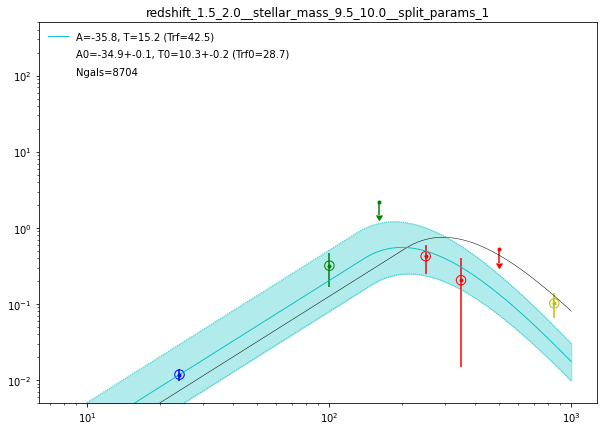

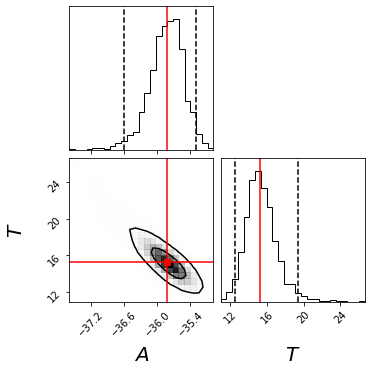

In [30]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

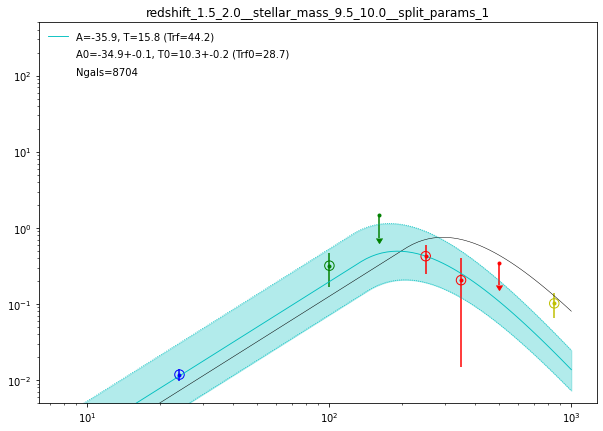

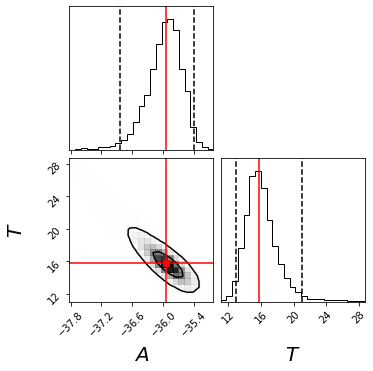

In [50]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

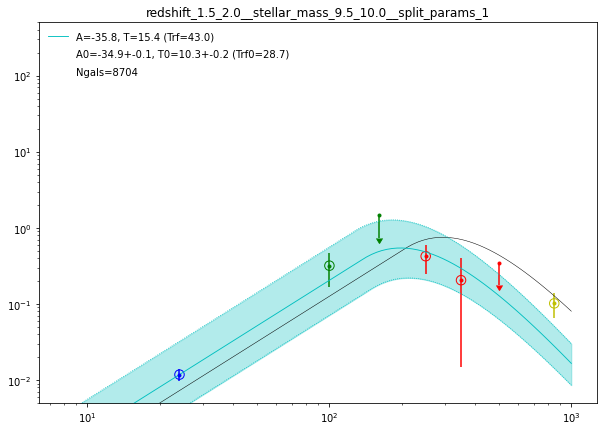

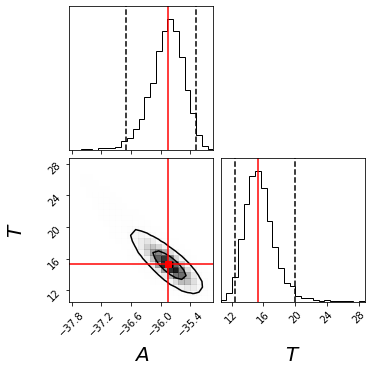

In [33]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

In [34]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_2.0_2.5__stellar_mass_11.0_12.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=3000, mcmc_discard=700)

A0=-34.4+-0.038, T0=14.9+-0.354
Aw=-34.4+-0.172, Tw=14.9+-0.354


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:15<00:00, 39.93it/s]


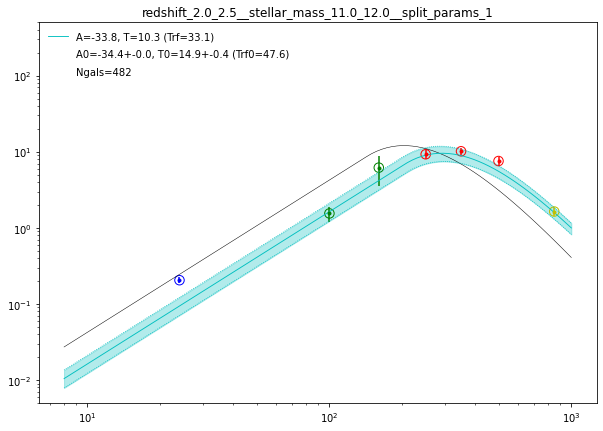

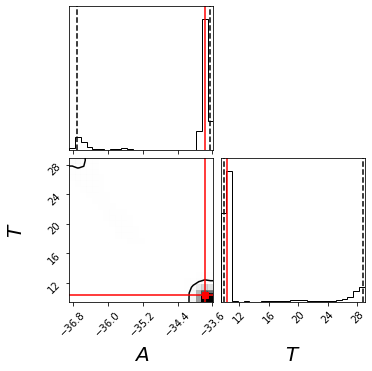

In [35]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in)

## z = 1.5-2

In [36]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_1.5_2.0__stellar_mass_11.0_12.0__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=100)

A0=-34.2+-0.053, T0=13.1+-0.384
Aw=-34.2+-0.171, Tw=13.1+-0.328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.67it/s]


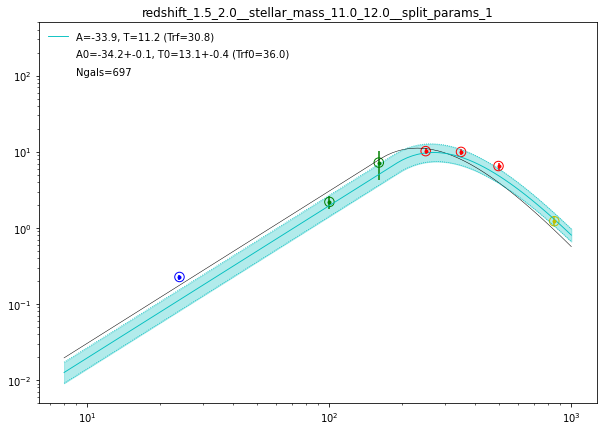

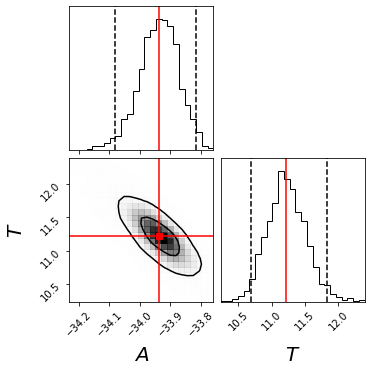

In [37]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in, errors=('16', '84'))

In [31]:
# Identify one bin to test as id_label_in
id_label_in = 'redshift_1.5_2.0__stellar_mass_10.0_10.5__split_params_1'
test_flat_samples, test_theta0 = estimate_mcmc_sed(sed_results_dict, id_label_in, mcmc_iterations=1000, mcmc_discard=200)

A0=-34.5+-0.072, T0=10.9+-0.292
Aw=-34.5+-0.173, Tw=10.9+-0.271
check ll_d and ll_nd: -12135.302739444893 0.0
check ll_d and ll_nd: -60.464371883148175 0.0
check ll_d and ll_nd: -1295.601603233676 0.0
check ll_d and ll_nd: -80.28713785586308 0.0
check ll_d and ll_nd: -145.21105884843024 0.0
check ll_d and ll_nd: -35170.343209109364 0.0
check ll_d and ll_nd: -90.45782190797328 0.0
check ll_d and ll_nd: -117.00348507793407 0.0
check ll_d and ll_nd: -5849.349158629358 0.0
check ll_d and ll_nd: -68.74714255983139 0.0
check ll_d and ll_nd: -69.40586255501464 0.0
check ll_d and ll_nd: -49.67767469086135 0.0
check ll_d and ll_nd: -76.83942271454916 0.0
check ll_d and ll_nd: -125.9836022937956 0.0
check ll_d and ll_nd: -790.6341579501767 0.0
check ll_d and ll_nd: -454.6270940664058 0.0
check ll_d and ll_nd: -142.66333639549967 0.0
check ll_d and ll_nd: -97.10148635402919 0.0
check ll_d and ll_nd: -144.0537260901794 0.0
check ll_d and ll_nd: -6396.08260052214 0.0
check ll_d and ll_nd: -77.02768

  0%|▎                                                                                | 4/1000 [00:00<00:33, 30.08it/s]

check ll_d and ll_nd: -18557.173215753126 0.0
check ll_d and ll_nd: -53588.56729153436 0.0
check ll_d and ll_nd: -102.33965761595539 0.0
check ll_d and ll_nd: -184.70309855971038 0.0
check ll_d and ll_nd: -76.37060335174905 0.0
check ll_d and ll_nd: -123.69997678401941 0.0
check ll_d and ll_nd: -2833.8048288385653 0.0
check ll_d and ll_nd: -142.6142403792152 0.0
check ll_d and ll_nd: -135.30438266898946 0.0
check ll_d and ll_nd: -145.36303928638023 0.0
check ll_d and ll_nd: -55.89688205812534 0.0
check ll_d and ll_nd: -2638.0857817779024 0.0
check ll_d and ll_nd: -14277864.627446206 0.0
check ll_d and ll_nd: -312235.2227474054 0.0
check ll_d and ll_nd: -116.08515598880845 0.0
check ll_d and ll_nd: -63.386903933786584 0.0
check ll_d and ll_nd: -71682856.30781583 0.0
check ll_d and ll_nd: -90.08602320824733 0.0
check ll_d and ll_nd: -1935.7944015176085 0.0
check ll_d and ll_nd: -87.2326034296666 0.0
check ll_d and ll_nd: -132.2560040421719 0.0
check ll_d and ll_nd: -486.3114986602068 0.0

  1%|▋                                                                                | 8/1000 [00:00<00:32, 30.26it/s]

 -135.75099178273652 0.0
check ll_d and ll_nd: -132.68075735476032 0.0
check ll_d and ll_nd: -16064.591780578101 0.0
check ll_d and ll_nd: -86.7839732211514 0.0
check ll_d and ll_nd: -82.53194118297768 0.0
check ll_d and ll_nd: -48.95804059517282 0.0
check ll_d and ll_nd: -95.09403760281103 0.0
check ll_d and ll_nd: -6421.073278502761 0.0
check ll_d and ll_nd: -1049.7846239051464 0.0
check ll_d and ll_nd: -53.543007641380015 0.0
check ll_d and ll_nd: -46.28744420783252 0.0
check ll_d and ll_nd: -46.48781665033516 0.0
check ll_d and ll_nd: -98.12912444352992 0.0
check ll_d and ll_nd: -86.68835792379113 0.0
check ll_d and ll_nd: -57.918549465264405 0.0
check ll_d and ll_nd: -60.03949817162005 0.0
check ll_d and ll_nd: -57.42959861250898 0.0
check ll_d and ll_nd: -43.89540369595272 0.0
check ll_d and ll_nd: -64.70956624632788 0.0
check ll_d and ll_nd: -51.905719003905006 0.0
check ll_d and ll_nd: -89.4418941059597 0.0
check ll_d and ll_nd: -116.17199132548294 0.0
check ll_d and ll_nd: -16

  1%|▉                                                                               | 12/1000 [00:00<00:33, 29.20it/s]

-66.96555176470332 0.0
check ll_d and ll_nd: -70.5712681559389 0.0
check ll_d and ll_nd: -44.11016538151428 0.0
check ll_d and ll_nd: -100.89705221727482 0.0
check ll_d and ll_nd: -54.59341475870666 0.0
check ll_d and ll_nd: -49.38924778668961 0.0
check ll_d and ll_nd: -63.47633111422647 0.0
check ll_d and ll_nd: -78.40110304160757 0.0
check ll_d and ll_nd: -44.427224238640065 0.0
check ll_d and ll_nd: -69.64458340474042 0.0
check ll_d and ll_nd: -90.02948740852148 0.0
check ll_d and ll_nd: -374.99324829726993 0.0
check ll_d and ll_nd: -48.92435789135773 0.0
check ll_d and ll_nd: -48.647443320388305 0.0
check ll_d and ll_nd: -88.84988530306657 0.0
check ll_d and ll_nd: -67.82397992228675 0.0
check ll_d and ll_nd: -44.17596849359033 0.0
check ll_d and ll_nd: -45668.23983706911 0.0
check ll_d and ll_nd: -50.37860669268838 0.0
check ll_d and ll_nd: -44.03648710911389 0.0
check ll_d and ll_nd: -38.07017524762139 0.0
check ll_d and ll_nd: -45.705680682843365 0.0
check ll_d and ll_nd: -121.0

  2%|█▎                                                                              | 16/1000 [00:00<00:32, 30.09it/s]

 -76.11502797537187 0.0
check ll_d and ll_nd: -52.949813419485736 0.0
check ll_d and ll_nd: -37.10053361149937 0.0
check ll_d and ll_nd: -44.59510788652241 0.0
check ll_d and ll_nd: -127.56488648299131 0.0
check ll_d and ll_nd: -45.57191780302381 0.0
check ll_d and ll_nd: -49.19097147474679 0.0
check ll_d and ll_nd: -568.4524196110677 0.0
check ll_d and ll_nd: -42.88961630047635 0.0
check ll_d and ll_nd: -39.55712768229603 0.0
check ll_d and ll_nd: -75.07270726939382 0.0
check ll_d and ll_nd: -64.90272455429684 0.0
check ll_d and ll_nd: -30.816429898401395 0.0
check ll_d and ll_nd: -103.66075702497707 0.0
check ll_d and ll_nd: -136.1362030206848 0.0
check ll_d and ll_nd: -43.49274677065563 0.0
check ll_d and ll_nd:

  2%|█▌                                                                              | 20/1000 [00:00<00:33, 29.29it/s]

 -61.21452563432781 0.0
check ll_d and ll_nd: -49.750009116297036 0.0
check ll_d and ll_nd: -48.96375862979812 0.0
check ll_d and ll_nd: -48.18865708106402 0.0
check ll_d and ll_nd: -46.67421042928633 0.0
check ll_d and ll_nd: -42.34973231983108 0.0
check ll_d and ll_nd: -43.1841581221703 0.0
check ll_d and ll_nd: -44.151992565537924 0.0
check ll_d and ll_nd: -43.83181558212058 0.0
check ll_d and ll_nd: -49.229725251018635 0.0
check ll_d and ll_nd: -215.53892815084447 0.0
check ll_d and ll_nd: -61.25350902056478 0.0
check ll_d and ll_nd: -44.027082170123705 0.0
check ll_d and ll_nd: -47.42009976740431 0.0
check ll_d and ll_nd: -54.30917693307474 0.0
check ll_d and ll_nd: -393.9063198979785 0.0
check ll_d and ll_nd: -50.83324244734098 0.0
check ll_d and ll_nd: -35.61241336119225 0.0
check ll_d and ll_nd: -43.9867340761124 0.0
check ll_d and ll_nd: -44.98730800817535 0.0
check ll_d and ll_nd: -48.98536980945488 0.0
check ll_d and ll_nd: -52.964589722731446 0.0
check ll_d and ll_nd: -41.1

  3%|██                                                                              | 26/1000 [00:00<00:34, 28.54it/s]

 -45.637924543016666 0.0
check ll_d and ll_nd: -38.281171062353266 0.0
check ll_d and ll_nd: -46.65095120858652 0.0
check ll_d and ll_nd: -80.51403997987521 0.0
check ll_d and ll_nd: -42.49607323154794 0.0
check ll_d and ll_nd: -43.06126800685436 0.0
check ll_d and ll_nd: -42.089927937836435 0.0
check ll_d and ll_nd: -36.37517182984169 0.0
check ll_d and ll_nd: -38.98251000300739 0.0
check ll_d and ll_nd: -40.947330763132996 0.0
check ll_d and ll_nd: -34.44014804717 0.0
check ll_d and ll_nd: -47.77981638784735 0.0
check ll_d and ll_nd: -44.45644512511325 0.0
check ll_d and ll_nd: -29.393445244133915 0.0
check ll_d and ll_nd: -45.2156618249187 0.0
check ll_d and ll_nd: -38.69977646310055 0.0
check ll_d and ll_nd: -42.70871819513107 0.0
check ll_d and ll_nd: -53.18073316481399 0.0
check ll_d and ll_nd: -34.81063717556961 0.0
check ll_d and ll_nd: -44.77060295624767 0.0
check ll_d and ll_nd: -48.00554937391479 0.0
check ll_d and ll_nd: -40.863491679162564 0.0
check ll_d and ll_nd: -42.111

  3%|██▎                                                                             | 29/1000 [00:01<00:34, 27.93it/s]

check ll_d and ll_nd: -47.42839820610169 0.0
check ll_d and ll_nd: -29.82397751151055 0.0
check ll_d and ll_nd: -1.4275556778485594 0.0
check ll_d and ll_nd: -44.634652759748036 0.0
check ll_d and ll_nd: -34.0471052600313 0.0
check ll_d and ll_nd: -23.83885929876095 0.0
check ll_d and ll_nd: -40.094148745452046 0.0
check ll_d and ll_nd: -46.32202838770402 0.0
check ll_d and ll_nd: -37.53191518566631 0.0
check ll_d and ll_nd: -32.36062349255792 0.0
check ll_d and ll_nd: -42.39030117735322 0.0
check ll_d and ll_nd: -39.674141863935375 0.0
check ll_d and ll_nd: -42.63074624268356 0.0
check ll_d and ll_nd: -35.83189086563061 0.0
check ll_d and ll_nd: -39.851820152686685 0.0
check ll_d and ll_nd: -37.141324661189145 0.0
check ll_d and ll_nd: -51.18983624883231 0.0
check ll_d and ll_nd: -27.95053043180374 0.0
check ll_d and ll_nd: -55.549852701787984 0.0
check ll_d and ll_nd: -36.74036839524911 0.0
check ll_d and ll_nd: -33.850264649479215 0.0
check ll_d and ll_nd: -25.832625658819524 0.0
ch

  3%|██▌                                                                             | 32/1000 [00:01<00:34, 28.09it/s]

 -33.398793932539576 0.0
check ll_d and ll_nd: -37.3279309558271 0.0
check ll_d and ll_nd: 14.390449357547524 0.0
check ll_d and ll_nd: -38.662530412501184 0.0
check ll_d and ll_nd: -53.8275884894653 0.0
check ll_d and ll_nd: -45.983993861595266 0.0
check ll_d and ll_nd: -129.46038890179221 0.0
check ll_d and ll_nd: -92.60022243465119 0.0
check ll_d and ll_nd: -37.61621191842406 0.0
check ll_d and ll_nd: -21.713653693335957 0.0
check ll_d and ll_nd: -21.076647717411845 0.0
check ll_d and ll_nd: -17.913136684187208 0.0
check ll_d and ll_nd: -40.9447892460131 0.0
check ll_d and ll_nd: -59.16933884458115 0.0
check ll_d and ll_nd: -240.8817206607248 0.0
check ll_d and ll_nd: -118.16543870829943 0.0
check ll_d and ll_nd: -36.8601757720709 0.0
check ll_d and ll_nd: -11.628685517824707 0.0
check ll_d and ll_nd: 35.198515748999334 0.0
check ll_d and ll_nd: -41.22690592169441 0.0
check ll_d and ll_nd: -11.006379453132965 0.0
check ll_d and ll_nd: -41.91592655420857 0.0
check ll_d and ll_nd: -33

  4%|██▊                                                                             | 35/1000 [00:01<00:37, 25.60it/s]

 -36.73759584774524 0.0
check ll_d and ll_nd: -29.612460773264587 0.0
check ll_d and ll_nd: -73.81875023910192 0.0
check ll_d and ll_nd: -38.030998906421615 0.0
check ll_d and ll_nd: -12.472941713501612 0.0
check ll_d and ll_nd: -63.03013885735717 0.0
check ll_d and ll_nd: 28.236193559734126 0.0
check ll_d and ll_nd: -34.554528838862964 0.0
check ll_d and ll_nd: -44.764214471650945 0.0
check ll_d and ll_nd: -60.216834841411796 0.0
check ll_d and ll_nd: -7.187536447208785 0.0
check ll_d and ll_nd: -32.013973563278824 0.0
check ll_d and ll_nd: -112.35302850416176 0.0
check ll_d and ll_nd: -36.00868310405794 0.0
check ll_d and ll_nd: -30.842411359940513 0.0
check ll_d and ll_nd: -8.919543233633007 0.0
check ll_d and ll_nd: -27.602622214707964 0.0
check ll_d and ll_nd: -6.296148093988677 0.0
check ll_d and ll_nd: -1.4264892787730759 0.0
check ll_d and ll_nd: -46.103444417402955 0.0
check ll_d and ll_nd: -24.95061993862636 0.0
check ll_d and ll_nd: -21.62232162531612 0.0
check ll_d and ll_n

  4%|███▎                                                                            | 41/1000 [00:01<00:35, 27.03it/s]

 -16.97660073549271 0.0
check ll_d and ll_nd: -1.6131797665306777 0.0
check ll_d and ll_nd: 14.201165126221468 0.0
check ll_d and ll_nd: 34.749548756273576 0.0
check ll_d and ll_nd: -32.9986768455352 0.0
check ll_d and ll_nd: -6.5124790932107715 0.0
check ll_d and ll_nd: -24.65788796693711 0.0
check ll_d and ll_nd: -78.70236459646134 0.0
check ll_d and ll_nd: -30.924189956427185 0.0
check ll_d and ll_nd: -6.679184519270422 0.0
check ll_d and ll_nd: -33.82364249235056 0.0
check ll_d and ll_nd: -18.070628301007062 0.0
check ll_d and ll_nd: -31.189122740726674 0.0
check ll_d and ll_nd: -19.853540880980432 0.0
check ll_d and ll_nd: -38.7791988075756 0.0
check ll_d and ll_nd: -2.524143611846327 0.0
check ll_d and ll_nd: -76.44503513198882 0.0
check ll_d and ll_nd: 8.144603163192293 0.0
check ll_d and ll_nd: -16.84192967843859 0.0
check ll_d and ll_nd: 35.37621471347941 0.0
check ll_d and ll_nd: -23.538387350554288 0.0
check ll_d and ll_nd: -18.081340368863977 0.0
check ll_d and ll_nd: -4.10

  4%|███▌                                                                            | 44/1000 [00:01<00:35, 27.18it/s]

 -18.87068056805026 0.0
check ll_d and ll_nd: -9.6280939973512 0.0
check ll_d and ll_nd: 9.12778715080401 0.0
check ll_d and ll_nd: 10.600876848217133 0.0
check ll_d and ll_nd: 3.0458587149972374 0.0
check ll_d and ll_nd: -57.435883063118226 0.0
check ll_d and ll_nd: 4.134756647586272 0.0
check ll_d and ll_nd: -36.45964275536258 0.0
check ll_d and ll_nd: 23.653312653512067 0.0
check ll_d and ll_nd: -29.431307157123825 0.0
check ll_d and ll_nd: 35.39882026631542 0.0
check ll_d and ll_nd: 31.048791779220892 0.0
check ll_d and ll_nd: -14.23175939113574 0.0
check ll_d and ll_nd: -10.463392536358896 0.0
check ll_d and ll_nd: -20.32698760055895 0.0
check ll_d and ll_nd: 20.33132978562366 0.0
check ll_d and ll_nd: -27.874827296965293 0.0
check ll_d and ll_nd: -9.249605187253252 0.0
check ll_d and ll_nd: -12.89203133005337 0.0
check ll_d and ll_nd: 2.234786503153302 0.0
check ll_d and ll_nd: -69.13991191579603 0.0
check ll_d and ll_nd: 14.671628574720856 0.0
check ll_d and ll_nd: -24.419952107

  5%|███▊                                                                            | 47/1000 [00:01<00:34, 27.50it/s]

 21.83419444213608 0.0
check ll_d and ll_nd: -14.819298885559732 0.0
check ll_d and ll_nd: 12.139344029516934 0.0
check ll_d and ll_nd: 20.689987686887463 0.0
check ll_d and ll_nd: -5.837040895352715 0.0
check ll_d and ll_nd: -6.149863881407725 0.0
check ll_d and ll_nd: -8.553383932713146 0.0
check ll_d and ll_nd: 13.784139136050634 0.0
check ll_d and ll_nd: 31.126079310205135 0.0
check ll_d and ll_nd: 3.063303283256417 0.0
check ll_d and ll_nd: 7.072928200141398 0.0
check ll_d and ll_nd: 6.584661226933015 0.0
check ll_d and ll_nd: 16.292102454224874 0.0
check ll_d and ll_nd: 8.776852257163526 0.0
check ll_d and ll_nd: 2.608811745634391 0.0
check ll_d and ll_nd: 18.46262243243242 0.0
check ll_d and ll_nd: -11.394086090679963 0.0
check ll_d and ll_nd: 9.863649353716887 0.0
check ll_d and ll_nd: 19.186420784649222 0.0
check ll_d and ll_nd: 5.639807983539541 0.0
check ll_d and ll_nd: 19.974267956145326 0.0
check ll_d and ll_nd: -19.87761773470355 0.0
check ll_d and ll_nd: 24.3335052753304

  5%|████                                                                            | 50/1000 [00:01<00:33, 28.13it/s]

 2.7752267309700542 0.0
check ll_d and ll_nd: 17.57326634040964 0.0
check ll_d and ll_nd: 11.282731755813721 0.0
check ll_d and ll_nd: 35.89826790726577 0.0
check ll_d and ll_nd: -6.154746324619296 0.0
check ll_d and ll_nd: 9.510963213962185 0.0
check ll_d and ll_nd: 21.724671301584962 0.0
check ll_d and ll_nd: 7.956329180220138 0.0
check ll_d and ll_nd: 27.74187531764047 0.0
check ll_d and ll_nd: 9.90418489904446 0.0
check ll_d and ll_nd: -7.868067871075212 0.0
check ll_d and ll_nd: 13.168631161629392 0.0
check ll_d and ll_nd: -2.7300170246353446 0.0
check ll_d and ll_nd: 28.717531682792462 0.0
check ll_d and ll_nd: 22.457464673170648 0.0
check ll_d and ll_nd: -25.749324752213397 0.0
check ll_d and ll_nd: 22.439509608343798 0.0
check ll_d and ll_nd: -25.349636981314745 0.0
check ll_d and ll_nd: -7.74773033760215 0.0
check ll_d and ll_nd: 14.976648151458136 0.0
check ll_d and ll_nd: 33.98111190857031 0.0
check ll_d and ll_nd: -4.174703599763731 0.0
check ll_d and ll_nd: 7.4938734455052

  5%|████▎                                                                           | 54/1000 [00:01<00:32, 29.27it/s]

 25.079275852598172 0.0
check ll_d and ll_nd: 23.983928784368423 0.0
check ll_d and ll_nd: 29.404604693616 0.0
check ll_d and ll_nd: 23.165246523315894 0.0
check ll_d and ll_nd: 35.286870089598416 0.0
check ll_d and ll_nd: -6.521364550692908 0.0
check ll_d and ll_nd: 22.511091013586622 0.0
check ll_d and ll_nd: 33.97754040495777 0.0
check ll_d and ll_nd: 15.309934138344126 0.0
check ll_d and ll_nd: -15.53848766330178 0.0
check ll_d and ll_nd: 20.576224500390595 0.0
check ll_d and ll_nd: -17.484667392965648 0.0
check ll_d and ll_nd: -1.7965643707841679 0.0
check ll_d and ll_nd: 17.258052393705498 0.0
check ll_d and ll_nd: 25.189007578447693 0.0
check ll_d and ll_nd: 2.8863186663578517 0.0
check ll_d and ll_nd: -11.846530384409377 0.0
check ll_d and ll_nd: 26.711220215750572 0.0
check ll_d and ll_nd: 19.648604695318546 0.0
check ll_d and ll_nd: 33.91951600639311 0.0
check ll_d and ll_nd: -15.120245007645124 0.0
check ll_d and ll_nd: 1.2187939786526698 0.0
check ll_d and ll_nd: 23.6761180

  6%|████▋                                                                           | 58/1000 [00:02<00:32, 29.38it/s]

 17.42397201557803 0.0
check ll_d and ll_nd: 29.080671978623272 0.0
check ll_d and ll_nd: 21.707028304763426 0.0
check ll_d and ll_nd: 17.851169419942785 0.0
check ll_d and ll_nd: 26.897658288333744 0.0
check ll_d and ll_nd: 17.468795024746115 0.0
check ll_d and ll_nd: 18.738482502147676 0.0
check ll_d and ll_nd: 13.78506700875046 0.0
check ll_d and ll_nd: 24.050096595563517 0.0
check ll_d and ll_nd: 32.57358091136226 0.0
check ll_d and ll_nd: 26.446814302729166 0.0
check ll_d and ll_nd: -18.364916594606598 0.0
check ll_d and ll_nd: 28.318880894190713 0.0
check ll_d and ll_nd: 26.592684284764758 0.0
check ll_d and ll_nd: 34.30427010485863 0.0
check ll_d and ll_nd: 15.549762178176522 0.0
check ll_d and ll_nd: 25.239305950614295 0.0
check ll_d and ll_nd: 22.717531035801215 0.0
check ll_d and ll_nd: 23.759310388242 0.0
check ll_d and ll_nd: 11.029309007199302 0.0
check ll_d and ll_nd: 16.243788847894123 0.0
check ll_d and ll_nd: 3.6023138325792274 0.0
check ll_d and ll_nd: 13.637988963977

  6%|████▉                                                                           | 62/1000 [00:02<00:31, 29.75it/s]

 13.04156431931731 0.0
check ll_d and ll_nd: 26.758330458265114 0.0
check ll_d and ll_nd: 31.98608589729176 0.0
check ll_d and ll_nd: 18.234315435343774 0.0
check ll_d and ll_nd: 26.57454867999691 0.0
check ll_d and ll_nd: 35.291325342534314 0.0
check ll_d and ll_nd: 26.011451899405195 0.0
check ll_d and ll_nd: -0.9838143131177759 0.0
check ll_d and ll_nd: 30.157057119561493 0.0
check ll_d and ll_nd: -24.307589700311766 0.0
check ll_d and ll_nd: -20.993906368051057 0.0
check ll_d and ll_nd: 23.159271086956586 0.0
check ll_d and ll_nd: 17.318874462300244 0.0
check ll_d and ll_nd: 30.0555448127284 0.0
check ll_d and ll_nd: 32.57174057663893 0.0
check ll_d and ll_nd: 21.408933524328198 0.0
check ll_d and ll_nd: -8.748639404698167 0.0
check ll_d and ll_nd: 35.54067202635229 0.0
check ll_d and ll_nd: 15.276513453896243 0.0
check ll_d and ll_nd: 11.64742945366666 0.0
check ll_d and ll_nd: 24.665395528283696 0.0
check ll_d and ll_nd: 32.02715868265739 0.0
check ll_d and ll_nd: 9.8868046663685

  7%|█████▍                                                                          | 68/1000 [00:02<00:32, 28.63it/s]

 11.347322291525117 0.0
check ll_d and ll_nd: 35.80916904253874 0.0
check ll_d and ll_nd: 13.990634522155979 0.0
check ll_d and ll_nd: 27.12242963902502 0.0
check ll_d and ll_nd: 34.70797454527905 0.0
check ll_d and ll_nd: 28.45688730694824 0.0
check ll_d and ll_nd: 31.779429278052724 0.0
check ll_d and ll_nd: 28.441464828463623 0.0
check ll_d and ll_nd: 35.09819111258623 0.0
check ll_d and ll_nd: 32.29689350078423 0.0
check ll_d and ll_nd: -6.646331260503004 0.0
check ll_d and ll_nd: 25.354256020575576 0.0
check ll_d and ll_nd: 28.084484591577784 0.0
check ll_d and ll_nd: 27.76552651527711 0.0
check ll_d and ll_nd: 22.313464832059573 0.0
check ll_d and ll_nd: 28.149072981926345 0.0
check ll_d and ll_nd: 33.765661306686745 0.0
check ll_d and ll_nd: 23.75853604149289 0.0
check ll_d and ll_nd: 33.14367107615989 0.0
check ll_d and ll_nd: 31.93352498953012 0.0
check ll_d and ll_nd: 34.70187544837587 0.0
check ll_d and ll_nd: 31.423405591740625 0.0
check ll_d and ll_nd: 3.3353793288689673 0

  7%|█████▋                                                                          | 71/1000 [00:02<00:32, 29.00it/s]

 21.707791950326765 0.0
check ll_d and ll_nd: 32.8324384433422 0.0
check ll_d and ll_nd: 35.90963366186018 0.0
check ll_d and ll_nd: 33.064472683142185 0.0
check ll_d and ll_nd: 32.261199696993934 0.0
check ll_d and ll_nd: 33.89788163332644 0.0
check ll_d and ll_nd: 27.52217055253798 0.0
check ll_d and ll_nd: 27.52766883807641 0.0
check ll_d and ll_nd: 34.131453370197576 0.0
check ll_d and ll_nd: 25.25556143803719 0.0
check ll_d and ll_nd: 31.536427831837642 0.0
check ll_d and ll_nd: 34.652424971545564 0.0
check ll_d and ll_nd: 24.905997281703307 0.0
check ll_d and ll_nd: 10.53300957160085 0.0
check ll_d and ll_nd: 34.25446229963959 0.0
check ll_d and ll_nd: 31.207020649273552 0.0
check ll_d and ll_nd: 33.601120337924044 0.0
check ll_d and ll_nd: 32.69401644967502 0.0
check ll_d and ll_nd: 32.39743517753462 0.0
check ll_d and ll_nd: 26.576777949956906 0.0
check ll_d and ll_nd: 32.336129431294886 0.0
check ll_d and ll_nd: 14.466146144022268 0.0
check ll_d and ll_nd: 28.00932492093385 0.

  7%|█████▉                                                                          | 74/1000 [00:02<00:32, 28.49it/s]

 24.515329478583816 0.0
check ll_d and ll_nd: 31.285963537360757 0.0
check ll_d and ll_nd: 24.31340647570463 0.0
check ll_d and ll_nd: 28.526631910655553 0.0
check ll_d and ll_nd: 33.76923496224572 0.0
check ll_d and ll_nd: 32.36227553345536 0.0
check ll_d and ll_nd: 35.92393514802685 0.0
check ll_d and ll_nd: 35.03121338344227 0.0
check ll_d and ll_nd: 26.898320728220433 0.0
check ll_d and ll_nd: 33.454684219815675 0.0
check ll_d and ll_nd: 35.05862213928927 0.0
check ll_d and ll_nd: 30.391737718402396 0.0
check ll_d and ll_nd: 33.506945766442485 0.0
check ll_d and ll_nd: 21.72428639085443 0.0
check ll_d and ll_nd: 31.258695182354003 0.0
check ll_d and ll_nd: 34.77185230072021 0.0
check ll_d and ll_nd: 31.964155778013087 0.0
check ll_d and ll_nd: 36.036060150815935 0.0
check ll_d and ll_nd: 23.48014953275038 0.0
check ll_d and ll_nd: 29.330939402287342 0.0
check ll_d and ll_nd: 34.1131239859499 0.0
check ll_d and ll_nd: 32.76351870923939 0.0
check ll_d and ll_nd: 19.086399518103292 0.

  8%|██████▏                                                                         | 77/1000 [00:02<00:31, 28.88it/s]

 26.664312600305138 0.0
check ll_d and ll_nd: 35.900763333612886 0.0
check ll_d and ll_nd: 35.70394009048773 0.0
check ll_d and ll_nd: 35.61363986332322 0.0
check ll_d and ll_nd: 35.290024592888166 0.0
check ll_d and ll_nd: 35.56880501803103 0.0
check ll_d and ll_nd: 35.86231444819012 0.0
check ll_d and ll_nd: 33.841755770379045 0.0
check ll_d and ll_nd: 25.58828588607969 0.0
check ll_d and ll_nd: 32.48803740103311 0.0
check ll_d and ll_nd: 35.165185793110034 0.0
check ll_d and ll_nd: 33.22063927657863 0.0
check ll_d and ll_nd: 28.95922680418682 0.0
check ll_d and ll_nd: 35.24841523327205 0.0
check ll_d and ll_nd: 30.638350628927142 0.0
check ll_d and ll_nd: 34.51258968899691 0.0
check ll_d and ll_nd: 27.703099723151816 0.0
check ll_d and ll_nd: 35.66382328767723 0.0
check ll_d and ll_nd: 32.78630975836381 0.0
check ll_d and ll_nd: 25.73211441681977 0.0
check ll_d and ll_nd: 35.975665979295634 0.0
check ll_d and ll_nd: 35.390849207507266 0.0
check ll_d and ll_nd: 34.10042284838269 0.0


  8%|██████▍                                                                         | 80/1000 [00:02<00:31, 28.98it/s]

 35.5697423303578 0.0
check ll_d and ll_nd: 22.39261107838702 0.0
check ll_d and ll_nd: 34.1232693120751 0.0
check ll_d and ll_nd: 29.786045911803633 0.0
check ll_d and ll_nd: 34.858645392055095 0.0
check ll_d and ll_nd: 35.72602369438188 0.0
check ll_d and ll_nd: 33.50263771740715 0.0
check ll_d and ll_nd: 29.17952908252326 0.0
check ll_d and ll_nd: 22.100562349708753 0.0
check ll_d and ll_nd: 34.94960474793393 0.0
check ll_d and ll_nd: 34.91907317385567 0.0
check ll_d and ll_nd: 33.01969642690161 0.0
check ll_d and ll_nd: 32.7427317645427 0.0
check ll_d and ll_nd: 35.862290976247436 0.0
check ll_d and ll_nd: 25.06325837308472 0.0
check ll_d and ll_nd: 34.10804636932029 0.0
check ll_d and ll_nd: 27.30109473022503 0.0
check ll_d and ll_nd: 35.814654991461225 0.0
check ll_d and ll_nd: 34.93395451850618 0.0
check ll_d and ll_nd: 32.36089080151092 0.0
check ll_d and ll_nd: 35.42931863184851 0.0
check ll_d and ll_nd: 34.345116208245386 0.0
check ll_d and ll_nd: 35.55219677613582 0.0
check 

  8%|██████▋                                                                         | 83/1000 [00:02<00:32, 28.38it/s]

 34.39552351315777 0.0
check ll_d and ll_nd: 35.835318489684965 0.0
check ll_d and ll_nd: 35.733225281066325 0.0
check ll_d and ll_nd: 34.37870515830318 0.0
check ll_d and ll_nd: 30.514085041754882 0.0
check ll_d and ll_nd: 35.13654891542069 0.0
check ll_d and ll_nd: 32.84566540530482 0.0
check ll_d and ll_nd: 33.07584150251295 0.0
check ll_d and ll_nd: 33.686031549740655 0.0
check ll_d and ll_nd: 34.41679568426668 0.0
check ll_d and ll_nd: 34.72407376960096 0.0
check ll_d and ll_nd: 33.121744829134464 0.0
check ll_d and ll_nd: 31.110562483375396 0.0
check ll_d and ll_nd: 33.37729844113485 0.0
check ll_d and ll_nd: 34.62913615812038 0.0
check ll_d and ll_nd: 35.278184752190974 0.0
check ll_d and ll_nd: 29.280071473526696 0.0
check ll_d and ll_nd: 33.45540588688341 0.0
check ll_d and ll_nd: 35.853974123679464 0.0
check ll_d and ll_nd: 25.758337046012386 0.0
check ll_d and ll_nd: 34.024519879890974 0.0
check ll_d and ll_nd: 35.039833556380046 0.0
check ll_d and ll_nd: 23.16566132052607 0

  9%|██████▉                                                                         | 86/1000 [00:03<00:34, 26.36it/s]

 35.78519716164235 0.0
check ll_d and ll_nd: 26.22967409963612 0.0
check ll_d and ll_nd: 31.471848977212588 0.0
check ll_d and ll_nd: 35.2150545716115 0.0
check ll_d and ll_nd: 33.815793111991255 0.0
check ll_d and ll_nd: 35.90857690677399 0.0
check ll_d and ll_nd: 35.86917537621265 0.0
check ll_d and ll_nd: 29.810141059941884 0.0
check ll_d and ll_nd: 35.0758119989804 0.0
check ll_d and ll_nd: 34.22116823937476 0.0
check ll_d and ll_nd: 35.36218033635268 0.0
check ll_d and ll_nd: 34.61681841177623 0.0
check ll_d and ll_nd: 35.927330853736024 0.0
check ll_d and ll_nd: 34.17032292059775 0.0
check ll_d and ll_nd: 33.512566975487005 0.0
check ll_d and ll_nd: 35.54414899117609 0.0
check ll_d and ll_nd: 33.89897675828039 0.0
check ll_d and ll_nd: 35.46857382235757 0.0
check ll_d and ll_nd: 34.12642946541162 0.0
check ll_d and ll_nd: 34.33275758024555 0.0
check ll_d and ll_nd: 35.55311496495522 0.0
check ll_d and ll_nd: 35.437081626044126 0.0
check ll_d and ll_nd: 35.070605375336 0.0
check l

  9%|███████                                                                         | 89/1000 [00:03<00:34, 26.62it/s]

 35.43968821910246 0.0
check ll_d and ll_nd: 34.131218010411544 0.0
check ll_d and ll_nd: 33.634867308549985 0.0
check ll_d and ll_nd: 34.82122548713239 0.0
check ll_d and ll_nd: 34.51609589461543 0.0
check ll_d and ll_nd: 34.19089364126533 0.0
check ll_d and ll_nd: 34.77202021005975 0.0
check ll_d and ll_nd: 33.7530630041498 0.0
check ll_d and ll_nd: 35.95105223779366 0.0
check ll_d and ll_nd: 34.279568638977146 0.0
check ll_d and ll_nd: 35.868945851865135 0.0
check ll_d and ll_nd: 35.44398188729905 0.0
check ll_d and ll_nd: 32.39424818084372 0.0
check ll_d and ll_nd: 35.82363546740885 0.0
check ll_d and ll_nd: 33.99795449233558 0.0
check ll_d and ll_nd: 36.01549936187577 0.0
check ll_d and ll_nd: 35.545458589768906 0.0
check ll_d and ll_nd: 33.48637292578573 0.0
check ll_d and ll_nd: 35.25886264444457 0.0
check ll_d and ll_nd: 33.21238077120065 0.0
check ll_d and ll_nd: 32.25997133340258 0.0
check ll_d and ll_nd: 33.327412426116496 0.0
check ll_d and ll_nd: 32.976791910744 0.0
check 

  9%|███████▎                                                                        | 92/1000 [00:03<00:34, 26.54it/s]

 34.62892514746484 0.0
check ll_d and ll_nd: 33.338756652340905 0.0
check ll_d and ll_nd: 34.88189408157409 0.0
check ll_d and ll_nd: 35.926424952898465 0.0
check ll_d and ll_nd: 35.36744999434561 0.0
check ll_d and ll_nd: 33.064518157951106 0.0
check ll_d and ll_nd: 35.646060481042525 0.0
check ll_d and ll_nd: 34.70388166299398 0.0
check ll_d and ll_nd: 35.583130334029136 0.0
check ll_d and ll_nd: 32.304768189676714 0.0
check ll_d and ll_nd: 34.36789885080375 0.0
check ll_d and ll_nd: 35.287948070634975 0.0
check ll_d and ll_nd: 35.46613894266058 0.0
check ll_d and ll_nd: 34.93220275524578 0.0
check ll_d and ll_nd: 35.61196450834429 0.0
check ll_d and ll_nd: 33.3843799674865 0.0
check ll_d and ll_nd: 33.17973861556906 0.0
check ll_d and ll_nd: 33.75209840000518 0.0
check ll_d and ll_nd: 34.698539564946365 0.0
check ll_d and ll_nd: 35.13599320467793 0.0
check ll_d and ll_nd: 34.926868228047596 0.0
check ll_d and ll_nd: 35.636869646876086 0.0
check ll_d and ll_nd: 31.117461240585733 0.0

 10%|███████▌                                                                        | 95/1000 [00:03<00:33, 26.64it/s]

 35.564981575361365 0.0
check ll_d and ll_nd: 36.05559626915233 0.0
check ll_d and ll_nd: 35.08709504797255 0.0
check ll_d and ll_nd: 35.47016857068776 0.0
check ll_d and ll_nd: 35.915507181973666 0.0
check ll_d and ll_nd: 34.22449907623239 0.0
check ll_d and ll_nd: 35.551282092251355 0.0
check ll_d and ll_nd: 35.55426874558113 0.0
check ll_d and ll_nd: 19.865379637041677 0.0
check ll_d and ll_nd: 34.55953051381868 0.0
check ll_d and ll_nd: 35.32764146242326 0.0
check ll_d and ll_nd: 26.639879002760168 0.0
check ll_d and ll_nd: 33.12265484011318 0.0
check ll_d and ll_nd: 21.81993830734281 0.0
check ll_d and ll_nd: 33.97722048477807 0.0
check ll_d and ll_nd: 30.676052002463933 0.0
check ll_d and ll_nd: 35.416147298669124 0.0
check ll_d and ll_nd: 36.05647599957322 0.0
check ll_d and ll_nd: 32.96303550512384 0.0
check ll_d and ll_nd: 35.40872536568064 0.0
check ll_d and ll_nd: 35.18245860309341 0.0
check ll_d and ll_nd: 35.25537545196816 0.0
check ll_d and ll_nd: 32.21378101827473 0.0
ch

 10%|███████▊                                                                        | 98/1000 [00:03<00:33, 26.96it/s]

check ll_d and ll_nd: 34.164293320255126 0.0
check ll_d and ll_nd: 34.871704693380984 0.0
check ll_d and ll_nd: 35.81122405181176 0.0
check ll_d and ll_nd: 28.28664966819302 0.0
check ll_d and ll_nd: 36.011112276450675 0.0
check ll_d and ll_nd: 26.700248379597184 0.0
check ll_d and ll_nd: 30.41862094644239 0.0
check ll_d and ll_nd: 36.0559113399635 0.0
check ll_d and ll_nd: 35.479948667410284 0.0
check ll_d and ll_nd: 35.97777982115387 0.0
check ll_d and ll_nd: 35.55131876326929 0.0
check ll_d and ll_nd: 35.737413611032366 0.0
check ll_d and ll_nd: 34.116728379006226 0.0
check ll_d and ll_nd: 31.10773259274852 0.0
check ll_d and ll_nd: 35.586499664639305 0.0
check ll_d and ll_nd: 33.870693221783284 0.0
check ll_d and ll_nd: 35.44190412814652 0.0
check ll_d and ll_nd: 35.60534369892843 0.0
check ll_d and ll_nd: 34.32214148454263 0.0
check ll_d and ll_nd: 30.19253624415785 0.0
check ll_d and ll_nd: 34.26673393888586 0.0
check ll_d and ll_nd: 32.38256333534996 0.0
check ll_d and ll_nd: 35

 10%|████████                                                                       | 102/1000 [00:03<00:31, 28.92it/s]

 35.081301810820385 0.0
check ll_d and ll_nd: 29.767535752749453 0.0
check ll_d and ll_nd: 35.17707360726421 0.0
check ll_d and ll_nd: 33.74152387083919 0.0
check ll_d and ll_nd: 34.38889250601656 0.0
check ll_d and ll_nd: 22.145163903852755 0.0
check ll_d and ll_nd: 34.65590477615675 0.0
check ll_d and ll_nd: 29.484416089078827 0.0
check ll_d and ll_nd: 35.689381128717464 0.0
check ll_d and ll_nd: 34.414329514282215 0.0
check ll_d and ll_nd: 34.887812399753216 0.0
check ll_d and ll_nd: 29.463273389935395 0.0
check ll_d and ll_nd: 35.16037771812846 0.0
check ll_d and ll_nd: 33.652609736285825 0.0
check ll_d and ll_nd: 34.37618660027703 0.0
check ll_d and ll_nd: 35.8293113978632 0.0
check ll_d and ll_nd: 35.3492964783593 0.0
check ll_d and ll_nd: 33.781101818085375 0.0
check ll_d and ll_nd: 30.6844876257002 0.0
check ll_d and ll_nd: 35.501388277533316 0.0
check ll_d and ll_nd: 35.84499585943634 0.0
check ll_d and ll_nd: 34.056307901913094 0.0
check ll_d and ll_nd: 34.985113422921415 0.0

 11%|████████▎                                                                      | 106/1000 [00:03<00:29, 29.87it/s]

 31.82364557738329 0.0
check ll_d and ll_nd: 35.534488048832486 0.0
check ll_d and ll_nd: 33.83025305416134 0.0
check ll_d and ll_nd: 35.96580640456884 0.0
check ll_d and ll_nd: 34.63769459749839 0.0
check ll_d and ll_nd: 36.058495923518514 0.0
check ll_d and ll_nd: 33.62936860566068 0.0
check ll_d and ll_nd: 35.182694503873876 0.0
check ll_d and ll_nd: 35.866011251161616 0.0
check ll_d and ll_nd: 35.77802321821208 0.0
check ll_d and ll_nd: 34.486931701577625 0.0
check ll_d and ll_nd: 31.212964871720573 0.0
check ll_d and ll_nd: 33.50258908544632 0.0
check ll_d and ll_nd: 33.16926801192703 0.0
check ll_d and ll_nd: 34.69266731498058 0.0
check ll_d and ll_nd: 35.66507121013456 0.0
check ll_d and ll_nd: 35.437054925318265 0.0
check ll_d and ll_nd: 32.19942483166019 0.0
check ll_d and ll_nd: 31.496550334266317 0.0
check ll_d and ll_nd: 26.7208449453966 0.0
check ll_d and ll_nd: 35.80532516063093 0.0
check ll_d and ll_nd: 33.409016232953064 0.0
check ll_d and ll_nd: 35.22832917360083 0.0
c

 11%|████████▋                                                                      | 110/1000 [00:03<00:30, 29.22it/s]

 35.925751401302556 0.0
check ll_d and ll_nd: 30.843130297782544 0.0
check ll_d and ll_nd: 35.27186706536925 0.0
check ll_d and ll_nd: 35.64216278179518 0.0
check ll_d and ll_nd: 34.185277729387344 0.0
check ll_d and ll_nd: 35.38383493208098 0.0
check ll_d and ll_nd: 35.459432364546934 0.0
check ll_d and ll_nd: 33.116454653946555 0.0
check ll_d and ll_nd: 35.93459201598151 0.0
check ll_d and ll_nd: 31.0836407148918 0.0
check ll_d and ll_nd: 34.60090559878864 0.0
check ll_d and ll_nd: 35.64020972296894 0.0
check ll_d and ll_nd: 35.80332156861939 0.0
check ll_d and ll_nd: 34.380828319609215 0.0
check ll_d and ll_nd: 35.81475270216395 0.0
check ll_d and ll_nd: 35.714767104485546 0.0
check ll_d and ll_nd: 33.12616291647458 0.0
check ll_d and ll_nd: 35.56587073960448 0.0
check ll_d and ll_nd: 35.43830133113946 0.0
check ll_d and ll_nd: 35.08231478731571 0.0
check ll_d and ll_nd: 35.912711785618875 0.0
check ll_d and ll_nd: 36.04529620927704 0.0
check ll_d and ll_nd: 35.302501137567766 0.0
c

 11%|████████▉                                                                      | 113/1000 [00:03<00:31, 28.50it/s]


check ll_d and ll_nd: 34.98932350625875 0.0
check ll_d and ll_nd: 35.557356456798196 0.0
check ll_d and ll_nd: 35.91212474558236 0.0
check ll_d and ll_nd: 35.55450412587349 0.0
check ll_d and ll_nd: 35.56161632470427 0.0
check ll_d and ll_nd: 35.687266450871185 0.0
check ll_d and ll_nd: 35.92696364262836 0.0
check ll_d and ll_nd: 35.54226526000012 0.0
check ll_d and ll_nd: 35.8746170637984 0.0
check ll_d and ll_nd: 35.67733533491412 0.0
check ll_d and ll_nd: 35.83524489479293 0.0
check ll_d and ll_nd: 23.163278657944147 0.0
check ll_d and ll_nd: 34.49470014003254 0.0
check ll_d and ll_nd: 35.83256792019236 0.0
check ll_d and ll_nd: 31.69056648469757 0.0
check ll_d and ll_nd: 35.81873061274581 0.0
check ll_d and ll_nd: 31.643712269011758 0.0
check ll_d and ll_nd: 35.4672759196782 0.0
check ll_d and ll_nd: 32.619799936463295 0.0
check ll_d and ll_nd: 35.42859220331759 0.0
check ll_d and ll_nd: 33.73203314686148 0.0
check ll_d and ll_nd: 34.980008346141396 0.0
check ll_d and ll_nd: 31.35

 12%|█████████▏                                                                     | 116/1000 [00:04<00:31, 28.06it/s]

 33.55606759335426 0.0
check ll_d and ll_nd: 34.393823045390825 0.0
check ll_d and ll_nd: 35.22465884972869 0.0
check ll_d and ll_nd: 35.889001350231986 0.0
check ll_d and ll_nd: 36.04037775837373 0.0
check ll_d and ll_nd: 35.61680905575859 0.0
check ll_d and ll_nd: 34.38778940345661 0.0
check ll_d and ll_nd: 35.44893614119503 0.0
check ll_d and ll_nd: 35.89378993117878 0.0
check ll_d and ll_nd: 31.058049019789898 0.0
check ll_d and ll_nd: 35.003802516747 0.0
check ll_d and ll_nd: 35.5151790825363 0.0
check ll_d and ll_nd: 35.48389086590703 0.0
check ll_d and ll_nd: 35.72500888074468 0.0
check ll_d and ll_nd: 32.75795943691288 0.0
check ll_d and ll_nd: 26.04719950030389 0.0
check ll_d and ll_nd: 35.74835554933888 0.0
check ll_d and ll_nd: 36.03777582602833 0.0
check ll_d and ll_nd: 35.980147661300435 0.0
check ll_d and ll_nd: 27.35270760236451 0.0
check ll_d and ll_nd: 35.900404742837466 0.0
check ll_d and ll_nd: 35.82244357405728 0.0
check ll_d and ll_nd: 31.99669358462372 0.0
check l

 12%|█████████▍                                                                     | 119/1000 [00:04<00:31, 27.70it/s]

 35.63518479218593 0.0
check ll_d and ll_nd: 25.337002340035127 0.0
check ll_d and ll_nd: 35.615614455936694 0.0
check ll_d and ll_nd: 33.76227639205881 0.0
check ll_d and ll_nd: 35.95521018752599 0.0
check ll_d and ll_nd: 35.97535459891217 0.0
check ll_d and ll_nd: 35.08215529324808 0.0
check ll_d and ll_nd: 34.3233370163996 0.0
check ll_d and ll_nd: 35.475096848457234 0.0
check ll_d and ll_nd: 35.07159429677453 0.0
check ll_d and ll_nd: 36.02035673817002 0.0
check ll_d and ll_nd: 35.978758673061115 0.0
check ll_d and ll_nd: 35.98836615067108 0.0
check ll_d and ll_nd: 19.136644830114136 0.0
check ll_d and ll_nd: 35.84243503591159 0.0
check ll_d and ll_nd: 34.64398184430391 0.0
check ll_d and ll_nd: 35.87098933896614 0.0
check ll_d and ll_nd: 34.99086982721717 0.0
check ll_d and ll_nd: 34.80956960894919 0.0
check ll_d and ll_nd: 35.13830220028428 0.0
check ll_d and ll_nd: 33.71661865563622 0.0
check ll_d and ll_nd: 35.52205072949744 0.0
check ll_d and ll_nd: 35.52062409470855 0.0
check

 12%|█████████▋                                                                     | 122/1000 [00:04<00:32, 26.94it/s]

 35.848024701932424 0.0
check ll_d and ll_nd: 34.346523420791236 0.0
check ll_d and ll_nd: 35.35135009320875 0.0
check ll_d and ll_nd: 35.82168254288311 0.0
check ll_d and ll_nd: 34.8421763847353 0.0
check ll_d and ll_nd: 24.77794719789823 0.0
check ll_d and ll_nd: 34.72835453448649 0.0
check ll_d and ll_nd: 35.46314294893952 0.0
check ll_d and ll_nd: 29.005307975625783 0.0
check ll_d and ll_nd: 34.60871057910949 0.0
check ll_d and ll_nd: 34.22823165027654 0.0
check ll_d and ll_nd: 35.52928246477425 0.0
check ll_d and ll_nd: 35.031234513460134 0.0
check ll_d and ll_nd: 35.43763967376128 0.0
check ll_d and ll_nd: 35.65604642043413 0.0
check ll_d and ll_nd: 36.046961371896785 0.0
check ll_d and ll_nd: 36.061189291388395 0.0
check ll_d and ll_nd: 35.89843050026895 0.0
check ll_d and ll_nd: 35.65018813084108 0.0
check ll_d and ll_nd: 35.71865671746402 0.0
check ll_d and ll_nd: 34.783599508530145 0.0
check ll_d and ll_nd: 34.63277180940935 0.0
check ll_d and ll_nd: 35.29955515629481 0.0
che

 12%|█████████▉                                                                     | 125/1000 [00:04<00:32, 26.97it/s]


check ll_d and ll_nd: 36.05760025689897 0.0
check ll_d and ll_nd: 35.97581012070612 0.0
check ll_d and ll_nd: 30.931673867172094 0.0
check ll_d and ll_nd: 35.05712243155828 0.0
check ll_d and ll_nd: 30.741146963603008 0.0
check ll_d and ll_nd: 35.97147570978799 0.0
check ll_d and ll_nd: 34.71183775991777 0.0
check ll_d and ll_nd: 32.24402537151483 0.0
check ll_d and ll_nd: 33.64014485347348 0.0
check ll_d and ll_nd: 36.04645578868499 0.0
check ll_d and ll_nd: 32.42768964023722 0.0
check ll_d and ll_nd: 35.702783193929385 0.0
check ll_d and ll_nd: 35.349292453205614 0.0
check ll_d and ll_nd: 34.92209791102547 0.0
check ll_d and ll_nd: 33.886002551473446 0.0
check ll_d and ll_nd: 29.37766606723396 0.0
check ll_d and ll_nd: 33.47859999166444 0.0
check ll_d and ll_nd: 35.03289697335858 0.0
check ll_d and ll_nd: 35.386707885866635 0.0
check ll_d and ll_nd: 30.823400906340275 0.0
check ll_d and ll_nd: 35.83075990075116 0.0
check ll_d and ll_nd: 35.0102540976237 0.0
check ll_d and ll_nd: 34.

 13%|██████████                                                                     | 128/1000 [00:04<00:36, 23.98it/s]

 34.99242736454382 0.0
check ll_d and ll_nd: 34.75711087093292 0.0
check ll_d and ll_nd: 35.88451422897916 0.0
check ll_d and ll_nd: 32.83322301155894 0.0
check ll_d and ll_nd: 35.732656649033416 0.0
check ll_d and ll_nd: 34.69080723790097 0.0
check ll_d and ll_nd: 35.93147075829647 0.0
check ll_d and ll_nd: 35.17801763310519 0.0
check ll_d and ll_nd: 35.24893010490273 0.0
check ll_d and ll_nd: 34.20522789224935 0.0
check ll_d and ll_nd: 35.952526742334804 0.0
check ll_d and ll_nd: 33.59709793969622 0.0
check ll_d and ll_nd: 34.03798013034432 0.0
check ll_d and ll_nd: 34.211122072957984 0.0
check ll_d and ll_nd: 35.26423554842048 0.0
check ll_d and ll_nd: 36.01390019337015 0.0
check ll_d and ll_nd: 32.102496036621176 0.0
check ll_d and ll_nd: 34.90241398302399 0.0
check ll_d and ll_nd: 35.83114810032019 0.0
check ll_d and ll_nd: 34.646337199081046 0.0
check ll_d and ll_nd: 35.99127676412849 0.0
check ll_d and ll_nd: 35.59234070442401 0.0
check ll_d and ll_nd: 34.300365481295906 0.0
che

 13%|██████████▎                                                                    | 131/1000 [00:04<00:37, 23.40it/s]

 32.147128950198564 0.0
check ll_d and ll_nd: 35.382925872947446 0.0
check ll_d and ll_nd: 35.42950503711718 0.0
check ll_d and ll_nd: 33.91676440064729 0.0
check ll_d and ll_nd: 36.04146606505402 0.0
check ll_d and ll_nd: 34.80744726005243 0.0
check ll_d and ll_nd: 35.8826981894704 0.0
check ll_d and ll_nd: 35.89786052819624 0.0
check ll_d and ll_nd: 34.256524510617474 0.0
check ll_d and ll_nd: 34.48956417481666 0.0
check ll_d and ll_nd: 34.0430196185201 0.0
check ll_d and ll_nd: 35.8282000241074 0.0
check ll_d and ll_nd: 34.803001942771644 0.0
check ll_d and ll_nd: 35.961022180882864 0.0
check ll_d and ll_nd: 33.96382855416939 0.0
check ll_d and ll_nd: 35.098094585944686 0.0
check ll_d and ll_nd: 35.685274871967195 0.0
check ll_d and ll_nd: 33.998573330249684 0.0
check ll_d and ll_nd: 35.7086718853556 0.0
check ll_d and ll_nd: 35.95211757283935 0.0
check ll_d and ll_nd: 33.30267864543059 0.0
check ll_d and ll_nd: 36.025809449547715 0.0
check ll_d and ll_nd: 35.75227222007899 0.0
chec

 13%|██████████▌                                                                    | 134/1000 [00:04<00:38, 22.40it/s]

 33.725467976346735 0.0
check ll_d and ll_nd: 34.642807824830406 0.0
check ll_d and ll_nd: 32.86218421766601 0.0
check ll_d and ll_nd: 35.72693793055714 0.0
check ll_d and ll_nd: 34.452953850869456 0.0
check ll_d and ll_nd: 35.60575249060679 0.0
check ll_d and ll_nd: 35.980556115767364 0.0
check ll_d and ll_nd: 35.86769452077643 0.0
check ll_d and ll_nd: 35.58970216493613 0.0
check ll_d and ll_nd: 34.89363363772228 0.0
check ll_d and ll_nd: 33.774498273082784 0.0
check ll_d and ll_nd: 30.410551460308085 0.0
check ll_d and ll_nd: 28.232417072112582 0.0
check ll_d and ll_nd: 35.865254637731965 0.0
check ll_d and ll_nd: 35.863529607320174 0.0
check ll_d and ll_nd: 32.01109294003504 0.0
check ll_d and ll_nd: 35.07831251133694 0.0
check ll_d and ll_nd: 35.38315858324695 0.0
check ll_d and ll_nd: 34.85924626922152 0.0
check ll_d and ll_nd: 35.91568557826173 0.0
check ll_d and ll_nd: 35.851873632139686 0.0
check ll_d and ll_nd: 33.36766972111185 0.0
check ll_d and ll_nd: 35.51547411950181 0.0

 14%|██████████▊                                                                    | 137/1000 [00:05<00:38, 22.64it/s]

 36.05726566025523 0.0
check ll_d and ll_nd: 35.886111603551846 0.0
check ll_d and ll_nd: 35.274154150390885 0.0
check ll_d and ll_nd: 34.3251724570755 0.0
check ll_d and ll_nd: 35.97531227435877 0.0
check ll_d and ll_nd: 35.97591825855939 0.0
check ll_d and ll_nd: 36.03511370238444 0.0
check ll_d and ll_nd: 29.50079090615916 0.0
check ll_d and ll_nd: 27.380452561155806 0.0
check ll_d and ll_nd: 35.88416138312897 0.0
check ll_d and ll_nd: 34.76900613626595 0.0
check ll_d and ll_nd: 35.90971644958512 0.0
check ll_d and ll_nd: 29.66573164666478 0.0
check ll_d and ll_nd: 34.977836849824506 0.0
check ll_d and ll_nd: 34.43671612322608 0.0
check ll_d and ll_nd: 35.67127983737649 0.0
check ll_d and ll_nd: 35.308238222207386 0.0
check ll_d and ll_nd: 33.0508929353546 0.0
check ll_d and ll_nd: 35.57199352633191 0.0
check ll_d and ll_nd: 33.84550982444671 0.0
check ll_d and ll_nd: 35.20473725476577 0.0
check ll_d and ll_nd: 35.9281916510683 0.0
check ll_d and ll_nd: 35.4338237365933 0.0
check ll

 14%|███████████▏                                                                   | 141/1000 [00:05<00:34, 24.99it/s]

 33.300609431209494 0.0
check ll_d and ll_nd: 34.96616847154579 0.0
check ll_d and ll_nd: 34.08487848984149 0.0
check ll_d and ll_nd: 34.685549132286525 0.0
check ll_d and ll_nd: 35.66072953110699 0.0
check ll_d and ll_nd: 32.01219225424049 0.0
check ll_d and ll_nd: 35.95714961428983 0.0
check ll_d and ll_nd: 35.16864456372262 0.0
check ll_d and ll_nd: 35.385435873313554 0.0
check ll_d and ll_nd: 34.32897890625223 0.0
check ll_d and ll_nd: 32.59499395340839 0.0
check ll_d and ll_nd: 35.50268703577813 0.0
check ll_d and ll_nd: 35.85402718004592 0.0
check ll_d and ll_nd: 33.403399919982036 0.0
check ll_d and ll_nd: 35.75806331592716 0.0
check ll_d and ll_nd: 33.639084976082536 0.0
check ll_d and ll_nd: 32.550015524072855 0.0
check ll_d and ll_nd: 28.64574715387033 0.0
check ll_d and ll_nd: 35.50521773307746 0.0
check ll_d and ll_nd: 35.116991693380825 0.0
check ll_d and ll_nd: 33.89497187332658 0.0
check ll_d and ll_nd: 35.59993718036422 0.0
check ll_d and ll_nd: 34.779843840066036 0.0
c

 14%|███████████▍                                                                   | 144/1000 [00:05<00:34, 24.59it/s]

 35.67200367942585 0.0
check ll_d and ll_nd: 33.854443005025125 0.0
check ll_d and ll_nd: 35.66050172180599 0.0
check ll_d and ll_nd: 35.90337369440429 0.0
check ll_d and ll_nd: 35.612376840174925 0.0
check ll_d and ll_nd: 35.66139827277024 0.0
check ll_d and ll_nd: 34.95139625491286 0.0
check ll_d and ll_nd: 35.719152303870985 0.0
check ll_d and ll_nd: 34.635293904401465 0.0
check ll_d and ll_nd: 35.99326802537577 0.0
check ll_d and ll_nd: 34.63487193503731 0.0
check ll_d and ll_nd: 35.846414528213764 0.0
check ll_d and ll_nd: 35.95858230005942 0.0
check ll_d and ll_nd: 35.143458296739716 0.0
check ll_d and ll_nd: 29.911296508426283 0.0
check ll_d and ll_nd: 35.05018251947998 0.0
check ll_d and ll_nd: 34.816011141453124 0.0
check ll_d and ll_nd: 35.52056201616766 0.0
check ll_d and ll_nd: 32.16892840241694 0.0
check ll_d and ll_nd: 33.90501685735998 0.0
check ll_d and ll_nd: 36.024122451233595 0.0
check ll_d and ll_nd: 35.459874852724624 0.0
check ll_d and ll_nd: 33.325493388645974 0.

 15%|███████████▌                                                                   | 147/1000 [00:05<00:34, 25.08it/s]

 34.13671583205198 0.0
check ll_d and ll_nd: 35.714360623947925 0.0
check ll_d and ll_nd: 29.850308068511623 0.0
check ll_d and ll_nd: 33.41439711408793 0.0
check ll_d and ll_nd: 35.74210236298236 0.0
check ll_d and ll_nd: 35.83142198714695 0.0
check ll_d and ll_nd: 33.28827826007437 0.0
check ll_d and ll_nd: 34.56932663527404 0.0
check ll_d and ll_nd: 34.89465861301339 0.0
check ll_d and ll_nd: 34.386321806250265 0.0
check ll_d and ll_nd: 35.01904939608271 0.0
check ll_d and ll_nd: 35.47877256988013 0.0
check ll_d and ll_nd: 36.048453834653884 0.0
check ll_d and ll_nd: 35.70854569824082 0.0
check ll_d and ll_nd: 35.83590157386546 0.0
check ll_d and ll_nd: 35.0801785011246 0.0
check ll_d and ll_nd: 35.07452124507644 0.0
check ll_d and ll_nd: 33.80208766817767 0.0
check ll_d and ll_nd: 34.45509663272093 0.0
check ll_d and ll_nd: 36.018493649650146 0.0
check ll_d and ll_nd: 33.55847110110048 0.0
check ll_d and ll_nd: 35.92564931062909 0.0
check ll_d and ll_nd: 34.180422245437256 0.0
chec

 15%|███████████▉                                                                   | 151/1000 [00:05<00:32, 26.26it/s]

 35.648745129162904 0.0
check ll_d and ll_nd: 29.827322276652957 0.0
check ll_d and ll_nd: 35.992118258356655 0.0
check ll_d and ll_nd: 34.392871656586856 0.0
check ll_d and ll_nd: 32.53866605663785 0.0
check ll_d and ll_nd: 36.05153533133754 0.0
check ll_d and ll_nd: 35.27199998998063 0.0
check ll_d and ll_nd: 33.74277799595174 0.0
check ll_d and ll_nd: 34.483626019082 0.0
check ll_d and ll_nd: 34.206363085891866 0.0
check ll_d and ll_nd: 35.88379401234001 0.0
check ll_d and ll_nd: 35.81281011354468 0.0
check ll_d and ll_nd: 34.958161740715624 0.0
check ll_d and ll_nd: 35.882793501791866 0.0
check ll_d and ll_nd: 34.08493607332645 0.0
check ll_d and ll_nd: 30.42041490189939 0.0
check ll_d and ll_nd: 33.22784504055703 0.0
check ll_d and ll_nd: 35.854337347937694 0.0
check ll_d and ll_nd: 34.76651551400567 0.0
check ll_d and ll_nd: 35.56845076901578 0.0
check ll_d and ll_nd: 32.13922073938115 0.0
check ll_d and ll_nd: 36.02830392249207 0.0
check ll_d and ll_nd: 33.15979432491533 0.0
che

 15%|████████████▏                                                                  | 154/1000 [00:05<00:32, 26.11it/s]

 28.087480329179108 0.0
check ll_d and ll_nd: 35.98839379946825 0.0
check ll_d and ll_nd: 34.2481546592413 0.0
check ll_d and ll_nd: 36.03532530120699 0.0
check ll_d and ll_nd: 35.5385483327249 0.0
check ll_d and ll_nd: 35.11630077427132 0.0
check ll_d and ll_nd: 35.675502737664324 0.0
check ll_d and ll_nd: 35.481485483468525 0.0
check ll_d and ll_nd: 33.72482425311523 0.0
check ll_d and ll_nd: 35.426882611849095 0.0
check ll_d and ll_nd: 35.87779524542229 0.0
check ll_d and ll_nd: 35.024020675510826 0.0
check ll_d and ll_nd: 35.73984636496301 0.0
check ll_d and ll_nd: 35.03143730808625 0.0
check ll_d and ll_nd: 35.536147040051006 0.0
check ll_d and ll_nd: 35.32905237721095 0.0
check ll_d and ll_nd: 35.952546859876094 0.0
check ll_d and ll_nd: 35.90256270474961 0.0
check ll_d and ll_nd: 35.43617010260407 0.0
check ll_d and ll_nd: 35.968739230243486 0.0
check ll_d and ll_nd: 34.69031350904393 0.0
check ll_d and ll_nd: 35.31229385000284 0.0
check ll_d and ll_nd: 32.997056359088354 0.0
ch

 16%|████████████▍                                                                  | 157/1000 [00:05<00:31, 26.84it/s]

 31.716941971434323 0.0
check ll_d and ll_nd: 35.433946288339925 0.0
check ll_d and ll_nd: 35.15067734900124 0.0
check ll_d and ll_nd: 35.903739230139024 0.0
check ll_d and ll_nd: 35.60650640457467 0.0
check ll_d and ll_nd: 35.31868742933287 0.0
check ll_d and ll_nd: 35.026865495730156 0.0
check ll_d and ll_nd: 35.453847581929764 0.0
check ll_d and ll_nd: 35.456833805556315 0.0
check ll_d and ll_nd: 35.34459404333176 0.0
check ll_d and ll_nd: 35.799853818673434 0.0
check ll_d and ll_nd: 35.6003035982469 0.0
check ll_d and ll_nd: 35.133267153367846 0.0
check ll_d and ll_nd: 35.976145723822 0.0
check ll_d and ll_nd: 34.362215929477394 0.0
check ll_d and ll_nd: 36.01101363352057 0.0
check ll_d and ll_nd: 34.567309694810746 0.0
check ll_d and ll_nd: 35.67469662726666 0.0
check ll_d and ll_nd: 36.048033609717024 0.0
check ll_d and ll_nd: 33.97730202383067 0.0
check ll_d and ll_nd: 35.875683525008974 0.0
check ll_d and ll_nd: 35.64561743758067 0.0
check ll_d and ll_nd: 35.26998619836823 0.0


 16%|████████████▋                                                                  | 161/1000 [00:05<00:30, 27.56it/s]

 35.66766670448446 0.0
check ll_d and ll_nd: 35.63742078921246 0.0
check ll_d and ll_nd: 35.91191428344833 0.0
check ll_d and ll_nd: 34.96746028526013 0.0
check ll_d and ll_nd: 35.92728786780689 0.0
check ll_d and ll_nd: 36.021216952387725 0.0
check ll_d and ll_nd: 35.81699273405089 0.0
check ll_d and ll_nd: 34.0303482016971 0.0
check ll_d and ll_nd: 27.397905723418305 0.0
check ll_d and ll_nd: 34.25317605369777 0.0
check ll_d and ll_nd: 35.656886762008156 0.0
check ll_d and ll_nd: 33.24940763385941 0.0
check ll_d and ll_nd: 32.49689743890655 0.0
check ll_d and ll_nd: 35.41577972995537 0.0
check ll_d and ll_nd: 33.32194811244476 0.0
check ll_d and ll_nd: 35.5163775922935 0.0
check ll_d and ll_nd: 35.9752235634719 0.0
check ll_d and ll_nd: 34.83889400547373 0.0
check ll_d and ll_nd: 35.67652129341518 0.0
check ll_d and ll_nd: 35.606086309234115 0.0
check ll_d and ll_nd: 35.63868600508373 0.0
check ll_d and ll_nd: 35.19122497275235 0.0
check ll_d and ll_nd: 34.68040135894398 0.0
check ll

 16%|████████████▉                                                                  | 164/1000 [00:05<00:29, 27.97it/s]

 32.14023655121303 0.0
check ll_d and ll_nd: 33.84487777695144 0.0
check ll_d and ll_nd: 35.82797219011699 0.0
check ll_d and ll_nd: 36.047155738878324 0.0
check ll_d and ll_nd: 35.98471084279458 0.0
check ll_d and ll_nd: 34.79005377934529 0.0
check ll_d and ll_nd: 34.99418622904945 0.0
check ll_d and ll_nd: 34.335923360836276 0.0
check ll_d and ll_nd: 35.343248174944264 0.0
check ll_d and ll_nd: 35.89571132622948 0.0
check ll_d and ll_nd: 35.007019492981506 0.0
check ll_d and ll_nd: 18.204331070461905 0.0
check ll_d and ll_nd: 35.709513059845676 0.0
check ll_d and ll_nd: 27.61913694338879 0.0
check ll_d and ll_nd: 35.46913005777142 0.0
check ll_d and ll_nd: 33.70065966364524 0.0
check ll_d and ll_nd: 35.87984062900659 0.0
check ll_d and ll_nd: 33.94140546970008 0.0
check ll_d and ll_nd: 35.469352261824504 0.0
check ll_d and ll_nd: 35.89023446160558 0.0
check ll_d and ll_nd: 35.147740176842085 0.0
check ll_d and ll_nd: 35.84535105089037 0.0
check ll_d and ll_nd: 35.44639080367801 0.0
c

 17%|█████████████▏                                                                 | 167/1000 [00:06<00:29, 28.29it/s]

 32.79168995264357 0.0
check ll_d and ll_nd: 35.53508529473374 0.0
check ll_d and ll_nd: 35.20245385754827 0.0
check ll_d and ll_nd: 33.80814153648768 0.0
check ll_d and ll_nd: 35.346142087828824 0.0
check ll_d and ll_nd: 35.513046882731295 0.0
check ll_d and ll_nd: 35.10063839607253 0.0
check ll_d and ll_nd: 35.652309712829535 0.0
check ll_d and ll_nd: 35.79908258074237 0.0
check ll_d and ll_nd: 35.56062432099906 0.0
check ll_d and ll_nd: 22.95051222405141 0.0
check ll_d and ll_nd: 29.85590867140828 0.0
check ll_d and ll_nd: 35.5668760578672 0.0
check ll_d and ll_nd: 33.287628737605296 0.0
check ll_d and ll_nd: 35.808673797478086 0.0
check ll_d and ll_nd: 30.67114939848269 0.0
check ll_d and ll_nd: 32.94871718279368 0.0
check ll_d and ll_nd: 35.1202708427224 0.0
check ll_d and ll_nd: 35.76502206473053 0.0
check ll_d and ll_nd: 32.73619366388745 0.0
check ll_d and ll_nd: 35.79284569631621 0.0
check ll_d and ll_nd: 35.93069571285707 0.0
check ll_d and ll_nd: 35.83250855341271 0.0
check 

 17%|█████████████▍                                                                 | 170/1000 [00:06<00:28, 28.66it/s]

 35.88096652230573 0.0
check ll_d and ll_nd: 35.096716153783895 0.0
check ll_d and ll_nd: 35.171470319111975 0.0
check ll_d and ll_nd: 33.779228011882786 0.0
check ll_d and ll_nd: 35.88994841266882 0.0
check ll_d and ll_nd: 35.44067808941555 0.0
check ll_d and ll_nd: 34.580995988254486 0.0
check ll_d and ll_nd: 31.885111549253317 0.0
check ll_d and ll_nd: 33.83500085776346 0.0
check ll_d and ll_nd: 35.62723760158536 0.0
check ll_d and ll_nd: 35.6979348711863 0.0
check ll_d and ll_nd: 35.429842605027865 0.0
check ll_d and ll_nd: 24.64813779492399 0.0
check ll_d and ll_nd: 35.97813860455198 0.0
check ll_d and ll_nd: 33.68603768065952 0.0
check ll_d and ll_nd: 35.69634998845524 0.0
check ll_d and ll_nd: 35.586546220807 0.0
check ll_d and ll_nd: 35.196471838368645 0.0
check ll_d and ll_nd: 35.98976453062495 0.0
check ll_d and ll_nd: 35.64877681510798 0.0
check ll_d and ll_nd: 34.67534145963386 0.0
check ll_d and ll_nd: 35.870254974683206 0.0
check ll_d and ll_nd: 32.85629360199775 0.0
chec

 17%|█████████████▋                                                                 | 173/1000 [00:06<00:29, 28.50it/s]

 33.752344237918905 0.0
check ll_d and ll_nd: 35.98250914637675 0.0
check ll_d and ll_nd: 35.757083670397556 0.0
check ll_d and ll_nd: 35.466378667204275 0.0
check ll_d and ll_nd: 35.012949463105976 0.0
check ll_d and ll_nd: 35.94553466041412 0.0
check ll_d and ll_nd: 35.58342946782869 0.0
check ll_d and ll_nd: 34.43535413646598 0.0
check ll_d and ll_nd: 24.567241310095163 0.0
check ll_d and ll_nd: 35.32681356640052 0.0
check ll_d and ll_nd: 35.548025467329815 0.0
check ll_d and ll_nd: 36.05026036264811 0.0
check ll_d and ll_nd: 36.0201659262216 0.0
check ll_d and ll_nd: 32.99084380578713 0.0
check ll_d and ll_nd: 35.22636892865387 0.0
check ll_d and ll_nd: 23.796842135178906 0.0
check ll_d and ll_nd: 33.661812882564774 0.0
check ll_d and ll_nd: 35.80309970685379 0.0
check ll_d and ll_nd: 34.76929290300561 0.0
check ll_d and ll_nd: 33.05980221582586 0.0
check ll_d and ll_nd: 32.11393155116777 0.0
check ll_d and ll_nd: 35.86036520691613 0.0
check ll_d and ll_nd: 34.20507489289754 0.0
ch

 18%|█████████████▉                                                                 | 176/1000 [00:06<00:28, 28.56it/s]

 34.743738180457754 0.0
check ll_d and ll_nd: 32.836147902612296 0.0
check ll_d and ll_nd: 34.940192625561785 0.0
check ll_d and ll_nd: 33.865921056652034 0.0
check ll_d and ll_nd: 35.8694262604778 0.0
check ll_d and ll_nd: 35.969672644641165 0.0
check ll_d and ll_nd: 35.17288260934109 0.0
check ll_d and ll_nd: 35.90267017781282 0.0
check ll_d and ll_nd: 35.69895855859504 0.0
check ll_d and ll_nd: 34.69719869484142 0.0
check ll_d and ll_nd: 35.47616363794706 0.0
check ll_d and ll_nd: 34.10881810906726 0.0
check ll_d and ll_nd: 34.09337214840647 0.0
check ll_d and ll_nd: 34.95657182792306 0.0
check ll_d and ll_nd: 33.31855710870435 0.0
check ll_d and ll_nd: 35.39695382102763 0.0
check ll_d and ll_nd: 33.93037467918523 0.0
check ll_d and ll_nd: 35.62672412003862 0.0
check ll_d and ll_nd: 32.499893741393855 0.0
check ll_d and ll_nd: 35.86945669548251 0.0
check ll_d and ll_nd: 35.49063919000819 0.0
check ll_d and ll_nd: 36.05960436174027 0.0
check ll_d and ll_nd: 35.9088237990832 0.0
check

 18%|██████████████▏                                                                | 179/1000 [00:06<00:28, 28.51it/s]

 35.61801194867867 0.0
check ll_d and ll_nd: 34.16504194114514 0.0
check ll_d and ll_nd: 35.394928364505276 0.0
check ll_d and ll_nd: 35.768679754262806 0.0
check ll_d and ll_nd: 35.21341813239972 0.0
check ll_d and ll_nd: 35.74230724786337 0.0
check ll_d and ll_nd: 35.69116351059444 0.0
check ll_d and ll_nd: 28.390803418463683 0.0
check ll_d and ll_nd: 29.18208132487596 0.0
check ll_d and ll_nd: 35.431007723442036 0.0
check ll_d and ll_nd: 35.926610614405014 0.0
check ll_d and ll_nd: 35.92345030288702 0.0
check ll_d and ll_nd: 34.353926022262705 0.0
check ll_d and ll_nd: 35.90421135832464 0.0
check ll_d and ll_nd: 35.94851457599999 0.0
check ll_d and ll_nd: 35.71542533785801 0.0
check ll_d and ll_nd: 34.687577755144844 0.0
check ll_d and ll_nd: 33.8329230007416 0.0
check ll_d and ll_nd: 34.03782867770032 0.0
check ll_d and ll_nd: 35.55790212699611 0.0
check ll_d and ll_nd: 34.06852112379427 0.0
check ll_d and ll_nd: 35.8111473291019 0.0
check ll_d and ll_nd: 35.666822809739045 0.0
che

 18%|██████████████▍                                                                | 182/1000 [00:06<00:28, 28.34it/s]

 35.24883011616065 0.0
check ll_d and ll_nd: 35.33519965963931 0.0
check ll_d and ll_nd: 35.972561018985765 0.0
check ll_d and ll_nd: 34.99774868004497 0.0
check ll_d and ll_nd: 34.386534871440645 0.0
check ll_d and ll_nd: 33.005552158235666 0.0
check ll_d and ll_nd: 35.91995169447584 0.0
check ll_d and ll_nd: 36.03892751272488 0.0
check ll_d and ll_nd: 34.27546850618586 0.0
check ll_d and ll_nd: 35.41753962204715 0.0
check ll_d and ll_nd: 35.934493879400314 0.0
check ll_d and ll_nd: 32.1731827396801 0.0
check ll_d and ll_nd: 35.907236729898266 0.0
check ll_d and ll_nd: 36.009295424877834 0.0
check ll_d and ll_nd: 34.23523774696068 0.0
check ll_d and ll_nd: 35.66878532322477 0.0
check ll_d and ll_nd: 36.04966190968756 0.0
check ll_d and ll_nd: 35.22242505520548 0.0
check ll_d and ll_nd: 27.277053688962155 0.0
check ll_d and ll_nd: 35.399739976524415 0.0
check ll_d and ll_nd: 35.757560194498474 0.0
check ll_d and ll_nd: 35.71016908668372 0.0
check ll_d and ll_nd: 35.651981822781906 0.0


 18%|██████████████▌                                                                | 185/1000 [00:06<00:31, 26.08it/s]

 36.02808684171797 0.0
check ll_d and ll_nd: 35.80354410300383 0.0
check ll_d and ll_nd: 32.82757577995649 0.0
check ll_d and ll_nd: 33.61943574593711 0.0
check ll_d and ll_nd: 36.00341256683647 0.0
check ll_d and ll_nd: 35.42043505004285 0.0
check ll_d and ll_nd: 35.955257678718276 0.0
check ll_d and ll_nd: 34.365665450699254 0.0
check ll_d and ll_nd: 35.62369530902651 0.0
check ll_d and ll_nd: 35.85641797501426 0.0
check ll_d and ll_nd: 33.49143885307472 0.0
check ll_d and ll_nd: 35.78390595839831 0.0
check ll_d and ll_nd: 35.93928411389847 0.0
check ll_d and ll_nd: 34.946463240272216 0.0
check ll_d and ll_nd: 35.578586384142184 0.0
check ll_d and ll_nd: 34.79495274083126 0.0
check ll_d and ll_nd: 33.305692883707096 0.0
check ll_d and ll_nd: 35.586840504138365 0.0
check ll_d and ll_nd: 34.857010911910876 0.0
check ll_d and ll_nd: 35.2179299092179 0.0
check ll_d and ll_nd: 33.970581397621736 0.0
check ll_d and ll_nd: 34.85108175839693 0.0
check ll_d and ll_nd: 35.68873437337966 0.0
ch

 19%|██████████████▊                                                                | 188/1000 [00:06<00:30, 26.85it/s]

 33.55998903853195 0.0
check ll_d and ll_nd: 35.73952212432389 0.0
check ll_d and ll_nd: 34.788975259634654 0.0
check ll_d and ll_nd: 35.201138376576836 0.0
check ll_d and ll_nd: 32.93704224276758 0.0
check ll_d and ll_nd: 34.27471300034288 0.0
check ll_d and ll_nd: 31.03063286111957 0.0
check ll_d and ll_nd: 34.97596317287982 0.0
check ll_d and ll_nd: 35.90489954392744 0.0
check ll_d and ll_nd: 35.765545157131484 0.0
check ll_d and ll_nd: 35.128741042708064 0.0
check ll_d and ll_nd: 35.78846811948772 0.0
check ll_d and ll_nd: 33.65489252955828 0.0
check ll_d and ll_nd: 33.395634842892164 0.0
check ll_d and ll_nd: 35.90841557858224 0.0
check ll_d and ll_nd: 35.94603541459416 0.0
check ll_d and ll_nd: 32.908485969842665 0.0
check ll_d and ll_nd: 35.699313835207064 0.0
check ll_d and ll_nd: 33.42843221589532 0.0
check ll_d and ll_nd: 36.03044821424957 0.0
check ll_d and ll_nd: 34.692607404054215 0.0
check ll_d and ll_nd: 35.85459926601643 0.0
check ll_d and ll_nd: 35.28553692013543 0.0
c

 19%|███████████████▏                                                               | 192/1000 [00:06<00:28, 28.25it/s]

 35.90273289648162 0.0
check ll_d and ll_nd: 35.26983447260386 0.0
check ll_d and ll_nd: 35.79559944217921 0.0
check ll_d and ll_nd: 35.96423993368775 0.0
check ll_d and ll_nd: 35.393769632722204 0.0
check ll_d and ll_nd: 35.12846286074888 0.0
check ll_d and ll_nd: 34.03093010017868 0.0
check ll_d and ll_nd: 27.233423038900746 0.0
check ll_d and ll_nd: 35.42960441534047 0.0
check ll_d and ll_nd: 33.84763689192889 0.0
check ll_d and ll_nd: 33.449197851231354 0.0
check ll_d and ll_nd: 35.43649425137533 0.0
check ll_d and ll_nd: 34.07586374107079 0.0
check ll_d and ll_nd: 34.16551790215738 0.0
check ll_d and ll_nd: 35.982687910143596 0.0
check ll_d and ll_nd: 33.44836747568821 0.0
check ll_d and ll_nd: 35.82214418989396 0.0
check ll_d and ll_nd: 35.10848519657784 0.0
check ll_d and ll_nd: 35.519129757684965 0.0
check ll_d and ll_nd: 35.77650388910937 0.0
check ll_d and ll_nd: 35.43313334247089 0.0
check ll_d and ll_nd: 35.59873475487934 0.0
check ll_d and ll_nd: 22.56917817097508 0.0
chec

 20%|███████████████▍                                                               | 196/1000 [00:07<00:27, 29.12it/s]

 35.40399329747646 0.0
check ll_d and ll_nd: 35.248991696424184 0.0
check ll_d and ll_nd: 34.897191898537294 0.0
check ll_d and ll_nd: 31.29035898063121 0.0
check ll_d and ll_nd: 33.9213682667219 0.0
check ll_d and ll_nd: 34.54305340583287 0.0
check ll_d and ll_nd: 34.425949864540975 0.0
check ll_d and ll_nd: 34.68874060741526 0.0
check ll_d and ll_nd: 35.51289681831724 0.0
check ll_d and ll_nd: 35.43112944278686 0.0
check ll_d and ll_nd: 35.58582532352538 0.0
check ll_d and ll_nd: 35.89974543742821 0.0
check ll_d and ll_nd: 35.665493464307424 0.0
check ll_d and ll_nd: 35.67015267748653 0.0
check ll_d and ll_nd: 35.85211683859608 0.0
check ll_d and ll_nd: 35.03575845499331 0.0
check ll_d and ll_nd: 33.35029214626942 0.0
check ll_d and ll_nd: 34.87389144833004 0.0
check ll_d and ll_nd: 33.823778884747945 0.0
check ll_d and ll_nd: 34.43816502995501 0.0
check ll_d and ll_nd: 32.452361663475685 0.0
check ll_d and ll_nd: 34.39381079311 0.0
check ll_d and ll_nd: 33.82569848216842 0.0
check l

 20%|███████████████▋                                                               | 199/1000 [00:07<00:28, 28.30it/s]

 34.600828757619375 0.0
check ll_d and ll_nd: 35.92046938301232 0.0
check ll_d and ll_nd: 35.86036773433968 0.0
check ll_d and ll_nd: 32.40992956854366 0.0
check ll_d and ll_nd: 35.484465190740984 0.0
check ll_d and ll_nd: 34.97254317943291 0.0
check ll_d and ll_nd: 35.49906347550105 0.0
check ll_d and ll_nd: 34.382008909706094 0.0
check ll_d and ll_nd: 33.09731935992118 0.0
check ll_d and ll_nd: 30.00501297261185 0.0
check ll_d and ll_nd: 35.19227793814302 0.0
check ll_d and ll_nd: 35.72668718447727 0.0
check ll_d and ll_nd: 35.554288275577626 0.0
check ll_d and ll_nd: 35.879953345219064 0.0
check ll_d and ll_nd: 34.935199188104015 0.0
check ll_d and ll_nd: 35.913177468230316 0.0
check ll_d and ll_nd: 35.864039900342874 0.0
check ll_d and ll_nd: 34.60760401012306 0.0
check ll_d and ll_nd: 32.549505426591836 0.0
check ll_d and ll_nd: 35.29460663250644 0.0
check ll_d and ll_nd: 34.55696328105184 0.0
check ll_d and ll_nd: 27.915816194127828 0.0
check ll_d and ll_nd: 33.450758332556674 0.

 21%|████████████████▎                                                              | 206/1000 [00:07<00:28, 28.31it/s]

 34.612954691978246 0.0
check ll_d and ll_nd: 34.22113939961917 0.0
check ll_d and ll_nd: 34.252815395498814 0.0
check ll_d and ll_nd: 35.91592894167975 0.0
check ll_d and ll_nd: 35.59528770097239 0.0
check ll_d and ll_nd: 31.806339859263417 0.0
check ll_d and ll_nd: 35.73071393545822 0.0
check ll_d and ll_nd: 36.051813942805026 0.0
check ll_d and ll_nd: 35.258248479477764 0.0
check ll_d and ll_nd: 21.37665148586322 0.0
check ll_d and ll_nd: 34.66711409364962 0.0
check ll_d and ll_nd: 35.68930636146596 0.0
check ll_d and ll_nd: 35.754011021022976 0.0
check ll_d and ll_nd: 35.04830577724451 0.0
check ll_d and ll_nd: 35.97425822732561 0.0
check ll_d and ll_nd: 27.799074030121382 0.0
check ll_d and ll_nd: 33.98785900862824 0.0
check ll_d and ll_nd: 33.112426930888795 0.0
check ll_d and ll_nd: 35.15880133889743 0.0
check ll_d and ll_nd: 35.60059978085216 0.0
check ll_d and ll_nd: 35.42554282793587 0.0
check ll_d and ll_nd: 34.31705625130562 0.0
check ll_d and ll_nd: 34.92650524890978 0.0
c

 21%|████████████████▌                                                              | 209/1000 [00:07<00:27, 28.38it/s]

 30.474447521315938 0.0
check ll_d and ll_nd: 35.83275943521812 0.0
check ll_d and ll_nd: 32.55174100459437 0.0
check ll_d and ll_nd: 36.00224691946497 0.0
check ll_d and ll_nd: 35.35000198536973 0.0
check ll_d and ll_nd: 25.92005451774296 0.0
check ll_d and ll_nd: 35.70663898082041 0.0
check ll_d and ll_nd: 34.761211877278896 0.0
check ll_d and ll_nd: 35.35090905832585 0.0
check ll_d and ll_nd: 35.19705663688827 0.0
check ll_d and ll_nd: 34.97155404084857 0.0
check ll_d and ll_nd: 35.2791280100563 0.0
check ll_d and ll_nd: 35.352679867712496 0.0
check ll_d and ll_nd: 35.66570442656452 0.0
check ll_d and ll_nd: 35.989127025659045 0.0
check ll_d and ll_nd: 35.83183358854528 0.0
check ll_d and ll_nd: 34.17147076581112 0.0
check ll_d and ll_nd: 32.90261088493489 0.0
check ll_d and ll_nd: 35.69260490050522 0.0
check ll_d and ll_nd: 35.898441204609995 0.0
check ll_d and ll_nd: 34.9904764510416 0.0
check ll_d and ll_nd: 30.90911630882669 0.0
check ll_d and ll_nd: 35.87244142973765 0.0
check 

 21%|████████████████▊                                                              | 213/1000 [00:07<00:27, 28.63it/s]

 35.56919600697387 0.0
check ll_d and ll_nd: 35.323390357327504 0.0
check ll_d and ll_nd: 26.050720393817414 0.0
check ll_d and ll_nd: 32.429827743355986 0.0
check ll_d and ll_nd: 35.50415767734209 0.0
check ll_d and ll_nd: 35.22520181588793 0.0
check ll_d and ll_nd: 35.747776773810806 0.0
check ll_d and ll_nd: 34.805168146331845 0.0
check ll_d and ll_nd: 35.99850980991125 0.0
check ll_d and ll_nd: 35.292680916518314 0.0
check ll_d and ll_nd: 19.353711420694424 0.0
check ll_d and ll_nd: 29.739172717707945 0.0
check ll_d and ll_nd: 31.335655484469015 0.0
check ll_d and ll_nd: 34.25976766918421 0.0
check ll_d and ll_nd: 36.04430614846914 0.0
check ll_d and ll_nd: 35.117549491479565 0.0
check ll_d and ll_nd: 34.63221671603246 0.0
check ll_d and ll_nd: 35.31977414081768 0.0
check ll_d and ll_nd: 33.79779132082405 0.0
check ll_d and ll_nd: 35.891563300283686 0.0
check ll_d and ll_nd: 34.42137413621133 0.0
check ll_d and ll_nd: 28.41423687846205 0.0
check ll_d and ll_nd: 35.19722516512789 0.

 22%|█████████████████                                                              | 216/1000 [00:07<00:27, 28.86it/s]

 27.87076876071241 0.0
check ll_d and ll_nd: 36.00079503371444 0.0
check ll_d and ll_nd: 35.600120002899466 0.0
check ll_d and ll_nd: 34.891118457230455 0.0
check ll_d and ll_nd: 35.02113913682191 0.0
check ll_d and ll_nd: 35.66106438672689 0.0
check ll_d and ll_nd: 34.719684745238794 0.0
check ll_d and ll_nd: 35.918521965022684 0.0
check ll_d and ll_nd: 34.07804867990658 0.0
check ll_d and ll_nd: 34.71968125450403 0.0
check ll_d and ll_nd: 32.61138588592108 0.0
check ll_d and ll_nd: 35.287791125621474 0.0
check ll_d and ll_nd: 34.820475380321206 0.0
check ll_d and ll_nd: 35.57678895144255 0.0
check ll_d and ll_nd: 35.577335499229996 0.0
check ll_d and ll_nd: 29.4320942548312 0.0
check ll_d and ll_nd: 33.8524569698529 0.0
check ll_d and ll_nd: 36.06059950499596 0.0
check ll_d and ll_nd: 28.96499220746275 0.0
check ll_d and ll_nd: 29.099133186635974 0.0
check ll_d and ll_nd: 35.866427311624264 0.0
check ll_d and ll_nd: 34.656644953007195 0.0
check ll_d and ll_nd: 35.38372586209201 0.0
c

 22%|█████████████████▎                                                             | 219/1000 [00:07<00:27, 28.65it/s]

 34.70121155490887 0.0
check ll_d and ll_nd: 35.754270934307904 0.0
check ll_d and ll_nd: 35.01332563791436 0.0
check ll_d and ll_nd: 34.52220992174893 0.0
check ll_d and ll_nd: 35.43518725325272 0.0
check ll_d and ll_nd: 35.963104240974474 0.0
check ll_d and ll_nd: 33.786961779577986 0.0
check ll_d and ll_nd: 26.10368291044618 0.0
check ll_d and ll_nd: 35.6569662411164 0.0
check ll_d and ll_nd: 35.58291870857279 0.0
check ll_d and ll_nd: 35.59754589553158 0.0
check ll_d and ll_nd: 35.51793451817959 0.0
check ll_d and ll_nd: 25.294479728641363 0.0
check ll_d and ll_nd: 35.08333152876075 0.0
check ll_d and ll_nd: 35.88247716947465 0.0
check ll_d and ll_nd: 35.969105189963095 0.0
check ll_d and ll_nd: 32.59134971850371 0.0
check ll_d and ll_nd: 35.15000960804824 0.0
check ll_d and ll_nd: 28.718737095714985 0.0
check ll_d and ll_nd: 31.13838707578138 0.0
check ll_d and ll_nd: 33.407936540137975 0.0
check ll_d and ll_nd: 34.65219468239335 0.0
check ll_d and ll_nd: 33.80272194360361 0.0
che

 22%|█████████████████▌                                                             | 222/1000 [00:08<00:27, 28.45it/s]

 0.0
check ll_d and ll_nd: 35.500913630398166 0.0
check ll_d and ll_nd: 35.689282617862986 0.0
check ll_d and ll_nd: 35.481704672519534 0.0
check ll_d and ll_nd: 35.27944203945625 0.0
check ll_d and ll_nd: 34.585977821778144 0.0
check ll_d and ll_nd: 35.86302268941178 0.0
check ll_d and ll_nd: 35.062770916154115 0.0
check ll_d and ll_nd: 33.1765609265904 0.0
check ll_d and ll_nd: 32.12423253309961 0.0
check ll_d and ll_nd: 34.43982369567027 0.0
check ll_d and ll_nd: 34.148792055047956 0.0
check ll_d and ll_nd: 30.69814050377532 0.0
check ll_d and ll_nd: 35.87929690912823 0.0
check ll_d and ll_nd: 34.65248789413996 0.0
check ll_d and ll_nd: 30.82874943225667 0.0
check ll_d and ll_nd: 35.031531226204315 0.0
check ll_d and ll_nd: 34.75316634285752 0.0
check ll_d and ll_nd: 36.03494805154332 0.0
check ll_d and ll_nd: 30.35167760371163 0.0
check ll_d and ll_nd: 36.02070610969466 0.0
check ll_d and ll_nd: 36.04000041556675 0.0
check ll_d and ll_nd: 34.43916518970921 0.0
check ll_d and ll_nd:

 22%|█████████████████▊                                                             | 225/1000 [00:08<00:27, 27.89it/s]

 35.508618359429974 0.0
check ll_d and ll_nd: 35.32116169337709 0.0
check ll_d and ll_nd: 35.24480887639331 0.0
check ll_d and ll_nd: 31.321152313187305 0.0
check ll_d and ll_nd: 34.847067454795784 0.0
check ll_d and ll_nd: 33.88953387872656 0.0
check ll_d and ll_nd: 28.874456840498667 0.0
check ll_d and ll_nd: 33.48071328477428 0.0
check ll_d and ll_nd: 35.72269483923268 0.0
check ll_d and ll_nd: 35.12353776194543 0.0
check ll_d and ll_nd: 35.247727556916765 0.0
check ll_d and ll_nd: 35.81392095700028 0.0
check ll_d and ll_nd: 30.41370388147886 0.0
check ll_d and ll_nd: 34.26113666276402 0.0
check ll_d and ll_nd: 35.43182281048666 0.0
check ll_d and ll_nd: 35.335875608803576 0.0
check ll_d and ll_nd: 35.128645187170505 0.0
check ll_d and ll_nd: 34.35351112034959 0.0
check ll_d and ll_nd: 33.6699422237072 0.0
check ll_d and ll_nd: 35.97961493801339 0.0
check ll_d and ll_nd: 35.74062661020673 0.0
check ll_d and ll_nd: 35.07052650735049 0.0
check ll_d and ll_nd: 35.69652473291507 0.0
che

 23%|██████████████████                                                             | 228/1000 [00:08<00:33, 22.92it/s]

 35.555837819372414 0.0
check ll_d and ll_nd: 35.28643695732241 0.0
check ll_d and ll_nd: 35.80363767450277 0.0
check ll_d and ll_nd: 35.077279499026716 0.0
check ll_d and ll_nd: 35.928806295356154 0.0
check ll_d and ll_nd: 35.15014799664736 0.0
check ll_d and ll_nd: 35.38571799201334 0.0
check ll_d and ll_nd: 35.35455676180676 0.0
check ll_d and ll_nd: 34.69744621565401 0.0
check ll_d and ll_nd: 31.44599180300348 0.0
check ll_d and ll_nd: 34.864410329057016 0.0
check ll_d and ll_nd: 34.770977831708706 0.0
check ll_d and ll_nd: 29.769672506560845 0.0
check ll_d and ll_nd: 34.88679499452754 0.0
check ll_d and ll_nd: 35.97906034619681 0.0
check ll_d and ll_nd: 35.13511947910421 0.0
check ll_d and ll_nd: 32.8879005215129 0.0
check ll_d and ll_nd: 35.52074863561445 0.0
check ll_d and ll_nd: 34.43819877697314 0.0
check ll_d and ll_nd: 31.58577719518876 0.0
check ll_d and ll_nd: 35.14022721984546 0.0
check ll_d and ll_nd: 35.38422762649742 0.0
check ll_d and ll_nd: 35.70650651586061 0.0
chec

 23%|██████████████████▏                                                            | 231/1000 [00:08<00:33, 23.07it/s]

 35.72420972571412 0.0
check ll_d and ll_nd: 35.812143799332986 0.0
check ll_d and ll_nd: 33.78934917874183 0.0
check ll_d and ll_nd: 36.0610193214051 0.0
check ll_d and ll_nd: 19.71834615377975 0.0
check ll_d and ll_nd: 34.82346892183799 0.0
check ll_d and ll_nd: 35.40338350013902 0.0
check ll_d and ll_nd: 35.38596727216185 0.0
check ll_d and ll_nd: 35.76031398444099 0.0
check ll_d and ll_nd: 35.888068876587774 0.0
check ll_d and ll_nd: 35.41737659099512 0.0
check ll_d and ll_nd: 32.105389654344116 0.0
check ll_d and ll_nd: 35.15439966559704 0.0
check ll_d and ll_nd: 36.04975461381255 0.0
check ll_d and ll_nd: 35.831351277530636 0.0
check ll_d and ll_nd: 33.26953801310988 0.0
check ll_d and ll_nd: 34.41120669802772 0.0
check ll_d and ll_nd: 34.988218706315855 0.0
check ll_d and ll_nd: 35.19272737247558 0.0
check ll_d and ll_nd: 35.05456133103843 0.0
check ll_d and ll_nd: 36.060711514567146 0.0
check ll_d and ll_nd: 35.584036130451366 0.0
check ll_d and ll_nd: 35.99444346946295 0.0
che

 24%|██████████████████▌                                                            | 235/1000 [00:08<00:30, 25.45it/s]

 34.8234360647949 0.0
check ll_d and ll_nd: 35.31074694563942 0.0
check ll_d and ll_nd: 35.65474811161708 0.0
check ll_d and ll_nd: 35.53561536528298 0.0
check ll_d and ll_nd: 35.997524925396235 0.0
check ll_d and ll_nd: 34.03409014556837 0.0
check ll_d and ll_nd: 35.79351134547263 0.0
check ll_d and ll_nd: 35.40909383792547 0.0
check ll_d and ll_nd: 35.96802321600932 0.0
check ll_d and ll_nd: 32.207474710339106 0.0
check ll_d and ll_nd: 35.06305009246305 0.0
check ll_d and ll_nd: 34.53677347132437 0.0
check ll_d and ll_nd: 31.5894734492093 0.0
check ll_d and ll_nd: 32.75455262939599 0.0
check ll_d and ll_nd: 34.72216778041918 0.0
check ll_d and ll_nd: 34.88498815723147 0.0
check ll_d and ll_nd: 35.33854187848886 0.0
check ll_d and ll_nd: 35.39223053157974 0.0
check ll_d and ll_nd: 35.19034590024378 0.0
check ll_d and ll_nd: 36.01544560282324 0.0
check ll_d and ll_nd: 29.978018287960076 0.0
check ll_d and ll_nd: 35.851339585868395 0.0
check ll_d and ll_nd: 35.9644162219779 0.0
check ll

 24%|██████████████████▉                                                            | 239/1000 [00:08<00:28, 26.69it/s]

35.0034715738099 0.0
check ll_d and ll_nd: 32.01900429553769 0.0
check ll_d and ll_nd: 35.141111210260675 0.0
check ll_d and ll_nd: 35.748683293718734 0.0
check ll_d and ll_nd: 35.933381258898265 0.0
check ll_d and ll_nd: 35.38645640600309 0.0
check ll_d and ll_nd: 35.57892458709961 0.0
check ll_d and ll_nd: 34.2649161022196 0.0
check ll_d and ll_nd: 34.62870223654773 0.0
check ll_d and ll_nd: 34.8370506197726 0.0
check ll_d and ll_nd: 34.54956885937475 0.0
check ll_d and ll_nd: 35.376514262797784 0.0
check ll_d and ll_nd: 33.00634836156751 0.0
check ll_d and ll_nd: 34.94569075231394 0.0
check ll_d and ll_nd: 35.73495026541197 0.0
check ll_d and ll_nd: 34.71847232793576 0.0
check ll_d and ll_nd: 35.064347762608996 0.0
check ll_d and ll_nd: 33.40964238561471 0.0
check ll_d and ll_nd: 35.719941784741835 0.0
check ll_d and ll_nd: 34.6566239997737 0.0
check ll_d and ll_nd: 34.12453677090849 0.0
check ll_d and ll_nd: 35.70934195490591 0.0
check ll_d and ll_nd: 34.78681826880176 0.0
check ll

 24%|███████████████████▏                                                           | 243/1000 [00:08<00:27, 28.02it/s]

 33.08610744684892 0.0
check ll_d and ll_nd: 34.94608621228257 0.0
check ll_d and ll_nd: 36.0396833944439 0.0
check ll_d and ll_nd: 35.357185515579815 0.0
check ll_d and ll_nd: 30.436173969358386 0.0
check ll_d and ll_nd: 35.85257098757234 0.0
check ll_d and ll_nd: 34.656191101823104 0.0
check ll_d and ll_nd: 35.272420866586764 0.0
check ll_d and ll_nd: 35.80940145775406 0.0
check ll_d and ll_nd: 31.60352297688702 0.0
check ll_d and ll_nd: 35.953655194936815 0.0
check ll_d and ll_nd: 35.41213849154393 0.0
check ll_d and ll_nd: 34.46635274339554 0.0
check ll_d and ll_nd: 33.01883433923323 0.0
check ll_d and ll_nd: 35.650295075559406 0.0
check ll_d and ll_nd: 34.53216866298865 0.0
check ll_d and ll_nd: 29.95092954614185 0.0
check ll_d and ll_nd: 35.99884537804119 0.0
check ll_d and ll_nd: 34.9040768373309 0.0
check ll_d and ll_nd: 34.394077410333495 0.0
check ll_d and ll_nd: 34.369092268123275 0.0
check ll_d and ll_nd: 34.00575263718886 0.0
check ll_d and ll_nd: 35.22290266863631 0.0
che

 25%|███████████████████▍                                                           | 246/1000 [00:08<00:28, 26.63it/s]

 27.67931393852993 0.0
check ll_d and ll_nd: 35.83435791013841 0.0
check ll_d and ll_nd: 35.11401570759058 0.0
check ll_d and ll_nd: 35.695560759796884 0.0
check ll_d and ll_nd: 35.648096920355265 0.0
check ll_d and ll_nd: 34.47035410016172 0.0
check ll_d and ll_nd: 31.220643620710803 0.0
check ll_d and ll_nd: 34.97642633264984 0.0
check ll_d and ll_nd: 30.589559273508243 0.0
check ll_d and ll_nd: 34.816847204360435 0.0
check ll_d and ll_nd: 35.115801735362545 0.0
check ll_d and ll_nd: 31.965338042926803 0.0
check ll_d and ll_nd: 35.6261352263997 0.0
check ll_d and ll_nd: 35.15248822452834 0.0
check ll_d and ll_nd: 35.892333691352135 0.0
check ll_d and ll_nd: 35.96710749171447 0.0
check ll_d and ll_nd: 35.718006369123756 0.0
check ll_d and ll_nd: 34.85475266130707 0.0
check ll_d and ll_nd: 33.998305212141226 0.0
check ll_d and ll_nd: 36.035579496493874 0.0
check ll_d and ll_nd: 34.75668497369034 0.0
check ll_d and ll_nd: 35.90060492829746 0.0
check ll_d and ll_nd: 35.50916789685613 0.0

 25%|███████████████████▋                                                           | 249/1000 [00:09<00:27, 27.01it/s]

check ll_d and ll_nd: 32.5361149234891 0.0
check ll_d and ll_nd: 28.24574418820083 0.0
check ll_d and ll_nd: 32.8613202083068 0.0
check ll_d and ll_nd: 35.09490775307828 0.0
check ll_d and ll_nd: 35.99868568747502 0.0
check ll_d and ll_nd: 35.7056465535861 0.0
check ll_d and ll_nd: 36.02045486752795 0.0
check ll_d and ll_nd: 35.82719942512871 0.0
check ll_d and ll_nd: 34.57517363332816 0.0
check ll_d and ll_nd: 35.29314180617681 0.0
check ll_d and ll_nd: 33.95820711234656 0.0
check ll_d and ll_nd: 31.806950405385777 0.0
check ll_d and ll_nd: 35.501683136984816 0.0
check ll_d and ll_nd: 32.49955942774489 0.0
check ll_d and ll_nd: 34.730272640966355 0.0
check ll_d and ll_nd: 32.97781324715642 0.0
check ll_d and ll_nd: 31.847198706670596 0.0
check ll_d and ll_nd: 33.533821989680426 0.0
check ll_d and ll_nd: 35.3476129231397 0.0
check ll_d and ll_nd: 34.752405512835594 0.0
check ll_d and ll_nd: 35.32997885335698 0.0
check ll_d and ll_nd: 34.91014832277121 0.0
check ll_d and ll_nd: 30.10389

 25%|███████████████████▉                                                           | 253/1000 [00:09<00:26, 28.01it/s]

 32.50657244130888 0.0
check ll_d and ll_nd: 35.67809397159342 0.0
check ll_d and ll_nd: 31.844454424714698 0.0
check ll_d and ll_nd: 35.27707824534343 0.0
check ll_d and ll_nd: 34.74613620122202 0.0
check ll_d and ll_nd: 34.87367046064232 0.0
check ll_d and ll_nd: 35.2170677844469 0.0
check ll_d and ll_nd: 32.195446435562985 0.0
check ll_d and ll_nd: 34.90711165193138 0.0
check ll_d and ll_nd: 33.799274677633655 0.0
check ll_d and ll_nd: 35.38828941369672 0.0
check ll_d and ll_nd: 33.391056757886425 0.0
check ll_d and ll_nd: 35.9398123649269 0.0
check ll_d and ll_nd: 34.002307212295 0.0
check ll_d and ll_nd: 33.51571348628457 0.0
check ll_d and ll_nd: 35.1417179234849 0.0
check ll_d and ll_nd: 35.89854266579745 0.0
check ll_d and ll_nd: 34.87259326588722 0.0
check ll_d and ll_nd: 14.28636800736588 0.0
check ll_d and ll_nd: 35.086630792754995 0.0
check ll_d and ll_nd: 30.65428181703313 0.0
check ll_d and ll_nd: 35.93228893969626 0.0
check ll_d and ll_nd: 29.791508158878088 0.0
check ll

 26%|████████████████████▏                                                          | 256/1000 [00:09<00:26, 27.80it/s]

 35.788593945912176 0.0
check ll_d and ll_nd: 22.16140400115728 0.0
check ll_d and ll_nd: 34.01770096798329 0.0
check ll_d and ll_nd: 35.30613267069221 0.0
check ll_d and ll_nd: 35.27754292018904 0.0
check ll_d and ll_nd: 30.130404927172712 0.0
check ll_d and ll_nd: 36.00055057537188 0.0
check ll_d and ll_nd: 35.92633212522478 0.0
check ll_d and ll_nd: 35.95642452070187 0.0
check ll_d and ll_nd: 32.554120823785055 0.0
check ll_d and ll_nd: 25.801922780121473 0.0
check ll_d and ll_nd: 26.035949988913266 0.0
check ll_d and ll_nd: 35.75307304071226 0.0
check ll_d and ll_nd: 35.79248752224356 0.0
check ll_d and ll_nd: 28.018046921756607 0.0
check ll_d and ll_nd: 31.322299438190775 0.0
check ll_d and ll_nd: 35.655736046719646 0.0
check ll_d and ll_nd: 35.83610736500143 0.0
check ll_d and ll_nd: 27.43149772441072 0.0
check ll_d and ll_nd: 34.995649383531024 0.0
check ll_d and ll_nd: 27.38633289116077 0.0
check ll_d and ll_nd: 15.163286006624652 0.0
check ll_d and ll_nd: 34.014178868202784 0.

 26%|████████████████████▍                                                          | 259/1000 [00:09<00:27, 27.01it/s]

0.0
check ll_d and ll_nd: 34.93295506392514 0.0
check ll_d and ll_nd: 34.72292661985968 0.0
check ll_d and ll_nd: 35.61438666362515 0.0
check ll_d and ll_nd: 34.78241870510994 0.0
check ll_d and ll_nd: 35.605312399394975 0.0
check ll_d and ll_nd: 35.97992855328709 0.0
check ll_d and ll_nd: 34.373963806773865 0.0
check ll_d and ll_nd: 35.909507448433715 0.0
check ll_d and ll_nd: 36.03719904947977 0.0
check ll_d and ll_nd: 33.999366744141795 0.0
check ll_d and ll_nd: 34.530222636598324 0.0
check ll_d and ll_nd: 30.714824096313208 0.0
check ll_d and ll_nd: 34.18479036397995 0.0
check ll_d and ll_nd: 35.47884569260339 0.0
check ll_d and ll_nd: 33.793529553579965 0.0
check ll_d and ll_nd: 35.26260635826419 0.0
check ll_d and ll_nd: 35.27385313976365 0.0
check ll_d and ll_nd: 33.833027520211374 0.0
check ll_d and ll_nd: 34.1344611330005 0.0
check ll_d and ll_nd: 35.442885363395725 0.0
check ll_d and ll_nd: 35.62973747802439 0.0
check ll_d and ll_nd: 36.01528747071443 0.0
check ll_d and ll_nd

 26%|████████████████████▋                                                          | 262/1000 [00:09<00:27, 27.07it/s]

 30.586852496065376 0.0
check ll_d and ll_nd: 35.743520144384654 0.0
check ll_d and ll_nd: 34.75005849126013 0.0
check ll_d and ll_nd: 33.77947624929844 0.0
check ll_d and ll_nd: 35.12235879865583 0.0
check ll_d and ll_nd: 27.95703547098718 0.0
check ll_d and ll_nd: 35.94375679710831 0.0
check ll_d and ll_nd: 35.570905562519755 0.0
check ll_d and ll_nd: 35.24906245918751 0.0
check ll_d and ll_nd: 35.594522494510315 0.0
check ll_d and ll_nd: 35.705429584567625 0.0
check ll_d and ll_nd: 34.899072711773314 0.0
check ll_d and ll_nd: 35.1532157754461 0.0
check ll_d and ll_nd: 29.896419930896137 0.0
check ll_d and ll_nd: 35.41244825138271 0.0
check ll_d and ll_nd: 35.424225412587745 0.0
check ll_d and ll_nd: 35.36924758351031 0.0
check ll_d and ll_nd: 35.77245038907909 0.0
check ll_d and ll_nd: 35.5666168300621 0.0
check ll_d and ll_nd: 34.50915078480003 0.0
check ll_d and ll_nd: 34.904154961241495 0.0
check ll_d and ll_nd: 32.01034311436153 0.0
check ll_d and ll_nd: 34.19976499825888 0.0
ch

 26%|████████████████████▉                                                          | 265/1000 [00:09<00:27, 26.94it/s]

 29.98255886644501 0.0
check ll_d and ll_nd: 33.843887763954214 0.0
check ll_d and ll_nd: 35.38077830414134 0.0
check ll_d and ll_nd: 33.10143348915685 0.0
check ll_d and ll_nd: 33.13065212174258 0.0
check ll_d and ll_nd: 35.79896537193958 0.0
check ll_d and ll_nd: 35.5932180531371 0.0
check ll_d and ll_nd: 35.725596786196654 0.0
check ll_d and ll_nd: 35.57758783760348 0.0
check ll_d and ll_nd: 23.546179658892413 0.0
check ll_d and ll_nd: 34.72003984697819 0.0
check ll_d and ll_nd: 35.902549227847146 0.0
check ll_d and ll_nd: 35.79251089432285 0.0
check ll_d and ll_nd: 35.37646369695097 0.0
check ll_d and ll_nd: 35.94336444224123 0.0
check ll_d and ll_nd: 33.60342791850934 0.0
check ll_d and ll_nd: 20.161688449599055 0.0
check ll_d and ll_nd: 34.650107855314886 0.0
check ll_d and ll_nd: 31.869995474596443 0.0
check ll_d and ll_nd: 35.01860101667561 0.0
check ll_d and ll_nd: 34.15610223455133 0.0
check ll_d and ll_nd: 33.82419023637577 0.0
check ll_d and ll_nd: 35.775066562743646 0.0
ch

 27%|█████████████████████▏                                                         | 268/1000 [00:09<00:27, 26.91it/s]

 35.59817886018886 0.0
check ll_d and ll_nd: 33.25668757465621 0.0
check ll_d and ll_nd: 35.71566024835528 0.0
check ll_d and ll_nd: 32.86127655356824 0.0
check ll_d and ll_nd: 35.46958580946241 0.0
check ll_d and ll_nd: 35.8255543162681 0.0
check ll_d and ll_nd: 35.59850375847226 0.0
check ll_d and ll_nd: 35.6158510971661 0.0
check ll_d and ll_nd: 35.14598754966253 0.0
check ll_d and ll_nd: 32.01310852959556 0.0
check ll_d and ll_nd: 35.64468882044629 0.0
check ll_d and ll_nd: 35.76918464929611 0.0
check ll_d and ll_nd: 24.940504448170458 0.0
check ll_d and ll_nd: 34.193671796585875 0.0
check ll_d and ll_nd: 33.68030021482962 0.0
check ll_d and ll_nd: 34.93283144110755 0.0
check ll_d and ll_nd: 35.17869589765133 0.0
check ll_d and ll_nd: 35.6605710834467 0.0
check ll_d and ll_nd: 33.46597663660316 0.0
check ll_d and ll_nd: 34.203898451063026 0.0
check ll_d and ll_nd: 26.008723042011866 0.0
check ll_d and ll_nd: 29.558565755536677 0.0
check ll_d and ll_nd: 34.04972387995534 0.0
check l

 27%|█████████████████████▍                                                         | 271/1000 [00:09<00:27, 26.95it/s]

 30.575622056226912 0.0
check ll_d and ll_nd: 34.35269912303347 0.0
check ll_d and ll_nd: 32.575756566200326 0.0
check ll_d and ll_nd: 35.846366851341166 0.0
check ll_d and ll_nd: 35.62395632609238 0.0
check ll_d and ll_nd: 33.537213951504164 0.0
check ll_d and ll_nd: 35.809144544986694 0.0
check ll_d and ll_nd: 35.52366555969165 0.0
check ll_d and ll_nd: 35.082462522980514 0.0
check ll_d and ll_nd: 35.954363550397524 0.0
check ll_d and ll_nd: 30.52758571315446 0.0
check ll_d and ll_nd: 34.4137073440366 0.0
check ll_d and ll_nd: 30.820437388569694 0.0
check ll_d and ll_nd: 30.192475542958285 0.0
check ll_d and ll_nd: 34.987556327870124 0.0
check ll_d and ll_nd: 35.37944853712103 0.0
check ll_d and ll_nd: 27.136147942394473 0.0
check ll_d and ll_nd: 35.59328412265421 0.0
check ll_d and ll_nd: 35.83429366079287 0.0
check ll_d and ll_nd: 31.994281240471167 0.0
check ll_d and ll_nd: 34.00702418199475 0.0
check ll_d and ll_nd: 34.7316244848146 0.0
check ll_d and ll_nd: 34.7740235719026 0.0


 27%|█████████████████████▋                                                         | 274/1000 [00:10<00:26, 27.11it/s]

 34.497266493276015 0.0
check ll_d and ll_nd: 35.35021553586922 0.0
check ll_d and ll_nd: 34.34882931012513 0.0
check ll_d and ll_nd: 35.6407120527768 0.0
check ll_d and ll_nd: 28.71143938509735 0.0
check ll_d and ll_nd: 32.89415228286986 0.0
check ll_d and ll_nd: 33.00266331314895 0.0
check ll_d and ll_nd: 34.303575602410945 0.0
check ll_d and ll_nd: 34.94043855878601 0.0
check ll_d and ll_nd: 35.300434150849185 0.0
check ll_d and ll_nd: 34.10159445373886 0.0
check ll_d and ll_nd: 21.023654533960666 0.0
check ll_d and ll_nd: 33.631105456982695 0.0
check ll_d and ll_nd: 35.135730764074005 0.0
check ll_d and ll_nd: 34.35713183853654 0.0
check ll_d and ll_nd: 36.000970381611985 0.0
check ll_d and ll_nd: 33.93688745938321 0.0
check ll_d and ll_nd: 32.83079429033889 0.0
check ll_d and ll_nd: 34.91763551135983 0.0
check ll_d and ll_nd: 28.429938590738793 0.0
check ll_d and ll_nd: 33.75072871190021 0.0
check ll_d and ll_nd: 36.04750452811945 0.0
check ll_d and ll_nd: 34.56139987618246 0.0
ch

 28%|█████████████████████▉                                                         | 277/1000 [00:10<00:26, 27.45it/s]

 35.36887914206003 0.0
check ll_d and ll_nd: 35.679647473696846 0.0
check ll_d and ll_nd: 34.469688259138756 0.0
check ll_d and ll_nd: 32.336424040815224 0.0
check ll_d and ll_nd: 34.96328683509544 0.0
check ll_d and ll_nd: 31.037514016210274 0.0
check ll_d and ll_nd: 35.3435194006401 0.0
check ll_d and ll_nd: 34.4164798121443 0.0
check ll_d and ll_nd: 35.31963455101376 0.0
check ll_d and ll_nd: 33.91322231384897 0.0
check ll_d and ll_nd: 35.480031593350496 0.0
check ll_d and ll_nd: 19.788771008048393 0.0
check ll_d and ll_nd: 33.743302998933736 0.0
check ll_d and ll_nd: 35.47155825835535 0.0
check ll_d and ll_nd: 34.76689829884511 0.0
check ll_d and ll_nd: 34.90737713148627 0.0
check ll_d and ll_nd: 34.46445004721776 0.0
check ll_d and ll_nd: 34.751159667130324 0.0
check ll_d and ll_nd: 31.115539990666775 0.0
check ll_d and ll_nd: 35.66876193353067 0.0
check ll_d and ll_nd: 34.69331099434998 0.0
check ll_d and ll_nd: 32.403268412269554 0.0
check ll_d and ll_nd: 35.9163857540403 0.0
ch

 28%|██████████████████████                                                         | 280/1000 [00:10<00:26, 27.56it/s]

 35.63986352327167 0.0
check ll_d and ll_nd: 28.11350983966615 0.0
check ll_d and ll_nd: 34.02906237366625 0.0
check ll_d and ll_nd: 30.963657409586986 0.0
check ll_d and ll_nd: 35.201173187652934 0.0
check ll_d and ll_nd: 31.799544170336084 0.0
check ll_d and ll_nd: 33.818642730552725 0.0
check ll_d and ll_nd: 35.30427382307323 0.0
check ll_d and ll_nd: 32.69427758017106 0.0
check ll_d and ll_nd: 33.5768717727518 0.0
check ll_d and ll_nd: 35.26785840650615 0.0
check ll_d and ll_nd: 35.27347386720367 0.0
check ll_d and ll_nd: 30.65740837061888 0.0
check ll_d and ll_nd: 29.98356992157877 0.0
check ll_d and ll_nd: 35.88022898021707 0.0
check ll_d and ll_nd: 35.89460693147784 0.0
check ll_d and ll_nd: 35.11180421553356 0.0
check ll_d and ll_nd: 35.16029485216349 0.0
check ll_d and ll_nd: 35.186256406320844 0.0
check ll_d and ll_nd: 35.7449331000585 0.0
check ll_d and ll_nd: 35.085294243388354 0.0
check ll_d and ll_nd: 35.89820413093439 0.0
check ll_d and ll_nd: 31.206026937052798 0.0
chec

 28%|██████████████████████▍                                                        | 284/1000 [00:10<00:24, 28.66it/s]

 35.65213701900016 0.0
check ll_d and ll_nd: 36.02357130486843 0.0
check ll_d and ll_nd: 35.9321002605495 0.0
check ll_d and ll_nd: 32.99264906539068 0.0
check ll_d and ll_nd: 35.5987978801322 0.0
check ll_d and ll_nd: 35.71431032617464 0.0
check ll_d and ll_nd: 34.87803788711858 0.0
check ll_d and ll_nd: 31.95327025001226 0.0
check ll_d and ll_nd: 35.71832336023654 0.0
check ll_d and ll_nd: 35.0919221431576 0.0
check ll_d and ll_nd: 34.31317485173834 0.0
check ll_d and ll_nd: 35.2934811712777 0.0
check ll_d and ll_nd: 32.42080706334914 0.0
check ll_d and ll_nd: 35.37112836793326 0.0
check ll_d and ll_nd: 29.28576272653421 0.0
check ll_d and ll_nd: 34.06384339558758 0.0
check ll_d and ll_nd: 32.38441766226002 0.0
check ll_d and ll_nd: 35.202376658575616 0.0
check ll_d and ll_nd: 34.008758500470925 0.0
check ll_d and ll_nd: 35.6017525847374 0.0
check ll_d and ll_nd: 35.83150852332102 0.0
check ll_d and ll_nd: 29.207508885972743 0.0
check ll_d and ll_nd: 34.83712287135925 0.0
check ll_d 

 29%|██████████████████████▋                                                        | 287/1000 [00:10<00:24, 28.84it/s]

 34.01565878247504 0.0
check ll_d and ll_nd: 30.91785808105496 0.0
check ll_d and ll_nd: 26.577609878670003 0.0
check ll_d and ll_nd: 36.00919711596743 0.0
check ll_d and ll_nd: 32.61331660850302 0.0
check ll_d and ll_nd: 33.643109250193326 0.0
check ll_d and ll_nd: 35.422618969628694 0.0
check ll_d and ll_nd: 29.800785604914374 0.0
check ll_d and ll_nd: 35.710675039903535 0.0
check ll_d and ll_nd: 36.02123312052354 0.0
check ll_d and ll_nd: 35.55592857983616 0.0
check ll_d and ll_nd: 34.327198694261746 0.0
check ll_d and ll_nd: 35.79865206244394 0.0
check ll_d and ll_nd: 35.79167233134433 0.0
check ll_d and ll_nd: 35.39169979666992 0.0
check ll_d and ll_nd: 35.17095005819116 0.0
check ll_d and ll_nd: 29.79952057498538 0.0
check ll_d and ll_nd: 35.26988620247563 0.0
check ll_d and ll_nd: 36.059055496161065 0.0
check ll_d and ll_nd: 36.04996960484352 0.0
check ll_d and ll_nd: 33.0994679784036 0.0
check ll_d and ll_nd: 36.015828414870505 0.0
check ll_d and ll_nd: 35.913388415291486 0.0
c

 29%|██████████████████████▉                                                        | 290/1000 [00:10<00:25, 27.51it/s]

 35.37309004521612 0.0
check ll_d and ll_nd: 29.68605665527849 0.0
check ll_d and ll_nd: 31.168301124719754 0.0
check ll_d and ll_nd: 35.96274108941347 0.0
check ll_d and ll_nd: 35.737312244510036 0.0
check ll_d and ll_nd: 22.718910451039463 0.0
check ll_d and ll_nd: 35.57908721905751 0.0
check ll_d and ll_nd: 34.03985254040473 0.0
check ll_d and ll_nd: 33.780314816499896 0.0
check ll_d and ll_nd: 35.13584026972019 0.0
check ll_d and ll_nd: 34.88922836445282 0.0
check ll_d and ll_nd: 35.65828305429164 0.0
check ll_d and ll_nd: 35.641875586178344 0.0
check ll_d and ll_nd: 33.171592538496675 0.0
check ll_d and ll_nd: 30.10095172622816 0.0
check ll_d and ll_nd: 35.99123364402777 0.0
check ll_d and ll_nd: 36.011578326796226 0.0
check ll_d and ll_nd: 24.897439901608166 0.0
check ll_d and ll_nd: 34.79754006387376 0.0
check ll_d and ll_nd: 35.19062550583819 0.0
check ll_d and ll_nd: 35.72492975655718 0.0
check ll_d and ll_nd: 35.46340437951017 0.0
check ll_d and ll_nd: 36.014970945072676 0.0


 29%|███████████████████████▏                                                       | 293/1000 [00:10<00:27, 26.02it/s]

 35.62009672052894 0.0
check ll_d and ll_nd: 34.2760984360568 0.0
check ll_d and ll_nd: 29.453331350260555 0.0
check ll_d and ll_nd: 35.056008965703796 0.0
check ll_d and ll_nd: 35.26354515018503 0.0
check ll_d and ll_nd: 32.435576890523464 0.0
check ll_d and ll_nd: 35.93019208647237 0.0
check ll_d and ll_nd: 33.693139028405255 0.0
check ll_d and ll_nd: 35.14464728996591 0.0
check ll_d and ll_nd: 35.60695569211087 0.0
check ll_d and ll_nd: 33.96810239610864 0.0
check ll_d and ll_nd: 35.09795927672527 0.0
check ll_d and ll_nd: 30.471030097078355 0.0
check ll_d and ll_nd: 34.51774052028048 0.0
check ll_d and ll_nd: 35.545442306417435 0.0
check ll_d and ll_nd: 36.016798368000096 0.0
check ll_d and ll_nd: 34.49732825832808 0.0
check ll_d and ll_nd: 35.507559888526636 0.0
check ll_d and ll_nd: 35.90751495026078 0.0
check ll_d and ll_nd: 36.00068632682979 0.0
check ll_d and ll_nd: 22.86399818199672 0.0
check ll_d and ll_nd: 35.53052741579163 0.0
check ll_d and ll_nd: 35.403243882982316 0.0
c

 30%|███████████████████████▍                                                       | 296/1000 [00:10<00:27, 25.23it/s]

 35.81622546924847 0.0
check ll_d and ll_nd: 35.506265794504955 0.0
check ll_d and ll_nd: 33.42780769320157 0.0
check ll_d and ll_nd: 35.75381740633189 0.0
check ll_d and ll_nd: 35.89127575173531 0.0
check ll_d and ll_nd: 31.227955783345116 0.0
check ll_d and ll_nd: 35.036289035540676 0.0
check ll_d and ll_nd: 34.116541142128916 0.0
check ll_d and ll_nd: 30.420847823270066 0.0
check ll_d and ll_nd: 35.165978954258684 0.0
check ll_d and ll_nd: 35.335991019503254 0.0
check ll_d and ll_nd: 35.4676313547886 0.0
check ll_d and ll_nd: 34.001140461694504 0.0
check ll_d and ll_nd: 35.575747410750026 0.0
check ll_d and ll_nd: 36.03290542563476 0.0
check ll_d and ll_nd: 35.95239079653447 0.0
check ll_d and ll_nd: 36.038790346670325 0.0
check ll_d and ll_nd: 35.67353770434781 0.0
check ll_d and ll_nd: 35.655065919010816 0.0
check ll_d and ll_nd: 35.4577838430699 0.0
check ll_d and ll_nd: 34.61790454644917 0.0
check ll_d and ll_nd: 33.56146658454968 0.0
check ll_d and ll_nd: 34.706079285580095 0.0

 30%|███████████████████████▌                                                       | 299/1000 [00:10<00:30, 23.07it/s]

check ll_d and ll_nd: 35.23788881004109 0.0
check ll_d and ll_nd: 27.599781432205603 0.0
check ll_d and ll_nd: 34.94250573113219 0.0
check ll_d and ll_nd: 27.602975727831264 0.0
check ll_d and ll_nd: 34.45847545699035 0.0
check ll_d and ll_nd: 33.49151499969969 0.0
check ll_d and ll_nd: 33.772264370357604 0.0
check ll_d and ll_nd: 35.51412931388211 0.0
check ll_d and ll_nd: 29.41768659424499 0.0
check ll_d and ll_nd: 35.21850684627639 0.0
check ll_d and ll_nd: 30.20863242471431 0.0
check ll_d and ll_nd: 33.58438259447512 0.0
check ll_d and ll_nd: 35.83797473940321 0.0
check ll_d and ll_nd: 35.58266490314841 0.0
check ll_d and ll_nd: 33.68606812618164 0.0
check ll_d and ll_nd: 34.83896788022094 0.0
check ll_d and ll_nd: 34.610261401756006 0.0
check ll_d and ll_nd: 36.01080317795294 0.0
check ll_d and ll_nd: 35.53048318134103 0.0
check ll_d and ll_nd: 34.53366382319292 0.0
check ll_d and ll_nd: 35.8332616139605 0.0
check ll_d and ll_nd: 33.41034669609113 0.0
check ll_d and ll_nd: 35.4287

 30%|███████████████████████▊                                                       | 302/1000 [00:11<00:30, 22.83it/s]

 35.47609119819917 0.0
check ll_d and ll_nd: 35.72825362940619 0.0
check ll_d and ll_nd: 34.88513862559435 0.0
check ll_d and ll_nd: 24.981335334199187 0.0
check ll_d and ll_nd: 35.40854661142328 0.0
check ll_d and ll_nd: 35.953435971958925 0.0
check ll_d and ll_nd: 35.929512197640186 0.0
check ll_d and ll_nd: 35.928333417601515 0.0
check ll_d and ll_nd: 31.207774499439346 0.0
check ll_d and ll_nd: 23.58295517597034 0.0
check ll_d and ll_nd: 35.44760595777958 0.0
check ll_d and ll_nd: 31.442219052378192 0.0
check ll_d and ll_nd: 34.223483068279094 0.0
check ll_d and ll_nd: 35.73419439477792 0.0
check ll_d and ll_nd: 35.615688971873794 0.0
check ll_d and ll_nd: 35.65036968609225 0.0
check ll_d and ll_nd: 36.00885112508937 0.0
check ll_d and ll_nd: 33.71024522100801 0.0
check ll_d and ll_nd: 35.98162494040601 0.0
check ll_d and ll_nd: 22.364983532018265 0.0
check ll_d and ll_nd: 30.291892042236185 0.0
check ll_d and ll_nd: 35.371664859835626 0.0
check ll_d and ll_nd: 32.18258610476928 0.

 30%|████████████████████████                                                       | 305/1000 [00:11<00:29, 23.32it/s]

 34.80333652766453 0.0
check ll_d and ll_nd: 33.052013774515764 0.0
check ll_d and ll_nd: 23.948577004317286 0.0
check ll_d and ll_nd: 35.5307158627954 0.0
check ll_d and ll_nd: 26.813543396667207 0.0
check ll_d and ll_nd: 34.46761529616998 0.0
check ll_d and ll_nd: 35.989474907331115 0.0
check ll_d and ll_nd: 32.83243758237785 0.0
check ll_d and ll_nd: 35.654176120357526 0.0
check ll_d and ll_nd: 34.490585814631665 0.0
check ll_d and ll_nd: 35.923057976334675 0.0
check ll_d and ll_nd: 33.941818744129655 0.0
check ll_d and ll_nd: 34.61460586465267 0.0
check ll_d and ll_nd: 35.63841406186277 0.0
check ll_d and ll_nd: 30.40624050775118 0.0
check ll_d and ll_nd: 36.04163412499328 0.0
check ll_d and ll_nd: 35.015595038817494 0.0
check ll_d and ll_nd: 34.07970009199275 0.0
check ll_d and ll_nd: 35.35501919794736 0.0
check ll_d and ll_nd: 35.28135488055166 0.0
check ll_d and ll_nd: 34.60733147794527 0.0
check ll_d and ll_nd: 33.89020358457971 0.0
check ll_d and ll_nd: 29.579396045260914 0.0


 31%|████████████████████████▎                                                      | 308/1000 [00:11<00:29, 23.76it/s]

 35.49118632200597 0.0
check ll_d and ll_nd: 35.71967682858443 0.0
check ll_d and ll_nd: 33.92097926855455 0.0
check ll_d and ll_nd: 30.325332749113905 0.0
check ll_d and ll_nd: 35.52639692765347 0.0
check ll_d and ll_nd: 35.965657686659114 0.0
check ll_d and ll_nd: 35.57256705069047 0.0
check ll_d and ll_nd: 35.96436814928171 0.0
check ll_d and ll_nd: 35.31994955570341 0.0
check ll_d and ll_nd: 34.95405816930251 0.0
check ll_d and ll_nd: 35.40110731026545 0.0
check ll_d and ll_nd: 34.950047942415026 0.0
check ll_d and ll_nd: 35.13088609708114 0.0
check ll_d and ll_nd: 34.878851062542985 0.0
check ll_d and ll_nd: 33.81772253331121 0.0
check ll_d and ll_nd: 36.013560285786134 0.0
check ll_d and ll_nd: 33.80952531486091 0.0
check ll_d and ll_nd: 35.972001533736126 0.0
check ll_d and ll_nd: 35.618390569520656 0.0
check ll_d and ll_nd: 35.419735480671356 0.0
check ll_d and ll_nd: 34.220997303221814 0.0
check ll_d and ll_nd: 34.647917149774344 0.0
check ll_d and ll_nd: 36.013594345628164 0.

 31%|████████████████████████▌                                                      | 311/1000 [00:11<00:29, 23.59it/s]

 34.57480217097109 0.0
check ll_d and ll_nd: 35.169628848961665 0.0
check ll_d and ll_nd: 27.470913272877958 0.0
check ll_d and ll_nd: 36.0112006359714 0.0
check ll_d and ll_nd: 30.806592875425338 0.0
check ll_d and ll_nd: 35.85528118404012 0.0
check ll_d and ll_nd: 31.580854889433162 0.0
check ll_d and ll_nd: 31.666220660737544 0.0
check ll_d and ll_nd: 33.52562202427578 0.0
check ll_d and ll_nd: 29.622457480855324 0.0
check ll_d and ll_nd: 33.82267727524968 0.0
check ll_d and ll_nd: 34.645959504073616 0.0
check ll_d and ll_nd: 31.93914123115804 0.0
check ll_d and ll_nd: 34.914990662041525 0.0
check ll_d and ll_nd: 32.15889785883766 0.0
check ll_d and ll_nd: 35.787930894001285 0.0
check ll_d and ll_nd: 29.608963094633637 0.0
check ll_d and ll_nd: 31.974090084735337 0.0
check ll_d and ll_nd: 35.90520542518059 0.0
check ll_d and ll_nd: 34.6851596135757 0.0
check ll_d and ll_nd: 35.99123411274985 0.0
check ll_d and ll_nd: 31.974253977166036 0.0
check ll_d and ll_nd: 35.74731044934135 0.0

 31%|████████████████████████▊                                                      | 314/1000 [00:11<00:28, 24.04it/s]

 35.73739150858079 0.0
check ll_d and ll_nd: 35.31392458065524 0.0
check ll_d and ll_nd: 34.767633030393796 0.0
check ll_d and ll_nd: 35.04163181186139 0.0
check ll_d and ll_nd: 27.71614503175482 0.0
check ll_d and ll_nd: 35.7311775703601 0.0
check ll_d and ll_nd: 35.852850024195334 0.0
check ll_d and ll_nd: 35.32606115646717 0.0
check ll_d and ll_nd: 35.859718630840874 0.0
check ll_d and ll_nd: 35.96563591300781 0.0
check ll_d and ll_nd: 35.91718526840033 0.0
check ll_d and ll_nd: 35.336414557051015 0.0
check ll_d and ll_nd: 35.013624806085836 0.0
check ll_d and ll_nd: 34.9605973788741 0.0
check ll_d and ll_nd: 34.596783466832406 0.0
check ll_d and ll_nd: 33.72527817037053 0.0
check ll_d and ll_nd: 34.50943478770215 0.0
check ll_d and ll_nd: 35.17304751300454 0.0
check ll_d and ll_nd: 35.66266315037436 0.0
check ll_d and ll_nd: 35.85726836787877 0.0
check ll_d and ll_nd: 35.823923702335826 0.0
check ll_d and ll_nd: 33.67706605957556 0.0
check ll_d and ll_nd: 35.6937666139219 0.0
check

 32%|█████████████████████████                                                      | 317/1000 [00:11<00:28, 24.08it/s]

 35.50644623539217 0.0
check ll_d and ll_nd: 35.600922579070755 0.0
check ll_d and ll_nd: 35.31668425159842 0.0
check ll_d and ll_nd: 35.950577216919186 0.0
check ll_d and ll_nd: 35.861596342178245 0.0
check ll_d and ll_nd: 35.496528919396106 0.0
check ll_d and ll_nd: 34.879474878935625 0.0
check ll_d and ll_nd: 33.81281075808572 0.0
check ll_d and ll_nd: 33.192272993592184 0.0
check ll_d and ll_nd: 35.34554501236659 0.0
check ll_d and ll_nd: 35.8143051527872 0.0
check ll_d and ll_nd: 35.16496444607493 0.0
check ll_d and ll_nd: 35.901021509949885 0.0
check ll_d and ll_nd: 34.63266763667392 0.0
check ll_d and ll_nd: 33.49856705259909 0.0
check ll_d and ll_nd: 35.84525583364516 0.0
check ll_d and ll_nd: 33.942286629010766 0.0
check ll_d and ll_nd: 36.00726130512268 0.0
check ll_d and ll_nd: 34.178261266640895 0.0
check ll_d and ll_nd: 35.96590760997279 0.0
check ll_d and ll_nd: 35.19431264914138 0.0
check ll_d and ll_nd: 36.00864681332756 0.0
check ll_d and ll_nd: 35.590403489348276 0.0


 32%|█████████████████████████▎                                                     | 320/1000 [00:11<00:26, 25.29it/s]

 35.058165829785345 0.0
check ll_d and ll_nd: 32.042852519286136 0.0
check ll_d and ll_nd: 35.18227691408603 0.0
check ll_d and ll_nd: 32.07658572039139 0.0
check ll_d and ll_nd: 35.04688466517146 0.0
check ll_d and ll_nd: 36.01403251217333 0.0
check ll_d and ll_nd: 35.3151943004459 0.0
check ll_d and ll_nd: 24.93172060835392 0.0
check ll_d and ll_nd: 35.55820114496187 0.0
check ll_d and ll_nd: 34.245594710708055 0.0
check ll_d and ll_nd: 35.878097458614256 0.0
check ll_d and ll_nd: 35.43505161993759 0.0
check ll_d and ll_nd: 35.32225083900076 0.0
check ll_d and ll_nd: 35.896599572316084 0.0
check ll_d and ll_nd: 34.12149052387806 0.0
check ll_d and ll_nd: 35.13682316019319 0.0
check ll_d and ll_nd: 35.071878416205244 0.0
check ll_d and ll_nd: 35.97022962037481 0.0
check ll_d and ll_nd: 35.73203405168029 0.0
check ll_d and ll_nd: 35.417330709086656 0.0
check ll_d and ll_nd: 33.96467301482028 0.0
check ll_d and ll_nd: 34.42242464264057 0.0
check ll_d and ll_nd: 34.46632713219193 0.0
che

 32%|█████████████████████████▌                                                     | 323/1000 [00:11<00:25, 26.23it/s]

 31.84395120798866 0.0
check ll_d and ll_nd: 30.071160607659714 0.0
check ll_d and ll_nd: 35.59667936635117 0.0
check ll_d and ll_nd: 35.02156170302884 0.0
check ll_d and ll_nd: 35.21746190862555 0.0
check ll_d and ll_nd: 35.171325836120175 0.0
check ll_d and ll_nd: 35.982219785341385 0.0
check ll_d and ll_nd: 35.74171360246368 0.0
check ll_d and ll_nd: 35.57251673390329 0.0
check ll_d and ll_nd: 35.83435168917202 0.0
check ll_d and ll_nd: 34.89485853449 0.0
check ll_d and ll_nd: 35.80157345944865 0.0
check ll_d and ll_nd: 35.54080967410801 0.0
check ll_d and ll_nd: 34.022333166655876 0.0
check ll_d and ll_nd: 33.575660462870296 0.0
check ll_d and ll_nd: 33.48986381450557 0.0
check ll_d and ll_nd: 21.892817629933653 0.0
check ll_d and ll_nd: 35.89741329181706 0.0
check ll_d and ll_nd: 33.790902686655954 0.0
check ll_d and ll_nd: 35.77340402801819 0.0
check ll_d and ll_nd: 35.923872186769685 0.0
check ll_d and ll_nd: 35.262742534262884 0.0
check ll_d and ll_nd: 36.02861786706377 0.0
che

 33%|█████████████████████████▊                                                     | 326/1000 [00:12<00:25, 26.63it/s]

 34.95532643516574 0.0
check ll_d and ll_nd: 28.83665587971688 0.0
check ll_d and ll_nd: 35.87707940404465 0.0
check ll_d and ll_nd: 33.988422899766014 0.0
check ll_d and ll_nd: 34.06056543986038 0.0
check ll_d and ll_nd: 35.750375135852856 0.0
check ll_d and ll_nd: 35.47357074986747 0.0
check ll_d and ll_nd: 35.807864558689545 0.0
check ll_d and ll_nd: 35.55215339765856 0.0
check ll_d and ll_nd: 35.680838073608726 0.0
check ll_d and ll_nd: 34.12433186269672 0.0
check ll_d and ll_nd: 33.63983302821894 0.0
check ll_d and ll_nd: 32.05488994048661 0.0
check ll_d and ll_nd: 35.672926976907654 0.0
check ll_d and ll_nd: 35.99735408412629 0.0
check ll_d and ll_nd: 35.441963257631755 0.0
check ll_d and ll_nd: 34.59176250419904 0.0
check ll_d and ll_nd: 33.06018108211295 0.0
check ll_d and ll_nd: 35.054484255738956 0.0
check ll_d and ll_nd: 33.5977053106697 0.0
check ll_d and ll_nd: 29.307989481451663 0.0
check ll_d and ll_nd: 33.81471277944951 0.0
check ll_d and ll_nd: 35.56051503361958 0.0
ch

 33%|█████████████████████████▉                                                     | 329/1000 [00:12<00:25, 26.08it/s]

 35.404543791052824 0.0
check ll_d and ll_nd: 35.127678495343375 0.0
check ll_d and ll_nd: 31.313202768287262 0.0
check ll_d and ll_nd: 29.04398035540128 0.0
check ll_d and ll_nd: 33.80888312498542 0.0
check ll_d and ll_nd: 35.70488428248002 0.0
check ll_d and ll_nd: 35.96589006138875 0.0
check ll_d and ll_nd: 28.548120041044747 0.0
check ll_d and ll_nd: 34.1792317544675 0.0
check ll_d and ll_nd: 35.83194661313732 0.0
check ll_d and ll_nd: 35.64080489859491 0.0
check ll_d and ll_nd: 34.832485985733186 0.0
check ll_d and ll_nd: 31.67541629212142 0.0
check ll_d and ll_nd: 34.713069943569366 0.0
check ll_d and ll_nd: 35.16989047424417 0.0
check ll_d and ll_nd: 35.74542035437085 0.0
check ll_d and ll_nd: 33.04975966993513 0.0
check ll_d and ll_nd: 35.32152779868439 0.0
check ll_d and ll_nd: 33.57142191758687 0.0
check ll_d and ll_nd: 34.49948688637989 0.0
check ll_d and ll_nd: 35.91082545285295 0.0
check ll_d and ll_nd: 34.28713003362444 0.0
check ll_d and ll_nd: 34.972486617567725 0.0
che

 33%|██████████████████████████▏                                                    | 332/1000 [00:12<00:25, 25.77it/s]

 33.428524796231514 0.0
check ll_d and ll_nd: 36.02919273845775 0.0
check ll_d and ll_nd: 28.27976077338159 0.0
check ll_d and ll_nd: 35.87195418765796 0.0
check ll_d and ll_nd: 35.33708712700104 0.0
check ll_d and ll_nd: 30.794270086122303 0.0
check ll_d and ll_nd: 34.69715548882708 0.0
check ll_d and ll_nd: 33.039443088516975 0.0
check ll_d and ll_nd: 35.75408163505531 0.0
check ll_d and ll_nd: 30.802104056930695 0.0
check ll_d and ll_nd: 34.21978827448095 0.0
check ll_d and ll_nd: 35.74769230949116 0.0
check ll_d and ll_nd: 36.008397491233616 0.0
check ll_d and ll_nd: 35.40722071042782 0.0
check ll_d and ll_nd: 29.162106162755542 0.0
check ll_d and ll_nd: 35.7405008912581 0.0
check ll_d and ll_nd: 35.95624162321841 0.0
check ll_d and ll_nd: 35.92854916822773 0.0
check ll_d and ll_nd: 30.90765469074804 0.0
check ll_d and ll_nd: 34.95051851915507 0.0
check ll_d and ll_nd: 35.17743746108524 0.0
check ll_d and ll_nd: 35.959509243040166 0.0
check ll_d and ll_nd: 31.873915465474845 0.0
ch

 34%|██████████████████████████▍                                                    | 335/1000 [00:12<00:27, 24.11it/s]

 35.02962831132938 0.0
check ll_d and ll_nd: 35.044663157138814 0.0
check ll_d and ll_nd: 35.72221406759729 0.0
check ll_d and ll_nd: 35.87919857794649 0.0
check ll_d and ll_nd: 34.01705321693482 0.0
check ll_d and ll_nd: 35.370141699729196 0.0
check ll_d and ll_nd: 36.01890420034951 0.0
check ll_d and ll_nd: 36.02391386401213 0.0
check ll_d and ll_nd: 30.867241153540675 0.0
check ll_d and ll_nd: 35.646947767440274 0.0
check ll_d and ll_nd: 35.78398765326803 0.0
check ll_d and ll_nd: 32.00374675037752 0.0
check ll_d and ll_nd: 35.86480261767501 0.0
check ll_d and ll_nd: 33.020474460200816 0.0
check ll_d and ll_nd: 35.262439585311185 0.0
check ll_d and ll_nd: 24.367378347958486 0.0
check ll_d and ll_nd: 35.2600843691483 0.0
check ll_d and ll_nd: 35.378379460499 0.0
check ll_d and ll_nd: 35.31494190122321 0.0
check ll_d and ll_nd: 35.719553020195974 0.0
check ll_d and ll_nd: 35.96738276540464 0.0
check ll_d and ll_nd: 34.071055230539635 0.0
check ll_d and ll_nd: 34.77845905581375 0.0
che

 34%|██████████████████████████▋                                                    | 338/1000 [00:12<00:27, 24.40it/s]

 35.1439009154016 0.0
check ll_d and ll_nd: 28.430338449878164 0.0
check ll_d and ll_nd: 35.88175137145905 0.0
check ll_d and ll_nd: 21.023183420034044 0.0
check ll_d and ll_nd: 35.606317260527064 0.0
check ll_d and ll_nd: 35.33112943575442 0.0
check ll_d and ll_nd: 36.021369079138985 0.0
check ll_d and ll_nd: 35.68843094172131 0.0
check ll_d and ll_nd: 32.70460853221103 0.0
check ll_d and ll_nd: 34.713057770977414 0.0
check ll_d and ll_nd: 35.8461415498371 0.0
check ll_d and ll_nd: 35.23966200070342 0.0
check ll_d and ll_nd: 35.80802580580781 0.0
check ll_d and ll_nd: 33.93972707485655 0.0
check ll_d and ll_nd: 31.306646638241233 0.0
check ll_d and ll_nd: 35.31531296966679 0.0
check ll_d and ll_nd: 35.66842329387872 0.0
check ll_d and ll_nd: 34.50637866740828 0.0
check ll_d and ll_nd: 35.8839495939115 0.0
check ll_d and ll_nd: 35.67080783513809 0.0
check ll_d and ll_nd: 35.91519602988999 0.0
check ll_d and ll_nd: 34.27588031850316 0.0
check ll_d and ll_nd: 34.868221585426184 0.0
check

 34%|██████████████████████████▉                                                    | 341/1000 [00:12<00:27, 24.37it/s]

 36.01938310331733 0.0
check ll_d and ll_nd: 33.97428209272402 0.0
check ll_d and ll_nd: 33.2271994967658 0.0
check ll_d and ll_nd: 35.550287809942354 0.0
check ll_d and ll_nd: 31.57490659617406 0.0
check ll_d and ll_nd: 34.558416868117625 0.0
check ll_d and ll_nd: 35.56071982958328 0.0
check ll_d and ll_nd: 35.90934514822976 0.0
check ll_d and ll_nd: 35.00459028631606 0.0
check ll_d and ll_nd: 34.6396992971614 0.0
check ll_d and ll_nd: 35.499339653601986 0.0
check ll_d and ll_nd: 35.497992635895855 0.0
check ll_d and ll_nd: 31.893411742018642 0.0
check ll_d and ll_nd: 32.12811972993628 0.0
check ll_d and ll_nd: 35.36040279072182 0.0
check ll_d and ll_nd: 35.807196409521396 0.0
check ll_d and ll_nd: 32.74878677553284 0.0
check ll_d and ll_nd: 34.88033560205348 0.0
check ll_d and ll_nd: 35.121095434631755 0.0
check ll_d and ll_nd: 36.04906748765169 0.0
check ll_d and ll_nd: 35.43755448948516 0.0
check ll_d and ll_nd: 34.20254091792044 0.0
check ll_d and ll_nd: 34.71988382262038 0.0
chec

 34%|███████████████████████████▏                                                   | 344/1000 [00:12<00:26, 25.00it/s]

 34.49078037052102 0.0
check ll_d and ll_nd: 35.29324577801225 0.0
check ll_d and ll_nd: 35.77504316561158 0.0
check ll_d and ll_nd: 35.006932209776245 0.0
check ll_d and ll_nd: 34.445990466816156 0.0
check ll_d and ll_nd: 35.95012916745497 0.0
check ll_d and ll_nd: 35.259847483799426 0.0
check ll_d and ll_nd: 34.887775414012864 0.0
check ll_d and ll_nd: 29.512643512191737 0.0
check ll_d and ll_nd: 35.94317051210083 0.0
check ll_d and ll_nd: 20.514525608827917 0.0
check ll_d and ll_nd: 35.73086179648686 0.0
check ll_d and ll_nd: 27.81976216461561 0.0
check ll_d and ll_nd: 32.61782069236243 0.0
check ll_d and ll_nd: 35.40309581710965 0.0
check ll_d and ll_nd: 35.967616852599086 0.0
check ll_d and ll_nd: 35.25131855090715 0.0
check ll_d and ll_nd: 34.323006275130496 0.0
check ll_d and ll_nd: 28.945329300162193 0.0
check ll_d and ll_nd: 35.39781685866203 0.0
check ll_d and ll_nd: 35.8302703275035 0.0
check ll_d and ll_nd: 35.82788339866762 0.0
check ll_d and ll_nd: 35.38808292969272 0.0
c

 35%|███████████████████████████▍                                                   | 347/1000 [00:12<00:25, 25.43it/s]


check ll_d and ll_nd: 35.77921417581835 0.0
check ll_d and ll_nd: 35.37384954628858 0.0
check ll_d and ll_nd: 35.94826140749374 0.0
check ll_d and ll_nd: 34.631400120374664 0.0
check ll_d and ll_nd: 36.00621318530575 0.0
check ll_d and ll_nd: 32.94873858771677 0.0
check ll_d and ll_nd: 35.86807066558464 0.0
check ll_d and ll_nd: 33.53481767542171 0.0
check ll_d and ll_nd: 35.94040742528698 0.0
check ll_d and ll_nd: 6.555133676434579 0.0
check ll_d and ll_nd: 35.70378933238403 0.0
check ll_d and ll_nd: 35.46674525666816 0.0
check ll_d and ll_nd: 35.551292479357436 0.0
check ll_d and ll_nd: 34.85573460140729 0.0
check ll_d and ll_nd: 35.14390775611337 0.0
check ll_d and ll_nd: 33.591107062346666 0.0
check ll_d and ll_nd: 35.41945427095068 0.0
check ll_d and ll_nd: 34.24658844652115 0.0
check ll_d and ll_nd: 32.56033630051474 0.0
check ll_d and ll_nd: 36.05637663883983 0.0
check ll_d and ll_nd: 35.80995753499234 0.0
check ll_d and ll_nd: 29.168965040821845 0.0
check ll_d and ll_nd: 35.87

 35%|███████████████████████████▋                                                   | 350/1000 [00:13<00:26, 24.70it/s]

35.39351229966578 0.0
check ll_d and ll_nd: 34.15777204995556 0.0
check ll_d and ll_nd: 35.68239759794807 0.0
check ll_d and ll_nd: 32.72450532666333 0.0
check ll_d and ll_nd: 35.82216874574383 0.0
check ll_d and ll_nd: 35.3736559215264 0.0
check ll_d and ll_nd: 35.1501597483225 0.0
check ll_d and ll_nd: 34.47146068758594 0.0
check ll_d and ll_nd: 21.33859309947521 0.0
check ll_d and ll_nd: 35.74067975264069 0.0
check ll_d and ll_nd: 25.597741453173853 0.0
check ll_d and ll_nd: 16.052508552999484 0.0
check ll_d and ll_nd: 35.87383587923055 0.0
check ll_d and ll_nd: 34.321778833149814 0.0
check ll_d and ll_nd: 30.93851752333819 0.0
check ll_d and ll_nd: 35.32990832954785 0.0
check ll_d and ll_nd: 35.16429910035924 0.0
check ll_d and ll_nd: 35.468264229941724 0.0
check ll_d and ll_nd: 35.61038866583058 0.0
check ll_d and ll_nd: 32.15202784512295 0.0
check ll_d and ll_nd: 35.598968837308604 0.0
check ll_d and ll_nd: 35.75257004940526 0.0
check ll_d and ll_nd: 35.9178311813847 0.0
check ll

 35%|███████████████████████████▉                                                   | 353/1000 [00:13<00:26, 24.54it/s]

 34.64979988878151 0.0
check ll_d and ll_nd: 34.30167836286288 0.0
check ll_d and ll_nd: 35.383362988689356 0.0
check ll_d and ll_nd: 35.53114488126124 0.0
check ll_d and ll_nd: 35.04619870575773 0.0
check ll_d and ll_nd: 35.691614123612986 0.0
check ll_d and ll_nd: 35.291616305747525 0.0
check ll_d and ll_nd: 30.120421933548656 0.0
check ll_d and ll_nd: 35.834926830249 0.0
check ll_d and ll_nd: 35.72371931462519 0.0
check ll_d and ll_nd: 34.61837498986867 0.0
check ll_d and ll_nd: 33.796565427636864 0.0
check ll_d and ll_nd: 35.62863517618915 0.0
check ll_d and ll_nd: 34.619371677373394 0.0
check ll_d and ll_nd: 34.7843092161648 0.0
check ll_d and ll_nd: 30.252557996374712 0.0
check ll_d and ll_nd: 36.043502727790454 0.0
check ll_d and ll_nd: 30.789646971698488 0.0
check ll_d and ll_nd: 34.20931225688389 0.0
check ll_d and ll_nd: 34.87055830627677 0.0
check ll_d and ll_nd: 35.78730739933999 0.0
check ll_d and ll_nd: 35.99201328717913 0.0
check ll_d and ll_nd: 33.138932013048 0.0
check

 36%|████████████████████████████                                                   | 356/1000 [00:13<00:24, 25.95it/s]

 32.703844205979586 0.0
check ll_d and ll_nd: 26.98523442793858 0.0
check ll_d and ll_nd: 34.49140031023651 0.0
check ll_d and ll_nd: 35.84353292318866 0.0
check ll_d and ll_nd: 31.966150556761 0.0
check ll_d and ll_nd: 35.133976773885195 0.0
check ll_d and ll_nd: 35.524177426393145 0.0
check ll_d and ll_nd: 34.67742548316082 0.0
check ll_d and ll_nd: 35.45936911883985 0.0
check ll_d and ll_nd: 35.99379220249319 0.0
check ll_d and ll_nd: 23.662518847105204 0.0
check ll_d and ll_nd: 33.44450718719501 0.0
check ll_d and ll_nd: 33.14696840342997 0.0
check ll_d and ll_nd: 35.51891544923404 0.0
check ll_d and ll_nd: 33.137071477969236 0.0
check ll_d and ll_nd: 33.41933530205266 0.0
check ll_d and ll_nd: 29.676315217333638 0.0
check ll_d and ll_nd: 35.73580951721898 0.0
check ll_d and ll_nd: 35.74201758795895 0.0
check ll_d and ll_nd: 30.79359449537035 0.0
check ll_d and ll_nd: 34.81585576292566 0.0
check ll_d and ll_nd: 30.27427065576137 0.0
check ll_d and ll_nd: 26.014291237641217 0.0
chec

 36%|████████████████████████████▎                                                  | 359/1000 [00:13<00:23, 26.92it/s]

 35.432818784296096 0.0
check ll_d and ll_nd: 36.04067900375599 0.0
check ll_d and ll_nd: 35.895040765175004 0.0
check ll_d and ll_nd: 34.688702542995394 0.0
check ll_d and ll_nd: 33.18324032661874 0.0
check ll_d and ll_nd: 35.84950025529537 0.0
check ll_d and ll_nd: 35.108512965509505 0.0
check ll_d and ll_nd: 35.56522842249888 0.0
check ll_d and ll_nd: 35.29493760264028 0.0
check ll_d and ll_nd: 35.94244602171709 0.0
check ll_d and ll_nd: 34.99761217541903 0.0
check ll_d and ll_nd: 33.3117477667948 0.0
check ll_d and ll_nd: 35.06101209507082 0.0
check ll_d and ll_nd: 35.67229852738957 0.0
check ll_d and ll_nd: 35.62645276176376 0.0
check ll_d and ll_nd: 35.45502233761557 0.0
check ll_d and ll_nd: 31.30331842590345 0.0
check ll_d and ll_nd: 35.66390983271652 0.0
check ll_d and ll_nd: 31.322894726890823 0.0
check ll_d and ll_nd: 35.78403110631483 0.0
check ll_d and ll_nd: 31.523521622420986 0.0
check ll_d and ll_nd: 35.832162286922795 0.0
check ll_d and ll_nd: 34.78260969393659 0.0
che

 36%|████████████████████████████▌                                                  | 362/1000 [00:13<00:23, 27.71it/s]

 34.15115128274876 0.0
check ll_d and ll_nd: 35.52143541277923 0.0
check ll_d and ll_nd: 35.03359201629912 0.0
check ll_d and ll_nd: 34.82047211136793 0.0
check ll_d and ll_nd: 34.85386707244582 0.0
check ll_d and ll_nd: 35.502068328690136 0.0
check ll_d and ll_nd: 34.82042741562748 0.0
check ll_d and ll_nd: 34.2600808405369 0.0
check ll_d and ll_nd: 36.04137268062404 0.0
check ll_d and ll_nd: 35.27325262885034 0.0
check ll_d and ll_nd: 35.76408701066627 0.0
check ll_d and ll_nd: 32.95035356941562 0.0
check ll_d and ll_nd: 35.73431449543362 0.0
check ll_d and ll_nd: 35.59010397182383 0.0
check ll_d and ll_nd: 32.81525401282141 0.0
check ll_d and ll_nd: 35.851355780607975 0.0
check ll_d and ll_nd: 34.86305700807524 0.0
check ll_d and ll_nd: 35.91784665422107 0.0
check ll_d and ll_nd: 32.049119568236 0.0
check ll_d and ll_nd: 33.78946300726347 0.0
check ll_d and ll_nd: 35.269869121679996 0.0
check ll_d and ll_nd: 35.561506130456394 0.0
check ll_d and ll_nd: 35.71412066266369 0.0
check ll

 36%|████████████████████████████▊                                                  | 365/1000 [00:13<00:23, 27.00it/s]

 35.87464523449031 0.0
check ll_d and ll_nd: 32.28497965932588 0.0
check ll_d and ll_nd: 34.74007215161184 0.0
check ll_d and ll_nd: 35.28055895998674 0.0
check ll_d and ll_nd: 35.13693510085972 0.0
check ll_d and ll_nd: 35.74054988593632 0.0
check ll_d and ll_nd: 35.919871610851196 0.0
check ll_d and ll_nd: 32.32242736731868 0.0
check ll_d and ll_nd: 35.60732756212033 0.0
check ll_d and ll_nd: 34.958457593647395 0.0
check ll_d and ll_nd: 35.95282356670413 0.0
check ll_d and ll_nd: 35.316259367640704 0.0
check ll_d and ll_nd: 35.93193096070882 0.0
check ll_d and ll_nd: 35.39933727400012 0.0
check ll_d and ll_nd: 35.96812630471988 0.0
check ll_d and ll_nd: 34.385027151803875 0.0
check ll_d and ll_nd: 35.31962102775706 0.0
check ll_d and ll_nd: 35.4924025297038 0.0
check ll_d and ll_nd: 35.043965411105425 0.0
check ll_d and ll_nd: 35.597698528079505 0.0
check ll_d and ll_nd: 35.249969318104995 0.0
check ll_d and ll_nd: 34.737118251997074 0.0
check ll_d and ll_nd: 33.69722918329715 0.0
ch

 37%|█████████████████████████████                                                  | 368/1000 [00:13<00:23, 27.18it/s]

 36.05875346171596 0.0
check ll_d and ll_nd: 32.961366354124415 0.0
check ll_d and ll_nd: 32.81359800479864 0.0
check ll_d and ll_nd: 35.62995892916161 0.0
check ll_d and ll_nd: 35.74996181702714 0.0
check ll_d and ll_nd: 35.284377401807866 0.0
check ll_d and ll_nd: 29.83298390610196 0.0
check ll_d and ll_nd: 35.92861739282532 0.0
check ll_d and ll_nd: 34.68551514845313 0.0
check ll_d and ll_nd: 35.848972594250995 0.0
check ll_d and ll_nd: 35.194880720504266 0.0
check ll_d and ll_nd: 35.66912141016276 0.0
check ll_d and ll_nd: 35.126891069429156 0.0
check ll_d and ll_nd: 32.46835039074473 0.0
check ll_d and ll_nd: 32.57369064725341 0.0
check ll_d and ll_nd: 35.607158245875596 0.0
check ll_d and ll_nd: 35.33644412855455 0.0
check ll_d and ll_nd: 35.849937878567054 0.0
check ll_d and ll_nd: 34.96569412214008 0.0
check ll_d and ll_nd: 35.777594300447134 0.0
check ll_d and ll_nd: 34.61163558450507 0.0
check ll_d and ll_nd: 35.5487528056534 0.0
check ll_d and ll_nd: 36.03014783156896 0.0
ch

 37%|█████████████████████████████▍                                                 | 372/1000 [00:13<00:22, 27.91it/s]

 35.936090509432155 0.0
check ll_d and ll_nd: 31.416128730800224 0.0
check ll_d and ll_nd: 35.126190203261665 0.0
check ll_d and ll_nd: 33.861592310607556 0.0
check ll_d and ll_nd: 33.811481714414974 0.0
check ll_d and ll_nd: 33.52110615070607 0.0
check ll_d and ll_nd: 36.02128780373247 0.0
check ll_d and ll_nd: 35.25514667927912 0.0
check ll_d and ll_nd: 35.10054158710102 0.0
check ll_d and ll_nd: 34.22626562684734 0.0
check ll_d and ll_nd: 34.25692100910571 0.0
check ll_d and ll_nd: 33.918628157538 0.0
check ll_d and ll_nd: 34.00114047098622 0.0
check ll_d and ll_nd: 34.65652179536716 0.0
check ll_d and ll_nd: 34.48729398180648 0.0
check ll_d and ll_nd: 35.985224203196616 0.0
check ll_d and ll_nd: 35.56704790196816 0.0
check ll_d and ll_nd: 35.04318473034707 0.0
check ll_d and ll_nd: 34.79905158435637 0.0
check ll_d and ll_nd: 32.16502748432452 0.0
check ll_d and ll_nd: 35.77960850922171 0.0
check ll_d and ll_nd: 35.513353181920834 0.0
check ll_d and ll_nd: 35.03398039802069 0.0
chec

 38%|█████████████████████████████▋                                                 | 375/1000 [00:13<00:22, 27.96it/s]

 33.8288248886735 0.0
check ll_d and ll_nd: 33.572418933115166 0.0
check ll_d and ll_nd: 32.734848590600166 0.0
check ll_d and ll_nd: 31.469206599878007 0.0
check ll_d and ll_nd: 35.2193291006197 0.0
check ll_d and ll_nd: 31.471422175164506 0.0
check ll_d and ll_nd: 35.6197556760831 0.0
check ll_d and ll_nd: 35.5205753849897 0.0
check ll_d and ll_nd: 35.17178333864124 0.0
check ll_d and ll_nd: 35.38699116700729 0.0
check ll_d and ll_nd: 32.20646482614306 0.0
check ll_d and ll_nd: 35.278909278826006 0.0
check ll_d and ll_nd: 34.154791610029136 0.0
check ll_d and ll_nd: 35.67216060052257 0.0
check ll_d and ll_nd: 35.67594964750895 0.0
check ll_d and ll_nd: 33.753036752734886 0.0
check ll_d and ll_nd: 34.494528065157 0.0
check ll_d and ll_nd: 27.24051481272864 0.0
check ll_d and ll_nd: 35.34399153240121 0.0
check ll_d and ll_nd: 35.61939523144496 0.0
check ll_d and ll_nd: 34.33561696019137 0.0
check ll_d and ll_nd: 34.47100330530778 0.0
check ll_d and ll_nd: 35.112623471392226 0.0
check l

 38%|█████████████████████████████▊                                                 | 378/1000 [00:14<00:22, 27.64it/s]

 35.53377238906213 0.0
check ll_d and ll_nd: 35.27032777858361 0.0
check ll_d and ll_nd: 34.97972226749423 0.0
check ll_d and ll_nd: 29.80920670264061 0.0
check ll_d and ll_nd: 35.283700561049564 0.0
check ll_d and ll_nd: 35.09724210411727 0.0
check ll_d and ll_nd: 36.0185213884548 0.0
check ll_d and ll_nd: 35.836842389639635 0.0
check ll_d and ll_nd: 33.33073376512384 0.0
check ll_d and ll_nd: 35.57244599528616 0.0
check ll_d and ll_nd: 33.97567607931057 0.0
check ll_d and ll_nd: 30.673073167333854 0.0
check ll_d and ll_nd: 35.83961027442897 0.0
check ll_d and ll_nd: 33.70991354611147 0.0
check ll_d and ll_nd: 35.9926441895594 0.0
check ll_d and ll_nd: 32.67889693244666 0.0
check ll_d and ll_nd: 36.054686883318 0.0
check ll_d and ll_nd: 35.1578362853031 0.0
check ll_d and ll_nd: 34.64193536911035 0.0
check ll_d and ll_nd: 35.23695763327022 0.0
check ll_d and ll_nd: 32.741420453076 0.0
check ll_d and ll_nd: 35.77365874347886 0.0
check ll_d and ll_nd: 35.66387340149014 0.0
check ll_d an

 38%|██████████████████████████████▏                                                | 382/1000 [00:14<00:21, 28.33it/s]

 34.41810531880521 0.0
check ll_d and ll_nd: 35.68282559949213 0.0
check ll_d and ll_nd: 35.501939276407 0.0
check ll_d and ll_nd: 35.93683066016997 0.0
check ll_d and ll_nd: 36.02850844548856 0.0
check ll_d and ll_nd: 35.30886573177607 0.0
check ll_d and ll_nd: 33.94419814475585 0.0
check ll_d and ll_nd: 33.85614505209068 0.0
check ll_d and ll_nd: 34.90743199597266 0.0
check ll_d and ll_nd: 35.62782866262582 0.0
check ll_d and ll_nd: 34.98489049585781 0.0
check ll_d and ll_nd: 35.77876189562078 0.0
check ll_d and ll_nd: 36.02852676626705 0.0
check ll_d and ll_nd: 32.63558584130477 0.0
check ll_d and ll_nd: 35.490711112654246 0.0
check ll_d and ll_nd: 35.69716643971123 0.0
check ll_d and ll_nd: 35.93940534499643 0.0
check ll_d and ll_nd: 33.49382223588648 0.0
check ll_d and ll_nd: 34.536405765929864 0.0
check ll_d and ll_nd: 34.67119934910094 0.0
check ll_d and ll_nd: 33.67562175415974 0.0
check ll_d and ll_nd: 35.90696773327363 0.0
check ll_d and ll_nd: 33.47336371366394 0.0
check ll_

 38%|██████████████████████████████▍                                                | 385/1000 [00:14<00:21, 28.74it/s]

 34.509385167855456 0.0
check ll_d and ll_nd: 33.94922899703527 0.0
check ll_d and ll_nd: 29.550589757721745 0.0
check ll_d and ll_nd: 25.722935665181232 0.0
check ll_d and ll_nd: 35.91689182817374 0.0
check ll_d and ll_nd: 33.23825382550998 0.0
check ll_d and ll_nd: 33.703337856960104 0.0
check ll_d and ll_nd: 35.41609422546393 0.0
check ll_d and ll_nd: 33.236969927015416 0.0
check ll_d and ll_nd: 35.51186055104412 0.0
check ll_d and ll_nd: 35.461308295699794 0.0
check ll_d and ll_nd: 34.104280794579545 0.0
check ll_d and ll_nd: 35.26148681987707 0.0
check ll_d and ll_nd: 35.998703730769954 0.0
check ll_d and ll_nd: 27.978929662395515 0.0
check ll_d and ll_nd: 35.90441530102482 0.0
check ll_d and ll_nd: 35.93169837335867 0.0
check ll_d and ll_nd: 33.1316215748425 0.0
check ll_d and ll_nd: 34.169713166784746 0.0
check ll_d and ll_nd: 35.6879033494286 0.0
check ll_d and ll_nd: 35.96867890897679 0.0
check ll_d and ll_nd: 28.81941292991641 0.0
check ll_d and ll_nd: 32.63881281705841 0.0
c

 39%|██████████████████████████████▋                                                | 388/1000 [00:14<00:21, 29.04it/s]

 30.972576846790005 0.0
check ll_d and ll_nd: 34.90445294800041 0.0
check ll_d and ll_nd: 35.345971774313796 0.0
check ll_d and ll_nd: 35.96262748135783 0.0
check ll_d and ll_nd: 35.86318190217476 0.0
check ll_d and ll_nd: 32.002071942066294 0.0
check ll_d and ll_nd: 35.49606021954853 0.0
check ll_d and ll_nd: 34.041663264237556 0.0
check ll_d and ll_nd: 34.00615753727412 0.0
check ll_d and ll_nd: 33.78796932314759 0.0
check ll_d and ll_nd: 35.842141225151074 0.0
check ll_d and ll_nd: 36.05208905374505 0.0
check ll_d and ll_nd: 35.64241973763182 0.0
check ll_d and ll_nd: 35.30902545262958 0.0
check ll_d and ll_nd: 34.86914745161273 0.0
check ll_d and ll_nd: 30.819406185309887 0.0
check ll_d and ll_nd: 35.39808232433852 0.0
check ll_d and ll_nd: 35.17330502880367 0.0
check ll_d and ll_nd: 35.863798270494414 0.0
check ll_d and ll_nd: 32.02643602786401 0.0
check ll_d and ll_nd: 34.75495982437767 0.0
check ll_d and ll_nd: 35.549374741933754 0.0
check ll_d and ll_nd: 35.57581237544121 0.0
c

 39%|██████████████████████████████▉                                                | 391/1000 [00:14<00:21, 28.30it/s]

 35.75192930557863 0.0
check ll_d and ll_nd: 35.77609995705359 0.0
check ll_d and ll_nd: 30.04866887828721 0.0
check ll_d and ll_nd: 34.856776418663756 0.0
check ll_d and ll_nd: 34.73053059960982 0.0
check ll_d and ll_nd: 32.565402351937394 0.0
check ll_d and ll_nd: 34.88492215133071 0.0
check ll_d and ll_nd: 35.78231116783492 0.0
check ll_d and ll_nd: 35.82860585540956 0.0
check ll_d and ll_nd: 35.214087115373765 0.0
check ll_d and ll_nd: 35.888598909451495 0.0
check ll_d and ll_nd: 32.97611037357695 0.0
check ll_d and ll_nd: 35.44774637691267 0.0
check ll_d and ll_nd: 35.68990225924688 0.0
check ll_d and ll_nd: 35.53541083784425 0.0
check ll_d and ll_nd: 35.49674100752288 0.0
check ll_d and ll_nd: 35.658934276060194 0.0
check ll_d and ll_nd: 35.593475577832756 0.0
check ll_d and ll_nd: 34.80703684627449 0.0
check ll_d and ll_nd: 36.03750200215401 0.0
check ll_d and ll_nd: 35.48505096479478 0.0
check ll_d and ll_nd: 35.37346081333023 0.0
check ll_d and ll_nd: 35.94639838089178 0.0
che

 39%|███████████████████████████████▏                                               | 394/1000 [00:14<00:21, 28.54it/s]

 31.53069255324003 0.0
check ll_d and ll_nd: 35.606945306754916 0.0
check ll_d and ll_nd: 31.098646081559757 0.0
check ll_d and ll_nd: 35.88230631918635 0.0
check ll_d and ll_nd: 35.864389152212276 0.0
check ll_d and ll_nd: 33.87157610056287 0.0
check ll_d and ll_nd: 30.448586479502744 0.0
check ll_d and ll_nd: 35.60720255898333 0.0
check ll_d and ll_nd: 33.386252057950685 0.0
check ll_d and ll_nd: 35.87412602682092 0.0
check ll_d and ll_nd: 34.05500110414831 0.0
check ll_d and ll_nd: 34.972048639747044 0.0
check ll_d and ll_nd: 35.86073823041906 0.0
check ll_d and ll_nd: 35.57030501206564 0.0
check ll_d and ll_nd: 35.08430443650749 0.0
check ll_d and ll_nd: 34.336990279376636 0.0
check ll_d and ll_nd: 35.78641386541198 0.0
check ll_d and ll_nd: 35.932829713056755 0.0
check ll_d and ll_nd: 35.815343880659945 0.0
check ll_d and ll_nd: 35.74369313553299 0.0
check ll_d and ll_nd: 35.14531835833444 0.0
check ll_d and ll_nd: 35.69201132745507 0.0
check ll_d and ll_nd: 35.79210980251317 0.0


 40%|███████████████████████████████▎                                               | 397/1000 [00:14<00:21, 28.46it/s]

 35.468126017612974 0.0
check ll_d and ll_nd: 35.314818184842665 0.0
check ll_d and ll_nd: 33.92528172553667 0.0
check ll_d and ll_nd: 25.29750886788061 0.0
check ll_d and ll_nd: 35.73907314038816 0.0
check ll_d and ll_nd: 35.05203097968161 0.0
check ll_d and ll_nd: 35.84777891024888 0.0
check ll_d and ll_nd: 35.43306079286497 0.0
check ll_d and ll_nd: 35.43670768498973 0.0
check ll_d and ll_nd: 34.01333630469216 0.0
check ll_d and ll_nd: 34.66004366376886 0.0
check ll_d and ll_nd: 35.97759342091392 0.0
check ll_d and ll_nd: 35.934674667485645 0.0
check ll_d and ll_nd: 34.66133835581421 0.0
check ll_d and ll_nd: 32.56081703637912 0.0
check ll_d and ll_nd: 35.53553536386849 0.0
check ll_d and ll_nd: 35.90870270642509 0.0
check ll_d and ll_nd: 35.58035369213324 0.0
check ll_d and ll_nd: 35.02130565573319 0.0
check ll_d and ll_nd: 35.58495199508196 0.0
check ll_d and ll_nd: 31.52029958594548 0.0
check ll_d and ll_nd: 35.94425161341928 0.0
check ll_d and ll_nd: 33.71137462903623 0.0
check 

 40%|███████████████████████████████▌                                               | 400/1000 [00:14<00:20, 28.58it/s]

 33.09660733062781 0.0
check ll_d and ll_nd: 22.68736133074499 0.0
check ll_d and ll_nd: 21.58543649454515 0.0
check ll_d and ll_nd: 34.8916450367551 0.0
check ll_d and ll_nd: 34.94957297611868 0.0
check ll_d and ll_nd: 35.82958455699078 0.0
check ll_d and ll_nd: 32.55450747646435 0.0
check ll_d and ll_nd: 35.35136548788465 0.0
check ll_d and ll_nd: 35.95165479504582 0.0
check ll_d and ll_nd: 35.49027424134041 0.0
check ll_d and ll_nd: 35.10648045704315 0.0
check ll_d and ll_nd: 34.749855972280166 0.0
check ll_d and ll_nd: 33.22656222531287 0.0
check ll_d and ll_nd: 33.00681271009228 0.0
check ll_d and ll_nd: 35.96203855674923 0.0
check ll_d and ll_nd: 35.2325065235532 0.0
check ll_d and ll_nd: 32.1979111872422 0.0
check ll_d and ll_nd: 35.209097468965766 0.0
check ll_d and ll_nd: 34.81094071042015 0.0
check ll_d and ll_nd: 35.5775657980737 0.0
check ll_d and ll_nd: 32.90147531818586 0.0
check ll_d and ll_nd: 34.25321809958056 0.0
check ll_d and ll_nd: 33.16270210329389 0.0
check ll_d 

 40%|███████████████████████████████▊                                               | 403/1000 [00:14<00:22, 27.07it/s]

 35.91569283307446 0.0
check ll_d and ll_nd: 34.07224803217607 0.0
check ll_d and ll_nd: 34.21660590684925 0.0
check ll_d and ll_nd: 35.5079366548356 0.0
check ll_d and ll_nd: 34.65916248053916 0.0
check ll_d and ll_nd: 33.75828505518444 0.0
check ll_d and ll_nd: 35.53777062766209 0.0
check ll_d and ll_nd: 35.97554893210688 0.0
check ll_d and ll_nd: 35.691557484579924 0.0
check ll_d and ll_nd: 28.141277208173328 0.0
check ll_d and ll_nd: 35.950556564410086 0.0
check ll_d and ll_nd: 27.20080626253519 0.0
check ll_d and ll_nd: 25.43073901979659 0.0
check ll_d and ll_nd: 25.435428610602116 0.0
check ll_d and ll_nd: 34.229660396438526 0.0
check ll_d and ll_nd: 3.9424398561316565 0.0
check ll_d and ll_nd: 35.9181445703497 0.0
check ll_d and ll_nd: 35.33318724110819 0.0
check ll_d and ll_nd: 27.387839845452334 0.0
check ll_d and ll_nd: 33.720972168860925 0.0
check ll_d and ll_nd: 29.591290423886555 0.0
check ll_d and ll_nd: 34.71064725744558 0.0
check ll_d and ll_nd: 35.24985442459887 0.0
ch

 41%|████████████████████████████████▏                                              | 407/1000 [00:15<00:20, 28.36it/s]

 29.203645829600553 0.0
check ll_d and ll_nd: 35.88055667176416 0.0
check ll_d and ll_nd: 35.6839851976893 0.0
check ll_d and ll_nd: 35.23399078312285 0.0
check ll_d and ll_nd: 31.798447948497554 0.0
check ll_d and ll_nd: 28.052646416900856 0.0
check ll_d and ll_nd: 35.97274598144262 0.0
check ll_d and ll_nd: 35.95749049566831 0.0
check ll_d and ll_nd: 35.863380143960896 0.0
check ll_d and ll_nd: 34.95856606362244 0.0
check ll_d and ll_nd: 33.093945895861324 0.0
check ll_d and ll_nd: 35.12060530385872 0.0
check ll_d and ll_nd: 35.3103603209713 0.0
check ll_d and ll_nd: 32.7010219140176 0.0
check ll_d and ll_nd: 30.67147758610823 0.0
check ll_d and ll_nd: 34.543514390801235 0.0
check ll_d and ll_nd: 34.114026348271665 0.0
check ll_d and ll_nd: 33.944942286768 0.0
check ll_d and ll_nd: 27.228149818601807 0.0
check ll_d and ll_nd: 35.55400506316848 0.0
check ll_d and ll_nd: 29.693636652446756 0.0
check ll_d and ll_nd: 35.83387388708216 0.0
check ll_d and ll_nd: 33.786537642101706 0.0
chec

 41%|████████████████████████████████▍                                              | 411/1000 [00:15<00:20, 29.38it/s]

 26.129856139464223 0.0
check ll_d and ll_nd: 36.006966825176 0.0
check ll_d and ll_nd: 35.945544883496396 0.0
check ll_d and ll_nd: 36.04886378768184 0.0
check ll_d and ll_nd: 28.706183564626414 0.0
check ll_d and ll_nd: 35.98876272561706 0.0
check ll_d and ll_nd: 33.371875705297725 0.0
check ll_d and ll_nd: 35.269692918770374 0.0
check ll_d and ll_nd: 33.33188835517592 0.0
check ll_d and ll_nd: 35.92461864185459 0.0
check ll_d and ll_nd: 35.87310101982155 0.0
check ll_d and ll_nd: 34.40613673329703 0.0
check ll_d and ll_nd: 35.80365923854332 0.0
check ll_d and ll_nd: 25.983006301532264 0.0
check ll_d and ll_nd: 36.05549975546175 0.0
check ll_d and ll_nd: 35.45441961121414 0.0
check ll_d and ll_nd: 35.85281098504916 0.0
check ll_d and ll_nd: 33.782767760037395 0.0
check ll_d and ll_nd: 33.70145210369743 0.0
check ll_d and ll_nd: 35.836885116013434 0.0
check ll_d and ll_nd: 35.432234255311535 0.0
check ll_d and ll_nd: 24.63546268410237 0.0
check ll_d and ll_nd: 33.88668543424768 0.0
ch

 41%|████████████████████████████████▋                                              | 414/1000 [00:15<00:20, 29.14it/s]

 35.203214589711074 0.0
check ll_d and ll_nd: 33.233590490803465 0.0
check ll_d and ll_nd: 36.02195903596331 0.0
check ll_d and ll_nd: 36.01907199303631 0.0
check ll_d and ll_nd: 35.98412880944602 0.0
check ll_d and ll_nd: 35.93869099521677 0.0
check ll_d and ll_nd: 34.863752472002204 0.0
check ll_d and ll_nd: 33.455399107311074 0.0
check ll_d and ll_nd: 35.199096456540886 0.0
check ll_d and ll_nd: 35.84401568635431 0.0
check ll_d and ll_nd: 33.64501027290647 0.0
check ll_d and ll_nd: 35.90412624331068 0.0
check ll_d and ll_nd: 11.557138817385095 0.0
check ll_d and ll_nd: 35.58472537605688 0.0
check ll_d and ll_nd: 36.05812613357819 0.0
check ll_d and ll_nd: 35.7942061021471 0.0
check ll_d and ll_nd: 35.26758264197826 0.0
check ll_d and ll_nd: 31.840526180485867 0.0
check ll_d and ll_nd: 32.82848300259506 0.0
check ll_d and ll_nd: 35.122370136872895 0.0
check ll_d and ll_nd: 35.617772020322946 0.0
check ll_d and ll_nd: 35.676600642009674 0.0
check ll_d and ll_nd: 35.21789790147756 0.0


 42%|█████████████████████████████████                                              | 418/1000 [00:15<00:19, 29.87it/s]

 35.93306999419523 0.0
check ll_d and ll_nd: 32.59825101395611 0.0
check ll_d and ll_nd: 32.78205652223791 0.0
check ll_d and ll_nd: 35.727484473039475 0.0
check ll_d and ll_nd: 35.33290253047552 0.0
check ll_d and ll_nd: 35.855311374428894 0.0
check ll_d and ll_nd: 30.114021405972927 0.0
check ll_d and ll_nd: 35.75611650936407 0.0
check ll_d and ll_nd: 31.154736035981912 0.0
check ll_d and ll_nd: 23.187161596586236 0.0
check ll_d and ll_nd: 35.78320858946137 0.0
check ll_d and ll_nd: 35.35591896105511 0.0
check ll_d and ll_nd: 35.71009550252804 0.0
check ll_d and ll_nd: 35.12752973071275 0.0
check ll_d and ll_nd: 30.49263609742684 0.0
check ll_d and ll_nd: 35.94154856519112 0.0
check ll_d and ll_nd: 34.6856580985965 0.0
check ll_d and ll_nd: 35.85445696069621 0.0
check ll_d and ll_nd: 35.72153750249848 0.0
check ll_d and ll_nd: 35.9541029778118 0.0
check ll_d and ll_nd: 35.71061457295453 0.0
check ll_d and ll_nd: 34.66314121884233 0.0
check ll_d and ll_nd: 32.5033826298043 0.0
check l

 42%|█████████████████████████████████▎                                             | 421/1000 [00:15<00:19, 29.38it/s]

 18.91211772738034 0.0
check ll_d and ll_nd: 35.747321388735855 0.0
check ll_d and ll_nd: 31.243466302561337 0.0
check ll_d and ll_nd: 34.34201633255878 0.0
check ll_d and ll_nd: 35.55865969367118 0.0
check ll_d and ll_nd: 34.69174191123947 0.0
check ll_d and ll_nd: 35.02391306226159 0.0
check ll_d and ll_nd: 35.66597856634802 0.0
check ll_d and ll_nd: 34.72279260641705 0.0
check ll_d and ll_nd: 35.351785389519165 0.0
check ll_d and ll_nd: 35.54741796956748 0.0
check ll_d and ll_nd: 32.562519352892245 0.0
check ll_d and ll_nd: 34.76850819869499 0.0
check ll_d and ll_nd: 36.02630876995507 0.0
check ll_d and ll_nd: 35.159296776113266 0.0
check ll_d and ll_nd: 31.512230347131016 0.0
check ll_d and ll_nd: 35.11212800208752 0.0
check ll_d and ll_nd: 35.88712329338902 0.0
check ll_d and ll_nd: 35.98941072794754 0.0
check ll_d and ll_nd: 34.039464006156514 0.0
check ll_d and ll_nd: 33.435205471454985 0.0
check ll_d and ll_nd: 35.3978561294194 0.0
check ll_d and ll_nd: 29.436344197697373 0.0
c

 42%|█████████████████████████████████▌                                             | 425/1000 [00:15<00:19, 29.27it/s]

 35.90046248454801 0.0
check ll_d and ll_nd: 35.79289527937916 0.0
check ll_d and ll_nd: 29.720032105481174 0.0
check ll_d and ll_nd: 35.05759715145947 0.0
check ll_d and ll_nd: 35.85350390913352 0.0
check ll_d and ll_nd: 35.329120850788996 0.0
check ll_d and ll_nd: 34.935661675731446 0.0
check ll_d and ll_nd: 35.66418491103485 0.0
check ll_d and ll_nd: 35.78768886827543 0.0
check ll_d and ll_nd: 35.54368107875295 0.0
check ll_d and ll_nd: 34.89972556155496 0.0
check ll_d and ll_nd: 34.64071713636449 0.0
check ll_d and ll_nd: 35.86217795627256 0.0
check ll_d and ll_nd: 34.334493791096094 0.0
check ll_d and ll_nd: 35.70477552810932 0.0
check ll_d and ll_nd: 35.352688398580156 0.0
check ll_d and ll_nd: 35.73508648587655 0.0
check ll_d and ll_nd: 35.9831005904775 0.0
check ll_d and ll_nd: 32.14450066387358 0.0
check ll_d and ll_nd: 31.724349719128206 0.0
check ll_d and ll_nd: 34.040072930877564 0.0
check ll_d and ll_nd: 35.33775191026329 0.0
check ll_d and ll_nd: 35.62404859584453 0.0
che

 43%|█████████████████████████████████▉                                             | 429/1000 [00:15<00:19, 29.65it/s]

 35.60116599594548 0.0
check ll_d and ll_nd: 24.96877766933308 0.0
check ll_d and ll_nd: 35.836983630474386 0.0
check ll_d and ll_nd: 27.986917961216484 0.0
check ll_d and ll_nd: 35.75700507864566 0.0
check ll_d and ll_nd: 35.933621419069276 0.0
check ll_d and ll_nd: 36.00141515055698 0.0
check ll_d and ll_nd: 35.84196738019336 0.0
check ll_d and ll_nd: 35.95692715445995 0.0
check ll_d and ll_nd: 35.45941603060246 0.0
check ll_d and ll_nd: 30.344765779555225 0.0
check ll_d and ll_nd: 33.39785852838165 0.0
check ll_d and ll_nd: 33.79848514208791 0.0
check ll_d and ll_nd: 35.491407893188374 0.0
check ll_d and ll_nd: 35.628334849756484 0.0
check ll_d and ll_nd: 33.7819329704169 0.0
check ll_d and ll_nd: 35.02331181186361 0.0
check ll_d and ll_nd: 35.15782673674762 0.0
check ll_d and ll_nd: 35.94442913820046 0.0
check ll_d and ll_nd: 34.45572110053229 0.0
check ll_d and ll_nd: 35.63775778940631 0.0
check ll_d and ll_nd: 35.833723788306486 0.0
check ll_d and ll_nd: 35.70047338777211 0.0
che

 43%|██████████████████████████████████▏                                            | 432/1000 [00:15<00:19, 29.52it/s]

 29.82217761023381 0.0
check ll_d and ll_nd: 35.912996735155595 0.0
check ll_d and ll_nd: 34.922152279093886 0.0
check ll_d and ll_nd: 34.143881599360334 0.0
check ll_d and ll_nd: 33.895488961127974 0.0
check ll_d and ll_nd: 34.199084976514754 0.0
check ll_d and ll_nd: 35.5688691764073 0.0
check ll_d and ll_nd: 33.45604292895619 0.0
check ll_d and ll_nd: 34.709827303743985 0.0
check ll_d and ll_nd: 35.25349974576225 0.0
check ll_d and ll_nd: 33.55516298432574 0.0
check ll_d and ll_nd: 33.42190988025794 0.0
check ll_d and ll_nd: 35.93587687686337 0.0
check ll_d and ll_nd: 30.598162392370483 0.0
check ll_d and ll_nd: 35.221130096095294 0.0
check ll_d and ll_nd: 35.83991398826878 0.0
check ll_d and ll_nd: 36.04013772218289 0.0
check ll_d and ll_nd: 34.199173585472096 0.0
check ll_d and ll_nd: 34.90238703412434 0.0
check ll_d and ll_nd: 35.393437121584775 0.0
check ll_d and ll_nd: 35.62287465037792 0.0
check ll_d and ll_nd: 34.916695878519555 0.0
check ll_d and ll_nd: 35.30661592448329 0.0

 44%|██████████████████████████████████▎                                            | 435/1000 [00:16<00:19, 29.18it/s]

check ll_d and ll_nd: 26.89174431598734 0.0
check ll_d and ll_nd: 32.516531827438975 0.0
check ll_d and ll_nd: 31.991957520795843 0.0
check ll_d and ll_nd: 34.54223498652943 0.0
check ll_d and ll_nd: 33.85241435204101 0.0
check ll_d and ll_nd: 35.98365621761031 0.0
check ll_d and ll_nd: 35.07259245319447 0.0
check ll_d and ll_nd: 31.274046097140882 0.0
check ll_d and ll_nd: 35.52876456999304 0.0
check ll_d and ll_nd: 35.63680905892114 0.0
check ll_d and ll_nd: 35.13160236076621 0.0
check ll_d and ll_nd: 30.195950422865735 0.0
check ll_d and ll_nd: 33.804247679234074 0.0
check ll_d and ll_nd: 36.03133350078916 0.0
check ll_d and ll_nd: 36.009628716100366 0.0
check ll_d and ll_nd: 34.38284719705614 0.0
check ll_d and ll_nd: 32.37926073136494 0.0
check ll_d and ll_nd: 34.29585725226995 0.0
check ll_d and ll_nd: 35.537839078787 0.0
check ll_d and ll_nd: 35.99134319505805 0.0
check ll_d and ll_nd: 24.889305780289305 0.0
check ll_d and ll_nd: 35.2891645109877 0.0
check ll_d and ll_nd: 35.311

 44%|██████████████████████████████████▌                                            | 438/1000 [00:16<00:19, 29.38it/s]

 31.773426346984493 0.0
check ll_d and ll_nd: 34.492938497157546 0.0
check ll_d and ll_nd: 26.06471009651665 0.0
check ll_d and ll_nd: 26.231603761197135 0.0
check ll_d and ll_nd: 35.92114927702506 0.0
check ll_d and ll_nd: 33.12700899697162 0.0
check ll_d and ll_nd: 35.81255512002147 0.0
check ll_d and ll_nd: 32.53843815565814 0.0
check ll_d and ll_nd: 35.49704841667758 0.0
check ll_d and ll_nd: 31.67155024020142 0.0
check ll_d and ll_nd: 33.097460668609386 0.0
check ll_d and ll_nd: 35.5143354539044 0.0
check ll_d and ll_nd: 34.54619738162778 0.0
check ll_d and ll_nd: 35.48926754774445 0.0
check ll_d and ll_nd: 27.988860314986404 0.0
check ll_d and ll_nd: 33.90628481274432 0.0
check ll_d and ll_nd: 35.504643762633506 0.0
check ll_d and ll_nd: 35.59478969036156 0.0
check ll_d and ll_nd: 31.82502379125799 0.0
check ll_d and ll_nd: 35.21636924999768 0.0
check ll_d and ll_nd: 35.35952506068958 0.0
check ll_d and ll_nd: 35.71269556836618 0.0
check ll_d and ll_nd: 35.580378325930106 0.0
che

 44%|██████████████████████████████████▊                                            | 441/1000 [00:16<00:19, 29.26it/s]

 18.726187666852468 0.0
check ll_d and ll_nd: 29.505446752956395 0.0
check ll_d and ll_nd: 35.46465953753091 0.0
check ll_d and ll_nd: 33.81740376577679 0.0
check ll_d and ll_nd: 35.98350982062002 0.0
check ll_d and ll_nd: 35.07586165283482 0.0
check ll_d and ll_nd: 33.10476617796728 0.0
check ll_d and ll_nd: 35.191502157062786 0.0
check ll_d and ll_nd: 34.360324761863254 0.0
check ll_d and ll_nd: 31.402627167852017 0.0
check ll_d and ll_nd: 35.71786008958079 0.0
check ll_d and ll_nd: 33.04190079095458 0.0
check ll_d and ll_nd: 35.579182166489595 0.0
check ll_d and ll_nd: 33.235259402215405 0.0
check ll_d and ll_nd: 33.79470746812966 0.0
check ll_d and ll_nd: 35.44493495430539 0.0
check ll_d and ll_nd: 34.48649137129312 0.0
check ll_d and ll_nd: 35.56111353862434 0.0
check ll_d and ll_nd: 35.50442504180694 0.0
check ll_d and ll_nd: 33.87263857451168 0.0
check ll_d and ll_nd: 36.011746155057956 0.0
check ll_d and ll_nd: 34.7891965382646 0.0
check ll_d and ll_nd: 34.947655711551135 0.0
c

 44%|███████████████████████████████████                                            | 444/1000 [00:16<00:18, 29.37it/s]

 18.141582632864427 0.0
check ll_d and ll_nd: 35.9076339870153 0.0
check ll_d and ll_nd: 35.99964678202132 0.0
check ll_d and ll_nd: 35.93809196734665 0.0
check ll_d and ll_nd: 36.037425115240715 0.0
check ll_d and ll_nd: 26.86385042240437 0.0
check ll_d and ll_nd: 35.184198962860485 0.0
check ll_d and ll_nd: 33.93432804667896 0.0
check ll_d and ll_nd: 34.77428246069593 0.0
check ll_d and ll_nd: 35.73964527590153 0.0
check ll_d and ll_nd: 32.86758323527114 0.0
check ll_d and ll_nd: 35.66813310388164 0.0
check ll_d and ll_nd: 35.88980037570347 0.0
check ll_d and ll_nd: 35.89876263933434 0.0
check ll_d and ll_nd: 35.64705102982566 0.0
check ll_d and ll_nd: 32.78366061844476 0.0
check ll_d and ll_nd: 33.3716988584958 0.0
check ll_d and ll_nd: 27.16277322965503 0.0
check ll_d and ll_nd: 35.61075255278725 0.0
check ll_d and ll_nd: 34.32569598440378 0.0
check ll_d and ll_nd: 31.581265263988072 0.0
check ll_d and ll_nd: 33.64622249166592 0.0
check ll_d and ll_nd: 35.24538672408171 0.0
check l

 45%|███████████████████████████████████▎                                           | 447/1000 [00:16<00:18, 29.22it/s]

 35.75004143140761 0.0
check ll_d and ll_nd: 28.621715723713507 0.0
check ll_d and ll_nd: 35.76835642228234 0.0
check ll_d and ll_nd: 35.30305100836538 0.0
check ll_d and ll_nd: 35.658035900807015 0.0
check ll_d and ll_nd: 34.86292641425686 0.0
check ll_d and ll_nd: 35.85259301138983 0.0
check ll_d and ll_nd: 35.34451499682697 0.0
check ll_d and ll_nd: 33.20342249960286 0.0
check ll_d and ll_nd: 35.886002139089754 0.0
check ll_d and ll_nd: 35.581416355082126 0.0
check ll_d and ll_nd: 32.35928655228449 0.0
check ll_d and ll_nd: 35.29151958330467 0.0
check ll_d and ll_nd: 35.921726318653945 0.0
check ll_d and ll_nd: 31.77826856732832 0.0
check ll_d and ll_nd: 35.86847771226077 0.0
check ll_d and ll_nd: 35.49706845419557 0.0
check ll_d and ll_nd: 35.44135734347328 0.0
check ll_d and ll_nd: 29.471198157868756 0.0
check ll_d and ll_nd: 36.00522876679046 0.0
check ll_d and ll_nd: 34.549149606675414 0.0
check ll_d and ll_nd: 35.42695805546201 0.0
check ll_d and ll_nd: 34.41597731471698 0.0
ch

 45%|███████████████████████████████████▌                                           | 450/1000 [00:16<00:19, 28.89it/s]

 35.41799359265589 0.0
check ll_d and ll_nd: 33.60655349769966 0.0
check ll_d and ll_nd: 35.932909816318954 0.0
check ll_d and ll_nd: 35.34727942078344 0.0
check ll_d and ll_nd: 35.88405887665831 0.0
check ll_d and ll_nd: 33.03039444865751 0.0
check ll_d and ll_nd: 33.86258348372841 0.0
check ll_d and ll_nd: 26.71120130917039 0.0
check ll_d and ll_nd: 35.72039767209282 0.0
check ll_d and ll_nd: 35.21830198886597 0.0
check ll_d and ll_nd: 35.24610596890355 0.0
check ll_d and ll_nd: 34.926461119353675 0.0
check ll_d and ll_nd: 32.343560738808854 0.0
check ll_d and ll_nd: 35.55744971976032 0.0
check ll_d and ll_nd: 34.63629672649698 0.0
check ll_d and ll_nd: 35.094872991259 0.0
check ll_d and ll_nd: 34.65944797541805 0.0
check ll_d and ll_nd: 34.6936878577756 0.0
check ll_d and ll_nd: 34.10899020895341 0.0
check ll_d and ll_nd: 35.39131147674946 0.0
check ll_d and ll_nd: 35.750022276967975 0.0
check ll_d and ll_nd: 35.44960423700265 0.0
check ll_d and ll_nd: 34.47548218897429 0.0
check ll

 45%|███████████████████████████████████▊                                           | 453/1000 [00:16<00:19, 28.74it/s]

 35.78292220003226 0.0
check ll_d and ll_nd: 35.79497725012655 0.0
check ll_d and ll_nd: 36.022327188366106 0.0
check ll_d and ll_nd: 35.8786649631575 0.0
check ll_d and ll_nd: 35.36548955607854 0.0
check ll_d and ll_nd: 35.73394708827875 0.0
check ll_d and ll_nd: 33.67955023174834 0.0
check ll_d and ll_nd: 36.03317726921688 0.0
check ll_d and ll_nd: 34.268585543783146 0.0
check ll_d and ll_nd: 35.35083116816556 0.0
check ll_d and ll_nd: 35.64325875282467 0.0
check ll_d and ll_nd: 35.44419962984219 0.0
check ll_d and ll_nd: 34.68811345720074 0.0
check ll_d and ll_nd: 34.84057420857913 0.0
check ll_d and ll_nd: 35.54080392028989 0.0
check ll_d and ll_nd: 35.61998801568536 0.0
check ll_d and ll_nd: 31.89731205828324 0.0
check ll_d and ll_nd: 34.11601819628903 0.0
check ll_d and ll_nd: 34.243823492654464 0.0
check ll_d and ll_nd: 35.675113879105695 0.0
check ll_d and ll_nd: 33.78675696009333 0.0
check ll_d and ll_nd: 35.62547477233191 0.0
check ll_d and ll_nd: 34.99383400026615 0.0
check 

 46%|████████████████████████████████████                                           | 456/1000 [00:16<00:18, 28.87it/s]

 35.21965404150467 0.0
check ll_d and ll_nd: 36.02555569224056 0.0
check ll_d and ll_nd: 35.165743138886825 0.0
check ll_d and ll_nd: 18.07730970564897 0.0
check ll_d and ll_nd: 35.91056528750484 0.0
check ll_d and ll_nd: 34.859425545161365 0.0
check ll_d and ll_nd: 35.07465105506886 0.0
check ll_d and ll_nd: 33.56502813756877 0.0
check ll_d and ll_nd: 35.620226015046036 0.0
check ll_d and ll_nd: 35.96194675425021 0.0
check ll_d and ll_nd: 35.35901172138484 0.0
check ll_d and ll_nd: 32.33974469727447 0.0
check ll_d and ll_nd: 35.90065604688919 0.0
check ll_d and ll_nd: 35.63395047001313 0.0
check ll_d and ll_nd: 35.872890807317766 0.0
check ll_d and ll_nd: 35.96403131288766 0.0
check ll_d and ll_nd: 28.204653908899914 0.0
check ll_d and ll_nd: 33.677442359849266 0.0
check ll_d and ll_nd: 36.01910520937112 0.0
check ll_d and ll_nd: 35.439354783814565 0.0
check ll_d and ll_nd: 35.6487182857034 0.0
check ll_d and ll_nd: 35.37969047605273 0.0
check ll_d and ll_nd: 35.139886237687776 0.0
ch

 46%|████████████████████████████████████▎                                          | 460/1000 [00:16<00:18, 29.87it/s]

 35.54717110204248 0.0
check ll_d and ll_nd: 35.647313131556274 0.0
check ll_d and ll_nd: 33.130474655663036 0.0
check ll_d and ll_nd: 21.34395476975746 0.0
check ll_d and ll_nd: 35.581882755409474 0.0
check ll_d and ll_nd: 35.082701742529515 0.0
check ll_d and ll_nd: 35.875892894406746 0.0
check ll_d and ll_nd: 35.02814565637681 0.0
check ll_d and ll_nd: 33.92180100183741 0.0
check ll_d and ll_nd: 32.69368448325426 0.0
check ll_d and ll_nd: 34.846610165851104 0.0
check ll_d and ll_nd: 35.33616089780906 0.0
check ll_d and ll_nd: 35.90152733609281 0.0
check ll_d and ll_nd: 35.961547350908724 0.0
check ll_d and ll_nd: 35.24739003042136 0.0
check ll_d and ll_nd: 36.011354143638364 0.0
check ll_d and ll_nd: 33.96917213814467 0.0
check ll_d and ll_nd: 35.97229883655922 0.0
check ll_d and ll_nd: 35.47244091654655 0.0
check ll_d and ll_nd: 35.784687204182234 0.0
check ll_d and ll_nd: 35.89764904776072 0.0
check ll_d and ll_nd: 33.901927763071896 0.0
check ll_d and ll_nd: 30.042717981053556 0.

 46%|████████████████████████████████████▋                                          | 464/1000 [00:16<00:17, 30.55it/s]

 35.635960990663925 0.0
check ll_d and ll_nd: 35.28976136149891 0.0
check ll_d and ll_nd: 35.8713182369575 0.0
check ll_d and ll_nd: 35.77903247263127 0.0
check ll_d and ll_nd: 35.28417628944971 0.0
check ll_d and ll_nd: 36.02905960356828 0.0
check ll_d and ll_nd: 33.47823198844892 0.0
check ll_d and ll_nd: 36.03586465147234 0.0
check ll_d and ll_nd: 35.20095131006026 0.0
check ll_d and ll_nd: 35.543381390276856 0.0
check ll_d and ll_nd: 35.2825027751314 0.0
check ll_d and ll_nd: 33.445639982880834 0.0
check ll_d and ll_nd: 36.02994093751383 0.0
check ll_d and ll_nd: 34.08288752412074 0.0
check ll_d and ll_nd: 35.524515487501375 0.0
check ll_d and ll_nd: 34.8827484274282 0.0
check ll_d and ll_nd: 35.701962411657135 0.0
check ll_d and ll_nd: 35.83105475702038 0.0
check ll_d and ll_nd: 31.854973439702356 0.0
check ll_d and ll_nd: 30.797092457286894 0.0
check ll_d and ll_nd: 34.572786809642544 0.0
check ll_d and ll_nd: 34.909174615483465 0.0
check ll_d and ll_nd: 19.598077630826907 0.0
ch

 47%|████████████████████████████████████▉                                          | 468/1000 [00:17<00:17, 30.08it/s]

 35.0545471278144 0.0
check ll_d and ll_nd: 35.76309776048731 0.0
check ll_d and ll_nd: 35.785712285640635 0.0
check ll_d and ll_nd: 34.96276872484637 0.0
check ll_d and ll_nd: 35.792902777965416 0.0
check ll_d and ll_nd: 36.00902533669332 0.0
check ll_d and ll_nd: 34.38140467830388 0.0
check ll_d and ll_nd: 36.034990103434666 0.0
check ll_d and ll_nd: 35.869354485558816 0.0
check ll_d and ll_nd: 34.01703092103225 0.0
check ll_d and ll_nd: 35.801775074142206 0.0
check ll_d and ll_nd: 36.04866055534247 0.0
check ll_d and ll_nd: 36.04045807714445 0.0
check ll_d and ll_nd: 35.161868672712096 0.0
check ll_d and ll_nd: 35.996257517128264 0.0
check ll_d and ll_nd: 36.029426335230326 0.0
check ll_d and ll_nd: 35.5555635848592 0.0
check ll_d and ll_nd: 35.16033787784433 0.0
check ll_d and ll_nd: 35.657966119990775 0.0
check ll_d and ll_nd: 35.52136682084959 0.0
check ll_d and ll_nd: 35.60421237708558 0.0
check ll_d and ll_nd: 36.029500926823914 0.0
check ll_d and ll_nd: 33.4426770378401 0.0
ch

 47%|█████████████████████████████████████▎                                         | 472/1000 [00:17<00:18, 29.02it/s]

 35.908906174483505 0.0
check ll_d and ll_nd: 35.82488001746162 0.0
check ll_d and ll_nd: 35.29510870786712 0.0
check ll_d and ll_nd: 34.64777345801729 0.0
check ll_d and ll_nd: 35.65393778084185 0.0
check ll_d and ll_nd: 35.96037817840032 0.0
check ll_d and ll_nd: 35.36946572572231 0.0
check ll_d and ll_nd: 35.48924370465914 0.0
check ll_d and ll_nd: 34.96451279529144 0.0
check ll_d and ll_nd: 36.043800124193325 0.0
check ll_d and ll_nd: 31.26979381298407 0.0
check ll_d and ll_nd: 35.944883887434585 0.0
check ll_d and ll_nd: 35.9122075907368 0.0
check ll_d and ll_nd: 35.74191611096493 0.0
check ll_d and ll_nd: 35.27891825715349 0.0
check ll_d and ll_nd: 35.99801574507327 0.0
check ll_d and ll_nd: 35.74515521818597 0.0
check ll_d and ll_nd: 35.09751898631907 0.0
check ll_d and ll_nd: 29.19586366040066 0.0
check ll_d and ll_nd: 34.70758529151308 0.0
check ll_d and ll_nd: 35.829704613971224 0.0
check ll_d and ll_nd: 29.49185783310005 0.0
check ll_d and ll_nd: 34.77775088272657 0.0
check 

 48%|█████████████████████████████████████▌                                         | 475/1000 [00:17<00:18, 28.16it/s]

 35.571545121596856 0.0
check ll_d and ll_nd: 28.37351554282163 0.0
check ll_d and ll_nd: 36.0459005338731 0.0
check ll_d and ll_nd: 35.3794627849311 0.0
check ll_d and ll_nd: 36.047779068827815 0.0
check ll_d and ll_nd: 34.56397009484732 0.0
check ll_d and ll_nd: 35.01296591361445 0.0
check ll_d and ll_nd: 35.6074715661763 0.0
check ll_d and ll_nd: 34.873377209797184 0.0
check ll_d and ll_nd: 35.952748236901606 0.0
check ll_d and ll_nd: 35.170360795351044 0.0
check ll_d and ll_nd: 35.46323891263705 0.0
check ll_d and ll_nd: 34.961095655260245 0.0
check ll_d and ll_nd: 29.91313167919681 0.0
check ll_d and ll_nd: 36.026949260754186 0.0
check ll_d and ll_nd: 34.96167698599086 0.0
check ll_d and ll_nd: 35.32297219854539 0.0
check ll_d and ll_nd: 35.70383214908584 0.0
check ll_d and ll_nd: 33.26535717392914 0.0
check ll_d and ll_nd: 33.21951268509591 0.0
check ll_d and ll_nd: 35.89873847224394 0.0
check ll_d and ll_nd: 35.84950586001686 0.0
check ll_d and ll_nd: 34.98764949070082 0.0
check

 48%|█████████████████████████████████████▊                                         | 478/1000 [00:17<00:18, 28.01it/s]

 34.81838873643821 0.0
check ll_d and ll_nd: 32.24897605051642 0.0
check ll_d and ll_nd: 35.87336473761581 0.0
check ll_d and ll_nd: 34.41864553134955 0.0
check ll_d and ll_nd: 35.56859741026944 0.0
check ll_d and ll_nd: 34.41473122106979 0.0
check ll_d and ll_nd: 35.02750297091205 0.0
check ll_d and ll_nd: 32.27231125412057 0.0
check ll_d and ll_nd: 35.649244167103774 0.0
check ll_d and ll_nd: 34.54614624240611 0.0
check ll_d and ll_nd: 30.581206772534713 0.0
check ll_d and ll_nd: 34.436437327997226 0.0
check ll_d and ll_nd: 36.01226544042012 0.0
check ll_d and ll_nd: 35.58318204616705 0.0
check ll_d and ll_nd: 34.461949051542874 0.0
check ll_d and ll_nd: 35.97536558659905 0.0
check ll_d and ll_nd: 33.178388409053966 0.0
check ll_d and ll_nd: 35.416594434719165 0.0
check ll_d and ll_nd: 35.88017806472243 0.0
check ll_d and ll_nd: 35.890433335847845 0.0
check ll_d and ll_nd: 31.904274718511893 0.0
check ll_d and ll_nd: 33.99347197604563 0.0
check ll_d and ll_nd: 35.235882152783255 0.0


 48%|█████████████████████████████████████▉                                         | 481/1000 [00:17<00:18, 27.44it/s]

 34.41528094384361 0.0
check ll_d and ll_nd: 26.939174730819026 0.0
check ll_d and ll_nd: 35.94759596740974 0.0
check ll_d and ll_nd: 33.79104894094827 0.0
check ll_d and ll_nd: 35.81979428789334 0.0
check ll_d and ll_nd: 35.9457216542666 0.0
check ll_d and ll_nd: 35.60002644626974 0.0
check ll_d and ll_nd: 35.90422102608366 0.0
check ll_d and ll_nd: 35.79407720392363 0.0
check ll_d and ll_nd: 36.04449378818148 0.0
check ll_d and ll_nd: 35.039738151268544 0.0
check ll_d and ll_nd: 35.47885296690234 0.0
check ll_d and ll_nd: 29.011429985893187 0.0
check ll_d and ll_nd: 34.35956206138688 0.0
check ll_d and ll_nd: 33.83287393588561 0.0
check ll_d and ll_nd: 24.99070957640201 0.0
check ll_d and ll_nd: 33.137320637468214 0.0
check ll_d and ll_nd: 35.710299947634546 0.0
check ll_d and ll_nd: 33.43272047045689 0.0
check ll_d and ll_nd: 35.55049014820632 0.0
check ll_d and ll_nd: 33.19073973258769 0.0
check ll_d and ll_nd: 35.5940441947581 0.0
check ll_d and ll_nd: 31.97000478886494 0.0
check 

 48%|██████████████████████████████████████▏                                        | 484/1000 [00:17<00:19, 26.93it/s]

 35.09084091363661 0.0
check ll_d and ll_nd: 36.02081656129792 0.0
check ll_d and ll_nd: 35.89405840062468 0.0
check ll_d and ll_nd: 35.70293129555753 0.0
check ll_d and ll_nd: 28.847306064327633 0.0
check ll_d and ll_nd: 35.78278774945968 0.0
check ll_d and ll_nd: 35.595868815975805 0.0
check ll_d and ll_nd: 35.44309863353942 0.0
check ll_d and ll_nd: 32.78322381766993 0.0
check ll_d and ll_nd: 35.33794761537047 0.0
check ll_d and ll_nd: 35.78203734041452 0.0
check ll_d and ll_nd: 34.415803667557064 0.0
check ll_d and ll_nd: 34.5613810215891 0.0
check ll_d and ll_nd: 33.127418034566894 0.0
check ll_d and ll_nd: 30.155231872499378 0.0
check ll_d and ll_nd: 35.99218943063195 0.0
check ll_d and ll_nd: 29.885691577650526 0.0
check ll_d and ll_nd: 34.711370308610995 0.0
check ll_d and ll_nd: 35.60322076009535 0.0
check ll_d and ll_nd: 35.970049452007395 0.0
check ll_d and ll_nd: 35.69722257597344 0.0
check ll_d and ll_nd: 33.83064296894634 0.0
check ll_d and ll_nd: 35.35161621785034 0.0
ch

 49%|██████████████████████████████████████▍                                        | 487/1000 [00:17<00:19, 26.64it/s]

 29.150132141446953 0.0
check ll_d and ll_nd: 29.147116609013608 0.0
check ll_d and ll_nd: 35.48923277074239 0.0
check ll_d and ll_nd: 35.35180320727656 0.0
check ll_d and ll_nd: 35.821175991066625 0.0
check ll_d and ll_nd: 34.25212045595534 0.0
check ll_d and ll_nd: 31.02119351704254 0.0
check ll_d and ll_nd: 34.84932846174912 0.0
check ll_d and ll_nd: 35.538246052367576 0.0
check ll_d and ll_nd: 25.94207879096283 0.0
check ll_d and ll_nd: 34.95317942667678 0.0
check ll_d and ll_nd: 35.529675026418026 0.0
check ll_d and ll_nd: 32.18494815915794 0.0
check ll_d and ll_nd: 31.21320465765303 0.0
check ll_d and ll_nd: 35.61879458111287 0.0
check ll_d and ll_nd: 28.428633891316828 0.0
check ll_d and ll_nd: 35.566093573952294 0.0
check ll_d and ll_nd: 35.40277549912405 0.0
check ll_d and ll_nd: 25.974771864590224 0.0
check ll_d and ll_nd: 35.387898124868094 0.0
check ll_d and ll_nd: 36.026447989782994 0.0
check ll_d and ll_nd: 35.5424239612893 0.0
check ll_d and ll_nd: 33.76643535636563 0.0


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:17<00:18, 26.91it/s]

 34.88170082864118 0.0
check ll_d and ll_nd: 35.71290459012052 0.0
check ll_d and ll_nd: 32.62127129769345 0.0
check ll_d and ll_nd: 34.92644980381804 0.0
check ll_d and ll_nd: 35.92473841670188 0.0
check ll_d and ll_nd: 35.04341371798188 0.0
check ll_d and ll_nd: 34.980004504294456 0.0
check ll_d and ll_nd: 35.86959133616222 0.0
check ll_d and ll_nd: 31.902312720345947 0.0
check ll_d and ll_nd: 36.03944638536476 0.0
check ll_d and ll_nd: 35.25969127188587 0.0
check ll_d and ll_nd: 35.584971805529975 0.0
check ll_d and ll_nd: 35.65899177341702 0.0
check ll_d and ll_nd: 35.3053533221798 0.0
check ll_d and ll_nd: 34.65553108711617 0.0
check ll_d and ll_nd: 35.852695830952385 0.0
check ll_d and ll_nd: 35.48993329054748 0.0
check ll_d and ll_nd: 35.948172749999294 0.0
check ll_d and ll_nd: 35.95311189728829 0.0
check ll_d and ll_nd: 34.254353248848474 0.0
check ll_d and ll_nd: 35.66080456137648 0.0
check ll_d and ll_nd: 33.135608716139394 0.0
check ll_d and ll_nd: 35.048264358009384 0.0
ch

 49%|██████████████████████████████████████▉                                        | 493/1000 [00:18<00:18, 26.89it/s]


check ll_d and ll_nd: 35.108973214967016 0.0
check ll_d and ll_nd: 35.98925520486515 0.0
check ll_d and ll_nd: 35.8604500337205 0.0
check ll_d and ll_nd: 34.59115529506399 0.0
check ll_d and ll_nd: 34.17795661024279 0.0
check ll_d and ll_nd: 35.55381690537174 0.0
check ll_d and ll_nd: 32.96519149119377 0.0
check ll_d and ll_nd: 35.98699062517773 0.0
check ll_d and ll_nd: 32.138626451856 0.0
check ll_d and ll_nd: 33.879003307903794 0.0
check ll_d and ll_nd: 34.74221402197196 0.0
check ll_d and ll_nd: 27.967436805834133 0.0
check ll_d and ll_nd: 34.656467455527306 0.0
check ll_d and ll_nd: 34.398366427910716 0.0
check ll_d and ll_nd: 36.02876219633989 0.0
check ll_d and ll_nd: 31.87609395169345 0.0
check ll_d and ll_nd: 35.994741046908835 0.0
check ll_d and ll_nd: 35.989859221320785 0.0
check ll_d and ll_nd: 36.05505058858272 0.0
check ll_d and ll_nd: 33.98536773188642 0.0
check ll_d and ll_nd: 35.7231580277049 0.0
check ll_d and ll_nd: 34.060269013762074 0.0
check ll_d and ll_nd: 35.37

 50%|███████████████████████████████████████▏                                       | 496/1000 [00:18<00:18, 27.08it/s]

 35.967064076148176 0.0
check ll_d and ll_nd: 35.65728768928167 0.0
check ll_d and ll_nd: 34.78504414155057 0.0
check ll_d and ll_nd: 36.047547645473315 0.0
check ll_d and ll_nd: 31.11119056048785 0.0
check ll_d and ll_nd: 34.51841558258191 0.0
check ll_d and ll_nd: 36.06069249124584 0.0
check ll_d and ll_nd: 35.429543310726544 0.0
check ll_d and ll_nd: 28.263147944686793 0.0
check ll_d and ll_nd: 35.1232428664043 0.0
check ll_d and ll_nd: 34.19412604766967 0.0
check ll_d and ll_nd: 34.3763223771548 0.0
check ll_d and ll_nd: 28.426015297072652 0.0
check ll_d and ll_nd: 33.784328237236835 0.0
check ll_d and ll_nd: 36.01051701268428 0.0
check ll_d and ll_nd: 35.635965090409535 0.0
check ll_d and ll_nd: 34.25988105946704 0.0
check ll_d and ll_nd: 35.46322963617284 0.0
check ll_d and ll_nd: 35.19669758768164 0.0
check ll_d and ll_nd: 34.22040922302808 0.0
check ll_d and ll_nd: 34.2214533788208 0.0
check ll_d and ll_nd: 35.4771366881597 0.0
check ll_d and ll_nd: 34.47976085368608 0.0
check 

 50%|███████████████████████████████████████▍                                       | 499/1000 [00:18<00:18, 26.61it/s]

 36.043029459604206 0.0
check ll_d and ll_nd: 27.80561012941461 0.0
check ll_d and ll_nd: 35.0336096176527 0.0
check ll_d and ll_nd: 35.19781585383373 0.0
check ll_d and ll_nd: 32.26680323380956 0.0
check ll_d and ll_nd: 35.732953332073244 0.0
check ll_d and ll_nd: 33.543532928991056 0.0
check ll_d and ll_nd: 35.82130168878671 0.0
check ll_d and ll_nd: 36.06051758068297 0.0
check ll_d and ll_nd: 33.873850512510565 0.0
check ll_d and ll_nd: 35.19939256070644 0.0
check ll_d and ll_nd: 34.98484446826314 0.0
check ll_d and ll_nd: 35.72668802672032 0.0
check ll_d and ll_nd: 35.48426919228994 0.0
check ll_d and ll_nd: 35.70473739698095 0.0
check ll_d and ll_nd: 31.53371235214628 0.0
check ll_d and ll_nd: 35.6008365068261 0.0
check ll_d and ll_nd: 33.61303899269644 0.0
check ll_d and ll_nd: 35.16573626650232 0.0
check ll_d and ll_nd: 35.60134136691994 0.0
check ll_d and ll_nd: 35.6216955491981 0.0
check ll_d and ll_nd: 35.34485912602958 0.0
check ll_d and ll_nd: 34.24938326947696 0.0
check ll

 50%|███████████████████████████████████████▋                                       | 502/1000 [00:18<00:18, 26.90it/s]


check ll_d and ll_nd: 33.69182855854013 0.0
check ll_d and ll_nd: 35.71555772701004 0.0
check ll_d and ll_nd: 36.01436396658605 0.0
check ll_d and ll_nd: 35.97870143173881 0.0
check ll_d and ll_nd: 35.389496852404186 0.0
check ll_d and ll_nd: 33.60184348139999 0.0
check ll_d and ll_nd: 35.80890488609359 0.0
check ll_d and ll_nd: 35.59637585336199 0.0
check ll_d and ll_nd: 35.319300345414945 0.0
check ll_d and ll_nd: 32.08983095769273 0.0
check ll_d and ll_nd: 35.56873851927183 0.0
check ll_d and ll_nd: 35.77342763075014 0.0
check ll_d and ll_nd: 36.01905424203795 0.0
check ll_d and ll_nd: 33.14078037127101 0.0
check ll_d and ll_nd: 35.73918390229076 0.0
check ll_d and ll_nd: 35.81866988886355 0.0
check ll_d and ll_nd: 29.816967726203238 0.0
check ll_d and ll_nd: 27.854270655089223 0.0
check ll_d and ll_nd: 35.990965395988034 0.0
check ll_d and ll_nd: 35.566997966147845 0.0
check ll_d and ll_nd: 35.024728596991274 0.0
check ll_d and ll_nd: 35.997966160676356 0.0
check ll_d and ll_nd: 3

 51%|███████████████████████████████████████▉                                       | 506/1000 [00:18<00:17, 28.23it/s]

 34.36635748267156 0.0
check ll_d and ll_nd: 33.217805785253596 0.0
check ll_d and ll_nd: 30.11739635497929 0.0
check ll_d and ll_nd: 34.17304342081373 0.0
check ll_d and ll_nd: 35.49820477552058 0.0
check ll_d and ll_nd: 35.85768946389868 0.0
check ll_d and ll_nd: 35.762076086993886 0.0
check ll_d and ll_nd: 35.81055013557659 0.0
check ll_d and ll_nd: 36.0163462437907 0.0
check ll_d and ll_nd: 25.85131745584266 0.0
check ll_d and ll_nd: 34.867948482850885 0.0
check ll_d and ll_nd: 35.370267701110166 0.0
check ll_d and ll_nd: 35.22178784562687 0.0
check ll_d and ll_nd: 34.33923377637177 0.0
check ll_d and ll_nd: 35.61966975807847 0.0
check ll_d and ll_nd: 35.65586355423833 0.0
check ll_d and ll_nd: 35.967620870125344 0.0
check ll_d and ll_nd: 35.46477466099789 0.0
check ll_d and ll_nd: 35.32965865798272 0.0
check ll_d and ll_nd: 33.4613843710858 0.0
check ll_d and ll_nd: 35.83267325155035 0.0
check ll_d and ll_nd: 24.446066888957667 0.0
check ll_d and ll_nd: 27.363187157335304 0.0
chec

 51%|████████████████████████████████████████▎                                      | 510/1000 [00:18<00:16, 28.93it/s]

 34.105669776893016 0.0
check ll_d and ll_nd: 35.40010622933465 0.0
check ll_d and ll_nd: 32.95228838558189 0.0
check ll_d and ll_nd: 32.23681481059519 0.0
check ll_d and ll_nd: 35.213288366398814 0.0
check ll_d and ll_nd: 34.51034940300712 0.0
check ll_d and ll_nd: 35.01320902026782 0.0
check ll_d and ll_nd: 35.89379886997224 0.0
check ll_d and ll_nd: 35.865850136590566 0.0
check ll_d and ll_nd: 35.72953583189079 0.0
check ll_d and ll_nd: 34.178239217833266 0.0
check ll_d and ll_nd: 35.456984804622245 0.0
check ll_d and ll_nd: 35.75603511062299 0.0
check ll_d and ll_nd: 35.07360914004552 0.0
check ll_d and ll_nd: 34.87898024309487 0.0
check ll_d and ll_nd: 34.34347880831352 0.0
check ll_d and ll_nd: 35.46494265275953 0.0
check ll_d and ll_nd: 35.719053181462485 0.0
check ll_d and ll_nd: 34.09666093256438 0.0
check ll_d and ll_nd: 35.94550668369654 0.0
check ll_d and ll_nd: 34.74802251206489 0.0
check ll_d and ll_nd: 33.27325631100449 0.0
check ll_d and ll_nd: 29.502112093473336 0.0
ch

 51%|████████████████████████████████████████▌                                      | 513/1000 [00:18<00:16, 28.89it/s]

 34.34388124701587 0.0
check ll_d and ll_nd: 35.818810897056146 0.0
check ll_d and ll_nd: 34.825288952581786 0.0
check ll_d and ll_nd: 35.471740576609925 0.0
check ll_d and ll_nd: 31.93786994841701 0.0
check ll_d and ll_nd: 35.98615255573514 0.0
check ll_d and ll_nd: 35.69029509653546 0.0
check ll_d and ll_nd: 35.45847113623718 0.0
check ll_d and ll_nd: 35.84746721757543 0.0
check ll_d and ll_nd: 35.14747913280209 0.0
check ll_d and ll_nd: 34.802615079760166 0.0
check ll_d and ll_nd: 35.664691355689826 0.0
check ll_d and ll_nd: 35.35522953205292 0.0
check ll_d and ll_nd: 35.68597296591481 0.0
check ll_d and ll_nd: 34.47548704618744 0.0
check ll_d and ll_nd: 32.811115279030446 0.0
check ll_d and ll_nd: 31.649536408425703 0.0
check ll_d and ll_nd: 35.81236722670307 0.0
check ll_d and ll_nd: 35.52346543151171 0.0
check ll_d and ll_nd: 32.58531809894841 0.0
check ll_d and ll_nd: 34.59585764546786 0.0
check ll_d and ll_nd: 36.03042887248464 0.0
check ll_d and ll_nd: 33.35392439382028 0.0
ch

 52%|████████████████████████████████████████▊                                      | 517/1000 [00:18<00:16, 29.82it/s]

 35.06805266142998 0.0
check ll_d and ll_nd: 35.561120712141935 0.0
check ll_d and ll_nd: 34.90112333062598 0.0
check ll_d and ll_nd: 31.253557503573674 0.0
check ll_d and ll_nd: 35.147508911691745 0.0
check ll_d and ll_nd: 35.41016047229238 0.0
check ll_d and ll_nd: 34.641534063205484 0.0
check ll_d and ll_nd: 32.28432803068003 0.0
check ll_d and ll_nd: 35.545680480940646 0.0
check ll_d and ll_nd: 36.048988082102575 0.0
check ll_d and ll_nd: 31.720505660420443 0.0
check ll_d and ll_nd: 35.92631325721658 0.0
check ll_d and ll_nd: 34.376800596817525 0.0
check ll_d and ll_nd: 35.469238951429816 0.0
check ll_d and ll_nd: 24.53595333913102 0.0
check ll_d and ll_nd: 30.185688950140303 0.0
check ll_d and ll_nd: 35.01222248449222 0.0
check ll_d and ll_nd: 25.796034074737847 0.0
check ll_d and ll_nd: 35.61752899237253 0.0
check ll_d and ll_nd: 35.74848019285196 0.0
check ll_d and ll_nd: 35.86477627189383 0.0
check ll_d and ll_nd: 34.30299375503194 0.0
check ll_d and ll_nd: 31.49621488774227 0.

 52%|█████████████████████████████████████████                                      | 520/1000 [00:18<00:16, 29.07it/s]

 34.35988327933115 0.0
check ll_d and ll_nd: 35.89416122221903 0.0
check ll_d and ll_nd: 31.259772406997882 0.0
check ll_d and ll_nd: 33.99957994672107 0.0
check ll_d and ll_nd: 35.53734950783033 0.0
check ll_d and ll_nd: 35.35548765685785 0.0
check ll_d and ll_nd: 35.88359851973728 0.0
check ll_d and ll_nd: 35.027123311428205 0.0
check ll_d and ll_nd: 33.50435752018765 0.0
check ll_d and ll_nd: 35.43572255807063 0.0
check ll_d and ll_nd: 34.90524936307704 0.0
check ll_d and ll_nd: 35.41571692650724 0.0
check ll_d and ll_nd: 35.371170677350946 0.0
check ll_d and ll_nd: 35.6230335139029 0.0
check ll_d and ll_nd: 31.557583808229367 0.0
check ll_d and ll_nd: 34.40009774020165 0.0
check ll_d and ll_nd: 35.195385166271365 0.0
check ll_d and ll_nd: 35.81480985094884 0.0
check ll_d and ll_nd: 34.19348869019316 0.0
check ll_d and ll_nd: 30.187725629333535 0.0
check ll_d and ll_nd: 28.26898813256431 0.0
check ll_d and ll_nd: 35.81841296628858 0.0
check ll_d and ll_nd: 34.96975749086425 0.0
chec

 52%|█████████████████████████████████████████▎                                     | 523/1000 [00:19<00:16, 28.95it/s]

 35.530539000015764 0.0
check ll_d and ll_nd: 34.15516306247856 0.0
check ll_d and ll_nd: 35.92281939714914 0.0
check ll_d and ll_nd: 27.66417201629477 0.0
check ll_d and ll_nd: 35.9556163485148 0.0
check ll_d and ll_nd: 36.00113608391646 0.0
check ll_d and ll_nd: 31.145185517638772 0.0
check ll_d and ll_nd: 35.5746476692461 0.0
check ll_d and ll_nd: 35.542173671933675 0.0
check ll_d and ll_nd: 35.51292178164208 0.0
check ll_d and ll_nd: 32.22567046286842 0.0
check ll_d and ll_nd: 35.854391487315496 0.0
check ll_d and ll_nd: 32.186985077693166 0.0
check ll_d and ll_nd: 35.16025956292807 0.0
check ll_d and ll_nd: 33.219941519798994 0.0
check ll_d and ll_nd: 34.51010866306063 0.0
check ll_d and ll_nd: 34.843296272554625 0.0
check ll_d and ll_nd: 34.17533891267556 0.0
check ll_d and ll_nd: 33.758786980889965 0.0
check ll_d and ll_nd: 31.20935616776672 0.0
check ll_d and ll_nd: 33.93203055855161 0.0
check ll_d and ll_nd: 35.447175788922394 0.0
check ll_d and ll_nd: 32.93496485930188 0.0
ch

 53%|█████████████████████████████████████████▋                                     | 527/1000 [00:19<00:15, 29.76it/s]

 34.00832811685025 0.0
check ll_d and ll_nd: 35.93812650280412 0.0
check ll_d and ll_nd: 34.035299359563446 0.0
check ll_d and ll_nd: 35.3448590670915 0.0
check ll_d and ll_nd: 35.26306809935152 0.0
check ll_d and ll_nd: 33.45147276120607 0.0
check ll_d and ll_nd: 34.49950333615453 0.0
check ll_d and ll_nd: 34.294751357620676 0.0
check ll_d and ll_nd: 34.102498601011064 0.0
check ll_d and ll_nd: 34.54724002691259 0.0
check ll_d and ll_nd: 35.537989145316224 0.0
check ll_d and ll_nd: 35.85056077256122 0.0
check ll_d and ll_nd: 35.79770008080516 0.0
check ll_d and ll_nd: 32.36097296915231 0.0
check ll_d and ll_nd: 35.846545357001645 0.0
check ll_d and ll_nd: 35.361189710864224 0.0
check ll_d and ll_nd: 33.166313932686315 0.0
check ll_d and ll_nd: 35.75488825642341 0.0
check ll_d and ll_nd: 33.84173660965991 0.0
check ll_d and ll_nd: 34.565755676523025 0.0
check ll_d and ll_nd: 31.490494784758205 0.0
check ll_d and ll_nd: 35.85590306796946 0.0
check ll_d and ll_nd: 35.65715946832892 0.0
c

 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:19<00:15, 29.64it/s]

 35.581776875905405 0.0
check ll_d and ll_nd: 34.141317652675426 0.0
check ll_d and ll_nd: 35.39804901547616 0.0
check ll_d and ll_nd: 30.974508844429096 0.0
check ll_d and ll_nd: 35.10303945107252 0.0
check ll_d and ll_nd: 33.14315727403997 0.0
check ll_d and ll_nd: 35.55154692756564 0.0
check ll_d and ll_nd: 34.389132033143596 0.0
check ll_d and ll_nd: 35.23828573701302 0.0
check ll_d and ll_nd: 25.294242768771298 0.0
check ll_d and ll_nd: 34.58347918073182 0.0
check ll_d and ll_nd: 35.57982767404079 0.0
check ll_d and ll_nd: 35.41012894489656 0.0
check ll_d and ll_nd: 29.483405273203978 0.0
check ll_d and ll_nd: 35.686030089878116 0.0
check ll_d and ll_nd: 34.29020659572666 0.0
check ll_d and ll_nd: 34.36085340706474 0.0
check ll_d and ll_nd: 35.52454302352039 0.0
check ll_d and ll_nd: 33.411477116719375 0.0
check ll_d and ll_nd: 35.17071031441619 0.0
check ll_d and ll_nd: 35.77210433788777 0.0
check ll_d and ll_nd: 35.17431283754353 0.0
check ll_d and ll_nd: 34.252575619777744 0.0


 53%|██████████████████████████████████████████                                     | 533/1000 [00:19<00:15, 29.43it/s]

check ll_d and ll_nd: 35.8978340060851 0.0
check ll_d and ll_nd: 33.957361194667556 0.0
check ll_d and ll_nd: 35.62194918732892 0.0
check ll_d and ll_nd: 35.26609660006127 0.0
check ll_d and ll_nd: 35.56199122309532 0.0
check ll_d and ll_nd: 35.49496918608514 0.0
check ll_d and ll_nd: 33.245154901000866 0.0
check ll_d and ll_nd: 35.66988704354756 0.0
check ll_d and ll_nd: 28.043679054991827 0.0
check ll_d and ll_nd: 34.878802844782115 0.0
check ll_d and ll_nd: 35.08064718102822 0.0
check ll_d and ll_nd: 36.007967816106365 0.0
check ll_d and ll_nd: 35.72133576745877 0.0
check ll_d and ll_nd: 35.00406160005383 0.0
check ll_d and ll_nd: 34.40388182106343 0.0
check ll_d and ll_nd: 28.78015108180179 0.0
check ll_d and ll_nd: 35.03189703304748 0.0
check ll_d and ll_nd: 29.264578085059107 0.0
check ll_d and ll_nd: 35.94129036535757 0.0
check ll_d and ll_nd: 35.34744213855663 0.0
check ll_d and ll_nd: 32.01681706752858 0.0
check ll_d and ll_nd: 35.665360334018054 0.0
check ll_d and ll_nd: 35.7

 54%|██████████████████████████████████████████▍                                    | 537/1000 [00:19<00:15, 29.76it/s]

 36.03792636650698 0.0
check ll_d and ll_nd: 31.2393457513677 0.0
check ll_d and ll_nd: 34.04030747049736 0.0
check ll_d and ll_nd: 32.178711457371016 0.0
check ll_d and ll_nd: 34.73997335877118 0.0
check ll_d and ll_nd: 35.96806205155748 0.0
check ll_d and ll_nd: 35.96958420378636 0.0
check ll_d and ll_nd: 28.87568965130545 0.0
check ll_d and ll_nd: 35.5782063189304 0.0
check ll_d and ll_nd: 33.63812154672425 0.0
check ll_d and ll_nd: 24.868384917002004 0.0
check ll_d and ll_nd: 35.61442197230737 0.0
check ll_d and ll_nd: 35.82399255284255 0.0
check ll_d and ll_nd: 35.572071328316355 0.0
check ll_d and ll_nd: 35.52640332687674 0.0
check ll_d and ll_nd: 35.418950836027946 0.0
check ll_d and ll_nd: 35.92356679396396 0.0
check ll_d and ll_nd: 36.0527163146305 0.0
check ll_d and ll_nd: 34.60639877098873 0.0
check ll_d and ll_nd: 35.58978693753573 0.0
check ll_d and ll_nd: 32.80005577674372 0.0
check ll_d and ll_nd: 35.67444180703698 0.0
check ll_d and ll_nd: 35.27047975386171 0.0
check ll

 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:19<00:15, 29.49it/s]

 34.05652287411846 0.0
check ll_d and ll_nd: 34.749853892227215 0.0
check ll_d and ll_nd: 35.34016235263392 0.0
check ll_d and ll_nd: 35.888390779994474 0.0
check ll_d and ll_nd: 35.403648100246556 0.0
check ll_d and ll_nd: 35.924887870110474 0.0
check ll_d and ll_nd: 35.99860657951213 0.0
check ll_d and ll_nd: 35.86228215453145 0.0
check ll_d and ll_nd: 35.85567198409481 0.0
check ll_d and ll_nd: 32.64090844962579 0.0
check ll_d and ll_nd: 35.75653647662626 0.0
check ll_d and ll_nd: 35.961376136287655 0.0
check ll_d and ll_nd: 34.148206542481816 0.0
check ll_d and ll_nd: 35.01972183807308 0.0
check ll_d and ll_nd: 35.0833633046491 0.0
check ll_d and ll_nd: 35.648584754550335 0.0
check ll_d and ll_nd: 35.63764535624193 0.0
check ll_d and ll_nd: 28.643998505158677 0.0
check ll_d and ll_nd: 35.450574908898226 0.0
check ll_d and ll_nd: 32.08355656184367 0.0
check ll_d and ll_nd: 35.9336795094846 0.0
check ll_d and ll_nd: 33.47145321589453 0.0
check ll_d and ll_nd: 35.612440043153185 0.0
c

 54%|██████████████████████████████████████████▉                                    | 543/1000 [00:19<00:15, 29.51it/s]

 35.96328754125748 0.0
check ll_d and ll_nd: 35.63988723657964 0.0
check ll_d and ll_nd: 35.562738058405124 0.0
check ll_d and ll_nd: 35.895009643964045 0.0
check ll_d and ll_nd: 35.892786969777745 0.0
check ll_d and ll_nd: 35.432943283790934 0.0
check ll_d and ll_nd: 35.81641398910659 0.0
check ll_d and ll_nd: 34.09414245997979 0.0
check ll_d and ll_nd: 34.527054534107094 0.0
check ll_d and ll_nd: 27.94735493821269 0.0
check ll_d and ll_nd: 34.092185423117236 0.0
check ll_d and ll_nd: 32.36348342752422 0.0
check ll_d and ll_nd: 21.480362613900013 0.0
check ll_d and ll_nd: 35.30823290574194 0.0
check ll_d and ll_nd: 34.744202034811266 0.0
check ll_d and ll_nd: 35.78016585071303 0.0
check ll_d and ll_nd: 35.19776163892661 0.0
check ll_d and ll_nd: 35.489543894523266 0.0
check ll_d and ll_nd: 35.98334365913129 0.0
check ll_d and ll_nd: 31.372938800119748 0.0
check ll_d and ll_nd: 35.05706316034749 0.0
check ll_d and ll_nd: 36.05828273108302 0.0
check ll_d and ll_nd: 35.65451286942541 0.0

 55%|███████████████████████████████████████████▏                                   | 546/1000 [00:19<00:15, 29.42it/s]

 34.01772461876786 0.0
check ll_d and ll_nd: 31.991573186878135 0.0
check ll_d and ll_nd: 35.69814503615591 0.0
check ll_d and ll_nd: 35.38815391690789 0.0
check ll_d and ll_nd: 34.18613184396599 0.0
check ll_d and ll_nd: 35.57665336001292 0.0
check ll_d and ll_nd: 35.017393357065345 0.0
check ll_d and ll_nd: 35.569340828683885 0.0
check ll_d and ll_nd: 35.762913920978164 0.0
check ll_d and ll_nd: 33.603389141079774 0.0
check ll_d and ll_nd: 35.9335866586766 0.0
check ll_d and ll_nd: 35.85696722793528 0.0
check ll_d and ll_nd: 36.00741583574273 0.0
check ll_d and ll_nd: 33.555153689330126 0.0
check ll_d and ll_nd: 33.59714200245611 0.0
check ll_d and ll_nd: 33.13864123069223 0.0
check ll_d and ll_nd: 32.32686763035383 0.0
check ll_d and ll_nd: 30.521450483695162 0.0
check ll_d and ll_nd: 35.12708327599124 0.0
check ll_d and ll_nd: 35.200848777046396 0.0
check ll_d and ll_nd: 35.46273314913862 0.0
check ll_d and ll_nd: 35.828611451375835 0.0
check ll_d and ll_nd: 35.91034261906584 0.0
c

 55%|███████████████████████████████████████████▎                                   | 549/1000 [00:19<00:15, 29.48it/s]

 33.63697760816642 0.0
check ll_d and ll_nd: 34.259854836340104 0.0
check ll_d and ll_nd: 35.32760324890786 0.0
check ll_d and ll_nd: 35.806675742386446 0.0
check ll_d and ll_nd: 34.7388861796643 0.0
check ll_d and ll_nd: 35.176341703347006 0.0
check ll_d and ll_nd: 35.073596474871046 0.0
check ll_d and ll_nd: 30.899874884698534 0.0
check ll_d and ll_nd: 32.893783190665005 0.0
check ll_d and ll_nd: 35.44242610036885 0.0
check ll_d and ll_nd: 34.672524817386346 0.0
check ll_d and ll_nd: 35.84694698743526 0.0
check ll_d and ll_nd: 35.58311261730686 0.0
check ll_d and ll_nd: 29.442961732500898 0.0
check ll_d and ll_nd: 34.29409112127532 0.0
check ll_d and ll_nd: 35.534261178764915 0.0
check ll_d and ll_nd: 35.85215401480718 0.0
check ll_d and ll_nd: 34.495437580195286 0.0
check ll_d and ll_nd: 34.99941372219042 0.0
check ll_d and ll_nd: 28.006254220610096 0.0
check ll_d and ll_nd: 35.78691410587358 0.0
check ll_d and ll_nd: 35.557862936563254 0.0
check ll_d and ll_nd: 32.630961737384844 0

 55%|███████████████████████████████████████████▌                                   | 552/1000 [00:20<00:15, 29.23it/s]

 34.749236894783955 0.0
check ll_d and ll_nd: 35.92363906967179 0.0
check ll_d and ll_nd: 35.73341816211456 0.0
check ll_d and ll_nd: 35.388189978585324 0.0
check ll_d and ll_nd: 35.27128641619812 0.0
check ll_d and ll_nd: 35.67678313947478 0.0
check ll_d and ll_nd: 35.26507918591111 0.0
check ll_d and ll_nd: 35.59834517774395 0.0
check ll_d and ll_nd: 35.34804234543069 0.0
check ll_d and ll_nd: 34.76876375817985 0.0
check ll_d and ll_nd: 35.84784163598814 0.0
check ll_d and ll_nd: 34.546054195320615 0.0
check ll_d and ll_nd: 36.020250730462514 0.0
check ll_d and ll_nd: 35.85065684655714 0.0
check ll_d and ll_nd: 33.788890972809455 0.0
check ll_d and ll_nd: 34.48973490928355 0.0
check ll_d and ll_nd: 35.93276552826957 0.0
check ll_d and ll_nd: 35.48423749492359 0.0
check ll_d and ll_nd: 34.9147352146298 0.0
check ll_d and ll_nd: 34.235908149805205 0.0
check ll_d and ll_nd: 34.391704959498114 0.0
check ll_d and ll_nd: 36.04684608822793 0.0
check ll_d and ll_nd: 35.69191091402243 0.0
che

 56%|███████████████████████████████████████████▊                                   | 555/1000 [00:20<00:15, 28.97it/s]

 35.25108563412513 0.0
check ll_d and ll_nd: 33.96567367487527 0.0
check ll_d and ll_nd: 35.69225782239721 0.0
check ll_d and ll_nd: 35.18877542009122 0.0
check ll_d and ll_nd: 32.113709675522564 0.0
check ll_d and ll_nd: 35.63280257192027 0.0
check ll_d and ll_nd: 34.37455859612044 0.0
check ll_d and ll_nd: 33.94759844934753 0.0
check ll_d and ll_nd: 34.350156120947474 0.0
check ll_d and ll_nd: 35.689732789638086 0.0
check ll_d and ll_nd: 35.610969706348214 0.0
check ll_d and ll_nd: 35.21372817943707 0.0
check ll_d and ll_nd: 34.05193720280652 0.0
check ll_d and ll_nd: 35.41535546873391 0.0
check ll_d and ll_nd: 35.12964739660223 0.0
check ll_d and ll_nd: 35.061936692507345 0.0
check ll_d and ll_nd: 30.630697766452194 0.0
check ll_d and ll_nd: 34.725821187063225 0.0
check ll_d and ll_nd: 36.00795052526221 0.0
check ll_d and ll_nd: 35.70019349808443 0.0
check ll_d and ll_nd: 34.546559660677325 0.0
check ll_d and ll_nd: 35.786302936150925 0.0
check ll_d and ll_nd: 34.64989660833288 0.0


 56%|████████████████████████████████████████████                                   | 558/1000 [00:20<00:15, 28.35it/s]

 32.25924250150232 0.0
check ll_d and ll_nd: 33.450678043342805 0.0
check ll_d and ll_nd: 33.841164032119394 0.0
check ll_d and ll_nd: 35.67568436101183 0.0
check ll_d and ll_nd: 35.72911861855359 0.0
check ll_d and ll_nd: 35.19200788418094 0.0
check ll_d and ll_nd: 34.30191475948086 0.0
check ll_d and ll_nd: 35.37801517126961 0.0
check ll_d and ll_nd: 34.69534437779894 0.0
check ll_d and ll_nd: 31.2890463467034 0.0
check ll_d and ll_nd: 36.011983507602416 0.0
check ll_d and ll_nd: 35.60329230533209 0.0
check ll_d and ll_nd: 35.619455265716404 0.0
check ll_d and ll_nd: 35.429253478434 0.0
check ll_d and ll_nd: 33.19125707239597 0.0
check ll_d and ll_nd: 34.53742470725202 0.0
check ll_d and ll_nd: 35.08147511957826 0.0
check ll_d and ll_nd: 36.01616767245824 0.0
check ll_d and ll_nd: 35.24173941177482 0.0
check ll_d and ll_nd: 35.02492007613191 0.0
check ll_d and ll_nd: 35.87318482751493 0.0
check ll_d and ll_nd: 34.67401944820964 0.0
check ll_d and ll_nd: 35.84058150553667 0.0
check ll

 56%|████████████████████████████████████████████▍                                  | 562/1000 [00:20<00:14, 29.77it/s]

 33.97877516469993 0.0
check ll_d and ll_nd: 32.5900402608923 0.0
check ll_d and ll_nd: 27.055566960931777 0.0
check ll_d and ll_nd: 31.417140821071065 0.0
check ll_d and ll_nd: 25.073558866311174 0.0
check ll_d and ll_nd: 36.05924792191275 0.0
check ll_d and ll_nd: 34.30524622827664 0.0
check ll_d and ll_nd: 35.19667645567697 0.0
check ll_d and ll_nd: 34.311476807391365 0.0
check ll_d and ll_nd: 35.08866385048053 0.0
check ll_d and ll_nd: 33.94861653016744 0.0
check ll_d and ll_nd: 34.87058868008272 0.0
check ll_d and ll_nd: 35.434263893815434 0.0
check ll_d and ll_nd: 35.06081991899181 0.0
check ll_d and ll_nd: 34.724962552034675 0.0
check ll_d and ll_nd: 30.44045075842211 0.0
check ll_d and ll_nd: 31.50181070456029 0.0
check ll_d and ll_nd: 17.0438792095121 0.0
check ll_d and ll_nd: 35.6345638457907 0.0
check ll_d and ll_nd: 35.11212628203186 0.0
check ll_d and ll_nd: 33.8257689250962 0.0
check ll_d and ll_nd: 34.845665974153185 0.0
check ll_d and ll_nd: 36.03451941636226 0.0
check 

 57%|████████████████████████████████████████████▋                                  | 566/1000 [00:20<00:14, 30.44it/s]

 29.86640360589179 0.0
check ll_d and ll_nd: 30.472155424459075 0.0
check ll_d and ll_nd: 24.5527007099559 0.0
check ll_d and ll_nd: 34.03849964987592 0.0
check ll_d and ll_nd: 35.37809408656817 0.0
check ll_d and ll_nd: 34.51564288645681 0.0
check ll_d and ll_nd: 35.904761750074755 0.0
check ll_d and ll_nd: 35.14688373056545 0.0
check ll_d and ll_nd: 34.65458005426035 0.0
check ll_d and ll_nd: 33.73453919315517 0.0
check ll_d and ll_nd: 35.942238515575795 0.0
check ll_d and ll_nd: 34.071252655771055 0.0
check ll_d and ll_nd: 35.82582180687459 0.0
check ll_d and ll_nd: 35.89488840124144 0.0
check ll_d and ll_nd: 35.76773142669791 0.0
check ll_d and ll_nd: 32.92633768800133 0.0
check ll_d and ll_nd: 34.3139054988193 0.0
check ll_d and ll_nd: 30.291922245061834 0.0
check ll_d and ll_nd: 35.933615515498275 0.0
check ll_d and ll_nd: 32.17290217724578 0.0
check ll_d and ll_nd: 35.8273120621187 0.0
check ll_d and ll_nd: 35.96450091800451 0.0
check ll_d and ll_nd: 35.00324543718887 0.0
check 

 57%|█████████████████████████████████████████████                                  | 570/1000 [00:20<00:14, 29.97it/s]

 34.70860517611791 0.0
check ll_d and ll_nd: 33.79732669062308 0.0
check ll_d and ll_nd: 35.18135375894825 0.0
check ll_d and ll_nd: 34.680316360384005 0.0
check ll_d and ll_nd: 34.49182593951702 0.0
check ll_d and ll_nd: 29.15466905461902 0.0
check ll_d and ll_nd: 34.82647221836942 0.0
check ll_d and ll_nd: 34.315739778146984 0.0
check ll_d and ll_nd: 34.906098029816285 0.0
check ll_d and ll_nd: 31.611766114873433 0.0
check ll_d and ll_nd: 35.766214426702916 0.0
check ll_d and ll_nd: 32.33632152306458 0.0
check ll_d and ll_nd: 36.061259325249864 0.0
check ll_d and ll_nd: 35.080035881603905 0.0
check ll_d and ll_nd: 35.25847472079116 0.0
check ll_d and ll_nd: 34.95087206264579 0.0
check ll_d and ll_nd: 34.877467576244136 0.0
check ll_d and ll_nd: 35.06586680020166 0.0
check ll_d and ll_nd: 29.09452426207924 0.0
check ll_d and ll_nd: 35.418134945571765 0.0
check ll_d and ll_nd: 34.6086499014645 0.0
check ll_d and ll_nd: 35.860336404945286 0.0
check ll_d and ll_nd: 26.329767295359375 0.0

 57%|█████████████████████████████████████████████▎                                 | 574/1000 [00:20<00:14, 30.31it/s]

 35.86819829150017 0.0
check ll_d and ll_nd: 34.93504999645045 0.0
check ll_d and ll_nd: 35.73690993441573 0.0
check ll_d and ll_nd: 31.15838954729221 0.0
check ll_d and ll_nd: 36.010201240474444 0.0
check ll_d and ll_nd: 33.375165794124584 0.0
check ll_d and ll_nd: 35.72349127944998 0.0
check ll_d and ll_nd: 35.41245476814863 0.0
check ll_d and ll_nd: 35.940533851462334 0.0
check ll_d and ll_nd: 35.15144760944677 0.0
check ll_d and ll_nd: 35.334667603174665 0.0
check ll_d and ll_nd: 35.00562990931105 0.0
check ll_d and ll_nd: 36.04994632008791 0.0
check ll_d and ll_nd: 34.0246266606522 0.0
check ll_d and ll_nd: 35.41815763095276 0.0
check ll_d and ll_nd: 34.85973624184884 0.0
check ll_d and ll_nd: 35.82204567974208 0.0
check ll_d and ll_nd: 35.720714643132105 0.0
check ll_d and ll_nd: 35.74077882388841 0.0
check ll_d and ll_nd: 35.866664973395935 0.0
check ll_d and ll_nd: 35.49556700040407 0.0
check ll_d and ll_nd: 35.94961778096092 0.0
check ll_d and ll_nd: 34.88424908540717 0.0
chec

 58%|█████████████████████████████████████████████▋                                 | 578/1000 [00:20<00:14, 29.84it/s]

 35.54411286661066 0.0
check ll_d and ll_nd: 35.01615693073983 0.0
check ll_d and ll_nd: 36.012135285557434 0.0
check ll_d and ll_nd: 35.09190036742011 0.0
check ll_d and ll_nd: 35.63725372733885 0.0
check ll_d and ll_nd: 35.894290996322304 0.0
check ll_d and ll_nd: 36.02327239335888 0.0
check ll_d and ll_nd: 34.90264623256442 0.0
check ll_d and ll_nd: 30.98507282755748 0.0
check ll_d and ll_nd: 35.96397002899292 0.0
check ll_d and ll_nd: 34.96597545913719 0.0
check ll_d and ll_nd: 31.625597280602165 0.0
check ll_d and ll_nd: 35.805484919005416 0.0
check ll_d and ll_nd: 34.76527693060852 0.0
check ll_d and ll_nd: 35.880646080525274 0.0
check ll_d and ll_nd: 31.39441619156168 0.0
check ll_d and ll_nd: 35.698303834361134 0.0
check ll_d and ll_nd: 35.74895289959916 0.0
check ll_d and ll_nd: 31.9391383270665 0.0
check ll_d and ll_nd: 34.5756673238666 0.0
check ll_d and ll_nd: 35.12705845234829 0.0
check ll_d and ll_nd: 35.175338413065056 0.0
check ll_d and ll_nd: 34.74859844128965 0.0
chec

 58%|█████████████████████████████████████████████▉                                 | 581/1000 [00:21<00:14, 29.46it/s]

 35.86469795089033 0.0
check ll_d and ll_nd: 27.432484766348033 0.0
check ll_d and ll_nd: 35.88664021226462 0.0
check ll_d and ll_nd: 33.4078558140276 0.0
check ll_d and ll_nd: 32.94970864761919 0.0
check ll_d and ll_nd: 35.279534777377755 0.0
check ll_d and ll_nd: 35.05062746213982 0.0
check ll_d and ll_nd: 34.75559704399122 0.0
check ll_d and ll_nd: 35.776117524773085 0.0
check ll_d and ll_nd: 29.90532096996899 0.0
check ll_d and ll_nd: 35.72946900986943 0.0
check ll_d and ll_nd: 34.77977445489956 0.0
check ll_d and ll_nd: 35.80757701551563 0.0
check ll_d and ll_nd: 35.7626956828341 0.0
check ll_d and ll_nd: 29.40655797187062 0.0
check ll_d and ll_nd: 35.47906569084712 0.0
check ll_d and ll_nd: 32.18883575918465 0.0
check ll_d and ll_nd: 35.60694711498266 0.0
check ll_d and ll_nd: 34.12270299138427 0.0
check ll_d and ll_nd: 35.139978321841106 0.0
check ll_d and ll_nd: 35.078960748847706 0.0
check ll_d and ll_nd: 35.32973642727629 0.0
check ll_d and ll_nd: 33.030259175513144 0.0
check

 58%|██████████████████████████████████████████████▏                                | 585/1000 [00:21<00:14, 29.26it/s]

 35.45602229928292 0.0
check ll_d and ll_nd: 35.95203744705993 0.0
check ll_d and ll_nd: 35.530388621238366 0.0
check ll_d and ll_nd: 26.65523614594101 0.0
check ll_d and ll_nd: 35.50007056916571 0.0
check ll_d and ll_nd: 35.78875870598798 0.0
check ll_d and ll_nd: 19.54078888843886 0.0
check ll_d and ll_nd: 35.4253338562091 0.0
check ll_d and ll_nd: 35.54092293355967 0.0
check ll_d and ll_nd: 35.891796487653245 0.0
check ll_d and ll_nd: 35.665653131477946 0.0
check ll_d and ll_nd: 35.570597597439644 0.0
check ll_d and ll_nd: 36.047755192564445 0.0
check ll_d and ll_nd: 29.97112004320786 0.0
check ll_d and ll_nd: 31.101363690285098 0.0
check ll_d and ll_nd: 35.20279825708166 0.0
check ll_d and ll_nd: 35.693143778887844 0.0
check ll_d and ll_nd: 35.7512954977733 0.0
check ll_d and ll_nd: 33.9667264598712 0.0
check ll_d and ll_nd: 35.98808377041658 0.0
check ll_d and ll_nd: 30.477993385807622 0.0
check ll_d and ll_nd: 35.43206326009372 0.0
check ll_d and ll_nd: 31.757036914368037 0.0
che

 59%|██████████████████████████████████████████████▌                                | 589/1000 [00:21<00:14, 29.36it/s]

 35.58645196117473 0.0
check ll_d and ll_nd: 35.86595500877422 0.0
check ll_d and ll_nd: 32.94687867794043 0.0
check ll_d and ll_nd: 35.853624021601924 0.0
check ll_d and ll_nd: 32.53670896640747 0.0
check ll_d and ll_nd: 35.64304226017043 0.0
check ll_d and ll_nd: 34.68101786367317 0.0
check ll_d and ll_nd: 35.45880955579532 0.0
check ll_d and ll_nd: 36.00102613507341 0.0
check ll_d and ll_nd: 34.67430372206139 0.0
check ll_d and ll_nd: 25.114878613775943 0.0
check ll_d and ll_nd: 33.9800514262416 0.0
check ll_d and ll_nd: 35.30972839476543 0.0
check ll_d and ll_nd: 34.47167094654564 0.0
check ll_d and ll_nd: 35.856912573412075 0.0
check ll_d and ll_nd: 35.419632712446266 0.0
check ll_d and ll_nd: 35.42647585553192 0.0
check ll_d and ll_nd: 35.44354751094483 0.0
check ll_d and ll_nd: 36.034981170674115 0.0
check ll_d and ll_nd: 35.904912835337434 0.0
check ll_d and ll_nd: 34.01217411523057 0.0
check ll_d and ll_nd: 35.52528429534537 0.0
check ll_d and ll_nd: 34.58892730951719 0.0
chec

 59%|██████████████████████████████████████████████▊                                | 592/1000 [00:21<00:14, 28.48it/s]

 32.23432594337381 0.0
check ll_d and ll_nd: 35.73392488041858 0.0
check ll_d and ll_nd: 34.967806043865366 0.0
check ll_d and ll_nd: 35.005570169516396 0.0
check ll_d and ll_nd: 35.996271189458916 0.0
check ll_d and ll_nd: 33.08823419964931 0.0
check ll_d and ll_nd: 33.985710649754914 0.0
check ll_d and ll_nd: 35.211654260524504 0.0
check ll_d and ll_nd: 35.896531113893495 0.0
check ll_d and ll_nd: 35.99647183653101 0.0
check ll_d and ll_nd: 34.97442519379717 0.0
check ll_d and ll_nd: 34.007958545902845 0.0
check ll_d and ll_nd: 29.04441551371921 0.0
check ll_d and ll_nd: 24.375791357810932 0.0
check ll_d and ll_nd: 25.779419691061733 0.0
check ll_d and ll_nd: 34.068288128176384 0.0
check ll_d and ll_nd: 35.59973401993816 0.0
check ll_d and ll_nd: 29.891947742274745 0.0
check ll_d and ll_nd: 34.995982327087404 0.0
check ll_d and ll_nd: 34.79445553260812 0.0
check ll_d and ll_nd: 35.998353155346024 0.0
check ll_d and ll_nd: 31.834625723200368 0.0
check ll_d and ll_nd: 35.86168246795074

 60%|███████████████████████████████████████████████                                | 595/1000 [00:21<00:14, 28.45it/s]

 32.28201328382986 0.0
check ll_d and ll_nd: 36.00104240109965 0.0
check ll_d and ll_nd: 35.54172726394079 0.0
check ll_d and ll_nd: 33.29058332975931 0.0
check ll_d and ll_nd: 35.41461525287231 0.0
check ll_d and ll_nd: 34.82639498783073 0.0
check ll_d and ll_nd: 32.627642003415275 0.0
check ll_d and ll_nd: 36.0046882859169 0.0
check ll_d and ll_nd: 34.39306871712253 0.0
check ll_d and ll_nd: 33.93766023602203 0.0
check ll_d and ll_nd: 34.784013449385654 0.0
check ll_d and ll_nd: 35.850277000699755 0.0
check ll_d and ll_nd: 32.12794465935458 0.0
check ll_d and ll_nd: 24.321294228606163 0.0
check ll_d and ll_nd: 28.833934762427745 0.0
check ll_d and ll_nd: 35.30670179988192 0.0
check ll_d and ll_nd: 35.27679870763487 0.0
check ll_d and ll_nd: 31.807841499793604 0.0
check ll_d and ll_nd: 35.57000732149126 0.0
check ll_d and ll_nd: 30.30625529663152 0.0
check ll_d and ll_nd: 35.01289262284752 0.0
check ll_d and ll_nd: 35.92662695582893 0.0
check ll_d and ll_nd: 35.25901319019994 0.0
chec

 60%|███████████████████████████████████████████████▎                               | 599/1000 [00:21<00:13, 29.04it/s]

 36.048496432756096 0.0
check ll_d and ll_nd: 34.6949250193158 0.0
check ll_d and ll_nd: 35.200810887286366 0.0
check ll_d and ll_nd: 35.136378356451026 0.0
check ll_d and ll_nd: 35.85073846236155 0.0
check ll_d and ll_nd: 35.73355769447644 0.0
check ll_d and ll_nd: 35.872166215703665 0.0
check ll_d and ll_nd: 34.53654251683405 0.0
check ll_d and ll_nd: 33.1670976079019 0.0
check ll_d and ll_nd: 33.52905392699919 0.0
check ll_d and ll_nd: 35.33784555308323 0.0
check ll_d and ll_nd: 34.25321034475631 0.0
check ll_d and ll_nd: 35.850869863007766 0.0
check ll_d and ll_nd: 35.74199541768649 0.0
check ll_d and ll_nd: 35.83424766684133 0.0
check ll_d and ll_nd: 36.045511848587985 0.0
check ll_d and ll_nd: 34.753928342520744 0.0
check ll_d and ll_nd: 34.35947979770639 0.0
check ll_d and ll_nd: 28.358768895846538 0.0
check ll_d and ll_nd: 35.657968052995685 0.0
check ll_d and ll_nd: 31.886210898145293 0.0
check ll_d and ll_nd: 32.53538015791998 0.0
check ll_d and ll_nd: 32.08499067655578 0.0
c

 60%|███████████████████████████████████████████████▌                               | 602/1000 [00:21<00:13, 28.78it/s]

 31.760489576631258 0.0
check ll_d and ll_nd: 35.829535049083574 0.0
check ll_d and ll_nd: 35.9992883859946 0.0
check ll_d and ll_nd: 34.28560879373773 0.0
check ll_d and ll_nd: 26.514084278021855 0.0
check ll_d and ll_nd: 35.84236532914781 0.0
check ll_d and ll_nd: 35.9109617615634 0.0
check ll_d and ll_nd: 34.34528484098915 0.0
check ll_d and ll_nd: 35.79793012962024 0.0
check ll_d and ll_nd: 32.30571873011401 0.0
check ll_d and ll_nd: 31.13891391646117 0.0
check ll_d and ll_nd: 35.11230793213415 0.0
check ll_d and ll_nd: 35.40396721647326 0.0
check ll_d and ll_nd: 35.29330104650074 0.0
check ll_d and ll_nd: 33.41941547505105 0.0
check ll_d and ll_nd: 34.70042077350803 0.0
check ll_d and ll_nd: 35.97149339956067 0.0
check ll_d and ll_nd: 36.05394058177995 0.0
check ll_d and ll_nd: 34.97745932810531 0.0
check ll_d and ll_nd: 33.477661105647 0.0
check ll_d and ll_nd: 35.84829407838792 0.0
check ll_d and ll_nd: 31.61566842526988 0.0
check ll_d and ll_nd: 27.58267872270322 0.0
check ll_d

 60%|███████████████████████████████████████████████▊                               | 605/1000 [00:21<00:14, 28.08it/s]

 35.53493171771401 0.0
check ll_d and ll_nd: 36.0586372498394 0.0
check ll_d and ll_nd: 23.504960380066528 0.0
check ll_d and ll_nd: 35.52739016682059 0.0
check ll_d and ll_nd: 32.7667877030033 0.0
check ll_d and ll_nd: 35.76603752312385 0.0
check ll_d and ll_nd: 34.84781900011164 0.0
check ll_d and ll_nd: 35.135475939857564 0.0
check ll_d and ll_nd: 35.81072483112858 0.0
check ll_d and ll_nd: 35.44508451457154 0.0
check ll_d and ll_nd: 35.98051507591068 0.0
check ll_d and ll_nd: 35.52402786491918 0.0
check ll_d and ll_nd: 36.008969441823176 0.0
check ll_d and ll_nd: 35.87806942057831 0.0
check ll_d and ll_nd: 35.77107369914934 0.0
check ll_d and ll_nd: 34.6275821971239 0.0
check ll_d and ll_nd: 35.86964372828371 0.0
check ll_d and ll_nd: 32.14564687102805 0.0
check ll_d and ll_nd: 35.70630069991468 0.0
check ll_d and ll_nd: 34.653920189403266 0.0
check ll_d and ll_nd: 35.176366868737915 0.0
check ll_d and ll_nd: 35.89886424562241 0.0
check ll_d and ll_nd: 35.56425185592141 0.0
check l

 61%|████████████████████████████████████████████████                               | 608/1000 [00:22<00:15, 25.99it/s]

 35.98784293245592 0.0
check ll_d and ll_nd: 33.448184220445434 0.0
check ll_d and ll_nd: 35.91807371670365 0.0
check ll_d and ll_nd: 35.94706958893989 0.0
check ll_d and ll_nd: 36.02074806971351 0.0
check ll_d and ll_nd: 35.49443088979649 0.0
check ll_d and ll_nd: 22.25018119594673 0.0
check ll_d and ll_nd: 36.052200525454644 0.0
check ll_d and ll_nd: 32.53620362524555 0.0
check ll_d and ll_nd: 35.863796828727914 0.0
check ll_d and ll_nd: 35.859781961908304 0.0
check ll_d and ll_nd: 35.879268739130175 0.0
check ll_d and ll_nd: 35.90027652972921 0.0
check ll_d and ll_nd: 32.90142154957801 0.0
check ll_d and ll_nd: 36.01799032633578 0.0
check ll_d and ll_nd: 35.958601228047705 0.0
check ll_d and ll_nd: 31.99105550489776 0.0
check ll_d and ll_nd: 32.53605008234804 0.0
check ll_d and ll_nd: 35.772423673855066 0.0
check ll_d and ll_nd: 33.607949920224094 0.0
check ll_d and ll_nd: 26.920060877494464 0.0
check ll_d and ll_nd: 35.99395419002896 0.0
check ll_d and ll_nd: 35.742230044689315 0.0

 61%|████████████████████████████████████████████████▎                              | 611/1000 [00:22<00:14, 26.04it/s]

 35.61896298076899 0.0
check ll_d and ll_nd: 34.15156107132579 0.0
check ll_d and ll_nd: 34.33931656336433 0.0
check ll_d and ll_nd: 36.04883317388389 0.0
check ll_d and ll_nd: 32.78182485454363 0.0
check ll_d and ll_nd: 34.888571487935664 0.0
check ll_d and ll_nd: 35.95948825029094 0.0
check ll_d and ll_nd: 34.556848547132056 0.0
check ll_d and ll_nd: 34.996924576526325 0.0
check ll_d and ll_nd: 33.747425366398204 0.0
check ll_d and ll_nd: 35.73556676281345 0.0
check ll_d and ll_nd: 36.01243105817631 0.0
check ll_d and ll_nd: 35.84403396852572 0.0
check ll_d and ll_nd: 35.85322981576107 0.0
check ll_d and ll_nd: 33.18480796337955 0.0
check ll_d and ll_nd: 35.257688257858234 0.0
check ll_d and ll_nd: 35.263443817052924 0.0
check ll_d and ll_nd: 35.69136678042217 0.0
check ll_d and ll_nd: 35.46595773908877 0.0
check ll_d and ll_nd: 35.45187049479072 0.0
check ll_d and ll_nd: 36.01768587692825 0.0
check ll_d and ll_nd: 35.038157299383805 0.0
check ll_d and ll_nd: 31.612231656702804 0.0
c

 61%|████████████████████████████████████████████████▌                              | 614/1000 [00:22<00:14, 26.24it/s]

 35.690550731004535 0.0
check ll_d and ll_nd: 34.51651311341186 0.0
check ll_d and ll_nd: 35.76902239806267 0.0
check ll_d and ll_nd: 36.02123581481334 0.0
check ll_d and ll_nd: 35.54808372165309 0.0
check ll_d and ll_nd: 21.729063780062873 0.0
check ll_d and ll_nd: 33.40257853384708 0.0
check ll_d and ll_nd: 34.06224861723909 0.0
check ll_d and ll_nd: 35.31732969451139 0.0
check ll_d and ll_nd: 31.083273681501566 0.0
check ll_d and ll_nd: 33.87974505159135 0.0
check ll_d and ll_nd: 34.93586161686706 0.0
check ll_d and ll_nd: 30.285791354875585 0.0
check ll_d and ll_nd: 32.15184087742504 0.0
check ll_d and ll_nd: 35.787226249238074 0.0
check ll_d and ll_nd: 35.206166268386134 0.0
check ll_d and ll_nd: 30.35201095400656 0.0
check ll_d and ll_nd: 35.36347696091496 0.0
check ll_d and ll_nd: 25.301453087959644 0.0
check ll_d and ll_nd: 35.895848693780735 0.0
check ll_d and ll_nd: 35.736549918702615 0.0
check ll_d and ll_nd: 29.43189336851252 0.0
check ll_d and ll_nd: 33.973128241841486 0.0

 62%|████████████████████████████████████████████████▋                              | 617/1000 [00:22<00:15, 25.46it/s]

 31.729695314448293 0.0
check ll_d and ll_nd: 35.57597886732935 0.0
check ll_d and ll_nd: 35.94094138449832 0.0
check ll_d and ll_nd: 35.671969995519795 0.0
check ll_d and ll_nd: 32.73632052292406 0.0
check ll_d and ll_nd: 35.906481220052264 0.0
check ll_d and ll_nd: 31.802708144238714 0.0
check ll_d and ll_nd: 34.641648371064456 0.0
check ll_d and ll_nd: 35.55246784943598 0.0
check ll_d and ll_nd: 28.191129647774503 0.0
check ll_d and ll_nd: 35.55361016415495 0.0
check ll_d and ll_nd: 34.69275450300779 0.0
check ll_d and ll_nd: 35.651416903387776 0.0
check ll_d and ll_nd: 35.146071700969266 0.0
check ll_d and ll_nd: 28.43959027747222 0.0
check ll_d and ll_nd: 36.05587532119747 0.0
check ll_d and ll_nd: 35.81388452206179 0.0
check ll_d and ll_nd: 32.32635394009085 0.0
check ll_d and ll_nd: 34.66984949018039 0.0
check ll_d and ll_nd: 35.985405957207384 0.0
check ll_d and ll_nd: 35.87486854737873 0.0
check ll_d and ll_nd: 31.615499145862756 0.0
check ll_d and ll_nd: 35.0630735938543 0.0


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:22<00:14, 26.24it/s]

 35.260049475027735 0.0
check ll_d and ll_nd: 34.62127799521786 0.0
check ll_d and ll_nd: 35.75461974652394 0.0
check ll_d and ll_nd: 35.98967829788966 0.0
check ll_d and ll_nd: 35.88795737181001 0.0
check ll_d and ll_nd: 33.89231959420082 0.0
check ll_d and ll_nd: 34.53338288385598 0.0
check ll_d and ll_nd: 34.79965252252012 0.0
check ll_d and ll_nd: 35.87679456059075 0.0
check ll_d and ll_nd: 36.05267472507598 0.0
check ll_d and ll_nd: 35.29116834915494 0.0
check ll_d and ll_nd: 35.94957149516101 0.0
check ll_d and ll_nd: 26.62382577300896 0.0
check ll_d and ll_nd: 29.96576399178108 0.0
check ll_d and ll_nd: 32.37967192883168 0.0
check ll_d and ll_nd: 35.44137719210626 0.0
check ll_d and ll_nd: 35.96589997734048 0.0
check ll_d and ll_nd: 35.58106344324132 0.0
check ll_d and ll_nd: 34.170566000424365 0.0
check ll_d and ll_nd: 35.32424238500309 0.0
check ll_d and ll_nd: 34.367039479423305 0.0
check ll_d and ll_nd: 32.74464598256675 0.0
check ll_d and ll_nd: 35.82415859511426 0.0
check 

 62%|█████████████████████████████████████████████████▏                             | 623/1000 [00:22<00:15, 24.18it/s]

 34.51845548571894 0.0
check ll_d and ll_nd: 35.97343054576326 0.0
check ll_d and ll_nd: 30.446888875474478 0.0
check ll_d and ll_nd: 30.472353534415454 0.0
check ll_d and ll_nd: 32.27908909375467 0.0
check ll_d and ll_nd: 19.55717606993788 0.0
check ll_d and ll_nd: 36.0084261932795 0.0
check ll_d and ll_nd: 35.51563770593684 0.0
check ll_d and ll_nd: 35.52775164122666 0.0
check ll_d and ll_nd: 33.57664546494538 0.0
check ll_d and ll_nd: 30.65245017543203 0.0
check ll_d and ll_nd: 11.294624607540406 0.0
check ll_d and ll_nd: 33.36728985391897 0.0
check ll_d and ll_nd: 32.08160223892163 0.0
check ll_d and ll_nd: 34.864264102348315 0.0
check ll_d and ll_nd: 35.29790733185208 0.0
check ll_d and ll_nd: 35.98192928959909 0.0
check ll_d and ll_nd: 26.735579024285727 0.0
check ll_d and ll_nd: 35.5178048329455 0.0
check ll_d and ll_nd: 33.734523755057566 0.0
check ll_d and ll_nd: 36.05519095421032 0.0
check ll_d and ll_nd: 35.853470521008745 0.0
check ll_d and ll_nd: 35.5154586608203 0.0
check

 63%|█████████████████████████████████████████████████▍                             | 626/1000 [00:22<00:16, 23.22it/s]

 35.62390348239912 0.0
check ll_d and ll_nd: 35.78353824579049 0.0
check ll_d and ll_nd: 35.847046771884 0.0
check ll_d and ll_nd: 35.37596857278724 0.0
check ll_d and ll_nd: 34.46298746121276 0.0
check ll_d and ll_nd: 35.47095226242413 0.0
check ll_d and ll_nd: 35.631763157900714 0.0
check ll_d and ll_nd: 25.765182870237382 0.0
check ll_d and ll_nd: 35.48086602429273 0.0
check ll_d and ll_nd: 10.36768758671515 0.0
check ll_d and ll_nd: 35.90601909738009 0.0
check ll_d and ll_nd: 35.883679077529344 0.0
check ll_d and ll_nd: 36.021837243702414 0.0
check ll_d and ll_nd: 31.627444570435188 0.0
check ll_d and ll_nd: 31.966797178257785 0.0
check ll_d and ll_nd: 34.203356815349444 0.0
check ll_d and ll_nd: 32.737605598987514 0.0
check ll_d and ll_nd: 35.63228620270425 0.0
check ll_d and ll_nd: 35.695491947929334 0.0
check ll_d and ll_nd: 36.0140874467277 0.0
check ll_d and ll_nd: 33.736550658366994 0.0
check ll_d and ll_nd: 29.89501789910092 0.0
check ll_d and ll_nd: 33.99613660256283 0.0
ch

 63%|█████████████████████████████████████████████████▋                             | 629/1000 [00:22<00:15, 23.43it/s]

 32.36155412178216 0.0
check ll_d and ll_nd: 35.61220043251087 0.0
check ll_d and ll_nd: 35.432018511699376 0.0
check ll_d and ll_nd: 35.943539785124734 0.0
check ll_d and ll_nd: 34.48993335840414 0.0
check ll_d and ll_nd: 32.35799077209989 0.0
check ll_d and ll_nd: 34.68497671365149 0.0
check ll_d and ll_nd: 35.20398337809512 0.0
check ll_d and ll_nd: 35.548394192672 0.0
check ll_d and ll_nd: 27.949372789901346 0.0
check ll_d and ll_nd: 36.044491962486006 0.0
check ll_d and ll_nd: 35.79933362680577 0.0
check ll_d and ll_nd: 35.89245700720603 0.0
check ll_d and ll_nd: 34.80226983491488 0.0
check ll_d and ll_nd: 35.348090385723076 0.0
check ll_d and ll_nd: 35.58253282206848 0.0
check ll_d and ll_nd: 35.69325791594763 0.0
check ll_d and ll_nd: 32.414671222832894 0.0
check ll_d and ll_nd: 35.530184476620676 0.0
check ll_d and ll_nd: 33.221683734659045 0.0
check ll_d and ll_nd: 31.72303074453091 0.0
check ll_d and ll_nd: 31.38709325023212 0.0
check ll_d and ll_nd: 35.64460655190427 0.0
che

 63%|█████████████████████████████████████████████████▉                             | 632/1000 [00:23<00:15, 23.05it/s]

 35.86349557519659 0.0
check ll_d and ll_nd: 35.65667143271996 0.0
check ll_d and ll_nd: 31.252073943691883 0.0
check ll_d and ll_nd: 35.9584409176661 0.0
check ll_d and ll_nd: 26.29469660843675 0.0
check ll_d and ll_nd: 35.0219077680769 0.0
check ll_d and ll_nd: 35.412353801001714 0.0
check ll_d and ll_nd: 35.40919620697811 0.0
check ll_d and ll_nd: 33.50111484083045 0.0
check ll_d and ll_nd: 35.92857010533089 0.0
check ll_d and ll_nd: 34.52085571336727 0.0
check ll_d and ll_nd: 31.067329809570737 0.0
check ll_d and ll_nd: 35.49498952319412 0.0
check ll_d and ll_nd: 34.07571961755527 0.0
check ll_d and ll_nd: 36.044144525094126 0.0
check ll_d and ll_nd: 34.26557349961185 0.0
check ll_d and ll_nd: 33.94207037559927 0.0
check ll_d and ll_nd: 30.38155213825658 0.0
check ll_d and ll_nd: 35.98886616038979 0.0
check ll_d and ll_nd: 31.96468181046444 0.0
check ll_d and ll_nd: 34.745331426293184 0.0
check ll_d and ll_nd: 33.5247365478464 0.0
check ll_d and ll_nd: 32.90472253757586 0.0
check l

 64%|██████████████████████████████████████████████████▏                            | 635/1000 [00:23<00:15, 23.73it/s]

 29.252969294508567 0.0
check ll_d and ll_nd: 34.58772986331611 0.0
check ll_d and ll_nd: 24.262316832800323 0.0
check ll_d and ll_nd: 34.449750383977424 0.0
check ll_d and ll_nd: 36.036448802630154 0.0
check ll_d and ll_nd: 35.62255588696224 0.0
check ll_d and ll_nd: 35.37028802656047 0.0
check ll_d and ll_nd: 14.608540498165254 0.0
check ll_d and ll_nd: 35.95241616272848 0.0
check ll_d and ll_nd: 32.50443663507995 0.0
check ll_d and ll_nd: 34.753370984511186 0.0
check ll_d and ll_nd: 23.138391475904967 0.0
check ll_d and ll_nd: 35.89169304531844 0.0
check ll_d and ll_nd: 33.05823177297199 0.0
check ll_d and ll_nd: 35.97422895633451 0.0
check ll_d and ll_nd: 33.74183082002775 0.0
check ll_d and ll_nd: 35.22246326363736 0.0
check ll_d and ll_nd: 35.39753683850073 0.0
check ll_d and ll_nd: 35.98901290956519 0.0
check ll_d and ll_nd: 35.79811004431383 0.0
check ll_d and ll_nd: 33.59287713103774 0.0
check ll_d and ll_nd: 35.81364298903277 0.0
check ll_d and ll_nd: 35.30490682654061 0.0
ch

 64%|██████████████████████████████████████████████████▍                            | 638/1000 [00:23<00:14, 24.79it/s]

 33.64511622108009 0.0
check ll_d and ll_nd: 35.91468722701118 0.0
check ll_d and ll_nd: 35.38846216291175 0.0
check ll_d and ll_nd: 32.915069680202684 0.0
check ll_d and ll_nd: 35.75139129233102 0.0
check ll_d and ll_nd: 35.750362981394325 0.0
check ll_d and ll_nd: 35.64430145916027 0.0
check ll_d and ll_nd: 33.23327410570709 0.0
check ll_d and ll_nd: 35.89881993193978 0.0
check ll_d and ll_nd: 35.062110631860605 0.0
check ll_d and ll_nd: 35.3164508978393 0.0
check ll_d and ll_nd: 35.90612383324903 0.0
check ll_d and ll_nd: 34.85948212149376 0.0
check ll_d and ll_nd: 35.400862390109424 0.0
check ll_d and ll_nd: 25.73812815758413 0.0
check ll_d and ll_nd: 35.79013007781978 0.0
check ll_d and ll_nd: 34.36765031836584 0.0
check ll_d and ll_nd: 35.847718886975294 0.0
check ll_d and ll_nd: 19.28895192766702 0.0
check ll_d and ll_nd: 35.2492321194846 0.0
check ll_d and ll_nd: 36.015382783082025 0.0
check ll_d and ll_nd: 35.70522830742582 0.0
check ll_d and ll_nd: 35.641801021361 0.0
check l

 64%|██████████████████████████████████████████████████▋                            | 642/1000 [00:23<00:13, 26.36it/s]

 35.055811505456894 0.0
check ll_d and ll_nd: 34.09254744995883 0.0
check ll_d and ll_nd: 34.0177391001149 0.0
check ll_d and ll_nd: 35.769736921636046 0.0
check ll_d and ll_nd: 35.84203475259418 0.0
check ll_d and ll_nd: 33.19101426701158 0.0
check ll_d and ll_nd: 35.03721945467831 0.0
check ll_d and ll_nd: 35.25139709402234 0.0
check ll_d and ll_nd: 35.92295391865473 0.0
check ll_d and ll_nd: 35.61862776192306 0.0
check ll_d and ll_nd: 28.781367400573536 0.0
check ll_d and ll_nd: 34.968102265263525 0.0
check ll_d and ll_nd: 20.21964522304338 0.0
check ll_d and ll_nd: 24.65498773363784 0.0
check ll_d and ll_nd: 35.84199529486817 0.0
check ll_d and ll_nd: 34.37666080419778 0.0
check ll_d and ll_nd: 35.66504987773757 0.0
check ll_d and ll_nd: 34.08214431509486 0.0
check ll_d and ll_nd: 35.873603499403714 0.0
check ll_d and ll_nd: 35.32682381322582 0.0
check ll_d and ll_nd: 34.82778768653799 0.0
check ll_d and ll_nd: 35.81414256252182 0.0
check ll_d and ll_nd: 35.403355559923284 0.0
chec

 64%|██████████████████████████████████████████████████▉                            | 645/1000 [00:23<00:13, 25.49it/s]

 34.26587929363019 0.0
check ll_d and ll_nd: 35.84769172536947 0.0
check ll_d and ll_nd: 20.208757926338322 0.0
check ll_d and ll_nd: 30.828724550723635 0.0
check ll_d and ll_nd: 34.91864167277548 0.0
check ll_d and ll_nd: 34.792493457050846 0.0
check ll_d and ll_nd: 34.701454764378845 0.0
check ll_d and ll_nd: 30.62286752700232 0.0
check ll_d and ll_nd: 35.80143381687157 0.0
check ll_d and ll_nd: 35.79285405821292 0.0
check ll_d and ll_nd: 35.87093950382327 0.0
check ll_d and ll_nd: 35.90393559653849 0.0
check ll_d and ll_nd: 35.73009381414961 0.0
check ll_d and ll_nd: 33.50820106427915 0.0
check ll_d and ll_nd: 35.00064289905914 0.0
check ll_d and ll_nd: 34.017666982013026 0.0
check ll_d and ll_nd: 35.55282339224895 0.0
check ll_d and ll_nd: 35.54113621598867 0.0
check ll_d and ll_nd: 35.52439024866343 0.0
check ll_d and ll_nd: 35.707430483364185 0.0
check ll_d and ll_nd: 32.162742686395475 0.0
check ll_d and ll_nd: 35.366502063989024 0.0
check ll_d and ll_nd: 33.615824114017485 0.0


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [00:23<00:13, 26.25it/s]

 35.450133802180964 0.0
check ll_d and ll_nd: 35.54146720826741 0.0
check ll_d and ll_nd: 35.43482026858283 0.0
check ll_d and ll_nd: 34.817307579126506 0.0
check ll_d and ll_nd: 35.381578407842696 0.0
check ll_d and ll_nd: 31.928687089060617 0.0
check ll_d and ll_nd: 30.551261994919926 0.0
check ll_d and ll_nd: 26.456755783841345 0.0
check ll_d and ll_nd: 35.74192328368029 0.0
check ll_d and ll_nd: 32.57804179544116 0.0
check ll_d and ll_nd: 35.458914920773964 0.0
check ll_d and ll_nd: 35.849406478916535 0.0
check ll_d and ll_nd: 30.40194665247205 0.0
check ll_d and ll_nd: 34.663124697145776 0.0
check ll_d and ll_nd: 35.769669114099074 0.0
check ll_d and ll_nd: 35.67754872391105 0.0
check ll_d and ll_nd: 31.835430106736766 0.0
check ll_d and ll_nd: 35.44252905106456 0.0
check ll_d and ll_nd: 33.91787193169417 0.0
check ll_d and ll_nd: 32.56638101044999 0.0
check ll_d and ll_nd: 35.86675858913486 0.0
check ll_d and ll_nd: 27.322547251021064 0.0
check ll_d and ll_nd: 35.96542468047833 0

 65%|███████████████████████████████████████████████████▋                           | 654/1000 [00:23<00:12, 27.51it/s]

check ll_d and ll_nd: 35.01489260263566 0.0
check ll_d and ll_nd: 35.91027179431139 0.0
check ll_d and ll_nd: 36.02146375414244 0.0
check ll_d and ll_nd: 35.78098050105535 0.0
check ll_d and ll_nd: 28.190549063128394 0.0
check ll_d and ll_nd: 35.64227543135434 0.0
check ll_d and ll_nd: 34.42444668079706 0.0
check ll_d and ll_nd: 35.93563797293887 0.0
check ll_d and ll_nd: 34.38722609217106 0.0
check ll_d and ll_nd: 35.76483819448264 0.0
check ll_d and ll_nd: 34.78511832620816 0.0
check ll_d and ll_nd: 30.322734209983288 0.0
check ll_d and ll_nd: 35.778680393818284 0.0
check ll_d and ll_nd: 26.545635095758414 0.0
check ll_d and ll_nd: 35.0041483138291 0.0
check ll_d and ll_nd: 31.67046530097081 0.0
check ll_d and ll_nd: 34.711110306452994 0.0
check ll_d and ll_nd: 35.70608555018378 0.0
check ll_d and ll_nd: 35.66524031701834 0.0
check ll_d and ll_nd: 35.61349792307828 0.0
check ll_d and ll_nd: 32.10011292989624 0.0
check ll_d and ll_nd: 35.93438486397098 0.0
check ll_d and ll_nd: 35.787

 66%|███████████████████████████████████████████████████▉                           | 658/1000 [00:23<00:11, 29.07it/s]

 35.45775821184154 0.0
check ll_d and ll_nd: 33.31006873606936 0.0
check ll_d and ll_nd: 35.87413977576946 0.0
check ll_d and ll_nd: 35.67465658183613 0.0
check ll_d and ll_nd: 35.95717853182002 0.0
check ll_d and ll_nd: 30.946229292849843 0.0
check ll_d and ll_nd: 28.591039724310498 0.0
check ll_d and ll_nd: 21.274354484222997 0.0
check ll_d and ll_nd: 32.67150996493746 0.0
check ll_d and ll_nd: 35.53401427737284 0.0
check ll_d and ll_nd: 34.632709609270044 0.0
check ll_d and ll_nd: 35.59996248995734 0.0
check ll_d and ll_nd: 34.19758862324252 0.0
check ll_d and ll_nd: 35.292827682340786 0.0
check ll_d and ll_nd: 32.25927789051632 0.0
check ll_d and ll_nd: 31.025330997345826 0.0
check ll_d and ll_nd: 35.670800903060844 0.0
check ll_d and ll_nd: 33.084418108287196 0.0
check ll_d and ll_nd: 35.58407747256932 0.0
check ll_d and ll_nd: 35.89088927134913 0.0
check ll_d and ll_nd: 35.68896154930872 0.0
check ll_d and ll_nd: 28.81444301760049 0.0
check ll_d and ll_nd: 35.551505124163484 0.0


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [00:24<00:11, 28.95it/s]

 34.09378806340535 0.0
check ll_d and ll_nd: 34.78883832006085 0.0
check ll_d and ll_nd: 35.549337880375056 0.0
check ll_d and ll_nd: 31.13998622540022 0.0
check ll_d and ll_nd: 34.598533840277994 0.0
check ll_d and ll_nd: 35.51015704880114 0.0
check ll_d and ll_nd: 33.064139826783986 0.0
check ll_d and ll_nd: 35.76471215048275 0.0
check ll_d and ll_nd: 35.321908614054415 0.0
check ll_d and ll_nd: 31.665540373454824 0.0
check ll_d and ll_nd: 35.83639172715014 0.0
check ll_d and ll_nd: 35.7166614697501 0.0
check ll_d and ll_nd: 35.64932492606722 0.0
check ll_d and ll_nd: 35.35555771412646 0.0
check ll_d and ll_nd: 34.0423055838853 0.0
check ll_d and ll_nd: 35.27835638186493 0.0
check ll_d and ll_nd: 34.894418809529064 0.0
check ll_d and ll_nd: 34.57002266155212 0.0
check ll_d and ll_nd: 34.47768167486938 0.0
check ll_d and ll_nd: 33.19279983654342 0.0
check ll_d and ll_nd: 34.02308262204667 0.0
check ll_d and ll_nd: 34.47607212981251 0.0
check ll_d and ll_nd: 33.33063685930062 0.0
check

 67%|████████████████████████████████████████████████████▌                          | 666/1000 [00:24<00:11, 29.77it/s]

 35.108440100297365 0.0
check ll_d and ll_nd: 34.68937649245243 0.0
check ll_d and ll_nd: 26.93774753809798 0.0
check ll_d and ll_nd: 32.063747951852314 0.0
check ll_d and ll_nd: 34.919432148770156 0.0
check ll_d and ll_nd: 35.39768315534853 0.0
check ll_d and ll_nd: 32.411777860709186 0.0
check ll_d and ll_nd: 35.33799400325655 0.0
check ll_d and ll_nd: 34.496661626570614 0.0
check ll_d and ll_nd: 25.388249487683183 0.0
check ll_d and ll_nd: 35.81852505376027 0.0
check ll_d and ll_nd: 36.05542836999845 0.0
check ll_d and ll_nd: 31.861307401524087 0.0
check ll_d and ll_nd: 26.883356738386382 0.0
check ll_d and ll_nd: 35.63127656448374 0.0
check ll_d and ll_nd: 35.69784990237844 0.0
check ll_d and ll_nd: 35.58539071661563 0.0
check ll_d and ll_nd: 35.53208788351521 0.0
check ll_d and ll_nd: 34.03577795996826 0.0
check ll_d and ll_nd: 35.34561281489873 0.0
check ll_d and ll_nd: 33.74062705592492 0.0
check ll_d and ll_nd: 33.85852150330325 0.0
check ll_d and ll_nd: 33.11924803320163 0.0
c

 67%|████████████████████████████████████████████████████▊                          | 669/1000 [00:24<00:11, 29.10it/s]

 35.615401995066854 0.0
check ll_d and ll_nd: 34.28209923548785 0.0
check ll_d and ll_nd: 34.43484995392454 0.0
check ll_d and ll_nd: 33.596625861787984 0.0
check ll_d and ll_nd: 26.30450916914006 0.0
check ll_d and ll_nd: 34.92009317664499 0.0
check ll_d and ll_nd: 32.305907922852185 0.0
check ll_d and ll_nd: 30.457372878293214 0.0
check ll_d and ll_nd: 34.523451306567985 0.0
check ll_d and ll_nd: 31.135036831288666 0.0
check ll_d and ll_nd: 30.955480206833876 0.0
check ll_d and ll_nd: 33.66256909949594 0.0
check ll_d and ll_nd: 35.893705764178144 0.0
check ll_d and ll_nd: 33.983296559691425 0.0
check ll_d and ll_nd: 33.79326928864273 0.0
check ll_d and ll_nd: 34.95401962637112 0.0
check ll_d and ll_nd: 34.49858431121195 0.0
check ll_d and ll_nd: 33.334736921506675 0.0
check ll_d and ll_nd: 34.87529398748896 0.0
check ll_d and ll_nd: 34.177557531288315 0.0
check ll_d and ll_nd: 28.433179999421483 0.0
check ll_d and ll_nd: 33.73870209356792 0.0
check ll_d and ll_nd: 24.548522494408104 

 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [00:24<00:11, 29.02it/s]

 34.592279291774325 0.0
check ll_d and ll_nd: 32.84771864100555 0.0
check ll_d and ll_nd: 35.89364587333124 0.0
check ll_d and ll_nd: 34.490826288335036 0.0
check ll_d and ll_nd: 33.107565336737444 0.0
check ll_d and ll_nd: 35.862432126493566 0.0
check ll_d and ll_nd: 34.79639178214889 0.0
check ll_d and ll_nd: 35.55204010895468 0.0
check ll_d and ll_nd: 35.24460272491441 0.0
check ll_d and ll_nd: 34.95905313145447 0.0
check ll_d and ll_nd: 35.72857734835807 0.0
check ll_d and ll_nd: 34.95516330542797 0.0
check ll_d and ll_nd: 35.79601399840614 0.0
check ll_d and ll_nd: 35.739626685634335 0.0
check ll_d and ll_nd: 35.797940129610765 0.0
check ll_d and ll_nd: 32.20477558562036 0.0
check ll_d and ll_nd: 35.62638237435332 0.0
check ll_d and ll_nd: 32.95269147830693 0.0
check ll_d and ll_nd: 36.056085449258866 0.0
check ll_d and ll_nd: 23.9883652202343 0.0
check ll_d and ll_nd: 35.3865931266422 0.0
check ll_d and ll_nd: 35.35480895739816 0.0
check ll_d and ll_nd: 35.218307546128436 0.0
che

 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [00:24<00:10, 29.88it/s]

 35.40890673916018 0.0
check ll_d and ll_nd: 34.99514724897328 0.0
check ll_d and ll_nd: 34.96701411019554 0.0
check ll_d and ll_nd: 35.8530982780749 0.0
check ll_d and ll_nd: 35.826575850106195 0.0
check ll_d and ll_nd: 35.671964707438036 0.0
check ll_d and ll_nd: 29.16931465027509 0.0
check ll_d and ll_nd: 35.68917405824041 0.0
check ll_d and ll_nd: 34.42529419862072 0.0
check ll_d and ll_nd: 35.540803344045536 0.0
check ll_d and ll_nd: 35.67061424116867 0.0
check ll_d and ll_nd: 35.81774093836742 0.0
check ll_d and ll_nd: 35.42319373059986 0.0
check ll_d and ll_nd: 35.8486730807267 0.0
check ll_d and ll_nd: 33.84618214394912 0.0
check ll_d and ll_nd: 33.11509230266435 0.0
check ll_d and ll_nd: 35.36782566735689 0.0
check ll_d and ll_nd: 35.59228484691766 0.0
check ll_d and ll_nd: 5.462355925812943 0.0
check ll_d and ll_nd: 34.089279345287906 0.0
check ll_d and ll_nd: 35.10910394510801 0.0
check ll_d and ll_nd: 35.67426177662359 0.0
check ll_d and ll_nd: 33.88366800234405 0.0
check l

 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:24<00:11, 28.22it/s]

 35.99844300900178 0.0
check ll_d and ll_nd: 32.469207518887664 0.0
check ll_d and ll_nd: 34.99280051267121 0.0
check ll_d and ll_nd: 36.05792271419843 0.0
check ll_d and ll_nd: 35.932311708232056 0.0
check ll_d and ll_nd: 35.47881048385821 0.0
check ll_d and ll_nd: 33.672141586622864 0.0
check ll_d and ll_nd: 35.09307015725063 0.0
check ll_d and ll_nd: 28.764346003867793 0.0
check ll_d and ll_nd: 34.59918761629698 0.0
check ll_d and ll_nd: 35.58434451773681 0.0
check ll_d and ll_nd: 35.750302190678404 0.0
check ll_d and ll_nd: 35.24301695424754 0.0
check ll_d and ll_nd: 31.299009498009283 0.0
check ll_d and ll_nd: 34.72197344091309 0.0
check ll_d and ll_nd: 34.8394410271752 0.0
check ll_d and ll_nd: 29.639008714606 0.0
check ll_d and ll_nd: 33.51902703934724 0.0
check ll_d and ll_nd: 33.62705749330935 0.0
check ll_d and ll_nd: 35.968877021059406 0.0
check ll_d and ll_nd: 35.12526292134752 0.0
check ll_d and ll_nd: 34.293061011258494 0.0
check ll_d and ll_nd: 34.95583344060656 0.0
chec

 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [00:24<00:11, 28.45it/s]

 35.69111905970204 0.0
check ll_d and ll_nd: 34.71094178484274 0.0
check ll_d and ll_nd: 31.730088039952058 0.0
check ll_d and ll_nd: 31.155473006167007 0.0
check ll_d and ll_nd: 31.648514679519508 0.0
check ll_d and ll_nd: 34.22011720373727 0.0
check ll_d and ll_nd: 31.807923232200913 0.0
check ll_d and ll_nd: 31.766022444612886 0.0
check ll_d and ll_nd: 29.87934169034211 0.0
check ll_d and ll_nd: 35.767065883523 0.0
check ll_d and ll_nd: 33.448600436717285 0.0
check ll_d and ll_nd: 35.162239271973284 0.0
check ll_d and ll_nd: 34.46097245080295 0.0
check ll_d and ll_nd: 34.575789509384244 0.0
check ll_d and ll_nd: 32.49572795406084 0.0
check ll_d and ll_nd: 35.85703582953522 0.0
check ll_d and ll_nd: 35.98079262704012 0.0
check ll_d and ll_nd: 34.34211755752006 0.0
check ll_d and ll_nd: 35.04771157747492 0.0
check ll_d and ll_nd: 35.947339115073326 0.0
check ll_d and ll_nd: 33.54945264191733 0.0
check ll_d and ll_nd: 35.45317178982316 0.0
check ll_d and ll_nd: 34.74757200459084 0.0
ch

 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [00:24<00:10, 28.65it/s]

 35.82261978843432 0.0
check ll_d and ll_nd: 35.18567802369348 0.0
check ll_d and ll_nd: 34.62541413728402 0.0
check ll_d and ll_nd: 34.03998699689497 0.0
check ll_d and ll_nd: 28.171554709960134 0.0
check ll_d and ll_nd: 35.66779959584843 0.0
check ll_d and ll_nd: 35.76841572215092 0.0
check ll_d and ll_nd: 34.3544461381387 0.0
check ll_d and ll_nd: 34.905710483237364 0.0
check ll_d and ll_nd: 24.61034750083465 0.0
check ll_d and ll_nd: 31.668539663961724 0.0
check ll_d and ll_nd: 31.961254687053575 0.0
check ll_d and ll_nd: 28.15081924030995 0.0
check ll_d and ll_nd: 20.601882527755848 0.0
check ll_d and ll_nd: 34.55796170553257 0.0
check ll_d and ll_nd: 35.82089228200624 0.0
check ll_d and ll_nd: 35.67392707137625 0.0
check ll_d and ll_nd: 25.840140424674352 0.0
check ll_d and ll_nd: 35.73342259373427 0.0
check ll_d and ll_nd: 31.51040010272945 0.0
check ll_d and ll_nd: 32.54681255041678 0.0
check ll_d and ll_nd: 36.01724714582103 0.0
check ll_d and ll_nd: 33.36343250821675 0.0
chec

 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [00:25<00:10, 28.81it/s]

 35.483738582868654 0.0
check ll_d and ll_nd: 32.7652963289662 0.0
check ll_d and ll_nd: 35.71308156844023 0.0
check ll_d and ll_nd: 32.84245626692525 0.0
check ll_d and ll_nd: 35.1759986200026 0.0
check ll_d and ll_nd: 30.40446530302077 0.0
check ll_d and ll_nd: 34.29067570735921 0.0
check ll_d and ll_nd: 35.40656888518794 0.0
check ll_d and ll_nd: 35.804006905988494 0.0
check ll_d and ll_nd: 34.97500293825357 0.0
check ll_d and ll_nd: 31.131918354888384 0.0
check ll_d and ll_nd: 28.758451042713915 0.0
check ll_d and ll_nd: 34.578356897665365 0.0
check ll_d and ll_nd: 35.323668639148785 0.0
check ll_d and ll_nd: 31.72324701974977 0.0
check ll_d and ll_nd: 32.60484240632509 0.0
check ll_d and ll_nd: 34.03552709160314 0.0
check ll_d and ll_nd: 33.88926128072788 0.0
check ll_d and ll_nd: 34.9377271833785 0.0
check ll_d and ll_nd: 33.172166979272596 0.0
check ll_d and ll_nd: 35.85237888242652 0.0
check ll_d and ll_nd: 34.68681984425315 0.0
check ll_d and ll_nd: 35.438306357443125 0.0
chec

 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [00:25<00:10, 28.68it/s]

 30.664627308944574 0.0
check ll_d and ll_nd: 35.024930756053074 0.0
check ll_d and ll_nd: 30.374657746783342 0.0
check ll_d and ll_nd: 29.915132945021206 0.0
check ll_d and ll_nd: 26.514382822260693 0.0
check ll_d and ll_nd: 34.46910940876797 0.0
check ll_d and ll_nd: 31.80711409425303 0.0
check ll_d and ll_nd: 33.172484519858116 0.0
check ll_d and ll_nd: 32.84071711563447 0.0
check ll_d and ll_nd: 35.316503454977514 0.0
check ll_d and ll_nd: 33.91507771418872 0.0
check ll_d and ll_nd: 33.624133602961265 0.0
check ll_d and ll_nd: 35.60303967953996 0.0
check ll_d and ll_nd: 35.854093379265116 0.0
check ll_d and ll_nd: 35.206801416144955 0.0
check ll_d and ll_nd: 35.01041173912242 0.0
check ll_d and ll_nd: 32.36777882313341 0.0
check ll_d and ll_nd: 34.9776698477689 0.0
check ll_d and ll_nd: 30.847884014981553 0.0
check ll_d and ll_nd: 35.01688389970059 0.0
check ll_d and ll_nd: 30.94741140285847 0.0
check ll_d and ll_nd: 34.91863796689252 0.0
check ll_d and ll_nd: 29.08445988819482 0.0

 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [00:25<00:10, 28.43it/s]

 30.834894860507546 0.0
check ll_d and ll_nd: 35.654812622587194 0.0
check ll_d and ll_nd: 34.83191429748077 0.0
check ll_d and ll_nd: 36.019937535742876 0.0
check ll_d and ll_nd: 34.06870847295955 0.0
check ll_d and ll_nd: 35.46291618119993 0.0
check ll_d and ll_nd: 27.76124498153075 0.0
check ll_d and ll_nd: 30.6096800872061 0.0
check ll_d and ll_nd: 33.64621274224497 0.0
check ll_d and ll_nd: 35.55627328364627 0.0
check ll_d and ll_nd: 34.61570411551708 0.0
check ll_d and ll_nd: 34.598984370471634 0.0
check ll_d and ll_nd: 34.458832944286144 0.0
check ll_d and ll_nd: 35.531250644000224 0.0
check ll_d and ll_nd: 35.65263350144074 0.0
check ll_d and ll_nd: 33.5460225599532 0.0
check ll_d and ll_nd: 31.98188543544596 0.0
check ll_d and ll_nd: 35.13194993357729 0.0
check ll_d and ll_nd: 34.8779992577044 0.0
check ll_d and ll_nd: 33.9777705196151 0.0
check ll_d and ll_nd: 35.62560797977602 0.0
check ll_d and ll_nd: 35.23230954242415 0.0
check ll_d and ll_nd: 35.56723627559962 0.0
check l

 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [00:25<00:10, 28.24it/s]

35.26710926717775 0.0
check ll_d and ll_nd: 4.788652387577493 0.0
check ll_d and ll_nd: 33.622914709733756 0.0
check ll_d and ll_nd: 33.97848212606668 0.0
check ll_d and ll_nd: 35.74886571862158 0.0
check ll_d and ll_nd: 34.19041474694029 0.0
check ll_d and ll_nd: 33.358762543285735 0.0
check ll_d and ll_nd: 27.97524270913626 0.0
check ll_d and ll_nd: 35.83477187528161 0.0
check ll_d and ll_nd: 35.78258453623882 0.0
check ll_d and ll_nd: 35.56454377045307 0.0
check ll_d and ll_nd: 36.03494317543165 0.0
check ll_d and ll_nd: 22.470109371535244 0.0
check ll_d and ll_nd: 32.95169582685469 0.0
check ll_d and ll_nd: 35.63310316893427 0.0
check ll_d and ll_nd: 35.574763032508734 0.0
check ll_d and ll_nd: 34.877797545085684 0.0
check ll_d and ll_nd: 36.01132293534785 0.0
check ll_d and ll_nd: 34.66788998602095 0.0
check ll_d and ll_nd: 33.33329518758795 0.0
check ll_d and ll_nd: 35.83111708386013 0.0
check ll_d and ll_nd: 34.0906097635699 0.0
check ll_d and ll_nd: 33.791196228009944 0.0
check

 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [00:25<00:10, 28.28it/s]

 34.03946433401223 0.0
check ll_d and ll_nd: 35.627434460624215 0.0
check ll_d and ll_nd: 35.90429762272174 0.0
check ll_d and ll_nd: 25.48494078661986 0.0
check ll_d and ll_nd: 30.139997926392617 0.0
check ll_d and ll_nd: 35.37093469257729 0.0
check ll_d and ll_nd: 36.04690335563653 0.0
check ll_d and ll_nd: 35.644399566176 0.0
check ll_d and ll_nd: 35.49033732318755 0.0
check ll_d and ll_nd: 35.69032154296365 0.0
check ll_d and ll_nd: 32.40731752232166 0.0
check ll_d and ll_nd: 34.94656740231883 0.0
check ll_d and ll_nd: 30.216156078362722 0.0
check ll_d and ll_nd: 35.41577389412422 0.0
check ll_d and ll_nd: 35.09562085781571 0.0
check ll_d and ll_nd: 35.793227094388605 0.0
check ll_d and ll_nd: 24.4337276667422 0.0
check ll_d and ll_nd: 35.726397284090886 0.0
check ll_d and ll_nd: 35.1663692898799 0.0
check ll_d and ll_nd: 35.80054571418723 0.0
check ll_d and ll_nd: 35.307325394149196 0.0
check ll_d and ll_nd: 35.39584051450096 0.0
check ll_d and ll_nd: 34.4627319373155 0.0
check ll

 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [00:25<00:10, 28.02it/s]


check ll_d and ll_nd: 35.579920514747776 0.0
check ll_d and ll_nd: 34.12796425475772 0.0
check ll_d and ll_nd: 20.42515376611722 0.0
check ll_d and ll_nd: 35.7937180501592 0.0
check ll_d and ll_nd: 32.49277919363542 0.0
check ll_d and ll_nd: 35.79929926776989 0.0
check ll_d and ll_nd: 35.4579534333336 0.0
check ll_d and ll_nd: 35.760714970730945 0.0
check ll_d and ll_nd: 35.38960230310643 0.0
check ll_d and ll_nd: 35.92889532870758 0.0
check ll_d and ll_nd: 29.344613085033195 0.0
check ll_d and ll_nd: 35.96632543560712 0.0
check ll_d and ll_nd: 35.69975484382018 0.0
check ll_d and ll_nd: 26.05765022161016 0.0
check ll_d and ll_nd: 35.87326497185073 0.0
check ll_d and ll_nd: 33.31085732680031 0.0
check ll_d and ll_nd: 33.78569988727262 0.0
check ll_d and ll_nd: 35.41590910412348 0.0
check ll_d and ll_nd: 34.95182126733199 0.0
check ll_d and ll_nd: 35.97710889098531 0.0
check ll_d and ll_nd: 32.97200697027076 0.0
check ll_d and ll_nd: 34.42007918016679 0.0
check ll_d and ll_nd: 31.63097

 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [00:25<00:10, 27.97it/s]

 35.40420713978753 0.0
check ll_d and ll_nd: 35.386076637190406 0.0
check ll_d and ll_nd: 28.456268710662698 0.0
check ll_d and ll_nd: 34.88431795885122 0.0
check ll_d and ll_nd: 35.96515357177819 0.0
check ll_d and ll_nd: 35.05478885446582 0.0
check ll_d and ll_nd: 34.903784592544994 0.0
check ll_d and ll_nd: 35.305672919239434 0.0
check ll_d and ll_nd: 35.582437284326915 0.0
check ll_d and ll_nd: 34.89504991231246 0.0
check ll_d and ll_nd: 34.34099517679276 0.0
check ll_d and ll_nd: 35.34100397672471 0.0
check ll_d and ll_nd: 34.95911478213257 0.0
check ll_d and ll_nd: 35.83359538103107 0.0
check ll_d and ll_nd: 33.64200867481646 0.0
check ll_d and ll_nd: 34.4941101950527 0.0
check ll_d and ll_nd: 35.385402584364684 0.0
check ll_d and ll_nd: 31.594231820722314 0.0
check ll_d and ll_nd: 35.763788480661326 0.0
check ll_d and ll_nd: 33.368937915954625 0.0
check ll_d and ll_nd: 31.14332857855498 0.0
check ll_d and ll_nd: 35.63031121648791 0.0
check ll_d and ll_nd: 26.65683617020389 0.0
c

 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:25<00:10, 27.78it/s]

 30.745031414131823 0.0
check ll_d and ll_nd: 34.60771664828298 0.0
check ll_d and ll_nd: 35.740301107673474 0.0
check ll_d and ll_nd: 35.12548964202373 0.0
check ll_d and ll_nd: 32.15579398519165 0.0
check ll_d and ll_nd: 34.98988079847301 0.0
check ll_d and ll_nd: 35.12352719563406 0.0
check ll_d and ll_nd: 36.05229703009002 0.0
check ll_d and ll_nd: 35.00868241120167 0.0
check ll_d and ll_nd: 35.753094866604414 0.0
check ll_d and ll_nd: 34.67873226371915 0.0
check ll_d and ll_nd: 35.392445674819925 0.0
check ll_d and ll_nd: 35.60488685545881 0.0
check ll_d and ll_nd: 34.96577058069048 0.0
check ll_d and ll_nd: 34.623070983393475 0.0
check ll_d and ll_nd: 34.27193134961405 0.0
check ll_d and ll_nd: 35.29096346928999 0.0
check ll_d and ll_nd: 31.855448403154853 0.0
check ll_d and ll_nd: 34.68257844779824 0.0
check ll_d and ll_nd: 35.94854376832345 0.0
check ll_d and ll_nd: 33.7796218777462 0.0
check ll_d and ll_nd: 35.93725211618316 0.0
check ll_d and ll_nd: 35.74704087023776 0.0
chec

 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [00:25<00:09, 29.19it/s]

 35.4388688239962 0.0
check ll_d and ll_nd: 33.942656188332194 0.0
check ll_d and ll_nd: 34.97261743488481 0.0
check ll_d and ll_nd: 34.58912354073252 0.0
check ll_d and ll_nd: 35.248808891311604 0.0
check ll_d and ll_nd: 35.17366655524557 0.0
check ll_d and ll_nd: 35.9762589860544 0.0
check ll_d and ll_nd: 35.01041818360526 0.0
check ll_d and ll_nd: 31.191748303964488 0.0
check ll_d and ll_nd: 27.993562804400995 0.0
check ll_d and ll_nd: 35.75258151454398 0.0
check ll_d and ll_nd: 34.695629404597256 0.0
check ll_d and ll_nd: 35.33685188050642 0.0
check ll_d and ll_nd: 34.81245647007401 0.0
check ll_d and ll_nd: 35.99542316326062 0.0
check ll_d and ll_nd: 34.85031627724012 0.0
check ll_d and ll_nd: 34.38158483703764 0.0
check ll_d and ll_nd: 34.12934367962495 0.0
check ll_d and ll_nd: 35.447891926318725 0.0
check ll_d and ll_nd: 35.333058942969025 0.0
check ll_d and ll_nd: 35.727865885156774 0.0
check ll_d and ll_nd: 32.68771829004664 0.0
check ll_d and ll_nd: 35.941113869162805 0.0
ch

 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [00:26<00:09, 30.15it/s]

 34.87209104770285 0.0
check ll_d and ll_nd: 35.452425450979504 0.0
check ll_d and ll_nd: 36.05438331748547 0.0
check ll_d and ll_nd: 34.061569397785824 0.0
check ll_d and ll_nd: 35.58343326692713 0.0
check ll_d and ll_nd: 35.1406227146586 0.0
check ll_d and ll_nd: 29.061586366021608 0.0
check ll_d and ll_nd: 35.89771307476938 0.0
check ll_d and ll_nd: 35.91065459559483 0.0
check ll_d and ll_nd: 35.97853446176621 0.0
check ll_d and ll_nd: 35.624490940752125 0.0
check ll_d and ll_nd: 32.36251710150441 0.0
check ll_d and ll_nd: 35.198113401226806 0.0
check ll_d and ll_nd: 32.287860671784784 0.0
check ll_d and ll_nd: 35.52245360134621 0.0
check ll_d and ll_nd: 35.00633152004802 0.0
check ll_d and ll_nd: 35.71902002994146 0.0
check ll_d and ll_nd: 35.43787307554882 0.0
check ll_d and ll_nd: 35.54503323765383 0.0
check ll_d and ll_nd: 36.03933582171234 0.0
check ll_d and ll_nd: 35.39260599166477 0.0
check ll_d and ll_nd: 35.377057865620834 0.0
check ll_d and ll_nd: 35.03062977092217 0.0
che

 72%|█████████████████████████████████████████████████████████                      | 722/1000 [00:26<00:09, 30.22it/s]

 35.02758499564109 0.0
check ll_d and ll_nd: 35.48761018752084 0.0
check ll_d and ll_nd: 34.718852448401755 0.0
check ll_d and ll_nd: 35.89389848872874 0.0
check ll_d and ll_nd: 35.77464509306333 0.0
check ll_d and ll_nd: 34.41451100187655 0.0
check ll_d and ll_nd: 35.27760911479932 0.0
check ll_d and ll_nd: 35.142182125112065 0.0
check ll_d and ll_nd: 35.29224195664102 0.0
check ll_d and ll_nd: 35.263425097170774 0.0
check ll_d and ll_nd: 34.93803406606529 0.0
check ll_d and ll_nd: 34.48818508887698 0.0
check ll_d and ll_nd: 34.00532611622117 0.0
check ll_d and ll_nd: 35.79192347544018 0.0
check ll_d and ll_nd: 31.701656287819446 0.0
check ll_d and ll_nd: 35.04283880930833 0.0
check ll_d and ll_nd: 35.17663140827027 0.0
check ll_d and ll_nd: 35.91981531102385 0.0
check ll_d and ll_nd: 34.70244494606994 0.0
check ll_d and ll_nd: 35.16538564315816 0.0
check ll_d and ll_nd: 35.453691371096156 0.0
check ll_d and ll_nd: 35.57997430938817 0.0
check ll_d and ll_nd: 34.123354991371 0.0
check 

 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [00:26<00:09, 29.70it/s]

 33.94779446368524 0.0
check ll_d and ll_nd: 36.02599066248181 0.0
check ll_d and ll_nd: 34.31744325617742 0.0
check ll_d and ll_nd: 35.27997444706329 0.0
check ll_d and ll_nd: 34.34007517919995 0.0
check ll_d and ll_nd: 35.46342318242451 0.0
check ll_d and ll_nd: 34.312885064086835 0.0
check ll_d and ll_nd: 35.32352434715306 0.0
check ll_d and ll_nd: 29.449036398975842 0.0
check ll_d and ll_nd: 35.11863092428121 0.0
check ll_d and ll_nd: 34.13790017727321 0.0
check ll_d and ll_nd: 35.90232480251872 0.0
check ll_d and ll_nd: 36.055556998174225 0.0
check ll_d and ll_nd: 29.955654110235542 0.0
check ll_d and ll_nd: 35.56409353604374 0.0
check ll_d and ll_nd: 24.635224190996773 0.0
check ll_d and ll_nd: 33.59727574192259 0.0
check ll_d and ll_nd: 34.51798691195 0.0
check ll_d and ll_nd: 34.65540025138812 0.0
check ll_d and ll_nd: 34.388781209076875 0.0
check ll_d and ll_nd: 35.02372236789529 0.0
check ll_d and ll_nd: 35.34489507976399 0.0
check ll_d and ll_nd: 34.75937184194284 0.0
check 

 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:26<00:09, 29.57it/s]

 36.02735901968525 0.0
check ll_d and ll_nd: 34.08081185013855 0.0
check ll_d and ll_nd: 35.70501274964089 0.0
check ll_d and ll_nd: 35.86608164829621 0.0
check ll_d and ll_nd: 32.2956242237175 0.0
check ll_d and ll_nd: 34.85184376136838 0.0
check ll_d and ll_nd: 34.95715639656132 0.0
check ll_d and ll_nd: 36.00476326387635 0.0
check ll_d and ll_nd: 35.99441020209831 0.0
check ll_d and ll_nd: 35.856218388822526 0.0
check ll_d and ll_nd: 35.98909891147719 0.0
check ll_d and ll_nd: 35.0130377289542 0.0
check ll_d and ll_nd: 32.308379882200505 0.0
check ll_d and ll_nd: 35.75855778356699 0.0
check ll_d and ll_nd: 35.338844723541804 0.0
check ll_d and ll_nd: 34.42195376653877 0.0
check ll_d and ll_nd: 35.89560510901042 0.0
check ll_d and ll_nd: 36.034716245845324 0.0
check ll_d and ll_nd: 35.732410991198044 0.0
check ll_d and ll_nd: 35.94631187956962 0.0
check ll_d and ll_nd: 32.4269113848335 0.0
check ll_d and ll_nd: 35.05398824037631 0.0
check ll_d and ll_nd: 35.31030748562862 0.0
check l

 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [00:26<00:08, 30.02it/s]

 35.8323004763771 0.0
check ll_d and ll_nd: 33.038553407204034 0.0
check ll_d and ll_nd: 35.76154804604718 0.0
check ll_d and ll_nd: 35.22012841678608 0.0
check ll_d and ll_nd: 35.47313301936407 0.0
check ll_d and ll_nd: 35.66811257570031 0.0
check ll_d and ll_nd: 35.42573932760657 0.0
check ll_d and ll_nd: 35.36817965348317 0.0
check ll_d and ll_nd: 35.677108934328494 0.0
check ll_d and ll_nd: 32.44368597594162 0.0
check ll_d and ll_nd: 35.86770846076899 0.0
check ll_d and ll_nd: 35.799071241721236 0.0
check ll_d and ll_nd: 34.834757185404484 0.0
check ll_d and ll_nd: 30.083092977781007 0.0
check ll_d and ll_nd: 33.03619780239746 0.0
check ll_d and ll_nd: 33.9610425266378 0.0
check ll_d and ll_nd: 6.7191454242500015 0.0
check ll_d and ll_nd: 35.354865879282244 0.0
check ll_d and ll_nd: 35.764978355397744 0.0
check ll_d and ll_nd: 33.977694900594194 0.0
check ll_d and ll_nd: 35.94280601356641 0.0
check ll_d and ll_nd: 34.98103330591293 0.0
check ll_d and ll_nd: 34.913403542821584 0.0
c

 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [00:26<00:08, 29.52it/s]

 36.04038630125409 0.0
check ll_d and ll_nd: 35.09056839501842 0.0
check ll_d and ll_nd: 31.5135156405334 0.0
check ll_d and ll_nd: 34.87231092555248 0.0
check ll_d and ll_nd: 35.39710414718398 0.0
check ll_d and ll_nd: 35.51404329972961 0.0
check ll_d and ll_nd: 35.157752827667544 0.0
check ll_d and ll_nd: 34.66051452453881 0.0
check ll_d and ll_nd: 35.493436716401 0.0
check ll_d and ll_nd: 35.5881600606559 0.0
check ll_d and ll_nd: 30.33928689149368 0.0
check ll_d and ll_nd: 35.361009852964685 0.0
check ll_d and ll_nd: 35.35229900953243 0.0
check ll_d and ll_nd: 35.94417016483759 0.0
check ll_d and ll_nd: 35.01008550283738 0.0
check ll_d and ll_nd: 35.11812739494254 0.0
check ll_d and ll_nd: 34.32262634311407 0.0
check ll_d and ll_nd: 35.562868394874315 0.0
check ll_d and ll_nd: 35.67153168912173 0.0
check ll_d and ll_nd: 35.9892829307238 0.0
check ll_d and ll_nd: 35.18060988687451 0.0
check ll_d and ll_nd: 35.33965772266113 0.0
check ll_d and ll_nd: 35.42346451769153 0.0
check ll_d 

 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [00:26<00:08, 29.16it/s]

 35.336318318419906 0.0
check ll_d and ll_nd: 35.238029674580595 0.0
check ll_d and ll_nd: 35.61410674776684 0.0
check ll_d and ll_nd: 34.99966017983729 0.0
check ll_d and ll_nd: 35.88317515926735 0.0
check ll_d and ll_nd: 35.02120830973484 0.0
check ll_d and ll_nd: 36.00245120484365 0.0
check ll_d and ll_nd: 32.465806970353796 0.0
check ll_d and ll_nd: 34.95431784185151 0.0
check ll_d and ll_nd: 35.711913540912484 0.0
check ll_d and ll_nd: 36.04716371101476 0.0
check ll_d and ll_nd: 35.57814885827167 0.0
check ll_d and ll_nd: 35.97101191506883 0.0
check ll_d and ll_nd: 35.196077303040305 0.0
check ll_d and ll_nd: 33.20933695439673 0.0
check ll_d and ll_nd: 33.97523682653128 0.0
check ll_d and ll_nd: 34.49013781208564 0.0
check ll_d and ll_nd: 30.733956547597074 0.0
check ll_d and ll_nd: 35.13661420157182 0.0
check ll_d and ll_nd: 35.465807664138616 0.0
check ll_d and ll_nd: 35.47367856099818 0.0
check ll_d and ll_nd: 35.15995197656389 0.0
check ll_d and ll_nd: 35.56707482734946 0.0
ch

 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [00:26<00:08, 29.31it/s]

 35.90436847233678 0.0
check ll_d and ll_nd: 35.71255957964941 0.0
check ll_d and ll_nd: 34.529118002141246 0.0
check ll_d and ll_nd: 36.03088406418186 0.0
check ll_d and ll_nd: 32.083334425084665 0.0
check ll_d and ll_nd: 30.041492926295767 0.0
check ll_d and ll_nd: 36.055951352974745 0.0
check ll_d and ll_nd: 35.79398062556503 0.0
check ll_d and ll_nd: 35.785845341895545 0.0
check ll_d and ll_nd: 35.62248659661605 0.0
check ll_d and ll_nd: 35.77221180960938 0.0
check ll_d and ll_nd: 35.28115888719062 0.0
check ll_d and ll_nd: 34.704987748855274 0.0
check ll_d and ll_nd: 35.985133900977026 0.0
check ll_d and ll_nd: 33.61719086780209 0.0
check ll_d and ll_nd: 35.093502749411435 0.0
check ll_d and ll_nd: 36.01899618396684 0.0
check ll_d and ll_nd: 35.34246886771801 0.0
check ll_d and ll_nd: 35.607805406473354 0.0
check ll_d and ll_nd: 29.66628157350121 0.0
check ll_d and ll_nd: 35.37153769743767 0.0
check ll_d and ll_nd: 35.45811684169456 0.0
check ll_d and ll_nd: 34.477201109604835 0.0

 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [00:27<00:08, 29.65it/s]

 34.12876377473352 0.0
check ll_d and ll_nd: 36.055450386616535 0.0
check ll_d and ll_nd: 35.57693685220251 0.0
check ll_d and ll_nd: 35.397126375622776 0.0
check ll_d and ll_nd: 35.895593909312076 0.0
check ll_d and ll_nd: 34.91158990348049 0.0
check ll_d and ll_nd: 36.02070137854322 0.0
check ll_d and ll_nd: 35.28724678216003 0.0
check ll_d and ll_nd: 36.05826658435929 0.0
check ll_d and ll_nd: 34.23249395612735 0.0
check ll_d and ll_nd: 35.61654301297416 0.0
check ll_d and ll_nd: 35.388207675858666 0.0
check ll_d and ll_nd: 35.603480295426714 0.0
check ll_d and ll_nd: 34.166513981747244 0.0
check ll_d and ll_nd: 35.07904178113826 0.0
check ll_d and ll_nd: 34.82840590957538 0.0
check ll_d and ll_nd: 35.64212425991109 0.0
check ll_d and ll_nd: 36.05022915263349 0.0
check ll_d and ll_nd: 34.154055224212975 0.0
check ll_d and ll_nd: 35.962417330679315 0.0
check ll_d and ll_nd: 35.40206617957954 0.0
check ll_d and ll_nd: 35.975836118415145 0.0
check ll_d and ll_nd: 34.984897861379146 0.0

 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [00:27<00:08, 29.44it/s]

 33.891259418139356 0.0
check ll_d and ll_nd: 31.313355475989866 0.0
check ll_d and ll_nd: 35.96361776655036 0.0
check ll_d and ll_nd: 32.95946415363317 0.0
check ll_d and ll_nd: 30.587121724881847 0.0
check ll_d and ll_nd: 35.55702294742007 0.0
check ll_d and ll_nd: 36.053881800694825 0.0
check ll_d and ll_nd: 33.785246323224236 0.0
check ll_d and ll_nd: 36.017919467667184 0.0
check ll_d and ll_nd: 36.01903057137258 0.0
check ll_d and ll_nd: 34.96095718678177 0.0
check ll_d and ll_nd: 35.18743274747237 0.0
check ll_d and ll_nd: 35.55269126192629 0.0
check ll_d and ll_nd: 35.83448251036997 0.0
check ll_d and ll_nd: 32.284770458478604 0.0
check ll_d and ll_nd: 34.994075560121345 0.0
check ll_d and ll_nd: 35.117207612610876 0.0
check ll_d and ll_nd: 35.87718649370523 0.0
check ll_d and ll_nd: 35.64782902531492 0.0
check ll_d and ll_nd: 35.875636264542976 0.0
check ll_d and ll_nd: 34.68049192750134 0.0
check ll_d and ll_nd: 35.702956557357034 0.0
check ll_d and ll_nd: 35.92975808291904 0.

 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [00:27<00:08, 29.53it/s]

 35.875936013746376 0.0
check ll_d and ll_nd: 35.964210053265006 0.0
check ll_d and ll_nd: 34.32439000602278 0.0
check ll_d and ll_nd: 36.008270473290224 0.0
check ll_d and ll_nd: 35.61654139823347 0.0
check ll_d and ll_nd: 36.01288469095308 0.0
check ll_d and ll_nd: 27.486070355104275 0.0
check ll_d and ll_nd: 27.015221007387538 0.0
check ll_d and ll_nd: 32.95999710035 0.0
check ll_d and ll_nd: 34.79834079259706 0.0
check ll_d and ll_nd: 35.29799210717583 0.0
check ll_d and ll_nd: 35.481774670958096 0.0
check ll_d and ll_nd: 35.88726237446772 0.0
check ll_d and ll_nd: 34.59249911997068 0.0
check ll_d and ll_nd: 35.75020611158315 0.0
check ll_d and ll_nd: 35.26751289344242 0.0
check ll_d and ll_nd: 35.01783828761307 0.0
check ll_d and ll_nd: 35.890058209336196 0.0
check ll_d and ll_nd: 35.77743526661842 0.0
check ll_d and ll_nd: 35.99527196076506 0.0
check ll_d and ll_nd: 35.03606479272279 0.0
check ll_d and ll_nd: 35.89260820737931 0.0
check ll_d and ll_nd: 35.74613139410197 0.0
check

 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [00:27<00:08, 29.54it/s]

 36.028622664620606 0.0
check ll_d and ll_nd: 35.040892011940485 0.0
check ll_d and ll_nd: 35.94856753819418 0.0
check ll_d and ll_nd: 35.27383618209236 0.0
check ll_d and ll_nd: 35.92268487282656 0.0
check ll_d and ll_nd: 35.398092479536494 0.0
check ll_d and ll_nd: 33.14720120722168 0.0
check ll_d and ll_nd: 36.047930981913666 0.0
check ll_d and ll_nd: 35.63131622669906 0.0
check ll_d and ll_nd: 36.000603983619115 0.0
check ll_d and ll_nd: 35.85937773576054 0.0
check ll_d and ll_nd: 35.749082540453074 0.0
check ll_d and ll_nd: 13.79965416700918 0.0
check ll_d and ll_nd: 34.138487843052296 0.0
check ll_d and ll_nd: 35.645083396615355 0.0
check ll_d and ll_nd: 35.61005699013854 0.0
check ll_d and ll_nd: 35.38108902060284 0.0
check ll_d and ll_nd: 27.628745302595114 0.0
check ll_d and ll_nd: 34.29748578210409 0.0
check ll_d and ll_nd: 35.29988147749994 0.0
check ll_d and ll_nd: 35.89455504745022 0.0
check ll_d and ll_nd: 35.28026043389955 0.0
check ll_d and ll_nd: 35.82358545527794 0.0


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [00:27<00:08, 28.40it/s]

 32.60371963597921 0.0
check ll_d and ll_nd: 35.608814534337434 0.0
check ll_d and ll_nd: 35.69258392366419 0.0
check ll_d and ll_nd: 35.718698797591806 0.0
check ll_d and ll_nd: 35.353217080681546 0.0
check ll_d and ll_nd: 35.55396296706542 0.0
check ll_d and ll_nd: 35.07162695327589 0.0
check ll_d and ll_nd: 35.57986233556736 0.0
check ll_d and ll_nd: 33.95820620005959 0.0
check ll_d and ll_nd: 36.02067826187831 0.0
check ll_d and ll_nd: 35.60006578931747 0.0
check ll_d and ll_nd: 35.98043045702715 0.0
check ll_d and ll_nd: 32.58460451375494 0.0
check ll_d and ll_nd: 35.411357432373954 0.0
check ll_d and ll_nd: 34.06056176293561 0.0
check ll_d and ll_nd: 35.27627414715865 0.0
check ll_d and ll_nd: 36.032627678387996 0.0
check ll_d and ll_nd: 35.3897479387255 0.0
check ll_d and ll_nd: 33.64422852903655 0.0
check ll_d and ll_nd: 31.701046590569227 0.0
check ll_d and ll_nd: 35.722506157349436 0.0
check ll_d and ll_nd: 34.62887739952498 0.0
check ll_d and ll_nd: 34.941522376847004 0.0
ch

 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [00:27<00:08, 28.79it/s]

 34.63481836032488 0.0
check ll_d and ll_nd: 34.06146803281161 0.0
check ll_d and ll_nd: 34.42129876276814 0.0
check ll_d and ll_nd: 35.42381776499402 0.0
check ll_d and ll_nd: 29.52060101557383 0.0
check ll_d and ll_nd: 36.04327659220022 0.0
check ll_d and ll_nd: 35.674162219572956 0.0
check ll_d and ll_nd: 35.59374265500687 0.0
check ll_d and ll_nd: 34.67143325956258 0.0
check ll_d and ll_nd: 35.98824537520514 0.0
check ll_d and ll_nd: 34.935080745592686 0.0
check ll_d and ll_nd: 34.87483289009061 0.0
check ll_d and ll_nd: 35.91697189150893 0.0
check ll_d and ll_nd: 35.23013556009701 0.0
check ll_d and ll_nd: 35.98930539210233 0.0
check ll_d and ll_nd: 35.730263960661766 0.0
check ll_d and ll_nd: 35.4975041968636 0.0
check ll_d and ll_nd: 24.02942926686869 0.0
check ll_d and ll_nd: 32.345503555942486 0.0
check ll_d and ll_nd: 33.308777202579165 0.0
check ll_d and ll_nd: 33.411133254657635 0.0
check ll_d and ll_nd: 35.894129125738594 0.0
check ll_d and ll_nd: 31.178747427710768 0.0
ch

 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [00:27<00:07, 29.90it/s]

 32.53847832399045 0.0
check ll_d and ll_nd: 35.68912075374955 0.0
check ll_d and ll_nd: 35.58731466193503 0.0
check ll_d and ll_nd: 34.24153668900487 0.0
check ll_d and ll_nd: 34.58660296215918 0.0
check ll_d and ll_nd: 34.73549296676443 0.0
check ll_d and ll_nd: 35.7751906814694 0.0
check ll_d and ll_nd: 32.514110014450516 0.0
check ll_d and ll_nd: 35.83842801851912 0.0
check ll_d and ll_nd: 25.057780604299076 0.0
check ll_d and ll_nd: 33.27938068783361 0.0
check ll_d and ll_nd: 17.009308873454344 0.0
check ll_d and ll_nd: 34.990649396804585 0.0
check ll_d and ll_nd: 36.04124756438336 0.0
check ll_d and ll_nd: 36.03063661040575 0.0
check ll_d and ll_nd: 35.878393457167434 0.0
check ll_d and ll_nd: 36.00884707778746 0.0
check ll_d and ll_nd: 35.511283216848376 0.0
check ll_d and ll_nd: 33.38153308408069 0.0
check ll_d and ll_nd: 35.31659366100245 0.0
check ll_d and ll_nd: 35.85288176337521 0.0
check ll_d and ll_nd: 35.03175121691171 0.0
check ll_d and ll_nd: 35.20568247404291 0.0
chec

 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [00:27<00:07, 30.57it/s]

 36.043218258825895 0.0
check ll_d and ll_nd: 35.94887655335348 0.0
check ll_d and ll_nd: 36.03007072706143 0.0
check ll_d and ll_nd: 34.55780097092511 0.0
check ll_d and ll_nd: 8.951171365751762 0.0
check ll_d and ll_nd: 30.952859882444642 0.0
check ll_d and ll_nd: 35.393887133027214 0.0
check ll_d and ll_nd: 34.900357819639105 0.0
check ll_d and ll_nd: 35.12096183994554 0.0
check ll_d and ll_nd: 34.84784175747769 0.0
check ll_d and ll_nd: 30.941531204582382 0.0
check ll_d and ll_nd: 36.03826862185825 0.0
check ll_d and ll_nd: 32.31202219708009 0.0
check ll_d and ll_nd: 26.181802551541452 0.0
check ll_d and ll_nd: 35.793055636856124 0.0
check ll_d and ll_nd: 35.8360240769593 0.0
check ll_d and ll_nd: 35.85817085867125 0.0
check ll_d and ll_nd: 29.337084874217375 0.0
check ll_d and ll_nd: 35.019057555482405 0.0
check ll_d and ll_nd: 35.477002716974305 0.0
check ll_d and ll_nd: 34.786013000058226 0.0
check ll_d and ll_nd: 21.081693376791748 0.0
check ll_d and ll_nd: 29.952782097290914 0

 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [00:28<00:07, 30.26it/s]

 28.633254922233917 0.0
check ll_d and ll_nd: 31.565827704726665 0.0
check ll_d and ll_nd: 33.25745772027526 0.0
check ll_d and ll_nd: 23.991229456351775 0.0
check ll_d and ll_nd: 34.51092662611429 0.0
check ll_d and ll_nd: 35.15913078802328 0.0
check ll_d and ll_nd: 35.43355136405408 0.0
check ll_d and ll_nd: 35.77508635060539 0.0
check ll_d and ll_nd: 35.567181574451475 0.0
check ll_d and ll_nd: 31.797462936083036 0.0
check ll_d and ll_nd: 35.93421497895839 0.0
check ll_d and ll_nd: 35.78371236700025 0.0
check ll_d and ll_nd: 35.99373445936786 0.0
check ll_d and ll_nd: 35.8025030689911 0.0
check ll_d and ll_nd: 30.07722877246487 0.0
check ll_d and ll_nd: 33.455012957964954 0.0
check ll_d and ll_nd: 35.190737755358 0.0
check ll_d and ll_nd: 27.916184600356935 0.0
check ll_d and ll_nd: 34.543858193676606 0.0
check ll_d and ll_nd: 31.057345243217462 0.0
check ll_d and ll_nd: 34.42687177287209 0.0
check ll_d and ll_nd: 36.04742583919593 0.0
check ll_d and ll_nd: 35.17242881124176 0.0
che

 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [00:28<00:07, 29.70it/s]

 29.08048374827358 0.0
check ll_d and ll_nd: 32.98138955323158 0.0
check ll_d and ll_nd: 21.188581343799925 0.0
check ll_d and ll_nd: 35.920260875590124 0.0
check ll_d and ll_nd: 20.14760685833263 0.0
check ll_d and ll_nd: 36.01673860485762 0.0
check ll_d and ll_nd: 35.41404136653248 0.0
check ll_d and ll_nd: 35.398695453986576 0.0
check ll_d and ll_nd: 35.369637606251885 0.0
check ll_d and ll_nd: 34.283788034194195 0.0
check ll_d and ll_nd: 33.6445705864738 0.0
check ll_d and ll_nd: 35.993009682296325 0.0
check ll_d and ll_nd: 35.96754452970675 0.0
check ll_d and ll_nd: 35.35598164023525 0.0
check ll_d and ll_nd: 34.893965683583936 0.0
check ll_d and ll_nd: 34.37092957207725 0.0
check ll_d and ll_nd: 32.86144722318578 0.0
check ll_d and ll_nd: 30.819776742839508 0.0
check ll_d and ll_nd: 36.035894585492784 0.0
check ll_d and ll_nd: 34.31411033356848 0.0
check ll_d and ll_nd: 36.05433923463461 0.0
check ll_d and ll_nd: 35.41550495411462 0.0
check ll_d and ll_nd: 31.979752264542462 0.0


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [00:28<00:07, 29.28it/s]

 31.91234963302648 0.0
check ll_d and ll_nd: 33.607808155810346 0.0
check ll_d and ll_nd: 35.956354466554174 0.0
check ll_d and ll_nd: 33.20097507701625 0.0
check ll_d and ll_nd: 35.98439422875426 0.0
check ll_d and ll_nd: 32.60360551930545 0.0
check ll_d and ll_nd: 35.69827051671713 0.0
check ll_d and ll_nd: 35.96292841089785 0.0
check ll_d and ll_nd: 35.70742131933764 0.0
check ll_d and ll_nd: 35.66107944182426 0.0
check ll_d and ll_nd: 35.82482006133879 0.0
check ll_d and ll_nd: 34.10257172536063 0.0
check ll_d and ll_nd: 35.82190838645493 0.0
check ll_d and ll_nd: 35.79453792622177 0.0
check ll_d and ll_nd: 33.72839661848667 0.0
check ll_d and ll_nd: 35.76060011450178 0.0
check ll_d and ll_nd: 35.614552517536225 0.0
check ll_d and ll_nd: 32.302366291412255 0.0
check ll_d and ll_nd: 35.957508448484056 0.0
check ll_d and ll_nd: 36.02608992469353 0.0
check ll_d and ll_nd: 24.84149799136968 0.0
check ll_d and ll_nd: 36.04038463165141 0.0
check ll_d and ll_nd: 36.0086553707069 0.0
check

 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:28<00:06, 30.12it/s]

 35.30546561592452 0.0
check ll_d and ll_nd: 35.580258032684256 0.0
check ll_d and ll_nd: 34.82331538024179 0.0
check ll_d and ll_nd: 33.88601111195124 0.0
check ll_d and ll_nd: 34.071820833371596 0.0
check ll_d and ll_nd: 36.00085638006466 0.0
check ll_d and ll_nd: 33.92422844614233 0.0
check ll_d and ll_nd: 33.217180640491115 0.0
check ll_d and ll_nd: 33.91578936291637 0.0
check ll_d and ll_nd: 35.945191188418605 0.0
check ll_d and ll_nd: 35.27122433461452 0.0
check ll_d and ll_nd: 35.67042178491426 0.0
check ll_d and ll_nd: 35.94329345200449 0.0
check ll_d and ll_nd: 32.96874007047517 0.0
check ll_d and ll_nd: 35.91191508120501 0.0
check ll_d and ll_nd: 27.542517996986874 0.0
check ll_d and ll_nd: 35.866535450413835 0.0
check ll_d and ll_nd: 35.922211093432395 0.0
check ll_d and ll_nd: 35.835786559416945 0.0
check ll_d and ll_nd: 36.00682724374712 0.0
check ll_d and ll_nd: 35.19768878281365 0.0
check ll_d and ll_nd: 35.37412589535485 0.0
check ll_d and ll_nd: 35.57835608144449 0.0
c

 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [00:28<00:06, 29.52it/s]

 35.941215320568894 0.0
check ll_d and ll_nd: 36.04080629161038 0.0
check ll_d and ll_nd: 36.02195113187965 0.0
check ll_d and ll_nd: 35.16511372431693 0.0
check ll_d and ll_nd: 30.01321844182089 0.0
check ll_d and ll_nd: 35.71535359218634 0.0
check ll_d and ll_nd: 34.375966117434615 0.0
check ll_d and ll_nd: 35.97202775663015 0.0
check ll_d and ll_nd: 29.544596710477904 0.0
check ll_d and ll_nd: 35.905550558531466 0.0
check ll_d and ll_nd: 35.37402899238242 0.0
check ll_d and ll_nd: 34.133293676840324 0.0
check ll_d and ll_nd: 35.24215110336894 0.0
check ll_d and ll_nd: 35.64028020413302 0.0
check ll_d and ll_nd: 32.81487615779372 0.0
check ll_d and ll_nd: 35.89039641721507 0.0
check ll_d and ll_nd: 34.99940375330968 0.0
check ll_d and ll_nd: 35.70366847486513 0.0
check ll_d and ll_nd: 35.395862864187016 0.0
check ll_d and ll_nd: 33.47032539577106 0.0
check ll_d and ll_nd: 35.92141650582467 0.0
check ll_d and ll_nd: 34.48188059307703 0.0
check ll_d and ll_nd: 35.96781375070283 0.0
che

 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [00:28<00:06, 29.27it/s]

 35.756615800160134 0.0
check ll_d and ll_nd: 35.677170611622905 0.0
check ll_d and ll_nd: 31.110727085547104 0.0
check ll_d and ll_nd: 34.95905947987538 0.0
check ll_d and ll_nd: 34.09824000549354 0.0
check ll_d and ll_nd: 35.88237585135655 0.0
check ll_d and ll_nd: 34.09291245145129 0.0
check ll_d and ll_nd: 33.41658843310326 0.0
check ll_d and ll_nd: 35.5347602581196 0.0
check ll_d and ll_nd: 35.358533436718204 0.0
check ll_d and ll_nd: 35.83869835605339 0.0
check ll_d and ll_nd: 35.37655322511734 0.0
check ll_d and ll_nd: 35.460990430325516 0.0
check ll_d and ll_nd: 35.37472376192756 0.0
check ll_d and ll_nd: 34.50458953972652 0.0
check ll_d and ll_nd: 36.01189932035574 0.0
check ll_d and ll_nd: 35.9763303880388 0.0
check ll_d and ll_nd: 30.384551965214 0.0
check ll_d and ll_nd: 35.4599759382877 0.0
check ll_d and ll_nd: 33.05287728984321 0.0
check ll_d and ll_nd: 35.68760554630996 0.0
check ll_d and ll_nd: 31.283510097535256 0.0
check ll_d and ll_nd: 34.04866517801328 0.0
check ll

 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [00:28<00:06, 29.12it/s]

 35.05293686374734 0.0
check ll_d and ll_nd: 35.61821939220652 0.0
check ll_d and ll_nd: 32.86327145900579 0.0
check ll_d and ll_nd: 28.356508213344362 0.0
check ll_d and ll_nd: 34.39687837808175 0.0
check ll_d and ll_nd: 35.64332048239163 0.0
check ll_d and ll_nd: 35.3273428261224 0.0
check ll_d and ll_nd: 35.91484806784743 0.0
check ll_d and ll_nd: 34.95508108140613 0.0
check ll_d and ll_nd: 20.916849443511232 0.0
check ll_d and ll_nd: 35.34232856824098 0.0
check ll_d and ll_nd: 34.74917890823897 0.0
check ll_d and ll_nd: 35.77646016780691 0.0
check ll_d and ll_nd: 33.280618459800316 0.0
check ll_d and ll_nd: 35.747460570135736 0.0
check ll_d and ll_nd: 31.369247362042287 0.0
check ll_d and ll_nd: 34.315959978143304 0.0
check ll_d and ll_nd: 35.54617979231873 0.0
check ll_d and ll_nd: 19.551177708018812 0.0
check ll_d and ll_nd: 32.722978324571976 0.0
check ll_d and ll_nd: 32.29565810987087 0.0
check ll_d and ll_nd: 31.702501445893823 0.0
check ll_d and ll_nd: 35.4510925014027 0.0
ch

 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [00:29<00:06, 29.13it/s]

 35.088347807047434 0.0
check ll_d and ll_nd: 31.76323665562454 0.0
check ll_d and ll_nd: 32.672752338169154 0.0
check ll_d and ll_nd: 32.914693129344705 0.0
check ll_d and ll_nd: 34.79606861947123 0.0
check ll_d and ll_nd: 35.956298763826275 0.0
check ll_d and ll_nd: 35.7744272975249 0.0
check ll_d and ll_nd: 35.07846466156715 0.0
check ll_d and ll_nd: 35.52391898166342 0.0
check ll_d and ll_nd: 35.70377540062133 0.0
check ll_d and ll_nd: 34.97392364907598 0.0
check ll_d and ll_nd: 35.795766997690386 0.0
check ll_d and ll_nd: 34.68793724560007 0.0
check ll_d and ll_nd: 35.72423687318279 0.0
check ll_d and ll_nd: 35.934265483421754 0.0
check ll_d and ll_nd: 35.094574196121 0.0
check ll_d and ll_nd: 36.024672260997725 0.0
check ll_d and ll_nd: 12.604755708357942 0.0
check ll_d and ll_nd: 26.875505636969663 0.0
check ll_d and ll_nd: 35.23313634030009 0.0
check ll_d and ll_nd: 35.0757548449251 0.0
check ll_d and ll_nd: 34.563916892177836 0.0
check ll_d and ll_nd: 35.87049289532958 0.0
che

 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [00:29<00:06, 28.50it/s]

 35.137527634757035 0.0
check ll_d and ll_nd: 34.4098382593611 0.0
check ll_d and ll_nd: 35.985776692333275 0.0
check ll_d and ll_nd: 35.57253984700368 0.0
check ll_d and ll_nd: 35.5997808533642 0.0
check ll_d and ll_nd: 35.68882140071606 0.0
check ll_d and ll_nd: 35.91422255615506 0.0
check ll_d and ll_nd: 36.050222604736945 0.0
check ll_d and ll_nd: 35.16559763109133 0.0
check ll_d and ll_nd: 31.678543066141287 0.0
check ll_d and ll_nd: 34.036325738175634 0.0
check ll_d and ll_nd: 35.14925159564903 0.0
check ll_d and ll_nd: 35.407967938544125 0.0
check ll_d and ll_nd: 35.31145132894214 0.0
check ll_d and ll_nd: 34.75784790914137 0.0
check ll_d and ll_nd: 35.973784850017516 0.0
check ll_d and ll_nd: 33.73515609418408 0.0
check ll_d and ll_nd: 35.44276117714717 0.0
check ll_d and ll_nd: 34.988466666261026 0.0
check ll_d and ll_nd: 35.97101127784051 0.0
check ll_d and ll_nd: 35.79598778431628 0.0
check ll_d and ll_nd: 35.477144862203644 0.0
check ll_d and ll_nd: 32.84581357602976 0.0
ch

 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [00:29<00:07, 26.44it/s]

 26.7705098189415 0.0
check ll_d and ll_nd: 33.66852587002225 0.0
check ll_d and ll_nd: 34.770385400658846 0.0
check ll_d and ll_nd: 36.03008659671404 0.0
check ll_d and ll_nd: 34.84777803454377 0.0
check ll_d and ll_nd: 35.85562245127736 0.0
check ll_d and ll_nd: 36.043294287581375 0.0
check ll_d and ll_nd: 35.95630084701828 0.0
check ll_d and ll_nd: 34.60677429482553 0.0
check ll_d and ll_nd: 35.444004942660655 0.0
check ll_d and ll_nd: 35.23877122701382 0.0
check ll_d and ll_nd: 35.38314439442898 0.0
check ll_d and ll_nd: 36.011255661029764 0.0
check ll_d and ll_nd: 35.42090787787594 0.0
check ll_d and ll_nd: 29.295824822177565 0.0
check ll_d and ll_nd: 35.15696129214843 0.0
check ll_d and ll_nd: 35.33690582889949 0.0
check ll_d and ll_nd: 34.78483168446758 0.0
check ll_d and ll_nd: 35.987902250022216 0.0
check ll_d and ll_nd: 35.480345542327555 0.0
check ll_d and ll_nd: 33.00180284116802 0.0
check ll_d and ll_nd: 35.68026976777733 0.0
check ll_d and ll_nd: 34.919080799364956 0.0
ch

 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [00:29<00:06, 27.20it/s]

 33.98749145531256 0.0
check ll_d and ll_nd: 33.82968210898993 0.0
check ll_d and ll_nd: 35.4436447796729 0.0
check ll_d and ll_nd: 35.28600424472691 0.0
check ll_d and ll_nd: 35.36784040302662 0.0
check ll_d and ll_nd: 35.51012491684975 0.0
check ll_d and ll_nd: 32.364386132949065 0.0
check ll_d and ll_nd: 35.65332879039555 0.0
check ll_d and ll_nd: 35.46878010511697 0.0
check ll_d and ll_nd: 35.628464444348104 0.0
check ll_d and ll_nd: 34.547513172718716 0.0
check ll_d and ll_nd: 27.304883705384356 0.0
check ll_d and ll_nd: 26.668844409491314 0.0
check ll_d and ll_nd: 35.284562575961154 0.0
check ll_d and ll_nd: 34.92164876750301 0.0
check ll_d and ll_nd: 34.23799768182067 0.0
check ll_d and ll_nd: 34.32729485586672 0.0
check ll_d and ll_nd: 35.51490586821412 0.0
check ll_d and ll_nd: 34.16789375449686 0.0
check ll_d and ll_nd: 35.64446832029992 0.0
check ll_d and ll_nd: 33.99024121144478 0.0
check ll_d and ll_nd: 31.589999435420772 0.0
check ll_d and ll_nd: 35.74964471441137 0.0
che

 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [00:29<00:06, 27.94it/s]

 36.04649663359051 0.0
check ll_d and ll_nd: 35.9541347565082 0.0
check ll_d and ll_nd: 33.630305896125904 0.0
check ll_d and ll_nd: 35.60337213605392 0.0
check ll_d and ll_nd: 35.90304470451674 0.0
check ll_d and ll_nd: 33.052057232533365 0.0
check ll_d and ll_nd: 34.806837480755554 0.0
check ll_d and ll_nd: 34.319778608912884 0.0
check ll_d and ll_nd: 35.769989043477196 0.0
check ll_d and ll_nd: 34.9669109386172 0.0
check ll_d and ll_nd: 35.929557563756816 0.0
check ll_d and ll_nd: 33.743876443163664 0.0
check ll_d and ll_nd: 35.51072602891996 0.0
check ll_d and ll_nd: 34.2324038947793 0.0
check ll_d and ll_nd: 32.7199200022432 0.0
check ll_d and ll_nd: 34.9686532175323 0.0
check ll_d and ll_nd: 35.300925289850724 0.0
check ll_d and ll_nd: 36.05035354112158 0.0
check ll_d and ll_nd: 35.96670913222274 0.0
check ll_d and ll_nd: 34.39856897698328 0.0
check ll_d and ll_nd: 34.907852470462586 0.0
check ll_d and ll_nd: 34.011885024275436 0.0
check ll_d and ll_nd: 31.20946065610407 0.0
chec

 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [00:29<00:06, 28.30it/s]

 33.0858350577588 0.0
check ll_d and ll_nd: 32.754803327415104 0.0
check ll_d and ll_nd: 35.949332381696436 0.0
check ll_d and ll_nd: 34.806841637566684 0.0
check ll_d and ll_nd: 26.51835654907761 0.0
check ll_d and ll_nd: 32.69721710759051 0.0
check ll_d and ll_nd: 34.372418517715545 0.0
check ll_d and ll_nd: 35.292706993782915 0.0
check ll_d and ll_nd: 34.04745150154985 0.0
check ll_d and ll_nd: 33.906148713606896 0.0
check ll_d and ll_nd: 31.34053975525537 0.0
check ll_d and ll_nd: 35.60238038301267 0.0
check ll_d and ll_nd: 34.76923932676643 0.0
check ll_d and ll_nd: 35.604498722916624 0.0
check ll_d and ll_nd: 35.554568041703654 0.0
check ll_d and ll_nd: 35.717806885819776 0.0
check ll_d and ll_nd: 28.15590783370886 0.0
check ll_d and ll_nd: 35.56905490576298 0.0
check ll_d and ll_nd: 33.68973927696301 0.0
check ll_d and ll_nd: 35.21206669500812 0.0
check ll_d and ll_nd: 35.89990276902983 0.0
check ll_d and ll_nd: 34.21216689233024 0.0
check ll_d and ll_nd: 35.72939956282655 0.0
c

 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [00:29<00:06, 27.82it/s]

 35.855631423039185 0.0
check ll_d and ll_nd: 35.54744347856776 0.0
check ll_d and ll_nd: 35.75320743783714 0.0
check ll_d and ll_nd: 35.474287183138216 0.0
check ll_d and ll_nd: 34.703788966085654 0.0
check ll_d and ll_nd: 34.58251569626954 0.0
check ll_d and ll_nd: 35.935810174050474 0.0
check ll_d and ll_nd: 35.750825076466384 0.0
check ll_d and ll_nd: 36.01401196592202 0.0
check ll_d and ll_nd: 27.747380306578535 0.0
check ll_d and ll_nd: 31.791089546676226 0.0
check ll_d and ll_nd: 35.49730448613693 0.0
check ll_d and ll_nd: 35.060289042386714 0.0
check ll_d and ll_nd: 34.121405975221364 0.0
check ll_d and ll_nd: 32.21435529360995 0.0
check ll_d and ll_nd: 35.969529594233194 0.0
check ll_d and ll_nd: 35.855044346937014 0.0
check ll_d and ll_nd: 33.21057826665023 0.0
check ll_d and ll_nd: 30.290341357294565 0.0
check ll_d and ll_nd: 35.61512043899468 0.0
check ll_d and ll_nd: 35.85285329333407 0.0
check ll_d and ll_nd: 34.63726841941439 0.0
check ll_d and ll_nd: 32.91444016976045 0

 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [00:29<00:06, 27.97it/s]

 34.70177471417732 0.0
check ll_d and ll_nd: 35.71897932724545 0.0
check ll_d and ll_nd: 35.108395696963136 0.0
check ll_d and ll_nd: 30.85496323298348 0.0
check ll_d and ll_nd: 34.88860377667558 0.0
check ll_d and ll_nd: 35.61387319621932 0.0
check ll_d and ll_nd: 35.860369122188104 0.0
check ll_d and ll_nd: 34.45792583151059 0.0
check ll_d and ll_nd: 35.95539514693499 0.0
check ll_d and ll_nd: 34.45779385150775 0.0
check ll_d and ll_nd: 34.810627231696714 0.0
check ll_d and ll_nd: 34.9887650251296 0.0
check ll_d and ll_nd: 35.39029666955924 0.0
check ll_d and ll_nd: 34.74141147219664 0.0
check ll_d and ll_nd: 35.22977722688666 0.0
check ll_d and ll_nd: 31.738567332633615 0.0
check ll_d and ll_nd: 35.184577904516594 0.0
check ll_d and ll_nd: 35.29139945400114 0.0
check ll_d and ll_nd: 35.738062968270825 0.0
check ll_d and ll_nd: 29.529003849872772 0.0
check ll_d and ll_nd: 32.13777395738902 0.0
check ll_d and ll_nd: 35.852871683877744 0.0
check ll_d and ll_nd: 23.10137721365976 0.0
ch

 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [00:29<00:05, 28.51it/s]

 33.16742983670611 0.0
check ll_d and ll_nd: 32.550350488764664 0.0
check ll_d and ll_nd: 35.23319459479102 0.0
check ll_d and ll_nd: 35.32900523064242 0.0
check ll_d and ll_nd: 35.65025763359885 0.0
check ll_d and ll_nd: 30.61056053515496 0.0
check ll_d and ll_nd: 35.964922830840145 0.0
check ll_d and ll_nd: 35.0544643027459 0.0
check ll_d and ll_nd: 35.960043712393265 0.0
check ll_d and ll_nd: 35.72773220896038 0.0
check ll_d and ll_nd: 35.98587906309276 0.0
check ll_d and ll_nd: 35.05643462477058 0.0
check ll_d and ll_nd: 34.790249078597775 0.0
check ll_d and ll_nd: 34.70596345019314 0.0
check ll_d and ll_nd: 34.36967886403222 0.0
check ll_d and ll_nd: 33.1469231395635 0.0
check ll_d and ll_nd: 34.07779063158673 0.0
check ll_d and ll_nd: 35.110115890749945 0.0
check ll_d and ll_nd: 34.37854506679215 0.0
check ll_d and ll_nd: 34.87716286085301 0.0
check ll_d and ll_nd: 35.912976323430016 0.0
check ll_d and ll_nd: 35.95429790793154 0.0
check ll_d and ll_nd: 35.52391834178393 0.0
check

 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [00:30<00:06, 27.40it/s]

 35.98725940938221 0.0
check ll_d and ll_nd: 35.78690288788657 0.0
check ll_d and ll_nd: 34.87595503304044 0.0
check ll_d and ll_nd: 34.32068932834873 0.0
check ll_d and ll_nd: 28.07999740507357 0.0
check ll_d and ll_nd: 35.961042432502374 0.0
check ll_d and ll_nd: 34.88574208956786 0.0
check ll_d and ll_nd: 34.53152932101992 0.0
check ll_d and ll_nd: 35.63719543456081 0.0
check ll_d and ll_nd: 34.80902085304672 0.0
check ll_d and ll_nd: 35.264184441478946 0.0
check ll_d and ll_nd: 35.80468822526418 0.0
check ll_d and ll_nd: 35.589038903763 0.0
check ll_d and ll_nd: 34.30426796388875 0.0
check ll_d and ll_nd: 35.90164455705797 0.0
check ll_d and ll_nd: 29.31544610864011 0.0
check ll_d and ll_nd: 35.903313878786705 0.0
check ll_d and ll_nd: 36.03653050857405 0.0
check ll_d and ll_nd: 35.23452074625844 0.0
check ll_d and ll_nd: 35.90192767346571 0.0
check ll_d and ll_nd: 34.625896936004125 0.0
check ll_d and ll_nd: 34.39076013623208 0.0
check ll_d and ll_nd: 34.48372341058791 0.0
check l

 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [00:30<00:06, 27.03it/s]

 35.88764653477359 0.0
check ll_d and ll_nd: 34.327783017159106 0.0
check ll_d and ll_nd: 30.123509744661312 0.0
check ll_d and ll_nd: 35.60906563665222 0.0
check ll_d and ll_nd: 34.81182289116642 0.0
check ll_d and ll_nd: 35.90060294142014 0.0
check ll_d and ll_nd: 35.04609036828444 0.0
check ll_d and ll_nd: 35.77522833004374 0.0
check ll_d and ll_nd: 35.69286302581271 0.0
check ll_d and ll_nd: 35.252305505367204 0.0
check ll_d and ll_nd: 35.734402748618784 0.0
check ll_d and ll_nd: 35.26003361775859 0.0
check ll_d and ll_nd: 31.220995914220005 0.0
check ll_d and ll_nd: 33.24893207472265 0.0
check ll_d and ll_nd: 33.79395053322458 0.0
check ll_d and ll_nd: 33.25439566748444 0.0
check ll_d and ll_nd: 36.05966177117386 0.0
check ll_d and ll_nd: 35.047850016659204 0.0
check ll_d and ll_nd: 35.07710390698773 0.0
check ll_d and ll_nd: 35.517296887832835 0.0
check ll_d and ll_nd: 35.44758177121613 0.0
check ll_d and ll_nd: 34.50406520151109 0.0
check ll_d and ll_nd: 35.94208616866038 0.0
ch

 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:30<00:05, 26.76it/s]

 35.83688837315931 0.0
check ll_d and ll_nd: 35.930190929072836 0.0
check ll_d and ll_nd: 30.508314812091335 0.0
check ll_d and ll_nd: 35.85804387601336 0.0
check ll_d and ll_nd: 35.46125073109536 0.0
check ll_d and ll_nd: 35.13741822821363 0.0
check ll_d and ll_nd: 35.922077425982444 0.0
check ll_d and ll_nd: 35.95316164060451 0.0
check ll_d and ll_nd: 35.98182457039017 0.0
check ll_d and ll_nd: 30.262871867333736 0.0
check ll_d and ll_nd: 35.707584289186464 0.0
check ll_d and ll_nd: 34.38361780820704 0.0
check ll_d and ll_nd: 35.68274153481675 0.0
check ll_d and ll_nd: 35.206485748077114 0.0
check ll_d and ll_nd: 18.74732478004703 0.0
check ll_d and ll_nd: 34.67811826538615 0.0
check ll_d and ll_nd: 32.093247635477425 0.0
check ll_d and ll_nd: 35.92291258044524 0.0
check ll_d and ll_nd: 35.37196621017155 0.0
check ll_d and ll_nd: 33.509547720021224 0.0
check ll_d and ll_nd: 35.564041784479656 0.0
check ll_d and ll_nd: 35.56655185213851 0.0
check ll_d and ll_nd: 35.54820651563385 0.0


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [00:30<00:05, 26.76it/s]

 35.529362872093806 0.0
check ll_d and ll_nd: 32.44744011207493 0.0
check ll_d and ll_nd: 35.52328285669641 0.0
check ll_d and ll_nd: 26.99059098003447 0.0
check ll_d and ll_nd: 35.41651975703035 0.0
check ll_d and ll_nd: 35.57221752436195 0.0
check ll_d and ll_nd: 34.91836215653086 0.0
check ll_d and ll_nd: 35.281786684471335 0.0
check ll_d and ll_nd: 29.04744968561092 0.0
check ll_d and ll_nd: 35.86394330542531 0.0
check ll_d and ll_nd: 35.84144836691292 0.0
check ll_d and ll_nd: 35.62104184819767 0.0
check ll_d and ll_nd: 32.81966252915591 0.0
check ll_d and ll_nd: 35.72132775515545 0.0
check ll_d and ll_nd: 33.232346811752926 0.0
check ll_d and ll_nd: 30.59075214797918 0.0
check ll_d and ll_nd: 35.75828764352203 0.0
check ll_d and ll_nd: 35.59688445716354 0.0
check ll_d and ll_nd: 35.78559417305772 0.0
check ll_d and ll_nd: 35.90768207027059 0.0
check ll_d and ll_nd: 35.80343547689311 0.0
check ll_d and ll_nd: 35.50437601595686 0.0
check ll_d and ll_nd: 29.94485408794749 0.0
check 

 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [00:30<00:05, 27.22it/s]

 36.001243538410996 0.0
check ll_d and ll_nd: 32.285682614369 0.0
check ll_d and ll_nd: 34.851790542887095 0.0
check ll_d and ll_nd: 31.158942032147664 0.0
check ll_d and ll_nd: 35.707551457660834 0.0
check ll_d and ll_nd: 30.032582888722303 0.0
check ll_d and ll_nd: 35.04483344551679 0.0
check ll_d and ll_nd: 35.655081454817584 0.0
check ll_d and ll_nd: 36.00501956847242 0.0
check ll_d and ll_nd: 34.27469317456831 0.0
check ll_d and ll_nd: 35.28659164609832 0.0
check ll_d and ll_nd: 35.51500900591719 0.0
check ll_d and ll_nd: 35.33132775284826 0.0
check ll_d and ll_nd: 35.97060053450176 0.0
check ll_d and ll_nd: 35.99327395660338 0.0
check ll_d and ll_nd: 35.83800827280497 0.0
check ll_d and ll_nd: 36.030757197474856 0.0
check ll_d and ll_nd: 35.297715288148055 0.0
check ll_d and ll_nd: 35.99024443287178 0.0
check ll_d and ll_nd: 35.596586804647465 0.0
check ll_d and ll_nd: 32.74644490674523 0.0
check ll_d and ll_nd: 35.42280368948707 0.0
check ll_d and ll_nd: 33.64376446951486 0.0
ch

 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [00:30<00:05, 27.30it/s]

 35.820431890160634 0.0
check ll_d and ll_nd: 28.287919400238742 0.0
check ll_d and ll_nd: 35.446470201742535 0.0
check ll_d and ll_nd: 35.98926173865572 0.0
check ll_d and ll_nd: 34.553696846663584 0.0
check ll_d and ll_nd: 35.94414949567704 0.0
check ll_d and ll_nd: 35.95634896471134 0.0
check ll_d and ll_nd: 35.87177629758305 0.0
check ll_d and ll_nd: 35.819803590554045 0.0
check ll_d and ll_nd: 35.66949319090675 0.0
check ll_d and ll_nd: 35.27380064174444 0.0
check ll_d and ll_nd: 35.154475322134104 0.0
check ll_d and ll_nd: 34.81696955284203 0.0
check ll_d and ll_nd: 29.022175010986977 0.0
check ll_d and ll_nd: 35.82831691915376 0.0
check ll_d and ll_nd: 18.114989093389617 0.0
check ll_d and ll_nd: 31.60025008223524 0.0
check ll_d and ll_nd: 35.6195555642971 0.0
check ll_d and ll_nd: 34.89279295981828 0.0
check ll_d and ll_nd: 35.39951168201746 0.0
check ll_d and ll_nd: 34.44103844506339 0.0
check ll_d and ll_nd: 35.90513851883645 0.0
check ll_d and ll_nd: 36.051234992160936 0.0
c

 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [00:30<00:05, 27.62it/s]

 33.43745142029702 0.0
check ll_d and ll_nd: 35.60205691641068 0.0
check ll_d and ll_nd: 34.18681615078004 0.0
check ll_d and ll_nd: 31.14864293174032 0.0
check ll_d and ll_nd: 33.87553546712774 0.0
check ll_d and ll_nd: 35.198964041842146 0.0
check ll_d and ll_nd: 29.681626746313178 0.0
check ll_d and ll_nd: 25.079854911424107 0.0
check ll_d and ll_nd: 35.09615245871676 0.0
check ll_d and ll_nd: 35.43682914976859 0.0
check ll_d and ll_nd: 34.494575580331194 0.0
check ll_d and ll_nd: 36.0283353682855 0.0
check ll_d and ll_nd: 35.033992340725334 0.0
check ll_d and ll_nd: 26.373953246766476 0.0
check ll_d and ll_nd: 34.58404448817675 0.0
check ll_d and ll_nd: 35.90855871430983 0.0
check ll_d and ll_nd: 35.938172584226585 0.0
check ll_d and ll_nd: 35.60502003594752 0.0
check ll_d and ll_nd: 34.04233091278466 0.0
check ll_d and ll_nd: 34.137756886958876 0.0
check ll_d and ll_nd: 34.29087097528215 0.0
check ll_d and ll_nd: 35.80954368232726 0.0
check ll_d and ll_nd: 33.65174767628871 0.0
ch

 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [00:30<00:05, 27.42it/s]

 35.861269365150086 0.0
check ll_d and ll_nd: 33.06979962032841 0.0
check ll_d and ll_nd: 34.757930197658865 0.0
check ll_d and ll_nd: 33.04157288536157 0.0
check ll_d and ll_nd: 35.93191849949818 0.0
check ll_d and ll_nd: 34.81717058537622 0.0
check ll_d and ll_nd: 35.62193793983286 0.0
check ll_d and ll_nd: 34.651017938307774 0.0
check ll_d and ll_nd: 27.82150849433605 0.0
check ll_d and ll_nd: 31.160243495494676 0.0
check ll_d and ll_nd: 36.01364625040556 0.0
check ll_d and ll_nd: 34.855772862579855 0.0
check ll_d and ll_nd: 22.30460017745615 0.0
check ll_d and ll_nd: 35.145230222086205 0.0
check ll_d and ll_nd: 35.980940716925566 0.0
check ll_d and ll_nd: 35.89303850726784 0.0
check ll_d and ll_nd: 35.88361646472445 0.0
check ll_d and ll_nd: 34.73068644772987 0.0
check ll_d and ll_nd: 35.60730129466439 0.0
check ll_d and ll_nd: 35.73844011034065 0.0
check ll_d and ll_nd: 32.86065990683383 0.0
check ll_d and ll_nd: 35.63331046285239 0.0
check ll_d and ll_nd: 30.326632535174397 0.0
c

 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [00:30<00:05, 27.55it/s]

 25.232660968432 0.0
check ll_d and ll_nd: 34.94305218883859 0.0
check ll_d and ll_nd: 35.456116598044 0.0
check ll_d and ll_nd: 35.244735335137996 0.0
check ll_d and ll_nd: 23.66773419202333 0.0
check ll_d and ll_nd: 32.7714097160785 0.0
check ll_d and ll_nd: 28.071158550202725 0.0
check ll_d and ll_nd: 32.81591767917023 0.0
check ll_d and ll_nd: 36.01772972608898 0.0
check ll_d and ll_nd: 35.9094750378987 0.0
check ll_d and ll_nd: 31.70924855456181 0.0
check ll_d and ll_nd: 31.817365119450557 0.0
check ll_d and ll_nd: 33.35212723249992 0.0
check ll_d and ll_nd: 34.00777396562117 0.0
check ll_d and ll_nd: 35.619667069104366 0.0
check ll_d and ll_nd: 29.9171648490517 0.0
check ll_d and ll_nd: 35.55681467534165 0.0
check ll_d and ll_nd: 35.739968539104645 0.0
check ll_d and ll_nd: 34.79025933885014 0.0
check ll_d and ll_nd: 35.801303292941455 0.0
check ll_d and ll_nd: 33.18888492291853 0.0
check ll_d and ll_nd: 35.83389899625372 0.0
check ll_d and ll_nd: 32.95385936851614 0.0
check ll_d

 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [00:31<00:05, 27.16it/s]

 35.152646921483644 0.0
check ll_d and ll_nd: 32.82155922928953 0.0
check ll_d and ll_nd: 34.60712720490371 0.0
check ll_d and ll_nd: 35.47455514294152 0.0
check ll_d and ll_nd: 35.177891675169235 0.0
check ll_d and ll_nd: 35.025017403778335 0.0
check ll_d and ll_nd: 34.29257877731727 0.0
check ll_d and ll_nd: 35.64548950446942 0.0
check ll_d and ll_nd: 28.676887423869537 0.0
check ll_d and ll_nd: 30.003013759473923 0.0
check ll_d and ll_nd: 35.11651636249324 0.0
check ll_d and ll_nd: 28.53714722265581 0.0
check ll_d and ll_nd: 33.04566345390367 0.0
check ll_d and ll_nd: 36.05498354513064 0.0
check ll_d and ll_nd: 32.231722062102016 0.0
check ll_d and ll_nd: 35.766460350064875 0.0
check ll_d and ll_nd: 34.28530812315652 0.0
check ll_d and ll_nd: 34.131318124289145 0.0
check ll_d and ll_nd: 34.346532510935525 0.0
check ll_d and ll_nd: 29.037010124967452 0.0
check ll_d and ll_nd: 35.445848402010284 0.0
check ll_d and ll_nd: 35.22384263885481 0.0
check ll_d and ll_nd: 34.02333371077129 0.

 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [00:31<00:04, 27.36it/s]

 33.768018852184596 0.0
check ll_d and ll_nd: 22.267459756132176 0.0
check ll_d and ll_nd: 35.587747161231206 0.0
check ll_d and ll_nd: 35.536750666679154 0.0
check ll_d and ll_nd: 35.354106995544576 0.0
check ll_d and ll_nd: 33.819526401496134 0.0
check ll_d and ll_nd: 35.405587438267084 0.0
check ll_d and ll_nd: 35.82318621663498 0.0
check ll_d and ll_nd: 32.344489493508405 0.0
check ll_d and ll_nd: 35.39763391345388 0.0
check ll_d and ll_nd: 29.736540354339226 0.0
check ll_d and ll_nd: 35.49020379269452 0.0
check ll_d and ll_nd: 34.9673503920943 0.0
check ll_d and ll_nd: 34.79554961039621 0.0
check ll_d and ll_nd: 34.75201723556172 0.0
check ll_d and ll_nd: 34.80006945585343 0.0
check ll_d and ll_nd: 35.77006499099749 0.0
check ll_d and ll_nd: 35.467857307754116 0.0
check ll_d and ll_nd: 34.97092059025003 0.0
check ll_d and ll_nd: 35.40086978078572 0.0
check ll_d and ll_nd: 35.82968334230071 0.0
check ll_d and ll_nd: 34.503408954449625 0.0
check ll_d and ll_nd: 34.69610991804141 0.0

 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [00:31<00:04, 28.68it/s]

 35.58234096243016 0.0
check ll_d and ll_nd: 34.84506344686886 0.0
check ll_d and ll_nd: 35.9431747174751 0.0
check ll_d and ll_nd: 35.50687877871969 0.0
check ll_d and ll_nd: 35.02516978492133 0.0
check ll_d and ll_nd: 35.50715403455749 0.0
check ll_d and ll_nd: 33.3186380544866 0.0
check ll_d and ll_nd: 31.239162745690138 0.0
check ll_d and ll_nd: 35.274879509450436 0.0
check ll_d and ll_nd: 29.18399023227643 0.0
check ll_d and ll_nd: 35.54045006611739 0.0
check ll_d and ll_nd: 35.8805095929161 0.0
check ll_d and ll_nd: 34.96560778823485 0.0
check ll_d and ll_nd: 35.586690788399856 0.0
check ll_d and ll_nd: 35.77287071720554 0.0
check ll_d and ll_nd: 35.12683814003784 0.0
check ll_d and ll_nd: 35.122178391809946 0.0
check ll_d and ll_nd: 32.76464658219758 0.0
check ll_d and ll_nd: 34.911631746423986 0.0
check ll_d and ll_nd: 35.19396703523285 0.0
check ll_d and ll_nd: 35.146803967891834 0.0
check ll_d and ll_nd: 35.96970650341563 0.0
check ll_d and ll_nd: 35.14901224767289 0.0
check 

 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [00:31<00:04, 29.42it/s]

 34.43266599840494 0.0
check ll_d and ll_nd: 34.29597617277437 0.0
check ll_d and ll_nd: 35.583484990189525 0.0
check ll_d and ll_nd: 34.43874920215562 0.0
check ll_d and ll_nd: 35.44245758109226 0.0
check ll_d and ll_nd: 35.93492514026351 0.0
check ll_d and ll_nd: 33.83138269205151 0.0
check ll_d and ll_nd: 34.40127015810524 0.0
check ll_d and ll_nd: 35.72045406567312 0.0
check ll_d and ll_nd: 35.62762872178017 0.0
check ll_d and ll_nd: 25.683112340380823 0.0
check ll_d and ll_nd: 33.094657574418875 0.0
check ll_d and ll_nd: 33.94563677018192 0.0
check ll_d and ll_nd: 36.009424338230424 0.0
check ll_d and ll_nd: 28.48215790970749 0.0
check ll_d and ll_nd: 33.82713095208508 0.0
check ll_d and ll_nd: 33.955814769508805 0.0
check ll_d and ll_nd: 35.298629927318714 0.0
check ll_d and ll_nd: 34.84682044355618 0.0
check ll_d and ll_nd: 35.132733025074195 0.0
check ll_d and ll_nd: 32.588087726902806 0.0
check ll_d and ll_nd: 34.95507698342608 0.0
check ll_d and ll_nd: 35.68442394243016 0.0
c

 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [00:31<00:04, 28.84it/s]

 32.069294270147374 0.0
check ll_d and ll_nd: 32.16744987635029 0.0
check ll_d and ll_nd: 30.176464258677328 0.0
check ll_d and ll_nd: 35.28573147161741 0.0
check ll_d and ll_nd: 35.52072168368732 0.0
check ll_d and ll_nd: 35.699775924607 0.0
check ll_d and ll_nd: 35.48604976692256 0.0
check ll_d and ll_nd: 33.536943201468304 0.0
check ll_d and ll_nd: 33.68185837158024 0.0
check ll_d and ll_nd: 30.439864970147653 0.0
check ll_d and ll_nd: 5.0891416549997786 0.0
check ll_d and ll_nd: 29.25753610099798 0.0
check ll_d and ll_nd: 35.883759250444605 0.0
check ll_d and ll_nd: 35.27113664327652 0.0
check ll_d and ll_nd: 33.02400639935552 0.0
check ll_d and ll_nd: 36.010232795666795 0.0
check ll_d and ll_nd: 34.58907280957807 0.0
check ll_d and ll_nd: 34.32932334279655 0.0
check ll_d and ll_nd: 36.03782766330069 0.0
check ll_d and ll_nd: 35.741278650804745 0.0
check ll_d and ll_nd: 35.98039700996759 0.0
check ll_d and ll_nd: 34.80102547310843 0.0
check ll_d and ll_nd: 35.283664314958266 0.0
ch

 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [00:31<00:04, 28.68it/s]

 35.952013390957205 0.0
check ll_d and ll_nd: 31.18819277139262 0.0
check ll_d and ll_nd: 35.89037440477195 0.0
check ll_d and ll_nd: 33.1494713442626 0.0
check ll_d and ll_nd: 11.624831927052028 0.0
check ll_d and ll_nd: 34.245692006639544 0.0
check ll_d and ll_nd: 35.75432292962346 0.0
check ll_d and ll_nd: 35.11016127407648 0.0
check ll_d and ll_nd: 33.90176933239516 0.0
check ll_d and ll_nd: 35.224476377287985 0.0
check ll_d and ll_nd: 35.56273005668413 0.0
check ll_d and ll_nd: 35.46242158673382 0.0
check ll_d and ll_nd: 35.22443653318184 0.0
check ll_d and ll_nd: 35.02941569832285 0.0
check ll_d and ll_nd: 35.557340788382426 0.0
check ll_d and ll_nd: 35.472908096350324 0.0
check ll_d and ll_nd: 35.809317338725776 0.0
check ll_d and ll_nd: 35.9199299221245 0.0
check ll_d and ll_nd: 35.883335663650996 0.0
check ll_d and ll_nd: 32.04588310233859 0.0
check ll_d and ll_nd: 32.18228708024946 0.0
check ll_d and ll_nd: 32.66585253848879 0.0
check ll_d and ll_nd: 34.26507415137968 0.0
che

 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [00:31<00:04, 29.25it/s]

 33.113365433723004 0.0
check ll_d and ll_nd: 35.45728218601716 0.0
check ll_d and ll_nd: 35.983175625787304 0.0
check ll_d and ll_nd: 31.734930153185438 0.0
check ll_d and ll_nd: 35.776817059167875 0.0
check ll_d and ll_nd: 35.236578142938484 0.0
check ll_d and ll_nd: 35.1604590346385 0.0
check ll_d and ll_nd: 29.233457109004597 0.0
check ll_d and ll_nd: 35.49929833521038 0.0
check ll_d and ll_nd: 34.86174311026767 0.0
check ll_d and ll_nd: 35.77565588094109 0.0
check ll_d and ll_nd: 35.82437901757071 0.0
check ll_d and ll_nd: 30.34267304562271 0.0
check ll_d and ll_nd: 35.11604378622974 0.0
check ll_d and ll_nd: 35.37860158948226 0.0
check ll_d and ll_nd: 35.84849755219572 0.0
check ll_d and ll_nd: 35.34124909268194 0.0
check ll_d and ll_nd: 32.72905516943642 0.0
check ll_d and ll_nd: 35.30912338576734 0.0
check ll_d and ll_nd: 29.255450610721525 0.0
check ll_d and ll_nd: 30.69293744230709 0.0
check ll_d and ll_nd: 34.593072418067706 0.0
check ll_d and ll_nd: 35.443308765248176 0.0
c

 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [00:31<00:03, 28.86it/s]

0.0
check ll_d and ll_nd: 35.917694906006695 0.0
check ll_d and ll_nd: 21.301191757530063 0.0
check ll_d and ll_nd: 32.26205535225214 0.0
check ll_d and ll_nd: 35.71538466148903 0.0
check ll_d and ll_nd: 34.1300973403011 0.0
check ll_d and ll_nd: 34.99436007842457 0.0
check ll_d and ll_nd: 35.41275426973935 0.0
check ll_d and ll_nd: 34.964926934485334 0.0
check ll_d and ll_nd: 34.136461497221156 0.0
check ll_d and ll_nd: 35.83277604351358 0.0
check ll_d and ll_nd: 35.71894021454676 0.0
check ll_d and ll_nd: 35.14954661160446 0.0
check ll_d and ll_nd: 35.25476072274508 0.0
check ll_d and ll_nd: 35.99822105156457 0.0
check ll_d and ll_nd: 35.84547584288054 0.0
check ll_d and ll_nd: 30.818382677119054 0.0
check ll_d and ll_nd: 34.78593784649228 0.0
check ll_d and ll_nd: 35.98169037747565 0.0
check ll_d and ll_nd: 35.952089714759495 0.0
check ll_d and ll_nd: 30.044207736526396 0.0
check ll_d and ll_nd: 35.15671699327251 0.0
check ll_d and ll_nd: 34.681641088727176 0.0
check ll_d and ll_nd:

 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [00:32<00:03, 28.99it/s]

 36.01815293515666 0.0
check ll_d and ll_nd: 36.04128934106185 0.0
check ll_d and ll_nd: 34.35289830411876 0.0
check ll_d and ll_nd: 34.83822930373554 0.0
check ll_d and ll_nd: 35.760262382137796 0.0
check ll_d and ll_nd: 35.31279804138011 0.0
check ll_d and ll_nd: 33.44969053252019 0.0
check ll_d and ll_nd: 34.61874657869444 0.0
check ll_d and ll_nd: 35.56598175069904 0.0
check ll_d and ll_nd: 34.708733661024176 0.0
check ll_d and ll_nd: 8.411697717877686 0.0
check ll_d and ll_nd: 35.836629947053254 0.0
check ll_d and ll_nd: 33.801550187715115 0.0
check ll_d and ll_nd: 32.34129510797814 0.0
check ll_d and ll_nd: 35.36890485003804 0.0
check ll_d and ll_nd: 34.47972052148714 0.0
check ll_d and ll_nd: 34.759642309527145 0.0
check ll_d and ll_nd: 35.01546433058165 0.0
check ll_d and ll_nd: 32.31761173147013 0.0
check ll_d and ll_nd: 35.224947535052614 0.0
check ll_d and ll_nd: 33.18647299765121 0.0
check ll_d and ll_nd: 35.504031640020415 0.0
check ll_d and ll_nd: 34.45761712447542 0.0
ch

 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [00:32<00:03, 28.81it/s]

 32.57340954601778 0.0
check ll_d and ll_nd: 33.70348007325651 0.0
check ll_d and ll_nd: 35.57617253452364 0.0
check ll_d and ll_nd: 36.00500267561585 0.0
check ll_d and ll_nd: 34.38824306726135 0.0
check ll_d and ll_nd: 35.06565988068611 0.0
check ll_d and ll_nd: 35.77790971119303 0.0
check ll_d and ll_nd: 35.91745119909118 0.0
check ll_d and ll_nd: 35.47379705670939 0.0
check ll_d and ll_nd: 34.53626746319135 0.0
check ll_d and ll_nd: 36.00626050044573 0.0
check ll_d and ll_nd: 34.88324619371518 0.0
check ll_d and ll_nd: 35.87713978587532 0.0
check ll_d and ll_nd: 35.71589507002077 0.0
check ll_d and ll_nd: 34.81813378476822 0.0
check ll_d and ll_nd: 34.93053681387453 0.0
check ll_d and ll_nd: 19.68741556618493 0.0
check ll_d and ll_nd: 35.05329130456428 0.0
check ll_d and ll_nd: 33.72744164158165 0.0
check ll_d and ll_nd: 35.814801725203054 0.0
check ll_d and ll_nd: 34.71502869339277 0.0
check ll_d and ll_nd: 34.137918305964575 0.0
check ll_d and ll_nd: 33.90158661149903 0.0
check l

 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [00:32<00:03, 28.48it/s]

 29.455770249334897 0.0
check ll_d and ll_nd: 35.94914850035512 0.0
check ll_d and ll_nd: 35.8001382926946 0.0
check ll_d and ll_nd: 35.886738735160634 0.0
check ll_d and ll_nd: 34.98642342005092 0.0
check ll_d and ll_nd: 34.37849176110408 0.0
check ll_d and ll_nd: 35.86311402284344 0.0
check ll_d and ll_nd: 35.936742409687405 0.0
check ll_d and ll_nd: 35.7299619795162 0.0
check ll_d and ll_nd: -2.6230200421077683 0.0
check ll_d and ll_nd: 33.542546888779434 0.0
check ll_d and ll_nd: 34.85198651508895 0.0
check ll_d and ll_nd: 35.78015863077241 0.0
check ll_d and ll_nd: 35.89942387538962 0.0
check ll_d and ll_nd: 33.25013756946343 0.0
check ll_d and ll_nd: 35.6017641396535 0.0
check ll_d and ll_nd: 36.03926116946345 0.0
check ll_d and ll_nd: 32.65241119698475 0.0
check ll_d and ll_nd: 35.98469536097426 0.0
check ll_d and ll_nd: 34.5573686827893 0.0
check ll_d and ll_nd: 32.51943101689261 0.0
check ll_d and ll_nd: 34.97244365742702 0.0
check ll_d and ll_nd: 34.97894188153098 0.0
check l

 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [00:32<00:03, 28.77it/s]

 35.554619200206204 0.0
check ll_d and ll_nd: 34.21098193209074 0.0
check ll_d and ll_nd: 32.89803963058747 0.0
check ll_d and ll_nd: 26.753919006981796 0.0
check ll_d and ll_nd: 35.35431809666809 0.0
check ll_d and ll_nd: 34.322917323366624 0.0
check ll_d and ll_nd: 36.05554941452239 0.0
check ll_d and ll_nd: 34.780549879432236 0.0
check ll_d and ll_nd: 35.860712859533265 0.0
check ll_d and ll_nd: 35.96496626093826 0.0
check ll_d and ll_nd: 34.57581820914976 0.0
check ll_d and ll_nd: 35.81279271624889 0.0
check ll_d and ll_nd: 34.41842661852138 0.0
check ll_d and ll_nd: 35.18129005092994 0.0
check ll_d and ll_nd: 32.8640871352581 0.0
check ll_d and ll_nd: 34.84280638175708 0.0
check ll_d and ll_nd: 27.190798306580554 0.0
check ll_d and ll_nd: 30.838265295118376 0.0
check ll_d and ll_nd: 35.82857617731178 0.0
check ll_d and ll_nd: 32.92497149772615 0.0
check ll_d and ll_nd: 34.53591031579597 0.0
check ll_d and ll_nd: 34.95706863920273 0.0
check ll_d and ll_nd: 35.79693838207082 0.0
che

 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [00:32<00:03, 28.76it/s]

 19.99077434045789 0.0
check ll_d and ll_nd: 32.86700836992844 0.0
check ll_d and ll_nd: 35.849650944884786 0.0
check ll_d and ll_nd: 36.03636042593027 0.0
check ll_d and ll_nd: 32.45492461900496 0.0
check ll_d and ll_nd: 35.748124679051806 0.0
check ll_d and ll_nd: 34.384904466198535 0.0
check ll_d and ll_nd: 33.12992063027656 0.0
check ll_d and ll_nd: 35.96843171236335 0.0
check ll_d and ll_nd: 29.1079741680149 0.0
check ll_d and ll_nd: 35.38902238158434 0.0
check ll_d and ll_nd: 31.686817637622376 0.0
check ll_d and ll_nd: 33.11148998886948 0.0
check ll_d and ll_nd: 34.89498639293463 0.0
check ll_d and ll_nd: 33.16476358915486 0.0
check ll_d and ll_nd: 34.52114414342812 0.0
check ll_d and ll_nd: 34.67925383916596 0.0
check ll_d and ll_nd: 35.33109640987013 0.0
check ll_d and ll_nd: 35.773099978656745 0.0
check ll_d and ll_nd: 25.257846446112943 0.0
check ll_d and ll_nd: 28.696227085976567 0.0
check ll_d and ll_nd: 34.52470599681633 0.0
check ll_d and ll_nd: 33.31673086833241 0.0
che

 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [00:32<00:03, 28.89it/s]

 33.65253511066889 0.0
check ll_d and ll_nd: 35.62765746300765 0.0
check ll_d and ll_nd: 34.299900044811814 0.0
check ll_d and ll_nd: 26.663454673542873 0.0
check ll_d and ll_nd: 21.420142906620406 0.0
check ll_d and ll_nd: 29.34035539686179 0.0
check ll_d and ll_nd: 34.93330951577623 0.0
check ll_d and ll_nd: 30.444217950611026 0.0
check ll_d and ll_nd: 34.85863245211331 0.0
check ll_d and ll_nd: 34.598844204065294 0.0
check ll_d and ll_nd: 35.88551964330648 0.0
check ll_d and ll_nd: 35.6462042992004 0.0
check ll_d and ll_nd: 35.957226412414485 0.0
check ll_d and ll_nd: 31.436514984245413 0.0
check ll_d and ll_nd: 34.805962346737125 0.0
check ll_d and ll_nd: 31.21856811140269 0.0
check ll_d and ll_nd: 35.78586986237634 0.0
check ll_d and ll_nd: 33.9467477152291 0.0
check ll_d and ll_nd: 34.366262771840965 0.0
check ll_d and ll_nd: 35.817695173676846 0.0
check ll_d and ll_nd: 35.89050125954406 0.0
check ll_d and ll_nd: 32.24162043180603 0.0
check ll_d and ll_nd: 35.89846980110323 0.0
c

 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [00:32<00:03, 28.04it/s]

 35.802450927554695 0.0
check ll_d and ll_nd: 34.67422260766532 0.0
check ll_d and ll_nd: 35.630423879891204 0.0
check ll_d and ll_nd: 33.726651820360274 0.0
check ll_d and ll_nd: 35.484293395425105 0.0
check ll_d and ll_nd: 35.869656142375675 0.0
check ll_d and ll_nd: 36.02686119629855 0.0
check ll_d and ll_nd: 31.267904054005726 0.0
check ll_d and ll_nd: 31.46681644574801 0.0
check ll_d and ll_nd: 35.373678190394436 0.0
check ll_d and ll_nd: 30.394267293311913 0.0
check ll_d and ll_nd: 34.47158331531012 0.0
check ll_d and ll_nd: 35.95367339852996 0.0
check ll_d and ll_nd: 33.59825006607754 0.0
check ll_d and ll_nd: 34.826504409843466 0.0
check ll_d and ll_nd: 34.44609404863392 0.0
check ll_d and ll_nd: 33.862465055467844 0.0
check ll_d and ll_nd: 33.7437684823912 0.0
check ll_d and ll_nd: 35.834054269856104 0.0
check ll_d and ll_nd: 33.26048068719484 0.0
check ll_d and ll_nd: 36.05166257568196 0.0
check ll_d and ll_nd: 35.94399400296935 0.0
check ll_d and ll_nd: 35.80346366207695 0.0

 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:32<00:03, 28.06it/s]

 35.6171494453308 0.0
check ll_d and ll_nd: 35.277287453072006 0.0
check ll_d and ll_nd: 33.87534725613732 0.0
check ll_d and ll_nd: 35.82307415425012 0.0
check ll_d and ll_nd: 36.0160902336752 0.0
check ll_d and ll_nd: 35.746793827950235 0.0
check ll_d and ll_nd: 35.55175401864491 0.0
check ll_d and ll_nd: 34.45347771972241 0.0
check ll_d and ll_nd: 35.92410392698186 0.0
check ll_d and ll_nd: 35.262267607592094 0.0
check ll_d and ll_nd: 35.00610448215279 0.0
check ll_d and ll_nd: 15.39028263119647 0.0
check ll_d and ll_nd: 32.608507211323925 0.0
check ll_d and ll_nd: 34.36496631978484 0.0
check ll_d and ll_nd: 35.85135544297293 0.0
check ll_d and ll_nd: 35.589113667709896 0.0
check ll_d and ll_nd: 36.01366638492411 0.0
check ll_d and ll_nd: 34.054301012696065 0.0
check ll_d and ll_nd: 34.88428484555002 0.0
check ll_d and ll_nd: 35.43485265383838 0.0
check ll_d and ll_nd: 35.94803146484514 0.0
check ll_d and ll_nd: 34.485933978411836 0.0
check ll_d and ll_nd: 35.9954514121998 0.0
check

 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [00:32<00:03, 27.92it/s]

0.0
check ll_d and ll_nd: 35.90821952509563 0.0
check ll_d and ll_nd: 35.429538053735016 0.0
check ll_d and ll_nd: 34.046351082062955 0.0
check ll_d and ll_nd: 35.8444183446595 0.0
check ll_d and ll_nd: 30.42909391353927 0.0
check ll_d and ll_nd: 35.44392785621235 0.0
check ll_d and ll_nd: 34.822969281799594 0.0
check ll_d and ll_nd: 35.968497122304406 0.0
check ll_d and ll_nd: 32.610917276929875 0.0
check ll_d and ll_nd: 36.02011954390482 0.0
check ll_d and ll_nd: 35.329776668302074 0.0
check ll_d and ll_nd: 36.04698254575246 0.0
check ll_d and ll_nd: 33.55473395590196 0.0
check ll_d and ll_nd: 32.8902732788535 0.0
check ll_d and ll_nd: 35.82022747105058 0.0
check ll_d and ll_nd: 35.65561153468569 0.0
check ll_d and ll_nd: 35.84374715221193 0.0
check ll_d and ll_nd: 36.042630238052396 0.0
check ll_d and ll_nd: 35.11079894979015 0.0
check ll_d and ll_nd: 35.40214184817732 0.0
check ll_d and ll_nd: 35.377682164114646 0.0
check ll_d and ll_nd: 34.41398449504805 0.0
check ll_d and ll_nd: 

 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [00:32<00:03, 27.65it/s]

35.7926144633951 0.0
check ll_d and ll_nd: 35.02857666356812 0.0
check ll_d and ll_nd: 35.10639938240026 0.0
check ll_d and ll_nd: 35.88997122895842 0.0
check ll_d and ll_nd: 35.74411028824688 0.0
check ll_d and ll_nd: 33.63350651009939 0.0
check ll_d and ll_nd: 35.68112968264944 0.0
check ll_d and ll_nd: 32.72720055640694 0.0
check ll_d and ll_nd: 35.855907899347784 0.0
check ll_d and ll_nd: 35.79052342306788 0.0
check ll_d and ll_nd: 36.049967451192984 0.0
check ll_d and ll_nd: 35.66570745243039 0.0
check ll_d and ll_nd: 35.59522157236604 0.0
check ll_d and ll_nd: 36.05334945310322 0.0
check ll_d and ll_nd: 35.31002339055406 0.0
check ll_d and ll_nd: 36.00074100217543 0.0
check ll_d and ll_nd: 35.83935419601238 0.0
check ll_d and ll_nd: 33.68987805006931 0.0
check ll_d and ll_nd: 35.98216059414039 0.0
check ll_d and ll_nd: 33.707382534829044 0.0
check ll_d and ll_nd: 35.67786267272372 0.0
check ll_d and ll_nd: 35.63717491998799 0.0
check ll_d and ll_nd: 35.15145544807474 0.0
check ll

 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:33<00:02, 28.24it/s]

 35.393383297674035 0.0
check ll_d and ll_nd: 35.73105321733182 0.0
check ll_d and ll_nd: 35.55754371033849 0.0
check ll_d and ll_nd: 35.460480879248905 0.0
check ll_d and ll_nd: 35.360500008806326 0.0
check ll_d and ll_nd: 35.03594328214439 0.0
check ll_d and ll_nd: 35.3956445687169 0.0
check ll_d and ll_nd: 33.12916209633182 0.0
check ll_d and ll_nd: 34.77985122895404 0.0
check ll_d and ll_nd: 35.298732716932506 0.0
check ll_d and ll_nd: 35.98264626302445 0.0
check ll_d and ll_nd: 35.38718401589732 0.0
check ll_d and ll_nd: 35.38104806289085 0.0
check ll_d and ll_nd: 28.04359337898868 0.0
check ll_d and ll_nd: 35.84428556127075 0.0
check ll_d and ll_nd: 32.874781796975704 0.0
check ll_d and ll_nd: 35.86908186970183 0.0
check ll_d and ll_nd: 35.643670678243794 0.0
check ll_d and ll_nd: 28.484277833482622 0.0
check ll_d and ll_nd: 34.87448506077159 0.0
check ll_d and ll_nd: 35.90744368851597 0.0
check ll_d and ll_nd: 35.85382198585398 0.0
check ll_d and ll_nd: 35.61355150620007 0.0
che

 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [00:33<00:02, 28.67it/s]

 31.39620257077962 0.0
check ll_d and ll_nd: 35.05846928262917 0.0
check ll_d and ll_nd: 35.346356762627494 0.0
check ll_d and ll_nd: 35.993546649761214 0.0
check ll_d and ll_nd: 35.63906729176341 0.0
check ll_d and ll_nd: 32.170697453155235 0.0
check ll_d and ll_nd: 35.602768156813255 0.0
check ll_d and ll_nd: 34.961992930125696 0.0
check ll_d and ll_nd: 36.02265630557559 0.0
check ll_d and ll_nd: 36.034343816387356 0.0
check ll_d and ll_nd: 34.99176866464945 0.0
check ll_d and ll_nd: 32.92910901979311 0.0
check ll_d and ll_nd: 35.891767515592896 0.0
check ll_d and ll_nd: 34.153320643719184 0.0
check ll_d and ll_nd: 35.189093642437264 0.0
check ll_d and ll_nd: 35.47609659034606 0.0
check ll_d and ll_nd: 35.346189503809626 0.0
check ll_d and ll_nd: 35.78923408511832 0.0
check ll_d and ll_nd: 35.02203770444237 0.0
check ll_d and ll_nd: 34.881540490677416 0.0
check ll_d and ll_nd: 32.93710182258805 0.0
check ll_d and ll_nd: 31.36061078854968 0.0
check ll_d and ll_nd: 32.8304648832987 0.0

 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [00:33<00:02, 28.43it/s]

 35.58684286345914 0.0
check ll_d and ll_nd: 35.61558288560664 0.0
check ll_d and ll_nd: 34.58466847815973 0.0
check ll_d and ll_nd: 35.454243373025975 0.0
check ll_d and ll_nd: 31.134938607152094 0.0
check ll_d and ll_nd: 35.06885959151436 0.0
check ll_d and ll_nd: 32.53880486351346 0.0
check ll_d and ll_nd: 36.01056449735828 0.0
check ll_d and ll_nd: 34.06034374160839 0.0
check ll_d and ll_nd: 35.26254535941087 0.0
check ll_d and ll_nd: 35.825381410941226 0.0
check ll_d and ll_nd: 35.67564995239711 0.0
check ll_d and ll_nd: 35.059954485892035 0.0
check ll_d and ll_nd: 35.85306817739044 0.0
check ll_d and ll_nd: 34.7741436843786 0.0
check ll_d and ll_nd: 27.70633715124329 0.0
check ll_d and ll_nd: 35.181495694048046 0.0
check ll_d and ll_nd: 35.55244692131989 0.0
check ll_d and ll_nd: 35.790930076780505 0.0
check ll_d and ll_nd: 35.81685765240671 0.0
check ll_d and ll_nd: 34.12794868984057 0.0
check ll_d and ll_nd: 35.83462795616323 0.0
check ll_d and ll_nd: 36.02414996833316 0.0
chec

 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:33<00:02, 29.09it/s]

 33.36201589188581 0.0
check ll_d and ll_nd: 34.7166717940048 0.0
check ll_d and ll_nd: 33.30963524424681 0.0
check ll_d and ll_nd: 35.604742677037244 0.0
check ll_d and ll_nd: 35.73727960300682 0.0
check ll_d and ll_nd: 34.548586964700235 0.0
check ll_d and ll_nd: 35.10856338318824 0.0
check ll_d and ll_nd: 35.33022658802137 0.0
check ll_d and ll_nd: 34.76735126449102 0.0
check ll_d and ll_nd: 30.409286834372864 0.0
check ll_d and ll_nd: 35.01351083011665 0.0
check ll_d and ll_nd: 34.81405419887666 0.0
check ll_d and ll_nd: 35.672709140746285 0.0
check ll_d and ll_nd: 35.83275635629901 0.0
check ll_d and ll_nd: 33.58733764999519 0.0
check ll_d and ll_nd: 35.502076250149685 0.0
check ll_d and ll_nd: 35.572373128670485 0.0
check ll_d and ll_nd: 34.63510656295226 0.0
check ll_d and ll_nd: 34.78875096405183 0.0
check ll_d and ll_nd: 34.854568160964575 0.0
check ll_d and ll_nd: 33.96766646147081 0.0
check ll_d and ll_nd: 34.85112562101337 0.0
check ll_d and ll_nd: 35.03788017301677 0.0
che

 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [00:33<00:02, 27.97it/s]

 35.134057586367085 0.0
check ll_d and ll_nd: 35.53619927811883 0.0
check ll_d and ll_nd: 35.96930851015177 0.0
check ll_d and ll_nd: 35.799845782735744 0.0
check ll_d and ll_nd: 33.492040839440335 0.0
check ll_d and ll_nd: 35.76384456540549 0.0
check ll_d and ll_nd: 32.22054462543654 0.0
check ll_d and ll_nd: 35.483371165650055 0.0
check ll_d and ll_nd: 34.94289868715524 0.0
check ll_d and ll_nd: 33.307272827775954 0.0
check ll_d and ll_nd: 34.90410173807618 0.0
check ll_d and ll_nd: 35.99696888633381 0.0
check ll_d and ll_nd: 35.48521816030909 0.0
check ll_d and ll_nd: 35.25247360656633 0.0
check ll_d and ll_nd: 24.38725437877649 0.0
check ll_d and ll_nd: 35.67646010545963 0.0
check ll_d and ll_nd: 35.765834066075975 0.0
check ll_d and ll_nd: 35.98050760506611 0.0
check ll_d and ll_nd: 35.17973566258989 0.0
check ll_d and ll_nd: 34.609199073494246 0.0
check ll_d and ll_nd: 34.66445336759857 0.0
check ll_d and ll_nd: 34.89439831101751 0.0
check ll_d and ll_nd: 32.62836825725277 0.0
ch

 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [00:33<00:02, 27.23it/s]

 35.52316605831741 0.0
check ll_d and ll_nd: 35.340439072522116 0.0
check ll_d and ll_nd: 35.0119942584988 0.0
check ll_d and ll_nd: 30.039586243629493 0.0
check ll_d and ll_nd: 34.91565057723819 0.0
check ll_d and ll_nd: 35.43126371439515 0.0
check ll_d and ll_nd: 34.41528572880947 0.0
check ll_d and ll_nd: 33.44386378959132 0.0
check ll_d and ll_nd: 35.130926422833056 0.0
check ll_d and ll_nd: 35.21085834877962 0.0
check ll_d and ll_nd: 36.05433617747349 0.0
check ll_d and ll_nd: 34.46835221094798 0.0
check ll_d and ll_nd: 35.56832403362326 0.0
check ll_d and ll_nd: 33.817363841748396 0.0
check ll_d and ll_nd: 27.800045875155966 0.0
check ll_d and ll_nd: 35.86068676877252 0.0
check ll_d and ll_nd: 34.93808262536082 0.0
check ll_d and ll_nd: 34.845191845751025 0.0
check ll_d and ll_nd: 33.41111600664083 0.0
check ll_d and ll_nd: 35.83681140816972 0.0
check ll_d and ll_nd: 35.30363176981802 0.0
check ll_d and ll_nd: 35.53998782609508 0.0
check ll_d and ll_nd: 34.82596869490682 0.0
chec

 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [00:33<00:02, 27.86it/s]

 30.42380069987516 0.0
check ll_d and ll_nd: 35.73266910366452 0.0
check ll_d and ll_nd: 35.57741701458166 0.0
check ll_d and ll_nd: 35.26322392610328 0.0
check ll_d and ll_nd: 35.74010746715955 0.0
check ll_d and ll_nd: 34.95188683339444 0.0
check ll_d and ll_nd: 35.43533908286909 0.0
check ll_d and ll_nd: 35.02561646883204 0.0
check ll_d and ll_nd: 35.543504910100324 0.0
check ll_d and ll_nd: 13.479573442144812 0.0
check ll_d and ll_nd: 34.184520374801686 0.0
check ll_d and ll_nd: 33.17867841920219 0.0
check ll_d and ll_nd: 35.7140274059401 0.0
check ll_d and ll_nd: 35.42336542038788 0.0
check ll_d and ll_nd: 35.23323511099508 0.0
check ll_d and ll_nd: 34.22622584992001 0.0
check ll_d and ll_nd: 31.561300691733827 0.0
check ll_d and ll_nd: 34.52336644385449 0.0
check ll_d and ll_nd: 35.963910385413506 0.0
check ll_d and ll_nd: 34.96393222999818 0.0
check ll_d and ll_nd: 32.617845332837845 0.0
check ll_d and ll_nd: 29.2889419871425 0.0
check ll_d and ll_nd: 35.9402762063525 0.0
check 

 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [00:33<00:02, 27.93it/s]

 35.23342469409222 0.0
check ll_d and ll_nd: 34.95502558116415 0.0
check ll_d and ll_nd: 33.50648010013923 0.0
check ll_d and ll_nd: 33.98928688049603 0.0
check ll_d and ll_nd: 35.090098209738876 0.0
check ll_d and ll_nd: 32.64846615160334 0.0
check ll_d and ll_nd: 34.86684961024795 0.0
check ll_d and ll_nd: 36.03566687233285 0.0
check ll_d and ll_nd: 30.65485482484428 0.0
check ll_d and ll_nd: 35.89712031469841 0.0
check ll_d and ll_nd: 34.74652398831007 0.0
check ll_d and ll_nd: 33.584855395881114 0.0
check ll_d and ll_nd: 31.963847497511992 0.0
check ll_d and ll_nd: 35.782018694088784 0.0
check ll_d and ll_nd: 35.2655088471268 0.0
check ll_d and ll_nd: 34.76847470803992 0.0
check ll_d and ll_nd: 35.53490464630877 0.0
check ll_d and ll_nd: 24.91347038359841 0.0
check ll_d and ll_nd: 22.07186799810269 0.0
check ll_d and ll_nd: 32.173684887591946 0.0
check ll_d and ll_nd: 34.526695702730294 0.0
check ll_d and ll_nd: 34.45276041753831 0.0
check ll_d and ll_nd: 35.87056596580819 0.0
chec

 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [00:34<00:01, 28.29it/s]

 21.460167103340012 0.0
check ll_d and ll_nd: 35.991952468312704 0.0
check ll_d and ll_nd: 20.648554391343637 0.0
check ll_d and ll_nd: 32.855893257170116 0.0
check ll_d and ll_nd: 34.115975950330544 0.0
check ll_d and ll_nd: 20.392517505109296 0.0
check ll_d and ll_nd: 35.60519905829843 0.0
check ll_d and ll_nd: 34.67440239609722 0.0
check ll_d and ll_nd: 35.332064558625326 0.0
check ll_d and ll_nd: 35.95679642394825 0.0
check ll_d and ll_nd: 28.70392757064827 0.0
check ll_d and ll_nd: 34.8265215235257 0.0
check ll_d and ll_nd: 35.88581635472216 0.0
check ll_d and ll_nd: 31.54587134040895 0.0
check ll_d and ll_nd: 36.04380880039768 0.0
check ll_d and ll_nd: 30.874203579191658 0.0
check ll_d and ll_nd: 35.55474050579782 0.0
check ll_d and ll_nd: 28.486289217003176 0.0
check ll_d and ll_nd: 35.47072029014213 0.0
check ll_d and ll_nd: 35.86390872982645 0.0
check ll_d and ll_nd: 34.031361109926685 0.0
check ll_d and ll_nd: 29.780214427025413 0.0
check ll_d and ll_nd: 32.120078186070074 0.

 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [00:34<00:01, 28.29it/s]

 36.04707093762583 0.0
check ll_d and ll_nd: 26.460574817275415 0.0
check ll_d and ll_nd: 35.662422386987565 0.0
check ll_d and ll_nd: 35.327584264482866 0.0
check ll_d and ll_nd: 32.342138259519 0.0
check ll_d and ll_nd: 35.61825084407888 0.0
check ll_d and ll_nd: 31.72815646970588 0.0
check ll_d and ll_nd: 35.150594187971535 0.0
check ll_d and ll_nd: 35.35117384283193 0.0
check ll_d and ll_nd: 34.71715525552228 0.0
check ll_d and ll_nd: 34.64587275156505 0.0
check ll_d and ll_nd: 34.0184481736536 0.0
check ll_d and ll_nd: 35.50136201048292 0.0
check ll_d and ll_nd: 34.99528321060755 0.0
check ll_d and ll_nd: 35.630915653433846 0.0
check ll_d and ll_nd: 26.667221542837027 0.0
check ll_d and ll_nd: 36.03582489709568 0.0
check ll_d and ll_nd: 35.59241967130616 0.0
check ll_d and ll_nd: 9.612931890623642 0.0
check ll_d and ll_nd: 35.404816018541396 0.0
check ll_d and ll_nd: 27.73112007387906 0.0
check ll_d and ll_nd: 34.079491923007176 0.0
check ll_d and ll_nd: 35.78787119405578 0.0
chec

 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [00:34<00:01, 28.60it/s]

 31.821690085960945 0.0
check ll_d and ll_nd: 33.5634260766389 0.0
check ll_d and ll_nd: 35.84377294063809 0.0
check ll_d and ll_nd: 34.789304601806975 0.0
check ll_d and ll_nd: 35.45463116963349 0.0
check ll_d and ll_nd: 35.012697495424206 0.0
check ll_d and ll_nd: 35.34364834952887 0.0
check ll_d and ll_nd: 35.609132629594036 0.0
check ll_d and ll_nd: 33.82850295025533 0.0
check ll_d and ll_nd: 35.69584972862881 0.0
check ll_d and ll_nd: 34.86931291689543 0.0
check ll_d and ll_nd: 35.699482817665455 0.0
check ll_d and ll_nd: 33.78117486955499 0.0
check ll_d and ll_nd: 35.450660780118355 0.0
check ll_d and ll_nd: 35.63884703114575 0.0
check ll_d and ll_nd: 28.599205996594 0.0
check ll_d and ll_nd: 35.58826771175701 0.0
check ll_d and ll_nd: 35.86519274784466 0.0
check ll_d and ll_nd: 35.92837475531419 0.0
check ll_d and ll_nd: 35.723347899195296 0.0
check ll_d and ll_nd: 34.49426000136728 0.0
check ll_d and ll_nd: 35.46163915990052 0.0
check ll_d and ll_nd: 34.65160747481976 0.0
check

 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [00:34<00:01, 28.47it/s]

 35.3600512938951 0.0
check ll_d and ll_nd: 34.63349619097531 0.0
check ll_d and ll_nd: 32.93181976751869 0.0
check ll_d and ll_nd: 33.52496096125764 0.0
check ll_d and ll_nd: 30.268368000134622 0.0
check ll_d and ll_nd: 35.90649073695504 0.0
check ll_d and ll_nd: 35.43271794949478 0.0
check ll_d and ll_nd: 34.946995781864935 0.0
check ll_d and ll_nd: 36.03064639512655 0.0
check ll_d and ll_nd: 35.592826302852735 0.0
check ll_d and ll_nd: 27.896616826363783 0.0
check ll_d and ll_nd: 35.589801728709254 0.0
check ll_d and ll_nd: 29.030110751660615 0.0
check ll_d and ll_nd: 35.32358047207469 0.0
check ll_d and ll_nd: 33.47966664989532 0.0
check ll_d and ll_nd: 34.49733399144555 0.0
check ll_d and ll_nd: 34.998735056144845 0.0
check ll_d and ll_nd: 34.57833895633739 0.0
check ll_d and ll_nd: 31.184514535234023 0.0
check ll_d and ll_nd: 26.945330329375324 0.0
check ll_d and ll_nd: 36.03177247270283 0.0
check ll_d and ll_nd: 35.140344174947444 0.0
check ll_d and ll_nd: 34.03718786409049 0.0


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [00:34<00:01, 28.63it/s]

 35.283869374607306 0.0
check ll_d and ll_nd: 35.32339960667259 0.0
check ll_d and ll_nd: 35.8060014339758 0.0
check ll_d and ll_nd: 32.220820648395105 0.0
check ll_d and ll_nd: 35.84717245732142 0.0
check ll_d and ll_nd: 34.938604950284294 0.0
check ll_d and ll_nd: 33.17753614634173 0.0
check ll_d and ll_nd: 35.37761326678564 0.0
check ll_d and ll_nd: 34.971260147065024 0.0
check ll_d and ll_nd: 32.794438932897776 0.0
check ll_d and ll_nd: 35.264014870988056 0.0
check ll_d and ll_nd: 34.75589266343542 0.0
check ll_d and ll_nd: 34.646045405252984 0.0
check ll_d and ll_nd: 35.41033785597054 0.0
check ll_d and ll_nd: 35.895907265034204 0.0
check ll_d and ll_nd: 33.23459145979843 0.0
check ll_d and ll_nd: 35.79967642181484 0.0
check ll_d and ll_nd: 31.78903909624978 0.0
check ll_d and ll_nd: 35.841121742588804 0.0
check ll_d and ll_nd: 35.9433320543872 0.0
check ll_d and ll_nd: 33.72574109361192 0.0
check ll_d and ll_nd: 35.962881262323805 0.0
check ll_d and ll_nd: 32.418786392473194 0.0


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [00:34<00:01, 20.26it/s]

 35.81203125383017 0.0
check ll_d and ll_nd: 35.53730484511715 0.0
check ll_d and ll_nd: 34.011164487640634 0.0
check ll_d and ll_nd: 34.07406171192958 0.0
check ll_d and ll_nd: 36.02296187711858 0.0
check ll_d and ll_nd: 35.455582762668314 0.0
check ll_d and ll_nd: 35.0046334162634 0.0
check ll_d and ll_nd: 35.579883720684904 0.0
check ll_d and ll_nd: 35.7468428697593 0.0
check ll_d and ll_nd: 34.636093387679765 0.0
check ll_d and ll_nd: 34.96281373142332 0.0
check ll_d and ll_nd: 35.14087893890201 0.0
check ll_d and ll_nd: 35.90480124391656 0.0
check ll_d and ll_nd: 35.31047873667169 0.0
check ll_d and ll_nd: 34.43558357962643 0.0
check ll_d and ll_nd: 34.51375538820944 0.0
check ll_d and ll_nd: 35.249717797359615 0.0
check ll_d and ll_nd: 31.847383602369376 0.0
check ll_d and ll_nd: 33.90310535839375 0.0
check ll_d and ll_nd: 35.959254158069584 0.0
check ll_d and ll_nd: 35.88057645776732 0.0
check ll_d and ll_nd: 35.05971780795115 0.0
check ll_d and ll_nd: 36.02043444985208 0.0
chec

 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [00:35<00:01, 23.71it/s]

 35.051960733691246 0.0
check ll_d and ll_nd: 27.834888921891853 0.0
check ll_d and ll_nd: 35.9617828349704 0.0
check ll_d and ll_nd: 33.59961499870934 0.0
check ll_d and ll_nd: 35.41720633339804 0.0
check ll_d and ll_nd: 34.700175142535805 0.0
check ll_d and ll_nd: 35.23379982201575 0.0
check ll_d and ll_nd: 28.417320469862297 0.0
check ll_d and ll_nd: 28.608656265364715 0.0
check ll_d and ll_nd: 35.84302948263824 0.0
check ll_d and ll_nd: 33.75535136512502 0.0
check ll_d and ll_nd: 35.50249758008493 0.0
check ll_d and ll_nd: 35.15542178722492 0.0
check ll_d and ll_nd: 34.672511951436704 0.0
check ll_d and ll_nd: 35.58185428234788 0.0
check ll_d and ll_nd: 35.46394749666106 0.0
check ll_d and ll_nd: 32.164706867714806 0.0
check ll_d and ll_nd: 35.35826953564783 0.0
check ll_d and ll_nd: 34.30591930387953 0.0
check ll_d and ll_nd: 35.7249830749911 0.0
check ll_d and ll_nd: 32.076853502614526 0.0
check ll_d and ll_nd: 35.819332793544056 0.0
check ll_d and ll_nd: 35.74187504728426 0.0
ch

 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [00:35<00:00, 25.98it/s]

 35.96419290063902 0.0
check ll_d and ll_nd: 35.37318210081733 0.0
check ll_d and ll_nd: 35.142840167850515 0.0
check ll_d and ll_nd: 35.54275124448632 0.0
check ll_d and ll_nd: 35.53646108512007 0.0
check ll_d and ll_nd: 35.87132073169525 0.0
check ll_d and ll_nd: 32.5847070016039 0.0
check ll_d and ll_nd: 35.807390755220005 0.0
check ll_d and ll_nd: 36.03849829467281 0.0
check ll_d and ll_nd: 35.622799595331585 0.0
check ll_d and ll_nd: 35.00751632944383 0.0
check ll_d and ll_nd: 35.298027683166524 0.0
check ll_d and ll_nd: 19.96524632741591 0.0
check ll_d and ll_nd: 29.096214622185897 0.0
check ll_d and ll_nd: 32.05887254473763 0.0
check ll_d and ll_nd: 35.24703280135985 0.0
check ll_d and ll_nd: 31.165955093470245 0.0
check ll_d and ll_nd: 35.1656771765659 0.0
check ll_d and ll_nd: 35.58412666453823 0.0
check ll_d and ll_nd: 35.630465372248054 0.0
check ll_d and ll_nd: 35.013669844719495 0.0
check ll_d and ll_nd: 34.94225729670889 0.0
check ll_d and ll_nd: 35.69152734441027 0.0
che

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [00:35<00:00, 27.72it/s]

 34.583124778956154 0.0
check ll_d and ll_nd: 35.84676315907675 0.0
check ll_d and ll_nd: 28.471627294042513 0.0
check ll_d and ll_nd: 35.143741285961084 0.0
check ll_d and ll_nd: 32.66209182089232 0.0
check ll_d and ll_nd: 33.85326094858365 0.0
check ll_d and ll_nd: 34.75508156981674 0.0
check ll_d and ll_nd: 35.97103060974287 0.0
check ll_d and ll_nd: 35.623698373110564 0.0
check ll_d and ll_nd: 35.46010266792719 0.0
check ll_d and ll_nd: 35.635116248118706 0.0
check ll_d and ll_nd: 34.783379691543416 0.0
check ll_d and ll_nd: 35.38331145397945 0.0
check ll_d and ll_nd: 35.789476553158885 0.0
check ll_d and ll_nd: 35.836984680959795 0.0
check ll_d and ll_nd: 29.620070190394834 0.0
check ll_d and ll_nd: 35.79039182137449 0.0
check ll_d and ll_nd: 34.00142962681597 0.0
check ll_d and ll_nd: 35.283182051740035 0.0
check ll_d and ll_nd: 35.41604336411649 0.0
check ll_d and ll_nd: 32.487286498272134 0.0
check ll_d and ll_nd: 34.591486675445495 0.0
check ll_d and ll_nd: 35.19916277893778 0

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [00:35<00:00, 29.77it/s]

35.53427474911118 0.0
check ll_d and ll_nd: 33.93184443081481 0.0
check ll_d and ll_nd: 33.72300324316544 0.0
check ll_d and ll_nd: 36.011338027564285 0.0
check ll_d and ll_nd: 36.01807681674971 0.0
check ll_d and ll_nd: 35.03919810775569 0.0
check ll_d and ll_nd: 35.705855369585976 0.0
check ll_d and ll_nd: 36.01460708749681 0.0
check ll_d and ll_nd: 35.25990618813164 0.0
check ll_d and ll_nd: 33.1519819668509 0.0
check ll_d and ll_nd: 35.76933959336881 0.0
check ll_d and ll_nd: 30.42023339495561 0.0
check ll_d and ll_nd: 32.358232583631185 0.0
check ll_d and ll_nd: 35.90249943954008 0.0
check ll_d and ll_nd: 35.1953231311024 0.0
check ll_d and ll_nd: 34.00917272723739 0.0
check ll_d and ll_nd: 33.95788177007021 0.0
check ll_d and ll_nd: 35.29897855339699 0.0
check ll_d and ll_nd: 35.5663697651635 0.0
check ll_d and ll_nd: 35.19372515715422 0.0
check ll_d and ll_nd: 35.57783044023204 0.0
check ll_d and ll_nd: 33.37107187508418 0.0
check ll_d and ll_nd: 34.980450726683706 0.0
check ll_

 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [00:35<00:00, 29.19it/s]

 31.313603566219612 0.0
check ll_d and ll_nd: 34.699365019732284 0.0
check ll_d and ll_nd: 26.785431805197 0.0
check ll_d and ll_nd: 35.4038348576807 0.0
check ll_d and ll_nd: 36.03293325065373 0.0
check ll_d and ll_nd: 35.87851047885499 0.0
check ll_d and ll_nd: 33.95565233187991 0.0
check ll_d and ll_nd: 34.82600100626132 0.0
check ll_d and ll_nd: 35.89382924160656 0.0
check ll_d and ll_nd: 35.74895837995279 0.0
check ll_d and ll_nd: 33.94912581251278 0.0
check ll_d and ll_nd: 34.06232507397431 0.0
check ll_d and ll_nd: 35.18890694118538 0.0
check ll_d and ll_nd: 33.08905894507437 0.0
check ll_d and ll_nd: 35.60144422887093 0.0
check ll_d and ll_nd: 32.3036629159421 0.0
check ll_d and ll_nd: 34.93466523521074 0.0
check ll_d and ll_nd: 35.8814938871833 0.0
check ll_d and ll_nd: 34.68576471704495 0.0
check ll_d and ll_nd: 34.925621726871384 0.0
check ll_d and ll_nd: 35.221711548123416 0.0
check ll_d and ll_nd: 34.42639706101449 0.0
check ll_d and ll_nd: 31.279543438011743 0.0
check ll_

100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:36<00:00, 29.11it/s]

 34.74340841446518 0.0
check ll_d and ll_nd: 35.75830228347674 0.0
check ll_d and ll_nd: 35.07232437880184 0.0
check ll_d and ll_nd: 35.685070922330624 0.0
check ll_d and ll_nd: 34.071937083935765 0.0
check ll_d and ll_nd: 36.04103114663774 0.0
check ll_d and ll_nd: 36.05607597717351 0.0
check ll_d and ll_nd: 35.7361150992641 0.0
check ll_d and ll_nd: 34.3033553264916 0.0
check ll_d and ll_nd: 35.79638502436903 0.0
check ll_d and ll_nd: 29.09733831856233 0.0
check ll_d and ll_nd: 27.79085965833268 0.0
check ll_d and ll_nd: 35.94355882904603 0.0
check ll_d and ll_nd: 34.72211101255047 0.0
check ll_d and ll_nd: 28.598547285836396 0.0
check ll_d and ll_nd: 35.41206336869281 0.0
check ll_d and ll_nd: 32.84427879221145 0.0
check ll_d and ll_nd: 33.61421794306657 0.0
check ll_d and ll_nd: 34.46704881924232 0.0
check ll_d and ll_nd: 35.52572636482994 0.0
check ll_d and ll_nd: 35.3647573628927 0.0
check ll_d and ll_nd: 32.69251099704746 0.0
check ll_d and ll_nd: 35.859185662298515 0.0
check ll

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.71it/s]

 34.519735309848265 0.0
check ll_d and ll_nd: 34.2628840431307 0.0
check ll_d and ll_nd: 35.73387039296996 0.0
check ll_d and ll_nd: 33.64049794050025 0.0
check ll_d and ll_nd: 32.681414875645046 0.0
check ll_d and ll_nd: 29.634063699125328 0.0
check ll_d and ll_nd: 35.928616799563684 0.0
check ll_d and ll_nd: 24.804956747092362 0.0
check ll_d and ll_nd: 34.91437778733442 0.0
check ll_d and ll_nd: 29.51665314075202 0.0
check ll_d and ll_nd: 35.56191228194297 0.0
check ll_d and ll_nd: 34.93877297131892 0.0
check ll_d and ll_nd: 34.40018879914735 0.0
check ll_d and ll_nd: 35.83570121771463 0.0
check ll_d and ll_nd: 35.80845450487413 0.0
check ll_d and ll_nd: 35.455232558411275 0.0
check ll_d and ll_nd: 35.31420841008947 0.0
check ll_d and ll_nd: 34.58301490202979 0.0
check ll_d and ll_nd: 33.82969970552877 0.0
check ll_d and ll_nd: 36.04573633107674 0.0
check ll_d and ll_nd: 34.2325866183092 0.0
check ll_d and ll_nd: 36.002493683327344 0.0
check ll_d and ll_nd: 35.03076760098806 0.0
chec

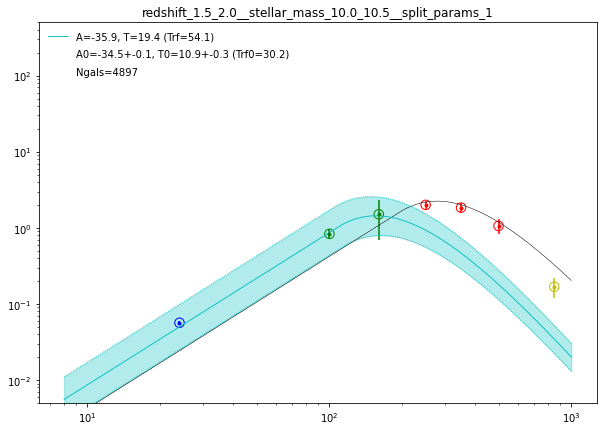

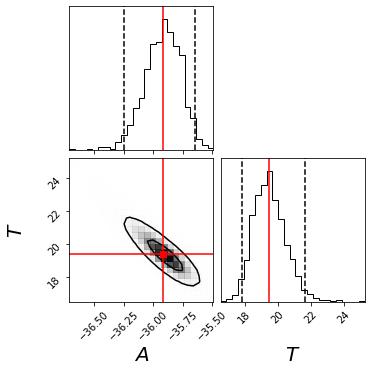

In [32]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in, errors=('16', '84'))

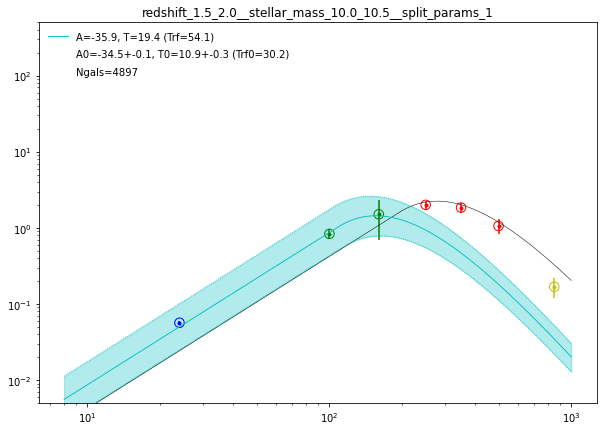

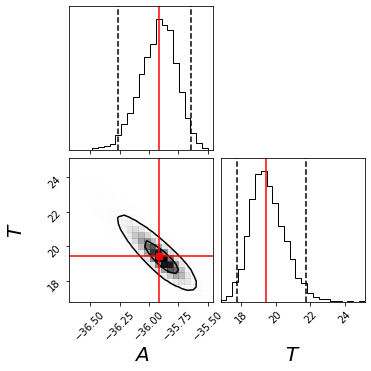

In [43]:
plot_test_mcmc_seds(simstack_object, sed_results_dict, test_flat_samples, test_theta0, id_label_in, errors=('16', '84'))

## z = 1-1.5